In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [ ]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [ ]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

    return df

In [ ]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [ ]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Offspeed Model

In [ ]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [ ]:
train_data = training_features.loc[training_features['pfx_x'].notnull()].drop(['pfx_x'], axis=1).copy()
train_label = training_features['pfx_x'].loc[training_features['pfx_x'].notnull()].copy()
testing_data = testing_features.loc[testing_features['spin_axis'].notnull()].drop(['pfx_x'], axis=1).copy()
testing_label = testing_features['pfx_x'].loc[testing_features['spin_axis'].notnull()].copy()

In [ ]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
y_pred = model.predict(dtest)

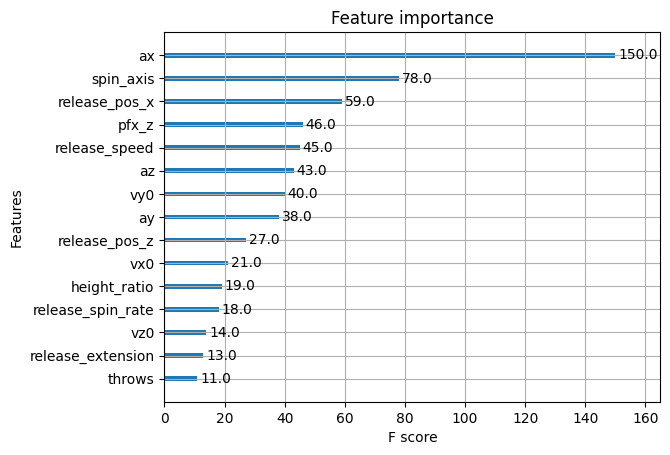

In [ ]:
xgb.plot_importance(model)
plt.show()

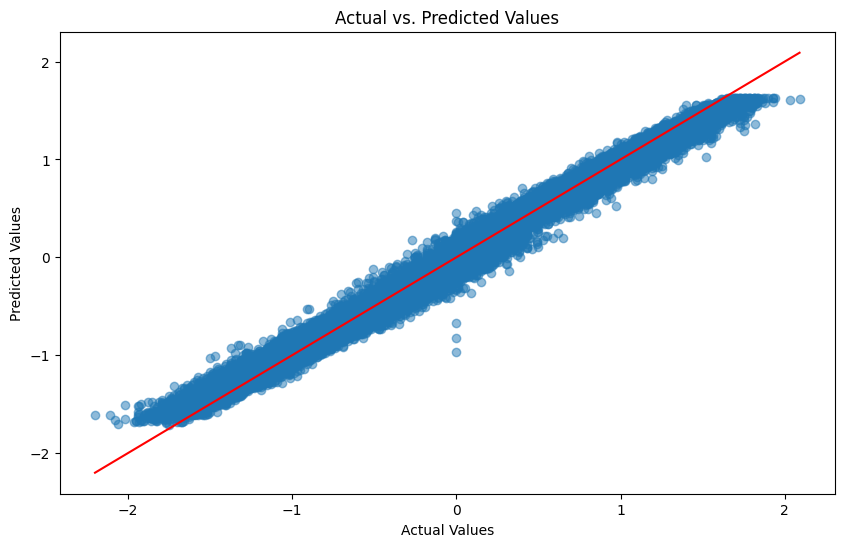

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 18:36:15,020] A new study created in memory with name: no-name-b3800554-c978-4400-a901-948f8c314418
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54818
[1]	eval-rmse:0.35500
[2]	eval-rmse:0.25617
[3]	eval-rmse:0.19376
[4]	eval-rmse:0.16360
[5]	eval-rmse:0.12148
[6]	eval-rmse:0.11113
[7]	eval-rmse:0.09067
[8]	eval-rmse:0.08781
[9]	eval-rmse:0.07599
[10]	eval-rmse:0.06769
[11]	eval-rmse:0.06574
[12]	eval-rmse:0.06051
[13]	eval-rmse:0.05749
[14]	eval-rmse:0.05366
[15]	eval-rmse:0.05083
[16]	eval-rmse:0.04970
[17]	eval-rmse:0.04886
[18]	eval-rmse:0.04645
[19]	eval-rmse:0.04594
[20]	eval-rmse:0.04567
[21]	eval-rmse:0.04334
[22]	eval-rmse:0.04296
[23]	eval-rmse:0.04276
[24]	eval-rmse:0.04246
[25]	eval-rmse:0.04026
[26]	eval-rmse:0.03988
[27]	eval-rmse:0.03957
[28]	eval-rmse:0.03916
[29]	eval-rmse:0.03903
[30]	eval-rmse:0.03896
[31]	eval-rmse:0.03766
[32]	eval-rmse:0.03719
[33]	eval-rmse:0.03707
[34]	eval-rmse:0.03686
[35]	eval-rmse:0.03529
[36]	eval-rmse:0.03515
[37]	eval-rmse:0.03482
[38]	eval-rmse:0.03385
[39]	eval-rmse:0.03332
[40]	eval-rmse:0.03327
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.0321

[I 2023-11-14 18:36:18,749] Trial 0 finished with value: 0.023753153160214424 and parameters: {'max_depth': 5, 'eta': 0.35932353756561897, 'subsample': 0.4673720693123703, 'colsample_bytree': 0.5004356295196482, 'min_child_weight': 2}. Best is trial 0 with value: 0.023753153160214424.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65147
[1]	eval-rmse:0.49933
[2]	eval-rmse:0.40126
[3]	eval-rmse:0.32439
[4]	eval-rmse:0.27272
[5]	eval-rmse:0.21318
[6]	eval-rmse:0.18289
[7]	eval-rmse:0.14623
[8]	eval-rmse:0.13122
[9]	eval-rmse:0.10835
[10]	eval-rmse:0.09016
[11]	eval-rmse:0.08569
[12]	eval-rmse:0.07394
[13]	eval-rmse:0.06553
[14]	eval-rmse:0.05852
[15]	eval-rmse:0.05373
[16]	eval-rmse:0.05248
[17]	eval-rmse:0.05176
[18]	eval-rmse:0.04799
[19]	eval-rmse:0.04744
[20]	eval-rmse:0.04704
[21]	eval-rmse:0.04452
[22]	eval-rmse:0.04420
[23]	eval-rmse:0.04409
[24]	eval-rmse:0.04390
[25]	eval-rmse:0.04114
[26]	eval-rmse:0.04090
[27]	eval-rmse:0.04075
[28]	eval-rmse:0.04060
[29]	eval-rmse:0.04050
[30]	eval-rmse:0.04037
[31]	eval-rmse:0.03851
[32]	eval-rmse:0.03826
[33]	eval-rmse:0.03816
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03642
[36]	eval-rmse:0.03622
[37]	eval-rmse:0.03608
[38]	eval-rmse:0.03488
[39]	eval-rmse:0.03389
[40]	eval-rmse:0.03367
[41]	eval-rmse:0.03358
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.0327

[I 2023-11-14 18:36:24,524] Trial 1 finished with value: 0.025704020634293556 and parameters: {'max_depth': 8, 'eta': 0.23532440395185616, 'subsample': 0.4434761916018998, 'colsample_bytree': 0.5336254404781792, 'min_child_weight': 5}. Best is trial 0 with value: 0.023753153160214424.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62636
[1]	eval-rmse:0.46190
[2]	eval-rmse:0.36125
[3]	eval-rmse:0.28563
[4]	eval-rmse:0.23825
[5]	eval-rmse:0.18162
[6]	eval-rmse:0.15639
[7]	eval-rmse:0.12359
[8]	eval-rmse:0.11300
[9]	eval-rmse:0.09420
[10]	eval-rmse:0.07976
[11]	eval-rmse:0.07684
[12]	eval-rmse:0.06745
[13]	eval-rmse:0.06131
[14]	eval-rmse:0.05725
[15]	eval-rmse:0.05379
[16]	eval-rmse:0.05203
[17]	eval-rmse:0.05136
[18]	eval-rmse:0.04745
[19]	eval-rmse:0.04677
[20]	eval-rmse:0.04619
[21]	eval-rmse:0.04354
[22]	eval-rmse:0.04330
[23]	eval-rmse:0.04315
[24]	eval-rmse:0.04290
[25]	eval-rmse:0.04022
[26]	eval-rmse:0.03992
[27]	eval-rmse:0.03968
[28]	eval-rmse:0.03946
[29]	eval-rmse:0.03929
[30]	eval-rmse:0.03903
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03677
[33]	eval-rmse:0.03663
[34]	eval-rmse:0.03649
[35]	eval-rmse:0.03504
[36]	eval-rmse:0.03483
[37]	eval-rmse:0.03469
[38]	eval-rmse:0.03354
[39]	eval-rmse:0.03270
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03246
[42]	eval-rmse:0.03240
[43]	eval-rmse:0.0318

[I 2023-11-14 18:36:29,516] Trial 2 finished with value: 0.02457665279507637 and parameters: {'max_depth': 7, 'eta': 0.26508432626342193, 'subsample': 0.5554797607631545, 'colsample_bytree': 0.46542711765889, 'min_child_weight': 5}. Best is trial 0 with value: 0.023753153160214424.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53317
[1]	eval-rmse:0.33523
[2]	eval-rmse:0.24427
[3]	eval-rmse:0.17763
[4]	eval-rmse:0.14513
[5]	eval-rmse:0.10137
[6]	eval-rmse:0.09049
[7]	eval-rmse:0.07078
[8]	eval-rmse:0.06810
[9]	eval-rmse:0.05936
[10]	eval-rmse:0.05562
[11]	eval-rmse:0.05480
[12]	eval-rmse:0.05108
[13]	eval-rmse:0.04915
[14]	eval-rmse:0.04825
[15]	eval-rmse:0.04722
[16]	eval-rmse:0.04325
[17]	eval-rmse:0.04306
[18]	eval-rmse:0.04070
[19]	eval-rmse:0.03969
[20]	eval-rmse:0.03908
[21]	eval-rmse:0.03681
[22]	eval-rmse:0.03670
[23]	eval-rmse:0.03667
[24]	eval-rmse:0.03617
[25]	eval-rmse:0.03428
[26]	eval-rmse:0.03407
[27]	eval-rmse:0.03389
[28]	eval-rmse:0.03369
[29]	eval-rmse:0.03358
[30]	eval-rmse:0.03339
[31]	eval-rmse:0.03332
[32]	eval-rmse:0.03318
[33]	eval-rmse:0.03307
[34]	eval-rmse:0.03299
[35]	eval-rmse:0.03177
[36]	eval-rmse:0.03164
[37]	eval-rmse:0.03152
[38]	eval-rmse:0.03073
[39]	eval-rmse:0.03034
[40]	eval-rmse:0.03025
[41]	eval-rmse:0.03015
[42]	eval-rmse:0.03009
[43]	eval-rmse:0.0296

[I 2023-11-14 18:36:35,106] Trial 3 finished with value: 0.026358598843216896 and parameters: {'max_depth': 8, 'eta': 0.37528525035498755, 'subsample': 0.5122358192120027, 'colsample_bytree': 0.4042232969704741, 'min_child_weight': 2}. Best is trial 0 with value: 0.023753153160214424.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63665
[1]	eval-rmse:0.47703
[2]	eval-rmse:0.37712
[3]	eval-rmse:0.30049
[4]	eval-rmse:0.25096
[5]	eval-rmse:0.19292
[6]	eval-rmse:0.16525
[7]	eval-rmse:0.13093
[8]	eval-rmse:0.11848
[9]	eval-rmse:0.09831
[10]	eval-rmse:0.08245
[11]	eval-rmse:0.07899
[12]	eval-rmse:0.06845
[13]	eval-rmse:0.06167
[14]	eval-rmse:0.05726
[15]	eval-rmse:0.05324
[16]	eval-rmse:0.05161
[17]	eval-rmse:0.05102
[18]	eval-rmse:0.04707
[19]	eval-rmse:0.04646
[20]	eval-rmse:0.04589
[21]	eval-rmse:0.04335
[22]	eval-rmse:0.04312
[23]	eval-rmse:0.04302
[24]	eval-rmse:0.04277
[25]	eval-rmse:0.04016
[26]	eval-rmse:0.03990
[27]	eval-rmse:0.03975
[28]	eval-rmse:0.03957
[29]	eval-rmse:0.03942
[30]	eval-rmse:0.03919
[31]	eval-rmse:0.03741
[32]	eval-rmse:0.03709
[33]	eval-rmse:0.03697
[34]	eval-rmse:0.03682
[35]	eval-rmse:0.03535
[36]	eval-rmse:0.03514
[37]	eval-rmse:0.03497
[38]	eval-rmse:0.03388
[39]	eval-rmse:0.03300
[40]	eval-rmse:0.03287
[41]	eval-rmse:0.03272
[42]	eval-rmse:0.03268
[43]	eval-rmse:0.0320

[I 2023-11-14 18:36:40,920] Trial 4 finished with value: 0.025793343782424927 and parameters: {'max_depth': 8, 'eta': 0.252761687017426, 'subsample': 0.5828143288716533, 'colsample_bytree': 0.4417513402942341, 'min_child_weight': 4}. Best is trial 0 with value: 0.023753153160214424.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61449
[1]	eval-rmse:0.44474
[2]	eval-rmse:0.34340
[3]	eval-rmse:0.26995
[4]	eval-rmse:0.22506
[5]	eval-rmse:0.17072
[6]	eval-rmse:0.13197
[7]	eval-rmse:0.10531
[8]	eval-rmse:0.09576
[9]	eval-rmse:0.08052
[10]	eval-rmse:0.06885
[11]	eval-rmse:0.06605
[12]	eval-rmse:0.05940
[13]	eval-rmse:0.05468
[14]	eval-rmse:0.05067
[15]	eval-rmse:0.04725
[16]	eval-rmse:0.04605
[17]	eval-rmse:0.04526
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04261
[20]	eval-rmse:0.04222
[21]	eval-rmse:0.04029
[22]	eval-rmse:0.03999
[23]	eval-rmse:0.03968
[24]	eval-rmse:0.03811
[25]	eval-rmse:0.03691
[26]	eval-rmse:0.03650
[27]	eval-rmse:0.03622
[28]	eval-rmse:0.03601
[29]	eval-rmse:0.03595
[30]	eval-rmse:0.03589
[31]	eval-rmse:0.03454
[32]	eval-rmse:0.03414
[33]	eval-rmse:0.03401
[34]	eval-rmse:0.03390
[35]	eval-rmse:0.03269
[36]	eval-rmse:0.03237
[37]	eval-rmse:0.03217
[38]	eval-rmse:0.03121
[39]	eval-rmse:0.03050
[40]	eval-rmse:0.03038
[41]	eval-rmse:0.03022
[42]	eval-rmse:0.03011
[43]	eval-rmse:0.0294

[I 2023-11-14 18:36:45,184] Trial 5 finished with value: 0.02271128073334694 and parameters: {'max_depth': 6, 'eta': 0.2794037794616532, 'subsample': 0.5986722562016218, 'colsample_bytree': 0.5960749291610471, 'min_child_weight': 1}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52297
[1]	eval-rmse:0.32285
[2]	eval-rmse:0.22312
[3]	eval-rmse:0.16263
[4]	eval-rmse:0.13521
[5]	eval-rmse:0.09605
[6]	eval-rmse:0.08715
[7]	eval-rmse:0.06940
[8]	eval-rmse:0.06730
[9]	eval-rmse:0.05881
[10]	eval-rmse:0.05136
[11]	eval-rmse:0.04948
[12]	eval-rmse:0.04534
[13]	eval-rmse:0.04310
[14]	eval-rmse:0.04150
[15]	eval-rmse:0.03977
[16]	eval-rmse:0.03820
[17]	eval-rmse:0.03776
[18]	eval-rmse:0.03561
[19]	eval-rmse:0.03515
[20]	eval-rmse:0.03460
[21]	eval-rmse:0.03331
[22]	eval-rmse:0.03315
[23]	eval-rmse:0.03314
[24]	eval-rmse:0.03300
[25]	eval-rmse:0.03168
[26]	eval-rmse:0.03150
[27]	eval-rmse:0.03133
[28]	eval-rmse:0.03121
[29]	eval-rmse:0.03116
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.02990
[32]	eval-rmse:0.02952
[33]	eval-rmse:0.02941
[34]	eval-rmse:0.02930
[35]	eval-rmse:0.02869
[36]	eval-rmse:0.02862
[37]	eval-rmse:0.02849
[38]	eval-rmse:0.02804
[39]	eval-rmse:0.02779
[40]	eval-rmse:0.02767
[41]	eval-rmse:0.02760
[42]	eval-rmse:0.02751
[43]	eval-rmse:0.0272

[I 2023-11-14 18:36:49,821] Trial 6 finished with value: 0.02402329072356224 and parameters: {'max_depth': 7, 'eta': 0.38774503890372924, 'subsample': 0.4925460994691282, 'colsample_bytree': 0.439197047581318, 'min_child_weight': 5}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61153
[1]	eval-rmse:0.44026
[2]	eval-rmse:0.33723
[3]	eval-rmse:0.26240
[4]	eval-rmse:0.21660
[5]	eval-rmse:0.16215
[6]	eval-rmse:0.13938
[7]	eval-rmse:0.10906
[8]	eval-rmse:0.10008
[9]	eval-rmse:0.08291
[10]	eval-rmse:0.06942
[11]	eval-rmse:0.06723
[12]	eval-rmse:0.05887
[13]	eval-rmse:0.05339
[14]	eval-rmse:0.04880
[15]	eval-rmse:0.04579
[16]	eval-rmse:0.04474
[17]	eval-rmse:0.04417
[18]	eval-rmse:0.04178
[19]	eval-rmse:0.04132
[20]	eval-rmse:0.04092
[21]	eval-rmse:0.03920
[22]	eval-rmse:0.03891
[23]	eval-rmse:0.03877
[24]	eval-rmse:0.03863
[25]	eval-rmse:0.03669
[26]	eval-rmse:0.03651
[27]	eval-rmse:0.03636
[28]	eval-rmse:0.03616
[29]	eval-rmse:0.03610
[30]	eval-rmse:0.03590
[31]	eval-rmse:0.03461
[32]	eval-rmse:0.03436
[33]	eval-rmse:0.03428
[34]	eval-rmse:0.03421
[35]	eval-rmse:0.03314
[36]	eval-rmse:0.03295
[37]	eval-rmse:0.03275
[38]	eval-rmse:0.03194
[39]	eval-rmse:0.03139
[40]	eval-rmse:0.03130
[41]	eval-rmse:0.03121
[42]	eval-rmse:0.03112
[43]	eval-rmse:0.0306

[I 2023-11-14 18:36:55,386] Trial 7 finished with value: 0.026390034705400467 and parameters: {'max_depth': 8, 'eta': 0.2826287755222162, 'subsample': 0.43656236826401706, 'colsample_bytree': 0.5198797132777878, 'min_child_weight': 4}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65873
[1]	eval-rmse:0.51054
[2]	eval-rmse:0.41385
[3]	eval-rmse:0.33717
[4]	eval-rmse:0.28466
[5]	eval-rmse:0.22445
[6]	eval-rmse:0.19276
[7]	eval-rmse:0.15497
[8]	eval-rmse:0.13863
[9]	eval-rmse:0.11476
[10]	eval-rmse:0.09560
[11]	eval-rmse:0.09040
[12]	eval-rmse:0.07785
[13]	eval-rmse:0.06885
[14]	eval-rmse:0.06120
[15]	eval-rmse:0.05579
[16]	eval-rmse:0.05440
[17]	eval-rmse:0.05354
[18]	eval-rmse:0.04960
[19]	eval-rmse:0.04903
[20]	eval-rmse:0.04860
[21]	eval-rmse:0.04567
[22]	eval-rmse:0.04539
[23]	eval-rmse:0.04529
[24]	eval-rmse:0.04506
[25]	eval-rmse:0.04211
[26]	eval-rmse:0.04186
[27]	eval-rmse:0.04170
[28]	eval-rmse:0.04149
[29]	eval-rmse:0.04138
[30]	eval-rmse:0.04126
[31]	eval-rmse:0.03930
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03892
[34]	eval-rmse:0.03882
[35]	eval-rmse:0.03702
[36]	eval-rmse:0.03692
[37]	eval-rmse:0.03675
[38]	eval-rmse:0.03546
[39]	eval-rmse:0.03449
[40]	eval-rmse:0.03424
[41]	eval-rmse:0.03413
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0332

[I 2023-11-14 18:37:01,282] Trial 8 finished with value: 0.02530495822429657 and parameters: {'max_depth': 8, 'eta': 0.22665993875943244, 'subsample': 0.5594689478511143, 'colsample_bytree': 0.5368001940256698, 'min_child_weight': 1}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60444
[1]	eval-rmse:0.43027
[2]	eval-rmse:0.32757
[3]	eval-rmse:0.25402
[4]	eval-rmse:0.21007
[5]	eval-rmse:0.15665
[6]	eval-rmse:0.13562
[7]	eval-rmse:0.10654
[8]	eval-rmse:0.09860
[9]	eval-rmse:0.08187
[10]	eval-rmse:0.06897
[11]	eval-rmse:0.06696
[12]	eval-rmse:0.05909
[13]	eval-rmse:0.05392
[14]	eval-rmse:0.04939
[15]	eval-rmse:0.04624
[16]	eval-rmse:0.04519
[17]	eval-rmse:0.04455
[18]	eval-rmse:0.04209
[19]	eval-rmse:0.04162
[20]	eval-rmse:0.04122
[21]	eval-rmse:0.03937
[22]	eval-rmse:0.03900
[23]	eval-rmse:0.03886
[24]	eval-rmse:0.03868
[25]	eval-rmse:0.03659
[26]	eval-rmse:0.03628
[27]	eval-rmse:0.03613
[28]	eval-rmse:0.03583
[29]	eval-rmse:0.03577
[30]	eval-rmse:0.03557
[31]	eval-rmse:0.03410
[32]	eval-rmse:0.03382
[33]	eval-rmse:0.03369
[34]	eval-rmse:0.03359
[35]	eval-rmse:0.03238
[36]	eval-rmse:0.03229
[37]	eval-rmse:0.03210
[38]	eval-rmse:0.03122
[39]	eval-rmse:0.03053
[40]	eval-rmse:0.03036
[41]	eval-rmse:0.03025
[42]	eval-rmse:0.03020
[43]	eval-rmse:0.0296

[I 2023-11-14 18:37:06,277] Trial 9 finished with value: 0.024450758472085 and parameters: {'max_depth': 7, 'eta': 0.2910774264118064, 'subsample': 0.46161191787988654, 'colsample_bytree': 0.5234540871974757, 'min_child_weight': 4}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57837
[1]	eval-rmse:0.39541
[2]	eval-rmse:0.29592
[3]	eval-rmse:0.22935
[4]	eval-rmse:0.19420
[5]	eval-rmse:0.14933
[6]	eval-rmse:0.12145
[7]	eval-rmse:0.10161
[8]	eval-rmse:0.09662
[9]	eval-rmse:0.08709
[10]	eval-rmse:0.07878
[11]	eval-rmse:0.07664
[12]	eval-rmse:0.07107
[13]	eval-rmse:0.06570
[14]	eval-rmse:0.06243
[15]	eval-rmse:0.06027
[16]	eval-rmse:0.05930
[17]	eval-rmse:0.05854
[18]	eval-rmse:0.05594
[19]	eval-rmse:0.05540
[20]	eval-rmse:0.05478
[21]	eval-rmse:0.05308
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05179
[24]	eval-rmse:0.05051
[25]	eval-rmse:0.04821
[26]	eval-rmse:0.04721
[27]	eval-rmse:0.04686
[28]	eval-rmse:0.04672
[29]	eval-rmse:0.04629
[30]	eval-rmse:0.04616
[31]	eval-rmse:0.04494
[32]	eval-rmse:0.04441
[33]	eval-rmse:0.04405
[34]	eval-rmse:0.04398
[35]	eval-rmse:0.04203
[36]	eval-rmse:0.04186
[37]	eval-rmse:0.04147
[38]	eval-rmse:0.04000
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03863
[41]	eval-rmse:0.03852
[42]	eval-rmse:0.03839
[43]	eval-rmse:0.0378

[I 2023-11-14 18:37:09,739] Trial 10 finished with value: 0.025612052530050278 and parameters: {'max_depth': 4, 'eta': 0.32492517716278946, 'subsample': 0.4058980887509285, 'colsample_bytree': 0.5951163986979516, 'min_child_weight': 1}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56925
[1]	eval-rmse:0.38243
[2]	eval-rmse:0.28219
[3]	eval-rmse:0.21600
[4]	eval-rmse:0.18166
[5]	eval-rmse:0.13581
[6]	eval-rmse:0.10537
[7]	eval-rmse:0.08759
[8]	eval-rmse:0.08232
[9]	eval-rmse:0.07309
[10]	eval-rmse:0.06488
[11]	eval-rmse:0.06279
[12]	eval-rmse:0.05764
[13]	eval-rmse:0.05434
[14]	eval-rmse:0.05172
[15]	eval-rmse:0.04950
[16]	eval-rmse:0.04878
[17]	eval-rmse:0.04764
[18]	eval-rmse:0.04524
[19]	eval-rmse:0.04473
[20]	eval-rmse:0.04448
[21]	eval-rmse:0.04240
[22]	eval-rmse:0.04220
[23]	eval-rmse:0.04135
[24]	eval-rmse:0.04027
[25]	eval-rmse:0.03840
[26]	eval-rmse:0.03782
[27]	eval-rmse:0.03759
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03674
[30]	eval-rmse:0.03657
[31]	eval-rmse:0.03512
[32]	eval-rmse:0.03471
[33]	eval-rmse:0.03460
[34]	eval-rmse:0.03451
[35]	eval-rmse:0.03346
[36]	eval-rmse:0.03324
[37]	eval-rmse:0.03306
[38]	eval-rmse:0.03210
[39]	eval-rmse:0.03118
[40]	eval-rmse:0.03086
[41]	eval-rmse:0.03077
[42]	eval-rmse:0.03070
[43]	eval-rmse:0.0299

[I 2023-11-14 18:37:13,429] Trial 11 finished with value: 0.02279037982225418 and parameters: {'max_depth': 5, 'eta': 0.3341963923320667, 'subsample': 0.5910715828096076, 'colsample_bytree': 0.5876909176823156, 'min_child_weight': 2}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57450
[1]	eval-rmse:0.38943
[2]	eval-rmse:0.28889
[3]	eval-rmse:0.22185
[4]	eval-rmse:0.18628
[5]	eval-rmse:0.13933
[6]	eval-rmse:0.10935
[7]	eval-rmse:0.09203
[8]	eval-rmse:0.08661
[9]	eval-rmse:0.07454
[10]	eval-rmse:0.06654
[11]	eval-rmse:0.06428
[12]	eval-rmse:0.05967
[13]	eval-rmse:0.05529
[14]	eval-rmse:0.05151
[15]	eval-rmse:0.04939
[16]	eval-rmse:0.04809
[17]	eval-rmse:0.04708
[18]	eval-rmse:0.04523
[19]	eval-rmse:0.04498
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04280
[22]	eval-rmse:0.04227
[23]	eval-rmse:0.04188
[24]	eval-rmse:0.04043
[25]	eval-rmse:0.03848
[26]	eval-rmse:0.03798
[27]	eval-rmse:0.03774
[28]	eval-rmse:0.03756
[29]	eval-rmse:0.03718
[30]	eval-rmse:0.03701
[31]	eval-rmse:0.03583
[32]	eval-rmse:0.03538
[33]	eval-rmse:0.03517
[34]	eval-rmse:0.03500
[35]	eval-rmse:0.03382
[36]	eval-rmse:0.03367
[37]	eval-rmse:0.03351
[38]	eval-rmse:0.03250
[39]	eval-rmse:0.03188
[40]	eval-rmse:0.03171
[41]	eval-rmse:0.03156
[42]	eval-rmse:0.03149
[43]	eval-rmse:0.0309

[I 2023-11-14 18:37:17,264] Trial 12 finished with value: 0.022963887080550194 and parameters: {'max_depth': 5, 'eta': 0.32791560391973007, 'subsample': 0.5967464388827264, 'colsample_bytree': 0.5966505424645608, 'min_child_weight': 2}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67371
[1]	eval-rmse:0.53408
[2]	eval-rmse:0.44267
[3]	eval-rmse:0.36899
[4]	eval-rmse:0.31731
[5]	eval-rmse:0.25690
[6]	eval-rmse:0.20909
[7]	eval-rmse:0.17213
[8]	eval-rmse:0.15453
[9]	eval-rmse:0.13074
[10]	eval-rmse:0.11235
[11]	eval-rmse:0.10564
[12]	eval-rmse:0.09395
[13]	eval-rmse:0.08472
[14]	eval-rmse:0.07719
[15]	eval-rmse:0.07140
[16]	eval-rmse:0.06935
[17]	eval-rmse:0.06788
[18]	eval-rmse:0.06408
[19]	eval-rmse:0.06311
[20]	eval-rmse:0.06239
[21]	eval-rmse:0.05929
[22]	eval-rmse:0.05864
[23]	eval-rmse:0.05803
[24]	eval-rmse:0.05565
[25]	eval-rmse:0.05243
[26]	eval-rmse:0.05199
[27]	eval-rmse:0.05169
[28]	eval-rmse:0.05140
[29]	eval-rmse:0.05122
[30]	eval-rmse:0.05108
[31]	eval-rmse:0.04863
[32]	eval-rmse:0.04842
[33]	eval-rmse:0.04828
[34]	eval-rmse:0.04812
[35]	eval-rmse:0.04584
[36]	eval-rmse:0.04565
[37]	eval-rmse:0.04551
[38]	eval-rmse:0.04366
[39]	eval-rmse:0.04189
[40]	eval-rmse:0.04152
[41]	eval-rmse:0.04136
[42]	eval-rmse:0.04126
[43]	eval-rmse:0.0402

[I 2023-11-14 18:37:21,085] Trial 13 finished with value: 0.023868661373853683 and parameters: {'max_depth': 5, 'eta': 0.2098748740486916, 'subsample': 0.5950921234316413, 'colsample_bytree': 0.56927640547018, 'min_child_weight': 1}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58044
[1]	eval-rmse:0.39723
[2]	eval-rmse:0.29458
[3]	eval-rmse:0.22498
[4]	eval-rmse:0.18668
[5]	eval-rmse:0.13792
[6]	eval-rmse:0.10556
[7]	eval-rmse:0.08523
[8]	eval-rmse:0.07889
[9]	eval-rmse:0.06747
[10]	eval-rmse:0.05942
[11]	eval-rmse:0.05731
[12]	eval-rmse:0.05211
[13]	eval-rmse:0.04865
[14]	eval-rmse:0.04499
[15]	eval-rmse:0.04298
[16]	eval-rmse:0.04193
[17]	eval-rmse:0.04119
[18]	eval-rmse:0.03913
[19]	eval-rmse:0.03873
[20]	eval-rmse:0.03836
[21]	eval-rmse:0.03687
[22]	eval-rmse:0.03669
[23]	eval-rmse:0.03633
[24]	eval-rmse:0.03531
[25]	eval-rmse:0.03419
[26]	eval-rmse:0.03381
[27]	eval-rmse:0.03366
[28]	eval-rmse:0.03351
[29]	eval-rmse:0.03350
[30]	eval-rmse:0.03342
[31]	eval-rmse:0.03235
[32]	eval-rmse:0.03196
[33]	eval-rmse:0.03176
[34]	eval-rmse:0.03166
[35]	eval-rmse:0.03067
[36]	eval-rmse:0.03062
[37]	eval-rmse:0.03038
[38]	eval-rmse:0.02964
[39]	eval-rmse:0.02909
[40]	eval-rmse:0.02885
[41]	eval-rmse:0.02873
[42]	eval-rmse:0.02864
[43]	eval-rmse:0.0281

[I 2023-11-14 18:37:25,363] Trial 14 finished with value: 0.0230806153267622 and parameters: {'max_depth': 6, 'eta': 0.3198812801635312, 'subsample': 0.5504606151586302, 'colsample_bytree': 0.5675735040450749, 'min_child_weight': 3}. Best is trial 5 with value: 0.02271128073334694.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59415
[1]	eval-rmse:0.41601
[2]	eval-rmse:0.31355
[3]	eval-rmse:0.24218
[4]	eval-rmse:0.20113
[5]	eval-rmse:0.15005
[6]	eval-rmse:0.11493
[7]	eval-rmse:0.09202
[8]	eval-rmse:0.08437
[9]	eval-rmse:0.07158
[10]	eval-rmse:0.06205
[11]	eval-rmse:0.05978
[12]	eval-rmse:0.05424
[13]	eval-rmse:0.05055
[14]	eval-rmse:0.04724
[15]	eval-rmse:0.04520
[16]	eval-rmse:0.04404
[17]	eval-rmse:0.04330
[18]	eval-rmse:0.04094
[19]	eval-rmse:0.04041
[20]	eval-rmse:0.04019
[21]	eval-rmse:0.03848
[22]	eval-rmse:0.03836
[23]	eval-rmse:0.03768
[24]	eval-rmse:0.03622
[25]	eval-rmse:0.03459
[26]	eval-rmse:0.03414
[27]	eval-rmse:0.03386
[28]	eval-rmse:0.03375
[29]	eval-rmse:0.03363
[30]	eval-rmse:0.03342
[31]	eval-rmse:0.03238
[32]	eval-rmse:0.03209
[33]	eval-rmse:0.03187
[34]	eval-rmse:0.03173
[35]	eval-rmse:0.03077
[36]	eval-rmse:0.03060
[37]	eval-rmse:0.03049
[38]	eval-rmse:0.02974
[39]	eval-rmse:0.02920
[40]	eval-rmse:0.02901
[41]	eval-rmse:0.02889
[42]	eval-rmse:0.02881
[43]	eval-rmse:0.0282

[I 2023-11-14 18:37:29,589] Trial 15 finished with value: 0.022599006071686745 and parameters: {'max_depth': 6, 'eta': 0.3036493451937385, 'subsample': 0.5705479125775835, 'colsample_bytree': 0.5662434792607549, 'min_child_weight': 2}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59507
[1]	eval-rmse:0.41727
[2]	eval-rmse:0.31507
[3]	eval-rmse:0.24345
[4]	eval-rmse:0.20210
[5]	eval-rmse:0.15083
[6]	eval-rmse:0.13195
[7]	eval-rmse:0.10431
[8]	eval-rmse:0.09773
[9]	eval-rmse:0.08223
[10]	eval-rmse:0.07096
[11]	eval-rmse:0.06896
[12]	eval-rmse:0.06126
[13]	eval-rmse:0.05676
[14]	eval-rmse:0.05273
[15]	eval-rmse:0.04968
[16]	eval-rmse:0.04847
[17]	eval-rmse:0.04767
[18]	eval-rmse:0.04561
[19]	eval-rmse:0.04502
[20]	eval-rmse:0.04461
[21]	eval-rmse:0.04239
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04195
[24]	eval-rmse:0.04173
[25]	eval-rmse:0.03973
[26]	eval-rmse:0.03935
[27]	eval-rmse:0.03910
[28]	eval-rmse:0.03890
[29]	eval-rmse:0.03886
[30]	eval-rmse:0.03848
[31]	eval-rmse:0.03666
[32]	eval-rmse:0.03627
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03400
[38]	eval-rmse:0.03290
[39]	eval-rmse:0.03206
[40]	eval-rmse:0.03192
[41]	eval-rmse:0.03167
[42]	eval-rmse:0.03152
[43]	eval-rmse:0.0309

[I 2023-11-14 18:37:33,947] Trial 16 finished with value: 0.02370508201420307 and parameters: {'max_depth': 6, 'eta': 0.30251983924145986, 'subsample': 0.5328732482800776, 'colsample_bytree': 0.5603381156537445, 'min_child_weight': 3}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63437
[1]	eval-rmse:0.47374
[2]	eval-rmse:0.37453
[3]	eval-rmse:0.29962
[4]	eval-rmse:0.25143
[5]	eval-rmse:0.19425
[6]	eval-rmse:0.16845
[7]	eval-rmse:0.13466
[8]	eval-rmse:0.12320
[9]	eval-rmse:0.10300
[10]	eval-rmse:0.08763
[11]	eval-rmse:0.08440
[12]	eval-rmse:0.07453
[13]	eval-rmse:0.06825
[14]	eval-rmse:0.06221
[15]	eval-rmse:0.05776
[16]	eval-rmse:0.05657
[17]	eval-rmse:0.05584
[18]	eval-rmse:0.05243
[19]	eval-rmse:0.05185
[20]	eval-rmse:0.05139
[21]	eval-rmse:0.04846
[22]	eval-rmse:0.04833
[23]	eval-rmse:0.04815
[24]	eval-rmse:0.04793
[25]	eval-rmse:0.04556
[26]	eval-rmse:0.04509
[27]	eval-rmse:0.04485
[28]	eval-rmse:0.04442
[29]	eval-rmse:0.04432
[30]	eval-rmse:0.04409
[31]	eval-rmse:0.04184
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04147
[34]	eval-rmse:0.04127
[35]	eval-rmse:0.03946
[36]	eval-rmse:0.03922
[37]	eval-rmse:0.03897
[38]	eval-rmse:0.03757
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03612
[41]	eval-rmse:0.03594
[42]	eval-rmse:0.03581
[43]	eval-rmse:0.0345

[I 2023-11-14 18:37:38,383] Trial 17 finished with value: 0.02377971261739731 and parameters: {'max_depth': 6, 'eta': 0.25590467130313727, 'subsample': 0.5746728536389678, 'colsample_bytree': 0.5535840953653769, 'min_child_weight': 1}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62091
[1]	eval-rmse:0.45480
[2]	eval-rmse:0.35657
[3]	eval-rmse:0.28440
[4]	eval-rmse:0.24088
[5]	eval-rmse:0.18799
[6]	eval-rmse:0.15152
[7]	eval-rmse:0.12600
[8]	eval-rmse:0.11737
[9]	eval-rmse:0.10442
[10]	eval-rmse:0.09490
[11]	eval-rmse:0.09285
[12]	eval-rmse:0.08397
[13]	eval-rmse:0.07963
[14]	eval-rmse:0.07338
[15]	eval-rmse:0.06819
[16]	eval-rmse:0.06699
[17]	eval-rmse:0.06616
[18]	eval-rmse:0.06360
[19]	eval-rmse:0.06266
[20]	eval-rmse:0.06229
[21]	eval-rmse:0.06000
[22]	eval-rmse:0.05983
[23]	eval-rmse:0.05907
[24]	eval-rmse:0.05748
[25]	eval-rmse:0.05438
[26]	eval-rmse:0.05378
[27]	eval-rmse:0.05341
[28]	eval-rmse:0.05322
[29]	eval-rmse:0.05285
[30]	eval-rmse:0.05263
[31]	eval-rmse:0.05088
[32]	eval-rmse:0.05047
[33]	eval-rmse:0.05023
[34]	eval-rmse:0.05015
[35]	eval-rmse:0.04816
[36]	eval-rmse:0.04784
[37]	eval-rmse:0.04771
[38]	eval-rmse:0.04625
[39]	eval-rmse:0.04544
[40]	eval-rmse:0.04502
[41]	eval-rmse:0.04479
[42]	eval-rmse:0.04458
[43]	eval-rmse:0.0431

[I 2023-11-14 18:37:41,703] Trial 18 finished with value: 0.02576899155974388 and parameters: {'max_depth': 4, 'eta': 0.2739796502510216, 'subsample': 0.5731041431504467, 'colsample_bytree': 0.5787040595662097, 'min_child_weight': 2}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59903
[1]	eval-rmse:0.42263
[2]	eval-rmse:0.31961
[3]	eval-rmse:0.24682
[4]	eval-rmse:0.20404
[5]	eval-rmse:0.15146
[6]	eval-rmse:0.11493
[7]	eval-rmse:0.09108
[8]	eval-rmse:0.08268
[9]	eval-rmse:0.06914
[10]	eval-rmse:0.05895
[11]	eval-rmse:0.05681
[12]	eval-rmse:0.05127
[13]	eval-rmse:0.04743
[14]	eval-rmse:0.04381
[15]	eval-rmse:0.04138
[16]	eval-rmse:0.04042
[17]	eval-rmse:0.03981
[18]	eval-rmse:0.03791
[19]	eval-rmse:0.03754
[20]	eval-rmse:0.03721
[21]	eval-rmse:0.03577
[22]	eval-rmse:0.03556
[23]	eval-rmse:0.03515
[24]	eval-rmse:0.03418
[25]	eval-rmse:0.03290
[26]	eval-rmse:0.03262
[27]	eval-rmse:0.03246
[28]	eval-rmse:0.03227
[29]	eval-rmse:0.03223
[30]	eval-rmse:0.03207
[31]	eval-rmse:0.03108
[32]	eval-rmse:0.03086
[33]	eval-rmse:0.03077
[34]	eval-rmse:0.03064
[35]	eval-rmse:0.02991
[36]	eval-rmse:0.02972
[37]	eval-rmse:0.02958
[38]	eval-rmse:0.02900
[39]	eval-rmse:0.02852
[40]	eval-rmse:0.02829
[41]	eval-rmse:0.02813
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0276

[I 2023-11-14 18:37:46,750] Trial 19 finished with value: 0.02371841110289097 and parameters: {'max_depth': 7, 'eta': 0.29748940936465196, 'subsample': 0.5387066763866899, 'colsample_bytree': 0.5991320161982732, 'min_child_weight': 1}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59140
[1]	eval-rmse:0.41222
[2]	eval-rmse:0.30997
[3]	eval-rmse:0.23884
[4]	eval-rmse:0.19820
[5]	eval-rmse:0.14750
[6]	eval-rmse:0.12921
[7]	eval-rmse:0.10256
[8]	eval-rmse:0.09650
[9]	eval-rmse:0.08135
[10]	eval-rmse:0.07019
[11]	eval-rmse:0.06822
[12]	eval-rmse:0.06118
[13]	eval-rmse:0.05618
[14]	eval-rmse:0.05221
[15]	eval-rmse:0.04947
[16]	eval-rmse:0.04839
[17]	eval-rmse:0.04775
[18]	eval-rmse:0.04462
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04381
[21]	eval-rmse:0.04227
[22]	eval-rmse:0.04197
[23]	eval-rmse:0.04175
[24]	eval-rmse:0.04153
[25]	eval-rmse:0.03924
[26]	eval-rmse:0.03886
[27]	eval-rmse:0.03865
[28]	eval-rmse:0.03829
[29]	eval-rmse:0.03822
[30]	eval-rmse:0.03798
[31]	eval-rmse:0.03631
[32]	eval-rmse:0.03597
[33]	eval-rmse:0.03591
[34]	eval-rmse:0.03574
[35]	eval-rmse:0.03453
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03314
[39]	eval-rmse:0.03228
[40]	eval-rmse:0.03224
[41]	eval-rmse:0.03209
[42]	eval-rmse:0.03202
[43]	eval-rmse:0.0312

[I 2023-11-14 18:37:51,144] Trial 20 finished with value: 0.023497510701417923 and parameters: {'max_depth': 6, 'eta': 0.3068942982303015, 'subsample': 0.572296398948284, 'colsample_bytree': 0.550614523101219, 'min_child_weight': 3}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57090
[1]	eval-rmse:0.38463
[2]	eval-rmse:0.28423
[3]	eval-rmse:0.21776
[4]	eval-rmse:0.18286
[5]	eval-rmse:0.13681
[6]	eval-rmse:0.10615
[7]	eval-rmse:0.08833
[8]	eval-rmse:0.08299
[9]	eval-rmse:0.07373
[10]	eval-rmse:0.06548
[11]	eval-rmse:0.06323
[12]	eval-rmse:0.05804
[13]	eval-rmse:0.05527
[14]	eval-rmse:0.05217
[15]	eval-rmse:0.04872
[16]	eval-rmse:0.04733
[17]	eval-rmse:0.04688
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04478
[20]	eval-rmse:0.04416
[21]	eval-rmse:0.04260
[22]	eval-rmse:0.04212
[23]	eval-rmse:0.04128
[24]	eval-rmse:0.03968
[25]	eval-rmse:0.03826
[26]	eval-rmse:0.03777
[27]	eval-rmse:0.03752
[28]	eval-rmse:0.03739
[29]	eval-rmse:0.03727
[30]	eval-rmse:0.03695
[31]	eval-rmse:0.03558
[32]	eval-rmse:0.03523
[33]	eval-rmse:0.03499
[34]	eval-rmse:0.03484
[35]	eval-rmse:0.03363
[36]	eval-rmse:0.03354
[37]	eval-rmse:0.03331
[38]	eval-rmse:0.03221
[39]	eval-rmse:0.03131
[40]	eval-rmse:0.03113
[41]	eval-rmse:0.03100
[42]	eval-rmse:0.03092
[43]	eval-rmse:0.0302

[I 2023-11-14 18:37:54,890] Trial 21 finished with value: 0.023128079250454903 and parameters: {'max_depth': 5, 'eta': 0.33221975284376326, 'subsample': 0.5994191161614518, 'colsample_bytree': 0.5799712243305183, 'min_child_weight': 2}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61460
[1]	eval-rmse:0.44502
[2]	eval-rmse:0.34518
[3]	eval-rmse:0.27280
[4]	eval-rmse:0.22926
[5]	eval-rmse:0.17541
[6]	eval-rmse:0.13729
[7]	eval-rmse:0.11128
[8]	eval-rmse:0.10219
[9]	eval-rmse:0.08864
[10]	eval-rmse:0.07776
[11]	eval-rmse:0.07499
[12]	eval-rmse:0.06800
[13]	eval-rmse:0.06363
[14]	eval-rmse:0.05874
[15]	eval-rmse:0.05600
[16]	eval-rmse:0.05481
[17]	eval-rmse:0.05393
[18]	eval-rmse:0.05160
[19]	eval-rmse:0.05130
[20]	eval-rmse:0.05098
[21]	eval-rmse:0.04788
[22]	eval-rmse:0.04748
[23]	eval-rmse:0.04712
[24]	eval-rmse:0.04536
[25]	eval-rmse:0.04339
[26]	eval-rmse:0.04270
[27]	eval-rmse:0.04250
[28]	eval-rmse:0.04221
[29]	eval-rmse:0.04199
[30]	eval-rmse:0.04162
[31]	eval-rmse:0.03982
[32]	eval-rmse:0.03951
[33]	eval-rmse:0.03947
[34]	eval-rmse:0.03933
[35]	eval-rmse:0.03788
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03729
[38]	eval-rmse:0.03613
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03506
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03477
[43]	eval-rmse:0.0338

[I 2023-11-14 18:37:58,658] Trial 22 finished with value: 0.023501675575971603 and parameters: {'max_depth': 5, 'eta': 0.28019555169425847, 'subsample': 0.5810430111346261, 'colsample_bytree': 0.5795115551437359, 'min_child_weight': 2}. Best is trial 15 with value: 0.022599006071686745.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55818
[1]	eval-rmse:0.36759
[2]	eval-rmse:0.26556
[3]	eval-rmse:0.19940
[4]	eval-rmse:0.16570
[5]	eval-rmse:0.12075
[6]	eval-rmse:0.09247
[7]	eval-rmse:0.07538
[8]	eval-rmse:0.07050
[9]	eval-rmse:0.06084
[10]	eval-rmse:0.05354
[11]	eval-rmse:0.05178
[12]	eval-rmse:0.04757
[13]	eval-rmse:0.04476
[14]	eval-rmse:0.04225
[15]	eval-rmse:0.04049
[16]	eval-rmse:0.03972
[17]	eval-rmse:0.03878
[18]	eval-rmse:0.03719
[19]	eval-rmse:0.03687
[20]	eval-rmse:0.03641
[21]	eval-rmse:0.03514
[22]	eval-rmse:0.03497
[23]	eval-rmse:0.03473
[24]	eval-rmse:0.03383
[25]	eval-rmse:0.03251
[26]	eval-rmse:0.03204
[27]	eval-rmse:0.03175
[28]	eval-rmse:0.03131
[29]	eval-rmse:0.03125
[30]	eval-rmse:0.03118
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02996
[33]	eval-rmse:0.02984
[34]	eval-rmse:0.02968
[35]	eval-rmse:0.02884
[36]	eval-rmse:0.02866
[37]	eval-rmse:0.02865
[38]	eval-rmse:0.02807
[39]	eval-rmse:0.02756
[40]	eval-rmse:0.02750
[41]	eval-rmse:0.02742
[42]	eval-rmse:0.02732
[43]	eval-rmse:0.0270

[I 2023-11-14 18:38:02,942] Trial 23 finished with value: 0.021993363276124 and parameters: {'max_depth': 6, 'eta': 0.3461983129578214, 'subsample': 0.5976829954696251, 'colsample_bytree': 0.5831038165907716, 'min_child_weight': 2}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54808
[1]	eval-rmse:0.35451
[2]	eval-rmse:0.25337
[3]	eval-rmse:0.18924
[4]	eval-rmse:0.15753
[5]	eval-rmse:0.11451
[6]	eval-rmse:0.10300
[7]	eval-rmse:0.08233
[8]	eval-rmse:0.07906
[9]	eval-rmse:0.06792
[10]	eval-rmse:0.05925
[11]	eval-rmse:0.05760
[12]	eval-rmse:0.05212
[13]	eval-rmse:0.04894
[14]	eval-rmse:0.04575
[15]	eval-rmse:0.04339
[16]	eval-rmse:0.04233
[17]	eval-rmse:0.04157
[18]	eval-rmse:0.03963
[19]	eval-rmse:0.03921
[20]	eval-rmse:0.03885
[21]	eval-rmse:0.03732
[22]	eval-rmse:0.03715
[23]	eval-rmse:0.03699
[24]	eval-rmse:0.03690
[25]	eval-rmse:0.03515
[26]	eval-rmse:0.03494
[27]	eval-rmse:0.03463
[28]	eval-rmse:0.03417
[29]	eval-rmse:0.03407
[30]	eval-rmse:0.03381
[31]	eval-rmse:0.03255
[32]	eval-rmse:0.03241
[33]	eval-rmse:0.03231
[34]	eval-rmse:0.03210
[35]	eval-rmse:0.03115
[36]	eval-rmse:0.03091
[37]	eval-rmse:0.03067
[38]	eval-rmse:0.02988
[39]	eval-rmse:0.02928
[40]	eval-rmse:0.02911
[41]	eval-rmse:0.02895
[42]	eval-rmse:0.02881
[43]	eval-rmse:0.0284

[I 2023-11-14 18:38:07,307] Trial 24 finished with value: 0.023313753306865692 and parameters: {'max_depth': 6, 'eta': 0.35830716047935307, 'subsample': 0.5623621642430219, 'colsample_bytree': 0.5516187452635952, 'min_child_weight': 1}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58799
[1]	eval-rmse:0.40736
[2]	eval-rmse:0.30400
[3]	eval-rmse:0.23257
[4]	eval-rmse:0.19191
[5]	eval-rmse:0.14122
[6]	eval-rmse:0.10689
[7]	eval-rmse:0.08459
[8]	eval-rmse:0.07738
[9]	eval-rmse:0.06526
[10]	eval-rmse:0.05596
[11]	eval-rmse:0.05408
[12]	eval-rmse:0.04865
[13]	eval-rmse:0.04519
[14]	eval-rmse:0.04203
[15]	eval-rmse:0.03982
[16]	eval-rmse:0.03882
[17]	eval-rmse:0.03821
[18]	eval-rmse:0.03656
[19]	eval-rmse:0.03619
[20]	eval-rmse:0.03590
[21]	eval-rmse:0.03462
[22]	eval-rmse:0.03442
[23]	eval-rmse:0.03414
[24]	eval-rmse:0.03335
[25]	eval-rmse:0.03230
[26]	eval-rmse:0.03210
[27]	eval-rmse:0.03192
[28]	eval-rmse:0.03178
[29]	eval-rmse:0.03157
[30]	eval-rmse:0.03147
[31]	eval-rmse:0.03061
[32]	eval-rmse:0.03033
[33]	eval-rmse:0.03014
[34]	eval-rmse:0.03001
[35]	eval-rmse:0.02928
[36]	eval-rmse:0.02916
[37]	eval-rmse:0.02900
[38]	eval-rmse:0.02847
[39]	eval-rmse:0.02809
[40]	eval-rmse:0.02790
[41]	eval-rmse:0.02781
[42]	eval-rmse:0.02778
[43]	eval-rmse:0.0274

[I 2023-11-14 18:38:12,249] Trial 25 finished with value: 0.023422706872224808 and parameters: {'max_depth': 7, 'eta': 0.31049011742994553, 'subsample': 0.5815081110705224, 'colsample_bytree': 0.5726082354049993, 'min_child_weight': 3}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60126
[1]	eval-rmse:0.42602
[2]	eval-rmse:0.32384
[3]	eval-rmse:0.25161
[4]	eval-rmse:0.20905
[5]	eval-rmse:0.15670
[6]	eval-rmse:0.12030
[7]	eval-rmse:0.09623
[8]	eval-rmse:0.08807
[9]	eval-rmse:0.07485
[10]	eval-rmse:0.06469
[11]	eval-rmse:0.06240
[12]	eval-rmse:0.05641
[13]	eval-rmse:0.05269
[14]	eval-rmse:0.04876
[15]	eval-rmse:0.04606
[16]	eval-rmse:0.04491
[17]	eval-rmse:0.04415
[18]	eval-rmse:0.04198
[19]	eval-rmse:0.04139
[20]	eval-rmse:0.04105
[21]	eval-rmse:0.03904
[22]	eval-rmse:0.03865
[23]	eval-rmse:0.03834
[24]	eval-rmse:0.03688
[25]	eval-rmse:0.03520
[26]	eval-rmse:0.03476
[27]	eval-rmse:0.03452
[28]	eval-rmse:0.03443
[29]	eval-rmse:0.03438
[30]	eval-rmse:0.03410
[31]	eval-rmse:0.03304
[32]	eval-rmse:0.03271
[33]	eval-rmse:0.03250
[34]	eval-rmse:0.03234
[35]	eval-rmse:0.03112
[36]	eval-rmse:0.03081
[37]	eval-rmse:0.03071
[38]	eval-rmse:0.02987
[39]	eval-rmse:0.02926
[40]	eval-rmse:0.02908
[41]	eval-rmse:0.02894
[42]	eval-rmse:0.02888
[43]	eval-rmse:0.0282

[I 2023-11-14 18:38:16,620] Trial 26 finished with value: 0.022390594705939293 and parameters: {'max_depth': 6, 'eta': 0.2950778369478779, 'subsample': 0.5992008687779977, 'colsample_bytree': 0.597816577363787, 'min_child_weight': 2}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56085
[1]	eval-rmse:0.37104
[2]	eval-rmse:0.26892
[3]	eval-rmse:0.20250
[4]	eval-rmse:0.16830
[5]	eval-rmse:0.12292
[6]	eval-rmse:0.09408
[7]	eval-rmse:0.07667
[8]	eval-rmse:0.07152
[9]	eval-rmse:0.06237
[10]	eval-rmse:0.05503
[11]	eval-rmse:0.05307
[12]	eval-rmse:0.04823
[13]	eval-rmse:0.04540
[14]	eval-rmse:0.04241
[15]	eval-rmse:0.04090
[16]	eval-rmse:0.04002
[17]	eval-rmse:0.03930
[18]	eval-rmse:0.03768
[19]	eval-rmse:0.03715
[20]	eval-rmse:0.03686
[21]	eval-rmse:0.03541
[22]	eval-rmse:0.03527
[23]	eval-rmse:0.03481
[24]	eval-rmse:0.03369
[25]	eval-rmse:0.03243
[26]	eval-rmse:0.03195
[27]	eval-rmse:0.03171
[28]	eval-rmse:0.03158
[29]	eval-rmse:0.03133
[30]	eval-rmse:0.03129
[31]	eval-rmse:0.03043
[32]	eval-rmse:0.03010
[33]	eval-rmse:0.03003
[34]	eval-rmse:0.02993
[35]	eval-rmse:0.02901
[36]	eval-rmse:0.02888
[37]	eval-rmse:0.02872
[38]	eval-rmse:0.02817
[39]	eval-rmse:0.02756
[40]	eval-rmse:0.02752
[41]	eval-rmse:0.02741
[42]	eval-rmse:0.02731
[43]	eval-rmse:0.0270

[I 2023-11-14 18:38:21,225] Trial 27 finished with value: 0.022613681852817535 and parameters: {'max_depth': 6, 'eta': 0.34317531886632247, 'subsample': 0.5705593061799669, 'colsample_bytree': 0.5845530927127485, 'min_child_weight': 2}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58850
[1]	eval-rmse:0.40822
[2]	eval-rmse:0.30564
[3]	eval-rmse:0.23491
[4]	eval-rmse:0.19500
[5]	eval-rmse:0.14492
[6]	eval-rmse:0.11072
[7]	eval-rmse:0.08857
[8]	eval-rmse:0.08152
[9]	eval-rmse:0.06918
[10]	eval-rmse:0.06016
[11]	eval-rmse:0.05809
[12]	eval-rmse:0.05282
[13]	eval-rmse:0.04920
[14]	eval-rmse:0.04564
[15]	eval-rmse:0.04328
[16]	eval-rmse:0.04213
[17]	eval-rmse:0.04132
[18]	eval-rmse:0.03952
[19]	eval-rmse:0.03906
[20]	eval-rmse:0.03877
[21]	eval-rmse:0.03732
[22]	eval-rmse:0.03712
[23]	eval-rmse:0.03658
[24]	eval-rmse:0.03557
[25]	eval-rmse:0.03408
[26]	eval-rmse:0.03374
[27]	eval-rmse:0.03353
[28]	eval-rmse:0.03334
[29]	eval-rmse:0.03332
[30]	eval-rmse:0.03321
[31]	eval-rmse:0.03213
[32]	eval-rmse:0.03173
[33]	eval-rmse:0.03162
[34]	eval-rmse:0.03146
[35]	eval-rmse:0.03056
[36]	eval-rmse:0.03036
[37]	eval-rmse:0.03022
[38]	eval-rmse:0.02941
[39]	eval-rmse:0.02883
[40]	eval-rmse:0.02868
[41]	eval-rmse:0.02858
[42]	eval-rmse:0.02849
[43]	eval-rmse:0.0279

[I 2023-11-14 18:38:25,873] Trial 28 finished with value: 0.022453399375081062 and parameters: {'max_depth': 6, 'eta': 0.31034344267734126, 'subsample': 0.547186512701558, 'colsample_bytree': 0.5635754986282541, 'min_child_weight': 3}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55524
[1]	eval-rmse:0.36352
[2]	eval-rmse:0.26085
[3]	eval-rmse:0.19419
[4]	eval-rmse:0.16015
[5]	eval-rmse:0.11520
[6]	eval-rmse:0.10243
[7]	eval-rmse:0.08065
[8]	eval-rmse:0.07704
[9]	eval-rmse:0.06538
[10]	eval-rmse:0.05626
[11]	eval-rmse:0.05470
[12]	eval-rmse:0.04926
[13]	eval-rmse:0.04626
[14]	eval-rmse:0.04279
[15]	eval-rmse:0.04067
[16]	eval-rmse:0.03972
[17]	eval-rmse:0.03905
[18]	eval-rmse:0.03730
[19]	eval-rmse:0.03690
[20]	eval-rmse:0.03654
[21]	eval-rmse:0.03533
[22]	eval-rmse:0.03502
[23]	eval-rmse:0.03487
[24]	eval-rmse:0.03477
[25]	eval-rmse:0.03331
[26]	eval-rmse:0.03312
[27]	eval-rmse:0.03289
[28]	eval-rmse:0.03258
[29]	eval-rmse:0.03252
[30]	eval-rmse:0.03244
[31]	eval-rmse:0.03145
[32]	eval-rmse:0.03120
[33]	eval-rmse:0.03110
[34]	eval-rmse:0.03095
[35]	eval-rmse:0.03012
[36]	eval-rmse:0.02993
[37]	eval-rmse:0.02977
[38]	eval-rmse:0.02916
[39]	eval-rmse:0.02874
[40]	eval-rmse:0.02868
[41]	eval-rmse:0.02860
[42]	eval-rmse:0.02853
[43]	eval-rmse:0.0282

[I 2023-11-14 18:38:30,803] Trial 29 finished with value: 0.024490609765052795 and parameters: {'max_depth': 7, 'eta': 0.3493247775796557, 'subsample': 0.5317356526832091, 'colsample_bytree': 0.5433339841148784, 'min_child_weight': 3}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54813
[1]	eval-rmse:0.35605
[2]	eval-rmse:0.25848
[3]	eval-rmse:0.19736
[4]	eval-rmse:0.16835
[5]	eval-rmse:0.12706
[6]	eval-rmse:0.11749
[7]	eval-rmse:0.09867
[8]	eval-rmse:0.09558
[9]	eval-rmse:0.08492
[10]	eval-rmse:0.07696
[11]	eval-rmse:0.07508
[12]	eval-rmse:0.06991
[13]	eval-rmse:0.06688
[14]	eval-rmse:0.06432
[15]	eval-rmse:0.06185
[16]	eval-rmse:0.06071
[17]	eval-rmse:0.05972
[18]	eval-rmse:0.05769
[19]	eval-rmse:0.05714
[20]	eval-rmse:0.05678
[21]	eval-rmse:0.05469
[22]	eval-rmse:0.05422
[23]	eval-rmse:0.05397
[24]	eval-rmse:0.05363
[25]	eval-rmse:0.05066
[26]	eval-rmse:0.05016
[27]	eval-rmse:0.04993
[28]	eval-rmse:0.04933
[29]	eval-rmse:0.04908
[30]	eval-rmse:0.04884
[31]	eval-rmse:0.04654
[32]	eval-rmse:0.04616
[33]	eval-rmse:0.04591
[34]	eval-rmse:0.04577
[35]	eval-rmse:0.04367
[36]	eval-rmse:0.04344
[37]	eval-rmse:0.04329
[38]	eval-rmse:0.04220
[39]	eval-rmse:0.04155
[40]	eval-rmse:0.04115
[41]	eval-rmse:0.04106
[42]	eval-rmse:0.04077
[43]	eval-rmse:0.0392

[I 2023-11-14 18:38:34,229] Trial 30 finished with value: 0.025553537532687187 and parameters: {'max_depth': 4, 'eta': 0.3612156325229951, 'subsample': 0.5462555566286271, 'colsample_bytree': 0.5600235578564404, 'min_child_weight': 4}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58963
[1]	eval-rmse:0.40981
[2]	eval-rmse:0.30725
[3]	eval-rmse:0.23639
[4]	eval-rmse:0.19620
[5]	eval-rmse:0.14594
[6]	eval-rmse:0.11152
[7]	eval-rmse:0.08959
[8]	eval-rmse:0.08247
[9]	eval-rmse:0.07070
[10]	eval-rmse:0.06144
[11]	eval-rmse:0.05939
[12]	eval-rmse:0.05358
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04692
[15]	eval-rmse:0.04454
[16]	eval-rmse:0.04344
[17]	eval-rmse:0.04298
[18]	eval-rmse:0.04124
[19]	eval-rmse:0.04103
[20]	eval-rmse:0.04049
[21]	eval-rmse:0.03873
[22]	eval-rmse:0.03830
[23]	eval-rmse:0.03774
[24]	eval-rmse:0.03627
[25]	eval-rmse:0.03475
[26]	eval-rmse:0.03426
[27]	eval-rmse:0.03405
[28]	eval-rmse:0.03400
[29]	eval-rmse:0.03382
[30]	eval-rmse:0.03373
[31]	eval-rmse:0.03258
[32]	eval-rmse:0.03226
[33]	eval-rmse:0.03213
[34]	eval-rmse:0.03198
[35]	eval-rmse:0.03102
[36]	eval-rmse:0.03070
[37]	eval-rmse:0.03060
[38]	eval-rmse:0.02985
[39]	eval-rmse:0.02933
[40]	eval-rmse:0.02910
[41]	eval-rmse:0.02902
[42]	eval-rmse:0.02892
[43]	eval-rmse:0.0283

[I 2023-11-14 18:38:38,473] Trial 31 finished with value: 0.022996094077825546 and parameters: {'max_depth': 6, 'eta': 0.3089534154641026, 'subsample': 0.5831723381336071, 'colsample_bytree': 0.5691822276332669, 'min_child_weight': 2}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59927
[1]	eval-rmse:0.42315
[2]	eval-rmse:0.32086
[3]	eval-rmse:0.24886
[4]	eval-rmse:0.20683
[5]	eval-rmse:0.15474
[6]	eval-rmse:0.11870
[7]	eval-rmse:0.09519
[8]	eval-rmse:0.08715
[9]	eval-rmse:0.07400
[10]	eval-rmse:0.06399
[11]	eval-rmse:0.06176
[12]	eval-rmse:0.05596
[13]	eval-rmse:0.05219
[14]	eval-rmse:0.04842
[15]	eval-rmse:0.04582
[16]	eval-rmse:0.04465
[17]	eval-rmse:0.04414
[18]	eval-rmse:0.04201
[19]	eval-rmse:0.04150
[20]	eval-rmse:0.04107
[21]	eval-rmse:0.03940
[22]	eval-rmse:0.03931
[23]	eval-rmse:0.03896
[24]	eval-rmse:0.03749
[25]	eval-rmse:0.03593
[26]	eval-rmse:0.03526
[27]	eval-rmse:0.03500
[28]	eval-rmse:0.03465
[29]	eval-rmse:0.03464
[30]	eval-rmse:0.03453
[31]	eval-rmse:0.03314
[32]	eval-rmse:0.03278
[33]	eval-rmse:0.03266
[34]	eval-rmse:0.03254
[35]	eval-rmse:0.03138
[36]	eval-rmse:0.03120
[37]	eval-rmse:0.03098
[38]	eval-rmse:0.03006
[39]	eval-rmse:0.02949
[40]	eval-rmse:0.02935
[41]	eval-rmse:0.02926
[42]	eval-rmse:0.02906
[43]	eval-rmse:0.0286

[I 2023-11-14 18:38:42,854] Trial 32 finished with value: 0.022579388692975044 and parameters: {'max_depth': 6, 'eta': 0.2975531250173842, 'subsample': 0.563492853139714, 'colsample_bytree': 0.5845150343818022, 'min_child_weight': 3}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58330
[1]	eval-rmse:0.40136
[2]	eval-rmse:0.30063
[3]	eval-rmse:0.23219
[4]	eval-rmse:0.19480
[5]	eval-rmse:0.14618
[6]	eval-rmse:0.11455
[7]	eval-rmse:0.09398
[8]	eval-rmse:0.08803
[9]	eval-rmse:0.07760
[10]	eval-rmse:0.06890
[11]	eval-rmse:0.06666
[12]	eval-rmse:0.06075
[13]	eval-rmse:0.05778
[14]	eval-rmse:0.05335
[15]	eval-rmse:0.05022
[16]	eval-rmse:0.04875
[17]	eval-rmse:0.04796
[18]	eval-rmse:0.04608
[19]	eval-rmse:0.04576
[20]	eval-rmse:0.04506
[21]	eval-rmse:0.04330
[22]	eval-rmse:0.04307
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04060
[25]	eval-rmse:0.03958
[26]	eval-rmse:0.03891
[27]	eval-rmse:0.03870
[28]	eval-rmse:0.03841
[29]	eval-rmse:0.03830
[30]	eval-rmse:0.03818
[31]	eval-rmse:0.03678
[32]	eval-rmse:0.03628
[33]	eval-rmse:0.03614
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03474
[36]	eval-rmse:0.03446
[37]	eval-rmse:0.03415
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03224
[40]	eval-rmse:0.03209
[41]	eval-rmse:0.03193
[42]	eval-rmse:0.03169
[43]	eval-rmse:0.0312

[I 2023-11-14 18:38:46,614] Trial 33 finished with value: 0.022716857492923737 and parameters: {'max_depth': 5, 'eta': 0.3174678254862925, 'subsample': 0.5598344217362742, 'colsample_bytree': 0.5871453330993032, 'min_child_weight': 3}. Best is trial 23 with value: 0.021993363276124.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60446
[1]	eval-rmse:0.43051
[2]	eval-rmse:0.32841
[3]	eval-rmse:0.25591
[4]	eval-rmse:0.21275
[5]	eval-rmse:0.16010
[6]	eval-rmse:0.12328
[7]	eval-rmse:0.09871
[8]	eval-rmse:0.09033
[9]	eval-rmse:0.07641
[10]	eval-rmse:0.06580
[11]	eval-rmse:0.06343
[12]	eval-rmse:0.05722
[13]	eval-rmse:0.05297
[14]	eval-rmse:0.04935
[15]	eval-rmse:0.04619
[16]	eval-rmse:0.04505
[17]	eval-rmse:0.04422
[18]	eval-rmse:0.04202
[19]	eval-rmse:0.04152
[20]	eval-rmse:0.04116
[21]	eval-rmse:0.03930
[22]	eval-rmse:0.03916
[23]	eval-rmse:0.03854
[24]	eval-rmse:0.03700
[25]	eval-rmse:0.03564
[26]	eval-rmse:0.03526
[27]	eval-rmse:0.03495
[28]	eval-rmse:0.03478
[29]	eval-rmse:0.03466
[30]	eval-rmse:0.03436
[31]	eval-rmse:0.03303
[32]	eval-rmse:0.03267
[33]	eval-rmse:0.03254
[34]	eval-rmse:0.03239
[35]	eval-rmse:0.03119
[36]	eval-rmse:0.03107
[37]	eval-rmse:0.03081
[38]	eval-rmse:0.03000
[39]	eval-rmse:0.02932
[40]	eval-rmse:0.02922
[41]	eval-rmse:0.02905
[42]	eval-rmse:0.02893
[43]	eval-rmse:0.0283

[I 2023-11-14 18:38:51,218] Trial 34 finished with value: 0.021912947297096252 and parameters: {'max_depth': 6, 'eta': 0.29133857676242464, 'subsample': 0.5863449708399433, 'colsample_bytree': 0.5815983930901253, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60615
[1]	eval-rmse:0.43272
[2]	eval-rmse:0.33003
[3]	eval-rmse:0.25654
[4]	eval-rmse:0.21233
[5]	eval-rmse:0.15852
[6]	eval-rmse:0.12064
[7]	eval-rmse:0.09536
[8]	eval-rmse:0.08608
[9]	eval-rmse:0.07177
[10]	eval-rmse:0.06085
[11]	eval-rmse:0.05857
[12]	eval-rmse:0.05214
[13]	eval-rmse:0.04802
[14]	eval-rmse:0.04416
[15]	eval-rmse:0.04194
[16]	eval-rmse:0.04095
[17]	eval-rmse:0.04022
[18]	eval-rmse:0.03807
[19]	eval-rmse:0.03770
[20]	eval-rmse:0.03738
[21]	eval-rmse:0.03579
[22]	eval-rmse:0.03557
[23]	eval-rmse:0.03524
[24]	eval-rmse:0.03426
[25]	eval-rmse:0.03304
[26]	eval-rmse:0.03272
[27]	eval-rmse:0.03257
[28]	eval-rmse:0.03219
[29]	eval-rmse:0.03200
[30]	eval-rmse:0.03179
[31]	eval-rmse:0.03082
[32]	eval-rmse:0.03058
[33]	eval-rmse:0.03047
[34]	eval-rmse:0.03037
[35]	eval-rmse:0.02952
[36]	eval-rmse:0.02935
[37]	eval-rmse:0.02928
[38]	eval-rmse:0.02863
[39]	eval-rmse:0.02812
[40]	eval-rmse:0.02801
[41]	eval-rmse:0.02792
[42]	eval-rmse:0.02783
[43]	eval-rmse:0.0274

[I 2023-11-14 18:38:56,199] Trial 35 finished with value: 0.023328790441155434 and parameters: {'max_depth': 7, 'eta': 0.2889771755005764, 'subsample': 0.5855915039678045, 'colsample_bytree': 0.5988789499170007, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62193
[1]	eval-rmse:0.45551
[2]	eval-rmse:0.35493
[3]	eval-rmse:0.28070
[4]	eval-rmse:0.23449
[5]	eval-rmse:0.17913
[6]	eval-rmse:0.15565
[7]	eval-rmse:0.12397
[8]	eval-rmse:0.11445
[9]	eval-rmse:0.09556
[10]	eval-rmse:0.08182
[11]	eval-rmse:0.07930
[12]	eval-rmse:0.07088
[13]	eval-rmse:0.06444
[14]	eval-rmse:0.05934
[15]	eval-rmse:0.05501
[16]	eval-rmse:0.05381
[17]	eval-rmse:0.05305
[18]	eval-rmse:0.05021
[19]	eval-rmse:0.04961
[20]	eval-rmse:0.04928
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04642
[23]	eval-rmse:0.04628
[24]	eval-rmse:0.04605
[25]	eval-rmse:0.04370
[26]	eval-rmse:0.04335
[27]	eval-rmse:0.04311
[28]	eval-rmse:0.04285
[29]	eval-rmse:0.04275
[30]	eval-rmse:0.04242
[31]	eval-rmse:0.04049
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.04003
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03820
[36]	eval-rmse:0.03799
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03602
[39]	eval-rmse:0.03493
[40]	eval-rmse:0.03460
[41]	eval-rmse:0.03448
[42]	eval-rmse:0.03439
[43]	eval-rmse:0.0334

[I 2023-11-14 18:39:00,526] Trial 36 finished with value: 0.02421705424785614 and parameters: {'max_depth': 6, 'eta': 0.2706177535292944, 'subsample': 0.590019607757753, 'colsample_bytree': 0.5420319540337073, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58410
[1]	eval-rmse:0.40199
[2]	eval-rmse:0.29865
[3]	eval-rmse:0.22760
[4]	eval-rmse:0.18751
[5]	eval-rmse:0.13741
[6]	eval-rmse:0.12010
[7]	eval-rmse:0.09430
[8]	eval-rmse:0.08852
[9]	eval-rmse:0.07426
[10]	eval-rmse:0.06316
[11]	eval-rmse:0.06153
[12]	eval-rmse:0.05458
[13]	eval-rmse:0.05009
[14]	eval-rmse:0.04605
[15]	eval-rmse:0.04356
[16]	eval-rmse:0.04254
[17]	eval-rmse:0.04188
[18]	eval-rmse:0.03975
[19]	eval-rmse:0.03931
[20]	eval-rmse:0.03891
[21]	eval-rmse:0.03742
[22]	eval-rmse:0.03728
[23]	eval-rmse:0.03712
[24]	eval-rmse:0.03697
[25]	eval-rmse:0.03517
[26]	eval-rmse:0.03499
[27]	eval-rmse:0.03473
[28]	eval-rmse:0.03434
[29]	eval-rmse:0.03431
[30]	eval-rmse:0.03412
[31]	eval-rmse:0.03290
[32]	eval-rmse:0.03258
[33]	eval-rmse:0.03249
[34]	eval-rmse:0.03242
[35]	eval-rmse:0.03139
[36]	eval-rmse:0.03118
[37]	eval-rmse:0.03101
[38]	eval-rmse:0.03022
[39]	eval-rmse:0.02974
[40]	eval-rmse:0.02959
[41]	eval-rmse:0.02951
[42]	eval-rmse:0.02945
[43]	eval-rmse:0.0290

[I 2023-11-14 18:39:05,466] Trial 37 finished with value: 0.02434569224715233 and parameters: {'max_depth': 7, 'eta': 0.3150461420293651, 'subsample': 0.5995261949129744, 'colsample_bytree': 0.5080897429899986, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63179
[1]	eval-rmse:0.47001
[2]	eval-rmse:0.37034
[3]	eval-rmse:0.29567
[4]	eval-rmse:0.24789
[5]	eval-rmse:0.19117
[6]	eval-rmse:0.16578
[7]	eval-rmse:0.13222
[8]	eval-rmse:0.12139
[9]	eval-rmse:0.10159
[10]	eval-rmse:0.08668
[11]	eval-rmse:0.08370
[12]	eval-rmse:0.07478
[13]	eval-rmse:0.06800
[14]	eval-rmse:0.06225
[15]	eval-rmse:0.05780
[16]	eval-rmse:0.05656
[17]	eval-rmse:0.05581
[18]	eval-rmse:0.05278
[19]	eval-rmse:0.05215
[20]	eval-rmse:0.05168
[21]	eval-rmse:0.04849
[22]	eval-rmse:0.04825
[23]	eval-rmse:0.04804
[24]	eval-rmse:0.04777
[25]	eval-rmse:0.04534
[26]	eval-rmse:0.04492
[27]	eval-rmse:0.04469
[28]	eval-rmse:0.04439
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04401
[31]	eval-rmse:0.04148
[32]	eval-rmse:0.04125
[33]	eval-rmse:0.04112
[34]	eval-rmse:0.04102
[35]	eval-rmse:0.03918
[36]	eval-rmse:0.03893
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03714
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03562
[41]	eval-rmse:0.03546
[42]	eval-rmse:0.03537
[43]	eval-rmse:0.0341

[I 2023-11-14 18:39:10,028] Trial 38 finished with value: 0.02419741451740265 and parameters: {'max_depth': 6, 'eta': 0.2589838635697555, 'subsample': 0.5195195093501106, 'colsample_bytree': 0.5582597564529151, 'min_child_weight': 5}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60658
[1]	eval-rmse:0.43365
[2]	eval-rmse:0.33340
[3]	eval-rmse:0.26181
[4]	eval-rmse:0.21992
[5]	eval-rmse:0.16745
[6]	eval-rmse:0.13215
[7]	eval-rmse:0.10680
[8]	eval-rmse:0.09868
[9]	eval-rmse:0.08466
[10]	eval-rmse:0.07483
[11]	eval-rmse:0.07223
[12]	eval-rmse:0.06528
[13]	eval-rmse:0.06135
[14]	eval-rmse:0.05745
[15]	eval-rmse:0.05371
[16]	eval-rmse:0.05255
[17]	eval-rmse:0.05158
[18]	eval-rmse:0.04933
[19]	eval-rmse:0.04898
[20]	eval-rmse:0.04874
[21]	eval-rmse:0.04698
[22]	eval-rmse:0.04644
[23]	eval-rmse:0.04577
[24]	eval-rmse:0.04391
[25]	eval-rmse:0.04157
[26]	eval-rmse:0.04132
[27]	eval-rmse:0.04113
[28]	eval-rmse:0.04074
[29]	eval-rmse:0.04064
[30]	eval-rmse:0.04035
[31]	eval-rmse:0.03869
[32]	eval-rmse:0.03836
[33]	eval-rmse:0.03825
[34]	eval-rmse:0.03812
[35]	eval-rmse:0.03679
[36]	eval-rmse:0.03667
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03540
[39]	eval-rmse:0.03436
[40]	eval-rmse:0.03428
[41]	eval-rmse:0.03409
[42]	eval-rmse:0.03389
[43]	eval-rmse:0.0331

[I 2023-11-14 18:39:13,799] Trial 39 finished with value: 0.02361678145825863 and parameters: {'max_depth': 5, 'eta': 0.28972546747815875, 'subsample': 0.552014945754479, 'colsample_bytree': 0.5746056765871878, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64404
[1]	eval-rmse:0.48826
[2]	eval-rmse:0.38959
[3]	eval-rmse:0.31334
[4]	eval-rmse:0.26299
[5]	eval-rmse:0.20429
[6]	eval-rmse:0.17574
[7]	eval-rmse:0.14011
[8]	eval-rmse:0.12667
[9]	eval-rmse:0.10506
[10]	eval-rmse:0.08828
[11]	eval-rmse:0.08447
[12]	eval-rmse:0.07413
[13]	eval-rmse:0.06628
[14]	eval-rmse:0.05976
[15]	eval-rmse:0.05523
[16]	eval-rmse:0.05394
[17]	eval-rmse:0.05317
[18]	eval-rmse:0.04982
[19]	eval-rmse:0.04927
[20]	eval-rmse:0.04882
[21]	eval-rmse:0.04618
[22]	eval-rmse:0.04581
[23]	eval-rmse:0.04569
[24]	eval-rmse:0.04546
[25]	eval-rmse:0.04260
[26]	eval-rmse:0.04229
[27]	eval-rmse:0.04206
[28]	eval-rmse:0.04192
[29]	eval-rmse:0.04177
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.03954
[32]	eval-rmse:0.03927
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03909
[35]	eval-rmse:0.03738
[36]	eval-rmse:0.03713
[37]	eval-rmse:0.03697
[38]	eval-rmse:0.03555
[39]	eval-rmse:0.03441
[40]	eval-rmse:0.03415
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03390
[43]	eval-rmse:0.0330

[I 2023-11-14 18:39:18,936] Trial 40 finished with value: 0.024575961753726006 and parameters: {'max_depth': 7, 'eta': 0.24412854255439048, 'subsample': 0.5839538841987595, 'colsample_bytree': 0.5327371343847251, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60046
[1]	eval-rmse:0.42483
[2]	eval-rmse:0.32258
[3]	eval-rmse:0.25045
[4]	eval-rmse:0.20813
[5]	eval-rmse:0.15598
[6]	eval-rmse:0.11983
[7]	eval-rmse:0.09596
[8]	eval-rmse:0.08772
[9]	eval-rmse:0.07409
[10]	eval-rmse:0.06401
[11]	eval-rmse:0.06173
[12]	eval-rmse:0.05590
[13]	eval-rmse:0.05170
[14]	eval-rmse:0.04782
[15]	eval-rmse:0.04544
[16]	eval-rmse:0.04423
[17]	eval-rmse:0.04333
[18]	eval-rmse:0.04107
[19]	eval-rmse:0.04061
[20]	eval-rmse:0.04026
[21]	eval-rmse:0.03883
[22]	eval-rmse:0.03871
[23]	eval-rmse:0.03806
[24]	eval-rmse:0.03666
[25]	eval-rmse:0.03502
[26]	eval-rmse:0.03455
[27]	eval-rmse:0.03429
[28]	eval-rmse:0.03409
[29]	eval-rmse:0.03384
[30]	eval-rmse:0.03375
[31]	eval-rmse:0.03263
[32]	eval-rmse:0.03228
[33]	eval-rmse:0.03205
[34]	eval-rmse:0.03195
[35]	eval-rmse:0.03103
[36]	eval-rmse:0.03083
[37]	eval-rmse:0.03062
[38]	eval-rmse:0.02979
[39]	eval-rmse:0.02919
[40]	eval-rmse:0.02902
[41]	eval-rmse:0.02889
[42]	eval-rmse:0.02879
[43]	eval-rmse:0.0282

[I 2023-11-14 18:39:23,368] Trial 41 finished with value: 0.02201920934021473 and parameters: {'max_depth': 6, 'eta': 0.2961425480836593, 'subsample': 0.5640667860736922, 'colsample_bytree': 0.5901598465115488, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62312
[1]	eval-rmse:0.45726
[2]	eval-rmse:0.35665
[3]	eval-rmse:0.28252
[4]	eval-rmse:0.23608
[5]	eval-rmse:0.18051
[6]	eval-rmse:0.14057
[7]	eval-rmse:0.11233
[8]	eval-rmse:0.10182
[9]	eval-rmse:0.08600
[10]	eval-rmse:0.07380
[11]	eval-rmse:0.07055
[12]	eval-rmse:0.06320
[13]	eval-rmse:0.05862
[14]	eval-rmse:0.05388
[15]	eval-rmse:0.05064
[16]	eval-rmse:0.04947
[17]	eval-rmse:0.04862
[18]	eval-rmse:0.04610
[19]	eval-rmse:0.04549
[20]	eval-rmse:0.04502
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04261
[23]	eval-rmse:0.04201
[24]	eval-rmse:0.04011
[25]	eval-rmse:0.03813
[26]	eval-rmse:0.03761
[27]	eval-rmse:0.03738
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03707
[30]	eval-rmse:0.03692
[31]	eval-rmse:0.03539
[32]	eval-rmse:0.03501
[33]	eval-rmse:0.03494
[34]	eval-rmse:0.03475
[35]	eval-rmse:0.03336
[36]	eval-rmse:0.03312
[37]	eval-rmse:0.03292
[38]	eval-rmse:0.03189
[39]	eval-rmse:0.03104
[40]	eval-rmse:0.03086
[41]	eval-rmse:0.03071
[42]	eval-rmse:0.03061
[43]	eval-rmse:0.0299

[I 2023-11-14 18:39:27,897] Trial 42 finished with value: 0.02254374325275421 and parameters: {'max_depth': 6, 'eta': 0.2691922282101322, 'subsample': 0.5891202762292082, 'colsample_bytree': 0.5870752101046303, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61178
[1]	eval-rmse:0.44089
[2]	eval-rmse:0.33928
[3]	eval-rmse:0.26606
[4]	eval-rmse:0.22160
[5]	eval-rmse:0.16777
[6]	eval-rmse:0.12962
[7]	eval-rmse:0.10359
[8]	eval-rmse:0.09433
[9]	eval-rmse:0.07958
[10]	eval-rmse:0.06823
[11]	eval-rmse:0.06556
[12]	eval-rmse:0.05889
[13]	eval-rmse:0.05421
[14]	eval-rmse:0.05009
[15]	eval-rmse:0.04677
[16]	eval-rmse:0.04553
[17]	eval-rmse:0.04468
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04214
[20]	eval-rmse:0.04181
[21]	eval-rmse:0.04008
[22]	eval-rmse:0.03974
[23]	eval-rmse:0.03930
[24]	eval-rmse:0.03761
[25]	eval-rmse:0.03579
[26]	eval-rmse:0.03545
[27]	eval-rmse:0.03517
[28]	eval-rmse:0.03501
[29]	eval-rmse:0.03495
[30]	eval-rmse:0.03487
[31]	eval-rmse:0.03366
[32]	eval-rmse:0.03334
[33]	eval-rmse:0.03317
[34]	eval-rmse:0.03305
[35]	eval-rmse:0.03191
[36]	eval-rmse:0.03180
[37]	eval-rmse:0.03152
[38]	eval-rmse:0.03074
[39]	eval-rmse:0.03009
[40]	eval-rmse:0.02993
[41]	eval-rmse:0.02978
[42]	eval-rmse:0.02963
[43]	eval-rmse:0.0291

[I 2023-11-14 18:39:32,152] Trial 43 finished with value: 0.02261769212782383 and parameters: {'max_depth': 6, 'eta': 0.28271222739823, 'subsample': 0.5671081017889475, 'colsample_bytree': 0.5920797840680838, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60076
[1]	eval-rmse:0.42528
[2]	eval-rmse:0.32302
[3]	eval-rmse:0.25086
[4]	eval-rmse:0.20841
[5]	eval-rmse:0.15616
[6]	eval-rmse:0.11987
[7]	eval-rmse:0.09608
[8]	eval-rmse:0.08791
[9]	eval-rmse:0.07461
[10]	eval-rmse:0.06428
[11]	eval-rmse:0.06187
[12]	eval-rmse:0.05588
[13]	eval-rmse:0.05181
[14]	eval-rmse:0.04807
[15]	eval-rmse:0.04524
[16]	eval-rmse:0.04421
[17]	eval-rmse:0.04347
[18]	eval-rmse:0.04148
[19]	eval-rmse:0.04104
[20]	eval-rmse:0.04072
[21]	eval-rmse:0.03893
[22]	eval-rmse:0.03870
[23]	eval-rmse:0.03817
[24]	eval-rmse:0.03666
[25]	eval-rmse:0.03503
[26]	eval-rmse:0.03459
[27]	eval-rmse:0.03437
[28]	eval-rmse:0.03426
[29]	eval-rmse:0.03404
[30]	eval-rmse:0.03396
[31]	eval-rmse:0.03284
[32]	eval-rmse:0.03252
[33]	eval-rmse:0.03230
[34]	eval-rmse:0.03215
[35]	eval-rmse:0.03104
[36]	eval-rmse:0.03089
[37]	eval-rmse:0.03076
[38]	eval-rmse:0.02994
[39]	eval-rmse:0.02931
[40]	eval-rmse:0.02918
[41]	eval-rmse:0.02904
[42]	eval-rmse:0.02896
[43]	eval-rmse:0.0283

[I 2023-11-14 18:39:36,508] Trial 44 finished with value: 0.022745778784155846 and parameters: {'max_depth': 6, 'eta': 0.29576023439160426, 'subsample': 0.5763866115287954, 'colsample_bytree': 0.5766758231343826, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57409
[1]	eval-rmse:0.38897
[2]	eval-rmse:0.28843
[3]	eval-rmse:0.22144
[4]	eval-rmse:0.18598
[5]	eval-rmse:0.13910
[6]	eval-rmse:0.10763
[7]	eval-rmse:0.08906
[8]	eval-rmse:0.08365
[9]	eval-rmse:0.07418
[10]	eval-rmse:0.06569
[11]	eval-rmse:0.06348
[12]	eval-rmse:0.05826
[13]	eval-rmse:0.05551
[14]	eval-rmse:0.05212
[15]	eval-rmse:0.04919
[16]	eval-rmse:0.04814
[17]	eval-rmse:0.04768
[18]	eval-rmse:0.04586
[19]	eval-rmse:0.04519
[20]	eval-rmse:0.04492
[21]	eval-rmse:0.04277
[22]	eval-rmse:0.04225
[23]	eval-rmse:0.04164
[24]	eval-rmse:0.03970
[25]	eval-rmse:0.03870
[26]	eval-rmse:0.03807
[27]	eval-rmse:0.03796
[28]	eval-rmse:0.03748
[29]	eval-rmse:0.03742
[30]	eval-rmse:0.03731
[31]	eval-rmse:0.03582
[32]	eval-rmse:0.03536
[33]	eval-rmse:0.03517
[34]	eval-rmse:0.03507
[35]	eval-rmse:0.03391
[36]	eval-rmse:0.03368
[37]	eval-rmse:0.03358
[38]	eval-rmse:0.03254
[39]	eval-rmse:0.03178
[40]	eval-rmse:0.03166
[41]	eval-rmse:0.03148
[42]	eval-rmse:0.03125
[43]	eval-rmse:0.0306

[I 2023-11-14 18:39:40,424] Trial 45 finished with value: 0.02283530868589878 and parameters: {'max_depth': 5, 'eta': 0.3284338115087451, 'subsample': 0.5582780463187129, 'colsample_bytree': 0.5991346751150376, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52099
[1]	eval-rmse:0.32075
[2]	eval-rmse:0.22186
[3]	eval-rmse:0.16304
[4]	eval-rmse:0.13676
[5]	eval-rmse:0.09871
[6]	eval-rmse:0.07646
[7]	eval-rmse:0.06440
[8]	eval-rmse:0.06059
[9]	eval-rmse:0.05434
[10]	eval-rmse:0.04853
[11]	eval-rmse:0.04697
[12]	eval-rmse:0.04354
[13]	eval-rmse:0.04082
[14]	eval-rmse:0.03866
[15]	eval-rmse:0.03699
[16]	eval-rmse:0.03611
[17]	eval-rmse:0.03581
[18]	eval-rmse:0.03448
[19]	eval-rmse:0.03412
[20]	eval-rmse:0.03394
[21]	eval-rmse:0.03283
[22]	eval-rmse:0.03255
[23]	eval-rmse:0.03236
[24]	eval-rmse:0.03178
[25]	eval-rmse:0.03081
[26]	eval-rmse:0.03036
[27]	eval-rmse:0.03018
[28]	eval-rmse:0.03000
[29]	eval-rmse:0.02998
[30]	eval-rmse:0.02993
[31]	eval-rmse:0.02930
[32]	eval-rmse:0.02904
[33]	eval-rmse:0.02897
[34]	eval-rmse:0.02886
[35]	eval-rmse:0.02832
[36]	eval-rmse:0.02816
[37]	eval-rmse:0.02795
[38]	eval-rmse:0.02750
[39]	eval-rmse:0.02719
[40]	eval-rmse:0.02701
[41]	eval-rmse:0.02687
[42]	eval-rmse:0.02680
[43]	eval-rmse:0.0265

[I 2023-11-14 18:39:44,665] Trial 46 finished with value: 0.022227538749575615 and parameters: {'max_depth': 6, 'eta': 0.3904348993500274, 'subsample': 0.5939078618889834, 'colsample_bytree': 0.5911109333126315, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52149
[1]	eval-rmse:0.32111
[2]	eval-rmse:0.22105
[3]	eval-rmse:0.16137
[4]	eval-rmse:0.13425
[5]	eval-rmse:0.09536
[6]	eval-rmse:0.07213
[7]	eval-rmse:0.06008
[8]	eval-rmse:0.05615
[9]	eval-rmse:0.04921
[10]	eval-rmse:0.04386
[11]	eval-rmse:0.04251
[12]	eval-rmse:0.03920
[13]	eval-rmse:0.03752
[14]	eval-rmse:0.03550
[15]	eval-rmse:0.03423
[16]	eval-rmse:0.03353
[17]	eval-rmse:0.03312
[18]	eval-rmse:0.03201
[19]	eval-rmse:0.03164
[20]	eval-rmse:0.03136
[21]	eval-rmse:0.03045
[22]	eval-rmse:0.03029
[23]	eval-rmse:0.03001
[24]	eval-rmse:0.02944
[25]	eval-rmse:0.02877
[26]	eval-rmse:0.02856
[27]	eval-rmse:0.02844
[28]	eval-rmse:0.02820
[29]	eval-rmse:0.02818
[30]	eval-rmse:0.02809
[31]	eval-rmse:0.02754
[32]	eval-rmse:0.02733
[33]	eval-rmse:0.02728
[34]	eval-rmse:0.02724
[35]	eval-rmse:0.02695
[36]	eval-rmse:0.02691
[37]	eval-rmse:0.02674
[38]	eval-rmse:0.02641
[39]	eval-rmse:0.02619
[40]	eval-rmse:0.02617
[41]	eval-rmse:0.02603
[42]	eval-rmse:0.02599
[43]	eval-rmse:0.0258

[I 2023-11-14 18:39:49,407] Trial 47 finished with value: 0.02313324250280857 and parameters: {'max_depth': 7, 'eta': 0.3892880941586769, 'subsample': 0.5926391319466978, 'colsample_bytree': 0.5905227708815253, 'min_child_weight': 5}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52922
[1]	eval-rmse:0.33085
[2]	eval-rmse:0.23101
[3]	eval-rmse:0.17044
[4]	eval-rmse:0.14256
[5]	eval-rmse:0.10284
[6]	eval-rmse:0.08033
[7]	eval-rmse:0.06685
[8]	eval-rmse:0.06276
[9]	eval-rmse:0.05581
[10]	eval-rmse:0.04962
[11]	eval-rmse:0.04794
[12]	eval-rmse:0.04451
[13]	eval-rmse:0.04269
[14]	eval-rmse:0.04062
[15]	eval-rmse:0.03852
[16]	eval-rmse:0.03767
[17]	eval-rmse:0.03737
[18]	eval-rmse:0.03565
[19]	eval-rmse:0.03530
[20]	eval-rmse:0.03497
[21]	eval-rmse:0.03380
[22]	eval-rmse:0.03350
[23]	eval-rmse:0.03304
[24]	eval-rmse:0.03241
[25]	eval-rmse:0.03135
[26]	eval-rmse:0.03114
[27]	eval-rmse:0.03093
[28]	eval-rmse:0.03087
[29]	eval-rmse:0.03083
[30]	eval-rmse:0.03070
[31]	eval-rmse:0.03001
[32]	eval-rmse:0.02966
[33]	eval-rmse:0.02953
[34]	eval-rmse:0.02941
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02871
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02824
[39]	eval-rmse:0.02790
[40]	eval-rmse:0.02780
[41]	eval-rmse:0.02773
[42]	eval-rmse:0.02767
[43]	eval-rmse:0.0273

[I 2023-11-14 18:39:53,637] Trial 48 finished with value: 0.022843701764941216 and parameters: {'max_depth': 6, 'eta': 0.3806279689396168, 'subsample': 0.5881843648374824, 'colsample_bytree': 0.5904780041369632, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53367
[1]	eval-rmse:0.33683
[2]	eval-rmse:0.23921
[3]	eval-rmse:0.17987
[4]	eval-rmse:0.15266
[5]	eval-rmse:0.11306
[6]	eval-rmse:0.09019
[7]	eval-rmse:0.07765
[8]	eval-rmse:0.07338
[9]	eval-rmse:0.06717
[10]	eval-rmse:0.05987
[11]	eval-rmse:0.05783
[12]	eval-rmse:0.05437
[13]	eval-rmse:0.05076
[14]	eval-rmse:0.04832
[15]	eval-rmse:0.04620
[16]	eval-rmse:0.04516
[17]	eval-rmse:0.04470
[18]	eval-rmse:0.04308
[19]	eval-rmse:0.04261
[20]	eval-rmse:0.04197
[21]	eval-rmse:0.04050
[22]	eval-rmse:0.04000
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03868
[25]	eval-rmse:0.03735
[26]	eval-rmse:0.03650
[27]	eval-rmse:0.03623
[28]	eval-rmse:0.03594
[29]	eval-rmse:0.03582
[30]	eval-rmse:0.03558
[31]	eval-rmse:0.03404
[32]	eval-rmse:0.03358
[33]	eval-rmse:0.03350
[34]	eval-rmse:0.03338
[35]	eval-rmse:0.03224
[36]	eval-rmse:0.03205
[37]	eval-rmse:0.03194
[38]	eval-rmse:0.03117
[39]	eval-rmse:0.03074
[40]	eval-rmse:0.03065
[41]	eval-rmse:0.03045
[42]	eval-rmse:0.03035
[43]	eval-rmse:0.0298

[I 2023-11-14 18:39:57,449] Trial 49 finished with value: 0.022821368649601936 and parameters: {'max_depth': 5, 'eta': 0.37660683472809375, 'subsample': 0.5993383668682174, 'colsample_bytree': 0.5784524247235231, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51359
[1]	eval-rmse:0.31152
[2]	eval-rmse:0.21246
[3]	eval-rmse:0.15448
[4]	eval-rmse:0.12902
[5]	eval-rmse:0.09161
[6]	eval-rmse:0.06966
[7]	eval-rmse:0.05876
[8]	eval-rmse:0.05500
[9]	eval-rmse:0.04888
[10]	eval-rmse:0.04366
[11]	eval-rmse:0.04245
[12]	eval-rmse:0.03935
[13]	eval-rmse:0.03761
[14]	eval-rmse:0.03572
[15]	eval-rmse:0.03448
[16]	eval-rmse:0.03365
[17]	eval-rmse:0.03325
[18]	eval-rmse:0.03213
[19]	eval-rmse:0.03174
[20]	eval-rmse:0.03153
[21]	eval-rmse:0.03082
[22]	eval-rmse:0.03057
[23]	eval-rmse:0.03026
[24]	eval-rmse:0.02976
[25]	eval-rmse:0.02909
[26]	eval-rmse:0.02888
[27]	eval-rmse:0.02878
[28]	eval-rmse:0.02863
[29]	eval-rmse:0.02861
[30]	eval-rmse:0.02861
[31]	eval-rmse:0.02812
[32]	eval-rmse:0.02796
[33]	eval-rmse:0.02790
[34]	eval-rmse:0.02780
[35]	eval-rmse:0.02737
[36]	eval-rmse:0.02733
[37]	eval-rmse:0.02725
[38]	eval-rmse:0.02695
[39]	eval-rmse:0.02673
[40]	eval-rmse:0.02669
[41]	eval-rmse:0.02660
[42]	eval-rmse:0.02659
[43]	eval-rmse:0.0263

[I 2023-11-14 18:40:02,209] Trial 50 finished with value: 0.023714963346719742 and parameters: {'max_depth': 7, 'eta': 0.39866867000997935, 'subsample': 0.58158800269996, 'colsample_bytree': 0.5711187498613783, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58359
[1]	eval-rmse:0.40154
[2]	eval-rmse:0.29890
[3]	eval-rmse:0.22881
[4]	eval-rmse:0.18984
[5]	eval-rmse:0.14065
[6]	eval-rmse:0.10739
[7]	eval-rmse:0.08660
[8]	eval-rmse:0.08000
[9]	eval-rmse:0.06890
[10]	eval-rmse:0.06002
[11]	eval-rmse:0.05795
[12]	eval-rmse:0.05286
[13]	eval-rmse:0.04981
[14]	eval-rmse:0.04623
[15]	eval-rmse:0.04357
[16]	eval-rmse:0.04255
[17]	eval-rmse:0.04191
[18]	eval-rmse:0.04005
[19]	eval-rmse:0.03970
[20]	eval-rmse:0.03939
[21]	eval-rmse:0.03787
[22]	eval-rmse:0.03757
[23]	eval-rmse:0.03694
[24]	eval-rmse:0.03588
[25]	eval-rmse:0.03441
[26]	eval-rmse:0.03395
[27]	eval-rmse:0.03362
[28]	eval-rmse:0.03344
[29]	eval-rmse:0.03340
[30]	eval-rmse:0.03323
[31]	eval-rmse:0.03208
[32]	eval-rmse:0.03178
[33]	eval-rmse:0.03165
[34]	eval-rmse:0.03153
[35]	eval-rmse:0.03062
[36]	eval-rmse:0.03048
[37]	eval-rmse:0.03021
[38]	eval-rmse:0.02940
[39]	eval-rmse:0.02885
[40]	eval-rmse:0.02876
[41]	eval-rmse:0.02865
[42]	eval-rmse:0.02859
[43]	eval-rmse:0.0281

[I 2023-11-14 18:40:06,504] Trial 51 finished with value: 0.022852085530757904 and parameters: {'max_depth': 6, 'eta': 0.3161113300841659, 'subsample': 0.5783936374758585, 'colsample_bytree': 0.564710963350697, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56364
[1]	eval-rmse:0.37467
[2]	eval-rmse:0.27239
[3]	eval-rmse:0.20554
[4]	eval-rmse:0.17076
[5]	eval-rmse:0.12486
[6]	eval-rmse:0.09529
[7]	eval-rmse:0.07773
[8]	eval-rmse:0.07245
[9]	eval-rmse:0.06298
[10]	eval-rmse:0.05576
[11]	eval-rmse:0.05376
[12]	eval-rmse:0.04918
[13]	eval-rmse:0.04590
[14]	eval-rmse:0.04272
[15]	eval-rmse:0.04071
[16]	eval-rmse:0.03984
[17]	eval-rmse:0.03943
[18]	eval-rmse:0.03793
[19]	eval-rmse:0.03757
[20]	eval-rmse:0.03711
[21]	eval-rmse:0.03567
[22]	eval-rmse:0.03538
[23]	eval-rmse:0.03511
[24]	eval-rmse:0.03414
[25]	eval-rmse:0.03299
[26]	eval-rmse:0.03256
[27]	eval-rmse:0.03224
[28]	eval-rmse:0.03196
[29]	eval-rmse:0.03193
[30]	eval-rmse:0.03175
[31]	eval-rmse:0.03085
[32]	eval-rmse:0.03062
[33]	eval-rmse:0.03056
[34]	eval-rmse:0.03047
[35]	eval-rmse:0.02965
[36]	eval-rmse:0.02953
[37]	eval-rmse:0.02919
[38]	eval-rmse:0.02858
[39]	eval-rmse:0.02811
[40]	eval-rmse:0.02793
[41]	eval-rmse:0.02779
[42]	eval-rmse:0.02773
[43]	eval-rmse:0.0273

[I 2023-11-14 18:40:10,897] Trial 52 finished with value: 0.022502532228827477 and parameters: {'max_depth': 6, 'eta': 0.3397844889257624, 'subsample': 0.5929984909459224, 'colsample_bytree': 0.590644092184368, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57888
[1]	eval-rmse:0.39509
[2]	eval-rmse:0.29247
[3]	eval-rmse:0.22316
[4]	eval-rmse:0.18520
[5]	eval-rmse:0.13671
[6]	eval-rmse:0.10448
[7]	eval-rmse:0.08403
[8]	eval-rmse:0.07770
[9]	eval-rmse:0.06632
[10]	eval-rmse:0.05782
[11]	eval-rmse:0.05574
[12]	eval-rmse:0.05090
[13]	eval-rmse:0.04789
[14]	eval-rmse:0.04446
[15]	eval-rmse:0.04190
[16]	eval-rmse:0.04083
[17]	eval-rmse:0.04016
[18]	eval-rmse:0.03833
[19]	eval-rmse:0.03798
[20]	eval-rmse:0.03772
[21]	eval-rmse:0.03653
[22]	eval-rmse:0.03646
[23]	eval-rmse:0.03595
[24]	eval-rmse:0.03483
[25]	eval-rmse:0.03336
[26]	eval-rmse:0.03293
[27]	eval-rmse:0.03276
[28]	eval-rmse:0.03268
[29]	eval-rmse:0.03237
[30]	eval-rmse:0.03223
[31]	eval-rmse:0.03119
[32]	eval-rmse:0.03082
[33]	eval-rmse:0.03071
[34]	eval-rmse:0.03058
[35]	eval-rmse:0.02982
[36]	eval-rmse:0.02972
[37]	eval-rmse:0.02956
[38]	eval-rmse:0.02883
[39]	eval-rmse:0.02835
[40]	eval-rmse:0.02820
[41]	eval-rmse:0.02808
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0275

[I 2023-11-14 18:40:15,605] Trial 53 finished with value: 0.022609565407037735 and parameters: {'max_depth': 6, 'eta': 0.32173752444330783, 'subsample': 0.5636972768393568, 'colsample_bytree': 0.5995445008979929, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59649
[1]	eval-rmse:0.41929
[2]	eval-rmse:0.31689
[3]	eval-rmse:0.24523
[4]	eval-rmse:0.20373
[5]	eval-rmse:0.15224
[6]	eval-rmse:0.11676
[7]	eval-rmse:0.09370
[8]	eval-rmse:0.08596
[9]	eval-rmse:0.07299
[10]	eval-rmse:0.06305
[11]	eval-rmse:0.06074
[12]	eval-rmse:0.05494
[13]	eval-rmse:0.05147
[14]	eval-rmse:0.04777
[15]	eval-rmse:0.04565
[16]	eval-rmse:0.04449
[17]	eval-rmse:0.04378
[18]	eval-rmse:0.04145
[19]	eval-rmse:0.04112
[20]	eval-rmse:0.04083
[21]	eval-rmse:0.03911
[22]	eval-rmse:0.03899
[23]	eval-rmse:0.03852
[24]	eval-rmse:0.03737
[25]	eval-rmse:0.03620
[26]	eval-rmse:0.03577
[27]	eval-rmse:0.03555
[28]	eval-rmse:0.03523
[29]	eval-rmse:0.03514
[30]	eval-rmse:0.03500
[31]	eval-rmse:0.03377
[32]	eval-rmse:0.03335
[33]	eval-rmse:0.03327
[34]	eval-rmse:0.03311
[35]	eval-rmse:0.03191
[36]	eval-rmse:0.03179
[37]	eval-rmse:0.03157
[38]	eval-rmse:0.03076
[39]	eval-rmse:0.03002
[40]	eval-rmse:0.02993
[41]	eval-rmse:0.02979
[42]	eval-rmse:0.02964
[43]	eval-rmse:0.0290

[I 2023-11-14 18:40:19,903] Trial 54 finished with value: 0.022983482107520103 and parameters: {'max_depth': 6, 'eta': 0.3008239463243298, 'subsample': 0.5746924736556827, 'colsample_bytree': 0.5844536832412952, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53942
[1]	eval-rmse:0.34353
[2]	eval-rmse:0.24274
[3]	eval-rmse:0.18004
[4]	eval-rmse:0.15027
[5]	eval-rmse:0.10852
[6]	eval-rmse:0.08306
[7]	eval-rmse:0.06844
[8]	eval-rmse:0.06420
[9]	eval-rmse:0.05668
[10]	eval-rmse:0.05064
[11]	eval-rmse:0.04899
[12]	eval-rmse:0.04527
[13]	eval-rmse:0.04292
[14]	eval-rmse:0.04045
[15]	eval-rmse:0.03894
[16]	eval-rmse:0.03794
[17]	eval-rmse:0.03727
[18]	eval-rmse:0.03576
[19]	eval-rmse:0.03546
[20]	eval-rmse:0.03527
[21]	eval-rmse:0.03405
[22]	eval-rmse:0.03383
[23]	eval-rmse:0.03358
[24]	eval-rmse:0.03277
[25]	eval-rmse:0.03164
[26]	eval-rmse:0.03124
[27]	eval-rmse:0.03106
[28]	eval-rmse:0.03078
[29]	eval-rmse:0.03071
[30]	eval-rmse:0.03066
[31]	eval-rmse:0.02991
[32]	eval-rmse:0.02963
[33]	eval-rmse:0.02947
[34]	eval-rmse:0.02925
[35]	eval-rmse:0.02863
[36]	eval-rmse:0.02855
[37]	eval-rmse:0.02833
[38]	eval-rmse:0.02780
[39]	eval-rmse:0.02744
[40]	eval-rmse:0.02739
[41]	eval-rmse:0.02727
[42]	eval-rmse:0.02712
[43]	eval-rmse:0.0267

[I 2023-11-14 18:40:24,113] Trial 55 finished with value: 0.02249845303595066 and parameters: {'max_depth': 6, 'eta': 0.36853344181945547, 'subsample': 0.591629472778195, 'colsample_bytree': 0.5645047853947563, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60966
[1]	eval-rmse:0.43789
[2]	eval-rmse:0.33613
[3]	eval-rmse:0.26312
[4]	eval-rmse:0.21904
[5]	eval-rmse:0.16549
[6]	eval-rmse:0.12763
[7]	eval-rmse:0.10207
[8]	eval-rmse:0.09309
[9]	eval-rmse:0.07850
[10]	eval-rmse:0.06736
[11]	eval-rmse:0.06481
[12]	eval-rmse:0.05848
[13]	eval-rmse:0.05385
[14]	eval-rmse:0.05011
[15]	eval-rmse:0.04719
[16]	eval-rmse:0.04592
[17]	eval-rmse:0.04504
[18]	eval-rmse:0.04284
[19]	eval-rmse:0.04238
[20]	eval-rmse:0.04195
[21]	eval-rmse:0.04011
[22]	eval-rmse:0.04002
[23]	eval-rmse:0.03949
[24]	eval-rmse:0.03800
[25]	eval-rmse:0.03634
[26]	eval-rmse:0.03579
[27]	eval-rmse:0.03557
[28]	eval-rmse:0.03537
[29]	eval-rmse:0.03530
[30]	eval-rmse:0.03507
[31]	eval-rmse:0.03378
[32]	eval-rmse:0.03344
[33]	eval-rmse:0.03329
[34]	eval-rmse:0.03321
[35]	eval-rmse:0.03199
[36]	eval-rmse:0.03186
[37]	eval-rmse:0.03164
[38]	eval-rmse:0.03066
[39]	eval-rmse:0.02993
[40]	eval-rmse:0.02985
[41]	eval-rmse:0.02974
[42]	eval-rmse:0.02959
[43]	eval-rmse:0.0289

[I 2023-11-14 18:40:28,326] Trial 56 finished with value: 0.022710038349032402 and parameters: {'max_depth': 6, 'eta': 0.28520599102689037, 'subsample': 0.5669260744956648, 'colsample_bytree': 0.5754381795407194, 'min_child_weight': 5}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59367
[1]	eval-rmse:0.41555
[2]	eval-rmse:0.31492
[3]	eval-rmse:0.24502
[4]	eval-rmse:0.20550
[5]	eval-rmse:0.15533
[6]	eval-rmse:0.12198
[7]	eval-rmse:0.09923
[8]	eval-rmse:0.09256
[9]	eval-rmse:0.08100
[10]	eval-rmse:0.07161
[11]	eval-rmse:0.06912
[12]	eval-rmse:0.06422
[13]	eval-rmse:0.05992
[14]	eval-rmse:0.05655
[15]	eval-rmse:0.05286
[16]	eval-rmse:0.05159
[17]	eval-rmse:0.05054
[18]	eval-rmse:0.04840
[19]	eval-rmse:0.04795
[20]	eval-rmse:0.04749
[21]	eval-rmse:0.04547
[22]	eval-rmse:0.04503
[23]	eval-rmse:0.04441
[24]	eval-rmse:0.04262
[25]	eval-rmse:0.04042
[26]	eval-rmse:0.03987
[27]	eval-rmse:0.03965
[28]	eval-rmse:0.03946
[29]	eval-rmse:0.03927
[30]	eval-rmse:0.03914
[31]	eval-rmse:0.03792
[32]	eval-rmse:0.03760
[33]	eval-rmse:0.03739
[34]	eval-rmse:0.03716
[35]	eval-rmse:0.03594
[36]	eval-rmse:0.03576
[37]	eval-rmse:0.03550
[38]	eval-rmse:0.03419
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03323
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03289
[43]	eval-rmse:0.0322

[I 2023-11-14 18:40:32,302] Trial 57 finished with value: 0.023295924067497253 and parameters: {'max_depth': 5, 'eta': 0.3050896632507761, 'subsample': 0.5994309643068705, 'colsample_bytree': 0.5928732561734781, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60263
[1]	eval-rmse:0.42792
[2]	eval-rmse:0.32574
[3]	eval-rmse:0.25335
[4]	eval-rmse:0.21062
[5]	eval-rmse:0.15828
[6]	eval-rmse:0.12214
[7]	eval-rmse:0.09759
[8]	eval-rmse:0.08932
[9]	eval-rmse:0.07645
[10]	eval-rmse:0.06616
[11]	eval-rmse:0.06378
[12]	eval-rmse:0.05708
[13]	eval-rmse:0.05338
[14]	eval-rmse:0.04928
[15]	eval-rmse:0.04676
[16]	eval-rmse:0.04558
[17]	eval-rmse:0.04473
[18]	eval-rmse:0.04228
[19]	eval-rmse:0.04186
[20]	eval-rmse:0.04150
[21]	eval-rmse:0.03987
[22]	eval-rmse:0.03972
[23]	eval-rmse:0.03936
[24]	eval-rmse:0.03781
[25]	eval-rmse:0.03650
[26]	eval-rmse:0.03583
[27]	eval-rmse:0.03561
[28]	eval-rmse:0.03547
[29]	eval-rmse:0.03541
[30]	eval-rmse:0.03515
[31]	eval-rmse:0.03389
[32]	eval-rmse:0.03358
[33]	eval-rmse:0.03344
[34]	eval-rmse:0.03327
[35]	eval-rmse:0.03221
[36]	eval-rmse:0.03207
[37]	eval-rmse:0.03186
[38]	eval-rmse:0.03102
[39]	eval-rmse:0.03028
[40]	eval-rmse:0.03014
[41]	eval-rmse:0.03001
[42]	eval-rmse:0.02990
[43]	eval-rmse:0.0293

[I 2023-11-14 18:40:36,567] Trial 58 finished with value: 0.022688264027237892 and parameters: {'max_depth': 6, 'eta': 0.29353618873842, 'subsample': 0.5764621065822366, 'colsample_bytree': 0.5825336834438396, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56786
[1]	eval-rmse:0.38033
[2]	eval-rmse:0.27794
[3]	eval-rmse:0.21036
[4]	eval-rmse:0.17463
[5]	eval-rmse:0.12808
[6]	eval-rmse:0.09770
[7]	eval-rmse:0.07927
[8]	eval-rmse:0.07368
[9]	eval-rmse:0.06399
[10]	eval-rmse:0.05654
[11]	eval-rmse:0.05460
[12]	eval-rmse:0.04964
[13]	eval-rmse:0.04661
[14]	eval-rmse:0.04391
[15]	eval-rmse:0.04168
[16]	eval-rmse:0.04064
[17]	eval-rmse:0.03981
[18]	eval-rmse:0.03782
[19]	eval-rmse:0.03747
[20]	eval-rmse:0.03723
[21]	eval-rmse:0.03585
[22]	eval-rmse:0.03553
[23]	eval-rmse:0.03516
[24]	eval-rmse:0.03410
[25]	eval-rmse:0.03285
[26]	eval-rmse:0.03239
[27]	eval-rmse:0.03225
[28]	eval-rmse:0.03199
[29]	eval-rmse:0.03174
[30]	eval-rmse:0.03166
[31]	eval-rmse:0.03066
[32]	eval-rmse:0.03041
[33]	eval-rmse:0.03031
[34]	eval-rmse:0.03022
[35]	eval-rmse:0.02946
[36]	eval-rmse:0.02934
[37]	eval-rmse:0.02916
[38]	eval-rmse:0.02853
[39]	eval-rmse:0.02796
[40]	eval-rmse:0.02777
[41]	eval-rmse:0.02764
[42]	eval-rmse:0.02752
[43]	eval-rmse:0.0271

[I 2023-11-14 18:40:40,985] Trial 59 finished with value: 0.022375399246811867 and parameters: {'max_depth': 6, 'eta': 0.33480563291350685, 'subsample': 0.5550615461521723, 'colsample_bytree': 0.5723557536335031, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56839
[1]	eval-rmse:0.38137
[2]	eval-rmse:0.28079
[3]	eval-rmse:0.21467
[4]	eval-rmse:0.18042
[5]	eval-rmse:0.13481
[6]	eval-rmse:0.10460
[7]	eval-rmse:0.08702
[8]	eval-rmse:0.08197
[9]	eval-rmse:0.07297
[10]	eval-rmse:0.06508
[11]	eval-rmse:0.06277
[12]	eval-rmse:0.05825
[13]	eval-rmse:0.05516
[14]	eval-rmse:0.05176
[15]	eval-rmse:0.04948
[16]	eval-rmse:0.04861
[17]	eval-rmse:0.04754
[18]	eval-rmse:0.04591
[19]	eval-rmse:0.04550
[20]	eval-rmse:0.04494
[21]	eval-rmse:0.04289
[22]	eval-rmse:0.04245
[23]	eval-rmse:0.04201
[24]	eval-rmse:0.04005
[25]	eval-rmse:0.03903
[26]	eval-rmse:0.03883
[27]	eval-rmse:0.03847
[28]	eval-rmse:0.03820
[29]	eval-rmse:0.03812
[30]	eval-rmse:0.03777
[31]	eval-rmse:0.03634
[32]	eval-rmse:0.03593
[33]	eval-rmse:0.03569
[34]	eval-rmse:0.03545
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03430
[37]	eval-rmse:0.03403
[38]	eval-rmse:0.03285
[39]	eval-rmse:0.03204
[40]	eval-rmse:0.03163
[41]	eval-rmse:0.03148
[42]	eval-rmse:0.03138
[43]	eval-rmse:0.0306

[I 2023-11-14 18:40:44,765] Trial 60 finished with value: 0.023178506642580032 and parameters: {'max_depth': 5, 'eta': 0.33522416542178596, 'subsample': 0.5574782625144062, 'colsample_bytree': 0.5727943638101826, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57687
[1]	eval-rmse:0.39232
[2]	eval-rmse:0.28972
[3]	eval-rmse:0.22066
[4]	eval-rmse:0.18311
[5]	eval-rmse:0.13503
[6]	eval-rmse:0.10304
[7]	eval-rmse:0.08352
[8]	eval-rmse:0.07737
[9]	eval-rmse:0.06632
[10]	eval-rmse:0.05782
[11]	eval-rmse:0.05578
[12]	eval-rmse:0.05082
[13]	eval-rmse:0.04796
[14]	eval-rmse:0.04508
[15]	eval-rmse:0.04288
[16]	eval-rmse:0.04180
[17]	eval-rmse:0.04115
[18]	eval-rmse:0.03908
[19]	eval-rmse:0.03884
[20]	eval-rmse:0.03836
[21]	eval-rmse:0.03675
[22]	eval-rmse:0.03661
[23]	eval-rmse:0.03627
[24]	eval-rmse:0.03529
[25]	eval-rmse:0.03406
[26]	eval-rmse:0.03354
[27]	eval-rmse:0.03329
[28]	eval-rmse:0.03306
[29]	eval-rmse:0.03303
[30]	eval-rmse:0.03286
[31]	eval-rmse:0.03172
[32]	eval-rmse:0.03143
[33]	eval-rmse:0.03131
[34]	eval-rmse:0.03121
[35]	eval-rmse:0.03023
[36]	eval-rmse:0.03016
[37]	eval-rmse:0.02998
[38]	eval-rmse:0.02929
[39]	eval-rmse:0.02877
[40]	eval-rmse:0.02851
[41]	eval-rmse:0.02842
[42]	eval-rmse:0.02832
[43]	eval-rmse:0.0278

[I 2023-11-14 18:40:49,075] Trial 61 finished with value: 0.022460587322711945 and parameters: {'max_depth': 6, 'eta': 0.3241062131752013, 'subsample': 0.5439329499496633, 'colsample_bytree': 0.580733293027667, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58831
[1]	eval-rmse:0.40792
[2]	eval-rmse:0.30532
[3]	eval-rmse:0.23463
[4]	eval-rmse:0.19475
[5]	eval-rmse:0.14469
[6]	eval-rmse:0.11075
[7]	eval-rmse:0.08870
[8]	eval-rmse:0.08171
[9]	eval-rmse:0.06983
[10]	eval-rmse:0.06126
[11]	eval-rmse:0.05926
[12]	eval-rmse:0.05402
[13]	eval-rmse:0.05038
[14]	eval-rmse:0.04669
[15]	eval-rmse:0.04402
[16]	eval-rmse:0.04307
[17]	eval-rmse:0.04231
[18]	eval-rmse:0.04039
[19]	eval-rmse:0.03993
[20]	eval-rmse:0.03947
[21]	eval-rmse:0.03772
[22]	eval-rmse:0.03751
[23]	eval-rmse:0.03704
[24]	eval-rmse:0.03588
[25]	eval-rmse:0.03434
[26]	eval-rmse:0.03394
[27]	eval-rmse:0.03375
[28]	eval-rmse:0.03349
[29]	eval-rmse:0.03343
[30]	eval-rmse:0.03324
[31]	eval-rmse:0.03213
[32]	eval-rmse:0.03193
[33]	eval-rmse:0.03173
[34]	eval-rmse:0.03163
[35]	eval-rmse:0.03082
[36]	eval-rmse:0.03066
[37]	eval-rmse:0.03040
[38]	eval-rmse:0.02963
[39]	eval-rmse:0.02909
[40]	eval-rmse:0.02899
[41]	eval-rmse:0.02883
[42]	eval-rmse:0.02874
[43]	eval-rmse:0.0282

[I 2023-11-14 18:40:53,447] Trial 62 finished with value: 0.022731266915798187 and parameters: {'max_depth': 6, 'eta': 0.3105401340468752, 'subsample': 0.5504718502157764, 'colsample_bytree': 0.5636567645542391, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55796
[1]	eval-rmse:0.36730
[2]	eval-rmse:0.26526
[3]	eval-rmse:0.19939
[4]	eval-rmse:0.16578
[5]	eval-rmse:0.12094
[6]	eval-rmse:0.09266
[7]	eval-rmse:0.07554
[8]	eval-rmse:0.07057
[9]	eval-rmse:0.06138
[10]	eval-rmse:0.05407
[11]	eval-rmse:0.05219
[12]	eval-rmse:0.04813
[13]	eval-rmse:0.04495
[14]	eval-rmse:0.04195
[15]	eval-rmse:0.04023
[16]	eval-rmse:0.03942
[17]	eval-rmse:0.03867
[18]	eval-rmse:0.03719
[19]	eval-rmse:0.03674
[20]	eval-rmse:0.03644
[21]	eval-rmse:0.03488
[22]	eval-rmse:0.03481
[23]	eval-rmse:0.03435
[24]	eval-rmse:0.03357
[25]	eval-rmse:0.03226
[26]	eval-rmse:0.03191
[27]	eval-rmse:0.03166
[28]	eval-rmse:0.03158
[29]	eval-rmse:0.03146
[30]	eval-rmse:0.03141
[31]	eval-rmse:0.03056
[32]	eval-rmse:0.03029
[33]	eval-rmse:0.03014
[34]	eval-rmse:0.03004
[35]	eval-rmse:0.02932
[36]	eval-rmse:0.02918
[37]	eval-rmse:0.02896
[38]	eval-rmse:0.02838
[39]	eval-rmse:0.02789
[40]	eval-rmse:0.02758
[41]	eval-rmse:0.02750
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0270

[I 2023-11-14 18:40:57,668] Trial 63 finished with value: 0.02227775566279888 and parameters: {'max_depth': 6, 'eta': 0.34658762168534457, 'subsample': 0.5679364524951533, 'colsample_bytree': 0.5934922727297477, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55629
[1]	eval-rmse:0.36511
[2]	eval-rmse:0.26315
[3]	eval-rmse:0.19758
[4]	eval-rmse:0.16417
[5]	eval-rmse:0.11964
[6]	eval-rmse:0.09165
[7]	eval-rmse:0.07464
[8]	eval-rmse:0.06974
[9]	eval-rmse:0.06080
[10]	eval-rmse:0.05380
[11]	eval-rmse:0.05194
[12]	eval-rmse:0.04756
[13]	eval-rmse:0.04465
[14]	eval-rmse:0.04168
[15]	eval-rmse:0.03994
[16]	eval-rmse:0.03906
[17]	eval-rmse:0.03832
[18]	eval-rmse:0.03685
[19]	eval-rmse:0.03650
[20]	eval-rmse:0.03613
[21]	eval-rmse:0.03498
[22]	eval-rmse:0.03472
[23]	eval-rmse:0.03424
[24]	eval-rmse:0.03306
[25]	eval-rmse:0.03184
[26]	eval-rmse:0.03127
[27]	eval-rmse:0.03103
[28]	eval-rmse:0.03077
[29]	eval-rmse:0.03072
[30]	eval-rmse:0.03069
[31]	eval-rmse:0.02975
[32]	eval-rmse:0.02941
[33]	eval-rmse:0.02930
[34]	eval-rmse:0.02916
[35]	eval-rmse:0.02845
[36]	eval-rmse:0.02837
[37]	eval-rmse:0.02823
[38]	eval-rmse:0.02765
[39]	eval-rmse:0.02724
[40]	eval-rmse:0.02701
[41]	eval-rmse:0.02696
[42]	eval-rmse:0.02687
[43]	eval-rmse:0.0265

[I 2023-11-14 18:41:02,190] Trial 64 finished with value: 0.022013256326317787 and parameters: {'max_depth': 6, 'eta': 0.3485870719558634, 'subsample': 0.569283805172854, 'colsample_bytree': 0.5935206135498278, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55558
[1]	eval-rmse:0.36418
[2]	eval-rmse:0.26227
[3]	eval-rmse:0.19684
[4]	eval-rmse:0.16370
[5]	eval-rmse:0.11917
[6]	eval-rmse:0.09144
[7]	eval-rmse:0.07456
[8]	eval-rmse:0.06969
[9]	eval-rmse:0.06093
[10]	eval-rmse:0.05380
[11]	eval-rmse:0.05205
[12]	eval-rmse:0.04780
[13]	eval-rmse:0.04516
[14]	eval-rmse:0.04198
[15]	eval-rmse:0.03992
[16]	eval-rmse:0.03909
[17]	eval-rmse:0.03815
[18]	eval-rmse:0.03666
[19]	eval-rmse:0.03630
[20]	eval-rmse:0.03605
[21]	eval-rmse:0.03464
[22]	eval-rmse:0.03458
[23]	eval-rmse:0.03405
[24]	eval-rmse:0.03313
[25]	eval-rmse:0.03179
[26]	eval-rmse:0.03137
[27]	eval-rmse:0.03128
[28]	eval-rmse:0.03089
[29]	eval-rmse:0.03079
[30]	eval-rmse:0.03064
[31]	eval-rmse:0.02980
[32]	eval-rmse:0.02965
[33]	eval-rmse:0.02958
[34]	eval-rmse:0.02948
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02874
[37]	eval-rmse:0.02855
[38]	eval-rmse:0.02806
[39]	eval-rmse:0.02767
[40]	eval-rmse:0.02749
[41]	eval-rmse:0.02737
[42]	eval-rmse:0.02725
[43]	eval-rmse:0.0268

[I 2023-11-14 18:41:06,567] Trial 65 finished with value: 0.022363506257534027 and parameters: {'max_depth': 6, 'eta': 0.34943780242828076, 'subsample': 0.5688888043823751, 'colsample_bytree': 0.5939624203836247, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55432
[1]	eval-rmse:0.36257
[2]	eval-rmse:0.26072
[3]	eval-rmse:0.19551
[4]	eval-rmse:0.16248
[5]	eval-rmse:0.11831
[6]	eval-rmse:0.09067
[7]	eval-rmse:0.07392
[8]	eval-rmse:0.06924
[9]	eval-rmse:0.06054
[10]	eval-rmse:0.05394
[11]	eval-rmse:0.05206
[12]	eval-rmse:0.04786
[13]	eval-rmse:0.04447
[14]	eval-rmse:0.04153
[15]	eval-rmse:0.04004
[16]	eval-rmse:0.03916
[17]	eval-rmse:0.03844
[18]	eval-rmse:0.03689
[19]	eval-rmse:0.03656
[20]	eval-rmse:0.03619
[21]	eval-rmse:0.03459
[22]	eval-rmse:0.03449
[23]	eval-rmse:0.03410
[24]	eval-rmse:0.03315
[25]	eval-rmse:0.03190
[26]	eval-rmse:0.03164
[27]	eval-rmse:0.03134
[28]	eval-rmse:0.03116
[29]	eval-rmse:0.03110
[30]	eval-rmse:0.03087
[31]	eval-rmse:0.02988
[32]	eval-rmse:0.02956
[33]	eval-rmse:0.02934
[34]	eval-rmse:0.02923
[35]	eval-rmse:0.02855
[36]	eval-rmse:0.02851
[37]	eval-rmse:0.02833
[38]	eval-rmse:0.02783
[39]	eval-rmse:0.02737
[40]	eval-rmse:0.02719
[41]	eval-rmse:0.02711
[42]	eval-rmse:0.02703
[43]	eval-rmse:0.0266

[I 2023-11-14 18:41:11,148] Trial 66 finished with value: 0.022245654836297035 and parameters: {'max_depth': 6, 'eta': 0.3509072916692176, 'subsample': 0.5707626179667793, 'colsample_bytree': 0.5936806610728455, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55156
[1]	eval-rmse:0.35900
[2]	eval-rmse:0.25730
[3]	eval-rmse:0.19266
[4]	eval-rmse:0.16032
[5]	eval-rmse:0.11665
[6]	eval-rmse:0.08916
[7]	eval-rmse:0.07288
[8]	eval-rmse:0.06831
[9]	eval-rmse:0.05932
[10]	eval-rmse:0.05242
[11]	eval-rmse:0.05075
[12]	eval-rmse:0.04665
[13]	eval-rmse:0.04367
[14]	eval-rmse:0.04142
[15]	eval-rmse:0.03955
[16]	eval-rmse:0.03884
[17]	eval-rmse:0.03828
[18]	eval-rmse:0.03693
[19]	eval-rmse:0.03671
[20]	eval-rmse:0.03648
[21]	eval-rmse:0.03522
[22]	eval-rmse:0.03491
[23]	eval-rmse:0.03449
[24]	eval-rmse:0.03344
[25]	eval-rmse:0.03269
[26]	eval-rmse:0.03218
[27]	eval-rmse:0.03197
[28]	eval-rmse:0.03170
[29]	eval-rmse:0.03160
[30]	eval-rmse:0.03139
[31]	eval-rmse:0.03036
[32]	eval-rmse:0.03016
[33]	eval-rmse:0.02999
[34]	eval-rmse:0.02989
[35]	eval-rmse:0.02909
[36]	eval-rmse:0.02898
[37]	eval-rmse:0.02893
[38]	eval-rmse:0.02827
[39]	eval-rmse:0.02781
[40]	eval-rmse:0.02758
[41]	eval-rmse:0.02751
[42]	eval-rmse:0.02744
[43]	eval-rmse:0.0270

[I 2023-11-14 18:41:15,405] Trial 67 finished with value: 0.022295938804745674 and parameters: {'max_depth': 6, 'eta': 0.3541229074395009, 'subsample': 0.5865757665816311, 'colsample_bytree': 0.5858833520410012, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53960
[1]	eval-rmse:0.34349
[2]	eval-rmse:0.24173
[3]	eval-rmse:0.17836
[4]	eval-rmse:0.14758
[5]	eval-rmse:0.10529
[6]	eval-rmse:0.07948
[7]	eval-rmse:0.06510
[8]	eval-rmse:0.06072
[9]	eval-rmse:0.05307
[10]	eval-rmse:0.04692
[11]	eval-rmse:0.04551
[12]	eval-rmse:0.04188
[13]	eval-rmse:0.03951
[14]	eval-rmse:0.03741
[15]	eval-rmse:0.03614
[16]	eval-rmse:0.03534
[17]	eval-rmse:0.03468
[18]	eval-rmse:0.03341
[19]	eval-rmse:0.03300
[20]	eval-rmse:0.03276
[21]	eval-rmse:0.03188
[22]	eval-rmse:0.03171
[23]	eval-rmse:0.03140
[24]	eval-rmse:0.03078
[25]	eval-rmse:0.03014
[26]	eval-rmse:0.02993
[27]	eval-rmse:0.02971
[28]	eval-rmse:0.02952
[29]	eval-rmse:0.02941
[30]	eval-rmse:0.02928
[31]	eval-rmse:0.02874
[32]	eval-rmse:0.02843
[33]	eval-rmse:0.02834
[34]	eval-rmse:0.02825
[35]	eval-rmse:0.02776
[36]	eval-rmse:0.02768
[37]	eval-rmse:0.02748
[38]	eval-rmse:0.02712
[39]	eval-rmse:0.02677
[40]	eval-rmse:0.02669
[41]	eval-rmse:0.02660
[42]	eval-rmse:0.02655
[43]	eval-rmse:0.0263

[I 2023-11-14 18:41:20,286] Trial 68 finished with value: 0.02356893941760063 and parameters: {'max_depth': 7, 'eta': 0.3678294374012364, 'subsample': 0.5770516441557711, 'colsample_bytree': 0.5922353429325666, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54106
[1]	eval-rmse:0.34563
[2]	eval-rmse:0.24478
[3]	eval-rmse:0.18181
[4]	eval-rmse:0.15162
[5]	eval-rmse:0.10975
[6]	eval-rmse:0.08502
[7]	eval-rmse:0.07010
[8]	eval-rmse:0.06578
[9]	eval-rmse:0.05772
[10]	eval-rmse:0.05103
[11]	eval-rmse:0.04942
[12]	eval-rmse:0.04549
[13]	eval-rmse:0.04337
[14]	eval-rmse:0.04093
[15]	eval-rmse:0.03958
[16]	eval-rmse:0.03891
[17]	eval-rmse:0.03808
[18]	eval-rmse:0.03635
[19]	eval-rmse:0.03605
[20]	eval-rmse:0.03583
[21]	eval-rmse:0.03432
[22]	eval-rmse:0.03424
[23]	eval-rmse:0.03367
[24]	eval-rmse:0.03283
[25]	eval-rmse:0.03192
[26]	eval-rmse:0.03150
[27]	eval-rmse:0.03137
[28]	eval-rmse:0.03122
[29]	eval-rmse:0.03103
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03015
[32]	eval-rmse:0.02994
[33]	eval-rmse:0.02979
[34]	eval-rmse:0.02967
[35]	eval-rmse:0.02904
[36]	eval-rmse:0.02877
[37]	eval-rmse:0.02856
[38]	eval-rmse:0.02818
[39]	eval-rmse:0.02782
[40]	eval-rmse:0.02774
[41]	eval-rmse:0.02765
[42]	eval-rmse:0.02759
[43]	eval-rmse:0.0273

[I 2023-11-14 18:41:24,413] Trial 69 finished with value: 0.02271891012787819 and parameters: {'max_depth': 6, 'eta': 0.3666557653139675, 'subsample': 0.5680435712783575, 'colsample_bytree': 0.5799891147583186, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56180
[1]	eval-rmse:0.37227
[2]	eval-rmse:0.27007
[3]	eval-rmse:0.20353
[4]	eval-rmse:0.16907
[5]	eval-rmse:0.12368
[6]	eval-rmse:0.09453
[7]	eval-rmse:0.07719
[8]	eval-rmse:0.07200
[9]	eval-rmse:0.06205
[10]	eval-rmse:0.05447
[11]	eval-rmse:0.05258
[12]	eval-rmse:0.04801
[13]	eval-rmse:0.04541
[14]	eval-rmse:0.04249
[15]	eval-rmse:0.04064
[16]	eval-rmse:0.03967
[17]	eval-rmse:0.03888
[18]	eval-rmse:0.03736
[19]	eval-rmse:0.03700
[20]	eval-rmse:0.03664
[21]	eval-rmse:0.03538
[22]	eval-rmse:0.03529
[23]	eval-rmse:0.03488
[24]	eval-rmse:0.03387
[25]	eval-rmse:0.03283
[26]	eval-rmse:0.03241
[27]	eval-rmse:0.03217
[28]	eval-rmse:0.03181
[29]	eval-rmse:0.03168
[30]	eval-rmse:0.03162
[31]	eval-rmse:0.03073
[32]	eval-rmse:0.03045
[33]	eval-rmse:0.03033
[34]	eval-rmse:0.03024
[35]	eval-rmse:0.02945
[36]	eval-rmse:0.02928
[37]	eval-rmse:0.02902
[38]	eval-rmse:0.02841
[39]	eval-rmse:0.02798
[40]	eval-rmse:0.02787
[41]	eval-rmse:0.02779
[42]	eval-rmse:0.02769
[43]	eval-rmse:0.0272

[I 2023-11-14 18:41:28,803] Trial 70 finished with value: 0.022353092208504677 and parameters: {'max_depth': 6, 'eta': 0.34197736099111264, 'subsample': 0.5829734711221037, 'colsample_bytree': 0.5949355593087507, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55468
[1]	eval-rmse:0.36302
[2]	eval-rmse:0.26114
[3]	eval-rmse:0.19584
[4]	eval-rmse:0.16286
[5]	eval-rmse:0.11859
[6]	eval-rmse:0.09100
[7]	eval-rmse:0.07426
[8]	eval-rmse:0.06949
[9]	eval-rmse:0.06089
[10]	eval-rmse:0.05404
[11]	eval-rmse:0.05224
[12]	eval-rmse:0.04774
[13]	eval-rmse:0.04539
[14]	eval-rmse:0.04265
[15]	eval-rmse:0.04091
[16]	eval-rmse:0.04001
[17]	eval-rmse:0.03915
[18]	eval-rmse:0.03764
[19]	eval-rmse:0.03722
[20]	eval-rmse:0.03672
[21]	eval-rmse:0.03520
[22]	eval-rmse:0.03506
[23]	eval-rmse:0.03456
[24]	eval-rmse:0.03347
[25]	eval-rmse:0.03216
[26]	eval-rmse:0.03175
[27]	eval-rmse:0.03158
[28]	eval-rmse:0.03126
[29]	eval-rmse:0.03118
[30]	eval-rmse:0.03112
[31]	eval-rmse:0.03017
[32]	eval-rmse:0.02998
[33]	eval-rmse:0.02984
[34]	eval-rmse:0.02970
[35]	eval-rmse:0.02889
[36]	eval-rmse:0.02881
[37]	eval-rmse:0.02868
[38]	eval-rmse:0.02814
[39]	eval-rmse:0.02769
[40]	eval-rmse:0.02766
[41]	eval-rmse:0.02756
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0270

[I 2023-11-14 18:41:33,084] Trial 71 finished with value: 0.022645587101578712 and parameters: {'max_depth': 6, 'eta': 0.3504020376735399, 'subsample': 0.5911813417379802, 'colsample_bytree': 0.5861938345608633, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54996
[1]	eval-rmse:0.35693
[2]	eval-rmse:0.25530
[3]	eval-rmse:0.19093
[4]	eval-rmse:0.15891
[5]	eval-rmse:0.11553
[6]	eval-rmse:0.08865
[7]	eval-rmse:0.07280
[8]	eval-rmse:0.06819
[9]	eval-rmse:0.05988
[10]	eval-rmse:0.05305
[11]	eval-rmse:0.05116
[12]	eval-rmse:0.04649
[13]	eval-rmse:0.04380
[14]	eval-rmse:0.04122
[15]	eval-rmse:0.03969
[16]	eval-rmse:0.03884
[17]	eval-rmse:0.03814
[18]	eval-rmse:0.03645
[19]	eval-rmse:0.03592
[20]	eval-rmse:0.03559
[21]	eval-rmse:0.03432
[22]	eval-rmse:0.03415
[23]	eval-rmse:0.03393
[24]	eval-rmse:0.03290
[25]	eval-rmse:0.03167
[26]	eval-rmse:0.03132
[27]	eval-rmse:0.03122
[28]	eval-rmse:0.03082
[29]	eval-rmse:0.03080
[30]	eval-rmse:0.03057
[31]	eval-rmse:0.02973
[32]	eval-rmse:0.02947
[33]	eval-rmse:0.02938
[34]	eval-rmse:0.02927
[35]	eval-rmse:0.02858
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02817
[38]	eval-rmse:0.02771
[39]	eval-rmse:0.02727
[40]	eval-rmse:0.02724
[41]	eval-rmse:0.02710
[42]	eval-rmse:0.02697
[43]	eval-rmse:0.0266

[I 2023-11-14 18:41:37,353] Trial 72 finished with value: 0.02219582349061966 and parameters: {'max_depth': 6, 'eta': 0.3559985447494881, 'subsample': 0.5881144016071433, 'colsample_bytree': 0.5845458954629967, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54867
[1]	eval-rmse:0.35526
[2]	eval-rmse:0.25383
[3]	eval-rmse:0.18969
[4]	eval-rmse:0.15782
[5]	eval-rmse:0.11477
[6]	eval-rmse:0.08806
[7]	eval-rmse:0.07237
[8]	eval-rmse:0.06778
[9]	eval-rmse:0.05925
[10]	eval-rmse:0.05261
[11]	eval-rmse:0.05085
[12]	eval-rmse:0.04693
[13]	eval-rmse:0.04443
[14]	eval-rmse:0.04209
[15]	eval-rmse:0.04001
[16]	eval-rmse:0.03904
[17]	eval-rmse:0.03826
[18]	eval-rmse:0.03668
[19]	eval-rmse:0.03631
[20]	eval-rmse:0.03604
[21]	eval-rmse:0.03474
[22]	eval-rmse:0.03459
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03321
[25]	eval-rmse:0.03236
[26]	eval-rmse:0.03183
[27]	eval-rmse:0.03168
[28]	eval-rmse:0.03125
[29]	eval-rmse:0.03120
[30]	eval-rmse:0.03116
[31]	eval-rmse:0.03027
[32]	eval-rmse:0.02998
[33]	eval-rmse:0.02987
[34]	eval-rmse:0.02977
[35]	eval-rmse:0.02902
[36]	eval-rmse:0.02886
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02813
[39]	eval-rmse:0.02781
[40]	eval-rmse:0.02773
[41]	eval-rmse:0.02760
[42]	eval-rmse:0.02753
[43]	eval-rmse:0.0271

[I 2023-11-14 18:41:41,578] Trial 73 finished with value: 0.022717732936143875 and parameters: {'max_depth': 6, 'eta': 0.3576440721971017, 'subsample': 0.5714843292583566, 'colsample_bytree': 0.5800456399377125, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55843
[1]	eval-rmse:0.36789
[2]	eval-rmse:0.26576
[3]	eval-rmse:0.19979
[4]	eval-rmse:0.16597
[5]	eval-rmse:0.12093
[6]	eval-rmse:0.09244
[7]	eval-rmse:0.07565
[8]	eval-rmse:0.07078
[9]	eval-rmse:0.06149
[10]	eval-rmse:0.05483
[11]	eval-rmse:0.05288
[12]	eval-rmse:0.04811
[13]	eval-rmse:0.04549
[14]	eval-rmse:0.04244
[15]	eval-rmse:0.03998
[16]	eval-rmse:0.03906
[17]	eval-rmse:0.03843
[18]	eval-rmse:0.03695
[19]	eval-rmse:0.03650
[20]	eval-rmse:0.03607
[21]	eval-rmse:0.03469
[22]	eval-rmse:0.03459
[23]	eval-rmse:0.03426
[24]	eval-rmse:0.03327
[25]	eval-rmse:0.03233
[26]	eval-rmse:0.03203
[27]	eval-rmse:0.03177
[28]	eval-rmse:0.03148
[29]	eval-rmse:0.03140
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03014
[32]	eval-rmse:0.02996
[33]	eval-rmse:0.02983
[34]	eval-rmse:0.02975
[35]	eval-rmse:0.02902
[36]	eval-rmse:0.02894
[37]	eval-rmse:0.02874
[38]	eval-rmse:0.02814
[39]	eval-rmse:0.02778
[40]	eval-rmse:0.02766
[41]	eval-rmse:0.02753
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0270

[I 2023-11-14 18:41:46,049] Trial 74 finished with value: 0.022473029792308807 and parameters: {'max_depth': 6, 'eta': 0.3459634518521913, 'subsample': 0.5801796676715518, 'colsample_bytree': 0.5888665812403804, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54893
[1]	eval-rmse:0.35562
[2]	eval-rmse:0.25407
[3]	eval-rmse:0.18989
[4]	eval-rmse:0.15810
[5]	eval-rmse:0.11487
[6]	eval-rmse:0.08793
[7]	eval-rmse:0.07258
[8]	eval-rmse:0.06814
[9]	eval-rmse:0.05966
[10]	eval-rmse:0.05310
[11]	eval-rmse:0.05144
[12]	eval-rmse:0.04738
[13]	eval-rmse:0.04503
[14]	eval-rmse:0.04252
[15]	eval-rmse:0.04037
[16]	eval-rmse:0.03945
[17]	eval-rmse:0.03879
[18]	eval-rmse:0.03692
[19]	eval-rmse:0.03656
[20]	eval-rmse:0.03615
[21]	eval-rmse:0.03486
[22]	eval-rmse:0.03478
[23]	eval-rmse:0.03455
[24]	eval-rmse:0.03379
[25]	eval-rmse:0.03253
[26]	eval-rmse:0.03208
[27]	eval-rmse:0.03185
[28]	eval-rmse:0.03162
[29]	eval-rmse:0.03152
[30]	eval-rmse:0.03141
[31]	eval-rmse:0.03055
[32]	eval-rmse:0.03026
[33]	eval-rmse:0.03003
[34]	eval-rmse:0.02994
[35]	eval-rmse:0.02931
[36]	eval-rmse:0.02914
[37]	eval-rmse:0.02897
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02810
[40]	eval-rmse:0.02799
[41]	eval-rmse:0.02793
[42]	eval-rmse:0.02786
[43]	eval-rmse:0.0274

[I 2023-11-14 18:41:50,305] Trial 75 finished with value: 0.022734034806489944 and parameters: {'max_depth': 6, 'eta': 0.3572240963501853, 'subsample': 0.5855115132437586, 'colsample_bytree': 0.5997402071833196, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54423
[1]	eval-rmse:0.34961
[2]	eval-rmse:0.24845
[3]	eval-rmse:0.18483
[4]	eval-rmse:0.15398
[5]	eval-rmse:0.11187
[6]	eval-rmse:0.08567
[7]	eval-rmse:0.07067
[8]	eval-rmse:0.06622
[9]	eval-rmse:0.05825
[10]	eval-rmse:0.05160
[11]	eval-rmse:0.04981
[12]	eval-rmse:0.04588
[13]	eval-rmse:0.04376
[14]	eval-rmse:0.04140
[15]	eval-rmse:0.03925
[16]	eval-rmse:0.03823
[17]	eval-rmse:0.03741
[18]	eval-rmse:0.03600
[19]	eval-rmse:0.03571
[20]	eval-rmse:0.03542
[21]	eval-rmse:0.03418
[22]	eval-rmse:0.03386
[23]	eval-rmse:0.03366
[24]	eval-rmse:0.03275
[25]	eval-rmse:0.03175
[26]	eval-rmse:0.03124
[27]	eval-rmse:0.03107
[28]	eval-rmse:0.03092
[29]	eval-rmse:0.03086
[30]	eval-rmse:0.03068
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02956
[33]	eval-rmse:0.02945
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02866
[36]	eval-rmse:0.02855
[37]	eval-rmse:0.02830
[38]	eval-rmse:0.02776
[39]	eval-rmse:0.02734
[40]	eval-rmse:0.02719
[41]	eval-rmse:0.02709
[42]	eval-rmse:0.02701
[43]	eval-rmse:0.0267

[I 2023-11-14 18:41:54,713] Trial 76 finished with value: 0.022012101486325264 and parameters: {'max_depth': 6, 'eta': 0.36287914329389986, 'subsample': 0.5630890208170629, 'colsample_bytree': 0.5687537059210052, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54094
[1]	eval-rmse:0.34498
[2]	eval-rmse:0.24208
[3]	eval-rmse:0.17753
[4]	eval-rmse:0.14588
[5]	eval-rmse:0.10326
[6]	eval-rmse:0.07696
[7]	eval-rmse:0.06252
[8]	eval-rmse:0.05780
[9]	eval-rmse:0.04994
[10]	eval-rmse:0.04388
[11]	eval-rmse:0.04263
[12]	eval-rmse:0.03937
[13]	eval-rmse:0.03745
[14]	eval-rmse:0.03550
[15]	eval-rmse:0.03443
[16]	eval-rmse:0.03360
[17]	eval-rmse:0.03329
[18]	eval-rmse:0.03231
[19]	eval-rmse:0.03201
[20]	eval-rmse:0.03183
[21]	eval-rmse:0.03112
[22]	eval-rmse:0.03098
[23]	eval-rmse:0.03079
[24]	eval-rmse:0.03021
[25]	eval-rmse:0.02962
[26]	eval-rmse:0.02943
[27]	eval-rmse:0.02934
[28]	eval-rmse:0.02918
[29]	eval-rmse:0.02897
[30]	eval-rmse:0.02896
[31]	eval-rmse:0.02855
[32]	eval-rmse:0.02838
[33]	eval-rmse:0.02828
[34]	eval-rmse:0.02818
[35]	eval-rmse:0.02781
[36]	eval-rmse:0.02772
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02745
[39]	eval-rmse:0.02726
[40]	eval-rmse:0.02713
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02708
[43]	eval-rmse:0.0269

[I 2023-11-14 18:42:00,383] Trial 77 finished with value: 0.025056546553969383 and parameters: {'max_depth': 8, 'eta': 0.3659857841283364, 'subsample': 0.5943649095385024, 'colsample_bytree': 0.5690659665654868, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53521
[1]	eval-rmse:0.33795
[2]	eval-rmse:0.23686
[3]	eval-rmse:0.17429
[4]	eval-rmse:0.14432
[5]	eval-rmse:0.10256
[6]	eval-rmse:0.09223
[7]	eval-rmse:0.07314
[8]	eval-rmse:0.07051
[9]	eval-rmse:0.06058
[10]	eval-rmse:0.05228
[11]	eval-rmse:0.05084
[12]	eval-rmse:0.04603
[13]	eval-rmse:0.04324
[14]	eval-rmse:0.04054
[15]	eval-rmse:0.03849
[16]	eval-rmse:0.03734
[17]	eval-rmse:0.03674
[18]	eval-rmse:0.03533
[19]	eval-rmse:0.03489
[20]	eval-rmse:0.03454
[21]	eval-rmse:0.03341
[22]	eval-rmse:0.03320
[23]	eval-rmse:0.03306
[24]	eval-rmse:0.03301
[25]	eval-rmse:0.03181
[26]	eval-rmse:0.03171
[27]	eval-rmse:0.03148
[28]	eval-rmse:0.03108
[29]	eval-rmse:0.03104
[30]	eval-rmse:0.03091
[31]	eval-rmse:0.03010
[32]	eval-rmse:0.02985
[33]	eval-rmse:0.02979
[34]	eval-rmse:0.02966
[35]	eval-rmse:0.02894
[36]	eval-rmse:0.02882
[37]	eval-rmse:0.02868
[38]	eval-rmse:0.02829
[39]	eval-rmse:0.02804
[40]	eval-rmse:0.02798
[41]	eval-rmse:0.02789
[42]	eval-rmse:0.02783
[43]	eval-rmse:0.0275

[I 2023-11-14 18:42:05,269] Trial 78 finished with value: 0.024107981473207474 and parameters: {'max_depth': 7, 'eta': 0.37305872796086376, 'subsample': 0.5736102260232762, 'colsample_bytree': 0.5591925934178685, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54658
[1]	eval-rmse:0.35306
[2]	eval-rmse:0.25387
[3]	eval-rmse:0.19181
[4]	eval-rmse:0.16201
[5]	eval-rmse:0.12021
[6]	eval-rmse:0.09554
[7]	eval-rmse:0.07957
[8]	eval-rmse:0.07529
[9]	eval-rmse:0.06782
[10]	eval-rmse:0.06101
[11]	eval-rmse:0.05913
[12]	eval-rmse:0.05434
[13]	eval-rmse:0.05197
[14]	eval-rmse:0.04911
[15]	eval-rmse:0.04765
[16]	eval-rmse:0.04614
[17]	eval-rmse:0.04574
[18]	eval-rmse:0.04409
[19]	eval-rmse:0.04319
[20]	eval-rmse:0.04277
[21]	eval-rmse:0.04090
[22]	eval-rmse:0.04073
[23]	eval-rmse:0.04017
[24]	eval-rmse:0.03885
[25]	eval-rmse:0.03707
[26]	eval-rmse:0.03647
[27]	eval-rmse:0.03626
[28]	eval-rmse:0.03621
[29]	eval-rmse:0.03604
[30]	eval-rmse:0.03591
[31]	eval-rmse:0.03436
[32]	eval-rmse:0.03399
[33]	eval-rmse:0.03382
[34]	eval-rmse:0.03370
[35]	eval-rmse:0.03274
[36]	eval-rmse:0.03263
[37]	eval-rmse:0.03244
[38]	eval-rmse:0.03158
[39]	eval-rmse:0.03102
[40]	eval-rmse:0.03077
[41]	eval-rmse:0.03061
[42]	eval-rmse:0.03048
[43]	eval-rmse:0.0298

[I 2023-11-14 18:42:09,106] Trial 79 finished with value: 0.022641345858573914 and parameters: {'max_depth': 5, 'eta': 0.3612457681478491, 'subsample': 0.5606495499093112, 'colsample_bytree': 0.5829318136348888, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55331
[1]	eval-rmse:0.36126
[2]	eval-rmse:0.25942
[3]	eval-rmse:0.19441
[4]	eval-rmse:0.16171
[5]	eval-rmse:0.11776
[6]	eval-rmse:0.09044
[7]	eval-rmse:0.07389
[8]	eval-rmse:0.06928
[9]	eval-rmse:0.06068
[10]	eval-rmse:0.05371
[11]	eval-rmse:0.05186
[12]	eval-rmse:0.04761
[13]	eval-rmse:0.04515
[14]	eval-rmse:0.04257
[15]	eval-rmse:0.04057
[16]	eval-rmse:0.03972
[17]	eval-rmse:0.03925
[18]	eval-rmse:0.03765
[19]	eval-rmse:0.03728
[20]	eval-rmse:0.03681
[21]	eval-rmse:0.03570
[22]	eval-rmse:0.03529
[23]	eval-rmse:0.03513
[24]	eval-rmse:0.03393
[25]	eval-rmse:0.03317
[26]	eval-rmse:0.03257
[27]	eval-rmse:0.03234
[28]	eval-rmse:0.03189
[29]	eval-rmse:0.03189
[30]	eval-rmse:0.03172
[31]	eval-rmse:0.03061
[32]	eval-rmse:0.03028
[33]	eval-rmse:0.03009
[34]	eval-rmse:0.02996
[35]	eval-rmse:0.02915
[36]	eval-rmse:0.02908
[37]	eval-rmse:0.02884
[38]	eval-rmse:0.02823
[39]	eval-rmse:0.02769
[40]	eval-rmse:0.02751
[41]	eval-rmse:0.02741
[42]	eval-rmse:0.02735
[43]	eval-rmse:0.0269

[I 2023-11-14 18:42:13,580] Trial 80 finished with value: 0.022018902003765106 and parameters: {'max_depth': 6, 'eta': 0.3520158585225026, 'subsample': 0.5887624430566027, 'colsample_bytree': 0.5771678058514196, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56341
[1]	eval-rmse:0.37438
[2]	eval-rmse:0.27215
[3]	eval-rmse:0.20535
[4]	eval-rmse:0.17055
[5]	eval-rmse:0.12467
[6]	eval-rmse:0.09515
[7]	eval-rmse:0.07759
[8]	eval-rmse:0.07226
[9]	eval-rmse:0.06259
[10]	eval-rmse:0.05515
[11]	eval-rmse:0.05327
[12]	eval-rmse:0.04921
[13]	eval-rmse:0.04563
[14]	eval-rmse:0.04257
[15]	eval-rmse:0.04042
[16]	eval-rmse:0.03952
[17]	eval-rmse:0.03869
[18]	eval-rmse:0.03711
[19]	eval-rmse:0.03675
[20]	eval-rmse:0.03649
[21]	eval-rmse:0.03511
[22]	eval-rmse:0.03494
[23]	eval-rmse:0.03449
[24]	eval-rmse:0.03344
[25]	eval-rmse:0.03207
[26]	eval-rmse:0.03168
[27]	eval-rmse:0.03142
[28]	eval-rmse:0.03126
[29]	eval-rmse:0.03119
[30]	eval-rmse:0.03104
[31]	eval-rmse:0.03011
[32]	eval-rmse:0.02983
[33]	eval-rmse:0.02971
[34]	eval-rmse:0.02957
[35]	eval-rmse:0.02883
[36]	eval-rmse:0.02873
[37]	eval-rmse:0.02849
[38]	eval-rmse:0.02801
[39]	eval-rmse:0.02748
[40]	eval-rmse:0.02745
[41]	eval-rmse:0.02723
[42]	eval-rmse:0.02719
[43]	eval-rmse:0.0267

[I 2023-11-14 18:42:18,001] Trial 81 finished with value: 0.02250666730105877 and parameters: {'max_depth': 6, 'eta': 0.3400299032904105, 'subsample': 0.5948649028029482, 'colsample_bytree': 0.5751872075310871, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55253
[1]	eval-rmse:0.36030
[2]	eval-rmse:0.25851
[3]	eval-rmse:0.19366
[4]	eval-rmse:0.16107
[5]	eval-rmse:0.11719
[6]	eval-rmse:0.08987
[7]	eval-rmse:0.07421
[8]	eval-rmse:0.06966
[9]	eval-rmse:0.06084
[10]	eval-rmse:0.05419
[11]	eval-rmse:0.05246
[12]	eval-rmse:0.04803
[13]	eval-rmse:0.04562
[14]	eval-rmse:0.04296
[15]	eval-rmse:0.04044
[16]	eval-rmse:0.03952
[17]	eval-rmse:0.03903
[18]	eval-rmse:0.03749
[19]	eval-rmse:0.03717
[20]	eval-rmse:0.03684
[21]	eval-rmse:0.03570
[22]	eval-rmse:0.03556
[23]	eval-rmse:0.03496
[24]	eval-rmse:0.03386
[25]	eval-rmse:0.03261
[26]	eval-rmse:0.03205
[27]	eval-rmse:0.03183
[28]	eval-rmse:0.03143
[29]	eval-rmse:0.03135
[30]	eval-rmse:0.03123
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02991
[33]	eval-rmse:0.02981
[34]	eval-rmse:0.02969
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02865
[37]	eval-rmse:0.02845
[38]	eval-rmse:0.02792
[39]	eval-rmse:0.02758
[40]	eval-rmse:0.02747
[41]	eval-rmse:0.02738
[42]	eval-rmse:0.02730
[43]	eval-rmse:0.0269

[I 2023-11-14 18:42:22,152] Trial 82 finished with value: 0.02218575030565262 and parameters: {'max_depth': 6, 'eta': 0.3529617960695214, 'subsample': 0.586592122455106, 'colsample_bytree': 0.5874475945573525, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55188
[1]	eval-rmse:0.35942
[2]	eval-rmse:0.25770
[3]	eval-rmse:0.19300
[4]	eval-rmse:0.16059
[5]	eval-rmse:0.11686
[6]	eval-rmse:0.08932
[7]	eval-rmse:0.07299
[8]	eval-rmse:0.06837
[9]	eval-rmse:0.05936
[10]	eval-rmse:0.05243
[11]	eval-rmse:0.05072
[12]	eval-rmse:0.04662
[13]	eval-rmse:0.04367
[14]	eval-rmse:0.04145
[15]	eval-rmse:0.03961
[16]	eval-rmse:0.03881
[17]	eval-rmse:0.03829
[18]	eval-rmse:0.03680
[19]	eval-rmse:0.03646
[20]	eval-rmse:0.03627
[21]	eval-rmse:0.03518
[22]	eval-rmse:0.03486
[23]	eval-rmse:0.03461
[24]	eval-rmse:0.03358
[25]	eval-rmse:0.03244
[26]	eval-rmse:0.03203
[27]	eval-rmse:0.03182
[28]	eval-rmse:0.03164
[29]	eval-rmse:0.03164
[30]	eval-rmse:0.03154
[31]	eval-rmse:0.03056
[32]	eval-rmse:0.03025
[33]	eval-rmse:0.03021
[34]	eval-rmse:0.03015
[35]	eval-rmse:0.02948
[36]	eval-rmse:0.02920
[37]	eval-rmse:0.02901
[38]	eval-rmse:0.02850
[39]	eval-rmse:0.02805
[40]	eval-rmse:0.02792
[41]	eval-rmse:0.02784
[42]	eval-rmse:0.02776
[43]	eval-rmse:0.0272

[I 2023-11-14 18:42:26,428] Trial 83 finished with value: 0.02244168519973755 and parameters: {'max_depth': 6, 'eta': 0.3537327214466446, 'subsample': 0.5864348036223433, 'colsample_bytree': 0.5676048902899802, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52888
[1]	eval-rmse:0.33044
[2]	eval-rmse:0.23060
[3]	eval-rmse:0.17014
[4]	eval-rmse:0.14236
[5]	eval-rmse:0.10270
[6]	eval-rmse:0.08041
[7]	eval-rmse:0.06683
[8]	eval-rmse:0.06293
[9]	eval-rmse:0.05571
[10]	eval-rmse:0.04974
[11]	eval-rmse:0.04824
[12]	eval-rmse:0.04464
[13]	eval-rmse:0.04238
[14]	eval-rmse:0.04033
[15]	eval-rmse:0.03859
[16]	eval-rmse:0.03770
[17]	eval-rmse:0.03705
[18]	eval-rmse:0.03594
[19]	eval-rmse:0.03557
[20]	eval-rmse:0.03530
[21]	eval-rmse:0.03416
[22]	eval-rmse:0.03398
[23]	eval-rmse:0.03367
[24]	eval-rmse:0.03274
[25]	eval-rmse:0.03191
[26]	eval-rmse:0.03144
[27]	eval-rmse:0.03127
[28]	eval-rmse:0.03106
[29]	eval-rmse:0.03102
[30]	eval-rmse:0.03081
[31]	eval-rmse:0.02995
[32]	eval-rmse:0.02966
[33]	eval-rmse:0.02955
[34]	eval-rmse:0.02950
[35]	eval-rmse:0.02880
[36]	eval-rmse:0.02870
[37]	eval-rmse:0.02857
[38]	eval-rmse:0.02806
[39]	eval-rmse:0.02773
[40]	eval-rmse:0.02766
[41]	eval-rmse:0.02757
[42]	eval-rmse:0.02749
[43]	eval-rmse:0.0271

[I 2023-11-14 18:42:30,891] Trial 84 finished with value: 0.0222149807959795 and parameters: {'max_depth': 6, 'eta': 0.3810587558641766, 'subsample': 0.5786239612933958, 'colsample_bytree': 0.5768262390824737, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54479
[1]	eval-rmse:0.35032
[2]	eval-rmse:0.24930
[3]	eval-rmse:0.18547
[4]	eval-rmse:0.15445
[5]	eval-rmse:0.11194
[6]	eval-rmse:0.10079
[7]	eval-rmse:0.08025
[8]	eval-rmse:0.07711
[9]	eval-rmse:0.06620
[10]	eval-rmse:0.05771
[11]	eval-rmse:0.05609
[12]	eval-rmse:0.05113
[13]	eval-rmse:0.04744
[14]	eval-rmse:0.04451
[15]	eval-rmse:0.04255
[16]	eval-rmse:0.04155
[17]	eval-rmse:0.04075
[18]	eval-rmse:0.03904
[19]	eval-rmse:0.03865
[20]	eval-rmse:0.03826
[21]	eval-rmse:0.03684
[22]	eval-rmse:0.03673
[23]	eval-rmse:0.03648
[24]	eval-rmse:0.03627
[25]	eval-rmse:0.03462
[26]	eval-rmse:0.03429
[27]	eval-rmse:0.03402
[28]	eval-rmse:0.03367
[29]	eval-rmse:0.03358
[30]	eval-rmse:0.03344
[31]	eval-rmse:0.03233
[32]	eval-rmse:0.03193
[33]	eval-rmse:0.03184
[34]	eval-rmse:0.03175
[35]	eval-rmse:0.03085
[36]	eval-rmse:0.03076
[37]	eval-rmse:0.03062
[38]	eval-rmse:0.02988
[39]	eval-rmse:0.02931
[40]	eval-rmse:0.02913
[41]	eval-rmse:0.02900
[42]	eval-rmse:0.02889
[43]	eval-rmse:0.0283

[I 2023-11-14 18:42:35,072] Trial 85 finished with value: 0.023164579644799232 and parameters: {'max_depth': 6, 'eta': 0.36215621046839697, 'subsample': 0.5810049604294153, 'colsample_bytree': 0.5566118832885828, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52964
[1]	eval-rmse:0.33139
[2]	eval-rmse:0.23153
[3]	eval-rmse:0.17086
[4]	eval-rmse:0.14289
[5]	eval-rmse:0.10306
[6]	eval-rmse:0.08053
[7]	eval-rmse:0.06698
[8]	eval-rmse:0.06291
[9]	eval-rmse:0.05589
[10]	eval-rmse:0.04969
[11]	eval-rmse:0.04794
[12]	eval-rmse:0.04468
[13]	eval-rmse:0.04238
[14]	eval-rmse:0.04030
[15]	eval-rmse:0.03869
[16]	eval-rmse:0.03791
[17]	eval-rmse:0.03708
[18]	eval-rmse:0.03560
[19]	eval-rmse:0.03535
[20]	eval-rmse:0.03513
[21]	eval-rmse:0.03384
[22]	eval-rmse:0.03367
[23]	eval-rmse:0.03351
[24]	eval-rmse:0.03296
[25]	eval-rmse:0.03184
[26]	eval-rmse:0.03130
[27]	eval-rmse:0.03117
[28]	eval-rmse:0.03070
[29]	eval-rmse:0.03057
[30]	eval-rmse:0.03044
[31]	eval-rmse:0.02961
[32]	eval-rmse:0.02944
[33]	eval-rmse:0.02922
[34]	eval-rmse:0.02916
[35]	eval-rmse:0.02851
[36]	eval-rmse:0.02849
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02781
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02733
[41]	eval-rmse:0.02717
[42]	eval-rmse:0.02708
[43]	eval-rmse:0.0268

[I 2023-11-14 18:42:39,402] Trial 86 finished with value: 0.022525647655129433 and parameters: {'max_depth': 6, 'eta': 0.3801283758125677, 'subsample': 0.5879306742248172, 'colsample_bytree': 0.5762368415096973, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53615
[1]	eval-rmse:0.33943
[2]	eval-rmse:0.23889
[3]	eval-rmse:0.17692
[4]	eval-rmse:0.14780
[5]	eval-rmse:0.10671
[6]	eval-rmse:0.08265
[7]	eval-rmse:0.06898
[8]	eval-rmse:0.06486
[9]	eval-rmse:0.05731
[10]	eval-rmse:0.05100
[11]	eval-rmse:0.04949
[12]	eval-rmse:0.04639
[13]	eval-rmse:0.04388
[14]	eval-rmse:0.04156
[15]	eval-rmse:0.03999
[16]	eval-rmse:0.03907
[17]	eval-rmse:0.03806
[18]	eval-rmse:0.03670
[19]	eval-rmse:0.03620
[20]	eval-rmse:0.03588
[21]	eval-rmse:0.03470
[22]	eval-rmse:0.03459
[23]	eval-rmse:0.03413
[24]	eval-rmse:0.03327
[25]	eval-rmse:0.03237
[26]	eval-rmse:0.03189
[27]	eval-rmse:0.03163
[28]	eval-rmse:0.03155
[29]	eval-rmse:0.03153
[30]	eval-rmse:0.03135
[31]	eval-rmse:0.03045
[32]	eval-rmse:0.03017
[33]	eval-rmse:0.03001
[34]	eval-rmse:0.02991
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02893
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02809
[40]	eval-rmse:0.02794
[41]	eval-rmse:0.02784
[42]	eval-rmse:0.02770
[43]	eval-rmse:0.0272

[I 2023-11-14 18:42:43,664] Trial 87 finished with value: 0.02253204956650734 and parameters: {'max_depth': 6, 'eta': 0.37242671317478376, 'subsample': 0.5783947177773948, 'colsample_bytree': 0.5841479886950989, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57250
[1]	eval-rmse:0.38648
[2]	eval-rmse:0.28394
[3]	eval-rmse:0.21560
[4]	eval-rmse:0.17899
[5]	eval-rmse:0.13159
[6]	eval-rmse:0.10054
[7]	eval-rmse:0.08148
[8]	eval-rmse:0.07565
[9]	eval-rmse:0.06558
[10]	eval-rmse:0.05719
[11]	eval-rmse:0.05523
[12]	eval-rmse:0.05024
[13]	eval-rmse:0.04689
[14]	eval-rmse:0.04377
[15]	eval-rmse:0.04121
[16]	eval-rmse:0.04017
[17]	eval-rmse:0.03951
[18]	eval-rmse:0.03798
[19]	eval-rmse:0.03763
[20]	eval-rmse:0.03735
[21]	eval-rmse:0.03590
[22]	eval-rmse:0.03568
[23]	eval-rmse:0.03540
[24]	eval-rmse:0.03452
[25]	eval-rmse:0.03310
[26]	eval-rmse:0.03273
[27]	eval-rmse:0.03255
[28]	eval-rmse:0.03221
[29]	eval-rmse:0.03218
[30]	eval-rmse:0.03208
[31]	eval-rmse:0.03108
[32]	eval-rmse:0.03074
[33]	eval-rmse:0.03064
[34]	eval-rmse:0.03049
[35]	eval-rmse:0.02971
[36]	eval-rmse:0.02956
[37]	eval-rmse:0.02939
[38]	eval-rmse:0.02871
[39]	eval-rmse:0.02819
[40]	eval-rmse:0.02812
[41]	eval-rmse:0.02799
[42]	eval-rmse:0.02793
[43]	eval-rmse:0.0274

[I 2023-11-14 18:42:47,894] Trial 88 finished with value: 0.022526796907186508 and parameters: {'max_depth': 6, 'eta': 0.3293192591681096, 'subsample': 0.5639986274321119, 'colsample_bytree': 0.5694813679094952, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54387
[1]	eval-rmse:0.34917
[2]	eval-rmse:0.24826
[3]	eval-rmse:0.18465
[4]	eval-rmse:0.15382
[5]	eval-rmse:0.11132
[6]	eval-rmse:0.10067
[7]	eval-rmse:0.08012
[8]	eval-rmse:0.07704
[9]	eval-rmse:0.06639
[10]	eval-rmse:0.05836
[11]	eval-rmse:0.05661
[12]	eval-rmse:0.05142
[13]	eval-rmse:0.04829
[14]	eval-rmse:0.04524
[15]	eval-rmse:0.04312
[16]	eval-rmse:0.04205
[17]	eval-rmse:0.04147
[18]	eval-rmse:0.03954
[19]	eval-rmse:0.03904
[20]	eval-rmse:0.03878
[21]	eval-rmse:0.03712
[22]	eval-rmse:0.03698
[23]	eval-rmse:0.03673
[24]	eval-rmse:0.03657
[25]	eval-rmse:0.03473
[26]	eval-rmse:0.03438
[27]	eval-rmse:0.03402
[28]	eval-rmse:0.03382
[29]	eval-rmse:0.03374
[30]	eval-rmse:0.03367
[31]	eval-rmse:0.03257
[32]	eval-rmse:0.03215
[33]	eval-rmse:0.03206
[34]	eval-rmse:0.03193
[35]	eval-rmse:0.03101
[36]	eval-rmse:0.03080
[37]	eval-rmse:0.03064
[38]	eval-rmse:0.03002
[39]	eval-rmse:0.02934
[40]	eval-rmse:0.02923
[41]	eval-rmse:0.02908
[42]	eval-rmse:0.02900
[43]	eval-rmse:0.0286

[I 2023-11-14 18:42:52,188] Trial 89 finished with value: 0.023364823311567307 and parameters: {'max_depth': 6, 'eta': 0.3631873040874943, 'subsample': 0.5962377391131742, 'colsample_bytree': 0.5497031219240017, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54805
[1]	eval-rmse:0.35429
[2]	eval-rmse:0.25193
[3]	eval-rmse:0.18689
[4]	eval-rmse:0.15431
[5]	eval-rmse:0.11068
[6]	eval-rmse:0.08356
[7]	eval-rmse:0.06801
[8]	eval-rmse:0.06319
[9]	eval-rmse:0.05476
[10]	eval-rmse:0.04797
[11]	eval-rmse:0.04651
[12]	eval-rmse:0.04263
[13]	eval-rmse:0.04029
[14]	eval-rmse:0.03799
[15]	eval-rmse:0.03669
[16]	eval-rmse:0.03576
[17]	eval-rmse:0.03532
[18]	eval-rmse:0.03406
[19]	eval-rmse:0.03374
[20]	eval-rmse:0.03344
[21]	eval-rmse:0.03243
[22]	eval-rmse:0.03214
[23]	eval-rmse:0.03185
[24]	eval-rmse:0.03119
[25]	eval-rmse:0.03046
[26]	eval-rmse:0.03009
[27]	eval-rmse:0.02995
[28]	eval-rmse:0.02967
[29]	eval-rmse:0.02962
[30]	eval-rmse:0.02952
[31]	eval-rmse:0.02884
[32]	eval-rmse:0.02860
[33]	eval-rmse:0.02843
[34]	eval-rmse:0.02836
[35]	eval-rmse:0.02780
[36]	eval-rmse:0.02769
[37]	eval-rmse:0.02757
[38]	eval-rmse:0.02719
[39]	eval-rmse:0.02683
[40]	eval-rmse:0.02672
[41]	eval-rmse:0.02663
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 18:42:56,917] Trial 90 finished with value: 0.02344067208468914 and parameters: {'max_depth': 7, 'eta': 0.3578074373358078, 'subsample': 0.5886173585834217, 'colsample_bytree': 0.5771779920316872, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52603
[1]	eval-rmse:0.32690
[2]	eval-rmse:0.22740
[3]	eval-rmse:0.16749
[4]	eval-rmse:0.14018
[5]	eval-rmse:0.10116
[6]	eval-rmse:0.07854
[7]	eval-rmse:0.06625
[8]	eval-rmse:0.06240
[9]	eval-rmse:0.05516
[10]	eval-rmse:0.04947
[11]	eval-rmse:0.04791
[12]	eval-rmse:0.04433
[13]	eval-rmse:0.04210
[14]	eval-rmse:0.03993
[15]	eval-rmse:0.03811
[16]	eval-rmse:0.03737
[17]	eval-rmse:0.03683
[18]	eval-rmse:0.03546
[19]	eval-rmse:0.03510
[20]	eval-rmse:0.03486
[21]	eval-rmse:0.03387
[22]	eval-rmse:0.03361
[23]	eval-rmse:0.03360
[24]	eval-rmse:0.03293
[25]	eval-rmse:0.03176
[26]	eval-rmse:0.03123
[27]	eval-rmse:0.03098
[28]	eval-rmse:0.03069
[29]	eval-rmse:0.03067
[30]	eval-rmse:0.03061
[31]	eval-rmse:0.02983
[32]	eval-rmse:0.02951
[33]	eval-rmse:0.02937
[34]	eval-rmse:0.02928
[35]	eval-rmse:0.02876
[36]	eval-rmse:0.02856
[37]	eval-rmse:0.02841
[38]	eval-rmse:0.02806
[39]	eval-rmse:0.02769
[40]	eval-rmse:0.02760
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02739
[43]	eval-rmse:0.0271

[I 2023-11-14 18:43:01,159] Trial 91 finished with value: 0.02312208153307438 and parameters: {'max_depth': 6, 'eta': 0.38437662414637824, 'subsample': 0.5959647989294952, 'colsample_bytree': 0.5882284796383901, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53776
[1]	eval-rmse:0.34145
[2]	eval-rmse:0.24074
[3]	eval-rmse:0.17845
[4]	eval-rmse:0.14897
[5]	eval-rmse:0.10753
[6]	eval-rmse:0.08253
[7]	eval-rmse:0.06856
[8]	eval-rmse:0.06446
[9]	eval-rmse:0.05700
[10]	eval-rmse:0.05080
[11]	eval-rmse:0.04927
[12]	eval-rmse:0.04541
[13]	eval-rmse:0.04347
[14]	eval-rmse:0.04112
[15]	eval-rmse:0.03913
[16]	eval-rmse:0.03819
[17]	eval-rmse:0.03756
[18]	eval-rmse:0.03593
[19]	eval-rmse:0.03563
[20]	eval-rmse:0.03540
[21]	eval-rmse:0.03445
[22]	eval-rmse:0.03417
[23]	eval-rmse:0.03387
[24]	eval-rmse:0.03298
[25]	eval-rmse:0.03196
[26]	eval-rmse:0.03158
[27]	eval-rmse:0.03129
[28]	eval-rmse:0.03106
[29]	eval-rmse:0.03091
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03008
[32]	eval-rmse:0.02974
[33]	eval-rmse:0.02961
[34]	eval-rmse:0.02953
[35]	eval-rmse:0.02880
[36]	eval-rmse:0.02874
[37]	eval-rmse:0.02852
[38]	eval-rmse:0.02797
[39]	eval-rmse:0.02762
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02734
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0269

[I 2023-11-14 18:43:05,471] Trial 92 finished with value: 0.022429510951042175 and parameters: {'max_depth': 6, 'eta': 0.3705077443883231, 'subsample': 0.5819563292255455, 'colsample_bytree': 0.5880458143876299, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53223
[1]	eval-rmse:0.33457
[2]	eval-rmse:0.23450
[3]	eval-rmse:0.17329
[4]	eval-rmse:0.14470
[5]	eval-rmse:0.10429
[6]	eval-rmse:0.08073
[7]	eval-rmse:0.06764
[8]	eval-rmse:0.06363
[9]	eval-rmse:0.05598
[10]	eval-rmse:0.04986
[11]	eval-rmse:0.04835
[12]	eval-rmse:0.04459
[13]	eval-rmse:0.04248
[14]	eval-rmse:0.04035
[15]	eval-rmse:0.03879
[16]	eval-rmse:0.03784
[17]	eval-rmse:0.03697
[18]	eval-rmse:0.03582
[19]	eval-rmse:0.03543
[20]	eval-rmse:0.03518
[21]	eval-rmse:0.03406
[22]	eval-rmse:0.03382
[23]	eval-rmse:0.03347
[24]	eval-rmse:0.03264
[25]	eval-rmse:0.03138
[26]	eval-rmse:0.03100
[27]	eval-rmse:0.03073
[28]	eval-rmse:0.03068
[29]	eval-rmse:0.03062
[30]	eval-rmse:0.03050
[31]	eval-rmse:0.02968
[32]	eval-rmse:0.02929
[33]	eval-rmse:0.02920
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02842
[36]	eval-rmse:0.02818
[37]	eval-rmse:0.02805
[38]	eval-rmse:0.02767
[39]	eval-rmse:0.02735
[40]	eval-rmse:0.02714
[41]	eval-rmse:0.02705
[42]	eval-rmse:0.02696
[43]	eval-rmse:0.0266

[I 2023-11-14 18:43:09,796] Trial 93 finished with value: 0.022480610758066177 and parameters: {'max_depth': 6, 'eta': 0.37704061851651216, 'subsample': 0.591827973638624, 'colsample_bytree': 0.5814625596532521, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55088
[1]	eval-rmse:0.35808
[2]	eval-rmse:0.25648
[3]	eval-rmse:0.19195
[4]	eval-rmse:0.15971
[5]	eval-rmse:0.11622
[6]	eval-rmse:0.08906
[7]	eval-rmse:0.07299
[8]	eval-rmse:0.06812
[9]	eval-rmse:0.05963
[10]	eval-rmse:0.05302
[11]	eval-rmse:0.05108
[12]	eval-rmse:0.04679
[13]	eval-rmse:0.04440
[14]	eval-rmse:0.04177
[15]	eval-rmse:0.03997
[16]	eval-rmse:0.03909
[17]	eval-rmse:0.03830
[18]	eval-rmse:0.03664
[19]	eval-rmse:0.03625
[20]	eval-rmse:0.03600
[21]	eval-rmse:0.03476
[22]	eval-rmse:0.03462
[23]	eval-rmse:0.03438
[24]	eval-rmse:0.03341
[25]	eval-rmse:0.03211
[26]	eval-rmse:0.03172
[27]	eval-rmse:0.03147
[28]	eval-rmse:0.03106
[29]	eval-rmse:0.03101
[30]	eval-rmse:0.03096
[31]	eval-rmse:0.03018
[32]	eval-rmse:0.02987
[33]	eval-rmse:0.02980
[34]	eval-rmse:0.02969
[35]	eval-rmse:0.02898
[36]	eval-rmse:0.02879
[37]	eval-rmse:0.02867
[38]	eval-rmse:0.02814
[39]	eval-rmse:0.02765
[40]	eval-rmse:0.02762
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02738
[43]	eval-rmse:0.0270

[I 2023-11-14 18:43:14,037] Trial 94 finished with value: 0.022805199027061462 and parameters: {'max_depth': 6, 'eta': 0.3549566828896515, 'subsample': 0.574834104597563, 'colsample_bytree': 0.5961949777449903, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52030
[1]	eval-rmse:0.31995
[2]	eval-rmse:0.22114
[3]	eval-rmse:0.16250
[4]	eval-rmse:0.13638
[5]	eval-rmse:0.09863
[6]	eval-rmse:0.07638
[7]	eval-rmse:0.06422
[8]	eval-rmse:0.06042
[9]	eval-rmse:0.05394
[10]	eval-rmse:0.04828
[11]	eval-rmse:0.04661
[12]	eval-rmse:0.04329
[13]	eval-rmse:0.04121
[14]	eval-rmse:0.03917
[15]	eval-rmse:0.03726
[16]	eval-rmse:0.03636
[17]	eval-rmse:0.03584
[18]	eval-rmse:0.03442
[19]	eval-rmse:0.03413
[20]	eval-rmse:0.03401
[21]	eval-rmse:0.03323
[22]	eval-rmse:0.03299
[23]	eval-rmse:0.03279
[24]	eval-rmse:0.03204
[25]	eval-rmse:0.03126
[26]	eval-rmse:0.03075
[27]	eval-rmse:0.03048
[28]	eval-rmse:0.03018
[29]	eval-rmse:0.03008
[30]	eval-rmse:0.03003
[31]	eval-rmse:0.02928
[32]	eval-rmse:0.02898
[33]	eval-rmse:0.02885
[34]	eval-rmse:0.02874
[35]	eval-rmse:0.02811
[36]	eval-rmse:0.02808
[37]	eval-rmse:0.02788
[38]	eval-rmse:0.02748
[39]	eval-rmse:0.02712
[40]	eval-rmse:0.02697
[41]	eval-rmse:0.02688
[42]	eval-rmse:0.02675
[43]	eval-rmse:0.0264

[I 2023-11-14 18:43:18,222] Trial 95 finished with value: 0.02200542949140072 and parameters: {'max_depth': 6, 'eta': 0.3912343262926146, 'subsample': 0.5855690302892403, 'colsample_bytree': 0.576796204081225, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54243
[1]	eval-rmse:0.34733
[2]	eval-rmse:0.24626
[3]	eval-rmse:0.18298
[4]	eval-rmse:0.15260
[5]	eval-rmse:0.11040
[6]	eval-rmse:0.08475
[7]	eval-rmse:0.07028
[8]	eval-rmse:0.06593
[9]	eval-rmse:0.05816
[10]	eval-rmse:0.05150
[11]	eval-rmse:0.04990
[12]	eval-rmse:0.04580
[13]	eval-rmse:0.04327
[14]	eval-rmse:0.04097
[15]	eval-rmse:0.03953
[16]	eval-rmse:0.03854
[17]	eval-rmse:0.03779
[18]	eval-rmse:0.03646
[19]	eval-rmse:0.03610
[20]	eval-rmse:0.03589
[21]	eval-rmse:0.03482
[22]	eval-rmse:0.03461
[23]	eval-rmse:0.03407
[24]	eval-rmse:0.03305
[25]	eval-rmse:0.03184
[26]	eval-rmse:0.03140
[27]	eval-rmse:0.03120
[28]	eval-rmse:0.03084
[29]	eval-rmse:0.03074
[30]	eval-rmse:0.03058
[31]	eval-rmse:0.02975
[32]	eval-rmse:0.02949
[33]	eval-rmse:0.02936
[34]	eval-rmse:0.02928
[35]	eval-rmse:0.02857
[36]	eval-rmse:0.02852
[37]	eval-rmse:0.02837
[38]	eval-rmse:0.02788
[39]	eval-rmse:0.02748
[40]	eval-rmse:0.02728
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02706
[43]	eval-rmse:0.0266

[I 2023-11-14 18:43:22,625] Trial 96 finished with value: 0.022146662697196007 and parameters: {'max_depth': 6, 'eta': 0.364943883204618, 'subsample': 0.5844461763758868, 'colsample_bytree': 0.5725145461508002, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55992
[1]	eval-rmse:0.36984
[2]	eval-rmse:0.26766
[3]	eval-rmse:0.20141
[4]	eval-rmse:0.16733
[5]	eval-rmse:0.12204
[6]	eval-rmse:0.09333
[7]	eval-rmse:0.07616
[8]	eval-rmse:0.07101
[9]	eval-rmse:0.06197
[10]	eval-rmse:0.05459
[11]	eval-rmse:0.05273
[12]	eval-rmse:0.04824
[13]	eval-rmse:0.04533
[14]	eval-rmse:0.04231
[15]	eval-rmse:0.04037
[16]	eval-rmse:0.03943
[17]	eval-rmse:0.03866
[18]	eval-rmse:0.03716
[19]	eval-rmse:0.03680
[20]	eval-rmse:0.03643
[21]	eval-rmse:0.03499
[22]	eval-rmse:0.03485
[23]	eval-rmse:0.03467
[24]	eval-rmse:0.03398
[25]	eval-rmse:0.03273
[26]	eval-rmse:0.03234
[27]	eval-rmse:0.03206
[28]	eval-rmse:0.03197
[29]	eval-rmse:0.03168
[30]	eval-rmse:0.03162
[31]	eval-rmse:0.03058
[32]	eval-rmse:0.03026
[33]	eval-rmse:0.03015
[34]	eval-rmse:0.03003
[35]	eval-rmse:0.02937
[36]	eval-rmse:0.02922
[37]	eval-rmse:0.02907
[38]	eval-rmse:0.02849
[39]	eval-rmse:0.02791
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02773
[42]	eval-rmse:0.02764
[43]	eval-rmse:0.0272

[I 2023-11-14 18:43:26,867] Trial 97 finished with value: 0.022347481921315193 and parameters: {'max_depth': 6, 'eta': 0.34417680785394184, 'subsample': 0.5880065730345921, 'colsample_bytree': 0.5702716085632606, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54423
[1]	eval-rmse:0.34958
[2]	eval-rmse:0.24840
[3]	eval-rmse:0.18478
[4]	eval-rmse:0.15402
[5]	eval-rmse:0.11156
[6]	eval-rmse:0.08573
[7]	eval-rmse:0.07073
[8]	eval-rmse:0.06656
[9]	eval-rmse:0.05864
[10]	eval-rmse:0.05244
[11]	eval-rmse:0.05064
[12]	eval-rmse:0.04659
[13]	eval-rmse:0.04386
[14]	eval-rmse:0.04153
[15]	eval-rmse:0.04005
[16]	eval-rmse:0.03915
[17]	eval-rmse:0.03828
[18]	eval-rmse:0.03666
[19]	eval-rmse:0.03632
[20]	eval-rmse:0.03588
[21]	eval-rmse:0.03441
[22]	eval-rmse:0.03430
[23]	eval-rmse:0.03380
[24]	eval-rmse:0.03285
[25]	eval-rmse:0.03188
[26]	eval-rmse:0.03148
[27]	eval-rmse:0.03126
[28]	eval-rmse:0.03101
[29]	eval-rmse:0.03096
[30]	eval-rmse:0.03081
[31]	eval-rmse:0.03006
[32]	eval-rmse:0.02979
[33]	eval-rmse:0.02965
[34]	eval-rmse:0.02950
[35]	eval-rmse:0.02875
[36]	eval-rmse:0.02861
[37]	eval-rmse:0.02844
[38]	eval-rmse:0.02795
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02742
[41]	eval-rmse:0.02730
[42]	eval-rmse:0.02720
[43]	eval-rmse:0.0267

[I 2023-11-14 18:43:31,091] Trial 98 finished with value: 0.022432632744312286 and parameters: {'max_depth': 6, 'eta': 0.3628137622210647, 'subsample': 0.5836888599839521, 'colsample_bytree': 0.5648447817768816, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53581
[1]	eval-rmse:0.33898
[2]	eval-rmse:0.23854
[3]	eval-rmse:0.17656
[4]	eval-rmse:0.14753
[5]	eval-rmse:0.10699
[6]	eval-rmse:0.08225
[7]	eval-rmse:0.06815
[8]	eval-rmse:0.06406
[9]	eval-rmse:0.05659
[10]	eval-rmse:0.05033
[11]	eval-rmse:0.04868
[12]	eval-rmse:0.04493
[13]	eval-rmse:0.04234
[14]	eval-rmse:0.04000
[15]	eval-rmse:0.03855
[16]	eval-rmse:0.03737
[17]	eval-rmse:0.03693
[18]	eval-rmse:0.03557
[19]	eval-rmse:0.03531
[20]	eval-rmse:0.03502
[21]	eval-rmse:0.03391
[22]	eval-rmse:0.03371
[23]	eval-rmse:0.03350
[24]	eval-rmse:0.03282
[25]	eval-rmse:0.03200
[26]	eval-rmse:0.03142
[27]	eval-rmse:0.03126
[28]	eval-rmse:0.03109
[29]	eval-rmse:0.03096
[30]	eval-rmse:0.03085
[31]	eval-rmse:0.02992
[32]	eval-rmse:0.02956
[33]	eval-rmse:0.02942
[34]	eval-rmse:0.02929
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02847
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02777
[39]	eval-rmse:0.02726
[40]	eval-rmse:0.02724
[41]	eval-rmse:0.02710
[42]	eval-rmse:0.02702
[43]	eval-rmse:0.0267

[I 2023-11-14 18:43:35,393] Trial 99 finished with value: 0.022515371441841125 and parameters: {'max_depth': 6, 'eta': 0.3728581454780886, 'subsample': 0.555730220523433, 'colsample_bytree': 0.5727686719943785, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56631
[1]	eval-rmse:0.37855
[2]	eval-rmse:0.27853
[3]	eval-rmse:0.21277
[4]	eval-rmse:0.17891
[5]	eval-rmse:0.13367
[6]	eval-rmse:0.12061
[7]	eval-rmse:0.09768
[8]	eval-rmse:0.09371
[9]	eval-rmse:0.08084
[10]	eval-rmse:0.07199
[11]	eval-rmse:0.06985
[12]	eval-rmse:0.06404
[13]	eval-rmse:0.05980
[14]	eval-rmse:0.05569
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05119
[17]	eval-rmse:0.05043
[18]	eval-rmse:0.04844
[19]	eval-rmse:0.04802
[20]	eval-rmse:0.04762
[21]	eval-rmse:0.04558
[22]	eval-rmse:0.04503
[23]	eval-rmse:0.04488
[24]	eval-rmse:0.04458
[25]	eval-rmse:0.04253
[26]	eval-rmse:0.04205
[27]	eval-rmse:0.04178
[28]	eval-rmse:0.04125
[29]	eval-rmse:0.04108
[30]	eval-rmse:0.04090
[31]	eval-rmse:0.03905
[32]	eval-rmse:0.03868
[33]	eval-rmse:0.03847
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03678
[36]	eval-rmse:0.03661
[37]	eval-rmse:0.03631
[38]	eval-rmse:0.03533
[39]	eval-rmse:0.03452
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03412
[42]	eval-rmse:0.03400
[43]	eval-rmse:0.0332

[I 2023-11-14 18:43:39,193] Trial 100 finished with value: 0.023531096056103706 and parameters: {'max_depth': 5, 'eta': 0.33768998020243396, 'subsample': 0.5998565440430647, 'colsample_bytree': 0.5615575269243476, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55784
[1]	eval-rmse:0.36710
[2]	eval-rmse:0.26506
[3]	eval-rmse:0.19919
[4]	eval-rmse:0.16550
[5]	eval-rmse:0.12076
[6]	eval-rmse:0.09224
[7]	eval-rmse:0.07564
[8]	eval-rmse:0.07069
[9]	eval-rmse:0.06151
[10]	eval-rmse:0.05473
[11]	eval-rmse:0.05281
[12]	eval-rmse:0.04829
[13]	eval-rmse:0.04530
[14]	eval-rmse:0.04256
[15]	eval-rmse:0.04086
[16]	eval-rmse:0.03980
[17]	eval-rmse:0.03895
[18]	eval-rmse:0.03719
[19]	eval-rmse:0.03684
[20]	eval-rmse:0.03628
[21]	eval-rmse:0.03491
[22]	eval-rmse:0.03485
[23]	eval-rmse:0.03436
[24]	eval-rmse:0.03331
[25]	eval-rmse:0.03216
[26]	eval-rmse:0.03172
[27]	eval-rmse:0.03143
[28]	eval-rmse:0.03100
[29]	eval-rmse:0.03088
[30]	eval-rmse:0.03083
[31]	eval-rmse:0.02991
[32]	eval-rmse:0.02966
[33]	eval-rmse:0.02949
[34]	eval-rmse:0.02934
[35]	eval-rmse:0.02849
[36]	eval-rmse:0.02837
[37]	eval-rmse:0.02824
[38]	eval-rmse:0.02767
[39]	eval-rmse:0.02710
[40]	eval-rmse:0.02701
[41]	eval-rmse:0.02691
[42]	eval-rmse:0.02685
[43]	eval-rmse:0.0265

[I 2023-11-14 18:43:43,627] Trial 101 finished with value: 0.02214345894753933 and parameters: {'max_depth': 6, 'eta': 0.34668648483406195, 'subsample': 0.5768119112829564, 'colsample_bytree': 0.5778989726927534, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55766
[1]	eval-rmse:0.36686
[2]	eval-rmse:0.26486
[3]	eval-rmse:0.19906
[4]	eval-rmse:0.16540
[5]	eval-rmse:0.12066
[6]	eval-rmse:0.09218
[7]	eval-rmse:0.07540
[8]	eval-rmse:0.07056
[9]	eval-rmse:0.06164
[10]	eval-rmse:0.05463
[11]	eval-rmse:0.05270
[12]	eval-rmse:0.04829
[13]	eval-rmse:0.04516
[14]	eval-rmse:0.04230
[15]	eval-rmse:0.04049
[16]	eval-rmse:0.03938
[17]	eval-rmse:0.03869
[18]	eval-rmse:0.03715
[19]	eval-rmse:0.03668
[20]	eval-rmse:0.03640
[21]	eval-rmse:0.03509
[22]	eval-rmse:0.03495
[23]	eval-rmse:0.03463
[24]	eval-rmse:0.03358
[25]	eval-rmse:0.03226
[26]	eval-rmse:0.03177
[27]	eval-rmse:0.03155
[28]	eval-rmse:0.03149
[29]	eval-rmse:0.03128
[30]	eval-rmse:0.03116
[31]	eval-rmse:0.03031
[32]	eval-rmse:0.02993
[33]	eval-rmse:0.02984
[34]	eval-rmse:0.02965
[35]	eval-rmse:0.02883
[36]	eval-rmse:0.02876
[37]	eval-rmse:0.02860
[38]	eval-rmse:0.02818
[39]	eval-rmse:0.02764
[40]	eval-rmse:0.02741
[41]	eval-rmse:0.02726
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0268

[I 2023-11-14 18:43:47,812] Trial 102 finished with value: 0.022302614524960518 and parameters: {'max_depth': 6, 'eta': 0.3469007834016279, 'subsample': 0.5747655445448746, 'colsample_bytree': 0.5822994908671765, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55348
[1]	eval-rmse:0.36146
[2]	eval-rmse:0.25967
[3]	eval-rmse:0.19460
[4]	eval-rmse:0.16188
[5]	eval-rmse:0.11799
[6]	eval-rmse:0.09019
[7]	eval-rmse:0.07391
[8]	eval-rmse:0.06915
[9]	eval-rmse:0.06032
[10]	eval-rmse:0.05386
[11]	eval-rmse:0.05194
[12]	eval-rmse:0.04777
[13]	eval-rmse:0.04508
[14]	eval-rmse:0.04236
[15]	eval-rmse:0.04076
[16]	eval-rmse:0.03974
[17]	eval-rmse:0.03900
[18]	eval-rmse:0.03723
[19]	eval-rmse:0.03694
[20]	eval-rmse:0.03665
[21]	eval-rmse:0.03513
[22]	eval-rmse:0.03507
[23]	eval-rmse:0.03493
[24]	eval-rmse:0.03395
[25]	eval-rmse:0.03276
[26]	eval-rmse:0.03226
[27]	eval-rmse:0.03204
[28]	eval-rmse:0.03185
[29]	eval-rmse:0.03178
[30]	eval-rmse:0.03162
[31]	eval-rmse:0.03081
[32]	eval-rmse:0.03049
[33]	eval-rmse:0.03037
[34]	eval-rmse:0.03026
[35]	eval-rmse:0.02950
[36]	eval-rmse:0.02936
[37]	eval-rmse:0.02921
[38]	eval-rmse:0.02875
[39]	eval-rmse:0.02838
[40]	eval-rmse:0.02834
[41]	eval-rmse:0.02818
[42]	eval-rmse:0.02810
[43]	eval-rmse:0.0276

[I 2023-11-14 18:43:52,162] Trial 103 finished with value: 0.02295067347586155 and parameters: {'max_depth': 6, 'eta': 0.35188882376248587, 'subsample': 0.5643278596155434, 'colsample_bytree': 0.5862083502595051, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56002
[1]	eval-rmse:0.36997
[2]	eval-rmse:0.26776
[3]	eval-rmse:0.20151
[4]	eval-rmse:0.16740
[5]	eval-rmse:0.12209
[6]	eval-rmse:0.09335
[7]	eval-rmse:0.07637
[8]	eval-rmse:0.07132
[9]	eval-rmse:0.06198
[10]	eval-rmse:0.05502
[11]	eval-rmse:0.05313
[12]	eval-rmse:0.04854
[13]	eval-rmse:0.04588
[14]	eval-rmse:0.04298
[15]	eval-rmse:0.04078
[16]	eval-rmse:0.03985
[17]	eval-rmse:0.03944
[18]	eval-rmse:0.03775
[19]	eval-rmse:0.03734
[20]	eval-rmse:0.03708
[21]	eval-rmse:0.03607
[22]	eval-rmse:0.03592
[23]	eval-rmse:0.03575
[24]	eval-rmse:0.03466
[25]	eval-rmse:0.03354
[26]	eval-rmse:0.03289
[27]	eval-rmse:0.03260
[28]	eval-rmse:0.03247
[29]	eval-rmse:0.03233
[30]	eval-rmse:0.03201
[31]	eval-rmse:0.03105
[32]	eval-rmse:0.03081
[33]	eval-rmse:0.03070
[34]	eval-rmse:0.03057
[35]	eval-rmse:0.02971
[36]	eval-rmse:0.02950
[37]	eval-rmse:0.02923
[38]	eval-rmse:0.02869
[39]	eval-rmse:0.02816
[40]	eval-rmse:0.02806
[41]	eval-rmse:0.02798
[42]	eval-rmse:0.02790
[43]	eval-rmse:0.0274

[I 2023-11-14 18:43:56,279] Trial 104 finished with value: 0.022486912086606026 and parameters: {'max_depth': 6, 'eta': 0.3440542263025456, 'subsample': 0.584485764119955, 'colsample_bytree': 0.5790273390535916, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54723
[1]	eval-rmse:0.35343
[2]	eval-rmse:0.25208
[3]	eval-rmse:0.18819
[4]	eval-rmse:0.15662
[5]	eval-rmse:0.11385
[6]	eval-rmse:0.08749
[7]	eval-rmse:0.07199
[8]	eval-rmse:0.06743
[9]	eval-rmse:0.05922
[10]	eval-rmse:0.05223
[11]	eval-rmse:0.05052
[12]	eval-rmse:0.04635
[13]	eval-rmse:0.04405
[14]	eval-rmse:0.04164
[15]	eval-rmse:0.03996
[16]	eval-rmse:0.03908
[17]	eval-rmse:0.03823
[18]	eval-rmse:0.03694
[19]	eval-rmse:0.03646
[20]	eval-rmse:0.03619
[21]	eval-rmse:0.03493
[22]	eval-rmse:0.03480
[23]	eval-rmse:0.03438
[24]	eval-rmse:0.03336
[25]	eval-rmse:0.03210
[26]	eval-rmse:0.03170
[27]	eval-rmse:0.03150
[28]	eval-rmse:0.03135
[29]	eval-rmse:0.03125
[30]	eval-rmse:0.03121
[31]	eval-rmse:0.03034
[32]	eval-rmse:0.03015
[33]	eval-rmse:0.03006
[34]	eval-rmse:0.02995
[35]	eval-rmse:0.02929
[36]	eval-rmse:0.02920
[37]	eval-rmse:0.02901
[38]	eval-rmse:0.02849
[39]	eval-rmse:0.02811
[40]	eval-rmse:0.02792
[41]	eval-rmse:0.02786
[42]	eval-rmse:0.02779
[43]	eval-rmse:0.0275

[I 2023-11-14 18:44:00,628] Trial 105 finished with value: 0.02304859273135662 and parameters: {'max_depth': 6, 'eta': 0.3593256569835787, 'subsample': 0.5710925421681573, 'colsample_bytree': 0.5664506206641603, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54184
[1]	eval-rmse:0.34660
[2]	eval-rmse:0.24560
[3]	eval-rmse:0.18250
[4]	eval-rmse:0.15225
[5]	eval-rmse:0.11002
[6]	eval-rmse:0.08422
[7]	eval-rmse:0.06968
[8]	eval-rmse:0.06534
[9]	eval-rmse:0.05747
[10]	eval-rmse:0.05110
[11]	eval-rmse:0.04945
[12]	eval-rmse:0.04548
[13]	eval-rmse:0.04324
[14]	eval-rmse:0.04087
[15]	eval-rmse:0.03897
[16]	eval-rmse:0.03813
[17]	eval-rmse:0.03753
[18]	eval-rmse:0.03608
[19]	eval-rmse:0.03577
[20]	eval-rmse:0.03540
[21]	eval-rmse:0.03422
[22]	eval-rmse:0.03411
[23]	eval-rmse:0.03368
[24]	eval-rmse:0.03276
[25]	eval-rmse:0.03182
[26]	eval-rmse:0.03138
[27]	eval-rmse:0.03118
[28]	eval-rmse:0.03082
[29]	eval-rmse:0.03080
[30]	eval-rmse:0.03062
[31]	eval-rmse:0.02985
[32]	eval-rmse:0.02953
[33]	eval-rmse:0.02942
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02869
[36]	eval-rmse:0.02857
[37]	eval-rmse:0.02839
[38]	eval-rmse:0.02801
[39]	eval-rmse:0.02756
[40]	eval-rmse:0.02752
[41]	eval-rmse:0.02742
[42]	eval-rmse:0.02735
[43]	eval-rmse:0.0269

[I 2023-11-14 18:44:04,818] Trial 106 finished with value: 0.022847339510917664 and parameters: {'max_depth': 6, 'eta': 0.36567367726294553, 'subsample': 0.5782325467996916, 'colsample_bytree': 0.5730227002567239, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56464
[1]	eval-rmse:0.37599
[2]	eval-rmse:0.27365
[3]	eval-rmse:0.20660
[4]	eval-rmse:0.17161
[5]	eval-rmse:0.12559
[6]	eval-rmse:0.09589
[7]	eval-rmse:0.07827
[8]	eval-rmse:0.07288
[9]	eval-rmse:0.06338
[10]	eval-rmse:0.05608
[11]	eval-rmse:0.05418
[12]	eval-rmse:0.04939
[13]	eval-rmse:0.04676
[14]	eval-rmse:0.04369
[15]	eval-rmse:0.04153
[16]	eval-rmse:0.04058
[17]	eval-rmse:0.04014
[18]	eval-rmse:0.03838
[19]	eval-rmse:0.03799
[20]	eval-rmse:0.03767
[21]	eval-rmse:0.03648
[22]	eval-rmse:0.03619
[23]	eval-rmse:0.03597
[24]	eval-rmse:0.03480
[25]	eval-rmse:0.03395
[26]	eval-rmse:0.03329
[27]	eval-rmse:0.03303
[28]	eval-rmse:0.03259
[29]	eval-rmse:0.03250
[30]	eval-rmse:0.03224
[31]	eval-rmse:0.03114
[32]	eval-rmse:0.03080
[33]	eval-rmse:0.03063
[34]	eval-rmse:0.03055
[35]	eval-rmse:0.02963
[36]	eval-rmse:0.02956
[37]	eval-rmse:0.02938
[38]	eval-rmse:0.02866
[39]	eval-rmse:0.02814
[40]	eval-rmse:0.02807
[41]	eval-rmse:0.02794
[42]	eval-rmse:0.02788
[43]	eval-rmse:0.0275

[I 2023-11-14 18:44:09,170] Trial 107 finished with value: 0.022495191544294357 and parameters: {'max_depth': 6, 'eta': 0.338566603742478, 'subsample': 0.5907252361075532, 'colsample_bytree': 0.5964971613350819, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57012
[1]	eval-rmse:0.38334
[2]	eval-rmse:0.28089
[3]	eval-rmse:0.21297
[4]	eval-rmse:0.17680
[5]	eval-rmse:0.12979
[6]	eval-rmse:0.09889
[7]	eval-rmse:0.08039
[8]	eval-rmse:0.07476
[9]	eval-rmse:0.06475
[10]	eval-rmse:0.05652
[11]	eval-rmse:0.05460
[12]	eval-rmse:0.04945
[13]	eval-rmse:0.04637
[14]	eval-rmse:0.04369
[15]	eval-rmse:0.04174
[16]	eval-rmse:0.04081
[17]	eval-rmse:0.04007
[18]	eval-rmse:0.03842
[19]	eval-rmse:0.03812
[20]	eval-rmse:0.03775
[21]	eval-rmse:0.03639
[22]	eval-rmse:0.03620
[23]	eval-rmse:0.03568
[24]	eval-rmse:0.03457
[25]	eval-rmse:0.03325
[26]	eval-rmse:0.03289
[27]	eval-rmse:0.03273
[28]	eval-rmse:0.03265
[29]	eval-rmse:0.03238
[30]	eval-rmse:0.03214
[31]	eval-rmse:0.03118
[32]	eval-rmse:0.03087
[33]	eval-rmse:0.03075
[34]	eval-rmse:0.03067
[35]	eval-rmse:0.02984
[36]	eval-rmse:0.02973
[37]	eval-rmse:0.02946
[38]	eval-rmse:0.02880
[39]	eval-rmse:0.02822
[40]	eval-rmse:0.02816
[41]	eval-rmse:0.02803
[42]	eval-rmse:0.02794
[43]	eval-rmse:0.0274

[I 2023-11-14 18:44:13,763] Trial 108 finished with value: 0.022667894139885902 and parameters: {'max_depth': 6, 'eta': 0.3320621044970477, 'subsample': 0.595254069967028, 'colsample_bytree': 0.584357879899679, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55047
[1]	eval-rmse:0.35761
[2]	eval-rmse:0.25602
[3]	eval-rmse:0.19153
[4]	eval-rmse:0.15932
[5]	eval-rmse:0.11580
[6]	eval-rmse:0.08862
[7]	eval-rmse:0.07263
[8]	eval-rmse:0.06784
[9]	eval-rmse:0.05891
[10]	eval-rmse:0.05192
[11]	eval-rmse:0.05013
[12]	eval-rmse:0.04632
[13]	eval-rmse:0.04372
[14]	eval-rmse:0.04124
[15]	eval-rmse:0.03961
[16]	eval-rmse:0.03865
[17]	eval-rmse:0.03784
[18]	eval-rmse:0.03611
[19]	eval-rmse:0.03580
[20]	eval-rmse:0.03564
[21]	eval-rmse:0.03449
[22]	eval-rmse:0.03434
[23]	eval-rmse:0.03413
[24]	eval-rmse:0.03319
[25]	eval-rmse:0.03212
[26]	eval-rmse:0.03160
[27]	eval-rmse:0.03136
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03079
[30]	eval-rmse:0.03070
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02951
[33]	eval-rmse:0.02936
[34]	eval-rmse:0.02923
[35]	eval-rmse:0.02840
[36]	eval-rmse:0.02820
[37]	eval-rmse:0.02800
[38]	eval-rmse:0.02745
[39]	eval-rmse:0.02702
[40]	eval-rmse:0.02691
[41]	eval-rmse:0.02685
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0265

[I 2023-11-14 18:44:18,293] Trial 109 finished with value: 0.022080570459365845 and parameters: {'max_depth': 6, 'eta': 0.355472492487013, 'subsample': 0.5726224370066717, 'colsample_bytree': 0.5886850923858356, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55541
[1]	eval-rmse:0.36394
[2]	eval-rmse:0.26208
[3]	eval-rmse:0.19668
[4]	eval-rmse:0.16360
[5]	eval-rmse:0.11930
[6]	eval-rmse:0.09117
[7]	eval-rmse:0.07446
[8]	eval-rmse:0.06953
[9]	eval-rmse:0.06080
[10]	eval-rmse:0.05394
[11]	eval-rmse:0.05202
[12]	eval-rmse:0.04781
[13]	eval-rmse:0.04477
[14]	eval-rmse:0.04206
[15]	eval-rmse:0.04044
[16]	eval-rmse:0.03944
[17]	eval-rmse:0.03872
[18]	eval-rmse:0.03727
[19]	eval-rmse:0.03702
[20]	eval-rmse:0.03646
[21]	eval-rmse:0.03497
[22]	eval-rmse:0.03488
[23]	eval-rmse:0.03457
[24]	eval-rmse:0.03362
[25]	eval-rmse:0.03256
[26]	eval-rmse:0.03200
[27]	eval-rmse:0.03183
[28]	eval-rmse:0.03166
[29]	eval-rmse:0.03165
[30]	eval-rmse:0.03147
[31]	eval-rmse:0.03057
[32]	eval-rmse:0.03023
[33]	eval-rmse:0.03006
[34]	eval-rmse:0.02994
[35]	eval-rmse:0.02922
[36]	eval-rmse:0.02911
[37]	eval-rmse:0.02885
[38]	eval-rmse:0.02833
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02759
[41]	eval-rmse:0.02744
[42]	eval-rmse:0.02735
[43]	eval-rmse:0.0269

[I 2023-11-14 18:44:22,529] Trial 110 finished with value: 0.022674890235066414 and parameters: {'max_depth': 6, 'eta': 0.34960010504050687, 'subsample': 0.5617074097620796, 'colsample_bytree': 0.5779986446156835, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55180
[1]	eval-rmse:0.35932
[2]	eval-rmse:0.25764
[3]	eval-rmse:0.19293
[4]	eval-rmse:0.16046
[5]	eval-rmse:0.11675
[6]	eval-rmse:0.08952
[7]	eval-rmse:0.07319
[8]	eval-rmse:0.06858
[9]	eval-rmse:0.05980
[10]	eval-rmse:0.05305
[11]	eval-rmse:0.05141
[12]	eval-rmse:0.04709
[13]	eval-rmse:0.04443
[14]	eval-rmse:0.04200
[15]	eval-rmse:0.03975
[16]	eval-rmse:0.03887
[17]	eval-rmse:0.03805
[18]	eval-rmse:0.03648
[19]	eval-rmse:0.03606
[20]	eval-rmse:0.03565
[21]	eval-rmse:0.03413
[22]	eval-rmse:0.03401
[23]	eval-rmse:0.03365
[24]	eval-rmse:0.03270
[25]	eval-rmse:0.03149
[26]	eval-rmse:0.03122
[27]	eval-rmse:0.03098
[28]	eval-rmse:0.03065
[29]	eval-rmse:0.03065
[30]	eval-rmse:0.03059
[31]	eval-rmse:0.02976
[32]	eval-rmse:0.02938
[33]	eval-rmse:0.02931
[34]	eval-rmse:0.02921
[35]	eval-rmse:0.02851
[36]	eval-rmse:0.02841
[37]	eval-rmse:0.02820
[38]	eval-rmse:0.02762
[39]	eval-rmse:0.02724
[40]	eval-rmse:0.02714
[41]	eval-rmse:0.02700
[42]	eval-rmse:0.02697
[43]	eval-rmse:0.0266

[I 2023-11-14 18:44:26,842] Trial 111 finished with value: 0.022162141278386116 and parameters: {'max_depth': 6, 'eta': 0.35388958666102077, 'subsample': 0.5730265852505986, 'colsample_bytree': 0.5894148589733967, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55676
[1]	eval-rmse:0.36572
[2]	eval-rmse:0.26376
[3]	eval-rmse:0.19812
[4]	eval-rmse:0.16460
[5]	eval-rmse:0.12001
[6]	eval-rmse:0.09166
[7]	eval-rmse:0.07494
[8]	eval-rmse:0.07006
[9]	eval-rmse:0.06129
[10]	eval-rmse:0.05391
[11]	eval-rmse:0.05201
[12]	eval-rmse:0.04745
[13]	eval-rmse:0.04456
[14]	eval-rmse:0.04208
[15]	eval-rmse:0.04026
[16]	eval-rmse:0.03931
[17]	eval-rmse:0.03848
[18]	eval-rmse:0.03688
[19]	eval-rmse:0.03652
[20]	eval-rmse:0.03613
[21]	eval-rmse:0.03460
[22]	eval-rmse:0.03451
[23]	eval-rmse:0.03407
[24]	eval-rmse:0.03318
[25]	eval-rmse:0.03183
[26]	eval-rmse:0.03136
[27]	eval-rmse:0.03113
[28]	eval-rmse:0.03081
[29]	eval-rmse:0.03078
[30]	eval-rmse:0.03060
[31]	eval-rmse:0.02972
[32]	eval-rmse:0.02953
[33]	eval-rmse:0.02942
[34]	eval-rmse:0.02930
[35]	eval-rmse:0.02852
[36]	eval-rmse:0.02829
[37]	eval-rmse:0.02818
[38]	eval-rmse:0.02759
[39]	eval-rmse:0.02711
[40]	eval-rmse:0.02695
[41]	eval-rmse:0.02687
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0264

[I 2023-11-14 18:44:31,114] Trial 112 finished with value: 0.022200921550393105 and parameters: {'max_depth': 6, 'eta': 0.34801206237346277, 'subsample': 0.5723505896284049, 'colsample_bytree': 0.5895727151115274, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55348
[1]	eval-rmse:0.36145
[2]	eval-rmse:0.25968
[3]	eval-rmse:0.19460
[4]	eval-rmse:0.16189
[5]	eval-rmse:0.11799
[6]	eval-rmse:0.09037
[7]	eval-rmse:0.07402
[8]	eval-rmse:0.06922
[9]	eval-rmse:0.06070
[10]	eval-rmse:0.05400
[11]	eval-rmse:0.05211
[12]	eval-rmse:0.04782
[13]	eval-rmse:0.04530
[14]	eval-rmse:0.04271
[15]	eval-rmse:0.04062
[16]	eval-rmse:0.03966
[17]	eval-rmse:0.03882
[18]	eval-rmse:0.03746
[19]	eval-rmse:0.03707
[20]	eval-rmse:0.03668
[21]	eval-rmse:0.03530
[22]	eval-rmse:0.03519
[23]	eval-rmse:0.03484
[24]	eval-rmse:0.03382
[25]	eval-rmse:0.03285
[26]	eval-rmse:0.03238
[27]	eval-rmse:0.03209
[28]	eval-rmse:0.03169
[29]	eval-rmse:0.03168
[30]	eval-rmse:0.03152
[31]	eval-rmse:0.03049
[32]	eval-rmse:0.03026
[33]	eval-rmse:0.03004
[34]	eval-rmse:0.02995
[35]	eval-rmse:0.02900
[36]	eval-rmse:0.02889
[37]	eval-rmse:0.02867
[38]	eval-rmse:0.02811
[39]	eval-rmse:0.02773
[40]	eval-rmse:0.02760
[41]	eval-rmse:0.02750
[42]	eval-rmse:0.02741
[43]	eval-rmse:0.0270

[I 2023-11-14 18:44:35,408] Trial 113 finished with value: 0.02230779267847538 and parameters: {'max_depth': 6, 'eta': 0.3518788842664283, 'subsample': 0.5662309745973471, 'colsample_bytree': 0.5956049886894182, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54680
[1]	eval-rmse:0.35288
[2]	eval-rmse:0.25146
[3]	eval-rmse:0.18767
[4]	eval-rmse:0.15627
[5]	eval-rmse:0.11351
[6]	eval-rmse:0.08725
[7]	eval-rmse:0.07177
[8]	eval-rmse:0.06722
[9]	eval-rmse:0.05928
[10]	eval-rmse:0.05282
[11]	eval-rmse:0.05102
[12]	eval-rmse:0.04694
[13]	eval-rmse:0.04417
[14]	eval-rmse:0.04157
[15]	eval-rmse:0.04002
[16]	eval-rmse:0.03889
[17]	eval-rmse:0.03851
[18]	eval-rmse:0.03725
[19]	eval-rmse:0.03683
[20]	eval-rmse:0.03633
[21]	eval-rmse:0.03496
[22]	eval-rmse:0.03483
[23]	eval-rmse:0.03446
[24]	eval-rmse:0.03338
[25]	eval-rmse:0.03222
[26]	eval-rmse:0.03172
[27]	eval-rmse:0.03149
[28]	eval-rmse:0.03121
[29]	eval-rmse:0.03108
[30]	eval-rmse:0.03103
[31]	eval-rmse:0.03019
[32]	eval-rmse:0.02992
[33]	eval-rmse:0.02966
[34]	eval-rmse:0.02949
[35]	eval-rmse:0.02878
[36]	eval-rmse:0.02868
[37]	eval-rmse:0.02855
[38]	eval-rmse:0.02805
[39]	eval-rmse:0.02758
[40]	eval-rmse:0.02738
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02724
[43]	eval-rmse:0.0269

[I 2023-11-14 18:44:39,673] Trial 114 finished with value: 0.022421978414058685 and parameters: {'max_depth': 6, 'eta': 0.35977394877984753, 'subsample': 0.580441909246837, 'colsample_bytree': 0.5896757267702676, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55951
[1]	eval-rmse:0.36931
[2]	eval-rmse:0.26723
[3]	eval-rmse:0.20110
[4]	eval-rmse:0.16714
[5]	eval-rmse:0.12195
[6]	eval-rmse:0.09326
[7]	eval-rmse:0.07639
[8]	eval-rmse:0.07144
[9]	eval-rmse:0.06159
[10]	eval-rmse:0.05410
[11]	eval-rmse:0.05236
[12]	eval-rmse:0.04808
[13]	eval-rmse:0.04547
[14]	eval-rmse:0.04292
[15]	eval-rmse:0.04077
[16]	eval-rmse:0.03987
[17]	eval-rmse:0.03908
[18]	eval-rmse:0.03693
[19]	eval-rmse:0.03657
[20]	eval-rmse:0.03613
[21]	eval-rmse:0.03493
[22]	eval-rmse:0.03488
[23]	eval-rmse:0.03448
[24]	eval-rmse:0.03339
[25]	eval-rmse:0.03232
[26]	eval-rmse:0.03192
[27]	eval-rmse:0.03170
[28]	eval-rmse:0.03151
[29]	eval-rmse:0.03145
[30]	eval-rmse:0.03129
[31]	eval-rmse:0.03038
[32]	eval-rmse:0.03010
[33]	eval-rmse:0.02999
[34]	eval-rmse:0.02989
[35]	eval-rmse:0.02922
[36]	eval-rmse:0.02910
[37]	eval-rmse:0.02893
[38]	eval-rmse:0.02838
[39]	eval-rmse:0.02784
[40]	eval-rmse:0.02769
[41]	eval-rmse:0.02751
[42]	eval-rmse:0.02744
[43]	eval-rmse:0.0270

[I 2023-11-14 18:44:44,164] Trial 115 finished with value: 0.022385375574231148 and parameters: {'max_depth': 6, 'eta': 0.3447374934421825, 'subsample': 0.5706825217606878, 'colsample_bytree': 0.5812066206357448, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53893
[1]	eval-rmse:0.34293
[2]	eval-rmse:0.24216
[3]	eval-rmse:0.17958
[4]	eval-rmse:0.14993
[5]	eval-rmse:0.10830
[6]	eval-rmse:0.08356
[7]	eval-rmse:0.06934
[8]	eval-rmse:0.06533
[9]	eval-rmse:0.05769
[10]	eval-rmse:0.05143
[11]	eval-rmse:0.04987
[12]	eval-rmse:0.04600
[13]	eval-rmse:0.04399
[14]	eval-rmse:0.04166
[15]	eval-rmse:0.03980
[16]	eval-rmse:0.03869
[17]	eval-rmse:0.03795
[18]	eval-rmse:0.03668
[19]	eval-rmse:0.03631
[20]	eval-rmse:0.03604
[21]	eval-rmse:0.03475
[22]	eval-rmse:0.03450
[23]	eval-rmse:0.03413
[24]	eval-rmse:0.03312
[25]	eval-rmse:0.03216
[26]	eval-rmse:0.03180
[27]	eval-rmse:0.03162
[28]	eval-rmse:0.03122
[29]	eval-rmse:0.03113
[30]	eval-rmse:0.03103
[31]	eval-rmse:0.03021
[32]	eval-rmse:0.02992
[33]	eval-rmse:0.02983
[34]	eval-rmse:0.02968
[35]	eval-rmse:0.02887
[36]	eval-rmse:0.02875
[37]	eval-rmse:0.02863
[38]	eval-rmse:0.02809
[39]	eval-rmse:0.02760
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02725
[43]	eval-rmse:0.0269

[I 2023-11-14 18:44:48,492] Trial 116 finished with value: 0.02243831939995289 and parameters: {'max_depth': 6, 'eta': 0.36909251997963227, 'subsample': 0.5844718121298845, 'colsample_bytree': 0.5740933054445586, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54320
[1]	eval-rmse:0.34833
[2]	eval-rmse:0.24723
[3]	eval-rmse:0.18386
[4]	eval-rmse:0.15323
[5]	eval-rmse:0.11073
[6]	eval-rmse:0.08491
[7]	eval-rmse:0.07017
[8]	eval-rmse:0.06589
[9]	eval-rmse:0.05794
[10]	eval-rmse:0.05149
[11]	eval-rmse:0.04986
[12]	eval-rmse:0.04601
[13]	eval-rmse:0.04390
[14]	eval-rmse:0.04173
[15]	eval-rmse:0.03949
[16]	eval-rmse:0.03876
[17]	eval-rmse:0.03791
[18]	eval-rmse:0.03632
[19]	eval-rmse:0.03606
[20]	eval-rmse:0.03585
[21]	eval-rmse:0.03490
[22]	eval-rmse:0.03466
[23]	eval-rmse:0.03424
[24]	eval-rmse:0.03320
[25]	eval-rmse:0.03212
[26]	eval-rmse:0.03183
[27]	eval-rmse:0.03160
[28]	eval-rmse:0.03110
[29]	eval-rmse:0.03104
[30]	eval-rmse:0.03097
[31]	eval-rmse:0.03012
[32]	eval-rmse:0.02973
[33]	eval-rmse:0.02966
[34]	eval-rmse:0.02956
[35]	eval-rmse:0.02892
[36]	eval-rmse:0.02890
[37]	eval-rmse:0.02872
[38]	eval-rmse:0.02827
[39]	eval-rmse:0.02780
[40]	eval-rmse:0.02774
[41]	eval-rmse:0.02765
[42]	eval-rmse:0.02758
[43]	eval-rmse:0.0272

[I 2023-11-14 18:44:52,804] Trial 117 finished with value: 0.02261987142264843 and parameters: {'max_depth': 6, 'eta': 0.3640482826333473, 'subsample': 0.5775040986542453, 'colsample_bytree': 0.5927549456504002, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54988
[1]	eval-rmse:0.35675
[2]	eval-rmse:0.25520
[3]	eval-rmse:0.19079
[4]	eval-rmse:0.15873
[5]	eval-rmse:0.11545
[6]	eval-rmse:0.08872
[7]	eval-rmse:0.07259
[8]	eval-rmse:0.06818
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05315
[11]	eval-rmse:0.05138
[12]	eval-rmse:0.04749
[13]	eval-rmse:0.04433
[14]	eval-rmse:0.04189
[15]	eval-rmse:0.04034
[16]	eval-rmse:0.03942
[17]	eval-rmse:0.03863
[18]	eval-rmse:0.03706
[19]	eval-rmse:0.03665
[20]	eval-rmse:0.03647
[21]	eval-rmse:0.03509
[22]	eval-rmse:0.03498
[23]	eval-rmse:0.03454
[24]	eval-rmse:0.03340
[25]	eval-rmse:0.03250
[26]	eval-rmse:0.03214
[27]	eval-rmse:0.03187
[28]	eval-rmse:0.03151
[29]	eval-rmse:0.03148
[30]	eval-rmse:0.03143
[31]	eval-rmse:0.03059
[32]	eval-rmse:0.03016
[33]	eval-rmse:0.03007
[34]	eval-rmse:0.02996
[35]	eval-rmse:0.02920
[36]	eval-rmse:0.02911
[37]	eval-rmse:0.02897
[38]	eval-rmse:0.02850
[39]	eval-rmse:0.02805
[40]	eval-rmse:0.02787
[41]	eval-rmse:0.02777
[42]	eval-rmse:0.02775
[43]	eval-rmse:0.0273

[I 2023-11-14 18:44:57,126] Trial 118 finished with value: 0.023058436810970306 and parameters: {'max_depth': 6, 'eta': 0.356209259054231, 'subsample': 0.5673593109611166, 'colsample_bytree': 0.5998997568814746, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56100
[1]	eval-rmse:0.37121
[2]	eval-rmse:0.26908
[3]	eval-rmse:0.20240
[4]	eval-rmse:0.16819
[5]	eval-rmse:0.12292
[6]	eval-rmse:0.09396
[7]	eval-rmse:0.07650
[8]	eval-rmse:0.07130
[9]	eval-rmse:0.06229
[10]	eval-rmse:0.05501
[11]	eval-rmse:0.05310
[12]	eval-rmse:0.04875
[13]	eval-rmse:0.04564
[14]	eval-rmse:0.04258
[15]	eval-rmse:0.04033
[16]	eval-rmse:0.03931
[17]	eval-rmse:0.03868
[18]	eval-rmse:0.03726
[19]	eval-rmse:0.03695
[20]	eval-rmse:0.03662
[21]	eval-rmse:0.03506
[22]	eval-rmse:0.03484
[23]	eval-rmse:0.03441
[24]	eval-rmse:0.03340
[25]	eval-rmse:0.03221
[26]	eval-rmse:0.03193
[27]	eval-rmse:0.03176
[28]	eval-rmse:0.03138
[29]	eval-rmse:0.03137
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03007
[32]	eval-rmse:0.02972
[33]	eval-rmse:0.02966
[34]	eval-rmse:0.02959
[35]	eval-rmse:0.02899
[36]	eval-rmse:0.02885
[37]	eval-rmse:0.02864
[38]	eval-rmse:0.02807
[39]	eval-rmse:0.02755
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02723
[42]	eval-rmse:0.02717
[43]	eval-rmse:0.0267

[I 2023-11-14 18:45:01,403] Trial 119 finished with value: 0.022226369008421898 and parameters: {'max_depth': 6, 'eta': 0.342949669882953, 'subsample': 0.5581004161715626, 'colsample_bytree': 0.5876313074407937, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51850
[1]	eval-rmse:0.31774
[2]	eval-rmse:0.21911
[3]	eval-rmse:0.16078
[4]	eval-rmse:0.13504
[5]	eval-rmse:0.09729
[6]	eval-rmse:0.07592
[7]	eval-rmse:0.06450
[8]	eval-rmse:0.06069
[9]	eval-rmse:0.05496
[10]	eval-rmse:0.04935
[11]	eval-rmse:0.04805
[12]	eval-rmse:0.04447
[13]	eval-rmse:0.04223
[14]	eval-rmse:0.03996
[15]	eval-rmse:0.03805
[16]	eval-rmse:0.03726
[17]	eval-rmse:0.03664
[18]	eval-rmse:0.03526
[19]	eval-rmse:0.03497
[20]	eval-rmse:0.03459
[21]	eval-rmse:0.03366
[22]	eval-rmse:0.03342
[23]	eval-rmse:0.03331
[24]	eval-rmse:0.03274
[25]	eval-rmse:0.03194
[26]	eval-rmse:0.03143
[27]	eval-rmse:0.03115
[28]	eval-rmse:0.03095
[29]	eval-rmse:0.03096
[30]	eval-rmse:0.03082
[31]	eval-rmse:0.03011
[32]	eval-rmse:0.02986
[33]	eval-rmse:0.02967
[34]	eval-rmse:0.02953
[35]	eval-rmse:0.02902
[36]	eval-rmse:0.02888
[37]	eval-rmse:0.02870
[38]	eval-rmse:0.02821
[39]	eval-rmse:0.02789
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02771
[42]	eval-rmse:0.02769
[43]	eval-rmse:0.0275

[I 2023-11-14 18:45:05,763] Trial 120 finished with value: 0.022862540557980537 and parameters: {'max_depth': 6, 'eta': 0.3934295222824973, 'subsample': 0.5537368558754144, 'colsample_bytree': 0.5689839328853605, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55146
[1]	eval-rmse:0.35886
[2]	eval-rmse:0.25715
[3]	eval-rmse:0.19249
[4]	eval-rmse:0.16018
[5]	eval-rmse:0.11645
[6]	eval-rmse:0.08895
[7]	eval-rmse:0.07278
[8]	eval-rmse:0.06801
[9]	eval-rmse:0.05920
[10]	eval-rmse:0.05205
[11]	eval-rmse:0.05034
[12]	eval-rmse:0.04624
[13]	eval-rmse:0.04367
[14]	eval-rmse:0.04126
[15]	eval-rmse:0.03946
[16]	eval-rmse:0.03865
[17]	eval-rmse:0.03787
[18]	eval-rmse:0.03630
[19]	eval-rmse:0.03595
[20]	eval-rmse:0.03562
[21]	eval-rmse:0.03421
[22]	eval-rmse:0.03402
[23]	eval-rmse:0.03361
[24]	eval-rmse:0.03261
[25]	eval-rmse:0.03148
[26]	eval-rmse:0.03110
[27]	eval-rmse:0.03085
[28]	eval-rmse:0.03067
[29]	eval-rmse:0.03059
[30]	eval-rmse:0.03053
[31]	eval-rmse:0.02974
[32]	eval-rmse:0.02948
[33]	eval-rmse:0.02940
[34]	eval-rmse:0.02925
[35]	eval-rmse:0.02861
[36]	eval-rmse:0.02857
[37]	eval-rmse:0.02833
[38]	eval-rmse:0.02789
[39]	eval-rmse:0.02751
[40]	eval-rmse:0.02736
[41]	eval-rmse:0.02726
[42]	eval-rmse:0.02717
[43]	eval-rmse:0.0267

[I 2023-11-14 18:45:09,967] Trial 121 finished with value: 0.022405175492167473 and parameters: {'max_depth': 6, 'eta': 0.35421305046309004, 'subsample': 0.5900334217034048, 'colsample_bytree': 0.5838377901469044, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54682
[1]	eval-rmse:0.35290
[2]	eval-rmse:0.25151
[3]	eval-rmse:0.18769
[4]	eval-rmse:0.15633
[5]	eval-rmse:0.11353
[6]	eval-rmse:0.08694
[7]	eval-rmse:0.07173
[8]	eval-rmse:0.06739
[9]	eval-rmse:0.05836
[10]	eval-rmse:0.05149
[11]	eval-rmse:0.05001
[12]	eval-rmse:0.04600
[13]	eval-rmse:0.04319
[14]	eval-rmse:0.04075
[15]	eval-rmse:0.03913
[16]	eval-rmse:0.03825
[17]	eval-rmse:0.03776
[18]	eval-rmse:0.03636
[19]	eval-rmse:0.03603
[20]	eval-rmse:0.03572
[21]	eval-rmse:0.03440
[22]	eval-rmse:0.03414
[23]	eval-rmse:0.03408
[24]	eval-rmse:0.03310
[25]	eval-rmse:0.03199
[26]	eval-rmse:0.03154
[27]	eval-rmse:0.03138
[28]	eval-rmse:0.03125
[29]	eval-rmse:0.03100
[30]	eval-rmse:0.03080
[31]	eval-rmse:0.02992
[32]	eval-rmse:0.02976
[33]	eval-rmse:0.02962
[34]	eval-rmse:0.02954
[35]	eval-rmse:0.02893
[36]	eval-rmse:0.02879
[37]	eval-rmse:0.02864
[38]	eval-rmse:0.02819
[39]	eval-rmse:0.02776
[40]	eval-rmse:0.02760
[41]	eval-rmse:0.02749
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0270

[I 2023-11-14 18:45:14,297] Trial 122 finished with value: 0.022640863433480263 and parameters: {'max_depth': 6, 'eta': 0.35974350283814005, 'subsample': 0.5859429373824979, 'colsample_bytree': 0.5790884768936225, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55219
[1]	eval-rmse:0.35981
[2]	eval-rmse:0.25801
[3]	eval-rmse:0.19322
[4]	eval-rmse:0.16068
[5]	eval-rmse:0.11685
[6]	eval-rmse:0.08925
[7]	eval-rmse:0.07277
[8]	eval-rmse:0.06800
[9]	eval-rmse:0.05907
[10]	eval-rmse:0.05194
[11]	eval-rmse:0.05025
[12]	eval-rmse:0.04615
[13]	eval-rmse:0.04364
[14]	eval-rmse:0.04142
[15]	eval-rmse:0.03983
[16]	eval-rmse:0.03893
[17]	eval-rmse:0.03836
[18]	eval-rmse:0.03659
[19]	eval-rmse:0.03617
[20]	eval-rmse:0.03577
[21]	eval-rmse:0.03476
[22]	eval-rmse:0.03449
[23]	eval-rmse:0.03433
[24]	eval-rmse:0.03337
[25]	eval-rmse:0.03245
[26]	eval-rmse:0.03203
[27]	eval-rmse:0.03179
[28]	eval-rmse:0.03129
[29]	eval-rmse:0.03123
[30]	eval-rmse:0.03116
[31]	eval-rmse:0.03017
[32]	eval-rmse:0.02990
[33]	eval-rmse:0.02976
[34]	eval-rmse:0.02966
[35]	eval-rmse:0.02892
[36]	eval-rmse:0.02881
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02806
[39]	eval-rmse:0.02765
[40]	eval-rmse:0.02756
[41]	eval-rmse:0.02741
[42]	eval-rmse:0.02737
[43]	eval-rmse:0.0269

[I 2023-11-14 18:45:18,709] Trial 123 finished with value: 0.022383790463209152 and parameters: {'max_depth': 6, 'eta': 0.3533772158864129, 'subsample': 0.5820827105237274, 'colsample_bytree': 0.5911365505112888, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53316
[1]	eval-rmse:0.33566
[2]	eval-rmse:0.23546
[3]	eval-rmse:0.17410
[4]	eval-rmse:0.14545
[5]	eval-rmse:0.10526
[6]	eval-rmse:0.08105
[7]	eval-rmse:0.06787
[8]	eval-rmse:0.06381
[9]	eval-rmse:0.05656
[10]	eval-rmse:0.05090
[11]	eval-rmse:0.04924
[12]	eval-rmse:0.04589
[13]	eval-rmse:0.04359
[14]	eval-rmse:0.04118
[15]	eval-rmse:0.03913
[16]	eval-rmse:0.03845
[17]	eval-rmse:0.03798
[18]	eval-rmse:0.03643
[19]	eval-rmse:0.03619
[20]	eval-rmse:0.03579
[21]	eval-rmse:0.03491
[22]	eval-rmse:0.03475
[23]	eval-rmse:0.03450
[24]	eval-rmse:0.03343
[25]	eval-rmse:0.03237
[26]	eval-rmse:0.03183
[27]	eval-rmse:0.03151
[28]	eval-rmse:0.03112
[29]	eval-rmse:0.03107
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03005
[32]	eval-rmse:0.02981
[33]	eval-rmse:0.02971
[34]	eval-rmse:0.02955
[35]	eval-rmse:0.02891
[36]	eval-rmse:0.02877
[37]	eval-rmse:0.02866
[38]	eval-rmse:0.02821
[39]	eval-rmse:0.02783
[40]	eval-rmse:0.02765
[41]	eval-rmse:0.02755
[42]	eval-rmse:0.02744
[43]	eval-rmse:0.0272

[I 2023-11-14 18:45:22,909] Trial 124 finished with value: 0.022777145728468895 and parameters: {'max_depth': 6, 'eta': 0.37600051374957544, 'subsample': 0.5751159717776642, 'colsample_bytree': 0.5748323027001273, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53992
[1]	eval-rmse:0.34417
[2]	eval-rmse:0.24340
[3]	eval-rmse:0.18061
[4]	eval-rmse:0.15059
[5]	eval-rmse:0.10867
[6]	eval-rmse:0.08388
[7]	eval-rmse:0.06967
[8]	eval-rmse:0.06546
[9]	eval-rmse:0.05772
[10]	eval-rmse:0.05125
[11]	eval-rmse:0.04967
[12]	eval-rmse:0.04594
[13]	eval-rmse:0.04372
[14]	eval-rmse:0.04135
[15]	eval-rmse:0.03898
[16]	eval-rmse:0.03799
[17]	eval-rmse:0.03725
[18]	eval-rmse:0.03588
[19]	eval-rmse:0.03543
[20]	eval-rmse:0.03512
[21]	eval-rmse:0.03396
[22]	eval-rmse:0.03385
[23]	eval-rmse:0.03342
[24]	eval-rmse:0.03259
[25]	eval-rmse:0.03140
[26]	eval-rmse:0.03118
[27]	eval-rmse:0.03093
[28]	eval-rmse:0.03058
[29]	eval-rmse:0.03048
[30]	eval-rmse:0.03027
[31]	eval-rmse:0.02948
[32]	eval-rmse:0.02928
[33]	eval-rmse:0.02929
[34]	eval-rmse:0.02906
[35]	eval-rmse:0.02848
[36]	eval-rmse:0.02832
[37]	eval-rmse:0.02812
[38]	eval-rmse:0.02770
[39]	eval-rmse:0.02738
[40]	eval-rmse:0.02728
[41]	eval-rmse:0.02713
[42]	eval-rmse:0.02708
[43]	eval-rmse:0.0266

[I 2023-11-14 18:45:27,231] Trial 125 finished with value: 0.022443950176239014 and parameters: {'max_depth': 6, 'eta': 0.36794081685459706, 'subsample': 0.5936754748578444, 'colsample_bytree': 0.5962239843023053, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56747
[1]	eval-rmse:0.38098
[2]	eval-rmse:0.28216
[3]	eval-rmse:0.21744
[4]	eval-rmse:0.18467
[5]	eval-rmse:0.14006
[6]	eval-rmse:0.11406
[7]	eval-rmse:0.09621
[8]	eval-rmse:0.09196
[9]	eval-rmse:0.08265
[10]	eval-rmse:0.07550
[11]	eval-rmse:0.07341
[12]	eval-rmse:0.06885
[13]	eval-rmse:0.06406
[14]	eval-rmse:0.06119
[15]	eval-rmse:0.05815
[16]	eval-rmse:0.05735
[17]	eval-rmse:0.05645
[18]	eval-rmse:0.05461
[19]	eval-rmse:0.05349
[20]	eval-rmse:0.05306
[21]	eval-rmse:0.05144
[22]	eval-rmse:0.05085
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.04946
[25]	eval-rmse:0.04684
[26]	eval-rmse:0.04611
[27]	eval-rmse:0.04584
[28]	eval-rmse:0.04561
[29]	eval-rmse:0.04513
[30]	eval-rmse:0.04501
[31]	eval-rmse:0.04366
[32]	eval-rmse:0.04316
[33]	eval-rmse:0.04286
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04104
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.04059
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03800
[41]	eval-rmse:0.03772
[42]	eval-rmse:0.03757
[43]	eval-rmse:0.0369

[I 2023-11-14 18:45:30,632] Trial 126 finished with value: 0.02420334331691265 and parameters: {'max_depth': 4, 'eta': 0.3380235728126103, 'subsample': 0.5873335775688966, 'colsample_bytree': 0.584931235257945, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55557
[1]	eval-rmse:0.36419
[2]	eval-rmse:0.26222
[3]	eval-rmse:0.19678
[4]	eval-rmse:0.16357
[5]	eval-rmse:0.11914
[6]	eval-rmse:0.09127
[7]	eval-rmse:0.07464
[8]	eval-rmse:0.06958
[9]	eval-rmse:0.06117
[10]	eval-rmse:0.05452
[11]	eval-rmse:0.05260
[12]	eval-rmse:0.04829
[13]	eval-rmse:0.04558
[14]	eval-rmse:0.04290
[15]	eval-rmse:0.04038
[16]	eval-rmse:0.03940
[17]	eval-rmse:0.03872
[18]	eval-rmse:0.03708
[19]	eval-rmse:0.03675
[20]	eval-rmse:0.03643
[21]	eval-rmse:0.03509
[22]	eval-rmse:0.03501
[23]	eval-rmse:0.03486
[24]	eval-rmse:0.03391
[25]	eval-rmse:0.03261
[26]	eval-rmse:0.03222
[27]	eval-rmse:0.03192
[28]	eval-rmse:0.03174
[29]	eval-rmse:0.03161
[30]	eval-rmse:0.03154
[31]	eval-rmse:0.03064
[32]	eval-rmse:0.03030
[33]	eval-rmse:0.03001
[34]	eval-rmse:0.02994
[35]	eval-rmse:0.02913
[36]	eval-rmse:0.02900
[37]	eval-rmse:0.02879
[38]	eval-rmse:0.02814
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02763
[41]	eval-rmse:0.02754
[42]	eval-rmse:0.02735
[43]	eval-rmse:0.0269

[I 2023-11-14 18:45:34,951] Trial 127 finished with value: 0.022413428872823715 and parameters: {'max_depth': 6, 'eta': 0.3493614309383133, 'subsample': 0.5781442072429703, 'colsample_bytree': 0.5828164843870012, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54926
[1]	eval-rmse:0.35601
[2]	eval-rmse:0.25453
[3]	eval-rmse:0.19020
[4]	eval-rmse:0.15833
[5]	eval-rmse:0.11524
[6]	eval-rmse:0.08839
[7]	eval-rmse:0.07250
[8]	eval-rmse:0.06793
[9]	eval-rmse:0.05923
[10]	eval-rmse:0.05309
[11]	eval-rmse:0.05139
[12]	eval-rmse:0.04738
[13]	eval-rmse:0.04468
[14]	eval-rmse:0.04205
[15]	eval-rmse:0.04035
[16]	eval-rmse:0.03954
[17]	eval-rmse:0.03876
[18]	eval-rmse:0.03669
[19]	eval-rmse:0.03637
[20]	eval-rmse:0.03601
[21]	eval-rmse:0.03483
[22]	eval-rmse:0.03475
[23]	eval-rmse:0.03429
[24]	eval-rmse:0.03334
[25]	eval-rmse:0.03204
[26]	eval-rmse:0.03160
[27]	eval-rmse:0.03134
[28]	eval-rmse:0.03123
[29]	eval-rmse:0.03098
[30]	eval-rmse:0.03092
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02995
[33]	eval-rmse:0.02983
[34]	eval-rmse:0.02974
[35]	eval-rmse:0.02896
[36]	eval-rmse:0.02885
[37]	eval-rmse:0.02867
[38]	eval-rmse:0.02822
[39]	eval-rmse:0.02784
[40]	eval-rmse:0.02780
[41]	eval-rmse:0.02768
[42]	eval-rmse:0.02756
[43]	eval-rmse:0.0271

[I 2023-11-14 18:45:39,307] Trial 128 finished with value: 0.022382767871022224 and parameters: {'max_depth': 6, 'eta': 0.35690473353628877, 'subsample': 0.5602080246167155, 'colsample_bytree': 0.5886277848588655, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54176
[1]	eval-rmse:0.34641
[2]	eval-rmse:0.24550
[3]	eval-rmse:0.18240
[4]	eval-rmse:0.15211
[5]	eval-rmse:0.11014
[6]	eval-rmse:0.08504
[7]	eval-rmse:0.07057
[8]	eval-rmse:0.06640
[9]	eval-rmse:0.05842
[10]	eval-rmse:0.05202
[11]	eval-rmse:0.05038
[12]	eval-rmse:0.04642
[13]	eval-rmse:0.04410
[14]	eval-rmse:0.04185
[15]	eval-rmse:0.04056
[16]	eval-rmse:0.03955
[17]	eval-rmse:0.03874
[18]	eval-rmse:0.03697
[19]	eval-rmse:0.03666
[20]	eval-rmse:0.03619
[21]	eval-rmse:0.03496
[22]	eval-rmse:0.03474
[23]	eval-rmse:0.03443
[24]	eval-rmse:0.03348
[25]	eval-rmse:0.03235
[26]	eval-rmse:0.03198
[27]	eval-rmse:0.03173
[28]	eval-rmse:0.03141
[29]	eval-rmse:0.03135
[30]	eval-rmse:0.03126
[31]	eval-rmse:0.03040
[32]	eval-rmse:0.03006
[33]	eval-rmse:0.02994
[34]	eval-rmse:0.02983
[35]	eval-rmse:0.02922
[36]	eval-rmse:0.02887
[37]	eval-rmse:0.02867
[38]	eval-rmse:0.02816
[39]	eval-rmse:0.02766
[40]	eval-rmse:0.02755
[41]	eval-rmse:0.02747
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0269

[I 2023-11-14 18:45:43,654] Trial 129 finished with value: 0.02295132912695408 and parameters: {'max_depth': 6, 'eta': 0.36581689328343553, 'subsample': 0.5736654717435524, 'colsample_bytree': 0.5772544306215113, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56153
[1]	eval-rmse:0.37194
[2]	eval-rmse:0.26976
[3]	eval-rmse:0.20329
[4]	eval-rmse:0.16888
[5]	eval-rmse:0.12342
[6]	eval-rmse:0.09434
[7]	eval-rmse:0.07703
[8]	eval-rmse:0.07188
[9]	eval-rmse:0.06233
[10]	eval-rmse:0.05546
[11]	eval-rmse:0.05352
[12]	eval-rmse:0.04861
[13]	eval-rmse:0.04555
[14]	eval-rmse:0.04241
[15]	eval-rmse:0.04023
[16]	eval-rmse:0.03919
[17]	eval-rmse:0.03845
[18]	eval-rmse:0.03697
[19]	eval-rmse:0.03666
[20]	eval-rmse:0.03640
[21]	eval-rmse:0.03505
[22]	eval-rmse:0.03498
[23]	eval-rmse:0.03469
[24]	eval-rmse:0.03367
[25]	eval-rmse:0.03250
[26]	eval-rmse:0.03218
[27]	eval-rmse:0.03202
[28]	eval-rmse:0.03154
[29]	eval-rmse:0.03150
[30]	eval-rmse:0.03144
[31]	eval-rmse:0.03043
[32]	eval-rmse:0.03030
[33]	eval-rmse:0.03008
[34]	eval-rmse:0.03003
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02904
[37]	eval-rmse:0.02888
[38]	eval-rmse:0.02829
[39]	eval-rmse:0.02785
[40]	eval-rmse:0.02775
[41]	eval-rmse:0.02758
[42]	eval-rmse:0.02750
[43]	eval-rmse:0.0271

[I 2023-11-14 18:45:47,943] Trial 130 finished with value: 0.022300582379102707 and parameters: {'max_depth': 6, 'eta': 0.3423538106198691, 'subsample': 0.5654701979899381, 'colsample_bytree': 0.5710111624863335, 'min_child_weight': 4}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55776
[1]	eval-rmse:0.36703
[2]	eval-rmse:0.26502
[3]	eval-rmse:0.19920
[4]	eval-rmse:0.16548
[5]	eval-rmse:0.12071
[6]	eval-rmse:0.09216
[7]	eval-rmse:0.07526
[8]	eval-rmse:0.07038
[9]	eval-rmse:0.06127
[10]	eval-rmse:0.05394
[11]	eval-rmse:0.05207
[12]	eval-rmse:0.04777
[13]	eval-rmse:0.04478
[14]	eval-rmse:0.04212
[15]	eval-rmse:0.04045
[16]	eval-rmse:0.03942
[17]	eval-rmse:0.03862
[18]	eval-rmse:0.03695
[19]	eval-rmse:0.03664
[20]	eval-rmse:0.03642
[21]	eval-rmse:0.03478
[22]	eval-rmse:0.03463
[23]	eval-rmse:0.03420
[24]	eval-rmse:0.03326
[25]	eval-rmse:0.03221
[26]	eval-rmse:0.03181
[27]	eval-rmse:0.03154
[28]	eval-rmse:0.03138
[29]	eval-rmse:0.03137
[30]	eval-rmse:0.03112
[31]	eval-rmse:0.03020
[32]	eval-rmse:0.02999
[33]	eval-rmse:0.02981
[34]	eval-rmse:0.02972
[35]	eval-rmse:0.02897
[36]	eval-rmse:0.02884
[37]	eval-rmse:0.02867
[38]	eval-rmse:0.02815
[39]	eval-rmse:0.02760
[40]	eval-rmse:0.02745
[41]	eval-rmse:0.02736
[42]	eval-rmse:0.02728
[43]	eval-rmse:0.0268

[I 2023-11-14 18:45:52,096] Trial 131 finished with value: 0.022327087819576263 and parameters: {'max_depth': 6, 'eta': 0.34681825496545493, 'subsample': 0.572318350629957, 'colsample_bytree': 0.5919908128336898, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55538
[1]	eval-rmse:0.36392
[2]	eval-rmse:0.26205
[3]	eval-rmse:0.19663
[4]	eval-rmse:0.16343
[5]	eval-rmse:0.11905
[6]	eval-rmse:0.09092
[7]	eval-rmse:0.07440
[8]	eval-rmse:0.06956
[9]	eval-rmse:0.06079
[10]	eval-rmse:0.05348
[11]	eval-rmse:0.05166
[12]	eval-rmse:0.04734
[13]	eval-rmse:0.04425
[14]	eval-rmse:0.04171
[15]	eval-rmse:0.03969
[16]	eval-rmse:0.03875
[17]	eval-rmse:0.03815
[18]	eval-rmse:0.03647
[19]	eval-rmse:0.03612
[20]	eval-rmse:0.03592
[21]	eval-rmse:0.03497
[22]	eval-rmse:0.03469
[23]	eval-rmse:0.03417
[24]	eval-rmse:0.03298
[25]	eval-rmse:0.03161
[26]	eval-rmse:0.03119
[27]	eval-rmse:0.03099
[28]	eval-rmse:0.03077
[29]	eval-rmse:0.03075
[30]	eval-rmse:0.03058
[31]	eval-rmse:0.02967
[32]	eval-rmse:0.02942
[33]	eval-rmse:0.02933
[34]	eval-rmse:0.02923
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02850
[37]	eval-rmse:0.02832
[38]	eval-rmse:0.02788
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02725
[41]	eval-rmse:0.02713
[42]	eval-rmse:0.02704
[43]	eval-rmse:0.0266

[I 2023-11-14 18:45:56,903] Trial 132 finished with value: 0.02213580161333084 and parameters: {'max_depth': 6, 'eta': 0.3496727485815525, 'subsample': 0.5695079701984743, 'colsample_bytree': 0.5883058661182847, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59764
[1]	eval-rmse:0.42093
[2]	eval-rmse:0.31856
[3]	eval-rmse:0.24670
[4]	eval-rmse:0.20486
[5]	eval-rmse:0.15320
[6]	eval-rmse:0.11748
[7]	eval-rmse:0.09392
[8]	eval-rmse:0.08607
[9]	eval-rmse:0.07344
[10]	eval-rmse:0.06352
[11]	eval-rmse:0.06127
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05141
[14]	eval-rmse:0.04754
[15]	eval-rmse:0.04517
[16]	eval-rmse:0.04400
[17]	eval-rmse:0.04336
[18]	eval-rmse:0.04103
[19]	eval-rmse:0.04061
[20]	eval-rmse:0.04027
[21]	eval-rmse:0.03835
[22]	eval-rmse:0.03826
[23]	eval-rmse:0.03786
[24]	eval-rmse:0.03644
[25]	eval-rmse:0.03476
[26]	eval-rmse:0.03424
[27]	eval-rmse:0.03399
[28]	eval-rmse:0.03384
[29]	eval-rmse:0.03375
[30]	eval-rmse:0.03347
[31]	eval-rmse:0.03227
[32]	eval-rmse:0.03199
[33]	eval-rmse:0.03192
[34]	eval-rmse:0.03181
[35]	eval-rmse:0.03091
[36]	eval-rmse:0.03077
[37]	eval-rmse:0.03057
[38]	eval-rmse:0.02984
[39]	eval-rmse:0.02928
[40]	eval-rmse:0.02920
[41]	eval-rmse:0.02906
[42]	eval-rmse:0.02891
[43]	eval-rmse:0.0283

[I 2023-11-14 18:46:01,353] Trial 133 finished with value: 0.022826869040727615 and parameters: {'max_depth': 6, 'eta': 0.2994391649437794, 'subsample': 0.5817949506969148, 'colsample_bytree': 0.5820481285579759, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54500
[1]	eval-rmse:0.35057
[2]	eval-rmse:0.24932
[3]	eval-rmse:0.18555
[4]	eval-rmse:0.15459
[5]	eval-rmse:0.11192
[6]	eval-rmse:0.08589
[7]	eval-rmse:0.07121
[8]	eval-rmse:0.06668
[9]	eval-rmse:0.05866
[10]	eval-rmse:0.05216
[11]	eval-rmse:0.05046
[12]	eval-rmse:0.04650
[13]	eval-rmse:0.04384
[14]	eval-rmse:0.04147
[15]	eval-rmse:0.03934
[16]	eval-rmse:0.03848
[17]	eval-rmse:0.03805
[18]	eval-rmse:0.03656
[19]	eval-rmse:0.03602
[20]	eval-rmse:0.03570
[21]	eval-rmse:0.03443
[22]	eval-rmse:0.03413
[23]	eval-rmse:0.03391
[24]	eval-rmse:0.03329
[25]	eval-rmse:0.03208
[26]	eval-rmse:0.03169
[27]	eval-rmse:0.03154
[28]	eval-rmse:0.03115
[29]	eval-rmse:0.03109
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03030
[32]	eval-rmse:0.03005
[33]	eval-rmse:0.02994
[34]	eval-rmse:0.02978
[35]	eval-rmse:0.02920
[36]	eval-rmse:0.02901
[37]	eval-rmse:0.02878
[38]	eval-rmse:0.02823
[39]	eval-rmse:0.02771
[40]	eval-rmse:0.02767
[41]	eval-rmse:0.02759
[42]	eval-rmse:0.02749
[43]	eval-rmse:0.0271

[I 2023-11-14 18:46:05,579] Trial 134 finished with value: 0.022759756073355675 and parameters: {'max_depth': 6, 'eta': 0.36188704870133515, 'subsample': 0.5899643829148594, 'colsample_bytree': 0.5954192307901149, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55146
[1]	eval-rmse:0.35883
[2]	eval-rmse:0.25718
[3]	eval-rmse:0.19246
[4]	eval-rmse:0.16020
[5]	eval-rmse:0.11665
[6]	eval-rmse:0.08969
[7]	eval-rmse:0.07332
[8]	eval-rmse:0.06872
[9]	eval-rmse:0.06040
[10]	eval-rmse:0.05340
[11]	eval-rmse:0.05168
[12]	eval-rmse:0.04738
[13]	eval-rmse:0.04507
[14]	eval-rmse:0.04263
[15]	eval-rmse:0.04055
[16]	eval-rmse:0.03974
[17]	eval-rmse:0.03899
[18]	eval-rmse:0.03749
[19]	eval-rmse:0.03728
[20]	eval-rmse:0.03685
[21]	eval-rmse:0.03554
[22]	eval-rmse:0.03545
[23]	eval-rmse:0.03505
[24]	eval-rmse:0.03418
[25]	eval-rmse:0.03295
[26]	eval-rmse:0.03239
[27]	eval-rmse:0.03219
[28]	eval-rmse:0.03187
[29]	eval-rmse:0.03163
[30]	eval-rmse:0.03158
[31]	eval-rmse:0.03073
[32]	eval-rmse:0.03045
[33]	eval-rmse:0.03042
[34]	eval-rmse:0.03032
[35]	eval-rmse:0.02965
[36]	eval-rmse:0.02945
[37]	eval-rmse:0.02929
[38]	eval-rmse:0.02861
[39]	eval-rmse:0.02824
[40]	eval-rmse:0.02816
[41]	eval-rmse:0.02809
[42]	eval-rmse:0.02795
[43]	eval-rmse:0.0276

[I 2023-11-14 18:46:09,939] Trial 135 finished with value: 0.022698042914271355 and parameters: {'max_depth': 6, 'eta': 0.35430768314903627, 'subsample': 0.568267156546867, 'colsample_bytree': 0.5859045901946996, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55531
[1]	eval-rmse:0.36386
[2]	eval-rmse:0.26200
[3]	eval-rmse:0.19661
[4]	eval-rmse:0.16340
[5]	eval-rmse:0.11900
[6]	eval-rmse:0.09114
[7]	eval-rmse:0.07440
[8]	eval-rmse:0.06966
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05309
[11]	eval-rmse:0.05133
[12]	eval-rmse:0.04739
[13]	eval-rmse:0.04465
[14]	eval-rmse:0.04186
[15]	eval-rmse:0.04035
[16]	eval-rmse:0.03944
[17]	eval-rmse:0.03858
[18]	eval-rmse:0.03723
[19]	eval-rmse:0.03678
[20]	eval-rmse:0.03655
[21]	eval-rmse:0.03515
[22]	eval-rmse:0.03489
[23]	eval-rmse:0.03445
[24]	eval-rmse:0.03344
[25]	eval-rmse:0.03231
[26]	eval-rmse:0.03191
[27]	eval-rmse:0.03167
[28]	eval-rmse:0.03140
[29]	eval-rmse:0.03138
[30]	eval-rmse:0.03133
[31]	eval-rmse:0.03054
[32]	eval-rmse:0.03015
[33]	eval-rmse:0.03005
[34]	eval-rmse:0.02993
[35]	eval-rmse:0.02919
[36]	eval-rmse:0.02910
[37]	eval-rmse:0.02891
[38]	eval-rmse:0.02839
[39]	eval-rmse:0.02804
[40]	eval-rmse:0.02786
[41]	eval-rmse:0.02779
[42]	eval-rmse:0.02769
[43]	eval-rmse:0.0273

[I 2023-11-14 18:46:14,114] Trial 136 finished with value: 0.022364288568496704 and parameters: {'max_depth': 6, 'eta': 0.34959705225001114, 'subsample': 0.5967480202177246, 'colsample_bytree': 0.566071318107216, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52477
[1]	eval-rmse:0.32534
[2]	eval-rmse:0.22601
[3]	eval-rmse:0.16636
[4]	eval-rmse:0.13941
[5]	eval-rmse:0.10051
[6]	eval-rmse:0.07734
[7]	eval-rmse:0.06496
[8]	eval-rmse:0.06108
[9]	eval-rmse:0.05478
[10]	eval-rmse:0.04955
[11]	eval-rmse:0.04801
[12]	eval-rmse:0.04427
[13]	eval-rmse:0.04155
[14]	eval-rmse:0.03946
[15]	eval-rmse:0.03837
[16]	eval-rmse:0.03772
[17]	eval-rmse:0.03688
[18]	eval-rmse:0.03532
[19]	eval-rmse:0.03490
[20]	eval-rmse:0.03457
[21]	eval-rmse:0.03355
[22]	eval-rmse:0.03340
[23]	eval-rmse:0.03289
[24]	eval-rmse:0.03205
[25]	eval-rmse:0.03106
[26]	eval-rmse:0.03060
[27]	eval-rmse:0.03045
[28]	eval-rmse:0.03005
[29]	eval-rmse:0.02995
[30]	eval-rmse:0.02991
[31]	eval-rmse:0.02919
[32]	eval-rmse:0.02881
[33]	eval-rmse:0.02868
[34]	eval-rmse:0.02856
[35]	eval-rmse:0.02802
[36]	eval-rmse:0.02796
[37]	eval-rmse:0.02787
[38]	eval-rmse:0.02740
[39]	eval-rmse:0.02696
[40]	eval-rmse:0.02693
[41]	eval-rmse:0.02682
[42]	eval-rmse:0.02674
[43]	eval-rmse:0.0264

[I 2023-11-14 18:46:18,419] Trial 137 finished with value: 0.022623490542173386 and parameters: {'max_depth': 6, 'eta': 0.3859992025395899, 'subsample': 0.5622450173497691, 'colsample_bytree': 0.5801869396295118, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56316
[1]	eval-rmse:0.37409
[2]	eval-rmse:0.27181
[3]	eval-rmse:0.20500
[4]	eval-rmse:0.17022
[5]	eval-rmse:0.12454
[6]	eval-rmse:0.09507
[7]	eval-rmse:0.07765
[8]	eval-rmse:0.07253
[9]	eval-rmse:0.06288
[10]	eval-rmse:0.05560
[11]	eval-rmse:0.05377
[12]	eval-rmse:0.04949
[13]	eval-rmse:0.04600
[14]	eval-rmse:0.04309
[15]	eval-rmse:0.04104
[16]	eval-rmse:0.04007
[17]	eval-rmse:0.03938
[18]	eval-rmse:0.03781
[19]	eval-rmse:0.03749
[20]	eval-rmse:0.03725
[21]	eval-rmse:0.03607
[22]	eval-rmse:0.03593
[23]	eval-rmse:0.03546
[24]	eval-rmse:0.03445
[25]	eval-rmse:0.03312
[26]	eval-rmse:0.03273
[27]	eval-rmse:0.03240
[28]	eval-rmse:0.03214
[29]	eval-rmse:0.03202
[30]	eval-rmse:0.03197
[31]	eval-rmse:0.03103
[32]	eval-rmse:0.03074
[33]	eval-rmse:0.03064
[34]	eval-rmse:0.03052
[35]	eval-rmse:0.02977
[36]	eval-rmse:0.02968
[37]	eval-rmse:0.02942
[38]	eval-rmse:0.02875
[39]	eval-rmse:0.02826
[40]	eval-rmse:0.02809
[41]	eval-rmse:0.02794
[42]	eval-rmse:0.02789
[43]	eval-rmse:0.0275

[I 2023-11-14 18:46:22,701] Trial 138 finished with value: 0.023046214133501053 and parameters: {'max_depth': 6, 'eta': 0.34034794212663094, 'subsample': 0.5778932919809779, 'colsample_bytree': 0.5752479539785059, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56800
[1]	eval-rmse:0.38053
[2]	eval-rmse:0.27836
[3]	eval-rmse:0.21057
[4]	eval-rmse:0.17472
[5]	eval-rmse:0.12804
[6]	eval-rmse:0.11373
[7]	eval-rmse:0.09016
[8]	eval-rmse:0.08575
[9]	eval-rmse:0.07287
[10]	eval-rmse:0.06348
[11]	eval-rmse:0.06164
[12]	eval-rmse:0.05519
[13]	eval-rmse:0.05160
[14]	eval-rmse:0.04771
[15]	eval-rmse:0.04487
[16]	eval-rmse:0.04381
[17]	eval-rmse:0.04305
[18]	eval-rmse:0.04126
[19]	eval-rmse:0.04094
[20]	eval-rmse:0.04053
[21]	eval-rmse:0.03864
[22]	eval-rmse:0.03832
[23]	eval-rmse:0.03819
[24]	eval-rmse:0.03804
[25]	eval-rmse:0.03601
[26]	eval-rmse:0.03569
[27]	eval-rmse:0.03550
[28]	eval-rmse:0.03530
[29]	eval-rmse:0.03514
[30]	eval-rmse:0.03506
[31]	eval-rmse:0.03364
[32]	eval-rmse:0.03323
[33]	eval-rmse:0.03310
[34]	eval-rmse:0.03293
[35]	eval-rmse:0.03185
[36]	eval-rmse:0.03156
[37]	eval-rmse:0.03139
[38]	eval-rmse:0.03047
[39]	eval-rmse:0.02978
[40]	eval-rmse:0.02958
[41]	eval-rmse:0.02945
[42]	eval-rmse:0.02935
[43]	eval-rmse:0.0288

[I 2023-11-14 18:46:27,078] Trial 139 finished with value: 0.023268157616257668 and parameters: {'max_depth': 6, 'eta': 0.3345951982520475, 'subsample': 0.5860353213769608, 'colsample_bytree': 0.5614583368555468, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53852
[1]	eval-rmse:0.34240
[2]	eval-rmse:0.24174
[3]	eval-rmse:0.17923
[4]	eval-rmse:0.14951
[5]	eval-rmse:0.10789
[6]	eval-rmse:0.08325
[7]	eval-rmse:0.06914
[8]	eval-rmse:0.06501
[9]	eval-rmse:0.05713
[10]	eval-rmse:0.05090
[11]	eval-rmse:0.04929
[12]	eval-rmse:0.04554
[13]	eval-rmse:0.04349
[14]	eval-rmse:0.04124
[15]	eval-rmse:0.03926
[16]	eval-rmse:0.03833
[17]	eval-rmse:0.03752
[18]	eval-rmse:0.03611
[19]	eval-rmse:0.03581
[20]	eval-rmse:0.03555
[21]	eval-rmse:0.03418
[22]	eval-rmse:0.03399
[23]	eval-rmse:0.03383
[24]	eval-rmse:0.03309
[25]	eval-rmse:0.03203
[26]	eval-rmse:0.03153
[27]	eval-rmse:0.03131
[28]	eval-rmse:0.03119
[29]	eval-rmse:0.03106
[30]	eval-rmse:0.03089
[31]	eval-rmse:0.03006
[32]	eval-rmse:0.02972
[33]	eval-rmse:0.02967
[34]	eval-rmse:0.02949
[35]	eval-rmse:0.02880
[36]	eval-rmse:0.02859
[37]	eval-rmse:0.02838
[38]	eval-rmse:0.02798
[39]	eval-rmse:0.02755
[40]	eval-rmse:0.02750
[41]	eval-rmse:0.02740
[42]	eval-rmse:0.02730
[43]	eval-rmse:0.0269

[I 2023-11-14 18:46:31,336] Trial 140 finished with value: 0.022670572623610497 and parameters: {'max_depth': 6, 'eta': 0.3696006747049998, 'subsample': 0.5912849583874111, 'colsample_bytree': 0.5882107448965336, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55727
[1]	eval-rmse:0.36636
[2]	eval-rmse:0.26440
[3]	eval-rmse:0.19867
[4]	eval-rmse:0.16518
[5]	eval-rmse:0.12047
[6]	eval-rmse:0.09239
[7]	eval-rmse:0.07522
[8]	eval-rmse:0.07026
[9]	eval-rmse:0.06140
[10]	eval-rmse:0.05469
[11]	eval-rmse:0.05282
[12]	eval-rmse:0.04838
[13]	eval-rmse:0.04515
[14]	eval-rmse:0.04209
[15]	eval-rmse:0.04036
[16]	eval-rmse:0.03932
[17]	eval-rmse:0.03846
[18]	eval-rmse:0.03682
[19]	eval-rmse:0.03653
[20]	eval-rmse:0.03616
[21]	eval-rmse:0.03500
[22]	eval-rmse:0.03493
[23]	eval-rmse:0.03456
[24]	eval-rmse:0.03346
[25]	eval-rmse:0.03224
[26]	eval-rmse:0.03184
[27]	eval-rmse:0.03162
[28]	eval-rmse:0.03147
[29]	eval-rmse:0.03142
[30]	eval-rmse:0.03134
[31]	eval-rmse:0.03044
[32]	eval-rmse:0.03008
[33]	eval-rmse:0.02996
[34]	eval-rmse:0.02984
[35]	eval-rmse:0.02917
[36]	eval-rmse:0.02909
[37]	eval-rmse:0.02889
[38]	eval-rmse:0.02829
[39]	eval-rmse:0.02791
[40]	eval-rmse:0.02777
[41]	eval-rmse:0.02764
[42]	eval-rmse:0.02755
[43]	eval-rmse:0.0271

[I 2023-11-14 18:46:35,546] Trial 141 finished with value: 0.022854262962937355 and parameters: {'max_depth': 6, 'eta': 0.3474264755292584, 'subsample': 0.5713964740693943, 'colsample_bytree': 0.5910754868363474, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54781
[1]	eval-rmse:0.35413
[2]	eval-rmse:0.25273
[3]	eval-rmse:0.18875
[4]	eval-rmse:0.15717
[5]	eval-rmse:0.11428
[6]	eval-rmse:0.08784
[7]	eval-rmse:0.07217
[8]	eval-rmse:0.06759
[9]	eval-rmse:0.05939
[10]	eval-rmse:0.05241
[11]	eval-rmse:0.05063
[12]	eval-rmse:0.04608
[13]	eval-rmse:0.04367
[14]	eval-rmse:0.04127
[15]	eval-rmse:0.03938
[16]	eval-rmse:0.03831
[17]	eval-rmse:0.03755
[18]	eval-rmse:0.03608
[19]	eval-rmse:0.03565
[20]	eval-rmse:0.03538
[21]	eval-rmse:0.03418
[22]	eval-rmse:0.03403
[23]	eval-rmse:0.03371
[24]	eval-rmse:0.03279
[25]	eval-rmse:0.03171
[26]	eval-rmse:0.03162
[27]	eval-rmse:0.03145
[28]	eval-rmse:0.03134
[29]	eval-rmse:0.03094
[30]	eval-rmse:0.03086
[31]	eval-rmse:0.03004
[32]	eval-rmse:0.02957
[33]	eval-rmse:0.02954
[34]	eval-rmse:0.02940
[35]	eval-rmse:0.02878
[36]	eval-rmse:0.02868
[37]	eval-rmse:0.02840
[38]	eval-rmse:0.02789
[39]	eval-rmse:0.02736
[40]	eval-rmse:0.02716
[41]	eval-rmse:0.02709
[42]	eval-rmse:0.02704
[43]	eval-rmse:0.0267

[I 2023-11-14 18:46:39,786] Trial 142 finished with value: 0.022643323987722397 and parameters: {'max_depth': 6, 'eta': 0.3586230481098231, 'subsample': 0.5742757686417557, 'colsample_bytree': 0.5879311573512465, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55435
[1]	eval-rmse:0.36260
[2]	eval-rmse:0.26071
[3]	eval-rmse:0.19555
[4]	eval-rmse:0.16258
[5]	eval-rmse:0.11832
[6]	eval-rmse:0.09075
[7]	eval-rmse:0.07417
[8]	eval-rmse:0.06941
[9]	eval-rmse:0.06068
[10]	eval-rmse:0.05375
[11]	eval-rmse:0.05201
[12]	eval-rmse:0.04759
[13]	eval-rmse:0.04522
[14]	eval-rmse:0.04286
[15]	eval-rmse:0.04066
[16]	eval-rmse:0.03986
[17]	eval-rmse:0.03923
[18]	eval-rmse:0.03783
[19]	eval-rmse:0.03728
[20]	eval-rmse:0.03706
[21]	eval-rmse:0.03564
[22]	eval-rmse:0.03553
[23]	eval-rmse:0.03493
[24]	eval-rmse:0.03391
[25]	eval-rmse:0.03255
[26]	eval-rmse:0.03208
[27]	eval-rmse:0.03185
[28]	eval-rmse:0.03147
[29]	eval-rmse:0.03145
[30]	eval-rmse:0.03137
[31]	eval-rmse:0.03047
[32]	eval-rmse:0.03017
[33]	eval-rmse:0.03001
[34]	eval-rmse:0.02983
[35]	eval-rmse:0.02908
[36]	eval-rmse:0.02898
[37]	eval-rmse:0.02879
[38]	eval-rmse:0.02820
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02761
[41]	eval-rmse:0.02746
[42]	eval-rmse:0.02732
[43]	eval-rmse:0.0270

[I 2023-11-14 18:46:44,037] Trial 143 finished with value: 0.022543204948306084 and parameters: {'max_depth': 6, 'eta': 0.35081444147748897, 'subsample': 0.582019797299706, 'colsample_bytree': 0.5937750385576162, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60497
[1]	eval-rmse:0.43110
[2]	eval-rmse:0.32907
[3]	eval-rmse:0.25644
[4]	eval-rmse:0.21330
[5]	eval-rmse:0.16046
[6]	eval-rmse:0.12325
[7]	eval-rmse:0.09865
[8]	eval-rmse:0.09022
[9]	eval-rmse:0.07635
[10]	eval-rmse:0.06569
[11]	eval-rmse:0.06318
[12]	eval-rmse:0.05700
[13]	eval-rmse:0.05268
[14]	eval-rmse:0.04895
[15]	eval-rmse:0.04658
[16]	eval-rmse:0.04526
[17]	eval-rmse:0.04436
[18]	eval-rmse:0.04232
[19]	eval-rmse:0.04189
[20]	eval-rmse:0.04151
[21]	eval-rmse:0.03971
[22]	eval-rmse:0.03945
[23]	eval-rmse:0.03915
[24]	eval-rmse:0.03777
[25]	eval-rmse:0.03615
[26]	eval-rmse:0.03560
[27]	eval-rmse:0.03539
[28]	eval-rmse:0.03519
[29]	eval-rmse:0.03513
[30]	eval-rmse:0.03491
[31]	eval-rmse:0.03384
[32]	eval-rmse:0.03345
[33]	eval-rmse:0.03322
[34]	eval-rmse:0.03311
[35]	eval-rmse:0.03195
[36]	eval-rmse:0.03172
[37]	eval-rmse:0.03141
[38]	eval-rmse:0.03058
[39]	eval-rmse:0.02977
[40]	eval-rmse:0.02963
[41]	eval-rmse:0.02949
[42]	eval-rmse:0.02932
[43]	eval-rmse:0.0286

[I 2023-11-14 18:46:48,455] Trial 144 finished with value: 0.022325290367007256 and parameters: {'max_depth': 6, 'eta': 0.29082309237466086, 'subsample': 0.5487057484427187, 'colsample_bytree': 0.599735125751088, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55853
[1]	eval-rmse:0.36803
[2]	eval-rmse:0.26600
[3]	eval-rmse:0.19999
[4]	eval-rmse:0.16628
[5]	eval-rmse:0.12131
[6]	eval-rmse:0.09299
[7]	eval-rmse:0.07645
[8]	eval-rmse:0.07151
[9]	eval-rmse:0.06213
[10]	eval-rmse:0.05500
[11]	eval-rmse:0.05314
[12]	eval-rmse:0.04881
[13]	eval-rmse:0.04604
[14]	eval-rmse:0.04301
[15]	eval-rmse:0.04069
[16]	eval-rmse:0.03987
[17]	eval-rmse:0.03905
[18]	eval-rmse:0.03770
[19]	eval-rmse:0.03746
[20]	eval-rmse:0.03702
[21]	eval-rmse:0.03565
[22]	eval-rmse:0.03563
[23]	eval-rmse:0.03535
[24]	eval-rmse:0.03423
[25]	eval-rmse:0.03279
[26]	eval-rmse:0.03227
[27]	eval-rmse:0.03204
[28]	eval-rmse:0.03176
[29]	eval-rmse:0.03171
[30]	eval-rmse:0.03161
[31]	eval-rmse:0.03069
[32]	eval-rmse:0.03049
[33]	eval-rmse:0.03039
[34]	eval-rmse:0.03028
[35]	eval-rmse:0.02954
[36]	eval-rmse:0.02930
[37]	eval-rmse:0.02917
[38]	eval-rmse:0.02845
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02774
[42]	eval-rmse:0.02761
[43]	eval-rmse:0.0273

[I 2023-11-14 18:46:52,619] Trial 145 finished with value: 0.022550391033291817 and parameters: {'max_depth': 6, 'eta': 0.3459121386508766, 'subsample': 0.5683953763261014, 'colsample_bytree': 0.5845811166513948, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55071
[1]	eval-rmse:0.35789
[2]	eval-rmse:0.25632
[3]	eval-rmse:0.19173
[4]	eval-rmse:0.15956
[5]	eval-rmse:0.11607
[6]	eval-rmse:0.08883
[7]	eval-rmse:0.07282
[8]	eval-rmse:0.06815
[9]	eval-rmse:0.06009
[10]	eval-rmse:0.05324
[11]	eval-rmse:0.05149
[12]	eval-rmse:0.04683
[13]	eval-rmse:0.04375
[14]	eval-rmse:0.04118
[15]	eval-rmse:0.03967
[16]	eval-rmse:0.03863
[17]	eval-rmse:0.03781
[18]	eval-rmse:0.03617
[19]	eval-rmse:0.03576
[20]	eval-rmse:0.03551
[21]	eval-rmse:0.03436
[22]	eval-rmse:0.03416
[23]	eval-rmse:0.03380
[24]	eval-rmse:0.03279
[25]	eval-rmse:0.03200
[26]	eval-rmse:0.03171
[27]	eval-rmse:0.03137
[28]	eval-rmse:0.03135
[29]	eval-rmse:0.03129
[30]	eval-rmse:0.03107
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02998
[33]	eval-rmse:0.02984
[34]	eval-rmse:0.02971
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02852
[37]	eval-rmse:0.02838
[38]	eval-rmse:0.02794
[39]	eval-rmse:0.02742
[40]	eval-rmse:0.02735
[41]	eval-rmse:0.02718
[42]	eval-rmse:0.02715
[43]	eval-rmse:0.0268

[I 2023-11-14 18:46:56,920] Trial 146 finished with value: 0.02248130366206169 and parameters: {'max_depth': 6, 'eta': 0.3551610525270683, 'subsample': 0.5569800602424765, 'colsample_bytree': 0.5787902062289542, 'min_child_weight': 1}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54460
[1]	eval-rmse:0.35010
[2]	eval-rmse:0.24886
[3]	eval-rmse:0.18550
[4]	eval-rmse:0.15455
[5]	eval-rmse:0.11195
[6]	eval-rmse:0.08624
[7]	eval-rmse:0.07150
[8]	eval-rmse:0.06711
[9]	eval-rmse:0.05910
[10]	eval-rmse:0.05295
[11]	eval-rmse:0.05120
[12]	eval-rmse:0.04736
[13]	eval-rmse:0.04417
[14]	eval-rmse:0.04180
[15]	eval-rmse:0.04062
[16]	eval-rmse:0.03966
[17]	eval-rmse:0.03890
[18]	eval-rmse:0.03703
[19]	eval-rmse:0.03672
[20]	eval-rmse:0.03642
[21]	eval-rmse:0.03510
[22]	eval-rmse:0.03504
[23]	eval-rmse:0.03460
[24]	eval-rmse:0.03361
[25]	eval-rmse:0.03252
[26]	eval-rmse:0.03203
[27]	eval-rmse:0.03180
[28]	eval-rmse:0.03136
[29]	eval-rmse:0.03129
[30]	eval-rmse:0.03121
[31]	eval-rmse:0.03029
[32]	eval-rmse:0.02995
[33]	eval-rmse:0.02983
[34]	eval-rmse:0.02965
[35]	eval-rmse:0.02884
[36]	eval-rmse:0.02876
[37]	eval-rmse:0.02860
[38]	eval-rmse:0.02821
[39]	eval-rmse:0.02769
[40]	eval-rmse:0.02763
[41]	eval-rmse:0.02751
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0271

[I 2023-11-14 18:47:01,122] Trial 147 finished with value: 0.023035403341054916 and parameters: {'max_depth': 6, 'eta': 0.3623843400807159, 'subsample': 0.5783872338500128, 'colsample_bytree': 0.5719825409250967, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57382
[1]	eval-rmse:0.38827
[2]	eval-rmse:0.28575
[3]	eval-rmse:0.21719
[4]	eval-rmse:0.18025
[5]	eval-rmse:0.13239
[6]	eval-rmse:0.10086
[7]	eval-rmse:0.08121
[8]	eval-rmse:0.07535
[9]	eval-rmse:0.06465
[10]	eval-rmse:0.05717
[11]	eval-rmse:0.05519
[12]	eval-rmse:0.05048
[13]	eval-rmse:0.04708
[14]	eval-rmse:0.04368
[15]	eval-rmse:0.04136
[16]	eval-rmse:0.04034
[17]	eval-rmse:0.03960
[18]	eval-rmse:0.03802
[19]	eval-rmse:0.03775
[20]	eval-rmse:0.03735
[21]	eval-rmse:0.03590
[22]	eval-rmse:0.03576
[23]	eval-rmse:0.03514
[24]	eval-rmse:0.03393
[25]	eval-rmse:0.03263
[26]	eval-rmse:0.03221
[27]	eval-rmse:0.03205
[28]	eval-rmse:0.03175
[29]	eval-rmse:0.03174
[30]	eval-rmse:0.03160
[31]	eval-rmse:0.03053
[32]	eval-rmse:0.03029
[33]	eval-rmse:0.03024
[34]	eval-rmse:0.03008
[35]	eval-rmse:0.02928
[36]	eval-rmse:0.02918
[37]	eval-rmse:0.02899
[38]	eval-rmse:0.02832
[39]	eval-rmse:0.02793
[40]	eval-rmse:0.02771
[41]	eval-rmse:0.02765
[42]	eval-rmse:0.02752
[43]	eval-rmse:0.0269

[I 2023-11-14 18:47:05,495] Trial 148 finished with value: 0.022409748286008835 and parameters: {'max_depth': 6, 'eta': 0.3276454120930995, 'subsample': 0.5960526457098643, 'colsample_bytree': 0.5902054251824506, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51581
[1]	eval-rmse:0.31443
[2]	eval-rmse:0.21609
[3]	eval-rmse:0.15869
[4]	eval-rmse:0.13361
[5]	eval-rmse:0.09609
[6]	eval-rmse:0.07478
[7]	eval-rmse:0.06340
[8]	eval-rmse:0.05964
[9]	eval-rmse:0.05331
[10]	eval-rmse:0.04807
[11]	eval-rmse:0.04664
[12]	eval-rmse:0.04334
[13]	eval-rmse:0.04063
[14]	eval-rmse:0.03853
[15]	eval-rmse:0.03758
[16]	eval-rmse:0.03675
[17]	eval-rmse:0.03664
[18]	eval-rmse:0.03548
[19]	eval-rmse:0.03517
[20]	eval-rmse:0.03468
[21]	eval-rmse:0.03358
[22]	eval-rmse:0.03338
[23]	eval-rmse:0.03309
[24]	eval-rmse:0.03239
[25]	eval-rmse:0.03136
[26]	eval-rmse:0.03085
[27]	eval-rmse:0.03066
[28]	eval-rmse:0.03053
[29]	eval-rmse:0.03039
[30]	eval-rmse:0.03035
[31]	eval-rmse:0.02968
[32]	eval-rmse:0.02932
[33]	eval-rmse:0.02916
[34]	eval-rmse:0.02908
[35]	eval-rmse:0.02863
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02817
[38]	eval-rmse:0.02771
[39]	eval-rmse:0.02734
[40]	eval-rmse:0.02726
[41]	eval-rmse:0.02720
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0269

[I 2023-11-14 18:47:09,587] Trial 149 finished with value: 0.023175571113824844 and parameters: {'max_depth': 6, 'eta': 0.3967279600792742, 'subsample': 0.5014161785097102, 'colsample_bytree': 0.5820987831538722, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56224
[1]	eval-rmse:0.37283
[2]	eval-rmse:0.27084
[3]	eval-rmse:0.20386
[4]	eval-rmse:0.16933
[5]	eval-rmse:0.12373
[6]	eval-rmse:0.11015
[7]	eval-rmse:0.08734
[8]	eval-rmse:0.08329
[9]	eval-rmse:0.07096
[10]	eval-rmse:0.06208
[11]	eval-rmse:0.06021
[12]	eval-rmse:0.05448
[13]	eval-rmse:0.05043
[14]	eval-rmse:0.04668
[15]	eval-rmse:0.04426
[16]	eval-rmse:0.04321
[17]	eval-rmse:0.04247
[18]	eval-rmse:0.04054
[19]	eval-rmse:0.04003
[20]	eval-rmse:0.03972
[21]	eval-rmse:0.03805
[22]	eval-rmse:0.03794
[23]	eval-rmse:0.03777
[24]	eval-rmse:0.03760
[25]	eval-rmse:0.03590
[26]	eval-rmse:0.03554
[27]	eval-rmse:0.03535
[28]	eval-rmse:0.03521
[29]	eval-rmse:0.03505
[30]	eval-rmse:0.03483
[31]	eval-rmse:0.03351
[32]	eval-rmse:0.03320
[33]	eval-rmse:0.03311
[34]	eval-rmse:0.03301
[35]	eval-rmse:0.03199
[36]	eval-rmse:0.03188
[37]	eval-rmse:0.03168
[38]	eval-rmse:0.03083
[39]	eval-rmse:0.03031
[40]	eval-rmse:0.03009
[41]	eval-rmse:0.02993
[42]	eval-rmse:0.02984
[43]	eval-rmse:0.0293

[I 2023-11-14 18:47:14,016] Trial 150 finished with value: 0.023375065997242928 and parameters: {'max_depth': 6, 'eta': 0.3414944885882085, 'subsample': 0.5637898884635476, 'colsample_bytree': 0.5564768341401906, 'min_child_weight': 3}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52836
[1]	eval-rmse:0.32975
[2]	eval-rmse:0.23003
[3]	eval-rmse:0.16967
[4]	eval-rmse:0.14201
[5]	eval-rmse:0.10263
[6]	eval-rmse:0.07930
[7]	eval-rmse:0.06676
[8]	eval-rmse:0.06278
[9]	eval-rmse:0.05600
[10]	eval-rmse:0.05008
[11]	eval-rmse:0.04854
[12]	eval-rmse:0.04517
[13]	eval-rmse:0.04296
[14]	eval-rmse:0.04074
[15]	eval-rmse:0.03862
[16]	eval-rmse:0.03765
[17]	eval-rmse:0.03719
[18]	eval-rmse:0.03583
[19]	eval-rmse:0.03567
[20]	eval-rmse:0.03514
[21]	eval-rmse:0.03401
[22]	eval-rmse:0.03386
[23]	eval-rmse:0.03365
[24]	eval-rmse:0.03272
[25]	eval-rmse:0.03173
[26]	eval-rmse:0.03114
[27]	eval-rmse:0.03096
[28]	eval-rmse:0.03061
[29]	eval-rmse:0.03043
[30]	eval-rmse:0.03038
[31]	eval-rmse:0.02965
[32]	eval-rmse:0.02929
[33]	eval-rmse:0.02909
[34]	eval-rmse:0.02898
[35]	eval-rmse:0.02833
[36]	eval-rmse:0.02825
[37]	eval-rmse:0.02808
[38]	eval-rmse:0.02775
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02715
[41]	eval-rmse:0.02701
[42]	eval-rmse:0.02693
[43]	eval-rmse:0.0266

[I 2023-11-14 18:47:18,231] Trial 151 finished with value: 0.022490469738841057 and parameters: {'max_depth': 6, 'eta': 0.3817052811075433, 'subsample': 0.5750004034172977, 'colsample_bytree': 0.5764175679337383, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52305
[1]	eval-rmse:0.32329
[2]	eval-rmse:0.22412
[3]	eval-rmse:0.16486
[4]	eval-rmse:0.13820
[5]	eval-rmse:0.09963
[6]	eval-rmse:0.07759
[7]	eval-rmse:0.06550
[8]	eval-rmse:0.06167
[9]	eval-rmse:0.05552
[10]	eval-rmse:0.04972
[11]	eval-rmse:0.04821
[12]	eval-rmse:0.04405
[13]	eval-rmse:0.04214
[14]	eval-rmse:0.03981
[15]	eval-rmse:0.03827
[16]	eval-rmse:0.03731
[17]	eval-rmse:0.03674
[18]	eval-rmse:0.03539
[19]	eval-rmse:0.03497
[20]	eval-rmse:0.03476
[21]	eval-rmse:0.03366
[22]	eval-rmse:0.03335
[23]	eval-rmse:0.03287
[24]	eval-rmse:0.03194
[25]	eval-rmse:0.03093
[26]	eval-rmse:0.03058
[27]	eval-rmse:0.03037
[28]	eval-rmse:0.03002
[29]	eval-rmse:0.02995
[30]	eval-rmse:0.02991
[31]	eval-rmse:0.02917
[32]	eval-rmse:0.02891
[33]	eval-rmse:0.02884
[34]	eval-rmse:0.02874
[35]	eval-rmse:0.02823
[36]	eval-rmse:0.02809
[37]	eval-rmse:0.02793
[38]	eval-rmse:0.02744
[39]	eval-rmse:0.02710
[40]	eval-rmse:0.02701
[41]	eval-rmse:0.02693
[42]	eval-rmse:0.02679
[43]	eval-rmse:0.0265

[I 2023-11-14 18:47:22,517] Trial 152 finished with value: 0.022163912653923035 and parameters: {'max_depth': 6, 'eta': 0.3879895276349606, 'subsample': 0.5808092322635415, 'colsample_bytree': 0.5775819015421326, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52124
[1]	eval-rmse:0.32110
[2]	eval-rmse:0.22218
[3]	eval-rmse:0.16332
[4]	eval-rmse:0.13703
[5]	eval-rmse:0.09910
[6]	eval-rmse:0.07671
[7]	eval-rmse:0.06448
[8]	eval-rmse:0.06064
[9]	eval-rmse:0.05415
[10]	eval-rmse:0.04830
[11]	eval-rmse:0.04676
[12]	eval-rmse:0.04321
[13]	eval-rmse:0.04122
[14]	eval-rmse:0.03923
[15]	eval-rmse:0.03733
[16]	eval-rmse:0.03648
[17]	eval-rmse:0.03616
[18]	eval-rmse:0.03507
[19]	eval-rmse:0.03461
[20]	eval-rmse:0.03452
[21]	eval-rmse:0.03370
[22]	eval-rmse:0.03341
[23]	eval-rmse:0.03310
[24]	eval-rmse:0.03221
[25]	eval-rmse:0.03162
[26]	eval-rmse:0.03100
[27]	eval-rmse:0.03075
[28]	eval-rmse:0.03058
[29]	eval-rmse:0.03043
[30]	eval-rmse:0.03040
[31]	eval-rmse:0.02965
[32]	eval-rmse:0.02939
[33]	eval-rmse:0.02930
[34]	eval-rmse:0.02916
[35]	eval-rmse:0.02861
[36]	eval-rmse:0.02847
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02771
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02723
[41]	eval-rmse:0.02713
[42]	eval-rmse:0.02705
[43]	eval-rmse:0.0267

[I 2023-11-14 18:47:26,932] Trial 153 finished with value: 0.022345567122101784 and parameters: {'max_depth': 6, 'eta': 0.3901227635120156, 'subsample': 0.5838070172967484, 'colsample_bytree': 0.5865794862887997, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52378
[1]	eval-rmse:0.32418
[2]	eval-rmse:0.22497
[3]	eval-rmse:0.16557
[4]	eval-rmse:0.13879
[5]	eval-rmse:0.10014
[6]	eval-rmse:0.07791
[7]	eval-rmse:0.06593
[8]	eval-rmse:0.06211
[9]	eval-rmse:0.05508
[10]	eval-rmse:0.04963
[11]	eval-rmse:0.04804
[12]	eval-rmse:0.04461
[13]	eval-rmse:0.04236
[14]	eval-rmse:0.04025
[15]	eval-rmse:0.03920
[16]	eval-rmse:0.03827
[17]	eval-rmse:0.03760
[18]	eval-rmse:0.03620
[19]	eval-rmse:0.03592
[20]	eval-rmse:0.03570
[21]	eval-rmse:0.03472
[22]	eval-rmse:0.03438
[23]	eval-rmse:0.03433
[24]	eval-rmse:0.03336
[25]	eval-rmse:0.03237
[26]	eval-rmse:0.03174
[27]	eval-rmse:0.03148
[28]	eval-rmse:0.03109
[29]	eval-rmse:0.03100
[30]	eval-rmse:0.03100
[31]	eval-rmse:0.03018
[32]	eval-rmse:0.02984
[33]	eval-rmse:0.02965
[34]	eval-rmse:0.02959
[35]	eval-rmse:0.02895
[36]	eval-rmse:0.02881
[37]	eval-rmse:0.02856
[38]	eval-rmse:0.02814
[39]	eval-rmse:0.02779
[40]	eval-rmse:0.02757
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02742
[43]	eval-rmse:0.0271

[I 2023-11-14 18:47:31,479] Trial 154 finished with value: 0.022626908496022224 and parameters: {'max_depth': 6, 'eta': 0.3872166067054726, 'subsample': 0.5704296181958521, 'colsample_bytree': 0.5686188661306608, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51787
[1]	eval-rmse:0.31703
[2]	eval-rmse:0.21853
[3]	eval-rmse:0.16040
[4]	eval-rmse:0.13477
[5]	eval-rmse:0.09728
[6]	eval-rmse:0.07561
[7]	eval-rmse:0.06383
[8]	eval-rmse:0.06012
[9]	eval-rmse:0.05385
[10]	eval-rmse:0.04825
[11]	eval-rmse:0.04672
[12]	eval-rmse:0.04314
[13]	eval-rmse:0.04100
[14]	eval-rmse:0.03883
[15]	eval-rmse:0.03699
[16]	eval-rmse:0.03614
[17]	eval-rmse:0.03555
[18]	eval-rmse:0.03420
[19]	eval-rmse:0.03372
[20]	eval-rmse:0.03350
[21]	eval-rmse:0.03265
[22]	eval-rmse:0.03240
[23]	eval-rmse:0.03227
[24]	eval-rmse:0.03150
[25]	eval-rmse:0.03031
[26]	eval-rmse:0.03008
[27]	eval-rmse:0.02988
[28]	eval-rmse:0.02954
[29]	eval-rmse:0.02951
[30]	eval-rmse:0.02938
[31]	eval-rmse:0.02870
[32]	eval-rmse:0.02842
[33]	eval-rmse:0.02843
[34]	eval-rmse:0.02832
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02768
[37]	eval-rmse:0.02745
[38]	eval-rmse:0.02705
[39]	eval-rmse:0.02690
[40]	eval-rmse:0.02684
[41]	eval-rmse:0.02678
[42]	eval-rmse:0.02667
[43]	eval-rmse:0.0264

[I 2023-11-14 18:47:36,334] Trial 155 finished with value: 0.021993178874254227 and parameters: {'max_depth': 6, 'eta': 0.3941058751414576, 'subsample': 0.5889601734291471, 'colsample_bytree': 0.5944978402517799, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51842
[1]	eval-rmse:0.31770
[2]	eval-rmse:0.21912
[3]	eval-rmse:0.16088
[4]	eval-rmse:0.13517
[5]	eval-rmse:0.09755
[6]	eval-rmse:0.07572
[7]	eval-rmse:0.06382
[8]	eval-rmse:0.06017
[9]	eval-rmse:0.05384
[10]	eval-rmse:0.04826
[11]	eval-rmse:0.04673
[12]	eval-rmse:0.04322
[13]	eval-rmse:0.04137
[14]	eval-rmse:0.03935
[15]	eval-rmse:0.03757
[16]	eval-rmse:0.03680
[17]	eval-rmse:0.03628
[18]	eval-rmse:0.03491
[19]	eval-rmse:0.03455
[20]	eval-rmse:0.03414
[21]	eval-rmse:0.03301
[22]	eval-rmse:0.03272
[23]	eval-rmse:0.03241
[24]	eval-rmse:0.03157
[25]	eval-rmse:0.03074
[26]	eval-rmse:0.03028
[27]	eval-rmse:0.03013
[28]	eval-rmse:0.02997
[29]	eval-rmse:0.02982
[30]	eval-rmse:0.02980
[31]	eval-rmse:0.02904
[32]	eval-rmse:0.02880
[33]	eval-rmse:0.02866
[34]	eval-rmse:0.02852
[35]	eval-rmse:0.02798
[36]	eval-rmse:0.02784
[37]	eval-rmse:0.02771
[38]	eval-rmse:0.02728
[39]	eval-rmse:0.02684
[40]	eval-rmse:0.02674
[41]	eval-rmse:0.02665
[42]	eval-rmse:0.02653
[43]	eval-rmse:0.0263

[I 2023-11-14 18:47:40,555] Trial 156 finished with value: 0.022353049367666245 and parameters: {'max_depth': 6, 'eta': 0.39346307621463156, 'subsample': 0.5878273579522013, 'colsample_bytree': 0.5963851395475657, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52653
[1]	eval-rmse:0.32751
[2]	eval-rmse:0.22801
[3]	eval-rmse:0.16802
[4]	eval-rmse:0.14062
[5]	eval-rmse:0.10144
[6]	eval-rmse:0.07854
[7]	eval-rmse:0.06603
[8]	eval-rmse:0.06211
[9]	eval-rmse:0.05515
[10]	eval-rmse:0.04915
[11]	eval-rmse:0.04760
[12]	eval-rmse:0.04403
[13]	eval-rmse:0.04178
[14]	eval-rmse:0.03958
[15]	eval-rmse:0.03841
[16]	eval-rmse:0.03762
[17]	eval-rmse:0.03717
[18]	eval-rmse:0.03608
[19]	eval-rmse:0.03570
[20]	eval-rmse:0.03541
[21]	eval-rmse:0.03428
[22]	eval-rmse:0.03412
[23]	eval-rmse:0.03378
[24]	eval-rmse:0.03266
[25]	eval-rmse:0.03183
[26]	eval-rmse:0.03141
[27]	eval-rmse:0.03120
[28]	eval-rmse:0.03076
[29]	eval-rmse:0.03071
[30]	eval-rmse:0.03056
[31]	eval-rmse:0.02968
[32]	eval-rmse:0.02933
[33]	eval-rmse:0.02918
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02848
[36]	eval-rmse:0.02826
[37]	eval-rmse:0.02820
[38]	eval-rmse:0.02776
[39]	eval-rmse:0.02736
[40]	eval-rmse:0.02713
[41]	eval-rmse:0.02703
[42]	eval-rmse:0.02692
[43]	eval-rmse:0.0265

[I 2023-11-14 18:47:45,452] Trial 157 finished with value: 0.022455014288425446 and parameters: {'max_depth': 6, 'eta': 0.38385347187218716, 'subsample': 0.5936089458462136, 'colsample_bytree': 0.5925276811493193, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51669
[1]	eval-rmse:0.31556
[2]	eval-rmse:0.21716
[3]	eval-rmse:0.15930
[4]	eval-rmse:0.13380
[5]	eval-rmse:0.09672
[6]	eval-rmse:0.07491
[7]	eval-rmse:0.06327
[8]	eval-rmse:0.05963
[9]	eval-rmse:0.05290
[10]	eval-rmse:0.04735
[11]	eval-rmse:0.04589
[12]	eval-rmse:0.04227
[13]	eval-rmse:0.04077
[14]	eval-rmse:0.03880
[15]	eval-rmse:0.03746
[16]	eval-rmse:0.03671
[17]	eval-rmse:0.03638
[18]	eval-rmse:0.03480
[19]	eval-rmse:0.03433
[20]	eval-rmse:0.03411
[21]	eval-rmse:0.03333
[22]	eval-rmse:0.03310
[23]	eval-rmse:0.03278
[24]	eval-rmse:0.03209
[25]	eval-rmse:0.03178
[26]	eval-rmse:0.03106
[27]	eval-rmse:0.03081
[28]	eval-rmse:0.03049
[29]	eval-rmse:0.03035
[30]	eval-rmse:0.03029
[31]	eval-rmse:0.02951
[32]	eval-rmse:0.02913
[33]	eval-rmse:0.02903
[34]	eval-rmse:0.02889
[35]	eval-rmse:0.02834
[36]	eval-rmse:0.02826
[37]	eval-rmse:0.02798
[38]	eval-rmse:0.02754
[39]	eval-rmse:0.02717
[40]	eval-rmse:0.02710
[41]	eval-rmse:0.02700
[42]	eval-rmse:0.02690
[43]	eval-rmse:0.0266

[I 2023-11-14 18:47:49,999] Trial 158 finished with value: 0.022289812564849854 and parameters: {'max_depth': 6, 'eta': 0.3954668233325281, 'subsample': 0.5986559541048699, 'colsample_bytree': 0.5819753078651024, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53236
[1]	eval-rmse:0.33472
[2]	eval-rmse:0.23502
[3]	eval-rmse:0.17389
[4]	eval-rmse:0.14539
[5]	eval-rmse:0.10507
[6]	eval-rmse:0.09589
[7]	eval-rmse:0.07685
[8]	eval-rmse:0.07461
[9]	eval-rmse:0.06513
[10]	eval-rmse:0.05773
[11]	eval-rmse:0.05564
[12]	eval-rmse:0.05131
[13]	eval-rmse:0.04843
[14]	eval-rmse:0.04631
[15]	eval-rmse:0.04452
[16]	eval-rmse:0.04301
[17]	eval-rmse:0.04219
[18]	eval-rmse:0.03994
[19]	eval-rmse:0.03935
[20]	eval-rmse:0.03871
[21]	eval-rmse:0.03675
[22]	eval-rmse:0.03641
[23]	eval-rmse:0.03621
[24]	eval-rmse:0.03595
[25]	eval-rmse:0.03438
[26]	eval-rmse:0.03394
[27]	eval-rmse:0.03368
[28]	eval-rmse:0.03354
[29]	eval-rmse:0.03342
[30]	eval-rmse:0.03312
[31]	eval-rmse:0.03197
[32]	eval-rmse:0.03151
[33]	eval-rmse:0.03142
[34]	eval-rmse:0.03127
[35]	eval-rmse:0.03040
[36]	eval-rmse:0.03027
[37]	eval-rmse:0.03015
[38]	eval-rmse:0.02947
[39]	eval-rmse:0.02904
[40]	eval-rmse:0.02882
[41]	eval-rmse:0.02865
[42]	eval-rmse:0.02854
[43]	eval-rmse:0.0281

[I 2023-11-14 18:47:54,392] Trial 159 finished with value: 0.023268215358257294 and parameters: {'max_depth': 6, 'eta': 0.376924584344567, 'subsample': 0.5798530091932297, 'colsample_bytree': 0.48392084372306504, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52087
[1]	eval-rmse:0.32066
[2]	eval-rmse:0.22178
[3]	eval-rmse:0.16298
[4]	eval-rmse:0.13673
[5]	eval-rmse:0.09869
[6]	eval-rmse:0.07617
[7]	eval-rmse:0.06400
[8]	eval-rmse:0.06010
[9]	eval-rmse:0.05354
[10]	eval-rmse:0.04795
[11]	eval-rmse:0.04633
[12]	eval-rmse:0.04302
[13]	eval-rmse:0.04037
[14]	eval-rmse:0.03825
[15]	eval-rmse:0.03689
[16]	eval-rmse:0.03610
[17]	eval-rmse:0.03572
[18]	eval-rmse:0.03452
[19]	eval-rmse:0.03410
[20]	eval-rmse:0.03378
[21]	eval-rmse:0.03276
[22]	eval-rmse:0.03264
[23]	eval-rmse:0.03228
[24]	eval-rmse:0.03141
[25]	eval-rmse:0.03053
[26]	eval-rmse:0.03011
[27]	eval-rmse:0.02998
[28]	eval-rmse:0.02961
[29]	eval-rmse:0.02953
[30]	eval-rmse:0.02948
[31]	eval-rmse:0.02880
[32]	eval-rmse:0.02851
[33]	eval-rmse:0.02837
[34]	eval-rmse:0.02830
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02768
[37]	eval-rmse:0.02757
[38]	eval-rmse:0.02712
[39]	eval-rmse:0.02677
[40]	eval-rmse:0.02673
[41]	eval-rmse:0.02659
[42]	eval-rmse:0.02647
[43]	eval-rmse:0.0261

[I 2023-11-14 18:47:58,812] Trial 160 finished with value: 0.021953580901026726 and parameters: {'max_depth': 6, 'eta': 0.3905383834571711, 'subsample': 0.589437286279255, 'colsample_bytree': 0.5734602303519789, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52092
[1]	eval-rmse:0.32067
[2]	eval-rmse:0.22181
[3]	eval-rmse:0.16299
[4]	eval-rmse:0.13674
[5]	eval-rmse:0.09875
[6]	eval-rmse:0.07706
[7]	eval-rmse:0.06524
[8]	eval-rmse:0.06156
[9]	eval-rmse:0.05489
[10]	eval-rmse:0.04901
[11]	eval-rmse:0.04731
[12]	eval-rmse:0.04397
[13]	eval-rmse:0.04200
[14]	eval-rmse:0.03983
[15]	eval-rmse:0.03778
[16]	eval-rmse:0.03682
[17]	eval-rmse:0.03597
[18]	eval-rmse:0.03485
[19]	eval-rmse:0.03459
[20]	eval-rmse:0.03425
[21]	eval-rmse:0.03327
[22]	eval-rmse:0.03294
[23]	eval-rmse:0.03274
[24]	eval-rmse:0.03213
[25]	eval-rmse:0.03133
[26]	eval-rmse:0.03086
[27]	eval-rmse:0.03056
[28]	eval-rmse:0.03046
[29]	eval-rmse:0.03034
[30]	eval-rmse:0.03032
[31]	eval-rmse:0.02963
[32]	eval-rmse:0.02933
[33]	eval-rmse:0.02912
[34]	eval-rmse:0.02905
[35]	eval-rmse:0.02850
[36]	eval-rmse:0.02842
[37]	eval-rmse:0.02825
[38]	eval-rmse:0.02788
[39]	eval-rmse:0.02759
[40]	eval-rmse:0.02732
[41]	eval-rmse:0.02720
[42]	eval-rmse:0.02711
[43]	eval-rmse:0.0268

[I 2023-11-14 18:48:03,065] Trial 161 finished with value: 0.02240963652729988 and parameters: {'max_depth': 6, 'eta': 0.3904789058514194, 'subsample': 0.59091080113371, 'colsample_bytree': 0.5734955325353677, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51865
[1]	eval-rmse:0.31794
[2]	eval-rmse:0.21933
[3]	eval-rmse:0.16105
[4]	eval-rmse:0.13526
[5]	eval-rmse:0.09751
[6]	eval-rmse:0.07525
[7]	eval-rmse:0.06332
[8]	eval-rmse:0.05952
[9]	eval-rmse:0.05257
[10]	eval-rmse:0.04750
[11]	eval-rmse:0.04593
[12]	eval-rmse:0.04274
[13]	eval-rmse:0.04078
[14]	eval-rmse:0.03875
[15]	eval-rmse:0.03718
[16]	eval-rmse:0.03638
[17]	eval-rmse:0.03612
[18]	eval-rmse:0.03477
[19]	eval-rmse:0.03447
[20]	eval-rmse:0.03412
[21]	eval-rmse:0.03303
[22]	eval-rmse:0.03287
[23]	eval-rmse:0.03266
[24]	eval-rmse:0.03201
[25]	eval-rmse:0.03109
[26]	eval-rmse:0.03042
[27]	eval-rmse:0.03021
[28]	eval-rmse:0.02976
[29]	eval-rmse:0.02957
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02882
[32]	eval-rmse:0.02843
[33]	eval-rmse:0.02833
[34]	eval-rmse:0.02820
[35]	eval-rmse:0.02767
[36]	eval-rmse:0.02756
[37]	eval-rmse:0.02744
[38]	eval-rmse:0.02705
[39]	eval-rmse:0.02663
[40]	eval-rmse:0.02647
[41]	eval-rmse:0.02642
[42]	eval-rmse:0.02636
[43]	eval-rmse:0.0260

[I 2023-11-14 18:48:07,379] Trial 162 finished with value: 0.022274276241660118 and parameters: {'max_depth': 6, 'eta': 0.393202138062383, 'subsample': 0.5853929536092051, 'colsample_bytree': 0.5780487652745607, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51488
[1]	eval-rmse:0.31345
[2]	eval-rmse:0.21535
[3]	eval-rmse:0.15786
[4]	eval-rmse:0.13286
[5]	eval-rmse:0.09593
[6]	eval-rmse:0.07455
[7]	eval-rmse:0.06301
[8]	eval-rmse:0.05931
[9]	eval-rmse:0.05260
[10]	eval-rmse:0.04714
[11]	eval-rmse:0.04561
[12]	eval-rmse:0.04265
[13]	eval-rmse:0.04069
[14]	eval-rmse:0.03888
[15]	eval-rmse:0.03771
[16]	eval-rmse:0.03694
[17]	eval-rmse:0.03686
[18]	eval-rmse:0.03558
[19]	eval-rmse:0.03521
[20]	eval-rmse:0.03488
[21]	eval-rmse:0.03376
[22]	eval-rmse:0.03357
[23]	eval-rmse:0.03313
[24]	eval-rmse:0.03229
[25]	eval-rmse:0.03109
[26]	eval-rmse:0.03065
[27]	eval-rmse:0.03052
[28]	eval-rmse:0.03035
[29]	eval-rmse:0.03025
[30]	eval-rmse:0.03016
[31]	eval-rmse:0.02947
[32]	eval-rmse:0.02929
[33]	eval-rmse:0.02908
[34]	eval-rmse:0.02895
[35]	eval-rmse:0.02856
[36]	eval-rmse:0.02846
[37]	eval-rmse:0.02815
[38]	eval-rmse:0.02769
[39]	eval-rmse:0.02729
[40]	eval-rmse:0.02715
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02694
[43]	eval-rmse:0.0266

[I 2023-11-14 18:48:11,621] Trial 163 finished with value: 0.022161824628710747 and parameters: {'max_depth': 6, 'eta': 0.3976595008579621, 'subsample': 0.5885893463184935, 'colsample_bytree': 0.5852170247305895, 'min_child_weight': 2}. Best is trial 34 with value: 0.021912947297096252.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51444
[1]	eval-rmse:0.31289
[2]	eval-rmse:0.21486
[3]	eval-rmse:0.15751
[4]	eval-rmse:0.13253
[5]	eval-rmse:0.09549
[6]	eval-rmse:0.07383
[7]	eval-rmse:0.06237
[8]	eval-rmse:0.05866
[9]	eval-rmse:0.05196
[10]	eval-rmse:0.04684
[11]	eval-rmse:0.04529
[12]	eval-rmse:0.04197
[13]	eval-rmse:0.04020
[14]	eval-rmse:0.03825
[15]	eval-rmse:0.03674
[16]	eval-rmse:0.03572
[17]	eval-rmse:0.03549
[18]	eval-rmse:0.03414
[19]	eval-rmse:0.03388
[20]	eval-rmse:0.03363
[21]	eval-rmse:0.03267
[22]	eval-rmse:0.03247
[23]	eval-rmse:0.03190
[24]	eval-rmse:0.03106
[25]	eval-rmse:0.03022
[26]	eval-rmse:0.03000
[27]	eval-rmse:0.02981
[28]	eval-rmse:0.02942
[29]	eval-rmse:0.02925
[30]	eval-rmse:0.02920
[31]	eval-rmse:0.02839
[32]	eval-rmse:0.02820
[33]	eval-rmse:0.02810
[34]	eval-rmse:0.02802
[35]	eval-rmse:0.02756
[36]	eval-rmse:0.02743
[37]	eval-rmse:0.02723
[38]	eval-rmse:0.02679
[39]	eval-rmse:0.02647
[40]	eval-rmse:0.02631
[41]	eval-rmse:0.02626
[42]	eval-rmse:0.02624
[43]	eval-rmse:0.0259

[I 2023-11-14 18:48:15,958] Trial 164 finished with value: 0.021898098289966583 and parameters: {'max_depth': 6, 'eta': 0.3982381367254397, 'subsample': 0.5825443592145917, 'colsample_bytree': 0.5644273196272115, 'min_child_weight': 2}. Best is trial 164 with value: 0.021898098289966583.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51346
[1]	eval-rmse:0.31174
[2]	eval-rmse:0.21380
[3]	eval-rmse:0.15663
[4]	eval-rmse:0.13189
[5]	eval-rmse:0.09504
[6]	eval-rmse:0.07348
[7]	eval-rmse:0.06213
[8]	eval-rmse:0.05838
[9]	eval-rmse:0.05172
[10]	eval-rmse:0.04660
[11]	eval-rmse:0.04503
[12]	eval-rmse:0.04199
[13]	eval-rmse:0.03964
[14]	eval-rmse:0.03766
[15]	eval-rmse:0.03672
[16]	eval-rmse:0.03589
[17]	eval-rmse:0.03539
[18]	eval-rmse:0.03398
[19]	eval-rmse:0.03367
[20]	eval-rmse:0.03322
[21]	eval-rmse:0.03235
[22]	eval-rmse:0.03226
[23]	eval-rmse:0.03177
[24]	eval-rmse:0.03100
[25]	eval-rmse:0.03031
[26]	eval-rmse:0.02991
[27]	eval-rmse:0.02973
[28]	eval-rmse:0.02940
[29]	eval-rmse:0.02936
[30]	eval-rmse:0.02931
[31]	eval-rmse:0.02855
[32]	eval-rmse:0.02829
[33]	eval-rmse:0.02825
[34]	eval-rmse:0.02816
[35]	eval-rmse:0.02753
[36]	eval-rmse:0.02739
[37]	eval-rmse:0.02716
[38]	eval-rmse:0.02683
[39]	eval-rmse:0.02644
[40]	eval-rmse:0.02631
[41]	eval-rmse:0.02625
[42]	eval-rmse:0.02618
[43]	eval-rmse:0.0259

[I 2023-11-14 18:48:20,096] Trial 165 finished with value: 0.02207847684621811 and parameters: {'max_depth': 6, 'eta': 0.3993855428503327, 'subsample': 0.5794223201617331, 'colsample_bytree': 0.5634301666656903, 'min_child_weight': 2}. Best is trial 164 with value: 0.021898098289966583.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51425
[1]	eval-rmse:0.31264
[2]	eval-rmse:0.21459
[3]	eval-rmse:0.15720
[4]	eval-rmse:0.13229
[5]	eval-rmse:0.09588
[6]	eval-rmse:0.07426
[7]	eval-rmse:0.06270
[8]	eval-rmse:0.05892
[9]	eval-rmse:0.05279
[10]	eval-rmse:0.04701
[11]	eval-rmse:0.04549
[12]	eval-rmse:0.04267
[13]	eval-rmse:0.04026
[14]	eval-rmse:0.03827
[15]	eval-rmse:0.03731
[16]	eval-rmse:0.03638
[17]	eval-rmse:0.03588
[18]	eval-rmse:0.03475
[19]	eval-rmse:0.03435
[20]	eval-rmse:0.03404
[21]	eval-rmse:0.03297
[22]	eval-rmse:0.03266
[23]	eval-rmse:0.03233
[24]	eval-rmse:0.03159
[25]	eval-rmse:0.03074
[26]	eval-rmse:0.03034
[27]	eval-rmse:0.03015
[28]	eval-rmse:0.03002
[29]	eval-rmse:0.02984
[30]	eval-rmse:0.02974
[31]	eval-rmse:0.02900
[32]	eval-rmse:0.02877
[33]	eval-rmse:0.02870
[34]	eval-rmse:0.02862
[35]	eval-rmse:0.02813
[36]	eval-rmse:0.02793
[37]	eval-rmse:0.02777
[38]	eval-rmse:0.02738
[39]	eval-rmse:0.02701
[40]	eval-rmse:0.02686
[41]	eval-rmse:0.02674
[42]	eval-rmse:0.02671
[43]	eval-rmse:0.0265

[I 2023-11-14 18:48:24,449] Trial 166 finished with value: 0.022554470226168633 and parameters: {'max_depth': 6, 'eta': 0.39844796566440693, 'subsample': 0.5935969588892238, 'colsample_bytree': 0.564876781367878, 'min_child_weight': 2}. Best is trial 164 with value: 0.021898098289966583.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51363
[1]	eval-rmse:0.31194
[2]	eval-rmse:0.21395
[3]	eval-rmse:0.15673
[4]	eval-rmse:0.13197
[5]	eval-rmse:0.09509
[6]	eval-rmse:0.07356
[7]	eval-rmse:0.06225
[8]	eval-rmse:0.05844
[9]	eval-rmse:0.05234
[10]	eval-rmse:0.04698
[11]	eval-rmse:0.04539
[12]	eval-rmse:0.04179
[13]	eval-rmse:0.03957
[14]	eval-rmse:0.03760
[15]	eval-rmse:0.03659
[16]	eval-rmse:0.03574
[17]	eval-rmse:0.03544
[18]	eval-rmse:0.03424
[19]	eval-rmse:0.03381
[20]	eval-rmse:0.03338
[21]	eval-rmse:0.03235
[22]	eval-rmse:0.03209
[23]	eval-rmse:0.03168
[24]	eval-rmse:0.03090
[25]	eval-rmse:0.02992
[26]	eval-rmse:0.02969
[27]	eval-rmse:0.02949
[28]	eval-rmse:0.02941
[29]	eval-rmse:0.02922
[30]	eval-rmse:0.02914
[31]	eval-rmse:0.02857
[32]	eval-rmse:0.02829
[33]	eval-rmse:0.02827
[34]	eval-rmse:0.02818
[35]	eval-rmse:0.02773
[36]	eval-rmse:0.02760
[37]	eval-rmse:0.02743
[38]	eval-rmse:0.02704
[39]	eval-rmse:0.02669
[40]	eval-rmse:0.02665
[41]	eval-rmse:0.02654
[42]	eval-rmse:0.02645
[43]	eval-rmse:0.0262

[I 2023-11-14 18:48:28,621] Trial 167 finished with value: 0.0218611191958189 and parameters: {'max_depth': 6, 'eta': 0.399162484013025, 'subsample': 0.5835959197107687, 'colsample_bytree': 0.5636498057803846, 'min_child_weight': 2}. Best is trial 167 with value: 0.0218611191958189.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51401
[1]	eval-rmse:0.31238
[2]	eval-rmse:0.21460
[3]	eval-rmse:0.15725
[4]	eval-rmse:0.13241
[5]	eval-rmse:0.09538
[6]	eval-rmse:0.08780
[7]	eval-rmse:0.07074
[8]	eval-rmse:0.06870
[9]	eval-rmse:0.05999
[10]	eval-rmse:0.05236
[11]	eval-rmse:0.05075
[12]	eval-rmse:0.04632
[13]	eval-rmse:0.04409
[14]	eval-rmse:0.04155
[15]	eval-rmse:0.03966
[16]	eval-rmse:0.03878
[17]	eval-rmse:0.03841
[18]	eval-rmse:0.03683
[19]	eval-rmse:0.03622
[20]	eval-rmse:0.03578
[21]	eval-rmse:0.03476
[22]	eval-rmse:0.03460
[23]	eval-rmse:0.03450
[24]	eval-rmse:0.03437
[25]	eval-rmse:0.03300
[26]	eval-rmse:0.03266
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03208
[29]	eval-rmse:0.03197
[30]	eval-rmse:0.03178
[31]	eval-rmse:0.03079
[32]	eval-rmse:0.03048
[33]	eval-rmse:0.03040
[34]	eval-rmse:0.03027
[35]	eval-rmse:0.02961
[36]	eval-rmse:0.02952
[37]	eval-rmse:0.02923
[38]	eval-rmse:0.02856
[39]	eval-rmse:0.02807
[40]	eval-rmse:0.02804
[41]	eval-rmse:0.02794
[42]	eval-rmse:0.02788
[43]	eval-rmse:0.0275

[I 2023-11-14 18:48:33,030] Trial 168 finished with value: 0.02289942465722561 and parameters: {'max_depth': 6, 'eta': 0.3987460376398285, 'subsample': 0.5822774225890538, 'colsample_bytree': 0.5618092447170157, 'min_child_weight': 2}. Best is trial 167 with value: 0.0218611191958189.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51514
[1]	eval-rmse:0.31375
[2]	eval-rmse:0.21581
[3]	eval-rmse:0.15820
[4]	eval-rmse:0.13312
[5]	eval-rmse:0.09616
[6]	eval-rmse:0.08857
[7]	eval-rmse:0.07136
[8]	eval-rmse:0.06925
[9]	eval-rmse:0.06050
[10]	eval-rmse:0.05348
[11]	eval-rmse:0.05165
[12]	eval-rmse:0.04740
[13]	eval-rmse:0.04424
[14]	eval-rmse:0.04150
[15]	eval-rmse:0.03948
[16]	eval-rmse:0.03846
[17]	eval-rmse:0.03801
[18]	eval-rmse:0.03634
[19]	eval-rmse:0.03592
[20]	eval-rmse:0.03548
[21]	eval-rmse:0.03415
[22]	eval-rmse:0.03387
[23]	eval-rmse:0.03373
[24]	eval-rmse:0.03357
[25]	eval-rmse:0.03233
[26]	eval-rmse:0.03221
[27]	eval-rmse:0.03195
[28]	eval-rmse:0.03145
[29]	eval-rmse:0.03138
[30]	eval-rmse:0.03125
[31]	eval-rmse:0.03024
[32]	eval-rmse:0.02995
[33]	eval-rmse:0.02985
[34]	eval-rmse:0.02975
[35]	eval-rmse:0.02905
[36]	eval-rmse:0.02895
[37]	eval-rmse:0.02855
[38]	eval-rmse:0.02806
[39]	eval-rmse:0.02769
[40]	eval-rmse:0.02758
[41]	eval-rmse:0.02749
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0270

[I 2023-11-14 18:48:37,366] Trial 169 finished with value: 0.022594153881072998 and parameters: {'max_depth': 6, 'eta': 0.3973516693216741, 'subsample': 0.5898325622298167, 'colsample_bytree': 0.552419018412292, 'min_child_weight': 2}. Best is trial 167 with value: 0.0218611191958189.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51871
[1]	eval-rmse:0.31802
[2]	eval-rmse:0.21941
[3]	eval-rmse:0.16111
[4]	eval-rmse:0.13529
[5]	eval-rmse:0.09763
[6]	eval-rmse:0.07564
[7]	eval-rmse:0.06375
[8]	eval-rmse:0.06005
[9]	eval-rmse:0.05305
[10]	eval-rmse:0.04772
[11]	eval-rmse:0.04617
[12]	eval-rmse:0.04339
[13]	eval-rmse:0.04109
[14]	eval-rmse:0.03888
[15]	eval-rmse:0.03750
[16]	eval-rmse:0.03659
[17]	eval-rmse:0.03601
[18]	eval-rmse:0.03442
[19]	eval-rmse:0.03405
[20]	eval-rmse:0.03381
[21]	eval-rmse:0.03277
[22]	eval-rmse:0.03252
[23]	eval-rmse:0.03212
[24]	eval-rmse:0.03137
[25]	eval-rmse:0.03044
[26]	eval-rmse:0.03016
[27]	eval-rmse:0.02996
[28]	eval-rmse:0.02984
[29]	eval-rmse:0.02967
[30]	eval-rmse:0.02967
[31]	eval-rmse:0.02888
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02848
[34]	eval-rmse:0.02836
[35]	eval-rmse:0.02770
[36]	eval-rmse:0.02764
[37]	eval-rmse:0.02757
[38]	eval-rmse:0.02727
[39]	eval-rmse:0.02706
[40]	eval-rmse:0.02683
[41]	eval-rmse:0.02681
[42]	eval-rmse:0.02672
[43]	eval-rmse:0.0264

[I 2023-11-14 18:48:41,678] Trial 170 finished with value: 0.021713992580771446 and parameters: {'max_depth': 6, 'eta': 0.3931147528976616, 'subsample': 0.5855593510804755, 'colsample_bytree': 0.5682912689395349, 'min_child_weight': 2}. Best is trial 170 with value: 0.021713992580771446.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51861
[1]	eval-rmse:0.31791
[2]	eval-rmse:0.21930
[3]	eval-rmse:0.16103
[4]	eval-rmse:0.13524
[5]	eval-rmse:0.09749
[6]	eval-rmse:0.07524
[7]	eval-rmse:0.06331
[8]	eval-rmse:0.05952
[9]	eval-rmse:0.05256
[10]	eval-rmse:0.04750
[11]	eval-rmse:0.04593
[12]	eval-rmse:0.04274
[13]	eval-rmse:0.04078
[14]	eval-rmse:0.03875
[15]	eval-rmse:0.03718
[16]	eval-rmse:0.03638
[17]	eval-rmse:0.03612
[18]	eval-rmse:0.03478
[19]	eval-rmse:0.03457
[20]	eval-rmse:0.03435
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03290
[23]	eval-rmse:0.03233
[24]	eval-rmse:0.03154
[25]	eval-rmse:0.03046
[26]	eval-rmse:0.03015
[27]	eval-rmse:0.02992
[28]	eval-rmse:0.02959
[29]	eval-rmse:0.02951
[30]	eval-rmse:0.02936
[31]	eval-rmse:0.02865
[32]	eval-rmse:0.02827
[33]	eval-rmse:0.02822
[34]	eval-rmse:0.02809
[35]	eval-rmse:0.02761
[36]	eval-rmse:0.02758
[37]	eval-rmse:0.02734
[38]	eval-rmse:0.02698
[39]	eval-rmse:0.02668
[40]	eval-rmse:0.02643
[41]	eval-rmse:0.02639
[42]	eval-rmse:0.02633
[43]	eval-rmse:0.0260

[I 2023-11-14 18:48:45,903] Trial 171 finished with value: 0.02175322361290455 and parameters: {'max_depth': 6, 'eta': 0.39323384788677884, 'subsample': 0.5853286383559265, 'colsample_bytree': 0.567647369831293, 'min_child_weight': 2}. Best is trial 170 with value: 0.021713992580771446.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51802
[1]	eval-rmse:0.31719
[2]	eval-rmse:0.21866
[3]	eval-rmse:0.16051
[4]	eval-rmse:0.13486
[5]	eval-rmse:0.09737
[6]	eval-rmse:0.07545
[7]	eval-rmse:0.06369
[8]	eval-rmse:0.05996
[9]	eval-rmse:0.05304
[10]	eval-rmse:0.04786
[11]	eval-rmse:0.04622
[12]	eval-rmse:0.04328
[13]	eval-rmse:0.04056
[14]	eval-rmse:0.03845
[15]	eval-rmse:0.03719
[16]	eval-rmse:0.03644
[17]	eval-rmse:0.03587
[18]	eval-rmse:0.03440
[19]	eval-rmse:0.03408
[20]	eval-rmse:0.03369
[21]	eval-rmse:0.03257
[22]	eval-rmse:0.03232
[23]	eval-rmse:0.03206
[24]	eval-rmse:0.03136
[25]	eval-rmse:0.03028
[26]	eval-rmse:0.02981
[27]	eval-rmse:0.02972
[28]	eval-rmse:0.02938
[29]	eval-rmse:0.02934
[30]	eval-rmse:0.02926
[31]	eval-rmse:0.02860
[32]	eval-rmse:0.02837
[33]	eval-rmse:0.02832
[34]	eval-rmse:0.02821
[35]	eval-rmse:0.02762
[36]	eval-rmse:0.02760
[37]	eval-rmse:0.02744
[38]	eval-rmse:0.02692
[39]	eval-rmse:0.02667
[40]	eval-rmse:0.02656
[41]	eval-rmse:0.02633
[42]	eval-rmse:0.02623
[43]	eval-rmse:0.0259

[I 2023-11-14 18:48:50,175] Trial 172 finished with value: 0.021656999364495277 and parameters: {'max_depth': 6, 'eta': 0.3939415938937467, 'subsample': 0.5839457293791319, 'colsample_bytree': 0.5678465906611033, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51854
[1]	eval-rmse:0.31782
[2]	eval-rmse:0.21945
[3]	eval-rmse:0.16110
[4]	eval-rmse:0.13515
[5]	eval-rmse:0.09748
[6]	eval-rmse:0.08946
[7]	eval-rmse:0.07207
[8]	eval-rmse:0.06995
[9]	eval-rmse:0.06095
[10]	eval-rmse:0.05349
[11]	eval-rmse:0.05171
[12]	eval-rmse:0.04719
[13]	eval-rmse:0.04489
[14]	eval-rmse:0.04214
[15]	eval-rmse:0.04030
[16]	eval-rmse:0.03924
[17]	eval-rmse:0.03845
[18]	eval-rmse:0.03688
[19]	eval-rmse:0.03638
[20]	eval-rmse:0.03606
[21]	eval-rmse:0.03471
[22]	eval-rmse:0.03457
[23]	eval-rmse:0.03428
[24]	eval-rmse:0.03413
[25]	eval-rmse:0.03268
[26]	eval-rmse:0.03242
[27]	eval-rmse:0.03217
[28]	eval-rmse:0.03184
[29]	eval-rmse:0.03178
[30]	eval-rmse:0.03155
[31]	eval-rmse:0.03058
[32]	eval-rmse:0.03034
[33]	eval-rmse:0.03028
[34]	eval-rmse:0.03017
[35]	eval-rmse:0.02944
[36]	eval-rmse:0.02937
[37]	eval-rmse:0.02913
[38]	eval-rmse:0.02861
[39]	eval-rmse:0.02818
[40]	eval-rmse:0.02812
[41]	eval-rmse:0.02802
[42]	eval-rmse:0.02793
[43]	eval-rmse:0.0276

[I 2023-11-14 18:48:54,519] Trial 173 finished with value: 0.022622117772698402 and parameters: {'max_depth': 6, 'eta': 0.39326825428811796, 'subsample': 0.5997403343013356, 'colsample_bytree': 0.5585717818448644, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51298
[1]	eval-rmse:0.31115
[2]	eval-rmse:0.21325
[3]	eval-rmse:0.15620
[4]	eval-rmse:0.13156
[5]	eval-rmse:0.09488
[6]	eval-rmse:0.07356
[7]	eval-rmse:0.06227
[8]	eval-rmse:0.05855
[9]	eval-rmse:0.05199
[10]	eval-rmse:0.04697
[11]	eval-rmse:0.04549
[12]	eval-rmse:0.04244
[13]	eval-rmse:0.04025
[14]	eval-rmse:0.03822
[15]	eval-rmse:0.03691
[16]	eval-rmse:0.03602
[17]	eval-rmse:0.03540
[18]	eval-rmse:0.03408
[19]	eval-rmse:0.03372
[20]	eval-rmse:0.03332
[21]	eval-rmse:0.03253
[22]	eval-rmse:0.03230
[23]	eval-rmse:0.03207
[24]	eval-rmse:0.03135
[25]	eval-rmse:0.03067
[26]	eval-rmse:0.03037
[27]	eval-rmse:0.03019
[28]	eval-rmse:0.02980
[29]	eval-rmse:0.02963
[30]	eval-rmse:0.02960
[31]	eval-rmse:0.02890
[32]	eval-rmse:0.02858
[33]	eval-rmse:0.02842
[34]	eval-rmse:0.02830
[35]	eval-rmse:0.02774
[36]	eval-rmse:0.02764
[37]	eval-rmse:0.02749
[38]	eval-rmse:0.02705
[39]	eval-rmse:0.02666
[40]	eval-rmse:0.02644
[41]	eval-rmse:0.02639
[42]	eval-rmse:0.02626
[43]	eval-rmse:0.0260

[I 2023-11-14 18:48:58,685] Trial 174 finished with value: 0.02191500924527645 and parameters: {'max_depth': 6, 'eta': 0.39996291878891815, 'subsample': 0.5778239304493579, 'colsample_bytree': 0.5673908674928649, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52099
[1]	eval-rmse:0.32076
[2]	eval-rmse:0.22175
[3]	eval-rmse:0.16327
[4]	eval-rmse:0.13723
[5]	eval-rmse:0.09884
[6]	eval-rmse:0.07712
[7]	eval-rmse:0.06502
[8]	eval-rmse:0.06129
[9]	eval-rmse:0.05477
[10]	eval-rmse:0.04927
[11]	eval-rmse:0.04770
[12]	eval-rmse:0.04417
[13]	eval-rmse:0.04223
[14]	eval-rmse:0.03994
[15]	eval-rmse:0.03848
[16]	eval-rmse:0.03765
[17]	eval-rmse:0.03681
[18]	eval-rmse:0.03560
[19]	eval-rmse:0.03507
[20]	eval-rmse:0.03483
[21]	eval-rmse:0.03381
[22]	eval-rmse:0.03350
[23]	eval-rmse:0.03320
[24]	eval-rmse:0.03255
[25]	eval-rmse:0.03130
[26]	eval-rmse:0.03088
[27]	eval-rmse:0.03070
[28]	eval-rmse:0.03049
[29]	eval-rmse:0.03040
[30]	eval-rmse:0.03034
[31]	eval-rmse:0.02956
[32]	eval-rmse:0.02940
[33]	eval-rmse:0.02926
[34]	eval-rmse:0.02917
[35]	eval-rmse:0.02853
[36]	eval-rmse:0.02845
[37]	eval-rmse:0.02823
[38]	eval-rmse:0.02785
[39]	eval-rmse:0.02762
[40]	eval-rmse:0.02749
[41]	eval-rmse:0.02742
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0270

[I 2023-11-14 18:49:03,006] Trial 175 finished with value: 0.022732814773917198 and parameters: {'max_depth': 6, 'eta': 0.39046895210616667, 'subsample': 0.5281085148765621, 'colsample_bytree': 0.5670095259798387, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51378
[1]	eval-rmse:0.31213
[2]	eval-rmse:0.21415
[3]	eval-rmse:0.15690
[4]	eval-rmse:0.13210
[5]	eval-rmse:0.09519
[6]	eval-rmse:0.07361
[7]	eval-rmse:0.06225
[8]	eval-rmse:0.05847
[9]	eval-rmse:0.05178
[10]	eval-rmse:0.04659
[11]	eval-rmse:0.04500
[12]	eval-rmse:0.04192
[13]	eval-rmse:0.03954
[14]	eval-rmse:0.03758
[15]	eval-rmse:0.03640
[16]	eval-rmse:0.03553
[17]	eval-rmse:0.03494
[18]	eval-rmse:0.03369
[19]	eval-rmse:0.03327
[20]	eval-rmse:0.03287
[21]	eval-rmse:0.03185
[22]	eval-rmse:0.03163
[23]	eval-rmse:0.03138
[24]	eval-rmse:0.03087
[25]	eval-rmse:0.02993
[26]	eval-rmse:0.02981
[27]	eval-rmse:0.02965
[28]	eval-rmse:0.02937
[29]	eval-rmse:0.02935
[30]	eval-rmse:0.02914
[31]	eval-rmse:0.02855
[32]	eval-rmse:0.02826
[33]	eval-rmse:0.02819
[34]	eval-rmse:0.02815
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02766
[37]	eval-rmse:0.02754
[38]	eval-rmse:0.02719
[39]	eval-rmse:0.02684
[40]	eval-rmse:0.02674
[41]	eval-rmse:0.02665
[42]	eval-rmse:0.02657
[43]	eval-rmse:0.0262

[I 2023-11-14 18:49:07,090] Trial 176 finished with value: 0.022122299298644066 and parameters: {'max_depth': 6, 'eta': 0.39900436713761206, 'subsample': 0.5796572626149337, 'colsample_bytree': 0.5635918786719926, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51391
[1]	eval-rmse:0.31226
[2]	eval-rmse:0.21444
[3]	eval-rmse:0.15712
[4]	eval-rmse:0.13232
[5]	eval-rmse:0.09564
[6]	eval-rmse:0.08818
[7]	eval-rmse:0.07112
[8]	eval-rmse:0.06909
[9]	eval-rmse:0.06040
[10]	eval-rmse:0.05332
[11]	eval-rmse:0.05158
[12]	eval-rmse:0.04736
[13]	eval-rmse:0.04465
[14]	eval-rmse:0.04209
[15]	eval-rmse:0.04032
[16]	eval-rmse:0.03932
[17]	eval-rmse:0.03884
[18]	eval-rmse:0.03740
[19]	eval-rmse:0.03701
[20]	eval-rmse:0.03645
[21]	eval-rmse:0.03491
[22]	eval-rmse:0.03457
[23]	eval-rmse:0.03442
[24]	eval-rmse:0.03435
[25]	eval-rmse:0.03295
[26]	eval-rmse:0.03259
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03193
[29]	eval-rmse:0.03180
[30]	eval-rmse:0.03173
[31]	eval-rmse:0.03076
[32]	eval-rmse:0.03048
[33]	eval-rmse:0.03047
[34]	eval-rmse:0.03036
[35]	eval-rmse:0.02973
[36]	eval-rmse:0.02958
[37]	eval-rmse:0.02940
[38]	eval-rmse:0.02885
[39]	eval-rmse:0.02849
[40]	eval-rmse:0.02839
[41]	eval-rmse:0.02827
[42]	eval-rmse:0.02824
[43]	eval-rmse:0.0278

[I 2023-11-14 18:49:11,604] Trial 177 finished with value: 0.02305467426776886 and parameters: {'max_depth': 6, 'eta': 0.3988262956938801, 'subsample': 0.5847417762759174, 'colsample_bytree': 0.5611324169677401, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51853
[1]	eval-rmse:0.31785
[2]	eval-rmse:0.21921
[3]	eval-rmse:0.16098
[4]	eval-rmse:0.13529
[5]	eval-rmse:0.09771
[6]	eval-rmse:0.07573
[7]	eval-rmse:0.06385
[8]	eval-rmse:0.06007
[9]	eval-rmse:0.05362
[10]	eval-rmse:0.04816
[11]	eval-rmse:0.04678
[12]	eval-rmse:0.04314
[13]	eval-rmse:0.04135
[14]	eval-rmse:0.03930
[15]	eval-rmse:0.03787
[16]	eval-rmse:0.03691
[17]	eval-rmse:0.03613
[18]	eval-rmse:0.03483
[19]	eval-rmse:0.03447
[20]	eval-rmse:0.03423
[21]	eval-rmse:0.03315
[22]	eval-rmse:0.03296
[23]	eval-rmse:0.03264
[24]	eval-rmse:0.03172
[25]	eval-rmse:0.03097
[26]	eval-rmse:0.03065
[27]	eval-rmse:0.03048
[28]	eval-rmse:0.03037
[29]	eval-rmse:0.03028
[30]	eval-rmse:0.02999
[31]	eval-rmse:0.02931
[32]	eval-rmse:0.02897
[33]	eval-rmse:0.02889
[34]	eval-rmse:0.02882
[35]	eval-rmse:0.02820
[36]	eval-rmse:0.02805
[37]	eval-rmse:0.02790
[38]	eval-rmse:0.02745
[39]	eval-rmse:0.02707
[40]	eval-rmse:0.02705
[41]	eval-rmse:0.02692
[42]	eval-rmse:0.02680
[43]	eval-rmse:0.0263

[I 2023-11-14 18:49:15,789] Trial 178 finished with value: 0.022284934297204018 and parameters: {'max_depth': 6, 'eta': 0.39335644630602906, 'subsample': 0.5790334646848256, 'colsample_bytree': 0.5644335888259725, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52532
[1]	eval-rmse:0.32603
[2]	eval-rmse:0.22686
[3]	eval-rmse:0.16702
[4]	eval-rmse:0.13982
[5]	eval-rmse:0.10087
[6]	eval-rmse:0.09228
[7]	eval-rmse:0.07411
[8]	eval-rmse:0.07183
[9]	eval-rmse:0.06232
[10]	eval-rmse:0.05439
[11]	eval-rmse:0.05266
[12]	eval-rmse:0.04832
[13]	eval-rmse:0.04559
[14]	eval-rmse:0.04283
[15]	eval-rmse:0.04093
[16]	eval-rmse:0.04004
[17]	eval-rmse:0.03936
[18]	eval-rmse:0.03780
[19]	eval-rmse:0.03749
[20]	eval-rmse:0.03726
[21]	eval-rmse:0.03591
[22]	eval-rmse:0.03563
[23]	eval-rmse:0.03533
[24]	eval-rmse:0.03514
[25]	eval-rmse:0.03354
[26]	eval-rmse:0.03324
[27]	eval-rmse:0.03298
[28]	eval-rmse:0.03278
[29]	eval-rmse:0.03272
[30]	eval-rmse:0.03263
[31]	eval-rmse:0.03142
[32]	eval-rmse:0.03115
[33]	eval-rmse:0.03103
[34]	eval-rmse:0.03087
[35]	eval-rmse:0.03011
[36]	eval-rmse:0.02988
[37]	eval-rmse:0.02966
[38]	eval-rmse:0.02908
[39]	eval-rmse:0.02877
[40]	eval-rmse:0.02868
[41]	eval-rmse:0.02855
[42]	eval-rmse:0.02844
[43]	eval-rmse:0.0280

[I 2023-11-14 18:49:20,093] Trial 179 finished with value: 0.02307211235165596 and parameters: {'max_depth': 6, 'eta': 0.38525906487534345, 'subsample': 0.591868447759496, 'colsample_bytree': 0.555254349644647, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51690
[1]	eval-rmse:0.31584
[2]	eval-rmse:0.21747
[3]	eval-rmse:0.15958
[4]	eval-rmse:0.13412
[5]	eval-rmse:0.09665
[6]	eval-rmse:0.07459
[7]	eval-rmse:0.06293
[8]	eval-rmse:0.05915
[9]	eval-rmse:0.05251
[10]	eval-rmse:0.04688
[11]	eval-rmse:0.04526
[12]	eval-rmse:0.04209
[13]	eval-rmse:0.04048
[14]	eval-rmse:0.03837
[15]	eval-rmse:0.03645
[16]	eval-rmse:0.03573
[17]	eval-rmse:0.03506
[18]	eval-rmse:0.03363
[19]	eval-rmse:0.03337
[20]	eval-rmse:0.03313
[21]	eval-rmse:0.03240
[22]	eval-rmse:0.03216
[23]	eval-rmse:0.03192
[24]	eval-rmse:0.03110
[25]	eval-rmse:0.03009
[26]	eval-rmse:0.02979
[27]	eval-rmse:0.02959
[28]	eval-rmse:0.02944
[29]	eval-rmse:0.02934
[30]	eval-rmse:0.02922
[31]	eval-rmse:0.02865
[32]	eval-rmse:0.02835
[33]	eval-rmse:0.02832
[34]	eval-rmse:0.02825
[35]	eval-rmse:0.02778
[36]	eval-rmse:0.02767
[37]	eval-rmse:0.02750
[38]	eval-rmse:0.02706
[39]	eval-rmse:0.02673
[40]	eval-rmse:0.02659
[41]	eval-rmse:0.02653
[42]	eval-rmse:0.02639
[43]	eval-rmse:0.0261

[I 2023-11-14 18:49:24,339] Trial 180 finished with value: 0.022158056497573853 and parameters: {'max_depth': 6, 'eta': 0.39530572680083287, 'subsample': 0.582605264026579, 'colsample_bytree': 0.5676177912559895, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51407
[1]	eval-rmse:0.31244
[2]	eval-rmse:0.21469
[3]	eval-rmse:0.15726
[4]	eval-rmse:0.13237
[5]	eval-rmse:0.09540
[6]	eval-rmse:0.08790
[7]	eval-rmse:0.07072
[8]	eval-rmse:0.06863
[9]	eval-rmse:0.05972
[10]	eval-rmse:0.05202
[11]	eval-rmse:0.05041
[12]	eval-rmse:0.04645
[13]	eval-rmse:0.04389
[14]	eval-rmse:0.04138
[15]	eval-rmse:0.03991
[16]	eval-rmse:0.03899
[17]	eval-rmse:0.03825
[18]	eval-rmse:0.03616
[19]	eval-rmse:0.03574
[20]	eval-rmse:0.03536
[21]	eval-rmse:0.03418
[22]	eval-rmse:0.03391
[23]	eval-rmse:0.03370
[24]	eval-rmse:0.03353
[25]	eval-rmse:0.03237
[26]	eval-rmse:0.03213
[27]	eval-rmse:0.03196
[28]	eval-rmse:0.03157
[29]	eval-rmse:0.03154
[30]	eval-rmse:0.03148
[31]	eval-rmse:0.03054
[32]	eval-rmse:0.03026
[33]	eval-rmse:0.03015
[34]	eval-rmse:0.03005
[35]	eval-rmse:0.02930
[36]	eval-rmse:0.02910
[37]	eval-rmse:0.02892
[38]	eval-rmse:0.02824
[39]	eval-rmse:0.02789
[40]	eval-rmse:0.02781
[41]	eval-rmse:0.02774
[42]	eval-rmse:0.02772
[43]	eval-rmse:0.0274

[I 2023-11-14 18:49:29,218] Trial 181 finished with value: 0.02264459989964962 and parameters: {'max_depth': 6, 'eta': 0.39868260628415864, 'subsample': 0.5757379367522971, 'colsample_bytree': 0.5602239770218306, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52359
[1]	eval-rmse:0.32397
[2]	eval-rmse:0.22499
[3]	eval-rmse:0.16556
[4]	eval-rmse:0.13880
[5]	eval-rmse:0.10028
[6]	eval-rmse:0.09167
[7]	eval-rmse:0.07365
[8]	eval-rmse:0.07134
[9]	eval-rmse:0.06192
[10]	eval-rmse:0.05395
[11]	eval-rmse:0.05236
[12]	eval-rmse:0.04800
[13]	eval-rmse:0.04570
[14]	eval-rmse:0.04297
[15]	eval-rmse:0.04094
[16]	eval-rmse:0.04001
[17]	eval-rmse:0.03923
[18]	eval-rmse:0.03759
[19]	eval-rmse:0.03719
[20]	eval-rmse:0.03697
[21]	eval-rmse:0.03578
[22]	eval-rmse:0.03532
[23]	eval-rmse:0.03516
[24]	eval-rmse:0.03507
[25]	eval-rmse:0.03348
[26]	eval-rmse:0.03311
[27]	eval-rmse:0.03288
[28]	eval-rmse:0.03266
[29]	eval-rmse:0.03262
[30]	eval-rmse:0.03244
[31]	eval-rmse:0.03141
[32]	eval-rmse:0.03106
[33]	eval-rmse:0.03106
[34]	eval-rmse:0.03091
[35]	eval-rmse:0.03011
[36]	eval-rmse:0.03002
[37]	eval-rmse:0.02983
[38]	eval-rmse:0.02918
[39]	eval-rmse:0.02874
[40]	eval-rmse:0.02861
[41]	eval-rmse:0.02851
[42]	eval-rmse:0.02848
[43]	eval-rmse:0.0281

[I 2023-11-14 18:49:33,478] Trial 182 finished with value: 0.023156000301241875 and parameters: {'max_depth': 6, 'eta': 0.38732287374734614, 'subsample': 0.5875081156296271, 'colsample_bytree': 0.5493436535780766, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52067
[1]	eval-rmse:0.32036
[2]	eval-rmse:0.22153
[3]	eval-rmse:0.16278
[4]	eval-rmse:0.13657
[5]	eval-rmse:0.09843
[6]	eval-rmse:0.07666
[7]	eval-rmse:0.06466
[8]	eval-rmse:0.06091
[9]	eval-rmse:0.05434
[10]	eval-rmse:0.04846
[11]	eval-rmse:0.04694
[12]	eval-rmse:0.04352
[13]	eval-rmse:0.04175
[14]	eval-rmse:0.03963
[15]	eval-rmse:0.03800
[16]	eval-rmse:0.03715
[17]	eval-rmse:0.03653
[18]	eval-rmse:0.03523
[19]	eval-rmse:0.03488
[20]	eval-rmse:0.03451
[21]	eval-rmse:0.03350
[22]	eval-rmse:0.03334
[23]	eval-rmse:0.03281
[24]	eval-rmse:0.03195
[25]	eval-rmse:0.03100
[26]	eval-rmse:0.03063
[27]	eval-rmse:0.03041
[28]	eval-rmse:0.03013
[29]	eval-rmse:0.03010
[30]	eval-rmse:0.02987
[31]	eval-rmse:0.02925
[32]	eval-rmse:0.02890
[33]	eval-rmse:0.02878
[34]	eval-rmse:0.02862
[35]	eval-rmse:0.02802
[36]	eval-rmse:0.02795
[37]	eval-rmse:0.02779
[38]	eval-rmse:0.02740
[39]	eval-rmse:0.02693
[40]	eval-rmse:0.02692
[41]	eval-rmse:0.02681
[42]	eval-rmse:0.02673
[43]	eval-rmse:0.0264

[I 2023-11-14 18:49:37,698] Trial 183 finished with value: 0.022359415888786316 and parameters: {'max_depth': 6, 'eta': 0.3907844800811644, 'subsample': 0.5950986725717899, 'colsample_bytree': 0.5694709933587139, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51841
[1]	eval-rmse:0.31768
[2]	eval-rmse:0.21907
[3]	eval-rmse:0.16087
[4]	eval-rmse:0.13520
[5]	eval-rmse:0.09764
[6]	eval-rmse:0.07569
[7]	eval-rmse:0.06381
[8]	eval-rmse:0.06001
[9]	eval-rmse:0.05363
[10]	eval-rmse:0.04817
[11]	eval-rmse:0.04680
[12]	eval-rmse:0.04306
[13]	eval-rmse:0.04111
[14]	eval-rmse:0.03906
[15]	eval-rmse:0.03788
[16]	eval-rmse:0.03704
[17]	eval-rmse:0.03642
[18]	eval-rmse:0.03494
[19]	eval-rmse:0.03450
[20]	eval-rmse:0.03417
[21]	eval-rmse:0.03336
[22]	eval-rmse:0.03325
[23]	eval-rmse:0.03284
[24]	eval-rmse:0.03191
[25]	eval-rmse:0.03124
[26]	eval-rmse:0.03077
[27]	eval-rmse:0.03060
[28]	eval-rmse:0.03040
[29]	eval-rmse:0.03039
[30]	eval-rmse:0.03031
[31]	eval-rmse:0.02947
[32]	eval-rmse:0.02916
[33]	eval-rmse:0.02902
[34]	eval-rmse:0.02893
[35]	eval-rmse:0.02834
[36]	eval-rmse:0.02831
[37]	eval-rmse:0.02810
[38]	eval-rmse:0.02770
[39]	eval-rmse:0.02729
[40]	eval-rmse:0.02719
[41]	eval-rmse:0.02715
[42]	eval-rmse:0.02703
[43]	eval-rmse:0.0266

[I 2023-11-14 18:49:41,950] Trial 184 finished with value: 0.022216953337192535 and parameters: {'max_depth': 6, 'eta': 0.39350104054949636, 'subsample': 0.5778719293200367, 'colsample_bytree': 0.5643250561710211, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51311
[1]	eval-rmse:0.31131
[2]	eval-rmse:0.21344
[3]	eval-rmse:0.15638
[4]	eval-rmse:0.13169
[5]	eval-rmse:0.09488
[6]	eval-rmse:0.07349
[7]	eval-rmse:0.06215
[8]	eval-rmse:0.05852
[9]	eval-rmse:0.05182
[10]	eval-rmse:0.04665
[11]	eval-rmse:0.04507
[12]	eval-rmse:0.04198
[13]	eval-rmse:0.04012
[14]	eval-rmse:0.03822
[15]	eval-rmse:0.03704
[16]	eval-rmse:0.03622
[17]	eval-rmse:0.03563
[18]	eval-rmse:0.03433
[19]	eval-rmse:0.03396
[20]	eval-rmse:0.03376
[21]	eval-rmse:0.03261
[22]	eval-rmse:0.03225
[23]	eval-rmse:0.03212
[24]	eval-rmse:0.03144
[25]	eval-rmse:0.03068
[26]	eval-rmse:0.03024
[27]	eval-rmse:0.03004
[28]	eval-rmse:0.02980
[29]	eval-rmse:0.02974
[30]	eval-rmse:0.02972
[31]	eval-rmse:0.02900
[32]	eval-rmse:0.02867
[33]	eval-rmse:0.02850
[34]	eval-rmse:0.02843
[35]	eval-rmse:0.02788
[36]	eval-rmse:0.02780
[37]	eval-rmse:0.02763
[38]	eval-rmse:0.02729
[39]	eval-rmse:0.02700
[40]	eval-rmse:0.02677
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02662
[43]	eval-rmse:0.0262

[I 2023-11-14 18:49:46,208] Trial 185 finished with value: 0.021945931017398834 and parameters: {'max_depth': 6, 'eta': 0.39981270347851006, 'subsample': 0.5825972251345313, 'colsample_bytree': 0.5703002140373133, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52136
[1]	eval-rmse:0.32124
[2]	eval-rmse:0.22231
[3]	eval-rmse:0.16342
[4]	eval-rmse:0.13711
[5]	eval-rmse:0.09915
[6]	eval-rmse:0.07676
[7]	eval-rmse:0.06447
[8]	eval-rmse:0.06068
[9]	eval-rmse:0.05377
[10]	eval-rmse:0.04815
[11]	eval-rmse:0.04648
[12]	eval-rmse:0.04325
[13]	eval-rmse:0.04095
[14]	eval-rmse:0.03888
[15]	eval-rmse:0.03709
[16]	eval-rmse:0.03624
[17]	eval-rmse:0.03600
[18]	eval-rmse:0.03473
[19]	eval-rmse:0.03430
[20]	eval-rmse:0.03407
[21]	eval-rmse:0.03315
[22]	eval-rmse:0.03273
[23]	eval-rmse:0.03265
[24]	eval-rmse:0.03198
[25]	eval-rmse:0.03144
[26]	eval-rmse:0.03099
[27]	eval-rmse:0.03075
[28]	eval-rmse:0.03024
[29]	eval-rmse:0.03005
[30]	eval-rmse:0.02997
[31]	eval-rmse:0.02904
[32]	eval-rmse:0.02886
[33]	eval-rmse:0.02882
[34]	eval-rmse:0.02871
[35]	eval-rmse:0.02811
[36]	eval-rmse:0.02792
[37]	eval-rmse:0.02781
[38]	eval-rmse:0.02731
[39]	eval-rmse:0.02700
[40]	eval-rmse:0.02679
[41]	eval-rmse:0.02674
[42]	eval-rmse:0.02669
[43]	eval-rmse:0.0264

[I 2023-11-14 18:49:50,367] Trial 186 finished with value: 0.021997293457388878 and parameters: {'max_depth': 6, 'eta': 0.38997358059388415, 'subsample': 0.5839678065195104, 'colsample_bytree': 0.5706254077387316, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52191
[1]	eval-rmse:0.32191
[2]	eval-rmse:0.22291
[3]	eval-rmse:0.16391
[4]	eval-rmse:0.13750
[5]	eval-rmse:0.09947
[6]	eval-rmse:0.07706
[7]	eval-rmse:0.06475
[8]	eval-rmse:0.06100
[9]	eval-rmse:0.05462
[10]	eval-rmse:0.04895
[11]	eval-rmse:0.04733
[12]	eval-rmse:0.04379
[13]	eval-rmse:0.04209
[14]	eval-rmse:0.03997
[15]	eval-rmse:0.03844
[16]	eval-rmse:0.03749
[17]	eval-rmse:0.03699
[18]	eval-rmse:0.03545
[19]	eval-rmse:0.03506
[20]	eval-rmse:0.03479
[21]	eval-rmse:0.03339
[22]	eval-rmse:0.03303
[23]	eval-rmse:0.03273
[24]	eval-rmse:0.03201
[25]	eval-rmse:0.03100
[26]	eval-rmse:0.03080
[27]	eval-rmse:0.03069
[28]	eval-rmse:0.03024
[29]	eval-rmse:0.03007
[30]	eval-rmse:0.03003
[31]	eval-rmse:0.02930
[32]	eval-rmse:0.02899
[33]	eval-rmse:0.02888
[34]	eval-rmse:0.02876
[35]	eval-rmse:0.02815
[36]	eval-rmse:0.02812
[37]	eval-rmse:0.02792
[38]	eval-rmse:0.02734
[39]	eval-rmse:0.02696
[40]	eval-rmse:0.02687
[41]	eval-rmse:0.02682
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0264

[I 2023-11-14 18:49:55,007] Trial 187 finished with value: 0.022230524569749832 and parameters: {'max_depth': 6, 'eta': 0.3893197885858686, 'subsample': 0.5848519857052564, 'colsample_bytree': 0.5715021448029283, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51780
[1]	eval-rmse:0.31689
[2]	eval-rmse:0.21846
[3]	eval-rmse:0.16031
[4]	eval-rmse:0.13465
[5]	eval-rmse:0.09714
[6]	eval-rmse:0.07593
[7]	eval-rmse:0.06438
[8]	eval-rmse:0.06072
[9]	eval-rmse:0.05414
[10]	eval-rmse:0.04850
[11]	eval-rmse:0.04695
[12]	eval-rmse:0.04376
[13]	eval-rmse:0.04169
[14]	eval-rmse:0.03957
[15]	eval-rmse:0.03769
[16]	eval-rmse:0.03679
[17]	eval-rmse:0.03632
[18]	eval-rmse:0.03526
[19]	eval-rmse:0.03492
[20]	eval-rmse:0.03472
[21]	eval-rmse:0.03393
[22]	eval-rmse:0.03361
[23]	eval-rmse:0.03345
[24]	eval-rmse:0.03270
[25]	eval-rmse:0.03151
[26]	eval-rmse:0.03104
[27]	eval-rmse:0.03074
[28]	eval-rmse:0.03052
[29]	eval-rmse:0.03045
[30]	eval-rmse:0.03038
[31]	eval-rmse:0.02964
[32]	eval-rmse:0.02924
[33]	eval-rmse:0.02910
[34]	eval-rmse:0.02897
[35]	eval-rmse:0.02834
[36]	eval-rmse:0.02820
[37]	eval-rmse:0.02804
[38]	eval-rmse:0.02763
[39]	eval-rmse:0.02729
[40]	eval-rmse:0.02714
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02698
[43]	eval-rmse:0.0266

[I 2023-11-14 18:50:00,475] Trial 188 finished with value: 0.022332970052957535 and parameters: {'max_depth': 6, 'eta': 0.3942095007477068, 'subsample': 0.5912460257290211, 'colsample_bytree': 0.5697150544780817, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52861
[1]	eval-rmse:0.33007
[2]	eval-rmse:0.23054
[3]	eval-rmse:0.17006
[4]	eval-rmse:0.14231
[5]	eval-rmse:0.10257
[6]	eval-rmse:0.09371
[7]	eval-rmse:0.07515
[8]	eval-rmse:0.07268
[9]	eval-rmse:0.06308
[10]	eval-rmse:0.05538
[11]	eval-rmse:0.05361
[12]	eval-rmse:0.04944
[13]	eval-rmse:0.04672
[14]	eval-rmse:0.04394
[15]	eval-rmse:0.04171
[16]	eval-rmse:0.04082
[17]	eval-rmse:0.04032
[18]	eval-rmse:0.03846
[19]	eval-rmse:0.03800
[20]	eval-rmse:0.03757
[21]	eval-rmse:0.03622
[22]	eval-rmse:0.03585
[23]	eval-rmse:0.03558
[24]	eval-rmse:0.03542
[25]	eval-rmse:0.03396
[26]	eval-rmse:0.03367
[27]	eval-rmse:0.03345
[28]	eval-rmse:0.03292
[29]	eval-rmse:0.03291
[30]	eval-rmse:0.03276
[31]	eval-rmse:0.03165
[32]	eval-rmse:0.03135
[33]	eval-rmse:0.03133
[34]	eval-rmse:0.03123
[35]	eval-rmse:0.03039
[36]	eval-rmse:0.03022
[37]	eval-rmse:0.03008
[38]	eval-rmse:0.02944
[39]	eval-rmse:0.02891
[40]	eval-rmse:0.02875
[41]	eval-rmse:0.02866
[42]	eval-rmse:0.02859
[43]	eval-rmse:0.0281

[I 2023-11-14 18:50:05,736] Trial 189 finished with value: 0.023305976763367653 and parameters: {'max_depth': 6, 'eta': 0.38136399418726175, 'subsample': 0.585509371464929, 'colsample_bytree': 0.5574727511973638, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51317
[1]	eval-rmse:0.31140
[2]	eval-rmse:0.21352
[3]	eval-rmse:0.15642
[4]	eval-rmse:0.13173
[5]	eval-rmse:0.09509
[6]	eval-rmse:0.07396
[7]	eval-rmse:0.06262
[8]	eval-rmse:0.05891
[9]	eval-rmse:0.05230
[10]	eval-rmse:0.04699
[11]	eval-rmse:0.04562
[12]	eval-rmse:0.04238
[13]	eval-rmse:0.04069
[14]	eval-rmse:0.03859
[15]	eval-rmse:0.03700
[16]	eval-rmse:0.03615
[17]	eval-rmse:0.03572
[18]	eval-rmse:0.03432
[19]	eval-rmse:0.03391
[20]	eval-rmse:0.03372
[21]	eval-rmse:0.03269
[22]	eval-rmse:0.03236
[23]	eval-rmse:0.03203
[24]	eval-rmse:0.03136
[25]	eval-rmse:0.03034
[26]	eval-rmse:0.03022
[27]	eval-rmse:0.03001
[28]	eval-rmse:0.02992
[29]	eval-rmse:0.02987
[30]	eval-rmse:0.02976
[31]	eval-rmse:0.02908
[32]	eval-rmse:0.02887
[33]	eval-rmse:0.02873
[34]	eval-rmse:0.02862
[35]	eval-rmse:0.02808
[36]	eval-rmse:0.02799
[37]	eval-rmse:0.02767
[38]	eval-rmse:0.02724
[39]	eval-rmse:0.02700
[40]	eval-rmse:0.02689
[41]	eval-rmse:0.02680
[42]	eval-rmse:0.02682
[43]	eval-rmse:0.0266

[I 2023-11-14 18:50:10,305] Trial 190 finished with value: 0.022035814821720123 and parameters: {'max_depth': 6, 'eta': 0.3996946272306624, 'subsample': 0.5888127783056953, 'colsample_bytree': 0.5670098272854697, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52505
[1]	eval-rmse:0.32574
[2]	eval-rmse:0.22637
[3]	eval-rmse:0.16666
[4]	eval-rmse:0.13958
[5]	eval-rmse:0.10059
[6]	eval-rmse:0.07857
[7]	eval-rmse:0.06565
[8]	eval-rmse:0.06166
[9]	eval-rmse:0.05498
[10]	eval-rmse:0.04906
[11]	eval-rmse:0.04732
[12]	eval-rmse:0.04369
[13]	eval-rmse:0.04141
[14]	eval-rmse:0.03931
[15]	eval-rmse:0.03805
[16]	eval-rmse:0.03716
[17]	eval-rmse:0.03667
[18]	eval-rmse:0.03536
[19]	eval-rmse:0.03506
[20]	eval-rmse:0.03482
[21]	eval-rmse:0.03388
[22]	eval-rmse:0.03359
[23]	eval-rmse:0.03335
[24]	eval-rmse:0.03248
[25]	eval-rmse:0.03168
[26]	eval-rmse:0.03160
[27]	eval-rmse:0.03147
[28]	eval-rmse:0.03090
[29]	eval-rmse:0.03074
[30]	eval-rmse:0.03052
[31]	eval-rmse:0.02976
[32]	eval-rmse:0.02947
[33]	eval-rmse:0.02938
[34]	eval-rmse:0.02925
[35]	eval-rmse:0.02860
[36]	eval-rmse:0.02851
[37]	eval-rmse:0.02828
[38]	eval-rmse:0.02790
[39]	eval-rmse:0.02752
[40]	eval-rmse:0.02741
[41]	eval-rmse:0.02735
[42]	eval-rmse:0.02722
[43]	eval-rmse:0.0269

[I 2023-11-14 18:50:14,573] Trial 191 finished with value: 0.022909849882125854 and parameters: {'max_depth': 6, 'eta': 0.38558508515632056, 'subsample': 0.588978244052816, 'colsample_bytree': 0.5663347411010397, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51658
[1]	eval-rmse:0.31549
[2]	eval-rmse:0.21713
[3]	eval-rmse:0.15927
[4]	eval-rmse:0.13381
[5]	eval-rmse:0.09641
[6]	eval-rmse:0.07533
[7]	eval-rmse:0.06395
[8]	eval-rmse:0.06017
[9]	eval-rmse:0.05385
[10]	eval-rmse:0.04818
[11]	eval-rmse:0.04663
[12]	eval-rmse:0.04386
[13]	eval-rmse:0.04148
[14]	eval-rmse:0.03923
[15]	eval-rmse:0.03780
[16]	eval-rmse:0.03692
[17]	eval-rmse:0.03649
[18]	eval-rmse:0.03537
[19]	eval-rmse:0.03508
[20]	eval-rmse:0.03469
[21]	eval-rmse:0.03345
[22]	eval-rmse:0.03331
[23]	eval-rmse:0.03310
[24]	eval-rmse:0.03231
[25]	eval-rmse:0.03138
[26]	eval-rmse:0.03090
[27]	eval-rmse:0.03071
[28]	eval-rmse:0.03033
[29]	eval-rmse:0.03023
[30]	eval-rmse:0.03011
[31]	eval-rmse:0.02926
[32]	eval-rmse:0.02900
[33]	eval-rmse:0.02894
[34]	eval-rmse:0.02888
[35]	eval-rmse:0.02825
[36]	eval-rmse:0.02818
[37]	eval-rmse:0.02792
[38]	eval-rmse:0.02753
[39]	eval-rmse:0.02719
[40]	eval-rmse:0.02715
[41]	eval-rmse:0.02706
[42]	eval-rmse:0.02699
[43]	eval-rmse:0.0266

[I 2023-11-14 18:50:19,287] Trial 192 finished with value: 0.022207463160157204 and parameters: {'max_depth': 6, 'eta': 0.3956068465579565, 'subsample': 0.5961233850065777, 'colsample_bytree': 0.5731950093273182, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51356
[1]	eval-rmse:0.31178
[2]	eval-rmse:0.21376
[3]	eval-rmse:0.15661
[4]	eval-rmse:0.13183
[5]	eval-rmse:0.09538
[6]	eval-rmse:0.07393
[7]	eval-rmse:0.06240
[8]	eval-rmse:0.05876
[9]	eval-rmse:0.05258
[10]	eval-rmse:0.04726
[11]	eval-rmse:0.04582
[12]	eval-rmse:0.04290
[13]	eval-rmse:0.04098
[14]	eval-rmse:0.03897
[15]	eval-rmse:0.03713
[16]	eval-rmse:0.03641
[17]	eval-rmse:0.03603
[18]	eval-rmse:0.03488
[19]	eval-rmse:0.03460
[20]	eval-rmse:0.03421
[21]	eval-rmse:0.03320
[22]	eval-rmse:0.03297
[23]	eval-rmse:0.03256
[24]	eval-rmse:0.03188
[25]	eval-rmse:0.03086
[26]	eval-rmse:0.03061
[27]	eval-rmse:0.03053
[28]	eval-rmse:0.03044
[29]	eval-rmse:0.03027
[30]	eval-rmse:0.03015
[31]	eval-rmse:0.02948
[32]	eval-rmse:0.02918
[33]	eval-rmse:0.02909
[34]	eval-rmse:0.02899
[35]	eval-rmse:0.02852
[36]	eval-rmse:0.02851
[37]	eval-rmse:0.02827
[38]	eval-rmse:0.02785
[39]	eval-rmse:0.02754
[40]	eval-rmse:0.02747
[41]	eval-rmse:0.02736
[42]	eval-rmse:0.02717
[43]	eval-rmse:0.0269

[I 2023-11-14 18:50:23,611] Trial 193 finished with value: 0.022871576249599457 and parameters: {'max_depth': 6, 'eta': 0.39929744542035894, 'subsample': 0.5433385897442449, 'colsample_bytree': 0.570181455398615, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51318
[1]	eval-rmse:0.31141
[2]	eval-rmse:0.21350
[3]	eval-rmse:0.15641
[4]	eval-rmse:0.13170
[5]	eval-rmse:0.09489
[6]	eval-rmse:0.07347
[7]	eval-rmse:0.06210
[8]	eval-rmse:0.05838
[9]	eval-rmse:0.05169
[10]	eval-rmse:0.04650
[11]	eval-rmse:0.04488
[12]	eval-rmse:0.04197
[13]	eval-rmse:0.03942
[14]	eval-rmse:0.03742
[15]	eval-rmse:0.03638
[16]	eval-rmse:0.03563
[17]	eval-rmse:0.03522
[18]	eval-rmse:0.03397
[19]	eval-rmse:0.03356
[20]	eval-rmse:0.03321
[21]	eval-rmse:0.03230
[22]	eval-rmse:0.03212
[23]	eval-rmse:0.03186
[24]	eval-rmse:0.03133
[25]	eval-rmse:0.03053
[26]	eval-rmse:0.03017
[27]	eval-rmse:0.02994
[28]	eval-rmse:0.02975
[29]	eval-rmse:0.02961
[30]	eval-rmse:0.02952
[31]	eval-rmse:0.02880
[32]	eval-rmse:0.02857
[33]	eval-rmse:0.02854
[34]	eval-rmse:0.02843
[35]	eval-rmse:0.02799
[36]	eval-rmse:0.02782
[37]	eval-rmse:0.02754
[38]	eval-rmse:0.02723
[39]	eval-rmse:0.02695
[40]	eval-rmse:0.02670
[41]	eval-rmse:0.02660
[42]	eval-rmse:0.02654
[43]	eval-rmse:0.0262

[I 2023-11-14 18:50:28,026] Trial 194 finished with value: 0.02221546322107315 and parameters: {'max_depth': 6, 'eta': 0.39971973356193824, 'subsample': 0.5815072871687049, 'colsample_bytree': 0.5625808939290722, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52096
[1]	eval-rmse:0.32072
[2]	eval-rmse:0.22186
[3]	eval-rmse:0.16304
[4]	eval-rmse:0.13677
[5]	eval-rmse:0.09867
[6]	eval-rmse:0.07688
[7]	eval-rmse:0.06498
[8]	eval-rmse:0.06126
[9]	eval-rmse:0.05445
[10]	eval-rmse:0.04847
[11]	eval-rmse:0.04692
[12]	eval-rmse:0.04382
[13]	eval-rmse:0.04204
[14]	eval-rmse:0.03997
[15]	eval-rmse:0.03846
[16]	eval-rmse:0.03759
[17]	eval-rmse:0.03693
[18]	eval-rmse:0.03560
[19]	eval-rmse:0.03528
[20]	eval-rmse:0.03486
[21]	eval-rmse:0.03377
[22]	eval-rmse:0.03344
[23]	eval-rmse:0.03317
[24]	eval-rmse:0.03222
[25]	eval-rmse:0.03151
[26]	eval-rmse:0.03100
[27]	eval-rmse:0.03092
[28]	eval-rmse:0.03049
[29]	eval-rmse:0.03041
[30]	eval-rmse:0.03031
[31]	eval-rmse:0.02952
[32]	eval-rmse:0.02918
[33]	eval-rmse:0.02910
[34]	eval-rmse:0.02893
[35]	eval-rmse:0.02827
[36]	eval-rmse:0.02808
[37]	eval-rmse:0.02796
[38]	eval-rmse:0.02746
[39]	eval-rmse:0.02708
[40]	eval-rmse:0.02705
[41]	eval-rmse:0.02694
[42]	eval-rmse:0.02675
[43]	eval-rmse:0.0264

[I 2023-11-14 18:50:32,469] Trial 195 finished with value: 0.022248046472668648 and parameters: {'max_depth': 6, 'eta': 0.3904304350837338, 'subsample': 0.5926777906303158, 'colsample_bytree': 0.5748807360639987, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51959
[1]	eval-rmse:0.31909
[2]	eval-rmse:0.22060
[3]	eval-rmse:0.16200
[4]	eval-rmse:0.13597
[5]	eval-rmse:0.09832
[6]	eval-rmse:0.09019
[7]	eval-rmse:0.07264
[8]	eval-rmse:0.07043
[9]	eval-rmse:0.06130
[10]	eval-rmse:0.05380
[11]	eval-rmse:0.05207
[12]	eval-rmse:0.04716
[13]	eval-rmse:0.04491
[14]	eval-rmse:0.04213
[15]	eval-rmse:0.04033
[16]	eval-rmse:0.03940
[17]	eval-rmse:0.03860
[18]	eval-rmse:0.03678
[19]	eval-rmse:0.03642
[20]	eval-rmse:0.03598
[21]	eval-rmse:0.03472
[22]	eval-rmse:0.03454
[23]	eval-rmse:0.03431
[24]	eval-rmse:0.03416
[25]	eval-rmse:0.03324
[26]	eval-rmse:0.03284
[27]	eval-rmse:0.03249
[28]	eval-rmse:0.03216
[29]	eval-rmse:0.03207
[30]	eval-rmse:0.03187
[31]	eval-rmse:0.03073
[32]	eval-rmse:0.03034
[33]	eval-rmse:0.03029
[34]	eval-rmse:0.03018
[35]	eval-rmse:0.02944
[36]	eval-rmse:0.02933
[37]	eval-rmse:0.02922
[38]	eval-rmse:0.02858
[39]	eval-rmse:0.02814
[40]	eval-rmse:0.02798
[41]	eval-rmse:0.02793
[42]	eval-rmse:0.02782
[43]	eval-rmse:0.0274

[I 2023-11-14 18:50:36,801] Trial 196 finished with value: 0.022579867392778397 and parameters: {'max_depth': 6, 'eta': 0.3920711549239043, 'subsample': 0.587407189281382, 'colsample_bytree': 0.5580887240478858, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52431
[1]	eval-rmse:0.32470
[2]	eval-rmse:0.22537
[3]	eval-rmse:0.16617
[4]	eval-rmse:0.13946
[5]	eval-rmse:0.10051
[6]	eval-rmse:0.07863
[7]	eval-rmse:0.06564
[8]	eval-rmse:0.06173
[9]	eval-rmse:0.05471
[10]	eval-rmse:0.04891
[11]	eval-rmse:0.04734
[12]	eval-rmse:0.04393
[13]	eval-rmse:0.04185
[14]	eval-rmse:0.03966
[15]	eval-rmse:0.03790
[16]	eval-rmse:0.03696
[17]	eval-rmse:0.03639
[18]	eval-rmse:0.03501
[19]	eval-rmse:0.03469
[20]	eval-rmse:0.03438
[21]	eval-rmse:0.03363
[22]	eval-rmse:0.03334
[23]	eval-rmse:0.03325
[24]	eval-rmse:0.03239
[25]	eval-rmse:0.03197
[26]	eval-rmse:0.03151
[27]	eval-rmse:0.03136
[28]	eval-rmse:0.03113
[29]	eval-rmse:0.03098
[30]	eval-rmse:0.03080
[31]	eval-rmse:0.02990
[32]	eval-rmse:0.02949
[33]	eval-rmse:0.02929
[34]	eval-rmse:0.02919
[35]	eval-rmse:0.02849
[36]	eval-rmse:0.02813
[37]	eval-rmse:0.02800
[38]	eval-rmse:0.02744
[39]	eval-rmse:0.02712
[40]	eval-rmse:0.02711
[41]	eval-rmse:0.02703
[42]	eval-rmse:0.02698
[43]	eval-rmse:0.0267

[I 2023-11-14 18:50:41,132] Trial 197 finished with value: 0.022553853690624237 and parameters: {'max_depth': 6, 'eta': 0.3866523042037592, 'subsample': 0.4813163852923368, 'colsample_bytree': 0.5677012325158335, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52868
[1]	eval-rmse:0.33016
[2]	eval-rmse:0.23038
[3]	eval-rmse:0.16992
[4]	eval-rmse:0.14204
[5]	eval-rmse:0.10238
[6]	eval-rmse:0.07913
[7]	eval-rmse:0.06638
[8]	eval-rmse:0.06242
[9]	eval-rmse:0.05568
[10]	eval-rmse:0.04962
[11]	eval-rmse:0.04786
[12]	eval-rmse:0.04429
[13]	eval-rmse:0.04234
[14]	eval-rmse:0.04013
[15]	eval-rmse:0.03828
[16]	eval-rmse:0.03751
[17]	eval-rmse:0.03698
[18]	eval-rmse:0.03583
[19]	eval-rmse:0.03545
[20]	eval-rmse:0.03513
[21]	eval-rmse:0.03436
[22]	eval-rmse:0.03417
[23]	eval-rmse:0.03399
[24]	eval-rmse:0.03305
[25]	eval-rmse:0.03193
[26]	eval-rmse:0.03139
[27]	eval-rmse:0.03123
[28]	eval-rmse:0.03083
[29]	eval-rmse:0.03078
[30]	eval-rmse:0.03075
[31]	eval-rmse:0.02997
[32]	eval-rmse:0.02968
[33]	eval-rmse:0.02954
[34]	eval-rmse:0.02940
[35]	eval-rmse:0.02877
[36]	eval-rmse:0.02866
[37]	eval-rmse:0.02842
[38]	eval-rmse:0.02800
[39]	eval-rmse:0.02760
[40]	eval-rmse:0.02756
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02735
[43]	eval-rmse:0.0270

[I 2023-11-14 18:50:45,566] Trial 198 finished with value: 0.02280326560139656 and parameters: {'max_depth': 6, 'eta': 0.3813173142843015, 'subsample': 0.5832759829626464, 'colsample_bytree': 0.5721863549779509, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51310
[1]	eval-rmse:0.31127
[2]	eval-rmse:0.21366
[3]	eval-rmse:0.15650
[4]	eval-rmse:0.13185
[5]	eval-rmse:0.09542
[6]	eval-rmse:0.08795
[7]	eval-rmse:0.07107
[8]	eval-rmse:0.06894
[9]	eval-rmse:0.06027
[10]	eval-rmse:0.05266
[11]	eval-rmse:0.05099
[12]	eval-rmse:0.04684
[13]	eval-rmse:0.04433
[14]	eval-rmse:0.04155
[15]	eval-rmse:0.03999
[16]	eval-rmse:0.03901
[17]	eval-rmse:0.03819
[18]	eval-rmse:0.03654
[19]	eval-rmse:0.03613
[20]	eval-rmse:0.03577
[21]	eval-rmse:0.03463
[22]	eval-rmse:0.03433
[23]	eval-rmse:0.03414
[24]	eval-rmse:0.03395
[25]	eval-rmse:0.03263
[26]	eval-rmse:0.03225
[27]	eval-rmse:0.03208
[28]	eval-rmse:0.03164
[29]	eval-rmse:0.03156
[30]	eval-rmse:0.03142
[31]	eval-rmse:0.03042
[32]	eval-rmse:0.03018
[33]	eval-rmse:0.03014
[34]	eval-rmse:0.03004
[35]	eval-rmse:0.02937
[36]	eval-rmse:0.02926
[37]	eval-rmse:0.02914
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02804
[40]	eval-rmse:0.02797
[41]	eval-rmse:0.02783
[42]	eval-rmse:0.02779
[43]	eval-rmse:0.0274

[I 2023-11-14 18:50:50,009] Trial 199 finished with value: 0.022746635600924492 and parameters: {'max_depth': 6, 'eta': 0.3998396274284133, 'subsample': 0.5755909218830111, 'colsample_bytree': 0.5544856807929097, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51780
[1]	eval-rmse:0.31689
[2]	eval-rmse:0.21858
[3]	eval-rmse:0.16037
[4]	eval-rmse:0.13466
[5]	eval-rmse:0.09762
[6]	eval-rmse:0.08958
[7]	eval-rmse:0.07228
[8]	eval-rmse:0.07011
[9]	eval-rmse:0.06107
[10]	eval-rmse:0.05330
[11]	eval-rmse:0.05171
[12]	eval-rmse:0.04739
[13]	eval-rmse:0.04457
[14]	eval-rmse:0.04199
[15]	eval-rmse:0.04000
[16]	eval-rmse:0.03903
[17]	eval-rmse:0.03849
[18]	eval-rmse:0.03697
[19]	eval-rmse:0.03649
[20]	eval-rmse:0.03618
[21]	eval-rmse:0.03484
[22]	eval-rmse:0.03446
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03405
[25]	eval-rmse:0.03281
[26]	eval-rmse:0.03250
[27]	eval-rmse:0.03227
[28]	eval-rmse:0.03184
[29]	eval-rmse:0.03179
[30]	eval-rmse:0.03165
[31]	eval-rmse:0.03060
[32]	eval-rmse:0.03032
[33]	eval-rmse:0.03026
[34]	eval-rmse:0.03018
[35]	eval-rmse:0.02936
[36]	eval-rmse:0.02927
[37]	eval-rmse:0.02918
[38]	eval-rmse:0.02864
[39]	eval-rmse:0.02826
[40]	eval-rmse:0.02818
[41]	eval-rmse:0.02814
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0277

[I 2023-11-14 18:50:54,437] Trial 200 finished with value: 0.02280760183930397 and parameters: {'max_depth': 6, 'eta': 0.3941972671227872, 'subsample': 0.5903651499966449, 'colsample_bytree': 0.5225578938348968, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51676
[1]	eval-rmse:0.31571
[2]	eval-rmse:0.21734
[3]	eval-rmse:0.15945
[4]	eval-rmse:0.13411
[5]	eval-rmse:0.09672
[6]	eval-rmse:0.07494
[7]	eval-rmse:0.06325
[8]	eval-rmse:0.05931
[9]	eval-rmse:0.05282
[10]	eval-rmse:0.04721
[11]	eval-rmse:0.04566
[12]	eval-rmse:0.04218
[13]	eval-rmse:0.04028
[14]	eval-rmse:0.03840
[15]	eval-rmse:0.03668
[16]	eval-rmse:0.03589
[17]	eval-rmse:0.03532
[18]	eval-rmse:0.03415
[19]	eval-rmse:0.03393
[20]	eval-rmse:0.03368
[21]	eval-rmse:0.03262
[22]	eval-rmse:0.03252
[23]	eval-rmse:0.03239
[24]	eval-rmse:0.03166
[25]	eval-rmse:0.03058
[26]	eval-rmse:0.03020
[27]	eval-rmse:0.03001
[28]	eval-rmse:0.02960
[29]	eval-rmse:0.02948
[30]	eval-rmse:0.02939
[31]	eval-rmse:0.02870
[32]	eval-rmse:0.02831
[33]	eval-rmse:0.02815
[34]	eval-rmse:0.02808
[35]	eval-rmse:0.02749
[36]	eval-rmse:0.02732
[37]	eval-rmse:0.02721
[38]	eval-rmse:0.02693
[39]	eval-rmse:0.02657
[40]	eval-rmse:0.02650
[41]	eval-rmse:0.02641
[42]	eval-rmse:0.02635
[43]	eval-rmse:0.0260

[I 2023-11-14 18:50:58,674] Trial 201 finished with value: 0.021930458024144173 and parameters: {'max_depth': 6, 'eta': 0.395455448528671, 'subsample': 0.5808100253040828, 'colsample_bytree': 0.5645953302337171, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52266
[1]	eval-rmse:0.32282
[2]	eval-rmse:0.22391
[3]	eval-rmse:0.16466
[4]	eval-rmse:0.13808
[5]	eval-rmse:0.09944
[6]	eval-rmse:0.09108
[7]	eval-rmse:0.07313
[8]	eval-rmse:0.07085
[9]	eval-rmse:0.06155
[10]	eval-rmse:0.05396
[11]	eval-rmse:0.05229
[12]	eval-rmse:0.04788
[13]	eval-rmse:0.04541
[14]	eval-rmse:0.04257
[15]	eval-rmse:0.04040
[16]	eval-rmse:0.03955
[17]	eval-rmse:0.03906
[18]	eval-rmse:0.03731
[19]	eval-rmse:0.03695
[20]	eval-rmse:0.03654
[21]	eval-rmse:0.03524
[22]	eval-rmse:0.03506
[23]	eval-rmse:0.03489
[24]	eval-rmse:0.03477
[25]	eval-rmse:0.03352
[26]	eval-rmse:0.03315
[27]	eval-rmse:0.03285
[28]	eval-rmse:0.03248
[29]	eval-rmse:0.03234
[30]	eval-rmse:0.03223
[31]	eval-rmse:0.03121
[32]	eval-rmse:0.03085
[33]	eval-rmse:0.03069
[34]	eval-rmse:0.03056
[35]	eval-rmse:0.02980
[36]	eval-rmse:0.02966
[37]	eval-rmse:0.02946
[38]	eval-rmse:0.02888
[39]	eval-rmse:0.02838
[40]	eval-rmse:0.02822
[41]	eval-rmse:0.02811
[42]	eval-rmse:0.02808
[43]	eval-rmse:0.0277

[I 2023-11-14 18:51:03,016] Trial 202 finished with value: 0.023109668865799904 and parameters: {'max_depth': 6, 'eta': 0.3884575846398446, 'subsample': 0.579840797957738, 'colsample_bytree': 0.5624213523749727, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51942
[1]	eval-rmse:0.31889
[2]	eval-rmse:0.22020
[3]	eval-rmse:0.16174
[4]	eval-rmse:0.13583
[5]	eval-rmse:0.09809
[6]	eval-rmse:0.07600
[7]	eval-rmse:0.06453
[8]	eval-rmse:0.06065
[9]	eval-rmse:0.05379
[10]	eval-rmse:0.04814
[11]	eval-rmse:0.04653
[12]	eval-rmse:0.04353
[13]	eval-rmse:0.04138
[14]	eval-rmse:0.03932
[15]	eval-rmse:0.03757
[16]	eval-rmse:0.03663
[17]	eval-rmse:0.03609
[18]	eval-rmse:0.03461
[19]	eval-rmse:0.03432
[20]	eval-rmse:0.03417
[21]	eval-rmse:0.03318
[22]	eval-rmse:0.03300
[23]	eval-rmse:0.03241
[24]	eval-rmse:0.03166
[25]	eval-rmse:0.03066
[26]	eval-rmse:0.03043
[27]	eval-rmse:0.03026
[28]	eval-rmse:0.02995
[29]	eval-rmse:0.02980
[30]	eval-rmse:0.02967
[31]	eval-rmse:0.02905
[32]	eval-rmse:0.02868
[33]	eval-rmse:0.02865
[34]	eval-rmse:0.02854
[35]	eval-rmse:0.02801
[36]	eval-rmse:0.02794
[37]	eval-rmse:0.02782
[38]	eval-rmse:0.02746
[39]	eval-rmse:0.02717
[40]	eval-rmse:0.02705
[41]	eval-rmse:0.02697
[42]	eval-rmse:0.02683
[43]	eval-rmse:0.0265

[I 2023-11-14 18:51:07,290] Trial 203 finished with value: 0.022227704524993896 and parameters: {'max_depth': 6, 'eta': 0.3922735730214263, 'subsample': 0.5847230556944009, 'colsample_bytree': 0.5668526697228659, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51669
[1]	eval-rmse:0.31555
[2]	eval-rmse:0.21725
[3]	eval-rmse:0.15937
[4]	eval-rmse:0.13395
[5]	eval-rmse:0.09694
[6]	eval-rmse:0.07487
[7]	eval-rmse:0.06335
[8]	eval-rmse:0.05954
[9]	eval-rmse:0.05263
[10]	eval-rmse:0.04750
[11]	eval-rmse:0.04595
[12]	eval-rmse:0.04320
[13]	eval-rmse:0.04074
[14]	eval-rmse:0.03859
[15]	eval-rmse:0.03684
[16]	eval-rmse:0.03606
[17]	eval-rmse:0.03544
[18]	eval-rmse:0.03413
[19]	eval-rmse:0.03377
[20]	eval-rmse:0.03350
[21]	eval-rmse:0.03240
[22]	eval-rmse:0.03219
[23]	eval-rmse:0.03189
[24]	eval-rmse:0.03115
[25]	eval-rmse:0.03050
[26]	eval-rmse:0.03031
[27]	eval-rmse:0.03014
[28]	eval-rmse:0.02994
[29]	eval-rmse:0.02987
[30]	eval-rmse:0.02987
[31]	eval-rmse:0.02909
[32]	eval-rmse:0.02879
[33]	eval-rmse:0.02865
[34]	eval-rmse:0.02852
[35]	eval-rmse:0.02796
[36]	eval-rmse:0.02786
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02730
[39]	eval-rmse:0.02689
[40]	eval-rmse:0.02677
[41]	eval-rmse:0.02670
[42]	eval-rmse:0.02665
[43]	eval-rmse:0.0264

[I 2023-11-14 18:51:11,669] Trial 204 finished with value: 0.022058410570025444 and parameters: {'max_depth': 6, 'eta': 0.39557474360316175, 'subsample': 0.5751354457717437, 'colsample_bytree': 0.5711561254347578, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51689
[1]	eval-rmse:0.31586
[2]	eval-rmse:0.21747
[3]	eval-rmse:0.15956
[4]	eval-rmse:0.13412
[5]	eval-rmse:0.09682
[6]	eval-rmse:0.07518
[7]	eval-rmse:0.06347
[8]	eval-rmse:0.05979
[9]	eval-rmse:0.05360
[10]	eval-rmse:0.04802
[11]	eval-rmse:0.04649
[12]	eval-rmse:0.04298
[13]	eval-rmse:0.04103
[14]	eval-rmse:0.03892
[15]	eval-rmse:0.03727
[16]	eval-rmse:0.03638
[17]	eval-rmse:0.03610
[18]	eval-rmse:0.03470
[19]	eval-rmse:0.03428
[20]	eval-rmse:0.03400
[21]	eval-rmse:0.03321
[22]	eval-rmse:0.03286
[23]	eval-rmse:0.03268
[24]	eval-rmse:0.03193
[25]	eval-rmse:0.03097
[26]	eval-rmse:0.03064
[27]	eval-rmse:0.03036
[28]	eval-rmse:0.03002
[29]	eval-rmse:0.02991
[30]	eval-rmse:0.02972
[31]	eval-rmse:0.02897
[32]	eval-rmse:0.02871
[33]	eval-rmse:0.02868
[34]	eval-rmse:0.02857
[35]	eval-rmse:0.02799
[36]	eval-rmse:0.02777
[37]	eval-rmse:0.02751
[38]	eval-rmse:0.02699
[39]	eval-rmse:0.02670
[40]	eval-rmse:0.02663
[41]	eval-rmse:0.02657
[42]	eval-rmse:0.02650
[43]	eval-rmse:0.0261

[I 2023-11-14 18:51:16,449] Trial 205 finished with value: 0.021814970299601555 and parameters: {'max_depth': 6, 'eta': 0.3952824192402622, 'subsample': 0.5877048859936835, 'colsample_bytree': 0.5704135807105444, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51701
[1]	eval-rmse:0.31591
[2]	eval-rmse:0.21751
[3]	eval-rmse:0.15955
[4]	eval-rmse:0.13404
[5]	eval-rmse:0.09665
[6]	eval-rmse:0.07556
[7]	eval-rmse:0.06416
[8]	eval-rmse:0.06031
[9]	eval-rmse:0.05434
[10]	eval-rmse:0.04836
[11]	eval-rmse:0.04688
[12]	eval-rmse:0.04387
[13]	eval-rmse:0.04106
[14]	eval-rmse:0.03903
[15]	eval-rmse:0.03727
[16]	eval-rmse:0.03641
[17]	eval-rmse:0.03567
[18]	eval-rmse:0.03441
[19]	eval-rmse:0.03401
[20]	eval-rmse:0.03365
[21]	eval-rmse:0.03265
[22]	eval-rmse:0.03244
[23]	eval-rmse:0.03203
[24]	eval-rmse:0.03136
[25]	eval-rmse:0.03067
[26]	eval-rmse:0.03041
[27]	eval-rmse:0.03022
[28]	eval-rmse:0.02976
[29]	eval-rmse:0.02975
[30]	eval-rmse:0.02971
[31]	eval-rmse:0.02894
[32]	eval-rmse:0.02865
[33]	eval-rmse:0.02853
[34]	eval-rmse:0.02844
[35]	eval-rmse:0.02784
[36]	eval-rmse:0.02767
[37]	eval-rmse:0.02748
[38]	eval-rmse:0.02711
[39]	eval-rmse:0.02678
[40]	eval-rmse:0.02668
[41]	eval-rmse:0.02661
[42]	eval-rmse:0.02655
[43]	eval-rmse:0.0262

[I 2023-11-14 18:51:20,810] Trial 206 finished with value: 0.022502658888697624 and parameters: {'max_depth': 6, 'eta': 0.39517003665022454, 'subsample': 0.5941130222910237, 'colsample_bytree': 0.574243495528923, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52633
[1]	eval-rmse:0.32732
[2]	eval-rmse:0.22780
[3]	eval-rmse:0.16783
[4]	eval-rmse:0.14052
[5]	eval-rmse:0.10127
[6]	eval-rmse:0.07901
[7]	eval-rmse:0.06602
[8]	eval-rmse:0.06189
[9]	eval-rmse:0.05498
[10]	eval-rmse:0.04900
[11]	eval-rmse:0.04734
[12]	eval-rmse:0.04386
[13]	eval-rmse:0.04143
[14]	eval-rmse:0.03931
[15]	eval-rmse:0.03748
[16]	eval-rmse:0.03676
[17]	eval-rmse:0.03618
[18]	eval-rmse:0.03477
[19]	eval-rmse:0.03441
[20]	eval-rmse:0.03420
[21]	eval-rmse:0.03320
[22]	eval-rmse:0.03294
[23]	eval-rmse:0.03249
[24]	eval-rmse:0.03183
[25]	eval-rmse:0.03085
[26]	eval-rmse:0.03046
[27]	eval-rmse:0.03032
[28]	eval-rmse:0.02993
[29]	eval-rmse:0.02982
[30]	eval-rmse:0.02979
[31]	eval-rmse:0.02901
[32]	eval-rmse:0.02884
[33]	eval-rmse:0.02866
[34]	eval-rmse:0.02853
[35]	eval-rmse:0.02803
[36]	eval-rmse:0.02794
[37]	eval-rmse:0.02778
[38]	eval-rmse:0.02735
[39]	eval-rmse:0.02720
[40]	eval-rmse:0.02694
[41]	eval-rmse:0.02685
[42]	eval-rmse:0.02680
[43]	eval-rmse:0.0265

[I 2023-11-14 18:51:25,212] Trial 207 finished with value: 0.02218780666589737 and parameters: {'max_depth': 6, 'eta': 0.38406429219141053, 'subsample': 0.5879880716913176, 'colsample_bytree': 0.569172613650754, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52165
[1]	eval-rmse:0.32160
[2]	eval-rmse:0.22263
[3]	eval-rmse:0.16368
[4]	eval-rmse:0.13731
[5]	eval-rmse:0.09931
[6]	eval-rmse:0.07688
[7]	eval-rmse:0.06437
[8]	eval-rmse:0.06057
[9]	eval-rmse:0.05414
[10]	eval-rmse:0.04861
[11]	eval-rmse:0.04708
[12]	eval-rmse:0.04354
[13]	eval-rmse:0.04186
[14]	eval-rmse:0.03978
[15]	eval-rmse:0.03773
[16]	eval-rmse:0.03697
[17]	eval-rmse:0.03663
[18]	eval-rmse:0.03536
[19]	eval-rmse:0.03495
[20]	eval-rmse:0.03475
[21]	eval-rmse:0.03375
[22]	eval-rmse:0.03360
[23]	eval-rmse:0.03347
[24]	eval-rmse:0.03288
[25]	eval-rmse:0.03190
[26]	eval-rmse:0.03139
[27]	eval-rmse:0.03108
[28]	eval-rmse:0.03068
[29]	eval-rmse:0.03054
[30]	eval-rmse:0.03044
[31]	eval-rmse:0.02970
[32]	eval-rmse:0.02941
[33]	eval-rmse:0.02928
[34]	eval-rmse:0.02921
[35]	eval-rmse:0.02852
[36]	eval-rmse:0.02843
[37]	eval-rmse:0.02813
[38]	eval-rmse:0.02766
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02713
[41]	eval-rmse:0.02707
[42]	eval-rmse:0.02694
[43]	eval-rmse:0.0267

[I 2023-11-14 18:51:29,541] Trial 208 finished with value: 0.0224758293479681 and parameters: {'max_depth': 6, 'eta': 0.3896380172583993, 'subsample': 0.5835543796820027, 'colsample_bytree': 0.5719412211416477, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51685
[1]	eval-rmse:0.31578
[2]	eval-rmse:0.21769
[3]	eval-rmse:0.15966
[4]	eval-rmse:0.13408
[5]	eval-rmse:0.09715
[6]	eval-rmse:0.08930
[7]	eval-rmse:0.07202
[8]	eval-rmse:0.06986
[9]	eval-rmse:0.06102
[10]	eval-rmse:0.05332
[11]	eval-rmse:0.05172
[12]	eval-rmse:0.04724
[13]	eval-rmse:0.04462
[14]	eval-rmse:0.04211
[15]	eval-rmse:0.03993
[16]	eval-rmse:0.03895
[17]	eval-rmse:0.03834
[18]	eval-rmse:0.03680
[19]	eval-rmse:0.03639
[20]	eval-rmse:0.03615
[21]	eval-rmse:0.03488
[22]	eval-rmse:0.03460
[23]	eval-rmse:0.03431
[24]	eval-rmse:0.03414
[25]	eval-rmse:0.03286
[26]	eval-rmse:0.03250
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03197
[29]	eval-rmse:0.03192
[30]	eval-rmse:0.03177
[31]	eval-rmse:0.03079
[32]	eval-rmse:0.03040
[33]	eval-rmse:0.03034
[34]	eval-rmse:0.03020
[35]	eval-rmse:0.02933
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02900
[38]	eval-rmse:0.02851
[39]	eval-rmse:0.02817
[40]	eval-rmse:0.02799
[41]	eval-rmse:0.02791
[42]	eval-rmse:0.02783
[43]	eval-rmse:0.0275

[I 2023-11-14 18:51:33,886] Trial 209 finished with value: 0.022818930447101593 and parameters: {'max_depth': 6, 'eta': 0.3953267326860665, 'subsample': 0.5921523557172561, 'colsample_bytree': 0.5173840216544735, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52172
[1]	eval-rmse:0.32167
[2]	eval-rmse:0.22266
[3]	eval-rmse:0.16371
[4]	eval-rmse:0.13717
[5]	eval-rmse:0.09901
[6]	eval-rmse:0.07729
[7]	eval-rmse:0.06474
[8]	eval-rmse:0.06084
[9]	eval-rmse:0.05424
[10]	eval-rmse:0.04839
[11]	eval-rmse:0.04683
[12]	eval-rmse:0.04323
[13]	eval-rmse:0.04138
[14]	eval-rmse:0.03931
[15]	eval-rmse:0.03774
[16]	eval-rmse:0.03707
[17]	eval-rmse:0.03629
[18]	eval-rmse:0.03488
[19]	eval-rmse:0.03446
[20]	eval-rmse:0.03408
[21]	eval-rmse:0.03296
[22]	eval-rmse:0.03280
[23]	eval-rmse:0.03250
[24]	eval-rmse:0.03169
[25]	eval-rmse:0.03106
[26]	eval-rmse:0.03078
[27]	eval-rmse:0.03058
[28]	eval-rmse:0.03033
[29]	eval-rmse:0.03017
[30]	eval-rmse:0.03010
[31]	eval-rmse:0.02951
[32]	eval-rmse:0.02927
[33]	eval-rmse:0.02916
[34]	eval-rmse:0.02903
[35]	eval-rmse:0.02845
[36]	eval-rmse:0.02837
[37]	eval-rmse:0.02832
[38]	eval-rmse:0.02808
[39]	eval-rmse:0.02777
[40]	eval-rmse:0.02750
[41]	eval-rmse:0.02738
[42]	eval-rmse:0.02727
[43]	eval-rmse:0.0269

[I 2023-11-14 18:51:38,178] Trial 210 finished with value: 0.022563695907592773 and parameters: {'max_depth': 6, 'eta': 0.3894929977926674, 'subsample': 0.5982255455057651, 'colsample_bytree': 0.5759105898401592, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51299
[1]	eval-rmse:0.31119
[2]	eval-rmse:0.21331
[3]	eval-rmse:0.15624
[4]	eval-rmse:0.13159
[5]	eval-rmse:0.09482
[6]	eval-rmse:0.07336
[7]	eval-rmse:0.06208
[8]	eval-rmse:0.05830
[9]	eval-rmse:0.05168
[10]	eval-rmse:0.04650
[11]	eval-rmse:0.04483
[12]	eval-rmse:0.04186
[13]	eval-rmse:0.03976
[14]	eval-rmse:0.03773
[15]	eval-rmse:0.03630
[16]	eval-rmse:0.03550
[17]	eval-rmse:0.03514
[18]	eval-rmse:0.03416
[19]	eval-rmse:0.03368
[20]	eval-rmse:0.03337
[21]	eval-rmse:0.03243
[22]	eval-rmse:0.03218
[23]	eval-rmse:0.03182
[24]	eval-rmse:0.03104
[25]	eval-rmse:0.03044
[26]	eval-rmse:0.02994
[27]	eval-rmse:0.02975
[28]	eval-rmse:0.02943
[29]	eval-rmse:0.02943
[30]	eval-rmse:0.02932
[31]	eval-rmse:0.02864
[32]	eval-rmse:0.02844
[33]	eval-rmse:0.02840
[34]	eval-rmse:0.02828
[35]	eval-rmse:0.02773
[36]	eval-rmse:0.02763
[37]	eval-rmse:0.02744
[38]	eval-rmse:0.02710
[39]	eval-rmse:0.02676
[40]	eval-rmse:0.02654
[41]	eval-rmse:0.02644
[42]	eval-rmse:0.02642
[43]	eval-rmse:0.0261

[I 2023-11-14 18:51:42,645] Trial 211 finished with value: 0.021901069208979607 and parameters: {'max_depth': 6, 'eta': 0.3999379372825915, 'subsample': 0.5802654938341604, 'colsample_bytree': 0.5659972687385862, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51570
[1]	eval-rmse:0.31374
[2]	eval-rmse:0.21343
[3]	eval-rmse:0.15386
[4]	eval-rmse:0.12729
[5]	eval-rmse:0.08905
[6]	eval-rmse:0.06712
[7]	eval-rmse:0.05612
[8]	eval-rmse:0.05233
[9]	eval-rmse:0.04639
[10]	eval-rmse:0.04139
[11]	eval-rmse:0.04021
[12]	eval-rmse:0.03756
[13]	eval-rmse:0.03615
[14]	eval-rmse:0.03457
[15]	eval-rmse:0.03384
[16]	eval-rmse:0.03314
[17]	eval-rmse:0.03284
[18]	eval-rmse:0.03187
[19]	eval-rmse:0.03161
[20]	eval-rmse:0.03132
[21]	eval-rmse:0.03067
[22]	eval-rmse:0.03058
[23]	eval-rmse:0.03036
[24]	eval-rmse:0.02991
[25]	eval-rmse:0.02929
[26]	eval-rmse:0.02928
[27]	eval-rmse:0.02914
[28]	eval-rmse:0.02897
[29]	eval-rmse:0.02894
[30]	eval-rmse:0.02892
[31]	eval-rmse:0.02848
[32]	eval-rmse:0.02831
[33]	eval-rmse:0.02819
[34]	eval-rmse:0.02815
[35]	eval-rmse:0.02785
[36]	eval-rmse:0.02776
[37]	eval-rmse:0.02770
[38]	eval-rmse:0.02742
[39]	eval-rmse:0.02724
[40]	eval-rmse:0.02721
[41]	eval-rmse:0.02709
[42]	eval-rmse:0.02706
[43]	eval-rmse:0.0269

[I 2023-11-14 18:51:48,300] Trial 212 finished with value: 0.025122012943029404 and parameters: {'max_depth': 8, 'eta': 0.3958757611309465, 'subsample': 0.5874029518126492, 'colsample_bytree': 0.566480615032717, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51304
[1]	eval-rmse:0.31124
[2]	eval-rmse:0.21358
[3]	eval-rmse:0.15646
[4]	eval-rmse:0.13182
[5]	eval-rmse:0.09493
[6]	eval-rmse:0.08741
[7]	eval-rmse:0.07046
[8]	eval-rmse:0.06849
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05211
[11]	eval-rmse:0.05058
[12]	eval-rmse:0.04641
[13]	eval-rmse:0.04364
[14]	eval-rmse:0.04092
[15]	eval-rmse:0.03928
[16]	eval-rmse:0.03819
[17]	eval-rmse:0.03752
[18]	eval-rmse:0.03598
[19]	eval-rmse:0.03556
[20]	eval-rmse:0.03527
[21]	eval-rmse:0.03434
[22]	eval-rmse:0.03419
[23]	eval-rmse:0.03408
[24]	eval-rmse:0.03394
[25]	eval-rmse:0.03264
[26]	eval-rmse:0.03243
[27]	eval-rmse:0.03223
[28]	eval-rmse:0.03178
[29]	eval-rmse:0.03161
[30]	eval-rmse:0.03156
[31]	eval-rmse:0.03041
[32]	eval-rmse:0.03016
[33]	eval-rmse:0.03010
[34]	eval-rmse:0.03003
[35]	eval-rmse:0.02921
[36]	eval-rmse:0.02905
[37]	eval-rmse:0.02895
[38]	eval-rmse:0.02840
[39]	eval-rmse:0.02811
[40]	eval-rmse:0.02805
[41]	eval-rmse:0.02796
[42]	eval-rmse:0.02790
[43]	eval-rmse:0.0276

[I 2023-11-14 18:51:52,676] Trial 213 finished with value: 0.02258375473320484 and parameters: {'max_depth': 6, 'eta': 0.3999024519251959, 'subsample': 0.5821800773092993, 'colsample_bytree': 0.5590681766784106, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51914
[1]	eval-rmse:0.31853
[2]	eval-rmse:0.21992
[3]	eval-rmse:0.16148
[4]	eval-rmse:0.13561
[5]	eval-rmse:0.09806
[6]	eval-rmse:0.07554
[7]	eval-rmse:0.06358
[8]	eval-rmse:0.05975
[9]	eval-rmse:0.05290
[10]	eval-rmse:0.04777
[11]	eval-rmse:0.04620
[12]	eval-rmse:0.04313
[13]	eval-rmse:0.04037
[14]	eval-rmse:0.03832
[15]	eval-rmse:0.03719
[16]	eval-rmse:0.03631
[17]	eval-rmse:0.03572
[18]	eval-rmse:0.03423
[19]	eval-rmse:0.03389
[20]	eval-rmse:0.03352
[21]	eval-rmse:0.03231
[22]	eval-rmse:0.03224
[23]	eval-rmse:0.03201
[24]	eval-rmse:0.03128
[25]	eval-rmse:0.03047
[26]	eval-rmse:0.03020
[27]	eval-rmse:0.03003
[28]	eval-rmse:0.02983
[29]	eval-rmse:0.02976
[30]	eval-rmse:0.02964
[31]	eval-rmse:0.02893
[32]	eval-rmse:0.02875
[33]	eval-rmse:0.02867
[34]	eval-rmse:0.02848
[35]	eval-rmse:0.02794
[36]	eval-rmse:0.02791
[37]	eval-rmse:0.02767
[38]	eval-rmse:0.02728
[39]	eval-rmse:0.02689
[40]	eval-rmse:0.02682
[41]	eval-rmse:0.02676
[42]	eval-rmse:0.02667
[43]	eval-rmse:0.0264

[I 2023-11-14 18:51:56,845] Trial 214 finished with value: 0.0224013589322567 and parameters: {'max_depth': 6, 'eta': 0.39265670798484936, 'subsample': 0.5759988859224011, 'colsample_bytree': 0.5703432471173213, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51659
[1]	eval-rmse:0.31549
[2]	eval-rmse:0.21717
[3]	eval-rmse:0.15933
[4]	eval-rmse:0.13395
[5]	eval-rmse:0.09669
[6]	eval-rmse:0.07503
[7]	eval-rmse:0.06337
[8]	eval-rmse:0.05969
[9]	eval-rmse:0.05350
[10]	eval-rmse:0.04794
[11]	eval-rmse:0.04643
[12]	eval-rmse:0.04292
[13]	eval-rmse:0.04095
[14]	eval-rmse:0.03876
[15]	eval-rmse:0.03727
[16]	eval-rmse:0.03636
[17]	eval-rmse:0.03602
[18]	eval-rmse:0.03481
[19]	eval-rmse:0.03439
[20]	eval-rmse:0.03418
[21]	eval-rmse:0.03332
[22]	eval-rmse:0.03306
[23]	eval-rmse:0.03287
[24]	eval-rmse:0.03203
[25]	eval-rmse:0.03131
[26]	eval-rmse:0.03084
[27]	eval-rmse:0.03058
[28]	eval-rmse:0.03014
[29]	eval-rmse:0.03011
[30]	eval-rmse:0.03004
[31]	eval-rmse:0.02923
[32]	eval-rmse:0.02898
[33]	eval-rmse:0.02893
[34]	eval-rmse:0.02883
[35]	eval-rmse:0.02813
[36]	eval-rmse:0.02807
[37]	eval-rmse:0.02786
[38]	eval-rmse:0.02745
[39]	eval-rmse:0.02721
[40]	eval-rmse:0.02698
[41]	eval-rmse:0.02692
[42]	eval-rmse:0.02673
[43]	eval-rmse:0.0264

[I 2023-11-14 18:52:01,274] Trial 215 finished with value: 0.022004257887601852 and parameters: {'max_depth': 6, 'eta': 0.39563542378636446, 'subsample': 0.5884950826807556, 'colsample_bytree': 0.5653258495126973, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53038
[1]	eval-rmse:0.33228
[2]	eval-rmse:0.23235
[3]	eval-rmse:0.17152
[4]	eval-rmse:0.14333
[5]	eval-rmse:0.10338
[6]	eval-rmse:0.08009
[7]	eval-rmse:0.06719
[8]	eval-rmse:0.06314
[9]	eval-rmse:0.05667
[10]	eval-rmse:0.05067
[11]	eval-rmse:0.04919
[12]	eval-rmse:0.04529
[13]	eval-rmse:0.04314
[14]	eval-rmse:0.04062
[15]	eval-rmse:0.03904
[16]	eval-rmse:0.03805
[17]	eval-rmse:0.03757
[18]	eval-rmse:0.03630
[19]	eval-rmse:0.03601
[20]	eval-rmse:0.03565
[21]	eval-rmse:0.03441
[22]	eval-rmse:0.03421
[23]	eval-rmse:0.03412
[24]	eval-rmse:0.03330
[25]	eval-rmse:0.03231
[26]	eval-rmse:0.03177
[27]	eval-rmse:0.03154
[28]	eval-rmse:0.03128
[29]	eval-rmse:0.03127
[30]	eval-rmse:0.03124
[31]	eval-rmse:0.03032
[32]	eval-rmse:0.03008
[33]	eval-rmse:0.02983
[34]	eval-rmse:0.02976
[35]	eval-rmse:0.02918
[36]	eval-rmse:0.02905
[37]	eval-rmse:0.02894
[38]	eval-rmse:0.02843
[39]	eval-rmse:0.02803
[40]	eval-rmse:0.02775
[41]	eval-rmse:0.02771
[42]	eval-rmse:0.02755
[43]	eval-rmse:0.0271

[I 2023-11-14 18:52:05,560] Trial 216 finished with value: 0.02290646731853485 and parameters: {'max_depth': 6, 'eta': 0.3792491500893156, 'subsample': 0.5885243641776949, 'colsample_bytree': 0.5651182009602057, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52579
[1]	eval-rmse:0.32661
[2]	eval-rmse:0.22737
[3]	eval-rmse:0.16743
[4]	eval-rmse:0.14013
[5]	eval-rmse:0.10109
[6]	eval-rmse:0.09250
[7]	eval-rmse:0.07416
[8]	eval-rmse:0.07179
[9]	eval-rmse:0.06225
[10]	eval-rmse:0.05399
[11]	eval-rmse:0.05236
[12]	eval-rmse:0.04791
[13]	eval-rmse:0.04560
[14]	eval-rmse:0.04294
[15]	eval-rmse:0.04105
[16]	eval-rmse:0.04017
[17]	eval-rmse:0.03953
[18]	eval-rmse:0.03807
[19]	eval-rmse:0.03758
[20]	eval-rmse:0.03719
[21]	eval-rmse:0.03562
[22]	eval-rmse:0.03528
[23]	eval-rmse:0.03506
[24]	eval-rmse:0.03495
[25]	eval-rmse:0.03341
[26]	eval-rmse:0.03308
[27]	eval-rmse:0.03283
[28]	eval-rmse:0.03254
[29]	eval-rmse:0.03251
[30]	eval-rmse:0.03242
[31]	eval-rmse:0.03135
[32]	eval-rmse:0.03104
[33]	eval-rmse:0.03101
[34]	eval-rmse:0.03085
[35]	eval-rmse:0.03017
[36]	eval-rmse:0.03002
[37]	eval-rmse:0.02986
[38]	eval-rmse:0.02933
[39]	eval-rmse:0.02884
[40]	eval-rmse:0.02876
[41]	eval-rmse:0.02864
[42]	eval-rmse:0.02853
[43]	eval-rmse:0.0282

[I 2023-11-14 18:52:09,721] Trial 217 finished with value: 0.02331370860338211 and parameters: {'max_depth': 6, 'eta': 0.3847079397481762, 'subsample': 0.5943973968242777, 'colsample_bytree': 0.5476471034283251, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52288
[1]	eval-rmse:0.32309
[2]	eval-rmse:0.22417
[3]	eval-rmse:0.16488
[4]	eval-rmse:0.13825
[5]	eval-rmse:0.09983
[6]	eval-rmse:0.09149
[7]	eval-rmse:0.07351
[8]	eval-rmse:0.07121
[9]	eval-rmse:0.06184
[10]	eval-rmse:0.05428
[11]	eval-rmse:0.05260
[12]	eval-rmse:0.04762
[13]	eval-rmse:0.04510
[14]	eval-rmse:0.04252
[15]	eval-rmse:0.04060
[16]	eval-rmse:0.03964
[17]	eval-rmse:0.03897
[18]	eval-rmse:0.03718
[19]	eval-rmse:0.03678
[20]	eval-rmse:0.03620
[21]	eval-rmse:0.03509
[22]	eval-rmse:0.03493
[23]	eval-rmse:0.03475
[24]	eval-rmse:0.03464
[25]	eval-rmse:0.03314
[26]	eval-rmse:0.03276
[27]	eval-rmse:0.03255
[28]	eval-rmse:0.03214
[29]	eval-rmse:0.03207
[30]	eval-rmse:0.03194
[31]	eval-rmse:0.03078
[32]	eval-rmse:0.03051
[33]	eval-rmse:0.03042
[34]	eval-rmse:0.03031
[35]	eval-rmse:0.02951
[36]	eval-rmse:0.02931
[37]	eval-rmse:0.02915
[38]	eval-rmse:0.02856
[39]	eval-rmse:0.02815
[40]	eval-rmse:0.02804
[41]	eval-rmse:0.02794
[42]	eval-rmse:0.02784
[43]	eval-rmse:0.0274

[I 2023-11-14 18:52:13,961] Trial 218 finished with value: 0.022819258272647858 and parameters: {'max_depth': 6, 'eta': 0.3881583832276038, 'subsample': 0.5852894350311353, 'colsample_bytree': 0.5386604143274749, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53485
[1]	eval-rmse:0.33781
[2]	eval-rmse:0.23763
[3]	eval-rmse:0.17585
[4]	eval-rmse:0.14679
[5]	eval-rmse:0.10592
[6]	eval-rmse:0.09636
[7]	eval-rmse:0.07683
[8]	eval-rmse:0.07413
[9]	eval-rmse:0.06411
[10]	eval-rmse:0.05622
[11]	eval-rmse:0.05452
[12]	eval-rmse:0.04974
[13]	eval-rmse:0.04665
[14]	eval-rmse:0.04360
[15]	eval-rmse:0.04177
[16]	eval-rmse:0.04070
[17]	eval-rmse:0.04005
[18]	eval-rmse:0.03827
[19]	eval-rmse:0.03767
[20]	eval-rmse:0.03731
[21]	eval-rmse:0.03579
[22]	eval-rmse:0.03567
[23]	eval-rmse:0.03541
[24]	eval-rmse:0.03532
[25]	eval-rmse:0.03386
[26]	eval-rmse:0.03348
[27]	eval-rmse:0.03325
[28]	eval-rmse:0.03280
[29]	eval-rmse:0.03270
[30]	eval-rmse:0.03250
[31]	eval-rmse:0.03137
[32]	eval-rmse:0.03107
[33]	eval-rmse:0.03097
[34]	eval-rmse:0.03086
[35]	eval-rmse:0.03010
[36]	eval-rmse:0.03001
[37]	eval-rmse:0.02985
[38]	eval-rmse:0.02916
[39]	eval-rmse:0.02877
[40]	eval-rmse:0.02865
[41]	eval-rmse:0.02849
[42]	eval-rmse:0.02837
[43]	eval-rmse:0.0279

[I 2023-11-14 18:52:18,341] Trial 219 finished with value: 0.02313999831676483 and parameters: {'max_depth': 6, 'eta': 0.37396184235352536, 'subsample': 0.5808916943176119, 'colsample_bytree': 0.5556394661856497, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51292
[1]	eval-rmse:0.31107
[2]	eval-rmse:0.21341
[3]	eval-rmse:0.15625
[4]	eval-rmse:0.13158
[5]	eval-rmse:0.09537
[6]	eval-rmse:0.08786
[7]	eval-rmse:0.07109
[8]	eval-rmse:0.06906
[9]	eval-rmse:0.06016
[10]	eval-rmse:0.05276
[11]	eval-rmse:0.05102
[12]	eval-rmse:0.04721
[13]	eval-rmse:0.04459
[14]	eval-rmse:0.04185
[15]	eval-rmse:0.04014
[16]	eval-rmse:0.03903
[17]	eval-rmse:0.03825
[18]	eval-rmse:0.03640
[19]	eval-rmse:0.03602
[20]	eval-rmse:0.03583
[21]	eval-rmse:0.03469
[22]	eval-rmse:0.03458
[23]	eval-rmse:0.03435
[24]	eval-rmse:0.03429
[25]	eval-rmse:0.03284
[26]	eval-rmse:0.03237
[27]	eval-rmse:0.03204
[28]	eval-rmse:0.03167
[29]	eval-rmse:0.03153
[30]	eval-rmse:0.03147
[31]	eval-rmse:0.03055
[32]	eval-rmse:0.03022
[33]	eval-rmse:0.03015
[34]	eval-rmse:0.03002
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02892
[38]	eval-rmse:0.02843
[39]	eval-rmse:0.02811
[40]	eval-rmse:0.02797
[41]	eval-rmse:0.02789
[42]	eval-rmse:0.02778
[43]	eval-rmse:0.0274

[I 2023-11-14 18:52:22,755] Trial 220 finished with value: 0.023282120004296303 and parameters: {'max_depth': 6, 'eta': 0.39999196286308875, 'subsample': 0.5904943370993783, 'colsample_bytree': 0.5592449146096176, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51733
[1]	eval-rmse:0.31620
[2]	eval-rmse:0.21765
[3]	eval-rmse:0.15996
[4]	eval-rmse:0.13469
[5]	eval-rmse:0.09690
[6]	eval-rmse:0.07495
[7]	eval-rmse:0.06288
[8]	eval-rmse:0.05914
[9]	eval-rmse:0.05241
[10]	eval-rmse:0.04678
[11]	eval-rmse:0.04526
[12]	eval-rmse:0.04241
[13]	eval-rmse:0.04050
[14]	eval-rmse:0.03856
[15]	eval-rmse:0.03724
[16]	eval-rmse:0.03639
[17]	eval-rmse:0.03623
[18]	eval-rmse:0.03496
[19]	eval-rmse:0.03463
[20]	eval-rmse:0.03444
[21]	eval-rmse:0.03352
[22]	eval-rmse:0.03318
[23]	eval-rmse:0.03290
[24]	eval-rmse:0.03219
[25]	eval-rmse:0.03131
[26]	eval-rmse:0.03084
[27]	eval-rmse:0.03071
[28]	eval-rmse:0.03056
[29]	eval-rmse:0.03049
[30]	eval-rmse:0.03029
[31]	eval-rmse:0.02961
[32]	eval-rmse:0.02918
[33]	eval-rmse:0.02904
[34]	eval-rmse:0.02893
[35]	eval-rmse:0.02841
[36]	eval-rmse:0.02833
[37]	eval-rmse:0.02807
[38]	eval-rmse:0.02766
[39]	eval-rmse:0.02729
[40]	eval-rmse:0.02720
[41]	eval-rmse:0.02715
[42]	eval-rmse:0.02706
[43]	eval-rmse:0.0268

[I 2023-11-14 18:52:27,067] Trial 221 finished with value: 0.022910576313734055 and parameters: {'max_depth': 6, 'eta': 0.39500092844072665, 'subsample': 0.4394629918799019, 'colsample_bytree': 0.5680940162370693, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51708
[1]	eval-rmse:0.31610
[2]	eval-rmse:0.21765
[3]	eval-rmse:0.15974
[4]	eval-rmse:0.13434
[5]	eval-rmse:0.09699
[6]	eval-rmse:0.07511
[7]	eval-rmse:0.06337
[8]	eval-rmse:0.05957
[9]	eval-rmse:0.05371
[10]	eval-rmse:0.04838
[11]	eval-rmse:0.04685
[12]	eval-rmse:0.04311
[13]	eval-rmse:0.04116
[14]	eval-rmse:0.03908
[15]	eval-rmse:0.03724
[16]	eval-rmse:0.03631
[17]	eval-rmse:0.03575
[18]	eval-rmse:0.03442
[19]	eval-rmse:0.03406
[20]	eval-rmse:0.03387
[21]	eval-rmse:0.03293
[22]	eval-rmse:0.03260
[23]	eval-rmse:0.03237
[24]	eval-rmse:0.03154
[25]	eval-rmse:0.03032
[26]	eval-rmse:0.02995
[27]	eval-rmse:0.02986
[28]	eval-rmse:0.02984
[29]	eval-rmse:0.02980
[30]	eval-rmse:0.02972
[31]	eval-rmse:0.02909
[32]	eval-rmse:0.02873
[33]	eval-rmse:0.02863
[34]	eval-rmse:0.02853
[35]	eval-rmse:0.02803
[36]	eval-rmse:0.02788
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02733
[39]	eval-rmse:0.02699
[40]	eval-rmse:0.02689
[41]	eval-rmse:0.02677
[42]	eval-rmse:0.02666
[43]	eval-rmse:0.0263

[I 2023-11-14 18:52:31,247] Trial 222 finished with value: 0.022137561812996864 and parameters: {'max_depth': 6, 'eta': 0.39508676966028033, 'subsample': 0.5780676326009154, 'colsample_bytree': 0.5734289009054132, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60251
[1]	eval-rmse:0.42775
[2]	eval-rmse:0.32579
[3]	eval-rmse:0.25325
[4]	eval-rmse:0.21042
[5]	eval-rmse:0.15776
[6]	eval-rmse:0.13759
[7]	eval-rmse:0.10919
[8]	eval-rmse:0.10196
[9]	eval-rmse:0.08576
[10]	eval-rmse:0.07432
[11]	eval-rmse:0.07220
[12]	eval-rmse:0.06393
[13]	eval-rmse:0.05873
[14]	eval-rmse:0.05394
[15]	eval-rmse:0.05077
[16]	eval-rmse:0.04939
[17]	eval-rmse:0.04858
[18]	eval-rmse:0.04611
[19]	eval-rmse:0.04564
[20]	eval-rmse:0.04519
[21]	eval-rmse:0.04329
[22]	eval-rmse:0.04322
[23]	eval-rmse:0.04305
[24]	eval-rmse:0.04278
[25]	eval-rmse:0.04025
[26]	eval-rmse:0.03979
[27]	eval-rmse:0.03959
[28]	eval-rmse:0.03924
[29]	eval-rmse:0.03911
[30]	eval-rmse:0.03888
[31]	eval-rmse:0.03709
[32]	eval-rmse:0.03684
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03655
[35]	eval-rmse:0.03493
[36]	eval-rmse:0.03473
[37]	eval-rmse:0.03458
[38]	eval-rmse:0.03348
[39]	eval-rmse:0.03277
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03247
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0316

[I 2023-11-14 18:52:35,668] Trial 223 finished with value: 0.023411305621266365 and parameters: {'max_depth': 6, 'eta': 0.2936460689865704, 'subsample': 0.5856291930565176, 'colsample_bytree': 0.5622980716377638, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52027
[1]	eval-rmse:0.31984
[2]	eval-rmse:0.22104
[3]	eval-rmse:0.16242
[4]	eval-rmse:0.13634
[5]	eval-rmse:0.09867
[6]	eval-rmse:0.07609
[7]	eval-rmse:0.06411
[8]	eval-rmse:0.06023
[9]	eval-rmse:0.05322
[10]	eval-rmse:0.04761
[11]	eval-rmse:0.04608
[12]	eval-rmse:0.04279
[13]	eval-rmse:0.04106
[14]	eval-rmse:0.03887
[15]	eval-rmse:0.03725
[16]	eval-rmse:0.03631
[17]	eval-rmse:0.03561
[18]	eval-rmse:0.03415
[19]	eval-rmse:0.03382
[20]	eval-rmse:0.03351
[21]	eval-rmse:0.03268
[22]	eval-rmse:0.03256
[23]	eval-rmse:0.03228
[24]	eval-rmse:0.03143
[25]	eval-rmse:0.03051
[26]	eval-rmse:0.03019
[27]	eval-rmse:0.03005
[28]	eval-rmse:0.02991
[29]	eval-rmse:0.02981
[30]	eval-rmse:0.02960
[31]	eval-rmse:0.02893
[32]	eval-rmse:0.02863
[33]	eval-rmse:0.02857
[34]	eval-rmse:0.02842
[35]	eval-rmse:0.02787
[36]	eval-rmse:0.02778
[37]	eval-rmse:0.02762
[38]	eval-rmse:0.02726
[39]	eval-rmse:0.02696
[40]	eval-rmse:0.02691
[41]	eval-rmse:0.02677
[42]	eval-rmse:0.02662
[43]	eval-rmse:0.0263

[I 2023-11-14 18:52:39,924] Trial 224 finished with value: 0.02226576767861843 and parameters: {'max_depth': 6, 'eta': 0.39134584019447416, 'subsample': 0.5735747353333692, 'colsample_bytree': 0.5778323236060711, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51714
[1]	eval-rmse:0.31609
[2]	eval-rmse:0.21761
[3]	eval-rmse:0.15956
[4]	eval-rmse:0.13410
[5]	eval-rmse:0.09663
[6]	eval-rmse:0.07557
[7]	eval-rmse:0.06442
[8]	eval-rmse:0.06068
[9]	eval-rmse:0.05426
[10]	eval-rmse:0.04875
[11]	eval-rmse:0.04714
[12]	eval-rmse:0.04385
[13]	eval-rmse:0.04161
[14]	eval-rmse:0.03955
[15]	eval-rmse:0.03835
[16]	eval-rmse:0.03764
[17]	eval-rmse:0.03710
[18]	eval-rmse:0.03528
[19]	eval-rmse:0.03488
[20]	eval-rmse:0.03465
[21]	eval-rmse:0.03377
[22]	eval-rmse:0.03355
[23]	eval-rmse:0.03313
[24]	eval-rmse:0.03232
[25]	eval-rmse:0.03141
[26]	eval-rmse:0.03108
[27]	eval-rmse:0.03091
[28]	eval-rmse:0.03067
[29]	eval-rmse:0.03059
[30]	eval-rmse:0.03047
[31]	eval-rmse:0.02980
[32]	eval-rmse:0.02948
[33]	eval-rmse:0.02934
[34]	eval-rmse:0.02922
[35]	eval-rmse:0.02869
[36]	eval-rmse:0.02862
[37]	eval-rmse:0.02831
[38]	eval-rmse:0.02800
[39]	eval-rmse:0.02762
[40]	eval-rmse:0.02758
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0271

[I 2023-11-14 18:52:44,152] Trial 225 finished with value: 0.022991439327597618 and parameters: {'max_depth': 6, 'eta': 0.3950352895011317, 'subsample': 0.5529819870981941, 'colsample_bytree': 0.5697599767801408, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60934
[1]	eval-rmse:0.43741
[2]	eval-rmse:0.33561
[3]	eval-rmse:0.26260
[4]	eval-rmse:0.21855
[5]	eval-rmse:0.16512
[6]	eval-rmse:0.12741
[7]	eval-rmse:0.10188
[8]	eval-rmse:0.09292
[9]	eval-rmse:0.07844
[10]	eval-rmse:0.06748
[11]	eval-rmse:0.06489
[12]	eval-rmse:0.05812
[13]	eval-rmse:0.05401
[14]	eval-rmse:0.04985
[15]	eval-rmse:0.04719
[16]	eval-rmse:0.04610
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04329
[19]	eval-rmse:0.04301
[20]	eval-rmse:0.04250
[21]	eval-rmse:0.04061
[22]	eval-rmse:0.04030
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03818
[25]	eval-rmse:0.03639
[26]	eval-rmse:0.03593
[27]	eval-rmse:0.03567
[28]	eval-rmse:0.03549
[29]	eval-rmse:0.03529
[30]	eval-rmse:0.03515
[31]	eval-rmse:0.03384
[32]	eval-rmse:0.03354
[33]	eval-rmse:0.03331
[34]	eval-rmse:0.03314
[35]	eval-rmse:0.03208
[36]	eval-rmse:0.03196
[37]	eval-rmse:0.03175
[38]	eval-rmse:0.03088
[39]	eval-rmse:0.03001
[40]	eval-rmse:0.02980
[41]	eval-rmse:0.02968
[42]	eval-rmse:0.02957
[43]	eval-rmse:0.0290

[I 2023-11-14 18:52:48,554] Trial 226 finished with value: 0.022419946268200874 and parameters: {'max_depth': 6, 'eta': 0.285575496269971, 'subsample': 0.58303977520239, 'colsample_bytree': 0.5668021292246438, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52049
[1]	eval-rmse:0.32015
[2]	eval-rmse:0.22133
[3]	eval-rmse:0.16260
[4]	eval-rmse:0.13647
[5]	eval-rmse:0.09856
[6]	eval-rmse:0.07687
[7]	eval-rmse:0.06503
[8]	eval-rmse:0.06137
[9]	eval-rmse:0.05479
[10]	eval-rmse:0.04899
[11]	eval-rmse:0.04726
[12]	eval-rmse:0.04399
[13]	eval-rmse:0.04201
[14]	eval-rmse:0.03991
[15]	eval-rmse:0.03883
[16]	eval-rmse:0.03789
[17]	eval-rmse:0.03746
[18]	eval-rmse:0.03603
[19]	eval-rmse:0.03571
[20]	eval-rmse:0.03542
[21]	eval-rmse:0.03431
[22]	eval-rmse:0.03402
[23]	eval-rmse:0.03337
[24]	eval-rmse:0.03254
[25]	eval-rmse:0.03142
[26]	eval-rmse:0.03104
[27]	eval-rmse:0.03082
[28]	eval-rmse:0.03077
[29]	eval-rmse:0.03069
[30]	eval-rmse:0.03048
[31]	eval-rmse:0.02976
[32]	eval-rmse:0.02950
[33]	eval-rmse:0.02939
[34]	eval-rmse:0.02913
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02854
[37]	eval-rmse:0.02831
[38]	eval-rmse:0.02789
[39]	eval-rmse:0.02752
[40]	eval-rmse:0.02719
[41]	eval-rmse:0.02712
[42]	eval-rmse:0.02700
[43]	eval-rmse:0.0267

[I 2023-11-14 18:52:52,883] Trial 227 finished with value: 0.022731799632310867 and parameters: {'max_depth': 6, 'eta': 0.39099307456954124, 'subsample': 0.5905093454569829, 'colsample_bytree': 0.5746638596656645, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51629
[1]	eval-rmse:0.31508
[2]	eval-rmse:0.21696
[3]	eval-rmse:0.15913
[4]	eval-rmse:0.13377
[5]	eval-rmse:0.09672
[6]	eval-rmse:0.08886
[7]	eval-rmse:0.07139
[8]	eval-rmse:0.06917
[9]	eval-rmse:0.06035
[10]	eval-rmse:0.05269
[11]	eval-rmse:0.05108
[12]	eval-rmse:0.04703
[13]	eval-rmse:0.04464
[14]	eval-rmse:0.04193
[15]	eval-rmse:0.04006
[16]	eval-rmse:0.03913
[17]	eval-rmse:0.03849
[18]	eval-rmse:0.03661
[19]	eval-rmse:0.03611
[20]	eval-rmse:0.03583
[21]	eval-rmse:0.03453
[22]	eval-rmse:0.03422
[23]	eval-rmse:0.03405
[24]	eval-rmse:0.03399
[25]	eval-rmse:0.03248
[26]	eval-rmse:0.03230
[27]	eval-rmse:0.03211
[28]	eval-rmse:0.03187
[29]	eval-rmse:0.03177
[30]	eval-rmse:0.03171
[31]	eval-rmse:0.03077
[32]	eval-rmse:0.03043
[33]	eval-rmse:0.03038
[34]	eval-rmse:0.03030
[35]	eval-rmse:0.02963
[36]	eval-rmse:0.02946
[37]	eval-rmse:0.02933
[38]	eval-rmse:0.02887
[39]	eval-rmse:0.02849
[40]	eval-rmse:0.02844
[41]	eval-rmse:0.02831
[42]	eval-rmse:0.02825
[43]	eval-rmse:0.0280

[I 2023-11-14 18:52:57,391] Trial 228 finished with value: 0.023143690079450607 and parameters: {'max_depth': 6, 'eta': 0.39610303031586747, 'subsample': 0.5379616144775307, 'colsample_bytree': 0.5330777728749412, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52467
[1]	eval-rmse:0.32528
[2]	eval-rmse:0.22590
[3]	eval-rmse:0.16631
[4]	eval-rmse:0.13939
[5]	eval-rmse:0.10054
[6]	eval-rmse:0.07863
[7]	eval-rmse:0.06576
[8]	eval-rmse:0.06184
[9]	eval-rmse:0.05508
[10]	eval-rmse:0.04921
[11]	eval-rmse:0.04758
[12]	eval-rmse:0.04437
[13]	eval-rmse:0.04210
[14]	eval-rmse:0.03993
[15]	eval-rmse:0.03837
[16]	eval-rmse:0.03754
[17]	eval-rmse:0.03715
[18]	eval-rmse:0.03564
[19]	eval-rmse:0.03524
[20]	eval-rmse:0.03501
[21]	eval-rmse:0.03422
[22]	eval-rmse:0.03408
[23]	eval-rmse:0.03358
[24]	eval-rmse:0.03254
[25]	eval-rmse:0.03136
[26]	eval-rmse:0.03092
[27]	eval-rmse:0.03064
[28]	eval-rmse:0.03045
[29]	eval-rmse:0.03036
[30]	eval-rmse:0.03023
[31]	eval-rmse:0.02954
[32]	eval-rmse:0.02923
[33]	eval-rmse:0.02908
[34]	eval-rmse:0.02892
[35]	eval-rmse:0.02836
[36]	eval-rmse:0.02823
[37]	eval-rmse:0.02818
[38]	eval-rmse:0.02774
[39]	eval-rmse:0.02740
[40]	eval-rmse:0.02733
[41]	eval-rmse:0.02717
[42]	eval-rmse:0.02712
[43]	eval-rmse:0.0268

[I 2023-11-14 18:53:01,798] Trial 229 finished with value: 0.022598110139369965 and parameters: {'max_depth': 6, 'eta': 0.3860607959527493, 'subsample': 0.5798425601461733, 'colsample_bytree': 0.5801989372904685, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59820
[1]	eval-rmse:0.42173
[2]	eval-rmse:0.31942
[3]	eval-rmse:0.24750
[4]	eval-rmse:0.20552
[5]	eval-rmse:0.15376
[6]	eval-rmse:0.11790
[7]	eval-rmse:0.09442
[8]	eval-rmse:0.08653
[9]	eval-rmse:0.07362
[10]	eval-rmse:0.06442
[11]	eval-rmse:0.06216
[12]	eval-rmse:0.05630
[13]	eval-rmse:0.05235
[14]	eval-rmse:0.04830
[15]	eval-rmse:0.04581
[16]	eval-rmse:0.04483
[17]	eval-rmse:0.04405
[18]	eval-rmse:0.04145
[19]	eval-rmse:0.04110
[20]	eval-rmse:0.04066
[21]	eval-rmse:0.03897
[22]	eval-rmse:0.03887
[23]	eval-rmse:0.03838
[24]	eval-rmse:0.03693
[25]	eval-rmse:0.03541
[26]	eval-rmse:0.03501
[27]	eval-rmse:0.03475
[28]	eval-rmse:0.03466
[29]	eval-rmse:0.03451
[30]	eval-rmse:0.03431
[31]	eval-rmse:0.03308
[32]	eval-rmse:0.03277
[33]	eval-rmse:0.03271
[34]	eval-rmse:0.03258
[35]	eval-rmse:0.03163
[36]	eval-rmse:0.03156
[37]	eval-rmse:0.03122
[38]	eval-rmse:0.03031
[39]	eval-rmse:0.02964
[40]	eval-rmse:0.02951
[41]	eval-rmse:0.02931
[42]	eval-rmse:0.02924
[43]	eval-rmse:0.0285

[I 2023-11-14 18:53:06,342] Trial 230 finished with value: 0.022755496203899384 and parameters: {'max_depth': 6, 'eta': 0.2987182149367518, 'subsample': 0.5959710178179897, 'colsample_bytree': 0.5625051649801139, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51303
[1]	eval-rmse:0.31122
[2]	eval-rmse:0.21330
[3]	eval-rmse:0.15630
[4]	eval-rmse:0.13167
[5]	eval-rmse:0.09502
[6]	eval-rmse:0.07371
[7]	eval-rmse:0.06256
[8]	eval-rmse:0.05881
[9]	eval-rmse:0.05192
[10]	eval-rmse:0.04673
[11]	eval-rmse:0.04523
[12]	eval-rmse:0.04204
[13]	eval-rmse:0.04012
[14]	eval-rmse:0.03798
[15]	eval-rmse:0.03671
[16]	eval-rmse:0.03589
[17]	eval-rmse:0.03529
[18]	eval-rmse:0.03380
[19]	eval-rmse:0.03347
[20]	eval-rmse:0.03324
[21]	eval-rmse:0.03249
[22]	eval-rmse:0.03235
[23]	eval-rmse:0.03200
[24]	eval-rmse:0.03129
[25]	eval-rmse:0.03050
[26]	eval-rmse:0.03029
[27]	eval-rmse:0.03011
[28]	eval-rmse:0.03005
[29]	eval-rmse:0.02985
[30]	eval-rmse:0.02978
[31]	eval-rmse:0.02923
[32]	eval-rmse:0.02878
[33]	eval-rmse:0.02867
[34]	eval-rmse:0.02859
[35]	eval-rmse:0.02792
[36]	eval-rmse:0.02771
[37]	eval-rmse:0.02754
[38]	eval-rmse:0.02708
[39]	eval-rmse:0.02679
[40]	eval-rmse:0.02661
[41]	eval-rmse:0.02656
[42]	eval-rmse:0.02652
[43]	eval-rmse:0.0263

[I 2023-11-14 18:53:10,600] Trial 231 finished with value: 0.022244181483983994 and parameters: {'max_depth': 6, 'eta': 0.39989315031259115, 'subsample': 0.5789158207243261, 'colsample_bytree': 0.5642098325925538, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51305
[1]	eval-rmse:0.31125
[2]	eval-rmse:0.21336
[3]	eval-rmse:0.15630
[4]	eval-rmse:0.13165
[5]	eval-rmse:0.09506
[6]	eval-rmse:0.07386
[7]	eval-rmse:0.06276
[8]	eval-rmse:0.05881
[9]	eval-rmse:0.05196
[10]	eval-rmse:0.04628
[11]	eval-rmse:0.04484
[12]	eval-rmse:0.04202
[13]	eval-rmse:0.04002
[14]	eval-rmse:0.03808
[15]	eval-rmse:0.03619
[16]	eval-rmse:0.03552
[17]	eval-rmse:0.03488
[18]	eval-rmse:0.03363
[19]	eval-rmse:0.03310
[20]	eval-rmse:0.03288
[21]	eval-rmse:0.03207
[22]	eval-rmse:0.03180
[23]	eval-rmse:0.03138
[24]	eval-rmse:0.03064
[25]	eval-rmse:0.02978
[26]	eval-rmse:0.02949
[27]	eval-rmse:0.02930
[28]	eval-rmse:0.02915
[29]	eval-rmse:0.02907
[30]	eval-rmse:0.02901
[31]	eval-rmse:0.02842
[32]	eval-rmse:0.02813
[33]	eval-rmse:0.02790
[34]	eval-rmse:0.02776
[35]	eval-rmse:0.02732
[36]	eval-rmse:0.02724
[37]	eval-rmse:0.02708
[38]	eval-rmse:0.02672
[39]	eval-rmse:0.02643
[40]	eval-rmse:0.02630
[41]	eval-rmse:0.02620
[42]	eval-rmse:0.02612
[43]	eval-rmse:0.0258

[I 2023-11-14 18:53:15,081] Trial 232 finished with value: 0.021716708317399025 and parameters: {'max_depth': 6, 'eta': 0.39994999510968454, 'subsample': 0.5655943855834165, 'colsample_bytree': 0.5707492319355929, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51661
[1]	eval-rmse:0.31551
[2]	eval-rmse:0.21717
[3]	eval-rmse:0.15934
[4]	eval-rmse:0.13398
[5]	eval-rmse:0.09676
[6]	eval-rmse:0.07517
[7]	eval-rmse:0.06338
[8]	eval-rmse:0.05932
[9]	eval-rmse:0.05299
[10]	eval-rmse:0.04733
[11]	eval-rmse:0.04571
[12]	eval-rmse:0.04313
[13]	eval-rmse:0.04098
[14]	eval-rmse:0.03907
[15]	eval-rmse:0.03711
[16]	eval-rmse:0.03643
[17]	eval-rmse:0.03580
[18]	eval-rmse:0.03449
[19]	eval-rmse:0.03408
[20]	eval-rmse:0.03383
[21]	eval-rmse:0.03284
[22]	eval-rmse:0.03251
[23]	eval-rmse:0.03218
[24]	eval-rmse:0.03135
[25]	eval-rmse:0.03037
[26]	eval-rmse:0.03013
[27]	eval-rmse:0.02993
[28]	eval-rmse:0.02989
[29]	eval-rmse:0.02984
[30]	eval-rmse:0.02974
[31]	eval-rmse:0.02903
[32]	eval-rmse:0.02865
[33]	eval-rmse:0.02853
[34]	eval-rmse:0.02838
[35]	eval-rmse:0.02791
[36]	eval-rmse:0.02778
[37]	eval-rmse:0.02758
[38]	eval-rmse:0.02717
[39]	eval-rmse:0.02681
[40]	eval-rmse:0.02671
[41]	eval-rmse:0.02664
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 18:53:19,582] Trial 233 finished with value: 0.022094815969467163 and parameters: {'max_depth': 6, 'eta': 0.39571859230535583, 'subsample': 0.5655844710293386, 'colsample_bytree': 0.5695207797727666, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52073
[1]	eval-rmse:0.32041
[2]	eval-rmse:0.22160
[3]	eval-rmse:0.16283
[4]	eval-rmse:0.13673
[5]	eval-rmse:0.09853
[6]	eval-rmse:0.07610
[7]	eval-rmse:0.06444
[8]	eval-rmse:0.06075
[9]	eval-rmse:0.05382
[10]	eval-rmse:0.04850
[11]	eval-rmse:0.04703
[12]	eval-rmse:0.04400
[13]	eval-rmse:0.04218
[14]	eval-rmse:0.03998
[15]	eval-rmse:0.03815
[16]	eval-rmse:0.03732
[17]	eval-rmse:0.03670
[18]	eval-rmse:0.03507
[19]	eval-rmse:0.03464
[20]	eval-rmse:0.03433
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03312
[23]	eval-rmse:0.03287
[24]	eval-rmse:0.03206
[25]	eval-rmse:0.03119
[26]	eval-rmse:0.03067
[27]	eval-rmse:0.03056
[28]	eval-rmse:0.03038
[29]	eval-rmse:0.03012
[30]	eval-rmse:0.03003
[31]	eval-rmse:0.02936
[32]	eval-rmse:0.02906
[33]	eval-rmse:0.02898
[34]	eval-rmse:0.02884
[35]	eval-rmse:0.02838
[36]	eval-rmse:0.02829
[37]	eval-rmse:0.02804
[38]	eval-rmse:0.02754
[39]	eval-rmse:0.02726
[40]	eval-rmse:0.02720
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02702
[43]	eval-rmse:0.0266

[I 2023-11-14 18:53:23,893] Trial 234 finished with value: 0.022612357512116432 and parameters: {'max_depth': 6, 'eta': 0.3907989720412749, 'subsample': 0.5608607412336245, 'colsample_bytree': 0.5724991234827934, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59413
[1]	eval-rmse:0.41599
[2]	eval-rmse:0.31352
[3]	eval-rmse:0.24213
[4]	eval-rmse:0.20106
[5]	eval-rmse:0.15000
[6]	eval-rmse:0.11484
[7]	eval-rmse:0.09189
[8]	eval-rmse:0.08421
[9]	eval-rmse:0.07173
[10]	eval-rmse:0.06233
[11]	eval-rmse:0.06017
[12]	eval-rmse:0.05438
[13]	eval-rmse:0.05099
[14]	eval-rmse:0.04747
[15]	eval-rmse:0.04459
[16]	eval-rmse:0.04343
[17]	eval-rmse:0.04281
[18]	eval-rmse:0.04077
[19]	eval-rmse:0.04033
[20]	eval-rmse:0.03990
[21]	eval-rmse:0.03836
[22]	eval-rmse:0.03828
[23]	eval-rmse:0.03776
[24]	eval-rmse:0.03639
[25]	eval-rmse:0.03500
[26]	eval-rmse:0.03450
[27]	eval-rmse:0.03419
[28]	eval-rmse:0.03410
[29]	eval-rmse:0.03404
[30]	eval-rmse:0.03387
[31]	eval-rmse:0.03274
[32]	eval-rmse:0.03241
[33]	eval-rmse:0.03219
[34]	eval-rmse:0.03202
[35]	eval-rmse:0.03118
[36]	eval-rmse:0.03107
[37]	eval-rmse:0.03085
[38]	eval-rmse:0.03006
[39]	eval-rmse:0.02930
[40]	eval-rmse:0.02918
[41]	eval-rmse:0.02906
[42]	eval-rmse:0.02895
[43]	eval-rmse:0.0284

[I 2023-11-14 18:53:28,490] Trial 235 finished with value: 0.022365687415003777 and parameters: {'max_depth': 6, 'eta': 0.30367361023852557, 'subsample': 0.5692940566069871, 'colsample_bytree': 0.576991233704112, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51304
[1]	eval-rmse:0.31124
[2]	eval-rmse:0.21317
[3]	eval-rmse:0.15638
[4]	eval-rmse:0.13199
[5]	eval-rmse:0.09510
[6]	eval-rmse:0.07361
[7]	eval-rmse:0.06267
[8]	eval-rmse:0.05903
[9]	eval-rmse:0.05300
[10]	eval-rmse:0.04764
[11]	eval-rmse:0.04618
[12]	eval-rmse:0.04264
[13]	eval-rmse:0.04027
[14]	eval-rmse:0.03828
[15]	eval-rmse:0.03713
[16]	eval-rmse:0.03636
[17]	eval-rmse:0.03581
[18]	eval-rmse:0.03449
[19]	eval-rmse:0.03406
[20]	eval-rmse:0.03388
[21]	eval-rmse:0.03303
[22]	eval-rmse:0.03265
[23]	eval-rmse:0.03245
[24]	eval-rmse:0.03158
[25]	eval-rmse:0.03055
[26]	eval-rmse:0.03026
[27]	eval-rmse:0.03012
[28]	eval-rmse:0.02973
[29]	eval-rmse:0.02958
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02886
[32]	eval-rmse:0.02855
[33]	eval-rmse:0.02851
[34]	eval-rmse:0.02832
[35]	eval-rmse:0.02783
[36]	eval-rmse:0.02778
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02726
[39]	eval-rmse:0.02685
[40]	eval-rmse:0.02671
[41]	eval-rmse:0.02664
[42]	eval-rmse:0.02660
[43]	eval-rmse:0.0263

[I 2023-11-14 18:53:32,627] Trial 236 finished with value: 0.02269425056874752 and parameters: {'max_depth': 6, 'eta': 0.3999628779735235, 'subsample': 0.5192782141052794, 'colsample_bytree': 0.5663066807377868, 'min_child_weight': 5}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51675
[1]	eval-rmse:0.31566
[2]	eval-rmse:0.21729
[3]	eval-rmse:0.15943
[4]	eval-rmse:0.13401
[5]	eval-rmse:0.09660
[6]	eval-rmse:0.07464
[7]	eval-rmse:0.06284
[8]	eval-rmse:0.05904
[9]	eval-rmse:0.05281
[10]	eval-rmse:0.04746
[11]	eval-rmse:0.04587
[12]	eval-rmse:0.04277
[13]	eval-rmse:0.04079
[14]	eval-rmse:0.03876
[15]	eval-rmse:0.03718
[16]	eval-rmse:0.03650
[17]	eval-rmse:0.03612
[18]	eval-rmse:0.03490
[19]	eval-rmse:0.03455
[20]	eval-rmse:0.03430
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03307
[23]	eval-rmse:0.03297
[24]	eval-rmse:0.03205
[25]	eval-rmse:0.03120
[26]	eval-rmse:0.03098
[27]	eval-rmse:0.03084
[28]	eval-rmse:0.03036
[29]	eval-rmse:0.03015
[30]	eval-rmse:0.03013
[31]	eval-rmse:0.02946
[32]	eval-rmse:0.02918
[33]	eval-rmse:0.02909
[34]	eval-rmse:0.02899
[35]	eval-rmse:0.02841
[36]	eval-rmse:0.02824
[37]	eval-rmse:0.02805
[38]	eval-rmse:0.02763
[39]	eval-rmse:0.02726
[40]	eval-rmse:0.02720
[41]	eval-rmse:0.02709
[42]	eval-rmse:0.02699
[43]	eval-rmse:0.0267

[I 2023-11-14 18:53:36,880] Trial 237 finished with value: 0.022021951153874397 and parameters: {'max_depth': 6, 'eta': 0.39544607417668814, 'subsample': 0.5852802175633758, 'colsample_bytree': 0.5719977009207653, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52012
[1]	eval-rmse:0.31976
[2]	eval-rmse:0.22120
[3]	eval-rmse:0.16248
[4]	eval-rmse:0.13630
[5]	eval-rmse:0.09854
[6]	eval-rmse:0.09034
[7]	eval-rmse:0.07272
[8]	eval-rmse:0.07053
[9]	eval-rmse:0.06137
[10]	eval-rmse:0.05332
[11]	eval-rmse:0.05167
[12]	eval-rmse:0.04758
[13]	eval-rmse:0.04512
[14]	eval-rmse:0.04238
[15]	eval-rmse:0.04007
[16]	eval-rmse:0.03919
[17]	eval-rmse:0.03874
[18]	eval-rmse:0.03720
[19]	eval-rmse:0.03688
[20]	eval-rmse:0.03637
[21]	eval-rmse:0.03527
[22]	eval-rmse:0.03510
[23]	eval-rmse:0.03486
[24]	eval-rmse:0.03477
[25]	eval-rmse:0.03328
[26]	eval-rmse:0.03285
[27]	eval-rmse:0.03261
[28]	eval-rmse:0.03238
[29]	eval-rmse:0.03230
[30]	eval-rmse:0.03209
[31]	eval-rmse:0.03101
[32]	eval-rmse:0.03063
[33]	eval-rmse:0.03052
[34]	eval-rmse:0.03037
[35]	eval-rmse:0.02961
[36]	eval-rmse:0.02950
[37]	eval-rmse:0.02924
[38]	eval-rmse:0.02852
[39]	eval-rmse:0.02805
[40]	eval-rmse:0.02791
[41]	eval-rmse:0.02783
[42]	eval-rmse:0.02778
[43]	eval-rmse:0.0274

[I 2023-11-14 18:53:41,146] Trial 238 finished with value: 0.022530101239681244 and parameters: {'max_depth': 6, 'eta': 0.39144781648481564, 'subsample': 0.5877368138030543, 'colsample_bytree': 0.5588093644558587, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52626
[1]	eval-rmse:0.32723
[2]	eval-rmse:0.23896
[3]	eval-rmse:0.17545
[4]	eval-rmse:0.14537
[5]	eval-rmse:0.10392
[6]	eval-rmse:0.09475
[7]	eval-rmse:0.07589
[8]	eval-rmse:0.07368
[9]	eval-rmse:0.06471
[10]	eval-rmse:0.06095
[11]	eval-rmse:0.05982
[12]	eval-rmse:0.05592
[13]	eval-rmse:0.05418
[14]	eval-rmse:0.05267
[15]	eval-rmse:0.05142
[16]	eval-rmse:0.04705
[17]	eval-rmse:0.04671
[18]	eval-rmse:0.04414
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04236
[21]	eval-rmse:0.03979
[22]	eval-rmse:0.03966
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03880
[25]	eval-rmse:0.03618
[26]	eval-rmse:0.03578
[27]	eval-rmse:0.03550
[28]	eval-rmse:0.03524
[29]	eval-rmse:0.03516
[30]	eval-rmse:0.03492
[31]	eval-rmse:0.03477
[32]	eval-rmse:0.03458
[33]	eval-rmse:0.03439
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03260
[36]	eval-rmse:0.03239
[37]	eval-rmse:0.03228
[38]	eval-rmse:0.03130
[39]	eval-rmse:0.03078
[40]	eval-rmse:0.03057
[41]	eval-rmse:0.03043
[42]	eval-rmse:0.03025
[43]	eval-rmse:0.0297

[I 2023-11-14 18:53:46,056] Trial 239 finished with value: 0.02356623485684395 and parameters: {'max_depth': 6, 'eta': 0.38415070188291883, 'subsample': 0.5835816844663032, 'colsample_bytree': 0.43087019374821667, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51690
[1]	eval-rmse:0.31585
[2]	eval-rmse:0.21738
[3]	eval-rmse:0.15973
[4]	eval-rmse:0.13453
[5]	eval-rmse:0.09705
[6]	eval-rmse:0.07511
[7]	eval-rmse:0.06374
[8]	eval-rmse:0.05986
[9]	eval-rmse:0.05290
[10]	eval-rmse:0.04747
[11]	eval-rmse:0.04591
[12]	eval-rmse:0.04276
[13]	eval-rmse:0.04056
[14]	eval-rmse:0.03854
[15]	eval-rmse:0.03697
[16]	eval-rmse:0.03622
[17]	eval-rmse:0.03556
[18]	eval-rmse:0.03413
[19]	eval-rmse:0.03371
[20]	eval-rmse:0.03352
[21]	eval-rmse:0.03267
[22]	eval-rmse:0.03241
[23]	eval-rmse:0.03216
[24]	eval-rmse:0.03138
[25]	eval-rmse:0.03056
[26]	eval-rmse:0.03036
[27]	eval-rmse:0.03024
[28]	eval-rmse:0.03018
[29]	eval-rmse:0.02988
[30]	eval-rmse:0.02980
[31]	eval-rmse:0.02922
[32]	eval-rmse:0.02885
[33]	eval-rmse:0.02876
[34]	eval-rmse:0.02865
[35]	eval-rmse:0.02815
[36]	eval-rmse:0.02805
[37]	eval-rmse:0.02786
[38]	eval-rmse:0.02733
[39]	eval-rmse:0.02701
[40]	eval-rmse:0.02695
[41]	eval-rmse:0.02688
[42]	eval-rmse:0.02687
[43]	eval-rmse:0.0267

[I 2023-11-14 18:53:50,585] Trial 240 finished with value: 0.02306198887526989 and parameters: {'max_depth': 6, 'eta': 0.3956288384605585, 'subsample': 0.4051709630800229, 'colsample_bytree': 0.581044394099319, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51632
[1]	eval-rmse:0.31514
[2]	eval-rmse:0.21687
[3]	eval-rmse:0.15908
[4]	eval-rmse:0.13385
[5]	eval-rmse:0.09650
[6]	eval-rmse:0.07462
[7]	eval-rmse:0.06284
[8]	eval-rmse:0.05907
[9]	eval-rmse:0.05296
[10]	eval-rmse:0.04745
[11]	eval-rmse:0.04603
[12]	eval-rmse:0.04273
[13]	eval-rmse:0.04023
[14]	eval-rmse:0.03825
[15]	eval-rmse:0.03655
[16]	eval-rmse:0.03570
[17]	eval-rmse:0.03507
[18]	eval-rmse:0.03369
[19]	eval-rmse:0.03338
[20]	eval-rmse:0.03320
[21]	eval-rmse:0.03219
[22]	eval-rmse:0.03212
[23]	eval-rmse:0.03183
[24]	eval-rmse:0.03123
[25]	eval-rmse:0.03053
[26]	eval-rmse:0.03015
[27]	eval-rmse:0.02993
[28]	eval-rmse:0.02979
[29]	eval-rmse:0.02959
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02889
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02856
[34]	eval-rmse:0.02849
[35]	eval-rmse:0.02799
[36]	eval-rmse:0.02788
[37]	eval-rmse:0.02778
[38]	eval-rmse:0.02740
[39]	eval-rmse:0.02703
[40]	eval-rmse:0.02681
[41]	eval-rmse:0.02674
[42]	eval-rmse:0.02661
[43]	eval-rmse:0.0263

[I 2023-11-14 18:53:54,917] Trial 241 finished with value: 0.022123338654637337 and parameters: {'max_depth': 6, 'eta': 0.3959744537508091, 'subsample': 0.5866153020161561, 'colsample_bytree': 0.5710357069375442, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51920
[1]	eval-rmse:0.31858
[2]	eval-rmse:0.21990
[3]	eval-rmse:0.16147
[4]	eval-rmse:0.13563
[5]	eval-rmse:0.09819
[6]	eval-rmse:0.07576
[7]	eval-rmse:0.06406
[8]	eval-rmse:0.06026
[9]	eval-rmse:0.05372
[10]	eval-rmse:0.04777
[11]	eval-rmse:0.04626
[12]	eval-rmse:0.04305
[13]	eval-rmse:0.04121
[14]	eval-rmse:0.03908
[15]	eval-rmse:0.03719
[16]	eval-rmse:0.03652
[17]	eval-rmse:0.03613
[18]	eval-rmse:0.03507
[19]	eval-rmse:0.03467
[20]	eval-rmse:0.03419
[21]	eval-rmse:0.03333
[22]	eval-rmse:0.03307
[23]	eval-rmse:0.03275
[24]	eval-rmse:0.03190
[25]	eval-rmse:0.03096
[26]	eval-rmse:0.03052
[27]	eval-rmse:0.03035
[28]	eval-rmse:0.03015
[29]	eval-rmse:0.03002
[30]	eval-rmse:0.02993
[31]	eval-rmse:0.02929
[32]	eval-rmse:0.02892
[33]	eval-rmse:0.02874
[34]	eval-rmse:0.02864
[35]	eval-rmse:0.02807
[36]	eval-rmse:0.02788
[37]	eval-rmse:0.02780
[38]	eval-rmse:0.02726
[39]	eval-rmse:0.02687
[40]	eval-rmse:0.02673
[41]	eval-rmse:0.02663
[42]	eval-rmse:0.02649
[43]	eval-rmse:0.0263

[I 2023-11-14 18:53:59,197] Trial 242 finished with value: 0.02220158837735653 and parameters: {'max_depth': 6, 'eta': 0.39259444995385046, 'subsample': 0.5752938008256998, 'colsample_bytree': 0.5741169857380624, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51310
[1]	eval-rmse:0.31117
[2]	eval-rmse:0.21309
[3]	eval-rmse:0.15603
[4]	eval-rmse:0.13142
[5]	eval-rmse:0.09473
[6]	eval-rmse:0.07417
[7]	eval-rmse:0.06324
[8]	eval-rmse:0.05957
[9]	eval-rmse:0.05361
[10]	eval-rmse:0.04809
[11]	eval-rmse:0.04671
[12]	eval-rmse:0.04384
[13]	eval-rmse:0.04123
[14]	eval-rmse:0.03931
[15]	eval-rmse:0.03788
[16]	eval-rmse:0.03718
[17]	eval-rmse:0.03705
[18]	eval-rmse:0.03569
[19]	eval-rmse:0.03538
[20]	eval-rmse:0.03502
[21]	eval-rmse:0.03442
[22]	eval-rmse:0.03419
[23]	eval-rmse:0.03369
[24]	eval-rmse:0.03287
[25]	eval-rmse:0.03197
[26]	eval-rmse:0.03148
[27]	eval-rmse:0.03134
[28]	eval-rmse:0.03128
[29]	eval-rmse:0.03127
[30]	eval-rmse:0.03097
[31]	eval-rmse:0.03018
[32]	eval-rmse:0.03000
[33]	eval-rmse:0.02988
[34]	eval-rmse:0.02978
[35]	eval-rmse:0.02920
[36]	eval-rmse:0.02910
[37]	eval-rmse:0.02882
[38]	eval-rmse:0.02830
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02793
[41]	eval-rmse:0.02788
[42]	eval-rmse:0.02776
[43]	eval-rmse:0.0275

[I 2023-11-14 18:54:03,749] Trial 243 finished with value: 0.023436356335878372 and parameters: {'max_depth': 6, 'eta': 0.39999764219551914, 'subsample': 0.463728300620087, 'colsample_bytree': 0.5693227572092, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57893
[1]	eval-rmse:0.39519
[2]	eval-rmse:0.29259
[3]	eval-rmse:0.22319
[4]	eval-rmse:0.18520
[5]	eval-rmse:0.13669
[6]	eval-rmse:0.10440
[7]	eval-rmse:0.08432
[8]	eval-rmse:0.07810
[9]	eval-rmse:0.06682
[10]	eval-rmse:0.05814
[11]	eval-rmse:0.05612
[12]	eval-rmse:0.05101
[13]	eval-rmse:0.04795
[14]	eval-rmse:0.04449
[15]	eval-rmse:0.04222
[16]	eval-rmse:0.04115
[17]	eval-rmse:0.04043
[18]	eval-rmse:0.03869
[19]	eval-rmse:0.03835
[20]	eval-rmse:0.03805
[21]	eval-rmse:0.03664
[22]	eval-rmse:0.03646
[23]	eval-rmse:0.03605
[24]	eval-rmse:0.03502
[25]	eval-rmse:0.03378
[26]	eval-rmse:0.03325
[27]	eval-rmse:0.03303
[28]	eval-rmse:0.03281
[29]	eval-rmse:0.03272
[30]	eval-rmse:0.03247
[31]	eval-rmse:0.03145
[32]	eval-rmse:0.03110
[33]	eval-rmse:0.03091
[34]	eval-rmse:0.03079
[35]	eval-rmse:0.02987
[36]	eval-rmse:0.02976
[37]	eval-rmse:0.02951
[38]	eval-rmse:0.02883
[39]	eval-rmse:0.02837
[40]	eval-rmse:0.02828
[41]	eval-rmse:0.02817
[42]	eval-rmse:0.02809
[43]	eval-rmse:0.0277

[I 2023-11-14 18:54:08,521] Trial 244 finished with value: 0.022584006190299988 and parameters: {'max_depth': 6, 'eta': 0.321610590027535, 'subsample': 0.5922626374029769, 'colsample_bytree': 0.562895693723246, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52183
[1]	eval-rmse:0.32181
[2]	eval-rmse:0.22286
[3]	eval-rmse:0.16389
[4]	eval-rmse:0.13745
[5]	eval-rmse:0.09933
[6]	eval-rmse:0.07686
[7]	eval-rmse:0.06453
[8]	eval-rmse:0.06078
[9]	eval-rmse:0.05430
[10]	eval-rmse:0.04854
[11]	eval-rmse:0.04686
[12]	eval-rmse:0.04323
[13]	eval-rmse:0.04103
[14]	eval-rmse:0.03906
[15]	eval-rmse:0.03807
[16]	eval-rmse:0.03707
[17]	eval-rmse:0.03613
[18]	eval-rmse:0.03432
[19]	eval-rmse:0.03382
[20]	eval-rmse:0.03353
[21]	eval-rmse:0.03228
[22]	eval-rmse:0.03217
[23]	eval-rmse:0.03187
[24]	eval-rmse:0.03113
[25]	eval-rmse:0.03042
[26]	eval-rmse:0.03019
[27]	eval-rmse:0.02999
[28]	eval-rmse:0.02952
[29]	eval-rmse:0.02943
[30]	eval-rmse:0.02931
[31]	eval-rmse:0.02860
[32]	eval-rmse:0.02836
[33]	eval-rmse:0.02831
[34]	eval-rmse:0.02821
[35]	eval-rmse:0.02763
[36]	eval-rmse:0.02758
[37]	eval-rmse:0.02736
[38]	eval-rmse:0.02693
[39]	eval-rmse:0.02665
[40]	eval-rmse:0.02655
[41]	eval-rmse:0.02645
[42]	eval-rmse:0.02637
[43]	eval-rmse:0.0262

[I 2023-11-14 18:54:12,866] Trial 245 finished with value: 0.021890608593821526 and parameters: {'max_depth': 6, 'eta': 0.3894534373482249, 'subsample': 0.5826130999630658, 'colsample_bytree': 0.575791872187286, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52282
[1]	eval-rmse:0.32301
[2]	eval-rmse:0.22394
[3]	eval-rmse:0.16475
[4]	eval-rmse:0.13811
[5]	eval-rmse:0.09982
[6]	eval-rmse:0.07731
[7]	eval-rmse:0.06484
[8]	eval-rmse:0.06111
[9]	eval-rmse:0.05463
[10]	eval-rmse:0.04873
[11]	eval-rmse:0.04704
[12]	eval-rmse:0.04342
[13]	eval-rmse:0.04116
[14]	eval-rmse:0.03908
[15]	eval-rmse:0.03733
[16]	eval-rmse:0.03664
[17]	eval-rmse:0.03623
[18]	eval-rmse:0.03498
[19]	eval-rmse:0.03458
[20]	eval-rmse:0.03408
[21]	eval-rmse:0.03304
[22]	eval-rmse:0.03297
[23]	eval-rmse:0.03273
[24]	eval-rmse:0.03200
[25]	eval-rmse:0.03113
[26]	eval-rmse:0.03061
[27]	eval-rmse:0.03037
[28]	eval-rmse:0.03028
[29]	eval-rmse:0.03008
[30]	eval-rmse:0.03002
[31]	eval-rmse:0.02920
[32]	eval-rmse:0.02890
[33]	eval-rmse:0.02886
[34]	eval-rmse:0.02872
[35]	eval-rmse:0.02812
[36]	eval-rmse:0.02791
[37]	eval-rmse:0.02779
[38]	eval-rmse:0.02731
[39]	eval-rmse:0.02689
[40]	eval-rmse:0.02677
[41]	eval-rmse:0.02672
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 18:54:17,294] Trial 246 finished with value: 0.021755220368504524 and parameters: {'max_depth': 6, 'eta': 0.3882787839994984, 'subsample': 0.5824521885571163, 'colsample_bytree': 0.5761114950737546, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52409
[1]	eval-rmse:0.32457
[2]	eval-rmse:0.22537
[3]	eval-rmse:0.16590
[4]	eval-rmse:0.13901
[5]	eval-rmse:0.10011
[6]	eval-rmse:0.07816
[7]	eval-rmse:0.06508
[8]	eval-rmse:0.06110
[9]	eval-rmse:0.05443
[10]	eval-rmse:0.04846
[11]	eval-rmse:0.04684
[12]	eval-rmse:0.04358
[13]	eval-rmse:0.04129
[14]	eval-rmse:0.03923
[15]	eval-rmse:0.03758
[16]	eval-rmse:0.03671
[17]	eval-rmse:0.03585
[18]	eval-rmse:0.03463
[19]	eval-rmse:0.03426
[20]	eval-rmse:0.03392
[21]	eval-rmse:0.03259
[22]	eval-rmse:0.03233
[23]	eval-rmse:0.03198
[24]	eval-rmse:0.03118
[25]	eval-rmse:0.03045
[26]	eval-rmse:0.03020
[27]	eval-rmse:0.03003
[28]	eval-rmse:0.02966
[29]	eval-rmse:0.02961
[30]	eval-rmse:0.02956
[31]	eval-rmse:0.02889
[32]	eval-rmse:0.02851
[33]	eval-rmse:0.02840
[34]	eval-rmse:0.02833
[35]	eval-rmse:0.02779
[36]	eval-rmse:0.02775
[37]	eval-rmse:0.02750
[38]	eval-rmse:0.02709
[39]	eval-rmse:0.02677
[40]	eval-rmse:0.02656
[41]	eval-rmse:0.02650
[42]	eval-rmse:0.02647
[43]	eval-rmse:0.0262

[I 2023-11-14 18:54:21,658] Trial 247 finished with value: 0.02203860878944397 and parameters: {'max_depth': 6, 'eta': 0.38676221567300445, 'subsample': 0.5825203300567166, 'colsample_bytree': 0.5784114266066808, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52912
[1]	eval-rmse:0.33067
[2]	eval-rmse:0.23115
[3]	eval-rmse:0.17059
[4]	eval-rmse:0.14277
[5]	eval-rmse:0.10304
[6]	eval-rmse:0.09386
[7]	eval-rmse:0.07526
[8]	eval-rmse:0.07280
[9]	eval-rmse:0.06317
[10]	eval-rmse:0.05527
[11]	eval-rmse:0.05354
[12]	eval-rmse:0.04908
[13]	eval-rmse:0.04678
[14]	eval-rmse:0.04386
[15]	eval-rmse:0.04182
[16]	eval-rmse:0.04075
[17]	eval-rmse:0.04009
[18]	eval-rmse:0.03820
[19]	eval-rmse:0.03778
[20]	eval-rmse:0.03743
[21]	eval-rmse:0.03590
[22]	eval-rmse:0.03581
[23]	eval-rmse:0.03552
[24]	eval-rmse:0.03541
[25]	eval-rmse:0.03394
[26]	eval-rmse:0.03377
[27]	eval-rmse:0.03348
[28]	eval-rmse:0.03307
[29]	eval-rmse:0.03294
[30]	eval-rmse:0.03279
[31]	eval-rmse:0.03161
[32]	eval-rmse:0.03126
[33]	eval-rmse:0.03121
[34]	eval-rmse:0.03113
[35]	eval-rmse:0.03028
[36]	eval-rmse:0.03010
[37]	eval-rmse:0.02992
[38]	eval-rmse:0.02918
[39]	eval-rmse:0.02875
[40]	eval-rmse:0.02864
[41]	eval-rmse:0.02855
[42]	eval-rmse:0.02849
[43]	eval-rmse:0.0281

[I 2023-11-14 18:54:26,103] Trial 248 finished with value: 0.02315348945558071 and parameters: {'max_depth': 6, 'eta': 0.380817726540626, 'subsample': 0.5578757458002866, 'colsample_bytree': 0.5453204587525905, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52169
[1]	eval-rmse:0.32164
[2]	eval-rmse:0.22268
[3]	eval-rmse:0.16371
[4]	eval-rmse:0.13732
[5]	eval-rmse:0.09930
[6]	eval-rmse:0.07689
[7]	eval-rmse:0.06465
[8]	eval-rmse:0.06084
[9]	eval-rmse:0.05425
[10]	eval-rmse:0.04834
[11]	eval-rmse:0.04671
[12]	eval-rmse:0.04347
[13]	eval-rmse:0.04138
[14]	eval-rmse:0.03939
[15]	eval-rmse:0.03771
[16]	eval-rmse:0.03697
[17]	eval-rmse:0.03624
[18]	eval-rmse:0.03481
[19]	eval-rmse:0.03453
[20]	eval-rmse:0.03425
[21]	eval-rmse:0.03302
[22]	eval-rmse:0.03285
[23]	eval-rmse:0.03246
[24]	eval-rmse:0.03183
[25]	eval-rmse:0.03092
[26]	eval-rmse:0.03047
[27]	eval-rmse:0.03032
[28]	eval-rmse:0.03009
[29]	eval-rmse:0.03000
[30]	eval-rmse:0.02990
[31]	eval-rmse:0.02910
[32]	eval-rmse:0.02893
[33]	eval-rmse:0.02875
[34]	eval-rmse:0.02865
[35]	eval-rmse:0.02815
[36]	eval-rmse:0.02801
[37]	eval-rmse:0.02790
[38]	eval-rmse:0.02747
[39]	eval-rmse:0.02720
[40]	eval-rmse:0.02702
[41]	eval-rmse:0.02687
[42]	eval-rmse:0.02669
[43]	eval-rmse:0.0263

[I 2023-11-14 18:54:30,515] Trial 249 finished with value: 0.022389212623238564 and parameters: {'max_depth': 6, 'eta': 0.3895765191580778, 'subsample': 0.585184807567491, 'colsample_bytree': 0.575572571023472, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53031
[1]	eval-rmse:0.33218
[2]	eval-rmse:0.23220
[3]	eval-rmse:0.17140
[4]	eval-rmse:0.14328
[5]	eval-rmse:0.10339
[6]	eval-rmse:0.07987
[7]	eval-rmse:0.06682
[8]	eval-rmse:0.06281
[9]	eval-rmse:0.05564
[10]	eval-rmse:0.04957
[11]	eval-rmse:0.04801
[12]	eval-rmse:0.04455
[13]	eval-rmse:0.04228
[14]	eval-rmse:0.04002
[15]	eval-rmse:0.03874
[16]	eval-rmse:0.03796
[17]	eval-rmse:0.03747
[18]	eval-rmse:0.03611
[19]	eval-rmse:0.03559
[20]	eval-rmse:0.03531
[21]	eval-rmse:0.03439
[22]	eval-rmse:0.03421
[23]	eval-rmse:0.03404
[24]	eval-rmse:0.03313
[25]	eval-rmse:0.03217
[26]	eval-rmse:0.03164
[27]	eval-rmse:0.03147
[28]	eval-rmse:0.03136
[29]	eval-rmse:0.03126
[30]	eval-rmse:0.03116
[31]	eval-rmse:0.03042
[32]	eval-rmse:0.03008
[33]	eval-rmse:0.02998
[34]	eval-rmse:0.02984
[35]	eval-rmse:0.02922
[36]	eval-rmse:0.02905
[37]	eval-rmse:0.02890
[38]	eval-rmse:0.02838
[39]	eval-rmse:0.02803
[40]	eval-rmse:0.02769
[41]	eval-rmse:0.02768
[42]	eval-rmse:0.02756
[43]	eval-rmse:0.0271

[I 2023-11-14 18:54:34,880] Trial 250 finished with value: 0.02288641780614853 and parameters: {'max_depth': 6, 'eta': 0.37935528842971983, 'subsample': 0.5813872557407539, 'colsample_bytree': 0.5800203738986195, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52331
[1]	eval-rmse:0.32361
[2]	eval-rmse:0.22444
[3]	eval-rmse:0.16512
[4]	eval-rmse:0.13846
[5]	eval-rmse:0.09988
[6]	eval-rmse:0.07797
[7]	eval-rmse:0.06514
[8]	eval-rmse:0.06123
[9]	eval-rmse:0.05453
[10]	eval-rmse:0.04878
[11]	eval-rmse:0.04723
[12]	eval-rmse:0.04383
[13]	eval-rmse:0.04123
[14]	eval-rmse:0.03951
[15]	eval-rmse:0.03797
[16]	eval-rmse:0.03696
[17]	eval-rmse:0.03631
[18]	eval-rmse:0.03501
[19]	eval-rmse:0.03466
[20]	eval-rmse:0.03442
[21]	eval-rmse:0.03337
[22]	eval-rmse:0.03309
[23]	eval-rmse:0.03290
[24]	eval-rmse:0.03198
[25]	eval-rmse:0.03085
[26]	eval-rmse:0.03054
[27]	eval-rmse:0.03041
[28]	eval-rmse:0.03002
[29]	eval-rmse:0.02999
[30]	eval-rmse:0.02995
[31]	eval-rmse:0.02931
[32]	eval-rmse:0.02904
[33]	eval-rmse:0.02894
[34]	eval-rmse:0.02877
[35]	eval-rmse:0.02820
[36]	eval-rmse:0.02814
[37]	eval-rmse:0.02789
[38]	eval-rmse:0.02747
[39]	eval-rmse:0.02700
[40]	eval-rmse:0.02687
[41]	eval-rmse:0.02680
[42]	eval-rmse:0.02668
[43]	eval-rmse:0.0264

[I 2023-11-14 18:54:39,397] Trial 251 finished with value: 0.02253706008195877 and parameters: {'max_depth': 6, 'eta': 0.3877491190437383, 'subsample': 0.5658540714024051, 'colsample_bytree': 0.5736152409212898, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52006
[1]	eval-rmse:0.31950
[2]	eval-rmse:0.22059
[3]	eval-rmse:0.16227
[4]	eval-rmse:0.13641
[5]	eval-rmse:0.09829
[6]	eval-rmse:0.07643
[7]	eval-rmse:0.06488
[8]	eval-rmse:0.06114
[9]	eval-rmse:0.05397
[10]	eval-rmse:0.04859
[11]	eval-rmse:0.04700
[12]	eval-rmse:0.04365
[13]	eval-rmse:0.04149
[14]	eval-rmse:0.03956
[15]	eval-rmse:0.03831
[16]	eval-rmse:0.03745
[17]	eval-rmse:0.03716
[18]	eval-rmse:0.03606
[19]	eval-rmse:0.03558
[20]	eval-rmse:0.03513
[21]	eval-rmse:0.03402
[22]	eval-rmse:0.03378
[23]	eval-rmse:0.03344
[24]	eval-rmse:0.03269
[25]	eval-rmse:0.03178
[26]	eval-rmse:0.03133
[27]	eval-rmse:0.03114
[28]	eval-rmse:0.03099
[29]	eval-rmse:0.03064
[30]	eval-rmse:0.03048
[31]	eval-rmse:0.02974
[32]	eval-rmse:0.02955
[33]	eval-rmse:0.02938
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02871
[36]	eval-rmse:0.02865
[37]	eval-rmse:0.02842
[38]	eval-rmse:0.02804
[39]	eval-rmse:0.02765
[40]	eval-rmse:0.02756
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0271

[I 2023-11-14 18:54:43,891] Trial 252 finished with value: 0.023191792890429497 and parameters: {'max_depth': 6, 'eta': 0.3917462815796126, 'subsample': 0.4562593194105245, 'colsample_bytree': 0.5809685780246017, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53301
[1]	eval-rmse:0.33553
[2]	eval-rmse:0.23554
[3]	eval-rmse:0.17411
[4]	eval-rmse:0.14543
[5]	eval-rmse:0.10489
[6]	eval-rmse:0.09546
[7]	eval-rmse:0.07624
[8]	eval-rmse:0.07359
[9]	eval-rmse:0.06360
[10]	eval-rmse:0.05587
[11]	eval-rmse:0.05426
[12]	eval-rmse:0.04956
[13]	eval-rmse:0.04680
[14]	eval-rmse:0.04383
[15]	eval-rmse:0.04158
[16]	eval-rmse:0.04070
[17]	eval-rmse:0.04010
[18]	eval-rmse:0.03858
[19]	eval-rmse:0.03818
[20]	eval-rmse:0.03760
[21]	eval-rmse:0.03614
[22]	eval-rmse:0.03571
[23]	eval-rmse:0.03558
[24]	eval-rmse:0.03539
[25]	eval-rmse:0.03380
[26]	eval-rmse:0.03351
[27]	eval-rmse:0.03321
[28]	eval-rmse:0.03287
[29]	eval-rmse:0.03278
[30]	eval-rmse:0.03269
[31]	eval-rmse:0.03159
[32]	eval-rmse:0.03130
[33]	eval-rmse:0.03112
[34]	eval-rmse:0.03103
[35]	eval-rmse:0.03020
[36]	eval-rmse:0.03007
[37]	eval-rmse:0.02989
[38]	eval-rmse:0.02919
[39]	eval-rmse:0.02878
[40]	eval-rmse:0.02869
[41]	eval-rmse:0.02857
[42]	eval-rmse:0.02850
[43]	eval-rmse:0.0280

[I 2023-11-14 18:54:48,791] Trial 253 finished with value: 0.02283010073006153 and parameters: {'max_depth': 6, 'eta': 0.3761627941277942, 'subsample': 0.5781293006434438, 'colsample_bytree': 0.5519758378206998, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60711
[1]	eval-rmse:0.43423
[2]	eval-rmse:0.33232
[3]	eval-rmse:0.25943
[4]	eval-rmse:0.21583
[5]	eval-rmse:0.16276
[6]	eval-rmse:0.12547
[7]	eval-rmse:0.10038
[8]	eval-rmse:0.09166
[9]	eval-rmse:0.07743
[10]	eval-rmse:0.06663
[11]	eval-rmse:0.06416
[12]	eval-rmse:0.05803
[13]	eval-rmse:0.05355
[14]	eval-rmse:0.04953
[15]	eval-rmse:0.04677
[16]	eval-rmse:0.04566
[17]	eval-rmse:0.04488
[18]	eval-rmse:0.04264
[19]	eval-rmse:0.04228
[20]	eval-rmse:0.04204
[21]	eval-rmse:0.04007
[22]	eval-rmse:0.03991
[23]	eval-rmse:0.03952
[24]	eval-rmse:0.03803
[25]	eval-rmse:0.03609
[26]	eval-rmse:0.03557
[27]	eval-rmse:0.03526
[28]	eval-rmse:0.03518
[29]	eval-rmse:0.03499
[30]	eval-rmse:0.03467
[31]	eval-rmse:0.03353
[32]	eval-rmse:0.03317
[33]	eval-rmse:0.03298
[34]	eval-rmse:0.03284
[35]	eval-rmse:0.03173
[36]	eval-rmse:0.03159
[37]	eval-rmse:0.03130
[38]	eval-rmse:0.03034
[39]	eval-rmse:0.02955
[40]	eval-rmse:0.02940
[41]	eval-rmse:0.02926
[42]	eval-rmse:0.02912
[43]	eval-rmse:0.0284

[I 2023-11-14 18:54:53,390] Trial 254 finished with value: 0.02222667820751667 and parameters: {'max_depth': 6, 'eta': 0.28825130087798073, 'subsample': 0.5716587127942072, 'colsample_bytree': 0.5767398103722612, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52554
[1]	eval-rmse:0.32621
[2]	eval-rmse:0.22675
[3]	eval-rmse:0.16728
[4]	eval-rmse:0.14041
[5]	eval-rmse:0.10132
[6]	eval-rmse:0.07868
[7]	eval-rmse:0.06626
[8]	eval-rmse:0.06230
[9]	eval-rmse:0.05517
[10]	eval-rmse:0.04927
[11]	eval-rmse:0.04773
[12]	eval-rmse:0.04421
[13]	eval-rmse:0.04222
[14]	eval-rmse:0.03989
[15]	eval-rmse:0.03825
[16]	eval-rmse:0.03733
[17]	eval-rmse:0.03693
[18]	eval-rmse:0.03543
[19]	eval-rmse:0.03490
[20]	eval-rmse:0.03463
[21]	eval-rmse:0.03363
[22]	eval-rmse:0.03346
[23]	eval-rmse:0.03335
[24]	eval-rmse:0.03242
[25]	eval-rmse:0.03146
[26]	eval-rmse:0.03113
[27]	eval-rmse:0.03094
[28]	eval-rmse:0.03051
[29]	eval-rmse:0.03043
[30]	eval-rmse:0.03026
[31]	eval-rmse:0.02951
[32]	eval-rmse:0.02926
[33]	eval-rmse:0.02913
[34]	eval-rmse:0.02903
[35]	eval-rmse:0.02836
[36]	eval-rmse:0.02815
[37]	eval-rmse:0.02801
[38]	eval-rmse:0.02757
[39]	eval-rmse:0.02723
[40]	eval-rmse:0.02710
[41]	eval-rmse:0.02702
[42]	eval-rmse:0.02698
[43]	eval-rmse:0.0266

[I 2023-11-14 18:54:57,868] Trial 255 finished with value: 0.023120271041989326 and parameters: {'max_depth': 6, 'eta': 0.38527911475804727, 'subsample': 0.41509859434168833, 'colsample_bytree': 0.5670062143885989, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53769
[1]	eval-rmse:0.34131
[2]	eval-rmse:0.24069
[3]	eval-rmse:0.17870
[4]	eval-rmse:0.14922
[5]	eval-rmse:0.10785
[6]	eval-rmse:0.08288
[7]	eval-rmse:0.06890
[8]	eval-rmse:0.06472
[9]	eval-rmse:0.05723
[10]	eval-rmse:0.05120
[11]	eval-rmse:0.04948
[12]	eval-rmse:0.04542
[13]	eval-rmse:0.04339
[14]	eval-rmse:0.04116
[15]	eval-rmse:0.03939
[16]	eval-rmse:0.03841
[17]	eval-rmse:0.03779
[18]	eval-rmse:0.03625
[19]	eval-rmse:0.03599
[20]	eval-rmse:0.03564
[21]	eval-rmse:0.03459
[22]	eval-rmse:0.03445
[23]	eval-rmse:0.03419
[24]	eval-rmse:0.03343
[25]	eval-rmse:0.03231
[26]	eval-rmse:0.03184
[27]	eval-rmse:0.03175
[28]	eval-rmse:0.03152
[29]	eval-rmse:0.03130
[30]	eval-rmse:0.03107
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.03001
[33]	eval-rmse:0.02997
[34]	eval-rmse:0.02987
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02894
[38]	eval-rmse:0.02841
[39]	eval-rmse:0.02796
[40]	eval-rmse:0.02790
[41]	eval-rmse:0.02775
[42]	eval-rmse:0.02769
[43]	eval-rmse:0.0273

[I 2023-11-14 18:55:02,552] Trial 256 finished with value: 0.022831149399280548 and parameters: {'max_depth': 6, 'eta': 0.37064264054695395, 'subsample': 0.5498818443743219, 'colsample_bytree': 0.5712443350029928, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60267
[1]	eval-rmse:0.42799
[2]	eval-rmse:0.32630
[3]	eval-rmse:0.25367
[4]	eval-rmse:0.21104
[5]	eval-rmse:0.15865
[6]	eval-rmse:0.13870
[7]	eval-rmse:0.11012
[8]	eval-rmse:0.10300
[9]	eval-rmse:0.08690
[10]	eval-rmse:0.07514
[11]	eval-rmse:0.07286
[12]	eval-rmse:0.06512
[13]	eval-rmse:0.06007
[14]	eval-rmse:0.05645
[15]	eval-rmse:0.05294
[16]	eval-rmse:0.05110
[17]	eval-rmse:0.05037
[18]	eval-rmse:0.04710
[19]	eval-rmse:0.04645
[20]	eval-rmse:0.04587
[21]	eval-rmse:0.04381
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04352
[24]	eval-rmse:0.04316
[25]	eval-rmse:0.04034
[26]	eval-rmse:0.03988
[27]	eval-rmse:0.03965
[28]	eval-rmse:0.03938
[29]	eval-rmse:0.03919
[30]	eval-rmse:0.03888
[31]	eval-rmse:0.03709
[32]	eval-rmse:0.03675
[33]	eval-rmse:0.03657
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03470
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03438
[38]	eval-rmse:0.03318
[39]	eval-rmse:0.03237
[40]	eval-rmse:0.03219
[41]	eval-rmse:0.03205
[42]	eval-rmse:0.03195
[43]	eval-rmse:0.0311

[I 2023-11-14 18:55:07,277] Trial 257 finished with value: 0.02347925864160061 and parameters: {'max_depth': 6, 'eta': 0.2934603345697795, 'subsample': 0.5869439804813424, 'colsample_bytree': 0.49700502810919, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58604
[1]	eval-rmse:0.40488
[2]	eval-rmse:0.30256
[3]	eval-rmse:0.23200
[4]	eval-rmse:0.19239
[5]	eval-rmse:0.14256
[6]	eval-rmse:0.12521
[7]	eval-rmse:0.09945
[8]	eval-rmse:0.09382
[9]	eval-rmse:0.07915
[10]	eval-rmse:0.06827
[11]	eval-rmse:0.06638
[12]	eval-rmse:0.05946
[13]	eval-rmse:0.05486
[14]	eval-rmse:0.05100
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04618
[18]	eval-rmse:0.04414
[19]	eval-rmse:0.04379
[20]	eval-rmse:0.04358
[21]	eval-rmse:0.04138
[22]	eval-rmse:0.04110
[23]	eval-rmse:0.04093
[24]	eval-rmse:0.04071
[25]	eval-rmse:0.03827
[26]	eval-rmse:0.03785
[27]	eval-rmse:0.03760
[28]	eval-rmse:0.03734
[29]	eval-rmse:0.03721
[30]	eval-rmse:0.03696
[31]	eval-rmse:0.03534
[32]	eval-rmse:0.03494
[33]	eval-rmse:0.03481
[34]	eval-rmse:0.03469
[35]	eval-rmse:0.03325
[36]	eval-rmse:0.03306
[37]	eval-rmse:0.03277
[38]	eval-rmse:0.03169
[39]	eval-rmse:0.03096
[40]	eval-rmse:0.03083
[41]	eval-rmse:0.03071
[42]	eval-rmse:0.03065
[43]	eval-rmse:0.0300

[I 2023-11-14 18:55:12,254] Trial 258 finished with value: 0.02289392240345478 and parameters: {'max_depth': 6, 'eta': 0.31316894220582625, 'subsample': 0.5916767618851417, 'colsample_bytree': 0.5435434373048469, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51798
[1]	eval-rmse:0.31714
[2]	eval-rmse:0.21884
[3]	eval-rmse:0.16060
[4]	eval-rmse:0.13492
[5]	eval-rmse:0.09740
[6]	eval-rmse:0.08952
[7]	eval-rmse:0.07209
[8]	eval-rmse:0.06985
[9]	eval-rmse:0.06104
[10]	eval-rmse:0.05333
[11]	eval-rmse:0.05180
[12]	eval-rmse:0.04757
[13]	eval-rmse:0.04486
[14]	eval-rmse:0.04212
[15]	eval-rmse:0.03997
[16]	eval-rmse:0.03910
[17]	eval-rmse:0.03862
[18]	eval-rmse:0.03716
[19]	eval-rmse:0.03682
[20]	eval-rmse:0.03643
[21]	eval-rmse:0.03526
[22]	eval-rmse:0.03511
[23]	eval-rmse:0.03496
[24]	eval-rmse:0.03477
[25]	eval-rmse:0.03345
[26]	eval-rmse:0.03314
[27]	eval-rmse:0.03291
[28]	eval-rmse:0.03258
[29]	eval-rmse:0.03246
[30]	eval-rmse:0.03224
[31]	eval-rmse:0.03113
[32]	eval-rmse:0.03093
[33]	eval-rmse:0.03077
[34]	eval-rmse:0.03063
[35]	eval-rmse:0.02985
[36]	eval-rmse:0.02971
[37]	eval-rmse:0.02952
[38]	eval-rmse:0.02883
[39]	eval-rmse:0.02837
[40]	eval-rmse:0.02822
[41]	eval-rmse:0.02813
[42]	eval-rmse:0.02808
[43]	eval-rmse:0.0277

[I 2023-11-14 18:55:16,879] Trial 259 finished with value: 0.02308744564652443 and parameters: {'max_depth': 6, 'eta': 0.3940307319830508, 'subsample': 0.5824898370564083, 'colsample_bytree': 0.5304129832685844, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52263
[1]	eval-rmse:0.32268
[2]	eval-rmse:0.22369
[3]	eval-rmse:0.16449
[4]	eval-rmse:0.13797
[5]	eval-rmse:0.09973
[6]	eval-rmse:0.09134
[7]	eval-rmse:0.07347
[8]	eval-rmse:0.07124
[9]	eval-rmse:0.06190
[10]	eval-rmse:0.05368
[11]	eval-rmse:0.05205
[12]	eval-rmse:0.04763
[13]	eval-rmse:0.04505
[14]	eval-rmse:0.04246
[15]	eval-rmse:0.04044
[16]	eval-rmse:0.03954
[17]	eval-rmse:0.03888
[18]	eval-rmse:0.03737
[19]	eval-rmse:0.03705
[20]	eval-rmse:0.03669
[21]	eval-rmse:0.03559
[22]	eval-rmse:0.03526
[23]	eval-rmse:0.03500
[24]	eval-rmse:0.03485
[25]	eval-rmse:0.03356
[26]	eval-rmse:0.03318
[27]	eval-rmse:0.03295
[28]	eval-rmse:0.03282
[29]	eval-rmse:0.03274
[30]	eval-rmse:0.03266
[31]	eval-rmse:0.03169
[32]	eval-rmse:0.03133
[33]	eval-rmse:0.03118
[34]	eval-rmse:0.03108
[35]	eval-rmse:0.03039
[36]	eval-rmse:0.03023
[37]	eval-rmse:0.02988
[38]	eval-rmse:0.02938
[39]	eval-rmse:0.02899
[40]	eval-rmse:0.02885
[41]	eval-rmse:0.02880
[42]	eval-rmse:0.02872
[43]	eval-rmse:0.0283

[I 2023-11-14 18:55:21,532] Trial 260 finished with value: 0.023618048056960106 and parameters: {'max_depth': 6, 'eta': 0.388624268801996, 'subsample': 0.5027709088004543, 'colsample_bytree': 0.5544583823103072, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59162
[1]	eval-rmse:0.41256
[2]	eval-rmse:0.31004
[3]	eval-rmse:0.23887
[4]	eval-rmse:0.19830
[5]	eval-rmse:0.14769
[6]	eval-rmse:0.11295
[7]	eval-rmse:0.09074
[8]	eval-rmse:0.08354
[9]	eval-rmse:0.07119
[10]	eval-rmse:0.06193
[11]	eval-rmse:0.05977
[12]	eval-rmse:0.05445
[13]	eval-rmse:0.05075
[14]	eval-rmse:0.04711
[15]	eval-rmse:0.04467
[16]	eval-rmse:0.04355
[17]	eval-rmse:0.04288
[18]	eval-rmse:0.04081
[19]	eval-rmse:0.04040
[20]	eval-rmse:0.04006
[21]	eval-rmse:0.03825
[22]	eval-rmse:0.03796
[23]	eval-rmse:0.03741
[24]	eval-rmse:0.03617
[25]	eval-rmse:0.03484
[26]	eval-rmse:0.03444
[27]	eval-rmse:0.03421
[28]	eval-rmse:0.03412
[29]	eval-rmse:0.03403
[30]	eval-rmse:0.03394
[31]	eval-rmse:0.03273
[32]	eval-rmse:0.03240
[33]	eval-rmse:0.03223
[34]	eval-rmse:0.03213
[35]	eval-rmse:0.03118
[36]	eval-rmse:0.03099
[37]	eval-rmse:0.03085
[38]	eval-rmse:0.02994
[39]	eval-rmse:0.02941
[40]	eval-rmse:0.02927
[41]	eval-rmse:0.02914
[42]	eval-rmse:0.02903
[43]	eval-rmse:0.0285

[I 2023-11-14 18:55:26,009] Trial 261 finished with value: 0.022744763642549515 and parameters: {'max_depth': 6, 'eta': 0.3065547571814569, 'subsample': 0.588758945367785, 'colsample_bytree': 0.5843340358762584, 'min_child_weight': 4}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51594
[1]	eval-rmse:0.31464
[2]	eval-rmse:0.21653
[3]	eval-rmse:0.15876
[4]	eval-rmse:0.13333
[5]	eval-rmse:0.09638
[6]	eval-rmse:0.08861
[7]	eval-rmse:0.07147
[8]	eval-rmse:0.06928
[9]	eval-rmse:0.06050
[10]	eval-rmse:0.05296
[11]	eval-rmse:0.05129
[12]	eval-rmse:0.04712
[13]	eval-rmse:0.04443
[14]	eval-rmse:0.04182
[15]	eval-rmse:0.03990
[16]	eval-rmse:0.03890
[17]	eval-rmse:0.03864
[18]	eval-rmse:0.03675
[19]	eval-rmse:0.03630
[20]	eval-rmse:0.03580
[21]	eval-rmse:0.03454
[22]	eval-rmse:0.03436
[23]	eval-rmse:0.03417
[24]	eval-rmse:0.03407
[25]	eval-rmse:0.03266
[26]	eval-rmse:0.03258
[27]	eval-rmse:0.03229
[28]	eval-rmse:0.03182
[29]	eval-rmse:0.03171
[30]	eval-rmse:0.03159
[31]	eval-rmse:0.03063
[32]	eval-rmse:0.03033
[33]	eval-rmse:0.03023
[34]	eval-rmse:0.03011
[35]	eval-rmse:0.02950
[36]	eval-rmse:0.02941
[37]	eval-rmse:0.02927
[38]	eval-rmse:0.02879
[39]	eval-rmse:0.02832
[40]	eval-rmse:0.02816
[41]	eval-rmse:0.02799
[42]	eval-rmse:0.02786
[43]	eval-rmse:0.0275

[I 2023-11-14 18:55:30,579] Trial 262 finished with value: 0.022732093930244446 and parameters: {'max_depth': 6, 'eta': 0.3963462142064687, 'subsample': 0.5987947019215868, 'colsample_bytree': 0.5613248265206316, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52016
[1]	eval-rmse:0.31972
[2]	eval-rmse:0.22097
[3]	eval-rmse:0.16233
[4]	eval-rmse:0.13636
[5]	eval-rmse:0.09826
[6]	eval-rmse:0.07658
[7]	eval-rmse:0.06465
[8]	eval-rmse:0.06091
[9]	eval-rmse:0.05440
[10]	eval-rmse:0.04863
[11]	eval-rmse:0.04709
[12]	eval-rmse:0.04401
[13]	eval-rmse:0.04208
[14]	eval-rmse:0.03992
[15]	eval-rmse:0.03803
[16]	eval-rmse:0.03721
[17]	eval-rmse:0.03674
[18]	eval-rmse:0.03524
[19]	eval-rmse:0.03485
[20]	eval-rmse:0.03455
[21]	eval-rmse:0.03362
[22]	eval-rmse:0.03329
[23]	eval-rmse:0.03313
[24]	eval-rmse:0.03226
[25]	eval-rmse:0.03144
[26]	eval-rmse:0.03100
[27]	eval-rmse:0.03072
[28]	eval-rmse:0.03040
[29]	eval-rmse:0.03034
[30]	eval-rmse:0.03020
[31]	eval-rmse:0.02953
[32]	eval-rmse:0.02919
[33]	eval-rmse:0.02906
[34]	eval-rmse:0.02891
[35]	eval-rmse:0.02834
[36]	eval-rmse:0.02807
[37]	eval-rmse:0.02799
[38]	eval-rmse:0.02758
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02727
[41]	eval-rmse:0.02719
[42]	eval-rmse:0.02709
[43]	eval-rmse:0.0267

[I 2023-11-14 18:55:35,356] Trial 263 finished with value: 0.02300266921520233 and parameters: {'max_depth': 6, 'eta': 0.39147296968600354, 'subsample': 0.5616261871863523, 'colsample_bytree': 0.5744712615663198, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61566
[1]	eval-rmse:0.44649
[2]	eval-rmse:0.34519
[3]	eval-rmse:0.27164
[4]	eval-rmse:0.22662
[5]	eval-rmse:0.17222
[6]	eval-rmse:0.13335
[7]	eval-rmse:0.10659
[8]	eval-rmse:0.09686
[9]	eval-rmse:0.08141
[10]	eval-rmse:0.06984
[11]	eval-rmse:0.06709
[12]	eval-rmse:0.06036
[13]	eval-rmse:0.05554
[14]	eval-rmse:0.05149
[15]	eval-rmse:0.04809
[16]	eval-rmse:0.04699
[17]	eval-rmse:0.04624
[18]	eval-rmse:0.04384
[19]	eval-rmse:0.04337
[20]	eval-rmse:0.04302
[21]	eval-rmse:0.04106
[22]	eval-rmse:0.04074
[23]	eval-rmse:0.04038
[24]	eval-rmse:0.03880
[25]	eval-rmse:0.03686
[26]	eval-rmse:0.03648
[27]	eval-rmse:0.03615
[28]	eval-rmse:0.03605
[29]	eval-rmse:0.03597
[30]	eval-rmse:0.03578
[31]	eval-rmse:0.03463
[32]	eval-rmse:0.03429
[33]	eval-rmse:0.03415
[34]	eval-rmse:0.03402
[35]	eval-rmse:0.03295
[36]	eval-rmse:0.03281
[37]	eval-rmse:0.03258
[38]	eval-rmse:0.03161
[39]	eval-rmse:0.03093
[40]	eval-rmse:0.03070
[41]	eval-rmse:0.03053
[42]	eval-rmse:0.03041
[43]	eval-rmse:0.0297

[I 2023-11-14 18:55:40,301] Trial 264 finished with value: 0.02267885021865368 and parameters: {'max_depth': 6, 'eta': 0.27806453214379745, 'subsample': 0.5776412563752896, 'colsample_bytree': 0.5658072321990295, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51610
[1]	eval-rmse:0.31489
[2]	eval-rmse:0.21661
[3]	eval-rmse:0.15888
[4]	eval-rmse:0.13363
[5]	eval-rmse:0.09636
[6]	eval-rmse:0.07448
[7]	eval-rmse:0.06289
[8]	eval-rmse:0.05912
[9]	eval-rmse:0.05329
[10]	eval-rmse:0.04760
[11]	eval-rmse:0.04605
[12]	eval-rmse:0.04357
[13]	eval-rmse:0.04175
[14]	eval-rmse:0.03924
[15]	eval-rmse:0.03704
[16]	eval-rmse:0.03625
[17]	eval-rmse:0.03586
[18]	eval-rmse:0.03436
[19]	eval-rmse:0.03399
[20]	eval-rmse:0.03357
[21]	eval-rmse:0.03273
[22]	eval-rmse:0.03249
[23]	eval-rmse:0.03225
[24]	eval-rmse:0.03142
[25]	eval-rmse:0.03069
[26]	eval-rmse:0.03024
[27]	eval-rmse:0.03007
[28]	eval-rmse:0.03006
[29]	eval-rmse:0.02978
[30]	eval-rmse:0.02970
[31]	eval-rmse:0.02905
[32]	eval-rmse:0.02879
[33]	eval-rmse:0.02872
[34]	eval-rmse:0.02861
[35]	eval-rmse:0.02808
[36]	eval-rmse:0.02803
[37]	eval-rmse:0.02781
[38]	eval-rmse:0.02748
[39]	eval-rmse:0.02723
[40]	eval-rmse:0.02713
[41]	eval-rmse:0.02705
[42]	eval-rmse:0.02700
[43]	eval-rmse:0.0266

[I 2023-11-14 18:55:44,692] Trial 265 finished with value: 0.022441059350967407 and parameters: {'max_depth': 6, 'eta': 0.3962174181298054, 'subsample': 0.5849484119623815, 'colsample_bytree': 0.5705130593376885, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52545
[1]	eval-rmse:0.32623
[2]	eval-rmse:0.22684
[3]	eval-rmse:0.16709
[4]	eval-rmse:0.13996
[5]	eval-rmse:0.10105
[6]	eval-rmse:0.07810
[7]	eval-rmse:0.06603
[8]	eval-rmse:0.06214
[9]	eval-rmse:0.05548
[10]	eval-rmse:0.04976
[11]	eval-rmse:0.04817
[12]	eval-rmse:0.04467
[13]	eval-rmse:0.04261
[14]	eval-rmse:0.04049
[15]	eval-rmse:0.03861
[16]	eval-rmse:0.03759
[17]	eval-rmse:0.03687
[18]	eval-rmse:0.03542
[19]	eval-rmse:0.03503
[20]	eval-rmse:0.03482
[21]	eval-rmse:0.03360
[22]	eval-rmse:0.03354
[23]	eval-rmse:0.03316
[24]	eval-rmse:0.03242
[25]	eval-rmse:0.03165
[26]	eval-rmse:0.03109
[27]	eval-rmse:0.03080
[28]	eval-rmse:0.03066
[29]	eval-rmse:0.03060
[30]	eval-rmse:0.03056
[31]	eval-rmse:0.02982
[32]	eval-rmse:0.02948
[33]	eval-rmse:0.02936
[34]	eval-rmse:0.02922
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02849
[37]	eval-rmse:0.02822
[38]	eval-rmse:0.02778
[39]	eval-rmse:0.02738
[40]	eval-rmse:0.02723
[41]	eval-rmse:0.02713
[42]	eval-rmse:0.02699
[43]	eval-rmse:0.0266

[I 2023-11-14 18:55:49,557] Trial 266 finished with value: 0.022254185751080513 and parameters: {'max_depth': 6, 'eta': 0.3852272483987842, 'subsample': 0.5695427861407015, 'colsample_bytree': 0.5775089385302303, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57441
[1]	eval-rmse:0.38911
[2]	eval-rmse:0.28656
[3]	eval-rmse:0.21788
[4]	eval-rmse:0.18088
[5]	eval-rmse:0.13303
[6]	eval-rmse:0.10140
[7]	eval-rmse:0.08149
[8]	eval-rmse:0.07566
[9]	eval-rmse:0.06522
[10]	eval-rmse:0.05731
[11]	eval-rmse:0.05541
[12]	eval-rmse:0.05064
[13]	eval-rmse:0.04720
[14]	eval-rmse:0.04412
[15]	eval-rmse:0.04194
[16]	eval-rmse:0.04098
[17]	eval-rmse:0.04069
[18]	eval-rmse:0.03894
[19]	eval-rmse:0.03857
[20]	eval-rmse:0.03825
[21]	eval-rmse:0.03707
[22]	eval-rmse:0.03685
[23]	eval-rmse:0.03624
[24]	eval-rmse:0.03489
[25]	eval-rmse:0.03350
[26]	eval-rmse:0.03315
[27]	eval-rmse:0.03291
[28]	eval-rmse:0.03256
[29]	eval-rmse:0.03253
[30]	eval-rmse:0.03220
[31]	eval-rmse:0.03115
[32]	eval-rmse:0.03087
[33]	eval-rmse:0.03073
[34]	eval-rmse:0.03055
[35]	eval-rmse:0.02955
[36]	eval-rmse:0.02943
[37]	eval-rmse:0.02930
[38]	eval-rmse:0.02860
[39]	eval-rmse:0.02810
[40]	eval-rmse:0.02795
[41]	eval-rmse:0.02784
[42]	eval-rmse:0.02769
[43]	eval-rmse:0.0273

[I 2023-11-14 18:55:53,915] Trial 267 finished with value: 0.022329144179821014 and parameters: {'max_depth': 6, 'eta': 0.32699390754345203, 'subsample': 0.5934655954449586, 'colsample_bytree': 0.5824973742060766, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59587
[1]	eval-rmse:0.41846
[2]	eval-rmse:0.31603
[3]	eval-rmse:0.24442
[4]	eval-rmse:0.20303
[5]	eval-rmse:0.15160
[6]	eval-rmse:0.11627
[7]	eval-rmse:0.09335
[8]	eval-rmse:0.08579
[9]	eval-rmse:0.07319
[10]	eval-rmse:0.06358
[11]	eval-rmse:0.06127
[12]	eval-rmse:0.05559
[13]	eval-rmse:0.05217
[14]	eval-rmse:0.04864
[15]	eval-rmse:0.04588
[16]	eval-rmse:0.04464
[17]	eval-rmse:0.04391
[18]	eval-rmse:0.04167
[19]	eval-rmse:0.04135
[20]	eval-rmse:0.04090
[21]	eval-rmse:0.03915
[22]	eval-rmse:0.03876
[23]	eval-rmse:0.03833
[24]	eval-rmse:0.03686
[25]	eval-rmse:0.03535
[26]	eval-rmse:0.03479
[27]	eval-rmse:0.03463
[28]	eval-rmse:0.03427
[29]	eval-rmse:0.03419
[30]	eval-rmse:0.03394
[31]	eval-rmse:0.03266
[32]	eval-rmse:0.03229
[33]	eval-rmse:0.03217
[34]	eval-rmse:0.03203
[35]	eval-rmse:0.03097
[36]	eval-rmse:0.03077
[37]	eval-rmse:0.03066
[38]	eval-rmse:0.02984
[39]	eval-rmse:0.02924
[40]	eval-rmse:0.02908
[41]	eval-rmse:0.02899
[42]	eval-rmse:0.02888
[43]	eval-rmse:0.0283

[I 2023-11-14 18:55:58,380] Trial 268 finished with value: 0.022594502195715904 and parameters: {'max_depth': 6, 'eta': 0.3015319054290874, 'subsample': 0.5810264643147587, 'colsample_bytree': 0.5957121852481915, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52749
[1]	eval-rmse:0.32867
[2]	eval-rmse:0.22930
[3]	eval-rmse:0.16901
[4]	eval-rmse:0.14149
[5]	eval-rmse:0.10207
[6]	eval-rmse:0.09319
[7]	eval-rmse:0.07457
[8]	eval-rmse:0.07216
[9]	eval-rmse:0.06269
[10]	eval-rmse:0.05498
[11]	eval-rmse:0.05332
[12]	eval-rmse:0.04900
[13]	eval-rmse:0.04617
[14]	eval-rmse:0.04343
[15]	eval-rmse:0.04167
[16]	eval-rmse:0.04077
[17]	eval-rmse:0.04005
[18]	eval-rmse:0.03808
[19]	eval-rmse:0.03772
[20]	eval-rmse:0.03722
[21]	eval-rmse:0.03590
[22]	eval-rmse:0.03570
[23]	eval-rmse:0.03545
[24]	eval-rmse:0.03538
[25]	eval-rmse:0.03405
[26]	eval-rmse:0.03373
[27]	eval-rmse:0.03346
[28]	eval-rmse:0.03308
[29]	eval-rmse:0.03299
[30]	eval-rmse:0.03286
[31]	eval-rmse:0.03179
[32]	eval-rmse:0.03136
[33]	eval-rmse:0.03127
[34]	eval-rmse:0.03111
[35]	eval-rmse:0.03025
[36]	eval-rmse:0.03018
[37]	eval-rmse:0.02986
[38]	eval-rmse:0.02921
[39]	eval-rmse:0.02877
[40]	eval-rmse:0.02856
[41]	eval-rmse:0.02849
[42]	eval-rmse:0.02842
[43]	eval-rmse:0.0280

[I 2023-11-14 18:56:02,903] Trial 269 finished with value: 0.023483989760279655 and parameters: {'max_depth': 6, 'eta': 0.3827476091714251, 'subsample': 0.555469616827743, 'colsample_bytree': 0.5600581119145263, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51964
[1]	eval-rmse:0.31918
[2]	eval-rmse:0.22046
[3]	eval-rmse:0.16193
[4]	eval-rmse:0.13596
[5]	eval-rmse:0.09814
[6]	eval-rmse:0.07589
[7]	eval-rmse:0.06388
[8]	eval-rmse:0.06014
[9]	eval-rmse:0.05367
[10]	eval-rmse:0.04792
[11]	eval-rmse:0.04644
[12]	eval-rmse:0.04319
[13]	eval-rmse:0.04076
[14]	eval-rmse:0.03883
[15]	eval-rmse:0.03701
[16]	eval-rmse:0.03619
[17]	eval-rmse:0.03563
[18]	eval-rmse:0.03418
[19]	eval-rmse:0.03387
[20]	eval-rmse:0.03374
[21]	eval-rmse:0.03280
[22]	eval-rmse:0.03270
[23]	eval-rmse:0.03235
[24]	eval-rmse:0.03165
[25]	eval-rmse:0.03070
[26]	eval-rmse:0.03026
[27]	eval-rmse:0.03005
[28]	eval-rmse:0.02992
[29]	eval-rmse:0.02979
[30]	eval-rmse:0.02974
[31]	eval-rmse:0.02911
[32]	eval-rmse:0.02882
[33]	eval-rmse:0.02874
[34]	eval-rmse:0.02868
[35]	eval-rmse:0.02817
[36]	eval-rmse:0.02798
[37]	eval-rmse:0.02778
[38]	eval-rmse:0.02741
[39]	eval-rmse:0.02714
[40]	eval-rmse:0.02707
[41]	eval-rmse:0.02702
[42]	eval-rmse:0.02691
[43]	eval-rmse:0.0265

[I 2023-11-14 18:56:07,243] Trial 270 finished with value: 0.022142581641674042 and parameters: {'max_depth': 6, 'eta': 0.39201210676532344, 'subsample': 0.5881292958511424, 'colsample_bytree': 0.5647376119094837, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60049
[1]	eval-rmse:0.42487
[2]	eval-rmse:0.32260
[3]	eval-rmse:0.25043
[4]	eval-rmse:0.20805
[5]	eval-rmse:0.15582
[6]	eval-rmse:0.11986
[7]	eval-rmse:0.09591
[8]	eval-rmse:0.08781
[9]	eval-rmse:0.07482
[10]	eval-rmse:0.06492
[11]	eval-rmse:0.06261
[12]	eval-rmse:0.05661
[13]	eval-rmse:0.05308
[14]	eval-rmse:0.04950
[15]	eval-rmse:0.04655
[16]	eval-rmse:0.04533
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04248
[19]	eval-rmse:0.04211
[20]	eval-rmse:0.04173
[21]	eval-rmse:0.03979
[22]	eval-rmse:0.03948
[23]	eval-rmse:0.03902
[24]	eval-rmse:0.03779
[25]	eval-rmse:0.03650
[26]	eval-rmse:0.03593
[27]	eval-rmse:0.03567
[28]	eval-rmse:0.03555
[29]	eval-rmse:0.03551
[30]	eval-rmse:0.03524
[31]	eval-rmse:0.03391
[32]	eval-rmse:0.03356
[33]	eval-rmse:0.03343
[34]	eval-rmse:0.03332
[35]	eval-rmse:0.03232
[36]	eval-rmse:0.03218
[37]	eval-rmse:0.03191
[38]	eval-rmse:0.03099
[39]	eval-rmse:0.03019
[40]	eval-rmse:0.03005
[41]	eval-rmse:0.02987
[42]	eval-rmse:0.02972
[43]	eval-rmse:0.0290

[I 2023-11-14 18:56:11,742] Trial 271 finished with value: 0.02270890586078167 and parameters: {'max_depth': 6, 'eta': 0.296082176739656, 'subsample': 0.5756143863069764, 'colsample_bytree': 0.5733470335030574, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52277
[1]	eval-rmse:0.32295
[2]	eval-rmse:0.22383
[3]	eval-rmse:0.16463
[4]	eval-rmse:0.13805
[5]	eval-rmse:0.09984
[6]	eval-rmse:0.07736
[7]	eval-rmse:0.06489
[8]	eval-rmse:0.06110
[9]	eval-rmse:0.05459
[10]	eval-rmse:0.04881
[11]	eval-rmse:0.04722
[12]	eval-rmse:0.04371
[13]	eval-rmse:0.04212
[14]	eval-rmse:0.03985
[15]	eval-rmse:0.03816
[16]	eval-rmse:0.03731
[17]	eval-rmse:0.03685
[18]	eval-rmse:0.03489
[19]	eval-rmse:0.03438
[20]	eval-rmse:0.03417
[21]	eval-rmse:0.03318
[22]	eval-rmse:0.03291
[23]	eval-rmse:0.03255
[24]	eval-rmse:0.03164
[25]	eval-rmse:0.03081
[26]	eval-rmse:0.03038
[27]	eval-rmse:0.03017
[28]	eval-rmse:0.02989
[29]	eval-rmse:0.02980
[30]	eval-rmse:0.02973
[31]	eval-rmse:0.02895
[32]	eval-rmse:0.02866
[33]	eval-rmse:0.02849
[34]	eval-rmse:0.02836
[35]	eval-rmse:0.02774
[36]	eval-rmse:0.02765
[37]	eval-rmse:0.02743
[38]	eval-rmse:0.02702
[39]	eval-rmse:0.02663
[40]	eval-rmse:0.02658
[41]	eval-rmse:0.02650
[42]	eval-rmse:0.02638
[43]	eval-rmse:0.0261

[I 2023-11-14 18:56:16,117] Trial 272 finished with value: 0.02207026258111 and parameters: {'max_depth': 6, 'eta': 0.3882981836098755, 'subsample': 0.5839685164520425, 'colsample_bytree': 0.5685773622903498, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58196
[1]	eval-rmse:0.39921
[2]	eval-rmse:0.29659
[3]	eval-rmse:0.22679
[4]	eval-rmse:0.18823
[5]	eval-rmse:0.13922
[6]	eval-rmse:0.10641
[7]	eval-rmse:0.08563
[8]	eval-rmse:0.07897
[9]	eval-rmse:0.06809
[10]	eval-rmse:0.05946
[11]	eval-rmse:0.05734
[12]	eval-rmse:0.05246
[13]	eval-rmse:0.04877
[14]	eval-rmse:0.04553
[15]	eval-rmse:0.04300
[16]	eval-rmse:0.04205
[17]	eval-rmse:0.04132
[18]	eval-rmse:0.03966
[19]	eval-rmse:0.03916
[20]	eval-rmse:0.03874
[21]	eval-rmse:0.03718
[22]	eval-rmse:0.03710
[23]	eval-rmse:0.03651
[24]	eval-rmse:0.03541
[25]	eval-rmse:0.03421
[26]	eval-rmse:0.03362
[27]	eval-rmse:0.03337
[28]	eval-rmse:0.03327
[29]	eval-rmse:0.03321
[30]	eval-rmse:0.03314
[31]	eval-rmse:0.03200
[32]	eval-rmse:0.03160
[33]	eval-rmse:0.03142
[34]	eval-rmse:0.03132
[35]	eval-rmse:0.03033
[36]	eval-rmse:0.03026
[37]	eval-rmse:0.03007
[38]	eval-rmse:0.02927
[39]	eval-rmse:0.02870
[40]	eval-rmse:0.02858
[41]	eval-rmse:0.02848
[42]	eval-rmse:0.02838
[43]	eval-rmse:0.0280

[I 2023-11-14 18:56:20,498] Trial 273 finished with value: 0.022799581289291382 and parameters: {'max_depth': 6, 'eta': 0.3180922037997839, 'subsample': 0.5458288029414353, 'colsample_bytree': 0.5776523007030872, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51594
[1]	eval-rmse:0.31469
[2]	eval-rmse:0.21645
[3]	eval-rmse:0.15870
[4]	eval-rmse:0.13342
[5]	eval-rmse:0.09639
[6]	eval-rmse:0.07530
[7]	eval-rmse:0.06420
[8]	eval-rmse:0.06037
[9]	eval-rmse:0.05439
[10]	eval-rmse:0.04918
[11]	eval-rmse:0.04756
[12]	eval-rmse:0.04476
[13]	eval-rmse:0.04253
[14]	eval-rmse:0.04048
[15]	eval-rmse:0.03911
[16]	eval-rmse:0.03818
[17]	eval-rmse:0.03783
[18]	eval-rmse:0.03627
[19]	eval-rmse:0.03599
[20]	eval-rmse:0.03574
[21]	eval-rmse:0.03489
[22]	eval-rmse:0.03451
[23]	eval-rmse:0.03417
[24]	eval-rmse:0.03341
[25]	eval-rmse:0.03241
[26]	eval-rmse:0.03182
[27]	eval-rmse:0.03155
[28]	eval-rmse:0.03137
[29]	eval-rmse:0.03128
[30]	eval-rmse:0.03122
[31]	eval-rmse:0.03030
[32]	eval-rmse:0.03005
[33]	eval-rmse:0.02989
[34]	eval-rmse:0.02977
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02924
[37]	eval-rmse:0.02897
[38]	eval-rmse:0.02850
[39]	eval-rmse:0.02826
[40]	eval-rmse:0.02806
[41]	eval-rmse:0.02791
[42]	eval-rmse:0.02781
[43]	eval-rmse:0.0274

[I 2023-11-14 18:56:24,796] Trial 274 finished with value: 0.023020783439278603 and parameters: {'max_depth': 6, 'eta': 0.39640056290086, 'subsample': 0.5905638417211663, 'colsample_bytree': 0.5930433136865955, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56776
[1]	eval-rmse:0.38016
[2]	eval-rmse:0.27776
[3]	eval-rmse:0.21020
[4]	eval-rmse:0.17461
[5]	eval-rmse:0.12819
[6]	eval-rmse:0.09781
[7]	eval-rmse:0.07963
[8]	eval-rmse:0.07422
[9]	eval-rmse:0.06415
[10]	eval-rmse:0.05699
[11]	eval-rmse:0.05500
[12]	eval-rmse:0.04989
[13]	eval-rmse:0.04692
[14]	eval-rmse:0.04422
[15]	eval-rmse:0.04228
[16]	eval-rmse:0.04134
[17]	eval-rmse:0.04048
[18]	eval-rmse:0.03849
[19]	eval-rmse:0.03827
[20]	eval-rmse:0.03795
[21]	eval-rmse:0.03654
[22]	eval-rmse:0.03625
[23]	eval-rmse:0.03571
[24]	eval-rmse:0.03450
[25]	eval-rmse:0.03305
[26]	eval-rmse:0.03259
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03221
[29]	eval-rmse:0.03218
[30]	eval-rmse:0.03207
[31]	eval-rmse:0.03109
[32]	eval-rmse:0.03075
[33]	eval-rmse:0.03057
[34]	eval-rmse:0.03042
[35]	eval-rmse:0.02962
[36]	eval-rmse:0.02955
[37]	eval-rmse:0.02933
[38]	eval-rmse:0.02867
[39]	eval-rmse:0.02816
[40]	eval-rmse:0.02796
[41]	eval-rmse:0.02790
[42]	eval-rmse:0.02782
[43]	eval-rmse:0.0273

[I 2023-11-14 18:56:29,185] Trial 275 finished with value: 0.022342531010508537 and parameters: {'max_depth': 6, 'eta': 0.33489367397100794, 'subsample': 0.5805130872516986, 'colsample_bytree': 0.5709050946736696, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53501
[1]	eval-rmse:0.33800
[2]	eval-rmse:0.23786
[3]	eval-rmse:0.17608
[4]	eval-rmse:0.14714
[5]	eval-rmse:0.10636
[6]	eval-rmse:0.09656
[7]	eval-rmse:0.07736
[8]	eval-rmse:0.07460
[9]	eval-rmse:0.06444
[10]	eval-rmse:0.05663
[11]	eval-rmse:0.05484
[12]	eval-rmse:0.04982
[13]	eval-rmse:0.04703
[14]	eval-rmse:0.04411
[15]	eval-rmse:0.04210
[16]	eval-rmse:0.04098
[17]	eval-rmse:0.04026
[18]	eval-rmse:0.03856
[19]	eval-rmse:0.03820
[20]	eval-rmse:0.03780
[21]	eval-rmse:0.03637
[22]	eval-rmse:0.03625
[23]	eval-rmse:0.03603
[24]	eval-rmse:0.03597
[25]	eval-rmse:0.03459
[26]	eval-rmse:0.03428
[27]	eval-rmse:0.03403
[28]	eval-rmse:0.03350
[29]	eval-rmse:0.03338
[30]	eval-rmse:0.03322
[31]	eval-rmse:0.03206
[32]	eval-rmse:0.03178
[33]	eval-rmse:0.03170
[34]	eval-rmse:0.03154
[35]	eval-rmse:0.03058
[36]	eval-rmse:0.03037
[37]	eval-rmse:0.03017
[38]	eval-rmse:0.02952
[39]	eval-rmse:0.02904
[40]	eval-rmse:0.02893
[41]	eval-rmse:0.02885
[42]	eval-rmse:0.02880
[43]	eval-rmse:0.0284

[I 2023-11-14 18:56:33,497] Trial 276 finished with value: 0.023046473041176796 and parameters: {'max_depth': 6, 'eta': 0.37384463263544315, 'subsample': 0.5720781641652205, 'colsample_bytree': 0.5158052362222595, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51306
[1]	eval-rmse:0.31123
[2]	eval-rmse:0.21335
[3]	eval-rmse:0.15624
[4]	eval-rmse:0.13157
[5]	eval-rmse:0.09539
[6]	eval-rmse:0.07400
[7]	eval-rmse:0.06255
[8]	eval-rmse:0.05884
[9]	eval-rmse:0.05278
[10]	eval-rmse:0.04746
[11]	eval-rmse:0.04604
[12]	eval-rmse:0.04259
[13]	eval-rmse:0.04071
[14]	eval-rmse:0.03868
[15]	eval-rmse:0.03663
[16]	eval-rmse:0.03578
[17]	eval-rmse:0.03529
[18]	eval-rmse:0.03409
[19]	eval-rmse:0.03379
[20]	eval-rmse:0.03345
[21]	eval-rmse:0.03240
[22]	eval-rmse:0.03211
[23]	eval-rmse:0.03178
[24]	eval-rmse:0.03111
[25]	eval-rmse:0.03040
[26]	eval-rmse:0.03016
[27]	eval-rmse:0.02998
[28]	eval-rmse:0.02984
[29]	eval-rmse:0.02969
[30]	eval-rmse:0.02952
[31]	eval-rmse:0.02886
[32]	eval-rmse:0.02857
[33]	eval-rmse:0.02839
[34]	eval-rmse:0.02832
[35]	eval-rmse:0.02793
[36]	eval-rmse:0.02796
[37]	eval-rmse:0.02766
[38]	eval-rmse:0.02724
[39]	eval-rmse:0.02705
[40]	eval-rmse:0.02685
[41]	eval-rmse:0.02674
[42]	eval-rmse:0.02668
[43]	eval-rmse:0.0264

[I 2023-11-14 18:56:37,887] Trial 277 finished with value: 0.022454455494880676 and parameters: {'max_depth': 6, 'eta': 0.3998265585702016, 'subsample': 0.5946552452753527, 'colsample_bytree': 0.5833429109440135, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51888
[1]	eval-rmse:0.31823
[2]	eval-rmse:0.21981
[3]	eval-rmse:0.16139
[4]	eval-rmse:0.13551
[5]	eval-rmse:0.09798
[6]	eval-rmse:0.09009
[7]	eval-rmse:0.07258
[8]	eval-rmse:0.07043
[9]	eval-rmse:0.06139
[10]	eval-rmse:0.05351
[11]	eval-rmse:0.05194
[12]	eval-rmse:0.04811
[13]	eval-rmse:0.04531
[14]	eval-rmse:0.04256
[15]	eval-rmse:0.04090
[16]	eval-rmse:0.03994
[17]	eval-rmse:0.03918
[18]	eval-rmse:0.03748
[19]	eval-rmse:0.03690
[20]	eval-rmse:0.03661
[21]	eval-rmse:0.03528
[22]	eval-rmse:0.03487
[23]	eval-rmse:0.03464
[24]	eval-rmse:0.03450
[25]	eval-rmse:0.03314
[26]	eval-rmse:0.03278
[27]	eval-rmse:0.03255
[28]	eval-rmse:0.03223
[29]	eval-rmse:0.03220
[30]	eval-rmse:0.03214
[31]	eval-rmse:0.03119
[32]	eval-rmse:0.03080
[33]	eval-rmse:0.03063
[34]	eval-rmse:0.03048
[35]	eval-rmse:0.02957
[36]	eval-rmse:0.02929
[37]	eval-rmse:0.02909
[38]	eval-rmse:0.02844
[39]	eval-rmse:0.02796
[40]	eval-rmse:0.02791
[41]	eval-rmse:0.02784
[42]	eval-rmse:0.02777
[43]	eval-rmse:0.0273

[I 2023-11-14 18:56:42,499] Trial 278 finished with value: 0.022659607231616974 and parameters: {'max_depth': 6, 'eta': 0.39291989352905826, 'subsample': 0.5850711055580935, 'colsample_bytree': 0.5366484829915582, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52273
[1]	eval-rmse:0.32289
[2]	eval-rmse:0.22375
[3]	eval-rmse:0.16459
[4]	eval-rmse:0.13801
[5]	eval-rmse:0.09946
[6]	eval-rmse:0.07751
[7]	eval-rmse:0.06551
[8]	eval-rmse:0.06170
[9]	eval-rmse:0.05571
[10]	eval-rmse:0.05006
[11]	eval-rmse:0.04855
[12]	eval-rmse:0.04470
[13]	eval-rmse:0.04256
[14]	eval-rmse:0.04025
[15]	eval-rmse:0.03892
[16]	eval-rmse:0.03788
[17]	eval-rmse:0.03729
[18]	eval-rmse:0.03577
[19]	eval-rmse:0.03532
[20]	eval-rmse:0.03512
[21]	eval-rmse:0.03419
[22]	eval-rmse:0.03408
[23]	eval-rmse:0.03374
[24]	eval-rmse:0.03270
[25]	eval-rmse:0.03131
[26]	eval-rmse:0.03082
[27]	eval-rmse:0.03063
[28]	eval-rmse:0.03055
[29]	eval-rmse:0.03035
[30]	eval-rmse:0.03028
[31]	eval-rmse:0.02952
[32]	eval-rmse:0.02925
[33]	eval-rmse:0.02910
[34]	eval-rmse:0.02897
[35]	eval-rmse:0.02843
[36]	eval-rmse:0.02835
[37]	eval-rmse:0.02825
[38]	eval-rmse:0.02790
[39]	eval-rmse:0.02750
[40]	eval-rmse:0.02739
[41]	eval-rmse:0.02735
[42]	eval-rmse:0.02730
[43]	eval-rmse:0.0270

[I 2023-11-14 18:56:47,124] Trial 279 finished with value: 0.022367894649505615 and parameters: {'max_depth': 6, 'eta': 0.3883742946777969, 'subsample': 0.5779481164905553, 'colsample_bytree': 0.5646497294143515, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51629
[1]	eval-rmse:0.31509
[2]	eval-rmse:0.21679
[3]	eval-rmse:0.15898
[4]	eval-rmse:0.13363
[5]	eval-rmse:0.09636
[6]	eval-rmse:0.07535
[7]	eval-rmse:0.06426
[8]	eval-rmse:0.06053
[9]	eval-rmse:0.05494
[10]	eval-rmse:0.04914
[11]	eval-rmse:0.04784
[12]	eval-rmse:0.04489
[13]	eval-rmse:0.04222
[14]	eval-rmse:0.04008
[15]	eval-rmse:0.03829
[16]	eval-rmse:0.03750
[17]	eval-rmse:0.03690
[18]	eval-rmse:0.03595
[19]	eval-rmse:0.03568
[20]	eval-rmse:0.03546
[21]	eval-rmse:0.03448
[22]	eval-rmse:0.03421
[23]	eval-rmse:0.03353
[24]	eval-rmse:0.03287
[25]	eval-rmse:0.03195
[26]	eval-rmse:0.03147
[27]	eval-rmse:0.03132
[28]	eval-rmse:0.03094
[29]	eval-rmse:0.03085
[30]	eval-rmse:0.03081
[31]	eval-rmse:0.02996
[32]	eval-rmse:0.02967
[33]	eval-rmse:0.02960
[34]	eval-rmse:0.02953
[35]	eval-rmse:0.02881
[36]	eval-rmse:0.02871
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02821
[39]	eval-rmse:0.02782
[40]	eval-rmse:0.02772
[41]	eval-rmse:0.02765
[42]	eval-rmse:0.02759
[43]	eval-rmse:0.0274

[I 2023-11-14 18:56:51,455] Trial 280 finished with value: 0.023232609033584595 and parameters: {'max_depth': 6, 'eta': 0.3960800035399074, 'subsample': 0.564041757222593, 'colsample_bytree': 0.5750440029863908, 'min_child_weight': 1}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52894
[1]	eval-rmse:0.33047
[2]	eval-rmse:0.23087
[3]	eval-rmse:0.17030
[4]	eval-rmse:0.14240
[5]	eval-rmse:0.10282
[6]	eval-rmse:0.09376
[7]	eval-rmse:0.07519
[8]	eval-rmse:0.07264
[9]	eval-rmse:0.06304
[10]	eval-rmse:0.05524
[11]	eval-rmse:0.05352
[12]	eval-rmse:0.04892
[13]	eval-rmse:0.04632
[14]	eval-rmse:0.04350
[15]	eval-rmse:0.04137
[16]	eval-rmse:0.04029
[17]	eval-rmse:0.03952
[18]	eval-rmse:0.03769
[19]	eval-rmse:0.03735
[20]	eval-rmse:0.03706
[21]	eval-rmse:0.03589
[22]	eval-rmse:0.03577
[23]	eval-rmse:0.03558
[24]	eval-rmse:0.03537
[25]	eval-rmse:0.03375
[26]	eval-rmse:0.03344
[27]	eval-rmse:0.03322
[28]	eval-rmse:0.03267
[29]	eval-rmse:0.03261
[30]	eval-rmse:0.03244
[31]	eval-rmse:0.03136
[32]	eval-rmse:0.03106
[33]	eval-rmse:0.03100
[34]	eval-rmse:0.03087
[35]	eval-rmse:0.02998
[36]	eval-rmse:0.02984
[37]	eval-rmse:0.02967
[38]	eval-rmse:0.02910
[39]	eval-rmse:0.02868
[40]	eval-rmse:0.02851
[41]	eval-rmse:0.02843
[42]	eval-rmse:0.02837
[43]	eval-rmse:0.0280

[I 2023-11-14 18:56:55,854] Trial 281 finished with value: 0.023090152069926262 and parameters: {'max_depth': 6, 'eta': 0.38092265918000084, 'subsample': 0.5959673972352909, 'colsample_bytree': 0.5601439869904863, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51918
[1]	eval-rmse:0.31861
[2]	eval-rmse:0.21995
[3]	eval-rmse:0.16154
[4]	eval-rmse:0.13565
[5]	eval-rmse:0.09790
[6]	eval-rmse:0.07605
[7]	eval-rmse:0.06411
[8]	eval-rmse:0.06039
[9]	eval-rmse:0.05401
[10]	eval-rmse:0.04839
[11]	eval-rmse:0.04684
[12]	eval-rmse:0.04320
[13]	eval-rmse:0.04115
[14]	eval-rmse:0.03897
[15]	eval-rmse:0.03764
[16]	eval-rmse:0.03669
[17]	eval-rmse:0.03649
[18]	eval-rmse:0.03509
[19]	eval-rmse:0.03466
[20]	eval-rmse:0.03415
[21]	eval-rmse:0.03318
[22]	eval-rmse:0.03291
[23]	eval-rmse:0.03263
[24]	eval-rmse:0.03171
[25]	eval-rmse:0.03091
[26]	eval-rmse:0.03059
[27]	eval-rmse:0.03043
[28]	eval-rmse:0.03010
[29]	eval-rmse:0.02989
[30]	eval-rmse:0.02988
[31]	eval-rmse:0.02919
[32]	eval-rmse:0.02885
[33]	eval-rmse:0.02875
[34]	eval-rmse:0.02868
[35]	eval-rmse:0.02812
[36]	eval-rmse:0.02810
[37]	eval-rmse:0.02785
[38]	eval-rmse:0.02744
[39]	eval-rmse:0.02710
[40]	eval-rmse:0.02693
[41]	eval-rmse:0.02679
[42]	eval-rmse:0.02671
[43]	eval-rmse:0.0264

[I 2023-11-14 18:57:00,647] Trial 282 finished with value: 0.022247999906539917 and parameters: {'max_depth': 6, 'eta': 0.39255358969803456, 'subsample': 0.5890946888806604, 'colsample_bytree': 0.5682849915126806, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51601
[1]	eval-rmse:0.31476
[2]	eval-rmse:0.21642
[3]	eval-rmse:0.15871
[4]	eval-rmse:0.13341
[5]	eval-rmse:0.09642
[6]	eval-rmse:0.07468
[7]	eval-rmse:0.06294
[8]	eval-rmse:0.05931
[9]	eval-rmse:0.05313
[10]	eval-rmse:0.04752
[11]	eval-rmse:0.04592
[12]	eval-rmse:0.04286
[13]	eval-rmse:0.04087
[14]	eval-rmse:0.03909
[15]	eval-rmse:0.03766
[16]	eval-rmse:0.03682
[17]	eval-rmse:0.03617
[18]	eval-rmse:0.03470
[19]	eval-rmse:0.03418
[20]	eval-rmse:0.03381
[21]	eval-rmse:0.03275
[22]	eval-rmse:0.03258
[23]	eval-rmse:0.03218
[24]	eval-rmse:0.03144
[25]	eval-rmse:0.03052
[26]	eval-rmse:0.03040
[27]	eval-rmse:0.03014
[28]	eval-rmse:0.02973
[29]	eval-rmse:0.02966
[30]	eval-rmse:0.02964
[31]	eval-rmse:0.02903
[32]	eval-rmse:0.02877
[33]	eval-rmse:0.02872
[34]	eval-rmse:0.02859
[35]	eval-rmse:0.02812
[36]	eval-rmse:0.02808
[37]	eval-rmse:0.02786
[38]	eval-rmse:0.02755
[39]	eval-rmse:0.02722
[40]	eval-rmse:0.02706
[41]	eval-rmse:0.02696
[42]	eval-rmse:0.02688
[43]	eval-rmse:0.0267

[I 2023-11-14 18:57:05,030] Trial 283 finished with value: 0.022567329928278923 and parameters: {'max_depth': 6, 'eta': 0.3963891888744095, 'subsample': 0.5412723796833221, 'colsample_bytree': 0.5802803989790541, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53251
[1]	eval-rmse:0.33489
[2]	eval-rmse:0.23467
[3]	eval-rmse:0.17348
[4]	eval-rmse:0.14494
[5]	eval-rmse:0.10461
[6]	eval-rmse:0.08174
[7]	eval-rmse:0.06763
[8]	eval-rmse:0.06357
[9]	eval-rmse:0.05620
[10]	eval-rmse:0.05027
[11]	eval-rmse:0.04869
[12]	eval-rmse:0.04505
[13]	eval-rmse:0.04253
[14]	eval-rmse:0.04041
[15]	eval-rmse:0.03877
[16]	eval-rmse:0.03789
[17]	eval-rmse:0.03717
[18]	eval-rmse:0.03571
[19]	eval-rmse:0.03534
[20]	eval-rmse:0.03500
[21]	eval-rmse:0.03400
[22]	eval-rmse:0.03393
[23]	eval-rmse:0.03343
[24]	eval-rmse:0.03255
[25]	eval-rmse:0.03154
[26]	eval-rmse:0.03128
[27]	eval-rmse:0.03102
[28]	eval-rmse:0.03074
[29]	eval-rmse:0.03060
[30]	eval-rmse:0.03052
[31]	eval-rmse:0.02971
[32]	eval-rmse:0.02940
[33]	eval-rmse:0.02933
[34]	eval-rmse:0.02919
[35]	eval-rmse:0.02858
[36]	eval-rmse:0.02847
[37]	eval-rmse:0.02829
[38]	eval-rmse:0.02788
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02728
[41]	eval-rmse:0.02721
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0268

[I 2023-11-14 18:57:09,251] Trial 284 finished with value: 0.02256046235561371 and parameters: {'max_depth': 6, 'eta': 0.3767518059328552, 'subsample': 0.5819031448266705, 'colsample_bytree': 0.5853152631838054, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51305
[1]	eval-rmse:0.31122
[2]	eval-rmse:0.21355
[3]	eval-rmse:0.15641
[4]	eval-rmse:0.13173
[5]	eval-rmse:0.09503
[6]	eval-rmse:0.08745
[7]	eval-rmse:0.07070
[8]	eval-rmse:0.06871
[9]	eval-rmse:0.05995
[10]	eval-rmse:0.05229
[11]	eval-rmse:0.05062
[12]	eval-rmse:0.04683
[13]	eval-rmse:0.04402
[14]	eval-rmse:0.04146
[15]	eval-rmse:0.03952
[16]	eval-rmse:0.03867
[17]	eval-rmse:0.03808
[18]	eval-rmse:0.03640
[19]	eval-rmse:0.03604
[20]	eval-rmse:0.03564
[21]	eval-rmse:0.03460
[22]	eval-rmse:0.03447
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03401
[25]	eval-rmse:0.03263
[26]	eval-rmse:0.03230
[27]	eval-rmse:0.03208
[28]	eval-rmse:0.03170
[29]	eval-rmse:0.03159
[30]	eval-rmse:0.03155
[31]	eval-rmse:0.03055
[32]	eval-rmse:0.03020
[33]	eval-rmse:0.03015
[34]	eval-rmse:0.03005
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02920
[37]	eval-rmse:0.02898
[38]	eval-rmse:0.02858
[39]	eval-rmse:0.02821
[40]	eval-rmse:0.02806
[41]	eval-rmse:0.02796
[42]	eval-rmse:0.02792
[43]	eval-rmse:0.0274

[I 2023-11-14 18:57:14,180] Trial 285 finished with value: 0.02274387702345848 and parameters: {'max_depth': 6, 'eta': 0.39986214215273386, 'subsample': 0.5869441010810776, 'colsample_bytree': 0.5522132593351456, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52255
[1]	eval-rmse:0.32264
[2]	eval-rmse:0.22357
[3]	eval-rmse:0.16446
[4]	eval-rmse:0.13791
[5]	eval-rmse:0.09991
[6]	eval-rmse:0.07728
[7]	eval-rmse:0.06487
[8]	eval-rmse:0.06109
[9]	eval-rmse:0.05415
[10]	eval-rmse:0.04838
[11]	eval-rmse:0.04675
[12]	eval-rmse:0.04358
[13]	eval-rmse:0.04156
[14]	eval-rmse:0.03953
[15]	eval-rmse:0.03823
[16]	eval-rmse:0.03736
[17]	eval-rmse:0.03649
[18]	eval-rmse:0.03473
[19]	eval-rmse:0.03418
[20]	eval-rmse:0.03371
[21]	eval-rmse:0.03283
[22]	eval-rmse:0.03274
[23]	eval-rmse:0.03256
[24]	eval-rmse:0.03183
[25]	eval-rmse:0.03104
[26]	eval-rmse:0.03068
[27]	eval-rmse:0.03051
[28]	eval-rmse:0.03011
[29]	eval-rmse:0.02992
[30]	eval-rmse:0.02988
[31]	eval-rmse:0.02916
[32]	eval-rmse:0.02879
[33]	eval-rmse:0.02864
[34]	eval-rmse:0.02853
[35]	eval-rmse:0.02791
[36]	eval-rmse:0.02776
[37]	eval-rmse:0.02754
[38]	eval-rmse:0.02717
[39]	eval-rmse:0.02680
[40]	eval-rmse:0.02671
[41]	eval-rmse:0.02662
[42]	eval-rmse:0.02654
[43]	eval-rmse:0.0263

[I 2023-11-14 18:57:18,601] Trial 286 finished with value: 0.0223257914185524 and parameters: {'max_depth': 6, 'eta': 0.38863734259801236, 'subsample': 0.5743660751968995, 'colsample_bytree': 0.5988963341615534, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67886
[1]	eval-rmse:0.54224
[2]	eval-rmse:0.45119
[3]	eval-rmse:0.37688
[4]	eval-rmse:0.32386
[5]	eval-rmse:0.26257
[6]	eval-rmse:0.22864
[7]	eval-rmse:0.18816
[8]	eval-rmse:0.16925
[9]	eval-rmse:0.14244
[10]	eval-rmse:0.12121
[11]	eval-rmse:0.11440
[12]	eval-rmse:0.10045
[13]	eval-rmse:0.08916
[14]	eval-rmse:0.08033
[15]	eval-rmse:0.07350
[16]	eval-rmse:0.07168
[17]	eval-rmse:0.07037
[18]	eval-rmse:0.06494
[19]	eval-rmse:0.06410
[20]	eval-rmse:0.06353
[21]	eval-rmse:0.05942
[22]	eval-rmse:0.05896
[23]	eval-rmse:0.05880
[24]	eval-rmse:0.05847
[25]	eval-rmse:0.05464
[26]	eval-rmse:0.05426
[27]	eval-rmse:0.05399
[28]	eval-rmse:0.05377
[29]	eval-rmse:0.05357
[30]	eval-rmse:0.05336
[31]	eval-rmse:0.05047
[32]	eval-rmse:0.05022
[33]	eval-rmse:0.05009
[34]	eval-rmse:0.05002
[35]	eval-rmse:0.04769
[36]	eval-rmse:0.04753
[37]	eval-rmse:0.04739
[38]	eval-rmse:0.04536
[39]	eval-rmse:0.04376
[40]	eval-rmse:0.04347
[41]	eval-rmse:0.04330
[42]	eval-rmse:0.04321
[43]	eval-rmse:0.0414

[I 2023-11-14 18:57:23,445] Trial 287 finished with value: 0.025577200576663017 and parameters: {'max_depth': 6, 'eta': 0.20322362574952568, 'subsample': 0.5166046400383526, 'colsample_bytree': 0.5572233886945079, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52674
[1]	eval-rmse:0.32778
[2]	eval-rmse:0.22825
[3]	eval-rmse:0.16822
[4]	eval-rmse:0.14080
[5]	eval-rmse:0.10164
[6]	eval-rmse:0.07873
[7]	eval-rmse:0.06612
[8]	eval-rmse:0.06216
[9]	eval-rmse:0.05531
[10]	eval-rmse:0.04936
[11]	eval-rmse:0.04773
[12]	eval-rmse:0.04411
[13]	eval-rmse:0.04226
[14]	eval-rmse:0.04021
[15]	eval-rmse:0.03820
[16]	eval-rmse:0.03727
[17]	eval-rmse:0.03682
[18]	eval-rmse:0.03551
[19]	eval-rmse:0.03515
[20]	eval-rmse:0.03482
[21]	eval-rmse:0.03369
[22]	eval-rmse:0.03342
[23]	eval-rmse:0.03295
[24]	eval-rmse:0.03217
[25]	eval-rmse:0.03112
[26]	eval-rmse:0.03073
[27]	eval-rmse:0.03054
[28]	eval-rmse:0.03038
[29]	eval-rmse:0.03036
[30]	eval-rmse:0.03017
[31]	eval-rmse:0.02943
[32]	eval-rmse:0.02912
[33]	eval-rmse:0.02899
[34]	eval-rmse:0.02890
[35]	eval-rmse:0.02832
[36]	eval-rmse:0.02829
[37]	eval-rmse:0.02806
[38]	eval-rmse:0.02769
[39]	eval-rmse:0.02729
[40]	eval-rmse:0.02727
[41]	eval-rmse:0.02719
[42]	eval-rmse:0.02710
[43]	eval-rmse:0.0268

[I 2023-11-14 18:57:28,086] Trial 288 finished with value: 0.022637898102402687 and parameters: {'max_depth': 6, 'eta': 0.3835706251585746, 'subsample': 0.5919648289583415, 'colsample_bytree': 0.5726029161612985, 'min_child_weight': 4}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56362
[1]	eval-rmse:0.37470
[2]	eval-rmse:0.27236
[3]	eval-rmse:0.20542
[4]	eval-rmse:0.17057
[5]	eval-rmse:0.12485
[6]	eval-rmse:0.09538
[7]	eval-rmse:0.07779
[8]	eval-rmse:0.07253
[9]	eval-rmse:0.06243
[10]	eval-rmse:0.05496
[11]	eval-rmse:0.05300
[12]	eval-rmse:0.04870
[13]	eval-rmse:0.04565
[14]	eval-rmse:0.04265
[15]	eval-rmse:0.04090
[16]	eval-rmse:0.03994
[17]	eval-rmse:0.03943
[18]	eval-rmse:0.03792
[19]	eval-rmse:0.03756
[20]	eval-rmse:0.03734
[21]	eval-rmse:0.03631
[22]	eval-rmse:0.03591
[23]	eval-rmse:0.03583
[24]	eval-rmse:0.03476
[25]	eval-rmse:0.03332
[26]	eval-rmse:0.03278
[27]	eval-rmse:0.03245
[28]	eval-rmse:0.03209
[29]	eval-rmse:0.03205
[30]	eval-rmse:0.03198
[31]	eval-rmse:0.03088
[32]	eval-rmse:0.03057
[33]	eval-rmse:0.03044
[34]	eval-rmse:0.03036
[35]	eval-rmse:0.02947
[36]	eval-rmse:0.02937
[37]	eval-rmse:0.02910
[38]	eval-rmse:0.02844
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02777
[41]	eval-rmse:0.02766
[42]	eval-rmse:0.02756
[43]	eval-rmse:0.0271

[I 2023-11-14 18:57:32,731] Trial 289 finished with value: 0.02225632779300213 and parameters: {'max_depth': 6, 'eta': 0.3397756981793147, 'subsample': 0.584515087504483, 'colsample_bytree': 0.5667452267853396, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54296
[1]	eval-rmse:0.34793
[2]	eval-rmse:0.24710
[3]	eval-rmse:0.18365
[4]	eval-rmse:0.15300
[5]	eval-rmse:0.11050
[6]	eval-rmse:0.09944
[7]	eval-rmse:0.07954
[8]	eval-rmse:0.07645
[9]	eval-rmse:0.06567
[10]	eval-rmse:0.05781
[11]	eval-rmse:0.05606
[12]	eval-rmse:0.05164
[13]	eval-rmse:0.04817
[14]	eval-rmse:0.04503
[15]	eval-rmse:0.04317
[16]	eval-rmse:0.04208
[17]	eval-rmse:0.04127
[18]	eval-rmse:0.03923
[19]	eval-rmse:0.03888
[20]	eval-rmse:0.03855
[21]	eval-rmse:0.03699
[22]	eval-rmse:0.03691
[23]	eval-rmse:0.03669
[24]	eval-rmse:0.03651
[25]	eval-rmse:0.03480
[26]	eval-rmse:0.03443
[27]	eval-rmse:0.03407
[28]	eval-rmse:0.03377
[29]	eval-rmse:0.03371
[30]	eval-rmse:0.03363
[31]	eval-rmse:0.03247
[32]	eval-rmse:0.03220
[33]	eval-rmse:0.03205
[34]	eval-rmse:0.03192
[35]	eval-rmse:0.03098
[36]	eval-rmse:0.03087
[37]	eval-rmse:0.03068
[38]	eval-rmse:0.02996
[39]	eval-rmse:0.02945
[40]	eval-rmse:0.02939
[41]	eval-rmse:0.02919
[42]	eval-rmse:0.02910
[43]	eval-rmse:0.0287

[I 2023-11-14 18:57:37,226] Trial 290 finished with value: 0.023318616673350334 and parameters: {'max_depth': 6, 'eta': 0.3644314810716626, 'subsample': 0.5676446509095492, 'colsample_bytree': 0.5301279312555326, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51897
[1]	eval-rmse:0.31835
[2]	eval-rmse:0.21992
[3]	eval-rmse:0.16147
[4]	eval-rmse:0.13546
[5]	eval-rmse:0.09774
[6]	eval-rmse:0.08965
[7]	eval-rmse:0.07219
[8]	eval-rmse:0.07005
[9]	eval-rmse:0.06108
[10]	eval-rmse:0.05341
[11]	eval-rmse:0.05171
[12]	eval-rmse:0.04772
[13]	eval-rmse:0.04510
[14]	eval-rmse:0.04237
[15]	eval-rmse:0.04032
[16]	eval-rmse:0.03938
[17]	eval-rmse:0.03870
[18]	eval-rmse:0.03684
[19]	eval-rmse:0.03638
[20]	eval-rmse:0.03609
[21]	eval-rmse:0.03486
[22]	eval-rmse:0.03467
[23]	eval-rmse:0.03438
[24]	eval-rmse:0.03429
[25]	eval-rmse:0.03290
[26]	eval-rmse:0.03268
[27]	eval-rmse:0.03248
[28]	eval-rmse:0.03193
[29]	eval-rmse:0.03177
[30]	eval-rmse:0.03157
[31]	eval-rmse:0.03056
[32]	eval-rmse:0.03034
[33]	eval-rmse:0.03026
[34]	eval-rmse:0.03016
[35]	eval-rmse:0.02934
[36]	eval-rmse:0.02927
[37]	eval-rmse:0.02917
[38]	eval-rmse:0.02866
[39]	eval-rmse:0.02818
[40]	eval-rmse:0.02804
[41]	eval-rmse:0.02786
[42]	eval-rmse:0.02775
[43]	eval-rmse:0.0274

[I 2023-11-14 18:57:41,654] Trial 291 finished with value: 0.023130549117922783 and parameters: {'max_depth': 6, 'eta': 0.39275364553132547, 'subsample': 0.5996634701623073, 'colsample_bytree': 0.5268984608116448, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51632
[1]	eval-rmse:0.31517
[2]	eval-rmse:0.21724
[3]	eval-rmse:0.15957
[4]	eval-rmse:0.13437
[5]	eval-rmse:0.09734
[6]	eval-rmse:0.08933
[7]	eval-rmse:0.07222
[8]	eval-rmse:0.07026
[9]	eval-rmse:0.06182
[10]	eval-rmse:0.05427
[11]	eval-rmse:0.05228
[12]	eval-rmse:0.04811
[13]	eval-rmse:0.04553
[14]	eval-rmse:0.04360
[15]	eval-rmse:0.04186
[16]	eval-rmse:0.04028
[17]	eval-rmse:0.03973
[18]	eval-rmse:0.03754
[19]	eval-rmse:0.03702
[20]	eval-rmse:0.03669
[21]	eval-rmse:0.03544
[22]	eval-rmse:0.03510
[23]	eval-rmse:0.03500
[24]	eval-rmse:0.03482
[25]	eval-rmse:0.03364
[26]	eval-rmse:0.03318
[27]	eval-rmse:0.03298
[28]	eval-rmse:0.03282
[29]	eval-rmse:0.03273
[30]	eval-rmse:0.03254
[31]	eval-rmse:0.03129
[32]	eval-rmse:0.03086
[33]	eval-rmse:0.03071
[34]	eval-rmse:0.03045
[35]	eval-rmse:0.02975
[36]	eval-rmse:0.02957
[37]	eval-rmse:0.02922
[38]	eval-rmse:0.02855
[39]	eval-rmse:0.02809
[40]	eval-rmse:0.02794
[41]	eval-rmse:0.02782
[42]	eval-rmse:0.02775
[43]	eval-rmse:0.0274

[I 2023-11-14 18:57:45,953] Trial 292 finished with value: 0.0229344442486763 and parameters: {'max_depth': 6, 'eta': 0.3959874355651898, 'subsample': 0.577568633142449, 'colsample_bytree': 0.45777654491946834, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54582
[1]	eval-rmse:0.35157
[2]	eval-rmse:0.25030
[3]	eval-rmse:0.18665
[4]	eval-rmse:0.15549
[5]	eval-rmse:0.11301
[6]	eval-rmse:0.08673
[7]	eval-rmse:0.07121
[8]	eval-rmse:0.06659
[9]	eval-rmse:0.05802
[10]	eval-rmse:0.05150
[11]	eval-rmse:0.04978
[12]	eval-rmse:0.04591
[13]	eval-rmse:0.04375
[14]	eval-rmse:0.04145
[15]	eval-rmse:0.03951
[16]	eval-rmse:0.03875
[17]	eval-rmse:0.03791
[18]	eval-rmse:0.03652
[19]	eval-rmse:0.03623
[20]	eval-rmse:0.03590
[21]	eval-rmse:0.03476
[22]	eval-rmse:0.03449
[23]	eval-rmse:0.03422
[24]	eval-rmse:0.03331
[25]	eval-rmse:0.03232
[26]	eval-rmse:0.03186
[27]	eval-rmse:0.03164
[28]	eval-rmse:0.03127
[29]	eval-rmse:0.03123
[30]	eval-rmse:0.03117
[31]	eval-rmse:0.03035
[32]	eval-rmse:0.03011
[33]	eval-rmse:0.02991
[34]	eval-rmse:0.02983
[35]	eval-rmse:0.02921
[36]	eval-rmse:0.02899
[37]	eval-rmse:0.02883
[38]	eval-rmse:0.02834
[39]	eval-rmse:0.02791
[40]	eval-rmse:0.02780
[41]	eval-rmse:0.02759
[42]	eval-rmse:0.02754
[43]	eval-rmse:0.0271

[I 2023-11-14 18:57:50,387] Trial 293 finished with value: 0.02288602478802204 and parameters: {'max_depth': 6, 'eta': 0.3609872581813593, 'subsample': 0.5493915198476804, 'colsample_bytree': 0.5764544510921561, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52078
[1]	eval-rmse:0.32047
[2]	eval-rmse:0.22150
[3]	eval-rmse:0.16306
[4]	eval-rmse:0.13707
[5]	eval-rmse:0.09864
[6]	eval-rmse:0.07602
[7]	eval-rmse:0.06397
[8]	eval-rmse:0.06002
[9]	eval-rmse:0.05357
[10]	eval-rmse:0.04777
[11]	eval-rmse:0.04608
[12]	eval-rmse:0.04312
[13]	eval-rmse:0.04062
[14]	eval-rmse:0.03847
[15]	eval-rmse:0.03695
[16]	eval-rmse:0.03617
[17]	eval-rmse:0.03565
[18]	eval-rmse:0.03423
[19]	eval-rmse:0.03390
[20]	eval-rmse:0.03368
[21]	eval-rmse:0.03292
[22]	eval-rmse:0.03269
[23]	eval-rmse:0.03252
[24]	eval-rmse:0.03183
[25]	eval-rmse:0.03068
[26]	eval-rmse:0.03028
[27]	eval-rmse:0.03016
[28]	eval-rmse:0.03003
[29]	eval-rmse:0.02993
[30]	eval-rmse:0.02983
[31]	eval-rmse:0.02919
[32]	eval-rmse:0.02887
[33]	eval-rmse:0.02873
[34]	eval-rmse:0.02864
[35]	eval-rmse:0.02815
[36]	eval-rmse:0.02810
[37]	eval-rmse:0.02790
[38]	eval-rmse:0.02742
[39]	eval-rmse:0.02699
[40]	eval-rmse:0.02676
[41]	eval-rmse:0.02667
[42]	eval-rmse:0.02660
[43]	eval-rmse:0.0263

[I 2023-11-14 18:57:54,792] Trial 294 finished with value: 0.022321129217743874 and parameters: {'max_depth': 6, 'eta': 0.3908102940368744, 'subsample': 0.5117870837036842, 'colsample_bytree': 0.5630098245077891, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53748
[1]	eval-rmse:0.34108
[2]	eval-rmse:0.24043
[3]	eval-rmse:0.17848
[4]	eval-rmse:0.14910
[5]	eval-rmse:0.10764
[6]	eval-rmse:0.08261
[7]	eval-rmse:0.06836
[8]	eval-rmse:0.06426
[9]	eval-rmse:0.05673
[10]	eval-rmse:0.05060
[11]	eval-rmse:0.04889
[12]	eval-rmse:0.04497
[13]	eval-rmse:0.04270
[14]	eval-rmse:0.04002
[15]	eval-rmse:0.03850
[16]	eval-rmse:0.03751
[17]	eval-rmse:0.03677
[18]	eval-rmse:0.03541
[19]	eval-rmse:0.03505
[20]	eval-rmse:0.03473
[21]	eval-rmse:0.03362
[22]	eval-rmse:0.03348
[23]	eval-rmse:0.03310
[24]	eval-rmse:0.03219
[25]	eval-rmse:0.03115
[26]	eval-rmse:0.03086
[27]	eval-rmse:0.03069
[28]	eval-rmse:0.03062
[29]	eval-rmse:0.03031
[30]	eval-rmse:0.03028
[31]	eval-rmse:0.02959
[32]	eval-rmse:0.02928
[33]	eval-rmse:0.02919
[34]	eval-rmse:0.02909
[35]	eval-rmse:0.02845
[36]	eval-rmse:0.02829
[37]	eval-rmse:0.02818
[38]	eval-rmse:0.02770
[39]	eval-rmse:0.02728
[40]	eval-rmse:0.02718
[41]	eval-rmse:0.02701
[42]	eval-rmse:0.02691
[43]	eval-rmse:0.0267

[I 2023-11-14 18:57:59,104] Trial 295 finished with value: 0.022489415481686592 and parameters: {'max_depth': 6, 'eta': 0.3708708318781113, 'subsample': 0.5290579574680524, 'colsample_bytree': 0.5892409155026844, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60581
[1]	eval-rmse:0.43232
[2]	eval-rmse:0.33038
[3]	eval-rmse:0.25764
[4]	eval-rmse:0.21428
[5]	eval-rmse:0.16123
[6]	eval-rmse:0.12417
[7]	eval-rmse:0.09943
[8]	eval-rmse:0.09069
[9]	eval-rmse:0.07658
[10]	eval-rmse:0.06574
[11]	eval-rmse:0.06326
[12]	eval-rmse:0.05727
[13]	eval-rmse:0.05302
[14]	eval-rmse:0.04892
[15]	eval-rmse:0.04638
[16]	eval-rmse:0.04510
[17]	eval-rmse:0.04426
[18]	eval-rmse:0.04213
[19]	eval-rmse:0.04176
[20]	eval-rmse:0.04151
[21]	eval-rmse:0.03969
[22]	eval-rmse:0.03941
[23]	eval-rmse:0.03886
[24]	eval-rmse:0.03751
[25]	eval-rmse:0.03591
[26]	eval-rmse:0.03545
[27]	eval-rmse:0.03519
[28]	eval-rmse:0.03477
[29]	eval-rmse:0.03466
[30]	eval-rmse:0.03446
[31]	eval-rmse:0.03322
[32]	eval-rmse:0.03294
[33]	eval-rmse:0.03275
[34]	eval-rmse:0.03260
[35]	eval-rmse:0.03126
[36]	eval-rmse:0.03117
[37]	eval-rmse:0.03099
[38]	eval-rmse:0.03019
[39]	eval-rmse:0.02960
[40]	eval-rmse:0.02945
[41]	eval-rmse:0.02934
[42]	eval-rmse:0.02925
[43]	eval-rmse:0.0287

[I 2023-11-14 18:58:03,789] Trial 296 finished with value: 0.02275538630783558 and parameters: {'max_depth': 6, 'eta': 0.2898066055320509, 'subsample': 0.5345676702263324, 'colsample_bytree': 0.5706332364506973, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52384
[1]	eval-rmse:0.32423
[2]	eval-rmse:0.22507
[3]	eval-rmse:0.16570
[4]	eval-rmse:0.13896
[5]	eval-rmse:0.10038
[6]	eval-rmse:0.07759
[7]	eval-rmse:0.06502
[8]	eval-rmse:0.06119
[9]	eval-rmse:0.05469
[10]	eval-rmse:0.04884
[11]	eval-rmse:0.04730
[12]	eval-rmse:0.04421
[13]	eval-rmse:0.04211
[14]	eval-rmse:0.03995
[15]	eval-rmse:0.03844
[16]	eval-rmse:0.03754
[17]	eval-rmse:0.03685
[18]	eval-rmse:0.03524
[19]	eval-rmse:0.03493
[20]	eval-rmse:0.03460
[21]	eval-rmse:0.03324
[22]	eval-rmse:0.03305
[23]	eval-rmse:0.03262
[24]	eval-rmse:0.03182
[25]	eval-rmse:0.03130
[26]	eval-rmse:0.03113
[27]	eval-rmse:0.03102
[28]	eval-rmse:0.03063
[29]	eval-rmse:0.03045
[30]	eval-rmse:0.03036
[31]	eval-rmse:0.02955
[32]	eval-rmse:0.02924
[33]	eval-rmse:0.02914
[34]	eval-rmse:0.02901
[35]	eval-rmse:0.02835
[36]	eval-rmse:0.02821
[37]	eval-rmse:0.02798
[38]	eval-rmse:0.02760
[39]	eval-rmse:0.02722
[40]	eval-rmse:0.02709
[41]	eval-rmse:0.02700
[42]	eval-rmse:0.02698
[43]	eval-rmse:0.0267

[I 2023-11-14 18:58:08,329] Trial 297 finished with value: 0.022937867790460587 and parameters: {'max_depth': 6, 'eta': 0.38706056562220315, 'subsample': 0.5584718295432156, 'colsample_bytree': 0.5811751119296994, 'min_child_weight': 1}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51308
[1]	eval-rmse:0.31118
[2]	eval-rmse:0.21330
[3]	eval-rmse:0.15614
[4]	eval-rmse:0.13142
[5]	eval-rmse:0.09463
[6]	eval-rmse:0.08731
[7]	eval-rmse:0.07029
[8]	eval-rmse:0.06829
[9]	eval-rmse:0.05961
[10]	eval-rmse:0.05245
[11]	eval-rmse:0.05081
[12]	eval-rmse:0.04722
[13]	eval-rmse:0.04447
[14]	eval-rmse:0.04180
[15]	eval-rmse:0.03977
[16]	eval-rmse:0.03860
[17]	eval-rmse:0.03788
[18]	eval-rmse:0.03639
[19]	eval-rmse:0.03595
[20]	eval-rmse:0.03556
[21]	eval-rmse:0.03442
[22]	eval-rmse:0.03411
[23]	eval-rmse:0.03410
[24]	eval-rmse:0.03399
[25]	eval-rmse:0.03301
[26]	eval-rmse:0.03266
[27]	eval-rmse:0.03239
[28]	eval-rmse:0.03215
[29]	eval-rmse:0.03196
[30]	eval-rmse:0.03187
[31]	eval-rmse:0.03087
[32]	eval-rmse:0.03046
[33]	eval-rmse:0.03032
[34]	eval-rmse:0.03022
[35]	eval-rmse:0.02948
[36]	eval-rmse:0.02926
[37]	eval-rmse:0.02907
[38]	eval-rmse:0.02850
[39]	eval-rmse:0.02815
[40]	eval-rmse:0.02807
[41]	eval-rmse:0.02802
[42]	eval-rmse:0.02793
[43]	eval-rmse:0.0277

[I 2023-11-14 18:58:12,694] Trial 298 finished with value: 0.02321426197886467 and parameters: {'max_depth': 6, 'eta': 0.3999989075445549, 'subsample': 0.4818995259321995, 'colsample_bytree': 0.5479063621035037, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51882
[1]	eval-rmse:0.31816
[2]	eval-rmse:0.21952
[3]	eval-rmse:0.16119
[4]	eval-rmse:0.13538
[5]	eval-rmse:0.09782
[6]	eval-rmse:0.07563
[7]	eval-rmse:0.06383
[8]	eval-rmse:0.06000
[9]	eval-rmse:0.05305
[10]	eval-rmse:0.04731
[11]	eval-rmse:0.04566
[12]	eval-rmse:0.04243
[13]	eval-rmse:0.04002
[14]	eval-rmse:0.03787
[15]	eval-rmse:0.03679
[16]	eval-rmse:0.03605
[17]	eval-rmse:0.03526
[18]	eval-rmse:0.03401
[19]	eval-rmse:0.03365
[20]	eval-rmse:0.03331
[21]	eval-rmse:0.03228
[22]	eval-rmse:0.03204
[23]	eval-rmse:0.03183
[24]	eval-rmse:0.03116
[25]	eval-rmse:0.03020
[26]	eval-rmse:0.02989
[27]	eval-rmse:0.02971
[28]	eval-rmse:0.02954
[29]	eval-rmse:0.02950
[30]	eval-rmse:0.02942
[31]	eval-rmse:0.02877
[32]	eval-rmse:0.02851
[33]	eval-rmse:0.02837
[34]	eval-rmse:0.02824
[35]	eval-rmse:0.02769
[36]	eval-rmse:0.02755
[37]	eval-rmse:0.02750
[38]	eval-rmse:0.02717
[39]	eval-rmse:0.02680
[40]	eval-rmse:0.02661
[41]	eval-rmse:0.02645
[42]	eval-rmse:0.02637
[43]	eval-rmse:0.0260

[I 2023-11-14 18:58:17,118] Trial 299 finished with value: 0.021998215466737747 and parameters: {'max_depth': 6, 'eta': 0.3930078353015462, 'subsample': 0.5814633361942153, 'colsample_bytree': 0.5746057360147679, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58844
[1]	eval-rmse:0.40818
[2]	eval-rmse:0.30558
[3]	eval-rmse:0.23484
[4]	eval-rmse:0.19493
[5]	eval-rmse:0.14490
[6]	eval-rmse:0.11092
[7]	eval-rmse:0.08922
[8]	eval-rmse:0.08226
[9]	eval-rmse:0.07033
[10]	eval-rmse:0.06103
[11]	eval-rmse:0.05896
[12]	eval-rmse:0.05315
[13]	eval-rmse:0.04993
[14]	eval-rmse:0.04673
[15]	eval-rmse:0.04420
[16]	eval-rmse:0.04309
[17]	eval-rmse:0.04266
[18]	eval-rmse:0.04088
[19]	eval-rmse:0.04050
[20]	eval-rmse:0.03988
[21]	eval-rmse:0.03828
[22]	eval-rmse:0.03788
[23]	eval-rmse:0.03737
[24]	eval-rmse:0.03594
[25]	eval-rmse:0.03464
[26]	eval-rmse:0.03432
[27]	eval-rmse:0.03403
[28]	eval-rmse:0.03350
[29]	eval-rmse:0.03343
[30]	eval-rmse:0.03315
[31]	eval-rmse:0.03188
[32]	eval-rmse:0.03156
[33]	eval-rmse:0.03138
[34]	eval-rmse:0.03123
[35]	eval-rmse:0.03030
[36]	eval-rmse:0.03022
[37]	eval-rmse:0.02999
[38]	eval-rmse:0.02928
[39]	eval-rmse:0.02862
[40]	eval-rmse:0.02849
[41]	eval-rmse:0.02841
[42]	eval-rmse:0.02834
[43]	eval-rmse:0.0279

[I 2023-11-14 18:58:21,872] Trial 300 finished with value: 0.022414326667785645 and parameters: {'max_depth': 6, 'eta': 0.31034967991081003, 'subsample': 0.5806261958026111, 'colsample_bytree': 0.5771142433820923, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56018
[1]	eval-rmse:0.37019
[2]	eval-rmse:0.26806
[3]	eval-rmse:0.20181
[4]	eval-rmse:0.16760
[5]	eval-rmse:0.12240
[6]	eval-rmse:0.09350
[7]	eval-rmse:0.07642
[8]	eval-rmse:0.07133
[9]	eval-rmse:0.06189
[10]	eval-rmse:0.05497
[11]	eval-rmse:0.05301
[12]	eval-rmse:0.04827
[13]	eval-rmse:0.04488
[14]	eval-rmse:0.04214
[15]	eval-rmse:0.04012
[16]	eval-rmse:0.03925
[17]	eval-rmse:0.03858
[18]	eval-rmse:0.03691
[19]	eval-rmse:0.03655
[20]	eval-rmse:0.03624
[21]	eval-rmse:0.03490
[22]	eval-rmse:0.03479
[23]	eval-rmse:0.03455
[24]	eval-rmse:0.03360
[25]	eval-rmse:0.03273
[26]	eval-rmse:0.03219
[27]	eval-rmse:0.03194
[28]	eval-rmse:0.03182
[29]	eval-rmse:0.03170
[30]	eval-rmse:0.03161
[31]	eval-rmse:0.03060
[32]	eval-rmse:0.03026
[33]	eval-rmse:0.03015
[34]	eval-rmse:0.03002
[35]	eval-rmse:0.02918
[36]	eval-rmse:0.02910
[37]	eval-rmse:0.02883
[38]	eval-rmse:0.02818
[39]	eval-rmse:0.02773
[40]	eval-rmse:0.02764
[41]	eval-rmse:0.02758
[42]	eval-rmse:0.02748
[43]	eval-rmse:0.0271

[I 2023-11-14 18:58:26,326] Trial 301 finished with value: 0.022619517520070076 and parameters: {'max_depth': 6, 'eta': 0.34394670455852366, 'subsample': 0.5728872795196845, 'colsample_bytree': 0.5669310324872205, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58018
[1]	eval-rmse:0.39791
[2]	eval-rmse:0.29862
[3]	eval-rmse:0.23163
[4]	eval-rmse:0.19613
[5]	eval-rmse:0.15062
[6]	eval-rmse:0.12231
[7]	eval-rmse:0.10217
[8]	eval-rmse:0.09746
[9]	eval-rmse:0.08589
[10]	eval-rmse:0.07888
[11]	eval-rmse:0.07676
[12]	eval-rmse:0.07254
[13]	eval-rmse:0.06888
[14]	eval-rmse:0.06426
[15]	eval-rmse:0.06119
[16]	eval-rmse:0.06039
[17]	eval-rmse:0.05914
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05700
[20]	eval-rmse:0.05682
[21]	eval-rmse:0.05501
[22]	eval-rmse:0.05453
[23]	eval-rmse:0.05372
[24]	eval-rmse:0.05231
[25]	eval-rmse:0.05054
[26]	eval-rmse:0.04989
[27]	eval-rmse:0.04945
[28]	eval-rmse:0.04886
[29]	eval-rmse:0.04860
[30]	eval-rmse:0.04843
[31]	eval-rmse:0.04687
[32]	eval-rmse:0.04639
[33]	eval-rmse:0.04605
[34]	eval-rmse:0.04572
[35]	eval-rmse:0.04415
[36]	eval-rmse:0.04386
[37]	eval-rmse:0.04367
[38]	eval-rmse:0.04233
[39]	eval-rmse:0.04154
[40]	eval-rmse:0.04140
[41]	eval-rmse:0.04119
[42]	eval-rmse:0.04102
[43]	eval-rmse:0.0392

[I 2023-11-14 18:58:29,819] Trial 302 finished with value: 0.025088923051953316 and parameters: {'max_depth': 4, 'eta': 0.3227653104831345, 'subsample': 0.581369041804015, 'colsample_bytree': 0.5945686565607621, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54094
[1]	eval-rmse:0.34542
[2]	eval-rmse:0.24450
[3]	eval-rmse:0.18155
[4]	eval-rmse:0.15147
[5]	eval-rmse:0.10944
[6]	eval-rmse:0.08409
[7]	eval-rmse:0.06987
[8]	eval-rmse:0.06555
[9]	eval-rmse:0.05800
[10]	eval-rmse:0.05135
[11]	eval-rmse:0.04978
[12]	eval-rmse:0.04605
[13]	eval-rmse:0.04371
[14]	eval-rmse:0.04139
[15]	eval-rmse:0.03977
[16]	eval-rmse:0.03888
[17]	eval-rmse:0.03809
[18]	eval-rmse:0.03648
[19]	eval-rmse:0.03604
[20]	eval-rmse:0.03576
[21]	eval-rmse:0.03492
[22]	eval-rmse:0.03476
[23]	eval-rmse:0.03455
[24]	eval-rmse:0.03345
[25]	eval-rmse:0.03213
[26]	eval-rmse:0.03163
[27]	eval-rmse:0.03147
[28]	eval-rmse:0.03132
[29]	eval-rmse:0.03130
[30]	eval-rmse:0.03116
[31]	eval-rmse:0.03043
[32]	eval-rmse:0.03015
[33]	eval-rmse:0.03013
[34]	eval-rmse:0.02998
[35]	eval-rmse:0.02935
[36]	eval-rmse:0.02925
[37]	eval-rmse:0.02906
[38]	eval-rmse:0.02859
[39]	eval-rmse:0.02803
[40]	eval-rmse:0.02790
[41]	eval-rmse:0.02776
[42]	eval-rmse:0.02760
[43]	eval-rmse:0.0273

[I 2023-11-14 18:58:34,198] Trial 303 finished with value: 0.02314187027513981 and parameters: {'max_depth': 6, 'eta': 0.3667142080215645, 'subsample': 0.5902658563945541, 'colsample_bytree': 0.5850442718933128, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53146
[1]	eval-rmse:0.33358
[2]	eval-rmse:0.23381
[3]	eval-rmse:0.17274
[4]	eval-rmse:0.14437
[5]	eval-rmse:0.10429
[6]	eval-rmse:0.09499
[7]	eval-rmse:0.07611
[8]	eval-rmse:0.07344
[9]	eval-rmse:0.06357
[10]	eval-rmse:0.05552
[11]	eval-rmse:0.05378
[12]	eval-rmse:0.04939
[13]	eval-rmse:0.04674
[14]	eval-rmse:0.04393
[15]	eval-rmse:0.04195
[16]	eval-rmse:0.04103
[17]	eval-rmse:0.04049
[18]	eval-rmse:0.03836
[19]	eval-rmse:0.03801
[20]	eval-rmse:0.03764
[21]	eval-rmse:0.03617
[22]	eval-rmse:0.03577
[23]	eval-rmse:0.03554
[24]	eval-rmse:0.03539
[25]	eval-rmse:0.03385
[26]	eval-rmse:0.03355
[27]	eval-rmse:0.03329
[28]	eval-rmse:0.03286
[29]	eval-rmse:0.03277
[30]	eval-rmse:0.03259
[31]	eval-rmse:0.03132
[32]	eval-rmse:0.03104
[33]	eval-rmse:0.03091
[34]	eval-rmse:0.03076
[35]	eval-rmse:0.02994
[36]	eval-rmse:0.02986
[37]	eval-rmse:0.02972
[38]	eval-rmse:0.02913
[39]	eval-rmse:0.02862
[40]	eval-rmse:0.02835
[41]	eval-rmse:0.02827
[42]	eval-rmse:0.02816
[43]	eval-rmse:0.0277

[I 2023-11-14 18:58:39,153] Trial 304 finished with value: 0.022792605683207512 and parameters: {'max_depth': 6, 'eta': 0.37801468762236806, 'subsample': 0.5767072758262958, 'colsample_bytree': 0.5613464514301382, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52741
[1]	eval-rmse:0.32860
[2]	eval-rmse:0.22899
[3]	eval-rmse:0.16883
[4]	eval-rmse:0.14127
[5]	eval-rmse:0.10207
[6]	eval-rmse:0.07954
[7]	eval-rmse:0.06621
[8]	eval-rmse:0.06211
[9]	eval-rmse:0.05525
[10]	eval-rmse:0.04913
[11]	eval-rmse:0.04754
[12]	eval-rmse:0.04433
[13]	eval-rmse:0.04256
[14]	eval-rmse:0.04039
[15]	eval-rmse:0.03847
[16]	eval-rmse:0.03768
[17]	eval-rmse:0.03697
[18]	eval-rmse:0.03524
[19]	eval-rmse:0.03486
[20]	eval-rmse:0.03448
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03315
[23]	eval-rmse:0.03294
[24]	eval-rmse:0.03209
[25]	eval-rmse:0.03115
[26]	eval-rmse:0.03073
[27]	eval-rmse:0.03066
[28]	eval-rmse:0.03053
[29]	eval-rmse:0.03038
[30]	eval-rmse:0.03028
[31]	eval-rmse:0.02955
[32]	eval-rmse:0.02929
[33]	eval-rmse:0.02921
[34]	eval-rmse:0.02909
[35]	eval-rmse:0.02854
[36]	eval-rmse:0.02840
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02779
[39]	eval-rmse:0.02740
[40]	eval-rmse:0.02734
[41]	eval-rmse:0.02726
[42]	eval-rmse:0.02711
[43]	eval-rmse:0.0269

[I 2023-11-14 18:58:43,527] Trial 305 finished with value: 0.022650297731161118 and parameters: {'max_depth': 6, 'eta': 0.3828815726009301, 'subsample': 0.5684019500266282, 'colsample_bytree': 0.5745445700265115, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57049
[1]	eval-rmse:0.38383
[2]	eval-rmse:0.28164
[3]	eval-rmse:0.21343
[4]	eval-rmse:0.17704
[5]	eval-rmse:0.13000
[6]	eval-rmse:0.11527
[7]	eval-rmse:0.09130
[8]	eval-rmse:0.08678
[9]	eval-rmse:0.07369
[10]	eval-rmse:0.06391
[11]	eval-rmse:0.06216
[12]	eval-rmse:0.05615
[13]	eval-rmse:0.05248
[14]	eval-rmse:0.04854
[15]	eval-rmse:0.04580
[16]	eval-rmse:0.04475
[17]	eval-rmse:0.04400
[18]	eval-rmse:0.04206
[19]	eval-rmse:0.04173
[20]	eval-rmse:0.04142
[21]	eval-rmse:0.03974
[22]	eval-rmse:0.03935
[23]	eval-rmse:0.03927
[24]	eval-rmse:0.03903
[25]	eval-rmse:0.03694
[26]	eval-rmse:0.03654
[27]	eval-rmse:0.03631
[28]	eval-rmse:0.03584
[29]	eval-rmse:0.03576
[30]	eval-rmse:0.03554
[31]	eval-rmse:0.03400
[32]	eval-rmse:0.03369
[33]	eval-rmse:0.03363
[34]	eval-rmse:0.03344
[35]	eval-rmse:0.03235
[36]	eval-rmse:0.03225
[37]	eval-rmse:0.03200
[38]	eval-rmse:0.03131
[39]	eval-rmse:0.03079
[40]	eval-rmse:0.03063
[41]	eval-rmse:0.03052
[42]	eval-rmse:0.03038
[43]	eval-rmse:0.0297

[I 2023-11-14 18:58:47,859] Trial 306 finished with value: 0.02341439388692379 and parameters: {'max_depth': 6, 'eta': 0.331624795397921, 'subsample': 0.5870717745422619, 'colsample_bytree': 0.5081311096728541, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59867
[1]	eval-rmse:0.42236
[2]	eval-rmse:0.32022
[3]	eval-rmse:0.24819
[4]	eval-rmse:0.20609
[5]	eval-rmse:0.15412
[6]	eval-rmse:0.13459
[7]	eval-rmse:0.10674
[8]	eval-rmse:0.09993
[9]	eval-rmse:0.08396
[10]	eval-rmse:0.07223
[11]	eval-rmse:0.07016
[12]	eval-rmse:0.06275
[13]	eval-rmse:0.05811
[14]	eval-rmse:0.05331
[15]	eval-rmse:0.05011
[16]	eval-rmse:0.04896
[17]	eval-rmse:0.04823
[18]	eval-rmse:0.04604
[19]	eval-rmse:0.04553
[20]	eval-rmse:0.04511
[21]	eval-rmse:0.04325
[22]	eval-rmse:0.04301
[23]	eval-rmse:0.04291
[24]	eval-rmse:0.04275
[25]	eval-rmse:0.04007
[26]	eval-rmse:0.03963
[27]	eval-rmse:0.03938
[28]	eval-rmse:0.03892
[29]	eval-rmse:0.03877
[30]	eval-rmse:0.03869
[31]	eval-rmse:0.03693
[32]	eval-rmse:0.03667
[33]	eval-rmse:0.03654
[34]	eval-rmse:0.03635
[35]	eval-rmse:0.03504
[36]	eval-rmse:0.03481
[37]	eval-rmse:0.03454
[38]	eval-rmse:0.03315
[39]	eval-rmse:0.03239
[40]	eval-rmse:0.03213
[41]	eval-rmse:0.03201
[42]	eval-rmse:0.03193
[43]	eval-rmse:0.0311

[I 2023-11-14 18:58:52,449] Trial 307 finished with value: 0.023447338491678238 and parameters: {'max_depth': 6, 'eta': 0.2981923146366542, 'subsample': 0.5951646122485443, 'colsample_bytree': 0.5402710299019364, 'min_child_weight': 1}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51950
[1]	eval-rmse:0.31893
[2]	eval-rmse:0.22020
[3]	eval-rmse:0.16171
[4]	eval-rmse:0.13591
[5]	eval-rmse:0.09805
[6]	eval-rmse:0.07657
[7]	eval-rmse:0.06498
[8]	eval-rmse:0.06120
[9]	eval-rmse:0.05455
[10]	eval-rmse:0.04918
[11]	eval-rmse:0.04750
[12]	eval-rmse:0.04409
[13]	eval-rmse:0.04143
[14]	eval-rmse:0.03932
[15]	eval-rmse:0.03788
[16]	eval-rmse:0.03717
[17]	eval-rmse:0.03643
[18]	eval-rmse:0.03524
[19]	eval-rmse:0.03498
[20]	eval-rmse:0.03461
[21]	eval-rmse:0.03356
[22]	eval-rmse:0.03336
[23]	eval-rmse:0.03290
[24]	eval-rmse:0.03229
[25]	eval-rmse:0.03126
[26]	eval-rmse:0.03113
[27]	eval-rmse:0.03087
[28]	eval-rmse:0.03053
[29]	eval-rmse:0.03045
[30]	eval-rmse:0.03040
[31]	eval-rmse:0.02967
[32]	eval-rmse:0.02923
[33]	eval-rmse:0.02913
[34]	eval-rmse:0.02899
[35]	eval-rmse:0.02838
[36]	eval-rmse:0.02829
[37]	eval-rmse:0.02805
[38]	eval-rmse:0.02767
[39]	eval-rmse:0.02727
[40]	eval-rmse:0.02706
[41]	eval-rmse:0.02694
[42]	eval-rmse:0.02685
[43]	eval-rmse:0.0265

[I 2023-11-14 18:58:56,728] Trial 308 finished with value: 0.022333867847919464 and parameters: {'max_depth': 6, 'eta': 0.3922655287325422, 'subsample': 0.5626735474226962, 'colsample_bytree': 0.5798496602742398, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56563
[1]	eval-rmse:0.37731
[2]	eval-rmse:0.27519
[3]	eval-rmse:0.20754
[4]	eval-rmse:0.17230
[5]	eval-rmse:0.12602
[6]	eval-rmse:0.11212
[7]	eval-rmse:0.08887
[8]	eval-rmse:0.08462
[9]	eval-rmse:0.07199
[10]	eval-rmse:0.06247
[11]	eval-rmse:0.06064
[12]	eval-rmse:0.05463
[13]	eval-rmse:0.05125
[14]	eval-rmse:0.04735
[15]	eval-rmse:0.04493
[16]	eval-rmse:0.04379
[17]	eval-rmse:0.04301
[18]	eval-rmse:0.04123
[19]	eval-rmse:0.04070
[20]	eval-rmse:0.04034
[21]	eval-rmse:0.03863
[22]	eval-rmse:0.03827
[23]	eval-rmse:0.03805
[24]	eval-rmse:0.03789
[25]	eval-rmse:0.03611
[26]	eval-rmse:0.03585
[27]	eval-rmse:0.03570
[28]	eval-rmse:0.03533
[29]	eval-rmse:0.03530
[30]	eval-rmse:0.03526
[31]	eval-rmse:0.03386
[32]	eval-rmse:0.03354
[33]	eval-rmse:0.03341
[34]	eval-rmse:0.03329
[35]	eval-rmse:0.03217
[36]	eval-rmse:0.03203
[37]	eval-rmse:0.03178
[38]	eval-rmse:0.03092
[39]	eval-rmse:0.03030
[40]	eval-rmse:0.03009
[41]	eval-rmse:0.02998
[42]	eval-rmse:0.02985
[43]	eval-rmse:0.0293

[I 2023-11-14 18:59:01,231] Trial 309 finished with value: 0.023472849279642105 and parameters: {'max_depth': 6, 'eta': 0.3374896850492942, 'subsample': 0.5546269344089553, 'colsample_bytree': 0.5562344866645931, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64495
[1]	eval-rmse:0.48966
[2]	eval-rmse:0.39169
[3]	eval-rmse:0.31596
[4]	eval-rmse:0.26643
[5]	eval-rmse:0.20805
[6]	eval-rmse:0.16406
[7]	eval-rmse:0.13167
[8]	eval-rmse:0.11777
[9]	eval-rmse:0.09821
[10]	eval-rmse:0.08309
[11]	eval-rmse:0.07884
[12]	eval-rmse:0.06987
[13]	eval-rmse:0.06324
[14]	eval-rmse:0.05741
[15]	eval-rmse:0.05341
[16]	eval-rmse:0.05205
[17]	eval-rmse:0.05121
[18]	eval-rmse:0.04798
[19]	eval-rmse:0.04737
[20]	eval-rmse:0.04700
[21]	eval-rmse:0.04460
[22]	eval-rmse:0.04433
[23]	eval-rmse:0.04386
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.03945
[26]	eval-rmse:0.03912
[27]	eval-rmse:0.03887
[28]	eval-rmse:0.03864
[29]	eval-rmse:0.03858
[30]	eval-rmse:0.03838
[31]	eval-rmse:0.03669
[32]	eval-rmse:0.03639
[33]	eval-rmse:0.03617
[34]	eval-rmse:0.03605
[35]	eval-rmse:0.03455
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03310
[39]	eval-rmse:0.03213
[40]	eval-rmse:0.03196
[41]	eval-rmse:0.03184
[42]	eval-rmse:0.03175
[43]	eval-rmse:0.0309

[I 2023-11-14 18:59:05,683] Trial 310 finished with value: 0.022433629259467125 and parameters: {'max_depth': 6, 'eta': 0.2433522171064926, 'subsample': 0.5830537108401922, 'colsample_bytree': 0.5676061859867808, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62436
[1]	eval-rmse:0.45907
[2]	eval-rmse:0.35859
[3]	eval-rmse:0.28436
[4]	eval-rmse:0.23782
[5]	eval-rmse:0.18217
[6]	eval-rmse:0.14190
[7]	eval-rmse:0.11345
[8]	eval-rmse:0.10266
[9]	eval-rmse:0.08605
[10]	eval-rmse:0.07341
[11]	eval-rmse:0.07031
[12]	eval-rmse:0.06311
[13]	eval-rmse:0.05837
[14]	eval-rmse:0.05349
[15]	eval-rmse:0.05015
[16]	eval-rmse:0.04884
[17]	eval-rmse:0.04804
[18]	eval-rmse:0.04522
[19]	eval-rmse:0.04464
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04226
[22]	eval-rmse:0.04209
[23]	eval-rmse:0.04162
[24]	eval-rmse:0.04028
[25]	eval-rmse:0.03813
[26]	eval-rmse:0.03762
[27]	eval-rmse:0.03737
[28]	eval-rmse:0.03725
[29]	eval-rmse:0.03709
[30]	eval-rmse:0.03695
[31]	eval-rmse:0.03555
[32]	eval-rmse:0.03519
[33]	eval-rmse:0.03506
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03346
[36]	eval-rmse:0.03327
[37]	eval-rmse:0.03309
[38]	eval-rmse:0.03201
[39]	eval-rmse:0.03115
[40]	eval-rmse:0.03095
[41]	eval-rmse:0.03078
[42]	eval-rmse:0.03067
[43]	eval-rmse:0.0298

[I 2023-11-14 18:59:10,242] Trial 311 finished with value: 0.022464284673333168 and parameters: {'max_depth': 6, 'eta': 0.2677280924977501, 'subsample': 0.591411903637292, 'colsample_bytree': 0.5902146161357006, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52373
[1]	eval-rmse:0.32411
[2]	eval-rmse:0.22486
[3]	eval-rmse:0.16548
[4]	eval-rmse:0.13873
[5]	eval-rmse:0.09999
[6]	eval-rmse:0.07829
[7]	eval-rmse:0.06522
[8]	eval-rmse:0.06128
[9]	eval-rmse:0.05461
[10]	eval-rmse:0.04856
[11]	eval-rmse:0.04701
[12]	eval-rmse:0.04396
[13]	eval-rmse:0.04168
[14]	eval-rmse:0.03958
[15]	eval-rmse:0.03852
[16]	eval-rmse:0.03771
[17]	eval-rmse:0.03695
[18]	eval-rmse:0.03568
[19]	eval-rmse:0.03522
[20]	eval-rmse:0.03499
[21]	eval-rmse:0.03372
[22]	eval-rmse:0.03359
[23]	eval-rmse:0.03301
[24]	eval-rmse:0.03224
[25]	eval-rmse:0.03123
[26]	eval-rmse:0.03083
[27]	eval-rmse:0.03059
[28]	eval-rmse:0.03054
[29]	eval-rmse:0.03051
[30]	eval-rmse:0.03039
[31]	eval-rmse:0.02960
[32]	eval-rmse:0.02930
[33]	eval-rmse:0.02917
[34]	eval-rmse:0.02899
[35]	eval-rmse:0.02842
[36]	eval-rmse:0.02834
[37]	eval-rmse:0.02824
[38]	eval-rmse:0.02774
[39]	eval-rmse:0.02742
[40]	eval-rmse:0.02721
[41]	eval-rmse:0.02714
[42]	eval-rmse:0.02692
[43]	eval-rmse:0.0266

[I 2023-11-14 18:59:14,588] Trial 312 finished with value: 0.022445401176810265 and parameters: {'max_depth': 6, 'eta': 0.387187312405221, 'subsample': 0.5790129323385916, 'colsample_bytree': 0.5709358324805938, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62846
[1]	eval-rmse:0.46498
[2]	eval-rmse:0.36489
[3]	eval-rmse:0.29039
[4]	eval-rmse:0.24322
[5]	eval-rmse:0.18715
[6]	eval-rmse:0.14616
[7]	eval-rmse:0.11691
[8]	eval-rmse:0.10552
[9]	eval-rmse:0.08921
[10]	eval-rmse:0.07633
[11]	eval-rmse:0.07287
[12]	eval-rmse:0.06516
[13]	eval-rmse:0.05977
[14]	eval-rmse:0.05508
[15]	eval-rmse:0.05135
[16]	eval-rmse:0.04998
[17]	eval-rmse:0.04916
[18]	eval-rmse:0.04675
[19]	eval-rmse:0.04618
[20]	eval-rmse:0.04566
[21]	eval-rmse:0.04341
[22]	eval-rmse:0.04310
[23]	eval-rmse:0.04266
[24]	eval-rmse:0.04063
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03823
[27]	eval-rmse:0.03793
[28]	eval-rmse:0.03783
[29]	eval-rmse:0.03772
[30]	eval-rmse:0.03750
[31]	eval-rmse:0.03609
[32]	eval-rmse:0.03571
[33]	eval-rmse:0.03550
[34]	eval-rmse:0.03535
[35]	eval-rmse:0.03395
[36]	eval-rmse:0.03373
[37]	eval-rmse:0.03354
[38]	eval-rmse:0.03244
[39]	eval-rmse:0.03154
[40]	eval-rmse:0.03137
[41]	eval-rmse:0.03119
[42]	eval-rmse:0.03109
[43]	eval-rmse:0.0303

[I 2023-11-14 18:59:19,073] Trial 313 finished with value: 0.022698650136590004 and parameters: {'max_depth': 6, 'eta': 0.26293341035365997, 'subsample': 0.5730851158888407, 'colsample_bytree': 0.563786696350621, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51742
[1]	eval-rmse:0.31582
[2]	eval-rmse:0.21529
[3]	eval-rmse:0.15531
[4]	eval-rmse:0.12846
[5]	eval-rmse:0.08995
[6]	eval-rmse:0.06762
[7]	eval-rmse:0.05632
[8]	eval-rmse:0.05257
[9]	eval-rmse:0.04626
[10]	eval-rmse:0.04123
[11]	eval-rmse:0.04009
[12]	eval-rmse:0.03763
[13]	eval-rmse:0.03615
[14]	eval-rmse:0.03462
[15]	eval-rmse:0.03376
[16]	eval-rmse:0.03306
[17]	eval-rmse:0.03283
[18]	eval-rmse:0.03196
[19]	eval-rmse:0.03168
[20]	eval-rmse:0.03145
[21]	eval-rmse:0.03088
[22]	eval-rmse:0.03079
[23]	eval-rmse:0.03051
[24]	eval-rmse:0.03006
[25]	eval-rmse:0.02944
[26]	eval-rmse:0.02936
[27]	eval-rmse:0.02928
[28]	eval-rmse:0.02919
[29]	eval-rmse:0.02912
[30]	eval-rmse:0.02913
[31]	eval-rmse:0.02874
[32]	eval-rmse:0.02858
[33]	eval-rmse:0.02857
[34]	eval-rmse:0.02854
[35]	eval-rmse:0.02826
[36]	eval-rmse:0.02822
[37]	eval-rmse:0.02813
[38]	eval-rmse:0.02792
[39]	eval-rmse:0.02783
[40]	eval-rmse:0.02771
[41]	eval-rmse:0.02767
[42]	eval-rmse:0.02766
[43]	eval-rmse:0.0275

[I 2023-11-14 18:59:24,723] Trial 314 finished with value: 0.025469735264778137 and parameters: {'max_depth': 8, 'eta': 0.39383158353247477, 'subsample': 0.5872181664771007, 'colsample_bytree': 0.5754186119798027, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58412
[1]	eval-rmse:0.40222
[2]	eval-rmse:0.29956
[3]	eval-rmse:0.22944
[4]	eval-rmse:0.19041
[5]	eval-rmse:0.14114
[6]	eval-rmse:0.10781
[7]	eval-rmse:0.08691
[8]	eval-rmse:0.08022
[9]	eval-rmse:0.06904
[10]	eval-rmse:0.06014
[11]	eval-rmse:0.05815
[12]	eval-rmse:0.05272
[13]	eval-rmse:0.04902
[14]	eval-rmse:0.04586
[15]	eval-rmse:0.04378
[16]	eval-rmse:0.04283
[17]	eval-rmse:0.04229
[18]	eval-rmse:0.04041
[19]	eval-rmse:0.04003
[20]	eval-rmse:0.03948
[21]	eval-rmse:0.03781
[22]	eval-rmse:0.03740
[23]	eval-rmse:0.03706
[24]	eval-rmse:0.03567
[25]	eval-rmse:0.03423
[26]	eval-rmse:0.03382
[27]	eval-rmse:0.03356
[28]	eval-rmse:0.03345
[29]	eval-rmse:0.03337
[30]	eval-rmse:0.03329
[31]	eval-rmse:0.03235
[32]	eval-rmse:0.03196
[33]	eval-rmse:0.03183
[34]	eval-rmse:0.03172
[35]	eval-rmse:0.03080
[36]	eval-rmse:0.03063
[37]	eval-rmse:0.03041
[38]	eval-rmse:0.02967
[39]	eval-rmse:0.02899
[40]	eval-rmse:0.02893
[41]	eval-rmse:0.02876
[42]	eval-rmse:0.02867
[43]	eval-rmse:0.0282

[I 2023-11-14 18:59:29,133] Trial 315 finished with value: 0.022573864087462425 and parameters: {'max_depth': 6, 'eta': 0.3154922203187854, 'subsample': 0.582753954392789, 'colsample_bytree': 0.5792953376243443, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51591
[1]	eval-rmse:0.31463
[2]	eval-rmse:0.21681
[3]	eval-rmse:0.15924
[4]	eval-rmse:0.13411
[5]	eval-rmse:0.09730
[6]	eval-rmse:0.08927
[7]	eval-rmse:0.07215
[8]	eval-rmse:0.07027
[9]	eval-rmse:0.06170
[10]	eval-rmse:0.05463
[11]	eval-rmse:0.05270
[12]	eval-rmse:0.04781
[13]	eval-rmse:0.04557
[14]	eval-rmse:0.04366
[15]	eval-rmse:0.04188
[16]	eval-rmse:0.04020
[17]	eval-rmse:0.03964
[18]	eval-rmse:0.03766
[19]	eval-rmse:0.03713
[20]	eval-rmse:0.03649
[21]	eval-rmse:0.03510
[22]	eval-rmse:0.03487
[23]	eval-rmse:0.03466
[24]	eval-rmse:0.03451
[25]	eval-rmse:0.03288
[26]	eval-rmse:0.03251
[27]	eval-rmse:0.03225
[28]	eval-rmse:0.03209
[29]	eval-rmse:0.03200
[30]	eval-rmse:0.03174
[31]	eval-rmse:0.03088
[32]	eval-rmse:0.03063
[33]	eval-rmse:0.03051
[34]	eval-rmse:0.03028
[35]	eval-rmse:0.02961
[36]	eval-rmse:0.02948
[37]	eval-rmse:0.02930
[38]	eval-rmse:0.02868
[39]	eval-rmse:0.02827
[40]	eval-rmse:0.02820
[41]	eval-rmse:0.02810
[42]	eval-rmse:0.02794
[43]	eval-rmse:0.0276

[I 2023-11-14 18:59:33,726] Trial 316 finished with value: 0.022879334166646004 and parameters: {'max_depth': 6, 'eta': 0.3964957311203334, 'subsample': 0.5764240871104805, 'colsample_bytree': 0.4935664223149607, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61092
[1]	eval-rmse:0.43962
[2]	eval-rmse:0.33799
[3]	eval-rmse:0.26482
[4]	eval-rmse:0.22056
[5]	eval-rmse:0.16681
[6]	eval-rmse:0.12886
[7]	eval-rmse:0.10292
[8]	eval-rmse:0.09381
[9]	eval-rmse:0.07906
[10]	eval-rmse:0.06767
[11]	eval-rmse:0.06510
[12]	eval-rmse:0.05877
[13]	eval-rmse:0.05408
[14]	eval-rmse:0.04986
[15]	eval-rmse:0.04729
[16]	eval-rmse:0.04621
[17]	eval-rmse:0.04539
[18]	eval-rmse:0.04302
[19]	eval-rmse:0.04256
[20]	eval-rmse:0.04214
[21]	eval-rmse:0.04008
[22]	eval-rmse:0.03995
[23]	eval-rmse:0.03942
[24]	eval-rmse:0.03778
[25]	eval-rmse:0.03631
[26]	eval-rmse:0.03593
[27]	eval-rmse:0.03568
[28]	eval-rmse:0.03546
[29]	eval-rmse:0.03535
[30]	eval-rmse:0.03530
[31]	eval-rmse:0.03395
[32]	eval-rmse:0.03356
[33]	eval-rmse:0.03333
[34]	eval-rmse:0.03319
[35]	eval-rmse:0.03205
[36]	eval-rmse:0.03179
[37]	eval-rmse:0.03165
[38]	eval-rmse:0.03071
[39]	eval-rmse:0.03003
[40]	eval-rmse:0.02995
[41]	eval-rmse:0.02985
[42]	eval-rmse:0.02976
[43]	eval-rmse:0.0291

[I 2023-11-14 18:59:38,292] Trial 317 finished with value: 0.022303864359855652 and parameters: {'max_depth': 6, 'eta': 0.28366694137420945, 'subsample': 0.5937797990204668, 'colsample_bytree': 0.583944035999617, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55325
[1]	eval-rmse:0.36120
[2]	eval-rmse:0.25940
[3]	eval-rmse:0.19434
[4]	eval-rmse:0.16163
[5]	eval-rmse:0.11773
[6]	eval-rmse:0.09036
[7]	eval-rmse:0.07406
[8]	eval-rmse:0.06949
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05344
[11]	eval-rmse:0.05168
[12]	eval-rmse:0.04759
[13]	eval-rmse:0.04505
[14]	eval-rmse:0.04265
[15]	eval-rmse:0.04040
[16]	eval-rmse:0.03955
[17]	eval-rmse:0.03873
[18]	eval-rmse:0.03706
[19]	eval-rmse:0.03662
[20]	eval-rmse:0.03637
[21]	eval-rmse:0.03526
[22]	eval-rmse:0.03505
[23]	eval-rmse:0.03486
[24]	eval-rmse:0.03357
[25]	eval-rmse:0.03222
[26]	eval-rmse:0.03170
[27]	eval-rmse:0.03152
[28]	eval-rmse:0.03118
[29]	eval-rmse:0.03112
[30]	eval-rmse:0.03107
[31]	eval-rmse:0.03017
[32]	eval-rmse:0.02971
[33]	eval-rmse:0.02953
[34]	eval-rmse:0.02944
[35]	eval-rmse:0.02862
[36]	eval-rmse:0.02855
[37]	eval-rmse:0.02833
[38]	eval-rmse:0.02774
[39]	eval-rmse:0.02742
[40]	eval-rmse:0.02734
[41]	eval-rmse:0.02722
[42]	eval-rmse:0.02704
[43]	eval-rmse:0.0266

[I 2023-11-14 18:59:42,565] Trial 318 finished with value: 0.022050179541110992 and parameters: {'max_depth': 6, 'eta': 0.3521854041824775, 'subsample': 0.5659069362414461, 'colsample_bytree': 0.5688666310499666, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52142
[1]	eval-rmse:0.32129
[2]	eval-rmse:0.22233
[3]	eval-rmse:0.16372
[4]	eval-rmse:0.13749
[5]	eval-rmse:0.09923
[6]	eval-rmse:0.07740
[7]	eval-rmse:0.06537
[8]	eval-rmse:0.06176
[9]	eval-rmse:0.05488
[10]	eval-rmse:0.04951
[11]	eval-rmse:0.04794
[12]	eval-rmse:0.04393
[13]	eval-rmse:0.04162
[14]	eval-rmse:0.03963
[15]	eval-rmse:0.03837
[16]	eval-rmse:0.03750
[17]	eval-rmse:0.03701
[18]	eval-rmse:0.03587
[19]	eval-rmse:0.03563
[20]	eval-rmse:0.03501
[21]	eval-rmse:0.03385
[22]	eval-rmse:0.03361
[23]	eval-rmse:0.03299
[24]	eval-rmse:0.03218
[25]	eval-rmse:0.03107
[26]	eval-rmse:0.03067
[27]	eval-rmse:0.03046
[28]	eval-rmse:0.03026
[29]	eval-rmse:0.03006
[30]	eval-rmse:0.02993
[31]	eval-rmse:0.02927
[32]	eval-rmse:0.02908
[33]	eval-rmse:0.02888
[34]	eval-rmse:0.02878
[35]	eval-rmse:0.02827
[36]	eval-rmse:0.02806
[37]	eval-rmse:0.02784
[38]	eval-rmse:0.02736
[39]	eval-rmse:0.02689
[40]	eval-rmse:0.02684
[41]	eval-rmse:0.02672
[42]	eval-rmse:0.02668
[43]	eval-rmse:0.0264

[I 2023-11-14 18:59:47,270] Trial 319 finished with value: 0.02253243327140808 and parameters: {'max_depth': 6, 'eta': 0.3900025033548078, 'subsample': 0.5372961437234571, 'colsample_bytree': 0.5920963757784578, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52606
[1]	eval-rmse:0.32703
[2]	eval-rmse:0.22782
[3]	eval-rmse:0.16779
[4]	eval-rmse:0.14050
[5]	eval-rmse:0.10108
[6]	eval-rmse:0.09255
[7]	eval-rmse:0.07433
[8]	eval-rmse:0.07200
[9]	eval-rmse:0.06255
[10]	eval-rmse:0.05455
[11]	eval-rmse:0.05277
[12]	eval-rmse:0.04862
[13]	eval-rmse:0.04592
[14]	eval-rmse:0.04291
[15]	eval-rmse:0.04101
[16]	eval-rmse:0.04001
[17]	eval-rmse:0.03935
[18]	eval-rmse:0.03772
[19]	eval-rmse:0.03741
[20]	eval-rmse:0.03706
[21]	eval-rmse:0.03567
[22]	eval-rmse:0.03553
[23]	eval-rmse:0.03539
[24]	eval-rmse:0.03531
[25]	eval-rmse:0.03402
[26]	eval-rmse:0.03370
[27]	eval-rmse:0.03345
[28]	eval-rmse:0.03300
[29]	eval-rmse:0.03294
[30]	eval-rmse:0.03277
[31]	eval-rmse:0.03155
[32]	eval-rmse:0.03116
[33]	eval-rmse:0.03108
[34]	eval-rmse:0.03095
[35]	eval-rmse:0.03004
[36]	eval-rmse:0.02994
[37]	eval-rmse:0.02976
[38]	eval-rmse:0.02919
[39]	eval-rmse:0.02867
[40]	eval-rmse:0.02862
[41]	eval-rmse:0.02847
[42]	eval-rmse:0.02839
[43]	eval-rmse:0.0280

[I 2023-11-14 18:59:51,642] Trial 320 finished with value: 0.023321038112044334 and parameters: {'max_depth': 6, 'eta': 0.3843809056230334, 'subsample': 0.5885035817499018, 'colsample_bytree': 0.5604540021231944, 'min_child_weight': 5}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51872
[1]	eval-rmse:0.31805
[2]	eval-rmse:0.21938
[3]	eval-rmse:0.16144
[4]	eval-rmse:0.13576
[5]	eval-rmse:0.09805
[6]	eval-rmse:0.07592
[7]	eval-rmse:0.06393
[8]	eval-rmse:0.05997
[9]	eval-rmse:0.05362
[10]	eval-rmse:0.04809
[11]	eval-rmse:0.04652
[12]	eval-rmse:0.04303
[13]	eval-rmse:0.04127
[14]	eval-rmse:0.03913
[15]	eval-rmse:0.03719
[16]	eval-rmse:0.03634
[17]	eval-rmse:0.03582
[18]	eval-rmse:0.03477
[19]	eval-rmse:0.03433
[20]	eval-rmse:0.03397
[21]	eval-rmse:0.03296
[22]	eval-rmse:0.03284
[23]	eval-rmse:0.03262
[24]	eval-rmse:0.03179
[25]	eval-rmse:0.03125
[26]	eval-rmse:0.03085
[27]	eval-rmse:0.03065
[28]	eval-rmse:0.03051
[29]	eval-rmse:0.03049
[30]	eval-rmse:0.03038
[31]	eval-rmse:0.02957
[32]	eval-rmse:0.02920
[33]	eval-rmse:0.02897
[34]	eval-rmse:0.02890
[35]	eval-rmse:0.02827
[36]	eval-rmse:0.02814
[37]	eval-rmse:0.02790
[38]	eval-rmse:0.02748
[39]	eval-rmse:0.02708
[40]	eval-rmse:0.02681
[41]	eval-rmse:0.02674
[42]	eval-rmse:0.02666
[43]	eval-rmse:0.0263

[I 2023-11-14 18:59:56,484] Trial 321 finished with value: 0.022353678941726685 and parameters: {'max_depth': 6, 'eta': 0.39317090410321653, 'subsample': 0.5420649563398375, 'colsample_bytree': 0.5970535093894432, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55740
[1]	eval-rmse:0.36654
[2]	eval-rmse:0.26450
[3]	eval-rmse:0.19872
[4]	eval-rmse:0.16514
[5]	eval-rmse:0.12028
[6]	eval-rmse:0.09193
[7]	eval-rmse:0.07531
[8]	eval-rmse:0.07044
[9]	eval-rmse:0.06138
[10]	eval-rmse:0.05460
[11]	eval-rmse:0.05268
[12]	eval-rmse:0.04809
[13]	eval-rmse:0.04549
[14]	eval-rmse:0.04252
[15]	eval-rmse:0.04024
[16]	eval-rmse:0.03923
[17]	eval-rmse:0.03860
[18]	eval-rmse:0.03712
[19]	eval-rmse:0.03677
[20]	eval-rmse:0.03626
[21]	eval-rmse:0.03490
[22]	eval-rmse:0.03482
[23]	eval-rmse:0.03456
[24]	eval-rmse:0.03356
[25]	eval-rmse:0.03249
[26]	eval-rmse:0.03202
[27]	eval-rmse:0.03177
[28]	eval-rmse:0.03136
[29]	eval-rmse:0.03130
[30]	eval-rmse:0.03127
[31]	eval-rmse:0.03038
[32]	eval-rmse:0.03012
[33]	eval-rmse:0.03005
[34]	eval-rmse:0.02993
[35]	eval-rmse:0.02918
[36]	eval-rmse:0.02913
[37]	eval-rmse:0.02900
[38]	eval-rmse:0.02834
[39]	eval-rmse:0.02795
[40]	eval-rmse:0.02788
[41]	eval-rmse:0.02773
[42]	eval-rmse:0.02765
[43]	eval-rmse:0.0273

[I 2023-11-14 19:00:00,819] Trial 322 finished with value: 0.022546416148543358 and parameters: {'max_depth': 6, 'eta': 0.34719748953274265, 'subsample': 0.5798554767290878, 'colsample_bytree': 0.5735489184269952, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54804
[1]	eval-rmse:0.35447
[2]	eval-rmse:0.25324
[3]	eval-rmse:0.18880
[4]	eval-rmse:0.15712
[5]	eval-rmse:0.11400
[6]	eval-rmse:0.10252
[7]	eval-rmse:0.08152
[8]	eval-rmse:0.07825
[9]	eval-rmse:0.06718
[10]	eval-rmse:0.05862
[11]	eval-rmse:0.05698
[12]	eval-rmse:0.05176
[13]	eval-rmse:0.04885
[14]	eval-rmse:0.04555
[15]	eval-rmse:0.04327
[16]	eval-rmse:0.04217
[17]	eval-rmse:0.04140
[18]	eval-rmse:0.03981
[19]	eval-rmse:0.03932
[20]	eval-rmse:0.03887
[21]	eval-rmse:0.03690
[22]	eval-rmse:0.03671
[23]	eval-rmse:0.03654
[24]	eval-rmse:0.03630
[25]	eval-rmse:0.03514
[26]	eval-rmse:0.03482
[27]	eval-rmse:0.03459
[28]	eval-rmse:0.03420
[29]	eval-rmse:0.03410
[30]	eval-rmse:0.03402
[31]	eval-rmse:0.03270
[32]	eval-rmse:0.03238
[33]	eval-rmse:0.03220
[34]	eval-rmse:0.03207
[35]	eval-rmse:0.03107
[36]	eval-rmse:0.03096
[37]	eval-rmse:0.03075
[38]	eval-rmse:0.03002
[39]	eval-rmse:0.02942
[40]	eval-rmse:0.02934
[41]	eval-rmse:0.02919
[42]	eval-rmse:0.02908
[43]	eval-rmse:0.0287

[I 2023-11-14 19:00:05,353] Trial 323 finished with value: 0.02350577339529991 and parameters: {'max_depth': 6, 'eta': 0.35827628268980294, 'subsample': 0.5841787642441473, 'colsample_bytree': 0.5431936270003944, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51516
[1]	eval-rmse:0.31377
[2]	eval-rmse:0.21561
[3]	eval-rmse:0.15810
[4]	eval-rmse:0.13303
[5]	eval-rmse:0.09612
[6]	eval-rmse:0.07440
[7]	eval-rmse:0.06292
[8]	eval-rmse:0.05915
[9]	eval-rmse:0.05248
[10]	eval-rmse:0.04752
[11]	eval-rmse:0.04605
[12]	eval-rmse:0.04302
[13]	eval-rmse:0.04114
[14]	eval-rmse:0.03906
[15]	eval-rmse:0.03713
[16]	eval-rmse:0.03616
[17]	eval-rmse:0.03558
[18]	eval-rmse:0.03425
[19]	eval-rmse:0.03386
[20]	eval-rmse:0.03373
[21]	eval-rmse:0.03277
[22]	eval-rmse:0.03257
[23]	eval-rmse:0.03232
[24]	eval-rmse:0.03158
[25]	eval-rmse:0.03071
[26]	eval-rmse:0.03030
[27]	eval-rmse:0.03013
[28]	eval-rmse:0.03009
[29]	eval-rmse:0.02984
[30]	eval-rmse:0.02976
[31]	eval-rmse:0.02911
[32]	eval-rmse:0.02869
[33]	eval-rmse:0.02848
[34]	eval-rmse:0.02842
[35]	eval-rmse:0.02793
[36]	eval-rmse:0.02782
[37]	eval-rmse:0.02754
[38]	eval-rmse:0.02720
[39]	eval-rmse:0.02673
[40]	eval-rmse:0.02665
[41]	eval-rmse:0.02658
[42]	eval-rmse:0.02646
[43]	eval-rmse:0.0262

[I 2023-11-14 19:00:09,684] Trial 324 finished with value: 0.02190500497817993 and parameters: {'max_depth': 6, 'eta': 0.39745677791915845, 'subsample': 0.5693064045149341, 'colsample_bytree': 0.5644494626432376, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51316
[1]	eval-rmse:0.31137
[2]	eval-rmse:0.21347
[3]	eval-rmse:0.15640
[4]	eval-rmse:0.13172
[5]	eval-rmse:0.09520
[6]	eval-rmse:0.07395
[7]	eval-rmse:0.06306
[8]	eval-rmse:0.05927
[9]	eval-rmse:0.05248
[10]	eval-rmse:0.04722
[11]	eval-rmse:0.04569
[12]	eval-rmse:0.04271
[13]	eval-rmse:0.04074
[14]	eval-rmse:0.03842
[15]	eval-rmse:0.03698
[16]	eval-rmse:0.03621
[17]	eval-rmse:0.03567
[18]	eval-rmse:0.03451
[19]	eval-rmse:0.03419
[20]	eval-rmse:0.03403
[21]	eval-rmse:0.03292
[22]	eval-rmse:0.03278
[23]	eval-rmse:0.03257
[24]	eval-rmse:0.03170
[25]	eval-rmse:0.03077
[26]	eval-rmse:0.03032
[27]	eval-rmse:0.03016
[28]	eval-rmse:0.03006
[29]	eval-rmse:0.03001
[30]	eval-rmse:0.02978
[31]	eval-rmse:0.02895
[32]	eval-rmse:0.02877
[33]	eval-rmse:0.02863
[34]	eval-rmse:0.02849
[35]	eval-rmse:0.02793
[36]	eval-rmse:0.02770
[37]	eval-rmse:0.02753
[38]	eval-rmse:0.02714
[39]	eval-rmse:0.02673
[40]	eval-rmse:0.02646
[41]	eval-rmse:0.02639
[42]	eval-rmse:0.02628
[43]	eval-rmse:0.0260

[I 2023-11-14 19:00:14,271] Trial 325 finished with value: 0.02210964635014534 and parameters: {'max_depth': 6, 'eta': 0.39983514883851606, 'subsample': 0.5703820941500475, 'colsample_bytree': 0.5643302820344239, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51596
[1]	eval-rmse:0.31471
[2]	eval-rmse:0.21646
[3]	eval-rmse:0.15899
[4]	eval-rmse:0.13395
[5]	eval-rmse:0.09624
[6]	eval-rmse:0.08853
[7]	eval-rmse:0.07101
[8]	eval-rmse:0.06892
[9]	eval-rmse:0.05997
[10]	eval-rmse:0.05233
[11]	eval-rmse:0.05073
[12]	eval-rmse:0.04682
[13]	eval-rmse:0.04432
[14]	eval-rmse:0.04150
[15]	eval-rmse:0.03952
[16]	eval-rmse:0.03858
[17]	eval-rmse:0.03794
[18]	eval-rmse:0.03659
[19]	eval-rmse:0.03627
[20]	eval-rmse:0.03598
[21]	eval-rmse:0.03465
[22]	eval-rmse:0.03427
[23]	eval-rmse:0.03420
[24]	eval-rmse:0.03407
[25]	eval-rmse:0.03301
[26]	eval-rmse:0.03274
[27]	eval-rmse:0.03253
[28]	eval-rmse:0.03227
[29]	eval-rmse:0.03223
[30]	eval-rmse:0.03204
[31]	eval-rmse:0.03091
[32]	eval-rmse:0.03059
[33]	eval-rmse:0.03055
[34]	eval-rmse:0.03042
[35]	eval-rmse:0.02967
[36]	eval-rmse:0.02956
[37]	eval-rmse:0.02932
[38]	eval-rmse:0.02870
[39]	eval-rmse:0.02831
[40]	eval-rmse:0.02821
[41]	eval-rmse:0.02808
[42]	eval-rmse:0.02802
[43]	eval-rmse:0.0276

[I 2023-11-14 19:00:18,785] Trial 326 finished with value: 0.0231807641685009 and parameters: {'max_depth': 6, 'eta': 0.39644398322970936, 'subsample': 0.5240058935089595, 'colsample_bytree': 0.5526851845201393, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52155
[1]	eval-rmse:0.32146
[2]	eval-rmse:0.22268
[3]	eval-rmse:0.16371
[4]	eval-rmse:0.13716
[5]	eval-rmse:0.09904
[6]	eval-rmse:0.09072
[7]	eval-rmse:0.07298
[8]	eval-rmse:0.07079
[9]	eval-rmse:0.06174
[10]	eval-rmse:0.05416
[11]	eval-rmse:0.05248
[12]	eval-rmse:0.04810
[13]	eval-rmse:0.04550
[14]	eval-rmse:0.04275
[15]	eval-rmse:0.04083
[16]	eval-rmse:0.03973
[17]	eval-rmse:0.03915
[18]	eval-rmse:0.03726
[19]	eval-rmse:0.03679
[20]	eval-rmse:0.03652
[21]	eval-rmse:0.03526
[22]	eval-rmse:0.03500
[23]	eval-rmse:0.03476
[24]	eval-rmse:0.03469
[25]	eval-rmse:0.03326
[26]	eval-rmse:0.03300
[27]	eval-rmse:0.03282
[28]	eval-rmse:0.03238
[29]	eval-rmse:0.03233
[30]	eval-rmse:0.03210
[31]	eval-rmse:0.03107
[32]	eval-rmse:0.03081
[33]	eval-rmse:0.03073
[34]	eval-rmse:0.03063
[35]	eval-rmse:0.02988
[36]	eval-rmse:0.02981
[37]	eval-rmse:0.02964
[38]	eval-rmse:0.02904
[39]	eval-rmse:0.02862
[40]	eval-rmse:0.02843
[41]	eval-rmse:0.02837
[42]	eval-rmse:0.02827
[43]	eval-rmse:0.0279

[I 2023-11-14 19:00:23,152] Trial 327 finished with value: 0.023297449573874474 and parameters: {'max_depth': 6, 'eta': 0.38969877513711454, 'subsample': 0.5969926512503397, 'colsample_bytree': 0.558319033703953, 'min_child_weight': 2}. Best is trial 172 with value: 0.021656999364495277.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51307
[1]	eval-rmse:0.31125
[2]	eval-rmse:0.21340
[3]	eval-rmse:0.15632
[4]	eval-rmse:0.13155
[5]	eval-rmse:0.09481
[6]	eval-rmse:0.07344
[7]	eval-rmse:0.06237
[8]	eval-rmse:0.05848
[9]	eval-rmse:0.05172
[10]	eval-rmse:0.04630
[11]	eval-rmse:0.04478
[12]	eval-rmse:0.04188
[13]	eval-rmse:0.03927
[14]	eval-rmse:0.03737
[15]	eval-rmse:0.03605
[16]	eval-rmse:0.03540
[17]	eval-rmse:0.03459
[18]	eval-rmse:0.03341
[19]	eval-rmse:0.03303
[20]	eval-rmse:0.03284
[21]	eval-rmse:0.03184
[22]	eval-rmse:0.03163
[23]	eval-rmse:0.03118
[24]	eval-rmse:0.03057
[25]	eval-rmse:0.02984
[26]	eval-rmse:0.02955
[27]	eval-rmse:0.02947
[28]	eval-rmse:0.02922
[29]	eval-rmse:0.02916
[30]	eval-rmse:0.02902
[31]	eval-rmse:0.02834
[32]	eval-rmse:0.02811
[33]	eval-rmse:0.02802
[34]	eval-rmse:0.02793
[35]	eval-rmse:0.02744
[36]	eval-rmse:0.02732
[37]	eval-rmse:0.02723
[38]	eval-rmse:0.02675
[39]	eval-rmse:0.02652
[40]	eval-rmse:0.02633
[41]	eval-rmse:0.02627
[42]	eval-rmse:0.02621
[43]	eval-rmse:0.0259

[I 2023-11-14 19:00:27,341] Trial 328 finished with value: 0.021527742967009544 and parameters: {'max_depth': 6, 'eta': 0.3998798405677467, 'subsample': 0.574922637054165, 'colsample_bytree': 0.5679229851806411, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51604
[1]	eval-rmse:0.31477
[2]	eval-rmse:0.21655
[3]	eval-rmse:0.15883
[4]	eval-rmse:0.13344
[5]	eval-rmse:0.09631
[6]	eval-rmse:0.07441
[7]	eval-rmse:0.06311
[8]	eval-rmse:0.05929
[9]	eval-rmse:0.05263
[10]	eval-rmse:0.04688
[11]	eval-rmse:0.04541
[12]	eval-rmse:0.04239
[13]	eval-rmse:0.03988
[14]	eval-rmse:0.03778
[15]	eval-rmse:0.03625
[16]	eval-rmse:0.03548
[17]	eval-rmse:0.03489
[18]	eval-rmse:0.03372
[19]	eval-rmse:0.03330
[20]	eval-rmse:0.03311
[21]	eval-rmse:0.03214
[22]	eval-rmse:0.03182
[23]	eval-rmse:0.03137
[24]	eval-rmse:0.03060
[25]	eval-rmse:0.02990
[26]	eval-rmse:0.02959
[27]	eval-rmse:0.02943
[28]	eval-rmse:0.02908
[29]	eval-rmse:0.02901
[30]	eval-rmse:0.02893
[31]	eval-rmse:0.02831
[32]	eval-rmse:0.02807
[33]	eval-rmse:0.02793
[34]	eval-rmse:0.02776
[35]	eval-rmse:0.02723
[36]	eval-rmse:0.02704
[37]	eval-rmse:0.02691
[38]	eval-rmse:0.02659
[39]	eval-rmse:0.02629
[40]	eval-rmse:0.02624
[41]	eval-rmse:0.02617
[42]	eval-rmse:0.02609
[43]	eval-rmse:0.0259

[I 2023-11-14 19:00:31,583] Trial 329 finished with value: 0.021954115480184555 and parameters: {'max_depth': 6, 'eta': 0.39637531963683714, 'subsample': 0.5737526473735526, 'colsample_bytree': 0.5650765351948741, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51598
[1]	eval-rmse:0.31471
[2]	eval-rmse:0.21649
[3]	eval-rmse:0.15877
[4]	eval-rmse:0.13348
[5]	eval-rmse:0.09643
[6]	eval-rmse:0.07437
[7]	eval-rmse:0.06274
[8]	eval-rmse:0.05899
[9]	eval-rmse:0.05222
[10]	eval-rmse:0.04681
[11]	eval-rmse:0.04526
[12]	eval-rmse:0.04237
[13]	eval-rmse:0.03963
[14]	eval-rmse:0.03772
[15]	eval-rmse:0.03659
[16]	eval-rmse:0.03579
[17]	eval-rmse:0.03514
[18]	eval-rmse:0.03378
[19]	eval-rmse:0.03343
[20]	eval-rmse:0.03323
[21]	eval-rmse:0.03238
[22]	eval-rmse:0.03219
[23]	eval-rmse:0.03186
[24]	eval-rmse:0.03105
[25]	eval-rmse:0.03003
[26]	eval-rmse:0.02965
[27]	eval-rmse:0.02947
[28]	eval-rmse:0.02915
[29]	eval-rmse:0.02912
[30]	eval-rmse:0.02897
[31]	eval-rmse:0.02840
[32]	eval-rmse:0.02812
[33]	eval-rmse:0.02809
[34]	eval-rmse:0.02786
[35]	eval-rmse:0.02734
[36]	eval-rmse:0.02721
[37]	eval-rmse:0.02707
[38]	eval-rmse:0.02663
[39]	eval-rmse:0.02627
[40]	eval-rmse:0.02623
[41]	eval-rmse:0.02617
[42]	eval-rmse:0.02612
[43]	eval-rmse:0.0259

[I 2023-11-14 19:00:35,995] Trial 330 finished with value: 0.02195628732442856 and parameters: {'max_depth': 6, 'eta': 0.3964430715361083, 'subsample': 0.5741565931995491, 'colsample_bytree': 0.5650482736431179, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51609
[1]	eval-rmse:0.31483
[2]	eval-rmse:0.21659
[3]	eval-rmse:0.15886
[4]	eval-rmse:0.13345
[5]	eval-rmse:0.09628
[6]	eval-rmse:0.07453
[7]	eval-rmse:0.06309
[8]	eval-rmse:0.05912
[9]	eval-rmse:0.05223
[10]	eval-rmse:0.04650
[11]	eval-rmse:0.04503
[12]	eval-rmse:0.04198
[13]	eval-rmse:0.04035
[14]	eval-rmse:0.03836
[15]	eval-rmse:0.03726
[16]	eval-rmse:0.03645
[17]	eval-rmse:0.03578
[18]	eval-rmse:0.03442
[19]	eval-rmse:0.03409
[20]	eval-rmse:0.03389
[21]	eval-rmse:0.03294
[22]	eval-rmse:0.03260
[23]	eval-rmse:0.03209
[24]	eval-rmse:0.03132
[25]	eval-rmse:0.03043
[26]	eval-rmse:0.03011
[27]	eval-rmse:0.02989
[28]	eval-rmse:0.02960
[29]	eval-rmse:0.02945
[30]	eval-rmse:0.02941
[31]	eval-rmse:0.02863
[32]	eval-rmse:0.02839
[33]	eval-rmse:0.02828
[34]	eval-rmse:0.02819
[35]	eval-rmse:0.02759
[36]	eval-rmse:0.02745
[37]	eval-rmse:0.02730
[38]	eval-rmse:0.02685
[39]	eval-rmse:0.02658
[40]	eval-rmse:0.02638
[41]	eval-rmse:0.02635
[42]	eval-rmse:0.02628
[43]	eval-rmse:0.0260

[I 2023-11-14 19:00:40,251] Trial 331 finished with value: 0.021893946453928947 and parameters: {'max_depth': 6, 'eta': 0.39629141882654284, 'subsample': 0.5745974894646925, 'colsample_bytree': 0.5637697036429592, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51615
[1]	eval-rmse:0.31490
[2]	eval-rmse:0.21688
[3]	eval-rmse:0.15906
[4]	eval-rmse:0.13376
[5]	eval-rmse:0.09670
[6]	eval-rmse:0.08909
[7]	eval-rmse:0.07180
[8]	eval-rmse:0.06968
[9]	eval-rmse:0.06085
[10]	eval-rmse:0.05318
[11]	eval-rmse:0.05154
[12]	eval-rmse:0.04723
[13]	eval-rmse:0.04460
[14]	eval-rmse:0.04196
[15]	eval-rmse:0.03988
[16]	eval-rmse:0.03892
[17]	eval-rmse:0.03825
[18]	eval-rmse:0.03660
[19]	eval-rmse:0.03621
[20]	eval-rmse:0.03589
[21]	eval-rmse:0.03483
[22]	eval-rmse:0.03443
[23]	eval-rmse:0.03428
[24]	eval-rmse:0.03416
[25]	eval-rmse:0.03289
[26]	eval-rmse:0.03260
[27]	eval-rmse:0.03230
[28]	eval-rmse:0.03185
[29]	eval-rmse:0.03177
[30]	eval-rmse:0.03164
[31]	eval-rmse:0.03051
[32]	eval-rmse:0.03028
[33]	eval-rmse:0.03017
[34]	eval-rmse:0.03005
[35]	eval-rmse:0.02927
[36]	eval-rmse:0.02914
[37]	eval-rmse:0.02905
[38]	eval-rmse:0.02842
[39]	eval-rmse:0.02800
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02780
[42]	eval-rmse:0.02773
[43]	eval-rmse:0.0274

[I 2023-11-14 19:00:44,903] Trial 332 finished with value: 0.022730806842446327 and parameters: {'max_depth': 6, 'eta': 0.3962480154138081, 'subsample': 0.5743559331090575, 'colsample_bytree': 0.5623884583001525, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51317
[1]	eval-rmse:0.31136
[2]	eval-rmse:0.21344
[3]	eval-rmse:0.15642
[4]	eval-rmse:0.13170
[5]	eval-rmse:0.09519
[6]	eval-rmse:0.07390
[7]	eval-rmse:0.06291
[8]	eval-rmse:0.05897
[9]	eval-rmse:0.05269
[10]	eval-rmse:0.04747
[11]	eval-rmse:0.04592
[12]	eval-rmse:0.04296
[13]	eval-rmse:0.04076
[14]	eval-rmse:0.03867
[15]	eval-rmse:0.03703
[16]	eval-rmse:0.03634
[17]	eval-rmse:0.03575
[18]	eval-rmse:0.03431
[19]	eval-rmse:0.03389
[20]	eval-rmse:0.03373
[21]	eval-rmse:0.03282
[22]	eval-rmse:0.03255
[23]	eval-rmse:0.03220
[24]	eval-rmse:0.03151
[25]	eval-rmse:0.03048
[26]	eval-rmse:0.02999
[27]	eval-rmse:0.02986
[28]	eval-rmse:0.02978
[29]	eval-rmse:0.02964
[30]	eval-rmse:0.02960
[31]	eval-rmse:0.02893
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02851
[34]	eval-rmse:0.02835
[35]	eval-rmse:0.02780
[36]	eval-rmse:0.02769
[37]	eval-rmse:0.02755
[38]	eval-rmse:0.02712
[39]	eval-rmse:0.02678
[40]	eval-rmse:0.02657
[41]	eval-rmse:0.02647
[42]	eval-rmse:0.02632
[43]	eval-rmse:0.0260

[I 2023-11-14 19:00:49,190] Trial 333 finished with value: 0.022075485438108444 and parameters: {'max_depth': 6, 'eta': 0.3998017064104266, 'subsample': 0.5725538045840655, 'colsample_bytree': 0.5635313048344225, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51608
[1]	eval-rmse:0.31483
[2]	eval-rmse:0.21683
[3]	eval-rmse:0.15904
[4]	eval-rmse:0.13377
[5]	eval-rmse:0.09659
[6]	eval-rmse:0.08892
[7]	eval-rmse:0.07160
[8]	eval-rmse:0.06945
[9]	eval-rmse:0.06053
[10]	eval-rmse:0.05337
[11]	eval-rmse:0.05169
[12]	eval-rmse:0.04805
[13]	eval-rmse:0.04529
[14]	eval-rmse:0.04259
[15]	eval-rmse:0.04066
[16]	eval-rmse:0.03946
[17]	eval-rmse:0.03872
[18]	eval-rmse:0.03703
[19]	eval-rmse:0.03662
[20]	eval-rmse:0.03596
[21]	eval-rmse:0.03461
[22]	eval-rmse:0.03437
[23]	eval-rmse:0.03423
[24]	eval-rmse:0.03411
[25]	eval-rmse:0.03259
[26]	eval-rmse:0.03235
[27]	eval-rmse:0.03210
[28]	eval-rmse:0.03190
[29]	eval-rmse:0.03181
[30]	eval-rmse:0.03163
[31]	eval-rmse:0.03069
[32]	eval-rmse:0.03036
[33]	eval-rmse:0.03031
[34]	eval-rmse:0.03021
[35]	eval-rmse:0.02948
[36]	eval-rmse:0.02943
[37]	eval-rmse:0.02932
[38]	eval-rmse:0.02870
[39]	eval-rmse:0.02837
[40]	eval-rmse:0.02826
[41]	eval-rmse:0.02818
[42]	eval-rmse:0.02809
[43]	eval-rmse:0.0277

[I 2023-11-14 19:00:53,760] Trial 334 finished with value: 0.022812187671661377 and parameters: {'max_depth': 6, 'eta': 0.396298184051595, 'subsample': 0.5767274178265107, 'colsample_bytree': 0.5564155463772884, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51869
[1]	eval-rmse:0.31802
[2]	eval-rmse:0.21937
[3]	eval-rmse:0.16110
[4]	eval-rmse:0.13538
[5]	eval-rmse:0.09776
[6]	eval-rmse:0.07577
[7]	eval-rmse:0.06389
[8]	eval-rmse:0.06007
[9]	eval-rmse:0.05374
[10]	eval-rmse:0.04829
[11]	eval-rmse:0.04684
[12]	eval-rmse:0.04328
[13]	eval-rmse:0.04123
[14]	eval-rmse:0.03920
[15]	eval-rmse:0.03736
[16]	eval-rmse:0.03655
[17]	eval-rmse:0.03609
[18]	eval-rmse:0.03508
[19]	eval-rmse:0.03468
[20]	eval-rmse:0.03449
[21]	eval-rmse:0.03328
[22]	eval-rmse:0.03318
[23]	eval-rmse:0.03262
[24]	eval-rmse:0.03174
[25]	eval-rmse:0.03071
[26]	eval-rmse:0.03057
[27]	eval-rmse:0.03043
[28]	eval-rmse:0.02997
[29]	eval-rmse:0.02984
[30]	eval-rmse:0.02979
[31]	eval-rmse:0.02910
[32]	eval-rmse:0.02897
[33]	eval-rmse:0.02886
[34]	eval-rmse:0.02876
[35]	eval-rmse:0.02818
[36]	eval-rmse:0.02804
[37]	eval-rmse:0.02786
[38]	eval-rmse:0.02749
[39]	eval-rmse:0.02708
[40]	eval-rmse:0.02696
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02673
[43]	eval-rmse:0.0264

[I 2023-11-14 19:00:58,065] Trial 335 finished with value: 0.022401148453354836 and parameters: {'max_depth': 6, 'eta': 0.3931683375578828, 'subsample': 0.5774868578172763, 'colsample_bytree': 0.5673936503739095, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51313
[1]	eval-rmse:0.31133
[2]	eval-rmse:0.21370
[3]	eval-rmse:0.15653
[4]	eval-rmse:0.13178
[5]	eval-rmse:0.09527
[6]	eval-rmse:0.08757
[7]	eval-rmse:0.07087
[8]	eval-rmse:0.06886
[9]	eval-rmse:0.06010
[10]	eval-rmse:0.05235
[11]	eval-rmse:0.05071
[12]	eval-rmse:0.04642
[13]	eval-rmse:0.04368
[14]	eval-rmse:0.04102
[15]	eval-rmse:0.03926
[16]	eval-rmse:0.03834
[17]	eval-rmse:0.03763
[18]	eval-rmse:0.03616
[19]	eval-rmse:0.03578
[20]	eval-rmse:0.03544
[21]	eval-rmse:0.03407
[22]	eval-rmse:0.03397
[23]	eval-rmse:0.03380
[24]	eval-rmse:0.03374
[25]	eval-rmse:0.03251
[26]	eval-rmse:0.03211
[27]	eval-rmse:0.03192
[28]	eval-rmse:0.03161
[29]	eval-rmse:0.03149
[30]	eval-rmse:0.03140
[31]	eval-rmse:0.03037
[32]	eval-rmse:0.03004
[33]	eval-rmse:0.02995
[34]	eval-rmse:0.02986
[35]	eval-rmse:0.02922
[36]	eval-rmse:0.02908
[37]	eval-rmse:0.02885
[38]	eval-rmse:0.02815
[39]	eval-rmse:0.02770
[40]	eval-rmse:0.02763
[41]	eval-rmse:0.02755
[42]	eval-rmse:0.02747
[43]	eval-rmse:0.0271

[I 2023-11-14 19:01:02,533] Trial 336 finished with value: 0.023021800443530083 and parameters: {'max_depth': 6, 'eta': 0.39987438460183344, 'subsample': 0.5704215292498949, 'colsample_bytree': 0.5587053549667685, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51864
[1]	eval-rmse:0.31798
[2]	eval-rmse:0.21933
[3]	eval-rmse:0.16108
[4]	eval-rmse:0.13537
[5]	eval-rmse:0.09770
[6]	eval-rmse:0.07555
[7]	eval-rmse:0.06359
[8]	eval-rmse:0.05991
[9]	eval-rmse:0.05315
[10]	eval-rmse:0.04812
[11]	eval-rmse:0.04660
[12]	eval-rmse:0.04395
[13]	eval-rmse:0.04230
[14]	eval-rmse:0.04006
[15]	eval-rmse:0.03786
[16]	eval-rmse:0.03696
[17]	eval-rmse:0.03631
[18]	eval-rmse:0.03480
[19]	eval-rmse:0.03458
[20]	eval-rmse:0.03438
[21]	eval-rmse:0.03338
[22]	eval-rmse:0.03315
[23]	eval-rmse:0.03270
[24]	eval-rmse:0.03190
[25]	eval-rmse:0.03106
[26]	eval-rmse:0.03083
[27]	eval-rmse:0.03054
[28]	eval-rmse:0.03021
[29]	eval-rmse:0.03019
[30]	eval-rmse:0.03014
[31]	eval-rmse:0.02944
[32]	eval-rmse:0.02907
[33]	eval-rmse:0.02892
[34]	eval-rmse:0.02880
[35]	eval-rmse:0.02824
[36]	eval-rmse:0.02814
[37]	eval-rmse:0.02806
[38]	eval-rmse:0.02754
[39]	eval-rmse:0.02712
[40]	eval-rmse:0.02694
[41]	eval-rmse:0.02689
[42]	eval-rmse:0.02680
[43]	eval-rmse:0.0265

[I 2023-11-14 19:01:07,045] Trial 337 finished with value: 0.022304659709334373 and parameters: {'max_depth': 6, 'eta': 0.3932261737173252, 'subsample': 0.5792314228349288, 'colsample_bytree': 0.5660871784528697, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51596
[1]	eval-rmse:0.31470
[2]	eval-rmse:0.21667
[3]	eval-rmse:0.15895
[4]	eval-rmse:0.13370
[5]	eval-rmse:0.09665
[6]	eval-rmse:0.08869
[7]	eval-rmse:0.07159
[8]	eval-rmse:0.06950
[9]	eval-rmse:0.06049
[10]	eval-rmse:0.05277
[11]	eval-rmse:0.05120
[12]	eval-rmse:0.04711
[13]	eval-rmse:0.04416
[14]	eval-rmse:0.04144
[15]	eval-rmse:0.03958
[16]	eval-rmse:0.03865
[17]	eval-rmse:0.03794
[18]	eval-rmse:0.03617
[19]	eval-rmse:0.03583
[20]	eval-rmse:0.03534
[21]	eval-rmse:0.03423
[22]	eval-rmse:0.03397
[23]	eval-rmse:0.03378
[24]	eval-rmse:0.03367
[25]	eval-rmse:0.03234
[26]	eval-rmse:0.03213
[27]	eval-rmse:0.03189
[28]	eval-rmse:0.03151
[29]	eval-rmse:0.03141
[30]	eval-rmse:0.03132
[31]	eval-rmse:0.03042
[32]	eval-rmse:0.03010
[33]	eval-rmse:0.03007
[34]	eval-rmse:0.02995
[35]	eval-rmse:0.02931
[36]	eval-rmse:0.02911
[37]	eval-rmse:0.02882
[38]	eval-rmse:0.02818
[39]	eval-rmse:0.02783
[40]	eval-rmse:0.02773
[41]	eval-rmse:0.02767
[42]	eval-rmse:0.02760
[43]	eval-rmse:0.0273

[I 2023-11-14 19:01:11,953] Trial 338 finished with value: 0.022502826526761055 and parameters: {'max_depth': 6, 'eta': 0.3964807563994997, 'subsample': 0.5731669757782271, 'colsample_bytree': 0.5613855994233673, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51310
[1]	eval-rmse:0.31117
[2]	eval-rmse:0.21314
[3]	eval-rmse:0.15606
[4]	eval-rmse:0.13141
[5]	eval-rmse:0.09459
[6]	eval-rmse:0.07369
[7]	eval-rmse:0.06228
[8]	eval-rmse:0.05867
[9]	eval-rmse:0.05259
[10]	eval-rmse:0.04735
[11]	eval-rmse:0.04579
[12]	eval-rmse:0.04300
[13]	eval-rmse:0.04051
[14]	eval-rmse:0.03864
[15]	eval-rmse:0.03730
[16]	eval-rmse:0.03664
[17]	eval-rmse:0.03597
[18]	eval-rmse:0.03469
[19]	eval-rmse:0.03430
[20]	eval-rmse:0.03405
[21]	eval-rmse:0.03316
[22]	eval-rmse:0.03296
[23]	eval-rmse:0.03239
[24]	eval-rmse:0.03164
[25]	eval-rmse:0.03089
[26]	eval-rmse:0.03069
[27]	eval-rmse:0.03045
[28]	eval-rmse:0.03034
[29]	eval-rmse:0.03033
[30]	eval-rmse:0.03019
[31]	eval-rmse:0.02947
[32]	eval-rmse:0.02900
[33]	eval-rmse:0.02888
[34]	eval-rmse:0.02879
[35]	eval-rmse:0.02822
[36]	eval-rmse:0.02821
[37]	eval-rmse:0.02794
[38]	eval-rmse:0.02748
[39]	eval-rmse:0.02715
[40]	eval-rmse:0.02696
[41]	eval-rmse:0.02690
[42]	eval-rmse:0.02684
[43]	eval-rmse:0.0265

[I 2023-11-14 19:01:16,316] Trial 339 finished with value: 0.022877467796206474 and parameters: {'max_depth': 6, 'eta': 0.39999202169791137, 'subsample': 0.4904507041802234, 'colsample_bytree': 0.5705221223699306, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52140
[1]	eval-rmse:0.32129
[2]	eval-rmse:0.22234
[3]	eval-rmse:0.16345
[4]	eval-rmse:0.13716
[5]	eval-rmse:0.09875
[6]	eval-rmse:0.07684
[7]	eval-rmse:0.06497
[8]	eval-rmse:0.06119
[9]	eval-rmse:0.05517
[10]	eval-rmse:0.04942
[11]	eval-rmse:0.04777
[12]	eval-rmse:0.04365
[13]	eval-rmse:0.04163
[14]	eval-rmse:0.03955
[15]	eval-rmse:0.03817
[16]	eval-rmse:0.03723
[17]	eval-rmse:0.03661
[18]	eval-rmse:0.03514
[19]	eval-rmse:0.03488
[20]	eval-rmse:0.03427
[21]	eval-rmse:0.03320
[22]	eval-rmse:0.03311
[23]	eval-rmse:0.03272
[24]	eval-rmse:0.03209
[25]	eval-rmse:0.03128
[26]	eval-rmse:0.03095
[27]	eval-rmse:0.03068
[28]	eval-rmse:0.03034
[29]	eval-rmse:0.03020
[30]	eval-rmse:0.03013
[31]	eval-rmse:0.02942
[32]	eval-rmse:0.02910
[33]	eval-rmse:0.02892
[34]	eval-rmse:0.02878
[35]	eval-rmse:0.02820
[36]	eval-rmse:0.02817
[37]	eval-rmse:0.02784
[38]	eval-rmse:0.02737
[39]	eval-rmse:0.02704
[40]	eval-rmse:0.02679
[41]	eval-rmse:0.02670
[42]	eval-rmse:0.02663
[43]	eval-rmse:0.0263

[I 2023-11-14 19:01:20,730] Trial 340 finished with value: 0.022183427587151527 and parameters: {'max_depth': 6, 'eta': 0.3899456835350633, 'subsample': 0.5807930913319655, 'colsample_bytree': 0.5650637208453175, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51825
[1]	eval-rmse:0.31743
[2]	eval-rmse:0.21915
[3]	eval-rmse:0.16082
[4]	eval-rmse:0.13507
[5]	eval-rmse:0.09769
[6]	eval-rmse:0.08982
[7]	eval-rmse:0.07231
[8]	eval-rmse:0.07026
[9]	eval-rmse:0.06113
[10]	eval-rmse:0.05387
[11]	eval-rmse:0.05215
[12]	eval-rmse:0.04787
[13]	eval-rmse:0.04492
[14]	eval-rmse:0.04206
[15]	eval-rmse:0.04027
[16]	eval-rmse:0.03926
[17]	eval-rmse:0.03859
[18]	eval-rmse:0.03662
[19]	eval-rmse:0.03621
[20]	eval-rmse:0.03590
[21]	eval-rmse:0.03463
[22]	eval-rmse:0.03424
[23]	eval-rmse:0.03402
[24]	eval-rmse:0.03389
[25]	eval-rmse:0.03244
[26]	eval-rmse:0.03221
[27]	eval-rmse:0.03198
[28]	eval-rmse:0.03154
[29]	eval-rmse:0.03150
[30]	eval-rmse:0.03131
[31]	eval-rmse:0.03031
[32]	eval-rmse:0.03004
[33]	eval-rmse:0.02997
[34]	eval-rmse:0.02984
[35]	eval-rmse:0.02919
[36]	eval-rmse:0.02914
[37]	eval-rmse:0.02894
[38]	eval-rmse:0.02835
[39]	eval-rmse:0.02786
[40]	eval-rmse:0.02770
[41]	eval-rmse:0.02763
[42]	eval-rmse:0.02756
[43]	eval-rmse:0.0272

[I 2023-11-14 19:01:25,017] Trial 341 finished with value: 0.022879645228385925 and parameters: {'max_depth': 6, 'eta': 0.39372155340578124, 'subsample': 0.5748341690780869, 'colsample_bytree': 0.5530529688053767, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52343
[1]	eval-rmse:0.32376
[2]	eval-rmse:0.22454
[3]	eval-rmse:0.16520
[4]	eval-rmse:0.13846
[5]	eval-rmse:0.09982
[6]	eval-rmse:0.07815
[7]	eval-rmse:0.06528
[8]	eval-rmse:0.06128
[9]	eval-rmse:0.05459
[10]	eval-rmse:0.04886
[11]	eval-rmse:0.04721
[12]	eval-rmse:0.04339
[13]	eval-rmse:0.04165
[14]	eval-rmse:0.03958
[15]	eval-rmse:0.03761
[16]	eval-rmse:0.03682
[17]	eval-rmse:0.03645
[18]	eval-rmse:0.03513
[19]	eval-rmse:0.03489
[20]	eval-rmse:0.03457
[21]	eval-rmse:0.03359
[22]	eval-rmse:0.03348
[23]	eval-rmse:0.03316
[24]	eval-rmse:0.03250
[25]	eval-rmse:0.03147
[26]	eval-rmse:0.03109
[27]	eval-rmse:0.03086
[28]	eval-rmse:0.03044
[29]	eval-rmse:0.03027
[30]	eval-rmse:0.03016
[31]	eval-rmse:0.02932
[32]	eval-rmse:0.02909
[33]	eval-rmse:0.02897
[34]	eval-rmse:0.02890
[35]	eval-rmse:0.02837
[36]	eval-rmse:0.02828
[37]	eval-rmse:0.02823
[38]	eval-rmse:0.02782
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02741
[41]	eval-rmse:0.02732
[42]	eval-rmse:0.02719
[43]	eval-rmse:0.0269

[I 2023-11-14 19:01:29,280] Trial 342 finished with value: 0.02256324701011181 and parameters: {'max_depth': 6, 'eta': 0.3875367658156722, 'subsample': 0.5806664453859051, 'colsample_bytree': 0.5691076214412999, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51677
[1]	eval-rmse:0.31570
[2]	eval-rmse:0.21758
[3]	eval-rmse:0.15964
[4]	eval-rmse:0.13421
[5]	eval-rmse:0.09725
[6]	eval-rmse:0.08933
[7]	eval-rmse:0.07232
[8]	eval-rmse:0.07022
[9]	eval-rmse:0.06132
[10]	eval-rmse:0.05330
[11]	eval-rmse:0.05172
[12]	eval-rmse:0.04698
[13]	eval-rmse:0.04466
[14]	eval-rmse:0.04223
[15]	eval-rmse:0.04014
[16]	eval-rmse:0.03916
[17]	eval-rmse:0.03846
[18]	eval-rmse:0.03673
[19]	eval-rmse:0.03635
[20]	eval-rmse:0.03603
[21]	eval-rmse:0.03480
[22]	eval-rmse:0.03449
[23]	eval-rmse:0.03420
[24]	eval-rmse:0.03413
[25]	eval-rmse:0.03296
[26]	eval-rmse:0.03270
[27]	eval-rmse:0.03247
[28]	eval-rmse:0.03205
[29]	eval-rmse:0.03192
[30]	eval-rmse:0.03175
[31]	eval-rmse:0.03066
[32]	eval-rmse:0.03038
[33]	eval-rmse:0.03031
[34]	eval-rmse:0.03018
[35]	eval-rmse:0.02938
[36]	eval-rmse:0.02931
[37]	eval-rmse:0.02920
[38]	eval-rmse:0.02860
[39]	eval-rmse:0.02824
[40]	eval-rmse:0.02812
[41]	eval-rmse:0.02803
[42]	eval-rmse:0.02797
[43]	eval-rmse:0.0276

[I 2023-11-14 19:01:33,603] Trial 343 finished with value: 0.02281002327799797 and parameters: {'max_depth': 6, 'eta': 0.3955499187223829, 'subsample': 0.5686374979166526, 'colsample_bytree': 0.5609021469178516, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52034
[1]	eval-rmse:0.32001
[2]	eval-rmse:0.22120
[3]	eval-rmse:0.16253
[4]	eval-rmse:0.13642
[5]	eval-rmse:0.09866
[6]	eval-rmse:0.07642
[7]	eval-rmse:0.06428
[8]	eval-rmse:0.06052
[9]	eval-rmse:0.05415
[10]	eval-rmse:0.04828
[11]	eval-rmse:0.04662
[12]	eval-rmse:0.04354
[13]	eval-rmse:0.04141
[14]	eval-rmse:0.03945
[15]	eval-rmse:0.03763
[16]	eval-rmse:0.03665
[17]	eval-rmse:0.03612
[18]	eval-rmse:0.03461
[19]	eval-rmse:0.03429
[20]	eval-rmse:0.03393
[21]	eval-rmse:0.03286
[22]	eval-rmse:0.03260
[23]	eval-rmse:0.03234
[24]	eval-rmse:0.03165
[25]	eval-rmse:0.03031
[26]	eval-rmse:0.03003
[27]	eval-rmse:0.02979
[28]	eval-rmse:0.02967
[29]	eval-rmse:0.02948
[30]	eval-rmse:0.02933
[31]	eval-rmse:0.02860
[32]	eval-rmse:0.02836
[33]	eval-rmse:0.02826
[34]	eval-rmse:0.02815
[35]	eval-rmse:0.02766
[36]	eval-rmse:0.02760
[37]	eval-rmse:0.02749
[38]	eval-rmse:0.02705
[39]	eval-rmse:0.02680
[40]	eval-rmse:0.02671
[41]	eval-rmse:0.02662
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 19:01:37,999] Trial 344 finished with value: 0.022086896002292633 and parameters: {'max_depth': 6, 'eta': 0.3911787177790859, 'subsample': 0.5843187808155842, 'colsample_bytree': 0.5660570101009784, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51584
[1]	eval-rmse:0.31455
[2]	eval-rmse:0.21632
[3]	eval-rmse:0.15864
[4]	eval-rmse:0.13345
[5]	eval-rmse:0.09645
[6]	eval-rmse:0.07476
[7]	eval-rmse:0.06339
[8]	eval-rmse:0.05950
[9]	eval-rmse:0.05246
[10]	eval-rmse:0.04683
[11]	eval-rmse:0.04534
[12]	eval-rmse:0.04254
[13]	eval-rmse:0.04060
[14]	eval-rmse:0.03861
[15]	eval-rmse:0.03771
[16]	eval-rmse:0.03696
[17]	eval-rmse:0.03623
[18]	eval-rmse:0.03511
[19]	eval-rmse:0.03473
[20]	eval-rmse:0.03436
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03312
[23]	eval-rmse:0.03290
[24]	eval-rmse:0.03194
[25]	eval-rmse:0.03089
[26]	eval-rmse:0.03065
[27]	eval-rmse:0.03057
[28]	eval-rmse:0.03004
[29]	eval-rmse:0.02974
[30]	eval-rmse:0.02960
[31]	eval-rmse:0.02880
[32]	eval-rmse:0.02843
[33]	eval-rmse:0.02835
[34]	eval-rmse:0.02828
[35]	eval-rmse:0.02767
[36]	eval-rmse:0.02760
[37]	eval-rmse:0.02741
[38]	eval-rmse:0.02700
[39]	eval-rmse:0.02663
[40]	eval-rmse:0.02643
[41]	eval-rmse:0.02638
[42]	eval-rmse:0.02623
[43]	eval-rmse:0.0259

[I 2023-11-14 19:01:42,355] Trial 345 finished with value: 0.022113224491477013 and parameters: {'max_depth': 6, 'eta': 0.39657405133754386, 'subsample': 0.576922396435776, 'colsample_bytree': 0.5718980314374565, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57221
[1]	eval-rmse:0.38612
[2]	eval-rmse:0.28382
[3]	eval-rmse:0.21536
[4]	eval-rmse:0.17863
[5]	eval-rmse:0.13137
[6]	eval-rmse:0.11638
[7]	eval-rmse:0.09203
[8]	eval-rmse:0.08727
[9]	eval-rmse:0.07394
[10]	eval-rmse:0.06396
[11]	eval-rmse:0.06213
[12]	eval-rmse:0.05599
[13]	eval-rmse:0.05172
[14]	eval-rmse:0.04839
[15]	eval-rmse:0.04583
[16]	eval-rmse:0.04469
[17]	eval-rmse:0.04384
[18]	eval-rmse:0.04176
[19]	eval-rmse:0.04121
[20]	eval-rmse:0.04085
[21]	eval-rmse:0.03905
[22]	eval-rmse:0.03869
[23]	eval-rmse:0.03859
[24]	eval-rmse:0.03844
[25]	eval-rmse:0.03690
[26]	eval-rmse:0.03655
[27]	eval-rmse:0.03625
[28]	eval-rmse:0.03579
[29]	eval-rmse:0.03571
[30]	eval-rmse:0.03546
[31]	eval-rmse:0.03392
[32]	eval-rmse:0.03362
[33]	eval-rmse:0.03355
[34]	eval-rmse:0.03339
[35]	eval-rmse:0.03222
[36]	eval-rmse:0.03202
[37]	eval-rmse:0.03169
[38]	eval-rmse:0.03080
[39]	eval-rmse:0.03027
[40]	eval-rmse:0.03009
[41]	eval-rmse:0.02999
[42]	eval-rmse:0.02988
[43]	eval-rmse:0.0292

[I 2023-11-14 19:01:46,698] Trial 346 finished with value: 0.02315211482346058 and parameters: {'max_depth': 6, 'eta': 0.3295863686235066, 'subsample': 0.5852592256565424, 'colsample_bytree': 0.5586826875358502, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65875
[1]	eval-rmse:0.51078
[2]	eval-rmse:0.41539
[3]	eval-rmse:0.34014
[4]	eval-rmse:0.28877
[5]	eval-rmse:0.22876
[6]	eval-rmse:0.19852
[7]	eval-rmse:0.16092
[8]	eval-rmse:0.14562
[9]	eval-rmse:0.12188
[10]	eval-rmse:0.10352
[11]	eval-rmse:0.09882
[12]	eval-rmse:0.08724
[13]	eval-rmse:0.07801
[14]	eval-rmse:0.07071
[15]	eval-rmse:0.06487
[16]	eval-rmse:0.06339
[17]	eval-rmse:0.06243
[18]	eval-rmse:0.05814
[19]	eval-rmse:0.05745
[20]	eval-rmse:0.05694
[21]	eval-rmse:0.05350
[22]	eval-rmse:0.05305
[23]	eval-rmse:0.05293
[24]	eval-rmse:0.05267
[25]	eval-rmse:0.04937
[26]	eval-rmse:0.04898
[27]	eval-rmse:0.04877
[28]	eval-rmse:0.04852
[29]	eval-rmse:0.04834
[30]	eval-rmse:0.04809
[31]	eval-rmse:0.04552
[32]	eval-rmse:0.04530
[33]	eval-rmse:0.04511
[34]	eval-rmse:0.04503
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04270
[37]	eval-rmse:0.04253
[38]	eval-rmse:0.04076
[39]	eval-rmse:0.03933
[40]	eval-rmse:0.03912
[41]	eval-rmse:0.03892
[42]	eval-rmse:0.03880
[43]	eval-rmse:0.0375

[I 2023-11-14 19:01:51,246] Trial 347 finished with value: 0.024757567793130875 and parameters: {'max_depth': 6, 'eta': 0.22702276858761733, 'subsample': 0.5471832365952884, 'colsample_bytree': 0.5356004709590075, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52486
[1]	eval-rmse:0.32548
[2]	eval-rmse:0.22610
[3]	eval-rmse:0.16683
[4]	eval-rmse:0.13994
[5]	eval-rmse:0.10116
[6]	eval-rmse:0.07786
[7]	eval-rmse:0.06527
[8]	eval-rmse:0.06126
[9]	eval-rmse:0.05458
[10]	eval-rmse:0.04854
[11]	eval-rmse:0.04692
[12]	eval-rmse:0.04363
[13]	eval-rmse:0.04098
[14]	eval-rmse:0.03884
[15]	eval-rmse:0.03726
[16]	eval-rmse:0.03641
[17]	eval-rmse:0.03561
[18]	eval-rmse:0.03451
[19]	eval-rmse:0.03420
[20]	eval-rmse:0.03396
[21]	eval-rmse:0.03295
[22]	eval-rmse:0.03271
[23]	eval-rmse:0.03230
[24]	eval-rmse:0.03165
[25]	eval-rmse:0.03081
[26]	eval-rmse:0.03048
[27]	eval-rmse:0.03029
[28]	eval-rmse:0.03018
[29]	eval-rmse:0.03006
[30]	eval-rmse:0.02998
[31]	eval-rmse:0.02928
[32]	eval-rmse:0.02901
[33]	eval-rmse:0.02892
[34]	eval-rmse:0.02868
[35]	eval-rmse:0.02816
[36]	eval-rmse:0.02800
[37]	eval-rmse:0.02787
[38]	eval-rmse:0.02737
[39]	eval-rmse:0.02698
[40]	eval-rmse:0.02687
[41]	eval-rmse:0.02680
[42]	eval-rmse:0.02672
[43]	eval-rmse:0.0264

[I 2023-11-14 19:01:55,649] Trial 348 finished with value: 0.022311095148324966 and parameters: {'max_depth': 6, 'eta': 0.3858748268115528, 'subsample': 0.5285326114297068, 'colsample_bytree': 0.5644950359413219, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51952
[1]	eval-rmse:0.31897
[2]	eval-rmse:0.22046
[3]	eval-rmse:0.16188
[4]	eval-rmse:0.13582
[5]	eval-rmse:0.09798
[6]	eval-rmse:0.08993
[7]	eval-rmse:0.07246
[8]	eval-rmse:0.07038
[9]	eval-rmse:0.06124
[10]	eval-rmse:0.05401
[11]	eval-rmse:0.05225
[12]	eval-rmse:0.04796
[13]	eval-rmse:0.04541
[14]	eval-rmse:0.04269
[15]	eval-rmse:0.04073
[16]	eval-rmse:0.03966
[17]	eval-rmse:0.03892
[18]	eval-rmse:0.03756
[19]	eval-rmse:0.03714
[20]	eval-rmse:0.03658
[21]	eval-rmse:0.03497
[22]	eval-rmse:0.03478
[23]	eval-rmse:0.03451
[24]	eval-rmse:0.03441
[25]	eval-rmse:0.03298
[26]	eval-rmse:0.03269
[27]	eval-rmse:0.03247
[28]	eval-rmse:0.03209
[29]	eval-rmse:0.03198
[30]	eval-rmse:0.03196
[31]	eval-rmse:0.03103
[32]	eval-rmse:0.03072
[33]	eval-rmse:0.03065
[34]	eval-rmse:0.03050
[35]	eval-rmse:0.02977
[36]	eval-rmse:0.02959
[37]	eval-rmse:0.02936
[38]	eval-rmse:0.02892
[39]	eval-rmse:0.02854
[40]	eval-rmse:0.02845
[41]	eval-rmse:0.02834
[42]	eval-rmse:0.02823
[43]	eval-rmse:0.0279

[I 2023-11-14 19:02:00,011] Trial 349 finished with value: 0.0231560617685318 and parameters: {'max_depth': 6, 'eta': 0.39214865855023845, 'subsample': 0.5906134137592899, 'colsample_bytree': 0.5479109014214715, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51578
[1]	eval-rmse:0.31448
[2]	eval-rmse:0.21622
[3]	eval-rmse:0.15855
[4]	eval-rmse:0.13325
[5]	eval-rmse:0.09615
[6]	eval-rmse:0.07456
[7]	eval-rmse:0.06323
[8]	eval-rmse:0.05916
[9]	eval-rmse:0.05218
[10]	eval-rmse:0.04684
[11]	eval-rmse:0.04531
[12]	eval-rmse:0.04218
[13]	eval-rmse:0.04052
[14]	eval-rmse:0.03853
[15]	eval-rmse:0.03693
[16]	eval-rmse:0.03625
[17]	eval-rmse:0.03565
[18]	eval-rmse:0.03441
[19]	eval-rmse:0.03401
[20]	eval-rmse:0.03381
[21]	eval-rmse:0.03309
[22]	eval-rmse:0.03276
[23]	eval-rmse:0.03224
[24]	eval-rmse:0.03123
[25]	eval-rmse:0.03042
[26]	eval-rmse:0.03003
[27]	eval-rmse:0.02984
[28]	eval-rmse:0.02963
[29]	eval-rmse:0.02956
[30]	eval-rmse:0.02945
[31]	eval-rmse:0.02864
[32]	eval-rmse:0.02838
[33]	eval-rmse:0.02833
[34]	eval-rmse:0.02823
[35]	eval-rmse:0.02773
[36]	eval-rmse:0.02759
[37]	eval-rmse:0.02750
[38]	eval-rmse:0.02713
[39]	eval-rmse:0.02691
[40]	eval-rmse:0.02666
[41]	eval-rmse:0.02659
[42]	eval-rmse:0.02652
[43]	eval-rmse:0.0262

[I 2023-11-14 19:02:04,532] Trial 350 finished with value: 0.022172817960381508 and parameters: {'max_depth': 6, 'eta': 0.39669980551661804, 'subsample': 0.571850943249134, 'colsample_bytree': 0.5695141666615421, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52204
[1]	eval-rmse:0.32208
[2]	eval-rmse:0.22315
[3]	eval-rmse:0.16434
[4]	eval-rmse:0.13812
[5]	eval-rmse:0.09938
[6]	eval-rmse:0.09105
[7]	eval-rmse:0.07282
[8]	eval-rmse:0.07050
[9]	eval-rmse:0.06129
[10]	eval-rmse:0.05386
[11]	eval-rmse:0.05221
[12]	eval-rmse:0.04783
[13]	eval-rmse:0.04528
[14]	eval-rmse:0.04236
[15]	eval-rmse:0.04077
[16]	eval-rmse:0.03977
[17]	eval-rmse:0.03905
[18]	eval-rmse:0.03721
[19]	eval-rmse:0.03685
[20]	eval-rmse:0.03650
[21]	eval-rmse:0.03501
[22]	eval-rmse:0.03489
[23]	eval-rmse:0.03468
[24]	eval-rmse:0.03456
[25]	eval-rmse:0.03328
[26]	eval-rmse:0.03290
[27]	eval-rmse:0.03272
[28]	eval-rmse:0.03232
[29]	eval-rmse:0.03212
[30]	eval-rmse:0.03186
[31]	eval-rmse:0.03092
[32]	eval-rmse:0.03054
[33]	eval-rmse:0.03050
[34]	eval-rmse:0.03036
[35]	eval-rmse:0.02949
[36]	eval-rmse:0.02940
[37]	eval-rmse:0.02916
[38]	eval-rmse:0.02847
[39]	eval-rmse:0.02802
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02778
[42]	eval-rmse:0.02772
[43]	eval-rmse:0.0274

[I 2023-11-14 19:02:08,907] Trial 351 finished with value: 0.022774508222937584 and parameters: {'max_depth': 6, 'eta': 0.38922691544654076, 'subsample': 0.5243663080362497, 'colsample_bytree': 0.5554691694812384, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.31115
[2]	eval-rmse:0.21327
[3]	eval-rmse:0.15622
[4]	eval-rmse:0.13157
[5]	eval-rmse:0.09481
[6]	eval-rmse:0.07337
[7]	eval-rmse:0.06208
[8]	eval-rmse:0.05833
[9]	eval-rmse:0.05171
[10]	eval-rmse:0.04655
[11]	eval-rmse:0.04493
[12]	eval-rmse:0.04199
[13]	eval-rmse:0.03944
[14]	eval-rmse:0.03747
[15]	eval-rmse:0.03595
[16]	eval-rmse:0.03501
[17]	eval-rmse:0.03466
[18]	eval-rmse:0.03345
[19]	eval-rmse:0.03312
[20]	eval-rmse:0.03286
[21]	eval-rmse:0.03201
[22]	eval-rmse:0.03183
[23]	eval-rmse:0.03143
[24]	eval-rmse:0.03072
[25]	eval-rmse:0.03005
[26]	eval-rmse:0.02972
[27]	eval-rmse:0.02956
[28]	eval-rmse:0.02950
[29]	eval-rmse:0.02935
[30]	eval-rmse:0.02922
[31]	eval-rmse:0.02864
[32]	eval-rmse:0.02840
[33]	eval-rmse:0.02835
[34]	eval-rmse:0.02829
[35]	eval-rmse:0.02782
[36]	eval-rmse:0.02771
[37]	eval-rmse:0.02749
[38]	eval-rmse:0.02707
[39]	eval-rmse:0.02680
[40]	eval-rmse:0.02671
[41]	eval-rmse:0.02663
[42]	eval-rmse:0.02651
[43]	eval-rmse:0.0262

[I 2023-11-14 19:02:13,196] Trial 352 finished with value: 0.022173644974827766 and parameters: {'max_depth': 6, 'eta': 0.3999763825313924, 'subsample': 0.5804252874510158, 'colsample_bytree': 0.5735874815872741, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52764
[1]	eval-rmse:0.32889
[2]	eval-rmse:0.22924
[3]	eval-rmse:0.16902
[4]	eval-rmse:0.14150
[5]	eval-rmse:0.10224
[6]	eval-rmse:0.07880
[7]	eval-rmse:0.06636
[8]	eval-rmse:0.06243
[9]	eval-rmse:0.05565
[10]	eval-rmse:0.04987
[11]	eval-rmse:0.04836
[12]	eval-rmse:0.04474
[13]	eval-rmse:0.04298
[14]	eval-rmse:0.04078
[15]	eval-rmse:0.03862
[16]	eval-rmse:0.03769
[17]	eval-rmse:0.03699
[18]	eval-rmse:0.03549
[19]	eval-rmse:0.03528
[20]	eval-rmse:0.03488
[21]	eval-rmse:0.03404
[22]	eval-rmse:0.03389
[23]	eval-rmse:0.03381
[24]	eval-rmse:0.03292
[25]	eval-rmse:0.03224
[26]	eval-rmse:0.03170
[27]	eval-rmse:0.03141
[28]	eval-rmse:0.03101
[29]	eval-rmse:0.03087
[30]	eval-rmse:0.03078
[31]	eval-rmse:0.02999
[32]	eval-rmse:0.02962
[33]	eval-rmse:0.02946
[34]	eval-rmse:0.02934
[35]	eval-rmse:0.02865
[36]	eval-rmse:0.02847
[37]	eval-rmse:0.02828
[38]	eval-rmse:0.02777
[39]	eval-rmse:0.02733
[40]	eval-rmse:0.02733
[41]	eval-rmse:0.02722
[42]	eval-rmse:0.02716
[43]	eval-rmse:0.0269

[I 2023-11-14 19:02:18,112] Trial 353 finished with value: 0.022347690537571907 and parameters: {'max_depth': 6, 'eta': 0.38255816917543006, 'subsample': 0.575446945950655, 'colsample_bytree': 0.5675118292502619, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51811
[1]	eval-rmse:0.31730
[2]	eval-rmse:0.21876
[3]	eval-rmse:0.16059
[4]	eval-rmse:0.13492
[5]	eval-rmse:0.09743
[6]	eval-rmse:0.07535
[7]	eval-rmse:0.06346
[8]	eval-rmse:0.05972
[9]	eval-rmse:0.05335
[10]	eval-rmse:0.04789
[11]	eval-rmse:0.04645
[12]	eval-rmse:0.04299
[13]	eval-rmse:0.04148
[14]	eval-rmse:0.03933
[15]	eval-rmse:0.03771
[16]	eval-rmse:0.03676
[17]	eval-rmse:0.03635
[18]	eval-rmse:0.03492
[19]	eval-rmse:0.03463
[20]	eval-rmse:0.03425
[21]	eval-rmse:0.03320
[22]	eval-rmse:0.03296
[23]	eval-rmse:0.03258
[24]	eval-rmse:0.03184
[25]	eval-rmse:0.03098
[26]	eval-rmse:0.03064
[27]	eval-rmse:0.03049
[28]	eval-rmse:0.03036
[29]	eval-rmse:0.03028
[30]	eval-rmse:0.03022
[31]	eval-rmse:0.02967
[32]	eval-rmse:0.02934
[33]	eval-rmse:0.02923
[34]	eval-rmse:0.02909
[35]	eval-rmse:0.02848
[36]	eval-rmse:0.02838
[37]	eval-rmse:0.02812
[38]	eval-rmse:0.02775
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02728
[41]	eval-rmse:0.02720
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0267

[I 2023-11-14 19:02:22,594] Trial 354 finished with value: 0.022172028198838234 and parameters: {'max_depth': 6, 'eta': 0.3938327604593992, 'subsample': 0.5873193977731058, 'colsample_bytree': 0.5627356065123497, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51620
[1]	eval-rmse:0.31484
[2]	eval-rmse:0.21706
[3]	eval-rmse:0.15898
[4]	eval-rmse:0.13375
[5]	eval-rmse:0.09658
[6]	eval-rmse:0.08890
[7]	eval-rmse:0.07194
[8]	eval-rmse:0.07010
[9]	eval-rmse:0.06197
[10]	eval-rmse:0.05459
[11]	eval-rmse:0.05266
[12]	eval-rmse:0.04826
[13]	eval-rmse:0.04553
[14]	eval-rmse:0.04366
[15]	eval-rmse:0.04181
[16]	eval-rmse:0.04028
[17]	eval-rmse:0.03982
[18]	eval-rmse:0.03771
[19]	eval-rmse:0.03717
[20]	eval-rmse:0.03675
[21]	eval-rmse:0.03559
[22]	eval-rmse:0.03537
[23]	eval-rmse:0.03519
[24]	eval-rmse:0.03504
[25]	eval-rmse:0.03362
[26]	eval-rmse:0.03324
[27]	eval-rmse:0.03300
[28]	eval-rmse:0.03292
[29]	eval-rmse:0.03275
[30]	eval-rmse:0.03258
[31]	eval-rmse:0.03151
[32]	eval-rmse:0.03112
[33]	eval-rmse:0.03098
[34]	eval-rmse:0.03063
[35]	eval-rmse:0.02995
[36]	eval-rmse:0.02979
[37]	eval-rmse:0.02954
[38]	eval-rmse:0.02898
[39]	eval-rmse:0.02859
[40]	eval-rmse:0.02834
[41]	eval-rmse:0.02825
[42]	eval-rmse:0.02814
[43]	eval-rmse:0.0277

[I 2023-11-14 19:02:27,127] Trial 355 finished with value: 0.023427452892065048 and parameters: {'max_depth': 6, 'eta': 0.39634054942187663, 'subsample': 0.4556153716174159, 'colsample_bytree': 0.47577359093769744, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52347
[1]	eval-rmse:0.32381
[2]	eval-rmse:0.22461
[3]	eval-rmse:0.16528
[4]	eval-rmse:0.13857
[5]	eval-rmse:0.10017
[6]	eval-rmse:0.07774
[7]	eval-rmse:0.06520
[8]	eval-rmse:0.06156
[9]	eval-rmse:0.05475
[10]	eval-rmse:0.04884
[11]	eval-rmse:0.04734
[12]	eval-rmse:0.04376
[13]	eval-rmse:0.04174
[14]	eval-rmse:0.03966
[15]	eval-rmse:0.03835
[16]	eval-rmse:0.03743
[17]	eval-rmse:0.03695
[18]	eval-rmse:0.03524
[19]	eval-rmse:0.03490
[20]	eval-rmse:0.03435
[21]	eval-rmse:0.03318
[22]	eval-rmse:0.03299
[23]	eval-rmse:0.03273
[24]	eval-rmse:0.03192
[25]	eval-rmse:0.03100
[26]	eval-rmse:0.03053
[27]	eval-rmse:0.03022
[28]	eval-rmse:0.02986
[29]	eval-rmse:0.02978
[30]	eval-rmse:0.02976
[31]	eval-rmse:0.02899
[32]	eval-rmse:0.02868
[33]	eval-rmse:0.02847
[34]	eval-rmse:0.02830
[35]	eval-rmse:0.02766
[36]	eval-rmse:0.02755
[37]	eval-rmse:0.02745
[38]	eval-rmse:0.02694
[39]	eval-rmse:0.02663
[40]	eval-rmse:0.02662
[41]	eval-rmse:0.02654
[42]	eval-rmse:0.02644
[43]	eval-rmse:0.0261

[I 2023-11-14 19:02:31,427] Trial 356 finished with value: 0.022202609106898308 and parameters: {'max_depth': 6, 'eta': 0.3875009000800237, 'subsample': 0.5822719970081802, 'colsample_bytree': 0.5718971107973045, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59093
[1]	eval-rmse:0.41149
[2]	eval-rmse:0.31976
[3]	eval-rmse:0.24605
[4]	eval-rmse:0.20334
[5]	eval-rmse:0.15012
[6]	eval-rmse:0.13156
[7]	eval-rmse:0.10398
[8]	eval-rmse:0.09782
[9]	eval-rmse:0.08279
[10]	eval-rmse:0.07527
[11]	eval-rmse:0.07368
[12]	eval-rmse:0.06730
[13]	eval-rmse:0.06352
[14]	eval-rmse:0.06064
[15]	eval-rmse:0.05859
[16]	eval-rmse:0.05502
[17]	eval-rmse:0.05447
[18]	eval-rmse:0.05203
[19]	eval-rmse:0.05083
[20]	eval-rmse:0.05022
[21]	eval-rmse:0.04630
[22]	eval-rmse:0.04619
[23]	eval-rmse:0.04601
[24]	eval-rmse:0.04525
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04155
[27]	eval-rmse:0.04124
[28]	eval-rmse:0.04087
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04043
[31]	eval-rmse:0.04024
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03997
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03784
[36]	eval-rmse:0.03762
[37]	eval-rmse:0.03740
[38]	eval-rmse:0.03565
[39]	eval-rmse:0.03455
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03416
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0330

[I 2023-11-14 19:02:35,919] Trial 357 finished with value: 0.024512512609362602 and parameters: {'max_depth': 6, 'eta': 0.3074774006324777, 'subsample': 0.5097937039749122, 'colsample_bytree': 0.40176463586228645, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52144
[1]	eval-rmse:0.32130
[2]	eval-rmse:0.22237
[3]	eval-rmse:0.16346
[4]	eval-rmse:0.13702
[5]	eval-rmse:0.09891
[6]	eval-rmse:0.07703
[7]	eval-rmse:0.06512
[8]	eval-rmse:0.06128
[9]	eval-rmse:0.05525
[10]	eval-rmse:0.04908
[11]	eval-rmse:0.04761
[12]	eval-rmse:0.04459
[13]	eval-rmse:0.04257
[14]	eval-rmse:0.04038
[15]	eval-rmse:0.03865
[16]	eval-rmse:0.03781
[17]	eval-rmse:0.03731
[18]	eval-rmse:0.03617
[19]	eval-rmse:0.03577
[20]	eval-rmse:0.03545
[21]	eval-rmse:0.03424
[22]	eval-rmse:0.03386
[23]	eval-rmse:0.03368
[24]	eval-rmse:0.03265
[25]	eval-rmse:0.03188
[26]	eval-rmse:0.03144
[27]	eval-rmse:0.03122
[28]	eval-rmse:0.03116
[29]	eval-rmse:0.03111
[30]	eval-rmse:0.03089
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02992
[33]	eval-rmse:0.02975
[34]	eval-rmse:0.02959
[35]	eval-rmse:0.02889
[36]	eval-rmse:0.02868
[37]	eval-rmse:0.02850
[38]	eval-rmse:0.02799
[39]	eval-rmse:0.02765
[40]	eval-rmse:0.02747
[41]	eval-rmse:0.02738
[42]	eval-rmse:0.02729
[43]	eval-rmse:0.0270

[I 2023-11-14 19:02:40,281] Trial 358 finished with value: 0.02243116684257984 and parameters: {'max_depth': 6, 'eta': 0.3898184730472649, 'subsample': 0.5997798677948459, 'colsample_bytree': 0.5762571531243253, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51985
[1]	eval-rmse:0.31998
[2]	eval-rmse:0.22369
[3]	eval-rmse:0.16726
[4]	eval-rmse:0.14282
[5]	eval-rmse:0.10582
[6]	eval-rmse:0.08403
[7]	eval-rmse:0.07204
[8]	eval-rmse:0.06791
[9]	eval-rmse:0.06172
[10]	eval-rmse:0.05581
[11]	eval-rmse:0.05422
[12]	eval-rmse:0.05044
[13]	eval-rmse:0.04809
[14]	eval-rmse:0.04604
[15]	eval-rmse:0.04417
[16]	eval-rmse:0.04346
[17]	eval-rmse:0.04258
[18]	eval-rmse:0.04085
[19]	eval-rmse:0.04060
[20]	eval-rmse:0.04007
[21]	eval-rmse:0.03847
[22]	eval-rmse:0.03821
[23]	eval-rmse:0.03777
[24]	eval-rmse:0.03660
[25]	eval-rmse:0.03563
[26]	eval-rmse:0.03529
[27]	eval-rmse:0.03508
[28]	eval-rmse:0.03493
[29]	eval-rmse:0.03481
[30]	eval-rmse:0.03452
[31]	eval-rmse:0.03351
[32]	eval-rmse:0.03315
[33]	eval-rmse:0.03297
[34]	eval-rmse:0.03279
[35]	eval-rmse:0.03198
[36]	eval-rmse:0.03178
[37]	eval-rmse:0.03147
[38]	eval-rmse:0.03098
[39]	eval-rmse:0.03049
[40]	eval-rmse:0.03040
[41]	eval-rmse:0.03028
[42]	eval-rmse:0.03011
[43]	eval-rmse:0.0298

[I 2023-11-14 19:02:44,115] Trial 359 finished with value: 0.02260074019432068 and parameters: {'max_depth': 5, 'eta': 0.3931463231094998, 'subsample': 0.5663590054116326, 'colsample_bytree': 0.5683496405459624, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52968
[1]	eval-rmse:0.33136
[2]	eval-rmse:0.23167
[3]	eval-rmse:0.17118
[4]	eval-rmse:0.14324
[5]	eval-rmse:0.10331
[6]	eval-rmse:0.09428
[7]	eval-rmse:0.07521
[8]	eval-rmse:0.07265
[9]	eval-rmse:0.06279
[10]	eval-rmse:0.05519
[11]	eval-rmse:0.05349
[12]	eval-rmse:0.04887
[13]	eval-rmse:0.04648
[14]	eval-rmse:0.04363
[15]	eval-rmse:0.04167
[16]	eval-rmse:0.04053
[17]	eval-rmse:0.03993
[18]	eval-rmse:0.03785
[19]	eval-rmse:0.03745
[20]	eval-rmse:0.03708
[21]	eval-rmse:0.03566
[22]	eval-rmse:0.03534
[23]	eval-rmse:0.03521
[24]	eval-rmse:0.03513
[25]	eval-rmse:0.03366
[26]	eval-rmse:0.03332
[27]	eval-rmse:0.03309
[28]	eval-rmse:0.03265
[29]	eval-rmse:0.03251
[30]	eval-rmse:0.03232
[31]	eval-rmse:0.03129
[32]	eval-rmse:0.03094
[33]	eval-rmse:0.03087
[34]	eval-rmse:0.03072
[35]	eval-rmse:0.02988
[36]	eval-rmse:0.02973
[37]	eval-rmse:0.02957
[38]	eval-rmse:0.02901
[39]	eval-rmse:0.02865
[40]	eval-rmse:0.02847
[41]	eval-rmse:0.02838
[42]	eval-rmse:0.02829
[43]	eval-rmse:0.0278

[I 2023-11-14 19:02:48,431] Trial 360 finished with value: 0.02320641279220581 and parameters: {'max_depth': 6, 'eta': 0.3801938608819525, 'subsample': 0.5335347899564018, 'colsample_bytree': 0.513445997329712, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51553
[1]	eval-rmse:0.31413
[2]	eval-rmse:0.21619
[3]	eval-rmse:0.15843
[4]	eval-rmse:0.13310
[5]	eval-rmse:0.09642
[6]	eval-rmse:0.08885
[7]	eval-rmse:0.07169
[8]	eval-rmse:0.06948
[9]	eval-rmse:0.06057
[10]	eval-rmse:0.05292
[11]	eval-rmse:0.05132
[12]	eval-rmse:0.04744
[13]	eval-rmse:0.04465
[14]	eval-rmse:0.04200
[15]	eval-rmse:0.03997
[16]	eval-rmse:0.03891
[17]	eval-rmse:0.03831
[18]	eval-rmse:0.03671
[19]	eval-rmse:0.03630
[20]	eval-rmse:0.03603
[21]	eval-rmse:0.03477
[22]	eval-rmse:0.03456
[23]	eval-rmse:0.03439
[24]	eval-rmse:0.03424
[25]	eval-rmse:0.03294
[26]	eval-rmse:0.03260
[27]	eval-rmse:0.03240
[28]	eval-rmse:0.03224
[29]	eval-rmse:0.03218
[30]	eval-rmse:0.03187
[31]	eval-rmse:0.03094
[32]	eval-rmse:0.03050
[33]	eval-rmse:0.03036
[34]	eval-rmse:0.03026
[35]	eval-rmse:0.02947
[36]	eval-rmse:0.02940
[37]	eval-rmse:0.02926
[38]	eval-rmse:0.02877
[39]	eval-rmse:0.02839
[40]	eval-rmse:0.02824
[41]	eval-rmse:0.02816
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0277

[I 2023-11-14 19:02:52,766] Trial 361 finished with value: 0.02278088591992855 and parameters: {'max_depth': 6, 'eta': 0.3969273744903368, 'subsample': 0.5928459941557899, 'colsample_bytree': 0.5605179042799523, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51917
[1]	eval-rmse:0.31860
[2]	eval-rmse:0.22017
[3]	eval-rmse:0.16167
[4]	eval-rmse:0.13581
[5]	eval-rmse:0.09811
[6]	eval-rmse:0.09004
[7]	eval-rmse:0.07252
[8]	eval-rmse:0.07036
[9]	eval-rmse:0.06153
[10]	eval-rmse:0.05380
[11]	eval-rmse:0.05213
[12]	eval-rmse:0.04770
[13]	eval-rmse:0.04512
[14]	eval-rmse:0.04241
[15]	eval-rmse:0.04044
[16]	eval-rmse:0.03944
[17]	eval-rmse:0.03891
[18]	eval-rmse:0.03740
[19]	eval-rmse:0.03697
[20]	eval-rmse:0.03668
[21]	eval-rmse:0.03538
[22]	eval-rmse:0.03511
[23]	eval-rmse:0.03499
[24]	eval-rmse:0.03490
[25]	eval-rmse:0.03355
[26]	eval-rmse:0.03314
[27]	eval-rmse:0.03294
[28]	eval-rmse:0.03277
[29]	eval-rmse:0.03264
[30]	eval-rmse:0.03261
[31]	eval-rmse:0.03153
[32]	eval-rmse:0.03112
[33]	eval-rmse:0.03099
[34]	eval-rmse:0.03086
[35]	eval-rmse:0.03000
[36]	eval-rmse:0.02987
[37]	eval-rmse:0.02966
[38]	eval-rmse:0.02902
[39]	eval-rmse:0.02861
[40]	eval-rmse:0.02845
[41]	eval-rmse:0.02833
[42]	eval-rmse:0.02826
[43]	eval-rmse:0.0278

[I 2023-11-14 19:02:57,325] Trial 362 finished with value: 0.023072991520166397 and parameters: {'max_depth': 6, 'eta': 0.39259801477903455, 'subsample': 0.578097879262549, 'colsample_bytree': 0.5083868207796818, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52494
[1]	eval-rmse:0.32544
[2]	eval-rmse:0.22608
[3]	eval-rmse:0.16674
[4]	eval-rmse:0.13995
[5]	eval-rmse:0.10087
[6]	eval-rmse:0.07775
[7]	eval-rmse:0.06503
[8]	eval-rmse:0.06120
[9]	eval-rmse:0.05434
[10]	eval-rmse:0.04843
[11]	eval-rmse:0.04685
[12]	eval-rmse:0.04359
[13]	eval-rmse:0.04171
[14]	eval-rmse:0.03954
[15]	eval-rmse:0.03782
[16]	eval-rmse:0.03687
[17]	eval-rmse:0.03630
[18]	eval-rmse:0.03499
[19]	eval-rmse:0.03463
[20]	eval-rmse:0.03444
[21]	eval-rmse:0.03312
[22]	eval-rmse:0.03293
[23]	eval-rmse:0.03267
[24]	eval-rmse:0.03178
[25]	eval-rmse:0.03118
[26]	eval-rmse:0.03072
[27]	eval-rmse:0.03052
[28]	eval-rmse:0.03050
[29]	eval-rmse:0.03034
[30]	eval-rmse:0.03026
[31]	eval-rmse:0.02954
[32]	eval-rmse:0.02916
[33]	eval-rmse:0.02912
[34]	eval-rmse:0.02901
[35]	eval-rmse:0.02845
[36]	eval-rmse:0.02835
[37]	eval-rmse:0.02811
[38]	eval-rmse:0.02763
[39]	eval-rmse:0.02727
[40]	eval-rmse:0.02712
[41]	eval-rmse:0.02707
[42]	eval-rmse:0.02703
[43]	eval-rmse:0.0267

[I 2023-11-14 19:03:01,683] Trial 363 finished with value: 0.023252008482813835 and parameters: {'max_depth': 6, 'eta': 0.38597551803718905, 'subsample': 0.42325808321433045, 'colsample_bytree': 0.5651925834811179, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61511
[1]	eval-rmse:0.44570
[2]	eval-rmse:0.34453
[3]	eval-rmse:0.27092
[4]	eval-rmse:0.22578
[5]	eval-rmse:0.17127
[6]	eval-rmse:0.14916
[7]	eval-rmse:0.11854
[8]	eval-rmse:0.10982
[9]	eval-rmse:0.09186
[10]	eval-rmse:0.07869
[11]	eval-rmse:0.07625
[12]	eval-rmse:0.06818
[13]	eval-rmse:0.06273
[14]	eval-rmse:0.05760
[15]	eval-rmse:0.05331
[16]	eval-rmse:0.05205
[17]	eval-rmse:0.05131
[18]	eval-rmse:0.04847
[19]	eval-rmse:0.04783
[20]	eval-rmse:0.04747
[21]	eval-rmse:0.04492
[22]	eval-rmse:0.04466
[23]	eval-rmse:0.04453
[24]	eval-rmse:0.04429
[25]	eval-rmse:0.04197
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04122
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.04077
[30]	eval-rmse:0.04067
[31]	eval-rmse:0.03880
[32]	eval-rmse:0.03855
[33]	eval-rmse:0.03835
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03651
[36]	eval-rmse:0.03625
[37]	eval-rmse:0.03595
[38]	eval-rmse:0.03468
[39]	eval-rmse:0.03368
[40]	eval-rmse:0.03344
[41]	eval-rmse:0.03328
[42]	eval-rmse:0.03315
[43]	eval-rmse:0.0322

[I 2023-11-14 19:03:06,200] Trial 364 finished with value: 0.02351340465247631 and parameters: {'max_depth': 6, 'eta': 0.27869553308444983, 'subsample': 0.5842703851897536, 'colsample_bytree': 0.522140661883416, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51301
[1]	eval-rmse:0.31118
[2]	eval-rmse:0.21331
[3]	eval-rmse:0.15623
[4]	eval-rmse:0.13159
[5]	eval-rmse:0.09486
[6]	eval-rmse:0.07346
[7]	eval-rmse:0.06267
[8]	eval-rmse:0.05888
[9]	eval-rmse:0.05240
[10]	eval-rmse:0.04685
[11]	eval-rmse:0.04521
[12]	eval-rmse:0.04207
[13]	eval-rmse:0.04033
[14]	eval-rmse:0.03836
[15]	eval-rmse:0.03647
[16]	eval-rmse:0.03562
[17]	eval-rmse:0.03524
[18]	eval-rmse:0.03400
[19]	eval-rmse:0.03348
[20]	eval-rmse:0.03318
[21]	eval-rmse:0.03215
[22]	eval-rmse:0.03189
[23]	eval-rmse:0.03147
[24]	eval-rmse:0.03085
[25]	eval-rmse:0.02988
[26]	eval-rmse:0.02945
[27]	eval-rmse:0.02931
[28]	eval-rmse:0.02913
[29]	eval-rmse:0.02909
[30]	eval-rmse:0.02906
[31]	eval-rmse:0.02847
[32]	eval-rmse:0.02827
[33]	eval-rmse:0.02820
[34]	eval-rmse:0.02809
[35]	eval-rmse:0.02761
[36]	eval-rmse:0.02745
[37]	eval-rmse:0.02725
[38]	eval-rmse:0.02687
[39]	eval-rmse:0.02667
[40]	eval-rmse:0.02659
[41]	eval-rmse:0.02652
[42]	eval-rmse:0.02646
[43]	eval-rmse:0.0263

[I 2023-11-14 19:03:10,530] Trial 365 finished with value: 0.02202039398252964 and parameters: {'max_depth': 6, 'eta': 0.3998992574435947, 'subsample': 0.5874588456802613, 'colsample_bytree': 0.5731481838443762, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57972
[1]	eval-rmse:0.39626
[2]	eval-rmse:0.29390
[3]	eval-rmse:0.22432
[4]	eval-rmse:0.18607
[5]	eval-rmse:0.13733
[6]	eval-rmse:0.12101
[7]	eval-rmse:0.09567
[8]	eval-rmse:0.09043
[9]	eval-rmse:0.07641
[10]	eval-rmse:0.06600
[11]	eval-rmse:0.06421
[12]	eval-rmse:0.05759
[13]	eval-rmse:0.05310
[14]	eval-rmse:0.04910
[15]	eval-rmse:0.04636
[16]	eval-rmse:0.04530
[17]	eval-rmse:0.04459
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04224
[20]	eval-rmse:0.04190
[21]	eval-rmse:0.03997
[22]	eval-rmse:0.03983
[23]	eval-rmse:0.03960
[24]	eval-rmse:0.03935
[25]	eval-rmse:0.03736
[26]	eval-rmse:0.03704
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03639
[29]	eval-rmse:0.03629
[30]	eval-rmse:0.03604
[31]	eval-rmse:0.03459
[32]	eval-rmse:0.03429
[33]	eval-rmse:0.03422
[34]	eval-rmse:0.03415
[35]	eval-rmse:0.03278
[36]	eval-rmse:0.03256
[37]	eval-rmse:0.03238
[38]	eval-rmse:0.03147
[39]	eval-rmse:0.03071
[40]	eval-rmse:0.03054
[41]	eval-rmse:0.03041
[42]	eval-rmse:0.03028
[43]	eval-rmse:0.0297

[I 2023-11-14 19:03:14,981] Trial 366 finished with value: 0.02342718280851841 and parameters: {'max_depth': 6, 'eta': 0.3207492021502782, 'subsample': 0.5708337150585451, 'colsample_bytree': 0.5368939660929715, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51612
[1]	eval-rmse:0.31489
[2]	eval-rmse:0.22802
[3]	eval-rmse:0.16678
[4]	eval-rmse:0.13890
[5]	eval-rmse:0.09866
[6]	eval-rmse:0.09062
[7]	eval-rmse:0.07291
[8]	eval-rmse:0.07098
[9]	eval-rmse:0.06279
[10]	eval-rmse:0.05948
[11]	eval-rmse:0.05831
[12]	eval-rmse:0.05499
[13]	eval-rmse:0.05306
[14]	eval-rmse:0.05167
[15]	eval-rmse:0.05049
[16]	eval-rmse:0.04591
[17]	eval-rmse:0.04551
[18]	eval-rmse:0.04277
[19]	eval-rmse:0.04176
[20]	eval-rmse:0.04123
[21]	eval-rmse:0.03852
[22]	eval-rmse:0.03840
[23]	eval-rmse:0.03811
[24]	eval-rmse:0.03749
[25]	eval-rmse:0.03509
[26]	eval-rmse:0.03486
[27]	eval-rmse:0.03457
[28]	eval-rmse:0.03429
[29]	eval-rmse:0.03409
[30]	eval-rmse:0.03386
[31]	eval-rmse:0.03375
[32]	eval-rmse:0.03354
[33]	eval-rmse:0.03336
[34]	eval-rmse:0.03324
[35]	eval-rmse:0.03184
[36]	eval-rmse:0.03168
[37]	eval-rmse:0.03159
[38]	eval-rmse:0.03059
[39]	eval-rmse:0.03000
[40]	eval-rmse:0.02988
[41]	eval-rmse:0.02978
[42]	eval-rmse:0.02961
[43]	eval-rmse:0.0290

[I 2023-11-14 19:03:19,373] Trial 367 finished with value: 0.02350175939500332 and parameters: {'max_depth': 6, 'eta': 0.39625694863574507, 'subsample': 0.5755179845745462, 'colsample_bytree': 0.41896597001354097, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59556
[1]	eval-rmse:0.41800
[2]	eval-rmse:0.31585
[3]	eval-rmse:0.24402
[4]	eval-rmse:0.20254
[5]	eval-rmse:0.15111
[6]	eval-rmse:0.13205
[7]	eval-rmse:0.10463
[8]	eval-rmse:0.09805
[9]	eval-rmse:0.08245
[10]	eval-rmse:0.07086
[11]	eval-rmse:0.06891
[12]	eval-rmse:0.06172
[13]	eval-rmse:0.05707
[14]	eval-rmse:0.05240
[15]	eval-rmse:0.04903
[16]	eval-rmse:0.04793
[17]	eval-rmse:0.04720
[18]	eval-rmse:0.04473
[19]	eval-rmse:0.04425
[20]	eval-rmse:0.04390
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04131
[23]	eval-rmse:0.04111
[24]	eval-rmse:0.04088
[25]	eval-rmse:0.03869
[26]	eval-rmse:0.03832
[27]	eval-rmse:0.03812
[28]	eval-rmse:0.03771
[29]	eval-rmse:0.03759
[30]	eval-rmse:0.03738
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03528
[33]	eval-rmse:0.03519
[34]	eval-rmse:0.03509
[35]	eval-rmse:0.03380
[36]	eval-rmse:0.03371
[37]	eval-rmse:0.03351
[38]	eval-rmse:0.03238
[39]	eval-rmse:0.03164
[40]	eval-rmse:0.03135
[41]	eval-rmse:0.03119
[42]	eval-rmse:0.03109
[43]	eval-rmse:0.0305

[I 2023-11-14 19:03:24,380] Trial 368 finished with value: 0.023446492850780487 and parameters: {'max_depth': 6, 'eta': 0.30189818226177556, 'subsample': 0.591217260723171, 'colsample_bytree': 0.5200351116221955, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52093
[1]	eval-rmse:0.32060
[2]	eval-rmse:0.22167
[3]	eval-rmse:0.16286
[4]	eval-rmse:0.13670
[5]	eval-rmse:0.09868
[6]	eval-rmse:0.07721
[7]	eval-rmse:0.06537
[8]	eval-rmse:0.06155
[9]	eval-rmse:0.05510
[10]	eval-rmse:0.04957
[11]	eval-rmse:0.04812
[12]	eval-rmse:0.04446
[13]	eval-rmse:0.04232
[14]	eval-rmse:0.04007
[15]	eval-rmse:0.03847
[16]	eval-rmse:0.03755
[17]	eval-rmse:0.03696
[18]	eval-rmse:0.03521
[19]	eval-rmse:0.03478
[20]	eval-rmse:0.03451
[21]	eval-rmse:0.03344
[22]	eval-rmse:0.03329
[23]	eval-rmse:0.03269
[24]	eval-rmse:0.03206
[25]	eval-rmse:0.03145
[26]	eval-rmse:0.03117
[27]	eval-rmse:0.03084
[28]	eval-rmse:0.03049
[29]	eval-rmse:0.03042
[30]	eval-rmse:0.03039
[31]	eval-rmse:0.02964
[32]	eval-rmse:0.02928
[33]	eval-rmse:0.02916
[34]	eval-rmse:0.02906
[35]	eval-rmse:0.02850
[36]	eval-rmse:0.02845
[37]	eval-rmse:0.02825
[38]	eval-rmse:0.02792
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02737
[41]	eval-rmse:0.02730
[42]	eval-rmse:0.02724
[43]	eval-rmse:0.0269

[I 2023-11-14 19:03:28,788] Trial 369 finished with value: 0.02308349497616291 and parameters: {'max_depth': 6, 'eta': 0.39065662951069763, 'subsample': 0.47517104645756486, 'colsample_bytree': 0.5783850845079581, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51824
[1]	eval-rmse:0.31748
[2]	eval-rmse:0.21913
[3]	eval-rmse:0.16079
[4]	eval-rmse:0.13510
[5]	eval-rmse:0.09744
[6]	eval-rmse:0.08943
[7]	eval-rmse:0.07202
[8]	eval-rmse:0.06981
[9]	eval-rmse:0.06080
[10]	eval-rmse:0.05299
[11]	eval-rmse:0.05144
[12]	eval-rmse:0.04715
[13]	eval-rmse:0.04421
[14]	eval-rmse:0.04157
[15]	eval-rmse:0.03988
[16]	eval-rmse:0.03888
[17]	eval-rmse:0.03822
[18]	eval-rmse:0.03657
[19]	eval-rmse:0.03621
[20]	eval-rmse:0.03571
[21]	eval-rmse:0.03453
[22]	eval-rmse:0.03444
[23]	eval-rmse:0.03417
[24]	eval-rmse:0.03405
[25]	eval-rmse:0.03274
[26]	eval-rmse:0.03252
[27]	eval-rmse:0.03228
[28]	eval-rmse:0.03200
[29]	eval-rmse:0.03187
[30]	eval-rmse:0.03176
[31]	eval-rmse:0.03072
[32]	eval-rmse:0.03035
[33]	eval-rmse:0.03028
[34]	eval-rmse:0.03015
[35]	eval-rmse:0.02946
[36]	eval-rmse:0.02926
[37]	eval-rmse:0.02908
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02812
[40]	eval-rmse:0.02800
[41]	eval-rmse:0.02795
[42]	eval-rmse:0.02781
[43]	eval-rmse:0.0275

[I 2023-11-14 19:03:33,234] Trial 370 finished with value: 0.02289399690926075 and parameters: {'max_depth': 6, 'eta': 0.393704646648333, 'subsample': 0.5809689973635349, 'colsample_bytree': 0.5566886659792009, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52644
[1]	eval-rmse:0.32740
[2]	eval-rmse:0.22807
[3]	eval-rmse:0.16800
[4]	eval-rmse:0.14063
[5]	eval-rmse:0.10153
[6]	eval-rmse:0.09271
[7]	eval-rmse:0.07433
[8]	eval-rmse:0.07194
[9]	eval-rmse:0.06253
[10]	eval-rmse:0.05477
[11]	eval-rmse:0.05300
[12]	eval-rmse:0.04849
[13]	eval-rmse:0.04594
[14]	eval-rmse:0.04299
[15]	eval-rmse:0.04105
[16]	eval-rmse:0.04015
[17]	eval-rmse:0.03955
[18]	eval-rmse:0.03764
[19]	eval-rmse:0.03714
[20]	eval-rmse:0.03681
[21]	eval-rmse:0.03559
[22]	eval-rmse:0.03525
[23]	eval-rmse:0.03511
[24]	eval-rmse:0.03499
[25]	eval-rmse:0.03348
[26]	eval-rmse:0.03312
[27]	eval-rmse:0.03294
[28]	eval-rmse:0.03264
[29]	eval-rmse:0.03253
[30]	eval-rmse:0.03235
[31]	eval-rmse:0.03131
[32]	eval-rmse:0.03108
[33]	eval-rmse:0.03094
[34]	eval-rmse:0.03079
[35]	eval-rmse:0.03007
[36]	eval-rmse:0.02978
[37]	eval-rmse:0.02957
[38]	eval-rmse:0.02892
[39]	eval-rmse:0.02845
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02827
[42]	eval-rmse:0.02818
[43]	eval-rmse:0.0278

[I 2023-11-14 19:03:37,469] Trial 371 finished with value: 0.023022674024105072 and parameters: {'max_depth': 6, 'eta': 0.38389127931028805, 'subsample': 0.5962567504724002, 'colsample_bytree': 0.5520088686237626, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51299
[1]	eval-rmse:0.31113
[2]	eval-rmse:0.21346
[3]	eval-rmse:0.15633
[4]	eval-rmse:0.13166
[5]	eval-rmse:0.09531
[6]	eval-rmse:0.08768
[7]	eval-rmse:0.07083
[8]	eval-rmse:0.06880
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05262
[11]	eval-rmse:0.05105
[12]	eval-rmse:0.04705
[13]	eval-rmse:0.04392
[14]	eval-rmse:0.04145
[15]	eval-rmse:0.03990
[16]	eval-rmse:0.03903
[17]	eval-rmse:0.03835
[18]	eval-rmse:0.03661
[19]	eval-rmse:0.03591
[20]	eval-rmse:0.03544
[21]	eval-rmse:0.03432
[22]	eval-rmse:0.03405
[23]	eval-rmse:0.03384
[24]	eval-rmse:0.03378
[25]	eval-rmse:0.03259
[26]	eval-rmse:0.03223
[27]	eval-rmse:0.03196
[28]	eval-rmse:0.03145
[29]	eval-rmse:0.03135
[30]	eval-rmse:0.03116
[31]	eval-rmse:0.03018
[32]	eval-rmse:0.02992
[33]	eval-rmse:0.02984
[34]	eval-rmse:0.02974
[35]	eval-rmse:0.02915
[36]	eval-rmse:0.02900
[37]	eval-rmse:0.02869
[38]	eval-rmse:0.02828
[39]	eval-rmse:0.02772
[40]	eval-rmse:0.02760
[41]	eval-rmse:0.02750
[42]	eval-rmse:0.02742
[43]	eval-rmse:0.0271

[I 2023-11-14 19:03:41,816] Trial 372 finished with value: 0.022986074909567833 and parameters: {'max_depth': 6, 'eta': 0.3999668173943637, 'subsample': 0.5531205656161824, 'colsample_bytree': 0.5420947259495472, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60762
[1]	eval-rmse:0.43498
[2]	eval-rmse:0.33308
[3]	eval-rmse:0.26027
[4]	eval-rmse:0.21653
[5]	eval-rmse:0.16329
[6]	eval-rmse:0.12587
[7]	eval-rmse:0.10064
[8]	eval-rmse:0.09193
[9]	eval-rmse:0.07745
[10]	eval-rmse:0.06659
[11]	eval-rmse:0.06408
[12]	eval-rmse:0.05772
[13]	eval-rmse:0.05354
[14]	eval-rmse:0.04947
[15]	eval-rmse:0.04636
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04230
[19]	eval-rmse:0.04197
[20]	eval-rmse:0.04160
[21]	eval-rmse:0.03980
[22]	eval-rmse:0.03959
[23]	eval-rmse:0.03900
[24]	eval-rmse:0.03753
[25]	eval-rmse:0.03631
[26]	eval-rmse:0.03590
[27]	eval-rmse:0.03560
[28]	eval-rmse:0.03542
[29]	eval-rmse:0.03528
[30]	eval-rmse:0.03517
[31]	eval-rmse:0.03374
[32]	eval-rmse:0.03341
[33]	eval-rmse:0.03320
[34]	eval-rmse:0.03304
[35]	eval-rmse:0.03183
[36]	eval-rmse:0.03170
[37]	eval-rmse:0.03144
[38]	eval-rmse:0.03050
[39]	eval-rmse:0.02990
[40]	eval-rmse:0.02975
[41]	eval-rmse:0.02961
[42]	eval-rmse:0.02947
[43]	eval-rmse:0.0289

[I 2023-11-14 19:03:47,056] Trial 373 finished with value: 0.022088347002863884 and parameters: {'max_depth': 6, 'eta': 0.2875791084629094, 'subsample': 0.5842804704738452, 'colsample_bytree': 0.570002586836261, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60309
[1]	eval-rmse:0.42829
[2]	eval-rmse:0.32531
[3]	eval-rmse:0.25208
[4]	eval-rmse:0.20847
[5]	eval-rmse:0.15537
[6]	eval-rmse:0.11818
[7]	eval-rmse:0.09344
[8]	eval-rmse:0.08463
[9]	eval-rmse:0.07084
[10]	eval-rmse:0.06022
[11]	eval-rmse:0.05797
[12]	eval-rmse:0.05166
[13]	eval-rmse:0.04795
[14]	eval-rmse:0.04426
[15]	eval-rmse:0.04181
[16]	eval-rmse:0.04085
[17]	eval-rmse:0.04019
[18]	eval-rmse:0.03821
[19]	eval-rmse:0.03785
[20]	eval-rmse:0.03753
[21]	eval-rmse:0.03606
[22]	eval-rmse:0.03590
[23]	eval-rmse:0.03571
[24]	eval-rmse:0.03477
[25]	eval-rmse:0.03345
[26]	eval-rmse:0.03305
[27]	eval-rmse:0.03289
[28]	eval-rmse:0.03275
[29]	eval-rmse:0.03256
[30]	eval-rmse:0.03235
[31]	eval-rmse:0.03135
[32]	eval-rmse:0.03108
[33]	eval-rmse:0.03099
[34]	eval-rmse:0.03091
[35]	eval-rmse:0.03012
[36]	eval-rmse:0.02988
[37]	eval-rmse:0.02976
[38]	eval-rmse:0.02917
[39]	eval-rmse:0.02866
[40]	eval-rmse:0.02847
[41]	eval-rmse:0.02837
[42]	eval-rmse:0.02828
[43]	eval-rmse:0.0279

[I 2023-11-14 19:03:52,702] Trial 374 finished with value: 0.02405540645122528 and parameters: {'max_depth': 7, 'eta': 0.292750330244008, 'subsample': 0.4448492921687471, 'colsample_bytree': 0.5632675654314055, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52185
[1]	eval-rmse:0.32183
[2]	eval-rmse:0.22284
[3]	eval-rmse:0.16385
[4]	eval-rmse:0.13750
[5]	eval-rmse:0.09906
[6]	eval-rmse:0.07705
[7]	eval-rmse:0.06514
[8]	eval-rmse:0.06135
[9]	eval-rmse:0.05533
[10]	eval-rmse:0.04948
[11]	eval-rmse:0.04793
[12]	eval-rmse:0.04379
[13]	eval-rmse:0.04155
[14]	eval-rmse:0.03939
[15]	eval-rmse:0.03765
[16]	eval-rmse:0.03669
[17]	eval-rmse:0.03632
[18]	eval-rmse:0.03510
[19]	eval-rmse:0.03471
[20]	eval-rmse:0.03427
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03323
[23]	eval-rmse:0.03310
[24]	eval-rmse:0.03245
[25]	eval-rmse:0.03131
[26]	eval-rmse:0.03077
[27]	eval-rmse:0.03048
[28]	eval-rmse:0.03009
[29]	eval-rmse:0.02994
[30]	eval-rmse:0.02981
[31]	eval-rmse:0.02910
[32]	eval-rmse:0.02885
[33]	eval-rmse:0.02881
[34]	eval-rmse:0.02873
[35]	eval-rmse:0.02819
[36]	eval-rmse:0.02800
[37]	eval-rmse:0.02780
[38]	eval-rmse:0.02740
[39]	eval-rmse:0.02706
[40]	eval-rmse:0.02694
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02676
[43]	eval-rmse:0.0264

[I 2023-11-14 19:03:57,334] Trial 375 finished with value: 0.022240251302719116 and parameters: {'max_depth': 6, 'eta': 0.38941190486810395, 'subsample': 0.5795468659323568, 'colsample_bytree': 0.574289495604005, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58590
[1]	eval-rmse:0.40470
[2]	eval-rmse:0.30207
[3]	eval-rmse:0.23170
[4]	eval-rmse:0.19231
[5]	eval-rmse:0.14263
[6]	eval-rmse:0.10907
[7]	eval-rmse:0.08796
[8]	eval-rmse:0.08122
[9]	eval-rmse:0.07019
[10]	eval-rmse:0.06128
[11]	eval-rmse:0.05925
[12]	eval-rmse:0.05383
[13]	eval-rmse:0.05081
[14]	eval-rmse:0.04724
[15]	eval-rmse:0.04462
[16]	eval-rmse:0.04345
[17]	eval-rmse:0.04266
[18]	eval-rmse:0.04077
[19]	eval-rmse:0.04047
[20]	eval-rmse:0.04011
[21]	eval-rmse:0.03838
[22]	eval-rmse:0.03822
[23]	eval-rmse:0.03758
[24]	eval-rmse:0.03638
[25]	eval-rmse:0.03474
[26]	eval-rmse:0.03429
[27]	eval-rmse:0.03405
[28]	eval-rmse:0.03370
[29]	eval-rmse:0.03363
[30]	eval-rmse:0.03352
[31]	eval-rmse:0.03245
[32]	eval-rmse:0.03218
[33]	eval-rmse:0.03203
[34]	eval-rmse:0.03193
[35]	eval-rmse:0.03104
[36]	eval-rmse:0.03092
[37]	eval-rmse:0.03071
[38]	eval-rmse:0.02998
[39]	eval-rmse:0.02933
[40]	eval-rmse:0.02912
[41]	eval-rmse:0.02898
[42]	eval-rmse:0.02892
[43]	eval-rmse:0.0284

[I 2023-11-14 19:04:01,798] Trial 376 finished with value: 0.02286573499441147 and parameters: {'max_depth': 6, 'eta': 0.3133447425050071, 'subsample': 0.5874167477146347, 'colsample_bytree': 0.582575983209398, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57489
[1]	eval-rmse:0.38967
[2]	eval-rmse:0.28709
[3]	eval-rmse:0.21840
[4]	eval-rmse:0.18127
[5]	eval-rmse:0.13351
[6]	eval-rmse:0.10193
[7]	eval-rmse:0.08249
[8]	eval-rmse:0.07653
[9]	eval-rmse:0.06594
[10]	eval-rmse:0.05772
[11]	eval-rmse:0.05569
[12]	eval-rmse:0.05104
[13]	eval-rmse:0.04791
[14]	eval-rmse:0.04484
[15]	eval-rmse:0.04242
[16]	eval-rmse:0.04144
[17]	eval-rmse:0.04071
[18]	eval-rmse:0.03908
[19]	eval-rmse:0.03873
[20]	eval-rmse:0.03823
[21]	eval-rmse:0.03720
[22]	eval-rmse:0.03699
[23]	eval-rmse:0.03666
[24]	eval-rmse:0.03534
[25]	eval-rmse:0.03407
[26]	eval-rmse:0.03358
[27]	eval-rmse:0.03332
[28]	eval-rmse:0.03305
[29]	eval-rmse:0.03301
[30]	eval-rmse:0.03274
[31]	eval-rmse:0.03172
[32]	eval-rmse:0.03147
[33]	eval-rmse:0.03139
[34]	eval-rmse:0.03124
[35]	eval-rmse:0.03023
[36]	eval-rmse:0.02999
[37]	eval-rmse:0.02977
[38]	eval-rmse:0.02909
[39]	eval-rmse:0.02859
[40]	eval-rmse:0.02850
[41]	eval-rmse:0.02834
[42]	eval-rmse:0.02817
[43]	eval-rmse:0.0277

[I 2023-11-14 19:04:06,244] Trial 377 finished with value: 0.02258487604558468 and parameters: {'max_depth': 6, 'eta': 0.32646993960457177, 'subsample': 0.5737931258620552, 'colsample_bytree': 0.567028595393822, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51629
[1]	eval-rmse:0.31510
[2]	eval-rmse:0.21681
[3]	eval-rmse:0.15923
[4]	eval-rmse:0.13396
[5]	eval-rmse:0.09639
[6]	eval-rmse:0.08865
[7]	eval-rmse:0.07110
[8]	eval-rmse:0.06905
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05249
[11]	eval-rmse:0.05086
[12]	eval-rmse:0.04718
[13]	eval-rmse:0.04475
[14]	eval-rmse:0.04202
[15]	eval-rmse:0.04007
[16]	eval-rmse:0.03918
[17]	eval-rmse:0.03861
[18]	eval-rmse:0.03729
[19]	eval-rmse:0.03688
[20]	eval-rmse:0.03647
[21]	eval-rmse:0.03519
[22]	eval-rmse:0.03480
[23]	eval-rmse:0.03470
[24]	eval-rmse:0.03463
[25]	eval-rmse:0.03307
[26]	eval-rmse:0.03269
[27]	eval-rmse:0.03241
[28]	eval-rmse:0.03225
[29]	eval-rmse:0.03210
[30]	eval-rmse:0.03207
[31]	eval-rmse:0.03100
[32]	eval-rmse:0.03058
[33]	eval-rmse:0.03045
[34]	eval-rmse:0.03027
[35]	eval-rmse:0.02954
[36]	eval-rmse:0.02945
[37]	eval-rmse:0.02926
[38]	eval-rmse:0.02880
[39]	eval-rmse:0.02849
[40]	eval-rmse:0.02840
[41]	eval-rmse:0.02830
[42]	eval-rmse:0.02821
[43]	eval-rmse:0.0278

[I 2023-11-14 19:04:10,620] Trial 378 finished with value: 0.02315193973481655 and parameters: {'max_depth': 6, 'eta': 0.3961200258427531, 'subsample': 0.5011053752517443, 'colsample_bytree': 0.5587989845157113, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51302
[1]	eval-rmse:0.31118
[2]	eval-rmse:0.21330
[3]	eval-rmse:0.15629
[4]	eval-rmse:0.13170
[5]	eval-rmse:0.09519
[6]	eval-rmse:0.07411
[7]	eval-rmse:0.06291
[8]	eval-rmse:0.05924
[9]	eval-rmse:0.05249
[10]	eval-rmse:0.04743
[11]	eval-rmse:0.04595
[12]	eval-rmse:0.04291
[13]	eval-rmse:0.04042
[14]	eval-rmse:0.03838
[15]	eval-rmse:0.03705
[16]	eval-rmse:0.03623
[17]	eval-rmse:0.03562
[18]	eval-rmse:0.03409
[19]	eval-rmse:0.03368
[20]	eval-rmse:0.03342
[21]	eval-rmse:0.03259
[22]	eval-rmse:0.03232
[23]	eval-rmse:0.03223
[24]	eval-rmse:0.03152
[25]	eval-rmse:0.03080
[26]	eval-rmse:0.03043
[27]	eval-rmse:0.03026
[28]	eval-rmse:0.02990
[29]	eval-rmse:0.02986
[30]	eval-rmse:0.02982
[31]	eval-rmse:0.02913
[32]	eval-rmse:0.02874
[33]	eval-rmse:0.02869
[34]	eval-rmse:0.02855
[35]	eval-rmse:0.02804
[36]	eval-rmse:0.02782
[37]	eval-rmse:0.02769
[38]	eval-rmse:0.02727
[39]	eval-rmse:0.02696
[40]	eval-rmse:0.02690
[41]	eval-rmse:0.02676
[42]	eval-rmse:0.02659
[43]	eval-rmse:0.0263

[I 2023-11-14 19:04:14,848] Trial 379 finished with value: 0.022163402289152145 and parameters: {'max_depth': 6, 'eta': 0.3999797637386042, 'subsample': 0.567962987342604, 'colsample_bytree': 0.5695962043486725, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53427
[1]	eval-rmse:0.33710
[2]	eval-rmse:0.23687
[3]	eval-rmse:0.17523
[4]	eval-rmse:0.14620
[5]	eval-rmse:0.10549
[6]	eval-rmse:0.08122
[7]	eval-rmse:0.06770
[8]	eval-rmse:0.06369
[9]	eval-rmse:0.05642
[10]	eval-rmse:0.05032
[11]	eval-rmse:0.04871
[12]	eval-rmse:0.04506
[13]	eval-rmse:0.04286
[14]	eval-rmse:0.04062
[15]	eval-rmse:0.03893
[16]	eval-rmse:0.03820
[17]	eval-rmse:0.03772
[18]	eval-rmse:0.03636
[19]	eval-rmse:0.03590
[20]	eval-rmse:0.03564
[21]	eval-rmse:0.03453
[22]	eval-rmse:0.03413
[23]	eval-rmse:0.03386
[24]	eval-rmse:0.03306
[25]	eval-rmse:0.03203
[26]	eval-rmse:0.03165
[27]	eval-rmse:0.03140
[28]	eval-rmse:0.03105
[29]	eval-rmse:0.03095
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03001
[32]	eval-rmse:0.02968
[33]	eval-rmse:0.02957
[34]	eval-rmse:0.02950
[35]	eval-rmse:0.02884
[36]	eval-rmse:0.02866
[37]	eval-rmse:0.02855
[38]	eval-rmse:0.02801
[39]	eval-rmse:0.02757
[40]	eval-rmse:0.02746
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0268

[I 2023-11-14 19:04:19,229] Trial 380 finished with value: 0.022380728274583817 and parameters: {'max_depth': 6, 'eta': 0.37462537850287714, 'subsample': 0.5915514032664178, 'colsample_bytree': 0.5777282359302963, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51907
[1]	eval-rmse:0.31848
[2]	eval-rmse:0.21979
[3]	eval-rmse:0.16146
[4]	eval-rmse:0.13566
[5]	eval-rmse:0.09800
[6]	eval-rmse:0.07609
[7]	eval-rmse:0.06420
[8]	eval-rmse:0.06036
[9]	eval-rmse:0.05400
[10]	eval-rmse:0.04839
[11]	eval-rmse:0.04693
[12]	eval-rmse:0.04352
[13]	eval-rmse:0.04189
[14]	eval-rmse:0.03971
[15]	eval-rmse:0.03828
[16]	eval-rmse:0.03731
[17]	eval-rmse:0.03674
[18]	eval-rmse:0.03523
[19]	eval-rmse:0.03483
[20]	eval-rmse:0.03466
[21]	eval-rmse:0.03360
[22]	eval-rmse:0.03351
[23]	eval-rmse:0.03321
[24]	eval-rmse:0.03252
[25]	eval-rmse:0.03166
[26]	eval-rmse:0.03114
[27]	eval-rmse:0.03098
[28]	eval-rmse:0.03069
[29]	eval-rmse:0.03052
[30]	eval-rmse:0.03051
[31]	eval-rmse:0.02977
[32]	eval-rmse:0.02948
[33]	eval-rmse:0.02929
[34]	eval-rmse:0.02923
[35]	eval-rmse:0.02852
[36]	eval-rmse:0.02840
[37]	eval-rmse:0.02815
[38]	eval-rmse:0.02767
[39]	eval-rmse:0.02735
[40]	eval-rmse:0.02733
[41]	eval-rmse:0.02724
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0268

[I 2023-11-14 19:04:23,566] Trial 381 finished with value: 0.02255854196846485 and parameters: {'max_depth': 6, 'eta': 0.3927201042024133, 'subsample': 0.5774999206919028, 'colsample_bytree': 0.5633511965427288, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53165
[1]	eval-rmse:0.33383
[2]	eval-rmse:0.23400
[3]	eval-rmse:0.17286
[4]	eval-rmse:0.14448
[5]	eval-rmse:0.10421
[6]	eval-rmse:0.09496
[7]	eval-rmse:0.07598
[8]	eval-rmse:0.07344
[9]	eval-rmse:0.06358
[10]	eval-rmse:0.05552
[11]	eval-rmse:0.05383
[12]	eval-rmse:0.04958
[13]	eval-rmse:0.04685
[14]	eval-rmse:0.04387
[15]	eval-rmse:0.04188
[16]	eval-rmse:0.04087
[17]	eval-rmse:0.04035
[18]	eval-rmse:0.03850
[19]	eval-rmse:0.03804
[20]	eval-rmse:0.03764
[21]	eval-rmse:0.03615
[22]	eval-rmse:0.03594
[23]	eval-rmse:0.03574
[24]	eval-rmse:0.03558
[25]	eval-rmse:0.03411
[26]	eval-rmse:0.03395
[27]	eval-rmse:0.03373
[28]	eval-rmse:0.03330
[29]	eval-rmse:0.03323
[30]	eval-rmse:0.03304
[31]	eval-rmse:0.03192
[32]	eval-rmse:0.03163
[33]	eval-rmse:0.03143
[34]	eval-rmse:0.03130
[35]	eval-rmse:0.03050
[36]	eval-rmse:0.03029
[37]	eval-rmse:0.03007
[38]	eval-rmse:0.02933
[39]	eval-rmse:0.02885
[40]	eval-rmse:0.02878
[41]	eval-rmse:0.02867
[42]	eval-rmse:0.02849
[43]	eval-rmse:0.0281

[I 2023-11-14 19:04:28,229] Trial 382 finished with value: 0.02316923812031746 and parameters: {'max_depth': 6, 'eta': 0.3777860949351856, 'subsample': 0.582542476424784, 'colsample_bytree': 0.5272738175868839, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61200
[1]	eval-rmse:0.44117
[2]	eval-rmse:0.34015
[3]	eval-rmse:0.26668
[4]	eval-rmse:0.22225
[5]	eval-rmse:0.16835
[6]	eval-rmse:0.14676
[7]	eval-rmse:0.11675
[8]	eval-rmse:0.10861
[9]	eval-rmse:0.09135
[10]	eval-rmse:0.07884
[11]	eval-rmse:0.07640
[12]	eval-rmse:0.06817
[13]	eval-rmse:0.06256
[14]	eval-rmse:0.05867
[15]	eval-rmse:0.05501
[16]	eval-rmse:0.05316
[17]	eval-rmse:0.05240
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04847
[20]	eval-rmse:0.04770
[21]	eval-rmse:0.04502
[22]	eval-rmse:0.04483
[23]	eval-rmse:0.04478
[24]	eval-rmse:0.04446
[25]	eval-rmse:0.04160
[26]	eval-rmse:0.04120
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04066
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04018
[31]	eval-rmse:0.03816
[32]	eval-rmse:0.03770
[33]	eval-rmse:0.03751
[34]	eval-rmse:0.03735
[35]	eval-rmse:0.03582
[36]	eval-rmse:0.03565
[37]	eval-rmse:0.03539
[38]	eval-rmse:0.03420
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03303
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.0321

[I 2023-11-14 19:04:33,339] Trial 383 finished with value: 0.02398078143596649 and parameters: {'max_depth': 6, 'eta': 0.2824412026996568, 'subsample': 0.5591128429801784, 'colsample_bytree': 0.48594631723541093, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52799
[1]	eval-rmse:0.33113
[2]	eval-rmse:0.23560
[3]	eval-rmse:0.17888
[4]	eval-rmse:0.15383
[5]	eval-rmse:0.11656
[6]	eval-rmse:0.10900
[7]	eval-rmse:0.09296
[8]	eval-rmse:0.09055
[9]	eval-rmse:0.08115
[10]	eval-rmse:0.07419
[11]	eval-rmse:0.07199
[12]	eval-rmse:0.06656
[13]	eval-rmse:0.06354
[14]	eval-rmse:0.06075
[15]	eval-rmse:0.05870
[16]	eval-rmse:0.05774
[17]	eval-rmse:0.05658
[18]	eval-rmse:0.05473
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05358
[21]	eval-rmse:0.05261
[22]	eval-rmse:0.05192
[23]	eval-rmse:0.05166
[24]	eval-rmse:0.05134
[25]	eval-rmse:0.04949
[26]	eval-rmse:0.04871
[27]	eval-rmse:0.04849
[28]	eval-rmse:0.04811
[29]	eval-rmse:0.04796
[30]	eval-rmse:0.04777
[31]	eval-rmse:0.04572
[32]	eval-rmse:0.04530
[33]	eval-rmse:0.04502
[34]	eval-rmse:0.04490
[35]	eval-rmse:0.04322
[36]	eval-rmse:0.04289
[37]	eval-rmse:0.04271
[38]	eval-rmse:0.04046
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03942
[41]	eval-rmse:0.03923
[42]	eval-rmse:0.03890
[43]	eval-rmse:0.0380

[I 2023-11-14 19:04:36,731] Trial 384 finished with value: 0.025355353951454163 and parameters: {'max_depth': 4, 'eta': 0.38537230161565356, 'subsample': 0.5043252907015402, 'colsample_bytree': 0.5495557901763184, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52215
[1]	eval-rmse:0.32224
[2]	eval-rmse:0.22335
[3]	eval-rmse:0.16452
[4]	eval-rmse:0.13826
[5]	eval-rmse:0.09964
[6]	eval-rmse:0.09126
[7]	eval-rmse:0.07309
[8]	eval-rmse:0.07094
[9]	eval-rmse:0.06162
[10]	eval-rmse:0.05453
[11]	eval-rmse:0.05282
[12]	eval-rmse:0.04800
[13]	eval-rmse:0.04504
[14]	eval-rmse:0.04223
[15]	eval-rmse:0.04034
[16]	eval-rmse:0.03937
[17]	eval-rmse:0.03870
[18]	eval-rmse:0.03709
[19]	eval-rmse:0.03660
[20]	eval-rmse:0.03634
[21]	eval-rmse:0.03519
[22]	eval-rmse:0.03487
[23]	eval-rmse:0.03463
[24]	eval-rmse:0.03453
[25]	eval-rmse:0.03296
[26]	eval-rmse:0.03271
[27]	eval-rmse:0.03246
[28]	eval-rmse:0.03211
[29]	eval-rmse:0.03204
[30]	eval-rmse:0.03182
[31]	eval-rmse:0.03091
[32]	eval-rmse:0.03050
[33]	eval-rmse:0.03041
[34]	eval-rmse:0.03025
[35]	eval-rmse:0.02944
[36]	eval-rmse:0.02934
[37]	eval-rmse:0.02910
[38]	eval-rmse:0.02847
[39]	eval-rmse:0.02791
[40]	eval-rmse:0.02781
[41]	eval-rmse:0.02758
[42]	eval-rmse:0.02750
[43]	eval-rmse:0.0272

[I 2023-11-14 19:04:41,010] Trial 385 finished with value: 0.02301296591758728 and parameters: {'max_depth': 6, 'eta': 0.38913165948500555, 'subsample': 0.5188653547220752, 'colsample_bytree': 0.5121216168013893, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51602
[1]	eval-rmse:0.31482
[2]	eval-rmse:0.21657
[3]	eval-rmse:0.15885
[4]	eval-rmse:0.13359
[5]	eval-rmse:0.09640
[6]	eval-rmse:0.07485
[7]	eval-rmse:0.06322
[8]	eval-rmse:0.05958
[9]	eval-rmse:0.05345
[10]	eval-rmse:0.04783
[11]	eval-rmse:0.04632
[12]	eval-rmse:0.04263
[13]	eval-rmse:0.04007
[14]	eval-rmse:0.03803
[15]	eval-rmse:0.03684
[16]	eval-rmse:0.03596
[17]	eval-rmse:0.03541
[18]	eval-rmse:0.03403
[19]	eval-rmse:0.03361
[20]	eval-rmse:0.03343
[21]	eval-rmse:0.03249
[22]	eval-rmse:0.03234
[23]	eval-rmse:0.03201
[24]	eval-rmse:0.03128
[25]	eval-rmse:0.03073
[26]	eval-rmse:0.03041
[27]	eval-rmse:0.03020
[28]	eval-rmse:0.02993
[29]	eval-rmse:0.02983
[30]	eval-rmse:0.02975
[31]	eval-rmse:0.02890
[32]	eval-rmse:0.02873
[33]	eval-rmse:0.02859
[34]	eval-rmse:0.02850
[35]	eval-rmse:0.02800
[36]	eval-rmse:0.02790
[37]	eval-rmse:0.02765
[38]	eval-rmse:0.02724
[39]	eval-rmse:0.02702
[40]	eval-rmse:0.02690
[41]	eval-rmse:0.02685
[42]	eval-rmse:0.02667
[43]	eval-rmse:0.0264

[I 2023-11-14 19:04:45,292] Trial 386 finished with value: 0.022059572860598564 and parameters: {'max_depth': 6, 'eta': 0.39630412613284377, 'subsample': 0.5885718910447506, 'colsample_bytree': 0.5735472424804052, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51864
[1]	eval-rmse:0.31796
[2]	eval-rmse:0.21933
[3]	eval-rmse:0.16137
[4]	eval-rmse:0.13570
[5]	eval-rmse:0.09800
[6]	eval-rmse:0.07587
[7]	eval-rmse:0.06391
[8]	eval-rmse:0.06000
[9]	eval-rmse:0.05366
[10]	eval-rmse:0.04812
[11]	eval-rmse:0.04659
[12]	eval-rmse:0.04318
[13]	eval-rmse:0.04133
[14]	eval-rmse:0.03921
[15]	eval-rmse:0.03781
[16]	eval-rmse:0.03695
[17]	eval-rmse:0.03642
[18]	eval-rmse:0.03516
[19]	eval-rmse:0.03470
[20]	eval-rmse:0.03451
[21]	eval-rmse:0.03332
[22]	eval-rmse:0.03318
[23]	eval-rmse:0.03268
[24]	eval-rmse:0.03188
[25]	eval-rmse:0.03129
[26]	eval-rmse:0.03097
[27]	eval-rmse:0.03076
[28]	eval-rmse:0.03035
[29]	eval-rmse:0.03019
[30]	eval-rmse:0.03003
[31]	eval-rmse:0.02921
[32]	eval-rmse:0.02893
[33]	eval-rmse:0.02870
[34]	eval-rmse:0.02861
[35]	eval-rmse:0.02817
[36]	eval-rmse:0.02807
[37]	eval-rmse:0.02785
[38]	eval-rmse:0.02738
[39]	eval-rmse:0.02697
[40]	eval-rmse:0.02687
[41]	eval-rmse:0.02679
[42]	eval-rmse:0.02671
[43]	eval-rmse:0.0264

[I 2023-11-14 19:04:49,673] Trial 387 finished with value: 0.022418659180402756 and parameters: {'max_depth': 6, 'eta': 0.3932653102865276, 'subsample': 0.5425450144564304, 'colsample_bytree': 0.5652111214216122, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51682
[1]	eval-rmse:0.31573
[2]	eval-rmse:0.21734
[3]	eval-rmse:0.15944
[4]	eval-rmse:0.13389
[5]	eval-rmse:0.09669
[6]	eval-rmse:0.07496
[7]	eval-rmse:0.06344
[8]	eval-rmse:0.05947
[9]	eval-rmse:0.05236
[10]	eval-rmse:0.04673
[11]	eval-rmse:0.04524
[12]	eval-rmse:0.04221
[13]	eval-rmse:0.03977
[14]	eval-rmse:0.03784
[15]	eval-rmse:0.03644
[16]	eval-rmse:0.03570
[17]	eval-rmse:0.03500
[18]	eval-rmse:0.03376
[19]	eval-rmse:0.03352
[20]	eval-rmse:0.03310
[21]	eval-rmse:0.03201
[22]	eval-rmse:0.03190
[23]	eval-rmse:0.03148
[24]	eval-rmse:0.03071
[25]	eval-rmse:0.02981
[26]	eval-rmse:0.02957
[27]	eval-rmse:0.02941
[28]	eval-rmse:0.02907
[29]	eval-rmse:0.02901
[30]	eval-rmse:0.02895
[31]	eval-rmse:0.02828
[32]	eval-rmse:0.02806
[33]	eval-rmse:0.02799
[34]	eval-rmse:0.02791
[35]	eval-rmse:0.02736
[36]	eval-rmse:0.02729
[37]	eval-rmse:0.02709
[38]	eval-rmse:0.02677
[39]	eval-rmse:0.02643
[40]	eval-rmse:0.02627
[41]	eval-rmse:0.02621
[42]	eval-rmse:0.02610
[43]	eval-rmse:0.0258

[I 2023-11-14 19:04:54,008] Trial 388 finished with value: 0.02179023250937462 and parameters: {'max_depth': 6, 'eta': 0.3954616644986318, 'subsample': 0.5719969368750482, 'colsample_bytree': 0.5806516927758767, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63543
[1]	eval-rmse:0.47542
[2]	eval-rmse:0.37618
[3]	eval-rmse:0.30140
[4]	eval-rmse:0.25322
[5]	eval-rmse:0.19601
[6]	eval-rmse:0.15345
[7]	eval-rmse:0.12302
[8]	eval-rmse:0.11072
[9]	eval-rmse:0.09317
[10]	eval-rmse:0.07940
[11]	eval-rmse:0.07559
[12]	eval-rmse:0.06754
[13]	eval-rmse:0.06145
[14]	eval-rmse:0.05634
[15]	eval-rmse:0.05251
[16]	eval-rmse:0.05111
[17]	eval-rmse:0.05027
[18]	eval-rmse:0.04753
[19]	eval-rmse:0.04701
[20]	eval-rmse:0.04656
[21]	eval-rmse:0.04420
[22]	eval-rmse:0.04408
[23]	eval-rmse:0.04353
[24]	eval-rmse:0.04221
[25]	eval-rmse:0.04013
[26]	eval-rmse:0.03961
[27]	eval-rmse:0.03934
[28]	eval-rmse:0.03917
[29]	eval-rmse:0.03901
[30]	eval-rmse:0.03895
[31]	eval-rmse:0.03720
[32]	eval-rmse:0.03685
[33]	eval-rmse:0.03669
[34]	eval-rmse:0.03655
[35]	eval-rmse:0.03481
[36]	eval-rmse:0.03461
[37]	eval-rmse:0.03442
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03233
[41]	eval-rmse:0.03214
[42]	eval-rmse:0.03200
[43]	eval-rmse:0.0311

[I 2023-11-14 19:04:58,534] Trial 389 finished with value: 0.02256559021770954 and parameters: {'max_depth': 6, 'eta': 0.2546777992614089, 'subsample': 0.5651752633248559, 'colsample_bytree': 0.5794949222814437, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52935
[1]	eval-rmse:0.33096
[2]	eval-rmse:0.23110
[3]	eval-rmse:0.17082
[4]	eval-rmse:0.14294
[5]	eval-rmse:0.10325
[6]	eval-rmse:0.08043
[7]	eval-rmse:0.06682
[8]	eval-rmse:0.06278
[9]	eval-rmse:0.05549
[10]	eval-rmse:0.04945
[11]	eval-rmse:0.04790
[12]	eval-rmse:0.04466
[13]	eval-rmse:0.04217
[14]	eval-rmse:0.03989
[15]	eval-rmse:0.03855
[16]	eval-rmse:0.03775
[17]	eval-rmse:0.03700
[18]	eval-rmse:0.03550
[19]	eval-rmse:0.03520
[20]	eval-rmse:0.03505
[21]	eval-rmse:0.03395
[22]	eval-rmse:0.03381
[23]	eval-rmse:0.03344
[24]	eval-rmse:0.03268
[25]	eval-rmse:0.03152
[26]	eval-rmse:0.03118
[27]	eval-rmse:0.03108
[28]	eval-rmse:0.03091
[29]	eval-rmse:0.03079
[30]	eval-rmse:0.03067
[31]	eval-rmse:0.02997
[32]	eval-rmse:0.02964
[33]	eval-rmse:0.02963
[34]	eval-rmse:0.02954
[35]	eval-rmse:0.02903
[36]	eval-rmse:0.02888
[37]	eval-rmse:0.02872
[38]	eval-rmse:0.02830
[39]	eval-rmse:0.02781
[40]	eval-rmse:0.02774
[41]	eval-rmse:0.02763
[42]	eval-rmse:0.02752
[43]	eval-rmse:0.0272

[I 2023-11-14 19:05:03,049] Trial 390 finished with value: 0.023210158571600914 and parameters: {'max_depth': 6, 'eta': 0.38058185673841594, 'subsample': 0.5368022106496046, 'colsample_bytree': 0.584415864964435, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51301
[1]	eval-rmse:0.31116
[2]	eval-rmse:0.21352
[3]	eval-rmse:0.15647
[4]	eval-rmse:0.13181
[5]	eval-rmse:0.09532
[6]	eval-rmse:0.08762
[7]	eval-rmse:0.07088
[8]	eval-rmse:0.06891
[9]	eval-rmse:0.06006
[10]	eval-rmse:0.05243
[11]	eval-rmse:0.05083
[12]	eval-rmse:0.04663
[13]	eval-rmse:0.04404
[14]	eval-rmse:0.04140
[15]	eval-rmse:0.03958
[16]	eval-rmse:0.03847
[17]	eval-rmse:0.03773
[18]	eval-rmse:0.03591
[19]	eval-rmse:0.03555
[20]	eval-rmse:0.03523
[21]	eval-rmse:0.03405
[22]	eval-rmse:0.03392
[23]	eval-rmse:0.03374
[24]	eval-rmse:0.03365
[25]	eval-rmse:0.03222
[26]	eval-rmse:0.03194
[27]	eval-rmse:0.03172
[28]	eval-rmse:0.03144
[29]	eval-rmse:0.03135
[30]	eval-rmse:0.03126
[31]	eval-rmse:0.03024
[32]	eval-rmse:0.02994
[33]	eval-rmse:0.02992
[34]	eval-rmse:0.02980
[35]	eval-rmse:0.02908
[36]	eval-rmse:0.02890
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02813
[39]	eval-rmse:0.02773
[40]	eval-rmse:0.02755
[41]	eval-rmse:0.02739
[42]	eval-rmse:0.02731
[43]	eval-rmse:0.0270

[I 2023-11-14 19:05:07,405] Trial 391 finished with value: 0.02255185879766941 and parameters: {'max_depth': 6, 'eta': 0.39999360668732487, 'subsample': 0.5725176587884837, 'colsample_bytree': 0.5049472147078629, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56956
[1]	eval-rmse:0.38259
[2]	eval-rmse:0.28040
[3]	eval-rmse:0.21245
[4]	eval-rmse:0.17626
[5]	eval-rmse:0.12936
[6]	eval-rmse:0.11468
[7]	eval-rmse:0.09079
[8]	eval-rmse:0.08623
[9]	eval-rmse:0.07322
[10]	eval-rmse:0.06397
[11]	eval-rmse:0.06206
[12]	eval-rmse:0.05595
[13]	eval-rmse:0.05166
[14]	eval-rmse:0.04781
[15]	eval-rmse:0.04546
[16]	eval-rmse:0.04430
[17]	eval-rmse:0.04343
[18]	eval-rmse:0.04141
[19]	eval-rmse:0.04109
[20]	eval-rmse:0.04062
[21]	eval-rmse:0.03908
[22]	eval-rmse:0.03883
[23]	eval-rmse:0.03863
[24]	eval-rmse:0.03844
[25]	eval-rmse:0.03634
[26]	eval-rmse:0.03595
[27]	eval-rmse:0.03569
[28]	eval-rmse:0.03543
[29]	eval-rmse:0.03538
[30]	eval-rmse:0.03512
[31]	eval-rmse:0.03372
[32]	eval-rmse:0.03345
[33]	eval-rmse:0.03332
[34]	eval-rmse:0.03319
[35]	eval-rmse:0.03216
[36]	eval-rmse:0.03191
[37]	eval-rmse:0.03174
[38]	eval-rmse:0.03074
[39]	eval-rmse:0.03008
[40]	eval-rmse:0.02993
[41]	eval-rmse:0.02983
[42]	eval-rmse:0.02967
[43]	eval-rmse:0.0291

[I 2023-11-14 19:05:11,794] Trial 392 finished with value: 0.02306266874074936 and parameters: {'max_depth': 6, 'eta': 0.33281060112733524, 'subsample': 0.5717603974885885, 'colsample_bytree': 0.503058965389836, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52274
[1]	eval-rmse:0.32287
[2]	eval-rmse:0.22404
[3]	eval-rmse:0.16481
[4]	eval-rmse:0.13821
[5]	eval-rmse:0.10005
[6]	eval-rmse:0.09172
[7]	eval-rmse:0.07373
[8]	eval-rmse:0.07147
[9]	eval-rmse:0.06220
[10]	eval-rmse:0.05454
[11]	eval-rmse:0.05291
[12]	eval-rmse:0.04783
[13]	eval-rmse:0.04550
[14]	eval-rmse:0.04285
[15]	eval-rmse:0.04058
[16]	eval-rmse:0.03946
[17]	eval-rmse:0.03880
[18]	eval-rmse:0.03717
[19]	eval-rmse:0.03679
[20]	eval-rmse:0.03634
[21]	eval-rmse:0.03500
[22]	eval-rmse:0.03478
[23]	eval-rmse:0.03459
[24]	eval-rmse:0.03453
[25]	eval-rmse:0.03311
[26]	eval-rmse:0.03282
[27]	eval-rmse:0.03250
[28]	eval-rmse:0.03222
[29]	eval-rmse:0.03209
[30]	eval-rmse:0.03196
[31]	eval-rmse:0.03096
[32]	eval-rmse:0.03070
[33]	eval-rmse:0.03060
[34]	eval-rmse:0.03050
[35]	eval-rmse:0.02982
[36]	eval-rmse:0.02972
[37]	eval-rmse:0.02941
[38]	eval-rmse:0.02886
[39]	eval-rmse:0.02838
[40]	eval-rmse:0.02818
[41]	eval-rmse:0.02808
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0277

[I 2023-11-14 19:05:16,162] Trial 393 finished with value: 0.022870102897286415 and parameters: {'max_depth': 6, 'eta': 0.388374014369307, 'subsample': 0.5766264960889929, 'colsample_bytree': 0.518293702499352, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54023
[1]	eval-rmse:0.34452
[2]	eval-rmse:0.24372
[3]	eval-rmse:0.18091
[4]	eval-rmse:0.15091
[5]	eval-rmse:0.10928
[6]	eval-rmse:0.08445
[7]	eval-rmse:0.07009
[8]	eval-rmse:0.06582
[9]	eval-rmse:0.05806
[10]	eval-rmse:0.05153
[11]	eval-rmse:0.04998
[12]	eval-rmse:0.04605
[13]	eval-rmse:0.04385
[14]	eval-rmse:0.04136
[15]	eval-rmse:0.03974
[16]	eval-rmse:0.03887
[17]	eval-rmse:0.03807
[18]	eval-rmse:0.03669
[19]	eval-rmse:0.03635
[20]	eval-rmse:0.03606
[21]	eval-rmse:0.03470
[22]	eval-rmse:0.03459
[23]	eval-rmse:0.03411
[24]	eval-rmse:0.03305
[25]	eval-rmse:0.03200
[26]	eval-rmse:0.03157
[27]	eval-rmse:0.03127
[28]	eval-rmse:0.03106
[29]	eval-rmse:0.03100
[30]	eval-rmse:0.03094
[31]	eval-rmse:0.03020
[32]	eval-rmse:0.02982
[33]	eval-rmse:0.02971
[34]	eval-rmse:0.02958
[35]	eval-rmse:0.02892
[36]	eval-rmse:0.02886
[37]	eval-rmse:0.02872
[38]	eval-rmse:0.02816
[39]	eval-rmse:0.02778
[40]	eval-rmse:0.02770
[41]	eval-rmse:0.02760
[42]	eval-rmse:0.02746
[43]	eval-rmse:0.0271

[I 2023-11-14 19:05:20,666] Trial 394 finished with value: 0.02287139743566513 and parameters: {'max_depth': 6, 'eta': 0.3676740567018006, 'subsample': 0.5699211146522541, 'colsample_bytree': 0.5822934276230202, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63102
[1]	eval-rmse:0.46879
[2]	eval-rmse:0.36897
[3]	eval-rmse:0.29433
[4]	eval-rmse:0.24677
[5]	eval-rmse:0.19028
[6]	eval-rmse:0.14847
[7]	eval-rmse:0.11902
[8]	eval-rmse:0.10733
[9]	eval-rmse:0.08994
[10]	eval-rmse:0.07693
[11]	eval-rmse:0.07361
[12]	eval-rmse:0.06598
[13]	eval-rmse:0.06013
[14]	eval-rmse:0.05491
[15]	eval-rmse:0.05123
[16]	eval-rmse:0.04994
[17]	eval-rmse:0.04913
[18]	eval-rmse:0.04633
[19]	eval-rmse:0.04579
[20]	eval-rmse:0.04535
[21]	eval-rmse:0.04307
[22]	eval-rmse:0.04279
[23]	eval-rmse:0.04244
[24]	eval-rmse:0.04067
[25]	eval-rmse:0.03914
[26]	eval-rmse:0.03857
[27]	eval-rmse:0.03829
[28]	eval-rmse:0.03818
[29]	eval-rmse:0.03812
[30]	eval-rmse:0.03781
[31]	eval-rmse:0.03613
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03546
[35]	eval-rmse:0.03419
[36]	eval-rmse:0.03386
[37]	eval-rmse:0.03371
[38]	eval-rmse:0.03254
[39]	eval-rmse:0.03168
[40]	eval-rmse:0.03154
[41]	eval-rmse:0.03139
[42]	eval-rmse:0.03125
[43]	eval-rmse:0.0304

[I 2023-11-14 19:05:25,143] Trial 395 finished with value: 0.02260644920170307 and parameters: {'max_depth': 6, 'eta': 0.2598917536439088, 'subsample': 0.5625430380757697, 'colsample_bytree': 0.5881945594740539, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51985
[1]	eval-rmse:0.31942
[2]	eval-rmse:0.22065
[3]	eval-rmse:0.16209
[4]	eval-rmse:0.13612
[5]	eval-rmse:0.09827
[6]	eval-rmse:0.07599
[7]	eval-rmse:0.06395
[8]	eval-rmse:0.06015
[9]	eval-rmse:0.05368
[10]	eval-rmse:0.04807
[11]	eval-rmse:0.04649
[12]	eval-rmse:0.04314
[13]	eval-rmse:0.04129
[14]	eval-rmse:0.03904
[15]	eval-rmse:0.03735
[16]	eval-rmse:0.03651
[17]	eval-rmse:0.03583
[18]	eval-rmse:0.03481
[19]	eval-rmse:0.03450
[20]	eval-rmse:0.03427
[21]	eval-rmse:0.03303
[22]	eval-rmse:0.03286
[23]	eval-rmse:0.03241
[24]	eval-rmse:0.03164
[25]	eval-rmse:0.03086
[26]	eval-rmse:0.03044
[27]	eval-rmse:0.03029
[28]	eval-rmse:0.02992
[29]	eval-rmse:0.02991
[30]	eval-rmse:0.02989
[31]	eval-rmse:0.02913
[32]	eval-rmse:0.02885
[33]	eval-rmse:0.02872
[34]	eval-rmse:0.02859
[35]	eval-rmse:0.02796
[36]	eval-rmse:0.02788
[37]	eval-rmse:0.02763
[38]	eval-rmse:0.02726
[39]	eval-rmse:0.02686
[40]	eval-rmse:0.02681
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02664
[43]	eval-rmse:0.0263

[I 2023-11-14 19:05:30,015] Trial 396 finished with value: 0.02197984792292118 and parameters: {'max_depth': 6, 'eta': 0.39179710569588166, 'subsample': 0.5797342335411168, 'colsample_bytree': 0.5752048892023697, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59299
[1]	eval-rmse:0.41444
[2]	eval-rmse:0.31193
[3]	eval-rmse:0.24067
[4]	eval-rmse:0.19985
[5]	eval-rmse:0.14902
[6]	eval-rmse:0.11402
[7]	eval-rmse:0.09153
[8]	eval-rmse:0.08424
[9]	eval-rmse:0.07190
[10]	eval-rmse:0.06242
[11]	eval-rmse:0.06017
[12]	eval-rmse:0.05492
[13]	eval-rmse:0.05124
[14]	eval-rmse:0.04757
[15]	eval-rmse:0.04512
[16]	eval-rmse:0.04408
[17]	eval-rmse:0.04326
[18]	eval-rmse:0.04138
[19]	eval-rmse:0.04099
[20]	eval-rmse:0.04074
[21]	eval-rmse:0.03900
[22]	eval-rmse:0.03868
[23]	eval-rmse:0.03821
[24]	eval-rmse:0.03675
[25]	eval-rmse:0.03551
[26]	eval-rmse:0.03503
[27]	eval-rmse:0.03481
[28]	eval-rmse:0.03459
[29]	eval-rmse:0.03453
[30]	eval-rmse:0.03432
[31]	eval-rmse:0.03306
[32]	eval-rmse:0.03279
[33]	eval-rmse:0.03262
[34]	eval-rmse:0.03246
[35]	eval-rmse:0.03137
[36]	eval-rmse:0.03118
[37]	eval-rmse:0.03098
[38]	eval-rmse:0.03007
[39]	eval-rmse:0.02943
[40]	eval-rmse:0.02921
[41]	eval-rmse:0.02908
[42]	eval-rmse:0.02898
[43]	eval-rmse:0.0284

[I 2023-11-14 19:05:34,465] Trial 397 finished with value: 0.022688915953040123 and parameters: {'max_depth': 6, 'eta': 0.3049693479137862, 'subsample': 0.5752003505958688, 'colsample_bytree': 0.5781500113408942, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51571
[1]	eval-rmse:0.31444
[2]	eval-rmse:0.21662
[3]	eval-rmse:0.15909
[4]	eval-rmse:0.13403
[5]	eval-rmse:0.09707
[6]	eval-rmse:0.08913
[7]	eval-rmse:0.07203
[8]	eval-rmse:0.07007
[9]	eval-rmse:0.06175
[10]	eval-rmse:0.05418
[11]	eval-rmse:0.05215
[12]	eval-rmse:0.04830
[13]	eval-rmse:0.04564
[14]	eval-rmse:0.04376
[15]	eval-rmse:0.04203
[16]	eval-rmse:0.04046
[17]	eval-rmse:0.03988
[18]	eval-rmse:0.03781
[19]	eval-rmse:0.03730
[20]	eval-rmse:0.03685
[21]	eval-rmse:0.03565
[22]	eval-rmse:0.03557
[23]	eval-rmse:0.03547
[24]	eval-rmse:0.03524
[25]	eval-rmse:0.03387
[26]	eval-rmse:0.03335
[27]	eval-rmse:0.03310
[28]	eval-rmse:0.03293
[29]	eval-rmse:0.03279
[30]	eval-rmse:0.03245
[31]	eval-rmse:0.03116
[32]	eval-rmse:0.03071
[33]	eval-rmse:0.03060
[34]	eval-rmse:0.03038
[35]	eval-rmse:0.02946
[36]	eval-rmse:0.02937
[37]	eval-rmse:0.02923
[38]	eval-rmse:0.02858
[39]	eval-rmse:0.02822
[40]	eval-rmse:0.02798
[41]	eval-rmse:0.02788
[42]	eval-rmse:0.02780
[43]	eval-rmse:0.0275

[I 2023-11-14 19:05:39,312] Trial 398 finished with value: 0.023030681535601616 and parameters: {'max_depth': 6, 'eta': 0.3967089314804236, 'subsample': 0.5779982121508176, 'colsample_bytree': 0.4547082388448817, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52643
[1]	eval-rmse:0.32733
[2]	eval-rmse:0.22770
[3]	eval-rmse:0.16802
[4]	eval-rmse:0.14088
[5]	eval-rmse:0.10167
[6]	eval-rmse:0.07959
[7]	eval-rmse:0.06627
[8]	eval-rmse:0.06231
[9]	eval-rmse:0.05509
[10]	eval-rmse:0.04896
[11]	eval-rmse:0.04741
[12]	eval-rmse:0.04404
[13]	eval-rmse:0.04199
[14]	eval-rmse:0.03978
[15]	eval-rmse:0.03827
[16]	eval-rmse:0.03742
[17]	eval-rmse:0.03665
[18]	eval-rmse:0.03506
[19]	eval-rmse:0.03473
[20]	eval-rmse:0.03453
[21]	eval-rmse:0.03328
[22]	eval-rmse:0.03303
[23]	eval-rmse:0.03273
[24]	eval-rmse:0.03184
[25]	eval-rmse:0.03104
[26]	eval-rmse:0.03078
[27]	eval-rmse:0.03065
[28]	eval-rmse:0.03059
[29]	eval-rmse:0.03043
[30]	eval-rmse:0.03033
[31]	eval-rmse:0.02965
[32]	eval-rmse:0.02932
[33]	eval-rmse:0.02912
[34]	eval-rmse:0.02902
[35]	eval-rmse:0.02860
[36]	eval-rmse:0.02857
[37]	eval-rmse:0.02838
[38]	eval-rmse:0.02792
[39]	eval-rmse:0.02763
[40]	eval-rmse:0.02756
[41]	eval-rmse:0.02746
[42]	eval-rmse:0.02739
[43]	eval-rmse:0.0270

[I 2023-11-14 19:05:43,748] Trial 399 finished with value: 0.023057298734784126 and parameters: {'max_depth': 6, 'eta': 0.3841366555781238, 'subsample': 0.48752330439980823, 'colsample_bytree': 0.5868000611275801, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51981
[1]	eval-rmse:0.31924
[2]	eval-rmse:0.22044
[3]	eval-rmse:0.16192
[4]	eval-rmse:0.13591
[5]	eval-rmse:0.09790
[6]	eval-rmse:0.07586
[7]	eval-rmse:0.06414
[8]	eval-rmse:0.06053
[9]	eval-rmse:0.05454
[10]	eval-rmse:0.04933
[11]	eval-rmse:0.04800
[12]	eval-rmse:0.04477
[13]	eval-rmse:0.04206
[14]	eval-rmse:0.03983
[15]	eval-rmse:0.03850
[16]	eval-rmse:0.03752
[17]	eval-rmse:0.03720
[18]	eval-rmse:0.03594
[19]	eval-rmse:0.03566
[20]	eval-rmse:0.03526
[21]	eval-rmse:0.03426
[22]	eval-rmse:0.03406
[23]	eval-rmse:0.03356
[24]	eval-rmse:0.03261
[25]	eval-rmse:0.03178
[26]	eval-rmse:0.03142
[27]	eval-rmse:0.03114
[28]	eval-rmse:0.03095
[29]	eval-rmse:0.03089
[30]	eval-rmse:0.03079
[31]	eval-rmse:0.02982
[32]	eval-rmse:0.02952
[33]	eval-rmse:0.02942
[34]	eval-rmse:0.02925
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02831
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02738
[41]	eval-rmse:0.02726
[42]	eval-rmse:0.02719
[43]	eval-rmse:0.0269

[I 2023-11-14 19:05:47,892] Trial 400 finished with value: 0.02292955294251442 and parameters: {'max_depth': 6, 'eta': 0.39202158273036963, 'subsample': 0.49404271262887944, 'colsample_bytree': 0.5712167700998106, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52167
[1]	eval-rmse:0.32162
[2]	eval-rmse:0.22287
[3]	eval-rmse:0.16384
[4]	eval-rmse:0.13738
[5]	eval-rmse:0.09929
[6]	eval-rmse:0.09113
[7]	eval-rmse:0.07327
[8]	eval-rmse:0.07107
[9]	eval-rmse:0.06189
[10]	eval-rmse:0.05422
[11]	eval-rmse:0.05259
[12]	eval-rmse:0.04811
[13]	eval-rmse:0.04558
[14]	eval-rmse:0.04283
[15]	eval-rmse:0.04078
[16]	eval-rmse:0.03985
[17]	eval-rmse:0.03929
[18]	eval-rmse:0.03730
[19]	eval-rmse:0.03675
[20]	eval-rmse:0.03647
[21]	eval-rmse:0.03520
[22]	eval-rmse:0.03483
[23]	eval-rmse:0.03453
[24]	eval-rmse:0.03442
[25]	eval-rmse:0.03326
[26]	eval-rmse:0.03305
[27]	eval-rmse:0.03278
[28]	eval-rmse:0.03251
[29]	eval-rmse:0.03244
[30]	eval-rmse:0.03210
[31]	eval-rmse:0.03095
[32]	eval-rmse:0.03055
[33]	eval-rmse:0.03045
[34]	eval-rmse:0.03028
[35]	eval-rmse:0.02938
[36]	eval-rmse:0.02924
[37]	eval-rmse:0.02909
[38]	eval-rmse:0.02860
[39]	eval-rmse:0.02813
[40]	eval-rmse:0.02806
[41]	eval-rmse:0.02798
[42]	eval-rmse:0.02789
[43]	eval-rmse:0.0275

[I 2023-11-14 19:05:52,358] Trial 401 finished with value: 0.022740701213479042 and parameters: {'max_depth': 6, 'eta': 0.38961639632125195, 'subsample': 0.5837019684285043, 'colsample_bytree': 0.5460008781985349, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51606
[1]	eval-rmse:0.31482
[2]	eval-rmse:0.21652
[3]	eval-rmse:0.15880
[4]	eval-rmse:0.13361
[5]	eval-rmse:0.09662
[6]	eval-rmse:0.07485
[7]	eval-rmse:0.06304
[8]	eval-rmse:0.05912
[9]	eval-rmse:0.05280
[10]	eval-rmse:0.04736
[11]	eval-rmse:0.04586
[12]	eval-rmse:0.04298
[13]	eval-rmse:0.04094
[14]	eval-rmse:0.03876
[15]	eval-rmse:0.03728
[16]	eval-rmse:0.03639
[17]	eval-rmse:0.03601
[18]	eval-rmse:0.03473
[19]	eval-rmse:0.03439
[20]	eval-rmse:0.03418
[21]	eval-rmse:0.03314
[22]	eval-rmse:0.03297
[23]	eval-rmse:0.03255
[24]	eval-rmse:0.03172
[25]	eval-rmse:0.03060
[26]	eval-rmse:0.03027
[27]	eval-rmse:0.02997
[28]	eval-rmse:0.02990
[29]	eval-rmse:0.02985
[30]	eval-rmse:0.02970
[31]	eval-rmse:0.02901
[32]	eval-rmse:0.02868
[33]	eval-rmse:0.02857
[34]	eval-rmse:0.02846
[35]	eval-rmse:0.02795
[36]	eval-rmse:0.02776
[37]	eval-rmse:0.02766
[38]	eval-rmse:0.02731
[39]	eval-rmse:0.02703
[40]	eval-rmse:0.02693
[41]	eval-rmse:0.02681
[42]	eval-rmse:0.02670
[43]	eval-rmse:0.0264

[I 2023-11-14 19:05:56,635] Trial 402 finished with value: 0.022202590480446815 and parameters: {'max_depth': 6, 'eta': 0.39633888675025264, 'subsample': 0.5670881671980081, 'colsample_bytree': 0.5684904208933695, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61803
[1]	eval-rmse:0.44987
[2]	eval-rmse:0.34925
[3]	eval-rmse:0.27534
[4]	eval-rmse:0.22980
[5]	eval-rmse:0.17489
[6]	eval-rmse:0.15210
[7]	eval-rmse:0.12099
[8]	eval-rmse:0.11208
[9]	eval-rmse:0.09443
[10]	eval-rmse:0.08117
[11]	eval-rmse:0.07853
[12]	eval-rmse:0.06982
[13]	eval-rmse:0.06401
[14]	eval-rmse:0.05989
[15]	eval-rmse:0.05615
[16]	eval-rmse:0.05427
[17]	eval-rmse:0.05350
[18]	eval-rmse:0.05023
[19]	eval-rmse:0.04946
[20]	eval-rmse:0.04875
[21]	eval-rmse:0.04625
[22]	eval-rmse:0.04594
[23]	eval-rmse:0.04584
[24]	eval-rmse:0.04557
[25]	eval-rmse:0.04339
[26]	eval-rmse:0.04280
[27]	eval-rmse:0.04260
[28]	eval-rmse:0.04233
[29]	eval-rmse:0.04222
[30]	eval-rmse:0.04194
[31]	eval-rmse:0.03987
[32]	eval-rmse:0.03943
[33]	eval-rmse:0.03926
[34]	eval-rmse:0.03894
[35]	eval-rmse:0.03723
[36]	eval-rmse:0.03702
[37]	eval-rmse:0.03682
[38]	eval-rmse:0.03543
[39]	eval-rmse:0.03432
[40]	eval-rmse:0.03410
[41]	eval-rmse:0.03395
[42]	eval-rmse:0.03383
[43]	eval-rmse:0.0329

[I 2023-11-14 19:06:01,256] Trial 403 finished with value: 0.023882130160927773 and parameters: {'max_depth': 6, 'eta': 0.27531143956370807, 'subsample': 0.5120776367034506, 'colsample_bytree': 0.4983498734343153, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52417
[1]	eval-rmse:0.32467
[2]	eval-rmse:0.22535
[3]	eval-rmse:0.16585
[4]	eval-rmse:0.13905
[5]	eval-rmse:0.10032
[6]	eval-rmse:0.07851
[7]	eval-rmse:0.06554
[8]	eval-rmse:0.06159
[9]	eval-rmse:0.05480
[10]	eval-rmse:0.04910
[11]	eval-rmse:0.04748
[12]	eval-rmse:0.04361
[13]	eval-rmse:0.04139
[14]	eval-rmse:0.03931
[15]	eval-rmse:0.03807
[16]	eval-rmse:0.03709
[17]	eval-rmse:0.03650
[18]	eval-rmse:0.03523
[19]	eval-rmse:0.03486
[20]	eval-rmse:0.03444
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03318
[23]	eval-rmse:0.03275
[24]	eval-rmse:0.03198
[25]	eval-rmse:0.03092
[26]	eval-rmse:0.03064
[27]	eval-rmse:0.03043
[28]	eval-rmse:0.02999
[29]	eval-rmse:0.02990
[30]	eval-rmse:0.02983
[31]	eval-rmse:0.02914
[32]	eval-rmse:0.02886
[33]	eval-rmse:0.02875
[34]	eval-rmse:0.02863
[35]	eval-rmse:0.02808
[36]	eval-rmse:0.02800
[37]	eval-rmse:0.02779
[38]	eval-rmse:0.02735
[39]	eval-rmse:0.02698
[40]	eval-rmse:0.02679
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02663
[43]	eval-rmse:0.0263

[I 2023-11-14 19:06:05,663] Trial 404 finished with value: 0.022130345925688744 and parameters: {'max_depth': 6, 'eta': 0.38665369992856846, 'subsample': 0.5796016463067376, 'colsample_bytree': 0.5758912025911687, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51841
[1]	eval-rmse:0.31759
[2]	eval-rmse:0.21946
[3]	eval-rmse:0.16096
[4]	eval-rmse:0.13526
[5]	eval-rmse:0.09777
[6]	eval-rmse:0.09001
[7]	eval-rmse:0.07263
[8]	eval-rmse:0.07056
[9]	eval-rmse:0.06208
[10]	eval-rmse:0.05495
[11]	eval-rmse:0.05293
[12]	eval-rmse:0.04914
[13]	eval-rmse:0.04676
[14]	eval-rmse:0.04477
[15]	eval-rmse:0.04269
[16]	eval-rmse:0.04120
[17]	eval-rmse:0.04072
[18]	eval-rmse:0.03868
[19]	eval-rmse:0.03824
[20]	eval-rmse:0.03767
[21]	eval-rmse:0.03600
[22]	eval-rmse:0.03592
[23]	eval-rmse:0.03580
[24]	eval-rmse:0.03552
[25]	eval-rmse:0.03425
[26]	eval-rmse:0.03370
[27]	eval-rmse:0.03353
[28]	eval-rmse:0.03328
[29]	eval-rmse:0.03321
[30]	eval-rmse:0.03286
[31]	eval-rmse:0.03176
[32]	eval-rmse:0.03141
[33]	eval-rmse:0.03135
[34]	eval-rmse:0.03113
[35]	eval-rmse:0.03028
[36]	eval-rmse:0.03002
[37]	eval-rmse:0.02970
[38]	eval-rmse:0.02914
[39]	eval-rmse:0.02874
[40]	eval-rmse:0.02860
[41]	eval-rmse:0.02851
[42]	eval-rmse:0.02843
[43]	eval-rmse:0.0280

[I 2023-11-14 19:06:09,944] Trial 405 finished with value: 0.02328859455883503 and parameters: {'max_depth': 6, 'eta': 0.3934733775256341, 'subsample': 0.5949981529578378, 'colsample_bytree': 0.4746408741053367, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58021
[1]	eval-rmse:0.39689
[2]	eval-rmse:0.29425
[3]	eval-rmse:0.22478
[4]	eval-rmse:0.18653
[5]	eval-rmse:0.13778
[6]	eval-rmse:0.10526
[7]	eval-rmse:0.08483
[8]	eval-rmse:0.07849
[9]	eval-rmse:0.06746
[10]	eval-rmse:0.05864
[11]	eval-rmse:0.05652
[12]	eval-rmse:0.05128
[13]	eval-rmse:0.04769
[14]	eval-rmse:0.04448
[15]	eval-rmse:0.04252
[16]	eval-rmse:0.04153
[17]	eval-rmse:0.04093
[18]	eval-rmse:0.03919
[19]	eval-rmse:0.03879
[20]	eval-rmse:0.03849
[21]	eval-rmse:0.03694
[22]	eval-rmse:0.03682
[23]	eval-rmse:0.03625
[24]	eval-rmse:0.03489
[25]	eval-rmse:0.03353
[26]	eval-rmse:0.03307
[27]	eval-rmse:0.03277
[28]	eval-rmse:0.03235
[29]	eval-rmse:0.03232
[30]	eval-rmse:0.03218
[31]	eval-rmse:0.03115
[32]	eval-rmse:0.03087
[33]	eval-rmse:0.03069
[34]	eval-rmse:0.03056
[35]	eval-rmse:0.02967
[36]	eval-rmse:0.02953
[37]	eval-rmse:0.02936
[38]	eval-rmse:0.02861
[39]	eval-rmse:0.02800
[40]	eval-rmse:0.02792
[41]	eval-rmse:0.02777
[42]	eval-rmse:0.02765
[43]	eval-rmse:0.0273

[I 2023-11-14 19:06:14,373] Trial 406 finished with value: 0.021899113431572914 and parameters: {'max_depth': 6, 'eta': 0.3201756896894263, 'subsample': 0.5722112349428585, 'colsample_bytree': 0.5992149554586593, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56163
[1]	eval-rmse:0.37207
[2]	eval-rmse:0.26992
[3]	eval-rmse:0.20336
[4]	eval-rmse:0.16899
[5]	eval-rmse:0.12346
[6]	eval-rmse:0.09438
[7]	eval-rmse:0.07716
[8]	eval-rmse:0.07196
[9]	eval-rmse:0.06266
[10]	eval-rmse:0.05530
[11]	eval-rmse:0.05343
[12]	eval-rmse:0.04891
[13]	eval-rmse:0.04541
[14]	eval-rmse:0.04241
[15]	eval-rmse:0.04077
[16]	eval-rmse:0.03985
[17]	eval-rmse:0.03911
[18]	eval-rmse:0.03723
[19]	eval-rmse:0.03675
[20]	eval-rmse:0.03656
[21]	eval-rmse:0.03531
[22]	eval-rmse:0.03517
[23]	eval-rmse:0.03492
[24]	eval-rmse:0.03404
[25]	eval-rmse:0.03268
[26]	eval-rmse:0.03219
[27]	eval-rmse:0.03195
[28]	eval-rmse:0.03184
[29]	eval-rmse:0.03178
[30]	eval-rmse:0.03164
[31]	eval-rmse:0.03072
[32]	eval-rmse:0.03045
[33]	eval-rmse:0.03043
[34]	eval-rmse:0.03033
[35]	eval-rmse:0.02952
[36]	eval-rmse:0.02936
[37]	eval-rmse:0.02911
[38]	eval-rmse:0.02855
[39]	eval-rmse:0.02810
[40]	eval-rmse:0.02795
[41]	eval-rmse:0.02786
[42]	eval-rmse:0.02777
[43]	eval-rmse:0.0272

[I 2023-11-14 19:06:18,828] Trial 407 finished with value: 0.02228044904768467 and parameters: {'max_depth': 6, 'eta': 0.34224536293914604, 'subsample': 0.5703520102677088, 'colsample_bytree': 0.5933013461665244, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58198
[1]	eval-rmse:0.39926
[2]	eval-rmse:0.29664
[3]	eval-rmse:0.22692
[4]	eval-rmse:0.18837
[5]	eval-rmse:0.13939
[6]	eval-rmse:0.10639
[7]	eval-rmse:0.08580
[8]	eval-rmse:0.07925
[9]	eval-rmse:0.06816
[10]	eval-rmse:0.05950
[11]	eval-rmse:0.05748
[12]	eval-rmse:0.05219
[13]	eval-rmse:0.04918
[14]	eval-rmse:0.04588
[15]	eval-rmse:0.04347
[16]	eval-rmse:0.04234
[17]	eval-rmse:0.04170
[18]	eval-rmse:0.03990
[19]	eval-rmse:0.03969
[20]	eval-rmse:0.03916
[21]	eval-rmse:0.03753
[22]	eval-rmse:0.03717
[23]	eval-rmse:0.03664
[24]	eval-rmse:0.03551
[25]	eval-rmse:0.03402
[26]	eval-rmse:0.03355
[27]	eval-rmse:0.03332
[28]	eval-rmse:0.03317
[29]	eval-rmse:0.03314
[30]	eval-rmse:0.03308
[31]	eval-rmse:0.03206
[32]	eval-rmse:0.03172
[33]	eval-rmse:0.03159
[34]	eval-rmse:0.03148
[35]	eval-rmse:0.03056
[36]	eval-rmse:0.03039
[37]	eval-rmse:0.03024
[38]	eval-rmse:0.02947
[39]	eval-rmse:0.02894
[40]	eval-rmse:0.02886
[41]	eval-rmse:0.02877
[42]	eval-rmse:0.02867
[43]	eval-rmse:0.0282

[I 2023-11-14 19:06:23,509] Trial 408 finished with value: 0.022799301892518997 and parameters: {'max_depth': 6, 'eta': 0.3180646109219841, 'subsample': 0.5739111358258562, 'colsample_bytree': 0.5999596937826834, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58956
[1]	eval-rmse:0.40966
[2]	eval-rmse:0.30709
[3]	eval-rmse:0.23621
[4]	eval-rmse:0.19607
[5]	eval-rmse:0.14581
[6]	eval-rmse:0.11143
[7]	eval-rmse:0.08948
[8]	eval-rmse:0.08246
[9]	eval-rmse:0.07047
[10]	eval-rmse:0.06129
[11]	eval-rmse:0.05925
[12]	eval-rmse:0.05371
[13]	eval-rmse:0.05036
[14]	eval-rmse:0.04725
[15]	eval-rmse:0.04432
[16]	eval-rmse:0.04319
[17]	eval-rmse:0.04256
[18]	eval-rmse:0.04072
[19]	eval-rmse:0.04030
[20]	eval-rmse:0.03983
[21]	eval-rmse:0.03835
[22]	eval-rmse:0.03817
[23]	eval-rmse:0.03764
[24]	eval-rmse:0.03615
[25]	eval-rmse:0.03489
[26]	eval-rmse:0.03441
[27]	eval-rmse:0.03417
[28]	eval-rmse:0.03402
[29]	eval-rmse:0.03391
[30]	eval-rmse:0.03382
[31]	eval-rmse:0.03251
[32]	eval-rmse:0.03218
[33]	eval-rmse:0.03208
[34]	eval-rmse:0.03191
[35]	eval-rmse:0.03089
[36]	eval-rmse:0.03069
[37]	eval-rmse:0.03052
[38]	eval-rmse:0.02980
[39]	eval-rmse:0.02920
[40]	eval-rmse:0.02906
[41]	eval-rmse:0.02892
[42]	eval-rmse:0.02887
[43]	eval-rmse:0.0282

[I 2023-11-14 19:06:28,039] Trial 409 finished with value: 0.0227372869849205 and parameters: {'max_depth': 6, 'eta': 0.30908367844731666, 'subsample': 0.5470687913692075, 'colsample_bytree': 0.597637493430012, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54626
[1]	eval-rmse:0.35214
[2]	eval-rmse:0.25076
[3]	eval-rmse:0.18707
[4]	eval-rmse:0.15583
[5]	eval-rmse:0.11327
[6]	eval-rmse:0.08678
[7]	eval-rmse:0.07143
[8]	eval-rmse:0.06688
[9]	eval-rmse:0.05828
[10]	eval-rmse:0.05155
[11]	eval-rmse:0.04983
[12]	eval-rmse:0.04600
[13]	eval-rmse:0.04336
[14]	eval-rmse:0.04096
[15]	eval-rmse:0.03903
[16]	eval-rmse:0.03812
[17]	eval-rmse:0.03739
[18]	eval-rmse:0.03583
[19]	eval-rmse:0.03541
[20]	eval-rmse:0.03520
[21]	eval-rmse:0.03426
[22]	eval-rmse:0.03409
[23]	eval-rmse:0.03374
[24]	eval-rmse:0.03290
[25]	eval-rmse:0.03215
[26]	eval-rmse:0.03171
[27]	eval-rmse:0.03141
[28]	eval-rmse:0.03125
[29]	eval-rmse:0.03114
[30]	eval-rmse:0.03086
[31]	eval-rmse:0.02996
[32]	eval-rmse:0.02960
[33]	eval-rmse:0.02944
[34]	eval-rmse:0.02935
[35]	eval-rmse:0.02864
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02822
[38]	eval-rmse:0.02765
[39]	eval-rmse:0.02726
[40]	eval-rmse:0.02703
[41]	eval-rmse:0.02696
[42]	eval-rmse:0.02692
[43]	eval-rmse:0.0265

[I 2023-11-14 19:06:33,051] Trial 410 finished with value: 0.022347433492541313 and parameters: {'max_depth': 6, 'eta': 0.36045513539303714, 'subsample': 0.5318937152511553, 'colsample_bytree': 0.5966808635749117, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57983
[1]	eval-rmse:0.39639
[2]	eval-rmse:0.29375
[3]	eval-rmse:0.22424
[4]	eval-rmse:0.18606
[5]	eval-rmse:0.13741
[6]	eval-rmse:0.10510
[7]	eval-rmse:0.08451
[8]	eval-rmse:0.07814
[9]	eval-rmse:0.06676
[10]	eval-rmse:0.05867
[11]	eval-rmse:0.05665
[12]	eval-rmse:0.05157
[13]	eval-rmse:0.04849
[14]	eval-rmse:0.04508
[15]	eval-rmse:0.04304
[16]	eval-rmse:0.04210
[17]	eval-rmse:0.04132
[18]	eval-rmse:0.03951
[19]	eval-rmse:0.03919
[20]	eval-rmse:0.03874
[21]	eval-rmse:0.03703
[22]	eval-rmse:0.03686
[23]	eval-rmse:0.03648
[24]	eval-rmse:0.03541
[25]	eval-rmse:0.03409
[26]	eval-rmse:0.03361
[27]	eval-rmse:0.03339
[28]	eval-rmse:0.03322
[29]	eval-rmse:0.03319
[30]	eval-rmse:0.03293
[31]	eval-rmse:0.03182
[32]	eval-rmse:0.03160
[33]	eval-rmse:0.03140
[34]	eval-rmse:0.03128
[35]	eval-rmse:0.03027
[36]	eval-rmse:0.03008
[37]	eval-rmse:0.02985
[38]	eval-rmse:0.02903
[39]	eval-rmse:0.02844
[40]	eval-rmse:0.02827
[41]	eval-rmse:0.02821
[42]	eval-rmse:0.02815
[43]	eval-rmse:0.0276

[I 2023-11-14 19:06:37,544] Trial 411 finished with value: 0.022773411124944687 and parameters: {'max_depth': 6, 'eta': 0.32058206200730144, 'subsample': 0.5513745248864727, 'colsample_bytree': 0.5921207197591724, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51582
[1]	eval-rmse:0.31456
[2]	eval-rmse:0.21631
[3]	eval-rmse:0.15864
[4]	eval-rmse:0.13344
[5]	eval-rmse:0.09643
[6]	eval-rmse:0.07478
[7]	eval-rmse:0.06353
[8]	eval-rmse:0.05965
[9]	eval-rmse:0.05281
[10]	eval-rmse:0.04765
[11]	eval-rmse:0.04612
[12]	eval-rmse:0.04273
[13]	eval-rmse:0.04079
[14]	eval-rmse:0.03870
[15]	eval-rmse:0.03730
[16]	eval-rmse:0.03639
[17]	eval-rmse:0.03565
[18]	eval-rmse:0.03434
[19]	eval-rmse:0.03402
[20]	eval-rmse:0.03385
[21]	eval-rmse:0.03287
[22]	eval-rmse:0.03276
[23]	eval-rmse:0.03221
[24]	eval-rmse:0.03146
[25]	eval-rmse:0.03050
[26]	eval-rmse:0.03016
[27]	eval-rmse:0.03011
[28]	eval-rmse:0.02971
[29]	eval-rmse:0.02958
[30]	eval-rmse:0.02947
[31]	eval-rmse:0.02870
[32]	eval-rmse:0.02835
[33]	eval-rmse:0.02831
[34]	eval-rmse:0.02817
[35]	eval-rmse:0.02761
[36]	eval-rmse:0.02742
[37]	eval-rmse:0.02720
[38]	eval-rmse:0.02677
[39]	eval-rmse:0.02648
[40]	eval-rmse:0.02634
[41]	eval-rmse:0.02627
[42]	eval-rmse:0.02621
[43]	eval-rmse:0.0259

[I 2023-11-14 19:06:41,937] Trial 412 finished with value: 0.02196110598742962 and parameters: {'max_depth': 6, 'eta': 0.39667472163121775, 'subsample': 0.570095782941356, 'colsample_bytree': 0.5870908607396211, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60065
[1]	eval-rmse:0.42507
[2]	eval-rmse:0.32309
[3]	eval-rmse:0.25082
[4]	eval-rmse:0.20841
[5]	eval-rmse:0.15612
[6]	eval-rmse:0.13633
[7]	eval-rmse:0.10789
[8]	eval-rmse:0.10084
[9]	eval-rmse:0.08471
[10]	eval-rmse:0.07303
[11]	eval-rmse:0.07075
[12]	eval-rmse:0.06340
[13]	eval-rmse:0.05893
[14]	eval-rmse:0.05426
[15]	eval-rmse:0.05112
[16]	eval-rmse:0.04987
[17]	eval-rmse:0.04908
[18]	eval-rmse:0.04684
[19]	eval-rmse:0.04640
[20]	eval-rmse:0.04596
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04333
[23]	eval-rmse:0.04309
[24]	eval-rmse:0.04287
[25]	eval-rmse:0.04092
[26]	eval-rmse:0.04047
[27]	eval-rmse:0.04026
[28]	eval-rmse:0.03996
[29]	eval-rmse:0.03982
[30]	eval-rmse:0.03953
[31]	eval-rmse:0.03762
[32]	eval-rmse:0.03731
[33]	eval-rmse:0.03715
[34]	eval-rmse:0.03702
[35]	eval-rmse:0.03557
[36]	eval-rmse:0.03545
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03371
[39]	eval-rmse:0.03270
[40]	eval-rmse:0.03248
[41]	eval-rmse:0.03233
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.0314

[I 2023-11-14 19:06:46,330] Trial 413 finished with value: 0.0234439205378294 and parameters: {'max_depth': 6, 'eta': 0.29591429135540687, 'subsample': 0.5635654884981958, 'colsample_bytree': 0.555635934620045, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63048
[1]	eval-rmse:0.46805
[2]	eval-rmse:0.36828
[3]	eval-rmse:0.29364
[4]	eval-rmse:0.24592
[5]	eval-rmse:0.18934
[6]	eval-rmse:0.16425
[7]	eval-rmse:0.13106
[8]	eval-rmse:0.12048
[9]	eval-rmse:0.10091
[10]	eval-rmse:0.08601
[11]	eval-rmse:0.08305
[12]	eval-rmse:0.07387
[13]	eval-rmse:0.06733
[14]	eval-rmse:0.06162
[15]	eval-rmse:0.05736
[16]	eval-rmse:0.05609
[17]	eval-rmse:0.05530
[18]	eval-rmse:0.05221
[19]	eval-rmse:0.05170
[20]	eval-rmse:0.05126
[21]	eval-rmse:0.04865
[22]	eval-rmse:0.04847
[23]	eval-rmse:0.04836
[24]	eval-rmse:0.04808
[25]	eval-rmse:0.04559
[26]	eval-rmse:0.04514
[27]	eval-rmse:0.04494
[28]	eval-rmse:0.04475
[29]	eval-rmse:0.04466
[30]	eval-rmse:0.04438
[31]	eval-rmse:0.04186
[32]	eval-rmse:0.04153
[33]	eval-rmse:0.04133
[34]	eval-rmse:0.04122
[35]	eval-rmse:0.03936
[36]	eval-rmse:0.03918
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03759
[39]	eval-rmse:0.03645
[40]	eval-rmse:0.03605
[41]	eval-rmse:0.03587
[42]	eval-rmse:0.03576
[43]	eval-rmse:0.0346

[I 2023-11-14 19:06:50,878] Trial 414 finished with value: 0.02413894049823284 and parameters: {'max_depth': 6, 'eta': 0.26055648838287887, 'subsample': 0.5677901519415433, 'colsample_bytree': 0.54114704296753, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60911
[1]	eval-rmse:0.43706
[2]	eval-rmse:0.33527
[3]	eval-rmse:0.26218
[4]	eval-rmse:0.21822
[5]	eval-rmse:0.16482
[6]	eval-rmse:0.12713
[7]	eval-rmse:0.10165
[8]	eval-rmse:0.09271
[9]	eval-rmse:0.07832
[10]	eval-rmse:0.06747
[11]	eval-rmse:0.06494
[12]	eval-rmse:0.05847
[13]	eval-rmse:0.05456
[14]	eval-rmse:0.05055
[15]	eval-rmse:0.04723
[16]	eval-rmse:0.04605
[17]	eval-rmse:0.04525
[18]	eval-rmse:0.04306
[19]	eval-rmse:0.04254
[20]	eval-rmse:0.04219
[21]	eval-rmse:0.04054
[22]	eval-rmse:0.04046
[23]	eval-rmse:0.03991
[24]	eval-rmse:0.03830
[25]	eval-rmse:0.03640
[26]	eval-rmse:0.03603
[27]	eval-rmse:0.03575
[28]	eval-rmse:0.03559
[29]	eval-rmse:0.03547
[30]	eval-rmse:0.03519
[31]	eval-rmse:0.03390
[32]	eval-rmse:0.03349
[33]	eval-rmse:0.03335
[34]	eval-rmse:0.03322
[35]	eval-rmse:0.03217
[36]	eval-rmse:0.03204
[37]	eval-rmse:0.03183
[38]	eval-rmse:0.03099
[39]	eval-rmse:0.03009
[40]	eval-rmse:0.02999
[41]	eval-rmse:0.02979
[42]	eval-rmse:0.02964
[43]	eval-rmse:0.0289

[I 2023-11-14 19:06:55,356] Trial 415 finished with value: 0.022578580304980278 and parameters: {'max_depth': 6, 'eta': 0.2859038807599786, 'subsample': 0.5713636754899168, 'colsample_bytree': 0.586710098306925, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66502
[1]	eval-rmse:0.52050
[2]	eval-rmse:0.42651
[3]	eval-rmse:0.35145
[4]	eval-rmse:0.29964
[5]	eval-rmse:0.23914
[6]	eval-rmse:0.20749
[7]	eval-rmse:0.16884
[8]	eval-rmse:0.15245
[9]	eval-rmse:0.12788
[10]	eval-rmse:0.10884
[11]	eval-rmse:0.10335
[12]	eval-rmse:0.09032
[13]	eval-rmse:0.08089
[14]	eval-rmse:0.07394
[15]	eval-rmse:0.06846
[16]	eval-rmse:0.06651
[17]	eval-rmse:0.06541
[18]	eval-rmse:0.06033
[19]	eval-rmse:0.05947
[20]	eval-rmse:0.05877
[21]	eval-rmse:0.05547
[22]	eval-rmse:0.05511
[23]	eval-rmse:0.05501
[24]	eval-rmse:0.05464
[25]	eval-rmse:0.05094
[26]	eval-rmse:0.05052
[27]	eval-rmse:0.05028
[28]	eval-rmse:0.04998
[29]	eval-rmse:0.04976
[30]	eval-rmse:0.04961
[31]	eval-rmse:0.04678
[32]	eval-rmse:0.04639
[33]	eval-rmse:0.04620
[34]	eval-rmse:0.04595
[35]	eval-rmse:0.04366
[36]	eval-rmse:0.04342
[37]	eval-rmse:0.04319
[38]	eval-rmse:0.04139
[39]	eval-rmse:0.03993
[40]	eval-rmse:0.03973
[41]	eval-rmse:0.03955
[42]	eval-rmse:0.03940
[43]	eval-rmse:0.0380

[I 2023-11-14 19:07:00,007] Trial 416 finished with value: 0.025123652070760727 and parameters: {'max_depth': 6, 'eta': 0.2195828230751764, 'subsample': 0.5668656628272531, 'colsample_bytree': 0.43839705442595533, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60363
[1]	eval-rmse:0.42929
[2]	eval-rmse:0.33804
[3]	eval-rmse:0.26308
[4]	eval-rmse:0.21803
[5]	eval-rmse:0.16290
[6]	eval-rmse:0.14212
[7]	eval-rmse:0.11215
[8]	eval-rmse:0.10455
[9]	eval-rmse:0.08806
[10]	eval-rmse:0.07940
[11]	eval-rmse:0.07735
[12]	eval-rmse:0.07031
[13]	eval-rmse:0.06587
[14]	eval-rmse:0.06266
[15]	eval-rmse:0.06025
[16]	eval-rmse:0.05667
[17]	eval-rmse:0.05615
[18]	eval-rmse:0.05365
[19]	eval-rmse:0.05244
[20]	eval-rmse:0.05174
[21]	eval-rmse:0.04742
[22]	eval-rmse:0.04729
[23]	eval-rmse:0.04712
[24]	eval-rmse:0.04635
[25]	eval-rmse:0.04296
[26]	eval-rmse:0.04262
[27]	eval-rmse:0.04232
[28]	eval-rmse:0.04198
[29]	eval-rmse:0.04177
[30]	eval-rmse:0.04153
[31]	eval-rmse:0.04139
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04104
[34]	eval-rmse:0.04096
[35]	eval-rmse:0.03846
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03803
[38]	eval-rmse:0.03642
[39]	eval-rmse:0.03525
[40]	eval-rmse:0.03511
[41]	eval-rmse:0.03491
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0333

[I 2023-11-14 19:07:04,566] Trial 417 finished with value: 0.024245453998446465 and parameters: {'max_depth': 6, 'eta': 0.29237118985634614, 'subsample': 0.5737090465509619, 'colsample_bytree': 0.4120906417502716, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61780
[1]	eval-rmse:0.44951
[2]	eval-rmse:0.34839
[3]	eval-rmse:0.27459
[4]	eval-rmse:0.22897
[5]	eval-rmse:0.17411
[6]	eval-rmse:0.13485
[7]	eval-rmse:0.10762
[8]	eval-rmse:0.09781
[9]	eval-rmse:0.08227
[10]	eval-rmse:0.07047
[11]	eval-rmse:0.06770
[12]	eval-rmse:0.06077
[13]	eval-rmse:0.05556
[14]	eval-rmse:0.05128
[15]	eval-rmse:0.04786
[16]	eval-rmse:0.04672
[17]	eval-rmse:0.04595
[18]	eval-rmse:0.04353
[19]	eval-rmse:0.04307
[20]	eval-rmse:0.04263
[21]	eval-rmse:0.04058
[22]	eval-rmse:0.04032
[23]	eval-rmse:0.03993
[24]	eval-rmse:0.03850
[25]	eval-rmse:0.03657
[26]	eval-rmse:0.03623
[27]	eval-rmse:0.03596
[28]	eval-rmse:0.03586
[29]	eval-rmse:0.03576
[30]	eval-rmse:0.03566
[31]	eval-rmse:0.03456
[32]	eval-rmse:0.03417
[33]	eval-rmse:0.03391
[34]	eval-rmse:0.03371
[35]	eval-rmse:0.03258
[36]	eval-rmse:0.03247
[37]	eval-rmse:0.03223
[38]	eval-rmse:0.03122
[39]	eval-rmse:0.03048
[40]	eval-rmse:0.03028
[41]	eval-rmse:0.03011
[42]	eval-rmse:0.02999
[43]	eval-rmse:0.0294

[I 2023-11-14 19:07:09,186] Trial 418 finished with value: 0.02290285751223564 and parameters: {'max_depth': 6, 'eta': 0.2756487072479992, 'subsample': 0.498227660845057, 'colsample_bytree': 0.5994311149527705, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59982
[1]	eval-rmse:0.42392
[2]	eval-rmse:0.32195
[3]	eval-rmse:0.24973
[4]	eval-rmse:0.20742
[5]	eval-rmse:0.15536
[6]	eval-rmse:0.13570
[7]	eval-rmse:0.10729
[8]	eval-rmse:0.10030
[9]	eval-rmse:0.08426
[10]	eval-rmse:0.07267
[11]	eval-rmse:0.07054
[12]	eval-rmse:0.06274
[13]	eval-rmse:0.05798
[14]	eval-rmse:0.05338
[15]	eval-rmse:0.05028
[16]	eval-rmse:0.04902
[17]	eval-rmse:0.04823
[18]	eval-rmse:0.04600
[19]	eval-rmse:0.04550
[20]	eval-rmse:0.04498
[21]	eval-rmse:0.04280
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04247
[24]	eval-rmse:0.04220
[25]	eval-rmse:0.04052
[26]	eval-rmse:0.04011
[27]	eval-rmse:0.03995
[28]	eval-rmse:0.03943
[29]	eval-rmse:0.03939
[30]	eval-rmse:0.03920
[31]	eval-rmse:0.03723
[32]	eval-rmse:0.03695
[33]	eval-rmse:0.03687
[34]	eval-rmse:0.03676
[35]	eval-rmse:0.03532
[36]	eval-rmse:0.03513
[37]	eval-rmse:0.03495
[38]	eval-rmse:0.03371
[39]	eval-rmse:0.03264
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03233
[42]	eval-rmse:0.03221
[43]	eval-rmse:0.0314

[I 2023-11-14 19:07:13,743] Trial 419 finished with value: 0.023765496909618378 and parameters: {'max_depth': 6, 'eta': 0.2968587137286813, 'subsample': 0.5583368231843616, 'colsample_bytree': 0.5598868156635103, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59797
[1]	eval-rmse:0.42128
[2]	eval-rmse:0.31892
[3]	eval-rmse:0.24705
[4]	eval-rmse:0.20517
[5]	eval-rmse:0.15342
[6]	eval-rmse:0.11778
[7]	eval-rmse:0.09446
[8]	eval-rmse:0.08662
[9]	eval-rmse:0.07358
[10]	eval-rmse:0.06347
[11]	eval-rmse:0.06124
[12]	eval-rmse:0.05541
[13]	eval-rmse:0.05188
[14]	eval-rmse:0.04835
[15]	eval-rmse:0.04549
[16]	eval-rmse:0.04440
[17]	eval-rmse:0.04363
[18]	eval-rmse:0.04155
[19]	eval-rmse:0.04101
[20]	eval-rmse:0.04071
[21]	eval-rmse:0.03888
[22]	eval-rmse:0.03854
[23]	eval-rmse:0.03796
[24]	eval-rmse:0.03681
[25]	eval-rmse:0.03520
[26]	eval-rmse:0.03473
[27]	eval-rmse:0.03455
[28]	eval-rmse:0.03439
[29]	eval-rmse:0.03414
[30]	eval-rmse:0.03405
[31]	eval-rmse:0.03272
[32]	eval-rmse:0.03241
[33]	eval-rmse:0.03228
[34]	eval-rmse:0.03213
[35]	eval-rmse:0.03119
[36]	eval-rmse:0.03093
[37]	eval-rmse:0.03086
[38]	eval-rmse:0.03006
[39]	eval-rmse:0.02931
[40]	eval-rmse:0.02918
[41]	eval-rmse:0.02907
[42]	eval-rmse:0.02902
[43]	eval-rmse:0.0285

[I 2023-11-14 19:07:18,130] Trial 420 finished with value: 0.022595958784222603 and parameters: {'max_depth': 6, 'eta': 0.29910929987872886, 'subsample': 0.539953910144667, 'colsample_bytree': 0.5818526205400611, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61275
[1]	eval-rmse:0.44218
[2]	eval-rmse:0.34087
[3]	eval-rmse:0.26747
[4]	eval-rmse:0.22283
[5]	eval-rmse:0.16882
[6]	eval-rmse:0.14716
[7]	eval-rmse:0.11680
[8]	eval-rmse:0.10837
[9]	eval-rmse:0.09076
[10]	eval-rmse:0.07783
[11]	eval-rmse:0.07557
[12]	eval-rmse:0.06748
[13]	eval-rmse:0.06136
[14]	eval-rmse:0.05646
[15]	eval-rmse:0.05293
[16]	eval-rmse:0.05165
[17]	eval-rmse:0.05088
[18]	eval-rmse:0.04837
[19]	eval-rmse:0.04777
[20]	eval-rmse:0.04734
[21]	eval-rmse:0.04534
[22]	eval-rmse:0.04492
[23]	eval-rmse:0.04482
[24]	eval-rmse:0.04460
[25]	eval-rmse:0.04188
[26]	eval-rmse:0.04146
[27]	eval-rmse:0.04126
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.04100
[30]	eval-rmse:0.04084
[31]	eval-rmse:0.03899
[32]	eval-rmse:0.03856
[33]	eval-rmse:0.03837
[34]	eval-rmse:0.03820
[35]	eval-rmse:0.03651
[36]	eval-rmse:0.03640
[37]	eval-rmse:0.03620
[38]	eval-rmse:0.03486
[39]	eval-rmse:0.03394
[40]	eval-rmse:0.03365
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03342
[43]	eval-rmse:0.0327

[I 2023-11-14 19:07:22,794] Trial 421 finished with value: 0.023855669423937798 and parameters: {'max_depth': 6, 'eta': 0.28161703503448576, 'subsample': 0.4666758466953653, 'colsample_bytree': 0.5614734462340428, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.31113
[2]	eval-rmse:0.21325
[3]	eval-rmse:0.15621
[4]	eval-rmse:0.13155
[5]	eval-rmse:0.09491
[6]	eval-rmse:0.07353
[7]	eval-rmse:0.06239
[8]	eval-rmse:0.05868
[9]	eval-rmse:0.05195
[10]	eval-rmse:0.04681
[11]	eval-rmse:0.04534
[12]	eval-rmse:0.04212
[13]	eval-rmse:0.03998
[14]	eval-rmse:0.03803
[15]	eval-rmse:0.03644
[16]	eval-rmse:0.03550
[17]	eval-rmse:0.03485
[18]	eval-rmse:0.03363
[19]	eval-rmse:0.03324
[20]	eval-rmse:0.03301
[21]	eval-rmse:0.03200
[22]	eval-rmse:0.03178
[23]	eval-rmse:0.03167
[24]	eval-rmse:0.03105
[25]	eval-rmse:0.03013
[26]	eval-rmse:0.02977
[27]	eval-rmse:0.02960
[28]	eval-rmse:0.02932
[29]	eval-rmse:0.02920
[30]	eval-rmse:0.02908
[31]	eval-rmse:0.02846
[32]	eval-rmse:0.02830
[33]	eval-rmse:0.02823
[34]	eval-rmse:0.02812
[35]	eval-rmse:0.02763
[36]	eval-rmse:0.02756
[37]	eval-rmse:0.02743
[38]	eval-rmse:0.02697
[39]	eval-rmse:0.02672
[40]	eval-rmse:0.02652
[41]	eval-rmse:0.02649
[42]	eval-rmse:0.02639
[43]	eval-rmse:0.0261

[I 2023-11-14 19:07:27,451] Trial 422 finished with value: 0.021900665014982224 and parameters: {'max_depth': 6, 'eta': 0.3999864841809007, 'subsample': 0.5778350156666254, 'colsample_bytree': 0.5911751246411177, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51333
[1]	eval-rmse:0.31160
[2]	eval-rmse:0.21390
[3]	eval-rmse:0.15668
[4]	eval-rmse:0.13188
[5]	eval-rmse:0.09533
[6]	eval-rmse:0.08786
[7]	eval-rmse:0.07098
[8]	eval-rmse:0.06889
[9]	eval-rmse:0.06014
[10]	eval-rmse:0.05244
[11]	eval-rmse:0.05082
[12]	eval-rmse:0.04671
[13]	eval-rmse:0.04401
[14]	eval-rmse:0.04137
[15]	eval-rmse:0.03964
[16]	eval-rmse:0.03876
[17]	eval-rmse:0.03804
[18]	eval-rmse:0.03606
[19]	eval-rmse:0.03575
[20]	eval-rmse:0.03530
[21]	eval-rmse:0.03420
[22]	eval-rmse:0.03384
[23]	eval-rmse:0.03363
[24]	eval-rmse:0.03355
[25]	eval-rmse:0.03212
[26]	eval-rmse:0.03203
[27]	eval-rmse:0.03184
[28]	eval-rmse:0.03145
[29]	eval-rmse:0.03132
[30]	eval-rmse:0.03125
[31]	eval-rmse:0.03028
[32]	eval-rmse:0.03002
[33]	eval-rmse:0.02997
[34]	eval-rmse:0.02988
[35]	eval-rmse:0.02911
[36]	eval-rmse:0.02893
[37]	eval-rmse:0.02867
[38]	eval-rmse:0.02804
[39]	eval-rmse:0.02757
[40]	eval-rmse:0.02753
[41]	eval-rmse:0.02747
[42]	eval-rmse:0.02739
[43]	eval-rmse:0.0270

[I 2023-11-14 19:07:31,918] Trial 423 finished with value: 0.022667380049824715 and parameters: {'max_depth': 6, 'eta': 0.399559470631004, 'subsample': 0.5765077067219746, 'colsample_bytree': 0.5366094749288226, 'min_child_weight': 5}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58445
[1]	eval-rmse:0.40258
[2]	eval-rmse:0.30017
[3]	eval-rmse:0.22995
[4]	eval-rmse:0.19080
[5]	eval-rmse:0.14132
[6]	eval-rmse:0.12422
[7]	eval-rmse:0.09812
[8]	eval-rmse:0.09267
[9]	eval-rmse:0.07821
[10]	eval-rmse:0.06761
[11]	eval-rmse:0.06576
[12]	eval-rmse:0.05898
[13]	eval-rmse:0.05493
[14]	eval-rmse:0.05106
[15]	eval-rmse:0.04792
[16]	eval-rmse:0.04681
[17]	eval-rmse:0.04613
[18]	eval-rmse:0.04397
[19]	eval-rmse:0.04355
[20]	eval-rmse:0.04321
[21]	eval-rmse:0.04109
[22]	eval-rmse:0.04070
[23]	eval-rmse:0.04057
[24]	eval-rmse:0.04034
[25]	eval-rmse:0.03839
[26]	eval-rmse:0.03787
[27]	eval-rmse:0.03766
[28]	eval-rmse:0.03714
[29]	eval-rmse:0.03712
[30]	eval-rmse:0.03684
[31]	eval-rmse:0.03526
[32]	eval-rmse:0.03491
[33]	eval-rmse:0.03481
[34]	eval-rmse:0.03471
[35]	eval-rmse:0.03330
[36]	eval-rmse:0.03297
[37]	eval-rmse:0.03276
[38]	eval-rmse:0.03168
[39]	eval-rmse:0.03101
[40]	eval-rmse:0.03079
[41]	eval-rmse:0.03066
[42]	eval-rmse:0.03056
[43]	eval-rmse:0.0299

[I 2023-11-14 19:07:36,418] Trial 424 finished with value: 0.02346252277493477 and parameters: {'max_depth': 6, 'eta': 0.3152005335003936, 'subsample': 0.5088429727062577, 'colsample_bytree': 0.524454218103628, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51555
[1]	eval-rmse:0.31421
[2]	eval-rmse:0.21584
[3]	eval-rmse:0.15852
[4]	eval-rmse:0.13347
[5]	eval-rmse:0.09610
[6]	eval-rmse:0.07464
[7]	eval-rmse:0.06295
[8]	eval-rmse:0.05933
[9]	eval-rmse:0.05309
[10]	eval-rmse:0.04726
[11]	eval-rmse:0.04580
[12]	eval-rmse:0.04246
[13]	eval-rmse:0.04054
[14]	eval-rmse:0.03861
[15]	eval-rmse:0.03720
[16]	eval-rmse:0.03649
[17]	eval-rmse:0.03604
[18]	eval-rmse:0.03467
[19]	eval-rmse:0.03439
[20]	eval-rmse:0.03408
[21]	eval-rmse:0.03305
[22]	eval-rmse:0.03284
[23]	eval-rmse:0.03251
[24]	eval-rmse:0.03177
[25]	eval-rmse:0.03053
[26]	eval-rmse:0.03032
[27]	eval-rmse:0.03014
[28]	eval-rmse:0.03002
[29]	eval-rmse:0.02992
[30]	eval-rmse:0.02959
[31]	eval-rmse:0.02903
[32]	eval-rmse:0.02870
[33]	eval-rmse:0.02865
[34]	eval-rmse:0.02852
[35]	eval-rmse:0.02811
[36]	eval-rmse:0.02797
[37]	eval-rmse:0.02781
[38]	eval-rmse:0.02741
[39]	eval-rmse:0.02705
[40]	eval-rmse:0.02689
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0265

[I 2023-11-14 19:07:40,705] Trial 425 finished with value: 0.02257406711578369 and parameters: {'max_depth': 6, 'eta': 0.39704602994904153, 'subsample': 0.5065449748789185, 'colsample_bytree': 0.589821943733343, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60475
[1]	eval-rmse:0.43089
[2]	eval-rmse:0.32885
[3]	eval-rmse:0.25625
[4]	eval-rmse:0.21311
[5]	eval-rmse:0.16044
[6]	eval-rmse:0.12359
[7]	eval-rmse:0.09891
[8]	eval-rmse:0.09046
[9]	eval-rmse:0.07655
[10]	eval-rmse:0.06598
[11]	eval-rmse:0.06360
[12]	eval-rmse:0.05744
[13]	eval-rmse:0.05337
[14]	eval-rmse:0.04938
[15]	eval-rmse:0.04690
[16]	eval-rmse:0.04566
[17]	eval-rmse:0.04485
[18]	eval-rmse:0.04223
[19]	eval-rmse:0.04180
[20]	eval-rmse:0.04143
[21]	eval-rmse:0.03949
[22]	eval-rmse:0.03939
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03765
[25]	eval-rmse:0.03620
[26]	eval-rmse:0.03573
[27]	eval-rmse:0.03553
[28]	eval-rmse:0.03520
[29]	eval-rmse:0.03512
[30]	eval-rmse:0.03503
[31]	eval-rmse:0.03374
[32]	eval-rmse:0.03344
[33]	eval-rmse:0.03323
[34]	eval-rmse:0.03311
[35]	eval-rmse:0.03205
[36]	eval-rmse:0.03193
[37]	eval-rmse:0.03171
[38]	eval-rmse:0.03079
[39]	eval-rmse:0.03006
[40]	eval-rmse:0.02995
[41]	eval-rmse:0.02980
[42]	eval-rmse:0.02969
[43]	eval-rmse:0.0291

[I 2023-11-14 19:07:45,305] Trial 426 finished with value: 0.0225507989525795 and parameters: {'max_depth': 6, 'eta': 0.2910691783756946, 'subsample': 0.570617889522065, 'colsample_bytree': 0.5670663445542536, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63716
[1]	eval-rmse:0.47797
[2]	eval-rmse:0.37907
[3]	eval-rmse:0.30407
[4]	eval-rmse:0.25539
[5]	eval-rmse:0.19786
[6]	eval-rmse:0.17143
[7]	eval-rmse:0.13725
[8]	eval-rmse:0.12554
[9]	eval-rmse:0.10499
[10]	eval-rmse:0.08929
[11]	eval-rmse:0.08602
[12]	eval-rmse:0.07557
[13]	eval-rmse:0.06875
[14]	eval-rmse:0.06278
[15]	eval-rmse:0.05819
[16]	eval-rmse:0.05675
[17]	eval-rmse:0.05597
[18]	eval-rmse:0.05240
[19]	eval-rmse:0.05176
[20]	eval-rmse:0.05128
[21]	eval-rmse:0.04825
[22]	eval-rmse:0.04798
[23]	eval-rmse:0.04779
[24]	eval-rmse:0.04755
[25]	eval-rmse:0.04524
[26]	eval-rmse:0.04474
[27]	eval-rmse:0.04456
[28]	eval-rmse:0.04430
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04386
[31]	eval-rmse:0.04164
[32]	eval-rmse:0.04124
[33]	eval-rmse:0.04115
[34]	eval-rmse:0.04099
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03717
[39]	eval-rmse:0.03608
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03570
[42]	eval-rmse:0.03557
[43]	eval-rmse:0.0347

[I 2023-11-14 19:07:49,768] Trial 427 finished with value: 0.02408309280872345 and parameters: {'max_depth': 6, 'eta': 0.2525793316116736, 'subsample': 0.5781020836652996, 'colsample_bytree': 0.5343247844395548, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62548
[1]	eval-rmse:0.46073
[2]	eval-rmse:0.36050
[3]	eval-rmse:0.28614
[4]	eval-rmse:0.23925
[5]	eval-rmse:0.18335
[6]	eval-rmse:0.15925
[7]	eval-rmse:0.12688
[8]	eval-rmse:0.11709
[9]	eval-rmse:0.09817
[10]	eval-rmse:0.08381
[11]	eval-rmse:0.08110
[12]	eval-rmse:0.07257
[13]	eval-rmse:0.06606
[14]	eval-rmse:0.06043
[15]	eval-rmse:0.05613
[16]	eval-rmse:0.05486
[17]	eval-rmse:0.05409
[18]	eval-rmse:0.05124
[19]	eval-rmse:0.05065
[20]	eval-rmse:0.05021
[21]	eval-rmse:0.04809
[22]	eval-rmse:0.04792
[23]	eval-rmse:0.04779
[24]	eval-rmse:0.04753
[25]	eval-rmse:0.04445
[26]	eval-rmse:0.04396
[27]	eval-rmse:0.04373
[28]	eval-rmse:0.04359
[29]	eval-rmse:0.04332
[30]	eval-rmse:0.04299
[31]	eval-rmse:0.04064
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03996
[35]	eval-rmse:0.03810
[36]	eval-rmse:0.03788
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03619
[39]	eval-rmse:0.03512
[40]	eval-rmse:0.03496
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0336

[I 2023-11-14 19:07:54,213] Trial 428 finished with value: 0.02426460199058056 and parameters: {'max_depth': 6, 'eta': 0.26646998978411973, 'subsample': 0.5656983532337073, 'colsample_bytree': 0.5313326353471514, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59244
[1]	eval-rmse:0.41366
[2]	eval-rmse:0.31144
[3]	eval-rmse:0.24018
[4]	eval-rmse:0.19937
[5]	eval-rmse:0.14847
[6]	eval-rmse:0.13013
[7]	eval-rmse:0.10334
[8]	eval-rmse:0.09700
[9]	eval-rmse:0.08170
[10]	eval-rmse:0.07048
[11]	eval-rmse:0.06856
[12]	eval-rmse:0.06145
[13]	eval-rmse:0.05720
[14]	eval-rmse:0.05287
[15]	eval-rmse:0.04946
[16]	eval-rmse:0.04832
[17]	eval-rmse:0.04749
[18]	eval-rmse:0.04531
[19]	eval-rmse:0.04482
[20]	eval-rmse:0.04448
[21]	eval-rmse:0.04247
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04204
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.03962
[26]	eval-rmse:0.03920
[27]	eval-rmse:0.03898
[28]	eval-rmse:0.03863
[29]	eval-rmse:0.03848
[30]	eval-rmse:0.03834
[31]	eval-rmse:0.03659
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03601
[34]	eval-rmse:0.03593
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03416
[37]	eval-rmse:0.03397
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03201
[40]	eval-rmse:0.03171
[41]	eval-rmse:0.03159
[42]	eval-rmse:0.03148
[43]	eval-rmse:0.0307

[I 2023-11-14 19:07:58,699] Trial 429 finished with value: 0.02369578368961811 and parameters: {'max_depth': 6, 'eta': 0.3056537525002384, 'subsample': 0.5744229896329414, 'colsample_bytree': 0.5536505385212183, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63989
[1]	eval-rmse:0.48205
[2]	eval-rmse:0.38333
[3]	eval-rmse:0.30768
[4]	eval-rmse:0.25869
[5]	eval-rmse:0.20080
[6]	eval-rmse:0.15766
[7]	eval-rmse:0.12619
[8]	eval-rmse:0.11309
[9]	eval-rmse:0.09439
[10]	eval-rmse:0.07990
[11]	eval-rmse:0.07595
[12]	eval-rmse:0.06733
[13]	eval-rmse:0.06178
[14]	eval-rmse:0.05631
[15]	eval-rmse:0.05210
[16]	eval-rmse:0.05081
[17]	eval-rmse:0.05001
[18]	eval-rmse:0.04725
[19]	eval-rmse:0.04675
[20]	eval-rmse:0.04632
[21]	eval-rmse:0.04386
[22]	eval-rmse:0.04360
[23]	eval-rmse:0.04329
[24]	eval-rmse:0.04149
[25]	eval-rmse:0.03986
[26]	eval-rmse:0.03939
[27]	eval-rmse:0.03910
[28]	eval-rmse:0.03898
[29]	eval-rmse:0.03888
[30]	eval-rmse:0.03873
[31]	eval-rmse:0.03725
[32]	eval-rmse:0.03688
[33]	eval-rmse:0.03663
[34]	eval-rmse:0.03648
[35]	eval-rmse:0.03503
[36]	eval-rmse:0.03471
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03335
[39]	eval-rmse:0.03239
[40]	eval-rmse:0.03212
[41]	eval-rmse:0.03194
[42]	eval-rmse:0.03183
[43]	eval-rmse:0.0310

[I 2023-11-14 19:08:03,225] Trial 430 finished with value: 0.022290827706456184 and parameters: {'max_depth': 6, 'eta': 0.24933898862651568, 'subsample': 0.5796810783037333, 'colsample_bytree': 0.5726638435532245, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51310
[1]	eval-rmse:0.31123
[2]	eval-rmse:0.21389
[3]	eval-rmse:0.15650
[4]	eval-rmse:0.13188
[5]	eval-rmse:0.09576
[6]	eval-rmse:0.08836
[7]	eval-rmse:0.07158
[8]	eval-rmse:0.06975
[9]	eval-rmse:0.06165
[10]	eval-rmse:0.05424
[11]	eval-rmse:0.05219
[12]	eval-rmse:0.04841
[13]	eval-rmse:0.04625
[14]	eval-rmse:0.04432
[15]	eval-rmse:0.04275
[16]	eval-rmse:0.04112
[17]	eval-rmse:0.04036
[18]	eval-rmse:0.03840
[19]	eval-rmse:0.03790
[20]	eval-rmse:0.03716
[21]	eval-rmse:0.03588
[22]	eval-rmse:0.03565
[23]	eval-rmse:0.03546
[24]	eval-rmse:0.03529
[25]	eval-rmse:0.03387
[26]	eval-rmse:0.03353
[27]	eval-rmse:0.03339
[28]	eval-rmse:0.03325
[29]	eval-rmse:0.03315
[30]	eval-rmse:0.03280
[31]	eval-rmse:0.03170
[32]	eval-rmse:0.03134
[33]	eval-rmse:0.03122
[34]	eval-rmse:0.03099
[35]	eval-rmse:0.03022
[36]	eval-rmse:0.03014
[37]	eval-rmse:0.02995
[38]	eval-rmse:0.02944
[39]	eval-rmse:0.02891
[40]	eval-rmse:0.02881
[41]	eval-rmse:0.02869
[42]	eval-rmse:0.02854
[43]	eval-rmse:0.0282

[I 2023-11-14 19:08:07,879] Trial 431 finished with value: 0.023342926055192947 and parameters: {'max_depth': 6, 'eta': 0.3998758233152174, 'subsample': 0.5629681751372276, 'colsample_bytree': 0.4953643146470893, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57226
[1]	eval-rmse:0.38620
[2]	eval-rmse:0.28366
[3]	eval-rmse:0.21538
[4]	eval-rmse:0.17875
[5]	eval-rmse:0.13143
[6]	eval-rmse:0.10040
[7]	eval-rmse:0.08145
[8]	eval-rmse:0.07555
[9]	eval-rmse:0.06547
[10]	eval-rmse:0.05739
[11]	eval-rmse:0.05542
[12]	eval-rmse:0.05047
[13]	eval-rmse:0.04707
[14]	eval-rmse:0.04403
[15]	eval-rmse:0.04170
[16]	eval-rmse:0.04075
[17]	eval-rmse:0.03997
[18]	eval-rmse:0.03834
[19]	eval-rmse:0.03783
[20]	eval-rmse:0.03751
[21]	eval-rmse:0.03632
[22]	eval-rmse:0.03620
[23]	eval-rmse:0.03595
[24]	eval-rmse:0.03473
[25]	eval-rmse:0.03332
[26]	eval-rmse:0.03287
[27]	eval-rmse:0.03258
[28]	eval-rmse:0.03249
[29]	eval-rmse:0.03248
[30]	eval-rmse:0.03234
[31]	eval-rmse:0.03121
[32]	eval-rmse:0.03080
[33]	eval-rmse:0.03068
[34]	eval-rmse:0.03056
[35]	eval-rmse:0.02972
[36]	eval-rmse:0.02966
[37]	eval-rmse:0.02946
[38]	eval-rmse:0.02886
[39]	eval-rmse:0.02834
[40]	eval-rmse:0.02824
[41]	eval-rmse:0.02811
[42]	eval-rmse:0.02794
[43]	eval-rmse:0.0275

[I 2023-11-14 19:08:11,545] Trial 432 finished with value: 0.022296849638223648 and parameters: {'max_depth': 6, 'eta': 0.3296243828199557, 'subsample': 0.5689364066435846, 'colsample_bytree': 0.579894098472262, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60902
[1]	eval-rmse:0.43694
[2]	eval-rmse:0.33519
[3]	eval-rmse:0.26219
[4]	eval-rmse:0.21839
[5]	eval-rmse:0.16500
[6]	eval-rmse:0.12730
[7]	eval-rmse:0.10183
[8]	eval-rmse:0.09290
[9]	eval-rmse:0.07847
[10]	eval-rmse:0.06776
[11]	eval-rmse:0.06523
[12]	eval-rmse:0.05842
[13]	eval-rmse:0.05385
[14]	eval-rmse:0.04989
[15]	eval-rmse:0.04680
[16]	eval-rmse:0.04553
[17]	eval-rmse:0.04471
[18]	eval-rmse:0.04241
[19]	eval-rmse:0.04200
[20]	eval-rmse:0.04179
[21]	eval-rmse:0.03997
[22]	eval-rmse:0.03982
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03839
[25]	eval-rmse:0.03686
[26]	eval-rmse:0.03632
[27]	eval-rmse:0.03604
[28]	eval-rmse:0.03583
[29]	eval-rmse:0.03575
[30]	eval-rmse:0.03564
[31]	eval-rmse:0.03446
[32]	eval-rmse:0.03409
[33]	eval-rmse:0.03391
[34]	eval-rmse:0.03374
[35]	eval-rmse:0.03266
[36]	eval-rmse:0.03227
[37]	eval-rmse:0.03202
[38]	eval-rmse:0.03107
[39]	eval-rmse:0.03048
[40]	eval-rmse:0.03027
[41]	eval-rmse:0.03012
[42]	eval-rmse:0.02997
[43]	eval-rmse:0.0293

[I 2023-11-14 19:08:15,141] Trial 433 finished with value: 0.02268282137811184 and parameters: {'max_depth': 6, 'eta': 0.28596481928247547, 'subsample': 0.5749207721436276, 'colsample_bytree': 0.5649245144872416, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51666
[1]	eval-rmse:0.31547
[2]	eval-rmse:0.21722
[3]	eval-rmse:0.15945
[4]	eval-rmse:0.13419
[5]	eval-rmse:0.09657
[6]	eval-rmse:0.08887
[7]	eval-rmse:0.07130
[8]	eval-rmse:0.06913
[9]	eval-rmse:0.06022
[10]	eval-rmse:0.05310
[11]	eval-rmse:0.05147
[12]	eval-rmse:0.04716
[13]	eval-rmse:0.04481
[14]	eval-rmse:0.04204
[15]	eval-rmse:0.04023
[16]	eval-rmse:0.03930
[17]	eval-rmse:0.03858
[18]	eval-rmse:0.03722
[19]	eval-rmse:0.03680
[20]	eval-rmse:0.03650
[21]	eval-rmse:0.03519
[22]	eval-rmse:0.03491
[23]	eval-rmse:0.03475
[24]	eval-rmse:0.03468
[25]	eval-rmse:0.03329
[26]	eval-rmse:0.03295
[27]	eval-rmse:0.03283
[28]	eval-rmse:0.03248
[29]	eval-rmse:0.03245
[30]	eval-rmse:0.03234
[31]	eval-rmse:0.03121
[32]	eval-rmse:0.03092
[33]	eval-rmse:0.03083
[34]	eval-rmse:0.03080
[35]	eval-rmse:0.02996
[36]	eval-rmse:0.02975
[37]	eval-rmse:0.02956
[38]	eval-rmse:0.02904
[39]	eval-rmse:0.02869
[40]	eval-rmse:0.02863
[41]	eval-rmse:0.02853
[42]	eval-rmse:0.02849
[43]	eval-rmse:0.0282

[I 2023-11-14 19:08:18,363] Trial 434 finished with value: 0.02358243800699711 and parameters: {'max_depth': 6, 'eta': 0.39572766651724567, 'subsample': 0.4759220397248056, 'colsample_bytree': 0.5163647823797524, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51881
[1]	eval-rmse:0.31817
[2]	eval-rmse:0.21956
[3]	eval-rmse:0.16123
[4]	eval-rmse:0.13544
[5]	eval-rmse:0.09765
[6]	eval-rmse:0.07539
[7]	eval-rmse:0.06341
[8]	eval-rmse:0.05961
[9]	eval-rmse:0.05273
[10]	eval-rmse:0.04718
[11]	eval-rmse:0.04561
[12]	eval-rmse:0.04238
[13]	eval-rmse:0.04063
[14]	eval-rmse:0.03863
[15]	eval-rmse:0.03689
[16]	eval-rmse:0.03605
[17]	eval-rmse:0.03580
[18]	eval-rmse:0.03474
[19]	eval-rmse:0.03420
[20]	eval-rmse:0.03397
[21]	eval-rmse:0.03314
[22]	eval-rmse:0.03278
[23]	eval-rmse:0.03235
[24]	eval-rmse:0.03137
[25]	eval-rmse:0.03044
[26]	eval-rmse:0.03015
[27]	eval-rmse:0.02984
[28]	eval-rmse:0.02963
[29]	eval-rmse:0.02945
[30]	eval-rmse:0.02926
[31]	eval-rmse:0.02860
[32]	eval-rmse:0.02829
[33]	eval-rmse:0.02819
[34]	eval-rmse:0.02811
[35]	eval-rmse:0.02758
[36]	eval-rmse:0.02744
[37]	eval-rmse:0.02724
[38]	eval-rmse:0.02679
[39]	eval-rmse:0.02652
[40]	eval-rmse:0.02637
[41]	eval-rmse:0.02631
[42]	eval-rmse:0.02626
[43]	eval-rmse:0.0260

[I 2023-11-14 19:08:21,795] Trial 435 finished with value: 0.02222519926726818 and parameters: {'max_depth': 6, 'eta': 0.393022958018048, 'subsample': 0.5797370175167937, 'colsample_bytree': 0.5861791010878101, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57818
[1]	eval-rmse:0.39414
[2]	eval-rmse:0.29179
[3]	eval-rmse:0.22240
[4]	eval-rmse:0.18448
[5]	eval-rmse:0.13600
[6]	eval-rmse:0.12012
[7]	eval-rmse:0.09501
[8]	eval-rmse:0.08989
[9]	eval-rmse:0.07611
[10]	eval-rmse:0.06644
[11]	eval-rmse:0.06454
[12]	eval-rmse:0.05816
[13]	eval-rmse:0.05356
[14]	eval-rmse:0.04934
[15]	eval-rmse:0.04623
[16]	eval-rmse:0.04505
[17]	eval-rmse:0.04433
[18]	eval-rmse:0.04225
[19]	eval-rmse:0.04188
[20]	eval-rmse:0.04156
[21]	eval-rmse:0.03989
[22]	eval-rmse:0.03965
[23]	eval-rmse:0.03943
[24]	eval-rmse:0.03927
[25]	eval-rmse:0.03742
[26]	eval-rmse:0.03712
[27]	eval-rmse:0.03684
[28]	eval-rmse:0.03632
[29]	eval-rmse:0.03618
[30]	eval-rmse:0.03593
[31]	eval-rmse:0.03437
[32]	eval-rmse:0.03407
[33]	eval-rmse:0.03397
[34]	eval-rmse:0.03386
[35]	eval-rmse:0.03260
[36]	eval-rmse:0.03247
[37]	eval-rmse:0.03226
[38]	eval-rmse:0.03130
[39]	eval-rmse:0.03066
[40]	eval-rmse:0.03049
[41]	eval-rmse:0.03039
[42]	eval-rmse:0.03032
[43]	eval-rmse:0.0298

[I 2023-11-14 19:08:25,244] Trial 436 finished with value: 0.023487424477934837 and parameters: {'max_depth': 6, 'eta': 0.3225430828322865, 'subsample': 0.5822988717592775, 'colsample_bytree': 0.5115471032055363, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51601
[1]	eval-rmse:0.31471
[2]	eval-rmse:0.21641
[3]	eval-rmse:0.15865
[4]	eval-rmse:0.13344
[5]	eval-rmse:0.09609
[6]	eval-rmse:0.07506
[7]	eval-rmse:0.06399
[8]	eval-rmse:0.06019
[9]	eval-rmse:0.05449
[10]	eval-rmse:0.04900
[11]	eval-rmse:0.04755
[12]	eval-rmse:0.04406
[13]	eval-rmse:0.04122
[14]	eval-rmse:0.03890
[15]	eval-rmse:0.03766
[16]	eval-rmse:0.03660
[17]	eval-rmse:0.03605
[18]	eval-rmse:0.03510
[19]	eval-rmse:0.03479
[20]	eval-rmse:0.03461
[21]	eval-rmse:0.03344
[22]	eval-rmse:0.03312
[23]	eval-rmse:0.03272
[24]	eval-rmse:0.03202
[25]	eval-rmse:0.03099
[26]	eval-rmse:0.03055
[27]	eval-rmse:0.03034
[28]	eval-rmse:0.03009
[29]	eval-rmse:0.02998
[30]	eval-rmse:0.02994
[31]	eval-rmse:0.02930
[32]	eval-rmse:0.02901
[33]	eval-rmse:0.02894
[34]	eval-rmse:0.02881
[35]	eval-rmse:0.02832
[36]	eval-rmse:0.02829
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02792
[39]	eval-rmse:0.02765
[40]	eval-rmse:0.02736
[41]	eval-rmse:0.02728
[42]	eval-rmse:0.02721
[43]	eval-rmse:0.0269

[I 2023-11-14 19:08:28,552] Trial 437 finished with value: 0.022426854819059372 and parameters: {'max_depth': 6, 'eta': 0.3964079011877843, 'subsample': 0.5610828799394655, 'colsample_bytree': 0.5758889963735839, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64748
[1]	eval-rmse:0.49348
[2]	eval-rmse:0.39592
[3]	eval-rmse:0.32014
[4]	eval-rmse:0.27009
[5]	eval-rmse:0.21142
[6]	eval-rmse:0.16697
[7]	eval-rmse:0.13410
[8]	eval-rmse:0.11983
[9]	eval-rmse:0.09990
[10]	eval-rmse:0.08447
[11]	eval-rmse:0.07990
[12]	eval-rmse:0.07067
[13]	eval-rmse:0.06421
[14]	eval-rmse:0.05832
[15]	eval-rmse:0.05407
[16]	eval-rmse:0.05268
[17]	eval-rmse:0.05180
[18]	eval-rmse:0.04858
[19]	eval-rmse:0.04799
[20]	eval-rmse:0.04756
[21]	eval-rmse:0.04507
[22]	eval-rmse:0.04466
[23]	eval-rmse:0.04421
[24]	eval-rmse:0.04256
[25]	eval-rmse:0.04082
[26]	eval-rmse:0.04054
[27]	eval-rmse:0.04030
[28]	eval-rmse:0.04008
[29]	eval-rmse:0.04002
[30]	eval-rmse:0.03990
[31]	eval-rmse:0.03796
[32]	eval-rmse:0.03765
[33]	eval-rmse:0.03751
[34]	eval-rmse:0.03740
[35]	eval-rmse:0.03586
[36]	eval-rmse:0.03577
[37]	eval-rmse:0.03551
[38]	eval-rmse:0.03429
[39]	eval-rmse:0.03328
[40]	eval-rmse:0.03311
[41]	eval-rmse:0.03294
[42]	eval-rmse:0.03281
[43]	eval-rmse:0.0319

[I 2023-11-14 19:08:32,061] Trial 438 finished with value: 0.02269689552485943 and parameters: {'max_depth': 6, 'eta': 0.24038563293197687, 'subsample': 0.5720519356893922, 'colsample_bytree': 0.5700813975615889, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57507
[1]	eval-rmse:0.38992
[2]	eval-rmse:0.28760
[3]	eval-rmse:0.21869
[4]	eval-rmse:0.18139
[5]	eval-rmse:0.13350
[6]	eval-rmse:0.11813
[7]	eval-rmse:0.09342
[8]	eval-rmse:0.08848
[9]	eval-rmse:0.07481
[10]	eval-rmse:0.06518
[11]	eval-rmse:0.06318
[12]	eval-rmse:0.05704
[13]	eval-rmse:0.05276
[14]	eval-rmse:0.04927
[15]	eval-rmse:0.04616
[16]	eval-rmse:0.04492
[17]	eval-rmse:0.04410
[18]	eval-rmse:0.04175
[19]	eval-rmse:0.04121
[20]	eval-rmse:0.04086
[21]	eval-rmse:0.03919
[22]	eval-rmse:0.03889
[23]	eval-rmse:0.03876
[24]	eval-rmse:0.03856
[25]	eval-rmse:0.03659
[26]	eval-rmse:0.03621
[27]	eval-rmse:0.03593
[28]	eval-rmse:0.03577
[29]	eval-rmse:0.03574
[30]	eval-rmse:0.03556
[31]	eval-rmse:0.03416
[32]	eval-rmse:0.03392
[33]	eval-rmse:0.03385
[34]	eval-rmse:0.03377
[35]	eval-rmse:0.03281
[36]	eval-rmse:0.03274
[37]	eval-rmse:0.03239
[38]	eval-rmse:0.03147
[39]	eval-rmse:0.03084
[40]	eval-rmse:0.03053
[41]	eval-rmse:0.03038
[42]	eval-rmse:0.03028
[43]	eval-rmse:0.0296

[I 2023-11-14 19:08:35,392] Trial 439 finished with value: 0.023212401196360588 and parameters: {'max_depth': 6, 'eta': 0.326236358808534, 'subsample': 0.5759730013370599, 'colsample_bytree': 0.558874103920027, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51293
[1]	eval-rmse:0.31109
[2]	eval-rmse:0.21321
[3]	eval-rmse:0.15618
[4]	eval-rmse:0.13157
[5]	eval-rmse:0.09480
[6]	eval-rmse:0.07333
[7]	eval-rmse:0.06201
[8]	eval-rmse:0.05831
[9]	eval-rmse:0.05227
[10]	eval-rmse:0.04683
[11]	eval-rmse:0.04532
[12]	eval-rmse:0.04216
[13]	eval-rmse:0.03970
[14]	eval-rmse:0.03776
[15]	eval-rmse:0.03605
[16]	eval-rmse:0.03531
[17]	eval-rmse:0.03493
[18]	eval-rmse:0.03379
[19]	eval-rmse:0.03346
[20]	eval-rmse:0.03323
[21]	eval-rmse:0.03240
[22]	eval-rmse:0.03206
[23]	eval-rmse:0.03199
[24]	eval-rmse:0.03129
[25]	eval-rmse:0.03051
[26]	eval-rmse:0.03005
[27]	eval-rmse:0.02988
[28]	eval-rmse:0.02951
[29]	eval-rmse:0.02944
[30]	eval-rmse:0.02929
[31]	eval-rmse:0.02861
[32]	eval-rmse:0.02838
[33]	eval-rmse:0.02833
[34]	eval-rmse:0.02817
[35]	eval-rmse:0.02761
[36]	eval-rmse:0.02747
[37]	eval-rmse:0.02733
[38]	eval-rmse:0.02696
[39]	eval-rmse:0.02667
[40]	eval-rmse:0.02658
[41]	eval-rmse:0.02651
[42]	eval-rmse:0.02643
[43]	eval-rmse:0.0260

[I 2023-11-14 19:08:38,669] Trial 440 finished with value: 0.021915482357144356 and parameters: {'max_depth': 6, 'eta': 0.3999915664405803, 'subsample': 0.5852836846128295, 'colsample_bytree': 0.5634232837244069, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56669
[1]	eval-rmse:0.37874
[2]	eval-rmse:0.27657
[3]	eval-rmse:0.20874
[4]	eval-rmse:0.17324
[5]	eval-rmse:0.12688
[6]	eval-rmse:0.11276
[7]	eval-rmse:0.08933
[8]	eval-rmse:0.08498
[9]	eval-rmse:0.07232
[10]	eval-rmse:0.06275
[11]	eval-rmse:0.06099
[12]	eval-rmse:0.05506
[13]	eval-rmse:0.05172
[14]	eval-rmse:0.04796
[15]	eval-rmse:0.04550
[16]	eval-rmse:0.04445
[17]	eval-rmse:0.04364
[18]	eval-rmse:0.04199
[19]	eval-rmse:0.04154
[20]	eval-rmse:0.04121
[21]	eval-rmse:0.03960
[22]	eval-rmse:0.03926
[23]	eval-rmse:0.03900
[24]	eval-rmse:0.03882
[25]	eval-rmse:0.03673
[26]	eval-rmse:0.03636
[27]	eval-rmse:0.03618
[28]	eval-rmse:0.03585
[29]	eval-rmse:0.03574
[30]	eval-rmse:0.03565
[31]	eval-rmse:0.03433
[32]	eval-rmse:0.03398
[33]	eval-rmse:0.03382
[34]	eval-rmse:0.03369
[35]	eval-rmse:0.03280
[36]	eval-rmse:0.03270
[37]	eval-rmse:0.03232
[38]	eval-rmse:0.03139
[39]	eval-rmse:0.03077
[40]	eval-rmse:0.03057
[41]	eval-rmse:0.03043
[42]	eval-rmse:0.03035
[43]	eval-rmse:0.0298

[I 2023-11-14 19:08:42,082] Trial 441 finished with value: 0.02360578253865242 and parameters: {'max_depth': 6, 'eta': 0.3361385595392759, 'subsample': 0.5852358295538063, 'colsample_bytree': 0.5622627129627285, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62155
[1]	eval-rmse:0.45497
[2]	eval-rmse:0.35435
[3]	eval-rmse:0.28023
[4]	eval-rmse:0.23399
[5]	eval-rmse:0.17867
[6]	eval-rmse:0.15532
[7]	eval-rmse:0.12373
[8]	eval-rmse:0.11411
[9]	eval-rmse:0.09537
[10]	eval-rmse:0.08155
[11]	eval-rmse:0.07899
[12]	eval-rmse:0.07042
[13]	eval-rmse:0.06409
[14]	eval-rmse:0.05886
[15]	eval-rmse:0.05509
[16]	eval-rmse:0.05386
[17]	eval-rmse:0.05309
[18]	eval-rmse:0.05042
[19]	eval-rmse:0.04981
[20]	eval-rmse:0.04932
[21]	eval-rmse:0.04705
[22]	eval-rmse:0.04668
[23]	eval-rmse:0.04652
[24]	eval-rmse:0.04635
[25]	eval-rmse:0.04360
[26]	eval-rmse:0.04331
[27]	eval-rmse:0.04306
[28]	eval-rmse:0.04275
[29]	eval-rmse:0.04260
[30]	eval-rmse:0.04249
[31]	eval-rmse:0.04020
[32]	eval-rmse:0.03989
[33]	eval-rmse:0.03970
[34]	eval-rmse:0.03957
[35]	eval-rmse:0.03774
[36]	eval-rmse:0.03743
[37]	eval-rmse:0.03720
[38]	eval-rmse:0.03576
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03432
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0332

[I 2023-11-14 19:08:45,452] Trial 442 finished with value: 0.023880312219262123 and parameters: {'max_depth': 6, 'eta': 0.2710582945930099, 'subsample': 0.5848214051091668, 'colsample_bytree': 0.5498297231477487, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62694
[1]	eval-rmse:0.46286
[2]	eval-rmse:0.36276
[3]	eval-rmse:0.28824
[4]	eval-rmse:0.24111
[5]	eval-rmse:0.18505
[6]	eval-rmse:0.16068
[7]	eval-rmse:0.12803
[8]	eval-rmse:0.11763
[9]	eval-rmse:0.09845
[10]	eval-rmse:0.08412
[11]	eval-rmse:0.08134
[12]	eval-rmse:0.07250
[13]	eval-rmse:0.06600
[14]	eval-rmse:0.06065
[15]	eval-rmse:0.05631
[16]	eval-rmse:0.05505
[17]	eval-rmse:0.05424
[18]	eval-rmse:0.05120
[19]	eval-rmse:0.05052
[20]	eval-rmse:0.05008
[21]	eval-rmse:0.04746
[22]	eval-rmse:0.04726
[23]	eval-rmse:0.04716
[24]	eval-rmse:0.04693
[25]	eval-rmse:0.04378
[26]	eval-rmse:0.04335
[27]	eval-rmse:0.04314
[28]	eval-rmse:0.04283
[29]	eval-rmse:0.04266
[30]	eval-rmse:0.04250
[31]	eval-rmse:0.04029
[32]	eval-rmse:0.04008
[33]	eval-rmse:0.03994
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03809
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03761
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03489
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0337

[I 2023-11-14 19:08:48,985] Trial 443 finished with value: 0.023814182728528976 and parameters: {'max_depth': 6, 'eta': 0.2647138377109177, 'subsample': 0.5450192603917772, 'colsample_bytree': 0.5572515305829641, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51256
[1]	eval-rmse:0.31026
[2]	eval-rmse:0.21145
[3]	eval-rmse:0.15381
[4]	eval-rmse:0.12848
[5]	eval-rmse:0.09120
[6]	eval-rmse:0.06971
[7]	eval-rmse:0.05834
[8]	eval-rmse:0.05456
[9]	eval-rmse:0.04849
[10]	eval-rmse:0.04348
[11]	eval-rmse:0.04225
[12]	eval-rmse:0.03946
[13]	eval-rmse:0.03773
[14]	eval-rmse:0.03606
[15]	eval-rmse:0.03465
[16]	eval-rmse:0.03400
[17]	eval-rmse:0.03363
[18]	eval-rmse:0.03263
[19]	eval-rmse:0.03239
[20]	eval-rmse:0.03221
[21]	eval-rmse:0.03135
[22]	eval-rmse:0.03116
[23]	eval-rmse:0.03076
[24]	eval-rmse:0.03015
[25]	eval-rmse:0.02952
[26]	eval-rmse:0.02936
[27]	eval-rmse:0.02929
[28]	eval-rmse:0.02905
[29]	eval-rmse:0.02897
[30]	eval-rmse:0.02884
[31]	eval-rmse:0.02826
[32]	eval-rmse:0.02799
[33]	eval-rmse:0.02797
[34]	eval-rmse:0.02790
[35]	eval-rmse:0.02746
[36]	eval-rmse:0.02736
[37]	eval-rmse:0.02720
[38]	eval-rmse:0.02690
[39]	eval-rmse:0.02661
[40]	eval-rmse:0.02652
[41]	eval-rmse:0.02645
[42]	eval-rmse:0.02643
[43]	eval-rmse:0.0262

[I 2023-11-14 19:08:52,721] Trial 444 finished with value: 0.023774605244398117 and parameters: {'max_depth': 7, 'eta': 0.3999675768907567, 'subsample': 0.5692557308198756, 'colsample_bytree': 0.5663081085451379, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51585
[1]	eval-rmse:0.31455
[2]	eval-rmse:0.21639
[3]	eval-rmse:0.15893
[4]	eval-rmse:0.13386
[5]	eval-rmse:0.09659
[6]	eval-rmse:0.08865
[7]	eval-rmse:0.07137
[8]	eval-rmse:0.06921
[9]	eval-rmse:0.06043
[10]	eval-rmse:0.05248
[11]	eval-rmse:0.05088
[12]	eval-rmse:0.04714
[13]	eval-rmse:0.04463
[14]	eval-rmse:0.04224
[15]	eval-rmse:0.04034
[16]	eval-rmse:0.03937
[17]	eval-rmse:0.03858
[18]	eval-rmse:0.03658
[19]	eval-rmse:0.03620
[20]	eval-rmse:0.03570
[21]	eval-rmse:0.03452
[22]	eval-rmse:0.03429
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03405
[25]	eval-rmse:0.03301
[26]	eval-rmse:0.03282
[27]	eval-rmse:0.03265
[28]	eval-rmse:0.03250
[29]	eval-rmse:0.03243
[30]	eval-rmse:0.03224
[31]	eval-rmse:0.03131
[32]	eval-rmse:0.03085
[33]	eval-rmse:0.03079
[34]	eval-rmse:0.03070
[35]	eval-rmse:0.02996
[36]	eval-rmse:0.02972
[37]	eval-rmse:0.02950
[38]	eval-rmse:0.02878
[39]	eval-rmse:0.02853
[40]	eval-rmse:0.02845
[41]	eval-rmse:0.02837
[42]	eval-rmse:0.02826
[43]	eval-rmse:0.0279

[I 2023-11-14 19:08:55,989] Trial 445 finished with value: 0.023278802633285522 and parameters: {'max_depth': 6, 'eta': 0.3965741376763517, 'subsample': 0.5260775286289826, 'colsample_bytree': 0.5603070097409933, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59647
[1]	eval-rmse:0.41929
[2]	eval-rmse:0.31687
[3]	eval-rmse:0.24520
[4]	eval-rmse:0.20369
[5]	eval-rmse:0.15216
[6]	eval-rmse:0.11671
[7]	eval-rmse:0.09368
[8]	eval-rmse:0.08607
[9]	eval-rmse:0.07352
[10]	eval-rmse:0.06382
[11]	eval-rmse:0.06153
[12]	eval-rmse:0.05569
[13]	eval-rmse:0.05159
[14]	eval-rmse:0.04785
[15]	eval-rmse:0.04487
[16]	eval-rmse:0.04373
[17]	eval-rmse:0.04291
[18]	eval-rmse:0.04085
[19]	eval-rmse:0.04034
[20]	eval-rmse:0.03991
[21]	eval-rmse:0.03858
[22]	eval-rmse:0.03839
[23]	eval-rmse:0.03791
[24]	eval-rmse:0.03647
[25]	eval-rmse:0.03503
[26]	eval-rmse:0.03460
[27]	eval-rmse:0.03439
[28]	eval-rmse:0.03432
[29]	eval-rmse:0.03401
[30]	eval-rmse:0.03394
[31]	eval-rmse:0.03268
[32]	eval-rmse:0.03228
[33]	eval-rmse:0.03219
[34]	eval-rmse:0.03206
[35]	eval-rmse:0.03102
[36]	eval-rmse:0.03092
[37]	eval-rmse:0.03082
[38]	eval-rmse:0.03007
[39]	eval-rmse:0.02940
[40]	eval-rmse:0.02931
[41]	eval-rmse:0.02911
[42]	eval-rmse:0.02901
[43]	eval-rmse:0.0284

[I 2023-11-14 19:08:59,293] Trial 446 finished with value: 0.022665685042738914 and parameters: {'max_depth': 6, 'eta': 0.30082735409845573, 'subsample': 0.5809277141030476, 'colsample_bytree': 0.5635932687660717, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58584
[1]	eval-rmse:0.40451
[2]	eval-rmse:0.30248
[3]	eval-rmse:0.23201
[4]	eval-rmse:0.19262
[5]	eval-rmse:0.14294
[6]	eval-rmse:0.12564
[7]	eval-rmse:0.09955
[8]	eval-rmse:0.09416
[9]	eval-rmse:0.08001
[10]	eval-rmse:0.06964
[11]	eval-rmse:0.06729
[12]	eval-rmse:0.06052
[13]	eval-rmse:0.05642
[14]	eval-rmse:0.05323
[15]	eval-rmse:0.05063
[16]	eval-rmse:0.04874
[17]	eval-rmse:0.04805
[18]	eval-rmse:0.04493
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04346
[21]	eval-rmse:0.04148
[22]	eval-rmse:0.04137
[23]	eval-rmse:0.04125
[24]	eval-rmse:0.04098
[25]	eval-rmse:0.03892
[26]	eval-rmse:0.03849
[27]	eval-rmse:0.03823
[28]	eval-rmse:0.03806
[29]	eval-rmse:0.03781
[30]	eval-rmse:0.03751
[31]	eval-rmse:0.03577
[32]	eval-rmse:0.03544
[33]	eval-rmse:0.03530
[34]	eval-rmse:0.03520
[35]	eval-rmse:0.03377
[36]	eval-rmse:0.03364
[37]	eval-rmse:0.03341
[38]	eval-rmse:0.03237
[39]	eval-rmse:0.03171
[40]	eval-rmse:0.03151
[41]	eval-rmse:0.03138
[42]	eval-rmse:0.03130
[43]	eval-rmse:0.0306

[I 2023-11-14 19:09:02,791] Trial 447 finished with value: 0.023845676332712173 and parameters: {'max_depth': 6, 'eta': 0.31350736681007746, 'subsample': 0.5340827307285159, 'colsample_bytree': 0.45751185023118834, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56773
[1]	eval-rmse:0.38016
[2]	eval-rmse:0.27773
[3]	eval-rmse:0.21014
[4]	eval-rmse:0.17445
[5]	eval-rmse:0.12791
[6]	eval-rmse:0.09792
[7]	eval-rmse:0.07938
[8]	eval-rmse:0.07374
[9]	eval-rmse:0.06342
[10]	eval-rmse:0.05580
[11]	eval-rmse:0.05386
[12]	eval-rmse:0.04957
[13]	eval-rmse:0.04628
[14]	eval-rmse:0.04320
[15]	eval-rmse:0.04132
[16]	eval-rmse:0.04027
[17]	eval-rmse:0.03959
[18]	eval-rmse:0.03795
[19]	eval-rmse:0.03760
[20]	eval-rmse:0.03726
[21]	eval-rmse:0.03569
[22]	eval-rmse:0.03563
[23]	eval-rmse:0.03546
[24]	eval-rmse:0.03439
[25]	eval-rmse:0.03324
[26]	eval-rmse:0.03277
[27]	eval-rmse:0.03254
[28]	eval-rmse:0.03221
[29]	eval-rmse:0.03217
[30]	eval-rmse:0.03195
[31]	eval-rmse:0.03098
[32]	eval-rmse:0.03068
[33]	eval-rmse:0.03047
[34]	eval-rmse:0.03040
[35]	eval-rmse:0.02955
[36]	eval-rmse:0.02941
[37]	eval-rmse:0.02924
[38]	eval-rmse:0.02865
[39]	eval-rmse:0.02821
[40]	eval-rmse:0.02816
[41]	eval-rmse:0.02804
[42]	eval-rmse:0.02795
[43]	eval-rmse:0.0275

[I 2023-11-14 19:09:06,225] Trial 448 finished with value: 0.022299211472272873 and parameters: {'max_depth': 6, 'eta': 0.3349600932158255, 'subsample': 0.5540388822227954, 'colsample_bytree': 0.5681895048028979, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51358
[1]	eval-rmse:0.31168
[2]	eval-rmse:0.21368
[3]	eval-rmse:0.15649
[4]	eval-rmse:0.13185
[5]	eval-rmse:0.09492
[6]	eval-rmse:0.07360
[7]	eval-rmse:0.06256
[8]	eval-rmse:0.05877
[9]	eval-rmse:0.05306
[10]	eval-rmse:0.04791
[11]	eval-rmse:0.04646
[12]	eval-rmse:0.04337
[13]	eval-rmse:0.04108
[14]	eval-rmse:0.03882
[15]	eval-rmse:0.03718
[16]	eval-rmse:0.03642
[17]	eval-rmse:0.03587
[18]	eval-rmse:0.03445
[19]	eval-rmse:0.03398
[20]	eval-rmse:0.03374
[21]	eval-rmse:0.03279
[22]	eval-rmse:0.03263
[23]	eval-rmse:0.03245
[24]	eval-rmse:0.03175
[25]	eval-rmse:0.03096
[26]	eval-rmse:0.03052
[27]	eval-rmse:0.03039
[28]	eval-rmse:0.03007
[29]	eval-rmse:0.02990
[30]	eval-rmse:0.02985
[31]	eval-rmse:0.02913
[32]	eval-rmse:0.02880
[33]	eval-rmse:0.02871
[34]	eval-rmse:0.02861
[35]	eval-rmse:0.02813
[36]	eval-rmse:0.02805
[37]	eval-rmse:0.02798
[38]	eval-rmse:0.02750
[39]	eval-rmse:0.02718
[40]	eval-rmse:0.02710
[41]	eval-rmse:0.02702
[42]	eval-rmse:0.02694
[43]	eval-rmse:0.0267

[I 2023-11-14 19:09:09,499] Trial 449 finished with value: 0.02303932048380375 and parameters: {'max_depth': 6, 'eta': 0.3995447526629034, 'subsample': 0.4088014134922797, 'colsample_bytree': 0.5933067719475116, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51743
[1]	eval-rmse:0.31646
[2]	eval-rmse:0.21829
[3]	eval-rmse:0.16019
[4]	eval-rmse:0.13467
[5]	eval-rmse:0.09720
[6]	eval-rmse:0.08935
[7]	eval-rmse:0.07189
[8]	eval-rmse:0.06971
[9]	eval-rmse:0.06077
[10]	eval-rmse:0.05344
[11]	eval-rmse:0.05182
[12]	eval-rmse:0.04748
[13]	eval-rmse:0.04521
[14]	eval-rmse:0.04266
[15]	eval-rmse:0.04049
[16]	eval-rmse:0.03948
[17]	eval-rmse:0.03883
[18]	eval-rmse:0.03715
[19]	eval-rmse:0.03676
[20]	eval-rmse:0.03651
[21]	eval-rmse:0.03535
[22]	eval-rmse:0.03519
[23]	eval-rmse:0.03512
[24]	eval-rmse:0.03498
[25]	eval-rmse:0.03351
[26]	eval-rmse:0.03316
[27]	eval-rmse:0.03285
[28]	eval-rmse:0.03237
[29]	eval-rmse:0.03218
[30]	eval-rmse:0.03211
[31]	eval-rmse:0.03106
[32]	eval-rmse:0.03087
[33]	eval-rmse:0.03072
[34]	eval-rmse:0.03057
[35]	eval-rmse:0.02988
[36]	eval-rmse:0.02975
[37]	eval-rmse:0.02963
[38]	eval-rmse:0.02912
[39]	eval-rmse:0.02879
[40]	eval-rmse:0.02870
[41]	eval-rmse:0.02861
[42]	eval-rmse:0.02856
[43]	eval-rmse:0.0281

[I 2023-11-14 19:09:12,700] Trial 450 finished with value: 0.023129139095544815 and parameters: {'max_depth': 6, 'eta': 0.3946892297019429, 'subsample': 0.576378581875081, 'colsample_bytree': 0.5237431392497061, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52084
[1]	eval-rmse:0.32061
[2]	eval-rmse:0.22177
[3]	eval-rmse:0.16300
[4]	eval-rmse:0.13685
[5]	eval-rmse:0.09890
[6]	eval-rmse:0.07654
[7]	eval-rmse:0.06432
[8]	eval-rmse:0.06057
[9]	eval-rmse:0.05389
[10]	eval-rmse:0.04838
[11]	eval-rmse:0.04693
[12]	eval-rmse:0.04413
[13]	eval-rmse:0.04177
[14]	eval-rmse:0.03949
[15]	eval-rmse:0.03746
[16]	eval-rmse:0.03661
[17]	eval-rmse:0.03587
[18]	eval-rmse:0.03466
[19]	eval-rmse:0.03426
[20]	eval-rmse:0.03405
[21]	eval-rmse:0.03321
[22]	eval-rmse:0.03296
[23]	eval-rmse:0.03248
[24]	eval-rmse:0.03162
[25]	eval-rmse:0.03086
[26]	eval-rmse:0.03043
[27]	eval-rmse:0.03020
[28]	eval-rmse:0.03001
[29]	eval-rmse:0.02994
[30]	eval-rmse:0.02982
[31]	eval-rmse:0.02889
[32]	eval-rmse:0.02860
[33]	eval-rmse:0.02850
[34]	eval-rmse:0.02841
[35]	eval-rmse:0.02780
[36]	eval-rmse:0.02772
[37]	eval-rmse:0.02754
[38]	eval-rmse:0.02702
[39]	eval-rmse:0.02672
[40]	eval-rmse:0.02659
[41]	eval-rmse:0.02649
[42]	eval-rmse:0.02646
[43]	eval-rmse:0.0262

[I 2023-11-14 19:09:16,012] Trial 451 finished with value: 0.02185039594769478 and parameters: {'max_depth': 6, 'eta': 0.3906021489825039, 'subsample': 0.5859298299626589, 'colsample_bytree': 0.5711979623233899, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61317
[1]	eval-rmse:0.44290
[2]	eval-rmse:0.34136
[3]	eval-rmse:0.26800
[4]	eval-rmse:0.22329
[5]	eval-rmse:0.16924
[6]	eval-rmse:0.13073
[7]	eval-rmse:0.10446
[8]	eval-rmse:0.09507
[9]	eval-rmse:0.08002
[10]	eval-rmse:0.06886
[11]	eval-rmse:0.06619
[12]	eval-rmse:0.05949
[13]	eval-rmse:0.05538
[14]	eval-rmse:0.05097
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04718
[17]	eval-rmse:0.04637
[18]	eval-rmse:0.04409
[19]	eval-rmse:0.04353
[20]	eval-rmse:0.04324
[21]	eval-rmse:0.04103
[22]	eval-rmse:0.04088
[23]	eval-rmse:0.04027
[24]	eval-rmse:0.03872
[25]	eval-rmse:0.03677
[26]	eval-rmse:0.03634
[27]	eval-rmse:0.03606
[28]	eval-rmse:0.03590
[29]	eval-rmse:0.03585
[30]	eval-rmse:0.03557
[31]	eval-rmse:0.03434
[32]	eval-rmse:0.03404
[33]	eval-rmse:0.03384
[34]	eval-rmse:0.03372
[35]	eval-rmse:0.03243
[36]	eval-rmse:0.03227
[37]	eval-rmse:0.03210
[38]	eval-rmse:0.03121
[39]	eval-rmse:0.03043
[40]	eval-rmse:0.03033
[41]	eval-rmse:0.03019
[42]	eval-rmse:0.03011
[43]	eval-rmse:0.0293

[I 2023-11-14 19:09:19,488] Trial 452 finished with value: 0.022582385689020157 and parameters: {'max_depth': 6, 'eta': 0.28099867187085265, 'subsample': 0.5869867954164848, 'colsample_bytree': 0.5713146325112423, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65152
[1]	eval-rmse:0.49951
[2]	eval-rmse:0.40268
[3]	eval-rmse:0.32743
[4]	eval-rmse:0.27704
[5]	eval-rmse:0.21782
[6]	eval-rmse:0.18867
[7]	eval-rmse:0.15216
[8]	eval-rmse:0.13825
[9]	eval-rmse:0.11555
[10]	eval-rmse:0.09791
[11]	eval-rmse:0.09356
[12]	eval-rmse:0.08230
[13]	eval-rmse:0.07418
[14]	eval-rmse:0.06748
[15]	eval-rmse:0.06196
[16]	eval-rmse:0.06049
[17]	eval-rmse:0.05961
[18]	eval-rmse:0.05611
[19]	eval-rmse:0.05543
[20]	eval-rmse:0.05498
[21]	eval-rmse:0.05152
[22]	eval-rmse:0.05109
[23]	eval-rmse:0.05095
[24]	eval-rmse:0.05066
[25]	eval-rmse:0.04769
[26]	eval-rmse:0.04733
[27]	eval-rmse:0.04708
[28]	eval-rmse:0.04697
[29]	eval-rmse:0.04688
[30]	eval-rmse:0.04667
[31]	eval-rmse:0.04406
[32]	eval-rmse:0.04371
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04343
[35]	eval-rmse:0.04127
[36]	eval-rmse:0.04105
[37]	eval-rmse:0.04088
[38]	eval-rmse:0.03924
[39]	eval-rmse:0.03805
[40]	eval-rmse:0.03773
[41]	eval-rmse:0.03760
[42]	eval-rmse:0.03746
[43]	eval-rmse:0.0364

[I 2023-11-14 19:09:23,005] Trial 453 finished with value: 0.024873429909348488 and parameters: {'max_depth': 6, 'eta': 0.23571757155198195, 'subsample': 0.42276313095931595, 'colsample_bytree': 0.5000650697354155, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52352
[1]	eval-rmse:0.32375
[2]	eval-rmse:0.22450
[3]	eval-rmse:0.16542
[4]	eval-rmse:0.13882
[5]	eval-rmse:0.10006
[6]	eval-rmse:0.07718
[7]	eval-rmse:0.06480
[8]	eval-rmse:0.06089
[9]	eval-rmse:0.05426
[10]	eval-rmse:0.04852
[11]	eval-rmse:0.04698
[12]	eval-rmse:0.04383
[13]	eval-rmse:0.04137
[14]	eval-rmse:0.03919
[15]	eval-rmse:0.03755
[16]	eval-rmse:0.03659
[17]	eval-rmse:0.03628
[18]	eval-rmse:0.03502
[19]	eval-rmse:0.03477
[20]	eval-rmse:0.03425
[21]	eval-rmse:0.03317
[22]	eval-rmse:0.03302
[23]	eval-rmse:0.03265
[24]	eval-rmse:0.03201
[25]	eval-rmse:0.03104
[26]	eval-rmse:0.03068
[27]	eval-rmse:0.03037
[28]	eval-rmse:0.03022
[29]	eval-rmse:0.03005
[30]	eval-rmse:0.02993
[31]	eval-rmse:0.02928
[32]	eval-rmse:0.02901
[33]	eval-rmse:0.02884
[34]	eval-rmse:0.02877
[35]	eval-rmse:0.02823
[36]	eval-rmse:0.02812
[37]	eval-rmse:0.02781
[38]	eval-rmse:0.02737
[39]	eval-rmse:0.02706
[40]	eval-rmse:0.02707
[41]	eval-rmse:0.02700
[42]	eval-rmse:0.02696
[43]	eval-rmse:0.0266

[I 2023-11-14 19:09:26,307] Trial 454 finished with value: 0.022516049444675446 and parameters: {'max_depth': 6, 'eta': 0.38759102121673217, 'subsample': 0.49918992455313116, 'colsample_bytree': 0.5675572626317972, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62066
[1]	eval-rmse:0.45365
[2]	eval-rmse:0.35294
[3]	eval-rmse:0.27887
[4]	eval-rmse:0.23276
[5]	eval-rmse:0.17754
[6]	eval-rmse:0.15434
[7]	eval-rmse:0.12281
[8]	eval-rmse:0.11322
[9]	eval-rmse:0.09460
[10]	eval-rmse:0.08068
[11]	eval-rmse:0.07814
[12]	eval-rmse:0.06964
[13]	eval-rmse:0.06315
[14]	eval-rmse:0.05801
[15]	eval-rmse:0.05387
[16]	eval-rmse:0.05270
[17]	eval-rmse:0.05204
[18]	eval-rmse:0.04914
[19]	eval-rmse:0.04858
[20]	eval-rmse:0.04819
[21]	eval-rmse:0.04563
[22]	eval-rmse:0.04523
[23]	eval-rmse:0.04503
[24]	eval-rmse:0.04483
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04159
[27]	eval-rmse:0.04139
[28]	eval-rmse:0.04122
[29]	eval-rmse:0.04113
[30]	eval-rmse:0.04103
[31]	eval-rmse:0.03918
[32]	eval-rmse:0.03891
[33]	eval-rmse:0.03874
[34]	eval-rmse:0.03855
[35]	eval-rmse:0.03684
[36]	eval-rmse:0.03667
[37]	eval-rmse:0.03629
[38]	eval-rmse:0.03490
[39]	eval-rmse:0.03389
[40]	eval-rmse:0.03365
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0324

[I 2023-11-14 19:09:29,823] Trial 455 finished with value: 0.023470235988497734 and parameters: {'max_depth': 6, 'eta': 0.2721274614366998, 'subsample': 0.5833379528916658, 'colsample_bytree': 0.5541039967088621, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53185
[1]	eval-rmse:0.33410
[2]	eval-rmse:0.23422
[3]	eval-rmse:0.17304
[4]	eval-rmse:0.14450
[5]	eval-rmse:0.10426
[6]	eval-rmse:0.09512
[7]	eval-rmse:0.07592
[8]	eval-rmse:0.07337
[9]	eval-rmse:0.06355
[10]	eval-rmse:0.05563
[11]	eval-rmse:0.05392
[12]	eval-rmse:0.04899
[13]	eval-rmse:0.04622
[14]	eval-rmse:0.04344
[15]	eval-rmse:0.04156
[16]	eval-rmse:0.04061
[17]	eval-rmse:0.03985
[18]	eval-rmse:0.03810
[19]	eval-rmse:0.03760
[20]	eval-rmse:0.03730
[21]	eval-rmse:0.03577
[22]	eval-rmse:0.03564
[23]	eval-rmse:0.03540
[24]	eval-rmse:0.03533
[25]	eval-rmse:0.03391
[26]	eval-rmse:0.03351
[27]	eval-rmse:0.03326
[28]	eval-rmse:0.03279
[29]	eval-rmse:0.03265
[30]	eval-rmse:0.03253
[31]	eval-rmse:0.03143
[32]	eval-rmse:0.03114
[33]	eval-rmse:0.03105
[34]	eval-rmse:0.03095
[35]	eval-rmse:0.03011
[36]	eval-rmse:0.03005
[37]	eval-rmse:0.02979
[38]	eval-rmse:0.02916
[39]	eval-rmse:0.02864
[40]	eval-rmse:0.02842
[41]	eval-rmse:0.02834
[42]	eval-rmse:0.02828
[43]	eval-rmse:0.0279

[I 2023-11-14 19:09:33,160] Trial 456 finished with value: 0.02319151535630226 and parameters: {'max_depth': 6, 'eta': 0.3774984342035642, 'subsample': 0.589125514644718, 'colsample_bytree': 0.5455350669611477, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52037
[1]	eval-rmse:0.32004
[2]	eval-rmse:0.22123
[3]	eval-rmse:0.16257
[4]	eval-rmse:0.13643
[5]	eval-rmse:0.09867
[6]	eval-rmse:0.07641
[7]	eval-rmse:0.06428
[8]	eval-rmse:0.06048
[9]	eval-rmse:0.05400
[10]	eval-rmse:0.04828
[11]	eval-rmse:0.04662
[12]	eval-rmse:0.04336
[13]	eval-rmse:0.04119
[14]	eval-rmse:0.03927
[15]	eval-rmse:0.03799
[16]	eval-rmse:0.03721
[17]	eval-rmse:0.03645
[18]	eval-rmse:0.03497
[19]	eval-rmse:0.03452
[20]	eval-rmse:0.03416
[21]	eval-rmse:0.03324
[22]	eval-rmse:0.03304
[23]	eval-rmse:0.03296
[24]	eval-rmse:0.03221
[25]	eval-rmse:0.03108
[26]	eval-rmse:0.03057
[27]	eval-rmse:0.03041
[28]	eval-rmse:0.03005
[29]	eval-rmse:0.02995
[30]	eval-rmse:0.02986
[31]	eval-rmse:0.02913
[32]	eval-rmse:0.02884
[33]	eval-rmse:0.02863
[34]	eval-rmse:0.02854
[35]	eval-rmse:0.02797
[36]	eval-rmse:0.02787
[37]	eval-rmse:0.02771
[38]	eval-rmse:0.02734
[39]	eval-rmse:0.02699
[40]	eval-rmse:0.02683
[41]	eval-rmse:0.02670
[42]	eval-rmse:0.02661
[43]	eval-rmse:0.0263

[I 2023-11-14 19:09:36,476] Trial 457 finished with value: 0.021940095350146294 and parameters: {'max_depth': 6, 'eta': 0.3911489563186055, 'subsample': 0.5851950076599662, 'colsample_bytree': 0.5723933715250483, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52888
[1]	eval-rmse:0.33039
[2]	eval-rmse:0.23063
[3]	eval-rmse:0.17013
[4]	eval-rmse:0.14230
[5]	eval-rmse:0.10272
[6]	eval-rmse:0.07952
[7]	eval-rmse:0.06670
[8]	eval-rmse:0.06278
[9]	eval-rmse:0.05577
[10]	eval-rmse:0.04966
[11]	eval-rmse:0.04805
[12]	eval-rmse:0.04469
[13]	eval-rmse:0.04233
[14]	eval-rmse:0.04016
[15]	eval-rmse:0.03863
[16]	eval-rmse:0.03776
[17]	eval-rmse:0.03734
[18]	eval-rmse:0.03594
[19]	eval-rmse:0.03565
[20]	eval-rmse:0.03535
[21]	eval-rmse:0.03443
[22]	eval-rmse:0.03413
[23]	eval-rmse:0.03387
[24]	eval-rmse:0.03313
[25]	eval-rmse:0.03230
[26]	eval-rmse:0.03182
[27]	eval-rmse:0.03148
[28]	eval-rmse:0.03130
[29]	eval-rmse:0.03122
[30]	eval-rmse:0.03112
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02994
[33]	eval-rmse:0.02980
[34]	eval-rmse:0.02968
[35]	eval-rmse:0.02907
[36]	eval-rmse:0.02882
[37]	eval-rmse:0.02863
[38]	eval-rmse:0.02814
[39]	eval-rmse:0.02775
[40]	eval-rmse:0.02758
[41]	eval-rmse:0.02748
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0270

[I 2023-11-14 19:09:39,828] Trial 458 finished with value: 0.022589685395359993 and parameters: {'max_depth': 6, 'eta': 0.381045282214688, 'subsample': 0.5911235759622673, 'colsample_bytree': 0.5727029586768542, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57569
[1]	eval-rmse:0.39084
[2]	eval-rmse:0.28823
[3]	eval-rmse:0.21935
[4]	eval-rmse:0.18203
[5]	eval-rmse:0.13416
[6]	eval-rmse:0.10250
[7]	eval-rmse:0.08272
[8]	eval-rmse:0.07671
[9]	eval-rmse:0.06563
[10]	eval-rmse:0.05740
[11]	eval-rmse:0.05539
[12]	eval-rmse:0.05069
[13]	eval-rmse:0.04738
[14]	eval-rmse:0.04436
[15]	eval-rmse:0.04228
[16]	eval-rmse:0.04126
[17]	eval-rmse:0.04047
[18]	eval-rmse:0.03879
[19]	eval-rmse:0.03834
[20]	eval-rmse:0.03796
[21]	eval-rmse:0.03669
[22]	eval-rmse:0.03650
[23]	eval-rmse:0.03623
[24]	eval-rmse:0.03526
[25]	eval-rmse:0.03376
[26]	eval-rmse:0.03327
[27]	eval-rmse:0.03303
[28]	eval-rmse:0.03270
[29]	eval-rmse:0.03264
[30]	eval-rmse:0.03253
[31]	eval-rmse:0.03145
[32]	eval-rmse:0.03106
[33]	eval-rmse:0.03088
[34]	eval-rmse:0.03074
[35]	eval-rmse:0.02989
[36]	eval-rmse:0.02979
[37]	eval-rmse:0.02953
[38]	eval-rmse:0.02886
[39]	eval-rmse:0.02825
[40]	eval-rmse:0.02823
[41]	eval-rmse:0.02806
[42]	eval-rmse:0.02796
[43]	eval-rmse:0.0274

[I 2023-11-14 19:09:43,527] Trial 459 finished with value: 0.022217290475964546 and parameters: {'max_depth': 6, 'eta': 0.325476686237803, 'subsample': 0.5859262721139948, 'colsample_bytree': 0.5779538578106473, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53796
[1]	eval-rmse:0.34118
[2]	eval-rmse:0.23860
[3]	eval-rmse:0.17486
[4]	eval-rmse:0.14375
[5]	eval-rmse:0.10171
[6]	eval-rmse:0.07598
[7]	eval-rmse:0.06214
[8]	eval-rmse:0.05764
[9]	eval-rmse:0.05012
[10]	eval-rmse:0.04430
[11]	eval-rmse:0.04302
[12]	eval-rmse:0.03977
[13]	eval-rmse:0.03812
[14]	eval-rmse:0.03623
[15]	eval-rmse:0.03517
[16]	eval-rmse:0.03446
[17]	eval-rmse:0.03417
[18]	eval-rmse:0.03315
[19]	eval-rmse:0.03281
[20]	eval-rmse:0.03258
[21]	eval-rmse:0.03193
[22]	eval-rmse:0.03177
[23]	eval-rmse:0.03153
[24]	eval-rmse:0.03100
[25]	eval-rmse:0.03043
[26]	eval-rmse:0.03027
[27]	eval-rmse:0.03017
[28]	eval-rmse:0.02998
[29]	eval-rmse:0.02994
[30]	eval-rmse:0.02985
[31]	eval-rmse:0.02938
[32]	eval-rmse:0.02923
[33]	eval-rmse:0.02919
[34]	eval-rmse:0.02911
[35]	eval-rmse:0.02875
[36]	eval-rmse:0.02861
[37]	eval-rmse:0.02852
[38]	eval-rmse:0.02826
[39]	eval-rmse:0.02805
[40]	eval-rmse:0.02794
[41]	eval-rmse:0.02790
[42]	eval-rmse:0.02787
[43]	eval-rmse:0.0277

[I 2023-11-14 19:09:47,791] Trial 460 finished with value: 0.025455620139837265 and parameters: {'max_depth': 8, 'eta': 0.3695054981276874, 'subsample': 0.5834698486596377, 'colsample_bytree': 0.57065729821308, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52145
[1]	eval-rmse:0.32125
[2]	eval-rmse:0.22279
[3]	eval-rmse:0.16365
[4]	eval-rmse:0.13734
[5]	eval-rmse:0.09955
[6]	eval-rmse:0.09144
[7]	eval-rmse:0.07378
[8]	eval-rmse:0.07162
[9]	eval-rmse:0.06287
[10]	eval-rmse:0.05595
[11]	eval-rmse:0.05379
[12]	eval-rmse:0.04973
[13]	eval-rmse:0.04687
[14]	eval-rmse:0.04478
[15]	eval-rmse:0.04297
[16]	eval-rmse:0.04141
[17]	eval-rmse:0.04075
[18]	eval-rmse:0.03867
[19]	eval-rmse:0.03824
[20]	eval-rmse:0.03732
[21]	eval-rmse:0.03569
[22]	eval-rmse:0.03547
[23]	eval-rmse:0.03541
[24]	eval-rmse:0.03523
[25]	eval-rmse:0.03365
[26]	eval-rmse:0.03333
[27]	eval-rmse:0.03310
[28]	eval-rmse:0.03296
[29]	eval-rmse:0.03278
[30]	eval-rmse:0.03242
[31]	eval-rmse:0.03132
[32]	eval-rmse:0.03093
[33]	eval-rmse:0.03078
[34]	eval-rmse:0.03064
[35]	eval-rmse:0.02984
[36]	eval-rmse:0.02965
[37]	eval-rmse:0.02953
[38]	eval-rmse:0.02902
[39]	eval-rmse:0.02867
[40]	eval-rmse:0.02853
[41]	eval-rmse:0.02847
[42]	eval-rmse:0.02835
[43]	eval-rmse:0.0279

[I 2023-11-14 19:09:51,142] Trial 461 finished with value: 0.023585496470332146 and parameters: {'max_depth': 6, 'eta': 0.3900244621393777, 'subsample': 0.5046950433918378, 'colsample_bytree': 0.48794043101907303, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53726
[1]	eval-rmse:0.34082
[2]	eval-rmse:0.24019
[3]	eval-rmse:0.17799
[4]	eval-rmse:0.14863
[5]	eval-rmse:0.10726
[6]	eval-rmse:0.08237
[7]	eval-rmse:0.06845
[8]	eval-rmse:0.06436
[9]	eval-rmse:0.05686
[10]	eval-rmse:0.05061
[11]	eval-rmse:0.04911
[12]	eval-rmse:0.04551
[13]	eval-rmse:0.04306
[14]	eval-rmse:0.04088
[15]	eval-rmse:0.03901
[16]	eval-rmse:0.03814
[17]	eval-rmse:0.03740
[18]	eval-rmse:0.03587
[19]	eval-rmse:0.03559
[20]	eval-rmse:0.03529
[21]	eval-rmse:0.03433
[22]	eval-rmse:0.03404
[23]	eval-rmse:0.03390
[24]	eval-rmse:0.03302
[25]	eval-rmse:0.03228
[26]	eval-rmse:0.03187
[27]	eval-rmse:0.03158
[28]	eval-rmse:0.03143
[29]	eval-rmse:0.03141
[30]	eval-rmse:0.03139
[31]	eval-rmse:0.03061
[32]	eval-rmse:0.03013
[33]	eval-rmse:0.02994
[34]	eval-rmse:0.02984
[35]	eval-rmse:0.02901
[36]	eval-rmse:0.02888
[37]	eval-rmse:0.02874
[38]	eval-rmse:0.02803
[39]	eval-rmse:0.02759
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02732
[42]	eval-rmse:0.02723
[43]	eval-rmse:0.0268

[I 2023-11-14 19:09:54,472] Trial 462 finished with value: 0.022327832877635956 and parameters: {'max_depth': 6, 'eta': 0.37107355284290117, 'subsample': 0.5891938371420219, 'colsample_bytree': 0.573965553904959, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60624
[1]	eval-rmse:0.43300
[2]	eval-rmse:0.33101
[3]	eval-rmse:0.25834
[4]	eval-rmse:0.21487
[5]	eval-rmse:0.16195
[6]	eval-rmse:0.12484
[7]	eval-rmse:0.09986
[8]	eval-rmse:0.09128
[9]	eval-rmse:0.07698
[10]	eval-rmse:0.06611
[11]	eval-rmse:0.06364
[12]	eval-rmse:0.05743
[13]	eval-rmse:0.05356
[14]	eval-rmse:0.04953
[15]	eval-rmse:0.04654
[16]	eval-rmse:0.04542
[17]	eval-rmse:0.04463
[18]	eval-rmse:0.04257
[19]	eval-rmse:0.04213
[20]	eval-rmse:0.04162
[21]	eval-rmse:0.03969
[22]	eval-rmse:0.03952
[23]	eval-rmse:0.03910
[24]	eval-rmse:0.03767
[25]	eval-rmse:0.03616
[26]	eval-rmse:0.03568
[27]	eval-rmse:0.03541
[28]	eval-rmse:0.03533
[29]	eval-rmse:0.03519
[30]	eval-rmse:0.03504
[31]	eval-rmse:0.03369
[32]	eval-rmse:0.03331
[33]	eval-rmse:0.03309
[34]	eval-rmse:0.03297
[35]	eval-rmse:0.03197
[36]	eval-rmse:0.03187
[37]	eval-rmse:0.03164
[38]	eval-rmse:0.03076
[39]	eval-rmse:0.02999
[40]	eval-rmse:0.02988
[41]	eval-rmse:0.02974
[42]	eval-rmse:0.02964
[43]	eval-rmse:0.0290

[I 2023-11-14 19:09:57,974] Trial 463 finished with value: 0.022092999890446663 and parameters: {'max_depth': 6, 'eta': 0.28924356621154534, 'subsample': 0.5806170435921152, 'colsample_bytree': 0.5811677547424468, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52740
[1]	eval-rmse:0.32859
[2]	eval-rmse:0.22952
[3]	eval-rmse:0.16907
[4]	eval-rmse:0.14160
[5]	eval-rmse:0.10219
[6]	eval-rmse:0.09337
[7]	eval-rmse:0.07525
[8]	eval-rmse:0.07290
[9]	eval-rmse:0.06385
[10]	eval-rmse:0.05655
[11]	eval-rmse:0.05447
[12]	eval-rmse:0.04994
[13]	eval-rmse:0.04728
[14]	eval-rmse:0.04540
[15]	eval-rmse:0.04367
[16]	eval-rmse:0.04210
[17]	eval-rmse:0.04145
[18]	eval-rmse:0.03906
[19]	eval-rmse:0.03859
[20]	eval-rmse:0.03791
[21]	eval-rmse:0.03635
[22]	eval-rmse:0.03617
[23]	eval-rmse:0.03608
[24]	eval-rmse:0.03596
[25]	eval-rmse:0.03431
[26]	eval-rmse:0.03387
[27]	eval-rmse:0.03362
[28]	eval-rmse:0.03340
[29]	eval-rmse:0.03317
[30]	eval-rmse:0.03305
[31]	eval-rmse:0.03199
[32]	eval-rmse:0.03151
[33]	eval-rmse:0.03145
[34]	eval-rmse:0.03129
[35]	eval-rmse:0.03056
[36]	eval-rmse:0.03043
[37]	eval-rmse:0.03018
[38]	eval-rmse:0.02948
[39]	eval-rmse:0.02911
[40]	eval-rmse:0.02900
[41]	eval-rmse:0.02887
[42]	eval-rmse:0.02873
[43]	eval-rmse:0.0284

[I 2023-11-14 19:10:01,309] Trial 464 finished with value: 0.02323651872575283 and parameters: {'max_depth': 6, 'eta': 0.3828524545898225, 'subsample': 0.5293291097315526, 'colsample_bytree': 0.4916280771807448, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52046
[1]	eval-rmse:0.32009
[2]	eval-rmse:0.22175
[3]	eval-rmse:0.16280
[4]	eval-rmse:0.13671
[5]	eval-rmse:0.09885
[6]	eval-rmse:0.09091
[7]	eval-rmse:0.07329
[8]	eval-rmse:0.07125
[9]	eval-rmse:0.06258
[10]	eval-rmse:0.05523
[11]	eval-rmse:0.05325
[12]	eval-rmse:0.04909
[13]	eval-rmse:0.04625
[14]	eval-rmse:0.04419
[15]	eval-rmse:0.04247
[16]	eval-rmse:0.04095
[17]	eval-rmse:0.04042
[18]	eval-rmse:0.03819
[19]	eval-rmse:0.03767
[20]	eval-rmse:0.03729
[21]	eval-rmse:0.03598
[22]	eval-rmse:0.03580
[23]	eval-rmse:0.03568
[24]	eval-rmse:0.03547
[25]	eval-rmse:0.03389
[26]	eval-rmse:0.03368
[27]	eval-rmse:0.03344
[28]	eval-rmse:0.03322
[29]	eval-rmse:0.03312
[30]	eval-rmse:0.03275
[31]	eval-rmse:0.03158
[32]	eval-rmse:0.03109
[33]	eval-rmse:0.03097
[34]	eval-rmse:0.03058
[35]	eval-rmse:0.02980
[36]	eval-rmse:0.02972
[37]	eval-rmse:0.02950
[38]	eval-rmse:0.02897
[39]	eval-rmse:0.02844
[40]	eval-rmse:0.02835
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02812
[43]	eval-rmse:0.0278

[I 2023-11-14 19:10:04,715] Trial 465 finished with value: 0.023459376767277718 and parameters: {'max_depth': 6, 'eta': 0.3910698118271926, 'subsample': 0.5933923412719295, 'colsample_bytree': 0.4714340589474257, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63321
[1]	eval-rmse:0.47205
[2]	eval-rmse:0.37299
[3]	eval-rmse:0.29814
[4]	eval-rmse:0.25021
[5]	eval-rmse:0.19323
[6]	eval-rmse:0.16778
[7]	eval-rmse:0.13409
[8]	eval-rmse:0.12317
[9]	eval-rmse:0.10330
[10]	eval-rmse:0.08845
[11]	eval-rmse:0.08511
[12]	eval-rmse:0.07550
[13]	eval-rmse:0.06930
[14]	eval-rmse:0.06421
[15]	eval-rmse:0.06002
[16]	eval-rmse:0.05828
[17]	eval-rmse:0.05743
[18]	eval-rmse:0.05331
[19]	eval-rmse:0.05256
[20]	eval-rmse:0.05194
[21]	eval-rmse:0.04928
[22]	eval-rmse:0.04899
[23]	eval-rmse:0.04893
[24]	eval-rmse:0.04861
[25]	eval-rmse:0.04520
[26]	eval-rmse:0.04478
[27]	eval-rmse:0.04454
[28]	eval-rmse:0.04434
[29]	eval-rmse:0.04406
[30]	eval-rmse:0.04376
[31]	eval-rmse:0.04145
[32]	eval-rmse:0.04108
[33]	eval-rmse:0.04091
[34]	eval-rmse:0.04075
[35]	eval-rmse:0.03877
[36]	eval-rmse:0.03852
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03702
[39]	eval-rmse:0.03597
[40]	eval-rmse:0.03576
[41]	eval-rmse:0.03562
[42]	eval-rmse:0.03548
[43]	eval-rmse:0.0344

[I 2023-11-14 19:10:08,154] Trial 466 finished with value: 0.02426263689994812 and parameters: {'max_depth': 6, 'eta': 0.257368174560184, 'subsample': 0.46014384481421, 'colsample_bytree': 0.4796793674682413, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56077
[1]	eval-rmse:0.37097
[2]	eval-rmse:0.26875
[3]	eval-rmse:0.20239
[4]	eval-rmse:0.16811
[5]	eval-rmse:0.12271
[6]	eval-rmse:0.09391
[7]	eval-rmse:0.07678
[8]	eval-rmse:0.07165
[9]	eval-rmse:0.06174
[10]	eval-rmse:0.05425
[11]	eval-rmse:0.05246
[12]	eval-rmse:0.04790
[13]	eval-rmse:0.04536
[14]	eval-rmse:0.04262
[15]	eval-rmse:0.04055
[16]	eval-rmse:0.03967
[17]	eval-rmse:0.03888
[18]	eval-rmse:0.03751
[19]	eval-rmse:0.03713
[20]	eval-rmse:0.03688
[21]	eval-rmse:0.03544
[22]	eval-rmse:0.03516
[23]	eval-rmse:0.03477
[24]	eval-rmse:0.03350
[25]	eval-rmse:0.03235
[26]	eval-rmse:0.03190
[27]	eval-rmse:0.03170
[28]	eval-rmse:0.03137
[29]	eval-rmse:0.03125
[30]	eval-rmse:0.03121
[31]	eval-rmse:0.03036
[32]	eval-rmse:0.02999
[33]	eval-rmse:0.02990
[34]	eval-rmse:0.02978
[35]	eval-rmse:0.02905
[36]	eval-rmse:0.02894
[37]	eval-rmse:0.02878
[38]	eval-rmse:0.02817
[39]	eval-rmse:0.02770
[40]	eval-rmse:0.02757
[41]	eval-rmse:0.02743
[42]	eval-rmse:0.02734
[43]	eval-rmse:0.0268

[I 2023-11-14 19:10:11,492] Trial 467 finished with value: 0.022117285057902336 and parameters: {'max_depth': 6, 'eta': 0.3431646305916147, 'subsample': 0.5858272467924636, 'colsample_bytree': 0.5698175232569463, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53585
[1]	eval-rmse:0.33908
[2]	eval-rmse:0.23857
[3]	eval-rmse:0.17696
[4]	eval-rmse:0.14772
[5]	eval-rmse:0.10662
[6]	eval-rmse:0.08257
[7]	eval-rmse:0.06810
[8]	eval-rmse:0.06395
[9]	eval-rmse:0.05625
[10]	eval-rmse:0.05013
[11]	eval-rmse:0.04855
[12]	eval-rmse:0.04518
[13]	eval-rmse:0.04322
[14]	eval-rmse:0.04088
[15]	eval-rmse:0.03922
[16]	eval-rmse:0.03836
[17]	eval-rmse:0.03772
[18]	eval-rmse:0.03617
[19]	eval-rmse:0.03580
[20]	eval-rmse:0.03549
[21]	eval-rmse:0.03451
[22]	eval-rmse:0.03430
[23]	eval-rmse:0.03401
[24]	eval-rmse:0.03327
[25]	eval-rmse:0.03202
[26]	eval-rmse:0.03154
[27]	eval-rmse:0.03138
[28]	eval-rmse:0.03097
[29]	eval-rmse:0.03087
[30]	eval-rmse:0.03063
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02957
[33]	eval-rmse:0.02947
[34]	eval-rmse:0.02933
[35]	eval-rmse:0.02871
[36]	eval-rmse:0.02862
[37]	eval-rmse:0.02849
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02739
[41]	eval-rmse:0.02731
[42]	eval-rmse:0.02728
[43]	eval-rmse:0.0270

[I 2023-11-14 19:10:14,828] Trial 468 finished with value: 0.02233465015888214 and parameters: {'max_depth': 6, 'eta': 0.37290431919337264, 'subsample': 0.5080320878517555, 'colsample_bytree': 0.562668523174685, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62267
[1]	eval-rmse:0.45661
[2]	eval-rmse:0.35592
[3]	eval-rmse:0.28184
[4]	eval-rmse:0.23560
[5]	eval-rmse:0.18014
[6]	eval-rmse:0.14025
[7]	eval-rmse:0.11220
[8]	eval-rmse:0.10164
[9]	eval-rmse:0.08536
[10]	eval-rmse:0.07311
[11]	eval-rmse:0.07023
[12]	eval-rmse:0.06271
[13]	eval-rmse:0.05795
[14]	eval-rmse:0.05296
[15]	eval-rmse:0.04935
[16]	eval-rmse:0.04811
[17]	eval-rmse:0.04732
[18]	eval-rmse:0.04487
[19]	eval-rmse:0.04435
[20]	eval-rmse:0.04387
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04155
[23]	eval-rmse:0.04104
[24]	eval-rmse:0.03936
[25]	eval-rmse:0.03738
[26]	eval-rmse:0.03699
[27]	eval-rmse:0.03667
[28]	eval-rmse:0.03638
[29]	eval-rmse:0.03628
[30]	eval-rmse:0.03620
[31]	eval-rmse:0.03480
[32]	eval-rmse:0.03444
[33]	eval-rmse:0.03422
[34]	eval-rmse:0.03409
[35]	eval-rmse:0.03279
[36]	eval-rmse:0.03269
[37]	eval-rmse:0.03241
[38]	eval-rmse:0.03158
[39]	eval-rmse:0.03073
[40]	eval-rmse:0.03042
[41]	eval-rmse:0.03027
[42]	eval-rmse:0.03017
[43]	eval-rmse:0.0293

[I 2023-11-14 19:10:18,293] Trial 469 finished with value: 0.022293198853731155 and parameters: {'max_depth': 6, 'eta': 0.26974746675659006, 'subsample': 0.5817426422554033, 'colsample_bytree': 0.576544038858466, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52415
[1]	eval-rmse:0.32464
[2]	eval-rmse:0.22536
[3]	eval-rmse:0.16585
[4]	eval-rmse:0.13898
[5]	eval-rmse:0.10014
[6]	eval-rmse:0.07785
[7]	eval-rmse:0.06568
[8]	eval-rmse:0.06191
[9]	eval-rmse:0.05579
[10]	eval-rmse:0.04990
[11]	eval-rmse:0.04828
[12]	eval-rmse:0.04438
[13]	eval-rmse:0.04205
[14]	eval-rmse:0.03964
[15]	eval-rmse:0.03803
[16]	eval-rmse:0.03713
[17]	eval-rmse:0.03646
[18]	eval-rmse:0.03538
[19]	eval-rmse:0.03517
[20]	eval-rmse:0.03499
[21]	eval-rmse:0.03385
[22]	eval-rmse:0.03366
[23]	eval-rmse:0.03334
[24]	eval-rmse:0.03268
[25]	eval-rmse:0.03154
[26]	eval-rmse:0.03108
[27]	eval-rmse:0.03086
[28]	eval-rmse:0.03046
[29]	eval-rmse:0.03038
[30]	eval-rmse:0.03020
[31]	eval-rmse:0.02954
[32]	eval-rmse:0.02933
[33]	eval-rmse:0.02920
[34]	eval-rmse:0.02911
[35]	eval-rmse:0.02846
[36]	eval-rmse:0.02833
[37]	eval-rmse:0.02823
[38]	eval-rmse:0.02783
[39]	eval-rmse:0.02760
[40]	eval-rmse:0.02738
[41]	eval-rmse:0.02731
[42]	eval-rmse:0.02725
[43]	eval-rmse:0.0269

[I 2023-11-14 19:10:21,539] Trial 470 finished with value: 0.022353550419211388 and parameters: {'max_depth': 6, 'eta': 0.38665013932605163, 'subsample': 0.5870862862439277, 'colsample_bytree': 0.565710096653624, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51923
[1]	eval-rmse:0.31867
[2]	eval-rmse:0.21996
[3]	eval-rmse:0.16157
[4]	eval-rmse:0.13574
[5]	eval-rmse:0.09803
[6]	eval-rmse:0.07610
[7]	eval-rmse:0.06415
[8]	eval-rmse:0.06032
[9]	eval-rmse:0.05386
[10]	eval-rmse:0.04836
[11]	eval-rmse:0.04682
[12]	eval-rmse:0.04326
[13]	eval-rmse:0.04153
[14]	eval-rmse:0.03950
[15]	eval-rmse:0.03818
[16]	eval-rmse:0.03727
[17]	eval-rmse:0.03649
[18]	eval-rmse:0.03535
[19]	eval-rmse:0.03494
[20]	eval-rmse:0.03465
[21]	eval-rmse:0.03346
[22]	eval-rmse:0.03329
[23]	eval-rmse:0.03315
[24]	eval-rmse:0.03229
[25]	eval-rmse:0.03132
[26]	eval-rmse:0.03090
[27]	eval-rmse:0.03069
[28]	eval-rmse:0.03055
[29]	eval-rmse:0.03048
[30]	eval-rmse:0.03033
[31]	eval-rmse:0.02967
[32]	eval-rmse:0.02940
[33]	eval-rmse:0.02923
[34]	eval-rmse:0.02914
[35]	eval-rmse:0.02855
[36]	eval-rmse:0.02841
[37]	eval-rmse:0.02828
[38]	eval-rmse:0.02790
[39]	eval-rmse:0.02752
[40]	eval-rmse:0.02730
[41]	eval-rmse:0.02724
[42]	eval-rmse:0.02719
[43]	eval-rmse:0.0267

[I 2023-11-14 19:10:24,841] Trial 471 finished with value: 0.022434424608945847 and parameters: {'max_depth': 6, 'eta': 0.39252780291266554, 'subsample': 0.5781916742717864, 'colsample_bytree': 0.5732412819572635, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51300
[1]	eval-rmse:0.31117
[2]	eval-rmse:0.21335
[3]	eval-rmse:0.15622
[4]	eval-rmse:0.13148
[5]	eval-rmse:0.09480
[6]	eval-rmse:0.07361
[7]	eval-rmse:0.06279
[8]	eval-rmse:0.05902
[9]	eval-rmse:0.05290
[10]	eval-rmse:0.04724
[11]	eval-rmse:0.04578
[12]	eval-rmse:0.04270
[13]	eval-rmse:0.04088
[14]	eval-rmse:0.03888
[15]	eval-rmse:0.03700
[16]	eval-rmse:0.03621
[17]	eval-rmse:0.03586
[18]	eval-rmse:0.03460
[19]	eval-rmse:0.03421
[20]	eval-rmse:0.03382
[21]	eval-rmse:0.03295
[22]	eval-rmse:0.03261
[23]	eval-rmse:0.03233
[24]	eval-rmse:0.03166
[25]	eval-rmse:0.03061
[26]	eval-rmse:0.03025
[27]	eval-rmse:0.03006
[28]	eval-rmse:0.03003
[29]	eval-rmse:0.02989
[30]	eval-rmse:0.02985
[31]	eval-rmse:0.02920
[32]	eval-rmse:0.02898
[33]	eval-rmse:0.02883
[34]	eval-rmse:0.02865
[35]	eval-rmse:0.02819
[36]	eval-rmse:0.02816
[37]	eval-rmse:0.02797
[38]	eval-rmse:0.02758
[39]	eval-rmse:0.02733
[40]	eval-rmse:0.02717
[41]	eval-rmse:0.02703
[42]	eval-rmse:0.02689
[43]	eval-rmse:0.0266

[I 2023-11-14 19:10:28,260] Trial 472 finished with value: 0.023021969944238663 and parameters: {'max_depth': 6, 'eta': 0.39991484704747093, 'subsample': 0.5916237046128288, 'colsample_bytree': 0.5682674823364406, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61477
[1]	eval-rmse:0.44518
[2]	eval-rmse:0.34399
[3]	eval-rmse:0.27039
[4]	eval-rmse:0.22533
[5]	eval-rmse:0.17090
[6]	eval-rmse:0.14884
[7]	eval-rmse:0.11830
[8]	eval-rmse:0.10958
[9]	eval-rmse:0.09167
[10]	eval-rmse:0.07860
[11]	eval-rmse:0.07628
[12]	eval-rmse:0.06819
[13]	eval-rmse:0.06233
[14]	eval-rmse:0.05731
[15]	eval-rmse:0.05303
[16]	eval-rmse:0.05181
[17]	eval-rmse:0.05109
[18]	eval-rmse:0.04831
[19]	eval-rmse:0.04772
[20]	eval-rmse:0.04720
[21]	eval-rmse:0.04465
[22]	eval-rmse:0.04445
[23]	eval-rmse:0.04431
[24]	eval-rmse:0.04410
[25]	eval-rmse:0.04176
[26]	eval-rmse:0.04130
[27]	eval-rmse:0.04101
[28]	eval-rmse:0.04057
[29]	eval-rmse:0.04045
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03823
[32]	eval-rmse:0.03798
[33]	eval-rmse:0.03782
[34]	eval-rmse:0.03765
[35]	eval-rmse:0.03598
[36]	eval-rmse:0.03583
[37]	eval-rmse:0.03555
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03331
[40]	eval-rmse:0.03312
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03287
[43]	eval-rmse:0.0320

[I 2023-11-14 19:10:31,780] Trial 473 finished with value: 0.023507166653871536 and parameters: {'max_depth': 6, 'eta': 0.2791326496142678, 'subsample': 0.5832590084423636, 'colsample_bytree': 0.5292761723235032, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52318
[1]	eval-rmse:0.32344
[2]	eval-rmse:0.22452
[3]	eval-rmse:0.16517
[4]	eval-rmse:0.13846
[5]	eval-rmse:0.10002
[6]	eval-rmse:0.09165
[7]	eval-rmse:0.07368
[8]	eval-rmse:0.07134
[9]	eval-rmse:0.06197
[10]	eval-rmse:0.05451
[11]	eval-rmse:0.05291
[12]	eval-rmse:0.04783
[13]	eval-rmse:0.04537
[14]	eval-rmse:0.04282
[15]	eval-rmse:0.04116
[16]	eval-rmse:0.04019
[17]	eval-rmse:0.03945
[18]	eval-rmse:0.03765
[19]	eval-rmse:0.03731
[20]	eval-rmse:0.03681
[21]	eval-rmse:0.03538
[22]	eval-rmse:0.03512
[23]	eval-rmse:0.03492
[24]	eval-rmse:0.03479
[25]	eval-rmse:0.03321
[26]	eval-rmse:0.03290
[27]	eval-rmse:0.03265
[28]	eval-rmse:0.03234
[29]	eval-rmse:0.03229
[30]	eval-rmse:0.03216
[31]	eval-rmse:0.03112
[32]	eval-rmse:0.03084
[33]	eval-rmse:0.03078
[34]	eval-rmse:0.03069
[35]	eval-rmse:0.02979
[36]	eval-rmse:0.02970
[37]	eval-rmse:0.02947
[38]	eval-rmse:0.02888
[39]	eval-rmse:0.02849
[40]	eval-rmse:0.02831
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02808
[43]	eval-rmse:0.0277

[I 2023-11-14 19:10:35,024] Trial 474 finished with value: 0.023247839882969856 and parameters: {'max_depth': 6, 'eta': 0.38783772100901565, 'subsample': 0.5790169219249146, 'colsample_bytree': 0.5061852771924732, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64099
[1]	eval-rmse:0.48366
[2]	eval-rmse:0.38556
[3]	eval-rmse:0.31039
[4]	eval-rmse:0.26130
[5]	eval-rmse:0.20332
[6]	eval-rmse:0.17638
[7]	eval-rmse:0.14140
[8]	eval-rmse:0.12923
[9]	eval-rmse:0.10826
[10]	eval-rmse:0.09258
[11]	eval-rmse:0.08897
[12]	eval-rmse:0.07853
[13]	eval-rmse:0.07133
[14]	eval-rmse:0.06602
[15]	eval-rmse:0.06172
[16]	eval-rmse:0.05996
[17]	eval-rmse:0.05912
[18]	eval-rmse:0.05503
[19]	eval-rmse:0.05424
[20]	eval-rmse:0.05359
[21]	eval-rmse:0.05087
[22]	eval-rmse:0.05059
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04683
[26]	eval-rmse:0.04633
[27]	eval-rmse:0.04618
[28]	eval-rmse:0.04595
[29]	eval-rmse:0.04575
[30]	eval-rmse:0.04549
[31]	eval-rmse:0.04309
[32]	eval-rmse:0.04269
[33]	eval-rmse:0.04252
[34]	eval-rmse:0.04236
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.04018
[37]	eval-rmse:0.04001
[38]	eval-rmse:0.03841
[39]	eval-rmse:0.03726
[40]	eval-rmse:0.03706
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03679
[43]	eval-rmse:0.0357

[I 2023-11-14 19:10:38,520] Trial 475 finished with value: 0.025026602670550346 and parameters: {'max_depth': 6, 'eta': 0.24822267172979828, 'subsample': 0.43096124975922906, 'colsample_bytree': 0.4628756453001196, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51981
[1]	eval-rmse:0.31985
[2]	eval-rmse:0.22387
[3]	eval-rmse:0.16724
[4]	eval-rmse:0.14245
[5]	eval-rmse:0.10536
[6]	eval-rmse:0.09764
[7]	eval-rmse:0.08065
[8]	eval-rmse:0.07851
[9]	eval-rmse:0.06908
[10]	eval-rmse:0.06100
[11]	eval-rmse:0.05908
[12]	eval-rmse:0.05444
[13]	eval-rmse:0.05103
[14]	eval-rmse:0.04814
[15]	eval-rmse:0.04579
[16]	eval-rmse:0.04490
[17]	eval-rmse:0.04413
[18]	eval-rmse:0.04202
[19]	eval-rmse:0.04151
[20]	eval-rmse:0.04122
[21]	eval-rmse:0.03974
[22]	eval-rmse:0.03940
[23]	eval-rmse:0.03912
[24]	eval-rmse:0.03887
[25]	eval-rmse:0.03710
[26]	eval-rmse:0.03673
[27]	eval-rmse:0.03647
[28]	eval-rmse:0.03610
[29]	eval-rmse:0.03606
[30]	eval-rmse:0.03595
[31]	eval-rmse:0.03500
[32]	eval-rmse:0.03462
[33]	eval-rmse:0.03454
[34]	eval-rmse:0.03447
[35]	eval-rmse:0.03329
[36]	eval-rmse:0.03318
[37]	eval-rmse:0.03290
[38]	eval-rmse:0.03190
[39]	eval-rmse:0.03133
[40]	eval-rmse:0.03115
[41]	eval-rmse:0.03107
[42]	eval-rmse:0.03095
[43]	eval-rmse:0.0304

[I 2023-11-14 19:10:41,478] Trial 476 finished with value: 0.023101532831788063 and parameters: {'max_depth': 5, 'eta': 0.3931939122737842, 'subsample': 0.5872149105484531, 'colsample_bytree': 0.5600778517739746, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52604
[1]	eval-rmse:0.32692
[2]	eval-rmse:0.22741
[3]	eval-rmse:0.16752
[4]	eval-rmse:0.14033
[5]	eval-rmse:0.10131
[6]	eval-rmse:0.07909
[7]	eval-rmse:0.06585
[8]	eval-rmse:0.06185
[9]	eval-rmse:0.05481
[10]	eval-rmse:0.04911
[11]	eval-rmse:0.04758
[12]	eval-rmse:0.04416
[13]	eval-rmse:0.04209
[14]	eval-rmse:0.03988
[15]	eval-rmse:0.03794
[16]	eval-rmse:0.03715
[17]	eval-rmse:0.03647
[18]	eval-rmse:0.03516
[19]	eval-rmse:0.03493
[20]	eval-rmse:0.03463
[21]	eval-rmse:0.03369
[22]	eval-rmse:0.03347
[23]	eval-rmse:0.03326
[24]	eval-rmse:0.03255
[25]	eval-rmse:0.03144
[26]	eval-rmse:0.03099
[27]	eval-rmse:0.03085
[28]	eval-rmse:0.03073
[29]	eval-rmse:0.03057
[30]	eval-rmse:0.03054
[31]	eval-rmse:0.02979
[32]	eval-rmse:0.02944
[33]	eval-rmse:0.02928
[34]	eval-rmse:0.02917
[35]	eval-rmse:0.02867
[36]	eval-rmse:0.02837
[37]	eval-rmse:0.02814
[38]	eval-rmse:0.02768
[39]	eval-rmse:0.02728
[40]	eval-rmse:0.02716
[41]	eval-rmse:0.02711
[42]	eval-rmse:0.02706
[43]	eval-rmse:0.0267

[I 2023-11-14 19:10:44,803] Trial 477 finished with value: 0.02247297763824463 and parameters: {'max_depth': 6, 'eta': 0.38445332982205027, 'subsample': 0.5511937077539099, 'colsample_bytree': 0.5797095395087816, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51641
[1]	eval-rmse:0.31528
[2]	eval-rmse:0.21743
[3]	eval-rmse:0.15938
[4]	eval-rmse:0.13402
[5]	eval-rmse:0.09702
[6]	eval-rmse:0.08942
[7]	eval-rmse:0.07230
[8]	eval-rmse:0.07030
[9]	eval-rmse:0.06197
[10]	eval-rmse:0.05506
[11]	eval-rmse:0.05287
[12]	eval-rmse:0.04827
[13]	eval-rmse:0.04585
[14]	eval-rmse:0.04413
[15]	eval-rmse:0.04237
[16]	eval-rmse:0.04086
[17]	eval-rmse:0.04026
[18]	eval-rmse:0.03804
[19]	eval-rmse:0.03756
[20]	eval-rmse:0.03679
[21]	eval-rmse:0.03535
[22]	eval-rmse:0.03524
[23]	eval-rmse:0.03512
[24]	eval-rmse:0.03496
[25]	eval-rmse:0.03380
[26]	eval-rmse:0.03330
[27]	eval-rmse:0.03306
[28]	eval-rmse:0.03289
[29]	eval-rmse:0.03281
[30]	eval-rmse:0.03249
[31]	eval-rmse:0.03137
[32]	eval-rmse:0.03097
[33]	eval-rmse:0.03081
[34]	eval-rmse:0.03052
[35]	eval-rmse:0.02979
[36]	eval-rmse:0.02960
[37]	eval-rmse:0.02939
[38]	eval-rmse:0.02879
[39]	eval-rmse:0.02838
[40]	eval-rmse:0.02823
[41]	eval-rmse:0.02811
[42]	eval-rmse:0.02801
[43]	eval-rmse:0.0277

[I 2023-11-14 19:10:48,861] Trial 478 finished with value: 0.02298821695148945 and parameters: {'max_depth': 6, 'eta': 0.3958065943284358, 'subsample': 0.5963451336582005, 'colsample_bytree': 0.4903971242965613, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54420
[1]	eval-rmse:0.34953
[2]	eval-rmse:0.24855
[3]	eval-rmse:0.18513
[4]	eval-rmse:0.15422
[5]	eval-rmse:0.11164
[6]	eval-rmse:0.10084
[7]	eval-rmse:0.08026
[8]	eval-rmse:0.07712
[9]	eval-rmse:0.06644
[10]	eval-rmse:0.05842
[11]	eval-rmse:0.05670
[12]	eval-rmse:0.05121
[13]	eval-rmse:0.04756
[14]	eval-rmse:0.04431
[15]	eval-rmse:0.04244
[16]	eval-rmse:0.04134
[17]	eval-rmse:0.04062
[18]	eval-rmse:0.03915
[19]	eval-rmse:0.03879
[20]	eval-rmse:0.03833
[21]	eval-rmse:0.03682
[22]	eval-rmse:0.03638
[23]	eval-rmse:0.03616
[24]	eval-rmse:0.03606
[25]	eval-rmse:0.03434
[26]	eval-rmse:0.03405
[27]	eval-rmse:0.03387
[28]	eval-rmse:0.03366
[29]	eval-rmse:0.03362
[30]	eval-rmse:0.03338
[31]	eval-rmse:0.03224
[32]	eval-rmse:0.03201
[33]	eval-rmse:0.03188
[34]	eval-rmse:0.03174
[35]	eval-rmse:0.03085
[36]	eval-rmse:0.03072
[37]	eval-rmse:0.03048
[38]	eval-rmse:0.02974
[39]	eval-rmse:0.02935
[40]	eval-rmse:0.02919
[41]	eval-rmse:0.02901
[42]	eval-rmse:0.02891
[43]	eval-rmse:0.0285

[I 2023-11-14 19:10:52,621] Trial 479 finished with value: 0.02340787649154663 and parameters: {'max_depth': 6, 'eta': 0.36294095064507026, 'subsample': 0.5402692744194529, 'colsample_bytree': 0.5561616178353264, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52079
[1]	eval-rmse:0.32054
[2]	eval-rmse:0.22169
[3]	eval-rmse:0.16294
[4]	eval-rmse:0.13670
[5]	eval-rmse:0.09866
[6]	eval-rmse:0.07633
[7]	eval-rmse:0.06415
[8]	eval-rmse:0.06047
[9]	eval-rmse:0.05379
[10]	eval-rmse:0.04831
[11]	eval-rmse:0.04680
[12]	eval-rmse:0.04335
[13]	eval-rmse:0.04075
[14]	eval-rmse:0.03850
[15]	eval-rmse:0.03739
[16]	eval-rmse:0.03645
[17]	eval-rmse:0.03575
[18]	eval-rmse:0.03459
[19]	eval-rmse:0.03423
[20]	eval-rmse:0.03411
[21]	eval-rmse:0.03306
[22]	eval-rmse:0.03280
[23]	eval-rmse:0.03232
[24]	eval-rmse:0.03163
[25]	eval-rmse:0.03094
[26]	eval-rmse:0.03047
[27]	eval-rmse:0.03025
[28]	eval-rmse:0.02987
[29]	eval-rmse:0.02984
[30]	eval-rmse:0.02973
[31]	eval-rmse:0.02903
[32]	eval-rmse:0.02870
[33]	eval-rmse:0.02863
[34]	eval-rmse:0.02855
[35]	eval-rmse:0.02805
[36]	eval-rmse:0.02792
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02727
[39]	eval-rmse:0.02695
[40]	eval-rmse:0.02688
[41]	eval-rmse:0.02682
[42]	eval-rmse:0.02677
[43]	eval-rmse:0.0264

[I 2023-11-14 19:10:56,069] Trial 480 finished with value: 0.022160788998007774 and parameters: {'max_depth': 6, 'eta': 0.39069599274889805, 'subsample': 0.5828061855859206, 'colsample_bytree': 0.5707671334325015, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56467
[1]	eval-rmse:0.37608
[2]	eval-rmse:0.27427
[3]	eval-rmse:0.20706
[4]	eval-rmse:0.17195
[5]	eval-rmse:0.12602
[6]	eval-rmse:0.11222
[7]	eval-rmse:0.08926
[8]	eval-rmse:0.08531
[9]	eval-rmse:0.07308
[10]	eval-rmse:0.06384
[11]	eval-rmse:0.06167
[12]	eval-rmse:0.05550
[13]	eval-rmse:0.05227
[14]	eval-rmse:0.04968
[15]	eval-rmse:0.04734
[16]	eval-rmse:0.04566
[17]	eval-rmse:0.04501
[18]	eval-rmse:0.04236
[19]	eval-rmse:0.04177
[20]	eval-rmse:0.04123
[21]	eval-rmse:0.03925
[22]	eval-rmse:0.03904
[23]	eval-rmse:0.03883
[24]	eval-rmse:0.03857
[25]	eval-rmse:0.03643
[26]	eval-rmse:0.03605
[27]	eval-rmse:0.03580
[28]	eval-rmse:0.03562
[29]	eval-rmse:0.03549
[30]	eval-rmse:0.03523
[31]	eval-rmse:0.03372
[32]	eval-rmse:0.03335
[33]	eval-rmse:0.03321
[34]	eval-rmse:0.03303
[35]	eval-rmse:0.03201
[36]	eval-rmse:0.03182
[37]	eval-rmse:0.03167
[38]	eval-rmse:0.03079
[39]	eval-rmse:0.03007
[40]	eval-rmse:0.02992
[41]	eval-rmse:0.02978
[42]	eval-rmse:0.02968
[43]	eval-rmse:0.0291

[I 2023-11-14 19:10:59,465] Trial 481 finished with value: 0.023254023864865303 and parameters: {'max_depth': 6, 'eta': 0.33855777476982035, 'subsample': 0.5780443092980685, 'colsample_bytree': 0.44917239635631756, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51312
[1]	eval-rmse:0.31126
[2]	eval-rmse:0.21338
[3]	eval-rmse:0.15627
[4]	eval-rmse:0.13160
[5]	eval-rmse:0.09538
[6]	eval-rmse:0.07420
[7]	eval-rmse:0.06295
[8]	eval-rmse:0.05911
[9]	eval-rmse:0.05291
[10]	eval-rmse:0.04758
[11]	eval-rmse:0.04599
[12]	eval-rmse:0.04277
[13]	eval-rmse:0.04098
[14]	eval-rmse:0.03875
[15]	eval-rmse:0.03747
[16]	eval-rmse:0.03666
[17]	eval-rmse:0.03604
[18]	eval-rmse:0.03497
[19]	eval-rmse:0.03462
[20]	eval-rmse:0.03450
[21]	eval-rmse:0.03366
[22]	eval-rmse:0.03341
[23]	eval-rmse:0.03324
[24]	eval-rmse:0.03247
[25]	eval-rmse:0.03164
[26]	eval-rmse:0.03106
[27]	eval-rmse:0.03085
[28]	eval-rmse:0.03034
[29]	eval-rmse:0.03019
[30]	eval-rmse:0.03016
[31]	eval-rmse:0.02939
[32]	eval-rmse:0.02896
[33]	eval-rmse:0.02881
[34]	eval-rmse:0.02876
[35]	eval-rmse:0.02813
[36]	eval-rmse:0.02797
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02720
[39]	eval-rmse:0.02690
[40]	eval-rmse:0.02684
[41]	eval-rmse:0.02681
[42]	eval-rmse:0.02667
[43]	eval-rmse:0.0264

[I 2023-11-14 19:11:02,843] Trial 482 finished with value: 0.022223258391022682 and parameters: {'max_depth': 6, 'eta': 0.39979688296739435, 'subsample': 0.5584300011031439, 'colsample_bytree': 0.5999267859910017, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58233
[1]	eval-rmse:0.39980
[2]	eval-rmse:0.29718
[3]	eval-rmse:0.22729
[4]	eval-rmse:0.18862
[5]	eval-rmse:0.13951
[6]	eval-rmse:0.10651
[7]	eval-rmse:0.08586
[8]	eval-rmse:0.07929
[9]	eval-rmse:0.06855
[10]	eval-rmse:0.05999
[11]	eval-rmse:0.05794
[12]	eval-rmse:0.05249
[13]	eval-rmse:0.04918
[14]	eval-rmse:0.04549
[15]	eval-rmse:0.04341
[16]	eval-rmse:0.04243
[17]	eval-rmse:0.04180
[18]	eval-rmse:0.03997
[19]	eval-rmse:0.03971
[20]	eval-rmse:0.03923
[21]	eval-rmse:0.03769
[22]	eval-rmse:0.03748
[23]	eval-rmse:0.03707
[24]	eval-rmse:0.03585
[25]	eval-rmse:0.03455
[26]	eval-rmse:0.03405
[27]	eval-rmse:0.03380
[28]	eval-rmse:0.03364
[29]	eval-rmse:0.03356
[30]	eval-rmse:0.03337
[31]	eval-rmse:0.03229
[32]	eval-rmse:0.03193
[33]	eval-rmse:0.03176
[34]	eval-rmse:0.03161
[35]	eval-rmse:0.03054
[36]	eval-rmse:0.03044
[37]	eval-rmse:0.03015
[38]	eval-rmse:0.02953
[39]	eval-rmse:0.02895
[40]	eval-rmse:0.02883
[41]	eval-rmse:0.02869
[42]	eval-rmse:0.02861
[43]	eval-rmse:0.0283

[I 2023-11-14 19:11:06,151] Trial 483 finished with value: 0.022718193009495735 and parameters: {'max_depth': 6, 'eta': 0.3175753471344885, 'subsample': 0.590393632797733, 'colsample_bytree': 0.5639170634823468, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54245
[1]	eval-rmse:0.34731
[2]	eval-rmse:0.24630
[3]	eval-rmse:0.18310
[4]	eval-rmse:0.15271
[5]	eval-rmse:0.11065
[6]	eval-rmse:0.08492
[7]	eval-rmse:0.07059
[8]	eval-rmse:0.06614
[9]	eval-rmse:0.05824
[10]	eval-rmse:0.05172
[11]	eval-rmse:0.04997
[12]	eval-rmse:0.04590
[13]	eval-rmse:0.04327
[14]	eval-rmse:0.04089
[15]	eval-rmse:0.03883
[16]	eval-rmse:0.03800
[17]	eval-rmse:0.03724
[18]	eval-rmse:0.03578
[19]	eval-rmse:0.03529
[20]	eval-rmse:0.03503
[21]	eval-rmse:0.03394
[22]	eval-rmse:0.03376
[23]	eval-rmse:0.03349
[24]	eval-rmse:0.03268
[25]	eval-rmse:0.03181
[26]	eval-rmse:0.03148
[27]	eval-rmse:0.03120
[28]	eval-rmse:0.03090
[29]	eval-rmse:0.03083
[30]	eval-rmse:0.03059
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02957
[33]	eval-rmse:0.02956
[34]	eval-rmse:0.02944
[35]	eval-rmse:0.02883
[36]	eval-rmse:0.02869
[37]	eval-rmse:0.02854
[38]	eval-rmse:0.02803
[39]	eval-rmse:0.02750
[40]	eval-rmse:0.02745
[41]	eval-rmse:0.02729
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0268

[I 2023-11-14 19:11:09,455] Trial 484 finished with value: 0.02251092530786991 and parameters: {'max_depth': 6, 'eta': 0.36496125275581687, 'subsample': 0.575173531221845, 'colsample_bytree': 0.5764223747635537, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51782
[1]	eval-rmse:0.31695
[2]	eval-rmse:0.21865
[3]	eval-rmse:0.16042
[4]	eval-rmse:0.13482
[5]	eval-rmse:0.09739
[6]	eval-rmse:0.08944
[7]	eval-rmse:0.07203
[8]	eval-rmse:0.06984
[9]	eval-rmse:0.06102
[10]	eval-rmse:0.05327
[11]	eval-rmse:0.05171
[12]	eval-rmse:0.04754
[13]	eval-rmse:0.04484
[14]	eval-rmse:0.04216
[15]	eval-rmse:0.04006
[16]	eval-rmse:0.03918
[17]	eval-rmse:0.03840
[18]	eval-rmse:0.03678
[19]	eval-rmse:0.03632
[20]	eval-rmse:0.03594
[21]	eval-rmse:0.03484
[22]	eval-rmse:0.03463
[23]	eval-rmse:0.03440
[24]	eval-rmse:0.03430
[25]	eval-rmse:0.03284
[26]	eval-rmse:0.03252
[27]	eval-rmse:0.03233
[28]	eval-rmse:0.03185
[29]	eval-rmse:0.03180
[30]	eval-rmse:0.03167
[31]	eval-rmse:0.03075
[32]	eval-rmse:0.03048
[33]	eval-rmse:0.03039
[34]	eval-rmse:0.03031
[35]	eval-rmse:0.02948
[36]	eval-rmse:0.02928
[37]	eval-rmse:0.02914
[38]	eval-rmse:0.02844
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02780
[41]	eval-rmse:0.02773
[42]	eval-rmse:0.02766
[43]	eval-rmse:0.0273

[I 2023-11-14 19:11:12,731] Trial 485 finished with value: 0.022960534319281578 and parameters: {'max_depth': 6, 'eta': 0.3941725754417947, 'subsample': 0.584736814956962, 'colsample_bytree': 0.5507257248027959, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59597
[1]	eval-rmse:0.41851
[2]	eval-rmse:0.31606
[3]	eval-rmse:0.24442
[4]	eval-rmse:0.20299
[5]	eval-rmse:0.15157
[6]	eval-rmse:0.11608
[7]	eval-rmse:0.09294
[8]	eval-rmse:0.08534
[9]	eval-rmse:0.07224
[10]	eval-rmse:0.06239
[11]	eval-rmse:0.06026
[12]	eval-rmse:0.05444
[13]	eval-rmse:0.05060
[14]	eval-rmse:0.04697
[15]	eval-rmse:0.04480
[16]	eval-rmse:0.04374
[17]	eval-rmse:0.04307
[18]	eval-rmse:0.04121
[19]	eval-rmse:0.04103
[20]	eval-rmse:0.04042
[21]	eval-rmse:0.03877
[22]	eval-rmse:0.03843
[23]	eval-rmse:0.03786
[24]	eval-rmse:0.03621
[25]	eval-rmse:0.03467
[26]	eval-rmse:0.03422
[27]	eval-rmse:0.03403
[28]	eval-rmse:0.03388
[29]	eval-rmse:0.03383
[30]	eval-rmse:0.03368
[31]	eval-rmse:0.03252
[32]	eval-rmse:0.03214
[33]	eval-rmse:0.03196
[34]	eval-rmse:0.03189
[35]	eval-rmse:0.03084
[36]	eval-rmse:0.03067
[37]	eval-rmse:0.03042
[38]	eval-rmse:0.02963
[39]	eval-rmse:0.02906
[40]	eval-rmse:0.02887
[41]	eval-rmse:0.02875
[42]	eval-rmse:0.02862
[43]	eval-rmse:0.0280

[I 2023-11-14 19:11:16,145] Trial 486 finished with value: 0.0223890021443367 and parameters: {'max_depth': 6, 'eta': 0.30155987961158726, 'subsample': 0.49615813856696933, 'colsample_bytree': 0.565723226071292, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53018
[1]	eval-rmse:0.33202
[2]	eval-rmse:0.23205
[3]	eval-rmse:0.17127
[4]	eval-rmse:0.14319
[5]	eval-rmse:0.10338
[6]	eval-rmse:0.07999
[7]	eval-rmse:0.06707
[8]	eval-rmse:0.06309
[9]	eval-rmse:0.05604
[10]	eval-rmse:0.04986
[11]	eval-rmse:0.04824
[12]	eval-rmse:0.04477
[13]	eval-rmse:0.04209
[14]	eval-rmse:0.03981
[15]	eval-rmse:0.03849
[16]	eval-rmse:0.03774
[17]	eval-rmse:0.03747
[18]	eval-rmse:0.03615
[19]	eval-rmse:0.03555
[20]	eval-rmse:0.03534
[21]	eval-rmse:0.03429
[22]	eval-rmse:0.03399
[23]	eval-rmse:0.03368
[24]	eval-rmse:0.03283
[25]	eval-rmse:0.03217
[26]	eval-rmse:0.03173
[27]	eval-rmse:0.03151
[28]	eval-rmse:0.03111
[29]	eval-rmse:0.03110
[30]	eval-rmse:0.03082
[31]	eval-rmse:0.02991
[32]	eval-rmse:0.02976
[33]	eval-rmse:0.02954
[34]	eval-rmse:0.02945
[35]	eval-rmse:0.02884
[36]	eval-rmse:0.02866
[37]	eval-rmse:0.02850
[38]	eval-rmse:0.02807
[39]	eval-rmse:0.02763
[40]	eval-rmse:0.02744
[41]	eval-rmse:0.02734
[42]	eval-rmse:0.02727
[43]	eval-rmse:0.0269

[I 2023-11-14 19:11:19,450] Trial 487 finished with value: 0.022572122514247894 and parameters: {'max_depth': 6, 'eta': 0.379517164100399, 'subsample': 0.5809443971265248, 'colsample_bytree': 0.5822488872064794, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52202
[1]	eval-rmse:0.32202
[2]	eval-rmse:0.22300
[3]	eval-rmse:0.16405
[4]	eval-rmse:0.13761
[5]	eval-rmse:0.09958
[6]	eval-rmse:0.07710
[7]	eval-rmse:0.06505
[8]	eval-rmse:0.06122
[9]	eval-rmse:0.05442
[10]	eval-rmse:0.04836
[11]	eval-rmse:0.04682
[12]	eval-rmse:0.04358
[13]	eval-rmse:0.04074
[14]	eval-rmse:0.03859
[15]	eval-rmse:0.03725
[16]	eval-rmse:0.03641
[17]	eval-rmse:0.03573
[18]	eval-rmse:0.03430
[19]	eval-rmse:0.03398
[20]	eval-rmse:0.03371
[21]	eval-rmse:0.03270
[22]	eval-rmse:0.03259
[23]	eval-rmse:0.03238
[24]	eval-rmse:0.03164
[25]	eval-rmse:0.03055
[26]	eval-rmse:0.03029
[27]	eval-rmse:0.03001
[28]	eval-rmse:0.02985
[29]	eval-rmse:0.02969
[30]	eval-rmse:0.02952
[31]	eval-rmse:0.02883
[32]	eval-rmse:0.02855
[33]	eval-rmse:0.02847
[34]	eval-rmse:0.02840
[35]	eval-rmse:0.02799
[36]	eval-rmse:0.02794
[37]	eval-rmse:0.02787
[38]	eval-rmse:0.02741
[39]	eval-rmse:0.02706
[40]	eval-rmse:0.02679
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0262

[I 2023-11-14 19:11:22,678] Trial 488 finished with value: 0.02214711159467697 and parameters: {'max_depth': 6, 'eta': 0.38927325362926374, 'subsample': 0.5732055997363322, 'colsample_bytree': 0.5729813493066097, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51637
[1]	eval-rmse:0.31516
[2]	eval-rmse:0.21732
[3]	eval-rmse:0.15930
[4]	eval-rmse:0.13405
[5]	eval-rmse:0.09716
[6]	eval-rmse:0.08963
[7]	eval-rmse:0.07239
[8]	eval-rmse:0.07045
[9]	eval-rmse:0.06213
[10]	eval-rmse:0.05490
[11]	eval-rmse:0.05283
[12]	eval-rmse:0.04833
[13]	eval-rmse:0.04582
[14]	eval-rmse:0.04412
[15]	eval-rmse:0.04238
[16]	eval-rmse:0.04080
[17]	eval-rmse:0.04018
[18]	eval-rmse:0.03808
[19]	eval-rmse:0.03758
[20]	eval-rmse:0.03713
[21]	eval-rmse:0.03551
[22]	eval-rmse:0.03533
[23]	eval-rmse:0.03524
[24]	eval-rmse:0.03503
[25]	eval-rmse:0.03386
[26]	eval-rmse:0.03349
[27]	eval-rmse:0.03330
[28]	eval-rmse:0.03313
[29]	eval-rmse:0.03305
[30]	eval-rmse:0.03292
[31]	eval-rmse:0.03174
[32]	eval-rmse:0.03137
[33]	eval-rmse:0.03120
[34]	eval-rmse:0.03086
[35]	eval-rmse:0.03009
[36]	eval-rmse:0.03001
[37]	eval-rmse:0.02969
[38]	eval-rmse:0.02903
[39]	eval-rmse:0.02862
[40]	eval-rmse:0.02843
[41]	eval-rmse:0.02831
[42]	eval-rmse:0.02821
[43]	eval-rmse:0.0278

[I 2023-11-14 19:11:26,034] Trial 489 finished with value: 0.0231920275837183 and parameters: {'max_depth': 6, 'eta': 0.3960506353919017, 'subsample': 0.5154634556087091, 'colsample_bytree': 0.48338517098707035, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58995
[1]	eval-rmse:0.41011
[2]	eval-rmse:0.30774
[3]	eval-rmse:0.23679
[4]	eval-rmse:0.19644
[5]	eval-rmse:0.14615
[6]	eval-rmse:0.12876
[7]	eval-rmse:0.10196
[8]	eval-rmse:0.09575
[9]	eval-rmse:0.08061
[10]	eval-rmse:0.06957
[11]	eval-rmse:0.06756
[12]	eval-rmse:0.06073
[13]	eval-rmse:0.05628
[14]	eval-rmse:0.05204
[15]	eval-rmse:0.04859
[16]	eval-rmse:0.04746
[17]	eval-rmse:0.04666
[18]	eval-rmse:0.04416
[19]	eval-rmse:0.04365
[20]	eval-rmse:0.04328
[21]	eval-rmse:0.04141
[22]	eval-rmse:0.04110
[23]	eval-rmse:0.04098
[24]	eval-rmse:0.04077
[25]	eval-rmse:0.03882
[26]	eval-rmse:0.03839
[27]	eval-rmse:0.03823
[28]	eval-rmse:0.03807
[29]	eval-rmse:0.03788
[30]	eval-rmse:0.03776
[31]	eval-rmse:0.03607
[32]	eval-rmse:0.03557
[33]	eval-rmse:0.03540
[34]	eval-rmse:0.03528
[35]	eval-rmse:0.03405
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03359
[38]	eval-rmse:0.03249
[39]	eval-rmse:0.03154
[40]	eval-rmse:0.03136
[41]	eval-rmse:0.03116
[42]	eval-rmse:0.03108
[43]	eval-rmse:0.0304

[I 2023-11-14 19:11:29,500] Trial 490 finished with value: 0.02401861548423767 and parameters: {'max_depth': 6, 'eta': 0.30874043155353975, 'subsample': 0.44247024535720925, 'colsample_bytree': 0.5409679316983743, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55576
[1]	eval-rmse:0.36441
[2]	eval-rmse:0.26269
[3]	eval-rmse:0.19706
[4]	eval-rmse:0.16380
[5]	eval-rmse:0.11914
[6]	eval-rmse:0.10649
[7]	eval-rmse:0.08461
[8]	eval-rmse:0.08089
[9]	eval-rmse:0.06900
[10]	eval-rmse:0.05987
[11]	eval-rmse:0.05808
[12]	eval-rmse:0.05246
[13]	eval-rmse:0.04902
[14]	eval-rmse:0.04538
[15]	eval-rmse:0.04323
[16]	eval-rmse:0.04216
[17]	eval-rmse:0.04135
[18]	eval-rmse:0.03963
[19]	eval-rmse:0.03930
[20]	eval-rmse:0.03900
[21]	eval-rmse:0.03739
[22]	eval-rmse:0.03709
[23]	eval-rmse:0.03694
[24]	eval-rmse:0.03682
[25]	eval-rmse:0.03492
[26]	eval-rmse:0.03463
[27]	eval-rmse:0.03443
[28]	eval-rmse:0.03396
[29]	eval-rmse:0.03386
[30]	eval-rmse:0.03360
[31]	eval-rmse:0.03227
[32]	eval-rmse:0.03199
[33]	eval-rmse:0.03196
[34]	eval-rmse:0.03170
[35]	eval-rmse:0.03072
[36]	eval-rmse:0.03063
[37]	eval-rmse:0.03039
[38]	eval-rmse:0.02959
[39]	eval-rmse:0.02897
[40]	eval-rmse:0.02883
[41]	eval-rmse:0.02875
[42]	eval-rmse:0.02866
[43]	eval-rmse:0.0282

[I 2023-11-14 19:11:32,875] Trial 491 finished with value: 0.023139113560318947 and parameters: {'max_depth': 6, 'eta': 0.3492090551428195, 'subsample': 0.5136381320048182, 'colsample_bytree': 0.5607727829973403, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52474
[1]	eval-rmse:0.32526
[2]	eval-rmse:0.23704
[3]	eval-rmse:0.17375
[4]	eval-rmse:0.14408
[5]	eval-rmse:0.10298
[6]	eval-rmse:0.09385
[7]	eval-rmse:0.07509
[8]	eval-rmse:0.07277
[9]	eval-rmse:0.06387
[10]	eval-rmse:0.06048
[11]	eval-rmse:0.05940
[12]	eval-rmse:0.05563
[13]	eval-rmse:0.05352
[14]	eval-rmse:0.05218
[15]	eval-rmse:0.05079
[16]	eval-rmse:0.04632
[17]	eval-rmse:0.04592
[18]	eval-rmse:0.04316
[19]	eval-rmse:0.04207
[20]	eval-rmse:0.04144
[21]	eval-rmse:0.03887
[22]	eval-rmse:0.03875
[23]	eval-rmse:0.03855
[24]	eval-rmse:0.03783
[25]	eval-rmse:0.03541
[26]	eval-rmse:0.03516
[27]	eval-rmse:0.03490
[28]	eval-rmse:0.03467
[29]	eval-rmse:0.03459
[30]	eval-rmse:0.03430
[31]	eval-rmse:0.03415
[32]	eval-rmse:0.03397
[33]	eval-rmse:0.03388
[34]	eval-rmse:0.03372
[35]	eval-rmse:0.03215
[36]	eval-rmse:0.03199
[37]	eval-rmse:0.03185
[38]	eval-rmse:0.03084
[39]	eval-rmse:0.03036
[40]	eval-rmse:0.03021
[41]	eval-rmse:0.03008
[42]	eval-rmse:0.02986
[43]	eval-rmse:0.0293

[I 2023-11-14 19:11:36,195] Trial 492 finished with value: 0.023972943425178528 and parameters: {'max_depth': 6, 'eta': 0.3861402481966207, 'subsample': 0.4881637606070041, 'colsample_bytree': 0.40525120519023283, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61910
[1]	eval-rmse:0.45142
[2]	eval-rmse:0.35042
[3]	eval-rmse:0.27654
[4]	eval-rmse:0.23078
[5]	eval-rmse:0.17577
[6]	eval-rmse:0.13628
[7]	eval-rmse:0.10883
[8]	eval-rmse:0.09871
[9]	eval-rmse:0.08268
[10]	eval-rmse:0.07056
[11]	eval-rmse:0.06772
[12]	eval-rmse:0.06044
[13]	eval-rmse:0.05605
[14]	eval-rmse:0.05170
[15]	eval-rmse:0.04887
[16]	eval-rmse:0.04768
[17]	eval-rmse:0.04686
[18]	eval-rmse:0.04410
[19]	eval-rmse:0.04367
[20]	eval-rmse:0.04330
[21]	eval-rmse:0.04143
[22]	eval-rmse:0.04122
[23]	eval-rmse:0.04064
[24]	eval-rmse:0.03905
[25]	eval-rmse:0.03733
[26]	eval-rmse:0.03690
[27]	eval-rmse:0.03662
[28]	eval-rmse:0.03645
[29]	eval-rmse:0.03642
[30]	eval-rmse:0.03616
[31]	eval-rmse:0.03481
[32]	eval-rmse:0.03448
[33]	eval-rmse:0.03440
[34]	eval-rmse:0.03430
[35]	eval-rmse:0.03318
[36]	eval-rmse:0.03310
[37]	eval-rmse:0.03292
[38]	eval-rmse:0.03183
[39]	eval-rmse:0.03085
[40]	eval-rmse:0.03076
[41]	eval-rmse:0.03060
[42]	eval-rmse:0.03053
[43]	eval-rmse:0.0298

[I 2023-11-14 19:11:39,628] Trial 493 finished with value: 0.02273653820157051 and parameters: {'max_depth': 6, 'eta': 0.2739995014935807, 'subsample': 0.5461233172890075, 'colsample_bytree': 0.5672475985414945, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57783
[1]	eval-rmse:0.39350
[2]	eval-rmse:0.29087
[3]	eval-rmse:0.22183
[4]	eval-rmse:0.18409
[5]	eval-rmse:0.13583
[6]	eval-rmse:0.10389
[7]	eval-rmse:0.08392
[8]	eval-rmse:0.07776
[9]	eval-rmse:0.06657
[10]	eval-rmse:0.05833
[11]	eval-rmse:0.05645
[12]	eval-rmse:0.05181
[13]	eval-rmse:0.04811
[14]	eval-rmse:0.04463
[15]	eval-rmse:0.04256
[16]	eval-rmse:0.04154
[17]	eval-rmse:0.04086
[18]	eval-rmse:0.03927
[19]	eval-rmse:0.03895
[20]	eval-rmse:0.03874
[21]	eval-rmse:0.03735
[22]	eval-rmse:0.03716
[23]	eval-rmse:0.03692
[24]	eval-rmse:0.03575
[25]	eval-rmse:0.03428
[26]	eval-rmse:0.03377
[27]	eval-rmse:0.03357
[28]	eval-rmse:0.03341
[29]	eval-rmse:0.03319
[30]	eval-rmse:0.03297
[31]	eval-rmse:0.03204
[32]	eval-rmse:0.03173
[33]	eval-rmse:0.03162
[34]	eval-rmse:0.03148
[35]	eval-rmse:0.03068
[36]	eval-rmse:0.03053
[37]	eval-rmse:0.03040
[38]	eval-rmse:0.02970
[39]	eval-rmse:0.02907
[40]	eval-rmse:0.02902
[41]	eval-rmse:0.02887
[42]	eval-rmse:0.02875
[43]	eval-rmse:0.0283

[I 2023-11-14 19:11:43,063] Trial 494 finished with value: 0.022937806323170662 and parameters: {'max_depth': 6, 'eta': 0.3231225679229301, 'subsample': 0.4512427366747108, 'colsample_bytree': 0.5698160520377404, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60118
[1]	eval-rmse:0.42587
[2]	eval-rmse:0.32365
[3]	eval-rmse:0.25145
[4]	eval-rmse:0.20898
[5]	eval-rmse:0.15665
[6]	eval-rmse:0.12039
[7]	eval-rmse:0.09636
[8]	eval-rmse:0.08821
[9]	eval-rmse:0.07518
[10]	eval-rmse:0.06506
[11]	eval-rmse:0.06281
[12]	eval-rmse:0.05679
[13]	eval-rmse:0.05253
[14]	eval-rmse:0.04855
[15]	eval-rmse:0.04628
[16]	eval-rmse:0.04517
[17]	eval-rmse:0.04429
[18]	eval-rmse:0.04229
[19]	eval-rmse:0.04189
[20]	eval-rmse:0.04136
[21]	eval-rmse:0.03938
[22]	eval-rmse:0.03912
[23]	eval-rmse:0.03883
[24]	eval-rmse:0.03733
[25]	eval-rmse:0.03574
[26]	eval-rmse:0.03542
[27]	eval-rmse:0.03512
[28]	eval-rmse:0.03503
[29]	eval-rmse:0.03492
[30]	eval-rmse:0.03480
[31]	eval-rmse:0.03349
[32]	eval-rmse:0.03314
[33]	eval-rmse:0.03289
[34]	eval-rmse:0.03272
[35]	eval-rmse:0.03179
[36]	eval-rmse:0.03171
[37]	eval-rmse:0.03157
[38]	eval-rmse:0.03081
[39]	eval-rmse:0.03003
[40]	eval-rmse:0.02980
[41]	eval-rmse:0.02967
[42]	eval-rmse:0.02959
[43]	eval-rmse:0.0291

[I 2023-11-14 19:11:46,407] Trial 495 finished with value: 0.02295238897204399 and parameters: {'max_depth': 6, 'eta': 0.2952228476734089, 'subsample': 0.5879737159308738, 'colsample_bytree': 0.5906362274572157, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.31110
[2]	eval-rmse:0.21322
[3]	eval-rmse:0.15611
[4]	eval-rmse:0.13144
[5]	eval-rmse:0.09521
[6]	eval-rmse:0.07378
[7]	eval-rmse:0.06234
[8]	eval-rmse:0.05855
[9]	eval-rmse:0.05248
[10]	eval-rmse:0.04672
[11]	eval-rmse:0.04527
[12]	eval-rmse:0.04220
[13]	eval-rmse:0.04035
[14]	eval-rmse:0.03838
[15]	eval-rmse:0.03662
[16]	eval-rmse:0.03575
[17]	eval-rmse:0.03502
[18]	eval-rmse:0.03392
[19]	eval-rmse:0.03360
[20]	eval-rmse:0.03342
[21]	eval-rmse:0.03227
[22]	eval-rmse:0.03200
[23]	eval-rmse:0.03155
[24]	eval-rmse:0.03084
[25]	eval-rmse:0.03018
[26]	eval-rmse:0.02981
[27]	eval-rmse:0.02965
[28]	eval-rmse:0.02964
[29]	eval-rmse:0.02954
[30]	eval-rmse:0.02939
[31]	eval-rmse:0.02873
[32]	eval-rmse:0.02852
[33]	eval-rmse:0.02844
[34]	eval-rmse:0.02837
[35]	eval-rmse:0.02787
[36]	eval-rmse:0.02778
[37]	eval-rmse:0.02748
[38]	eval-rmse:0.02709
[39]	eval-rmse:0.02693
[40]	eval-rmse:0.02678
[41]	eval-rmse:0.02671
[42]	eval-rmse:0.02672
[43]	eval-rmse:0.0265

[I 2023-11-14 19:11:49,761] Trial 496 finished with value: 0.0224765595048666 and parameters: {'max_depth': 6, 'eta': 0.39997718037191343, 'subsample': 0.5934136998316786, 'colsample_bytree': 0.5761212449869249, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51855
[1]	eval-rmse:0.31786
[2]	eval-rmse:0.21915
[3]	eval-rmse:0.16120
[4]	eval-rmse:0.13549
[5]	eval-rmse:0.09756
[6]	eval-rmse:0.07603
[7]	eval-rmse:0.06440
[8]	eval-rmse:0.06075
[9]	eval-rmse:0.05394
[10]	eval-rmse:0.04862
[11]	eval-rmse:0.04708
[12]	eval-rmse:0.04350
[13]	eval-rmse:0.04113
[14]	eval-rmse:0.03914
[15]	eval-rmse:0.03777
[16]	eval-rmse:0.03683
[17]	eval-rmse:0.03620
[18]	eval-rmse:0.03518
[19]	eval-rmse:0.03493
[20]	eval-rmse:0.03471
[21]	eval-rmse:0.03358
[22]	eval-rmse:0.03331
[23]	eval-rmse:0.03301
[24]	eval-rmse:0.03234
[25]	eval-rmse:0.03127
[26]	eval-rmse:0.03084
[27]	eval-rmse:0.03060
[28]	eval-rmse:0.03034
[29]	eval-rmse:0.03021
[30]	eval-rmse:0.03018
[31]	eval-rmse:0.02952
[32]	eval-rmse:0.02914
[33]	eval-rmse:0.02908
[34]	eval-rmse:0.02900
[35]	eval-rmse:0.02844
[36]	eval-rmse:0.02841
[37]	eval-rmse:0.02823
[38]	eval-rmse:0.02756
[39]	eval-rmse:0.02725
[40]	eval-rmse:0.02705
[41]	eval-rmse:0.02701
[42]	eval-rmse:0.02695
[43]	eval-rmse:0.0265

[I 2023-11-14 19:11:53,104] Trial 497 finished with value: 0.02241654321551323 and parameters: {'max_depth': 6, 'eta': 0.39341108409978426, 'subsample': 0.513677732439484, 'colsample_bytree': 0.5951719919101638, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60668
[1]	eval-rmse:0.43362
[2]	eval-rmse:0.33218
[3]	eval-rmse:0.25921
[4]	eval-rmse:0.21576
[5]	eval-rmse:0.16266
[6]	eval-rmse:0.14202
[7]	eval-rmse:0.11286
[8]	eval-rmse:0.10572
[9]	eval-rmse:0.08916
[10]	eval-rmse:0.07712
[11]	eval-rmse:0.07457
[12]	eval-rmse:0.06649
[13]	eval-rmse:0.06116
[14]	eval-rmse:0.05771
[15]	eval-rmse:0.05430
[16]	eval-rmse:0.05245
[17]	eval-rmse:0.05166
[18]	eval-rmse:0.04866
[19]	eval-rmse:0.04797
[20]	eval-rmse:0.04728
[21]	eval-rmse:0.04485
[22]	eval-rmse:0.04469
[23]	eval-rmse:0.04460
[24]	eval-rmse:0.04427
[25]	eval-rmse:0.04145
[26]	eval-rmse:0.04099
[27]	eval-rmse:0.04075
[28]	eval-rmse:0.04050
[29]	eval-rmse:0.04033
[30]	eval-rmse:0.04002
[31]	eval-rmse:0.03815
[32]	eval-rmse:0.03777
[33]	eval-rmse:0.03765
[34]	eval-rmse:0.03738
[35]	eval-rmse:0.03584
[36]	eval-rmse:0.03567
[37]	eval-rmse:0.03561
[38]	eval-rmse:0.03469
[39]	eval-rmse:0.03385
[40]	eval-rmse:0.03368
[41]	eval-rmse:0.03348
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0327

[I 2023-11-14 19:11:56,557] Trial 498 finished with value: 0.02472151815891266 and parameters: {'max_depth': 6, 'eta': 0.2887450125200952, 'subsample': 0.5661523807675028, 'colsample_bytree': 0.4960894216046889, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67057
[1]	eval-rmse:0.52912
[2]	eval-rmse:0.43595
[3]	eval-rmse:0.36060
[4]	eval-rmse:0.30826
[5]	eval-rmse:0.24750
[6]	eval-rmse:0.19980
[7]	eval-rmse:0.16298
[8]	eval-rmse:0.14489
[9]	eval-rmse:0.12158
[10]	eval-rmse:0.10292
[11]	eval-rmse:0.09625
[12]	eval-rmse:0.08433
[13]	eval-rmse:0.07543
[14]	eval-rmse:0.06764
[15]	eval-rmse:0.06189
[16]	eval-rmse:0.06008
[17]	eval-rmse:0.05885
[18]	eval-rmse:0.05494
[19]	eval-rmse:0.05416
[20]	eval-rmse:0.05355
[21]	eval-rmse:0.05044
[22]	eval-rmse:0.05007
[23]	eval-rmse:0.04964
[24]	eval-rmse:0.04710
[25]	eval-rmse:0.04427
[26]	eval-rmse:0.04392
[27]	eval-rmse:0.04365
[28]	eval-rmse:0.04351
[29]	eval-rmse:0.04337
[30]	eval-rmse:0.04327
[31]	eval-rmse:0.04128
[32]	eval-rmse:0.04099
[33]	eval-rmse:0.04080
[34]	eval-rmse:0.04067
[35]	eval-rmse:0.03891
[36]	eval-rmse:0.03877
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03712
[39]	eval-rmse:0.03596
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03544
[43]	eval-rmse:0.0344

[I 2023-11-14 19:12:00,099] Trial 499 finished with value: 0.023164162412285805 and parameters: {'max_depth': 6, 'eta': 0.213037410294648, 'subsample': 0.5010214550159794, 'colsample_bytree': 0.5835548545025651, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53271
[1]	eval-rmse:0.33519
[2]	eval-rmse:0.23521
[3]	eval-rmse:0.17385
[4]	eval-rmse:0.14519
[5]	eval-rmse:0.10471
[6]	eval-rmse:0.09530
[7]	eval-rmse:0.07607
[8]	eval-rmse:0.07352
[9]	eval-rmse:0.06352
[10]	eval-rmse:0.05552
[11]	eval-rmse:0.05380
[12]	eval-rmse:0.04903
[13]	eval-rmse:0.04595
[14]	eval-rmse:0.04288
[15]	eval-rmse:0.04067
[16]	eval-rmse:0.03969
[17]	eval-rmse:0.03891
[18]	eval-rmse:0.03743
[19]	eval-rmse:0.03695
[20]	eval-rmse:0.03657
[21]	eval-rmse:0.03493
[22]	eval-rmse:0.03475
[23]	eval-rmse:0.03459
[24]	eval-rmse:0.03451
[25]	eval-rmse:0.03296
[26]	eval-rmse:0.03274
[27]	eval-rmse:0.03250
[28]	eval-rmse:0.03204
[29]	eval-rmse:0.03196
[30]	eval-rmse:0.03178
[31]	eval-rmse:0.03068
[32]	eval-rmse:0.03044
[33]	eval-rmse:0.03038
[34]	eval-rmse:0.03020
[35]	eval-rmse:0.02939
[36]	eval-rmse:0.02925
[37]	eval-rmse:0.02919
[38]	eval-rmse:0.02858
[39]	eval-rmse:0.02810
[40]	eval-rmse:0.02792
[41]	eval-rmse:0.02788
[42]	eval-rmse:0.02782
[43]	eval-rmse:0.0274

[I 2023-11-14 19:12:03,386] Trial 500 finished with value: 0.022886285558342934 and parameters: {'max_depth': 6, 'eta': 0.37643684852095216, 'subsample': 0.5995673983631145, 'colsample_bytree': 0.5254495114631279, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54926
[1]	eval-rmse:0.35607
[2]	eval-rmse:0.25473
[3]	eval-rmse:0.19001
[4]	eval-rmse:0.15803
[5]	eval-rmse:0.11471
[6]	eval-rmse:0.10287
[7]	eval-rmse:0.08185
[8]	eval-rmse:0.07857
[9]	eval-rmse:0.06742
[10]	eval-rmse:0.05891
[11]	eval-rmse:0.05728
[12]	eval-rmse:0.05204
[13]	eval-rmse:0.04889
[14]	eval-rmse:0.04563
[15]	eval-rmse:0.04352
[16]	eval-rmse:0.04256
[17]	eval-rmse:0.04193
[18]	eval-rmse:0.04025
[19]	eval-rmse:0.03995
[20]	eval-rmse:0.03960
[21]	eval-rmse:0.03795
[22]	eval-rmse:0.03789
[23]	eval-rmse:0.03775
[24]	eval-rmse:0.03756
[25]	eval-rmse:0.03586
[26]	eval-rmse:0.03546
[27]	eval-rmse:0.03519
[28]	eval-rmse:0.03478
[29]	eval-rmse:0.03474
[30]	eval-rmse:0.03460
[31]	eval-rmse:0.03334
[32]	eval-rmse:0.03311
[33]	eval-rmse:0.03304
[34]	eval-rmse:0.03291
[35]	eval-rmse:0.03186
[36]	eval-rmse:0.03177
[37]	eval-rmse:0.03151
[38]	eval-rmse:0.03086
[39]	eval-rmse:0.03030
[40]	eval-rmse:0.03008
[41]	eval-rmse:0.02992
[42]	eval-rmse:0.02978
[43]	eval-rmse:0.0293

[I 2023-11-14 19:12:06,748] Trial 501 finished with value: 0.02345423400402069 and parameters: {'max_depth': 6, 'eta': 0.3568537080328089, 'subsample': 0.5775116814411378, 'colsample_bytree': 0.5573255148692239, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52058
[1]	eval-rmse:0.32030
[2]	eval-rmse:0.22146
[3]	eval-rmse:0.16274
[4]	eval-rmse:0.13658
[5]	eval-rmse:0.09877
[6]	eval-rmse:0.07651
[7]	eval-rmse:0.06435
[8]	eval-rmse:0.06057
[9]	eval-rmse:0.05418
[10]	eval-rmse:0.04829
[11]	eval-rmse:0.04658
[12]	eval-rmse:0.04315
[13]	eval-rmse:0.04121
[14]	eval-rmse:0.03907
[15]	eval-rmse:0.03722
[16]	eval-rmse:0.03633
[17]	eval-rmse:0.03573
[18]	eval-rmse:0.03436
[19]	eval-rmse:0.03403
[20]	eval-rmse:0.03386
[21]	eval-rmse:0.03313
[22]	eval-rmse:0.03288
[23]	eval-rmse:0.03239
[24]	eval-rmse:0.03156
[25]	eval-rmse:0.03056
[26]	eval-rmse:0.03033
[27]	eval-rmse:0.03010
[28]	eval-rmse:0.02980
[29]	eval-rmse:0.02970
[30]	eval-rmse:0.02964
[31]	eval-rmse:0.02883
[32]	eval-rmse:0.02853
[33]	eval-rmse:0.02834
[34]	eval-rmse:0.02828
[35]	eval-rmse:0.02777
[36]	eval-rmse:0.02770
[37]	eval-rmse:0.02764
[38]	eval-rmse:0.02725
[39]	eval-rmse:0.02695
[40]	eval-rmse:0.02676
[41]	eval-rmse:0.02669
[42]	eval-rmse:0.02668
[43]	eval-rmse:0.0263

[I 2023-11-14 19:12:10,038] Trial 502 finished with value: 0.021898958832025528 and parameters: {'max_depth': 6, 'eta': 0.3908981610727196, 'subsample': 0.5841388689795471, 'colsample_bytree': 0.563072403939141, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52695
[1]	eval-rmse:0.32804
[2]	eval-rmse:0.22867
[3]	eval-rmse:0.16853
[4]	eval-rmse:0.14110
[5]	eval-rmse:0.10166
[6]	eval-rmse:0.09299
[7]	eval-rmse:0.07466
[8]	eval-rmse:0.07223
[9]	eval-rmse:0.06268
[10]	eval-rmse:0.05466
[11]	eval-rmse:0.05288
[12]	eval-rmse:0.04887
[13]	eval-rmse:0.04648
[14]	eval-rmse:0.04351
[15]	eval-rmse:0.04184
[16]	eval-rmse:0.04083
[17]	eval-rmse:0.04021
[18]	eval-rmse:0.03830
[19]	eval-rmse:0.03800
[20]	eval-rmse:0.03760
[21]	eval-rmse:0.03626
[22]	eval-rmse:0.03592
[23]	eval-rmse:0.03568
[24]	eval-rmse:0.03558
[25]	eval-rmse:0.03415
[26]	eval-rmse:0.03383
[27]	eval-rmse:0.03355
[28]	eval-rmse:0.03299
[29]	eval-rmse:0.03290
[30]	eval-rmse:0.03272
[31]	eval-rmse:0.03148
[32]	eval-rmse:0.03124
[33]	eval-rmse:0.03112
[34]	eval-rmse:0.03103
[35]	eval-rmse:0.03008
[36]	eval-rmse:0.02999
[37]	eval-rmse:0.02972
[38]	eval-rmse:0.02908
[39]	eval-rmse:0.02852
[40]	eval-rmse:0.02841
[41]	eval-rmse:0.02832
[42]	eval-rmse:0.02823
[43]	eval-rmse:0.0279

[I 2023-11-14 19:12:13,350] Trial 503 finished with value: 0.02335258573293686 and parameters: {'max_depth': 6, 'eta': 0.383323565304604, 'subsample': 0.5852278530093186, 'colsample_bytree': 0.561713897651637, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52210
[1]	eval-rmse:0.32203
[2]	eval-rmse:0.23414
[3]	eval-rmse:0.17148
[4]	eval-rmse:0.14241
[5]	eval-rmse:0.10134
[6]	eval-rmse:0.09262
[7]	eval-rmse:0.07439
[8]	eval-rmse:0.07221
[9]	eval-rmse:0.06372
[10]	eval-rmse:0.06022
[11]	eval-rmse:0.05904
[12]	eval-rmse:0.05557
[13]	eval-rmse:0.05357
[14]	eval-rmse:0.05226
[15]	eval-rmse:0.05093
[16]	eval-rmse:0.04653
[17]	eval-rmse:0.04614
[18]	eval-rmse:0.04339
[19]	eval-rmse:0.04227
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.03897
[22]	eval-rmse:0.03876
[23]	eval-rmse:0.03864
[24]	eval-rmse:0.03794
[25]	eval-rmse:0.03604
[26]	eval-rmse:0.03572
[27]	eval-rmse:0.03551
[28]	eval-rmse:0.03523
[29]	eval-rmse:0.03503
[30]	eval-rmse:0.03475
[31]	eval-rmse:0.03465
[32]	eval-rmse:0.03446
[33]	eval-rmse:0.03430
[34]	eval-rmse:0.03414
[35]	eval-rmse:0.03261
[36]	eval-rmse:0.03245
[37]	eval-rmse:0.03220
[38]	eval-rmse:0.03109
[39]	eval-rmse:0.03045
[40]	eval-rmse:0.03026
[41]	eval-rmse:0.03016
[42]	eval-rmse:0.03007
[43]	eval-rmse:0.0296

[I 2023-11-14 19:12:16,728] Trial 504 finished with value: 0.02397792413830757 and parameters: {'max_depth': 6, 'eta': 0.3892514682165248, 'subsample': 0.46708923336291075, 'colsample_bytree': 0.4199396488470819, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58870
[1]	eval-rmse:0.40846
[2]	eval-rmse:0.30579
[3]	eval-rmse:0.23512
[4]	eval-rmse:0.19510
[5]	eval-rmse:0.14502
[6]	eval-rmse:0.11080
[7]	eval-rmse:0.08894
[8]	eval-rmse:0.08195
[9]	eval-rmse:0.07025
[10]	eval-rmse:0.06109
[11]	eval-rmse:0.05900
[12]	eval-rmse:0.05335
[13]	eval-rmse:0.05022
[14]	eval-rmse:0.04645
[15]	eval-rmse:0.04420
[16]	eval-rmse:0.04303
[17]	eval-rmse:0.04213
[18]	eval-rmse:0.04029
[19]	eval-rmse:0.03991
[20]	eval-rmse:0.03955
[21]	eval-rmse:0.03806
[22]	eval-rmse:0.03775
[23]	eval-rmse:0.03733
[24]	eval-rmse:0.03566
[25]	eval-rmse:0.03430
[26]	eval-rmse:0.03380
[27]	eval-rmse:0.03357
[28]	eval-rmse:0.03335
[29]	eval-rmse:0.03330
[30]	eval-rmse:0.03313
[31]	eval-rmse:0.03190
[32]	eval-rmse:0.03159
[33]	eval-rmse:0.03136
[34]	eval-rmse:0.03125
[35]	eval-rmse:0.03014
[36]	eval-rmse:0.03003
[37]	eval-rmse:0.02979
[38]	eval-rmse:0.02907
[39]	eval-rmse:0.02846
[40]	eval-rmse:0.02835
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02808
[43]	eval-rmse:0.0275

[I 2023-11-14 19:12:20,060] Trial 505 finished with value: 0.022716863080859184 and parameters: {'max_depth': 6, 'eta': 0.3101829303376652, 'subsample': 0.49017519989891706, 'colsample_bytree': 0.5725424300414064, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51981
[1]	eval-rmse:0.31936
[2]	eval-rmse:0.22063
[3]	eval-rmse:0.16208
[4]	eval-rmse:0.13606
[5]	eval-rmse:0.09820
[6]	eval-rmse:0.07588
[7]	eval-rmse:0.06387
[8]	eval-rmse:0.06011
[9]	eval-rmse:0.05310
[10]	eval-rmse:0.04766
[11]	eval-rmse:0.04605
[12]	eval-rmse:0.04309
[13]	eval-rmse:0.04134
[14]	eval-rmse:0.03943
[15]	eval-rmse:0.03840
[16]	eval-rmse:0.03752
[17]	eval-rmse:0.03674
[18]	eval-rmse:0.03523
[19]	eval-rmse:0.03491
[20]	eval-rmse:0.03442
[21]	eval-rmse:0.03339
[22]	eval-rmse:0.03322
[23]	eval-rmse:0.03312
[24]	eval-rmse:0.03226
[25]	eval-rmse:0.03116
[26]	eval-rmse:0.03062
[27]	eval-rmse:0.03039
[28]	eval-rmse:0.02998
[29]	eval-rmse:0.02995
[30]	eval-rmse:0.02984
[31]	eval-rmse:0.02903
[32]	eval-rmse:0.02883
[33]	eval-rmse:0.02872
[34]	eval-rmse:0.02866
[35]	eval-rmse:0.02804
[36]	eval-rmse:0.02795
[37]	eval-rmse:0.02778
[38]	eval-rmse:0.02738
[39]	eval-rmse:0.02704
[40]	eval-rmse:0.02697
[41]	eval-rmse:0.02689
[42]	eval-rmse:0.02683
[43]	eval-rmse:0.0266

[I 2023-11-14 19:12:23,346] Trial 506 finished with value: 0.022118646651506424 and parameters: {'max_depth': 6, 'eta': 0.39180987421347474, 'subsample': 0.589093655760538, 'colsample_bytree': 0.5798213714415881, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51627
[1]	eval-rmse:0.31505
[2]	eval-rmse:0.21667
[3]	eval-rmse:0.15923
[4]	eval-rmse:0.13415
[5]	eval-rmse:0.09674
[6]	eval-rmse:0.07491
[7]	eval-rmse:0.06320
[8]	eval-rmse:0.05957
[9]	eval-rmse:0.05345
[10]	eval-rmse:0.04793
[11]	eval-rmse:0.04621
[12]	eval-rmse:0.04315
[13]	eval-rmse:0.04077
[14]	eval-rmse:0.03895
[15]	eval-rmse:0.03754
[16]	eval-rmse:0.03671
[17]	eval-rmse:0.03633
[18]	eval-rmse:0.03487
[19]	eval-rmse:0.03449
[20]	eval-rmse:0.03431
[21]	eval-rmse:0.03343
[22]	eval-rmse:0.03314
[23]	eval-rmse:0.03283
[24]	eval-rmse:0.03210
[25]	eval-rmse:0.03107
[26]	eval-rmse:0.03064
[27]	eval-rmse:0.03030
[28]	eval-rmse:0.02994
[29]	eval-rmse:0.02972
[30]	eval-rmse:0.02969
[31]	eval-rmse:0.02892
[32]	eval-rmse:0.02875
[33]	eval-rmse:0.02862
[34]	eval-rmse:0.02854
[35]	eval-rmse:0.02801
[36]	eval-rmse:0.02791
[37]	eval-rmse:0.02771
[38]	eval-rmse:0.02728
[39]	eval-rmse:0.02700
[40]	eval-rmse:0.02698
[41]	eval-rmse:0.02688
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0265

[I 2023-11-14 19:12:26,609] Trial 507 finished with value: 0.0223209448158741 and parameters: {'max_depth': 6, 'eta': 0.3960802256384454, 'subsample': 0.5269930272877835, 'colsample_bytree': 0.5685402219308211, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59291
[1]	eval-rmse:0.41434
[2]	eval-rmse:0.31211
[3]	eval-rmse:0.24072
[4]	eval-rmse:0.19973
[5]	eval-rmse:0.14881
[6]	eval-rmse:0.13036
[7]	eval-rmse:0.10351
[8]	eval-rmse:0.09722
[9]	eval-rmse:0.08195
[10]	eval-rmse:0.07073
[11]	eval-rmse:0.06879
[12]	eval-rmse:0.06168
[13]	eval-rmse:0.05716
[14]	eval-rmse:0.05257
[15]	eval-rmse:0.04958
[16]	eval-rmse:0.04838
[17]	eval-rmse:0.04770
[18]	eval-rmse:0.04534
[19]	eval-rmse:0.04490
[20]	eval-rmse:0.04458
[21]	eval-rmse:0.04246
[22]	eval-rmse:0.04227
[23]	eval-rmse:0.04200
[24]	eval-rmse:0.04185
[25]	eval-rmse:0.03974
[26]	eval-rmse:0.03926
[27]	eval-rmse:0.03904
[28]	eval-rmse:0.03857
[29]	eval-rmse:0.03845
[30]	eval-rmse:0.03822
[31]	eval-rmse:0.03638
[32]	eval-rmse:0.03602
[33]	eval-rmse:0.03594
[34]	eval-rmse:0.03580
[35]	eval-rmse:0.03432
[36]	eval-rmse:0.03414
[37]	eval-rmse:0.03390
[38]	eval-rmse:0.03270
[39]	eval-rmse:0.03177
[40]	eval-rmse:0.03166
[41]	eval-rmse:0.03151
[42]	eval-rmse:0.03137
[43]	eval-rmse:0.0307

[I 2023-11-14 19:12:30,082] Trial 508 finished with value: 0.023375077173113823 and parameters: {'max_depth': 6, 'eta': 0.3050655814098901, 'subsample': 0.5829552553277257, 'colsample_bytree': 0.5300688856147301, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55238
[1]	eval-rmse:0.36003
[2]	eval-rmse:0.25844
[3]	eval-rmse:0.19342
[4]	eval-rmse:0.16084
[5]	eval-rmse:0.11690
[6]	eval-rmse:0.10463
[7]	eval-rmse:0.08309
[8]	eval-rmse:0.07975
[9]	eval-rmse:0.06814
[10]	eval-rmse:0.05972
[11]	eval-rmse:0.05790
[12]	eval-rmse:0.05263
[13]	eval-rmse:0.04913
[14]	eval-rmse:0.04552
[15]	eval-rmse:0.04325
[16]	eval-rmse:0.04222
[17]	eval-rmse:0.04146
[18]	eval-rmse:0.03941
[19]	eval-rmse:0.03899
[20]	eval-rmse:0.03849
[21]	eval-rmse:0.03707
[22]	eval-rmse:0.03685
[23]	eval-rmse:0.03670
[24]	eval-rmse:0.03657
[25]	eval-rmse:0.03484
[26]	eval-rmse:0.03454
[27]	eval-rmse:0.03437
[28]	eval-rmse:0.03398
[29]	eval-rmse:0.03392
[30]	eval-rmse:0.03368
[31]	eval-rmse:0.03246
[32]	eval-rmse:0.03220
[33]	eval-rmse:0.03209
[34]	eval-rmse:0.03198
[35]	eval-rmse:0.03105
[36]	eval-rmse:0.03099
[37]	eval-rmse:0.03066
[38]	eval-rmse:0.03014
[39]	eval-rmse:0.02967
[40]	eval-rmse:0.02961
[41]	eval-rmse:0.02947
[42]	eval-rmse:0.02937
[43]	eval-rmse:0.0288

[I 2023-11-14 19:12:33,416] Trial 509 finished with value: 0.02327735722064972 and parameters: {'max_depth': 6, 'eta': 0.35327963173867316, 'subsample': 0.4699140957746383, 'colsample_bytree': 0.5553324813202092, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53516
[1]	eval-rmse:0.33818
[2]	eval-rmse:0.23779
[3]	eval-rmse:0.17598
[4]	eval-rmse:0.14693
[5]	eval-rmse:0.10611
[6]	eval-rmse:0.08178
[7]	eval-rmse:0.06821
[8]	eval-rmse:0.06416
[9]	eval-rmse:0.05693
[10]	eval-rmse:0.05085
[11]	eval-rmse:0.04912
[12]	eval-rmse:0.04546
[13]	eval-rmse:0.04317
[14]	eval-rmse:0.04073
[15]	eval-rmse:0.03887
[16]	eval-rmse:0.03788
[17]	eval-rmse:0.03730
[18]	eval-rmse:0.03615
[19]	eval-rmse:0.03581
[20]	eval-rmse:0.03554
[21]	eval-rmse:0.03455
[22]	eval-rmse:0.03423
[23]	eval-rmse:0.03408
[24]	eval-rmse:0.03317
[25]	eval-rmse:0.03211
[26]	eval-rmse:0.03163
[27]	eval-rmse:0.03136
[28]	eval-rmse:0.03119
[29]	eval-rmse:0.03114
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03029
[32]	eval-rmse:0.03005
[33]	eval-rmse:0.02993
[34]	eval-rmse:0.02970
[35]	eval-rmse:0.02893
[36]	eval-rmse:0.02874
[37]	eval-rmse:0.02851
[38]	eval-rmse:0.02804
[39]	eval-rmse:0.02761
[40]	eval-rmse:0.02757
[41]	eval-rmse:0.02750
[42]	eval-rmse:0.02745
[43]	eval-rmse:0.0271

[I 2023-11-14 19:12:36,772] Trial 510 finished with value: 0.02274169959127903 and parameters: {'max_depth': 6, 'eta': 0.3736018832100145, 'subsample': 0.593108363127019, 'colsample_bytree': 0.5640702927650176, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55975
[1]	eval-rmse:0.36967
[2]	eval-rmse:0.26747
[3]	eval-rmse:0.20126
[4]	eval-rmse:0.16713
[5]	eval-rmse:0.12183
[6]	eval-rmse:0.09301
[7]	eval-rmse:0.07589
[8]	eval-rmse:0.07082
[9]	eval-rmse:0.06163
[10]	eval-rmse:0.05427
[11]	eval-rmse:0.05253
[12]	eval-rmse:0.04823
[13]	eval-rmse:0.04501
[14]	eval-rmse:0.04217
[15]	eval-rmse:0.04044
[16]	eval-rmse:0.03956
[17]	eval-rmse:0.03890
[18]	eval-rmse:0.03746
[19]	eval-rmse:0.03717
[20]	eval-rmse:0.03671
[21]	eval-rmse:0.03529
[22]	eval-rmse:0.03513
[23]	eval-rmse:0.03496
[24]	eval-rmse:0.03420
[25]	eval-rmse:0.03267
[26]	eval-rmse:0.03218
[27]	eval-rmse:0.03193
[28]	eval-rmse:0.03163
[29]	eval-rmse:0.03151
[30]	eval-rmse:0.03143
[31]	eval-rmse:0.03046
[32]	eval-rmse:0.03015
[33]	eval-rmse:0.03005
[34]	eval-rmse:0.02996
[35]	eval-rmse:0.02919
[36]	eval-rmse:0.02909
[37]	eval-rmse:0.02892
[38]	eval-rmse:0.02831
[39]	eval-rmse:0.02782
[40]	eval-rmse:0.02765
[41]	eval-rmse:0.02755
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0270

[I 2023-11-14 19:12:40,114] Trial 511 finished with value: 0.022129107266664505 and parameters: {'max_depth': 6, 'eta': 0.3443906603539786, 'subsample': 0.5862126679642087, 'colsample_bytree': 0.5740501284056029, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52493
[1]	eval-rmse:0.32564
[2]	eval-rmse:0.22677
[3]	eval-rmse:0.16689
[4]	eval-rmse:0.13999
[5]	eval-rmse:0.10109
[6]	eval-rmse:0.09251
[7]	eval-rmse:0.07453
[8]	eval-rmse:0.07233
[9]	eval-rmse:0.06321
[10]	eval-rmse:0.05614
[11]	eval-rmse:0.05404
[12]	eval-rmse:0.04933
[13]	eval-rmse:0.04644
[14]	eval-rmse:0.04439
[15]	eval-rmse:0.04257
[16]	eval-rmse:0.04088
[17]	eval-rmse:0.04023
[18]	eval-rmse:0.03783
[19]	eval-rmse:0.03731
[20]	eval-rmse:0.03648
[21]	eval-rmse:0.03497
[22]	eval-rmse:0.03477
[23]	eval-rmse:0.03460
[24]	eval-rmse:0.03445
[25]	eval-rmse:0.03329
[26]	eval-rmse:0.03294
[27]	eval-rmse:0.03276
[28]	eval-rmse:0.03264
[29]	eval-rmse:0.03255
[30]	eval-rmse:0.03223
[31]	eval-rmse:0.03110
[32]	eval-rmse:0.03072
[33]	eval-rmse:0.03058
[34]	eval-rmse:0.03040
[35]	eval-rmse:0.02963
[36]	eval-rmse:0.02938
[37]	eval-rmse:0.02920
[38]	eval-rmse:0.02855
[39]	eval-rmse:0.02824
[40]	eval-rmse:0.02811
[41]	eval-rmse:0.02800
[42]	eval-rmse:0.02792
[43]	eval-rmse:0.0276

[I 2023-11-14 19:12:43,415] Trial 512 finished with value: 0.02256029285490513 and parameters: {'max_depth': 6, 'eta': 0.3857937085082504, 'subsample': 0.5228131794054662, 'colsample_bytree': 0.4879726550152247, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65957
[1]	eval-rmse:0.51200
[2]	eval-rmse:0.41675
[3]	eval-rmse:0.34156
[4]	eval-rmse:0.29010
[5]	eval-rmse:0.23009
[6]	eval-rmse:0.19961
[7]	eval-rmse:0.16188
[8]	eval-rmse:0.14656
[9]	eval-rmse:0.12275
[10]	eval-rmse:0.10417
[11]	eval-rmse:0.09938
[12]	eval-rmse:0.08780
[13]	eval-rmse:0.07858
[14]	eval-rmse:0.07129
[15]	eval-rmse:0.06554
[16]	eval-rmse:0.06407
[17]	eval-rmse:0.06319
[18]	eval-rmse:0.05919
[19]	eval-rmse:0.05852
[20]	eval-rmse:0.05799
[21]	eval-rmse:0.05429
[22]	eval-rmse:0.05384
[23]	eval-rmse:0.05370
[24]	eval-rmse:0.05340
[25]	eval-rmse:0.04998
[26]	eval-rmse:0.04972
[27]	eval-rmse:0.04950
[28]	eval-rmse:0.04930
[29]	eval-rmse:0.04917
[30]	eval-rmse:0.04889
[31]	eval-rmse:0.04625
[32]	eval-rmse:0.04598
[33]	eval-rmse:0.04582
[34]	eval-rmse:0.04567
[35]	eval-rmse:0.04331
[36]	eval-rmse:0.04314
[37]	eval-rmse:0.04295
[38]	eval-rmse:0.04116
[39]	eval-rmse:0.03982
[40]	eval-rmse:0.03951
[41]	eval-rmse:0.03932
[42]	eval-rmse:0.03921
[43]	eval-rmse:0.0378

[I 2023-11-14 19:12:46,956] Trial 513 finished with value: 0.02483021654188633 and parameters: {'max_depth': 6, 'eta': 0.22604235090318908, 'subsample': 0.5316701162712956, 'colsample_bytree': 0.5203564182776603, 'min_child_weight': 5}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51295
[1]	eval-rmse:0.31114
[2]	eval-rmse:0.21347
[3]	eval-rmse:0.15633
[4]	eval-rmse:0.13168
[5]	eval-rmse:0.09513
[6]	eval-rmse:0.08777
[7]	eval-rmse:0.07088
[8]	eval-rmse:0.06881
[9]	eval-rmse:0.06024
[10]	eval-rmse:0.05261
[11]	eval-rmse:0.05104
[12]	eval-rmse:0.04679
[13]	eval-rmse:0.04415
[14]	eval-rmse:0.04142
[15]	eval-rmse:0.03958
[16]	eval-rmse:0.03872
[17]	eval-rmse:0.03792
[18]	eval-rmse:0.03665
[19]	eval-rmse:0.03633
[20]	eval-rmse:0.03598
[21]	eval-rmse:0.03494
[22]	eval-rmse:0.03449
[23]	eval-rmse:0.03431
[24]	eval-rmse:0.03416
[25]	eval-rmse:0.03263
[26]	eval-rmse:0.03236
[27]	eval-rmse:0.03211
[28]	eval-rmse:0.03177
[29]	eval-rmse:0.03174
[30]	eval-rmse:0.03170
[31]	eval-rmse:0.03072
[32]	eval-rmse:0.03031
[33]	eval-rmse:0.03029
[34]	eval-rmse:0.03014
[35]	eval-rmse:0.02935
[36]	eval-rmse:0.02925
[37]	eval-rmse:0.02903
[38]	eval-rmse:0.02847
[39]	eval-rmse:0.02807
[40]	eval-rmse:0.02792
[41]	eval-rmse:0.02783
[42]	eval-rmse:0.02775
[43]	eval-rmse:0.0273

[I 2023-11-14 19:12:50,339] Trial 514 finished with value: 0.022768404334783554 and parameters: {'max_depth': 6, 'eta': 0.39998283877036045, 'subsample': 0.581045350262651, 'colsample_bytree': 0.5460733049216753, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61003
[1]	eval-rmse:0.43836
[2]	eval-rmse:0.33667
[3]	eval-rmse:0.26360
[4]	eval-rmse:0.21955
[5]	eval-rmse:0.16592
[6]	eval-rmse:0.12804
[7]	eval-rmse:0.10228
[8]	eval-rmse:0.09333
[9]	eval-rmse:0.07862
[10]	eval-rmse:0.06739
[11]	eval-rmse:0.06487
[12]	eval-rmse:0.05866
[13]	eval-rmse:0.05411
[14]	eval-rmse:0.05019
[15]	eval-rmse:0.04756
[16]	eval-rmse:0.04640
[17]	eval-rmse:0.04555
[18]	eval-rmse:0.04291
[19]	eval-rmse:0.04239
[20]	eval-rmse:0.04207
[21]	eval-rmse:0.04002
[22]	eval-rmse:0.03980
[23]	eval-rmse:0.03939
[24]	eval-rmse:0.03784
[25]	eval-rmse:0.03601
[26]	eval-rmse:0.03555
[27]	eval-rmse:0.03527
[28]	eval-rmse:0.03512
[29]	eval-rmse:0.03502
[30]	eval-rmse:0.03491
[31]	eval-rmse:0.03366
[32]	eval-rmse:0.03326
[33]	eval-rmse:0.03312
[34]	eval-rmse:0.03298
[35]	eval-rmse:0.03187
[36]	eval-rmse:0.03179
[37]	eval-rmse:0.03150
[38]	eval-rmse:0.03068
[39]	eval-rmse:0.02993
[40]	eval-rmse:0.02981
[41]	eval-rmse:0.02958
[42]	eval-rmse:0.02947
[43]	eval-rmse:0.0288

[I 2023-11-14 19:12:53,712] Trial 515 finished with value: 0.022366365417838097 and parameters: {'max_depth': 6, 'eta': 0.28471391701863025, 'subsample': 0.5905064038596429, 'colsample_bytree': 0.5856465013193166, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52102
[1]	eval-rmse:0.32083
[2]	eval-rmse:0.22191
[3]	eval-rmse:0.16309
[4]	eval-rmse:0.13690
[5]	eval-rmse:0.09892
[6]	eval-rmse:0.07638
[7]	eval-rmse:0.06413
[8]	eval-rmse:0.06036
[9]	eval-rmse:0.05340
[10]	eval-rmse:0.04794
[11]	eval-rmse:0.04633
[12]	eval-rmse:0.04323
[13]	eval-rmse:0.04045
[14]	eval-rmse:0.03838
[15]	eval-rmse:0.03733
[16]	eval-rmse:0.03659
[17]	eval-rmse:0.03602
[18]	eval-rmse:0.03456
[19]	eval-rmse:0.03423
[20]	eval-rmse:0.03370
[21]	eval-rmse:0.03289
[22]	eval-rmse:0.03275
[23]	eval-rmse:0.03246
[24]	eval-rmse:0.03163
[25]	eval-rmse:0.03057
[26]	eval-rmse:0.03020
[27]	eval-rmse:0.03000
[28]	eval-rmse:0.02993
[29]	eval-rmse:0.02985
[30]	eval-rmse:0.02970
[31]	eval-rmse:0.02909
[32]	eval-rmse:0.02888
[33]	eval-rmse:0.02873
[34]	eval-rmse:0.02849
[35]	eval-rmse:0.02795
[36]	eval-rmse:0.02774
[37]	eval-rmse:0.02758
[38]	eval-rmse:0.02703
[39]	eval-rmse:0.02660
[40]	eval-rmse:0.02654
[41]	eval-rmse:0.02648
[42]	eval-rmse:0.02643
[43]	eval-rmse:0.0262

[I 2023-11-14 19:12:56,957] Trial 516 finished with value: 0.021951526403427124 and parameters: {'max_depth': 6, 'eta': 0.39039901120694664, 'subsample': 0.5794119349637343, 'colsample_bytree': 0.5686507507939708, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52168
[1]	eval-rmse:0.32347
[2]	eval-rmse:0.23998
[3]	eval-rmse:0.18020
[4]	eval-rmse:0.15365
[5]	eval-rmse:0.11563
[6]	eval-rmse:0.10857
[7]	eval-rmse:0.09094
[8]	eval-rmse:0.08934
[9]	eval-rmse:0.08064
[10]	eval-rmse:0.07643
[11]	eval-rmse:0.07486
[12]	eval-rmse:0.07036
[13]	eval-rmse:0.06811
[14]	eval-rmse:0.06606
[15]	eval-rmse:0.06415
[16]	eval-rmse:0.05995
[17]	eval-rmse:0.05909
[18]	eval-rmse:0.05645
[19]	eval-rmse:0.05541
[20]	eval-rmse:0.05488
[21]	eval-rmse:0.05194
[22]	eval-rmse:0.05176
[23]	eval-rmse:0.05150
[24]	eval-rmse:0.05067
[25]	eval-rmse:0.04888
[26]	eval-rmse:0.04829
[27]	eval-rmse:0.04797
[28]	eval-rmse:0.04738
[29]	eval-rmse:0.04710
[30]	eval-rmse:0.04690
[31]	eval-rmse:0.04672
[32]	eval-rmse:0.04651
[33]	eval-rmse:0.04638
[34]	eval-rmse:0.04626
[35]	eval-rmse:0.04360
[36]	eval-rmse:0.04329
[37]	eval-rmse:0.04318
[38]	eval-rmse:0.04133
[39]	eval-rmse:0.04061
[40]	eval-rmse:0.04018
[41]	eval-rmse:0.03998
[42]	eval-rmse:0.03957
[43]	eval-rmse:0.0386

[I 2023-11-14 19:12:59,687] Trial 517 finished with value: 0.025966376066207886 and parameters: {'max_depth': 4, 'eta': 0.39303287114180013, 'subsample': 0.5778040388343656, 'colsample_bytree': 0.43199640977886383, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52176
[1]	eval-rmse:0.32173
[2]	eval-rmse:0.22294
[3]	eval-rmse:0.16388
[4]	eval-rmse:0.13736
[5]	eval-rmse:0.09937
[6]	eval-rmse:0.09114
[7]	eval-rmse:0.07329
[8]	eval-rmse:0.07101
[9]	eval-rmse:0.06185
[10]	eval-rmse:0.05389
[11]	eval-rmse:0.05238
[12]	eval-rmse:0.04807
[13]	eval-rmse:0.04541
[14]	eval-rmse:0.04265
[15]	eval-rmse:0.04098
[16]	eval-rmse:0.04006
[17]	eval-rmse:0.03939
[18]	eval-rmse:0.03770
[19]	eval-rmse:0.03732
[20]	eval-rmse:0.03690
[21]	eval-rmse:0.03546
[22]	eval-rmse:0.03528
[23]	eval-rmse:0.03507
[24]	eval-rmse:0.03499
[25]	eval-rmse:0.03368
[26]	eval-rmse:0.03330
[27]	eval-rmse:0.03311
[28]	eval-rmse:0.03274
[29]	eval-rmse:0.03265
[30]	eval-rmse:0.03260
[31]	eval-rmse:0.03152
[32]	eval-rmse:0.03112
[33]	eval-rmse:0.03099
[34]	eval-rmse:0.03087
[35]	eval-rmse:0.03006
[36]	eval-rmse:0.02983
[37]	eval-rmse:0.02956
[38]	eval-rmse:0.02887
[39]	eval-rmse:0.02830
[40]	eval-rmse:0.02823
[41]	eval-rmse:0.02815
[42]	eval-rmse:0.02805
[43]	eval-rmse:0.0277

[I 2023-11-14 19:13:03,196] Trial 518 finished with value: 0.02294842340052128 and parameters: {'max_depth': 6, 'eta': 0.3895171123551307, 'subsample': 0.581002960438403, 'colsample_bytree': 0.5598946938296762, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63286
[1]	eval-rmse:0.47153
[2]	eval-rmse:0.37194
[3]	eval-rmse:0.29724
[4]	eval-rmse:0.24938
[5]	eval-rmse:0.19263
[6]	eval-rmse:0.15090
[7]	eval-rmse:0.12081
[8]	eval-rmse:0.10880
[9]	eval-rmse:0.09093
[10]	eval-rmse:0.07768
[11]	eval-rmse:0.07417
[12]	eval-rmse:0.06608
[13]	eval-rmse:0.06047
[14]	eval-rmse:0.05520
[15]	eval-rmse:0.05109
[16]	eval-rmse:0.04975
[17]	eval-rmse:0.04894
[18]	eval-rmse:0.04628
[19]	eval-rmse:0.04575
[20]	eval-rmse:0.04532
[21]	eval-rmse:0.04294
[22]	eval-rmse:0.04267
[23]	eval-rmse:0.04241
[24]	eval-rmse:0.04069
[25]	eval-rmse:0.03906
[26]	eval-rmse:0.03852
[27]	eval-rmse:0.03825
[28]	eval-rmse:0.03809
[29]	eval-rmse:0.03792
[30]	eval-rmse:0.03769
[31]	eval-rmse:0.03617
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03564
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03414
[36]	eval-rmse:0.03399
[37]	eval-rmse:0.03373
[38]	eval-rmse:0.03270
[39]	eval-rmse:0.03171
[40]	eval-rmse:0.03153
[41]	eval-rmse:0.03137
[42]	eval-rmse:0.03121
[43]	eval-rmse:0.0305

[I 2023-11-14 19:13:06,883] Trial 519 finished with value: 0.02247655764222145 and parameters: {'max_depth': 6, 'eta': 0.2576854688541033, 'subsample': 0.5764043395856023, 'colsample_bytree': 0.5677288336807067, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56796
[1]	eval-rmse:0.38040
[2]	eval-rmse:0.27818
[3]	eval-rmse:0.21015
[4]	eval-rmse:0.17432
[5]	eval-rmse:0.12779
[6]	eval-rmse:0.11350
[7]	eval-rmse:0.08997
[8]	eval-rmse:0.08566
[9]	eval-rmse:0.07289
[10]	eval-rmse:0.06316
[11]	eval-rmse:0.06138
[12]	eval-rmse:0.05532
[13]	eval-rmse:0.05151
[14]	eval-rmse:0.04783
[15]	eval-rmse:0.04549
[16]	eval-rmse:0.04441
[17]	eval-rmse:0.04366
[18]	eval-rmse:0.04180
[19]	eval-rmse:0.04123
[20]	eval-rmse:0.04086
[21]	eval-rmse:0.03920
[22]	eval-rmse:0.03882
[23]	eval-rmse:0.03862
[24]	eval-rmse:0.03845
[25]	eval-rmse:0.03681
[26]	eval-rmse:0.03649
[27]	eval-rmse:0.03628
[28]	eval-rmse:0.03577
[29]	eval-rmse:0.03567
[30]	eval-rmse:0.03550
[31]	eval-rmse:0.03402
[32]	eval-rmse:0.03379
[33]	eval-rmse:0.03369
[34]	eval-rmse:0.03356
[35]	eval-rmse:0.03244
[36]	eval-rmse:0.03232
[37]	eval-rmse:0.03202
[38]	eval-rmse:0.03113
[39]	eval-rmse:0.03049
[40]	eval-rmse:0.03042
[41]	eval-rmse:0.03031
[42]	eval-rmse:0.03015
[43]	eval-rmse:0.0295

[I 2023-11-14 19:13:10,535] Trial 520 finished with value: 0.02355053275823593 and parameters: {'max_depth': 6, 'eta': 0.3346389017486225, 'subsample': 0.5835647097250557, 'colsample_bytree': 0.5508620827352708, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52832
[1]	eval-rmse:0.32972
[2]	eval-rmse:0.23024
[3]	eval-rmse:0.16980
[4]	eval-rmse:0.14208
[5]	eval-rmse:0.10259
[6]	eval-rmse:0.09363
[7]	eval-rmse:0.07511
[8]	eval-rmse:0.07274
[9]	eval-rmse:0.06313
[10]	eval-rmse:0.05532
[11]	eval-rmse:0.05363
[12]	eval-rmse:0.04861
[13]	eval-rmse:0.04597
[14]	eval-rmse:0.04319
[15]	eval-rmse:0.04112
[16]	eval-rmse:0.04001
[17]	eval-rmse:0.03934
[18]	eval-rmse:0.03783
[19]	eval-rmse:0.03741
[20]	eval-rmse:0.03699
[21]	eval-rmse:0.03593
[22]	eval-rmse:0.03559
[23]	eval-rmse:0.03547
[24]	eval-rmse:0.03528
[25]	eval-rmse:0.03370
[26]	eval-rmse:0.03349
[27]	eval-rmse:0.03328
[28]	eval-rmse:0.03272
[29]	eval-rmse:0.03261
[30]	eval-rmse:0.03241
[31]	eval-rmse:0.03133
[32]	eval-rmse:0.03092
[33]	eval-rmse:0.03081
[34]	eval-rmse:0.03069
[35]	eval-rmse:0.02987
[36]	eval-rmse:0.02980
[37]	eval-rmse:0.02963
[38]	eval-rmse:0.02908
[39]	eval-rmse:0.02865
[40]	eval-rmse:0.02852
[41]	eval-rmse:0.02836
[42]	eval-rmse:0.02831
[43]	eval-rmse:0.0278

[I 2023-11-14 19:13:14,440] Trial 521 finished with value: 0.023166699334979057 and parameters: {'max_depth': 6, 'eta': 0.3817890261212525, 'subsample': 0.5719353370790629, 'colsample_bytree': 0.5086847854142474, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62346
[1]	eval-rmse:0.45778
[2]	eval-rmse:0.35715
[3]	eval-rmse:0.28300
[4]	eval-rmse:0.23649
[5]	eval-rmse:0.18088
[6]	eval-rmse:0.14057
[7]	eval-rmse:0.11245
[8]	eval-rmse:0.10170
[9]	eval-rmse:0.08545
[10]	eval-rmse:0.07309
[11]	eval-rmse:0.07006
[12]	eval-rmse:0.06291
[13]	eval-rmse:0.05733
[14]	eval-rmse:0.05253
[15]	eval-rmse:0.04915
[16]	eval-rmse:0.04791
[17]	eval-rmse:0.04706
[18]	eval-rmse:0.04453
[19]	eval-rmse:0.04396
[20]	eval-rmse:0.04357
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04140
[23]	eval-rmse:0.04092
[24]	eval-rmse:0.03930
[25]	eval-rmse:0.03728
[26]	eval-rmse:0.03694
[27]	eval-rmse:0.03666
[28]	eval-rmse:0.03638
[29]	eval-rmse:0.03633
[30]	eval-rmse:0.03616
[31]	eval-rmse:0.03474
[32]	eval-rmse:0.03444
[33]	eval-rmse:0.03430
[34]	eval-rmse:0.03417
[35]	eval-rmse:0.03289
[36]	eval-rmse:0.03273
[37]	eval-rmse:0.03248
[38]	eval-rmse:0.03161
[39]	eval-rmse:0.03082
[40]	eval-rmse:0.03073
[41]	eval-rmse:0.03058
[42]	eval-rmse:0.03046
[43]	eval-rmse:0.0297

[I 2023-11-14 19:13:18,311] Trial 522 finished with value: 0.022617889568209648 and parameters: {'max_depth': 6, 'eta': 0.26884117529809143, 'subsample': 0.5360235117715213, 'colsample_bytree': 0.563106827841617, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54779
[1]	eval-rmse:0.35414
[2]	eval-rmse:0.25264
[3]	eval-rmse:0.18870
[4]	eval-rmse:0.15709
[5]	eval-rmse:0.11413
[6]	eval-rmse:0.08776
[7]	eval-rmse:0.07256
[8]	eval-rmse:0.06808
[9]	eval-rmse:0.05965
[10]	eval-rmse:0.05310
[11]	eval-rmse:0.05137
[12]	eval-rmse:0.04748
[13]	eval-rmse:0.04502
[14]	eval-rmse:0.04256
[15]	eval-rmse:0.04060
[16]	eval-rmse:0.03970
[17]	eval-rmse:0.03921
[18]	eval-rmse:0.03757
[19]	eval-rmse:0.03727
[20]	eval-rmse:0.03703
[21]	eval-rmse:0.03578
[22]	eval-rmse:0.03551
[23]	eval-rmse:0.03483
[24]	eval-rmse:0.03381
[25]	eval-rmse:0.03248
[26]	eval-rmse:0.03208
[27]	eval-rmse:0.03183
[28]	eval-rmse:0.03143
[29]	eval-rmse:0.03132
[30]	eval-rmse:0.03128
[31]	eval-rmse:0.03043
[32]	eval-rmse:0.03026
[33]	eval-rmse:0.03012
[34]	eval-rmse:0.03000
[35]	eval-rmse:0.02935
[36]	eval-rmse:0.02922
[37]	eval-rmse:0.02897
[38]	eval-rmse:0.02832
[39]	eval-rmse:0.02787
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02771
[42]	eval-rmse:0.02763
[43]	eval-rmse:0.0273

[I 2023-11-14 19:13:21,970] Trial 523 finished with value: 0.02256866917014122 and parameters: {'max_depth': 6, 'eta': 0.3585966762364352, 'subsample': 0.5800305216677164, 'colsample_bytree': 0.5708485816521524, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51615
[1]	eval-rmse:0.31489
[2]	eval-rmse:0.21687
[3]	eval-rmse:0.15904
[4]	eval-rmse:0.13377
[5]	eval-rmse:0.09690
[6]	eval-rmse:0.08895
[7]	eval-rmse:0.07170
[8]	eval-rmse:0.06955
[9]	eval-rmse:0.06073
[10]	eval-rmse:0.05311
[11]	eval-rmse:0.05160
[12]	eval-rmse:0.04743
[13]	eval-rmse:0.04431
[14]	eval-rmse:0.04189
[15]	eval-rmse:0.04027
[16]	eval-rmse:0.03935
[17]	eval-rmse:0.03865
[18]	eval-rmse:0.03694
[19]	eval-rmse:0.03641
[20]	eval-rmse:0.03605
[21]	eval-rmse:0.03469
[22]	eval-rmse:0.03446
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03413
[25]	eval-rmse:0.03293
[26]	eval-rmse:0.03254
[27]	eval-rmse:0.03228
[28]	eval-rmse:0.03214
[29]	eval-rmse:0.03200
[30]	eval-rmse:0.03199
[31]	eval-rmse:0.03100
[32]	eval-rmse:0.03053
[33]	eval-rmse:0.03045
[34]	eval-rmse:0.03035
[35]	eval-rmse:0.02961
[36]	eval-rmse:0.02947
[37]	eval-rmse:0.02918
[38]	eval-rmse:0.02860
[39]	eval-rmse:0.02817
[40]	eval-rmse:0.02797
[41]	eval-rmse:0.02796
[42]	eval-rmse:0.02786
[43]	eval-rmse:0.0274

[I 2023-11-14 19:13:25,433] Trial 524 finished with value: 0.022949853911995888 and parameters: {'max_depth': 6, 'eta': 0.39622427624506584, 'subsample': 0.5561239720137473, 'colsample_bytree': 0.5121980758836395, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58842
[1]	eval-rmse:0.40829
[2]	eval-rmse:0.30780
[3]	eval-rmse:0.23853
[4]	eval-rmse:0.20007
[5]	eval-rmse:0.15074
[6]	eval-rmse:0.13443
[7]	eval-rmse:0.10814
[8]	eval-rmse:0.10248
[9]	eval-rmse:0.08769
[10]	eval-rmse:0.07728
[11]	eval-rmse:0.07528
[12]	eval-rmse:0.06843
[13]	eval-rmse:0.06418
[14]	eval-rmse:0.05945
[15]	eval-rmse:0.05642
[16]	eval-rmse:0.05506
[17]	eval-rmse:0.05414
[18]	eval-rmse:0.05205
[19]	eval-rmse:0.05129
[20]	eval-rmse:0.05056
[21]	eval-rmse:0.04825
[22]	eval-rmse:0.04796
[23]	eval-rmse:0.04777
[24]	eval-rmse:0.04759
[25]	eval-rmse:0.04533
[26]	eval-rmse:0.04485
[27]	eval-rmse:0.04466
[28]	eval-rmse:0.04416
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04199
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04145
[34]	eval-rmse:0.04128
[35]	eval-rmse:0.03966
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03912
[38]	eval-rmse:0.03732
[39]	eval-rmse:0.03617
[40]	eval-rmse:0.03597
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03565
[43]	eval-rmse:0.0345

[I 2023-11-14 19:13:28,688] Trial 525 finished with value: 0.02490134723484516 and parameters: {'max_depth': 5, 'eta': 0.31137186627426056, 'subsample': 0.5856212222361203, 'colsample_bytree': 0.5587285749666501, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51915
[1]	eval-rmse:0.31856
[2]	eval-rmse:0.22035
[3]	eval-rmse:0.16159
[4]	eval-rmse:0.13579
[5]	eval-rmse:0.09832
[6]	eval-rmse:0.09049
[7]	eval-rmse:0.07286
[8]	eval-rmse:0.07087
[9]	eval-rmse:0.06243
[10]	eval-rmse:0.05495
[11]	eval-rmse:0.05298
[12]	eval-rmse:0.04844
[13]	eval-rmse:0.04608
[14]	eval-rmse:0.04436
[15]	eval-rmse:0.04270
[16]	eval-rmse:0.04112
[17]	eval-rmse:0.04049
[18]	eval-rmse:0.03830
[19]	eval-rmse:0.03789
[20]	eval-rmse:0.03698
[21]	eval-rmse:0.03547
[22]	eval-rmse:0.03525
[23]	eval-rmse:0.03517
[24]	eval-rmse:0.03502
[25]	eval-rmse:0.03356
[26]	eval-rmse:0.03324
[27]	eval-rmse:0.03300
[28]	eval-rmse:0.03294
[29]	eval-rmse:0.03278
[30]	eval-rmse:0.03243
[31]	eval-rmse:0.03143
[32]	eval-rmse:0.03101
[33]	eval-rmse:0.03089
[34]	eval-rmse:0.03070
[35]	eval-rmse:0.03007
[36]	eval-rmse:0.02980
[37]	eval-rmse:0.02954
[38]	eval-rmse:0.02892
[39]	eval-rmse:0.02840
[40]	eval-rmse:0.02832
[41]	eval-rmse:0.02828
[42]	eval-rmse:0.02818
[43]	eval-rmse:0.0278

[I 2023-11-14 19:13:32,221] Trial 526 finished with value: 0.02345963381230831 and parameters: {'max_depth': 6, 'eta': 0.3926721693944475, 'subsample': 0.5212625003814972, 'colsample_bytree': 0.44267558476569047, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54007
[1]	eval-rmse:0.34428
[2]	eval-rmse:0.24370
[3]	eval-rmse:0.18111
[4]	eval-rmse:0.15112
[5]	eval-rmse:0.10966
[6]	eval-rmse:0.09922
[7]	eval-rmse:0.07913
[8]	eval-rmse:0.07607
[9]	eval-rmse:0.06533
[10]	eval-rmse:0.05711
[11]	eval-rmse:0.05544
[12]	eval-rmse:0.05098
[13]	eval-rmse:0.04764
[14]	eval-rmse:0.04445
[15]	eval-rmse:0.04236
[16]	eval-rmse:0.04134
[17]	eval-rmse:0.04064
[18]	eval-rmse:0.03879
[19]	eval-rmse:0.03830
[20]	eval-rmse:0.03775
[21]	eval-rmse:0.03622
[22]	eval-rmse:0.03593
[23]	eval-rmse:0.03587
[24]	eval-rmse:0.03570
[25]	eval-rmse:0.03416
[26]	eval-rmse:0.03391
[27]	eval-rmse:0.03372
[28]	eval-rmse:0.03344
[29]	eval-rmse:0.03340
[30]	eval-rmse:0.03331
[31]	eval-rmse:0.03207
[32]	eval-rmse:0.03174
[33]	eval-rmse:0.03163
[34]	eval-rmse:0.03152
[35]	eval-rmse:0.03061
[36]	eval-rmse:0.03050
[37]	eval-rmse:0.03046
[38]	eval-rmse:0.02964
[39]	eval-rmse:0.02916
[40]	eval-rmse:0.02901
[41]	eval-rmse:0.02893
[42]	eval-rmse:0.02890
[43]	eval-rmse:0.0285

[I 2023-11-14 19:13:35,494] Trial 527 finished with value: 0.02396308071911335 and parameters: {'max_depth': 6, 'eta': 0.36799252524464887, 'subsample': 0.40314201303668895, 'colsample_bytree': 0.5197702629099195, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52313
[1]	eval-rmse:0.32323
[2]	eval-rmse:0.22466
[3]	eval-rmse:0.16513
[4]	eval-rmse:0.13853
[5]	eval-rmse:0.10004
[6]	eval-rmse:0.09172
[7]	eval-rmse:0.07372
[8]	eval-rmse:0.07161
[9]	eval-rmse:0.06301
[10]	eval-rmse:0.05567
[11]	eval-rmse:0.05354
[12]	eval-rmse:0.04871
[13]	eval-rmse:0.04638
[14]	eval-rmse:0.04469
[15]	eval-rmse:0.04281
[16]	eval-rmse:0.04126
[17]	eval-rmse:0.04069
[18]	eval-rmse:0.03862
[19]	eval-rmse:0.03816
[20]	eval-rmse:0.03737
[21]	eval-rmse:0.03573
[22]	eval-rmse:0.03553
[23]	eval-rmse:0.03544
[24]	eval-rmse:0.03526
[25]	eval-rmse:0.03362
[26]	eval-rmse:0.03335
[27]	eval-rmse:0.03316
[28]	eval-rmse:0.03306
[29]	eval-rmse:0.03278
[30]	eval-rmse:0.03246
[31]	eval-rmse:0.03150
[32]	eval-rmse:0.03104
[33]	eval-rmse:0.03089
[34]	eval-rmse:0.03072
[35]	eval-rmse:0.02995
[36]	eval-rmse:0.02984
[37]	eval-rmse:0.02951
[38]	eval-rmse:0.02905
[39]	eval-rmse:0.02857
[40]	eval-rmse:0.02834
[41]	eval-rmse:0.02817
[42]	eval-rmse:0.02807
[43]	eval-rmse:0.0277

[I 2023-11-14 19:13:38,856] Trial 528 finished with value: 0.023407207801938057 and parameters: {'max_depth': 6, 'eta': 0.38808781156961714, 'subsample': 0.44600076183236026, 'colsample_bytree': 0.4705451883243428, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51302
[1]	eval-rmse:0.31114
[2]	eval-rmse:0.21323
[3]	eval-rmse:0.15612
[4]	eval-rmse:0.13149
[5]	eval-rmse:0.09524
[6]	eval-rmse:0.07424
[7]	eval-rmse:0.06296
[8]	eval-rmse:0.05902
[9]	eval-rmse:0.05292
[10]	eval-rmse:0.04724
[11]	eval-rmse:0.04559
[12]	eval-rmse:0.04272
[13]	eval-rmse:0.04077
[14]	eval-rmse:0.03883
[15]	eval-rmse:0.03744
[16]	eval-rmse:0.03674
[17]	eval-rmse:0.03631
[18]	eval-rmse:0.03500
[19]	eval-rmse:0.03457
[20]	eval-rmse:0.03428
[21]	eval-rmse:0.03316
[22]	eval-rmse:0.03303
[23]	eval-rmse:0.03270
[24]	eval-rmse:0.03194
[25]	eval-rmse:0.03125
[26]	eval-rmse:0.03068
[27]	eval-rmse:0.03056
[28]	eval-rmse:0.03016
[29]	eval-rmse:0.03012
[30]	eval-rmse:0.03006
[31]	eval-rmse:0.02919
[32]	eval-rmse:0.02888
[33]	eval-rmse:0.02875
[34]	eval-rmse:0.02861
[35]	eval-rmse:0.02810
[36]	eval-rmse:0.02801
[37]	eval-rmse:0.02792
[38]	eval-rmse:0.02752
[39]	eval-rmse:0.02719
[40]	eval-rmse:0.02711
[41]	eval-rmse:0.02696
[42]	eval-rmse:0.02692
[43]	eval-rmse:0.0266

[I 2023-11-14 19:13:42,244] Trial 529 finished with value: 0.022402798756957054 and parameters: {'max_depth': 6, 'eta': 0.3999581234861735, 'subsample': 0.5621982503779426, 'colsample_bytree': 0.5955760550625997, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57388
[1]	eval-rmse:0.38834
[2]	eval-rmse:0.28594
[3]	eval-rmse:0.21729
[4]	eval-rmse:0.18022
[5]	eval-rmse:0.13256
[6]	eval-rmse:0.11716
[7]	eval-rmse:0.09246
[8]	eval-rmse:0.08771
[9]	eval-rmse:0.07414
[10]	eval-rmse:0.06481
[11]	eval-rmse:0.06303
[12]	eval-rmse:0.05630
[13]	eval-rmse:0.05260
[14]	eval-rmse:0.04894
[15]	eval-rmse:0.04638
[16]	eval-rmse:0.04527
[17]	eval-rmse:0.04452
[18]	eval-rmse:0.04217
[19]	eval-rmse:0.04168
[20]	eval-rmse:0.04133
[21]	eval-rmse:0.03976
[22]	eval-rmse:0.03960
[23]	eval-rmse:0.03944
[24]	eval-rmse:0.03923
[25]	eval-rmse:0.03695
[26]	eval-rmse:0.03655
[27]	eval-rmse:0.03632
[28]	eval-rmse:0.03594
[29]	eval-rmse:0.03587
[30]	eval-rmse:0.03571
[31]	eval-rmse:0.03436
[32]	eval-rmse:0.03412
[33]	eval-rmse:0.03395
[34]	eval-rmse:0.03385
[35]	eval-rmse:0.03286
[36]	eval-rmse:0.03274
[37]	eval-rmse:0.03239
[38]	eval-rmse:0.03153
[39]	eval-rmse:0.03076
[40]	eval-rmse:0.03062
[41]	eval-rmse:0.03047
[42]	eval-rmse:0.03030
[43]	eval-rmse:0.0298

[I 2023-11-14 19:13:45,681] Trial 530 finished with value: 0.023447252810001373 and parameters: {'max_depth': 6, 'eta': 0.3277766844389526, 'subsample': 0.49668044125428157, 'colsample_bytree': 0.5143078870565895, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55753
[1]	eval-rmse:0.36668
[2]	eval-rmse:0.26469
[3]	eval-rmse:0.19888
[4]	eval-rmse:0.16526
[5]	eval-rmse:0.12057
[6]	eval-rmse:0.09210
[7]	eval-rmse:0.07544
[8]	eval-rmse:0.07051
[9]	eval-rmse:0.06134
[10]	eval-rmse:0.05430
[11]	eval-rmse:0.05247
[12]	eval-rmse:0.04835
[13]	eval-rmse:0.04590
[14]	eval-rmse:0.04266
[15]	eval-rmse:0.04076
[16]	eval-rmse:0.03992
[17]	eval-rmse:0.03904
[18]	eval-rmse:0.03763
[19]	eval-rmse:0.03716
[20]	eval-rmse:0.03683
[21]	eval-rmse:0.03570
[22]	eval-rmse:0.03556
[23]	eval-rmse:0.03524
[24]	eval-rmse:0.03413
[25]	eval-rmse:0.03274
[26]	eval-rmse:0.03235
[27]	eval-rmse:0.03209
[28]	eval-rmse:0.03164
[29]	eval-rmse:0.03153
[30]	eval-rmse:0.03142
[31]	eval-rmse:0.03055
[32]	eval-rmse:0.03027
[33]	eval-rmse:0.03016
[34]	eval-rmse:0.03001
[35]	eval-rmse:0.02923
[36]	eval-rmse:0.02901
[37]	eval-rmse:0.02888
[38]	eval-rmse:0.02831
[39]	eval-rmse:0.02787
[40]	eval-rmse:0.02763
[41]	eval-rmse:0.02751
[42]	eval-rmse:0.02743
[43]	eval-rmse:0.0270

[I 2023-11-14 19:13:49,284] Trial 531 finished with value: 0.022475285455584526 and parameters: {'max_depth': 6, 'eta': 0.3470618620069035, 'subsample': 0.5759379724418126, 'colsample_bytree': 0.565658029663856, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62962
[1]	eval-rmse:0.46679
[2]	eval-rmse:0.36683
[3]	eval-rmse:0.29229
[4]	eval-rmse:0.24489
[5]	eval-rmse:0.18849
[6]	eval-rmse:0.14687
[7]	eval-rmse:0.11755
[8]	eval-rmse:0.10600
[9]	eval-rmse:0.08930
[10]	eval-rmse:0.07616
[11]	eval-rmse:0.07273
[12]	eval-rmse:0.06518
[13]	eval-rmse:0.05944
[14]	eval-rmse:0.05447
[15]	eval-rmse:0.05096
[16]	eval-rmse:0.04960
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04629
[19]	eval-rmse:0.04576
[20]	eval-rmse:0.04536
[21]	eval-rmse:0.04309
[22]	eval-rmse:0.04297
[23]	eval-rmse:0.04259
[24]	eval-rmse:0.04108
[25]	eval-rmse:0.03895
[26]	eval-rmse:0.03837
[27]	eval-rmse:0.03812
[28]	eval-rmse:0.03798
[29]	eval-rmse:0.03789
[30]	eval-rmse:0.03762
[31]	eval-rmse:0.03612
[32]	eval-rmse:0.03572
[33]	eval-rmse:0.03558
[34]	eval-rmse:0.03548
[35]	eval-rmse:0.03413
[36]	eval-rmse:0.03394
[37]	eval-rmse:0.03379
[38]	eval-rmse:0.03267
[39]	eval-rmse:0.03168
[40]	eval-rmse:0.03147
[41]	eval-rmse:0.03129
[42]	eval-rmse:0.03115
[43]	eval-rmse:0.0304

[I 2023-11-14 19:13:54,178] Trial 532 finished with value: 0.02270938642323017 and parameters: {'max_depth': 6, 'eta': 0.2615773845104117, 'subsample': 0.5695486335326321, 'colsample_bytree': 0.5776164254992162, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68106
[1]	eval-rmse:0.54575
[2]	eval-rmse:0.45513
[3]	eval-rmse:0.38055
[4]	eval-rmse:0.32743
[5]	eval-rmse:0.26614
[6]	eval-rmse:0.21733
[7]	eval-rmse:0.17881
[8]	eval-rmse:0.15858
[9]	eval-rmse:0.13313
[10]	eval-rmse:0.11279
[11]	eval-rmse:0.10494
[12]	eval-rmse:0.09125
[13]	eval-rmse:0.08130
[14]	eval-rmse:0.07268
[15]	eval-rmse:0.06597
[16]	eval-rmse:0.06385
[17]	eval-rmse:0.06226
[18]	eval-rmse:0.05774
[19]	eval-rmse:0.05687
[20]	eval-rmse:0.05624
[21]	eval-rmse:0.05286
[22]	eval-rmse:0.05241
[23]	eval-rmse:0.05193
[24]	eval-rmse:0.04952
[25]	eval-rmse:0.04663
[26]	eval-rmse:0.04623
[27]	eval-rmse:0.04599
[28]	eval-rmse:0.04575
[29]	eval-rmse:0.04553
[30]	eval-rmse:0.04540
[31]	eval-rmse:0.04320
[32]	eval-rmse:0.04301
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04072
[36]	eval-rmse:0.04051
[37]	eval-rmse:0.04040
[38]	eval-rmse:0.03895
[39]	eval-rmse:0.03754
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03716
[42]	eval-rmse:0.03707
[43]	eval-rmse:0.0358

[I 2023-11-14 19:13:58,780] Trial 533 finished with value: 0.02317427471280098 and parameters: {'max_depth': 6, 'eta': 0.2005565384781276, 'subsample': 0.5813465843603086, 'colsample_bytree': 0.5689826652589625, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60232
[1]	eval-rmse:0.42750
[2]	eval-rmse:0.32554
[3]	eval-rmse:0.25302
[4]	eval-rmse:0.21022
[5]	eval-rmse:0.15762
[6]	eval-rmse:0.13748
[7]	eval-rmse:0.10913
[8]	eval-rmse:0.10184
[9]	eval-rmse:0.08561
[10]	eval-rmse:0.07354
[11]	eval-rmse:0.07136
[12]	eval-rmse:0.06382
[13]	eval-rmse:0.05851
[14]	eval-rmse:0.05399
[15]	eval-rmse:0.05093
[16]	eval-rmse:0.04962
[17]	eval-rmse:0.04887
[18]	eval-rmse:0.04654
[19]	eval-rmse:0.04603
[20]	eval-rmse:0.04555
[21]	eval-rmse:0.04344
[22]	eval-rmse:0.04301
[23]	eval-rmse:0.04285
[24]	eval-rmse:0.04264
[25]	eval-rmse:0.03996
[26]	eval-rmse:0.03964
[27]	eval-rmse:0.03939
[28]	eval-rmse:0.03914
[29]	eval-rmse:0.03902
[30]	eval-rmse:0.03887
[31]	eval-rmse:0.03709
[32]	eval-rmse:0.03669
[33]	eval-rmse:0.03654
[34]	eval-rmse:0.03640
[35]	eval-rmse:0.03496
[36]	eval-rmse:0.03464
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03325
[39]	eval-rmse:0.03238
[40]	eval-rmse:0.03214
[41]	eval-rmse:0.03202
[42]	eval-rmse:0.03191
[43]	eval-rmse:0.0310

[I 2023-11-14 19:14:03,326] Trial 534 finished with value: 0.02363736554980278 and parameters: {'max_depth': 6, 'eta': 0.2938744643484687, 'subsample': 0.5862966951440063, 'colsample_bytree': 0.5374412402277507, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56891
[1]	eval-rmse:0.38174
[2]	eval-rmse:0.27928
[3]	eval-rmse:0.21151
[4]	eval-rmse:0.17552
[5]	eval-rmse:0.12878
[6]	eval-rmse:0.09805
[7]	eval-rmse:0.07978
[8]	eval-rmse:0.07422
[9]	eval-rmse:0.06410
[10]	eval-rmse:0.05631
[11]	eval-rmse:0.05430
[12]	eval-rmse:0.04988
[13]	eval-rmse:0.04730
[14]	eval-rmse:0.04461
[15]	eval-rmse:0.04214
[16]	eval-rmse:0.04115
[17]	eval-rmse:0.04067
[18]	eval-rmse:0.03890
[19]	eval-rmse:0.03843
[20]	eval-rmse:0.03810
[21]	eval-rmse:0.03678
[22]	eval-rmse:0.03667
[23]	eval-rmse:0.03624
[24]	eval-rmse:0.03504
[25]	eval-rmse:0.03394
[26]	eval-rmse:0.03342
[27]	eval-rmse:0.03326
[28]	eval-rmse:0.03274
[29]	eval-rmse:0.03261
[30]	eval-rmse:0.03252
[31]	eval-rmse:0.03139
[32]	eval-rmse:0.03102
[33]	eval-rmse:0.03095
[34]	eval-rmse:0.03078
[35]	eval-rmse:0.02960
[36]	eval-rmse:0.02947
[37]	eval-rmse:0.02927
[38]	eval-rmse:0.02868
[39]	eval-rmse:0.02816
[40]	eval-rmse:0.02807
[41]	eval-rmse:0.02794
[42]	eval-rmse:0.02783
[43]	eval-rmse:0.0273

[I 2023-11-14 19:14:07,838] Trial 535 finished with value: 0.02282075770199299 and parameters: {'max_depth': 6, 'eta': 0.3335296894393808, 'subsample': 0.5777280460866698, 'colsample_bytree': 0.5895155244633238, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51653
[1]	eval-rmse:0.31526
[2]	eval-rmse:0.21685
[3]	eval-rmse:0.15905
[4]	eval-rmse:0.13380
[5]	eval-rmse:0.09641
[6]	eval-rmse:0.07570
[7]	eval-rmse:0.06432
[8]	eval-rmse:0.06063
[9]	eval-rmse:0.05407
[10]	eval-rmse:0.04835
[11]	eval-rmse:0.04683
[12]	eval-rmse:0.04385
[13]	eval-rmse:0.04154
[14]	eval-rmse:0.03961
[15]	eval-rmse:0.03804
[16]	eval-rmse:0.03719
[17]	eval-rmse:0.03671
[18]	eval-rmse:0.03553
[19]	eval-rmse:0.03510
[20]	eval-rmse:0.03463
[21]	eval-rmse:0.03353
[22]	eval-rmse:0.03317
[23]	eval-rmse:0.03295
[24]	eval-rmse:0.03230
[25]	eval-rmse:0.03118
[26]	eval-rmse:0.03077
[27]	eval-rmse:0.03061
[28]	eval-rmse:0.03051
[29]	eval-rmse:0.03049
[30]	eval-rmse:0.03035
[31]	eval-rmse:0.02971
[32]	eval-rmse:0.02933
[33]	eval-rmse:0.02926
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02851
[36]	eval-rmse:0.02838
[37]	eval-rmse:0.02831
[38]	eval-rmse:0.02781
[39]	eval-rmse:0.02752
[40]	eval-rmse:0.02739
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02724
[43]	eval-rmse:0.0269

[I 2023-11-14 19:14:12,235] Trial 536 finished with value: 0.0227491557598114 and parameters: {'max_depth': 6, 'eta': 0.3959043367522319, 'subsample': 0.4843723745346228, 'colsample_bytree': 0.5629856295077801, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61684
[1]	eval-rmse:0.44800
[2]	eval-rmse:0.34614
[3]	eval-rmse:0.27159
[4]	eval-rmse:0.22551
[5]	eval-rmse:0.17023
[6]	eval-rmse:0.14701
[7]	eval-rmse:0.11576
[8]	eval-rmse:0.10628
[9]	eval-rmse:0.08816
[10]	eval-rmse:0.07457
[11]	eval-rmse:0.07215
[12]	eval-rmse:0.06377
[13]	eval-rmse:0.05766
[14]	eval-rmse:0.05253
[15]	eval-rmse:0.04903
[16]	eval-rmse:0.04785
[17]	eval-rmse:0.04719
[18]	eval-rmse:0.04432
[19]	eval-rmse:0.04384
[20]	eval-rmse:0.04344
[21]	eval-rmse:0.04138
[22]	eval-rmse:0.04103
[23]	eval-rmse:0.04084
[24]	eval-rmse:0.04068
[25]	eval-rmse:0.03843
[26]	eval-rmse:0.03816
[27]	eval-rmse:0.03799
[28]	eval-rmse:0.03773
[29]	eval-rmse:0.03760
[30]	eval-rmse:0.03734
[31]	eval-rmse:0.03572
[32]	eval-rmse:0.03551
[33]	eval-rmse:0.03542
[34]	eval-rmse:0.03535
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03282
[39]	eval-rmse:0.03213
[40]	eval-rmse:0.03191
[41]	eval-rmse:0.03181
[42]	eval-rmse:0.03171
[43]	eval-rmse:0.0311

[I 2023-11-14 19:14:17,445] Trial 537 finished with value: 0.025091342628002167 and parameters: {'max_depth': 7, 'eta': 0.2763275043838787, 'subsample': 0.5499563577062853, 'colsample_bytree': 0.5041247243254366, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52560
[1]	eval-rmse:0.32637
[2]	eval-rmse:0.22744
[3]	eval-rmse:0.16731
[4]	eval-rmse:0.14023
[5]	eval-rmse:0.10126
[6]	eval-rmse:0.09273
[7]	eval-rmse:0.07457
[8]	eval-rmse:0.07230
[9]	eval-rmse:0.06322
[10]	eval-rmse:0.05612
[11]	eval-rmse:0.05392
[12]	eval-rmse:0.04907
[13]	eval-rmse:0.04603
[14]	eval-rmse:0.04426
[15]	eval-rmse:0.04229
[16]	eval-rmse:0.04062
[17]	eval-rmse:0.03999
[18]	eval-rmse:0.03776
[19]	eval-rmse:0.03728
[20]	eval-rmse:0.03652
[21]	eval-rmse:0.03500
[22]	eval-rmse:0.03486
[23]	eval-rmse:0.03471
[24]	eval-rmse:0.03453
[25]	eval-rmse:0.03317
[26]	eval-rmse:0.03276
[27]	eval-rmse:0.03250
[28]	eval-rmse:0.03246
[29]	eval-rmse:0.03224
[30]	eval-rmse:0.03193
[31]	eval-rmse:0.03084
[32]	eval-rmse:0.03040
[33]	eval-rmse:0.03028
[34]	eval-rmse:0.03015
[35]	eval-rmse:0.02945
[36]	eval-rmse:0.02933
[37]	eval-rmse:0.02917
[38]	eval-rmse:0.02859
[39]	eval-rmse:0.02819
[40]	eval-rmse:0.02806
[41]	eval-rmse:0.02799
[42]	eval-rmse:0.02794
[43]	eval-rmse:0.0275

[I 2023-11-14 19:14:21,906] Trial 538 finished with value: 0.02298472262918949 and parameters: {'max_depth': 6, 'eta': 0.385043140128493, 'subsample': 0.5385358043312458, 'colsample_bytree': 0.4931418874687005, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51959
[1]	eval-rmse:0.31904
[2]	eval-rmse:0.22032
[3]	eval-rmse:0.16189
[4]	eval-rmse:0.13592
[5]	eval-rmse:0.09841
[6]	eval-rmse:0.07601
[7]	eval-rmse:0.06404
[8]	eval-rmse:0.06014
[9]	eval-rmse:0.05322
[10]	eval-rmse:0.04800
[11]	eval-rmse:0.04649
[12]	eval-rmse:0.04340
[13]	eval-rmse:0.04089
[14]	eval-rmse:0.03880
[15]	eval-rmse:0.03717
[16]	eval-rmse:0.03628
[17]	eval-rmse:0.03558
[18]	eval-rmse:0.03413
[19]	eval-rmse:0.03384
[20]	eval-rmse:0.03366
[21]	eval-rmse:0.03293
[22]	eval-rmse:0.03269
[23]	eval-rmse:0.03251
[24]	eval-rmse:0.03188
[25]	eval-rmse:0.03077
[26]	eval-rmse:0.03030
[27]	eval-rmse:0.03019
[28]	eval-rmse:0.02998
[29]	eval-rmse:0.02994
[30]	eval-rmse:0.02983
[31]	eval-rmse:0.02909
[32]	eval-rmse:0.02873
[33]	eval-rmse:0.02864
[34]	eval-rmse:0.02855
[35]	eval-rmse:0.02806
[36]	eval-rmse:0.02796
[37]	eval-rmse:0.02765
[38]	eval-rmse:0.02724
[39]	eval-rmse:0.02691
[40]	eval-rmse:0.02670
[41]	eval-rmse:0.02663
[42]	eval-rmse:0.02657
[43]	eval-rmse:0.0263

[I 2023-11-14 19:14:26,409] Trial 539 finished with value: 0.022067196667194366 and parameters: {'max_depth': 6, 'eta': 0.3921625223972531, 'subsample': 0.5731434086099406, 'colsample_bytree': 0.5745212104174328, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51591
[1]	eval-rmse:0.31454
[2]	eval-rmse:0.21639
[3]	eval-rmse:0.15866
[4]	eval-rmse:0.13346
[5]	eval-rmse:0.09617
[6]	eval-rmse:0.08851
[7]	eval-rmse:0.07124
[8]	eval-rmse:0.06920
[9]	eval-rmse:0.06038
[10]	eval-rmse:0.05321
[11]	eval-rmse:0.05161
[12]	eval-rmse:0.04750
[13]	eval-rmse:0.04502
[14]	eval-rmse:0.04225
[15]	eval-rmse:0.04031
[16]	eval-rmse:0.03924
[17]	eval-rmse:0.03844
[18]	eval-rmse:0.03678
[19]	eval-rmse:0.03623
[20]	eval-rmse:0.03586
[21]	eval-rmse:0.03445
[22]	eval-rmse:0.03415
[23]	eval-rmse:0.03402
[24]	eval-rmse:0.03385
[25]	eval-rmse:0.03250
[26]	eval-rmse:0.03223
[27]	eval-rmse:0.03213
[28]	eval-rmse:0.03208
[29]	eval-rmse:0.03197
[30]	eval-rmse:0.03183
[31]	eval-rmse:0.03093
[32]	eval-rmse:0.03050
[33]	eval-rmse:0.03039
[34]	eval-rmse:0.03018
[35]	eval-rmse:0.02953
[36]	eval-rmse:0.02932
[37]	eval-rmse:0.02929
[38]	eval-rmse:0.02883
[39]	eval-rmse:0.02855
[40]	eval-rmse:0.02845
[41]	eval-rmse:0.02833
[42]	eval-rmse:0.02826
[43]	eval-rmse:0.0278

[I 2023-11-14 19:14:30,887] Trial 540 finished with value: 0.023412972688674927 and parameters: {'max_depth': 6, 'eta': 0.396623957955563, 'subsample': 0.4796731971170629, 'colsample_bytree': 0.5344873484391746, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57159
[1]	eval-rmse:0.38522
[2]	eval-rmse:0.28288
[3]	eval-rmse:0.21460
[4]	eval-rmse:0.17808
[5]	eval-rmse:0.13076
[6]	eval-rmse:0.11584
[7]	eval-rmse:0.09158
[8]	eval-rmse:0.08696
[9]	eval-rmse:0.07378
[10]	eval-rmse:0.06401
[11]	eval-rmse:0.06216
[12]	eval-rmse:0.05581
[13]	eval-rmse:0.05223
[14]	eval-rmse:0.04832
[15]	eval-rmse:0.04569
[16]	eval-rmse:0.04455
[17]	eval-rmse:0.04377
[18]	eval-rmse:0.04194
[19]	eval-rmse:0.04151
[20]	eval-rmse:0.04111
[21]	eval-rmse:0.03922
[22]	eval-rmse:0.03909
[23]	eval-rmse:0.03896
[24]	eval-rmse:0.03868
[25]	eval-rmse:0.03694
[26]	eval-rmse:0.03658
[27]	eval-rmse:0.03630
[28]	eval-rmse:0.03614
[29]	eval-rmse:0.03608
[30]	eval-rmse:0.03574
[31]	eval-rmse:0.03432
[32]	eval-rmse:0.03393
[33]	eval-rmse:0.03376
[34]	eval-rmse:0.03357
[35]	eval-rmse:0.03245
[36]	eval-rmse:0.03226
[37]	eval-rmse:0.03218
[38]	eval-rmse:0.03138
[39]	eval-rmse:0.03065
[40]	eval-rmse:0.03055
[41]	eval-rmse:0.03038
[42]	eval-rmse:0.03032
[43]	eval-rmse:0.0297

[I 2023-11-14 19:14:35,239] Trial 541 finished with value: 0.023853175342082977 and parameters: {'max_depth': 6, 'eta': 0.3304433524958972, 'subsample': 0.5161321648162319, 'colsample_bytree': 0.5553843690394893, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56353
[1]	eval-rmse:0.37447
[2]	eval-rmse:0.27215
[3]	eval-rmse:0.20533
[4]	eval-rmse:0.17080
[5]	eval-rmse:0.12504
[6]	eval-rmse:0.09566
[7]	eval-rmse:0.07811
[8]	eval-rmse:0.07295
[9]	eval-rmse:0.06278
[10]	eval-rmse:0.05511
[11]	eval-rmse:0.05321
[12]	eval-rmse:0.04873
[13]	eval-rmse:0.04608
[14]	eval-rmse:0.04327
[15]	eval-rmse:0.04146
[16]	eval-rmse:0.04043
[17]	eval-rmse:0.03962
[18]	eval-rmse:0.03799
[19]	eval-rmse:0.03765
[20]	eval-rmse:0.03735
[21]	eval-rmse:0.03613
[22]	eval-rmse:0.03587
[23]	eval-rmse:0.03569
[24]	eval-rmse:0.03474
[25]	eval-rmse:0.03330
[26]	eval-rmse:0.03283
[27]	eval-rmse:0.03266
[28]	eval-rmse:0.03251
[29]	eval-rmse:0.03236
[30]	eval-rmse:0.03228
[31]	eval-rmse:0.03134
[32]	eval-rmse:0.03090
[33]	eval-rmse:0.03076
[34]	eval-rmse:0.03064
[35]	eval-rmse:0.02980
[36]	eval-rmse:0.02957
[37]	eval-rmse:0.02940
[38]	eval-rmse:0.02882
[39]	eval-rmse:0.02834
[40]	eval-rmse:0.02824
[41]	eval-rmse:0.02814
[42]	eval-rmse:0.02806
[43]	eval-rmse:0.0277

[I 2023-11-14 19:14:39,683] Trial 542 finished with value: 0.022936135530471802 and parameters: {'max_depth': 6, 'eta': 0.3401657261100466, 'subsample': 0.4358836682594326, 'colsample_bytree': 0.5680757988831672, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52168
[1]	eval-rmse:0.32162
[2]	eval-rmse:0.22268
[3]	eval-rmse:0.16374
[4]	eval-rmse:0.13733
[5]	eval-rmse:0.09928
[6]	eval-rmse:0.07685
[7]	eval-rmse:0.06453
[8]	eval-rmse:0.06078
[9]	eval-rmse:0.05479
[10]	eval-rmse:0.04879
[11]	eval-rmse:0.04720
[12]	eval-rmse:0.04352
[13]	eval-rmse:0.04141
[14]	eval-rmse:0.03917
[15]	eval-rmse:0.03725
[16]	eval-rmse:0.03638
[17]	eval-rmse:0.03570
[18]	eval-rmse:0.03450
[19]	eval-rmse:0.03409
[20]	eval-rmse:0.03391
[21]	eval-rmse:0.03289
[22]	eval-rmse:0.03271
[23]	eval-rmse:0.03221
[24]	eval-rmse:0.03140
[25]	eval-rmse:0.03060
[26]	eval-rmse:0.03028
[27]	eval-rmse:0.03011
[28]	eval-rmse:0.03001
[29]	eval-rmse:0.02994
[30]	eval-rmse:0.02977
[31]	eval-rmse:0.02900
[32]	eval-rmse:0.02882
[33]	eval-rmse:0.02861
[34]	eval-rmse:0.02851
[35]	eval-rmse:0.02797
[36]	eval-rmse:0.02789
[37]	eval-rmse:0.02759
[38]	eval-rmse:0.02726
[39]	eval-rmse:0.02700
[40]	eval-rmse:0.02693
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02676
[43]	eval-rmse:0.0263

[I 2023-11-14 19:14:44,044] Trial 543 finished with value: 0.022066153585910797 and parameters: {'max_depth': 6, 'eta': 0.3896260673963578, 'subsample': 0.582641636705885, 'colsample_bytree': 0.579382108793556, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52922
[1]	eval-rmse:0.33086
[2]	eval-rmse:0.23106
[3]	eval-rmse:0.17049
[4]	eval-rmse:0.14254
[5]	eval-rmse:0.10294
[6]	eval-rmse:0.07921
[7]	eval-rmse:0.06626
[8]	eval-rmse:0.06228
[9]	eval-rmse:0.05542
[10]	eval-rmse:0.04985
[11]	eval-rmse:0.04828
[12]	eval-rmse:0.04473
[13]	eval-rmse:0.04257
[14]	eval-rmse:0.04036
[15]	eval-rmse:0.03868
[16]	eval-rmse:0.03777
[17]	eval-rmse:0.03705
[18]	eval-rmse:0.03556
[19]	eval-rmse:0.03526
[20]	eval-rmse:0.03480
[21]	eval-rmse:0.03353
[22]	eval-rmse:0.03338
[23]	eval-rmse:0.03282
[24]	eval-rmse:0.03199
[25]	eval-rmse:0.03098
[26]	eval-rmse:0.03064
[27]	eval-rmse:0.03048
[28]	eval-rmse:0.03016
[29]	eval-rmse:0.03013
[30]	eval-rmse:0.02998
[31]	eval-rmse:0.02917
[32]	eval-rmse:0.02890
[33]	eval-rmse:0.02876
[34]	eval-rmse:0.02868
[35]	eval-rmse:0.02802
[36]	eval-rmse:0.02793
[37]	eval-rmse:0.02785
[38]	eval-rmse:0.02738
[39]	eval-rmse:0.02703
[40]	eval-rmse:0.02689
[41]	eval-rmse:0.02678
[42]	eval-rmse:0.02673
[43]	eval-rmse:0.0265

[I 2023-11-14 19:14:48,509] Trial 544 finished with value: 0.02199268341064453 and parameters: {'max_depth': 6, 'eta': 0.38072737381378297, 'subsample': 0.5655934947404845, 'colsample_bytree': 0.5717649126065336, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51319
[1]	eval-rmse:0.31140
[2]	eval-rmse:0.21352
[3]	eval-rmse:0.15666
[4]	eval-rmse:0.13216
[5]	eval-rmse:0.09498
[6]	eval-rmse:0.08760
[7]	eval-rmse:0.07073
[8]	eval-rmse:0.06866
[9]	eval-rmse:0.05991
[10]	eval-rmse:0.05229
[11]	eval-rmse:0.05056
[12]	eval-rmse:0.04701
[13]	eval-rmse:0.04443
[14]	eval-rmse:0.04175
[15]	eval-rmse:0.04007
[16]	eval-rmse:0.03916
[17]	eval-rmse:0.03850
[18]	eval-rmse:0.03647
[19]	eval-rmse:0.03604
[20]	eval-rmse:0.03569
[21]	eval-rmse:0.03472
[22]	eval-rmse:0.03448
[23]	eval-rmse:0.03441
[24]	eval-rmse:0.03432
[25]	eval-rmse:0.03299
[26]	eval-rmse:0.03288
[27]	eval-rmse:0.03263
[28]	eval-rmse:0.03208
[29]	eval-rmse:0.03201
[30]	eval-rmse:0.03176
[31]	eval-rmse:0.03066
[32]	eval-rmse:0.03033
[33]	eval-rmse:0.03028
[34]	eval-rmse:0.03015
[35]	eval-rmse:0.02941
[36]	eval-rmse:0.02921
[37]	eval-rmse:0.02908
[38]	eval-rmse:0.02855
[39]	eval-rmse:0.02821
[40]	eval-rmse:0.02816
[41]	eval-rmse:0.02807
[42]	eval-rmse:0.02801
[43]	eval-rmse:0.0277

[I 2023-11-14 19:14:53,012] Trial 545 finished with value: 0.023410268127918243 and parameters: {'max_depth': 6, 'eta': 0.3997792760633225, 'subsample': 0.5198287935029625, 'colsample_bytree': 0.5609945636386847, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58298
[1]	eval-rmse:0.40070
[2]	eval-rmse:0.29834
[3]	eval-rmse:0.22821
[4]	eval-rmse:0.18923
[5]	eval-rmse:0.13996
[6]	eval-rmse:0.12313
[7]	eval-rmse:0.09796
[8]	eval-rmse:0.09262
[9]	eval-rmse:0.07834
[10]	eval-rmse:0.06781
[11]	eval-rmse:0.06574
[12]	eval-rmse:0.05901
[13]	eval-rmse:0.05459
[14]	eval-rmse:0.05024
[15]	eval-rmse:0.04766
[16]	eval-rmse:0.04642
[17]	eval-rmse:0.04565
[18]	eval-rmse:0.04375
[19]	eval-rmse:0.04323
[20]	eval-rmse:0.04289
[21]	eval-rmse:0.04096
[22]	eval-rmse:0.04068
[23]	eval-rmse:0.04048
[24]	eval-rmse:0.04031
[25]	eval-rmse:0.03806
[26]	eval-rmse:0.03763
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03716
[29]	eval-rmse:0.03701
[30]	eval-rmse:0.03678
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03479
[33]	eval-rmse:0.03461
[34]	eval-rmse:0.03452
[35]	eval-rmse:0.03320
[36]	eval-rmse:0.03294
[37]	eval-rmse:0.03284
[38]	eval-rmse:0.03170
[39]	eval-rmse:0.03093
[40]	eval-rmse:0.03084
[41]	eval-rmse:0.03070
[42]	eval-rmse:0.03059
[43]	eval-rmse:0.0299

[I 2023-11-14 19:14:57,591] Trial 546 finished with value: 0.023266838863492012 and parameters: {'max_depth': 6, 'eta': 0.3168019229439773, 'subsample': 0.5888556052670898, 'colsample_bytree': 0.5252548116896348, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59804
[1]	eval-rmse:0.42151
[2]	eval-rmse:0.31917
[3]	eval-rmse:0.24729
[4]	eval-rmse:0.20545
[5]	eval-rmse:0.15375
[6]	eval-rmse:0.11781
[7]	eval-rmse:0.09424
[8]	eval-rmse:0.08626
[9]	eval-rmse:0.07343
[10]	eval-rmse:0.06357
[11]	eval-rmse:0.06130
[12]	eval-rmse:0.05556
[13]	eval-rmse:0.05222
[14]	eval-rmse:0.04827
[15]	eval-rmse:0.04596
[16]	eval-rmse:0.04485
[17]	eval-rmse:0.04418
[18]	eval-rmse:0.04190
[19]	eval-rmse:0.04148
[20]	eval-rmse:0.04124
[21]	eval-rmse:0.03922
[22]	eval-rmse:0.03904
[23]	eval-rmse:0.03863
[24]	eval-rmse:0.03743
[25]	eval-rmse:0.03613
[26]	eval-rmse:0.03574
[27]	eval-rmse:0.03545
[28]	eval-rmse:0.03536
[29]	eval-rmse:0.03523
[30]	eval-rmse:0.03511
[31]	eval-rmse:0.03380
[32]	eval-rmse:0.03342
[33]	eval-rmse:0.03318
[34]	eval-rmse:0.03305
[35]	eval-rmse:0.03190
[36]	eval-rmse:0.03163
[37]	eval-rmse:0.03140
[38]	eval-rmse:0.03046
[39]	eval-rmse:0.02985
[40]	eval-rmse:0.02968
[41]	eval-rmse:0.02956
[42]	eval-rmse:0.02946
[43]	eval-rmse:0.0288

[I 2023-11-14 19:15:02,135] Trial 547 finished with value: 0.022658705711364746 and parameters: {'max_depth': 6, 'eta': 0.2989638182450641, 'subsample': 0.5785335503709245, 'colsample_bytree': 0.5823506593491519, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51828
[1]	eval-rmse:0.31739
[2]	eval-rmse:0.21934
[3]	eval-rmse:0.16081
[4]	eval-rmse:0.13523
[5]	eval-rmse:0.09794
[6]	eval-rmse:0.09006
[7]	eval-rmse:0.07260
[8]	eval-rmse:0.07041
[9]	eval-rmse:0.06184
[10]	eval-rmse:0.05449
[11]	eval-rmse:0.05258
[12]	eval-rmse:0.04818
[13]	eval-rmse:0.04572
[14]	eval-rmse:0.04398
[15]	eval-rmse:0.04212
[16]	eval-rmse:0.04068
[17]	eval-rmse:0.04001
[18]	eval-rmse:0.03785
[19]	eval-rmse:0.03745
[20]	eval-rmse:0.03682
[21]	eval-rmse:0.03507
[22]	eval-rmse:0.03476
[23]	eval-rmse:0.03456
[24]	eval-rmse:0.03439
[25]	eval-rmse:0.03308
[26]	eval-rmse:0.03283
[27]	eval-rmse:0.03265
[28]	eval-rmse:0.03244
[29]	eval-rmse:0.03233
[30]	eval-rmse:0.03213
[31]	eval-rmse:0.03115
[32]	eval-rmse:0.03065
[33]	eval-rmse:0.03054
[34]	eval-rmse:0.03027
[35]	eval-rmse:0.02969
[36]	eval-rmse:0.02953
[37]	eval-rmse:0.02932
[38]	eval-rmse:0.02873
[39]	eval-rmse:0.02835
[40]	eval-rmse:0.02823
[41]	eval-rmse:0.02812
[42]	eval-rmse:0.02799
[43]	eval-rmse:0.0276

[I 2023-11-14 19:15:06,541] Trial 548 finished with value: 0.023377202451229095 and parameters: {'max_depth': 6, 'eta': 0.39383835334729156, 'subsample': 0.49337763359564807, 'colsample_bytree': 0.49677998285736014, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53192
[1]	eval-rmse:0.33407
[2]	eval-rmse:0.23385
[3]	eval-rmse:0.17301
[4]	eval-rmse:0.14480
[5]	eval-rmse:0.10454
[6]	eval-rmse:0.08056
[7]	eval-rmse:0.06700
[8]	eval-rmse:0.06306
[9]	eval-rmse:0.05599
[10]	eval-rmse:0.05036
[11]	eval-rmse:0.04873
[12]	eval-rmse:0.04540
[13]	eval-rmse:0.04319
[14]	eval-rmse:0.04089
[15]	eval-rmse:0.03972
[16]	eval-rmse:0.03865
[17]	eval-rmse:0.03816
[18]	eval-rmse:0.03660
[19]	eval-rmse:0.03606
[20]	eval-rmse:0.03583
[21]	eval-rmse:0.03487
[22]	eval-rmse:0.03462
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03336
[25]	eval-rmse:0.03207
[26]	eval-rmse:0.03151
[27]	eval-rmse:0.03133
[28]	eval-rmse:0.03115
[29]	eval-rmse:0.03108
[30]	eval-rmse:0.03085
[31]	eval-rmse:0.03004
[32]	eval-rmse:0.02981
[33]	eval-rmse:0.02969
[34]	eval-rmse:0.02951
[35]	eval-rmse:0.02886
[36]	eval-rmse:0.02879
[37]	eval-rmse:0.02857
[38]	eval-rmse:0.02812
[39]	eval-rmse:0.02776
[40]	eval-rmse:0.02770
[41]	eval-rmse:0.02764
[42]	eval-rmse:0.02759
[43]	eval-rmse:0.0273

[I 2023-11-14 19:15:11,055] Trial 549 finished with value: 0.022805646061897278 and parameters: {'max_depth': 6, 'eta': 0.3776122684548731, 'subsample': 0.4609013238080488, 'colsample_bytree': 0.5647170582072452, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52472
[1]	eval-rmse:0.32535
[2]	eval-rmse:0.22594
[3]	eval-rmse:0.16668
[4]	eval-rmse:0.13987
[5]	eval-rmse:0.10080
[6]	eval-rmse:0.07814
[7]	eval-rmse:0.06558
[8]	eval-rmse:0.06179
[9]	eval-rmse:0.05472
[10]	eval-rmse:0.04893
[11]	eval-rmse:0.04749
[12]	eval-rmse:0.04396
[13]	eval-rmse:0.04137
[14]	eval-rmse:0.03919
[15]	eval-rmse:0.03761
[16]	eval-rmse:0.03677
[17]	eval-rmse:0.03638
[18]	eval-rmse:0.03494
[19]	eval-rmse:0.03451
[20]	eval-rmse:0.03420
[21]	eval-rmse:0.03325
[22]	eval-rmse:0.03298
[23]	eval-rmse:0.03275
[24]	eval-rmse:0.03208
[25]	eval-rmse:0.03109
[26]	eval-rmse:0.03081
[27]	eval-rmse:0.03071
[28]	eval-rmse:0.03056
[29]	eval-rmse:0.03034
[30]	eval-rmse:0.03023
[31]	eval-rmse:0.02938
[32]	eval-rmse:0.02910
[33]	eval-rmse:0.02902
[34]	eval-rmse:0.02895
[35]	eval-rmse:0.02842
[36]	eval-rmse:0.02816
[37]	eval-rmse:0.02805
[38]	eval-rmse:0.02761
[39]	eval-rmse:0.02725
[40]	eval-rmse:0.02715
[41]	eval-rmse:0.02701
[42]	eval-rmse:0.02698
[43]	eval-rmse:0.0267

[I 2023-11-14 19:15:15,488] Trial 550 finished with value: 0.0224919430911541 and parameters: {'max_depth': 6, 'eta': 0.38603983486936766, 'subsample': 0.5233898694037196, 'colsample_bytree': 0.592491242953609, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51612
[1]	eval-rmse:0.31484
[2]	eval-rmse:0.21644
[3]	eval-rmse:0.15902
[4]	eval-rmse:0.13399
[5]	eval-rmse:0.09646
[6]	eval-rmse:0.07543
[7]	eval-rmse:0.06404
[8]	eval-rmse:0.06052
[9]	eval-rmse:0.05386
[10]	eval-rmse:0.04823
[11]	eval-rmse:0.04677
[12]	eval-rmse:0.04382
[13]	eval-rmse:0.04163
[14]	eval-rmse:0.03957
[15]	eval-rmse:0.03751
[16]	eval-rmse:0.03653
[17]	eval-rmse:0.03605
[18]	eval-rmse:0.03485
[19]	eval-rmse:0.03449
[20]	eval-rmse:0.03411
[21]	eval-rmse:0.03322
[22]	eval-rmse:0.03290
[23]	eval-rmse:0.03262
[24]	eval-rmse:0.03181
[25]	eval-rmse:0.03075
[26]	eval-rmse:0.03030
[27]	eval-rmse:0.03017
[28]	eval-rmse:0.02996
[29]	eval-rmse:0.02982
[30]	eval-rmse:0.02975
[31]	eval-rmse:0.02912
[32]	eval-rmse:0.02870
[33]	eval-rmse:0.02866
[34]	eval-rmse:0.02852
[35]	eval-rmse:0.02798
[36]	eval-rmse:0.02785
[37]	eval-rmse:0.02762
[38]	eval-rmse:0.02715
[39]	eval-rmse:0.02685
[40]	eval-rmse:0.02678
[41]	eval-rmse:0.02670
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 19:15:19,955] Trial 551 finished with value: 0.022591575980186462 and parameters: {'max_depth': 6, 'eta': 0.3963508672429771, 'subsample': 0.5182887797080189, 'colsample_bytree': 0.5706500630360504, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61089
[1]	eval-rmse:0.43963
[2]	eval-rmse:0.33793
[3]	eval-rmse:0.26476
[4]	eval-rmse:0.22044
[5]	eval-rmse:0.16668
[6]	eval-rmse:0.12861
[7]	eval-rmse:0.10265
[8]	eval-rmse:0.09359
[9]	eval-rmse:0.07894
[10]	eval-rmse:0.06801
[11]	eval-rmse:0.06542
[12]	eval-rmse:0.05884
[13]	eval-rmse:0.05493
[14]	eval-rmse:0.05071
[15]	eval-rmse:0.04806
[16]	eval-rmse:0.04685
[17]	eval-rmse:0.04602
[18]	eval-rmse:0.04401
[19]	eval-rmse:0.04371
[20]	eval-rmse:0.04319
[21]	eval-rmse:0.04091
[22]	eval-rmse:0.04079
[23]	eval-rmse:0.04040
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03721
[26]	eval-rmse:0.03666
[27]	eval-rmse:0.03640
[28]	eval-rmse:0.03619
[29]	eval-rmse:0.03597
[30]	eval-rmse:0.03585
[31]	eval-rmse:0.03453
[32]	eval-rmse:0.03416
[33]	eval-rmse:0.03388
[34]	eval-rmse:0.03374
[35]	eval-rmse:0.03275
[36]	eval-rmse:0.03254
[37]	eval-rmse:0.03237
[38]	eval-rmse:0.03143
[39]	eval-rmse:0.03070
[40]	eval-rmse:0.03056
[41]	eval-rmse:0.03041
[42]	eval-rmse:0.03028
[43]	eval-rmse:0.0296

[I 2023-11-14 19:15:24,553] Trial 552 finished with value: 0.022497965022921562 and parameters: {'max_depth': 6, 'eta': 0.28371773728852734, 'subsample': 0.5836604190825542, 'colsample_bytree': 0.5999310478644699, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52062
[1]	eval-rmse:0.32030
[2]	eval-rmse:0.22189
[3]	eval-rmse:0.16292
[4]	eval-rmse:0.13675
[5]	eval-rmse:0.09889
[6]	eval-rmse:0.09100
[7]	eval-rmse:0.07325
[8]	eval-rmse:0.07111
[9]	eval-rmse:0.06250
[10]	eval-rmse:0.05529
[11]	eval-rmse:0.05325
[12]	eval-rmse:0.04916
[13]	eval-rmse:0.04660
[14]	eval-rmse:0.04442
[15]	eval-rmse:0.04263
[16]	eval-rmse:0.04101
[17]	eval-rmse:0.04045
[18]	eval-rmse:0.03822
[19]	eval-rmse:0.03772
[20]	eval-rmse:0.03748
[21]	eval-rmse:0.03592
[22]	eval-rmse:0.03581
[23]	eval-rmse:0.03568
[24]	eval-rmse:0.03540
[25]	eval-rmse:0.03387
[26]	eval-rmse:0.03344
[27]	eval-rmse:0.03323
[28]	eval-rmse:0.03304
[29]	eval-rmse:0.03292
[30]	eval-rmse:0.03276
[31]	eval-rmse:0.03171
[32]	eval-rmse:0.03121
[33]	eval-rmse:0.03105
[34]	eval-rmse:0.03090
[35]	eval-rmse:0.03013
[36]	eval-rmse:0.02991
[37]	eval-rmse:0.02955
[38]	eval-rmse:0.02890
[39]	eval-rmse:0.02852
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02830
[42]	eval-rmse:0.02818
[43]	eval-rmse:0.0279

[I 2023-11-14 19:15:28,993] Trial 553 finished with value: 0.02332066372036934 and parameters: {'max_depth': 6, 'eta': 0.390838447473727, 'subsample': 0.5953251338780424, 'colsample_bytree': 0.47787121604720767, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61455
[1]	eval-rmse:0.44485
[2]	eval-rmse:0.34368
[3]	eval-rmse:0.27009
[4]	eval-rmse:0.22511
[5]	eval-rmse:0.17076
[6]	eval-rmse:0.14881
[7]	eval-rmse:0.11828
[8]	eval-rmse:0.10955
[9]	eval-rmse:0.09163
[10]	eval-rmse:0.07857
[11]	eval-rmse:0.07621
[12]	eval-rmse:0.06800
[13]	eval-rmse:0.06248
[14]	eval-rmse:0.05754
[15]	eval-rmse:0.05366
[16]	eval-rmse:0.05231
[17]	eval-rmse:0.05149
[18]	eval-rmse:0.04843
[19]	eval-rmse:0.04783
[20]	eval-rmse:0.04743
[21]	eval-rmse:0.04469
[22]	eval-rmse:0.04429
[23]	eval-rmse:0.04422
[24]	eval-rmse:0.04399
[25]	eval-rmse:0.04161
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04044
[30]	eval-rmse:0.04016
[31]	eval-rmse:0.03791
[32]	eval-rmse:0.03763
[33]	eval-rmse:0.03747
[34]	eval-rmse:0.03737
[35]	eval-rmse:0.03594
[36]	eval-rmse:0.03570
[37]	eval-rmse:0.03559
[38]	eval-rmse:0.03448
[39]	eval-rmse:0.03349
[40]	eval-rmse:0.03341
[41]	eval-rmse:0.03326
[42]	eval-rmse:0.03315
[43]	eval-rmse:0.0323

[I 2023-11-14 19:15:33,588] Trial 554 finished with value: 0.023721063509583473 and parameters: {'max_depth': 6, 'eta': 0.2794287602518221, 'subsample': 0.5716813984422998, 'colsample_bytree': 0.5024166679994156, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51832
[1]	eval-rmse:0.31751
[2]	eval-rmse:0.21944
[3]	eval-rmse:0.16093
[4]	eval-rmse:0.13541
[5]	eval-rmse:0.09789
[6]	eval-rmse:0.09004
[7]	eval-rmse:0.07284
[8]	eval-rmse:0.07090
[9]	eval-rmse:0.06257
[10]	eval-rmse:0.05533
[11]	eval-rmse:0.05311
[12]	eval-rmse:0.04871
[13]	eval-rmse:0.04622
[14]	eval-rmse:0.04442
[15]	eval-rmse:0.04256
[16]	eval-rmse:0.04098
[17]	eval-rmse:0.04027
[18]	eval-rmse:0.03799
[19]	eval-rmse:0.03755
[20]	eval-rmse:0.03675
[21]	eval-rmse:0.03521
[22]	eval-rmse:0.03503
[23]	eval-rmse:0.03489
[24]	eval-rmse:0.03475
[25]	eval-rmse:0.03332
[26]	eval-rmse:0.03292
[27]	eval-rmse:0.03267
[28]	eval-rmse:0.03246
[29]	eval-rmse:0.03226
[30]	eval-rmse:0.03209
[31]	eval-rmse:0.03115
[32]	eval-rmse:0.03069
[33]	eval-rmse:0.03052
[34]	eval-rmse:0.03039
[35]	eval-rmse:0.02960
[36]	eval-rmse:0.02943
[37]	eval-rmse:0.02926
[38]	eval-rmse:0.02870
[39]	eval-rmse:0.02834
[40]	eval-rmse:0.02823
[41]	eval-rmse:0.02812
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0278

[I 2023-11-14 19:15:38,187] Trial 555 finished with value: 0.023273838683962822 and parameters: {'max_depth': 6, 'eta': 0.39364964032701133, 'subsample': 0.5314828258056046, 'colsample_bytree': 0.46639827490070374, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51572
[1]	eval-rmse:0.31433
[2]	eval-rmse:0.21598
[3]	eval-rmse:0.15857
[4]	eval-rmse:0.13347
[5]	eval-rmse:0.09596
[6]	eval-rmse:0.07522
[7]	eval-rmse:0.06384
[8]	eval-rmse:0.06024
[9]	eval-rmse:0.05369
[10]	eval-rmse:0.04802
[11]	eval-rmse:0.04662
[12]	eval-rmse:0.04364
[13]	eval-rmse:0.04115
[14]	eval-rmse:0.03921
[15]	eval-rmse:0.03757
[16]	eval-rmse:0.03672
[17]	eval-rmse:0.03605
[18]	eval-rmse:0.03491
[19]	eval-rmse:0.03459
[20]	eval-rmse:0.03436
[21]	eval-rmse:0.03329
[22]	eval-rmse:0.03306
[23]	eval-rmse:0.03298
[24]	eval-rmse:0.03225
[25]	eval-rmse:0.03147
[26]	eval-rmse:0.03106
[27]	eval-rmse:0.03089
[28]	eval-rmse:0.03071
[29]	eval-rmse:0.03065
[30]	eval-rmse:0.03055
[31]	eval-rmse:0.02977
[32]	eval-rmse:0.02939
[33]	eval-rmse:0.02927
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02850
[36]	eval-rmse:0.02846
[37]	eval-rmse:0.02823
[38]	eval-rmse:0.02774
[39]	eval-rmse:0.02742
[40]	eval-rmse:0.02744
[41]	eval-rmse:0.02735
[42]	eval-rmse:0.02732
[43]	eval-rmse:0.0270

[I 2023-11-14 19:15:42,634] Trial 556 finished with value: 0.023246338590979576 and parameters: {'max_depth': 6, 'eta': 0.39683961975979937, 'subsample': 0.504727259218801, 'colsample_bytree': 0.5775299532255852, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67435
[1]	eval-rmse:0.53512
[2]	eval-rmse:0.44300
[3]	eval-rmse:0.36849
[4]	eval-rmse:0.31569
[5]	eval-rmse:0.25459
[6]	eval-rmse:0.22154
[7]	eval-rmse:0.18164
[8]	eval-rmse:0.16349
[9]	eval-rmse:0.13737
[10]	eval-rmse:0.11689
[11]	eval-rmse:0.11040
[12]	eval-rmse:0.09662
[13]	eval-rmse:0.08619
[14]	eval-rmse:0.07771
[15]	eval-rmse:0.07126
[16]	eval-rmse:0.06938
[17]	eval-rmse:0.06804
[18]	eval-rmse:0.06363
[19]	eval-rmse:0.06278
[20]	eval-rmse:0.06209
[21]	eval-rmse:0.05799
[22]	eval-rmse:0.05756
[23]	eval-rmse:0.05741
[24]	eval-rmse:0.05709
[25]	eval-rmse:0.05315
[26]	eval-rmse:0.05276
[27]	eval-rmse:0.05253
[28]	eval-rmse:0.05232
[29]	eval-rmse:0.05215
[30]	eval-rmse:0.05198
[31]	eval-rmse:0.04918
[32]	eval-rmse:0.04891
[33]	eval-rmse:0.04874
[34]	eval-rmse:0.04868
[35]	eval-rmse:0.04626
[36]	eval-rmse:0.04612
[37]	eval-rmse:0.04589
[38]	eval-rmse:0.04373
[39]	eval-rmse:0.04188
[40]	eval-rmse:0.04154
[41]	eval-rmse:0.04134
[42]	eval-rmse:0.04124
[43]	eval-rmse:0.0399

[I 2023-11-14 19:15:47,454] Trial 557 finished with value: 0.024969784542918205 and parameters: {'max_depth': 6, 'eta': 0.20848641533122722, 'subsample': 0.5872439225141665, 'colsample_bytree': 0.5578766850221117, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52339
[1]	eval-rmse:0.32358
[2]	eval-rmse:0.22440
[3]	eval-rmse:0.16510
[4]	eval-rmse:0.13848
[5]	eval-rmse:0.09983
[6]	eval-rmse:0.07790
[7]	eval-rmse:0.06483
[8]	eval-rmse:0.06087
[9]	eval-rmse:0.05424
[10]	eval-rmse:0.04892
[11]	eval-rmse:0.04746
[12]	eval-rmse:0.04400
[13]	eval-rmse:0.04164
[14]	eval-rmse:0.03938
[15]	eval-rmse:0.03798
[16]	eval-rmse:0.03707
[17]	eval-rmse:0.03658
[18]	eval-rmse:0.03495
[19]	eval-rmse:0.03462
[20]	eval-rmse:0.03423
[21]	eval-rmse:0.03337
[22]	eval-rmse:0.03313
[23]	eval-rmse:0.03285
[24]	eval-rmse:0.03205
[25]	eval-rmse:0.03098
[26]	eval-rmse:0.03060
[27]	eval-rmse:0.03035
[28]	eval-rmse:0.03017
[29]	eval-rmse:0.03006
[30]	eval-rmse:0.02996
[31]	eval-rmse:0.02927
[32]	eval-rmse:0.02893
[33]	eval-rmse:0.02886
[34]	eval-rmse:0.02876
[35]	eval-rmse:0.02828
[36]	eval-rmse:0.02824
[37]	eval-rmse:0.02810
[38]	eval-rmse:0.02774
[39]	eval-rmse:0.02751
[40]	eval-rmse:0.02746
[41]	eval-rmse:0.02737
[42]	eval-rmse:0.02730
[43]	eval-rmse:0.0270

[I 2023-11-14 19:15:51,860] Trial 558 finished with value: 0.023319944739341736 and parameters: {'max_depth': 6, 'eta': 0.3877621590969204, 'subsample': 0.4943469598622087, 'colsample_bytree': 0.5682937136754476, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64181
[1]	eval-rmse:0.48489
[2]	eval-rmse:0.38644
[3]	eval-rmse:0.31149
[4]	eval-rmse:0.26242
[5]	eval-rmse:0.20439
[6]	eval-rmse:0.16134
[7]	eval-rmse:0.12965
[8]	eval-rmse:0.11642
[9]	eval-rmse:0.09716
[10]	eval-rmse:0.08241
[11]	eval-rmse:0.07840
[12]	eval-rmse:0.06922
[13]	eval-rmse:0.06316
[14]	eval-rmse:0.05752
[15]	eval-rmse:0.05328
[16]	eval-rmse:0.05192
[17]	eval-rmse:0.05106
[18]	eval-rmse:0.04804
[19]	eval-rmse:0.04745
[20]	eval-rmse:0.04700
[21]	eval-rmse:0.04450
[22]	eval-rmse:0.04424
[23]	eval-rmse:0.04409
[24]	eval-rmse:0.04265
[25]	eval-rmse:0.04062
[26]	eval-rmse:0.04010
[27]	eval-rmse:0.03977
[28]	eval-rmse:0.03962
[29]	eval-rmse:0.03953
[30]	eval-rmse:0.03938
[31]	eval-rmse:0.03772
[32]	eval-rmse:0.03730
[33]	eval-rmse:0.03712
[34]	eval-rmse:0.03699
[35]	eval-rmse:0.03548
[36]	eval-rmse:0.03524
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03290
[40]	eval-rmse:0.03275
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.0317

[I 2023-11-14 19:15:56,444] Trial 559 finished with value: 0.023134402930736542 and parameters: {'max_depth': 6, 'eta': 0.24715082272849298, 'subsample': 0.4729656099538432, 'colsample_bytree': 0.5867948487238681, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55052
[1]	eval-rmse:0.35763
[2]	eval-rmse:0.25627
[3]	eval-rmse:0.19131
[4]	eval-rmse:0.15908
[5]	eval-rmse:0.11560
[6]	eval-rmse:0.10367
[7]	eval-rmse:0.08244
[8]	eval-rmse:0.07908
[9]	eval-rmse:0.06780
[10]	eval-rmse:0.05907
[11]	eval-rmse:0.05742
[12]	eval-rmse:0.05203
[13]	eval-rmse:0.04894
[14]	eval-rmse:0.04598
[15]	eval-rmse:0.04349
[16]	eval-rmse:0.04248
[17]	eval-rmse:0.04167
[18]	eval-rmse:0.03975
[19]	eval-rmse:0.03929
[20]	eval-rmse:0.03892
[21]	eval-rmse:0.03709
[22]	eval-rmse:0.03674
[23]	eval-rmse:0.03654
[24]	eval-rmse:0.03638
[25]	eval-rmse:0.03486
[26]	eval-rmse:0.03456
[27]	eval-rmse:0.03438
[28]	eval-rmse:0.03404
[29]	eval-rmse:0.03401
[30]	eval-rmse:0.03381
[31]	eval-rmse:0.03245
[32]	eval-rmse:0.03218
[33]	eval-rmse:0.03211
[34]	eval-rmse:0.03201
[35]	eval-rmse:0.03092
[36]	eval-rmse:0.03081
[37]	eval-rmse:0.03062
[38]	eval-rmse:0.02986
[39]	eval-rmse:0.02924
[40]	eval-rmse:0.02902
[41]	eval-rmse:0.02887
[42]	eval-rmse:0.02880
[43]	eval-rmse:0.0284

[I 2023-11-14 19:16:01,049] Trial 560 finished with value: 0.022911719977855682 and parameters: {'max_depth': 6, 'eta': 0.3553785355587401, 'subsample': 0.5763978231120144, 'colsample_bytree': 0.5530778643327275, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65050
[1]	eval-rmse:0.49810
[2]	eval-rmse:0.40105
[3]	eval-rmse:0.32524
[4]	eval-rmse:0.27495
[5]	eval-rmse:0.21587
[6]	eval-rmse:0.17127
[7]	eval-rmse:0.13790
[8]	eval-rmse:0.12306
[9]	eval-rmse:0.10236
[10]	eval-rmse:0.08650
[11]	eval-rmse:0.08180
[12]	eval-rmse:0.07226
[13]	eval-rmse:0.06529
[14]	eval-rmse:0.05952
[15]	eval-rmse:0.05497
[16]	eval-rmse:0.05366
[17]	eval-rmse:0.05279
[18]	eval-rmse:0.04917
[19]	eval-rmse:0.04859
[20]	eval-rmse:0.04815
[21]	eval-rmse:0.04551
[22]	eval-rmse:0.04521
[23]	eval-rmse:0.04477
[24]	eval-rmse:0.04293
[25]	eval-rmse:0.04083
[26]	eval-rmse:0.04045
[27]	eval-rmse:0.04020
[28]	eval-rmse:0.04002
[29]	eval-rmse:0.03991
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03809
[32]	eval-rmse:0.03785
[33]	eval-rmse:0.03764
[34]	eval-rmse:0.03754
[35]	eval-rmse:0.03599
[36]	eval-rmse:0.03589
[37]	eval-rmse:0.03573
[38]	eval-rmse:0.03460
[39]	eval-rmse:0.03365
[40]	eval-rmse:0.03334
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0319

[I 2023-11-14 19:16:05,764] Trial 561 finished with value: 0.02227945439517498 and parameters: {'max_depth': 6, 'eta': 0.23674282035146466, 'subsample': 0.5924176922683728, 'colsample_bytree': 0.5744743541418572, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63751
[1]	eval-rmse:0.47850
[2]	eval-rmse:0.37945
[3]	eval-rmse:0.30391
[4]	eval-rmse:0.25527
[5]	eval-rmse:0.19767
[6]	eval-rmse:0.15524
[7]	eval-rmse:0.12427
[8]	eval-rmse:0.11155
[9]	eval-rmse:0.09373
[10]	eval-rmse:0.07966
[11]	eval-rmse:0.07598
[12]	eval-rmse:0.06792
[13]	eval-rmse:0.06168
[14]	eval-rmse:0.05644
[15]	eval-rmse:0.05231
[16]	eval-rmse:0.05101
[17]	eval-rmse:0.05026
[18]	eval-rmse:0.04711
[19]	eval-rmse:0.04656
[20]	eval-rmse:0.04616
[21]	eval-rmse:0.04401
[22]	eval-rmse:0.04383
[23]	eval-rmse:0.04342
[24]	eval-rmse:0.04176
[25]	eval-rmse:0.03947
[26]	eval-rmse:0.03908
[27]	eval-rmse:0.03878
[28]	eval-rmse:0.03870
[29]	eval-rmse:0.03846
[30]	eval-rmse:0.03823
[31]	eval-rmse:0.03679
[32]	eval-rmse:0.03649
[33]	eval-rmse:0.03639
[34]	eval-rmse:0.03623
[35]	eval-rmse:0.03488
[36]	eval-rmse:0.03475
[37]	eval-rmse:0.03453
[38]	eval-rmse:0.03349
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03224
[41]	eval-rmse:0.03204
[42]	eval-rmse:0.03192
[43]	eval-rmse:0.0311

[I 2023-11-14 19:16:10,443] Trial 562 finished with value: 0.02262868545949459 and parameters: {'max_depth': 6, 'eta': 0.25215755870561435, 'subsample': 0.5805233032566215, 'colsample_bytree': 0.565591071416963, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51316
[1]	eval-rmse:0.31124
[2]	eval-rmse:0.21324
[3]	eval-rmse:0.15612
[4]	eval-rmse:0.13146
[5]	eval-rmse:0.09463
[6]	eval-rmse:0.07382
[7]	eval-rmse:0.06250
[8]	eval-rmse:0.05901
[9]	eval-rmse:0.05283
[10]	eval-rmse:0.04742
[11]	eval-rmse:0.04592
[12]	eval-rmse:0.04319
[13]	eval-rmse:0.04083
[14]	eval-rmse:0.03897
[15]	eval-rmse:0.03726
[16]	eval-rmse:0.03655
[17]	eval-rmse:0.03599
[18]	eval-rmse:0.03476
[19]	eval-rmse:0.03441
[20]	eval-rmse:0.03380
[21]	eval-rmse:0.03277
[22]	eval-rmse:0.03257
[23]	eval-rmse:0.03234
[24]	eval-rmse:0.03149
[25]	eval-rmse:0.03044
[26]	eval-rmse:0.03030
[27]	eval-rmse:0.03012
[28]	eval-rmse:0.03006
[29]	eval-rmse:0.02994
[30]	eval-rmse:0.02980
[31]	eval-rmse:0.02927
[32]	eval-rmse:0.02888
[33]	eval-rmse:0.02872
[34]	eval-rmse:0.02857
[35]	eval-rmse:0.02811
[36]	eval-rmse:0.02803
[37]	eval-rmse:0.02778
[38]	eval-rmse:0.02747
[39]	eval-rmse:0.02713
[40]	eval-rmse:0.02702
[41]	eval-rmse:0.02696
[42]	eval-rmse:0.02690
[43]	eval-rmse:0.0266

[I 2023-11-14 19:16:14,842] Trial 563 finished with value: 0.02294825203716755 and parameters: {'max_depth': 6, 'eta': 0.3999211521403733, 'subsample': 0.4905194586696121, 'colsample_bytree': 0.5626194820381701, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65635
[1]	eval-rmse:0.50705
[2]	eval-rmse:0.41107
[3]	eval-rmse:0.33530
[4]	eval-rmse:0.28420
[5]	eval-rmse:0.22451
[6]	eval-rmse:0.17874
[7]	eval-rmse:0.14441
[8]	eval-rmse:0.12866
[9]	eval-rmse:0.10725
[10]	eval-rmse:0.09053
[11]	eval-rmse:0.08518
[12]	eval-rmse:0.07514
[13]	eval-rmse:0.06763
[14]	eval-rmse:0.06132
[15]	eval-rmse:0.05641
[16]	eval-rmse:0.05492
[17]	eval-rmse:0.05403
[18]	eval-rmse:0.05043
[19]	eval-rmse:0.04980
[20]	eval-rmse:0.04934
[21]	eval-rmse:0.04678
[22]	eval-rmse:0.04641
[23]	eval-rmse:0.04595
[24]	eval-rmse:0.04398
[25]	eval-rmse:0.04184
[26]	eval-rmse:0.04142
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04075
[31]	eval-rmse:0.03893
[32]	eval-rmse:0.03864
[33]	eval-rmse:0.03855
[34]	eval-rmse:0.03843
[35]	eval-rmse:0.03689
[36]	eval-rmse:0.03669
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03516
[39]	eval-rmse:0.03423
[40]	eval-rmse:0.03408
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03380
[43]	eval-rmse:0.0329

[I 2023-11-14 19:16:19,518] Trial 564 finished with value: 0.022769812494516373 and parameters: {'max_depth': 6, 'eta': 0.22986330124068044, 'subsample': 0.5607283722475772, 'colsample_bytree': 0.5714327652341054, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51919
[1]	eval-rmse:0.31862
[2]	eval-rmse:0.21988
[3]	eval-rmse:0.16184
[4]	eval-rmse:0.13608
[5]	eval-rmse:0.09820
[6]	eval-rmse:0.07598
[7]	eval-rmse:0.06384
[8]	eval-rmse:0.05994
[9]	eval-rmse:0.05355
[10]	eval-rmse:0.04792
[11]	eval-rmse:0.04633
[12]	eval-rmse:0.04327
[13]	eval-rmse:0.04076
[14]	eval-rmse:0.03868
[15]	eval-rmse:0.03720
[16]	eval-rmse:0.03647
[17]	eval-rmse:0.03572
[18]	eval-rmse:0.03423
[19]	eval-rmse:0.03387
[20]	eval-rmse:0.03368
[21]	eval-rmse:0.03284
[22]	eval-rmse:0.03272
[23]	eval-rmse:0.03225
[24]	eval-rmse:0.03137
[25]	eval-rmse:0.03067
[26]	eval-rmse:0.03027
[27]	eval-rmse:0.03006
[28]	eval-rmse:0.02980
[29]	eval-rmse:0.02976
[30]	eval-rmse:0.02957
[31]	eval-rmse:0.02882
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02858
[34]	eval-rmse:0.02837
[35]	eval-rmse:0.02786
[36]	eval-rmse:0.02782
[37]	eval-rmse:0.02772
[38]	eval-rmse:0.02734
[39]	eval-rmse:0.02690
[40]	eval-rmse:0.02679
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 19:16:24,081] Trial 565 finished with value: 0.022079167887568474 and parameters: {'max_depth': 6, 'eta': 0.39261887851899374, 'subsample': 0.5411675998037812, 'colsample_bytree': 0.5822401609969858, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59472
[1]	eval-rmse:0.41686
[2]	eval-rmse:0.31464
[3]	eval-rmse:0.24302
[4]	eval-rmse:0.20169
[5]	eval-rmse:0.15041
[6]	eval-rmse:0.13151
[7]	eval-rmse:0.10433
[8]	eval-rmse:0.09781
[9]	eval-rmse:0.08225
[10]	eval-rmse:0.07075
[11]	eval-rmse:0.06884
[12]	eval-rmse:0.06168
[13]	eval-rmse:0.05668
[14]	eval-rmse:0.05260
[15]	eval-rmse:0.04988
[16]	eval-rmse:0.04869
[17]	eval-rmse:0.04800
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04516
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04244
[22]	eval-rmse:0.04214
[23]	eval-rmse:0.04201
[24]	eval-rmse:0.04180
[25]	eval-rmse:0.03969
[26]	eval-rmse:0.03953
[27]	eval-rmse:0.03926
[28]	eval-rmse:0.03898
[29]	eval-rmse:0.03881
[30]	eval-rmse:0.03862
[31]	eval-rmse:0.03689
[32]	eval-rmse:0.03656
[33]	eval-rmse:0.03637
[34]	eval-rmse:0.03615
[35]	eval-rmse:0.03461
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03413
[38]	eval-rmse:0.03304
[39]	eval-rmse:0.03233
[40]	eval-rmse:0.03211
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03191
[43]	eval-rmse:0.0311

[I 2023-11-14 19:16:28,669] Trial 566 finished with value: 0.023709801957011223 and parameters: {'max_depth': 6, 'eta': 0.3028814251685166, 'subsample': 0.5850019528766492, 'colsample_bytree': 0.5478732574742554, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58106
[1]	eval-rmse:0.39807
[2]	eval-rmse:0.29568
[3]	eval-rmse:0.22596
[4]	eval-rmse:0.18741
[5]	eval-rmse:0.13844
[6]	eval-rmse:0.12189
[7]	eval-rmse:0.09642
[8]	eval-rmse:0.09109
[9]	eval-rmse:0.07705
[10]	eval-rmse:0.06704
[11]	eval-rmse:0.06515
[12]	eval-rmse:0.05813
[13]	eval-rmse:0.05423
[14]	eval-rmse:0.05038
[15]	eval-rmse:0.04740
[16]	eval-rmse:0.04626
[17]	eval-rmse:0.04544
[18]	eval-rmse:0.04289
[19]	eval-rmse:0.04250
[20]	eval-rmse:0.04210
[21]	eval-rmse:0.04026
[22]	eval-rmse:0.03988
[23]	eval-rmse:0.03955
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03708
[26]	eval-rmse:0.03674
[27]	eval-rmse:0.03650
[28]	eval-rmse:0.03628
[29]	eval-rmse:0.03622
[30]	eval-rmse:0.03613
[31]	eval-rmse:0.03469
[32]	eval-rmse:0.03426
[33]	eval-rmse:0.03410
[34]	eval-rmse:0.03396
[35]	eval-rmse:0.03282
[36]	eval-rmse:0.03258
[37]	eval-rmse:0.03238
[38]	eval-rmse:0.03130
[39]	eval-rmse:0.03062
[40]	eval-rmse:0.03042
[41]	eval-rmse:0.03029
[42]	eval-rmse:0.03018
[43]	eval-rmse:0.0296

[I 2023-11-14 19:16:33,276] Trial 567 finished with value: 0.022948192432522774 and parameters: {'max_depth': 6, 'eta': 0.3191659365427109, 'subsample': 0.568484812132473, 'colsample_bytree': 0.5400254109151178, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52542
[1]	eval-rmse:0.32615
[2]	eval-rmse:0.22674
[3]	eval-rmse:0.16701
[4]	eval-rmse:0.13993
[5]	eval-rmse:0.10110
[6]	eval-rmse:0.07824
[7]	eval-rmse:0.06572
[8]	eval-rmse:0.06188
[9]	eval-rmse:0.05462
[10]	eval-rmse:0.04936
[11]	eval-rmse:0.04774
[12]	eval-rmse:0.04445
[13]	eval-rmse:0.04182
[14]	eval-rmse:0.03954
[15]	eval-rmse:0.03808
[16]	eval-rmse:0.03715
[17]	eval-rmse:0.03655
[18]	eval-rmse:0.03521
[19]	eval-rmse:0.03484
[20]	eval-rmse:0.03469
[21]	eval-rmse:0.03361
[22]	eval-rmse:0.03354
[23]	eval-rmse:0.03327
[24]	eval-rmse:0.03254
[25]	eval-rmse:0.03155
[26]	eval-rmse:0.03101
[27]	eval-rmse:0.03084
[28]	eval-rmse:0.03052
[29]	eval-rmse:0.03049
[30]	eval-rmse:0.03042
[31]	eval-rmse:0.02971
[32]	eval-rmse:0.02939
[33]	eval-rmse:0.02912
[34]	eval-rmse:0.02901
[35]	eval-rmse:0.02848
[36]	eval-rmse:0.02837
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02719
[41]	eval-rmse:0.02712
[42]	eval-rmse:0.02699
[43]	eval-rmse:0.0266

[I 2023-11-14 19:16:37,646] Trial 568 finished with value: 0.022754833102226257 and parameters: {'max_depth': 6, 'eta': 0.38519742555763303, 'subsample': 0.5747376576805637, 'colsample_bytree': 0.576367634304363, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64761
[1]	eval-rmse:0.49369
[2]	eval-rmse:0.39632
[3]	eval-rmse:0.32111
[4]	eval-rmse:0.27102
[5]	eval-rmse:0.21218
[6]	eval-rmse:0.18388
[7]	eval-rmse:0.14790
[8]	eval-rmse:0.13453
[9]	eval-rmse:0.11239
[10]	eval-rmse:0.09529
[11]	eval-rmse:0.09135
[12]	eval-rmse:0.08025
[13]	eval-rmse:0.07239
[14]	eval-rmse:0.06586
[15]	eval-rmse:0.06065
[16]	eval-rmse:0.05919
[17]	eval-rmse:0.05835
[18]	eval-rmse:0.05496
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05384
[21]	eval-rmse:0.05091
[22]	eval-rmse:0.05055
[23]	eval-rmse:0.05041
[24]	eval-rmse:0.05017
[25]	eval-rmse:0.04744
[26]	eval-rmse:0.04713
[27]	eval-rmse:0.04692
[28]	eval-rmse:0.04669
[29]	eval-rmse:0.04656
[30]	eval-rmse:0.04625
[31]	eval-rmse:0.04385
[32]	eval-rmse:0.04355
[33]	eval-rmse:0.04334
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04118
[36]	eval-rmse:0.04095
[37]	eval-rmse:0.04079
[38]	eval-rmse:0.03895
[39]	eval-rmse:0.03737
[40]	eval-rmse:0.03708
[41]	eval-rmse:0.03693
[42]	eval-rmse:0.03683
[43]	eval-rmse:0.0357

[I 2023-11-14 19:16:42,505] Trial 569 finished with value: 0.024141153320670128 and parameters: {'max_depth': 6, 'eta': 0.24016920035859077, 'subsample': 0.5898064955100885, 'colsample_bytree': 0.5603594642834291, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53637
[1]	eval-rmse:0.33971
[2]	eval-rmse:0.23914
[3]	eval-rmse:0.17705
[4]	eval-rmse:0.14781
[5]	eval-rmse:0.10677
[6]	eval-rmse:0.08209
[7]	eval-rmse:0.06837
[8]	eval-rmse:0.06428
[9]	eval-rmse:0.05694
[10]	eval-rmse:0.05085
[11]	eval-rmse:0.04940
[12]	eval-rmse:0.04586
[13]	eval-rmse:0.04374
[14]	eval-rmse:0.04144
[15]	eval-rmse:0.03967
[16]	eval-rmse:0.03875
[17]	eval-rmse:0.03829
[18]	eval-rmse:0.03676
[19]	eval-rmse:0.03641
[20]	eval-rmse:0.03605
[21]	eval-rmse:0.03474
[22]	eval-rmse:0.03464
[23]	eval-rmse:0.03435
[24]	eval-rmse:0.03343
[25]	eval-rmse:0.03226
[26]	eval-rmse:0.03183
[27]	eval-rmse:0.03160
[28]	eval-rmse:0.03139
[29]	eval-rmse:0.03133
[30]	eval-rmse:0.03113
[31]	eval-rmse:0.03035
[32]	eval-rmse:0.03014
[33]	eval-rmse:0.02995
[34]	eval-rmse:0.02976
[35]	eval-rmse:0.02915
[36]	eval-rmse:0.02895
[37]	eval-rmse:0.02887
[38]	eval-rmse:0.02839
[39]	eval-rmse:0.02802
[40]	eval-rmse:0.02779
[41]	eval-rmse:0.02770
[42]	eval-rmse:0.02756
[43]	eval-rmse:0.0271

[I 2023-11-14 19:16:47,160] Trial 570 finished with value: 0.02256874181330204 and parameters: {'max_depth': 6, 'eta': 0.3721618497119435, 'subsample': 0.5798567257397633, 'colsample_bytree': 0.5672784011257563, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57781
[1]	eval-rmse:0.39364
[2]	eval-rmse:0.29105
[3]	eval-rmse:0.22184
[4]	eval-rmse:0.18411
[5]	eval-rmse:0.13584
[6]	eval-rmse:0.10376
[7]	eval-rmse:0.08377
[8]	eval-rmse:0.07753
[9]	eval-rmse:0.06641
[10]	eval-rmse:0.05830
[11]	eval-rmse:0.05622
[12]	eval-rmse:0.05141
[13]	eval-rmse:0.04759
[14]	eval-rmse:0.04451
[15]	eval-rmse:0.04210
[16]	eval-rmse:0.04120
[17]	eval-rmse:0.04042
[18]	eval-rmse:0.03858
[19]	eval-rmse:0.03812
[20]	eval-rmse:0.03788
[21]	eval-rmse:0.03647
[22]	eval-rmse:0.03628
[23]	eval-rmse:0.03590
[24]	eval-rmse:0.03467
[25]	eval-rmse:0.03325
[26]	eval-rmse:0.03279
[27]	eval-rmse:0.03260
[28]	eval-rmse:0.03247
[29]	eval-rmse:0.03231
[30]	eval-rmse:0.03210
[31]	eval-rmse:0.03107
[32]	eval-rmse:0.03075
[33]	eval-rmse:0.03068
[34]	eval-rmse:0.03058
[35]	eval-rmse:0.02976
[36]	eval-rmse:0.02963
[37]	eval-rmse:0.02943
[38]	eval-rmse:0.02877
[39]	eval-rmse:0.02830
[40]	eval-rmse:0.02798
[41]	eval-rmse:0.02782
[42]	eval-rmse:0.02767
[43]	eval-rmse:0.0271

[I 2023-11-14 19:16:52,086] Trial 571 finished with value: 0.02221778966486454 and parameters: {'max_depth': 6, 'eta': 0.32295997000475146, 'subsample': 0.5838665487535918, 'colsample_bytree': 0.5955285337576977, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60682
[1]	eval-rmse:0.43386
[2]	eval-rmse:0.33233
[3]	eval-rmse:0.25935
[4]	eval-rmse:0.21591
[5]	eval-rmse:0.16277
[6]	eval-rmse:0.14210
[7]	eval-rmse:0.11279
[8]	eval-rmse:0.10522
[9]	eval-rmse:0.08861
[10]	eval-rmse:0.07655
[11]	eval-rmse:0.07429
[12]	eval-rmse:0.06623
[13]	eval-rmse:0.06093
[14]	eval-rmse:0.05732
[15]	eval-rmse:0.05382
[16]	eval-rmse:0.05202
[17]	eval-rmse:0.05128
[18]	eval-rmse:0.04828
[19]	eval-rmse:0.04755
[20]	eval-rmse:0.04701
[21]	eval-rmse:0.04448
[22]	eval-rmse:0.04433
[23]	eval-rmse:0.04425
[24]	eval-rmse:0.04389
[25]	eval-rmse:0.04091
[26]	eval-rmse:0.04051
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.04001
[29]	eval-rmse:0.03978
[30]	eval-rmse:0.03953
[31]	eval-rmse:0.03760
[32]	eval-rmse:0.03726
[33]	eval-rmse:0.03703
[34]	eval-rmse:0.03691
[35]	eval-rmse:0.03534
[36]	eval-rmse:0.03510
[37]	eval-rmse:0.03494
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03290
[40]	eval-rmse:0.03274
[41]	eval-rmse:0.03258
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.0317

[I 2023-11-14 19:16:56,682] Trial 572 finished with value: 0.023724181577563286 and parameters: {'max_depth': 6, 'eta': 0.28849657210184204, 'subsample': 0.596240626179749, 'colsample_bytree': 0.49922710847126733, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51656
[1]	eval-rmse:0.31533
[2]	eval-rmse:0.21702
[3]	eval-rmse:0.15910
[4]	eval-rmse:0.13378
[5]	eval-rmse:0.09641
[6]	eval-rmse:0.08863
[7]	eval-rmse:0.07127
[8]	eval-rmse:0.06914
[9]	eval-rmse:0.06014
[10]	eval-rmse:0.05294
[11]	eval-rmse:0.05126
[12]	eval-rmse:0.04700
[13]	eval-rmse:0.04479
[14]	eval-rmse:0.04219
[15]	eval-rmse:0.04024
[16]	eval-rmse:0.03925
[17]	eval-rmse:0.03863
[18]	eval-rmse:0.03708
[19]	eval-rmse:0.03664
[20]	eval-rmse:0.03626
[21]	eval-rmse:0.03494
[22]	eval-rmse:0.03461
[23]	eval-rmse:0.03447
[24]	eval-rmse:0.03432
[25]	eval-rmse:0.03328
[26]	eval-rmse:0.03299
[27]	eval-rmse:0.03280
[28]	eval-rmse:0.03226
[29]	eval-rmse:0.03217
[30]	eval-rmse:0.03210
[31]	eval-rmse:0.03105
[32]	eval-rmse:0.03069
[33]	eval-rmse:0.03055
[34]	eval-rmse:0.03045
[35]	eval-rmse:0.02976
[36]	eval-rmse:0.02961
[37]	eval-rmse:0.02949
[38]	eval-rmse:0.02888
[39]	eval-rmse:0.02842
[40]	eval-rmse:0.02827
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02809
[43]	eval-rmse:0.0278

[I 2023-11-14 19:17:01,094] Trial 573 finished with value: 0.0233169998973608 and parameters: {'max_depth': 6, 'eta': 0.3958641682978435, 'subsample': 0.4818672556449162, 'colsample_bytree': 0.5166613454011285, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52133
[1]	eval-rmse:0.32115
[2]	eval-rmse:0.22221
[3]	eval-rmse:0.16337
[4]	eval-rmse:0.13712
[5]	eval-rmse:0.09930
[6]	eval-rmse:0.07664
[7]	eval-rmse:0.06455
[8]	eval-rmse:0.06062
[9]	eval-rmse:0.05348
[10]	eval-rmse:0.04783
[11]	eval-rmse:0.04614
[12]	eval-rmse:0.04277
[13]	eval-rmse:0.04103
[14]	eval-rmse:0.03894
[15]	eval-rmse:0.03704
[16]	eval-rmse:0.03640
[17]	eval-rmse:0.03566
[18]	eval-rmse:0.03431
[19]	eval-rmse:0.03394
[20]	eval-rmse:0.03381
[21]	eval-rmse:0.03290
[22]	eval-rmse:0.03261
[23]	eval-rmse:0.03236
[24]	eval-rmse:0.03150
[25]	eval-rmse:0.03054
[26]	eval-rmse:0.03017
[27]	eval-rmse:0.02999
[28]	eval-rmse:0.02991
[29]	eval-rmse:0.02971
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02890
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02856
[34]	eval-rmse:0.02847
[35]	eval-rmse:0.02802
[36]	eval-rmse:0.02789
[37]	eval-rmse:0.02775
[38]	eval-rmse:0.02734
[39]	eval-rmse:0.02706
[40]	eval-rmse:0.02686
[41]	eval-rmse:0.02676
[42]	eval-rmse:0.02665
[43]	eval-rmse:0.0263

[I 2023-11-14 19:17:05,569] Trial 574 finished with value: 0.0221774373203516 and parameters: {'max_depth': 6, 'eta': 0.3900632832011432, 'subsample': 0.5748907187625623, 'colsample_bytree': 0.5728870781010146, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52802
[1]	eval-rmse:0.32934
[2]	eval-rmse:0.22966
[3]	eval-rmse:0.16938
[4]	eval-rmse:0.14185
[5]	eval-rmse:0.10261
[6]	eval-rmse:0.08031
[7]	eval-rmse:0.06685
[8]	eval-rmse:0.06311
[9]	eval-rmse:0.05569
[10]	eval-rmse:0.04977
[11]	eval-rmse:0.04818
[12]	eval-rmse:0.04450
[13]	eval-rmse:0.04233
[14]	eval-rmse:0.04006
[15]	eval-rmse:0.03826
[16]	eval-rmse:0.03741
[17]	eval-rmse:0.03699
[18]	eval-rmse:0.03562
[19]	eval-rmse:0.03537
[20]	eval-rmse:0.03513
[21]	eval-rmse:0.03424
[22]	eval-rmse:0.03391
[23]	eval-rmse:0.03365
[24]	eval-rmse:0.03264
[25]	eval-rmse:0.03161
[26]	eval-rmse:0.03109
[27]	eval-rmse:0.03077
[28]	eval-rmse:0.03071
[29]	eval-rmse:0.03062
[30]	eval-rmse:0.03051
[31]	eval-rmse:0.02978
[32]	eval-rmse:0.02956
[33]	eval-rmse:0.02945
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02877
[36]	eval-rmse:0.02864
[37]	eval-rmse:0.02844
[38]	eval-rmse:0.02796
[39]	eval-rmse:0.02750
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02735
[42]	eval-rmse:0.02717
[43]	eval-rmse:0.0270

[I 2023-11-14 19:17:10,155] Trial 575 finished with value: 0.022563109174370766 and parameters: {'max_depth': 6, 'eta': 0.3821294343330844, 'subsample': 0.5645529036758433, 'colsample_bytree': 0.5662932893674464, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51627
[1]	eval-rmse:0.31512
[2]	eval-rmse:0.21702
[3]	eval-rmse:0.15914
[4]	eval-rmse:0.13383
[5]	eval-rmse:0.09669
[6]	eval-rmse:0.08905
[7]	eval-rmse:0.07177
[8]	eval-rmse:0.06960
[9]	eval-rmse:0.06081
[10]	eval-rmse:0.05305
[11]	eval-rmse:0.05150
[12]	eval-rmse:0.04742
[13]	eval-rmse:0.04455
[14]	eval-rmse:0.04177
[15]	eval-rmse:0.03979
[16]	eval-rmse:0.03875
[17]	eval-rmse:0.03817
[18]	eval-rmse:0.03652
[19]	eval-rmse:0.03617
[20]	eval-rmse:0.03580
[21]	eval-rmse:0.03466
[22]	eval-rmse:0.03441
[23]	eval-rmse:0.03423
[24]	eval-rmse:0.03412
[25]	eval-rmse:0.03284
[26]	eval-rmse:0.03268
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03185
[29]	eval-rmse:0.03184
[30]	eval-rmse:0.03178
[31]	eval-rmse:0.03091
[32]	eval-rmse:0.03058
[33]	eval-rmse:0.03048
[34]	eval-rmse:0.03036
[35]	eval-rmse:0.02951
[36]	eval-rmse:0.02946
[37]	eval-rmse:0.02934
[38]	eval-rmse:0.02889
[39]	eval-rmse:0.02846
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02828
[42]	eval-rmse:0.02821
[43]	eval-rmse:0.0278

[I 2023-11-14 19:17:14,724] Trial 576 finished with value: 0.0226384736597538 and parameters: {'max_depth': 6, 'eta': 0.39604224298853913, 'subsample': 0.5795508210781785, 'colsample_bytree': 0.5576388541107977, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54484
[1]	eval-rmse:0.35037
[2]	eval-rmse:0.24920
[3]	eval-rmse:0.18545
[4]	eval-rmse:0.15454
[5]	eval-rmse:0.11218
[6]	eval-rmse:0.08629
[7]	eval-rmse:0.07103
[8]	eval-rmse:0.06665
[9]	eval-rmse:0.05868
[10]	eval-rmse:0.05237
[11]	eval-rmse:0.05054
[12]	eval-rmse:0.04642
[13]	eval-rmse:0.04425
[14]	eval-rmse:0.04177
[15]	eval-rmse:0.03941
[16]	eval-rmse:0.03851
[17]	eval-rmse:0.03777
[18]	eval-rmse:0.03632
[19]	eval-rmse:0.03594
[20]	eval-rmse:0.03569
[21]	eval-rmse:0.03444
[22]	eval-rmse:0.03421
[23]	eval-rmse:0.03403
[24]	eval-rmse:0.03317
[25]	eval-rmse:0.03224
[26]	eval-rmse:0.03181
[27]	eval-rmse:0.03157
[28]	eval-rmse:0.03115
[29]	eval-rmse:0.03115
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03011
[32]	eval-rmse:0.02985
[33]	eval-rmse:0.02970
[34]	eval-rmse:0.02946
[35]	eval-rmse:0.02879
[36]	eval-rmse:0.02868
[37]	eval-rmse:0.02852
[38]	eval-rmse:0.02790
[39]	eval-rmse:0.02745
[40]	eval-rmse:0.02727
[41]	eval-rmse:0.02721
[42]	eval-rmse:0.02712
[43]	eval-rmse:0.0268

[I 2023-11-14 19:17:19,192] Trial 577 finished with value: 0.022316964343190193 and parameters: {'max_depth': 6, 'eta': 0.36213381186992993, 'subsample': 0.5564375529724817, 'colsample_bytree': 0.5766002050396075, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51303
[1]	eval-rmse:0.31121
[2]	eval-rmse:0.21332
[3]	eval-rmse:0.15625
[4]	eval-rmse:0.13159
[5]	eval-rmse:0.09483
[6]	eval-rmse:0.07340
[7]	eval-rmse:0.06256
[8]	eval-rmse:0.05881
[9]	eval-rmse:0.05237
[10]	eval-rmse:0.04680
[11]	eval-rmse:0.04531
[12]	eval-rmse:0.04218
[13]	eval-rmse:0.04042
[14]	eval-rmse:0.03845
[15]	eval-rmse:0.03653
[16]	eval-rmse:0.03569
[17]	eval-rmse:0.03486
[18]	eval-rmse:0.03363
[19]	eval-rmse:0.03334
[20]	eval-rmse:0.03301
[21]	eval-rmse:0.03208
[22]	eval-rmse:0.03194
[23]	eval-rmse:0.03156
[24]	eval-rmse:0.03083
[25]	eval-rmse:0.02996
[26]	eval-rmse:0.02973
[27]	eval-rmse:0.02958
[28]	eval-rmse:0.02945
[29]	eval-rmse:0.02938
[30]	eval-rmse:0.02924
[31]	eval-rmse:0.02861
[32]	eval-rmse:0.02837
[33]	eval-rmse:0.02831
[34]	eval-rmse:0.02824
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02765
[37]	eval-rmse:0.02733
[38]	eval-rmse:0.02695
[39]	eval-rmse:0.02670
[40]	eval-rmse:0.02644
[41]	eval-rmse:0.02639
[42]	eval-rmse:0.02635
[43]	eval-rmse:0.0262

[I 2023-11-14 19:17:23,465] Trial 578 finished with value: 0.021970661357045174 and parameters: {'max_depth': 6, 'eta': 0.3998767855272692, 'subsample': 0.587415325804458, 'colsample_bytree': 0.5882940777279495, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51978
[1]	eval-rmse:0.31933
[2]	eval-rmse:0.22059
[3]	eval-rmse:0.16206
[4]	eval-rmse:0.13603
[5]	eval-rmse:0.09829
[6]	eval-rmse:0.07583
[7]	eval-rmse:0.06397
[8]	eval-rmse:0.06019
[9]	eval-rmse:0.05375
[10]	eval-rmse:0.04781
[11]	eval-rmse:0.04631
[12]	eval-rmse:0.04299
[13]	eval-rmse:0.04079
[14]	eval-rmse:0.03849
[15]	eval-rmse:0.03697
[16]	eval-rmse:0.03604
[17]	eval-rmse:0.03543
[18]	eval-rmse:0.03426
[19]	eval-rmse:0.03393
[20]	eval-rmse:0.03366
[21]	eval-rmse:0.03286
[22]	eval-rmse:0.03259
[23]	eval-rmse:0.03223
[24]	eval-rmse:0.03142
[25]	eval-rmse:0.03059
[26]	eval-rmse:0.03017
[27]	eval-rmse:0.03000
[28]	eval-rmse:0.02962
[29]	eval-rmse:0.02950
[30]	eval-rmse:0.02943
[31]	eval-rmse:0.02872
[32]	eval-rmse:0.02841
[33]	eval-rmse:0.02832
[34]	eval-rmse:0.02821
[35]	eval-rmse:0.02780
[36]	eval-rmse:0.02777
[37]	eval-rmse:0.02750
[38]	eval-rmse:0.02710
[39]	eval-rmse:0.02678
[40]	eval-rmse:0.02668
[41]	eval-rmse:0.02660
[42]	eval-rmse:0.02653
[43]	eval-rmse:0.0262

[I 2023-11-14 19:17:27,941] Trial 579 finished with value: 0.02205098420381546 and parameters: {'max_depth': 6, 'eta': 0.39196849667662714, 'subsample': 0.569321361408122, 'colsample_bytree': 0.569743408842012, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52303
[1]	eval-rmse:0.32323
[2]	eval-rmse:0.22432
[3]	eval-rmse:0.16498
[4]	eval-rmse:0.13824
[5]	eval-rmse:0.09973
[6]	eval-rmse:0.09129
[7]	eval-rmse:0.07339
[8]	eval-rmse:0.07123
[9]	eval-rmse:0.06177
[10]	eval-rmse:0.05396
[11]	eval-rmse:0.05224
[12]	eval-rmse:0.04797
[13]	eval-rmse:0.04540
[14]	eval-rmse:0.04259
[15]	eval-rmse:0.04057
[16]	eval-rmse:0.03970
[17]	eval-rmse:0.03888
[18]	eval-rmse:0.03723
[19]	eval-rmse:0.03691
[20]	eval-rmse:0.03642
[21]	eval-rmse:0.03504
[22]	eval-rmse:0.03467
[23]	eval-rmse:0.03445
[24]	eval-rmse:0.03430
[25]	eval-rmse:0.03334
[26]	eval-rmse:0.03311
[27]	eval-rmse:0.03287
[28]	eval-rmse:0.03257
[29]	eval-rmse:0.03244
[30]	eval-rmse:0.03232
[31]	eval-rmse:0.03122
[32]	eval-rmse:0.03085
[33]	eval-rmse:0.03082
[34]	eval-rmse:0.03074
[35]	eval-rmse:0.02993
[36]	eval-rmse:0.02980
[37]	eval-rmse:0.02951
[38]	eval-rmse:0.02891
[39]	eval-rmse:0.02853
[40]	eval-rmse:0.02840
[41]	eval-rmse:0.02832
[42]	eval-rmse:0.02829
[43]	eval-rmse:0.0278

[I 2023-11-14 19:17:32,396] Trial 580 finished with value: 0.023052019998431206 and parameters: {'max_depth': 6, 'eta': 0.38799839343641246, 'subsample': 0.59117753855768, 'colsample_bytree': 0.562030759309618, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54077
[1]	eval-rmse:0.34512
[2]	eval-rmse:0.24490
[3]	eval-rmse:0.18182
[4]	eval-rmse:0.15180
[5]	eval-rmse:0.11023
[6]	eval-rmse:0.09974
[7]	eval-rmse:0.07957
[8]	eval-rmse:0.07693
[9]	eval-rmse:0.06665
[10]	eval-rmse:0.05831
[11]	eval-rmse:0.05625
[12]	eval-rmse:0.05151
[13]	eval-rmse:0.04876
[14]	eval-rmse:0.04664
[15]	eval-rmse:0.04447
[16]	eval-rmse:0.04293
[17]	eval-rmse:0.04220
[18]	eval-rmse:0.03989
[19]	eval-rmse:0.03941
[20]	eval-rmse:0.03883
[21]	eval-rmse:0.03708
[22]	eval-rmse:0.03689
[23]	eval-rmse:0.03677
[24]	eval-rmse:0.03653
[25]	eval-rmse:0.03510
[26]	eval-rmse:0.03480
[27]	eval-rmse:0.03457
[28]	eval-rmse:0.03438
[29]	eval-rmse:0.03423
[30]	eval-rmse:0.03395
[31]	eval-rmse:0.03264
[32]	eval-rmse:0.03225
[33]	eval-rmse:0.03213
[34]	eval-rmse:0.03190
[35]	eval-rmse:0.03090
[36]	eval-rmse:0.03069
[37]	eval-rmse:0.03056
[38]	eval-rmse:0.02992
[39]	eval-rmse:0.02945
[40]	eval-rmse:0.02941
[41]	eval-rmse:0.02934
[42]	eval-rmse:0.02924
[43]	eval-rmse:0.0288

[I 2023-11-14 19:17:36,879] Trial 581 finished with value: 0.02384314127266407 and parameters: {'max_depth': 6, 'eta': 0.3671393073115508, 'subsample': 0.4521802387210082, 'colsample_bytree': 0.4657673651460023, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59001
[1]	eval-rmse:0.40997
[2]	eval-rmse:0.30644
[3]	eval-rmse:0.23391
[4]	eval-rmse:0.19249
[5]	eval-rmse:0.14110
[6]	eval-rmse:0.12168
[7]	eval-rmse:0.09499
[8]	eval-rmse:0.08851
[9]	eval-rmse:0.07434
[10]	eval-rmse:0.06307
[11]	eval-rmse:0.06114
[12]	eval-rmse:0.05400
[13]	eval-rmse:0.04988
[14]	eval-rmse:0.04746
[15]	eval-rmse:0.04497
[16]	eval-rmse:0.04336
[17]	eval-rmse:0.04279
[18]	eval-rmse:0.04010
[19]	eval-rmse:0.03955
[20]	eval-rmse:0.03901
[21]	eval-rmse:0.03720
[22]	eval-rmse:0.03707
[23]	eval-rmse:0.03694
[24]	eval-rmse:0.03674
[25]	eval-rmse:0.03494
[26]	eval-rmse:0.03468
[27]	eval-rmse:0.03453
[28]	eval-rmse:0.03443
[29]	eval-rmse:0.03428
[30]	eval-rmse:0.03409
[31]	eval-rmse:0.03291
[32]	eval-rmse:0.03259
[33]	eval-rmse:0.03249
[34]	eval-rmse:0.03230
[35]	eval-rmse:0.03131
[36]	eval-rmse:0.03120
[37]	eval-rmse:0.03111
[38]	eval-rmse:0.03036
[39]	eval-rmse:0.02981
[40]	eval-rmse:0.02965
[41]	eval-rmse:0.02955
[42]	eval-rmse:0.02949
[43]	eval-rmse:0.0291

[I 2023-11-14 19:17:42,865] Trial 582 finished with value: 0.025483522564172745 and parameters: {'max_depth': 8, 'eta': 0.3078842533310443, 'subsample': 0.581953309894791, 'colsample_bytree': 0.4824209192334887, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62536
[1]	eval-rmse:0.46047
[2]	eval-rmse:0.36002
[3]	eval-rmse:0.28574
[4]	eval-rmse:0.23905
[5]	eval-rmse:0.18330
[6]	eval-rmse:0.14294
[7]	eval-rmse:0.11424
[8]	eval-rmse:0.10339
[9]	eval-rmse:0.08651
[10]	eval-rmse:0.07390
[11]	eval-rmse:0.07086
[12]	eval-rmse:0.06363
[13]	eval-rmse:0.05871
[14]	eval-rmse:0.05387
[15]	eval-rmse:0.05045
[16]	eval-rmse:0.04933
[17]	eval-rmse:0.04851
[18]	eval-rmse:0.04607
[19]	eval-rmse:0.04550
[20]	eval-rmse:0.04518
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04255
[23]	eval-rmse:0.04228
[24]	eval-rmse:0.04107
[25]	eval-rmse:0.03932
[26]	eval-rmse:0.03880
[27]	eval-rmse:0.03856
[28]	eval-rmse:0.03846
[29]	eval-rmse:0.03840
[30]	eval-rmse:0.03829
[31]	eval-rmse:0.03645
[32]	eval-rmse:0.03614
[33]	eval-rmse:0.03585
[34]	eval-rmse:0.03570
[35]	eval-rmse:0.03442
[36]	eval-rmse:0.03415
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03263
[39]	eval-rmse:0.03153
[40]	eval-rmse:0.03133
[41]	eval-rmse:0.03122
[42]	eval-rmse:0.03110
[43]	eval-rmse:0.0304

[I 2023-11-14 19:17:47,437] Trial 583 finished with value: 0.022809242829680443 and parameters: {'max_depth': 6, 'eta': 0.2666868305404438, 'subsample': 0.4645573922761432, 'colsample_bytree': 0.5797956521868836, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53289
[1]	eval-rmse:0.33536
[2]	eval-rmse:0.23541
[3]	eval-rmse:0.17408
[4]	eval-rmse:0.14544
[5]	eval-rmse:0.10511
[6]	eval-rmse:0.09566
[7]	eval-rmse:0.07665
[8]	eval-rmse:0.07398
[9]	eval-rmse:0.06390
[10]	eval-rmse:0.05616
[11]	eval-rmse:0.05440
[12]	eval-rmse:0.05022
[13]	eval-rmse:0.04689
[14]	eval-rmse:0.04405
[15]	eval-rmse:0.04192
[16]	eval-rmse:0.04089
[17]	eval-rmse:0.04001
[18]	eval-rmse:0.03813
[19]	eval-rmse:0.03775
[20]	eval-rmse:0.03745
[21]	eval-rmse:0.03602
[22]	eval-rmse:0.03579
[23]	eval-rmse:0.03555
[24]	eval-rmse:0.03544
[25]	eval-rmse:0.03378
[26]	eval-rmse:0.03357
[27]	eval-rmse:0.03327
[28]	eval-rmse:0.03292
[29]	eval-rmse:0.03280
[30]	eval-rmse:0.03270
[31]	eval-rmse:0.03168
[32]	eval-rmse:0.03130
[33]	eval-rmse:0.03121
[34]	eval-rmse:0.03109
[35]	eval-rmse:0.03033
[36]	eval-rmse:0.03021
[37]	eval-rmse:0.02997
[38]	eval-rmse:0.02922
[39]	eval-rmse:0.02879
[40]	eval-rmse:0.02871
[41]	eval-rmse:0.02863
[42]	eval-rmse:0.02855
[43]	eval-rmse:0.0280

[I 2023-11-14 19:17:51,878] Trial 584 finished with value: 0.02286209724843502 and parameters: {'max_depth': 6, 'eta': 0.37635805920178445, 'subsample': 0.5729011351038318, 'colsample_bytree': 0.5300150214586523, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62118
[1]	eval-rmse:0.45444
[2]	eval-rmse:0.35402
[3]	eval-rmse:0.27985
[4]	eval-rmse:0.23378
[5]	eval-rmse:0.17853
[6]	eval-rmse:0.15528
[7]	eval-rmse:0.12366
[8]	eval-rmse:0.11442
[9]	eval-rmse:0.09593
[10]	eval-rmse:0.08243
[11]	eval-rmse:0.07951
[12]	eval-rmse:0.07077
[13]	eval-rmse:0.06537
[14]	eval-rmse:0.06068
[15]	eval-rmse:0.05678
[16]	eval-rmse:0.05503
[17]	eval-rmse:0.05430
[18]	eval-rmse:0.05049
[19]	eval-rmse:0.04980
[20]	eval-rmse:0.04920
[21]	eval-rmse:0.04661
[22]	eval-rmse:0.04643
[23]	eval-rmse:0.04633
[24]	eval-rmse:0.04602
[25]	eval-rmse:0.04323
[26]	eval-rmse:0.04277
[27]	eval-rmse:0.04252
[28]	eval-rmse:0.04226
[29]	eval-rmse:0.04201
[30]	eval-rmse:0.04172
[31]	eval-rmse:0.03937
[32]	eval-rmse:0.03894
[33]	eval-rmse:0.03879
[34]	eval-rmse:0.03859
[35]	eval-rmse:0.03668
[36]	eval-rmse:0.03652
[37]	eval-rmse:0.03638
[38]	eval-rmse:0.03518
[39]	eval-rmse:0.03415
[40]	eval-rmse:0.03394
[41]	eval-rmse:0.03379
[42]	eval-rmse:0.03371
[43]	eval-rmse:0.0328

[I 2023-11-14 19:17:56,486] Trial 585 finished with value: 0.024003978818655014 and parameters: {'max_depth': 6, 'eta': 0.271525538742107, 'subsample': 0.5774404119869267, 'colsample_bytree': 0.4897886357921139, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60138
[1]	eval-rmse:0.42613
[2]	eval-rmse:0.32419
[3]	eval-rmse:0.25193
[4]	eval-rmse:0.20929
[5]	eval-rmse:0.15699
[6]	eval-rmse:0.13699
[7]	eval-rmse:0.10837
[8]	eval-rmse:0.10129
[9]	eval-rmse:0.08512
[10]	eval-rmse:0.07337
[11]	eval-rmse:0.07124
[12]	eval-rmse:0.06390
[13]	eval-rmse:0.05896
[14]	eval-rmse:0.05449
[15]	eval-rmse:0.05098
[16]	eval-rmse:0.04960
[17]	eval-rmse:0.04882
[18]	eval-rmse:0.04644
[19]	eval-rmse:0.04606
[20]	eval-rmse:0.04560
[21]	eval-rmse:0.04363
[22]	eval-rmse:0.04330
[23]	eval-rmse:0.04313
[24]	eval-rmse:0.04290
[25]	eval-rmse:0.04070
[26]	eval-rmse:0.04048
[27]	eval-rmse:0.04024
[28]	eval-rmse:0.03973
[29]	eval-rmse:0.03970
[30]	eval-rmse:0.03946
[31]	eval-rmse:0.03743
[32]	eval-rmse:0.03708
[33]	eval-rmse:0.03696
[34]	eval-rmse:0.03683
[35]	eval-rmse:0.03555
[36]	eval-rmse:0.03531
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03380
[39]	eval-rmse:0.03275
[40]	eval-rmse:0.03245
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03217
[43]	eval-rmse:0.0314

[I 2023-11-14 19:18:01,145] Trial 586 finished with value: 0.02363242395222187 and parameters: {'max_depth': 6, 'eta': 0.29501852524969574, 'subsample': 0.5276021664060347, 'colsample_bytree': 0.5535596869198669, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63386
[1]	eval-rmse:0.47303
[2]	eval-rmse:0.37413
[3]	eval-rmse:0.29917
[4]	eval-rmse:0.25121
[5]	eval-rmse:0.19415
[6]	eval-rmse:0.16853
[7]	eval-rmse:0.13487
[8]	eval-rmse:0.12400
[9]	eval-rmse:0.10410
[10]	eval-rmse:0.08929
[11]	eval-rmse:0.08606
[12]	eval-rmse:0.07616
[13]	eval-rmse:0.06938
[14]	eval-rmse:0.06447
[15]	eval-rmse:0.06029
[16]	eval-rmse:0.05843
[17]	eval-rmse:0.05761
[18]	eval-rmse:0.05363
[19]	eval-rmse:0.05277
[20]	eval-rmse:0.05202
[21]	eval-rmse:0.04944
[22]	eval-rmse:0.04917
[23]	eval-rmse:0.04902
[24]	eval-rmse:0.04865
[25]	eval-rmse:0.04534
[26]	eval-rmse:0.04485
[27]	eval-rmse:0.04472
[28]	eval-rmse:0.04445
[29]	eval-rmse:0.04418
[30]	eval-rmse:0.04393
[31]	eval-rmse:0.04151
[32]	eval-rmse:0.04105
[33]	eval-rmse:0.04085
[34]	eval-rmse:0.04067
[35]	eval-rmse:0.03878
[36]	eval-rmse:0.03859
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03685
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03544
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03521
[43]	eval-rmse:0.0341

[I 2023-11-14 19:18:05,639] Trial 587 finished with value: 0.024187998846173286 and parameters: {'max_depth': 6, 'eta': 0.256589607959185, 'subsample': 0.48531180593232154, 'colsample_bytree': 0.46235457733902896, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55880
[1]	eval-rmse:0.36837
[2]	eval-rmse:0.26634
[3]	eval-rmse:0.20033
[4]	eval-rmse:0.16650
[5]	eval-rmse:0.12155
[6]	eval-rmse:0.09281
[7]	eval-rmse:0.07553
[8]	eval-rmse:0.07042
[9]	eval-rmse:0.06154
[10]	eval-rmse:0.05428
[11]	eval-rmse:0.05256
[12]	eval-rmse:0.04805
[13]	eval-rmse:0.04577
[14]	eval-rmse:0.04307
[15]	eval-rmse:0.04133
[16]	eval-rmse:0.04036
[17]	eval-rmse:0.03974
[18]	eval-rmse:0.03793
[19]	eval-rmse:0.03746
[20]	eval-rmse:0.03715
[21]	eval-rmse:0.03564
[22]	eval-rmse:0.03524
[23]	eval-rmse:0.03484
[24]	eval-rmse:0.03374
[25]	eval-rmse:0.03236
[26]	eval-rmse:0.03194
[27]	eval-rmse:0.03174
[28]	eval-rmse:0.03156
[29]	eval-rmse:0.03122
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03009
[32]	eval-rmse:0.02981
[33]	eval-rmse:0.02967
[34]	eval-rmse:0.02961
[35]	eval-rmse:0.02886
[36]	eval-rmse:0.02877
[37]	eval-rmse:0.02859
[38]	eval-rmse:0.02802
[39]	eval-rmse:0.02762
[40]	eval-rmse:0.02745
[41]	eval-rmse:0.02739
[42]	eval-rmse:0.02731
[43]	eval-rmse:0.0269

[I 2023-11-14 19:18:10,165] Trial 588 finished with value: 0.02249382808804512 and parameters: {'max_depth': 6, 'eta': 0.3456718819685, 'subsample': 0.47846506934142563, 'colsample_bytree': 0.5649401757523644, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62779
[1]	eval-rmse:0.46408
[2]	eval-rmse:0.36409
[3]	eval-rmse:0.28952
[4]	eval-rmse:0.24229
[5]	eval-rmse:0.18611
[6]	eval-rmse:0.16159
[7]	eval-rmse:0.12885
[8]	eval-rmse:0.11834
[9]	eval-rmse:0.09915
[10]	eval-rmse:0.08465
[11]	eval-rmse:0.08177
[12]	eval-rmse:0.07320
[13]	eval-rmse:0.06673
[14]	eval-rmse:0.06124
[15]	eval-rmse:0.05693
[16]	eval-rmse:0.05569
[17]	eval-rmse:0.05489
[18]	eval-rmse:0.05200
[19]	eval-rmse:0.05142
[20]	eval-rmse:0.05095
[21]	eval-rmse:0.04819
[22]	eval-rmse:0.04781
[23]	eval-rmse:0.04771
[24]	eval-rmse:0.04745
[25]	eval-rmse:0.04454
[26]	eval-rmse:0.04417
[27]	eval-rmse:0.04391
[28]	eval-rmse:0.04374
[29]	eval-rmse:0.04362
[30]	eval-rmse:0.04342
[31]	eval-rmse:0.04146
[32]	eval-rmse:0.04116
[33]	eval-rmse:0.04098
[34]	eval-rmse:0.04085
[35]	eval-rmse:0.03895
[36]	eval-rmse:0.03868
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03706
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03553
[41]	eval-rmse:0.03537
[42]	eval-rmse:0.03525
[43]	eval-rmse:0.0342

[I 2023-11-14 19:18:14,911] Trial 589 finished with value: 0.023973027244210243 and parameters: {'max_depth': 6, 'eta': 0.2637905158904956, 'subsample': 0.49788482338496964, 'colsample_bytree': 0.5423867415191336, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51805
[1]	eval-rmse:0.31723
[2]	eval-rmse:0.21868
[3]	eval-rmse:0.16054
[4]	eval-rmse:0.13487
[5]	eval-rmse:0.09723
[6]	eval-rmse:0.07511
[7]	eval-rmse:0.06319
[8]	eval-rmse:0.05935
[9]	eval-rmse:0.05307
[10]	eval-rmse:0.04767
[11]	eval-rmse:0.04622
[12]	eval-rmse:0.04337
[13]	eval-rmse:0.04171
[14]	eval-rmse:0.03965
[15]	eval-rmse:0.03764
[16]	eval-rmse:0.03692
[17]	eval-rmse:0.03657
[18]	eval-rmse:0.03522
[19]	eval-rmse:0.03491
[20]	eval-rmse:0.03427
[21]	eval-rmse:0.03344
[22]	eval-rmse:0.03309
[23]	eval-rmse:0.03289
[24]	eval-rmse:0.03212
[25]	eval-rmse:0.03120
[26]	eval-rmse:0.03077
[27]	eval-rmse:0.03055
[28]	eval-rmse:0.03015
[29]	eval-rmse:0.03013
[30]	eval-rmse:0.02994
[31]	eval-rmse:0.02925
[32]	eval-rmse:0.02904
[33]	eval-rmse:0.02896
[34]	eval-rmse:0.02888
[35]	eval-rmse:0.02823
[36]	eval-rmse:0.02810
[37]	eval-rmse:0.02779
[38]	eval-rmse:0.02735
[39]	eval-rmse:0.02701
[40]	eval-rmse:0.02677
[41]	eval-rmse:0.02669
[42]	eval-rmse:0.02664
[43]	eval-rmse:0.0262

[I 2023-11-14 19:18:19,192] Trial 590 finished with value: 0.022472942247986794 and parameters: {'max_depth': 6, 'eta': 0.3939031482511104, 'subsample': 0.5855786660739953, 'colsample_bytree': 0.584577086798679, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51313
[1]	eval-rmse:0.31121
[2]	eval-rmse:0.21341
[3]	eval-rmse:0.15627
[4]	eval-rmse:0.13168
[5]	eval-rmse:0.09494
[6]	eval-rmse:0.08761
[7]	eval-rmse:0.07056
[8]	eval-rmse:0.06851
[9]	eval-rmse:0.05976
[10]	eval-rmse:0.05226
[11]	eval-rmse:0.05071
[12]	eval-rmse:0.04684
[13]	eval-rmse:0.04395
[14]	eval-rmse:0.04140
[15]	eval-rmse:0.03952
[16]	eval-rmse:0.03849
[17]	eval-rmse:0.03784
[18]	eval-rmse:0.03621
[19]	eval-rmse:0.03577
[20]	eval-rmse:0.03540
[21]	eval-rmse:0.03427
[22]	eval-rmse:0.03386
[23]	eval-rmse:0.03378
[24]	eval-rmse:0.03364
[25]	eval-rmse:0.03250
[26]	eval-rmse:0.03220
[27]	eval-rmse:0.03209
[28]	eval-rmse:0.03199
[29]	eval-rmse:0.03184
[30]	eval-rmse:0.03176
[31]	eval-rmse:0.03103
[32]	eval-rmse:0.03058
[33]	eval-rmse:0.03048
[34]	eval-rmse:0.03039
[35]	eval-rmse:0.02978
[36]	eval-rmse:0.02954
[37]	eval-rmse:0.02941
[38]	eval-rmse:0.02886
[39]	eval-rmse:0.02852
[40]	eval-rmse:0.02833
[41]	eval-rmse:0.02828
[42]	eval-rmse:0.02821
[43]	eval-rmse:0.0279

[I 2023-11-14 19:18:23,651] Trial 591 finished with value: 0.02349676936864853 and parameters: {'max_depth': 6, 'eta': 0.3999215968038154, 'subsample': 0.471462231854457, 'colsample_bytree': 0.5337301004434958, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51627
[1]	eval-rmse:0.31503
[2]	eval-rmse:0.21666
[3]	eval-rmse:0.15892
[4]	eval-rmse:0.13362
[5]	eval-rmse:0.09670
[6]	eval-rmse:0.07485
[7]	eval-rmse:0.06310
[8]	eval-rmse:0.05944
[9]	eval-rmse:0.05316
[10]	eval-rmse:0.04728
[11]	eval-rmse:0.04584
[12]	eval-rmse:0.04290
[13]	eval-rmse:0.04116
[14]	eval-rmse:0.03905
[15]	eval-rmse:0.03747
[16]	eval-rmse:0.03654
[17]	eval-rmse:0.03577
[18]	eval-rmse:0.03467
[19]	eval-rmse:0.03426
[20]	eval-rmse:0.03396
[21]	eval-rmse:0.03289
[22]	eval-rmse:0.03281
[23]	eval-rmse:0.03236
[24]	eval-rmse:0.03143
[25]	eval-rmse:0.03060
[26]	eval-rmse:0.03013
[27]	eval-rmse:0.02999
[28]	eval-rmse:0.02989
[29]	eval-rmse:0.02973
[30]	eval-rmse:0.02970
[31]	eval-rmse:0.02905
[32]	eval-rmse:0.02865
[33]	eval-rmse:0.02855
[34]	eval-rmse:0.02842
[35]	eval-rmse:0.02792
[36]	eval-rmse:0.02787
[37]	eval-rmse:0.02767
[38]	eval-rmse:0.02721
[39]	eval-rmse:0.02684
[40]	eval-rmse:0.02666
[41]	eval-rmse:0.02654
[42]	eval-rmse:0.02644
[43]	eval-rmse:0.0261

[I 2023-11-14 19:18:28,106] Trial 592 finished with value: 0.02244231104850769 and parameters: {'max_depth': 6, 'eta': 0.3960787683967115, 'subsample': 0.5446034220136363, 'colsample_bytree': 0.5722493786863961, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56151
[1]	eval-rmse:0.37172
[2]	eval-rmse:0.26865
[3]	eval-rmse:0.20119
[4]	eval-rmse:0.16591
[5]	eval-rmse:0.12001
[6]	eval-rmse:0.09057
[7]	eval-rmse:0.07309
[8]	eval-rmse:0.06758
[9]	eval-rmse:0.05825
[10]	eval-rmse:0.05073
[11]	eval-rmse:0.04912
[12]	eval-rmse:0.04486
[13]	eval-rmse:0.04206
[14]	eval-rmse:0.03938
[15]	eval-rmse:0.03789
[16]	eval-rmse:0.03701
[17]	eval-rmse:0.03643
[18]	eval-rmse:0.03501
[19]	eval-rmse:0.03476
[20]	eval-rmse:0.03452
[21]	eval-rmse:0.03358
[22]	eval-rmse:0.03328
[23]	eval-rmse:0.03289
[24]	eval-rmse:0.03226
[25]	eval-rmse:0.03146
[26]	eval-rmse:0.03113
[27]	eval-rmse:0.03102
[28]	eval-rmse:0.03097
[29]	eval-rmse:0.03087
[30]	eval-rmse:0.03079
[31]	eval-rmse:0.03011
[32]	eval-rmse:0.02989
[33]	eval-rmse:0.02975
[34]	eval-rmse:0.02961
[35]	eval-rmse:0.02907
[36]	eval-rmse:0.02897
[37]	eval-rmse:0.02887
[38]	eval-rmse:0.02853
[39]	eval-rmse:0.02822
[40]	eval-rmse:0.02816
[41]	eval-rmse:0.02807
[42]	eval-rmse:0.02799
[43]	eval-rmse:0.0278

[I 2023-11-14 19:18:33,000] Trial 593 finished with value: 0.024813633412122726 and parameters: {'max_depth': 7, 'eta': 0.34200493351105354, 'subsample': 0.4495240846418664, 'colsample_bytree': 0.5686264022796551, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52150
[1]	eval-rmse:0.32125
[2]	eval-rmse:0.22281
[3]	eval-rmse:0.16355
[4]	eval-rmse:0.13730
[5]	eval-rmse:0.09916
[6]	eval-rmse:0.09103
[7]	eval-rmse:0.07331
[8]	eval-rmse:0.07122
[9]	eval-rmse:0.06256
[10]	eval-rmse:0.05552
[11]	eval-rmse:0.05345
[12]	eval-rmse:0.04906
[13]	eval-rmse:0.04658
[14]	eval-rmse:0.04456
[15]	eval-rmse:0.04271
[16]	eval-rmse:0.04109
[17]	eval-rmse:0.04035
[18]	eval-rmse:0.03821
[19]	eval-rmse:0.03769
[20]	eval-rmse:0.03705
[21]	eval-rmse:0.03554
[22]	eval-rmse:0.03530
[23]	eval-rmse:0.03516
[24]	eval-rmse:0.03496
[25]	eval-rmse:0.03363
[26]	eval-rmse:0.03329
[27]	eval-rmse:0.03303
[28]	eval-rmse:0.03289
[29]	eval-rmse:0.03277
[30]	eval-rmse:0.03248
[31]	eval-rmse:0.03139
[32]	eval-rmse:0.03092
[33]	eval-rmse:0.03081
[34]	eval-rmse:0.03070
[35]	eval-rmse:0.02986
[36]	eval-rmse:0.02974
[37]	eval-rmse:0.02957
[38]	eval-rmse:0.02916
[39]	eval-rmse:0.02879
[40]	eval-rmse:0.02865
[41]	eval-rmse:0.02858
[42]	eval-rmse:0.02846
[43]	eval-rmse:0.0280

[I 2023-11-14 19:18:37,688] Trial 594 finished with value: 0.023447252810001373 and parameters: {'max_depth': 6, 'eta': 0.38998495546597417, 'subsample': 0.47731048410569854, 'colsample_bytree': 0.4514111684050164, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60396
[1]	eval-rmse:0.42978
[2]	eval-rmse:0.32793
[3]	eval-rmse:0.25537
[4]	eval-rmse:0.21230
[5]	eval-rmse:0.15969
[6]	eval-rmse:0.13956
[7]	eval-rmse:0.11085
[8]	eval-rmse:0.10335
[9]	eval-rmse:0.08672
[10]	eval-rmse:0.07450
[11]	eval-rmse:0.07243
[12]	eval-rmse:0.06491
[13]	eval-rmse:0.05925
[14]	eval-rmse:0.05497
[15]	eval-rmse:0.05155
[16]	eval-rmse:0.05026
[17]	eval-rmse:0.04948
[18]	eval-rmse:0.04686
[19]	eval-rmse:0.04636
[20]	eval-rmse:0.04592
[21]	eval-rmse:0.04367
[22]	eval-rmse:0.04340
[23]	eval-rmse:0.04323
[24]	eval-rmse:0.04298
[25]	eval-rmse:0.04070
[26]	eval-rmse:0.04032
[27]	eval-rmse:0.04010
[28]	eval-rmse:0.03978
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03952
[31]	eval-rmse:0.03760
[32]	eval-rmse:0.03716
[33]	eval-rmse:0.03696
[34]	eval-rmse:0.03681
[35]	eval-rmse:0.03539
[36]	eval-rmse:0.03525
[37]	eval-rmse:0.03495
[38]	eval-rmse:0.03368
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03251
[41]	eval-rmse:0.03241
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0315

[I 2023-11-14 19:18:42,727] Trial 595 finished with value: 0.02338392473757267 and parameters: {'max_depth': 6, 'eta': 0.2919403230645169, 'subsample': 0.5818385940029579, 'colsample_bytree': 0.5095221460875256, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52693
[1]	eval-rmse:0.32810
[2]	eval-rmse:0.22847
[3]	eval-rmse:0.16830
[4]	eval-rmse:0.14082
[5]	eval-rmse:0.10134
[6]	eval-rmse:0.07846
[7]	eval-rmse:0.06539
[8]	eval-rmse:0.06125
[9]	eval-rmse:0.05451
[10]	eval-rmse:0.04874
[11]	eval-rmse:0.04709
[12]	eval-rmse:0.04378
[13]	eval-rmse:0.04166
[14]	eval-rmse:0.03942
[15]	eval-rmse:0.03758
[16]	eval-rmse:0.03680
[17]	eval-rmse:0.03635
[18]	eval-rmse:0.03480
[19]	eval-rmse:0.03452
[20]	eval-rmse:0.03433
[21]	eval-rmse:0.03317
[22]	eval-rmse:0.03305
[23]	eval-rmse:0.03253
[24]	eval-rmse:0.03178
[25]	eval-rmse:0.03082
[26]	eval-rmse:0.03045
[27]	eval-rmse:0.03031
[28]	eval-rmse:0.02992
[29]	eval-rmse:0.02988
[30]	eval-rmse:0.02982
[31]	eval-rmse:0.02908
[32]	eval-rmse:0.02888
[33]	eval-rmse:0.02877
[34]	eval-rmse:0.02870
[35]	eval-rmse:0.02806
[36]	eval-rmse:0.02790
[37]	eval-rmse:0.02783
[38]	eval-rmse:0.02743
[39]	eval-rmse:0.02702
[40]	eval-rmse:0.02694
[41]	eval-rmse:0.02676
[42]	eval-rmse:0.02668
[43]	eval-rmse:0.0263

[I 2023-11-14 19:18:47,079] Trial 596 finished with value: 0.022336432710289955 and parameters: {'max_depth': 6, 'eta': 0.38334082038104045, 'subsample': 0.5895305918338359, 'colsample_bytree': 0.5926131692703032, 'min_child_weight': 5}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51823
[1]	eval-rmse:0.31749
[2]	eval-rmse:0.21933
[3]	eval-rmse:0.16123
[4]	eval-rmse:0.13565
[5]	eval-rmse:0.09825
[6]	eval-rmse:0.09010
[7]	eval-rmse:0.07275
[8]	eval-rmse:0.07073
[9]	eval-rmse:0.06216
[10]	eval-rmse:0.05480
[11]	eval-rmse:0.05275
[12]	eval-rmse:0.04854
[13]	eval-rmse:0.04578
[14]	eval-rmse:0.04400
[15]	eval-rmse:0.04208
[16]	eval-rmse:0.04060
[17]	eval-rmse:0.04001
[18]	eval-rmse:0.03781
[19]	eval-rmse:0.03727
[20]	eval-rmse:0.03702
[21]	eval-rmse:0.03564
[22]	eval-rmse:0.03530
[23]	eval-rmse:0.03519
[24]	eval-rmse:0.03498
[25]	eval-rmse:0.03367
[26]	eval-rmse:0.03327
[27]	eval-rmse:0.03305
[28]	eval-rmse:0.03284
[29]	eval-rmse:0.03273
[30]	eval-rmse:0.03243
[31]	eval-rmse:0.03107
[32]	eval-rmse:0.03072
[33]	eval-rmse:0.03062
[34]	eval-rmse:0.03042
[35]	eval-rmse:0.02953
[36]	eval-rmse:0.02937
[37]	eval-rmse:0.02914
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02804
[40]	eval-rmse:0.02789
[41]	eval-rmse:0.02780
[42]	eval-rmse:0.02773
[43]	eval-rmse:0.0274

[I 2023-11-14 19:18:51,716] Trial 597 finished with value: 0.022756634280085564 and parameters: {'max_depth': 6, 'eta': 0.3937201074464918, 'subsample': 0.5775459998087231, 'colsample_bytree': 0.48464061657465074, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55322
[1]	eval-rmse:0.36102
[2]	eval-rmse:0.25929
[3]	eval-rmse:0.19438
[4]	eval-rmse:0.16177
[5]	eval-rmse:0.11787
[6]	eval-rmse:0.09032
[7]	eval-rmse:0.07391
[8]	eval-rmse:0.06918
[9]	eval-rmse:0.05996
[10]	eval-rmse:0.05274
[11]	eval-rmse:0.05094
[12]	eval-rmse:0.04705
[13]	eval-rmse:0.04423
[14]	eval-rmse:0.04179
[15]	eval-rmse:0.03998
[16]	eval-rmse:0.03901
[17]	eval-rmse:0.03834
[18]	eval-rmse:0.03672
[19]	eval-rmse:0.03640
[20]	eval-rmse:0.03622
[21]	eval-rmse:0.03515
[22]	eval-rmse:0.03498
[23]	eval-rmse:0.03454
[24]	eval-rmse:0.03361
[25]	eval-rmse:0.03267
[26]	eval-rmse:0.03222
[27]	eval-rmse:0.03207
[28]	eval-rmse:0.03181
[29]	eval-rmse:0.03170
[30]	eval-rmse:0.03160
[31]	eval-rmse:0.03069
[32]	eval-rmse:0.03034
[33]	eval-rmse:0.03021
[34]	eval-rmse:0.03007
[35]	eval-rmse:0.02923
[36]	eval-rmse:0.02906
[37]	eval-rmse:0.02870
[38]	eval-rmse:0.02829
[39]	eval-rmse:0.02780
[40]	eval-rmse:0.02768
[41]	eval-rmse:0.02761
[42]	eval-rmse:0.02749
[43]	eval-rmse:0.0271

[I 2023-11-14 19:18:56,263] Trial 598 finished with value: 0.022854287177324295 and parameters: {'max_depth': 6, 'eta': 0.3523149725583971, 'subsample': 0.45901713164562163, 'colsample_bytree': 0.5749866352282823, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51587
[1]	eval-rmse:0.31448
[2]	eval-rmse:0.21628
[3]	eval-rmse:0.15853
[4]	eval-rmse:0.13341
[5]	eval-rmse:0.09609
[6]	eval-rmse:0.08852
[7]	eval-rmse:0.07120
[8]	eval-rmse:0.06914
[9]	eval-rmse:0.06031
[10]	eval-rmse:0.05300
[11]	eval-rmse:0.05132
[12]	eval-rmse:0.04712
[13]	eval-rmse:0.04502
[14]	eval-rmse:0.04237
[15]	eval-rmse:0.04030
[16]	eval-rmse:0.03937
[17]	eval-rmse:0.03890
[18]	eval-rmse:0.03757
[19]	eval-rmse:0.03702
[20]	eval-rmse:0.03665
[21]	eval-rmse:0.03508
[22]	eval-rmse:0.03487
[23]	eval-rmse:0.03469
[24]	eval-rmse:0.03450
[25]	eval-rmse:0.03315
[26]	eval-rmse:0.03284
[27]	eval-rmse:0.03259
[28]	eval-rmse:0.03237
[29]	eval-rmse:0.03225
[30]	eval-rmse:0.03214
[31]	eval-rmse:0.03113
[32]	eval-rmse:0.03078
[33]	eval-rmse:0.03073
[34]	eval-rmse:0.03059
[35]	eval-rmse:0.02987
[36]	eval-rmse:0.02979
[37]	eval-rmse:0.02958
[38]	eval-rmse:0.02912
[39]	eval-rmse:0.02879
[40]	eval-rmse:0.02848
[41]	eval-rmse:0.02843
[42]	eval-rmse:0.02831
[43]	eval-rmse:0.0279

[I 2023-11-14 19:19:00,745] Trial 599 finished with value: 0.023002997040748596 and parameters: {'max_depth': 6, 'eta': 0.3966849419060358, 'subsample': 0.48435494322807754, 'colsample_bytree': 0.5618929620570361, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54895
[1]	eval-rmse:0.35565
[2]	eval-rmse:0.25418
[3]	eval-rmse:0.18994
[4]	eval-rmse:0.15805
[5]	eval-rmse:0.11484
[6]	eval-rmse:0.08821
[7]	eval-rmse:0.07233
[8]	eval-rmse:0.06790
[9]	eval-rmse:0.05960
[10]	eval-rmse:0.05347
[11]	eval-rmse:0.05174
[12]	eval-rmse:0.04722
[13]	eval-rmse:0.04418
[14]	eval-rmse:0.04160
[15]	eval-rmse:0.03975
[16]	eval-rmse:0.03891
[17]	eval-rmse:0.03805
[18]	eval-rmse:0.03647
[19]	eval-rmse:0.03616
[20]	eval-rmse:0.03599
[21]	eval-rmse:0.03484
[22]	eval-rmse:0.03474
[23]	eval-rmse:0.03434
[24]	eval-rmse:0.03328
[25]	eval-rmse:0.03191
[26]	eval-rmse:0.03158
[27]	eval-rmse:0.03136
[28]	eval-rmse:0.03116
[29]	eval-rmse:0.03109
[30]	eval-rmse:0.03101
[31]	eval-rmse:0.03027
[32]	eval-rmse:0.02993
[33]	eval-rmse:0.02986
[34]	eval-rmse:0.02977
[35]	eval-rmse:0.02907
[36]	eval-rmse:0.02892
[37]	eval-rmse:0.02871
[38]	eval-rmse:0.02812
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02765
[41]	eval-rmse:0.02751
[42]	eval-rmse:0.02741
[43]	eval-rmse:0.0271

[I 2023-11-14 19:19:05,092] Trial 600 finished with value: 0.02256014384329319 and parameters: {'max_depth': 6, 'eta': 0.3572851703465405, 'subsample': 0.5706455853951016, 'colsample_bytree': 0.579658566768364, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56552
[1]	eval-rmse:0.37718
[2]	eval-rmse:0.27481
[3]	eval-rmse:0.20762
[4]	eval-rmse:0.17247
[5]	eval-rmse:0.12657
[6]	eval-rmse:0.09682
[7]	eval-rmse:0.07849
[8]	eval-rmse:0.07349
[9]	eval-rmse:0.06369
[10]	eval-rmse:0.05630
[11]	eval-rmse:0.05450
[12]	eval-rmse:0.04996
[13]	eval-rmse:0.04645
[14]	eval-rmse:0.04340
[15]	eval-rmse:0.04159
[16]	eval-rmse:0.04060
[17]	eval-rmse:0.03990
[18]	eval-rmse:0.03847
[19]	eval-rmse:0.03806
[20]	eval-rmse:0.03781
[21]	eval-rmse:0.03633
[22]	eval-rmse:0.03625
[23]	eval-rmse:0.03583
[24]	eval-rmse:0.03481
[25]	eval-rmse:0.03340
[26]	eval-rmse:0.03300
[27]	eval-rmse:0.03274
[28]	eval-rmse:0.03268
[29]	eval-rmse:0.03255
[30]	eval-rmse:0.03250
[31]	eval-rmse:0.03155
[32]	eval-rmse:0.03123
[33]	eval-rmse:0.03102
[34]	eval-rmse:0.03085
[35]	eval-rmse:0.02998
[36]	eval-rmse:0.02986
[37]	eval-rmse:0.02967
[38]	eval-rmse:0.02897
[39]	eval-rmse:0.02854
[40]	eval-rmse:0.02839
[41]	eval-rmse:0.02825
[42]	eval-rmse:0.02814
[43]	eval-rmse:0.0278

[I 2023-11-14 19:19:09,539] Trial 601 finished with value: 0.023419221863150597 and parameters: {'max_depth': 6, 'eta': 0.3377589293766064, 'subsample': 0.42308070299495776, 'colsample_bytree': 0.5655535186683999, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64353
[1]	eval-rmse:0.48753
[2]	eval-rmse:0.38952
[3]	eval-rmse:0.31438
[4]	eval-rmse:0.26481
[5]	eval-rmse:0.20650
[6]	eval-rmse:0.17891
[7]	eval-rmse:0.14363
[8]	eval-rmse:0.13083
[9]	eval-rmse:0.10938
[10]	eval-rmse:0.09298
[11]	eval-rmse:0.08925
[12]	eval-rmse:0.07847
[13]	eval-rmse:0.07144
[14]	eval-rmse:0.06512
[15]	eval-rmse:0.06012
[16]	eval-rmse:0.05880
[17]	eval-rmse:0.05796
[18]	eval-rmse:0.05466
[19]	eval-rmse:0.05402
[20]	eval-rmse:0.05352
[21]	eval-rmse:0.05030
[22]	eval-rmse:0.04989
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04947
[25]	eval-rmse:0.04678
[26]	eval-rmse:0.04647
[27]	eval-rmse:0.04623
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04581
[30]	eval-rmse:0.04553
[31]	eval-rmse:0.04321
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04263
[34]	eval-rmse:0.04252
[35]	eval-rmse:0.04043
[36]	eval-rmse:0.04023
[37]	eval-rmse:0.04007
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03719
[40]	eval-rmse:0.03694
[41]	eval-rmse:0.03676
[42]	eval-rmse:0.03667
[43]	eval-rmse:0.0357

[I 2023-11-14 19:19:14,213] Trial 602 finished with value: 0.02414858154952526 and parameters: {'max_depth': 6, 'eta': 0.2450026809388966, 'subsample': 0.5848742060501506, 'colsample_bytree': 0.5570606360567559, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52187
[1]	eval-rmse:0.32170
[2]	eval-rmse:0.22323
[3]	eval-rmse:0.16397
[4]	eval-rmse:0.13759
[5]	eval-rmse:0.09950
[6]	eval-rmse:0.09129
[7]	eval-rmse:0.07358
[8]	eval-rmse:0.07148
[9]	eval-rmse:0.06288
[10]	eval-rmse:0.05554
[11]	eval-rmse:0.05340
[12]	eval-rmse:0.04918
[13]	eval-rmse:0.04678
[14]	eval-rmse:0.04502
[15]	eval-rmse:0.04329
[16]	eval-rmse:0.04177
[17]	eval-rmse:0.04123
[18]	eval-rmse:0.03909
[19]	eval-rmse:0.03850
[20]	eval-rmse:0.03758
[21]	eval-rmse:0.03590
[22]	eval-rmse:0.03565
[23]	eval-rmse:0.03559
[24]	eval-rmse:0.03541
[25]	eval-rmse:0.03407
[26]	eval-rmse:0.03361
[27]	eval-rmse:0.03341
[28]	eval-rmse:0.03324
[29]	eval-rmse:0.03311
[30]	eval-rmse:0.03282
[31]	eval-rmse:0.03172
[32]	eval-rmse:0.03138
[33]	eval-rmse:0.03122
[34]	eval-rmse:0.03109
[35]	eval-rmse:0.03025
[36]	eval-rmse:0.03013
[37]	eval-rmse:0.02983
[38]	eval-rmse:0.02931
[39]	eval-rmse:0.02897
[40]	eval-rmse:0.02887
[41]	eval-rmse:0.02874
[42]	eval-rmse:0.02865
[43]	eval-rmse:0.0282

[I 2023-11-14 19:19:18,742] Trial 603 finished with value: 0.023810286074876785 and parameters: {'max_depth': 6, 'eta': 0.3895942977100891, 'subsample': 0.45481841533045264, 'colsample_bytree': 0.49299410998063076, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57400
[1]	eval-rmse:0.38850
[2]	eval-rmse:0.28591
[3]	eval-rmse:0.21733
[4]	eval-rmse:0.18036
[5]	eval-rmse:0.13268
[6]	eval-rmse:0.10121
[7]	eval-rmse:0.08190
[8]	eval-rmse:0.07603
[9]	eval-rmse:0.06575
[10]	eval-rmse:0.05798
[11]	eval-rmse:0.05595
[12]	eval-rmse:0.05094
[13]	eval-rmse:0.04747
[14]	eval-rmse:0.04461
[15]	eval-rmse:0.04233
[16]	eval-rmse:0.04134
[17]	eval-rmse:0.04050
[18]	eval-rmse:0.03885
[19]	eval-rmse:0.03849
[20]	eval-rmse:0.03819
[21]	eval-rmse:0.03683
[22]	eval-rmse:0.03674
[23]	eval-rmse:0.03633
[24]	eval-rmse:0.03518
[25]	eval-rmse:0.03397
[26]	eval-rmse:0.03346
[27]	eval-rmse:0.03326
[28]	eval-rmse:0.03315
[29]	eval-rmse:0.03285
[30]	eval-rmse:0.03278
[31]	eval-rmse:0.03177
[32]	eval-rmse:0.03158
[33]	eval-rmse:0.03148
[34]	eval-rmse:0.03139
[35]	eval-rmse:0.03051
[36]	eval-rmse:0.03014
[37]	eval-rmse:0.03000
[38]	eval-rmse:0.02921
[39]	eval-rmse:0.02861
[40]	eval-rmse:0.02849
[41]	eval-rmse:0.02838
[42]	eval-rmse:0.02831
[43]	eval-rmse:0.0278

[I 2023-11-14 19:19:23,172] Trial 604 finished with value: 0.02291998453438282 and parameters: {'max_depth': 6, 'eta': 0.3274909047222825, 'subsample': 0.5942309366792854, 'colsample_bytree': 0.5710715275204928, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51329
[1]	eval-rmse:0.31150
[2]	eval-rmse:0.21369
[3]	eval-rmse:0.15670
[4]	eval-rmse:0.13218
[5]	eval-rmse:0.09544
[6]	eval-rmse:0.08800
[7]	eval-rmse:0.07064
[8]	eval-rmse:0.06866
[9]	eval-rmse:0.05991
[10]	eval-rmse:0.05265
[11]	eval-rmse:0.05103
[12]	eval-rmse:0.04734
[13]	eval-rmse:0.04454
[14]	eval-rmse:0.04194
[15]	eval-rmse:0.04019
[16]	eval-rmse:0.03928
[17]	eval-rmse:0.03857
[18]	eval-rmse:0.03662
[19]	eval-rmse:0.03620
[20]	eval-rmse:0.03597
[21]	eval-rmse:0.03462
[22]	eval-rmse:0.03425
[23]	eval-rmse:0.03406
[24]	eval-rmse:0.03395
[25]	eval-rmse:0.03291
[26]	eval-rmse:0.03260
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03218
[29]	eval-rmse:0.03216
[30]	eval-rmse:0.03212
[31]	eval-rmse:0.03112
[32]	eval-rmse:0.03084
[33]	eval-rmse:0.03078
[34]	eval-rmse:0.03064
[35]	eval-rmse:0.02993
[36]	eval-rmse:0.02972
[37]	eval-rmse:0.02957
[38]	eval-rmse:0.02900
[39]	eval-rmse:0.02857
[40]	eval-rmse:0.02843
[41]	eval-rmse:0.02834
[42]	eval-rmse:0.02826
[43]	eval-rmse:0.0279

[I 2023-11-14 19:19:27,485] Trial 605 finished with value: 0.023964568972587585 and parameters: {'max_depth': 6, 'eta': 0.3998897005840209, 'subsample': 0.4304020749317522, 'colsample_bytree': 0.5240561605400404, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55475
[1]	eval-rmse:0.36313
[2]	eval-rmse:0.26149
[3]	eval-rmse:0.19609
[4]	eval-rmse:0.16295
[5]	eval-rmse:0.11853
[6]	eval-rmse:0.10601
[7]	eval-rmse:0.08404
[8]	eval-rmse:0.08034
[9]	eval-rmse:0.06861
[10]	eval-rmse:0.06007
[11]	eval-rmse:0.05830
[12]	eval-rmse:0.05270
[13]	eval-rmse:0.04890
[14]	eval-rmse:0.04526
[15]	eval-rmse:0.04315
[16]	eval-rmse:0.04219
[17]	eval-rmse:0.04152
[18]	eval-rmse:0.03967
[19]	eval-rmse:0.03924
[20]	eval-rmse:0.03891
[21]	eval-rmse:0.03764
[22]	eval-rmse:0.03755
[23]	eval-rmse:0.03742
[24]	eval-rmse:0.03724
[25]	eval-rmse:0.03560
[26]	eval-rmse:0.03515
[27]	eval-rmse:0.03498
[28]	eval-rmse:0.03463
[29]	eval-rmse:0.03457
[30]	eval-rmse:0.03439
[31]	eval-rmse:0.03301
[32]	eval-rmse:0.03274
[33]	eval-rmse:0.03261
[34]	eval-rmse:0.03251
[35]	eval-rmse:0.03147
[36]	eval-rmse:0.03137
[37]	eval-rmse:0.03113
[38]	eval-rmse:0.03027
[39]	eval-rmse:0.02967
[40]	eval-rmse:0.02950
[41]	eval-rmse:0.02941
[42]	eval-rmse:0.02931
[43]	eval-rmse:0.0288

[I 2023-11-14 19:19:31,962] Trial 606 finished with value: 0.023340918123722076 and parameters: {'max_depth': 6, 'eta': 0.35026231786134476, 'subsample': 0.5992384083085116, 'colsample_bytree': 0.5514621951886168, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52980
[1]	eval-rmse:0.33149
[2]	eval-rmse:0.23161
[3]	eval-rmse:0.17121
[4]	eval-rmse:0.14340
[5]	eval-rmse:0.10353
[6]	eval-rmse:0.07994
[7]	eval-rmse:0.06666
[8]	eval-rmse:0.06271
[9]	eval-rmse:0.05660
[10]	eval-rmse:0.05046
[11]	eval-rmse:0.04891
[12]	eval-rmse:0.04496
[13]	eval-rmse:0.04212
[14]	eval-rmse:0.03974
[15]	eval-rmse:0.03818
[16]	eval-rmse:0.03742
[17]	eval-rmse:0.03675
[18]	eval-rmse:0.03531
[19]	eval-rmse:0.03496
[20]	eval-rmse:0.03474
[21]	eval-rmse:0.03356
[22]	eval-rmse:0.03342
[23]	eval-rmse:0.03320
[24]	eval-rmse:0.03248
[25]	eval-rmse:0.03177
[26]	eval-rmse:0.03126
[27]	eval-rmse:0.03111
[28]	eval-rmse:0.03065
[29]	eval-rmse:0.03062
[30]	eval-rmse:0.03055
[31]	eval-rmse:0.02974
[32]	eval-rmse:0.02946
[33]	eval-rmse:0.02925
[34]	eval-rmse:0.02916
[35]	eval-rmse:0.02851
[36]	eval-rmse:0.02834
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02742
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02715
[42]	eval-rmse:0.02711
[43]	eval-rmse:0.0268

[I 2023-11-14 19:19:36,490] Trial 607 finished with value: 0.022265292704105377 and parameters: {'max_depth': 6, 'eta': 0.38001572374407583, 'subsample': 0.5505002140387729, 'colsample_bytree': 0.5849367514022289, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59369
[1]	eval-rmse:0.41539
[2]	eval-rmse:0.31336
[3]	eval-rmse:0.24188
[4]	eval-rmse:0.20089
[5]	eval-rmse:0.14982
[6]	eval-rmse:0.13124
[7]	eval-rmse:0.10439
[8]	eval-rmse:0.09828
[9]	eval-rmse:0.08331
[10]	eval-rmse:0.07228
[11]	eval-rmse:0.06999
[12]	eval-rmse:0.06334
[13]	eval-rmse:0.05887
[14]	eval-rmse:0.05534
[15]	eval-rmse:0.05199
[16]	eval-rmse:0.05026
[17]	eval-rmse:0.04965
[18]	eval-rmse:0.04657
[19]	eval-rmse:0.04597
[20]	eval-rmse:0.04544
[21]	eval-rmse:0.04335
[22]	eval-rmse:0.04324
[23]	eval-rmse:0.04305
[24]	eval-rmse:0.04274
[25]	eval-rmse:0.03999
[26]	eval-rmse:0.03955
[27]	eval-rmse:0.03925
[28]	eval-rmse:0.03893
[29]	eval-rmse:0.03871
[30]	eval-rmse:0.03846
[31]	eval-rmse:0.03679
[32]	eval-rmse:0.03649
[33]	eval-rmse:0.03635
[34]	eval-rmse:0.03612
[35]	eval-rmse:0.03459
[36]	eval-rmse:0.03436
[37]	eval-rmse:0.03416
[38]	eval-rmse:0.03317
[39]	eval-rmse:0.03223
[40]	eval-rmse:0.03211
[41]	eval-rmse:0.03194
[42]	eval-rmse:0.03185
[43]	eval-rmse:0.0313

[I 2023-11-14 19:19:41,155] Trial 608 finished with value: 0.023813262581825256 and parameters: {'max_depth': 6, 'eta': 0.3041655281840593, 'subsample': 0.5736355562415604, 'colsample_bytree': 0.47427815282545716, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56909
[1]	eval-rmse:0.38196
[2]	eval-rmse:0.27953
[3]	eval-rmse:0.21174
[4]	eval-rmse:0.17579
[5]	eval-rmse:0.12902
[6]	eval-rmse:0.09836
[7]	eval-rmse:0.07979
[8]	eval-rmse:0.07420
[9]	eval-rmse:0.06430
[10]	eval-rmse:0.05641
[11]	eval-rmse:0.05449
[12]	eval-rmse:0.04945
[13]	eval-rmse:0.04665
[14]	eval-rmse:0.04358
[15]	eval-rmse:0.04130
[16]	eval-rmse:0.04038
[17]	eval-rmse:0.03984
[18]	eval-rmse:0.03828
[19]	eval-rmse:0.03784
[20]	eval-rmse:0.03762
[21]	eval-rmse:0.03600
[22]	eval-rmse:0.03583
[23]	eval-rmse:0.03528
[24]	eval-rmse:0.03411
[25]	eval-rmse:0.03298
[26]	eval-rmse:0.03262
[27]	eval-rmse:0.03251
[28]	eval-rmse:0.03240
[29]	eval-rmse:0.03238
[30]	eval-rmse:0.03206
[31]	eval-rmse:0.03105
[32]	eval-rmse:0.03077
[33]	eval-rmse:0.03057
[34]	eval-rmse:0.03040
[35]	eval-rmse:0.02965
[36]	eval-rmse:0.02958
[37]	eval-rmse:0.02931
[38]	eval-rmse:0.02861
[39]	eval-rmse:0.02806
[40]	eval-rmse:0.02800
[41]	eval-rmse:0.02784
[42]	eval-rmse:0.02768
[43]	eval-rmse:0.0272

[I 2023-11-14 19:19:45,579] Trial 609 finished with value: 0.022322477772831917 and parameters: {'max_depth': 6, 'eta': 0.33334917791853647, 'subsample': 0.5663718187057973, 'colsample_bytree': 0.5751323506006768, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52433
[1]	eval-rmse:0.32471
[2]	eval-rmse:0.23656
[3]	eval-rmse:0.17343
[4]	eval-rmse:0.14385
[5]	eval-rmse:0.10286
[6]	eval-rmse:0.09406
[7]	eval-rmse:0.07529
[8]	eval-rmse:0.07299
[9]	eval-rmse:0.06405
[10]	eval-rmse:0.06059
[11]	eval-rmse:0.05950
[12]	eval-rmse:0.05626
[13]	eval-rmse:0.05389
[14]	eval-rmse:0.05250
[15]	eval-rmse:0.05131
[16]	eval-rmse:0.04696
[17]	eval-rmse:0.04668
[18]	eval-rmse:0.04396
[19]	eval-rmse:0.04282
[20]	eval-rmse:0.04217
[21]	eval-rmse:0.03955
[22]	eval-rmse:0.03943
[23]	eval-rmse:0.03932
[24]	eval-rmse:0.03862
[25]	eval-rmse:0.03622
[26]	eval-rmse:0.03591
[27]	eval-rmse:0.03571
[28]	eval-rmse:0.03535
[29]	eval-rmse:0.03522
[30]	eval-rmse:0.03502
[31]	eval-rmse:0.03491
[32]	eval-rmse:0.03473
[33]	eval-rmse:0.03465
[34]	eval-rmse:0.03456
[35]	eval-rmse:0.03302
[36]	eval-rmse:0.03278
[37]	eval-rmse:0.03274
[38]	eval-rmse:0.03193
[39]	eval-rmse:0.03128
[40]	eval-rmse:0.03111
[41]	eval-rmse:0.03097
[42]	eval-rmse:0.03073
[43]	eval-rmse:0.0301

[I 2023-11-14 19:19:50,103] Trial 610 finished with value: 0.024315448477864265 and parameters: {'max_depth': 6, 'eta': 0.3867211354986499, 'subsample': 0.4148737224532929, 'colsample_bytree': 0.4232972085540178, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61091
[1]	eval-rmse:0.43965
[2]	eval-rmse:0.33844
[3]	eval-rmse:0.26509
[4]	eval-rmse:0.22087
[5]	eval-rmse:0.16712
[6]	eval-rmse:0.14567
[7]	eval-rmse:0.11580
[8]	eval-rmse:0.10810
[9]	eval-rmse:0.09099
[10]	eval-rmse:0.07843
[11]	eval-rmse:0.07594
[12]	eval-rmse:0.06760
[13]	eval-rmse:0.06203
[14]	eval-rmse:0.05825
[15]	eval-rmse:0.05463
[16]	eval-rmse:0.05279
[17]	eval-rmse:0.05205
[18]	eval-rmse:0.04884
[19]	eval-rmse:0.04813
[20]	eval-rmse:0.04743
[21]	eval-rmse:0.04473
[22]	eval-rmse:0.04448
[23]	eval-rmse:0.04435
[24]	eval-rmse:0.04404
[25]	eval-rmse:0.04113
[26]	eval-rmse:0.04067
[27]	eval-rmse:0.04043
[28]	eval-rmse:0.04018
[29]	eval-rmse:0.04003
[30]	eval-rmse:0.03977
[31]	eval-rmse:0.03789
[32]	eval-rmse:0.03748
[33]	eval-rmse:0.03731
[34]	eval-rmse:0.03709
[35]	eval-rmse:0.03553
[36]	eval-rmse:0.03530
[37]	eval-rmse:0.03521
[38]	eval-rmse:0.03398
[39]	eval-rmse:0.03287
[40]	eval-rmse:0.03272
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03242
[43]	eval-rmse:0.0316

[I 2023-11-14 19:19:54,780] Trial 611 finished with value: 0.023656269535422325 and parameters: {'max_depth': 6, 'eta': 0.28370408012130977, 'subsample': 0.5804226561075159, 'colsample_bytree': 0.444985962254791, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59910
[1]	eval-rmse:0.42298
[2]	eval-rmse:0.32067
[3]	eval-rmse:0.24864
[4]	eval-rmse:0.20655
[5]	eval-rmse:0.15458
[6]	eval-rmse:0.11880
[7]	eval-rmse:0.09525
[8]	eval-rmse:0.08748
[9]	eval-rmse:0.07433
[10]	eval-rmse:0.06440
[11]	eval-rmse:0.06216
[12]	eval-rmse:0.05641
[13]	eval-rmse:0.05278
[14]	eval-rmse:0.04873
[15]	eval-rmse:0.04596
[16]	eval-rmse:0.04476
[17]	eval-rmse:0.04410
[18]	eval-rmse:0.04201
[19]	eval-rmse:0.04163
[20]	eval-rmse:0.04114
[21]	eval-rmse:0.03948
[22]	eval-rmse:0.03926
[23]	eval-rmse:0.03881
[24]	eval-rmse:0.03736
[25]	eval-rmse:0.03569
[26]	eval-rmse:0.03514
[27]	eval-rmse:0.03487
[28]	eval-rmse:0.03475
[29]	eval-rmse:0.03468
[30]	eval-rmse:0.03436
[31]	eval-rmse:0.03317
[32]	eval-rmse:0.03282
[33]	eval-rmse:0.03270
[34]	eval-rmse:0.03256
[35]	eval-rmse:0.03145
[36]	eval-rmse:0.03127
[37]	eval-rmse:0.03108
[38]	eval-rmse:0.03039
[39]	eval-rmse:0.02978
[40]	eval-rmse:0.02957
[41]	eval-rmse:0.02946
[42]	eval-rmse:0.02928
[43]	eval-rmse:0.0287

[I 2023-11-14 19:19:59,318] Trial 612 finished with value: 0.022608371451497078 and parameters: {'max_depth': 6, 'eta': 0.2976897214113608, 'subsample': 0.5879485358190121, 'colsample_bytree': 0.5682100573885552, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51871
[1]	eval-rmse:0.31800
[2]	eval-rmse:0.21939
[3]	eval-rmse:0.16107
[4]	eval-rmse:0.13531
[5]	eval-rmse:0.09788
[6]	eval-rmse:0.07556
[7]	eval-rmse:0.06363
[8]	eval-rmse:0.05983
[9]	eval-rmse:0.05300
[10]	eval-rmse:0.04774
[11]	eval-rmse:0.04628
[12]	eval-rmse:0.04298
[13]	eval-rmse:0.04104
[14]	eval-rmse:0.03895
[15]	eval-rmse:0.03756
[16]	eval-rmse:0.03668
[17]	eval-rmse:0.03613
[18]	eval-rmse:0.03460
[19]	eval-rmse:0.03423
[20]	eval-rmse:0.03384
[21]	eval-rmse:0.03297
[22]	eval-rmse:0.03277
[23]	eval-rmse:0.03240
[24]	eval-rmse:0.03157
[25]	eval-rmse:0.03065
[26]	eval-rmse:0.03034
[27]	eval-rmse:0.03019
[28]	eval-rmse:0.03000
[29]	eval-rmse:0.02997
[30]	eval-rmse:0.02991
[31]	eval-rmse:0.02922
[32]	eval-rmse:0.02883
[33]	eval-rmse:0.02872
[34]	eval-rmse:0.02854
[35]	eval-rmse:0.02799
[36]	eval-rmse:0.02784
[37]	eval-rmse:0.02769
[38]	eval-rmse:0.02728
[39]	eval-rmse:0.02694
[40]	eval-rmse:0.02684
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02658
[43]	eval-rmse:0.0263

[I 2023-11-14 19:20:03,823] Trial 613 finished with value: 0.02188197337090969 and parameters: {'max_depth': 6, 'eta': 0.39317048981411085, 'subsample': 0.5764230176783907, 'colsample_bytree': 0.5957125498648997, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61874
[1]	eval-rmse:0.45090
[2]	eval-rmse:0.34984
[3]	eval-rmse:0.27606
[4]	eval-rmse:0.23048
[5]	eval-rmse:0.17558
[6]	eval-rmse:0.13610
[7]	eval-rmse:0.10863
[8]	eval-rmse:0.09856
[9]	eval-rmse:0.08261
[10]	eval-rmse:0.07080
[11]	eval-rmse:0.06806
[12]	eval-rmse:0.06109
[13]	eval-rmse:0.05607
[14]	eval-rmse:0.05161
[15]	eval-rmse:0.04830
[16]	eval-rmse:0.04712
[17]	eval-rmse:0.04627
[18]	eval-rmse:0.04407
[19]	eval-rmse:0.04351
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04123
[22]	eval-rmse:0.04104
[23]	eval-rmse:0.04066
[24]	eval-rmse:0.03933
[25]	eval-rmse:0.03755
[26]	eval-rmse:0.03712
[27]	eval-rmse:0.03683
[28]	eval-rmse:0.03661
[29]	eval-rmse:0.03654
[30]	eval-rmse:0.03636
[31]	eval-rmse:0.03482
[32]	eval-rmse:0.03441
[33]	eval-rmse:0.03420
[34]	eval-rmse:0.03408
[35]	eval-rmse:0.03275
[36]	eval-rmse:0.03256
[37]	eval-rmse:0.03236
[38]	eval-rmse:0.03126
[39]	eval-rmse:0.03053
[40]	eval-rmse:0.03037
[41]	eval-rmse:0.03022
[42]	eval-rmse:0.03012
[43]	eval-rmse:0.0296

[I 2023-11-14 19:20:08,417] Trial 614 finished with value: 0.02246718667447567 and parameters: {'max_depth': 6, 'eta': 0.27444821152224586, 'subsample': 0.5739462490940402, 'colsample_bytree': 0.5982893653144148, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51839
[1]	eval-rmse:0.31752
[2]	eval-rmse:0.21890
[3]	eval-rmse:0.16065
[4]	eval-rmse:0.13502
[5]	eval-rmse:0.09741
[6]	eval-rmse:0.07632
[7]	eval-rmse:0.06485
[8]	eval-rmse:0.06103
[9]	eval-rmse:0.05526
[10]	eval-rmse:0.04962
[11]	eval-rmse:0.04830
[12]	eval-rmse:0.04426
[13]	eval-rmse:0.04205
[14]	eval-rmse:0.04006
[15]	eval-rmse:0.03869
[16]	eval-rmse:0.03796
[17]	eval-rmse:0.03751
[18]	eval-rmse:0.03590
[19]	eval-rmse:0.03540
[20]	eval-rmse:0.03515
[21]	eval-rmse:0.03421
[22]	eval-rmse:0.03402
[23]	eval-rmse:0.03359
[24]	eval-rmse:0.03283
[25]	eval-rmse:0.03198
[26]	eval-rmse:0.03148
[27]	eval-rmse:0.03122
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03083
[30]	eval-rmse:0.03079
[31]	eval-rmse:0.03002
[32]	eval-rmse:0.02977
[33]	eval-rmse:0.02962
[34]	eval-rmse:0.02947
[35]	eval-rmse:0.02901
[36]	eval-rmse:0.02866
[37]	eval-rmse:0.02857
[38]	eval-rmse:0.02816
[39]	eval-rmse:0.02777
[40]	eval-rmse:0.02775
[41]	eval-rmse:0.02766
[42]	eval-rmse:0.02761
[43]	eval-rmse:0.0272

[I 2023-11-14 19:20:12,695] Trial 615 finished with value: 0.02352971024811268 and parameters: {'max_depth': 6, 'eta': 0.3936723863963267, 'subsample': 0.4742523292177384, 'colsample_bytree': 0.5962811208176665, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63874
[1]	eval-rmse:0.48034
[2]	eval-rmse:0.38150
[3]	eval-rmse:0.30590
[4]	eval-rmse:0.25702
[5]	eval-rmse:0.19931
[6]	eval-rmse:0.15626
[7]	eval-rmse:0.12519
[8]	eval-rmse:0.11238
[9]	eval-rmse:0.09432
[10]	eval-rmse:0.08024
[11]	eval-rmse:0.07648
[12]	eval-rmse:0.06827
[13]	eval-rmse:0.06196
[14]	eval-rmse:0.05657
[15]	eval-rmse:0.05235
[16]	eval-rmse:0.05105
[17]	eval-rmse:0.05028
[18]	eval-rmse:0.04747
[19]	eval-rmse:0.04696
[20]	eval-rmse:0.04656
[21]	eval-rmse:0.04433
[22]	eval-rmse:0.04404
[23]	eval-rmse:0.04366
[24]	eval-rmse:0.04175
[25]	eval-rmse:0.04019
[26]	eval-rmse:0.03985
[27]	eval-rmse:0.03961
[28]	eval-rmse:0.03934
[29]	eval-rmse:0.03923
[30]	eval-rmse:0.03896
[31]	eval-rmse:0.03738
[32]	eval-rmse:0.03703
[33]	eval-rmse:0.03678
[34]	eval-rmse:0.03666
[35]	eval-rmse:0.03523
[36]	eval-rmse:0.03504
[37]	eval-rmse:0.03480
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03248
[40]	eval-rmse:0.03231
[41]	eval-rmse:0.03218
[42]	eval-rmse:0.03206
[43]	eval-rmse:0.0313

[I 2023-11-14 19:20:17,414] Trial 616 finished with value: 0.02241375669836998 and parameters: {'max_depth': 6, 'eta': 0.25074714483178484, 'subsample': 0.5681922299728878, 'colsample_bytree': 0.5907107799164805, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51572
[1]	eval-rmse:0.31443
[2]	eval-rmse:0.21619
[3]	eval-rmse:0.15854
[4]	eval-rmse:0.13335
[5]	eval-rmse:0.09616
[6]	eval-rmse:0.07439
[7]	eval-rmse:0.06283
[8]	eval-rmse:0.05911
[9]	eval-rmse:0.05301
[10]	eval-rmse:0.04727
[11]	eval-rmse:0.04564
[12]	eval-rmse:0.04269
[13]	eval-rmse:0.04003
[14]	eval-rmse:0.03816
[15]	eval-rmse:0.03674
[16]	eval-rmse:0.03586
[17]	eval-rmse:0.03544
[18]	eval-rmse:0.03397
[19]	eval-rmse:0.03364
[20]	eval-rmse:0.03326
[21]	eval-rmse:0.03231
[22]	eval-rmse:0.03199
[23]	eval-rmse:0.03172
[24]	eval-rmse:0.03103
[25]	eval-rmse:0.03045
[26]	eval-rmse:0.02999
[27]	eval-rmse:0.02973
[28]	eval-rmse:0.02966
[29]	eval-rmse:0.02960
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02889
[32]	eval-rmse:0.02850
[33]	eval-rmse:0.02840
[34]	eval-rmse:0.02821
[35]	eval-rmse:0.02761
[36]	eval-rmse:0.02752
[37]	eval-rmse:0.02739
[38]	eval-rmse:0.02704
[39]	eval-rmse:0.02675
[40]	eval-rmse:0.02666
[41]	eval-rmse:0.02658
[42]	eval-rmse:0.02651
[43]	eval-rmse:0.0263

[I 2023-11-14 19:20:21,966] Trial 617 finished with value: 0.022006796672940254 and parameters: {'max_depth': 6, 'eta': 0.3966740611711506, 'subsample': 0.5840926336081731, 'colsample_bytree': 0.5944482438299992, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51875
[1]	eval-rmse:0.31790
[2]	eval-rmse:0.21919
[3]	eval-rmse:0.16121
[4]	eval-rmse:0.13568
[5]	eval-rmse:0.09786
[6]	eval-rmse:0.07591
[7]	eval-rmse:0.06379
[8]	eval-rmse:0.06013
[9]	eval-rmse:0.05368
[10]	eval-rmse:0.04816
[11]	eval-rmse:0.04655
[12]	eval-rmse:0.04355
[13]	eval-rmse:0.04117
[14]	eval-rmse:0.03904
[15]	eval-rmse:0.03779
[16]	eval-rmse:0.03708
[17]	eval-rmse:0.03670
[18]	eval-rmse:0.03547
[19]	eval-rmse:0.03501
[20]	eval-rmse:0.03469
[21]	eval-rmse:0.03365
[22]	eval-rmse:0.03338
[23]	eval-rmse:0.03294
[24]	eval-rmse:0.03201
[25]	eval-rmse:0.03141
[26]	eval-rmse:0.03101
[27]	eval-rmse:0.03077
[28]	eval-rmse:0.03073
[29]	eval-rmse:0.03059
[30]	eval-rmse:0.03048
[31]	eval-rmse:0.02976
[32]	eval-rmse:0.02942
[33]	eval-rmse:0.02928
[34]	eval-rmse:0.02914
[35]	eval-rmse:0.02853
[36]	eval-rmse:0.02839
[37]	eval-rmse:0.02824
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02752
[40]	eval-rmse:0.02729
[41]	eval-rmse:0.02722
[42]	eval-rmse:0.02715
[43]	eval-rmse:0.0268

[I 2023-11-14 19:20:26,323] Trial 618 finished with value: 0.02310379594564438 and parameters: {'max_depth': 6, 'eta': 0.39338492629349314, 'subsample': 0.40193661891856, 'colsample_bytree': 0.5999455524787679, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51585
[1]	eval-rmse:0.31452
[2]	eval-rmse:0.21628
[3]	eval-rmse:0.15857
[4]	eval-rmse:0.13341
[5]	eval-rmse:0.09616
[6]	eval-rmse:0.07488
[7]	eval-rmse:0.06379
[8]	eval-rmse:0.05996
[9]	eval-rmse:0.05377
[10]	eval-rmse:0.04831
[11]	eval-rmse:0.04675
[12]	eval-rmse:0.04313
[13]	eval-rmse:0.04131
[14]	eval-rmse:0.03938
[15]	eval-rmse:0.03773
[16]	eval-rmse:0.03672
[17]	eval-rmse:0.03646
[18]	eval-rmse:0.03512
[19]	eval-rmse:0.03482
[20]	eval-rmse:0.03461
[21]	eval-rmse:0.03385
[22]	eval-rmse:0.03352
[23]	eval-rmse:0.03281
[24]	eval-rmse:0.03200
[25]	eval-rmse:0.03105
[26]	eval-rmse:0.03075
[27]	eval-rmse:0.03058
[28]	eval-rmse:0.03032
[29]	eval-rmse:0.03025
[30]	eval-rmse:0.03023
[31]	eval-rmse:0.02957
[32]	eval-rmse:0.02934
[33]	eval-rmse:0.02918
[34]	eval-rmse:0.02909
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02839
[37]	eval-rmse:0.02813
[38]	eval-rmse:0.02769
[39]	eval-rmse:0.02732
[40]	eval-rmse:0.02726
[41]	eval-rmse:0.02722
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0269

[I 2023-11-14 19:20:30,800] Trial 619 finished with value: 0.022612910717725754 and parameters: {'max_depth': 6, 'eta': 0.39659198006384433, 'subsample': 0.5594240100721938, 'colsample_bytree': 0.5935672590194183, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52564
[1]	eval-rmse:0.32650
[2]	eval-rmse:0.22722
[3]	eval-rmse:0.16754
[4]	eval-rmse:0.14049
[5]	eval-rmse:0.10118
[6]	eval-rmse:0.09261
[7]	eval-rmse:0.07401
[8]	eval-rmse:0.07159
[9]	eval-rmse:0.06190
[10]	eval-rmse:0.05457
[11]	eval-rmse:0.05286
[12]	eval-rmse:0.04866
[13]	eval-rmse:0.04553
[14]	eval-rmse:0.04282
[15]	eval-rmse:0.04085
[16]	eval-rmse:0.03994
[17]	eval-rmse:0.03917
[18]	eval-rmse:0.03713
[19]	eval-rmse:0.03679
[20]	eval-rmse:0.03633
[21]	eval-rmse:0.03505
[22]	eval-rmse:0.03473
[23]	eval-rmse:0.03450
[24]	eval-rmse:0.03433
[25]	eval-rmse:0.03277
[26]	eval-rmse:0.03245
[27]	eval-rmse:0.03229
[28]	eval-rmse:0.03208
[29]	eval-rmse:0.03191
[30]	eval-rmse:0.03182
[31]	eval-rmse:0.03094
[32]	eval-rmse:0.03058
[33]	eval-rmse:0.03046
[34]	eval-rmse:0.03032
[35]	eval-rmse:0.02968
[36]	eval-rmse:0.02946
[37]	eval-rmse:0.02923
[38]	eval-rmse:0.02861
[39]	eval-rmse:0.02831
[40]	eval-rmse:0.02822
[41]	eval-rmse:0.02810
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0277

[I 2023-11-14 19:20:35,318] Trial 620 finished with value: 0.022859985008835793 and parameters: {'max_depth': 6, 'eta': 0.3849807676085719, 'subsample': 0.5188886825334817, 'colsample_bytree': 0.5462552499425696, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51310
[1]	eval-rmse:0.31119
[2]	eval-rmse:0.21323
[3]	eval-rmse:0.15651
[4]	eval-rmse:0.13206
[5]	eval-rmse:0.09502
[6]	eval-rmse:0.07443
[7]	eval-rmse:0.06331
[8]	eval-rmse:0.05973
[9]	eval-rmse:0.05364
[10]	eval-rmse:0.04817
[11]	eval-rmse:0.04661
[12]	eval-rmse:0.04325
[13]	eval-rmse:0.04180
[14]	eval-rmse:0.03971
[15]	eval-rmse:0.03827
[16]	eval-rmse:0.03744
[17]	eval-rmse:0.03678
[18]	eval-rmse:0.03544
[19]	eval-rmse:0.03509
[20]	eval-rmse:0.03488
[21]	eval-rmse:0.03375
[22]	eval-rmse:0.03340
[23]	eval-rmse:0.03326
[24]	eval-rmse:0.03264
[25]	eval-rmse:0.03197
[26]	eval-rmse:0.03142
[27]	eval-rmse:0.03119
[28]	eval-rmse:0.03075
[29]	eval-rmse:0.03062
[30]	eval-rmse:0.03059
[31]	eval-rmse:0.02973
[32]	eval-rmse:0.02940
[33]	eval-rmse:0.02919
[34]	eval-rmse:0.02910
[35]	eval-rmse:0.02859
[36]	eval-rmse:0.02853
[37]	eval-rmse:0.02831
[38]	eval-rmse:0.02792
[39]	eval-rmse:0.02766
[40]	eval-rmse:0.02748
[41]	eval-rmse:0.02740
[42]	eval-rmse:0.02733
[43]	eval-rmse:0.0270

[I 2023-11-14 19:20:39,679] Trial 621 finished with value: 0.02265995554625988 and parameters: {'max_depth': 6, 'eta': 0.39996365149542906, 'subsample': 0.5091555960761961, 'colsample_bytree': 0.5887951142340458, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52016
[1]	eval-rmse:0.31978
[2]	eval-rmse:0.22126
[3]	eval-rmse:0.16257
[4]	eval-rmse:0.13648
[5]	eval-rmse:0.09874
[6]	eval-rmse:0.09065
[7]	eval-rmse:0.07299
[8]	eval-rmse:0.07076
[9]	eval-rmse:0.06156
[10]	eval-rmse:0.05408
[11]	eval-rmse:0.05247
[12]	eval-rmse:0.04792
[13]	eval-rmse:0.04540
[14]	eval-rmse:0.04263
[15]	eval-rmse:0.04027
[16]	eval-rmse:0.03940
[17]	eval-rmse:0.03867
[18]	eval-rmse:0.03699
[19]	eval-rmse:0.03661
[20]	eval-rmse:0.03628
[21]	eval-rmse:0.03483
[22]	eval-rmse:0.03444
[23]	eval-rmse:0.03431
[24]	eval-rmse:0.03418
[25]	eval-rmse:0.03264
[26]	eval-rmse:0.03245
[27]	eval-rmse:0.03215
[28]	eval-rmse:0.03185
[29]	eval-rmse:0.03172
[30]	eval-rmse:0.03161
[31]	eval-rmse:0.03058
[32]	eval-rmse:0.03035
[33]	eval-rmse:0.03033
[34]	eval-rmse:0.03021
[35]	eval-rmse:0.02946
[36]	eval-rmse:0.02937
[37]	eval-rmse:0.02918
[38]	eval-rmse:0.02866
[39]	eval-rmse:0.02823
[40]	eval-rmse:0.02819
[41]	eval-rmse:0.02806
[42]	eval-rmse:0.02800
[43]	eval-rmse:0.0276

[I 2023-11-14 19:20:44,179] Trial 622 finished with value: 0.02268865890800953 and parameters: {'max_depth': 6, 'eta': 0.39144009021978354, 'subsample': 0.5766646717838725, 'colsample_bytree': 0.5194035444955778, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51299
[1]	eval-rmse:0.31114
[2]	eval-rmse:0.22468
[3]	eval-rmse:0.16402
[4]	eval-rmse:0.13667
[5]	eval-rmse:0.09690
[6]	eval-rmse:0.08907
[7]	eval-rmse:0.07164
[8]	eval-rmse:0.06965
[9]	eval-rmse:0.06172
[10]	eval-rmse:0.05865
[11]	eval-rmse:0.05761
[12]	eval-rmse:0.05424
[13]	eval-rmse:0.05262
[14]	eval-rmse:0.05127
[15]	eval-rmse:0.05019
[16]	eval-rmse:0.04577
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04286
[19]	eval-rmse:0.04185
[20]	eval-rmse:0.04132
[21]	eval-rmse:0.03878
[22]	eval-rmse:0.03869
[23]	eval-rmse:0.03842
[24]	eval-rmse:0.03769
[25]	eval-rmse:0.03565
[26]	eval-rmse:0.03534
[27]	eval-rmse:0.03507
[28]	eval-rmse:0.03485
[29]	eval-rmse:0.03471
[30]	eval-rmse:0.03446
[31]	eval-rmse:0.03429
[32]	eval-rmse:0.03409
[33]	eval-rmse:0.03388
[34]	eval-rmse:0.03375
[35]	eval-rmse:0.03237
[36]	eval-rmse:0.03215
[37]	eval-rmse:0.03202
[38]	eval-rmse:0.03093
[39]	eval-rmse:0.03038
[40]	eval-rmse:0.03018
[41]	eval-rmse:0.03005
[42]	eval-rmse:0.02969
[43]	eval-rmse:0.0292

[I 2023-11-14 19:20:48,843] Trial 623 finished with value: 0.02377496473491192 and parameters: {'max_depth': 6, 'eta': 0.399935243418037, 'subsample': 0.5927635898990408, 'colsample_bytree': 0.43311312588349127, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61330
[1]	eval-rmse:0.44307
[2]	eval-rmse:0.34200
[3]	eval-rmse:0.26845
[4]	eval-rmse:0.22387
[5]	eval-rmse:0.16972
[6]	eval-rmse:0.14783
[7]	eval-rmse:0.11756
[8]	eval-rmse:0.10954
[9]	eval-rmse:0.09211
[10]	eval-rmse:0.07940
[11]	eval-rmse:0.07680
[12]	eval-rmse:0.06830
[13]	eval-rmse:0.06262
[14]	eval-rmse:0.05857
[15]	eval-rmse:0.05513
[16]	eval-rmse:0.05331
[17]	eval-rmse:0.05259
[18]	eval-rmse:0.04879
[19]	eval-rmse:0.04805
[20]	eval-rmse:0.04735
[21]	eval-rmse:0.04483
[22]	eval-rmse:0.04468
[23]	eval-rmse:0.04462
[24]	eval-rmse:0.04431
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04095
[27]	eval-rmse:0.04065
[28]	eval-rmse:0.04042
[29]	eval-rmse:0.04013
[30]	eval-rmse:0.03981
[31]	eval-rmse:0.03797
[32]	eval-rmse:0.03765
[33]	eval-rmse:0.03751
[34]	eval-rmse:0.03726
[35]	eval-rmse:0.03556
[36]	eval-rmse:0.03530
[37]	eval-rmse:0.03517
[38]	eval-rmse:0.03414
[39]	eval-rmse:0.03330
[40]	eval-rmse:0.03315
[41]	eval-rmse:0.03304
[42]	eval-rmse:0.03296
[43]	eval-rmse:0.0322

[I 2023-11-14 19:20:53,864] Trial 624 finished with value: 0.023752249777317047 and parameters: {'max_depth': 6, 'eta': 0.28087454835420894, 'subsample': 0.5826340953042044, 'colsample_bytree': 0.4553952228391303, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54441
[1]	eval-rmse:0.34982
[2]	eval-rmse:0.24867
[3]	eval-rmse:0.18533
[4]	eval-rmse:0.15443
[5]	eval-rmse:0.11187
[6]	eval-rmse:0.08579
[7]	eval-rmse:0.07104
[8]	eval-rmse:0.06666
[9]	eval-rmse:0.05770
[10]	eval-rmse:0.05067
[11]	eval-rmse:0.04910
[12]	eval-rmse:0.04521
[13]	eval-rmse:0.04288
[14]	eval-rmse:0.04059
[15]	eval-rmse:0.03891
[16]	eval-rmse:0.03808
[17]	eval-rmse:0.03740
[18]	eval-rmse:0.03576
[19]	eval-rmse:0.03540
[20]	eval-rmse:0.03510
[21]	eval-rmse:0.03416
[22]	eval-rmse:0.03379
[23]	eval-rmse:0.03344
[24]	eval-rmse:0.03265
[25]	eval-rmse:0.03153
[26]	eval-rmse:0.03106
[27]	eval-rmse:0.03086
[28]	eval-rmse:0.03080
[29]	eval-rmse:0.03066
[30]	eval-rmse:0.03047
[31]	eval-rmse:0.02961
[32]	eval-rmse:0.02938
[33]	eval-rmse:0.02923
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02849
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02821
[38]	eval-rmse:0.02771
[39]	eval-rmse:0.02732
[40]	eval-rmse:0.02718
[41]	eval-rmse:0.02709
[42]	eval-rmse:0.02703
[43]	eval-rmse:0.0268

[I 2023-11-14 19:20:59,228] Trial 625 finished with value: 0.022182801738381386 and parameters: {'max_depth': 6, 'eta': 0.3627392581490773, 'subsample': 0.5034642022543033, 'colsample_bytree': 0.5816387463114896, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53495
[1]	eval-rmse:0.33792
[2]	eval-rmse:0.23797
[3]	eval-rmse:0.17635
[4]	eval-rmse:0.14726
[5]	eval-rmse:0.10646
[6]	eval-rmse:0.09689
[7]	eval-rmse:0.07770
[8]	eval-rmse:0.07503
[9]	eval-rmse:0.06539
[10]	eval-rmse:0.05761
[11]	eval-rmse:0.05562
[12]	eval-rmse:0.05119
[13]	eval-rmse:0.04879
[14]	eval-rmse:0.04626
[15]	eval-rmse:0.04431
[16]	eval-rmse:0.04280
[17]	eval-rmse:0.04224
[18]	eval-rmse:0.04016
[19]	eval-rmse:0.03959
[20]	eval-rmse:0.03894
[21]	eval-rmse:0.03748
[22]	eval-rmse:0.03735
[23]	eval-rmse:0.03726
[24]	eval-rmse:0.03704
[25]	eval-rmse:0.03529
[26]	eval-rmse:0.03475
[27]	eval-rmse:0.03449
[28]	eval-rmse:0.03433
[29]	eval-rmse:0.03427
[30]	eval-rmse:0.03397
[31]	eval-rmse:0.03269
[32]	eval-rmse:0.03226
[33]	eval-rmse:0.03206
[34]	eval-rmse:0.03190
[35]	eval-rmse:0.03092
[36]	eval-rmse:0.03078
[37]	eval-rmse:0.03047
[38]	eval-rmse:0.02972
[39]	eval-rmse:0.02916
[40]	eval-rmse:0.02893
[41]	eval-rmse:0.02878
[42]	eval-rmse:0.02869
[43]	eval-rmse:0.0282

[I 2023-11-14 19:21:04,425] Trial 626 finished with value: 0.02328343689441681 and parameters: {'max_depth': 6, 'eta': 0.3739135377446139, 'subsample': 0.5716287116681638, 'colsample_bytree': 0.4500874761576649, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52330
[1]	eval-rmse:0.32362
[2]	eval-rmse:0.22467
[3]	eval-rmse:0.16529
[4]	eval-rmse:0.13859
[5]	eval-rmse:0.10009
[6]	eval-rmse:0.09152
[7]	eval-rmse:0.07355
[8]	eval-rmse:0.07117
[9]	eval-rmse:0.06173
[10]	eval-rmse:0.05427
[11]	eval-rmse:0.05258
[12]	eval-rmse:0.04766
[13]	eval-rmse:0.04551
[14]	eval-rmse:0.04272
[15]	eval-rmse:0.04077
[16]	eval-rmse:0.03970
[17]	eval-rmse:0.03903
[18]	eval-rmse:0.03747
[19]	eval-rmse:0.03713
[20]	eval-rmse:0.03682
[21]	eval-rmse:0.03523
[22]	eval-rmse:0.03504
[23]	eval-rmse:0.03475
[24]	eval-rmse:0.03464
[25]	eval-rmse:0.03329
[26]	eval-rmse:0.03302
[27]	eval-rmse:0.03281
[28]	eval-rmse:0.03242
[29]	eval-rmse:0.03231
[30]	eval-rmse:0.03210
[31]	eval-rmse:0.03088
[32]	eval-rmse:0.03067
[33]	eval-rmse:0.03058
[34]	eval-rmse:0.03040
[35]	eval-rmse:0.02962
[36]	eval-rmse:0.02951
[37]	eval-rmse:0.02938
[38]	eval-rmse:0.02873
[39]	eval-rmse:0.02821
[40]	eval-rmse:0.02809
[41]	eval-rmse:0.02792
[42]	eval-rmse:0.02786
[43]	eval-rmse:0.0275

[I 2023-11-14 19:21:08,812] Trial 627 finished with value: 0.022739442065358162 and parameters: {'max_depth': 6, 'eta': 0.3876539686660537, 'subsample': 0.588592219585668, 'colsample_bytree': 0.560135495357073, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65726
[1]	eval-rmse:0.50840
[2]	eval-rmse:0.41253
[3]	eval-rmse:0.33668
[4]	eval-rmse:0.28550
[5]	eval-rmse:0.22579
[6]	eval-rmse:0.17998
[7]	eval-rmse:0.14553
[8]	eval-rmse:0.12979
[9]	eval-rmse:0.10864
[10]	eval-rmse:0.09197
[11]	eval-rmse:0.08665
[12]	eval-rmse:0.07634
[13]	eval-rmse:0.06858
[14]	eval-rmse:0.06203
[15]	eval-rmse:0.05709
[16]	eval-rmse:0.05550
[17]	eval-rmse:0.05450
[18]	eval-rmse:0.05093
[19]	eval-rmse:0.05023
[20]	eval-rmse:0.04975
[21]	eval-rmse:0.04708
[22]	eval-rmse:0.04669
[23]	eval-rmse:0.04624
[24]	eval-rmse:0.04434
[25]	eval-rmse:0.04221
[26]	eval-rmse:0.04177
[27]	eval-rmse:0.04151
[28]	eval-rmse:0.04137
[29]	eval-rmse:0.04131
[30]	eval-rmse:0.04114
[31]	eval-rmse:0.03919
[32]	eval-rmse:0.03889
[33]	eval-rmse:0.03867
[34]	eval-rmse:0.03856
[35]	eval-rmse:0.03698
[36]	eval-rmse:0.03684
[37]	eval-rmse:0.03668
[38]	eval-rmse:0.03561
[39]	eval-rmse:0.03448
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03411
[42]	eval-rmse:0.03400
[43]	eval-rmse:0.0330

[I 2023-11-14 19:21:13,775] Trial 628 finished with value: 0.022852884605526924 and parameters: {'max_depth': 6, 'eta': 0.22884158643374639, 'subsample': 0.4885099212392589, 'colsample_bytree': 0.5906359170135336, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60620
[1]	eval-rmse:0.43298
[2]	eval-rmse:0.33101
[3]	eval-rmse:0.25825
[4]	eval-rmse:0.21478
[5]	eval-rmse:0.16187
[6]	eval-rmse:0.12473
[7]	eval-rmse:0.09983
[8]	eval-rmse:0.09128
[9]	eval-rmse:0.07695
[10]	eval-rmse:0.06619
[11]	eval-rmse:0.06368
[12]	eval-rmse:0.05761
[13]	eval-rmse:0.05371
[14]	eval-rmse:0.04970
[15]	eval-rmse:0.04690
[16]	eval-rmse:0.04570
[17]	eval-rmse:0.04486
[18]	eval-rmse:0.04287
[19]	eval-rmse:0.04249
[20]	eval-rmse:0.04224
[21]	eval-rmse:0.04034
[22]	eval-rmse:0.03992
[23]	eval-rmse:0.03934
[24]	eval-rmse:0.03811
[25]	eval-rmse:0.03630
[26]	eval-rmse:0.03600
[27]	eval-rmse:0.03577
[28]	eval-rmse:0.03561
[29]	eval-rmse:0.03550
[30]	eval-rmse:0.03533
[31]	eval-rmse:0.03401
[32]	eval-rmse:0.03361
[33]	eval-rmse:0.03338
[34]	eval-rmse:0.03326
[35]	eval-rmse:0.03216
[36]	eval-rmse:0.03204
[37]	eval-rmse:0.03186
[38]	eval-rmse:0.03085
[39]	eval-rmse:0.03007
[40]	eval-rmse:0.02981
[41]	eval-rmse:0.02967
[42]	eval-rmse:0.02956
[43]	eval-rmse:0.0289

[I 2023-11-14 19:21:18,756] Trial 629 finished with value: 0.022563286125659943 and parameters: {'max_depth': 6, 'eta': 0.28928417292315484, 'subsample': 0.5772495508947898, 'colsample_bytree': 0.5963174125937294, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51806
[1]	eval-rmse:0.31724
[2]	eval-rmse:0.21870
[3]	eval-rmse:0.16055
[4]	eval-rmse:0.13487
[5]	eval-rmse:0.09723
[6]	eval-rmse:0.07507
[7]	eval-rmse:0.06317
[8]	eval-rmse:0.05935
[9]	eval-rmse:0.05277
[10]	eval-rmse:0.04709
[11]	eval-rmse:0.04562
[12]	eval-rmse:0.04221
[13]	eval-rmse:0.04034
[14]	eval-rmse:0.03826
[15]	eval-rmse:0.03672
[16]	eval-rmse:0.03594
[17]	eval-rmse:0.03559
[18]	eval-rmse:0.03447
[19]	eval-rmse:0.03420
[20]	eval-rmse:0.03401
[21]	eval-rmse:0.03306
[22]	eval-rmse:0.03271
[23]	eval-rmse:0.03248
[24]	eval-rmse:0.03185
[25]	eval-rmse:0.03109
[26]	eval-rmse:0.03059
[27]	eval-rmse:0.03047
[28]	eval-rmse:0.03030
[29]	eval-rmse:0.03008
[30]	eval-rmse:0.03002
[31]	eval-rmse:0.02937
[32]	eval-rmse:0.02907
[33]	eval-rmse:0.02893
[34]	eval-rmse:0.02883
[35]	eval-rmse:0.02846
[36]	eval-rmse:0.02839
[37]	eval-rmse:0.02827
[38]	eval-rmse:0.02779
[39]	eval-rmse:0.02734
[40]	eval-rmse:0.02723
[41]	eval-rmse:0.02715
[42]	eval-rmse:0.02708
[43]	eval-rmse:0.0267

[I 2023-11-14 19:21:23,363] Trial 630 finished with value: 0.022736452519893646 and parameters: {'max_depth': 6, 'eta': 0.39389410468534525, 'subsample': 0.5856621899032316, 'colsample_bytree': 0.5855997746293222, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51638
[1]	eval-rmse:0.31517
[2]	eval-rmse:0.21684
[3]	eval-rmse:0.15901
[4]	eval-rmse:0.13363
[5]	eval-rmse:0.09621
[6]	eval-rmse:0.07524
[7]	eval-rmse:0.06409
[8]	eval-rmse:0.06035
[9]	eval-rmse:0.05405
[10]	eval-rmse:0.04873
[11]	eval-rmse:0.04718
[12]	eval-rmse:0.04398
[13]	eval-rmse:0.04222
[14]	eval-rmse:0.04014
[15]	eval-rmse:0.03822
[16]	eval-rmse:0.03727
[17]	eval-rmse:0.03688
[18]	eval-rmse:0.03563
[19]	eval-rmse:0.03502
[20]	eval-rmse:0.03476
[21]	eval-rmse:0.03370
[22]	eval-rmse:0.03347
[23]	eval-rmse:0.03301
[24]	eval-rmse:0.03227
[25]	eval-rmse:0.03123
[26]	eval-rmse:0.03085
[27]	eval-rmse:0.03057
[28]	eval-rmse:0.03035
[29]	eval-rmse:0.03032
[30]	eval-rmse:0.03021
[31]	eval-rmse:0.02954
[32]	eval-rmse:0.02915
[33]	eval-rmse:0.02900
[34]	eval-rmse:0.02892
[35]	eval-rmse:0.02851
[36]	eval-rmse:0.02846
[37]	eval-rmse:0.02832
[38]	eval-rmse:0.02787
[39]	eval-rmse:0.02751
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02728
[42]	eval-rmse:0.02723
[43]	eval-rmse:0.0269

[I 2023-11-14 19:21:28,079] Trial 631 finished with value: 0.022666363045573235 and parameters: {'max_depth': 6, 'eta': 0.39594975632291246, 'subsample': 0.5553386837533082, 'colsample_bytree': 0.5627777751663843, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56439
[1]	eval-rmse:0.37569
[2]	eval-rmse:0.27357
[3]	eval-rmse:0.20640
[4]	eval-rmse:0.17134
[5]	eval-rmse:0.12522
[6]	eval-rmse:0.11146
[7]	eval-rmse:0.08830
[8]	eval-rmse:0.08413
[9]	eval-rmse:0.07153
[10]	eval-rmse:0.06193
[11]	eval-rmse:0.06018
[12]	eval-rmse:0.05436
[13]	eval-rmse:0.05109
[14]	eval-rmse:0.04779
[15]	eval-rmse:0.04528
[16]	eval-rmse:0.04422
[17]	eval-rmse:0.04333
[18]	eval-rmse:0.04132
[19]	eval-rmse:0.04097
[20]	eval-rmse:0.04053
[21]	eval-rmse:0.03872
[22]	eval-rmse:0.03829
[23]	eval-rmse:0.03808
[24]	eval-rmse:0.03793
[25]	eval-rmse:0.03582
[26]	eval-rmse:0.03556
[27]	eval-rmse:0.03537
[28]	eval-rmse:0.03497
[29]	eval-rmse:0.03492
[30]	eval-rmse:0.03476
[31]	eval-rmse:0.03353
[32]	eval-rmse:0.03321
[33]	eval-rmse:0.03316
[34]	eval-rmse:0.03309
[35]	eval-rmse:0.03194
[36]	eval-rmse:0.03173
[37]	eval-rmse:0.03150
[38]	eval-rmse:0.03059
[39]	eval-rmse:0.02998
[40]	eval-rmse:0.02988
[41]	eval-rmse:0.02976
[42]	eval-rmse:0.02963
[43]	eval-rmse:0.0291

[I 2023-11-14 19:21:32,670] Trial 632 finished with value: 0.02321178838610649 and parameters: {'max_depth': 6, 'eta': 0.3389148417484635, 'subsample': 0.5445893792578025, 'colsample_bytree': 0.5375348422943684, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58343
[1]	eval-rmse:0.40120
[2]	eval-rmse:0.29913
[3]	eval-rmse:0.22902
[4]	eval-rmse:0.19006
[5]	eval-rmse:0.14092
[6]	eval-rmse:0.12410
[7]	eval-rmse:0.09834
[8]	eval-rmse:0.09314
[9]	eval-rmse:0.07924
[10]	eval-rmse:0.06879
[11]	eval-rmse:0.06655
[12]	eval-rmse:0.06005
[13]	eval-rmse:0.05618
[14]	eval-rmse:0.05332
[15]	eval-rmse:0.05018
[16]	eval-rmse:0.04839
[17]	eval-rmse:0.04766
[18]	eval-rmse:0.04469
[19]	eval-rmse:0.04408
[20]	eval-rmse:0.04326
[21]	eval-rmse:0.04134
[22]	eval-rmse:0.04123
[23]	eval-rmse:0.04105
[24]	eval-rmse:0.04081
[25]	eval-rmse:0.03847
[26]	eval-rmse:0.03805
[27]	eval-rmse:0.03781
[28]	eval-rmse:0.03765
[29]	eval-rmse:0.03742
[30]	eval-rmse:0.03713
[31]	eval-rmse:0.03542
[32]	eval-rmse:0.03504
[33]	eval-rmse:0.03488
[34]	eval-rmse:0.03460
[35]	eval-rmse:0.03318
[36]	eval-rmse:0.03292
[37]	eval-rmse:0.03277
[38]	eval-rmse:0.03181
[39]	eval-rmse:0.03128
[40]	eval-rmse:0.03113
[41]	eval-rmse:0.03096
[42]	eval-rmse:0.03079
[43]	eval-rmse:0.0300

[I 2023-11-14 19:21:37,246] Trial 633 finished with value: 0.023747095838189125 and parameters: {'max_depth': 6, 'eta': 0.31637354860601136, 'subsample': 0.5098208895638117, 'colsample_bytree': 0.44426586203452684, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52066
[1]	eval-rmse:0.32035
[2]	eval-rmse:0.23263
[3]	eval-rmse:0.17026
[4]	eval-rmse:0.14130
[5]	eval-rmse:0.10106
[6]	eval-rmse:0.09244
[7]	eval-rmse:0.07412
[8]	eval-rmse:0.07219
[9]	eval-rmse:0.06347
[10]	eval-rmse:0.06013
[11]	eval-rmse:0.05909
[12]	eval-rmse:0.05576
[13]	eval-rmse:0.05364
[14]	eval-rmse:0.05225
[15]	eval-rmse:0.05121
[16]	eval-rmse:0.04684
[17]	eval-rmse:0.04647
[18]	eval-rmse:0.04374
[19]	eval-rmse:0.04272
[20]	eval-rmse:0.04247
[21]	eval-rmse:0.03975
[22]	eval-rmse:0.03956
[23]	eval-rmse:0.03928
[24]	eval-rmse:0.03862
[25]	eval-rmse:0.03635
[26]	eval-rmse:0.03598
[27]	eval-rmse:0.03566
[28]	eval-rmse:0.03535
[29]	eval-rmse:0.03515
[30]	eval-rmse:0.03494
[31]	eval-rmse:0.03478
[32]	eval-rmse:0.03456
[33]	eval-rmse:0.03448
[34]	eval-rmse:0.03432
[35]	eval-rmse:0.03278
[36]	eval-rmse:0.03258
[37]	eval-rmse:0.03237
[38]	eval-rmse:0.03116
[39]	eval-rmse:0.03061
[40]	eval-rmse:0.03048
[41]	eval-rmse:0.03036
[42]	eval-rmse:0.03026
[43]	eval-rmse:0.0297

[I 2023-11-14 19:21:41,868] Trial 634 finished with value: 0.02396581880748272 and parameters: {'max_depth': 6, 'eta': 0.39088101355677424, 'subsample': 0.5633438818660728, 'colsample_bytree': 0.4114585992979762, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54348
[1]	eval-rmse:0.34906
[2]	eval-rmse:0.25024
[3]	eval-rmse:0.18882
[4]	eval-rmse:0.15970
[5]	eval-rmse:0.11845
[6]	eval-rmse:0.09398
[7]	eval-rmse:0.07886
[8]	eval-rmse:0.07445
[9]	eval-rmse:0.06663
[10]	eval-rmse:0.06000
[11]	eval-rmse:0.05817
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05080
[14]	eval-rmse:0.04778
[15]	eval-rmse:0.04563
[16]	eval-rmse:0.04435
[17]	eval-rmse:0.04347
[18]	eval-rmse:0.04162
[19]	eval-rmse:0.04117
[20]	eval-rmse:0.04075
[21]	eval-rmse:0.03952
[22]	eval-rmse:0.03909
[23]	eval-rmse:0.03848
[24]	eval-rmse:0.03708
[25]	eval-rmse:0.03573
[26]	eval-rmse:0.03523
[27]	eval-rmse:0.03499
[28]	eval-rmse:0.03484
[29]	eval-rmse:0.03473
[30]	eval-rmse:0.03450
[31]	eval-rmse:0.03335
[32]	eval-rmse:0.03302
[33]	eval-rmse:0.03285
[34]	eval-rmse:0.03270
[35]	eval-rmse:0.03181
[36]	eval-rmse:0.03143
[37]	eval-rmse:0.03132
[38]	eval-rmse:0.03063
[39]	eval-rmse:0.02984
[40]	eval-rmse:0.02978
[41]	eval-rmse:0.02961
[42]	eval-rmse:0.02949
[43]	eval-rmse:0.0289

[I 2023-11-14 19:21:46,073] Trial 635 finished with value: 0.022909730672836304 and parameters: {'max_depth': 5, 'eta': 0.36493794924105644, 'subsample': 0.5805538825067198, 'colsample_bytree': 0.578499826338346, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52755
[1]	eval-rmse:0.32882
[2]	eval-rmse:0.24023
[3]	eval-rmse:0.17653
[4]	eval-rmse:0.14637
[5]	eval-rmse:0.10459
[6]	eval-rmse:0.09537
[7]	eval-rmse:0.07625
[8]	eval-rmse:0.07385
[9]	eval-rmse:0.06471
[10]	eval-rmse:0.06095
[11]	eval-rmse:0.05986
[12]	eval-rmse:0.05612
[13]	eval-rmse:0.05426
[14]	eval-rmse:0.05281
[15]	eval-rmse:0.05146
[16]	eval-rmse:0.04721
[17]	eval-rmse:0.04683
[18]	eval-rmse:0.04421
[19]	eval-rmse:0.04310
[20]	eval-rmse:0.04239
[21]	eval-rmse:0.03943
[22]	eval-rmse:0.03930
[23]	eval-rmse:0.03909
[24]	eval-rmse:0.03843
[25]	eval-rmse:0.03596
[26]	eval-rmse:0.03559
[27]	eval-rmse:0.03535
[28]	eval-rmse:0.03504
[29]	eval-rmse:0.03484
[30]	eval-rmse:0.03463
[31]	eval-rmse:0.03449
[32]	eval-rmse:0.03426
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03399
[35]	eval-rmse:0.03256
[36]	eval-rmse:0.03240
[37]	eval-rmse:0.03206
[38]	eval-rmse:0.03106
[39]	eval-rmse:0.03037
[40]	eval-rmse:0.03020
[41]	eval-rmse:0.03007
[42]	eval-rmse:0.02984
[43]	eval-rmse:0.0292

[I 2023-11-14 19:21:50,749] Trial 636 finished with value: 0.023827895522117615 and parameters: {'max_depth': 6, 'eta': 0.3827176123581242, 'subsample': 0.5135550437932864, 'colsample_bytree': 0.4351062318913923, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51612
[1]	eval-rmse:0.31476
[2]	eval-rmse:0.21641
[3]	eval-rmse:0.15867
[4]	eval-rmse:0.13342
[5]	eval-rmse:0.09611
[6]	eval-rmse:0.07516
[7]	eval-rmse:0.06379
[8]	eval-rmse:0.06020
[9]	eval-rmse:0.05376
[10]	eval-rmse:0.04861
[11]	eval-rmse:0.04716
[12]	eval-rmse:0.04338
[13]	eval-rmse:0.04170
[14]	eval-rmse:0.03947
[15]	eval-rmse:0.03793
[16]	eval-rmse:0.03714
[17]	eval-rmse:0.03656
[18]	eval-rmse:0.03533
[19]	eval-rmse:0.03483
[20]	eval-rmse:0.03472
[21]	eval-rmse:0.03396
[22]	eval-rmse:0.03382
[23]	eval-rmse:0.03335
[24]	eval-rmse:0.03242
[25]	eval-rmse:0.03139
[26]	eval-rmse:0.03093
[27]	eval-rmse:0.03075
[28]	eval-rmse:0.03042
[29]	eval-rmse:0.03017
[30]	eval-rmse:0.03009
[31]	eval-rmse:0.02926
[32]	eval-rmse:0.02900
[33]	eval-rmse:0.02889
[34]	eval-rmse:0.02875
[35]	eval-rmse:0.02816
[36]	eval-rmse:0.02815
[37]	eval-rmse:0.02804
[38]	eval-rmse:0.02765
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02728
[41]	eval-rmse:0.02721
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0268

[I 2023-11-14 19:21:55,193] Trial 637 finished with value: 0.022835751995444298 and parameters: {'max_depth': 6, 'eta': 0.39641323792826466, 'subsample': 0.4931144271333362, 'colsample_bytree': 0.5730910592497283, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51306
[1]	eval-rmse:0.31121
[2]	eval-rmse:0.21360
[3]	eval-rmse:0.15646
[4]	eval-rmse:0.13178
[5]	eval-rmse:0.09536
[6]	eval-rmse:0.08800
[7]	eval-rmse:0.07101
[8]	eval-rmse:0.06897
[9]	eval-rmse:0.06025
[10]	eval-rmse:0.05258
[11]	eval-rmse:0.05100
[12]	eval-rmse:0.04675
[13]	eval-rmse:0.04391
[14]	eval-rmse:0.04130
[15]	eval-rmse:0.03928
[16]	eval-rmse:0.03837
[17]	eval-rmse:0.03777
[18]	eval-rmse:0.03629
[19]	eval-rmse:0.03594
[20]	eval-rmse:0.03547
[21]	eval-rmse:0.03420
[22]	eval-rmse:0.03408
[23]	eval-rmse:0.03389
[24]	eval-rmse:0.03376
[25]	eval-rmse:0.03255
[26]	eval-rmse:0.03220
[27]	eval-rmse:0.03196
[28]	eval-rmse:0.03155
[29]	eval-rmse:0.03152
[30]	eval-rmse:0.03146
[31]	eval-rmse:0.03052
[32]	eval-rmse:0.03024
[33]	eval-rmse:0.03017
[34]	eval-rmse:0.03003
[35]	eval-rmse:0.02932
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02900
[38]	eval-rmse:0.02847
[39]	eval-rmse:0.02810
[40]	eval-rmse:0.02804
[41]	eval-rmse:0.02792
[42]	eval-rmse:0.02776
[43]	eval-rmse:0.0275

[I 2023-11-14 19:21:59,828] Trial 638 finished with value: 0.022834740579128265 and parameters: {'max_depth': 6, 'eta': 0.3999213227639454, 'subsample': 0.5745615299144178, 'colsample_bytree': 0.5579401846014974, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58754
[1]	eval-rmse:0.40694
[2]	eval-rmse:0.30436
[3]	eval-rmse:0.23377
[4]	eval-rmse:0.19396
[5]	eval-rmse:0.14402
[6]	eval-rmse:0.10994
[7]	eval-rmse:0.08833
[8]	eval-rmse:0.08141
[9]	eval-rmse:0.06928
[10]	eval-rmse:0.06063
[11]	eval-rmse:0.05856
[12]	eval-rmse:0.05307
[13]	eval-rmse:0.04973
[14]	eval-rmse:0.04645
[15]	eval-rmse:0.04355
[16]	eval-rmse:0.04261
[17]	eval-rmse:0.04172
[18]	eval-rmse:0.03980
[19]	eval-rmse:0.03945
[20]	eval-rmse:0.03908
[21]	eval-rmse:0.03742
[22]	eval-rmse:0.03725
[23]	eval-rmse:0.03682
[24]	eval-rmse:0.03556
[25]	eval-rmse:0.03443
[26]	eval-rmse:0.03402
[27]	eval-rmse:0.03380
[28]	eval-rmse:0.03371
[29]	eval-rmse:0.03348
[30]	eval-rmse:0.03335
[31]	eval-rmse:0.03208
[32]	eval-rmse:0.03177
[33]	eval-rmse:0.03163
[34]	eval-rmse:0.03152
[35]	eval-rmse:0.03055
[36]	eval-rmse:0.03046
[37]	eval-rmse:0.03027
[38]	eval-rmse:0.02954
[39]	eval-rmse:0.02878
[40]	eval-rmse:0.02868
[41]	eval-rmse:0.02853
[42]	eval-rmse:0.02842
[43]	eval-rmse:0.0279

[I 2023-11-14 19:22:04,505] Trial 639 finished with value: 0.022426800802350044 and parameters: {'max_depth': 6, 'eta': 0.3113879724966965, 'subsample': 0.5922659522353787, 'colsample_bytree': 0.5640968506858326, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52281
[1]	eval-rmse:0.32299
[2]	eval-rmse:0.22388
[3]	eval-rmse:0.16468
[4]	eval-rmse:0.13806
[5]	eval-rmse:0.09983
[6]	eval-rmse:0.07726
[7]	eval-rmse:0.06480
[8]	eval-rmse:0.06102
[9]	eval-rmse:0.05458
[10]	eval-rmse:0.04893
[11]	eval-rmse:0.04735
[12]	eval-rmse:0.04394
[13]	eval-rmse:0.04196
[14]	eval-rmse:0.04012
[15]	eval-rmse:0.03808
[16]	eval-rmse:0.03724
[17]	eval-rmse:0.03689
[18]	eval-rmse:0.03562
[19]	eval-rmse:0.03513
[20]	eval-rmse:0.03474
[21]	eval-rmse:0.03351
[22]	eval-rmse:0.03330
[23]	eval-rmse:0.03289
[24]	eval-rmse:0.03209
[25]	eval-rmse:0.03126
[26]	eval-rmse:0.03083
[27]	eval-rmse:0.03067
[28]	eval-rmse:0.03050
[29]	eval-rmse:0.03044
[30]	eval-rmse:0.03034
[31]	eval-rmse:0.02959
[32]	eval-rmse:0.02925
[33]	eval-rmse:0.02909
[34]	eval-rmse:0.02899
[35]	eval-rmse:0.02846
[36]	eval-rmse:0.02824
[37]	eval-rmse:0.02803
[38]	eval-rmse:0.02758
[39]	eval-rmse:0.02714
[40]	eval-rmse:0.02707
[41]	eval-rmse:0.02699
[42]	eval-rmse:0.02688
[43]	eval-rmse:0.0265

[I 2023-11-14 19:22:08,995] Trial 640 finished with value: 0.021969158202409744 and parameters: {'max_depth': 6, 'eta': 0.3882938790068499, 'subsample': 0.5831909638979377, 'colsample_bytree': 0.5718348694722806, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51879
[1]	eval-rmse:0.31810
[2]	eval-rmse:0.21974
[3]	eval-rmse:0.16135
[4]	eval-rmse:0.13554
[5]	eval-rmse:0.09818
[6]	eval-rmse:0.09010
[7]	eval-rmse:0.07278
[8]	eval-rmse:0.07061
[9]	eval-rmse:0.06163
[10]	eval-rmse:0.05362
[11]	eval-rmse:0.05193
[12]	eval-rmse:0.04708
[13]	eval-rmse:0.04470
[14]	eval-rmse:0.04212
[15]	eval-rmse:0.03991
[16]	eval-rmse:0.03903
[17]	eval-rmse:0.03823
[18]	eval-rmse:0.03656
[19]	eval-rmse:0.03616
[20]	eval-rmse:0.03585
[21]	eval-rmse:0.03465
[22]	eval-rmse:0.03456
[23]	eval-rmse:0.03452
[24]	eval-rmse:0.03445
[25]	eval-rmse:0.03296
[26]	eval-rmse:0.03249
[27]	eval-rmse:0.03225
[28]	eval-rmse:0.03188
[29]	eval-rmse:0.03176
[30]	eval-rmse:0.03165
[31]	eval-rmse:0.03049
[32]	eval-rmse:0.03022
[33]	eval-rmse:0.03016
[34]	eval-rmse:0.03002
[35]	eval-rmse:0.02931
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02900
[38]	eval-rmse:0.02840
[39]	eval-rmse:0.02801
[40]	eval-rmse:0.02783
[41]	eval-rmse:0.02776
[42]	eval-rmse:0.02767
[43]	eval-rmse:0.0273

[I 2023-11-14 19:22:13,311] Trial 641 finished with value: 0.022580524906516075 and parameters: {'max_depth': 6, 'eta': 0.39314352242019307, 'subsample': 0.569202320488428, 'colsample_bytree': 0.5093065130019557, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57191
[1]	eval-rmse:0.38576
[2]	eval-rmse:0.28373
[3]	eval-rmse:0.21534
[4]	eval-rmse:0.17874
[5]	eval-rmse:0.13161
[6]	eval-rmse:0.11676
[7]	eval-rmse:0.09249
[8]	eval-rmse:0.08818
[9]	eval-rmse:0.07530
[10]	eval-rmse:0.06562
[11]	eval-rmse:0.06336
[12]	eval-rmse:0.05718
[13]	eval-rmse:0.05367
[14]	eval-rmse:0.05094
[15]	eval-rmse:0.04837
[16]	eval-rmse:0.04671
[17]	eval-rmse:0.04603
[18]	eval-rmse:0.04362
[19]	eval-rmse:0.04298
[20]	eval-rmse:0.04235
[21]	eval-rmse:0.04042
[22]	eval-rmse:0.04032
[23]	eval-rmse:0.04017
[24]	eval-rmse:0.03990
[25]	eval-rmse:0.03739
[26]	eval-rmse:0.03710
[27]	eval-rmse:0.03682
[28]	eval-rmse:0.03664
[29]	eval-rmse:0.03633
[30]	eval-rmse:0.03601
[31]	eval-rmse:0.03448
[32]	eval-rmse:0.03414
[33]	eval-rmse:0.03411
[34]	eval-rmse:0.03392
[35]	eval-rmse:0.03271
[36]	eval-rmse:0.03252
[37]	eval-rmse:0.03236
[38]	eval-rmse:0.03143
[39]	eval-rmse:0.03074
[40]	eval-rmse:0.03060
[41]	eval-rmse:0.03047
[42]	eval-rmse:0.03037
[43]	eval-rmse:0.0297

[I 2023-11-14 19:22:18,004] Trial 642 finished with value: 0.023489318788051605 and parameters: {'max_depth': 6, 'eta': 0.32994137371589805, 'subsample': 0.5879163155752112, 'colsample_bytree': 0.46976937457152496, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63515
[1]	eval-rmse:0.47497
[2]	eval-rmse:0.38567
[3]	eval-rmse:0.30881
[4]	eval-rmse:0.25868
[5]	eval-rmse:0.19926
[6]	eval-rmse:0.17250
[7]	eval-rmse:0.13719
[8]	eval-rmse:0.12539
[9]	eval-rmse:0.10502
[10]	eval-rmse:0.09264
[11]	eval-rmse:0.08950
[12]	eval-rmse:0.07994
[13]	eval-rmse:0.07356
[14]	eval-rmse:0.06918
[15]	eval-rmse:0.06590
[16]	eval-rmse:0.06290
[17]	eval-rmse:0.06221
[18]	eval-rmse:0.05991
[19]	eval-rmse:0.05872
[20]	eval-rmse:0.05792
[21]	eval-rmse:0.05373
[22]	eval-rmse:0.05361
[23]	eval-rmse:0.05346
[24]	eval-rmse:0.05264
[25]	eval-rmse:0.04940
[26]	eval-rmse:0.04905
[27]	eval-rmse:0.04873
[28]	eval-rmse:0.04835
[29]	eval-rmse:0.04818
[30]	eval-rmse:0.04780
[31]	eval-rmse:0.04764
[32]	eval-rmse:0.04749
[33]	eval-rmse:0.04736
[34]	eval-rmse:0.04729
[35]	eval-rmse:0.04439
[36]	eval-rmse:0.04414
[37]	eval-rmse:0.04388
[38]	eval-rmse:0.04152
[39]	eval-rmse:0.03996
[40]	eval-rmse:0.03979
[41]	eval-rmse:0.03959
[42]	eval-rmse:0.03933
[43]	eval-rmse:0.0378

[I 2023-11-14 19:22:22,709] Trial 643 finished with value: 0.025457942858338356 and parameters: {'max_depth': 6, 'eta': 0.2549745896849195, 'subsample': 0.5263554130249971, 'colsample_bytree': 0.43599196983499944, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57700
[1]	eval-rmse:0.39259
[2]	eval-rmse:0.28997
[3]	eval-rmse:0.22090
[4]	eval-rmse:0.18330
[5]	eval-rmse:0.13515
[6]	eval-rmse:0.10321
[7]	eval-rmse:0.08348
[8]	eval-rmse:0.07732
[9]	eval-rmse:0.06614
[10]	eval-rmse:0.05778
[11]	eval-rmse:0.05578
[12]	eval-rmse:0.05099
[13]	eval-rmse:0.04757
[14]	eval-rmse:0.04444
[15]	eval-rmse:0.04210
[16]	eval-rmse:0.04112
[17]	eval-rmse:0.04027
[18]	eval-rmse:0.03857
[19]	eval-rmse:0.03819
[20]	eval-rmse:0.03793
[21]	eval-rmse:0.03658
[22]	eval-rmse:0.03634
[23]	eval-rmse:0.03576
[24]	eval-rmse:0.03464
[25]	eval-rmse:0.03358
[26]	eval-rmse:0.03323
[27]	eval-rmse:0.03304
[28]	eval-rmse:0.03291
[29]	eval-rmse:0.03286
[30]	eval-rmse:0.03254
[31]	eval-rmse:0.03142
[32]	eval-rmse:0.03107
[33]	eval-rmse:0.03096
[34]	eval-rmse:0.03081
[35]	eval-rmse:0.02988
[36]	eval-rmse:0.02980
[37]	eval-rmse:0.02952
[38]	eval-rmse:0.02883
[39]	eval-rmse:0.02823
[40]	eval-rmse:0.02807
[41]	eval-rmse:0.02798
[42]	eval-rmse:0.02784
[43]	eval-rmse:0.0273

[I 2023-11-14 19:22:27,260] Trial 644 finished with value: 0.02211310900747776 and parameters: {'max_depth': 6, 'eta': 0.3239210096348468, 'subsample': 0.578603487227025, 'colsample_bytree': 0.582908828845019, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64609
[1]	eval-rmse:0.49147
[2]	eval-rmse:0.39414
[3]	eval-rmse:0.31890
[4]	eval-rmse:0.26917
[5]	eval-rmse:0.21025
[6]	eval-rmse:0.18202
[7]	eval-rmse:0.14623
[8]	eval-rmse:0.13314
[9]	eval-rmse:0.11127
[10]	eval-rmse:0.09488
[11]	eval-rmse:0.09100
[12]	eval-rmse:0.08023
[13]	eval-rmse:0.07279
[14]	eval-rmse:0.06721
[15]	eval-rmse:0.06265
[16]	eval-rmse:0.06087
[17]	eval-rmse:0.05999
[18]	eval-rmse:0.05566
[19]	eval-rmse:0.05483
[20]	eval-rmse:0.05416
[21]	eval-rmse:0.05150
[22]	eval-rmse:0.05117
[23]	eval-rmse:0.05106
[24]	eval-rmse:0.05072
[25]	eval-rmse:0.04711
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04640
[28]	eval-rmse:0.04610
[29]	eval-rmse:0.04587
[30]	eval-rmse:0.04560
[31]	eval-rmse:0.04288
[32]	eval-rmse:0.04245
[33]	eval-rmse:0.04228
[34]	eval-rmse:0.04217
[35]	eval-rmse:0.04005
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03815
[39]	eval-rmse:0.03699
[40]	eval-rmse:0.03680
[41]	eval-rmse:0.03664
[42]	eval-rmse:0.03649
[43]	eval-rmse:0.0353

[I 2023-11-14 19:22:32,010] Trial 645 finished with value: 0.024138137698173523 and parameters: {'max_depth': 6, 'eta': 0.2419485689354369, 'subsample': 0.5957907068816197, 'colsample_bytree': 0.4787264245818092, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55392
[1]	eval-rmse:0.36206
[2]	eval-rmse:0.26022
[3]	eval-rmse:0.19508
[4]	eval-rmse:0.16216
[5]	eval-rmse:0.11807
[6]	eval-rmse:0.09043
[7]	eval-rmse:0.07397
[8]	eval-rmse:0.06937
[9]	eval-rmse:0.06033
[10]	eval-rmse:0.05332
[11]	eval-rmse:0.05162
[12]	eval-rmse:0.04752
[13]	eval-rmse:0.04457
[14]	eval-rmse:0.04165
[15]	eval-rmse:0.04010
[16]	eval-rmse:0.03923
[17]	eval-rmse:0.03834
[18]	eval-rmse:0.03706
[19]	eval-rmse:0.03682
[20]	eval-rmse:0.03646
[21]	eval-rmse:0.03541
[22]	eval-rmse:0.03534
[23]	eval-rmse:0.03502
[24]	eval-rmse:0.03380
[25]	eval-rmse:0.03243
[26]	eval-rmse:0.03195
[27]	eval-rmse:0.03176
[28]	eval-rmse:0.03159
[29]	eval-rmse:0.03157
[30]	eval-rmse:0.03150
[31]	eval-rmse:0.03064
[32]	eval-rmse:0.03025
[33]	eval-rmse:0.03002
[34]	eval-rmse:0.02987
[35]	eval-rmse:0.02903
[36]	eval-rmse:0.02872
[37]	eval-rmse:0.02855
[38]	eval-rmse:0.02790
[39]	eval-rmse:0.02745
[40]	eval-rmse:0.02736
[41]	eval-rmse:0.02725
[42]	eval-rmse:0.02711
[43]	eval-rmse:0.0267

[I 2023-11-14 19:22:36,694] Trial 646 finished with value: 0.02221584878861904 and parameters: {'max_depth': 6, 'eta': 0.35137694860202345, 'subsample': 0.5721530201776901, 'colsample_bytree': 0.5767945767022271, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66907
[1]	eval-rmse:0.52682
[2]	eval-rmse:0.43373
[3]	eval-rmse:0.35880
[4]	eval-rmse:0.30670
[5]	eval-rmse:0.24590
[6]	eval-rmse:0.21347
[7]	eval-rmse:0.17437
[8]	eval-rmse:0.15734
[9]	eval-rmse:0.13216
[10]	eval-rmse:0.11258
[11]	eval-rmse:0.10671
[12]	eval-rmse:0.09326
[13]	eval-rmse:0.08339
[14]	eval-rmse:0.07611
[15]	eval-rmse:0.06997
[16]	eval-rmse:0.06797
[17]	eval-rmse:0.06684
[18]	eval-rmse:0.06206
[19]	eval-rmse:0.06108
[20]	eval-rmse:0.06025
[21]	eval-rmse:0.05658
[22]	eval-rmse:0.05619
[23]	eval-rmse:0.05610
[24]	eval-rmse:0.05573
[25]	eval-rmse:0.05237
[26]	eval-rmse:0.05191
[27]	eval-rmse:0.05169
[28]	eval-rmse:0.05137
[29]	eval-rmse:0.05110
[30]	eval-rmse:0.05086
[31]	eval-rmse:0.04790
[32]	eval-rmse:0.04755
[33]	eval-rmse:0.04739
[34]	eval-rmse:0.04720
[35]	eval-rmse:0.04474
[36]	eval-rmse:0.04456
[37]	eval-rmse:0.04440
[38]	eval-rmse:0.04253
[39]	eval-rmse:0.04091
[40]	eval-rmse:0.04061
[41]	eval-rmse:0.04045
[42]	eval-rmse:0.04029
[43]	eval-rmse:0.0391

[I 2023-11-14 19:22:41,910] Trial 647 finished with value: 0.02547478675842285 and parameters: {'max_depth': 6, 'eta': 0.21474207968622253, 'subsample': 0.585007430383427, 'colsample_bytree': 0.44663852041981744, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59799
[1]	eval-rmse:0.42134
[2]	eval-rmse:0.31926
[3]	eval-rmse:0.24731
[4]	eval-rmse:0.20540
[5]	eval-rmse:0.15359
[6]	eval-rmse:0.13426
[7]	eval-rmse:0.10620
[8]	eval-rmse:0.09941
[9]	eval-rmse:0.08359
[10]	eval-rmse:0.07229
[11]	eval-rmse:0.07012
[12]	eval-rmse:0.06354
[13]	eval-rmse:0.05798
[14]	eval-rmse:0.05352
[15]	eval-rmse:0.05073
[16]	eval-rmse:0.04952
[17]	eval-rmse:0.04875
[18]	eval-rmse:0.04654
[19]	eval-rmse:0.04601
[20]	eval-rmse:0.04559
[21]	eval-rmse:0.04291
[22]	eval-rmse:0.04273
[23]	eval-rmse:0.04252
[24]	eval-rmse:0.04236
[25]	eval-rmse:0.04018
[26]	eval-rmse:0.03970
[27]	eval-rmse:0.03950
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03894
[30]	eval-rmse:0.03869
[31]	eval-rmse:0.03668
[32]	eval-rmse:0.03645
[33]	eval-rmse:0.03627
[34]	eval-rmse:0.03612
[35]	eval-rmse:0.03467
[36]	eval-rmse:0.03457
[37]	eval-rmse:0.03441
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03243
[40]	eval-rmse:0.03215
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03187
[43]	eval-rmse:0.0311

[I 2023-11-14 19:22:46,681] Trial 648 finished with value: 0.023592503741383553 and parameters: {'max_depth': 6, 'eta': 0.2990671443148945, 'subsample': 0.5636785197301308, 'colsample_bytree': 0.55489786612706, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53726
[1]	eval-rmse:0.34084
[2]	eval-rmse:0.24040
[3]	eval-rmse:0.17832
[4]	eval-rmse:0.14885
[5]	eval-rmse:0.10736
[6]	eval-rmse:0.09750
[7]	eval-rmse:0.07795
[8]	eval-rmse:0.07506
[9]	eval-rmse:0.06469
[10]	eval-rmse:0.05687
[11]	eval-rmse:0.05504
[12]	eval-rmse:0.04989
[13]	eval-rmse:0.04643
[14]	eval-rmse:0.04354
[15]	eval-rmse:0.04152
[16]	eval-rmse:0.04049
[17]	eval-rmse:0.03994
[18]	eval-rmse:0.03856
[19]	eval-rmse:0.03806
[20]	eval-rmse:0.03753
[21]	eval-rmse:0.03615
[22]	eval-rmse:0.03586
[23]	eval-rmse:0.03573
[24]	eval-rmse:0.03561
[25]	eval-rmse:0.03392
[26]	eval-rmse:0.03350
[27]	eval-rmse:0.03329
[28]	eval-rmse:0.03292
[29]	eval-rmse:0.03274
[30]	eval-rmse:0.03263
[31]	eval-rmse:0.03143
[32]	eval-rmse:0.03110
[33]	eval-rmse:0.03103
[34]	eval-rmse:0.03092
[35]	eval-rmse:0.02995
[36]	eval-rmse:0.02975
[37]	eval-rmse:0.02958
[38]	eval-rmse:0.02893
[39]	eval-rmse:0.02839
[40]	eval-rmse:0.02815
[41]	eval-rmse:0.02807
[42]	eval-rmse:0.02799
[43]	eval-rmse:0.0276

[I 2023-11-14 19:22:51,549] Trial 649 finished with value: 0.02261708676815033 and parameters: {'max_depth': 6, 'eta': 0.37114387636592117, 'subsample': 0.5217780523484623, 'colsample_bytree': 0.5038511719174971, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58188
[1]	eval-rmse:0.39918
[2]	eval-rmse:0.29652
[3]	eval-rmse:0.22669
[4]	eval-rmse:0.18804
[5]	eval-rmse:0.13901
[6]	eval-rmse:0.10622
[7]	eval-rmse:0.08582
[8]	eval-rmse:0.07934
[9]	eval-rmse:0.06838
[10]	eval-rmse:0.05972
[11]	eval-rmse:0.05758
[12]	eval-rmse:0.05234
[13]	eval-rmse:0.04874
[14]	eval-rmse:0.04537
[15]	eval-rmse:0.04313
[16]	eval-rmse:0.04214
[17]	eval-rmse:0.04131
[18]	eval-rmse:0.03935
[19]	eval-rmse:0.03914
[20]	eval-rmse:0.03874
[21]	eval-rmse:0.03721
[22]	eval-rmse:0.03695
[23]	eval-rmse:0.03646
[24]	eval-rmse:0.03527
[25]	eval-rmse:0.03379
[26]	eval-rmse:0.03332
[27]	eval-rmse:0.03305
[28]	eval-rmse:0.03290
[29]	eval-rmse:0.03286
[30]	eval-rmse:0.03272
[31]	eval-rmse:0.03159
[32]	eval-rmse:0.03129
[33]	eval-rmse:0.03110
[34]	eval-rmse:0.03099
[35]	eval-rmse:0.03002
[36]	eval-rmse:0.02989
[37]	eval-rmse:0.02971
[38]	eval-rmse:0.02892
[39]	eval-rmse:0.02849
[40]	eval-rmse:0.02832
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02807
[43]	eval-rmse:0.0276

[I 2023-11-14 19:22:56,174] Trial 650 finished with value: 0.022285811603069305 and parameters: {'max_depth': 6, 'eta': 0.3181361572590655, 'subsample': 0.5776553023733976, 'colsample_bytree': 0.5661720209581504, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53078
[1]	eval-rmse:0.33266
[2]	eval-rmse:0.23282
[3]	eval-rmse:0.17202
[4]	eval-rmse:0.14391
[5]	eval-rmse:0.10387
[6]	eval-rmse:0.09467
[7]	eval-rmse:0.07579
[8]	eval-rmse:0.07334
[9]	eval-rmse:0.06347
[10]	eval-rmse:0.05537
[11]	eval-rmse:0.05367
[12]	eval-rmse:0.04933
[13]	eval-rmse:0.04684
[14]	eval-rmse:0.04391
[15]	eval-rmse:0.04163
[16]	eval-rmse:0.04071
[17]	eval-rmse:0.03997
[18]	eval-rmse:0.03804
[19]	eval-rmse:0.03761
[20]	eval-rmse:0.03726
[21]	eval-rmse:0.03617
[22]	eval-rmse:0.03582
[23]	eval-rmse:0.03564
[24]	eval-rmse:0.03554
[25]	eval-rmse:0.03411
[26]	eval-rmse:0.03378
[27]	eval-rmse:0.03356
[28]	eval-rmse:0.03333
[29]	eval-rmse:0.03326
[30]	eval-rmse:0.03313
[31]	eval-rmse:0.03210
[32]	eval-rmse:0.03160
[33]	eval-rmse:0.03146
[34]	eval-rmse:0.03129
[35]	eval-rmse:0.03054
[36]	eval-rmse:0.03042
[37]	eval-rmse:0.03017
[38]	eval-rmse:0.02938
[39]	eval-rmse:0.02894
[40]	eval-rmse:0.02879
[41]	eval-rmse:0.02872
[42]	eval-rmse:0.02864
[43]	eval-rmse:0.0282

[I 2023-11-14 19:23:00,607] Trial 651 finished with value: 0.02354270964860916 and parameters: {'max_depth': 6, 'eta': 0.37897454494466676, 'subsample': 0.4642219116721261, 'colsample_bytree': 0.5017401358432013, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51588
[1]	eval-rmse:0.31464
[2]	eval-rmse:0.21636
[3]	eval-rmse:0.15868
[4]	eval-rmse:0.13344
[5]	eval-rmse:0.09637
[6]	eval-rmse:0.07453
[7]	eval-rmse:0.06302
[8]	eval-rmse:0.05927
[9]	eval-rmse:0.05247
[10]	eval-rmse:0.04683
[11]	eval-rmse:0.04520
[12]	eval-rmse:0.04201
[13]	eval-rmse:0.04003
[14]	eval-rmse:0.03811
[15]	eval-rmse:0.03718
[16]	eval-rmse:0.03637
[17]	eval-rmse:0.03606
[18]	eval-rmse:0.03480
[19]	eval-rmse:0.03437
[20]	eval-rmse:0.03413
[21]	eval-rmse:0.03314
[22]	eval-rmse:0.03286
[23]	eval-rmse:0.03244
[24]	eval-rmse:0.03151
[25]	eval-rmse:0.03056
[26]	eval-rmse:0.03017
[27]	eval-rmse:0.02998
[28]	eval-rmse:0.02965
[29]	eval-rmse:0.02957
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02884
[32]	eval-rmse:0.02866
[33]	eval-rmse:0.02854
[34]	eval-rmse:0.02846
[35]	eval-rmse:0.02789
[36]	eval-rmse:0.02772
[37]	eval-rmse:0.02766
[38]	eval-rmse:0.02730
[39]	eval-rmse:0.02693
[40]	eval-rmse:0.02673
[41]	eval-rmse:0.02670
[42]	eval-rmse:0.02664
[43]	eval-rmse:0.0264

[I 2023-11-14 19:23:05,081] Trial 652 finished with value: 0.022225961089134216 and parameters: {'max_depth': 6, 'eta': 0.396510730384604, 'subsample': 0.5816283984039776, 'colsample_bytree': 0.5898500828594759, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51959
[1]	eval-rmse:0.31899
[2]	eval-rmse:0.22038
[3]	eval-rmse:0.16205
[4]	eval-rmse:0.13613
[5]	eval-rmse:0.09808
[6]	eval-rmse:0.09006
[7]	eval-rmse:0.07241
[8]	eval-rmse:0.07022
[9]	eval-rmse:0.06120
[10]	eval-rmse:0.05313
[11]	eval-rmse:0.05152
[12]	eval-rmse:0.04713
[13]	eval-rmse:0.04415
[14]	eval-rmse:0.04162
[15]	eval-rmse:0.03981
[16]	eval-rmse:0.03890
[17]	eval-rmse:0.03837
[18]	eval-rmse:0.03694
[19]	eval-rmse:0.03658
[20]	eval-rmse:0.03630
[21]	eval-rmse:0.03494
[22]	eval-rmse:0.03463
[23]	eval-rmse:0.03454
[24]	eval-rmse:0.03450
[25]	eval-rmse:0.03326
[26]	eval-rmse:0.03295
[27]	eval-rmse:0.03270
[28]	eval-rmse:0.03247
[29]	eval-rmse:0.03238
[30]	eval-rmse:0.03212
[31]	eval-rmse:0.03114
[32]	eval-rmse:0.03077
[33]	eval-rmse:0.03069
[34]	eval-rmse:0.03058
[35]	eval-rmse:0.02983
[36]	eval-rmse:0.02978
[37]	eval-rmse:0.02955
[38]	eval-rmse:0.02891
[39]	eval-rmse:0.02853
[40]	eval-rmse:0.02841
[41]	eval-rmse:0.02834
[42]	eval-rmse:0.02823
[43]	eval-rmse:0.0279

[I 2023-11-14 19:23:09,641] Trial 653 finished with value: 0.02314504235982895 and parameters: {'max_depth': 6, 'eta': 0.3922353452660822, 'subsample': 0.5075953930017502, 'colsample_bytree': 0.5123924473981515, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52355
[1]	eval-rmse:0.32386
[2]	eval-rmse:0.22518
[3]	eval-rmse:0.16555
[4]	eval-rmse:0.13885
[5]	eval-rmse:0.10068
[6]	eval-rmse:0.09231
[7]	eval-rmse:0.07454
[8]	eval-rmse:0.07230
[9]	eval-rmse:0.06319
[10]	eval-rmse:0.05598
[11]	eval-rmse:0.05398
[12]	eval-rmse:0.04901
[13]	eval-rmse:0.04673
[14]	eval-rmse:0.04463
[15]	eval-rmse:0.04259
[16]	eval-rmse:0.04097
[17]	eval-rmse:0.04034
[18]	eval-rmse:0.03802
[19]	eval-rmse:0.03758
[20]	eval-rmse:0.03694
[21]	eval-rmse:0.03561
[22]	eval-rmse:0.03554
[23]	eval-rmse:0.03541
[24]	eval-rmse:0.03526
[25]	eval-rmse:0.03385
[26]	eval-rmse:0.03348
[27]	eval-rmse:0.03324
[28]	eval-rmse:0.03303
[29]	eval-rmse:0.03290
[30]	eval-rmse:0.03256
[31]	eval-rmse:0.03140
[32]	eval-rmse:0.03094
[33]	eval-rmse:0.03079
[34]	eval-rmse:0.03057
[35]	eval-rmse:0.02971
[36]	eval-rmse:0.02963
[37]	eval-rmse:0.02936
[38]	eval-rmse:0.02888
[39]	eval-rmse:0.02830
[40]	eval-rmse:0.02808
[41]	eval-rmse:0.02798
[42]	eval-rmse:0.02791
[43]	eval-rmse:0.0275

[I 2023-11-14 19:23:14,312] Trial 654 finished with value: 0.022793401032686234 and parameters: {'max_depth': 6, 'eta': 0.38743057874997144, 'subsample': 0.541254059650544, 'colsample_bytree': 0.4888050412184875, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55783
[1]	eval-rmse:0.36711
[2]	eval-rmse:0.26554
[3]	eval-rmse:0.19950
[4]	eval-rmse:0.16575
[5]	eval-rmse:0.12089
[6]	eval-rmse:0.10808
[7]	eval-rmse:0.08597
[8]	eval-rmse:0.08239
[9]	eval-rmse:0.07094
[10]	eval-rmse:0.06215
[11]	eval-rmse:0.05989
[12]	eval-rmse:0.05461
[13]	eval-rmse:0.05122
[14]	eval-rmse:0.04874
[15]	eval-rmse:0.04631
[16]	eval-rmse:0.04463
[17]	eval-rmse:0.04397
[18]	eval-rmse:0.04178
[19]	eval-rmse:0.04119
[20]	eval-rmse:0.04057
[21]	eval-rmse:0.03832
[22]	eval-rmse:0.03818
[23]	eval-rmse:0.03804
[24]	eval-rmse:0.03778
[25]	eval-rmse:0.03593
[26]	eval-rmse:0.03566
[27]	eval-rmse:0.03539
[28]	eval-rmse:0.03515
[29]	eval-rmse:0.03497
[30]	eval-rmse:0.03466
[31]	eval-rmse:0.03330
[32]	eval-rmse:0.03288
[33]	eval-rmse:0.03279
[34]	eval-rmse:0.03260
[35]	eval-rmse:0.03132
[36]	eval-rmse:0.03124
[37]	eval-rmse:0.03103
[38]	eval-rmse:0.03034
[39]	eval-rmse:0.02975
[40]	eval-rmse:0.02965
[41]	eval-rmse:0.02954
[42]	eval-rmse:0.02936
[43]	eval-rmse:0.0288

[I 2023-11-14 19:23:19,171] Trial 655 finished with value: 0.023545023053884506 and parameters: {'max_depth': 6, 'eta': 0.34665316673784774, 'subsample': 0.5892011461528432, 'colsample_bytree': 0.48059445916258503, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58778
[1]	eval-rmse:0.40720
[2]	eval-rmse:0.30463
[3]	eval-rmse:0.23408
[4]	eval-rmse:0.19436
[5]	eval-rmse:0.14434
[6]	eval-rmse:0.11036
[7]	eval-rmse:0.08876
[8]	eval-rmse:0.08183
[9]	eval-rmse:0.07067
[10]	eval-rmse:0.06192
[11]	eval-rmse:0.05963
[12]	eval-rmse:0.05393
[13]	eval-rmse:0.05039
[14]	eval-rmse:0.04677
[15]	eval-rmse:0.04413
[16]	eval-rmse:0.04319
[17]	eval-rmse:0.04234
[18]	eval-rmse:0.04052
[19]	eval-rmse:0.04015
[20]	eval-rmse:0.03972
[21]	eval-rmse:0.03830
[22]	eval-rmse:0.03809
[23]	eval-rmse:0.03784
[24]	eval-rmse:0.03646
[25]	eval-rmse:0.03512
[26]	eval-rmse:0.03468
[27]	eval-rmse:0.03444
[28]	eval-rmse:0.03422
[29]	eval-rmse:0.03417
[30]	eval-rmse:0.03406
[31]	eval-rmse:0.03289
[32]	eval-rmse:0.03246
[33]	eval-rmse:0.03232
[34]	eval-rmse:0.03214
[35]	eval-rmse:0.03106
[36]	eval-rmse:0.03083
[37]	eval-rmse:0.03067
[38]	eval-rmse:0.02989
[39]	eval-rmse:0.02925
[40]	eval-rmse:0.02918
[41]	eval-rmse:0.02903
[42]	eval-rmse:0.02896
[43]	eval-rmse:0.0285

[I 2023-11-14 19:23:23,913] Trial 656 finished with value: 0.022647883743047714 and parameters: {'max_depth': 6, 'eta': 0.3111810381713797, 'subsample': 0.5745096389842366, 'colsample_bytree': 0.5996248631792045, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62933
[1]	eval-rmse:0.46636
[2]	eval-rmse:0.36636
[3]	eval-rmse:0.29188
[4]	eval-rmse:0.24469
[5]	eval-rmse:0.18821
[6]	eval-rmse:0.14702
[7]	eval-rmse:0.11754
[8]	eval-rmse:0.10610
[9]	eval-rmse:0.08867
[10]	eval-rmse:0.07549
[11]	eval-rmse:0.07216
[12]	eval-rmse:0.06464
[13]	eval-rmse:0.05961
[14]	eval-rmse:0.05471
[15]	eval-rmse:0.05116
[16]	eval-rmse:0.04998
[17]	eval-rmse:0.04911
[18]	eval-rmse:0.04646
[19]	eval-rmse:0.04594
[20]	eval-rmse:0.04550
[21]	eval-rmse:0.04327
[22]	eval-rmse:0.04313
[23]	eval-rmse:0.04264
[24]	eval-rmse:0.04077
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03821
[27]	eval-rmse:0.03792
[28]	eval-rmse:0.03768
[29]	eval-rmse:0.03743
[30]	eval-rmse:0.03727
[31]	eval-rmse:0.03568
[32]	eval-rmse:0.03535
[33]	eval-rmse:0.03528
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03387
[36]	eval-rmse:0.03373
[37]	eval-rmse:0.03343
[38]	eval-rmse:0.03229
[39]	eval-rmse:0.03151
[40]	eval-rmse:0.03125
[41]	eval-rmse:0.03109
[42]	eval-rmse:0.03097
[43]	eval-rmse:0.0302

[I 2023-11-14 19:23:28,953] Trial 657 finished with value: 0.02253596857190132 and parameters: {'max_depth': 6, 'eta': 0.2618464301049736, 'subsample': 0.5855076221651927, 'colsample_bytree': 0.5696811799703575, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64320
[1]	eval-rmse:0.48693
[2]	eval-rmse:0.38875
[3]	eval-rmse:0.31354
[4]	eval-rmse:0.26409
[5]	eval-rmse:0.20585
[6]	eval-rmse:0.17837
[7]	eval-rmse:0.14289
[8]	eval-rmse:0.13005
[9]	eval-rmse:0.10870
[10]	eval-rmse:0.09235
[11]	eval-rmse:0.08871
[12]	eval-rmse:0.07842
[13]	eval-rmse:0.07156
[14]	eval-rmse:0.06493
[15]	eval-rmse:0.05999
[16]	eval-rmse:0.05860
[17]	eval-rmse:0.05779
[18]	eval-rmse:0.05422
[19]	eval-rmse:0.05355
[20]	eval-rmse:0.05304
[21]	eval-rmse:0.05060
[22]	eval-rmse:0.05013
[23]	eval-rmse:0.05003
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04656
[26]	eval-rmse:0.04616
[27]	eval-rmse:0.04602
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04551
[30]	eval-rmse:0.04540
[31]	eval-rmse:0.04289
[32]	eval-rmse:0.04253
[33]	eval-rmse:0.04235
[34]	eval-rmse:0.04225
[35]	eval-rmse:0.04028
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03819
[39]	eval-rmse:0.03694
[40]	eval-rmse:0.03660
[41]	eval-rmse:0.03646
[42]	eval-rmse:0.03637
[43]	eval-rmse:0.0352

[I 2023-11-14 19:23:34,000] Trial 658 finished with value: 0.02452034316956997 and parameters: {'max_depth': 6, 'eta': 0.24560121707722432, 'subsample': 0.4110769482506256, 'colsample_bytree': 0.5063898718088968, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51601
[1]	eval-rmse:0.31475
[2]	eval-rmse:0.21660
[3]	eval-rmse:0.15904
[4]	eval-rmse:0.13388
[5]	eval-rmse:0.09662
[6]	eval-rmse:0.08878
[7]	eval-rmse:0.07159
[8]	eval-rmse:0.06944
[9]	eval-rmse:0.06067
[10]	eval-rmse:0.05265
[11]	eval-rmse:0.05099
[12]	eval-rmse:0.04672
[13]	eval-rmse:0.04451
[14]	eval-rmse:0.04199
[15]	eval-rmse:0.04021
[16]	eval-rmse:0.03927
[17]	eval-rmse:0.03855
[18]	eval-rmse:0.03707
[19]	eval-rmse:0.03661
[20]	eval-rmse:0.03631
[21]	eval-rmse:0.03498
[22]	eval-rmse:0.03479
[23]	eval-rmse:0.03470
[24]	eval-rmse:0.03458
[25]	eval-rmse:0.03346
[26]	eval-rmse:0.03309
[27]	eval-rmse:0.03292
[28]	eval-rmse:0.03258
[29]	eval-rmse:0.03244
[30]	eval-rmse:0.03232
[31]	eval-rmse:0.03121
[32]	eval-rmse:0.03076
[33]	eval-rmse:0.03066
[34]	eval-rmse:0.03054
[35]	eval-rmse:0.02975
[36]	eval-rmse:0.02954
[37]	eval-rmse:0.02924
[38]	eval-rmse:0.02869
[39]	eval-rmse:0.02826
[40]	eval-rmse:0.02810
[41]	eval-rmse:0.02801
[42]	eval-rmse:0.02793
[43]	eval-rmse:0.0275

[I 2023-11-14 19:23:38,580] Trial 659 finished with value: 0.02284943498671055 and parameters: {'max_depth': 6, 'eta': 0.3963853813055331, 'subsample': 0.5291980095765084, 'colsample_bytree': 0.5624834787448632, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54865
[1]	eval-rmse:0.35672
[2]	eval-rmse:0.25910
[3]	eval-rmse:0.19806
[4]	eval-rmse:0.16902
[5]	eval-rmse:0.12777
[6]	eval-rmse:0.10523
[7]	eval-rmse:0.08946
[8]	eval-rmse:0.08576
[9]	eval-rmse:0.07685
[10]	eval-rmse:0.06957
[11]	eval-rmse:0.06774
[12]	eval-rmse:0.06362
[13]	eval-rmse:0.06121
[14]	eval-rmse:0.05856
[15]	eval-rmse:0.05664
[16]	eval-rmse:0.05567
[17]	eval-rmse:0.05516
[18]	eval-rmse:0.05315
[19]	eval-rmse:0.05218
[20]	eval-rmse:0.05182
[21]	eval-rmse:0.04990
[22]	eval-rmse:0.04957
[23]	eval-rmse:0.04867
[24]	eval-rmse:0.04736
[25]	eval-rmse:0.04576
[26]	eval-rmse:0.04494
[27]	eval-rmse:0.04466
[28]	eval-rmse:0.04441
[29]	eval-rmse:0.04433
[30]	eval-rmse:0.04389
[31]	eval-rmse:0.04218
[32]	eval-rmse:0.04164
[33]	eval-rmse:0.04149
[34]	eval-rmse:0.04133
[35]	eval-rmse:0.03999
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03932
[38]	eval-rmse:0.03790
[39]	eval-rmse:0.03664
[40]	eval-rmse:0.03637
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03605
[43]	eval-rmse:0.0353

[I 2023-11-14 19:23:42,445] Trial 660 finished with value: 0.023974645882844925 and parameters: {'max_depth': 4, 'eta': 0.3606184798127972, 'subsample': 0.5666023624474779, 'colsample_bytree': 0.5750726249577376, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66396
[1]	eval-rmse:0.51885
[2]	eval-rmse:0.42451
[3]	eval-rmse:0.34940
[4]	eval-rmse:0.29751
[5]	eval-rmse:0.23699
[6]	eval-rmse:0.20565
[7]	eval-rmse:0.16724
[8]	eval-rmse:0.15111
[9]	eval-rmse:0.12650
[10]	eval-rmse:0.10757
[11]	eval-rmse:0.10232
[12]	eval-rmse:0.08969
[13]	eval-rmse:0.08053
[14]	eval-rmse:0.07262
[15]	eval-rmse:0.06675
[16]	eval-rmse:0.06515
[17]	eval-rmse:0.06415
[18]	eval-rmse:0.05933
[19]	eval-rmse:0.05860
[20]	eval-rmse:0.05807
[21]	eval-rmse:0.05465
[22]	eval-rmse:0.05423
[23]	eval-rmse:0.05407
[24]	eval-rmse:0.05380
[25]	eval-rmse:0.05056
[26]	eval-rmse:0.05012
[27]	eval-rmse:0.04993
[28]	eval-rmse:0.04973
[29]	eval-rmse:0.04954
[30]	eval-rmse:0.04933
[31]	eval-rmse:0.04675
[32]	eval-rmse:0.04651
[33]	eval-rmse:0.04637
[34]	eval-rmse:0.04628
[35]	eval-rmse:0.04400
[36]	eval-rmse:0.04382
[37]	eval-rmse:0.04366
[38]	eval-rmse:0.04149
[39]	eval-rmse:0.03999
[40]	eval-rmse:0.03969
[41]	eval-rmse:0.03954
[42]	eval-rmse:0.03945
[43]	eval-rmse:0.0381

[I 2023-11-14 19:23:47,435] Trial 661 finished with value: 0.024384530261158943 and parameters: {'max_depth': 6, 'eta': 0.22079754317501857, 'subsample': 0.5905527570854917, 'colsample_bytree': 0.5313134977924927, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52050
[1]	eval-rmse:0.32017
[2]	eval-rmse:0.22150
[3]	eval-rmse:0.16259
[4]	eval-rmse:0.13641
[5]	eval-rmse:0.09849
[6]	eval-rmse:0.09062
[7]	eval-rmse:0.07275
[8]	eval-rmse:0.07053
[9]	eval-rmse:0.06136
[10]	eval-rmse:0.05341
[11]	eval-rmse:0.05181
[12]	eval-rmse:0.04751
[13]	eval-rmse:0.04456
[14]	eval-rmse:0.04193
[15]	eval-rmse:0.03999
[16]	eval-rmse:0.03891
[17]	eval-rmse:0.03820
[18]	eval-rmse:0.03675
[19]	eval-rmse:0.03623
[20]	eval-rmse:0.03584
[21]	eval-rmse:0.03486
[22]	eval-rmse:0.03462
[23]	eval-rmse:0.03444
[24]	eval-rmse:0.03428
[25]	eval-rmse:0.03274
[26]	eval-rmse:0.03245
[27]	eval-rmse:0.03225
[28]	eval-rmse:0.03210
[29]	eval-rmse:0.03207
[30]	eval-rmse:0.03187
[31]	eval-rmse:0.03109
[32]	eval-rmse:0.03068
[33]	eval-rmse:0.03061
[34]	eval-rmse:0.03045
[35]	eval-rmse:0.02975
[36]	eval-rmse:0.02968
[37]	eval-rmse:0.02957
[38]	eval-rmse:0.02914
[39]	eval-rmse:0.02872
[40]	eval-rmse:0.02852
[41]	eval-rmse:0.02842
[42]	eval-rmse:0.02835
[43]	eval-rmse:0.0279

[I 2023-11-14 19:23:52,189] Trial 662 finished with value: 0.023629745468497276 and parameters: {'max_depth': 6, 'eta': 0.39130740693379934, 'subsample': 0.4348458567778505, 'colsample_bytree': 0.5227784454689007, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61511
[1]	eval-rmse:0.44568
[2]	eval-rmse:0.35497
[3]	eval-rmse:0.27909
[4]	eval-rmse:0.23211
[5]	eval-rmse:0.17520
[6]	eval-rmse:0.15236
[7]	eval-rmse:0.12061
[8]	eval-rmse:0.11163
[9]	eval-rmse:0.09394
[10]	eval-rmse:0.08393
[11]	eval-rmse:0.08152
[12]	eval-rmse:0.07310
[13]	eval-rmse:0.06765
[14]	eval-rmse:0.06429
[15]	eval-rmse:0.06172
[16]	eval-rmse:0.05831
[17]	eval-rmse:0.05772
[18]	eval-rmse:0.05526
[19]	eval-rmse:0.05403
[20]	eval-rmse:0.05327
[21]	eval-rmse:0.04978
[22]	eval-rmse:0.04969
[23]	eval-rmse:0.04952
[24]	eval-rmse:0.04874
[25]	eval-rmse:0.04514
[26]	eval-rmse:0.04474
[27]	eval-rmse:0.04437
[28]	eval-rmse:0.04405
[29]	eval-rmse:0.04386
[30]	eval-rmse:0.04354
[31]	eval-rmse:0.04341
[32]	eval-rmse:0.04325
[33]	eval-rmse:0.04312
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04034
[36]	eval-rmse:0.04010
[37]	eval-rmse:0.03981
[38]	eval-rmse:0.03774
[39]	eval-rmse:0.03643
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03604
[42]	eval-rmse:0.03589
[43]	eval-rmse:0.0346

[I 2023-11-14 19:23:57,111] Trial 663 finished with value: 0.02431989274919033 and parameters: {'max_depth': 6, 'eta': 0.2787180726897963, 'subsample': 0.5803989481242293, 'colsample_bytree': 0.4252656271503699, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60891
[1]	eval-rmse:0.43678
[2]	eval-rmse:0.33498
[3]	eval-rmse:0.26191
[4]	eval-rmse:0.21798
[5]	eval-rmse:0.16462
[6]	eval-rmse:0.12703
[7]	eval-rmse:0.10163
[8]	eval-rmse:0.09273
[9]	eval-rmse:0.07829
[10]	eval-rmse:0.06723
[11]	eval-rmse:0.06469
[12]	eval-rmse:0.05849
[13]	eval-rmse:0.05396
[14]	eval-rmse:0.04985
[15]	eval-rmse:0.04714
[16]	eval-rmse:0.04613
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04329
[19]	eval-rmse:0.04287
[20]	eval-rmse:0.04268
[21]	eval-rmse:0.04070
[22]	eval-rmse:0.04047
[23]	eval-rmse:0.03996
[24]	eval-rmse:0.03842
[25]	eval-rmse:0.03665
[26]	eval-rmse:0.03620
[27]	eval-rmse:0.03591
[28]	eval-rmse:0.03576
[29]	eval-rmse:0.03562
[30]	eval-rmse:0.03550
[31]	eval-rmse:0.03419
[32]	eval-rmse:0.03381
[33]	eval-rmse:0.03360
[34]	eval-rmse:0.03349
[35]	eval-rmse:0.03242
[36]	eval-rmse:0.03223
[37]	eval-rmse:0.03207
[38]	eval-rmse:0.03108
[39]	eval-rmse:0.03025
[40]	eval-rmse:0.03013
[41]	eval-rmse:0.02994
[42]	eval-rmse:0.02983
[43]	eval-rmse:0.0292

[I 2023-11-14 19:24:02,025] Trial 664 finished with value: 0.02245706506073475 and parameters: {'max_depth': 6, 'eta': 0.28614064791992555, 'subsample': 0.5714361223022368, 'colsample_bytree': 0.5672646040523596, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59140
[1]	eval-rmse:0.41216
[2]	eval-rmse:0.30961
[3]	eval-rmse:0.23853
[4]	eval-rmse:0.19800
[5]	eval-rmse:0.14735
[6]	eval-rmse:0.11273
[7]	eval-rmse:0.09044
[8]	eval-rmse:0.08322
[9]	eval-rmse:0.07138
[10]	eval-rmse:0.06204
[11]	eval-rmse:0.05992
[12]	eval-rmse:0.05419
[13]	eval-rmse:0.05086
[14]	eval-rmse:0.04720
[15]	eval-rmse:0.04440
[16]	eval-rmse:0.04323
[17]	eval-rmse:0.04241
[18]	eval-rmse:0.04053
[19]	eval-rmse:0.04026
[20]	eval-rmse:0.03977
[21]	eval-rmse:0.03819
[22]	eval-rmse:0.03793
[23]	eval-rmse:0.03756
[24]	eval-rmse:0.03612
[25]	eval-rmse:0.03446
[26]	eval-rmse:0.03397
[27]	eval-rmse:0.03376
[28]	eval-rmse:0.03352
[29]	eval-rmse:0.03351
[30]	eval-rmse:0.03332
[31]	eval-rmse:0.03211
[32]	eval-rmse:0.03188
[33]	eval-rmse:0.03172
[34]	eval-rmse:0.03159
[35]	eval-rmse:0.03055
[36]	eval-rmse:0.03043
[37]	eval-rmse:0.03032
[38]	eval-rmse:0.02958
[39]	eval-rmse:0.02897
[40]	eval-rmse:0.02863
[41]	eval-rmse:0.02848
[42]	eval-rmse:0.02842
[43]	eval-rmse:0.0278

[I 2023-11-14 19:24:06,905] Trial 665 finished with value: 0.02242688462138176 and parameters: {'max_depth': 6, 'eta': 0.3068728626584013, 'subsample': 0.5330563352168769, 'colsample_bytree': 0.5946440296047166, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62427
[1]	eval-rmse:0.45891
[2]	eval-rmse:0.35861
[3]	eval-rmse:0.28424
[4]	eval-rmse:0.23757
[5]	eval-rmse:0.18176
[6]	eval-rmse:0.15789
[7]	eval-rmse:0.12560
[8]	eval-rmse:0.11563
[9]	eval-rmse:0.09681
[10]	eval-rmse:0.08265
[11]	eval-rmse:0.07998
[12]	eval-rmse:0.07172
[13]	eval-rmse:0.06516
[14]	eval-rmse:0.05977
[15]	eval-rmse:0.05607
[16]	eval-rmse:0.05484
[17]	eval-rmse:0.05401
[18]	eval-rmse:0.05104
[19]	eval-rmse:0.05048
[20]	eval-rmse:0.05005
[21]	eval-rmse:0.04761
[22]	eval-rmse:0.04743
[23]	eval-rmse:0.04733
[24]	eval-rmse:0.04708
[25]	eval-rmse:0.04410
[26]	eval-rmse:0.04360
[27]	eval-rmse:0.04334
[28]	eval-rmse:0.04314
[29]	eval-rmse:0.04301
[30]	eval-rmse:0.04275
[31]	eval-rmse:0.04067
[32]	eval-rmse:0.04024
[33]	eval-rmse:0.04002
[34]	eval-rmse:0.03991
[35]	eval-rmse:0.03821
[36]	eval-rmse:0.03796
[37]	eval-rmse:0.03772
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03509
[40]	eval-rmse:0.03489
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03465
[43]	eval-rmse:0.0337

[I 2023-11-14 19:24:11,740] Trial 666 finished with value: 0.023957693949341774 and parameters: {'max_depth': 6, 'eta': 0.26788227885606136, 'subsample': 0.549901582076591, 'colsample_bytree': 0.5590165894770825, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60416
[1]	eval-rmse:0.42990
[2]	eval-rmse:0.32789
[3]	eval-rmse:0.25539
[4]	eval-rmse:0.21234
[5]	eval-rmse:0.15954
[6]	eval-rmse:0.12262
[7]	eval-rmse:0.09800
[8]	eval-rmse:0.08957
[9]	eval-rmse:0.07584
[10]	eval-rmse:0.06532
[11]	eval-rmse:0.06289
[12]	eval-rmse:0.05708
[13]	eval-rmse:0.05296
[14]	eval-rmse:0.04918
[15]	eval-rmse:0.04644
[16]	eval-rmse:0.04529
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04239
[19]	eval-rmse:0.04195
[20]	eval-rmse:0.04164
[21]	eval-rmse:0.04024
[22]	eval-rmse:0.03989
[23]	eval-rmse:0.03948
[24]	eval-rmse:0.03785
[25]	eval-rmse:0.03620
[26]	eval-rmse:0.03570
[27]	eval-rmse:0.03554
[28]	eval-rmse:0.03541
[29]	eval-rmse:0.03537
[30]	eval-rmse:0.03517
[31]	eval-rmse:0.03392
[32]	eval-rmse:0.03353
[33]	eval-rmse:0.03336
[34]	eval-rmse:0.03323
[35]	eval-rmse:0.03209
[36]	eval-rmse:0.03198
[37]	eval-rmse:0.03172
[38]	eval-rmse:0.03078
[39]	eval-rmse:0.03007
[40]	eval-rmse:0.02987
[41]	eval-rmse:0.02979
[42]	eval-rmse:0.02970
[43]	eval-rmse:0.0290

[I 2023-11-14 19:24:16,494] Trial 667 finished with value: 0.022855788469314575 and parameters: {'max_depth': 6, 'eta': 0.29185990848786225, 'subsample': 0.45583872361694505, 'colsample_bytree': 0.580771327922412, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57911
[1]	eval-rmse:0.39537
[2]	eval-rmse:0.29296
[3]	eval-rmse:0.22357
[4]	eval-rmse:0.18540
[5]	eval-rmse:0.13680
[6]	eval-rmse:0.12062
[7]	eval-rmse:0.09526
[8]	eval-rmse:0.09013
[9]	eval-rmse:0.07640
[10]	eval-rmse:0.06599
[11]	eval-rmse:0.06406
[12]	eval-rmse:0.05766
[13]	eval-rmse:0.05327
[14]	eval-rmse:0.04952
[15]	eval-rmse:0.04691
[16]	eval-rmse:0.04567
[17]	eval-rmse:0.04495
[18]	eval-rmse:0.04292
[19]	eval-rmse:0.04247
[20]	eval-rmse:0.04214
[21]	eval-rmse:0.04006
[22]	eval-rmse:0.03987
[23]	eval-rmse:0.03975
[24]	eval-rmse:0.03954
[25]	eval-rmse:0.03787
[26]	eval-rmse:0.03744
[27]	eval-rmse:0.03723
[28]	eval-rmse:0.03674
[29]	eval-rmse:0.03667
[30]	eval-rmse:0.03642
[31]	eval-rmse:0.03468
[32]	eval-rmse:0.03433
[33]	eval-rmse:0.03418
[34]	eval-rmse:0.03410
[35]	eval-rmse:0.03280
[36]	eval-rmse:0.03262
[37]	eval-rmse:0.03241
[38]	eval-rmse:0.03140
[39]	eval-rmse:0.03069
[40]	eval-rmse:0.03059
[41]	eval-rmse:0.03048
[42]	eval-rmse:0.03038
[43]	eval-rmse:0.0298

[I 2023-11-14 19:24:22,188] Trial 668 finished with value: 0.023562395945191383 and parameters: {'max_depth': 6, 'eta': 0.3215400208862245, 'subsample': 0.46792524345455877, 'colsample_bytree': 0.5497598344375279, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56986
[1]	eval-rmse:0.38299
[2]	eval-rmse:0.28098
[3]	eval-rmse:0.21289
[4]	eval-rmse:0.17670
[5]	eval-rmse:0.12987
[6]	eval-rmse:0.11537
[7]	eval-rmse:0.09154
[8]	eval-rmse:0.08725
[9]	eval-rmse:0.07457
[10]	eval-rmse:0.06493
[11]	eval-rmse:0.06277
[12]	eval-rmse:0.05673
[13]	eval-rmse:0.05271
[14]	eval-rmse:0.05034
[15]	eval-rmse:0.04739
[16]	eval-rmse:0.04561
[17]	eval-rmse:0.04494
[18]	eval-rmse:0.04247
[19]	eval-rmse:0.04187
[20]	eval-rmse:0.04126
[21]	eval-rmse:0.03941
[22]	eval-rmse:0.03928
[23]	eval-rmse:0.03913
[24]	eval-rmse:0.03883
[25]	eval-rmse:0.03703
[26]	eval-rmse:0.03661
[27]	eval-rmse:0.03640
[28]	eval-rmse:0.03616
[29]	eval-rmse:0.03603
[30]	eval-rmse:0.03573
[31]	eval-rmse:0.03424
[32]	eval-rmse:0.03389
[33]	eval-rmse:0.03381
[34]	eval-rmse:0.03362
[35]	eval-rmse:0.03239
[36]	eval-rmse:0.03218
[37]	eval-rmse:0.03194
[38]	eval-rmse:0.03121
[39]	eval-rmse:0.03067
[40]	eval-rmse:0.03055
[41]	eval-rmse:0.03040
[42]	eval-rmse:0.03024
[43]	eval-rmse:0.0296

[I 2023-11-14 19:24:27,323] Trial 669 finished with value: 0.02338135614991188 and parameters: {'max_depth': 6, 'eta': 0.33242121016446324, 'subsample': 0.5763576130331375, 'colsample_bytree': 0.46290821572363106, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55099
[1]	eval-rmse:0.35813
[2]	eval-rmse:0.25646
[3]	eval-rmse:0.19184
[4]	eval-rmse:0.15979
[5]	eval-rmse:0.11650
[6]	eval-rmse:0.08939
[7]	eval-rmse:0.07316
[8]	eval-rmse:0.06864
[9]	eval-rmse:0.06003
[10]	eval-rmse:0.05329
[11]	eval-rmse:0.05154
[12]	eval-rmse:0.04692
[13]	eval-rmse:0.04432
[14]	eval-rmse:0.04186
[15]	eval-rmse:0.04013
[16]	eval-rmse:0.03936
[17]	eval-rmse:0.03875
[18]	eval-rmse:0.03707
[19]	eval-rmse:0.03674
[20]	eval-rmse:0.03641
[21]	eval-rmse:0.03514
[22]	eval-rmse:0.03494
[23]	eval-rmse:0.03475
[24]	eval-rmse:0.03379
[25]	eval-rmse:0.03262
[26]	eval-rmse:0.03205
[27]	eval-rmse:0.03185
[28]	eval-rmse:0.03165
[29]	eval-rmse:0.03145
[30]	eval-rmse:0.03126
[31]	eval-rmse:0.03030
[32]	eval-rmse:0.02997
[33]	eval-rmse:0.02981
[34]	eval-rmse:0.02969
[35]	eval-rmse:0.02886
[36]	eval-rmse:0.02877
[37]	eval-rmse:0.02858
[38]	eval-rmse:0.02805
[39]	eval-rmse:0.02764
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02732
[42]	eval-rmse:0.02724
[43]	eval-rmse:0.0269

[I 2023-11-14 19:24:32,053] Trial 670 finished with value: 0.02269337885081768 and parameters: {'max_depth': 6, 'eta': 0.35499489252650696, 'subsample': 0.42009723498504264, 'colsample_bytree': 0.5858134255947307, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51301
[1]	eval-rmse:0.31119
[2]	eval-rmse:0.21352
[3]	eval-rmse:0.15640
[4]	eval-rmse:0.13173
[5]	eval-rmse:0.09489
[6]	eval-rmse:0.08739
[7]	eval-rmse:0.07048
[8]	eval-rmse:0.06855
[9]	eval-rmse:0.05982
[10]	eval-rmse:0.05239
[11]	eval-rmse:0.05075
[12]	eval-rmse:0.04680
[13]	eval-rmse:0.04390
[14]	eval-rmse:0.04132
[15]	eval-rmse:0.03942
[16]	eval-rmse:0.03852
[17]	eval-rmse:0.03815
[18]	eval-rmse:0.03648
[19]	eval-rmse:0.03597
[20]	eval-rmse:0.03561
[21]	eval-rmse:0.03450
[22]	eval-rmse:0.03438
[23]	eval-rmse:0.03418
[24]	eval-rmse:0.03407
[25]	eval-rmse:0.03289
[26]	eval-rmse:0.03272
[27]	eval-rmse:0.03245
[28]	eval-rmse:0.03224
[29]	eval-rmse:0.03213
[30]	eval-rmse:0.03209
[31]	eval-rmse:0.03106
[32]	eval-rmse:0.03076
[33]	eval-rmse:0.03070
[34]	eval-rmse:0.03059
[35]	eval-rmse:0.02994
[36]	eval-rmse:0.02982
[37]	eval-rmse:0.02958
[38]	eval-rmse:0.02909
[39]	eval-rmse:0.02866
[40]	eval-rmse:0.02858
[41]	eval-rmse:0.02852
[42]	eval-rmse:0.02841
[43]	eval-rmse:0.0281

[I 2023-11-14 19:24:36,647] Trial 671 finished with value: 0.023329222574830055 and parameters: {'max_depth': 6, 'eta': 0.39993026176532875, 'subsample': 0.5829786564781329, 'colsample_bytree': 0.5428813888296262, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52537
[1]	eval-rmse:0.32609
[2]	eval-rmse:0.22665
[3]	eval-rmse:0.16722
[4]	eval-rmse:0.14014
[5]	eval-rmse:0.10107
[6]	eval-rmse:0.07882
[7]	eval-rmse:0.06569
[8]	eval-rmse:0.06165
[9]	eval-rmse:0.05494
[10]	eval-rmse:0.04908
[11]	eval-rmse:0.04757
[12]	eval-rmse:0.04423
[13]	eval-rmse:0.04177
[14]	eval-rmse:0.03966
[15]	eval-rmse:0.03772
[16]	eval-rmse:0.03684
[17]	eval-rmse:0.03605
[18]	eval-rmse:0.03469
[19]	eval-rmse:0.03443
[20]	eval-rmse:0.03433
[21]	eval-rmse:0.03333
[22]	eval-rmse:0.03309
[23]	eval-rmse:0.03287
[24]	eval-rmse:0.03217
[25]	eval-rmse:0.03136
[26]	eval-rmse:0.03103
[27]	eval-rmse:0.03086
[28]	eval-rmse:0.03038
[29]	eval-rmse:0.03037
[30]	eval-rmse:0.03028
[31]	eval-rmse:0.02948
[32]	eval-rmse:0.02928
[33]	eval-rmse:0.02912
[34]	eval-rmse:0.02902
[35]	eval-rmse:0.02860
[36]	eval-rmse:0.02856
[37]	eval-rmse:0.02840
[38]	eval-rmse:0.02791
[39]	eval-rmse:0.02746
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02726
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0269

[I 2023-11-14 19:24:41,291] Trial 672 finished with value: 0.02267013117671013 and parameters: {'max_depth': 6, 'eta': 0.3853123467449787, 'subsample': 0.5371608459776277, 'colsample_bytree': 0.572004234944545, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51838
[1]	eval-rmse:0.31745
[2]	eval-rmse:0.21880
[3]	eval-rmse:0.16090
[4]	eval-rmse:0.13549
[5]	eval-rmse:0.09766
[6]	eval-rmse:0.07572
[7]	eval-rmse:0.06351
[8]	eval-rmse:0.05983
[9]	eval-rmse:0.05289
[10]	eval-rmse:0.04748
[11]	eval-rmse:0.04602
[12]	eval-rmse:0.04306
[13]	eval-rmse:0.04151
[14]	eval-rmse:0.03950
[15]	eval-rmse:0.03791
[16]	eval-rmse:0.03719
[17]	eval-rmse:0.03652
[18]	eval-rmse:0.03534
[19]	eval-rmse:0.03500
[20]	eval-rmse:0.03470
[21]	eval-rmse:0.03355
[22]	eval-rmse:0.03329
[23]	eval-rmse:0.03317
[24]	eval-rmse:0.03246
[25]	eval-rmse:0.03176
[26]	eval-rmse:0.03125
[27]	eval-rmse:0.03111
[28]	eval-rmse:0.03102
[29]	eval-rmse:0.03098
[30]	eval-rmse:0.03095
[31]	eval-rmse:0.03022
[32]	eval-rmse:0.02989
[33]	eval-rmse:0.02964
[34]	eval-rmse:0.02949
[35]	eval-rmse:0.02893
[36]	eval-rmse:0.02870
[37]	eval-rmse:0.02856
[38]	eval-rmse:0.02812
[39]	eval-rmse:0.02772
[40]	eval-rmse:0.02749
[41]	eval-rmse:0.02740
[42]	eval-rmse:0.02734
[43]	eval-rmse:0.0271

[I 2023-11-14 19:24:45,898] Trial 673 finished with value: 0.023269997909665108 and parameters: {'max_depth': 6, 'eta': 0.3938426470172149, 'subsample': 0.40736104311392474, 'colsample_bytree': 0.5647469998065208, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52188
[1]	eval-rmse:0.32176
[2]	eval-rmse:0.22271
[3]	eval-rmse:0.16398
[4]	eval-rmse:0.13782
[5]	eval-rmse:0.09939
[6]	eval-rmse:0.07787
[7]	eval-rmse:0.06485
[8]	eval-rmse:0.06103
[9]	eval-rmse:0.05439
[10]	eval-rmse:0.04850
[11]	eval-rmse:0.04699
[12]	eval-rmse:0.04401
[13]	eval-rmse:0.04145
[14]	eval-rmse:0.03925
[15]	eval-rmse:0.03760
[16]	eval-rmse:0.03676
[17]	eval-rmse:0.03633
[18]	eval-rmse:0.03513
[19]	eval-rmse:0.03472
[20]	eval-rmse:0.03439
[21]	eval-rmse:0.03343
[22]	eval-rmse:0.03305
[23]	eval-rmse:0.03266
[24]	eval-rmse:0.03196
[25]	eval-rmse:0.03105
[26]	eval-rmse:0.03064
[27]	eval-rmse:0.03047
[28]	eval-rmse:0.03027
[29]	eval-rmse:0.03023
[30]	eval-rmse:0.03008
[31]	eval-rmse:0.02930
[32]	eval-rmse:0.02895
[33]	eval-rmse:0.02885
[34]	eval-rmse:0.02869
[35]	eval-rmse:0.02813
[36]	eval-rmse:0.02801
[37]	eval-rmse:0.02787
[38]	eval-rmse:0.02750
[39]	eval-rmse:0.02717
[40]	eval-rmse:0.02712
[41]	eval-rmse:0.02705
[42]	eval-rmse:0.02699
[43]	eval-rmse:0.0267

[I 2023-11-14 19:24:50,388] Trial 674 finished with value: 0.022933846339583397 and parameters: {'max_depth': 6, 'eta': 0.38952283809753246, 'subsample': 0.4721689358650773, 'colsample_bytree': 0.5779185785239794, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51683
[1]	eval-rmse:0.31574
[2]	eval-rmse:0.21731
[3]	eval-rmse:0.15937
[4]	eval-rmse:0.13390
[5]	eval-rmse:0.09650
[6]	eval-rmse:0.07549
[7]	eval-rmse:0.06405
[8]	eval-rmse:0.06042
[9]	eval-rmse:0.05391
[10]	eval-rmse:0.04844
[11]	eval-rmse:0.04697
[12]	eval-rmse:0.04342
[13]	eval-rmse:0.04184
[14]	eval-rmse:0.03996
[15]	eval-rmse:0.03864
[16]	eval-rmse:0.03771
[17]	eval-rmse:0.03707
[18]	eval-rmse:0.03542
[19]	eval-rmse:0.03503
[20]	eval-rmse:0.03481
[21]	eval-rmse:0.03384
[22]	eval-rmse:0.03350
[23]	eval-rmse:0.03330
[24]	eval-rmse:0.03252
[25]	eval-rmse:0.03166
[26]	eval-rmse:0.03100
[27]	eval-rmse:0.03076
[28]	eval-rmse:0.03039
[29]	eval-rmse:0.03030
[30]	eval-rmse:0.03013
[31]	eval-rmse:0.02935
[32]	eval-rmse:0.02891
[33]	eval-rmse:0.02882
[34]	eval-rmse:0.02871
[35]	eval-rmse:0.02812
[36]	eval-rmse:0.02798
[37]	eval-rmse:0.02775
[38]	eval-rmse:0.02736
[39]	eval-rmse:0.02701
[40]	eval-rmse:0.02677
[41]	eval-rmse:0.02669
[42]	eval-rmse:0.02663
[43]	eval-rmse:0.0263

[I 2023-11-14 19:24:55,039] Trial 675 finished with value: 0.022326888516545296 and parameters: {'max_depth': 6, 'eta': 0.3954640297822172, 'subsample': 0.5349303587243038, 'colsample_bytree': 0.5692739410968315, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52672
[1]	eval-rmse:0.32774
[2]	eval-rmse:0.22845
[3]	eval-rmse:0.16838
[4]	eval-rmse:0.14103
[5]	eval-rmse:0.10169
[6]	eval-rmse:0.09291
[7]	eval-rmse:0.07452
[8]	eval-rmse:0.07215
[9]	eval-rmse:0.06254
[10]	eval-rmse:0.05435
[11]	eval-rmse:0.05277
[12]	eval-rmse:0.04821
[13]	eval-rmse:0.04593
[14]	eval-rmse:0.04294
[15]	eval-rmse:0.04070
[16]	eval-rmse:0.03979
[17]	eval-rmse:0.03910
[18]	eval-rmse:0.03744
[19]	eval-rmse:0.03707
[20]	eval-rmse:0.03664
[21]	eval-rmse:0.03527
[22]	eval-rmse:0.03502
[23]	eval-rmse:0.03476
[24]	eval-rmse:0.03469
[25]	eval-rmse:0.03353
[26]	eval-rmse:0.03321
[27]	eval-rmse:0.03293
[28]	eval-rmse:0.03271
[29]	eval-rmse:0.03266
[30]	eval-rmse:0.03258
[31]	eval-rmse:0.03147
[32]	eval-rmse:0.03099
[33]	eval-rmse:0.03090
[34]	eval-rmse:0.03081
[35]	eval-rmse:0.02994
[36]	eval-rmse:0.02991
[37]	eval-rmse:0.02965
[38]	eval-rmse:0.02905
[39]	eval-rmse:0.02866
[40]	eval-rmse:0.02862
[41]	eval-rmse:0.02853
[42]	eval-rmse:0.02842
[43]	eval-rmse:0.0281

[I 2023-11-14 19:24:59,767] Trial 676 finished with value: 0.023156743496656418 and parameters: {'max_depth': 6, 'eta': 0.38365881316334927, 'subsample': 0.5541937585990931, 'colsample_bytree': 0.5603887884094954, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51568
[1]	eval-rmse:0.31437
[2]	eval-rmse:0.21643
[3]	eval-rmse:0.15863
[4]	eval-rmse:0.13338
[5]	eval-rmse:0.09661
[6]	eval-rmse:0.08899
[7]	eval-rmse:0.07201
[8]	eval-rmse:0.06985
[9]	eval-rmse:0.06104
[10]	eval-rmse:0.05331
[11]	eval-rmse:0.05165
[12]	eval-rmse:0.04765
[13]	eval-rmse:0.04523
[14]	eval-rmse:0.04254
[15]	eval-rmse:0.04094
[16]	eval-rmse:0.04004
[17]	eval-rmse:0.03933
[18]	eval-rmse:0.03701
[19]	eval-rmse:0.03660
[20]	eval-rmse:0.03623
[21]	eval-rmse:0.03510
[22]	eval-rmse:0.03480
[23]	eval-rmse:0.03463
[24]	eval-rmse:0.03454
[25]	eval-rmse:0.03309
[26]	eval-rmse:0.03278
[27]	eval-rmse:0.03255
[28]	eval-rmse:0.03214
[29]	eval-rmse:0.03207
[30]	eval-rmse:0.03201
[31]	eval-rmse:0.03110
[32]	eval-rmse:0.03070
[33]	eval-rmse:0.03052
[34]	eval-rmse:0.03035
[35]	eval-rmse:0.02948
[36]	eval-rmse:0.02945
[37]	eval-rmse:0.02919
[38]	eval-rmse:0.02870
[39]	eval-rmse:0.02826
[40]	eval-rmse:0.02814
[41]	eval-rmse:0.02802
[42]	eval-rmse:0.02792
[43]	eval-rmse:0.0275

[I 2023-11-14 19:25:04,446] Trial 677 finished with value: 0.023026682436466217 and parameters: {'max_depth': 6, 'eta': 0.3967086846539548, 'subsample': 0.5919739927795403, 'colsample_bytree': 0.5547864622505118, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52023
[1]	eval-rmse:0.31975
[2]	eval-rmse:0.22092
[3]	eval-rmse:0.16230
[4]	eval-rmse:0.13636
[5]	eval-rmse:0.09827
[6]	eval-rmse:0.07626
[7]	eval-rmse:0.06429
[8]	eval-rmse:0.06055
[9]	eval-rmse:0.05386
[10]	eval-rmse:0.04884
[11]	eval-rmse:0.04744
[12]	eval-rmse:0.04386
[13]	eval-rmse:0.04169
[14]	eval-rmse:0.03953
[15]	eval-rmse:0.03763
[16]	eval-rmse:0.03664
[17]	eval-rmse:0.03606
[18]	eval-rmse:0.03455
[19]	eval-rmse:0.03415
[20]	eval-rmse:0.03390
[21]	eval-rmse:0.03268
[22]	eval-rmse:0.03242
[23]	eval-rmse:0.03211
[24]	eval-rmse:0.03137
[25]	eval-rmse:0.03063
[26]	eval-rmse:0.03034
[27]	eval-rmse:0.03019
[28]	eval-rmse:0.03018
[29]	eval-rmse:0.03004
[30]	eval-rmse:0.03000
[31]	eval-rmse:0.02921
[32]	eval-rmse:0.02902
[33]	eval-rmse:0.02893
[34]	eval-rmse:0.02879
[35]	eval-rmse:0.02826
[36]	eval-rmse:0.02803
[37]	eval-rmse:0.02792
[38]	eval-rmse:0.02755
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02717
[41]	eval-rmse:0.02710
[42]	eval-rmse:0.02692
[43]	eval-rmse:0.0266

[I 2023-11-14 19:25:09,070] Trial 678 finished with value: 0.022851550951600075 and parameters: {'max_depth': 6, 'eta': 0.3914968050352108, 'subsample': 0.48078332475937013, 'colsample_bytree': 0.5742304028230505, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53140
[1]	eval-rmse:0.33353
[2]	eval-rmse:0.23347
[3]	eval-rmse:0.17244
[4]	eval-rmse:0.14411
[5]	eval-rmse:0.10410
[6]	eval-rmse:0.08056
[7]	eval-rmse:0.06724
[8]	eval-rmse:0.06321
[9]	eval-rmse:0.05617
[10]	eval-rmse:0.05028
[11]	eval-rmse:0.04874
[12]	eval-rmse:0.04510
[13]	eval-rmse:0.04261
[14]	eval-rmse:0.04049
[15]	eval-rmse:0.03897
[16]	eval-rmse:0.03811
[17]	eval-rmse:0.03722
[18]	eval-rmse:0.03610
[19]	eval-rmse:0.03579
[20]	eval-rmse:0.03558
[21]	eval-rmse:0.03463
[22]	eval-rmse:0.03439
[23]	eval-rmse:0.03375
[24]	eval-rmse:0.03270
[25]	eval-rmse:0.03176
[26]	eval-rmse:0.03140
[27]	eval-rmse:0.03122
[28]	eval-rmse:0.03099
[29]	eval-rmse:0.03092
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03011
[32]	eval-rmse:0.02975
[33]	eval-rmse:0.02963
[34]	eval-rmse:0.02957
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02869
[37]	eval-rmse:0.02848
[38]	eval-rmse:0.02813
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02761
[41]	eval-rmse:0.02754
[42]	eval-rmse:0.02750
[43]	eval-rmse:0.0271

[I 2023-11-14 19:25:13,854] Trial 679 finished with value: 0.022307194769382477 and parameters: {'max_depth': 6, 'eta': 0.37805453483299944, 'subsample': 0.5866420402593246, 'colsample_bytree': 0.5656813733591677, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51309
[1]	eval-rmse:0.31128
[2]	eval-rmse:0.21340
[3]	eval-rmse:0.15632
[4]	eval-rmse:0.13159
[5]	eval-rmse:0.09514
[6]	eval-rmse:0.07391
[7]	eval-rmse:0.06242
[8]	eval-rmse:0.05889
[9]	eval-rmse:0.05277
[10]	eval-rmse:0.04719
[11]	eval-rmse:0.04580
[12]	eval-rmse:0.04270
[13]	eval-rmse:0.04049
[14]	eval-rmse:0.03859
[15]	eval-rmse:0.03737
[16]	eval-rmse:0.03650
[17]	eval-rmse:0.03614
[18]	eval-rmse:0.03475
[19]	eval-rmse:0.03439
[20]	eval-rmse:0.03410
[21]	eval-rmse:0.03282
[22]	eval-rmse:0.03266
[23]	eval-rmse:0.03228
[24]	eval-rmse:0.03155
[25]	eval-rmse:0.03073
[26]	eval-rmse:0.03026
[27]	eval-rmse:0.03011
[28]	eval-rmse:0.02976
[29]	eval-rmse:0.02968
[30]	eval-rmse:0.02965
[31]	eval-rmse:0.02896
[32]	eval-rmse:0.02873
[33]	eval-rmse:0.02862
[34]	eval-rmse:0.02846
[35]	eval-rmse:0.02795
[36]	eval-rmse:0.02788
[37]	eval-rmse:0.02768
[38]	eval-rmse:0.02730
[39]	eval-rmse:0.02696
[40]	eval-rmse:0.02695
[41]	eval-rmse:0.02685
[42]	eval-rmse:0.02672
[43]	eval-rmse:0.0264

[I 2023-11-14 19:25:18,851] Trial 680 finished with value: 0.0223440732806921 and parameters: {'max_depth': 6, 'eta': 0.3997428610325232, 'subsample': 0.59916539695565, 'colsample_bytree': 0.5913380322231219, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67617
[1]	eval-rmse:0.53804
[2]	eval-rmse:0.44623
[3]	eval-rmse:0.37129
[4]	eval-rmse:0.31850
[5]	eval-rmse:0.25736
[6]	eval-rmse:0.20916
[7]	eval-rmse:0.17137
[8]	eval-rmse:0.15209
[9]	eval-rmse:0.12735
[10]	eval-rmse:0.10781
[11]	eval-rmse:0.10057
[12]	eval-rmse:0.08765
[13]	eval-rmse:0.07855
[14]	eval-rmse:0.07039
[15]	eval-rmse:0.06429
[16]	eval-rmse:0.06234
[17]	eval-rmse:0.06100
[18]	eval-rmse:0.05657
[19]	eval-rmse:0.05580
[20]	eval-rmse:0.05523
[21]	eval-rmse:0.05166
[22]	eval-rmse:0.05126
[23]	eval-rmse:0.05081
[24]	eval-rmse:0.04837
[25]	eval-rmse:0.04610
[26]	eval-rmse:0.04569
[27]	eval-rmse:0.04546
[28]	eval-rmse:0.04524
[29]	eval-rmse:0.04511
[30]	eval-rmse:0.04491
[31]	eval-rmse:0.04287
[32]	eval-rmse:0.04266
[33]	eval-rmse:0.04249
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04032
[36]	eval-rmse:0.04022
[37]	eval-rmse:0.04005
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03713
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03678
[42]	eval-rmse:0.03664
[43]	eval-rmse:0.0355

[I 2023-11-14 19:25:24,317] Trial 681 finished with value: 0.023047324270009995 and parameters: {'max_depth': 6, 'eta': 0.20637406381013468, 'subsample': 0.5609638943912328, 'colsample_bytree': 0.5707717990135878, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59372
[1]	eval-rmse:0.41549
[2]	eval-rmse:0.31330
[3]	eval-rmse:0.24179
[4]	eval-rmse:0.20068
[5]	eval-rmse:0.14959
[6]	eval-rmse:0.13100
[7]	eval-rmse:0.10409
[8]	eval-rmse:0.09762
[9]	eval-rmse:0.08226
[10]	eval-rmse:0.07093
[11]	eval-rmse:0.06900
[12]	eval-rmse:0.06184
[13]	eval-rmse:0.05702
[14]	eval-rmse:0.05238
[15]	eval-rmse:0.04892
[16]	eval-rmse:0.04764
[17]	eval-rmse:0.04686
[18]	eval-rmse:0.04467
[19]	eval-rmse:0.04438
[20]	eval-rmse:0.04382
[21]	eval-rmse:0.04180
[22]	eval-rmse:0.04170
[23]	eval-rmse:0.04148
[24]	eval-rmse:0.04126
[25]	eval-rmse:0.03936
[26]	eval-rmse:0.03895
[27]	eval-rmse:0.03870
[28]	eval-rmse:0.03823
[29]	eval-rmse:0.03817
[30]	eval-rmse:0.03801
[31]	eval-rmse:0.03621
[32]	eval-rmse:0.03591
[33]	eval-rmse:0.03573
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03409
[36]	eval-rmse:0.03385
[37]	eval-rmse:0.03359
[38]	eval-rmse:0.03239
[39]	eval-rmse:0.03163
[40]	eval-rmse:0.03147
[41]	eval-rmse:0.03133
[42]	eval-rmse:0.03119
[43]	eval-rmse:0.0305

[I 2023-11-14 19:25:29,434] Trial 682 finished with value: 0.023394614458084106 and parameters: {'max_depth': 6, 'eta': 0.3040842452297815, 'subsample': 0.5783134893379315, 'colsample_bytree': 0.5388193016668946, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57621
[1]	eval-rmse:0.39146
[2]	eval-rmse:0.28889
[3]	eval-rmse:0.21993
[4]	eval-rmse:0.18256
[5]	eval-rmse:0.13461
[6]	eval-rmse:0.10290
[7]	eval-rmse:0.08335
[8]	eval-rmse:0.07737
[9]	eval-rmse:0.06681
[10]	eval-rmse:0.05843
[11]	eval-rmse:0.05644
[12]	eval-rmse:0.05127
[13]	eval-rmse:0.04849
[14]	eval-rmse:0.04515
[15]	eval-rmse:0.04274
[16]	eval-rmse:0.04178
[17]	eval-rmse:0.04128
[18]	eval-rmse:0.03952
[19]	eval-rmse:0.03899
[20]	eval-rmse:0.03865
[21]	eval-rmse:0.03711
[22]	eval-rmse:0.03698
[23]	eval-rmse:0.03643
[24]	eval-rmse:0.03503
[25]	eval-rmse:0.03397
[26]	eval-rmse:0.03357
[27]	eval-rmse:0.03332
[28]	eval-rmse:0.03304
[29]	eval-rmse:0.03300
[30]	eval-rmse:0.03273
[31]	eval-rmse:0.03172
[32]	eval-rmse:0.03135
[33]	eval-rmse:0.03114
[34]	eval-rmse:0.03095
[35]	eval-rmse:0.03000
[36]	eval-rmse:0.02990
[37]	eval-rmse:0.02969
[38]	eval-rmse:0.02900
[39]	eval-rmse:0.02845
[40]	eval-rmse:0.02831
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02810
[43]	eval-rmse:0.0276

[I 2023-11-14 19:25:34,551] Trial 683 finished with value: 0.022637663409113884 and parameters: {'max_depth': 6, 'eta': 0.3248800418716009, 'subsample': 0.5824215680790822, 'colsample_bytree': 0.5815856974446583, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52339
[1]	eval-rmse:0.32371
[2]	eval-rmse:0.22453
[3]	eval-rmse:0.16519
[4]	eval-rmse:0.13849
[5]	eval-rmse:0.09992
[6]	eval-rmse:0.07775
[7]	eval-rmse:0.06583
[8]	eval-rmse:0.06201
[9]	eval-rmse:0.05496
[10]	eval-rmse:0.04946
[11]	eval-rmse:0.04796
[12]	eval-rmse:0.04456
[13]	eval-rmse:0.04239
[14]	eval-rmse:0.04019
[15]	eval-rmse:0.03874
[16]	eval-rmse:0.03798
[17]	eval-rmse:0.03729
[18]	eval-rmse:0.03584
[19]	eval-rmse:0.03554
[20]	eval-rmse:0.03492
[21]	eval-rmse:0.03393
[22]	eval-rmse:0.03384
[23]	eval-rmse:0.03347
[24]	eval-rmse:0.03267
[25]	eval-rmse:0.03149
[26]	eval-rmse:0.03106
[27]	eval-rmse:0.03094
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03085
[30]	eval-rmse:0.03081
[31]	eval-rmse:0.03010
[32]	eval-rmse:0.02973
[33]	eval-rmse:0.02956
[34]	eval-rmse:0.02946
[35]	eval-rmse:0.02891
[36]	eval-rmse:0.02882
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02815
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02775
[41]	eval-rmse:0.02763
[42]	eval-rmse:0.02753
[43]	eval-rmse:0.0272

[I 2023-11-14 19:25:39,608] Trial 684 finished with value: 0.02305755391716957 and parameters: {'max_depth': 6, 'eta': 0.3876798512611047, 'subsample': 0.5696534431616863, 'colsample_bytree': 0.5877219047169507, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51829
[1]	eval-rmse:0.31740
[2]	eval-rmse:0.21895
[3]	eval-rmse:0.16068
[4]	eval-rmse:0.13505
[5]	eval-rmse:0.09740
[6]	eval-rmse:0.08946
[7]	eval-rmse:0.07177
[8]	eval-rmse:0.06967
[9]	eval-rmse:0.06065
[10]	eval-rmse:0.05333
[11]	eval-rmse:0.05172
[12]	eval-rmse:0.04743
[13]	eval-rmse:0.04497
[14]	eval-rmse:0.04229
[15]	eval-rmse:0.04071
[16]	eval-rmse:0.03973
[17]	eval-rmse:0.03901
[18]	eval-rmse:0.03744
[19]	eval-rmse:0.03694
[20]	eval-rmse:0.03660
[21]	eval-rmse:0.03504
[22]	eval-rmse:0.03469
[23]	eval-rmse:0.03466
[24]	eval-rmse:0.03457
[25]	eval-rmse:0.03310
[26]	eval-rmse:0.03273
[27]	eval-rmse:0.03254
[28]	eval-rmse:0.03231
[29]	eval-rmse:0.03216
[30]	eval-rmse:0.03207
[31]	eval-rmse:0.03121
[32]	eval-rmse:0.03084
[33]	eval-rmse:0.03069
[34]	eval-rmse:0.03059
[35]	eval-rmse:0.02999
[36]	eval-rmse:0.02982
[37]	eval-rmse:0.02961
[38]	eval-rmse:0.02892
[39]	eval-rmse:0.02864
[40]	eval-rmse:0.02856
[41]	eval-rmse:0.02847
[42]	eval-rmse:0.02840
[43]	eval-rmse:0.0279

[I 2023-11-14 19:25:44,647] Trial 685 finished with value: 0.02339494787156582 and parameters: {'max_depth': 6, 'eta': 0.39379377182812003, 'subsample': 0.46952544668874213, 'colsample_bytree': 0.5622803249486524, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51657
[1]	eval-rmse:0.31541
[2]	eval-rmse:0.21749
[3]	eval-rmse:0.15980
[4]	eval-rmse:0.13452
[5]	eval-rmse:0.09762
[6]	eval-rmse:0.08950
[7]	eval-rmse:0.07230
[8]	eval-rmse:0.07041
[9]	eval-rmse:0.06183
[10]	eval-rmse:0.05466
[11]	eval-rmse:0.05262
[12]	eval-rmse:0.04774
[13]	eval-rmse:0.04556
[14]	eval-rmse:0.04379
[15]	eval-rmse:0.04212
[16]	eval-rmse:0.04045
[17]	eval-rmse:0.03984
[18]	eval-rmse:0.03751
[19]	eval-rmse:0.03697
[20]	eval-rmse:0.03639
[21]	eval-rmse:0.03497
[22]	eval-rmse:0.03479
[23]	eval-rmse:0.03464
[24]	eval-rmse:0.03447
[25]	eval-rmse:0.03343
[26]	eval-rmse:0.03309
[27]	eval-rmse:0.03285
[28]	eval-rmse:0.03266
[29]	eval-rmse:0.03252
[30]	eval-rmse:0.03228
[31]	eval-rmse:0.03104
[32]	eval-rmse:0.03068
[33]	eval-rmse:0.03059
[34]	eval-rmse:0.03038
[35]	eval-rmse:0.02959
[36]	eval-rmse:0.02938
[37]	eval-rmse:0.02916
[38]	eval-rmse:0.02859
[39]	eval-rmse:0.02811
[40]	eval-rmse:0.02796
[41]	eval-rmse:0.02790
[42]	eval-rmse:0.02778
[43]	eval-rmse:0.0274

[I 2023-11-14 19:25:49,910] Trial 686 finished with value: 0.0228569433093071 and parameters: {'max_depth': 6, 'eta': 0.39574666844425876, 'subsample': 0.5745109737265977, 'colsample_bytree': 0.47078424214635906, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63862
[1]	eval-rmse:0.48015
[2]	eval-rmse:0.38130
[3]	eval-rmse:0.30574
[4]	eval-rmse:0.25694
[5]	eval-rmse:0.19917
[6]	eval-rmse:0.15613
[7]	eval-rmse:0.12501
[8]	eval-rmse:0.11219
[9]	eval-rmse:0.09405
[10]	eval-rmse:0.07998
[11]	eval-rmse:0.07620
[12]	eval-rmse:0.06715
[13]	eval-rmse:0.06110
[14]	eval-rmse:0.05565
[15]	eval-rmse:0.05158
[16]	eval-rmse:0.05018
[17]	eval-rmse:0.04937
[18]	eval-rmse:0.04669
[19]	eval-rmse:0.04615
[20]	eval-rmse:0.04573
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04334
[23]	eval-rmse:0.04300
[24]	eval-rmse:0.04151
[25]	eval-rmse:0.03924
[26]	eval-rmse:0.03878
[27]	eval-rmse:0.03854
[28]	eval-rmse:0.03825
[29]	eval-rmse:0.03817
[30]	eval-rmse:0.03804
[31]	eval-rmse:0.03653
[32]	eval-rmse:0.03623
[33]	eval-rmse:0.03607
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03457
[36]	eval-rmse:0.03442
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03309
[39]	eval-rmse:0.03222
[40]	eval-rmse:0.03204
[41]	eval-rmse:0.03188
[42]	eval-rmse:0.03174
[43]	eval-rmse:0.0309

[I 2023-11-14 19:25:54,968] Trial 687 finished with value: 0.022479059174656868 and parameters: {'max_depth': 6, 'eta': 0.2508285776861817, 'subsample': 0.5879878207323519, 'colsample_bytree': 0.5758917186114718, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54721
[1]	eval-rmse:0.35340
[2]	eval-rmse:0.25252
[3]	eval-rmse:0.18810
[4]	eval-rmse:0.15657
[5]	eval-rmse:0.11351
[6]	eval-rmse:0.10234
[7]	eval-rmse:0.08165
[8]	eval-rmse:0.07850
[9]	eval-rmse:0.06787
[10]	eval-rmse:0.05991
[11]	eval-rmse:0.05781
[12]	eval-rmse:0.05313
[13]	eval-rmse:0.04981
[14]	eval-rmse:0.04754
[15]	eval-rmse:0.04526
[16]	eval-rmse:0.04374
[17]	eval-rmse:0.04302
[18]	eval-rmse:0.04071
[19]	eval-rmse:0.04018
[20]	eval-rmse:0.03938
[21]	eval-rmse:0.03742
[22]	eval-rmse:0.03713
[23]	eval-rmse:0.03702
[24]	eval-rmse:0.03681
[25]	eval-rmse:0.03502
[26]	eval-rmse:0.03467
[27]	eval-rmse:0.03445
[28]	eval-rmse:0.03414
[29]	eval-rmse:0.03399
[30]	eval-rmse:0.03369
[31]	eval-rmse:0.03241
[32]	eval-rmse:0.03202
[33]	eval-rmse:0.03188
[34]	eval-rmse:0.03171
[35]	eval-rmse:0.03075
[36]	eval-rmse:0.03057
[37]	eval-rmse:0.03025
[38]	eval-rmse:0.02946
[39]	eval-rmse:0.02900
[40]	eval-rmse:0.02891
[41]	eval-rmse:0.02882
[42]	eval-rmse:0.02875
[43]	eval-rmse:0.0283

[I 2023-11-14 19:26:00,013] Trial 688 finished with value: 0.023079564794898033 and parameters: {'max_depth': 6, 'eta': 0.3593288891372595, 'subsample': 0.5248768989130029, 'colsample_bytree': 0.4985209287190203, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65345
[1]	eval-rmse:0.50261
[2]	eval-rmse:0.40603
[3]	eval-rmse:0.33023
[4]	eval-rmse:0.27944
[5]	eval-rmse:0.22005
[6]	eval-rmse:0.17507
[7]	eval-rmse:0.14121
[8]	eval-rmse:0.12593
[9]	eval-rmse:0.10546
[10]	eval-rmse:0.08919
[11]	eval-rmse:0.08427
[12]	eval-rmse:0.07451
[13]	eval-rmse:0.06719
[14]	eval-rmse:0.06111
[15]	eval-rmse:0.05653
[16]	eval-rmse:0.05512
[17]	eval-rmse:0.05424
[18]	eval-rmse:0.05094
[19]	eval-rmse:0.05029
[20]	eval-rmse:0.04982
[21]	eval-rmse:0.04721
[22]	eval-rmse:0.04689
[23]	eval-rmse:0.04661
[24]	eval-rmse:0.04456
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04145
[27]	eval-rmse:0.04119
[28]	eval-rmse:0.04092
[29]	eval-rmse:0.04086
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.03887
[32]	eval-rmse:0.03856
[33]	eval-rmse:0.03843
[34]	eval-rmse:0.03831
[35]	eval-rmse:0.03696
[36]	eval-rmse:0.03687
[37]	eval-rmse:0.03667
[38]	eval-rmse:0.03527
[39]	eval-rmse:0.03425
[40]	eval-rmse:0.03393
[41]	eval-rmse:0.03377
[42]	eval-rmse:0.03364
[43]	eval-rmse:0.0328

[I 2023-11-14 19:26:05,285] Trial 689 finished with value: 0.022732343524694443 and parameters: {'max_depth': 6, 'eta': 0.23327033510808393, 'subsample': 0.578986495934139, 'colsample_bytree': 0.596310806911118, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59632
[1]	eval-rmse:0.41908
[2]	eval-rmse:0.31668
[3]	eval-rmse:0.24504
[4]	eval-rmse:0.20345
[5]	eval-rmse:0.15200
[6]	eval-rmse:0.11654
[7]	eval-rmse:0.09344
[8]	eval-rmse:0.08598
[9]	eval-rmse:0.07297
[10]	eval-rmse:0.06347
[11]	eval-rmse:0.06131
[12]	eval-rmse:0.05527
[13]	eval-rmse:0.05162
[14]	eval-rmse:0.04773
[15]	eval-rmse:0.04536
[16]	eval-rmse:0.04424
[17]	eval-rmse:0.04350
[18]	eval-rmse:0.04117
[19]	eval-rmse:0.04086
[20]	eval-rmse:0.04043
[21]	eval-rmse:0.03888
[22]	eval-rmse:0.03878
[23]	eval-rmse:0.03834
[24]	eval-rmse:0.03695
[25]	eval-rmse:0.03560
[26]	eval-rmse:0.03499
[27]	eval-rmse:0.03476
[28]	eval-rmse:0.03465
[29]	eval-rmse:0.03457
[30]	eval-rmse:0.03431
[31]	eval-rmse:0.03317
[32]	eval-rmse:0.03295
[33]	eval-rmse:0.03283
[34]	eval-rmse:0.03265
[35]	eval-rmse:0.03147
[36]	eval-rmse:0.03130
[37]	eval-rmse:0.03109
[38]	eval-rmse:0.03029
[39]	eval-rmse:0.02961
[40]	eval-rmse:0.02947
[41]	eval-rmse:0.02928
[42]	eval-rmse:0.02919
[43]	eval-rmse:0.0286

[I 2023-11-14 19:26:10,380] Trial 690 finished with value: 0.02263582870364189 and parameters: {'max_depth': 6, 'eta': 0.3009980803796839, 'subsample': 0.583895755880784, 'colsample_bytree': 0.5681552887352725, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60133
[1]	eval-rmse:0.42600
[2]	eval-rmse:0.32382
[3]	eval-rmse:0.25163
[4]	eval-rmse:0.20938
[5]	eval-rmse:0.15701
[6]	eval-rmse:0.12060
[7]	eval-rmse:0.09645
[8]	eval-rmse:0.08827
[9]	eval-rmse:0.07527
[10]	eval-rmse:0.06512
[11]	eval-rmse:0.06269
[12]	eval-rmse:0.05641
[13]	eval-rmse:0.05278
[14]	eval-rmse:0.04901
[15]	eval-rmse:0.04592
[16]	eval-rmse:0.04477
[17]	eval-rmse:0.04400
[18]	eval-rmse:0.04196
[19]	eval-rmse:0.04147
[20]	eval-rmse:0.04101
[21]	eval-rmse:0.03921
[22]	eval-rmse:0.03896
[23]	eval-rmse:0.03856
[24]	eval-rmse:0.03713
[25]	eval-rmse:0.03565
[26]	eval-rmse:0.03517
[27]	eval-rmse:0.03495
[28]	eval-rmse:0.03483
[29]	eval-rmse:0.03475
[30]	eval-rmse:0.03467
[31]	eval-rmse:0.03363
[32]	eval-rmse:0.03327
[33]	eval-rmse:0.03310
[34]	eval-rmse:0.03298
[35]	eval-rmse:0.03205
[36]	eval-rmse:0.03187
[37]	eval-rmse:0.03163
[38]	eval-rmse:0.03085
[39]	eval-rmse:0.03014
[40]	eval-rmse:0.02995
[41]	eval-rmse:0.02982
[42]	eval-rmse:0.02972
[43]	eval-rmse:0.0291

[I 2023-11-14 19:26:15,462] Trial 691 finished with value: 0.023437179625034332 and parameters: {'max_depth': 6, 'eta': 0.29527921057732726, 'subsample': 0.4007311037248441, 'colsample_bytree': 0.5787290633561087, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53865
[1]	eval-rmse:0.34256
[2]	eval-rmse:0.24185
[3]	eval-rmse:0.17931
[4]	eval-rmse:0.14970
[5]	eval-rmse:0.10810
[6]	eval-rmse:0.08344
[7]	eval-rmse:0.06945
[8]	eval-rmse:0.06538
[9]	eval-rmse:0.05782
[10]	eval-rmse:0.05143
[11]	eval-rmse:0.04983
[12]	eval-rmse:0.04585
[13]	eval-rmse:0.04380
[14]	eval-rmse:0.04143
[15]	eval-rmse:0.03956
[16]	eval-rmse:0.03865
[17]	eval-rmse:0.03805
[18]	eval-rmse:0.03606
[19]	eval-rmse:0.03577
[20]	eval-rmse:0.03562
[21]	eval-rmse:0.03478
[22]	eval-rmse:0.03439
[23]	eval-rmse:0.03402
[24]	eval-rmse:0.03301
[25]	eval-rmse:0.03192
[26]	eval-rmse:0.03135
[27]	eval-rmse:0.03104
[28]	eval-rmse:0.03088
[29]	eval-rmse:0.03079
[30]	eval-rmse:0.03075
[31]	eval-rmse:0.02998
[32]	eval-rmse:0.02969
[33]	eval-rmse:0.02956
[34]	eval-rmse:0.02935
[35]	eval-rmse:0.02857
[36]	eval-rmse:0.02842
[37]	eval-rmse:0.02838
[38]	eval-rmse:0.02794
[39]	eval-rmse:0.02763
[40]	eval-rmse:0.02742
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02726
[43]	eval-rmse:0.0269

[I 2023-11-14 19:26:20,077] Trial 692 finished with value: 0.02257392928004265 and parameters: {'max_depth': 6, 'eta': 0.36942591756234966, 'subsample': 0.5924379499769105, 'colsample_bytree': 0.5717751959539114, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52147
[1]	eval-rmse:0.32121
[2]	eval-rmse:0.22238
[3]	eval-rmse:0.16343
[4]	eval-rmse:0.13719
[5]	eval-rmse:0.09893
[6]	eval-rmse:0.09081
[7]	eval-rmse:0.07272
[8]	eval-rmse:0.07045
[9]	eval-rmse:0.06126
[10]	eval-rmse:0.05375
[11]	eval-rmse:0.05211
[12]	eval-rmse:0.04796
[13]	eval-rmse:0.04534
[14]	eval-rmse:0.04230
[15]	eval-rmse:0.04036
[16]	eval-rmse:0.03941
[17]	eval-rmse:0.03893
[18]	eval-rmse:0.03745
[19]	eval-rmse:0.03703
[20]	eval-rmse:0.03674
[21]	eval-rmse:0.03553
[22]	eval-rmse:0.03508
[23]	eval-rmse:0.03500
[24]	eval-rmse:0.03487
[25]	eval-rmse:0.03343
[26]	eval-rmse:0.03312
[27]	eval-rmse:0.03299
[28]	eval-rmse:0.03285
[29]	eval-rmse:0.03262
[30]	eval-rmse:0.03259
[31]	eval-rmse:0.03174
[32]	eval-rmse:0.03147
[33]	eval-rmse:0.03135
[34]	eval-rmse:0.03119
[35]	eval-rmse:0.03049
[36]	eval-rmse:0.03039
[37]	eval-rmse:0.03015
[38]	eval-rmse:0.02963
[39]	eval-rmse:0.02937
[40]	eval-rmse:0.02922
[41]	eval-rmse:0.02905
[42]	eval-rmse:0.02890
[43]	eval-rmse:0.0286

[I 2023-11-14 19:26:24,769] Trial 693 finished with value: 0.02370794117450714 and parameters: {'max_depth': 6, 'eta': 0.39005985361414086, 'subsample': 0.44586753607203644, 'colsample_bytree': 0.557932083429948, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54151
[1]	eval-rmse:0.34618
[2]	eval-rmse:0.24522
[3]	eval-rmse:0.18221
[4]	eval-rmse:0.15186
[5]	eval-rmse:0.10985
[6]	eval-rmse:0.08462
[7]	eval-rmse:0.07024
[8]	eval-rmse:0.06607
[9]	eval-rmse:0.05783
[10]	eval-rmse:0.05150
[11]	eval-rmse:0.04992
[12]	eval-rmse:0.04589
[13]	eval-rmse:0.04295
[14]	eval-rmse:0.04069
[15]	eval-rmse:0.03900
[16]	eval-rmse:0.03823
[17]	eval-rmse:0.03769
[18]	eval-rmse:0.03615
[19]	eval-rmse:0.03577
[20]	eval-rmse:0.03539
[21]	eval-rmse:0.03409
[22]	eval-rmse:0.03392
[23]	eval-rmse:0.03364
[24]	eval-rmse:0.03271
[25]	eval-rmse:0.03181
[26]	eval-rmse:0.03141
[27]	eval-rmse:0.03127
[28]	eval-rmse:0.03127
[29]	eval-rmse:0.03120
[30]	eval-rmse:0.03096
[31]	eval-rmse:0.03019
[32]	eval-rmse:0.02990
[33]	eval-rmse:0.02970
[34]	eval-rmse:0.02947
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02869
[37]	eval-rmse:0.02854
[38]	eval-rmse:0.02800
[39]	eval-rmse:0.02757
[40]	eval-rmse:0.02741
[41]	eval-rmse:0.02732
[42]	eval-rmse:0.02721
[43]	eval-rmse:0.0268

[I 2023-11-14 19:26:29,421] Trial 694 finished with value: 0.02217889577150345 and parameters: {'max_depth': 6, 'eta': 0.3659973629631678, 'subsample': 0.595957059329464, 'colsample_bytree': 0.5652163330134411, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56084
[1]	eval-rmse:0.37097
[2]	eval-rmse:0.26879
[3]	eval-rmse:0.20234
[4]	eval-rmse:0.16815
[5]	eval-rmse:0.12281
[6]	eval-rmse:0.09366
[7]	eval-rmse:0.07638
[8]	eval-rmse:0.07132
[9]	eval-rmse:0.06164
[10]	eval-rmse:0.05455
[11]	eval-rmse:0.05262
[12]	eval-rmse:0.04790
[13]	eval-rmse:0.04537
[14]	eval-rmse:0.04246
[15]	eval-rmse:0.04062
[16]	eval-rmse:0.03968
[17]	eval-rmse:0.03906
[18]	eval-rmse:0.03760
[19]	eval-rmse:0.03721
[20]	eval-rmse:0.03698
[21]	eval-rmse:0.03570
[22]	eval-rmse:0.03535
[23]	eval-rmse:0.03499
[24]	eval-rmse:0.03379
[25]	eval-rmse:0.03264
[26]	eval-rmse:0.03235
[27]	eval-rmse:0.03213
[28]	eval-rmse:0.03176
[29]	eval-rmse:0.03171
[30]	eval-rmse:0.03158
[31]	eval-rmse:0.03074
[32]	eval-rmse:0.03047
[33]	eval-rmse:0.03028
[34]	eval-rmse:0.03017
[35]	eval-rmse:0.02930
[36]	eval-rmse:0.02915
[37]	eval-rmse:0.02897
[38]	eval-rmse:0.02843
[39]	eval-rmse:0.02800
[40]	eval-rmse:0.02786
[41]	eval-rmse:0.02774
[42]	eval-rmse:0.02765
[43]	eval-rmse:0.0273

[I 2023-11-14 19:26:34,219] Trial 695 finished with value: 0.022687319666147232 and parameters: {'max_depth': 6, 'eta': 0.34317956498104585, 'subsample': 0.5134395293589893, 'colsample_bytree': 0.5847136760472846, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52620
[1]	eval-rmse:0.32712
[2]	eval-rmse:0.22822
[3]	eval-rmse:0.16799
[4]	eval-rmse:0.14075
[5]	eval-rmse:0.10173
[6]	eval-rmse:0.09310
[7]	eval-rmse:0.07504
[8]	eval-rmse:0.07299
[9]	eval-rmse:0.06390
[10]	eval-rmse:0.05653
[11]	eval-rmse:0.05447
[12]	eval-rmse:0.05037
[13]	eval-rmse:0.04782
[14]	eval-rmse:0.04552
[15]	eval-rmse:0.04377
[16]	eval-rmse:0.04216
[17]	eval-rmse:0.04143
[18]	eval-rmse:0.03902
[19]	eval-rmse:0.03845
[20]	eval-rmse:0.03802
[21]	eval-rmse:0.03650
[22]	eval-rmse:0.03638
[23]	eval-rmse:0.03624
[24]	eval-rmse:0.03600
[25]	eval-rmse:0.03430
[26]	eval-rmse:0.03381
[27]	eval-rmse:0.03360
[28]	eval-rmse:0.03334
[29]	eval-rmse:0.03323
[30]	eval-rmse:0.03299
[31]	eval-rmse:0.03176
[32]	eval-rmse:0.03137
[33]	eval-rmse:0.03123
[34]	eval-rmse:0.03104
[35]	eval-rmse:0.03016
[36]	eval-rmse:0.02998
[37]	eval-rmse:0.02975
[38]	eval-rmse:0.02921
[39]	eval-rmse:0.02875
[40]	eval-rmse:0.02848
[41]	eval-rmse:0.02838
[42]	eval-rmse:0.02828
[43]	eval-rmse:0.0278

[I 2023-11-14 19:26:39,046] Trial 696 finished with value: 0.023239970207214355 and parameters: {'max_depth': 6, 'eta': 0.3842850631549588, 'subsample': 0.5667123728118668, 'colsample_bytree': 0.4563724022285905, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51318
[1]	eval-rmse:0.31126
[2]	eval-rmse:0.21342
[3]	eval-rmse:0.15627
[4]	eval-rmse:0.13167
[5]	eval-rmse:0.09493
[6]	eval-rmse:0.08752
[7]	eval-rmse:0.07047
[8]	eval-rmse:0.06848
[9]	eval-rmse:0.05986
[10]	eval-rmse:0.05255
[11]	eval-rmse:0.05087
[12]	eval-rmse:0.04681
[13]	eval-rmse:0.04424
[14]	eval-rmse:0.04142
[15]	eval-rmse:0.03978
[16]	eval-rmse:0.03877
[17]	eval-rmse:0.03808
[18]	eval-rmse:0.03651
[19]	eval-rmse:0.03611
[20]	eval-rmse:0.03568
[21]	eval-rmse:0.03450
[22]	eval-rmse:0.03411
[23]	eval-rmse:0.03400
[24]	eval-rmse:0.03387
[25]	eval-rmse:0.03280
[26]	eval-rmse:0.03260
[27]	eval-rmse:0.03248
[28]	eval-rmse:0.03234
[29]	eval-rmse:0.03222
[30]	eval-rmse:0.03210
[31]	eval-rmse:0.03107
[32]	eval-rmse:0.03064
[33]	eval-rmse:0.03052
[34]	eval-rmse:0.03039
[35]	eval-rmse:0.02983
[36]	eval-rmse:0.02973
[37]	eval-rmse:0.02957
[38]	eval-rmse:0.02910
[39]	eval-rmse:0.02870
[40]	eval-rmse:0.02860
[41]	eval-rmse:0.02844
[42]	eval-rmse:0.02839
[43]	eval-rmse:0.0280

[I 2023-11-14 19:26:43,897] Trial 697 finished with value: 0.02351061813533306 and parameters: {'max_depth': 6, 'eta': 0.3999131651520113, 'subsample': 0.49177209077138445, 'colsample_bytree': 0.5526643699688542, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62164
[1]	eval-rmse:0.45511
[2]	eval-rmse:0.35452
[3]	eval-rmse:0.28041
[4]	eval-rmse:0.23417
[5]	eval-rmse:0.17878
[6]	eval-rmse:0.15544
[7]	eval-rmse:0.12365
[8]	eval-rmse:0.11400
[9]	eval-rmse:0.09549
[10]	eval-rmse:0.08163
[11]	eval-rmse:0.07905
[12]	eval-rmse:0.07040
[13]	eval-rmse:0.06401
[14]	eval-rmse:0.05870
[15]	eval-rmse:0.05480
[16]	eval-rmse:0.05351
[17]	eval-rmse:0.05271
[18]	eval-rmse:0.04986
[19]	eval-rmse:0.04924
[20]	eval-rmse:0.04881
[21]	eval-rmse:0.04620
[22]	eval-rmse:0.04600
[23]	eval-rmse:0.04583
[24]	eval-rmse:0.04558
[25]	eval-rmse:0.04314
[26]	eval-rmse:0.04275
[27]	eval-rmse:0.04255
[28]	eval-rmse:0.04239
[29]	eval-rmse:0.04223
[30]	eval-rmse:0.04197
[31]	eval-rmse:0.03995
[32]	eval-rmse:0.03953
[33]	eval-rmse:0.03942
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03753
[36]	eval-rmse:0.03741
[37]	eval-rmse:0.03716
[38]	eval-rmse:0.03565
[39]	eval-rmse:0.03466
[40]	eval-rmse:0.03443
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03414
[43]	eval-rmse:0.0332

[I 2023-11-14 19:26:49,081] Trial 698 finished with value: 0.024329548701643944 and parameters: {'max_depth': 6, 'eta': 0.27099199055161427, 'subsample': 0.5758802051301574, 'colsample_bytree': 0.5450102787514541, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58451
[1]	eval-rmse:0.40275
[2]	eval-rmse:0.30061
[3]	eval-rmse:0.23031
[4]	eval-rmse:0.19119
[5]	eval-rmse:0.14182
[6]	eval-rmse:0.12470
[7]	eval-rmse:0.09922
[8]	eval-rmse:0.09399
[9]	eval-rmse:0.08004
[10]	eval-rmse:0.06980
[11]	eval-rmse:0.06753
[12]	eval-rmse:0.06138
[13]	eval-rmse:0.05695
[14]	eval-rmse:0.05371
[15]	eval-rmse:0.05069
[16]	eval-rmse:0.04889
[17]	eval-rmse:0.04815
[18]	eval-rmse:0.04496
[19]	eval-rmse:0.04423
[20]	eval-rmse:0.04363
[21]	eval-rmse:0.04155
[22]	eval-rmse:0.04129
[23]	eval-rmse:0.04113
[24]	eval-rmse:0.04085
[25]	eval-rmse:0.03881
[26]	eval-rmse:0.03835
[27]	eval-rmse:0.03808
[28]	eval-rmse:0.03793
[29]	eval-rmse:0.03759
[30]	eval-rmse:0.03726
[31]	eval-rmse:0.03549
[32]	eval-rmse:0.03520
[33]	eval-rmse:0.03501
[34]	eval-rmse:0.03484
[35]	eval-rmse:0.03355
[36]	eval-rmse:0.03332
[37]	eval-rmse:0.03314
[38]	eval-rmse:0.03208
[39]	eval-rmse:0.03140
[40]	eval-rmse:0.03117
[41]	eval-rmse:0.03104
[42]	eval-rmse:0.03093
[43]	eval-rmse:0.0302

[I 2023-11-14 19:26:53,873] Trial 699 finished with value: 0.023568784818053246 and parameters: {'max_depth': 6, 'eta': 0.31501241483565506, 'subsample': 0.5809193508816567, 'colsample_bytree': 0.44321933535293967, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51865
[1]	eval-rmse:0.31802
[2]	eval-rmse:0.21935
[3]	eval-rmse:0.16092
[4]	eval-rmse:0.13501
[5]	eval-rmse:0.09739
[6]	eval-rmse:0.07532
[7]	eval-rmse:0.06333
[8]	eval-rmse:0.05950
[9]	eval-rmse:0.05315
[10]	eval-rmse:0.04789
[11]	eval-rmse:0.04635
[12]	eval-rmse:0.04277
[13]	eval-rmse:0.04034
[14]	eval-rmse:0.03837
[15]	eval-rmse:0.03704
[16]	eval-rmse:0.03620
[17]	eval-rmse:0.03572
[18]	eval-rmse:0.03454
[19]	eval-rmse:0.03422
[20]	eval-rmse:0.03385
[21]	eval-rmse:0.03301
[22]	eval-rmse:0.03264
[23]	eval-rmse:0.03230
[24]	eval-rmse:0.03153
[25]	eval-rmse:0.03056
[26]	eval-rmse:0.03044
[27]	eval-rmse:0.03022
[28]	eval-rmse:0.02985
[29]	eval-rmse:0.02969
[30]	eval-rmse:0.02964
[31]	eval-rmse:0.02909
[32]	eval-rmse:0.02864
[33]	eval-rmse:0.02852
[34]	eval-rmse:0.02837
[35]	eval-rmse:0.02781
[36]	eval-rmse:0.02779
[37]	eval-rmse:0.02758
[38]	eval-rmse:0.02715
[39]	eval-rmse:0.02681
[40]	eval-rmse:0.02674
[41]	eval-rmse:0.02661
[42]	eval-rmse:0.02655
[43]	eval-rmse:0.0263

[I 2023-11-14 19:26:58,820] Trial 700 finished with value: 0.021981729194521904 and parameters: {'max_depth': 6, 'eta': 0.3932043090323022, 'subsample': 0.5863474868027428, 'colsample_bytree': 0.5630341999600593, 'min_child_weight': 5}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56341
[1]	eval-rmse:0.37438
[2]	eval-rmse:0.27208
[3]	eval-rmse:0.20528
[4]	eval-rmse:0.17053
[5]	eval-rmse:0.12494
[6]	eval-rmse:0.09551
[7]	eval-rmse:0.07791
[8]	eval-rmse:0.07280
[9]	eval-rmse:0.06326
[10]	eval-rmse:0.05595
[11]	eval-rmse:0.05396
[12]	eval-rmse:0.04933
[13]	eval-rmse:0.04674
[14]	eval-rmse:0.04378
[15]	eval-rmse:0.04130
[16]	eval-rmse:0.04026
[17]	eval-rmse:0.03962
[18]	eval-rmse:0.03804
[19]	eval-rmse:0.03759
[20]	eval-rmse:0.03728
[21]	eval-rmse:0.03595
[22]	eval-rmse:0.03583
[23]	eval-rmse:0.03548
[24]	eval-rmse:0.03431
[25]	eval-rmse:0.03327
[26]	eval-rmse:0.03276
[27]	eval-rmse:0.03254
[28]	eval-rmse:0.03245
[29]	eval-rmse:0.03231
[30]	eval-rmse:0.03208
[31]	eval-rmse:0.03115
[32]	eval-rmse:0.03080
[33]	eval-rmse:0.03064
[34]	eval-rmse:0.03057
[35]	eval-rmse:0.02985
[36]	eval-rmse:0.02978
[37]	eval-rmse:0.02956
[38]	eval-rmse:0.02883
[39]	eval-rmse:0.02844
[40]	eval-rmse:0.02813
[41]	eval-rmse:0.02800
[42]	eval-rmse:0.02792
[43]	eval-rmse:0.0275

[I 2023-11-14 19:27:03,477] Trial 701 finished with value: 0.02337241917848587 and parameters: {'max_depth': 6, 'eta': 0.3402453607903891, 'subsample': 0.44197780494260674, 'colsample_bytree': 0.5737192085533255, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65303
[1]	eval-rmse:0.50178
[2]	eval-rmse:0.40372
[3]	eval-rmse:0.32677
[4]	eval-rmse:0.27476
[5]	eval-rmse:0.21534
[6]	eval-rmse:0.16971
[7]	eval-rmse:0.13575
[8]	eval-rmse:0.11935
[9]	eval-rmse:0.09823
[10]	eval-rmse:0.08160
[11]	eval-rmse:0.07641
[12]	eval-rmse:0.06623
[13]	eval-rmse:0.05918
[14]	eval-rmse:0.05290
[15]	eval-rmse:0.04876
[16]	eval-rmse:0.04745
[17]	eval-rmse:0.04665
[18]	eval-rmse:0.04361
[19]	eval-rmse:0.04304
[20]	eval-rmse:0.04267
[21]	eval-rmse:0.04053
[22]	eval-rmse:0.04019
[23]	eval-rmse:0.03981
[24]	eval-rmse:0.03835
[25]	eval-rmse:0.03656
[26]	eval-rmse:0.03625
[27]	eval-rmse:0.03608
[28]	eval-rmse:0.03591
[29]	eval-rmse:0.03581
[30]	eval-rmse:0.03565
[31]	eval-rmse:0.03430
[32]	eval-rmse:0.03407
[33]	eval-rmse:0.03396
[34]	eval-rmse:0.03386
[35]	eval-rmse:0.03268
[36]	eval-rmse:0.03252
[37]	eval-rmse:0.03238
[38]	eval-rmse:0.03152
[39]	eval-rmse:0.03086
[40]	eval-rmse:0.03062
[41]	eval-rmse:0.03050
[42]	eval-rmse:0.03043
[43]	eval-rmse:0.0298

[I 2023-11-14 19:27:09,659] Trial 702 finished with value: 0.02477329410612583 and parameters: {'max_depth': 8, 'eta': 0.2335187413077949, 'subsample': 0.4291935006330486, 'colsample_bytree': 0.5677430567629236, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51645
[1]	eval-rmse:0.31527
[2]	eval-rmse:0.22799
[3]	eval-rmse:0.16642
[4]	eval-rmse:0.13831
[5]	eval-rmse:0.09887
[6]	eval-rmse:0.09083
[7]	eval-rmse:0.07297
[8]	eval-rmse:0.07094
[9]	eval-rmse:0.06264
[10]	eval-rmse:0.05927
[11]	eval-rmse:0.05822
[12]	eval-rmse:0.05522
[13]	eval-rmse:0.05300
[14]	eval-rmse:0.05180
[15]	eval-rmse:0.05055
[16]	eval-rmse:0.04610
[17]	eval-rmse:0.04567
[18]	eval-rmse:0.04294
[19]	eval-rmse:0.04189
[20]	eval-rmse:0.04125
[21]	eval-rmse:0.03867
[22]	eval-rmse:0.03856
[23]	eval-rmse:0.03836
[24]	eval-rmse:0.03770
[25]	eval-rmse:0.03568
[26]	eval-rmse:0.03540
[27]	eval-rmse:0.03518
[28]	eval-rmse:0.03487
[29]	eval-rmse:0.03471
[30]	eval-rmse:0.03446
[31]	eval-rmse:0.03433
[32]	eval-rmse:0.03409
[33]	eval-rmse:0.03396
[34]	eval-rmse:0.03381
[35]	eval-rmse:0.03239
[36]	eval-rmse:0.03221
[37]	eval-rmse:0.03195
[38]	eval-rmse:0.03106
[39]	eval-rmse:0.03037
[40]	eval-rmse:0.03021
[41]	eval-rmse:0.03008
[42]	eval-rmse:0.02988
[43]	eval-rmse:0.0293

[I 2023-11-14 19:27:14,310] Trial 703 finished with value: 0.024394776672124863 and parameters: {'max_depth': 6, 'eta': 0.3959198926589528, 'subsample': 0.5008574694195514, 'colsample_bytree': 0.402724057328645, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52899
[1]	eval-rmse:0.33048
[2]	eval-rmse:0.23071
[3]	eval-rmse:0.17023
[4]	eval-rmse:0.14245
[5]	eval-rmse:0.10303
[6]	eval-rmse:0.08041
[7]	eval-rmse:0.06701
[8]	eval-rmse:0.06288
[9]	eval-rmse:0.05580
[10]	eval-rmse:0.04962
[11]	eval-rmse:0.04798
[12]	eval-rmse:0.04462
[13]	eval-rmse:0.04240
[14]	eval-rmse:0.04032
[15]	eval-rmse:0.03855
[16]	eval-rmse:0.03778
[17]	eval-rmse:0.03702
[18]	eval-rmse:0.03560
[19]	eval-rmse:0.03537
[20]	eval-rmse:0.03497
[21]	eval-rmse:0.03386
[22]	eval-rmse:0.03373
[23]	eval-rmse:0.03343
[24]	eval-rmse:0.03275
[25]	eval-rmse:0.03164
[26]	eval-rmse:0.03132
[27]	eval-rmse:0.03108
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03073
[30]	eval-rmse:0.03061
[31]	eval-rmse:0.02984
[32]	eval-rmse:0.02958
[33]	eval-rmse:0.02949
[34]	eval-rmse:0.02936
[35]	eval-rmse:0.02886
[36]	eval-rmse:0.02870
[37]	eval-rmse:0.02854
[38]	eval-rmse:0.02811
[39]	eval-rmse:0.02778
[40]	eval-rmse:0.02748
[41]	eval-rmse:0.02742
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0270

[I 2023-11-14 19:27:21,623] Trial 704 finished with value: 0.022608784958720207 and parameters: {'max_depth': 6, 'eta': 0.3809799026956312, 'subsample': 0.5740036405547935, 'colsample_bytree': 0.5996141047510994, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67083
[1]	eval-rmse:0.52960
[2]	eval-rmse:0.43655
[3]	eval-rmse:0.36126
[4]	eval-rmse:0.30884
[5]	eval-rmse:0.24804
[6]	eval-rmse:0.20031
[7]	eval-rmse:0.16343
[8]	eval-rmse:0.14515
[9]	eval-rmse:0.12176
[10]	eval-rmse:0.10299
[11]	eval-rmse:0.09630
[12]	eval-rmse:0.08456
[13]	eval-rmse:0.07544
[14]	eval-rmse:0.06766
[15]	eval-rmse:0.06171
[16]	eval-rmse:0.05991
[17]	eval-rmse:0.05865
[18]	eval-rmse:0.05471
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05336
[21]	eval-rmse:0.05034
[22]	eval-rmse:0.04997
[23]	eval-rmse:0.04952
[24]	eval-rmse:0.04725
[25]	eval-rmse:0.04468
[26]	eval-rmse:0.04427
[27]	eval-rmse:0.04404
[28]	eval-rmse:0.04380
[29]	eval-rmse:0.04369
[30]	eval-rmse:0.04353
[31]	eval-rmse:0.04161
[32]	eval-rmse:0.04141
[33]	eval-rmse:0.04131
[34]	eval-rmse:0.04119
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03907
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03733
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03574
[42]	eval-rmse:0.03563
[43]	eval-rmse:0.0344

[I 2023-11-14 19:27:30,846] Trial 705 finished with value: 0.022826168686151505 and parameters: {'max_depth': 6, 'eta': 0.21265093949940236, 'subsample': 0.5896217046004671, 'colsample_bytree': 0.5929164530905097, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52304
[1]	eval-rmse:0.32328
[2]	eval-rmse:0.22437
[3]	eval-rmse:0.16505
[4]	eval-rmse:0.13835
[5]	eval-rmse:0.09962
[6]	eval-rmse:0.09126
[7]	eval-rmse:0.07314
[8]	eval-rmse:0.07088
[9]	eval-rmse:0.06158
[10]	eval-rmse:0.05425
[11]	eval-rmse:0.05261
[12]	eval-rmse:0.04795
[13]	eval-rmse:0.04484
[14]	eval-rmse:0.04203
[15]	eval-rmse:0.04040
[16]	eval-rmse:0.03937
[17]	eval-rmse:0.03867
[18]	eval-rmse:0.03684
[19]	eval-rmse:0.03638
[20]	eval-rmse:0.03602
[21]	eval-rmse:0.03498
[22]	eval-rmse:0.03491
[23]	eval-rmse:0.03485
[24]	eval-rmse:0.03465
[25]	eval-rmse:0.03334
[26]	eval-rmse:0.03290
[27]	eval-rmse:0.03268
[28]	eval-rmse:0.03214
[29]	eval-rmse:0.03206
[30]	eval-rmse:0.03199
[31]	eval-rmse:0.03097
[32]	eval-rmse:0.03063
[33]	eval-rmse:0.03054
[34]	eval-rmse:0.03047
[35]	eval-rmse:0.02977
[36]	eval-rmse:0.02958
[37]	eval-rmse:0.02945
[38]	eval-rmse:0.02891
[39]	eval-rmse:0.02854
[40]	eval-rmse:0.02841
[41]	eval-rmse:0.02825
[42]	eval-rmse:0.02820
[43]	eval-rmse:0.0278

[I 2023-11-14 19:27:36,984] Trial 706 finished with value: 0.02317926287651062 and parameters: {'max_depth': 6, 'eta': 0.3880014276705859, 'subsample': 0.580070805038614, 'colsample_bytree': 0.5594554200719121, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62730
[1]	eval-rmse:0.46334
[2]	eval-rmse:0.36314
[3]	eval-rmse:0.28868
[4]	eval-rmse:0.24148
[5]	eval-rmse:0.18527
[6]	eval-rmse:0.14414
[7]	eval-rmse:0.11517
[8]	eval-rmse:0.10406
[9]	eval-rmse:0.08716
[10]	eval-rmse:0.07427
[11]	eval-rmse:0.07110
[12]	eval-rmse:0.06334
[13]	eval-rmse:0.05805
[14]	eval-rmse:0.05333
[15]	eval-rmse:0.05027
[16]	eval-rmse:0.04902
[17]	eval-rmse:0.04819
[18]	eval-rmse:0.04559
[19]	eval-rmse:0.04504
[20]	eval-rmse:0.04461
[21]	eval-rmse:0.04231
[22]	eval-rmse:0.04189
[23]	eval-rmse:0.04155
[24]	eval-rmse:0.04025
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03761
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03724
[29]	eval-rmse:0.03714
[30]	eval-rmse:0.03704
[31]	eval-rmse:0.03557
[32]	eval-rmse:0.03524
[33]	eval-rmse:0.03499
[34]	eval-rmse:0.03489
[35]	eval-rmse:0.03360
[36]	eval-rmse:0.03341
[37]	eval-rmse:0.03321
[38]	eval-rmse:0.03231
[39]	eval-rmse:0.03137
[40]	eval-rmse:0.03120
[41]	eval-rmse:0.03109
[42]	eval-rmse:0.03096
[43]	eval-rmse:0.0302

[I 2023-11-14 19:27:42,201] Trial 707 finished with value: 0.02237711101770401 and parameters: {'max_depth': 6, 'eta': 0.2643538618785131, 'subsample': 0.5003018829027447, 'colsample_bytree': 0.5702929039914202, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52020
[1]	eval-rmse:0.31964
[2]	eval-rmse:0.22142
[3]	eval-rmse:0.16251
[4]	eval-rmse:0.13657
[5]	eval-rmse:0.09862
[6]	eval-rmse:0.09070
[7]	eval-rmse:0.07316
[8]	eval-rmse:0.07107
[9]	eval-rmse:0.06271
[10]	eval-rmse:0.05579
[11]	eval-rmse:0.05376
[12]	eval-rmse:0.04935
[13]	eval-rmse:0.04681
[14]	eval-rmse:0.04492
[15]	eval-rmse:0.04290
[16]	eval-rmse:0.04126
[17]	eval-rmse:0.04052
[18]	eval-rmse:0.03837
[19]	eval-rmse:0.03790
[20]	eval-rmse:0.03720
[21]	eval-rmse:0.03569
[22]	eval-rmse:0.03559
[23]	eval-rmse:0.03549
[24]	eval-rmse:0.03532
[25]	eval-rmse:0.03393
[26]	eval-rmse:0.03352
[27]	eval-rmse:0.03326
[28]	eval-rmse:0.03309
[29]	eval-rmse:0.03300
[30]	eval-rmse:0.03276
[31]	eval-rmse:0.03170
[32]	eval-rmse:0.03130
[33]	eval-rmse:0.03118
[34]	eval-rmse:0.03090
[35]	eval-rmse:0.03027
[36]	eval-rmse:0.03009
[37]	eval-rmse:0.02992
[38]	eval-rmse:0.02922
[39]	eval-rmse:0.02888
[40]	eval-rmse:0.02875
[41]	eval-rmse:0.02867
[42]	eval-rmse:0.02853
[43]	eval-rmse:0.0281

[I 2023-11-14 19:27:46,899] Trial 708 finished with value: 0.023547617718577385 and parameters: {'max_depth': 6, 'eta': 0.39157799246942493, 'subsample': 0.4470085244956008, 'colsample_bytree': 0.49026839715553844, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51258
[1]	eval-rmse:0.31028
[2]	eval-rmse:0.21174
[3]	eval-rmse:0.15356
[4]	eval-rmse:0.12800
[5]	eval-rmse:0.09052
[6]	eval-rmse:0.08282
[7]	eval-rmse:0.06648
[8]	eval-rmse:0.06439
[9]	eval-rmse:0.05582
[10]	eval-rmse:0.04853
[11]	eval-rmse:0.04709
[12]	eval-rmse:0.04364
[13]	eval-rmse:0.04125
[14]	eval-rmse:0.03882
[15]	eval-rmse:0.03737
[16]	eval-rmse:0.03635
[17]	eval-rmse:0.03596
[18]	eval-rmse:0.03451
[19]	eval-rmse:0.03407
[20]	eval-rmse:0.03369
[21]	eval-rmse:0.03270
[22]	eval-rmse:0.03256
[23]	eval-rmse:0.03240
[24]	eval-rmse:0.03228
[25]	eval-rmse:0.03124
[26]	eval-rmse:0.03117
[27]	eval-rmse:0.03110
[28]	eval-rmse:0.03095
[29]	eval-rmse:0.03092
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03016
[32]	eval-rmse:0.02989
[33]	eval-rmse:0.02979
[34]	eval-rmse:0.02965
[35]	eval-rmse:0.02911
[36]	eval-rmse:0.02904
[37]	eval-rmse:0.02893
[38]	eval-rmse:0.02855
[39]	eval-rmse:0.02828
[40]	eval-rmse:0.02825
[41]	eval-rmse:0.02815
[42]	eval-rmse:0.02810
[43]	eval-rmse:0.0278

[I 2023-11-14 19:27:52,643] Trial 709 finished with value: 0.02461695671081543 and parameters: {'max_depth': 7, 'eta': 0.39990323962798696, 'subsample': 0.5709472415177086, 'colsample_bytree': 0.5483728108914054, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61210
[1]	eval-rmse:0.44128
[2]	eval-rmse:0.34019
[3]	eval-rmse:0.26669
[4]	eval-rmse:0.22228
[5]	eval-rmse:0.16833
[6]	eval-rmse:0.14671
[7]	eval-rmse:0.11660
[8]	eval-rmse:0.10829
[9]	eval-rmse:0.09106
[10]	eval-rmse:0.07832
[11]	eval-rmse:0.07587
[12]	eval-rmse:0.06773
[13]	eval-rmse:0.06222
[14]	eval-rmse:0.05854
[15]	eval-rmse:0.05487
[16]	eval-rmse:0.05305
[17]	eval-rmse:0.05228
[18]	eval-rmse:0.04905
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04754
[21]	eval-rmse:0.04523
[22]	eval-rmse:0.04494
[23]	eval-rmse:0.04489
[24]	eval-rmse:0.04459
[25]	eval-rmse:0.04171
[26]	eval-rmse:0.04121
[27]	eval-rmse:0.04100
[28]	eval-rmse:0.04074
[29]	eval-rmse:0.04057
[30]	eval-rmse:0.04030
[31]	eval-rmse:0.03822
[32]	eval-rmse:0.03790
[33]	eval-rmse:0.03773
[34]	eval-rmse:0.03757
[35]	eval-rmse:0.03601
[36]	eval-rmse:0.03587
[37]	eval-rmse:0.03568
[38]	eval-rmse:0.03441
[39]	eval-rmse:0.03353
[40]	eval-rmse:0.03336
[41]	eval-rmse:0.03323
[42]	eval-rmse:0.03313
[43]	eval-rmse:0.0323

[I 2023-11-14 19:27:57,655] Trial 710 finished with value: 0.024078981950879097 and parameters: {'max_depth': 6, 'eta': 0.28240404793341856, 'subsample': 0.4834516018325318, 'colsample_bytree': 0.496039935479625, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57151
[1]	eval-rmse:0.38519
[2]	eval-rmse:0.28265
[3]	eval-rmse:0.21443
[4]	eval-rmse:0.17803
[5]	eval-rmse:0.13094
[6]	eval-rmse:0.10001
[7]	eval-rmse:0.08067
[8]	eval-rmse:0.07480
[9]	eval-rmse:0.06454
[10]	eval-rmse:0.05674
[11]	eval-rmse:0.05476
[12]	eval-rmse:0.05018
[13]	eval-rmse:0.04679
[14]	eval-rmse:0.04384
[15]	eval-rmse:0.04218
[16]	eval-rmse:0.04121
[17]	eval-rmse:0.04082
[18]	eval-rmse:0.03923
[19]	eval-rmse:0.03878
[20]	eval-rmse:0.03842
[21]	eval-rmse:0.03712
[22]	eval-rmse:0.03676
[23]	eval-rmse:0.03636
[24]	eval-rmse:0.03505
[25]	eval-rmse:0.03398
[26]	eval-rmse:0.03380
[27]	eval-rmse:0.03356
[28]	eval-rmse:0.03341
[29]	eval-rmse:0.03320
[30]	eval-rmse:0.03287
[31]	eval-rmse:0.03172
[32]	eval-rmse:0.03137
[33]	eval-rmse:0.03115
[34]	eval-rmse:0.03105
[35]	eval-rmse:0.03021
[36]	eval-rmse:0.03020
[37]	eval-rmse:0.02998
[38]	eval-rmse:0.02926
[39]	eval-rmse:0.02860
[40]	eval-rmse:0.02842
[41]	eval-rmse:0.02835
[42]	eval-rmse:0.02824
[43]	eval-rmse:0.0278

[I 2023-11-14 19:28:02,561] Trial 711 finished with value: 0.022756580263376236 and parameters: {'max_depth': 6, 'eta': 0.3304154767533642, 'subsample': 0.5850465883463953, 'colsample_bytree': 0.5781408104687615, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51642
[1]	eval-rmse:0.31525
[2]	eval-rmse:0.21680
[3]	eval-rmse:0.15931
[4]	eval-rmse:0.13402
[5]	eval-rmse:0.09667
[6]	eval-rmse:0.07487
[7]	eval-rmse:0.06293
[8]	eval-rmse:0.05925
[9]	eval-rmse:0.05370
[10]	eval-rmse:0.04848
[11]	eval-rmse:0.04701
[12]	eval-rmse:0.04327
[13]	eval-rmse:0.04058
[14]	eval-rmse:0.03840
[15]	eval-rmse:0.03697
[16]	eval-rmse:0.03620
[17]	eval-rmse:0.03558
[18]	eval-rmse:0.03420
[19]	eval-rmse:0.03376
[20]	eval-rmse:0.03336
[21]	eval-rmse:0.03248
[22]	eval-rmse:0.03222
[23]	eval-rmse:0.03205
[24]	eval-rmse:0.03132
[25]	eval-rmse:0.03034
[26]	eval-rmse:0.02999
[27]	eval-rmse:0.02986
[28]	eval-rmse:0.02967
[29]	eval-rmse:0.02965
[30]	eval-rmse:0.02955
[31]	eval-rmse:0.02889
[32]	eval-rmse:0.02858
[33]	eval-rmse:0.02846
[34]	eval-rmse:0.02832
[35]	eval-rmse:0.02789
[36]	eval-rmse:0.02762
[37]	eval-rmse:0.02741
[38]	eval-rmse:0.02699
[39]	eval-rmse:0.02656
[40]	eval-rmse:0.02651
[41]	eval-rmse:0.02643
[42]	eval-rmse:0.02639
[43]	eval-rmse:0.0261

[I 2023-11-14 19:28:07,162] Trial 712 finished with value: 0.0225389264523983 and parameters: {'max_depth': 6, 'eta': 0.39617095645664546, 'subsample': 0.4383830770737098, 'colsample_bytree': 0.5658464109670642, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60590
[1]	eval-rmse:0.43248
[2]	eval-rmse:0.33049
[3]	eval-rmse:0.25774
[4]	eval-rmse:0.21439
[5]	eval-rmse:0.16152
[6]	eval-rmse:0.12448
[7]	eval-rmse:0.09961
[8]	eval-rmse:0.09101
[9]	eval-rmse:0.07683
[10]	eval-rmse:0.06615
[11]	eval-rmse:0.06361
[12]	eval-rmse:0.05750
[13]	eval-rmse:0.05340
[14]	eval-rmse:0.04955
[15]	eval-rmse:0.04674
[16]	eval-rmse:0.04552
[17]	eval-rmse:0.04472
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04216
[20]	eval-rmse:0.04184
[21]	eval-rmse:0.03988
[22]	eval-rmse:0.03971
[23]	eval-rmse:0.03913
[24]	eval-rmse:0.03763
[25]	eval-rmse:0.03598
[26]	eval-rmse:0.03549
[27]	eval-rmse:0.03519
[28]	eval-rmse:0.03508
[29]	eval-rmse:0.03491
[30]	eval-rmse:0.03462
[31]	eval-rmse:0.03327
[32]	eval-rmse:0.03293
[33]	eval-rmse:0.03273
[34]	eval-rmse:0.03256
[35]	eval-rmse:0.03155
[36]	eval-rmse:0.03135
[37]	eval-rmse:0.03117
[38]	eval-rmse:0.03043
[39]	eval-rmse:0.02972
[40]	eval-rmse:0.02958
[41]	eval-rmse:0.02945
[42]	eval-rmse:0.02937
[43]	eval-rmse:0.0287

[I 2023-11-14 19:28:12,192] Trial 713 finished with value: 0.022676685824990273 and parameters: {'max_depth': 6, 'eta': 0.2896823720262399, 'subsample': 0.5633315952683802, 'colsample_bytree': 0.5887440272121047, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51911
[1]	eval-rmse:0.31853
[2]	eval-rmse:0.21983
[3]	eval-rmse:0.16149
[4]	eval-rmse:0.13569
[5]	eval-rmse:0.09799
[6]	eval-rmse:0.07608
[7]	eval-rmse:0.06419
[8]	eval-rmse:0.06033
[9]	eval-rmse:0.05392
[10]	eval-rmse:0.04822
[11]	eval-rmse:0.04674
[12]	eval-rmse:0.04341
[13]	eval-rmse:0.04136
[14]	eval-rmse:0.03916
[15]	eval-rmse:0.03762
[16]	eval-rmse:0.03678
[17]	eval-rmse:0.03594
[18]	eval-rmse:0.03467
[19]	eval-rmse:0.03417
[20]	eval-rmse:0.03391
[21]	eval-rmse:0.03293
[22]	eval-rmse:0.03272
[23]	eval-rmse:0.03246
[24]	eval-rmse:0.03181
[25]	eval-rmse:0.03075
[26]	eval-rmse:0.03033
[27]	eval-rmse:0.03012
[28]	eval-rmse:0.02980
[29]	eval-rmse:0.02976
[30]	eval-rmse:0.02972
[31]	eval-rmse:0.02908
[32]	eval-rmse:0.02889
[33]	eval-rmse:0.02883
[34]	eval-rmse:0.02875
[35]	eval-rmse:0.02815
[36]	eval-rmse:0.02792
[37]	eval-rmse:0.02784
[38]	eval-rmse:0.02741
[39]	eval-rmse:0.02712
[40]	eval-rmse:0.02706
[41]	eval-rmse:0.02699
[42]	eval-rmse:0.02685
[43]	eval-rmse:0.0265

[I 2023-11-14 19:28:16,671] Trial 714 finished with value: 0.022205708548426628 and parameters: {'max_depth': 6, 'eta': 0.39267153645231845, 'subsample': 0.5776190398285098, 'colsample_bytree': 0.582722708931169, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63101
[1]	eval-rmse:0.46883
[2]	eval-rmse:0.37918
[3]	eval-rmse:0.30242
[4]	eval-rmse:0.25291
[5]	eval-rmse:0.19407
[6]	eval-rmse:0.16815
[7]	eval-rmse:0.13365
[8]	eval-rmse:0.12245
[9]	eval-rmse:0.10247
[10]	eval-rmse:0.09049
[11]	eval-rmse:0.08752
[12]	eval-rmse:0.07838
[13]	eval-rmse:0.07209
[14]	eval-rmse:0.06793
[15]	eval-rmse:0.06474
[16]	eval-rmse:0.06163
[17]	eval-rmse:0.06101
[18]	eval-rmse:0.05876
[19]	eval-rmse:0.05752
[20]	eval-rmse:0.05667
[21]	eval-rmse:0.05279
[22]	eval-rmse:0.05268
[23]	eval-rmse:0.05253
[24]	eval-rmse:0.05174
[25]	eval-rmse:0.04799
[26]	eval-rmse:0.04770
[27]	eval-rmse:0.04740
[28]	eval-rmse:0.04702
[29]	eval-rmse:0.04690
[30]	eval-rmse:0.04667
[31]	eval-rmse:0.04648
[32]	eval-rmse:0.04629
[33]	eval-rmse:0.04616
[34]	eval-rmse:0.04603
[35]	eval-rmse:0.04282
[36]	eval-rmse:0.04258
[37]	eval-rmse:0.04237
[38]	eval-rmse:0.04019
[39]	eval-rmse:0.03870
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03830
[42]	eval-rmse:0.03804
[43]	eval-rmse:0.0365

[I 2023-11-14 19:28:21,451] Trial 715 finished with value: 0.024916231632232666 and parameters: {'max_depth': 6, 'eta': 0.2598674079885387, 'subsample': 0.5584780102889372, 'colsample_bytree': 0.40771604609362133, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53574
[1]	eval-rmse:0.33887
[2]	eval-rmse:0.24967
[3]	eval-rmse:0.18434
[4]	eval-rmse:0.15242
[5]	eval-rmse:0.10920
[6]	eval-rmse:0.09891
[7]	eval-rmse:0.07876
[8]	eval-rmse:0.07609
[9]	eval-rmse:0.06643
[10]	eval-rmse:0.06224
[11]	eval-rmse:0.06111
[12]	eval-rmse:0.05718
[13]	eval-rmse:0.05528
[14]	eval-rmse:0.05364
[15]	eval-rmse:0.05245
[16]	eval-rmse:0.04821
[17]	eval-rmse:0.04778
[18]	eval-rmse:0.04523
[19]	eval-rmse:0.04416
[20]	eval-rmse:0.04381
[21]	eval-rmse:0.04075
[22]	eval-rmse:0.04060
[23]	eval-rmse:0.04034
[24]	eval-rmse:0.03965
[25]	eval-rmse:0.03732
[26]	eval-rmse:0.03694
[27]	eval-rmse:0.03659
[28]	eval-rmse:0.03630
[29]	eval-rmse:0.03607
[30]	eval-rmse:0.03588
[31]	eval-rmse:0.03574
[32]	eval-rmse:0.03552
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03521
[35]	eval-rmse:0.03361
[36]	eval-rmse:0.03343
[37]	eval-rmse:0.03315
[38]	eval-rmse:0.03173
[39]	eval-rmse:0.03113
[40]	eval-rmse:0.03104
[41]	eval-rmse:0.03089
[42]	eval-rmse:0.03080
[43]	eval-rmse:0.0301

[I 2023-11-14 19:28:26,112] Trial 716 finished with value: 0.024083223193883896 and parameters: {'max_depth': 6, 'eta': 0.3729305714069997, 'subsample': 0.5828264893801773, 'colsample_bytree': 0.40131286574882963, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52573
[1]	eval-rmse:0.32644
[2]	eval-rmse:0.22697
[3]	eval-rmse:0.16743
[4]	eval-rmse:0.14045
[5]	eval-rmse:0.10115
[6]	eval-rmse:0.07903
[7]	eval-rmse:0.06554
[8]	eval-rmse:0.06164
[9]	eval-rmse:0.05483
[10]	eval-rmse:0.04898
[11]	eval-rmse:0.04750
[12]	eval-rmse:0.04383
[13]	eval-rmse:0.04141
[14]	eval-rmse:0.03908
[15]	eval-rmse:0.03749
[16]	eval-rmse:0.03663
[17]	eval-rmse:0.03590
[18]	eval-rmse:0.03468
[19]	eval-rmse:0.03442
[20]	eval-rmse:0.03400
[21]	eval-rmse:0.03302
[22]	eval-rmse:0.03273
[23]	eval-rmse:0.03255
[24]	eval-rmse:0.03163
[25]	eval-rmse:0.03077
[26]	eval-rmse:0.03033
[27]	eval-rmse:0.03018
[28]	eval-rmse:0.03006
[29]	eval-rmse:0.03003
[30]	eval-rmse:0.02996
[31]	eval-rmse:0.02921
[32]	eval-rmse:0.02899
[33]	eval-rmse:0.02884
[34]	eval-rmse:0.02877
[35]	eval-rmse:0.02821
[36]	eval-rmse:0.02816
[37]	eval-rmse:0.02793
[38]	eval-rmse:0.02757
[39]	eval-rmse:0.02722
[40]	eval-rmse:0.02715
[41]	eval-rmse:0.02707
[42]	eval-rmse:0.02695
[43]	eval-rmse:0.0266

[I 2023-11-14 19:28:30,448] Trial 717 finished with value: 0.022533737123012543 and parameters: {'max_depth': 6, 'eta': 0.3849772335961978, 'subsample': 0.4971374172669555, 'colsample_bytree': 0.5743079022094655, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53407
[1]	eval-rmse:0.33686
[2]	eval-rmse:0.23703
[3]	eval-rmse:0.17520
[4]	eval-rmse:0.14624
[5]	eval-rmse:0.10570
[6]	eval-rmse:0.09623
[7]	eval-rmse:0.07704
[8]	eval-rmse:0.07460
[9]	eval-rmse:0.06505
[10]	eval-rmse:0.05706
[11]	eval-rmse:0.05501
[12]	eval-rmse:0.05078
[13]	eval-rmse:0.04811
[14]	eval-rmse:0.04612
[15]	eval-rmse:0.04375
[16]	eval-rmse:0.04225
[17]	eval-rmse:0.04169
[18]	eval-rmse:0.03942
[19]	eval-rmse:0.03896
[20]	eval-rmse:0.03867
[21]	eval-rmse:0.03713
[22]	eval-rmse:0.03697
[23]	eval-rmse:0.03687
[24]	eval-rmse:0.03655
[25]	eval-rmse:0.03472
[26]	eval-rmse:0.03414
[27]	eval-rmse:0.03393
[28]	eval-rmse:0.03367
[29]	eval-rmse:0.03356
[30]	eval-rmse:0.03324
[31]	eval-rmse:0.03202
[32]	eval-rmse:0.03173
[33]	eval-rmse:0.03155
[34]	eval-rmse:0.03122
[35]	eval-rmse:0.03037
[36]	eval-rmse:0.03017
[37]	eval-rmse:0.02992
[38]	eval-rmse:0.02942
[39]	eval-rmse:0.02886
[40]	eval-rmse:0.02867
[41]	eval-rmse:0.02861
[42]	eval-rmse:0.02850
[43]	eval-rmse:0.0280

[I 2023-11-14 19:28:34,743] Trial 718 finished with value: 0.023241328075528145 and parameters: {'max_depth': 6, 'eta': 0.37485998367977214, 'subsample': 0.5893588345484281, 'colsample_bytree': 0.44218249152180217, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51595
[1]	eval-rmse:0.31471
[2]	eval-rmse:0.21690
[3]	eval-rmse:0.15886
[4]	eval-rmse:0.13363
[5]	eval-rmse:0.09680
[6]	eval-rmse:0.08921
[7]	eval-rmse:0.07232
[8]	eval-rmse:0.07041
[9]	eval-rmse:0.06219
[10]	eval-rmse:0.05476
[11]	eval-rmse:0.05273
[12]	eval-rmse:0.04855
[13]	eval-rmse:0.04586
[14]	eval-rmse:0.04412
[15]	eval-rmse:0.04236
[16]	eval-rmse:0.04081
[17]	eval-rmse:0.04018
[18]	eval-rmse:0.03803
[19]	eval-rmse:0.03759
[20]	eval-rmse:0.03715
[21]	eval-rmse:0.03572
[22]	eval-rmse:0.03545
[23]	eval-rmse:0.03534
[24]	eval-rmse:0.03512
[25]	eval-rmse:0.03385
[26]	eval-rmse:0.03336
[27]	eval-rmse:0.03311
[28]	eval-rmse:0.03291
[29]	eval-rmse:0.03278
[30]	eval-rmse:0.03238
[31]	eval-rmse:0.03122
[32]	eval-rmse:0.03094
[33]	eval-rmse:0.03080
[34]	eval-rmse:0.03037
[35]	eval-rmse:0.02966
[36]	eval-rmse:0.02939
[37]	eval-rmse:0.02915
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02806
[40]	eval-rmse:0.02798
[41]	eval-rmse:0.02792
[42]	eval-rmse:0.02783
[43]	eval-rmse:0.0275

[I 2023-11-14 19:28:39,138] Trial 719 finished with value: 0.02291730046272278 and parameters: {'max_depth': 6, 'eta': 0.3965036813543451, 'subsample': 0.52013787592078, 'colsample_bytree': 0.4604671340295413, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52224
[1]	eval-rmse:0.32219
[2]	eval-rmse:0.22370
[3]	eval-rmse:0.16433
[4]	eval-rmse:0.13795
[5]	eval-rmse:0.09972
[6]	eval-rmse:0.09166
[7]	eval-rmse:0.07374
[8]	eval-rmse:0.07162
[9]	eval-rmse:0.06289
[10]	eval-rmse:0.05514
[11]	eval-rmse:0.05314
[12]	eval-rmse:0.04895
[13]	eval-rmse:0.04663
[14]	eval-rmse:0.04488
[15]	eval-rmse:0.04298
[16]	eval-rmse:0.04147
[17]	eval-rmse:0.04087
[18]	eval-rmse:0.03871
[19]	eval-rmse:0.03818
[20]	eval-rmse:0.03737
[21]	eval-rmse:0.03599
[22]	eval-rmse:0.03586
[23]	eval-rmse:0.03577
[24]	eval-rmse:0.03564
[25]	eval-rmse:0.03421
[26]	eval-rmse:0.03379
[27]	eval-rmse:0.03364
[28]	eval-rmse:0.03361
[29]	eval-rmse:0.03330
[30]	eval-rmse:0.03295
[31]	eval-rmse:0.03171
[32]	eval-rmse:0.03123
[33]	eval-rmse:0.03114
[34]	eval-rmse:0.03103
[35]	eval-rmse:0.03020
[36]	eval-rmse:0.03005
[37]	eval-rmse:0.02977
[38]	eval-rmse:0.02910
[39]	eval-rmse:0.02865
[40]	eval-rmse:0.02855
[41]	eval-rmse:0.02843
[42]	eval-rmse:0.02834
[43]	eval-rmse:0.0279

[I 2023-11-14 19:28:43,478] Trial 720 finished with value: 0.023729972541332245 and parameters: {'max_depth': 6, 'eta': 0.38921581949305645, 'subsample': 0.4130365221223187, 'colsample_bytree': 0.47995647819746207, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51716
[1]	eval-rmse:0.31673
[2]	eval-rmse:0.22142
[3]	eval-rmse:0.16550
[4]	eval-rmse:0.14162
[5]	eval-rmse:0.10489
[6]	eval-rmse:0.09763
[7]	eval-rmse:0.08085
[8]	eval-rmse:0.07881
[9]	eval-rmse:0.06980
[10]	eval-rmse:0.06264
[11]	eval-rmse:0.06015
[12]	eval-rmse:0.05503
[13]	eval-rmse:0.05259
[14]	eval-rmse:0.04985
[15]	eval-rmse:0.04795
[16]	eval-rmse:0.04629
[17]	eval-rmse:0.04558
[18]	eval-rmse:0.04271
[19]	eval-rmse:0.04219
[20]	eval-rmse:0.04195
[21]	eval-rmse:0.04006
[22]	eval-rmse:0.03997
[23]	eval-rmse:0.03991
[24]	eval-rmse:0.03960
[25]	eval-rmse:0.03815
[26]	eval-rmse:0.03770
[27]	eval-rmse:0.03739
[28]	eval-rmse:0.03709
[29]	eval-rmse:0.03702
[30]	eval-rmse:0.03650
[31]	eval-rmse:0.03478
[32]	eval-rmse:0.03436
[33]	eval-rmse:0.03418
[34]	eval-rmse:0.03390
[35]	eval-rmse:0.03292
[36]	eval-rmse:0.03277
[37]	eval-rmse:0.03247
[38]	eval-rmse:0.03168
[39]	eval-rmse:0.03099
[40]	eval-rmse:0.03088
[41]	eval-rmse:0.03075
[42]	eval-rmse:0.03060
[43]	eval-rmse:0.0300

[I 2023-11-14 19:28:47,551] Trial 721 finished with value: 0.02331690676510334 and parameters: {'max_depth': 5, 'eta': 0.39634265752253317, 'subsample': 0.595413721754071, 'colsample_bytree': 0.43852519636361925, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56598
[1]	eval-rmse:0.37778
[2]	eval-rmse:0.27601
[3]	eval-rmse:0.20852
[4]	eval-rmse:0.17310
[5]	eval-rmse:0.12687
[6]	eval-rmse:0.11279
[7]	eval-rmse:0.08976
[8]	eval-rmse:0.08576
[9]	eval-rmse:0.07333
[10]	eval-rmse:0.06442
[11]	eval-rmse:0.06215
[12]	eval-rmse:0.05597
[13]	eval-rmse:0.05267
[14]	eval-rmse:0.04994
[15]	eval-rmse:0.04728
[16]	eval-rmse:0.04555
[17]	eval-rmse:0.04492
[18]	eval-rmse:0.04198
[19]	eval-rmse:0.04137
[20]	eval-rmse:0.04048
[21]	eval-rmse:0.03870
[22]	eval-rmse:0.03851
[23]	eval-rmse:0.03835
[24]	eval-rmse:0.03808
[25]	eval-rmse:0.03619
[26]	eval-rmse:0.03587
[27]	eval-rmse:0.03558
[28]	eval-rmse:0.03540
[29]	eval-rmse:0.03514
[30]	eval-rmse:0.03488
[31]	eval-rmse:0.03331
[32]	eval-rmse:0.03297
[33]	eval-rmse:0.03291
[34]	eval-rmse:0.03275
[35]	eval-rmse:0.03155
[36]	eval-rmse:0.03133
[37]	eval-rmse:0.03122
[38]	eval-rmse:0.03039
[39]	eval-rmse:0.02995
[40]	eval-rmse:0.02978
[41]	eval-rmse:0.02966
[42]	eval-rmse:0.02957
[43]	eval-rmse:0.0290

[I 2023-11-14 19:28:51,977] Trial 722 finished with value: 0.02341962419450283 and parameters: {'max_depth': 6, 'eta': 0.33707146755279543, 'subsample': 0.5367934161249465, 'colsample_bytree': 0.47569817704630835, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55264
[1]	eval-rmse:0.36040
[2]	eval-rmse:0.25923
[3]	eval-rmse:0.19382
[4]	eval-rmse:0.16110
[5]	eval-rmse:0.11735
[6]	eval-rmse:0.10541
[7]	eval-rmse:0.08404
[8]	eval-rmse:0.08086
[9]	eval-rmse:0.06983
[10]	eval-rmse:0.06136
[11]	eval-rmse:0.05923
[12]	eval-rmse:0.05381
[13]	eval-rmse:0.05024
[14]	eval-rmse:0.04801
[15]	eval-rmse:0.04574
[16]	eval-rmse:0.04403
[17]	eval-rmse:0.04332
[18]	eval-rmse:0.04085
[19]	eval-rmse:0.04025
[20]	eval-rmse:0.03948
[21]	eval-rmse:0.03787
[22]	eval-rmse:0.03778
[23]	eval-rmse:0.03764
[24]	eval-rmse:0.03745
[25]	eval-rmse:0.03579
[26]	eval-rmse:0.03540
[27]	eval-rmse:0.03518
[28]	eval-rmse:0.03506
[29]	eval-rmse:0.03491
[30]	eval-rmse:0.03468
[31]	eval-rmse:0.03332
[32]	eval-rmse:0.03300
[33]	eval-rmse:0.03289
[34]	eval-rmse:0.03275
[35]	eval-rmse:0.03171
[36]	eval-rmse:0.03155
[37]	eval-rmse:0.03129
[38]	eval-rmse:0.03065
[39]	eval-rmse:0.03012
[40]	eval-rmse:0.03000
[41]	eval-rmse:0.02992
[42]	eval-rmse:0.02977
[43]	eval-rmse:0.0292

[I 2023-11-14 19:28:56,591] Trial 723 finished with value: 0.023677464574575424 and parameters: {'max_depth': 6, 'eta': 0.35290409931740807, 'subsample': 0.568361523987267, 'colsample_bytree': 0.48395137380544795, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66541
[1]	eval-rmse:0.52102
[2]	eval-rmse:0.42675
[3]	eval-rmse:0.35171
[4]	eval-rmse:0.29973
[5]	eval-rmse:0.23925
[6]	eval-rmse:0.20770
[7]	eval-rmse:0.16912
[8]	eval-rmse:0.15279
[9]	eval-rmse:0.12798
[10]	eval-rmse:0.10876
[11]	eval-rmse:0.10334
[12]	eval-rmse:0.09054
[13]	eval-rmse:0.08111
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06685
[16]	eval-rmse:0.06528
[17]	eval-rmse:0.06424
[18]	eval-rmse:0.06003
[19]	eval-rmse:0.05932
[20]	eval-rmse:0.05878
[21]	eval-rmse:0.05497
[22]	eval-rmse:0.05445
[23]	eval-rmse:0.05434
[24]	eval-rmse:0.05405
[25]	eval-rmse:0.05090
[26]	eval-rmse:0.05047
[27]	eval-rmse:0.05026
[28]	eval-rmse:0.05011
[29]	eval-rmse:0.04989
[30]	eval-rmse:0.04969
[31]	eval-rmse:0.04680
[32]	eval-rmse:0.04648
[33]	eval-rmse:0.04629
[34]	eval-rmse:0.04619
[35]	eval-rmse:0.04383
[36]	eval-rmse:0.04358
[37]	eval-rmse:0.04339
[38]	eval-rmse:0.04151
[39]	eval-rmse:0.04014
[40]	eval-rmse:0.03990
[41]	eval-rmse:0.03969
[42]	eval-rmse:0.03958
[43]	eval-rmse:0.0383

[I 2023-11-14 19:29:01,059] Trial 724 finished with value: 0.024769747629761696 and parameters: {'max_depth': 6, 'eta': 0.21925376484817855, 'subsample': 0.4066127638751602, 'colsample_bytree': 0.556152930844185, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64989
[1]	eval-rmse:0.49715
[2]	eval-rmse:0.40015
[3]	eval-rmse:0.32491
[4]	eval-rmse:0.27451
[5]	eval-rmse:0.21543
[6]	eval-rmse:0.18683
[7]	eval-rmse:0.15062
[8]	eval-rmse:0.13692
[9]	eval-rmse:0.11439
[10]	eval-rmse:0.09724
[11]	eval-rmse:0.09311
[12]	eval-rmse:0.08195
[13]	eval-rmse:0.07417
[14]	eval-rmse:0.06761
[15]	eval-rmse:0.06196
[16]	eval-rmse:0.06058
[17]	eval-rmse:0.05974
[18]	eval-rmse:0.05608
[19]	eval-rmse:0.05548
[20]	eval-rmse:0.05499
[21]	eval-rmse:0.05162
[22]	eval-rmse:0.05121
[23]	eval-rmse:0.05105
[24]	eval-rmse:0.05080
[25]	eval-rmse:0.04740
[26]	eval-rmse:0.04713
[27]	eval-rmse:0.04689
[28]	eval-rmse:0.04671
[29]	eval-rmse:0.04651
[30]	eval-rmse:0.04622
[31]	eval-rmse:0.04380
[32]	eval-rmse:0.04354
[33]	eval-rmse:0.04336
[34]	eval-rmse:0.04324
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.04083
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03759
[41]	eval-rmse:0.03745
[42]	eval-rmse:0.03735
[43]	eval-rmse:0.0362

[I 2023-11-14 19:29:05,727] Trial 725 finished with value: 0.023950891569256783 and parameters: {'max_depth': 6, 'eta': 0.23751329926966092, 'subsample': 0.5738996470639902, 'colsample_bytree': 0.5182236930112097, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61935
[1]	eval-rmse:0.45177
[2]	eval-rmse:0.35071
[3]	eval-rmse:0.27679
[4]	eval-rmse:0.23094
[5]	eval-rmse:0.17586
[6]	eval-rmse:0.13619
[7]	eval-rmse:0.10855
[8]	eval-rmse:0.09838
[9]	eval-rmse:0.08229
[10]	eval-rmse:0.07019
[11]	eval-rmse:0.06724
[12]	eval-rmse:0.06023
[13]	eval-rmse:0.05585
[14]	eval-rmse:0.05099
[15]	eval-rmse:0.04768
[16]	eval-rmse:0.04644
[17]	eval-rmse:0.04566
[18]	eval-rmse:0.04332
[19]	eval-rmse:0.04279
[20]	eval-rmse:0.04241
[21]	eval-rmse:0.04052
[22]	eval-rmse:0.04026
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03830
[25]	eval-rmse:0.03675
[26]	eval-rmse:0.03621
[27]	eval-rmse:0.03595
[28]	eval-rmse:0.03578
[29]	eval-rmse:0.03574
[30]	eval-rmse:0.03565
[31]	eval-rmse:0.03435
[32]	eval-rmse:0.03404
[33]	eval-rmse:0.03386
[34]	eval-rmse:0.03371
[35]	eval-rmse:0.03254
[36]	eval-rmse:0.03222
[37]	eval-rmse:0.03200
[38]	eval-rmse:0.03103
[39]	eval-rmse:0.03028
[40]	eval-rmse:0.03015
[41]	eval-rmse:0.03001
[42]	eval-rmse:0.02989
[43]	eval-rmse:0.0292

[I 2023-11-14 19:29:10,171] Trial 726 finished with value: 0.02227780409157276 and parameters: {'max_depth': 6, 'eta': 0.2737816821867275, 'subsample': 0.5038154122574454, 'colsample_bytree': 0.563055418464733, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57476
[1]	eval-rmse:0.38953
[2]	eval-rmse:0.28723
[3]	eval-rmse:0.21840
[4]	eval-rmse:0.18118
[5]	eval-rmse:0.13348
[6]	eval-rmse:0.11811
[7]	eval-rmse:0.09344
[8]	eval-rmse:0.08853
[9]	eval-rmse:0.07497
[10]	eval-rmse:0.06484
[11]	eval-rmse:0.06305
[12]	eval-rmse:0.05679
[13]	eval-rmse:0.05251
[14]	eval-rmse:0.04886
[15]	eval-rmse:0.04625
[16]	eval-rmse:0.04509
[17]	eval-rmse:0.04436
[18]	eval-rmse:0.04243
[19]	eval-rmse:0.04181
[20]	eval-rmse:0.04141
[21]	eval-rmse:0.03961
[22]	eval-rmse:0.03940
[23]	eval-rmse:0.03924
[24]	eval-rmse:0.03914
[25]	eval-rmse:0.03732
[26]	eval-rmse:0.03685
[27]	eval-rmse:0.03653
[28]	eval-rmse:0.03614
[29]	eval-rmse:0.03604
[30]	eval-rmse:0.03600
[31]	eval-rmse:0.03449
[32]	eval-rmse:0.03402
[33]	eval-rmse:0.03389
[34]	eval-rmse:0.03374
[35]	eval-rmse:0.03247
[36]	eval-rmse:0.03238
[37]	eval-rmse:0.03213
[38]	eval-rmse:0.03127
[39]	eval-rmse:0.03071
[40]	eval-rmse:0.03063
[41]	eval-rmse:0.03048
[42]	eval-rmse:0.03038
[43]	eval-rmse:0.0298

[I 2023-11-14 19:29:14,626] Trial 727 finished with value: 0.02339218370616436 and parameters: {'max_depth': 6, 'eta': 0.3265768424195544, 'subsample': 0.581914964429595, 'colsample_bytree': 0.5242117548674116, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51299
[1]	eval-rmse:0.31117
[2]	eval-rmse:0.21352
[3]	eval-rmse:0.15639
[4]	eval-rmse:0.13174
[5]	eval-rmse:0.09506
[6]	eval-rmse:0.08754
[7]	eval-rmse:0.07069
[8]	eval-rmse:0.06864
[9]	eval-rmse:0.06001
[10]	eval-rmse:0.05287
[11]	eval-rmse:0.05112
[12]	eval-rmse:0.04757
[13]	eval-rmse:0.04473
[14]	eval-rmse:0.04194
[15]	eval-rmse:0.03982
[16]	eval-rmse:0.03883
[17]	eval-rmse:0.03807
[18]	eval-rmse:0.03623
[19]	eval-rmse:0.03585
[20]	eval-rmse:0.03540
[21]	eval-rmse:0.03419
[22]	eval-rmse:0.03408
[23]	eval-rmse:0.03388
[24]	eval-rmse:0.03375
[25]	eval-rmse:0.03242
[26]	eval-rmse:0.03226
[27]	eval-rmse:0.03202
[28]	eval-rmse:0.03161
[29]	eval-rmse:0.03147
[30]	eval-rmse:0.03137
[31]	eval-rmse:0.03041
[32]	eval-rmse:0.03008
[33]	eval-rmse:0.03003
[34]	eval-rmse:0.02991
[35]	eval-rmse:0.02920
[36]	eval-rmse:0.02909
[37]	eval-rmse:0.02884
[38]	eval-rmse:0.02829
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02780
[41]	eval-rmse:0.02770
[42]	eval-rmse:0.02764
[43]	eval-rmse:0.0272

[I 2023-11-14 19:29:18,871] Trial 728 finished with value: 0.02265668846666813 and parameters: {'max_depth': 6, 'eta': 0.399943891517467, 'subsample': 0.5778640383777967, 'colsample_bytree': 0.5311929993899853, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51918
[1]	eval-rmse:0.31861
[2]	eval-rmse:0.21997
[3]	eval-rmse:0.16155
[4]	eval-rmse:0.13569
[5]	eval-rmse:0.09794
[6]	eval-rmse:0.07596
[7]	eval-rmse:0.06398
[8]	eval-rmse:0.06028
[9]	eval-rmse:0.05393
[10]	eval-rmse:0.04832
[11]	eval-rmse:0.04681
[12]	eval-rmse:0.04333
[13]	eval-rmse:0.04080
[14]	eval-rmse:0.03863
[15]	eval-rmse:0.03724
[16]	eval-rmse:0.03627
[17]	eval-rmse:0.03585
[18]	eval-rmse:0.03446
[19]	eval-rmse:0.03412
[20]	eval-rmse:0.03389
[21]	eval-rmse:0.03312
[22]	eval-rmse:0.03292
[23]	eval-rmse:0.03273
[24]	eval-rmse:0.03216
[25]	eval-rmse:0.03094
[26]	eval-rmse:0.03067
[27]	eval-rmse:0.03043
[28]	eval-rmse:0.02995
[29]	eval-rmse:0.02986
[30]	eval-rmse:0.02971
[31]	eval-rmse:0.02900
[32]	eval-rmse:0.02875
[33]	eval-rmse:0.02856
[34]	eval-rmse:0.02840
[35]	eval-rmse:0.02788
[36]	eval-rmse:0.02783
[37]	eval-rmse:0.02765
[38]	eval-rmse:0.02731
[39]	eval-rmse:0.02703
[40]	eval-rmse:0.02699
[41]	eval-rmse:0.02693
[42]	eval-rmse:0.02676
[43]	eval-rmse:0.0264

[I 2023-11-14 19:29:23,202] Trial 729 finished with value: 0.022366952151060104 and parameters: {'max_depth': 6, 'eta': 0.39255734837926, 'subsample': 0.5882807054089259, 'colsample_bytree': 0.5692379868063321, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52366
[1]	eval-rmse:0.32391
[2]	eval-rmse:0.22465
[3]	eval-rmse:0.16558
[4]	eval-rmse:0.13904
[5]	eval-rmse:0.10040
[6]	eval-rmse:0.07759
[7]	eval-rmse:0.06527
[8]	eval-rmse:0.06152
[9]	eval-rmse:0.05481
[10]	eval-rmse:0.04894
[11]	eval-rmse:0.04733
[12]	eval-rmse:0.04406
[13]	eval-rmse:0.04155
[14]	eval-rmse:0.03947
[15]	eval-rmse:0.03802
[16]	eval-rmse:0.03714
[17]	eval-rmse:0.03654
[18]	eval-rmse:0.03468
[19]	eval-rmse:0.03426
[20]	eval-rmse:0.03396
[21]	eval-rmse:0.03310
[22]	eval-rmse:0.03284
[23]	eval-rmse:0.03262
[24]	eval-rmse:0.03214
[25]	eval-rmse:0.03122
[26]	eval-rmse:0.03077
[27]	eval-rmse:0.03067
[28]	eval-rmse:0.03047
[29]	eval-rmse:0.03045
[30]	eval-rmse:0.03035
[31]	eval-rmse:0.02972
[32]	eval-rmse:0.02950
[33]	eval-rmse:0.02936
[34]	eval-rmse:0.02922
[35]	eval-rmse:0.02864
[36]	eval-rmse:0.02848
[37]	eval-rmse:0.02830
[38]	eval-rmse:0.02787
[39]	eval-rmse:0.02749
[40]	eval-rmse:0.02739
[41]	eval-rmse:0.02728
[42]	eval-rmse:0.02713
[43]	eval-rmse:0.0268

[I 2023-11-14 19:29:27,458] Trial 730 finished with value: 0.02286333590745926 and parameters: {'max_depth': 6, 'eta': 0.3874052189984121, 'subsample': 0.4650779166076845, 'colsample_bytree': 0.5790631004954354, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55625
[1]	eval-rmse:0.36503
[2]	eval-rmse:0.26304
[3]	eval-rmse:0.19751
[4]	eval-rmse:0.16422
[5]	eval-rmse:0.11965
[6]	eval-rmse:0.09156
[7]	eval-rmse:0.07458
[8]	eval-rmse:0.06980
[9]	eval-rmse:0.06065
[10]	eval-rmse:0.05353
[11]	eval-rmse:0.05171
[12]	eval-rmse:0.04722
[13]	eval-rmse:0.04470
[14]	eval-rmse:0.04206
[15]	eval-rmse:0.03999
[16]	eval-rmse:0.03909
[17]	eval-rmse:0.03820
[18]	eval-rmse:0.03665
[19]	eval-rmse:0.03625
[20]	eval-rmse:0.03601
[21]	eval-rmse:0.03473
[22]	eval-rmse:0.03460
[23]	eval-rmse:0.03441
[24]	eval-rmse:0.03357
[25]	eval-rmse:0.03217
[26]	eval-rmse:0.03159
[27]	eval-rmse:0.03138
[28]	eval-rmse:0.03125
[29]	eval-rmse:0.03122
[30]	eval-rmse:0.03101
[31]	eval-rmse:0.03012
[32]	eval-rmse:0.02977
[33]	eval-rmse:0.02956
[34]	eval-rmse:0.02946
[35]	eval-rmse:0.02871
[36]	eval-rmse:0.02841
[37]	eval-rmse:0.02824
[38]	eval-rmse:0.02761
[39]	eval-rmse:0.02717
[40]	eval-rmse:0.02705
[41]	eval-rmse:0.02693
[42]	eval-rmse:0.02682
[43]	eval-rmse:0.0264

[I 2023-11-14 19:29:31,754] Trial 731 finished with value: 0.02244427241384983 and parameters: {'max_depth': 6, 'eta': 0.34870213273630035, 'subsample': 0.48829175021521015, 'colsample_bytree': 0.5728320835534365, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52915
[1]	eval-rmse:0.33073
[2]	eval-rmse:0.23108
[3]	eval-rmse:0.17072
[4]	eval-rmse:0.14289
[5]	eval-rmse:0.10317
[6]	eval-rmse:0.09413
[7]	eval-rmse:0.07531
[8]	eval-rmse:0.07294
[9]	eval-rmse:0.06323
[10]	eval-rmse:0.05598
[11]	eval-rmse:0.05412
[12]	eval-rmse:0.04901
[13]	eval-rmse:0.04651
[14]	eval-rmse:0.04347
[15]	eval-rmse:0.04156
[16]	eval-rmse:0.04067
[17]	eval-rmse:0.03992
[18]	eval-rmse:0.03800
[19]	eval-rmse:0.03762
[20]	eval-rmse:0.03720
[21]	eval-rmse:0.03588
[22]	eval-rmse:0.03575
[23]	eval-rmse:0.03560
[24]	eval-rmse:0.03551
[25]	eval-rmse:0.03393
[26]	eval-rmse:0.03367
[27]	eval-rmse:0.03346
[28]	eval-rmse:0.03313
[29]	eval-rmse:0.03297
[30]	eval-rmse:0.03292
[31]	eval-rmse:0.03173
[32]	eval-rmse:0.03142
[33]	eval-rmse:0.03122
[34]	eval-rmse:0.03111
[35]	eval-rmse:0.03029
[36]	eval-rmse:0.03002
[37]	eval-rmse:0.02988
[38]	eval-rmse:0.02917
[39]	eval-rmse:0.02866
[40]	eval-rmse:0.02858
[41]	eval-rmse:0.02848
[42]	eval-rmse:0.02841
[43]	eval-rmse:0.0280

[I 2023-11-14 19:29:36,328] Trial 732 finished with value: 0.023201484233140945 and parameters: {'max_depth': 6, 'eta': 0.3808153990107494, 'subsample': 0.5399110654958172, 'colsample_bytree': 0.5599354135429625, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59989
[1]	eval-rmse:0.42406
[2]	eval-rmse:0.32223
[3]	eval-rmse:0.24999
[4]	eval-rmse:0.20783
[5]	eval-rmse:0.15571
[6]	eval-rmse:0.13599
[7]	eval-rmse:0.10792
[8]	eval-rmse:0.10124
[9]	eval-rmse:0.08563
[10]	eval-rmse:0.07414
[11]	eval-rmse:0.07176
[12]	eval-rmse:0.06455
[13]	eval-rmse:0.05961
[14]	eval-rmse:0.05606
[15]	eval-rmse:0.05256
[16]	eval-rmse:0.05075
[17]	eval-rmse:0.05007
[18]	eval-rmse:0.04689
[19]	eval-rmse:0.04621
[20]	eval-rmse:0.04565
[21]	eval-rmse:0.04299
[22]	eval-rmse:0.04278
[23]	eval-rmse:0.04266
[24]	eval-rmse:0.04236
[25]	eval-rmse:0.04009
[26]	eval-rmse:0.03974
[27]	eval-rmse:0.03947
[28]	eval-rmse:0.03919
[29]	eval-rmse:0.03899
[30]	eval-rmse:0.03867
[31]	eval-rmse:0.03663
[32]	eval-rmse:0.03630
[33]	eval-rmse:0.03610
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03439
[36]	eval-rmse:0.03425
[37]	eval-rmse:0.03407
[38]	eval-rmse:0.03301
[39]	eval-rmse:0.03208
[40]	eval-rmse:0.03194
[41]	eval-rmse:0.03179
[42]	eval-rmse:0.03167
[43]	eval-rmse:0.0310

[I 2023-11-14 19:29:40,915] Trial 733 finished with value: 0.023720022290945053 and parameters: {'max_depth': 6, 'eta': 0.29675075219281705, 'subsample': 0.5853543814228143, 'colsample_bytree': 0.46904470691953126, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67674
[1]	eval-rmse:0.53894
[2]	eval-rmse:0.44721
[3]	eval-rmse:0.37232
[4]	eval-rmse:0.31946
[5]	eval-rmse:0.25828
[6]	eval-rmse:0.20978
[7]	eval-rmse:0.17184
[8]	eval-rmse:0.15220
[9]	eval-rmse:0.12777
[10]	eval-rmse:0.10806
[11]	eval-rmse:0.10079
[12]	eval-rmse:0.08830
[13]	eval-rmse:0.07835
[14]	eval-rmse:0.07037
[15]	eval-rmse:0.06379
[16]	eval-rmse:0.06185
[17]	eval-rmse:0.06043
[18]	eval-rmse:0.05615
[19]	eval-rmse:0.05536
[20]	eval-rmse:0.05479
[21]	eval-rmse:0.05137
[22]	eval-rmse:0.05094
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.04819
[25]	eval-rmse:0.04574
[26]	eval-rmse:0.04541
[27]	eval-rmse:0.04521
[28]	eval-rmse:0.04493
[29]	eval-rmse:0.04469
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04235
[32]	eval-rmse:0.04219
[33]	eval-rmse:0.04197
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.03998
[36]	eval-rmse:0.03979
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03680
[40]	eval-rmse:0.03660
[41]	eval-rmse:0.03642
[42]	eval-rmse:0.03628
[43]	eval-rmse:0.0352

[I 2023-11-14 19:29:45,741] Trial 734 finished with value: 0.023045582696795464 and parameters: {'max_depth': 6, 'eta': 0.20570048396925777, 'subsample': 0.5719156457968378, 'colsample_bytree': 0.5668678126366254, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51901
[1]	eval-rmse:0.31821
[2]	eval-rmse:0.22007
[3]	eval-rmse:0.16143
[4]	eval-rmse:0.13564
[5]	eval-rmse:0.09801
[6]	eval-rmse:0.09019
[7]	eval-rmse:0.07273
[8]	eval-rmse:0.07059
[9]	eval-rmse:0.06218
[10]	eval-rmse:0.05464
[11]	eval-rmse:0.05268
[12]	eval-rmse:0.04823
[13]	eval-rmse:0.04588
[14]	eval-rmse:0.04422
[15]	eval-rmse:0.04229
[16]	eval-rmse:0.04078
[17]	eval-rmse:0.04005
[18]	eval-rmse:0.03807
[19]	eval-rmse:0.03756
[20]	eval-rmse:0.03683
[21]	eval-rmse:0.03538
[22]	eval-rmse:0.03520
[23]	eval-rmse:0.03512
[24]	eval-rmse:0.03493
[25]	eval-rmse:0.03360
[26]	eval-rmse:0.03318
[27]	eval-rmse:0.03303
[28]	eval-rmse:0.03283
[29]	eval-rmse:0.03258
[30]	eval-rmse:0.03225
[31]	eval-rmse:0.03115
[32]	eval-rmse:0.03087
[33]	eval-rmse:0.03078
[34]	eval-rmse:0.03065
[35]	eval-rmse:0.02984
[36]	eval-rmse:0.02970
[37]	eval-rmse:0.02943
[38]	eval-rmse:0.02887
[39]	eval-rmse:0.02853
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02822
[42]	eval-rmse:0.02813
[43]	eval-rmse:0.0278

[I 2023-11-14 19:29:50,479] Trial 735 finished with value: 0.023387404158711433 and parameters: {'max_depth': 6, 'eta': 0.39301325330716924, 'subsample': 0.4517166828098515, 'colsample_bytree': 0.4871937063836534, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66112
[1]	eval-rmse:0.51438
[2]	eval-rmse:0.41914
[3]	eval-rmse:0.34342
[4]	eval-rmse:0.29193
[5]	eval-rmse:0.23189
[6]	eval-rmse:0.18546
[7]	eval-rmse:0.15029
[8]	eval-rmse:0.13382
[9]	eval-rmse:0.11157
[10]	eval-rmse:0.09429
[11]	eval-rmse:0.08866
[12]	eval-rmse:0.07750
[13]	eval-rmse:0.06973
[14]	eval-rmse:0.06317
[15]	eval-rmse:0.05790
[16]	eval-rmse:0.05632
[17]	eval-rmse:0.05528
[18]	eval-rmse:0.05174
[19]	eval-rmse:0.05100
[20]	eval-rmse:0.05049
[21]	eval-rmse:0.04741
[22]	eval-rmse:0.04702
[23]	eval-rmse:0.04654
[24]	eval-rmse:0.04457
[25]	eval-rmse:0.04246
[26]	eval-rmse:0.04214
[27]	eval-rmse:0.04189
[28]	eval-rmse:0.04178
[29]	eval-rmse:0.04170
[30]	eval-rmse:0.04145
[31]	eval-rmse:0.03964
[32]	eval-rmse:0.03941
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03910
[35]	eval-rmse:0.03738
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03698
[38]	eval-rmse:0.03573
[39]	eval-rmse:0.03456
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03390
[43]	eval-rmse:0.0329

[I 2023-11-14 19:29:55,199] Trial 736 finished with value: 0.022785264998674393 and parameters: {'max_depth': 6, 'eta': 0.22433391425931826, 'subsample': 0.4263880117446809, 'colsample_bytree': 0.5766253633025383, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63252
[1]	eval-rmse:0.47109
[2]	eval-rmse:0.37143
[3]	eval-rmse:0.29674
[4]	eval-rmse:0.24883
[5]	eval-rmse:0.19199
[6]	eval-rmse:0.14989
[7]	eval-rmse:0.11989
[8]	eval-rmse:0.10795
[9]	eval-rmse:0.09034
[10]	eval-rmse:0.07698
[11]	eval-rmse:0.07355
[12]	eval-rmse:0.06535
[13]	eval-rmse:0.05958
[14]	eval-rmse:0.05464
[15]	eval-rmse:0.05109
[16]	eval-rmse:0.04964
[17]	eval-rmse:0.04878
[18]	eval-rmse:0.04592
[19]	eval-rmse:0.04530
[20]	eval-rmse:0.04485
[21]	eval-rmse:0.04278
[22]	eval-rmse:0.04264
[23]	eval-rmse:0.04201
[24]	eval-rmse:0.04028
[25]	eval-rmse:0.03879
[26]	eval-rmse:0.03822
[27]	eval-rmse:0.03798
[28]	eval-rmse:0.03787
[29]	eval-rmse:0.03780
[30]	eval-rmse:0.03753
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03556
[33]	eval-rmse:0.03543
[34]	eval-rmse:0.03532
[35]	eval-rmse:0.03390
[36]	eval-rmse:0.03369
[37]	eval-rmse:0.03350
[38]	eval-rmse:0.03251
[39]	eval-rmse:0.03148
[40]	eval-rmse:0.03125
[41]	eval-rmse:0.03111
[42]	eval-rmse:0.03099
[43]	eval-rmse:0.0302

[I 2023-11-14 19:29:59,852] Trial 737 finished with value: 0.022748038172721863 and parameters: {'max_depth': 6, 'eta': 0.25809374540356383, 'subsample': 0.5438759150532887, 'colsample_bytree': 0.5870633160254096, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51619
[1]	eval-rmse:0.31485
[2]	eval-rmse:0.21644
[3]	eval-rmse:0.15896
[4]	eval-rmse:0.13388
[5]	eval-rmse:0.09635
[6]	eval-rmse:0.07498
[7]	eval-rmse:0.06401
[8]	eval-rmse:0.06031
[9]	eval-rmse:0.05413
[10]	eval-rmse:0.04878
[11]	eval-rmse:0.04727
[12]	eval-rmse:0.04347
[13]	eval-rmse:0.04164
[14]	eval-rmse:0.03957
[15]	eval-rmse:0.03813
[16]	eval-rmse:0.03727
[17]	eval-rmse:0.03692
[18]	eval-rmse:0.03535
[19]	eval-rmse:0.03501
[20]	eval-rmse:0.03472
[21]	eval-rmse:0.03362
[22]	eval-rmse:0.03343
[23]	eval-rmse:0.03298
[24]	eval-rmse:0.03227
[25]	eval-rmse:0.03151
[26]	eval-rmse:0.03116
[27]	eval-rmse:0.03097
[28]	eval-rmse:0.03080
[29]	eval-rmse:0.03080
[30]	eval-rmse:0.03045
[31]	eval-rmse:0.02972
[32]	eval-rmse:0.02934
[33]	eval-rmse:0.02927
[34]	eval-rmse:0.02916
[35]	eval-rmse:0.02858
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02839
[38]	eval-rmse:0.02804
[39]	eval-rmse:0.02775
[40]	eval-rmse:0.02753
[41]	eval-rmse:0.02742
[42]	eval-rmse:0.02736
[43]	eval-rmse:0.0270

[I 2023-11-14 19:30:04,261] Trial 738 finished with value: 0.023317407816648483 and parameters: {'max_depth': 6, 'eta': 0.39633644531883666, 'subsample': 0.45776123772809196, 'colsample_bytree': 0.5970430565792443, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51316
[1]	eval-rmse:0.31117
[2]	eval-rmse:0.21312
[3]	eval-rmse:0.15611
[4]	eval-rmse:0.13154
[5]	eval-rmse:0.09482
[6]	eval-rmse:0.07404
[7]	eval-rmse:0.06333
[8]	eval-rmse:0.05969
[9]	eval-rmse:0.05425
[10]	eval-rmse:0.04862
[11]	eval-rmse:0.04737
[12]	eval-rmse:0.04368
[13]	eval-rmse:0.04113
[14]	eval-rmse:0.03910
[15]	eval-rmse:0.03790
[16]	eval-rmse:0.03705
[17]	eval-rmse:0.03642
[18]	eval-rmse:0.03517
[19]	eval-rmse:0.03472
[20]	eval-rmse:0.03446
[21]	eval-rmse:0.03351
[22]	eval-rmse:0.03322
[23]	eval-rmse:0.03317
[24]	eval-rmse:0.03268
[25]	eval-rmse:0.03156
[26]	eval-rmse:0.03101
[27]	eval-rmse:0.03082
[28]	eval-rmse:0.03047
[29]	eval-rmse:0.03046
[30]	eval-rmse:0.03039
[31]	eval-rmse:0.02978
[32]	eval-rmse:0.02945
[33]	eval-rmse:0.02929
[34]	eval-rmse:0.02911
[35]	eval-rmse:0.02866
[36]	eval-rmse:0.02853
[37]	eval-rmse:0.02837
[38]	eval-rmse:0.02798
[39]	eval-rmse:0.02761
[40]	eval-rmse:0.02755
[41]	eval-rmse:0.02750
[42]	eval-rmse:0.02744
[43]	eval-rmse:0.0271

[I 2023-11-14 19:30:08,682] Trial 739 finished with value: 0.023255309090018272 and parameters: {'max_depth': 6, 'eta': 0.39996227640882087, 'subsample': 0.4489963677943515, 'colsample_bytree': 0.5705057254642808, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58682
[1]	eval-rmse:0.40596
[2]	eval-rmse:0.30335
[3]	eval-rmse:0.23288
[4]	eval-rmse:0.19321
[5]	eval-rmse:0.14344
[6]	eval-rmse:0.10942
[7]	eval-rmse:0.08802
[8]	eval-rmse:0.08120
[9]	eval-rmse:0.06918
[10]	eval-rmse:0.06034
[11]	eval-rmse:0.05825
[12]	eval-rmse:0.05330
[13]	eval-rmse:0.04948
[14]	eval-rmse:0.04582
[15]	eval-rmse:0.04347
[16]	eval-rmse:0.04239
[17]	eval-rmse:0.04161
[18]	eval-rmse:0.03992
[19]	eval-rmse:0.03950
[20]	eval-rmse:0.03930
[21]	eval-rmse:0.03764
[22]	eval-rmse:0.03743
[23]	eval-rmse:0.03690
[24]	eval-rmse:0.03560
[25]	eval-rmse:0.03414
[26]	eval-rmse:0.03370
[27]	eval-rmse:0.03344
[28]	eval-rmse:0.03328
[29]	eval-rmse:0.03324
[30]	eval-rmse:0.03301
[31]	eval-rmse:0.03196
[32]	eval-rmse:0.03175
[33]	eval-rmse:0.03150
[34]	eval-rmse:0.03138
[35]	eval-rmse:0.03051
[36]	eval-rmse:0.03038
[37]	eval-rmse:0.03016
[38]	eval-rmse:0.02943
[39]	eval-rmse:0.02876
[40]	eval-rmse:0.02854
[41]	eval-rmse:0.02842
[42]	eval-rmse:0.02834
[43]	eval-rmse:0.0279

[I 2023-11-14 19:30:13,283] Trial 740 finished with value: 0.022230062633752823 and parameters: {'max_depth': 6, 'eta': 0.3122476909549173, 'subsample': 0.5937421610162056, 'colsample_bytree': 0.5923574777202516, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52185
[1]	eval-rmse:0.32182
[2]	eval-rmse:0.23406
[3]	eval-rmse:0.17177
[4]	eval-rmse:0.14268
[5]	eval-rmse:0.10142
[6]	eval-rmse:0.09261
[7]	eval-rmse:0.07433
[8]	eval-rmse:0.07207
[9]	eval-rmse:0.06342
[10]	eval-rmse:0.05980
[11]	eval-rmse:0.05864
[12]	eval-rmse:0.05541
[13]	eval-rmse:0.05334
[14]	eval-rmse:0.05189
[15]	eval-rmse:0.05067
[16]	eval-rmse:0.04616
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04303
[19]	eval-rmse:0.04196
[20]	eval-rmse:0.04135
[21]	eval-rmse:0.03868
[22]	eval-rmse:0.03852
[23]	eval-rmse:0.03831
[24]	eval-rmse:0.03762
[25]	eval-rmse:0.03549
[26]	eval-rmse:0.03518
[27]	eval-rmse:0.03499
[28]	eval-rmse:0.03467
[29]	eval-rmse:0.03450
[30]	eval-rmse:0.03427
[31]	eval-rmse:0.03410
[32]	eval-rmse:0.03397
[33]	eval-rmse:0.03381
[34]	eval-rmse:0.03367
[35]	eval-rmse:0.03187
[36]	eval-rmse:0.03164
[37]	eval-rmse:0.03143
[38]	eval-rmse:0.03037
[39]	eval-rmse:0.02981
[40]	eval-rmse:0.02968
[41]	eval-rmse:0.02945
[42]	eval-rmse:0.02936
[43]	eval-rmse:0.0288

[I 2023-11-14 19:30:17,772] Trial 741 finished with value: 0.023369716480374336 and parameters: {'max_depth': 6, 'eta': 0.3894176812983715, 'subsample': 0.5791335539310455, 'colsample_bytree': 0.42162621046263465, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60825
[1]	eval-rmse:0.43577
[2]	eval-rmse:0.33394
[3]	eval-rmse:0.26097
[4]	eval-rmse:0.21716
[5]	eval-rmse:0.16379
[6]	eval-rmse:0.12628
[7]	eval-rmse:0.10070
[8]	eval-rmse:0.09178
[9]	eval-rmse:0.07767
[10]	eval-rmse:0.06669
[11]	eval-rmse:0.06411
[12]	eval-rmse:0.05790
[13]	eval-rmse:0.05340
[14]	eval-rmse:0.04963
[15]	eval-rmse:0.04703
[16]	eval-rmse:0.04578
[17]	eval-rmse:0.04488
[18]	eval-rmse:0.04275
[19]	eval-rmse:0.04226
[20]	eval-rmse:0.04191
[21]	eval-rmse:0.03991
[22]	eval-rmse:0.03972
[23]	eval-rmse:0.03910
[24]	eval-rmse:0.03769
[25]	eval-rmse:0.03594
[26]	eval-rmse:0.03557
[27]	eval-rmse:0.03535
[28]	eval-rmse:0.03513
[29]	eval-rmse:0.03510
[30]	eval-rmse:0.03500
[31]	eval-rmse:0.03388
[32]	eval-rmse:0.03349
[33]	eval-rmse:0.03333
[34]	eval-rmse:0.03322
[35]	eval-rmse:0.03220
[36]	eval-rmse:0.03200
[37]	eval-rmse:0.03176
[38]	eval-rmse:0.03081
[39]	eval-rmse:0.03003
[40]	eval-rmse:0.02990
[41]	eval-rmse:0.02981
[42]	eval-rmse:0.02969
[43]	eval-rmse:0.0291

[I 2023-11-14 19:30:22,443] Trial 742 finished with value: 0.022503869608044624 and parameters: {'max_depth': 6, 'eta': 0.28689068681658625, 'subsample': 0.5508135707766605, 'colsample_bytree': 0.5631748308163099, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56696
[1]	eval-rmse:0.37903
[2]	eval-rmse:0.27689
[3]	eval-rmse:0.20937
[4]	eval-rmse:0.17372
[5]	eval-rmse:0.12721
[6]	eval-rmse:0.11303
[7]	eval-rmse:0.08932
[8]	eval-rmse:0.08514
[9]	eval-rmse:0.07237
[10]	eval-rmse:0.06253
[11]	eval-rmse:0.06075
[12]	eval-rmse:0.05514
[13]	eval-rmse:0.05143
[14]	eval-rmse:0.04749
[15]	eval-rmse:0.04507
[16]	eval-rmse:0.04404
[17]	eval-rmse:0.04330
[18]	eval-rmse:0.04112
[19]	eval-rmse:0.04055
[20]	eval-rmse:0.04021
[21]	eval-rmse:0.03875
[22]	eval-rmse:0.03853
[23]	eval-rmse:0.03836
[24]	eval-rmse:0.03821
[25]	eval-rmse:0.03696
[26]	eval-rmse:0.03661
[27]	eval-rmse:0.03647
[28]	eval-rmse:0.03633
[29]	eval-rmse:0.03622
[30]	eval-rmse:0.03588
[31]	eval-rmse:0.03432
[32]	eval-rmse:0.03392
[33]	eval-rmse:0.03377
[34]	eval-rmse:0.03358
[35]	eval-rmse:0.03237
[36]	eval-rmse:0.03220
[37]	eval-rmse:0.03198
[38]	eval-rmse:0.03101
[39]	eval-rmse:0.03051
[40]	eval-rmse:0.03032
[41]	eval-rmse:0.03024
[42]	eval-rmse:0.03014
[43]	eval-rmse:0.0295

[I 2023-11-14 19:30:26,981] Trial 743 finished with value: 0.023628918454051018 and parameters: {'max_depth': 6, 'eta': 0.3360598490422539, 'subsample': 0.41438757335860893, 'colsample_bytree': 0.5029822078759537, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67831
[1]	eval-rmse:0.54139
[2]	eval-rmse:0.45047
[3]	eval-rmse:0.37610
[4]	eval-rmse:0.32329
[5]	eval-rmse:0.26206
[6]	eval-rmse:0.22818
[7]	eval-rmse:0.18785
[8]	eval-rmse:0.16910
[9]	eval-rmse:0.14251
[10]	eval-rmse:0.12131
[11]	eval-rmse:0.11443
[12]	eval-rmse:0.10038
[13]	eval-rmse:0.09000
[14]	eval-rmse:0.08172
[15]	eval-rmse:0.07481
[16]	eval-rmse:0.07256
[17]	eval-rmse:0.07115
[18]	eval-rmse:0.06589
[19]	eval-rmse:0.06491
[20]	eval-rmse:0.06411
[21]	eval-rmse:0.06019
[22]	eval-rmse:0.05973
[23]	eval-rmse:0.05965
[24]	eval-rmse:0.05922
[25]	eval-rmse:0.05540
[26]	eval-rmse:0.05487
[27]	eval-rmse:0.05457
[28]	eval-rmse:0.05435
[29]	eval-rmse:0.05406
[30]	eval-rmse:0.05380
[31]	eval-rmse:0.05062
[32]	eval-rmse:0.05029
[33]	eval-rmse:0.05012
[34]	eval-rmse:0.04996
[35]	eval-rmse:0.04723
[36]	eval-rmse:0.04704
[37]	eval-rmse:0.04671
[38]	eval-rmse:0.04469
[39]	eval-rmse:0.04282
[40]	eval-rmse:0.04251
[41]	eval-rmse:0.04231
[42]	eval-rmse:0.04217
[43]	eval-rmse:0.0406

[I 2023-11-14 19:30:31,832] Trial 744 finished with value: 0.025511763989925385 and parameters: {'max_depth': 6, 'eta': 0.20388612491579672, 'subsample': 0.5115158690753947, 'colsample_bytree': 0.4644974846136685, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65448
[1]	eval-rmse:0.50414
[2]	eval-rmse:0.40791
[3]	eval-rmse:0.33266
[4]	eval-rmse:0.28180
[5]	eval-rmse:0.22224
[6]	eval-rmse:0.19269
[7]	eval-rmse:0.15572
[8]	eval-rmse:0.14128
[9]	eval-rmse:0.11816
[10]	eval-rmse:0.10046
[11]	eval-rmse:0.09592
[12]	eval-rmse:0.08450
[13]	eval-rmse:0.07609
[14]	eval-rmse:0.06912
[15]	eval-rmse:0.06376
[16]	eval-rmse:0.06230
[17]	eval-rmse:0.06139
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05699
[20]	eval-rmse:0.05651
[21]	eval-rmse:0.05301
[22]	eval-rmse:0.05257
[23]	eval-rmse:0.05244
[24]	eval-rmse:0.05216
[25]	eval-rmse:0.04956
[26]	eval-rmse:0.04925
[27]	eval-rmse:0.04904
[28]	eval-rmse:0.04875
[29]	eval-rmse:0.04860
[30]	eval-rmse:0.04838
[31]	eval-rmse:0.04567
[32]	eval-rmse:0.04536
[33]	eval-rmse:0.04520
[34]	eval-rmse:0.04504
[35]	eval-rmse:0.04261
[36]	eval-rmse:0.04244
[37]	eval-rmse:0.04221
[38]	eval-rmse:0.04041
[39]	eval-rmse:0.03903
[40]	eval-rmse:0.03878
[41]	eval-rmse:0.03862
[42]	eval-rmse:0.03851
[43]	eval-rmse:0.0370

[I 2023-11-14 19:30:36,687] Trial 745 finished with value: 0.02429087832570076 and parameters: {'max_depth': 6, 'eta': 0.23211425066134106, 'subsample': 0.5651096108777101, 'colsample_bytree': 0.5514467472945004, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54748
[1]	eval-rmse:0.35371
[2]	eval-rmse:0.25226
[3]	eval-rmse:0.18838
[4]	eval-rmse:0.15683
[5]	eval-rmse:0.11405
[6]	eval-rmse:0.08764
[7]	eval-rmse:0.07202
[8]	eval-rmse:0.06756
[9]	eval-rmse:0.05952
[10]	eval-rmse:0.05334
[11]	eval-rmse:0.05147
[12]	eval-rmse:0.04711
[13]	eval-rmse:0.04462
[14]	eval-rmse:0.04206
[15]	eval-rmse:0.04059
[16]	eval-rmse:0.03976
[17]	eval-rmse:0.03923
[18]	eval-rmse:0.03767
[19]	eval-rmse:0.03728
[20]	eval-rmse:0.03708
[21]	eval-rmse:0.03598
[22]	eval-rmse:0.03585
[23]	eval-rmse:0.03538
[24]	eval-rmse:0.03426
[25]	eval-rmse:0.03327
[26]	eval-rmse:0.03266
[27]	eval-rmse:0.03236
[28]	eval-rmse:0.03201
[29]	eval-rmse:0.03193
[30]	eval-rmse:0.03179
[31]	eval-rmse:0.03079
[32]	eval-rmse:0.03053
[33]	eval-rmse:0.03033
[34]	eval-rmse:0.03024
[35]	eval-rmse:0.02949
[36]	eval-rmse:0.02943
[37]	eval-rmse:0.02916
[38]	eval-rmse:0.02861
[39]	eval-rmse:0.02809
[40]	eval-rmse:0.02787
[41]	eval-rmse:0.02773
[42]	eval-rmse:0.02764
[43]	eval-rmse:0.0272

[I 2023-11-14 19:30:41,085] Trial 746 finished with value: 0.023073716089129448 and parameters: {'max_depth': 6, 'eta': 0.35898513654089825, 'subsample': 0.5823956319732175, 'colsample_bytree': 0.582874816496981, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61551
[1]	eval-rmse:0.44622
[2]	eval-rmse:0.34528
[3]	eval-rmse:0.27121
[4]	eval-rmse:0.22616
[5]	eval-rmse:0.17170
[6]	eval-rmse:0.14937
[7]	eval-rmse:0.11882
[8]	eval-rmse:0.11050
[9]	eval-rmse:0.09295
[10]	eval-rmse:0.07997
[11]	eval-rmse:0.07724
[12]	eval-rmse:0.06883
[13]	eval-rmse:0.06312
[14]	eval-rmse:0.05898
[15]	eval-rmse:0.05542
[16]	eval-rmse:0.05359
[17]	eval-rmse:0.05285
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04853
[20]	eval-rmse:0.04786
[21]	eval-rmse:0.04554
[22]	eval-rmse:0.04540
[23]	eval-rmse:0.04530
[24]	eval-rmse:0.04495
[25]	eval-rmse:0.04226
[26]	eval-rmse:0.04175
[27]	eval-rmse:0.04149
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04074
[31]	eval-rmse:0.03863
[32]	eval-rmse:0.03833
[33]	eval-rmse:0.03815
[34]	eval-rmse:0.03790
[35]	eval-rmse:0.03603
[36]	eval-rmse:0.03589
[37]	eval-rmse:0.03565
[38]	eval-rmse:0.03438
[39]	eval-rmse:0.03337
[40]	eval-rmse:0.03310
[41]	eval-rmse:0.03295
[42]	eval-rmse:0.03285
[43]	eval-rmse:0.0320

[I 2023-11-14 19:30:45,676] Trial 747 finished with value: 0.023535124957561493 and parameters: {'max_depth': 6, 'eta': 0.2781829713849856, 'subsample': 0.5996390978839514, 'colsample_bytree': 0.47259969157601756, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52511
[1]	eval-rmse:0.32577
[2]	eval-rmse:0.22640
[3]	eval-rmse:0.16672
[4]	eval-rmse:0.13971
[5]	eval-rmse:0.10096
[6]	eval-rmse:0.07839
[7]	eval-rmse:0.06625
[8]	eval-rmse:0.06246
[9]	eval-rmse:0.05550
[10]	eval-rmse:0.04989
[11]	eval-rmse:0.04825
[12]	eval-rmse:0.04477
[13]	eval-rmse:0.04268
[14]	eval-rmse:0.04059
[15]	eval-rmse:0.03887
[16]	eval-rmse:0.03792
[17]	eval-rmse:0.03721
[18]	eval-rmse:0.03573
[19]	eval-rmse:0.03545
[20]	eval-rmse:0.03517
[21]	eval-rmse:0.03419
[22]	eval-rmse:0.03403
[23]	eval-rmse:0.03357
[24]	eval-rmse:0.03276
[25]	eval-rmse:0.03188
[26]	eval-rmse:0.03145
[27]	eval-rmse:0.03129
[28]	eval-rmse:0.03090
[29]	eval-rmse:0.03083
[30]	eval-rmse:0.03080
[31]	eval-rmse:0.03001
[32]	eval-rmse:0.02970
[33]	eval-rmse:0.02951
[34]	eval-rmse:0.02935
[35]	eval-rmse:0.02865
[36]	eval-rmse:0.02852
[37]	eval-rmse:0.02839
[38]	eval-rmse:0.02809
[39]	eval-rmse:0.02768
[40]	eval-rmse:0.02758
[41]	eval-rmse:0.02742
[42]	eval-rmse:0.02733
[43]	eval-rmse:0.0268

[I 2023-11-14 19:30:50,168] Trial 748 finished with value: 0.022426165640354156 and parameters: {'max_depth': 6, 'eta': 0.385562036158733, 'subsample': 0.5751991206337717, 'colsample_bytree': 0.5668875719682777, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66169
[1]	eval-rmse:0.51534
[2]	eval-rmse:0.42035
[3]	eval-rmse:0.34472
[4]	eval-rmse:0.29304
[5]	eval-rmse:0.23286
[6]	eval-rmse:0.18636
[7]	eval-rmse:0.15097
[8]	eval-rmse:0.13418
[9]	eval-rmse:0.11183
[10]	eval-rmse:0.09450
[11]	eval-rmse:0.08870
[12]	eval-rmse:0.07801
[13]	eval-rmse:0.07007
[14]	eval-rmse:0.06338
[15]	eval-rmse:0.05855
[16]	eval-rmse:0.05710
[17]	eval-rmse:0.05607
[18]	eval-rmse:0.05213
[19]	eval-rmse:0.05149
[20]	eval-rmse:0.05101
[21]	eval-rmse:0.04819
[22]	eval-rmse:0.04784
[23]	eval-rmse:0.04744
[24]	eval-rmse:0.04552
[25]	eval-rmse:0.04329
[26]	eval-rmse:0.04287
[27]	eval-rmse:0.04263
[28]	eval-rmse:0.04242
[29]	eval-rmse:0.04229
[30]	eval-rmse:0.04219
[31]	eval-rmse:0.04031
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03967
[35]	eval-rmse:0.03794
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03453
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.0333

[I 2023-11-14 19:30:54,999] Trial 749 finished with value: 0.022979704663157463 and parameters: {'max_depth': 6, 'eta': 0.2234974459951718, 'subsample': 0.5861958535473909, 'colsample_bytree': 0.5742691019615639, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56125
[1]	eval-rmse:0.37157
[2]	eval-rmse:0.26960
[3]	eval-rmse:0.20302
[4]	eval-rmse:0.16853
[5]	eval-rmse:0.12288
[6]	eval-rmse:0.10948
[7]	eval-rmse:0.08676
[8]	eval-rmse:0.08265
[9]	eval-rmse:0.07032
[10]	eval-rmse:0.06149
[11]	eval-rmse:0.05968
[12]	eval-rmse:0.05416
[13]	eval-rmse:0.05020
[14]	eval-rmse:0.04651
[15]	eval-rmse:0.04418
[16]	eval-rmse:0.04314
[17]	eval-rmse:0.04230
[18]	eval-rmse:0.04032
[19]	eval-rmse:0.03987
[20]	eval-rmse:0.03949
[21]	eval-rmse:0.03785
[22]	eval-rmse:0.03779
[23]	eval-rmse:0.03763
[24]	eval-rmse:0.03740
[25]	eval-rmse:0.03582
[26]	eval-rmse:0.03548
[27]	eval-rmse:0.03526
[28]	eval-rmse:0.03478
[29]	eval-rmse:0.03475
[30]	eval-rmse:0.03456
[31]	eval-rmse:0.03333
[32]	eval-rmse:0.03308
[33]	eval-rmse:0.03303
[34]	eval-rmse:0.03286
[35]	eval-rmse:0.03170
[36]	eval-rmse:0.03153
[37]	eval-rmse:0.03134
[38]	eval-rmse:0.03047
[39]	eval-rmse:0.02991
[40]	eval-rmse:0.02976
[41]	eval-rmse:0.02964
[42]	eval-rmse:0.02952
[43]	eval-rmse:0.0290

[I 2023-11-14 19:30:59,437] Trial 750 finished with value: 0.0233625378459692 and parameters: {'max_depth': 6, 'eta': 0.3426111365179076, 'subsample': 0.5915117321395668, 'colsample_bytree': 0.5597940021606287, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59735
[1]	eval-rmse:0.42136
[2]	eval-rmse:0.32200
[3]	eval-rmse:0.25250
[4]	eval-rmse:0.21343
[5]	eval-rmse:0.16482
[6]	eval-rmse:0.13347
[7]	eval-rmse:0.11018
[8]	eval-rmse:0.10407
[9]	eval-rmse:0.09307
[10]	eval-rmse:0.08327
[11]	eval-rmse:0.08112
[12]	eval-rmse:0.07543
[13]	eval-rmse:0.07120
[14]	eval-rmse:0.06762
[15]	eval-rmse:0.06477
[16]	eval-rmse:0.06370
[17]	eval-rmse:0.06322
[18]	eval-rmse:0.06015
[19]	eval-rmse:0.05952
[20]	eval-rmse:0.05879
[21]	eval-rmse:0.05669
[22]	eval-rmse:0.05648
[23]	eval-rmse:0.05563
[24]	eval-rmse:0.05387
[25]	eval-rmse:0.05249
[26]	eval-rmse:0.05171
[27]	eval-rmse:0.05160
[28]	eval-rmse:0.05129
[29]	eval-rmse:0.05105
[30]	eval-rmse:0.05078
[31]	eval-rmse:0.04850
[32]	eval-rmse:0.04805
[33]	eval-rmse:0.04763
[34]	eval-rmse:0.04737
[35]	eval-rmse:0.04599
[36]	eval-rmse:0.04575
[37]	eval-rmse:0.04540
[38]	eval-rmse:0.04370
[39]	eval-rmse:0.04228
[40]	eval-rmse:0.04221
[41]	eval-rmse:0.04207
[42]	eval-rmse:0.04185
[43]	eval-rmse:0.0409

[I 2023-11-14 19:31:03,118] Trial 751 finished with value: 0.025876829400658607 and parameters: {'max_depth': 4, 'eta': 0.3021222796360368, 'subsample': 0.4775717604317583, 'colsample_bytree': 0.5703665039437362, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51783
[1]	eval-rmse:0.31684
[2]	eval-rmse:0.21859
[3]	eval-rmse:0.16035
[4]	eval-rmse:0.13480
[5]	eval-rmse:0.09736
[6]	eval-rmse:0.08941
[7]	eval-rmse:0.07191
[8]	eval-rmse:0.06985
[9]	eval-rmse:0.06101
[10]	eval-rmse:0.05370
[11]	eval-rmse:0.05197
[12]	eval-rmse:0.04788
[13]	eval-rmse:0.04521
[14]	eval-rmse:0.04241
[15]	eval-rmse:0.04053
[16]	eval-rmse:0.03952
[17]	eval-rmse:0.03886
[18]	eval-rmse:0.03729
[19]	eval-rmse:0.03686
[20]	eval-rmse:0.03637
[21]	eval-rmse:0.03520
[22]	eval-rmse:0.03499
[23]	eval-rmse:0.03484
[24]	eval-rmse:0.03476
[25]	eval-rmse:0.03343
[26]	eval-rmse:0.03317
[27]	eval-rmse:0.03293
[28]	eval-rmse:0.03242
[29]	eval-rmse:0.03232
[30]	eval-rmse:0.03229
[31]	eval-rmse:0.03124
[32]	eval-rmse:0.03091
[33]	eval-rmse:0.03081
[34]	eval-rmse:0.03067
[35]	eval-rmse:0.03004
[36]	eval-rmse:0.02987
[37]	eval-rmse:0.02953
[38]	eval-rmse:0.02884
[39]	eval-rmse:0.02837
[40]	eval-rmse:0.02821
[41]	eval-rmse:0.02811
[42]	eval-rmse:0.02802
[43]	eval-rmse:0.0276

[I 2023-11-14 19:31:07,798] Trial 752 finished with value: 0.023206979036331177 and parameters: {'max_depth': 6, 'eta': 0.394267978516172, 'subsample': 0.5476426579228342, 'colsample_bytree': 0.515291026119565, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53220
[1]	eval-rmse:0.33454
[2]	eval-rmse:0.23436
[3]	eval-rmse:0.17344
[4]	eval-rmse:0.14487
[5]	eval-rmse:0.10443
[6]	eval-rmse:0.08086
[7]	eval-rmse:0.06693
[8]	eval-rmse:0.06279
[9]	eval-rmse:0.05532
[10]	eval-rmse:0.04935
[11]	eval-rmse:0.04774
[12]	eval-rmse:0.04446
[13]	eval-rmse:0.04213
[14]	eval-rmse:0.04004
[15]	eval-rmse:0.03809
[16]	eval-rmse:0.03728
[17]	eval-rmse:0.03652
[18]	eval-rmse:0.03525
[19]	eval-rmse:0.03495
[20]	eval-rmse:0.03472
[21]	eval-rmse:0.03332
[22]	eval-rmse:0.03314
[23]	eval-rmse:0.03275
[24]	eval-rmse:0.03187
[25]	eval-rmse:0.03085
[26]	eval-rmse:0.03051
[27]	eval-rmse:0.03041
[28]	eval-rmse:0.03007
[29]	eval-rmse:0.03002
[30]	eval-rmse:0.02976
[31]	eval-rmse:0.02907
[32]	eval-rmse:0.02888
[33]	eval-rmse:0.02874
[34]	eval-rmse:0.02856
[35]	eval-rmse:0.02788
[36]	eval-rmse:0.02782
[37]	eval-rmse:0.02764
[38]	eval-rmse:0.02726
[39]	eval-rmse:0.02699
[40]	eval-rmse:0.02689
[41]	eval-rmse:0.02683
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0266

[I 2023-11-14 19:31:12,387] Trial 753 finished with value: 0.022580863907933235 and parameters: {'max_depth': 6, 'eta': 0.37725214134680823, 'subsample': 0.5061255648444386, 'colsample_bytree': 0.5797561449794071, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52033
[1]	eval-rmse:0.31999
[2]	eval-rmse:0.22136
[3]	eval-rmse:0.16260
[4]	eval-rmse:0.13651
[5]	eval-rmse:0.09870
[6]	eval-rmse:0.09063
[7]	eval-rmse:0.07280
[8]	eval-rmse:0.07051
[9]	eval-rmse:0.06148
[10]	eval-rmse:0.05371
[11]	eval-rmse:0.05213
[12]	eval-rmse:0.04755
[13]	eval-rmse:0.04528
[14]	eval-rmse:0.04253
[15]	eval-rmse:0.04042
[16]	eval-rmse:0.03945
[17]	eval-rmse:0.03884
[18]	eval-rmse:0.03729
[19]	eval-rmse:0.03683
[20]	eval-rmse:0.03655
[21]	eval-rmse:0.03513
[22]	eval-rmse:0.03481
[23]	eval-rmse:0.03458
[24]	eval-rmse:0.03441
[25]	eval-rmse:0.03294
[26]	eval-rmse:0.03258
[27]	eval-rmse:0.03230
[28]	eval-rmse:0.03199
[29]	eval-rmse:0.03189
[30]	eval-rmse:0.03176
[31]	eval-rmse:0.03079
[32]	eval-rmse:0.03052
[33]	eval-rmse:0.03045
[34]	eval-rmse:0.03030
[35]	eval-rmse:0.02959
[36]	eval-rmse:0.02952
[37]	eval-rmse:0.02925
[38]	eval-rmse:0.02876
[39]	eval-rmse:0.02842
[40]	eval-rmse:0.02828
[41]	eval-rmse:0.02819
[42]	eval-rmse:0.02811
[43]	eval-rmse:0.0278

[I 2023-11-14 19:31:16,980] Trial 754 finished with value: 0.02327311784029007 and parameters: {'max_depth': 6, 'eta': 0.39121733039748585, 'subsample': 0.5794147105252621, 'colsample_bytree': 0.5372421192867118, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51567
[1]	eval-rmse:0.31438
[2]	eval-rmse:0.21614
[3]	eval-rmse:0.15851
[4]	eval-rmse:0.13334
[5]	eval-rmse:0.09636
[6]	eval-rmse:0.07472
[7]	eval-rmse:0.06353
[8]	eval-rmse:0.05962
[9]	eval-rmse:0.05255
[10]	eval-rmse:0.04715
[11]	eval-rmse:0.04563
[12]	eval-rmse:0.04221
[13]	eval-rmse:0.04050
[14]	eval-rmse:0.03847
[15]	eval-rmse:0.03713
[16]	eval-rmse:0.03628
[17]	eval-rmse:0.03550
[18]	eval-rmse:0.03407
[19]	eval-rmse:0.03372
[20]	eval-rmse:0.03328
[21]	eval-rmse:0.03243
[22]	eval-rmse:0.03227
[23]	eval-rmse:0.03198
[24]	eval-rmse:0.03111
[25]	eval-rmse:0.03030
[26]	eval-rmse:0.02994
[27]	eval-rmse:0.02974
[28]	eval-rmse:0.02945
[29]	eval-rmse:0.02935
[30]	eval-rmse:0.02930
[31]	eval-rmse:0.02872
[32]	eval-rmse:0.02842
[33]	eval-rmse:0.02836
[34]	eval-rmse:0.02829
[35]	eval-rmse:0.02770
[36]	eval-rmse:0.02761
[37]	eval-rmse:0.02737
[38]	eval-rmse:0.02714
[39]	eval-rmse:0.02665
[40]	eval-rmse:0.02652
[41]	eval-rmse:0.02640
[42]	eval-rmse:0.02628
[43]	eval-rmse:0.0259

[I 2023-11-14 19:31:21,418] Trial 755 finished with value: 0.02169344387948513 and parameters: {'max_depth': 6, 'eta': 0.3968502455126517, 'subsample': 0.5705980721471009, 'colsample_bytree': 0.5659840551922469, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52756
[1]	eval-rmse:0.32874
[2]	eval-rmse:0.22938
[3]	eval-rmse:0.16911
[4]	eval-rmse:0.14159
[5]	eval-rmse:0.10224
[6]	eval-rmse:0.09337
[7]	eval-rmse:0.07489
[8]	eval-rmse:0.07244
[9]	eval-rmse:0.06290
[10]	eval-rmse:0.05532
[11]	eval-rmse:0.05363
[12]	eval-rmse:0.04920
[13]	eval-rmse:0.04645
[14]	eval-rmse:0.04350
[15]	eval-rmse:0.04140
[16]	eval-rmse:0.04025
[17]	eval-rmse:0.03952
[18]	eval-rmse:0.03807
[19]	eval-rmse:0.03774
[20]	eval-rmse:0.03741
[21]	eval-rmse:0.03601
[22]	eval-rmse:0.03556
[23]	eval-rmse:0.03539
[24]	eval-rmse:0.03530
[25]	eval-rmse:0.03385
[26]	eval-rmse:0.03351
[27]	eval-rmse:0.03325
[28]	eval-rmse:0.03280
[29]	eval-rmse:0.03275
[30]	eval-rmse:0.03257
[31]	eval-rmse:0.03142
[32]	eval-rmse:0.03122
[33]	eval-rmse:0.03117
[34]	eval-rmse:0.03107
[35]	eval-rmse:0.03025
[36]	eval-rmse:0.03015
[37]	eval-rmse:0.02980
[38]	eval-rmse:0.02925
[39]	eval-rmse:0.02876
[40]	eval-rmse:0.02864
[41]	eval-rmse:0.02850
[42]	eval-rmse:0.02840
[43]	eval-rmse:0.0280

[I 2023-11-14 19:31:25,991] Trial 756 finished with value: 0.02364977076649666 and parameters: {'max_depth': 6, 'eta': 0.38272536142778263, 'subsample': 0.5672469512535835, 'colsample_bytree': 0.5558762898299233, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53844
[1]	eval-rmse:0.34226
[2]	eval-rmse:0.24185
[3]	eval-rmse:0.17938
[4]	eval-rmse:0.14969
[5]	eval-rmse:0.10853
[6]	eval-rmse:0.09811
[7]	eval-rmse:0.07843
[8]	eval-rmse:0.07554
[9]	eval-rmse:0.06510
[10]	eval-rmse:0.05671
[11]	eval-rmse:0.05509
[12]	eval-rmse:0.05018
[13]	eval-rmse:0.04735
[14]	eval-rmse:0.04450
[15]	eval-rmse:0.04249
[16]	eval-rmse:0.04160
[17]	eval-rmse:0.04091
[18]	eval-rmse:0.03893
[19]	eval-rmse:0.03856
[20]	eval-rmse:0.03829
[21]	eval-rmse:0.03684
[22]	eval-rmse:0.03657
[23]	eval-rmse:0.03633
[24]	eval-rmse:0.03609
[25]	eval-rmse:0.03450
[26]	eval-rmse:0.03423
[27]	eval-rmse:0.03404
[28]	eval-rmse:0.03377
[29]	eval-rmse:0.03370
[30]	eval-rmse:0.03367
[31]	eval-rmse:0.03254
[32]	eval-rmse:0.03200
[33]	eval-rmse:0.03191
[34]	eval-rmse:0.03175
[35]	eval-rmse:0.03070
[36]	eval-rmse:0.03038
[37]	eval-rmse:0.03011
[38]	eval-rmse:0.02945
[39]	eval-rmse:0.02905
[40]	eval-rmse:0.02897
[41]	eval-rmse:0.02890
[42]	eval-rmse:0.02878
[43]	eval-rmse:0.0284

[I 2023-11-14 19:31:30,627] Trial 757 finished with value: 0.02308044768869877 and parameters: {'max_depth': 6, 'eta': 0.3697442189180524, 'subsample': 0.5600102064594683, 'colsample_bytree': 0.561541090766745, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64637
[1]	eval-rmse:0.49178
[2]	eval-rmse:0.40397
[3]	eval-rmse:0.32701
[4]	eval-rmse:0.27548
[5]	eval-rmse:0.21489
[6]	eval-rmse:0.18597
[7]	eval-rmse:0.14897
[8]	eval-rmse:0.13531
[9]	eval-rmse:0.11322
[10]	eval-rmse:0.09930
[11]	eval-rmse:0.09539
[12]	eval-rmse:0.08462
[13]	eval-rmse:0.07727
[14]	eval-rmse:0.07219
[15]	eval-rmse:0.06850
[16]	eval-rmse:0.06569
[17]	eval-rmse:0.06492
[18]	eval-rmse:0.06274
[19]	eval-rmse:0.06157
[20]	eval-rmse:0.06073
[21]	eval-rmse:0.05626
[22]	eval-rmse:0.05617
[23]	eval-rmse:0.05602
[24]	eval-rmse:0.05520
[25]	eval-rmse:0.05106
[26]	eval-rmse:0.05074
[27]	eval-rmse:0.05038
[28]	eval-rmse:0.04996
[29]	eval-rmse:0.04969
[30]	eval-rmse:0.04934
[31]	eval-rmse:0.04917
[32]	eval-rmse:0.04900
[33]	eval-rmse:0.04885
[34]	eval-rmse:0.04876
[35]	eval-rmse:0.04521
[36]	eval-rmse:0.04494
[37]	eval-rmse:0.04468
[38]	eval-rmse:0.04246
[39]	eval-rmse:0.04095
[40]	eval-rmse:0.04069
[41]	eval-rmse:0.04049
[42]	eval-rmse:0.04022
[43]	eval-rmse:0.0386

[I 2023-11-14 19:31:35,480] Trial 758 finished with value: 0.025314707309007645 and parameters: {'max_depth': 6, 'eta': 0.2417155875866133, 'subsample': 0.570464666471369, 'colsample_bytree': 0.43200813704221724, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63698
[1]	eval-rmse:0.47764
[2]	eval-rmse:0.37899
[3]	eval-rmse:0.30395
[4]	eval-rmse:0.25544
[5]	eval-rmse:0.19790
[6]	eval-rmse:0.17157
[7]	eval-rmse:0.13734
[8]	eval-rmse:0.12588
[9]	eval-rmse:0.10567
[10]	eval-rmse:0.09047
[11]	eval-rmse:0.08708
[12]	eval-rmse:0.07711
[13]	eval-rmse:0.07000
[14]	eval-rmse:0.06495
[15]	eval-rmse:0.06025
[16]	eval-rmse:0.05840
[17]	eval-rmse:0.05755
[18]	eval-rmse:0.05320
[19]	eval-rmse:0.05243
[20]	eval-rmse:0.05169
[21]	eval-rmse:0.04912
[22]	eval-rmse:0.04883
[23]	eval-rmse:0.04874
[24]	eval-rmse:0.04843
[25]	eval-rmse:0.04528
[26]	eval-rmse:0.04479
[27]	eval-rmse:0.04461
[28]	eval-rmse:0.04435
[29]	eval-rmse:0.04408
[30]	eval-rmse:0.04384
[31]	eval-rmse:0.04150
[32]	eval-rmse:0.04105
[33]	eval-rmse:0.04085
[34]	eval-rmse:0.04066
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03868
[37]	eval-rmse:0.03845
[38]	eval-rmse:0.03697
[39]	eval-rmse:0.03591
[40]	eval-rmse:0.03560
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03531
[43]	eval-rmse:0.0341

[I 2023-11-14 19:31:40,502] Trial 759 finished with value: 0.023947903886437416 and parameters: {'max_depth': 6, 'eta': 0.25282610405019273, 'subsample': 0.5720550024119438, 'colsample_bytree': 0.4405950656746748, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59085
[1]	eval-rmse:0.41142
[2]	eval-rmse:0.30887
[3]	eval-rmse:0.23790
[4]	eval-rmse:0.19753
[5]	eval-rmse:0.14696
[6]	eval-rmse:0.11271
[7]	eval-rmse:0.09054
[8]	eval-rmse:0.08332
[9]	eval-rmse:0.07121
[10]	eval-rmse:0.06194
[11]	eval-rmse:0.05982
[12]	eval-rmse:0.05432
[13]	eval-rmse:0.05119
[14]	eval-rmse:0.04767
[15]	eval-rmse:0.04490
[16]	eval-rmse:0.04380
[17]	eval-rmse:0.04313
[18]	eval-rmse:0.04126
[19]	eval-rmse:0.04083
[20]	eval-rmse:0.04046
[21]	eval-rmse:0.03868
[22]	eval-rmse:0.03844
[23]	eval-rmse:0.03792
[24]	eval-rmse:0.03655
[25]	eval-rmse:0.03528
[26]	eval-rmse:0.03489
[27]	eval-rmse:0.03469
[28]	eval-rmse:0.03458
[29]	eval-rmse:0.03456
[30]	eval-rmse:0.03417
[31]	eval-rmse:0.03312
[32]	eval-rmse:0.03273
[33]	eval-rmse:0.03252
[34]	eval-rmse:0.03241
[35]	eval-rmse:0.03139
[36]	eval-rmse:0.03128
[37]	eval-rmse:0.03116
[38]	eval-rmse:0.03028
[39]	eval-rmse:0.02970
[40]	eval-rmse:0.02957
[41]	eval-rmse:0.02945
[42]	eval-rmse:0.02934
[43]	eval-rmse:0.0287

[I 2023-11-14 19:31:44,990] Trial 760 finished with value: 0.022636190056800842 and parameters: {'max_depth': 6, 'eta': 0.30753255207965524, 'subsample': 0.5625029822576412, 'colsample_bytree': 0.5654205493652177, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52210
[1]	eval-rmse:0.32207
[2]	eval-rmse:0.22304
[3]	eval-rmse:0.16401
[4]	eval-rmse:0.13761
[5]	eval-rmse:0.09952
[6]	eval-rmse:0.07680
[7]	eval-rmse:0.06448
[8]	eval-rmse:0.06053
[9]	eval-rmse:0.05377
[10]	eval-rmse:0.04843
[11]	eval-rmse:0.04681
[12]	eval-rmse:0.04360
[13]	eval-rmse:0.04173
[14]	eval-rmse:0.03955
[15]	eval-rmse:0.03744
[16]	eval-rmse:0.03651
[17]	eval-rmse:0.03588
[18]	eval-rmse:0.03436
[19]	eval-rmse:0.03396
[20]	eval-rmse:0.03376
[21]	eval-rmse:0.03269
[22]	eval-rmse:0.03258
[23]	eval-rmse:0.03223
[24]	eval-rmse:0.03151
[25]	eval-rmse:0.03043
[26]	eval-rmse:0.03010
[27]	eval-rmse:0.02996
[28]	eval-rmse:0.02966
[29]	eval-rmse:0.02956
[30]	eval-rmse:0.02950
[31]	eval-rmse:0.02874
[32]	eval-rmse:0.02846
[33]	eval-rmse:0.02840
[34]	eval-rmse:0.02829
[35]	eval-rmse:0.02781
[36]	eval-rmse:0.02773
[37]	eval-rmse:0.02756
[38]	eval-rmse:0.02713
[39]	eval-rmse:0.02682
[40]	eval-rmse:0.02674
[41]	eval-rmse:0.02665
[42]	eval-rmse:0.02660
[43]	eval-rmse:0.0262

[I 2023-11-14 19:31:49,423] Trial 761 finished with value: 0.021962858736515045 and parameters: {'max_depth': 6, 'eta': 0.3892135957877706, 'subsample': 0.5673882795083641, 'colsample_bytree': 0.5938279158785037, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57990
[1]	eval-rmse:0.39648
[2]	eval-rmse:0.29412
[3]	eval-rmse:0.22448
[4]	eval-rmse:0.18614
[5]	eval-rmse:0.13735
[6]	eval-rmse:0.12093
[7]	eval-rmse:0.09567
[8]	eval-rmse:0.09039
[9]	eval-rmse:0.07645
[10]	eval-rmse:0.06608
[11]	eval-rmse:0.06419
[12]	eval-rmse:0.05770
[13]	eval-rmse:0.05341
[14]	eval-rmse:0.04941
[15]	eval-rmse:0.04647
[16]	eval-rmse:0.04524
[17]	eval-rmse:0.04449
[18]	eval-rmse:0.04234
[19]	eval-rmse:0.04196
[20]	eval-rmse:0.04159
[21]	eval-rmse:0.04007
[22]	eval-rmse:0.03993
[23]	eval-rmse:0.03974
[24]	eval-rmse:0.03957
[25]	eval-rmse:0.03738
[26]	eval-rmse:0.03697
[27]	eval-rmse:0.03675
[28]	eval-rmse:0.03661
[29]	eval-rmse:0.03650
[30]	eval-rmse:0.03627
[31]	eval-rmse:0.03483
[32]	eval-rmse:0.03442
[33]	eval-rmse:0.03434
[34]	eval-rmse:0.03417
[35]	eval-rmse:0.03301
[36]	eval-rmse:0.03288
[37]	eval-rmse:0.03273
[38]	eval-rmse:0.03181
[39]	eval-rmse:0.03123
[40]	eval-rmse:0.03103
[41]	eval-rmse:0.03090
[42]	eval-rmse:0.03079
[43]	eval-rmse:0.0302

[I 2023-11-14 19:31:54,091] Trial 762 finished with value: 0.023276984691619873 and parameters: {'max_depth': 6, 'eta': 0.3205064186559447, 'subsample': 0.5756275263799835, 'colsample_bytree': 0.554524049140916, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60382
[1]	eval-rmse:0.42950
[2]	eval-rmse:0.32745
[3]	eval-rmse:0.25491
[4]	eval-rmse:0.21195
[5]	eval-rmse:0.15932
[6]	eval-rmse:0.12250
[7]	eval-rmse:0.09806
[8]	eval-rmse:0.08957
[9]	eval-rmse:0.07574
[10]	eval-rmse:0.06509
[11]	eval-rmse:0.06277
[12]	eval-rmse:0.05637
[13]	eval-rmse:0.05260
[14]	eval-rmse:0.04865
[15]	eval-rmse:0.04620
[16]	eval-rmse:0.04505
[17]	eval-rmse:0.04420
[18]	eval-rmse:0.04182
[19]	eval-rmse:0.04137
[20]	eval-rmse:0.04094
[21]	eval-rmse:0.03945
[22]	eval-rmse:0.03923
[23]	eval-rmse:0.03864
[24]	eval-rmse:0.03708
[25]	eval-rmse:0.03580
[26]	eval-rmse:0.03540
[27]	eval-rmse:0.03514
[28]	eval-rmse:0.03500
[29]	eval-rmse:0.03497
[30]	eval-rmse:0.03469
[31]	eval-rmse:0.03344
[32]	eval-rmse:0.03313
[33]	eval-rmse:0.03292
[34]	eval-rmse:0.03279
[35]	eval-rmse:0.03168
[36]	eval-rmse:0.03156
[37]	eval-rmse:0.03135
[38]	eval-rmse:0.03039
[39]	eval-rmse:0.02966
[40]	eval-rmse:0.02944
[41]	eval-rmse:0.02930
[42]	eval-rmse:0.02917
[43]	eval-rmse:0.0286

[I 2023-11-14 19:31:58,701] Trial 763 finished with value: 0.022806914523243904 and parameters: {'max_depth': 6, 'eta': 0.29214980139819974, 'subsample': 0.5326703878494343, 'colsample_bytree': 0.5632716621903778, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54257
[1]	eval-rmse:0.34749
[2]	eval-rmse:0.24649
[3]	eval-rmse:0.18322
[4]	eval-rmse:0.15271
[5]	eval-rmse:0.11061
[6]	eval-rmse:0.08564
[7]	eval-rmse:0.07054
[8]	eval-rmse:0.06602
[9]	eval-rmse:0.05799
[10]	eval-rmse:0.05138
[11]	eval-rmse:0.04973
[12]	eval-rmse:0.04580
[13]	eval-rmse:0.04380
[14]	eval-rmse:0.04148
[15]	eval-rmse:0.03962
[16]	eval-rmse:0.03879
[17]	eval-rmse:0.03822
[18]	eval-rmse:0.03662
[19]	eval-rmse:0.03632
[20]	eval-rmse:0.03607
[21]	eval-rmse:0.03481
[22]	eval-rmse:0.03468
[23]	eval-rmse:0.03424
[24]	eval-rmse:0.03328
[25]	eval-rmse:0.03211
[26]	eval-rmse:0.03168
[27]	eval-rmse:0.03146
[28]	eval-rmse:0.03123
[29]	eval-rmse:0.03118
[30]	eval-rmse:0.03110
[31]	eval-rmse:0.03050
[32]	eval-rmse:0.03020
[33]	eval-rmse:0.03006
[34]	eval-rmse:0.03003
[35]	eval-rmse:0.02930
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02908
[38]	eval-rmse:0.02857
[39]	eval-rmse:0.02821
[40]	eval-rmse:0.02817
[41]	eval-rmse:0.02809
[42]	eval-rmse:0.02798
[43]	eval-rmse:0.0276

[I 2023-11-14 19:32:03,341] Trial 764 finished with value: 0.02304171957075596 and parameters: {'max_depth': 6, 'eta': 0.36486702042471897, 'subsample': 0.5710608047699888, 'colsample_bytree': 0.5894263100090078, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51646
[1]	eval-rmse:0.31529
[2]	eval-rmse:0.21701
[3]	eval-rmse:0.15902
[4]	eval-rmse:0.13367
[5]	eval-rmse:0.09661
[6]	eval-rmse:0.08899
[7]	eval-rmse:0.07164
[8]	eval-rmse:0.06950
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05305
[11]	eval-rmse:0.05140
[12]	eval-rmse:0.04736
[13]	eval-rmse:0.04454
[14]	eval-rmse:0.04192
[15]	eval-rmse:0.04028
[16]	eval-rmse:0.03946
[17]	eval-rmse:0.03869
[18]	eval-rmse:0.03698
[19]	eval-rmse:0.03654
[20]	eval-rmse:0.03637
[21]	eval-rmse:0.03517
[22]	eval-rmse:0.03499
[23]	eval-rmse:0.03484
[24]	eval-rmse:0.03470
[25]	eval-rmse:0.03327
[26]	eval-rmse:0.03290
[27]	eval-rmse:0.03276
[28]	eval-rmse:0.03256
[29]	eval-rmse:0.03243
[30]	eval-rmse:0.03231
[31]	eval-rmse:0.03146
[32]	eval-rmse:0.03110
[33]	eval-rmse:0.03100
[34]	eval-rmse:0.03083
[35]	eval-rmse:0.03014
[36]	eval-rmse:0.02997
[37]	eval-rmse:0.02989
[38]	eval-rmse:0.02935
[39]	eval-rmse:0.02901
[40]	eval-rmse:0.02891
[41]	eval-rmse:0.02883
[42]	eval-rmse:0.02871
[43]	eval-rmse:0.0284

[I 2023-11-14 19:32:07,754] Trial 765 finished with value: 0.023830702528357506 and parameters: {'max_depth': 6, 'eta': 0.39610994328309257, 'subsample': 0.4372005010106383, 'colsample_bytree': 0.5451024744217757, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66749
[1]	eval-rmse:0.52434
[2]	eval-rmse:0.43984
[3]	eval-rmse:0.36334
[4]	eval-rmse:0.30980
[5]	eval-rmse:0.24743
[6]	eval-rmse:0.21467
[7]	eval-rmse:0.17459
[8]	eval-rmse:0.15724
[9]	eval-rmse:0.13177
[10]	eval-rmse:0.11445
[11]	eval-rmse:0.10866
[12]	eval-rmse:0.09564
[13]	eval-rmse:0.08626
[14]	eval-rmse:0.07954
[15]	eval-rmse:0.07466
[16]	eval-rmse:0.07194
[17]	eval-rmse:0.07090
[18]	eval-rmse:0.06891
[19]	eval-rmse:0.06776
[20]	eval-rmse:0.06687
[21]	eval-rmse:0.06231
[22]	eval-rmse:0.06214
[23]	eval-rmse:0.06202
[24]	eval-rmse:0.06127
[25]	eval-rmse:0.05654
[26]	eval-rmse:0.05612
[27]	eval-rmse:0.05577
[28]	eval-rmse:0.05534
[29]	eval-rmse:0.05510
[30]	eval-rmse:0.05478
[31]	eval-rmse:0.05461
[32]	eval-rmse:0.05443
[33]	eval-rmse:0.05430
[34]	eval-rmse:0.05417
[35]	eval-rmse:0.05030
[36]	eval-rmse:0.05003
[37]	eval-rmse:0.04980
[38]	eval-rmse:0.04677
[39]	eval-rmse:0.04494
[40]	eval-rmse:0.04468
[41]	eval-rmse:0.04447
[42]	eval-rmse:0.04424
[43]	eval-rmse:0.0424

[I 2023-11-14 19:32:12,624] Trial 766 finished with value: 0.026882348582148552 and parameters: {'max_depth': 6, 'eta': 0.21664509530022857, 'subsample': 0.5759876229404514, 'colsample_bytree': 0.41744826916261635, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55087
[1]	eval-rmse:0.35810
[2]	eval-rmse:0.25673
[3]	eval-rmse:0.19204
[4]	eval-rmse:0.15970
[5]	eval-rmse:0.11615
[6]	eval-rmse:0.10438
[7]	eval-rmse:0.08311
[8]	eval-rmse:0.07951
[9]	eval-rmse:0.06809
[10]	eval-rmse:0.05934
[11]	eval-rmse:0.05758
[12]	eval-rmse:0.05250
[13]	eval-rmse:0.04945
[14]	eval-rmse:0.04621
[15]	eval-rmse:0.04367
[16]	eval-rmse:0.04269
[17]	eval-rmse:0.04190
[18]	eval-rmse:0.04012
[19]	eval-rmse:0.03987
[20]	eval-rmse:0.03947
[21]	eval-rmse:0.03778
[22]	eval-rmse:0.03744
[23]	eval-rmse:0.03732
[24]	eval-rmse:0.03709
[25]	eval-rmse:0.03555
[26]	eval-rmse:0.03519
[27]	eval-rmse:0.03501
[28]	eval-rmse:0.03461
[29]	eval-rmse:0.03437
[30]	eval-rmse:0.03432
[31]	eval-rmse:0.03289
[32]	eval-rmse:0.03265
[33]	eval-rmse:0.03256
[34]	eval-rmse:0.03245
[35]	eval-rmse:0.03165
[36]	eval-rmse:0.03155
[37]	eval-rmse:0.03130
[38]	eval-rmse:0.03050
[39]	eval-rmse:0.03011
[40]	eval-rmse:0.03002
[41]	eval-rmse:0.02986
[42]	eval-rmse:0.02974
[43]	eval-rmse:0.0291

[I 2023-11-14 19:32:17,820] Trial 767 finished with value: 0.023322883993387222 and parameters: {'max_depth': 6, 'eta': 0.35503363700872453, 'subsample': 0.5649825162028643, 'colsample_bytree': 0.5586927902174691, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51904
[1]	eval-rmse:0.31829
[2]	eval-rmse:0.22014
[3]	eval-rmse:0.16146
[4]	eval-rmse:0.13562
[5]	eval-rmse:0.09819
[6]	eval-rmse:0.09037
[7]	eval-rmse:0.07300
[8]	eval-rmse:0.07094
[9]	eval-rmse:0.06253
[10]	eval-rmse:0.05499
[11]	eval-rmse:0.05309
[12]	eval-rmse:0.04887
[13]	eval-rmse:0.04640
[14]	eval-rmse:0.04456
[15]	eval-rmse:0.04267
[16]	eval-rmse:0.04116
[17]	eval-rmse:0.04065
[18]	eval-rmse:0.03847
[19]	eval-rmse:0.03806
[20]	eval-rmse:0.03743
[21]	eval-rmse:0.03593
[22]	eval-rmse:0.03567
[23]	eval-rmse:0.03560
[24]	eval-rmse:0.03541
[25]	eval-rmse:0.03391
[26]	eval-rmse:0.03357
[27]	eval-rmse:0.03330
[28]	eval-rmse:0.03316
[29]	eval-rmse:0.03306
[30]	eval-rmse:0.03281
[31]	eval-rmse:0.03188
[32]	eval-rmse:0.03149
[33]	eval-rmse:0.03135
[34]	eval-rmse:0.03123
[35]	eval-rmse:0.03054
[36]	eval-rmse:0.03038
[37]	eval-rmse:0.03019
[38]	eval-rmse:0.02958
[39]	eval-rmse:0.02921
[40]	eval-rmse:0.02912
[41]	eval-rmse:0.02902
[42]	eval-rmse:0.02886
[43]	eval-rmse:0.0284

[I 2023-11-14 19:32:23,499] Trial 768 finished with value: 0.023949341848492622 and parameters: {'max_depth': 6, 'eta': 0.3929237375743976, 'subsample': 0.46125198247815596, 'colsample_bytree': 0.49473583658714204, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.68084
[1]	eval-rmse:0.54544
[2]	eval-rmse:0.45508
[3]	eval-rmse:0.38099
[4]	eval-rmse:0.32791
[5]	eval-rmse:0.26642
[6]	eval-rmse:0.23226
[7]	eval-rmse:0.19145
[8]	eval-rmse:0.17230
[9]	eval-rmse:0.14526
[10]	eval-rmse:0.12392
[11]	eval-rmse:0.11678
[12]	eval-rmse:0.10186
[13]	eval-rmse:0.09063
[14]	eval-rmse:0.08231
[15]	eval-rmse:0.07526
[16]	eval-rmse:0.07306
[17]	eval-rmse:0.07159
[18]	eval-rmse:0.06610
[19]	eval-rmse:0.06516
[20]	eval-rmse:0.06441
[21]	eval-rmse:0.06002
[22]	eval-rmse:0.05960
[23]	eval-rmse:0.05952
[24]	eval-rmse:0.05910
[25]	eval-rmse:0.05548
[26]	eval-rmse:0.05506
[27]	eval-rmse:0.05477
[28]	eval-rmse:0.05451
[29]	eval-rmse:0.05423
[30]	eval-rmse:0.05397
[31]	eval-rmse:0.05076
[32]	eval-rmse:0.05042
[33]	eval-rmse:0.05027
[34]	eval-rmse:0.05002
[35]	eval-rmse:0.04735
[36]	eval-rmse:0.04713
[37]	eval-rmse:0.04692
[38]	eval-rmse:0.04465
[39]	eval-rmse:0.04284
[40]	eval-rmse:0.04264
[41]	eval-rmse:0.04247
[42]	eval-rmse:0.04231
[43]	eval-rmse:0.0410

[I 2023-11-14 19:32:29,078] Trial 769 finished with value: 0.025958916172385216 and parameters: {'max_depth': 6, 'eta': 0.20081642260487567, 'subsample': 0.5826087592960175, 'colsample_bytree': 0.4527553644664742, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52423
[1]	eval-rmse:0.32470
[2]	eval-rmse:0.22556
[3]	eval-rmse:0.16630
[4]	eval-rmse:0.13949
[5]	eval-rmse:0.10052
[6]	eval-rmse:0.09210
[7]	eval-rmse:0.07364
[8]	eval-rmse:0.07137
[9]	eval-rmse:0.06186
[10]	eval-rmse:0.05409
[11]	eval-rmse:0.05249
[12]	eval-rmse:0.04806
[13]	eval-rmse:0.04559
[14]	eval-rmse:0.04286
[15]	eval-rmse:0.04097
[16]	eval-rmse:0.04006
[17]	eval-rmse:0.03938
[18]	eval-rmse:0.03767
[19]	eval-rmse:0.03730
[20]	eval-rmse:0.03692
[21]	eval-rmse:0.03554
[22]	eval-rmse:0.03521
[23]	eval-rmse:0.03514
[24]	eval-rmse:0.03496
[25]	eval-rmse:0.03364
[26]	eval-rmse:0.03320
[27]	eval-rmse:0.03298
[28]	eval-rmse:0.03266
[29]	eval-rmse:0.03255
[30]	eval-rmse:0.03237
[31]	eval-rmse:0.03137
[32]	eval-rmse:0.03097
[33]	eval-rmse:0.03092
[34]	eval-rmse:0.03076
[35]	eval-rmse:0.03006
[36]	eval-rmse:0.02997
[37]	eval-rmse:0.02980
[38]	eval-rmse:0.02928
[39]	eval-rmse:0.02876
[40]	eval-rmse:0.02869
[41]	eval-rmse:0.02853
[42]	eval-rmse:0.02839
[43]	eval-rmse:0.0280

[I 2023-11-14 19:32:34,326] Trial 770 finished with value: 0.02307281456887722 and parameters: {'max_depth': 6, 'eta': 0.38670174502807547, 'subsample': 0.5185917149665318, 'colsample_bytree': 0.5176127083461661, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51300
[1]	eval-rmse:0.31120
[2]	eval-rmse:0.22472
[3]	eval-rmse:0.16418
[4]	eval-rmse:0.13686
[5]	eval-rmse:0.09710
[6]	eval-rmse:0.08924
[7]	eval-rmse:0.07184
[8]	eval-rmse:0.06987
[9]	eval-rmse:0.06192
[10]	eval-rmse:0.05878
[11]	eval-rmse:0.05763
[12]	eval-rmse:0.05409
[13]	eval-rmse:0.05256
[14]	eval-rmse:0.05132
[15]	eval-rmse:0.05016
[16]	eval-rmse:0.04572
[17]	eval-rmse:0.04548
[18]	eval-rmse:0.04287
[19]	eval-rmse:0.04181
[20]	eval-rmse:0.04119
[21]	eval-rmse:0.03839
[22]	eval-rmse:0.03823
[23]	eval-rmse:0.03796
[24]	eval-rmse:0.03734
[25]	eval-rmse:0.03503
[26]	eval-rmse:0.03475
[27]	eval-rmse:0.03451
[28]	eval-rmse:0.03426
[29]	eval-rmse:0.03415
[30]	eval-rmse:0.03388
[31]	eval-rmse:0.03373
[32]	eval-rmse:0.03354
[33]	eval-rmse:0.03335
[34]	eval-rmse:0.03321
[35]	eval-rmse:0.03197
[36]	eval-rmse:0.03176
[37]	eval-rmse:0.03165
[38]	eval-rmse:0.03074
[39]	eval-rmse:0.03021
[40]	eval-rmse:0.03012
[41]	eval-rmse:0.02995
[42]	eval-rmse:0.02984
[43]	eval-rmse:0.0293

[I 2023-11-14 19:32:39,540] Trial 771 finished with value: 0.023875810205936432 and parameters: {'max_depth': 6, 'eta': 0.3999250600273662, 'subsample': 0.5875977289801594, 'colsample_bytree': 0.4307200593028248, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51588
[1]	eval-rmse:0.31455
[2]	eval-rmse:0.21624
[3]	eval-rmse:0.15849
[4]	eval-rmse:0.13324
[5]	eval-rmse:0.09608
[6]	eval-rmse:0.07503
[7]	eval-rmse:0.06379
[8]	eval-rmse:0.06010
[9]	eval-rmse:0.05367
[10]	eval-rmse:0.04815
[11]	eval-rmse:0.04656
[12]	eval-rmse:0.04352
[13]	eval-rmse:0.04131
[14]	eval-rmse:0.03920
[15]	eval-rmse:0.03770
[16]	eval-rmse:0.03694
[17]	eval-rmse:0.03625
[18]	eval-rmse:0.03474
[19]	eval-rmse:0.03426
[20]	eval-rmse:0.03389
[21]	eval-rmse:0.03304
[22]	eval-rmse:0.03281
[23]	eval-rmse:0.03267
[24]	eval-rmse:0.03196
[25]	eval-rmse:0.03076
[26]	eval-rmse:0.03051
[27]	eval-rmse:0.03029
[28]	eval-rmse:0.03019
[29]	eval-rmse:0.02992
[30]	eval-rmse:0.02973
[31]	eval-rmse:0.02901
[32]	eval-rmse:0.02873
[33]	eval-rmse:0.02856
[34]	eval-rmse:0.02845
[35]	eval-rmse:0.02796
[36]	eval-rmse:0.02785
[37]	eval-rmse:0.02765
[38]	eval-rmse:0.02723
[39]	eval-rmse:0.02697
[40]	eval-rmse:0.02692
[41]	eval-rmse:0.02681
[42]	eval-rmse:0.02673
[43]	eval-rmse:0.0265

[I 2023-11-14 19:32:43,676] Trial 772 finished with value: 0.022282568737864494 and parameters: {'max_depth': 6, 'eta': 0.39651969674781656, 'subsample': 0.5462553732923341, 'colsample_bytree': 0.5679696525894065, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52019
[1]	eval-rmse:0.31968
[2]	eval-rmse:0.22097
[3]	eval-rmse:0.16234
[4]	eval-rmse:0.13634
[5]	eval-rmse:0.09830
[6]	eval-rmse:0.09024
[7]	eval-rmse:0.07231
[8]	eval-rmse:0.07018
[9]	eval-rmse:0.06100
[10]	eval-rmse:0.05362
[11]	eval-rmse:0.05192
[12]	eval-rmse:0.04781
[13]	eval-rmse:0.04490
[14]	eval-rmse:0.04224
[15]	eval-rmse:0.04015
[16]	eval-rmse:0.03915
[17]	eval-rmse:0.03837
[18]	eval-rmse:0.03677
[19]	eval-rmse:0.03636
[20]	eval-rmse:0.03609
[21]	eval-rmse:0.03511
[22]	eval-rmse:0.03494
[23]	eval-rmse:0.03483
[24]	eval-rmse:0.03466
[25]	eval-rmse:0.03356
[26]	eval-rmse:0.03312
[27]	eval-rmse:0.03293
[28]	eval-rmse:0.03263
[29]	eval-rmse:0.03249
[30]	eval-rmse:0.03235
[31]	eval-rmse:0.03131
[32]	eval-rmse:0.03105
[33]	eval-rmse:0.03091
[34]	eval-rmse:0.03078
[35]	eval-rmse:0.03004
[36]	eval-rmse:0.02993
[37]	eval-rmse:0.02964
[38]	eval-rmse:0.02907
[39]	eval-rmse:0.02863
[40]	eval-rmse:0.02846
[41]	eval-rmse:0.02835
[42]	eval-rmse:0.02831
[43]	eval-rmse:0.0279

[I 2023-11-14 19:32:47,737] Trial 773 finished with value: 0.02362026274204254 and parameters: {'max_depth': 6, 'eta': 0.39160201890373214, 'subsample': 0.44147300701504383, 'colsample_bytree': 0.5097794360817917, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58189
[1]	eval-rmse:0.39918
[2]	eval-rmse:0.29697
[3]	eval-rmse:0.22705
[4]	eval-rmse:0.18845
[5]	eval-rmse:0.13942
[6]	eval-rmse:0.12296
[7]	eval-rmse:0.09793
[8]	eval-rmse:0.09281
[9]	eval-rmse:0.07899
[10]	eval-rmse:0.06888
[11]	eval-rmse:0.06662
[12]	eval-rmse:0.06034
[13]	eval-rmse:0.05628
[14]	eval-rmse:0.05308
[15]	eval-rmse:0.05014
[16]	eval-rmse:0.04838
[17]	eval-rmse:0.04772
[18]	eval-rmse:0.04492
[19]	eval-rmse:0.04428
[20]	eval-rmse:0.04360
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04150
[23]	eval-rmse:0.04141
[24]	eval-rmse:0.04115
[25]	eval-rmse:0.03890
[26]	eval-rmse:0.03853
[27]	eval-rmse:0.03825
[28]	eval-rmse:0.03798
[29]	eval-rmse:0.03782
[30]	eval-rmse:0.03756
[31]	eval-rmse:0.03578
[32]	eval-rmse:0.03546
[33]	eval-rmse:0.03532
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03383
[36]	eval-rmse:0.03369
[37]	eval-rmse:0.03339
[38]	eval-rmse:0.03233
[39]	eval-rmse:0.03169
[40]	eval-rmse:0.03147
[41]	eval-rmse:0.03137
[42]	eval-rmse:0.03122
[43]	eval-rmse:0.0305

[I 2023-11-14 19:32:52,245] Trial 774 finished with value: 0.02372654341161251 and parameters: {'max_depth': 6, 'eta': 0.3181720307486976, 'subsample': 0.5728639021204943, 'colsample_bytree': 0.44626625517811414, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61759
[1]	eval-rmse:0.44927
[2]	eval-rmse:0.34813
[3]	eval-rmse:0.27442
[4]	eval-rmse:0.22907
[5]	eval-rmse:0.17437
[6]	eval-rmse:0.13515
[7]	eval-rmse:0.10790
[8]	eval-rmse:0.09792
[9]	eval-rmse:0.08213
[10]	eval-rmse:0.07018
[11]	eval-rmse:0.06736
[12]	eval-rmse:0.05993
[13]	eval-rmse:0.05536
[14]	eval-rmse:0.05120
[15]	eval-rmse:0.04784
[16]	eval-rmse:0.04677
[17]	eval-rmse:0.04594
[18]	eval-rmse:0.04350
[19]	eval-rmse:0.04303
[20]	eval-rmse:0.04265
[21]	eval-rmse:0.04039
[22]	eval-rmse:0.04003
[23]	eval-rmse:0.03970
[24]	eval-rmse:0.03846
[25]	eval-rmse:0.03659
[26]	eval-rmse:0.03626
[27]	eval-rmse:0.03604
[28]	eval-rmse:0.03567
[29]	eval-rmse:0.03555
[30]	eval-rmse:0.03544
[31]	eval-rmse:0.03405
[32]	eval-rmse:0.03372
[33]	eval-rmse:0.03367
[34]	eval-rmse:0.03356
[35]	eval-rmse:0.03233
[36]	eval-rmse:0.03210
[37]	eval-rmse:0.03190
[38]	eval-rmse:0.03088
[39]	eval-rmse:0.03016
[40]	eval-rmse:0.03000
[41]	eval-rmse:0.02989
[42]	eval-rmse:0.02979
[43]	eval-rmse:0.0291

[I 2023-11-14 19:32:56,745] Trial 775 finished with value: 0.022470571100711823 and parameters: {'max_depth': 6, 'eta': 0.27577658295607194, 'subsample': 0.5786844074479004, 'colsample_bytree': 0.5735834798616903, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51612
[1]	eval-rmse:0.31491
[2]	eval-rmse:0.21690
[3]	eval-rmse:0.15903
[4]	eval-rmse:0.13360
[5]	eval-rmse:0.09680
[6]	eval-rmse:0.08902
[7]	eval-rmse:0.07183
[8]	eval-rmse:0.06969
[9]	eval-rmse:0.06091
[10]	eval-rmse:0.05325
[11]	eval-rmse:0.05164
[12]	eval-rmse:0.04708
[13]	eval-rmse:0.04477
[14]	eval-rmse:0.04217
[15]	eval-rmse:0.03995
[16]	eval-rmse:0.03902
[17]	eval-rmse:0.03848
[18]	eval-rmse:0.03682
[19]	eval-rmse:0.03643
[20]	eval-rmse:0.03604
[21]	eval-rmse:0.03490
[22]	eval-rmse:0.03472
[23]	eval-rmse:0.03453
[24]	eval-rmse:0.03440
[25]	eval-rmse:0.03291
[26]	eval-rmse:0.03262
[27]	eval-rmse:0.03237
[28]	eval-rmse:0.03217
[29]	eval-rmse:0.03210
[30]	eval-rmse:0.03203
[31]	eval-rmse:0.03109
[32]	eval-rmse:0.03077
[33]	eval-rmse:0.03062
[34]	eval-rmse:0.03049
[35]	eval-rmse:0.02977
[36]	eval-rmse:0.02942
[37]	eval-rmse:0.02930
[38]	eval-rmse:0.02875
[39]	eval-rmse:0.02836
[40]	eval-rmse:0.02828
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02810
[43]	eval-rmse:0.0278

[I 2023-11-14 19:33:01,226] Trial 776 finished with value: 0.022943463176488876 and parameters: {'max_depth': 6, 'eta': 0.39618901658007727, 'subsample': 0.5917092611647289, 'colsample_bytree': 0.525146711688879, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67483
[1]	eval-rmse:0.53583
[2]	eval-rmse:0.44417
[3]	eval-rmse:0.36959
[4]	eval-rmse:0.31693
[5]	eval-rmse:0.25582
[6]	eval-rmse:0.22256
[7]	eval-rmse:0.18267
[8]	eval-rmse:0.16461
[9]	eval-rmse:0.13849
[10]	eval-rmse:0.11788
[11]	eval-rmse:0.11141
[12]	eval-rmse:0.09747
[13]	eval-rmse:0.08744
[14]	eval-rmse:0.07940
[15]	eval-rmse:0.07305
[16]	eval-rmse:0.07087
[17]	eval-rmse:0.06953
[18]	eval-rmse:0.06385
[19]	eval-rmse:0.06288
[20]	eval-rmse:0.06202
[21]	eval-rmse:0.05822
[22]	eval-rmse:0.05783
[23]	eval-rmse:0.05773
[24]	eval-rmse:0.05735
[25]	eval-rmse:0.05368
[26]	eval-rmse:0.05320
[27]	eval-rmse:0.05294
[28]	eval-rmse:0.05258
[29]	eval-rmse:0.05234
[30]	eval-rmse:0.05208
[31]	eval-rmse:0.04895
[32]	eval-rmse:0.04861
[33]	eval-rmse:0.04842
[34]	eval-rmse:0.04818
[35]	eval-rmse:0.04566
[36]	eval-rmse:0.04541
[37]	eval-rmse:0.04521
[38]	eval-rmse:0.04315
[39]	eval-rmse:0.04154
[40]	eval-rmse:0.04142
[41]	eval-rmse:0.04124
[42]	eval-rmse:0.04111
[43]	eval-rmse:0.0399

[I 2023-11-14 19:33:05,775] Trial 777 finished with value: 0.02534787543118 and parameters: {'max_depth': 6, 'eta': 0.2080052512188285, 'subsample': 0.47141320006162757, 'colsample_bytree': 0.4496101421085979, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52201
[1]	eval-rmse:0.32202
[2]	eval-rmse:0.22302
[3]	eval-rmse:0.16400
[4]	eval-rmse:0.13755
[5]	eval-rmse:0.09953
[6]	eval-rmse:0.07690
[7]	eval-rmse:0.06461
[8]	eval-rmse:0.06085
[9]	eval-rmse:0.05398
[10]	eval-rmse:0.04816
[11]	eval-rmse:0.04664
[12]	eval-rmse:0.04330
[13]	eval-rmse:0.04105
[14]	eval-rmse:0.03900
[15]	eval-rmse:0.03758
[16]	eval-rmse:0.03666
[17]	eval-rmse:0.03591
[18]	eval-rmse:0.03447
[19]	eval-rmse:0.03412
[20]	eval-rmse:0.03397
[21]	eval-rmse:0.03288
[22]	eval-rmse:0.03270
[23]	eval-rmse:0.03232
[24]	eval-rmse:0.03173
[25]	eval-rmse:0.03086
[26]	eval-rmse:0.03047
[27]	eval-rmse:0.03030
[28]	eval-rmse:0.03020
[29]	eval-rmse:0.03008
[30]	eval-rmse:0.02997
[31]	eval-rmse:0.02916
[32]	eval-rmse:0.02888
[33]	eval-rmse:0.02875
[34]	eval-rmse:0.02866
[35]	eval-rmse:0.02819
[36]	eval-rmse:0.02805
[37]	eval-rmse:0.02785
[38]	eval-rmse:0.02743
[39]	eval-rmse:0.02712
[40]	eval-rmse:0.02706
[41]	eval-rmse:0.02693
[42]	eval-rmse:0.02682
[43]	eval-rmse:0.0264

[I 2023-11-14 19:33:09,997] Trial 778 finished with value: 0.022320473566651344 and parameters: {'max_depth': 6, 'eta': 0.38932421512596244, 'subsample': 0.5699347875351366, 'colsample_bytree': 0.5996441437603562, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51292
[1]	eval-rmse:0.31108
[2]	eval-rmse:0.21321
[3]	eval-rmse:0.15618
[4]	eval-rmse:0.13158
[5]	eval-rmse:0.09480
[6]	eval-rmse:0.07336
[7]	eval-rmse:0.06200
[8]	eval-rmse:0.05832
[9]	eval-rmse:0.05227
[10]	eval-rmse:0.04698
[11]	eval-rmse:0.04548
[12]	eval-rmse:0.04230
[13]	eval-rmse:0.04039
[14]	eval-rmse:0.03826
[15]	eval-rmse:0.03667
[16]	eval-rmse:0.03588
[17]	eval-rmse:0.03545
[18]	eval-rmse:0.03404
[19]	eval-rmse:0.03367
[20]	eval-rmse:0.03327
[21]	eval-rmse:0.03251
[22]	eval-rmse:0.03221
[23]	eval-rmse:0.03182
[24]	eval-rmse:0.03106
[25]	eval-rmse:0.03027
[26]	eval-rmse:0.03000
[27]	eval-rmse:0.02988
[28]	eval-rmse:0.02952
[29]	eval-rmse:0.02936
[30]	eval-rmse:0.02931
[31]	eval-rmse:0.02867
[32]	eval-rmse:0.02837
[33]	eval-rmse:0.02833
[34]	eval-rmse:0.02822
[35]	eval-rmse:0.02772
[36]	eval-rmse:0.02767
[37]	eval-rmse:0.02752
[38]	eval-rmse:0.02716
[39]	eval-rmse:0.02693
[40]	eval-rmse:0.02676
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02666
[43]	eval-rmse:0.0264

[I 2023-11-14 19:33:14,171] Trial 779 finished with value: 0.022118931636214256 and parameters: {'max_depth': 6, 'eta': 0.3999995385292481, 'subsample': 0.5850764289396871, 'colsample_bytree': 0.5650268512675388, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55574
[1]	eval-rmse:0.36436
[2]	eval-rmse:0.26242
[3]	eval-rmse:0.19696
[4]	eval-rmse:0.16377
[5]	eval-rmse:0.11921
[6]	eval-rmse:0.09090
[7]	eval-rmse:0.07429
[8]	eval-rmse:0.06935
[9]	eval-rmse:0.05986
[10]	eval-rmse:0.05260
[11]	eval-rmse:0.05082
[12]	eval-rmse:0.04664
[13]	eval-rmse:0.04376
[14]	eval-rmse:0.04127
[15]	eval-rmse:0.03933
[16]	eval-rmse:0.03838
[17]	eval-rmse:0.03770
[18]	eval-rmse:0.03616
[19]	eval-rmse:0.03590
[20]	eval-rmse:0.03561
[21]	eval-rmse:0.03440
[22]	eval-rmse:0.03426
[23]	eval-rmse:0.03392
[24]	eval-rmse:0.03288
[25]	eval-rmse:0.03183
[26]	eval-rmse:0.03136
[27]	eval-rmse:0.03115
[28]	eval-rmse:0.03083
[29]	eval-rmse:0.03080
[30]	eval-rmse:0.03063
[31]	eval-rmse:0.02972
[32]	eval-rmse:0.02945
[33]	eval-rmse:0.02925
[34]	eval-rmse:0.02918
[35]	eval-rmse:0.02855
[36]	eval-rmse:0.02847
[37]	eval-rmse:0.02828
[38]	eval-rmse:0.02774
[39]	eval-rmse:0.02727
[40]	eval-rmse:0.02716
[41]	eval-rmse:0.02709
[42]	eval-rmse:0.02699
[43]	eval-rmse:0.0266

[I 2023-11-14 19:33:18,538] Trial 780 finished with value: 0.022192424163222313 and parameters: {'max_depth': 6, 'eta': 0.34929113490505526, 'subsample': 0.47485159344480365, 'colsample_bytree': 0.5855058164263053, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52840
[1]	eval-rmse:0.32981
[2]	eval-rmse:0.23052
[3]	eval-rmse:0.17025
[4]	eval-rmse:0.14258
[5]	eval-rmse:0.10300
[6]	eval-rmse:0.09402
[7]	eval-rmse:0.07554
[8]	eval-rmse:0.07325
[9]	eval-rmse:0.06409
[10]	eval-rmse:0.05668
[11]	eval-rmse:0.05455
[12]	eval-rmse:0.05024
[13]	eval-rmse:0.04765
[14]	eval-rmse:0.04568
[15]	eval-rmse:0.04392
[16]	eval-rmse:0.04235
[17]	eval-rmse:0.04179
[18]	eval-rmse:0.03960
[19]	eval-rmse:0.03901
[20]	eval-rmse:0.03826
[21]	eval-rmse:0.03666
[22]	eval-rmse:0.03656
[23]	eval-rmse:0.03644
[24]	eval-rmse:0.03620
[25]	eval-rmse:0.03449
[26]	eval-rmse:0.03397
[27]	eval-rmse:0.03371
[28]	eval-rmse:0.03356
[29]	eval-rmse:0.03336
[30]	eval-rmse:0.03309
[31]	eval-rmse:0.03187
[32]	eval-rmse:0.03147
[33]	eval-rmse:0.03135
[34]	eval-rmse:0.03115
[35]	eval-rmse:0.03030
[36]	eval-rmse:0.03015
[37]	eval-rmse:0.02989
[38]	eval-rmse:0.02930
[39]	eval-rmse:0.02899
[40]	eval-rmse:0.02878
[41]	eval-rmse:0.02864
[42]	eval-rmse:0.02854
[43]	eval-rmse:0.0281

[I 2023-11-14 19:33:22,910] Trial 781 finished with value: 0.023450015112757683 and parameters: {'max_depth': 6, 'eta': 0.3816534222891741, 'subsample': 0.5752133489947598, 'colsample_bytree': 0.49881612180326534, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51859
[1]	eval-rmse:0.31790
[2]	eval-rmse:0.23055
[3]	eval-rmse:0.16891
[4]	eval-rmse:0.14046
[5]	eval-rmse:0.09979
[6]	eval-rmse:0.09160
[7]	eval-rmse:0.07338
[8]	eval-rmse:0.07113
[9]	eval-rmse:0.06264
[10]	eval-rmse:0.05940
[11]	eval-rmse:0.05825
[12]	eval-rmse:0.05490
[13]	eval-rmse:0.05335
[14]	eval-rmse:0.05186
[15]	eval-rmse:0.05069
[16]	eval-rmse:0.04631
[17]	eval-rmse:0.04600
[18]	eval-rmse:0.04343
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04179
[21]	eval-rmse:0.03904
[22]	eval-rmse:0.03890
[23]	eval-rmse:0.03871
[24]	eval-rmse:0.03801
[25]	eval-rmse:0.03570
[26]	eval-rmse:0.03549
[27]	eval-rmse:0.03521
[28]	eval-rmse:0.03485
[29]	eval-rmse:0.03465
[30]	eval-rmse:0.03443
[31]	eval-rmse:0.03429
[32]	eval-rmse:0.03418
[33]	eval-rmse:0.03398
[34]	eval-rmse:0.03387
[35]	eval-rmse:0.03239
[36]	eval-rmse:0.03219
[37]	eval-rmse:0.03212
[38]	eval-rmse:0.03112
[39]	eval-rmse:0.03049
[40]	eval-rmse:0.03028
[41]	eval-rmse:0.03010
[42]	eval-rmse:0.03000
[43]	eval-rmse:0.0293

[I 2023-11-14 19:33:27,343] Trial 782 finished with value: 0.023440539836883545 and parameters: {'max_depth': 6, 'eta': 0.3932936041092399, 'subsample': 0.5804148906515529, 'colsample_bytree': 0.41587850935559156, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52569
[1]	eval-rmse:0.32647
[2]	eval-rmse:0.22717
[3]	eval-rmse:0.16764
[4]	eval-rmse:0.14057
[5]	eval-rmse:0.10133
[6]	eval-rmse:0.09269
[7]	eval-rmse:0.07415
[8]	eval-rmse:0.07176
[9]	eval-rmse:0.06215
[10]	eval-rmse:0.05484
[11]	eval-rmse:0.05308
[12]	eval-rmse:0.04853
[13]	eval-rmse:0.04586
[14]	eval-rmse:0.04311
[15]	eval-rmse:0.04100
[16]	eval-rmse:0.04017
[17]	eval-rmse:0.03939
[18]	eval-rmse:0.03743
[19]	eval-rmse:0.03706
[20]	eval-rmse:0.03678
[21]	eval-rmse:0.03545
[22]	eval-rmse:0.03518
[23]	eval-rmse:0.03503
[24]	eval-rmse:0.03482
[25]	eval-rmse:0.03317
[26]	eval-rmse:0.03283
[27]	eval-rmse:0.03273
[28]	eval-rmse:0.03260
[29]	eval-rmse:0.03248
[30]	eval-rmse:0.03232
[31]	eval-rmse:0.03126
[32]	eval-rmse:0.03092
[33]	eval-rmse:0.03081
[34]	eval-rmse:0.03069
[35]	eval-rmse:0.02992
[36]	eval-rmse:0.02983
[37]	eval-rmse:0.02956
[38]	eval-rmse:0.02903
[39]	eval-rmse:0.02862
[40]	eval-rmse:0.02840
[41]	eval-rmse:0.02828
[42]	eval-rmse:0.02817
[43]	eval-rmse:0.0278

[I 2023-11-14 19:33:31,593] Trial 783 finished with value: 0.023072412237524986 and parameters: {'max_depth': 6, 'eta': 0.3849681244666745, 'subsample': 0.514889842085013, 'colsample_bytree': 0.5337481221765998, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60889
[1]	eval-rmse:0.43656
[2]	eval-rmse:0.33394
[3]	eval-rmse:0.26020
[4]	eval-rmse:0.21552
[5]	eval-rmse:0.16137
[6]	eval-rmse:0.12315
[7]	eval-rmse:0.09730
[8]	eval-rmse:0.08765
[9]	eval-rmse:0.07315
[10]	eval-rmse:0.06191
[11]	eval-rmse:0.05950
[12]	eval-rmse:0.05305
[13]	eval-rmse:0.04865
[14]	eval-rmse:0.04471
[15]	eval-rmse:0.04222
[16]	eval-rmse:0.04119
[17]	eval-rmse:0.04059
[18]	eval-rmse:0.03855
[19]	eval-rmse:0.03816
[20]	eval-rmse:0.03783
[21]	eval-rmse:0.03651
[22]	eval-rmse:0.03643
[23]	eval-rmse:0.03596
[24]	eval-rmse:0.03481
[25]	eval-rmse:0.03348
[26]	eval-rmse:0.03314
[27]	eval-rmse:0.03298
[28]	eval-rmse:0.03282
[29]	eval-rmse:0.03266
[30]	eval-rmse:0.03257
[31]	eval-rmse:0.03155
[32]	eval-rmse:0.03123
[33]	eval-rmse:0.03113
[34]	eval-rmse:0.03104
[35]	eval-rmse:0.03012
[36]	eval-rmse:0.03006
[37]	eval-rmse:0.02983
[38]	eval-rmse:0.02912
[39]	eval-rmse:0.02861
[40]	eval-rmse:0.02844
[41]	eval-rmse:0.02839
[42]	eval-rmse:0.02835
[43]	eval-rmse:0.0279

[I 2023-11-14 19:33:36,710] Trial 784 finished with value: 0.02323807030916214 and parameters: {'max_depth': 7, 'eta': 0.2857603699048932, 'subsample': 0.5567844866905532, 'colsample_bytree': 0.5761173533748839, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51655
[1]	eval-rmse:0.31528
[2]	eval-rmse:0.21718
[3]	eval-rmse:0.15951
[4]	eval-rmse:0.13431
[5]	eval-rmse:0.09675
[6]	eval-rmse:0.08883
[7]	eval-rmse:0.07135
[8]	eval-rmse:0.06926
[9]	eval-rmse:0.06031
[10]	eval-rmse:0.05287
[11]	eval-rmse:0.05111
[12]	eval-rmse:0.04712
[13]	eval-rmse:0.04456
[14]	eval-rmse:0.04205
[15]	eval-rmse:0.04024
[16]	eval-rmse:0.03937
[17]	eval-rmse:0.03880
[18]	eval-rmse:0.03715
[19]	eval-rmse:0.03683
[20]	eval-rmse:0.03648
[21]	eval-rmse:0.03512
[22]	eval-rmse:0.03483
[23]	eval-rmse:0.03471
[24]	eval-rmse:0.03462
[25]	eval-rmse:0.03348
[26]	eval-rmse:0.03306
[27]	eval-rmse:0.03278
[28]	eval-rmse:0.03223
[29]	eval-rmse:0.03218
[30]	eval-rmse:0.03204
[31]	eval-rmse:0.03104
[32]	eval-rmse:0.03078
[33]	eval-rmse:0.03073
[34]	eval-rmse:0.03053
[35]	eval-rmse:0.02981
[36]	eval-rmse:0.02950
[37]	eval-rmse:0.02937
[38]	eval-rmse:0.02881
[39]	eval-rmse:0.02852
[40]	eval-rmse:0.02846
[41]	eval-rmse:0.02834
[42]	eval-rmse:0.02829
[43]	eval-rmse:0.0280

[I 2023-11-14 19:33:40,912] Trial 785 finished with value: 0.023681186139583588 and parameters: {'max_depth': 6, 'eta': 0.3959374669981913, 'subsample': 0.4191615912706807, 'colsample_bytree': 0.5495412739939795, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52124
[1]	eval-rmse:0.32111
[2]	eval-rmse:0.22218
[3]	eval-rmse:0.16329
[4]	eval-rmse:0.13704
[5]	eval-rmse:0.09899
[6]	eval-rmse:0.07645
[7]	eval-rmse:0.06420
[8]	eval-rmse:0.06034
[9]	eval-rmse:0.05374
[10]	eval-rmse:0.04802
[11]	eval-rmse:0.04652
[12]	eval-rmse:0.04331
[13]	eval-rmse:0.04150
[14]	eval-rmse:0.03957
[15]	eval-rmse:0.03804
[16]	eval-rmse:0.03720
[17]	eval-rmse:0.03625
[18]	eval-rmse:0.03467
[19]	eval-rmse:0.03435
[20]	eval-rmse:0.03411
[21]	eval-rmse:0.03307
[22]	eval-rmse:0.03297
[23]	eval-rmse:0.03248
[24]	eval-rmse:0.03161
[25]	eval-rmse:0.03079
[26]	eval-rmse:0.03050
[27]	eval-rmse:0.03024
[28]	eval-rmse:0.02997
[29]	eval-rmse:0.02992
[30]	eval-rmse:0.02979
[31]	eval-rmse:0.02912
[32]	eval-rmse:0.02878
[33]	eval-rmse:0.02861
[34]	eval-rmse:0.02850
[35]	eval-rmse:0.02792
[36]	eval-rmse:0.02779
[37]	eval-rmse:0.02772
[38]	eval-rmse:0.02721
[39]	eval-rmse:0.02695
[40]	eval-rmse:0.02682
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02669
[43]	eval-rmse:0.0263

[I 2023-11-14 19:33:45,183] Trial 786 finished with value: 0.021906668320298195 and parameters: {'max_depth': 6, 'eta': 0.390106158809999, 'subsample': 0.5885029664418515, 'colsample_bytree': 0.5709783574855446, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56042
[1]	eval-rmse:0.37049
[2]	eval-rmse:0.26853
[3]	eval-rmse:0.20185
[4]	eval-rmse:0.16750
[5]	eval-rmse:0.12204
[6]	eval-rmse:0.10906
[7]	eval-rmse:0.08653
[8]	eval-rmse:0.08252
[9]	eval-rmse:0.07041
[10]	eval-rmse:0.06156
[11]	eval-rmse:0.05974
[12]	eval-rmse:0.05414
[13]	eval-rmse:0.05022
[14]	eval-rmse:0.04677
[15]	eval-rmse:0.04448
[16]	eval-rmse:0.04357
[17]	eval-rmse:0.04281
[18]	eval-rmse:0.04061
[19]	eval-rmse:0.04017
[20]	eval-rmse:0.03978
[21]	eval-rmse:0.03825
[22]	eval-rmse:0.03815
[23]	eval-rmse:0.03800
[24]	eval-rmse:0.03781
[25]	eval-rmse:0.03587
[26]	eval-rmse:0.03562
[27]	eval-rmse:0.03544
[28]	eval-rmse:0.03511
[29]	eval-rmse:0.03504
[30]	eval-rmse:0.03498
[31]	eval-rmse:0.03368
[32]	eval-rmse:0.03324
[33]	eval-rmse:0.03308
[34]	eval-rmse:0.03286
[35]	eval-rmse:0.03198
[36]	eval-rmse:0.03186
[37]	eval-rmse:0.03172
[38]	eval-rmse:0.03096
[39]	eval-rmse:0.03032
[40]	eval-rmse:0.03021
[41]	eval-rmse:0.03004
[42]	eval-rmse:0.02997
[43]	eval-rmse:0.0294

[I 2023-11-14 19:33:49,473] Trial 787 finished with value: 0.02425817959010601 and parameters: {'max_depth': 6, 'eta': 0.34358140851865476, 'subsample': 0.5951468616263554, 'colsample_bytree': 0.5274872842231078, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64290
[1]	eval-rmse:0.48650
[2]	eval-rmse:0.38823
[3]	eval-rmse:0.31248
[4]	eval-rmse:0.26322
[5]	eval-rmse:0.20518
[6]	eval-rmse:0.16165
[7]	eval-rmse:0.12972
[8]	eval-rmse:0.11619
[9]	eval-rmse:0.09684
[10]	eval-rmse:0.08196
[11]	eval-rmse:0.07781
[12]	eval-rmse:0.06913
[13]	eval-rmse:0.06289
[14]	eval-rmse:0.05749
[15]	eval-rmse:0.05342
[16]	eval-rmse:0.05222
[17]	eval-rmse:0.05140
[18]	eval-rmse:0.04847
[19]	eval-rmse:0.04793
[20]	eval-rmse:0.04753
[21]	eval-rmse:0.04500
[22]	eval-rmse:0.04468
[23]	eval-rmse:0.04441
[24]	eval-rmse:0.04231
[25]	eval-rmse:0.04031
[26]	eval-rmse:0.04010
[27]	eval-rmse:0.03983
[28]	eval-rmse:0.03964
[29]	eval-rmse:0.03958
[30]	eval-rmse:0.03936
[31]	eval-rmse:0.03790
[32]	eval-rmse:0.03748
[33]	eval-rmse:0.03728
[34]	eval-rmse:0.03711
[35]	eval-rmse:0.03581
[36]	eval-rmse:0.03554
[37]	eval-rmse:0.03532
[38]	eval-rmse:0.03416
[39]	eval-rmse:0.03321
[40]	eval-rmse:0.03291
[41]	eval-rmse:0.03272
[42]	eval-rmse:0.03263
[43]	eval-rmse:0.0316

[I 2023-11-14 19:33:54,044] Trial 788 finished with value: 0.022554339841008186 and parameters: {'max_depth': 6, 'eta': 0.24590168790015937, 'subsample': 0.41977241549592303, 'colsample_bytree': 0.5688184709146816, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62285
[1]	eval-rmse:0.45686
[2]	eval-rmse:0.35659
[3]	eval-rmse:0.28233
[4]	eval-rmse:0.23603
[5]	eval-rmse:0.18056
[6]	eval-rmse:0.15706
[7]	eval-rmse:0.12521
[8]	eval-rmse:0.11562
[9]	eval-rmse:0.09719
[10]	eval-rmse:0.08349
[11]	eval-rmse:0.08062
[12]	eval-rmse:0.07122
[13]	eval-rmse:0.06561
[14]	eval-rmse:0.06121
[15]	eval-rmse:0.05706
[16]	eval-rmse:0.05532
[17]	eval-rmse:0.05464
[18]	eval-rmse:0.05115
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04983
[21]	eval-rmse:0.04721
[22]	eval-rmse:0.04701
[23]	eval-rmse:0.04694
[24]	eval-rmse:0.04662
[25]	eval-rmse:0.04347
[26]	eval-rmse:0.04303
[27]	eval-rmse:0.04281
[28]	eval-rmse:0.04259
[29]	eval-rmse:0.04234
[30]	eval-rmse:0.04203
[31]	eval-rmse:0.03978
[32]	eval-rmse:0.03938
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03910
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03699
[38]	eval-rmse:0.03567
[39]	eval-rmse:0.03475
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03441
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0333

[I 2023-11-14 19:33:58,511] Trial 789 finished with value: 0.02403099089860916 and parameters: {'max_depth': 6, 'eta': 0.26951537836520856, 'subsample': 0.5902820448147382, 'colsample_bytree': 0.4590217627518598, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62698
[1]	eval-rmse:0.46283
[2]	eval-rmse:0.36279
[3]	eval-rmse:0.28826
[4]	eval-rmse:0.24115
[5]	eval-rmse:0.18513
[6]	eval-rmse:0.16073
[7]	eval-rmse:0.12808
[8]	eval-rmse:0.11767
[9]	eval-rmse:0.09843
[10]	eval-rmse:0.08398
[11]	eval-rmse:0.08127
[12]	eval-rmse:0.07193
[13]	eval-rmse:0.06562
[14]	eval-rmse:0.06072
[15]	eval-rmse:0.05619
[16]	eval-rmse:0.05494
[17]	eval-rmse:0.05415
[18]	eval-rmse:0.05120
[19]	eval-rmse:0.05052
[20]	eval-rmse:0.04998
[21]	eval-rmse:0.04727
[22]	eval-rmse:0.04683
[23]	eval-rmse:0.04672
[24]	eval-rmse:0.04652
[25]	eval-rmse:0.04426
[26]	eval-rmse:0.04394
[27]	eval-rmse:0.04376
[28]	eval-rmse:0.04333
[29]	eval-rmse:0.04327
[30]	eval-rmse:0.04298
[31]	eval-rmse:0.04086
[32]	eval-rmse:0.04052
[33]	eval-rmse:0.04034
[34]	eval-rmse:0.04024
[35]	eval-rmse:0.03850
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03812
[38]	eval-rmse:0.03680
[39]	eval-rmse:0.03583
[40]	eval-rmse:0.03558
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03533
[43]	eval-rmse:0.0343

[I 2023-11-14 19:34:02,955] Trial 790 finished with value: 0.02401539497077465 and parameters: {'max_depth': 6, 'eta': 0.2646553103874753, 'subsample': 0.5527923156451655, 'colsample_bytree': 0.5604613896960722, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53092
[1]	eval-rmse:0.33291
[2]	eval-rmse:0.23291
[3]	eval-rmse:0.17203
[4]	eval-rmse:0.14379
[5]	eval-rmse:0.10389
[6]	eval-rmse:0.08132
[7]	eval-rmse:0.06787
[8]	eval-rmse:0.06386
[9]	eval-rmse:0.05638
[10]	eval-rmse:0.05036
[11]	eval-rmse:0.04877
[12]	eval-rmse:0.04524
[13]	eval-rmse:0.04277
[14]	eval-rmse:0.04062
[15]	eval-rmse:0.03908
[16]	eval-rmse:0.03830
[17]	eval-rmse:0.03789
[18]	eval-rmse:0.03639
[19]	eval-rmse:0.03596
[20]	eval-rmse:0.03560
[21]	eval-rmse:0.03416
[22]	eval-rmse:0.03395
[23]	eval-rmse:0.03368
[24]	eval-rmse:0.03290
[25]	eval-rmse:0.03170
[26]	eval-rmse:0.03118
[27]	eval-rmse:0.03094
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03082
[30]	eval-rmse:0.03064
[31]	eval-rmse:0.02995
[32]	eval-rmse:0.02963
[33]	eval-rmse:0.02948
[34]	eval-rmse:0.02936
[35]	eval-rmse:0.02876
[36]	eval-rmse:0.02853
[37]	eval-rmse:0.02835
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02745
[40]	eval-rmse:0.02725
[41]	eval-rmse:0.02710
[42]	eval-rmse:0.02698
[43]	eval-rmse:0.0267

[I 2023-11-14 19:34:07,240] Trial 791 finished with value: 0.02289004437625408 and parameters: {'max_depth': 6, 'eta': 0.37857511047164544, 'subsample': 0.5961018329094174, 'colsample_bytree': 0.5654341347753544, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52428
[1]	eval-rmse:0.32513
[2]	eval-rmse:0.22840
[3]	eval-rmse:0.17092
[4]	eval-rmse:0.14553
[5]	eval-rmse:0.10762
[6]	eval-rmse:0.09961
[7]	eval-rmse:0.08250
[8]	eval-rmse:0.08033
[9]	eval-rmse:0.07050
[10]	eval-rmse:0.06295
[11]	eval-rmse:0.06080
[12]	eval-rmse:0.05648
[13]	eval-rmse:0.05294
[14]	eval-rmse:0.04991
[15]	eval-rmse:0.04819
[16]	eval-rmse:0.04714
[17]	eval-rmse:0.04640
[18]	eval-rmse:0.04448
[19]	eval-rmse:0.04377
[20]	eval-rmse:0.04335
[21]	eval-rmse:0.04107
[22]	eval-rmse:0.04059
[23]	eval-rmse:0.04031
[24]	eval-rmse:0.04021
[25]	eval-rmse:0.03812
[26]	eval-rmse:0.03771
[27]	eval-rmse:0.03753
[28]	eval-rmse:0.03739
[29]	eval-rmse:0.03722
[30]	eval-rmse:0.03690
[31]	eval-rmse:0.03541
[32]	eval-rmse:0.03502
[33]	eval-rmse:0.03489
[34]	eval-rmse:0.03478
[35]	eval-rmse:0.03368
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03336
[38]	eval-rmse:0.03233
[39]	eval-rmse:0.03186
[40]	eval-rmse:0.03173
[41]	eval-rmse:0.03149
[42]	eval-rmse:0.03129
[43]	eval-rmse:0.0306

[I 2023-11-14 19:34:11,146] Trial 792 finished with value: 0.02367343194782734 and parameters: {'max_depth': 5, 'eta': 0.38791701372822296, 'subsample': 0.4175266598147764, 'colsample_bytree': 0.5568853451760323, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59757
[1]	eval-rmse:0.42076
[2]	eval-rmse:0.31869
[3]	eval-rmse:0.24676
[4]	eval-rmse:0.20492
[5]	eval-rmse:0.15320
[6]	eval-rmse:0.13396
[7]	eval-rmse:0.10624
[8]	eval-rmse:0.09947
[9]	eval-rmse:0.08363
[10]	eval-rmse:0.07194
[11]	eval-rmse:0.06989
[12]	eval-rmse:0.06249
[13]	eval-rmse:0.05761
[14]	eval-rmse:0.05317
[15]	eval-rmse:0.04947
[16]	eval-rmse:0.04822
[17]	eval-rmse:0.04744
[18]	eval-rmse:0.04508
[19]	eval-rmse:0.04470
[20]	eval-rmse:0.04420
[21]	eval-rmse:0.04213
[22]	eval-rmse:0.04176
[23]	eval-rmse:0.04157
[24]	eval-rmse:0.04139
[25]	eval-rmse:0.03928
[26]	eval-rmse:0.03897
[27]	eval-rmse:0.03876
[28]	eval-rmse:0.03835
[29]	eval-rmse:0.03828
[30]	eval-rmse:0.03808
[31]	eval-rmse:0.03624
[32]	eval-rmse:0.03597
[33]	eval-rmse:0.03588
[34]	eval-rmse:0.03573
[35]	eval-rmse:0.03438
[36]	eval-rmse:0.03427
[37]	eval-rmse:0.03404
[38]	eval-rmse:0.03290
[39]	eval-rmse:0.03210
[40]	eval-rmse:0.03198
[41]	eval-rmse:0.03184
[42]	eval-rmse:0.03174
[43]	eval-rmse:0.0310

[I 2023-11-14 19:34:15,605] Trial 793 finished with value: 0.023610875010490417 and parameters: {'max_depth': 6, 'eta': 0.2995572345055467, 'subsample': 0.5615476552890053, 'colsample_bytree': 0.5416102276615816, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61272
[1]	eval-rmse:0.44219
[2]	eval-rmse:0.34071
[3]	eval-rmse:0.26740
[4]	eval-rmse:0.22291
[5]	eval-rmse:0.16890
[6]	eval-rmse:0.13059
[7]	eval-rmse:0.10441
[8]	eval-rmse:0.09509
[9]	eval-rmse:0.08002
[10]	eval-rmse:0.06869
[11]	eval-rmse:0.06601
[12]	eval-rmse:0.05958
[13]	eval-rmse:0.05497
[14]	eval-rmse:0.05080
[15]	eval-rmse:0.04749
[16]	eval-rmse:0.04624
[17]	eval-rmse:0.04538
[18]	eval-rmse:0.04309
[19]	eval-rmse:0.04254
[20]	eval-rmse:0.04218
[21]	eval-rmse:0.04029
[22]	eval-rmse:0.03990
[23]	eval-rmse:0.03954
[24]	eval-rmse:0.03842
[25]	eval-rmse:0.03731
[26]	eval-rmse:0.03668
[27]	eval-rmse:0.03640
[28]	eval-rmse:0.03619
[29]	eval-rmse:0.03615
[30]	eval-rmse:0.03607
[31]	eval-rmse:0.03453
[32]	eval-rmse:0.03416
[33]	eval-rmse:0.03403
[34]	eval-rmse:0.03389
[35]	eval-rmse:0.03257
[36]	eval-rmse:0.03248
[37]	eval-rmse:0.03226
[38]	eval-rmse:0.03121
[39]	eval-rmse:0.03047
[40]	eval-rmse:0.03028
[41]	eval-rmse:0.03014
[42]	eval-rmse:0.03000
[43]	eval-rmse:0.0293

[I 2023-11-14 19:34:19,990] Trial 794 finished with value: 0.02247733809053898 and parameters: {'max_depth': 6, 'eta': 0.2815232889132668, 'subsample': 0.5890206249641905, 'colsample_bytree': 0.5960763541865115, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66818
[1]	eval-rmse:0.52532
[2]	eval-rmse:0.43156
[3]	eval-rmse:0.35609
[4]	eval-rmse:0.30392
[5]	eval-rmse:0.24340
[6]	eval-rmse:0.19620
[7]	eval-rmse:0.15955
[8]	eval-rmse:0.14164
[9]	eval-rmse:0.11814
[10]	eval-rmse:0.10002
[11]	eval-rmse:0.09374
[12]	eval-rmse:0.08229
[13]	eval-rmse:0.07338
[14]	eval-rmse:0.06606
[15]	eval-rmse:0.06039
[16]	eval-rmse:0.05873
[17]	eval-rmse:0.05756
[18]	eval-rmse:0.05344
[19]	eval-rmse:0.05273
[20]	eval-rmse:0.05219
[21]	eval-rmse:0.04912
[22]	eval-rmse:0.04871
[23]	eval-rmse:0.04827
[24]	eval-rmse:0.04620
[25]	eval-rmse:0.04354
[26]	eval-rmse:0.04315
[27]	eval-rmse:0.04292
[28]	eval-rmse:0.04274
[29]	eval-rmse:0.04265
[30]	eval-rmse:0.04243
[31]	eval-rmse:0.04037
[32]	eval-rmse:0.04014
[33]	eval-rmse:0.03996
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03829
[36]	eval-rmse:0.03808
[37]	eval-rmse:0.03793
[38]	eval-rmse:0.03662
[39]	eval-rmse:0.03546
[40]	eval-rmse:0.03522
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03494
[43]	eval-rmse:0.0341

[I 2023-11-14 19:34:24,576] Trial 795 finished with value: 0.023070164024829865 and parameters: {'max_depth': 6, 'eta': 0.21592122255105325, 'subsample': 0.443988412746847, 'colsample_bytree': 0.5812649895013341, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59249
[1]	eval-rmse:0.41374
[2]	eval-rmse:0.31122
[3]	eval-rmse:0.24006
[4]	eval-rmse:0.19937
[5]	eval-rmse:0.14839
[6]	eval-rmse:0.11386
[7]	eval-rmse:0.09124
[8]	eval-rmse:0.08377
[9]	eval-rmse:0.07177
[10]	eval-rmse:0.06227
[11]	eval-rmse:0.06002
[12]	eval-rmse:0.05429
[13]	eval-rmse:0.05101
[14]	eval-rmse:0.04735
[15]	eval-rmse:0.04483
[16]	eval-rmse:0.04365
[17]	eval-rmse:0.04276
[18]	eval-rmse:0.04085
[19]	eval-rmse:0.04031
[20]	eval-rmse:0.04001
[21]	eval-rmse:0.03834
[22]	eval-rmse:0.03829
[23]	eval-rmse:0.03779
[24]	eval-rmse:0.03637
[25]	eval-rmse:0.03478
[26]	eval-rmse:0.03432
[27]	eval-rmse:0.03408
[28]	eval-rmse:0.03394
[29]	eval-rmse:0.03389
[30]	eval-rmse:0.03378
[31]	eval-rmse:0.03264
[32]	eval-rmse:0.03228
[33]	eval-rmse:0.03213
[34]	eval-rmse:0.03199
[35]	eval-rmse:0.03098
[36]	eval-rmse:0.03080
[37]	eval-rmse:0.03058
[38]	eval-rmse:0.02996
[39]	eval-rmse:0.02933
[40]	eval-rmse:0.02918
[41]	eval-rmse:0.02906
[42]	eval-rmse:0.02899
[43]	eval-rmse:0.0284

[I 2023-11-14 19:34:28,883] Trial 796 finished with value: 0.022997552528977394 and parameters: {'max_depth': 6, 'eta': 0.30560700206597163, 'subsample': 0.5671952323784742, 'colsample_bytree': 0.569710353902384, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54552
[1]	eval-rmse:0.35116
[2]	eval-rmse:0.25053
[3]	eval-rmse:0.18648
[4]	eval-rmse:0.15538
[5]	eval-rmse:0.11287
[6]	eval-rmse:0.10186
[7]	eval-rmse:0.08129
[8]	eval-rmse:0.07838
[9]	eval-rmse:0.06784
[10]	eval-rmse:0.05963
[11]	eval-rmse:0.05746
[12]	eval-rmse:0.05273
[13]	eval-rmse:0.04997
[14]	eval-rmse:0.04767
[15]	eval-rmse:0.04525
[16]	eval-rmse:0.04359
[17]	eval-rmse:0.04292
[18]	eval-rmse:0.04050
[19]	eval-rmse:0.04004
[20]	eval-rmse:0.03967
[21]	eval-rmse:0.03780
[22]	eval-rmse:0.03773
[23]	eval-rmse:0.03759
[24]	eval-rmse:0.03738
[25]	eval-rmse:0.03594
[26]	eval-rmse:0.03540
[27]	eval-rmse:0.03517
[28]	eval-rmse:0.03509
[29]	eval-rmse:0.03482
[30]	eval-rmse:0.03451
[31]	eval-rmse:0.03309
[32]	eval-rmse:0.03281
[33]	eval-rmse:0.03265
[34]	eval-rmse:0.03236
[35]	eval-rmse:0.03132
[36]	eval-rmse:0.03118
[37]	eval-rmse:0.03083
[38]	eval-rmse:0.02997
[39]	eval-rmse:0.02950
[40]	eval-rmse:0.02924
[41]	eval-rmse:0.02916
[42]	eval-rmse:0.02905
[43]	eval-rmse:0.0286

[I 2023-11-14 19:34:33,236] Trial 797 finished with value: 0.023758763447403908 and parameters: {'max_depth': 6, 'eta': 0.36147581366345866, 'subsample': 0.45748286583926623, 'colsample_bytree': 0.47569042106847, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57806
[1]	eval-rmse:0.39400
[2]	eval-rmse:0.29184
[3]	eval-rmse:0.22244
[4]	eval-rmse:0.18460
[5]	eval-rmse:0.13635
[6]	eval-rmse:0.12041
[7]	eval-rmse:0.09542
[8]	eval-rmse:0.09058
[9]	eval-rmse:0.07725
[10]	eval-rmse:0.06735
[11]	eval-rmse:0.06510
[12]	eval-rmse:0.05865
[13]	eval-rmse:0.05448
[14]	eval-rmse:0.05169
[15]	eval-rmse:0.04896
[16]	eval-rmse:0.04719
[17]	eval-rmse:0.04644
[18]	eval-rmse:0.04386
[19]	eval-rmse:0.04325
[20]	eval-rmse:0.04265
[21]	eval-rmse:0.04017
[22]	eval-rmse:0.03993
[23]	eval-rmse:0.03980
[24]	eval-rmse:0.03949
[25]	eval-rmse:0.03772
[26]	eval-rmse:0.03742
[27]	eval-rmse:0.03715
[28]	eval-rmse:0.03691
[29]	eval-rmse:0.03679
[30]	eval-rmse:0.03657
[31]	eval-rmse:0.03496
[32]	eval-rmse:0.03467
[33]	eval-rmse:0.03453
[34]	eval-rmse:0.03434
[35]	eval-rmse:0.03318
[36]	eval-rmse:0.03291
[37]	eval-rmse:0.03271
[38]	eval-rmse:0.03172
[39]	eval-rmse:0.03097
[40]	eval-rmse:0.03078
[41]	eval-rmse:0.03064
[42]	eval-rmse:0.03049
[43]	eval-rmse:0.0298

[I 2023-11-14 19:34:37,615] Trial 798 finished with value: 0.02348433807492256 and parameters: {'max_depth': 6, 'eta': 0.3226710294741212, 'subsample': 0.5778406142890865, 'colsample_bytree': 0.48132941379206357, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56373
[1]	eval-rmse:0.37487
[2]	eval-rmse:0.27318
[3]	eval-rmse:0.20572
[4]	eval-rmse:0.17077
[5]	eval-rmse:0.12511
[6]	eval-rmse:0.11139
[7]	eval-rmse:0.08834
[8]	eval-rmse:0.08447
[9]	eval-rmse:0.07259
[10]	eval-rmse:0.06429
[11]	eval-rmse:0.06218
[12]	eval-rmse:0.05598
[13]	eval-rmse:0.05286
[14]	eval-rmse:0.05021
[15]	eval-rmse:0.04766
[16]	eval-rmse:0.04599
[17]	eval-rmse:0.04530
[18]	eval-rmse:0.04288
[19]	eval-rmse:0.04233
[20]	eval-rmse:0.04154
[21]	eval-rmse:0.03921
[22]	eval-rmse:0.03912
[23]	eval-rmse:0.03899
[24]	eval-rmse:0.03874
[25]	eval-rmse:0.03676
[26]	eval-rmse:0.03640
[27]	eval-rmse:0.03620
[28]	eval-rmse:0.03612
[29]	eval-rmse:0.03588
[30]	eval-rmse:0.03554
[31]	eval-rmse:0.03411
[32]	eval-rmse:0.03383
[33]	eval-rmse:0.03373
[34]	eval-rmse:0.03359
[35]	eval-rmse:0.03251
[36]	eval-rmse:0.03226
[37]	eval-rmse:0.03208
[38]	eval-rmse:0.03108
[39]	eval-rmse:0.03044
[40]	eval-rmse:0.03032
[41]	eval-rmse:0.03019
[42]	eval-rmse:0.03007
[43]	eval-rmse:0.0296

[I 2023-11-14 19:34:41,925] Trial 799 finished with value: 0.023832401260733604 and parameters: {'max_depth': 6, 'eta': 0.3397070884792027, 'subsample': 0.524881493985797, 'colsample_bytree': 0.4691273652501613, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51861
[1]	eval-rmse:0.31779
[2]	eval-rmse:0.21929
[3]	eval-rmse:0.16102
[4]	eval-rmse:0.13528
[5]	eval-rmse:0.09754
[6]	eval-rmse:0.08973
[7]	eval-rmse:0.07197
[8]	eval-rmse:0.06974
[9]	eval-rmse:0.06063
[10]	eval-rmse:0.05330
[11]	eval-rmse:0.05158
[12]	eval-rmse:0.04790
[13]	eval-rmse:0.04501
[14]	eval-rmse:0.04223
[15]	eval-rmse:0.04031
[16]	eval-rmse:0.03933
[17]	eval-rmse:0.03857
[18]	eval-rmse:0.03699
[19]	eval-rmse:0.03656
[20]	eval-rmse:0.03620
[21]	eval-rmse:0.03532
[22]	eval-rmse:0.03507
[23]	eval-rmse:0.03491
[24]	eval-rmse:0.03482
[25]	eval-rmse:0.03324
[26]	eval-rmse:0.03288
[27]	eval-rmse:0.03268
[28]	eval-rmse:0.03239
[29]	eval-rmse:0.03229
[30]	eval-rmse:0.03211
[31]	eval-rmse:0.03102
[32]	eval-rmse:0.03070
[33]	eval-rmse:0.03061
[34]	eval-rmse:0.03047
[35]	eval-rmse:0.02970
[36]	eval-rmse:0.02954
[37]	eval-rmse:0.02945
[38]	eval-rmse:0.02887
[39]	eval-rmse:0.02843
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02830
[42]	eval-rmse:0.02823
[43]	eval-rmse:0.0278

[I 2023-11-14 19:34:46,325] Trial 800 finished with value: 0.02309820055961609 and parameters: {'max_depth': 6, 'eta': 0.3934484087400707, 'subsample': 0.4952615893120643, 'colsample_bytree': 0.5622223645134599, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51563
[1]	eval-rmse:0.31431
[2]	eval-rmse:0.21652
[3]	eval-rmse:0.15865
[4]	eval-rmse:0.13353
[5]	eval-rmse:0.09675
[6]	eval-rmse:0.08919
[7]	eval-rmse:0.07219
[8]	eval-rmse:0.07028
[9]	eval-rmse:0.06185
[10]	eval-rmse:0.05433
[11]	eval-rmse:0.05240
[12]	eval-rmse:0.04804
[13]	eval-rmse:0.04585
[14]	eval-rmse:0.04401
[15]	eval-rmse:0.04242
[16]	eval-rmse:0.04093
[17]	eval-rmse:0.04026
[18]	eval-rmse:0.03800
[19]	eval-rmse:0.03752
[20]	eval-rmse:0.03696
[21]	eval-rmse:0.03554
[22]	eval-rmse:0.03542
[23]	eval-rmse:0.03530
[24]	eval-rmse:0.03511
[25]	eval-rmse:0.03395
[26]	eval-rmse:0.03343
[27]	eval-rmse:0.03315
[28]	eval-rmse:0.03294
[29]	eval-rmse:0.03286
[30]	eval-rmse:0.03272
[31]	eval-rmse:0.03147
[32]	eval-rmse:0.03106
[33]	eval-rmse:0.03098
[34]	eval-rmse:0.03079
[35]	eval-rmse:0.02998
[36]	eval-rmse:0.02979
[37]	eval-rmse:0.02942
[38]	eval-rmse:0.02882
[39]	eval-rmse:0.02836
[40]	eval-rmse:0.02825
[41]	eval-rmse:0.02816
[42]	eval-rmse:0.02803
[43]	eval-rmse:0.0277

[I 2023-11-14 19:34:50,731] Trial 801 finished with value: 0.023094909265637398 and parameters: {'max_depth': 6, 'eta': 0.39682635678061096, 'subsample': 0.5828546116261506, 'colsample_bytree': 0.46016588077350856, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56820
[1]	eval-rmse:0.38073
[2]	eval-rmse:0.27834
[3]	eval-rmse:0.21073
[4]	eval-rmse:0.17498
[5]	eval-rmse:0.12836
[6]	eval-rmse:0.09795
[7]	eval-rmse:0.07963
[8]	eval-rmse:0.07417
[9]	eval-rmse:0.06397
[10]	eval-rmse:0.05645
[11]	eval-rmse:0.05458
[12]	eval-rmse:0.04985
[13]	eval-rmse:0.04658
[14]	eval-rmse:0.04353
[15]	eval-rmse:0.04135
[16]	eval-rmse:0.04049
[17]	eval-rmse:0.03982
[18]	eval-rmse:0.03817
[19]	eval-rmse:0.03776
[20]	eval-rmse:0.03738
[21]	eval-rmse:0.03595
[22]	eval-rmse:0.03576
[23]	eval-rmse:0.03532
[24]	eval-rmse:0.03432
[25]	eval-rmse:0.03312
[26]	eval-rmse:0.03281
[27]	eval-rmse:0.03255
[28]	eval-rmse:0.03251
[29]	eval-rmse:0.03232
[30]	eval-rmse:0.03229
[31]	eval-rmse:0.03139
[32]	eval-rmse:0.03106
[33]	eval-rmse:0.03088
[34]	eval-rmse:0.03074
[35]	eval-rmse:0.02994
[36]	eval-rmse:0.02981
[37]	eval-rmse:0.02953
[38]	eval-rmse:0.02898
[39]	eval-rmse:0.02848
[40]	eval-rmse:0.02831
[41]	eval-rmse:0.02816
[42]	eval-rmse:0.02806
[43]	eval-rmse:0.0275

[I 2023-11-14 19:34:55,936] Trial 802 finished with value: 0.02272147312760353 and parameters: {'max_depth': 6, 'eta': 0.3344152207286669, 'subsample': 0.5734590113584217, 'colsample_bytree': 0.5767861662538569, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52049
[1]	eval-rmse:0.32016
[2]	eval-rmse:0.22128
[3]	eval-rmse:0.16281
[4]	eval-rmse:0.13675
[5]	eval-rmse:0.09846
[6]	eval-rmse:0.07686
[7]	eval-rmse:0.06486
[8]	eval-rmse:0.06125
[9]	eval-rmse:0.05469
[10]	eval-rmse:0.04935
[11]	eval-rmse:0.04779
[12]	eval-rmse:0.04417
[13]	eval-rmse:0.04166
[14]	eval-rmse:0.03929
[15]	eval-rmse:0.03830
[16]	eval-rmse:0.03739
[17]	eval-rmse:0.03684
[18]	eval-rmse:0.03570
[19]	eval-rmse:0.03544
[20]	eval-rmse:0.03502
[21]	eval-rmse:0.03389
[22]	eval-rmse:0.03372
[23]	eval-rmse:0.03353
[24]	eval-rmse:0.03280
[25]	eval-rmse:0.03180
[26]	eval-rmse:0.03141
[27]	eval-rmse:0.03111
[28]	eval-rmse:0.03102
[29]	eval-rmse:0.03090
[30]	eval-rmse:0.03088
[31]	eval-rmse:0.03007
[32]	eval-rmse:0.02973
[33]	eval-rmse:0.02959
[34]	eval-rmse:0.02939
[35]	eval-rmse:0.02880
[36]	eval-rmse:0.02869
[37]	eval-rmse:0.02849
[38]	eval-rmse:0.02800
[39]	eval-rmse:0.02763
[40]	eval-rmse:0.02747
[41]	eval-rmse:0.02731
[42]	eval-rmse:0.02723
[43]	eval-rmse:0.0269

[I 2023-11-14 19:35:00,844] Trial 803 finished with value: 0.022951150313019753 and parameters: {'max_depth': 6, 'eta': 0.39111368900432014, 'subsample': 0.5386857266211319, 'colsample_bytree': 0.5908105463972366, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52563
[1]	eval-rmse:0.32648
[2]	eval-rmse:0.22703
[3]	eval-rmse:0.16714
[4]	eval-rmse:0.13978
[5]	eval-rmse:0.10064
[6]	eval-rmse:0.07844
[7]	eval-rmse:0.06542
[8]	eval-rmse:0.06140
[9]	eval-rmse:0.05452
[10]	eval-rmse:0.04856
[11]	eval-rmse:0.04690
[12]	eval-rmse:0.04352
[13]	eval-rmse:0.04124
[14]	eval-rmse:0.03919
[15]	eval-rmse:0.03743
[16]	eval-rmse:0.03670
[17]	eval-rmse:0.03612
[18]	eval-rmse:0.03476
[19]	eval-rmse:0.03452
[20]	eval-rmse:0.03441
[21]	eval-rmse:0.03363
[22]	eval-rmse:0.03341
[23]	eval-rmse:0.03309
[24]	eval-rmse:0.03224
[25]	eval-rmse:0.03116
[26]	eval-rmse:0.03078
[27]	eval-rmse:0.03055
[28]	eval-rmse:0.03009
[29]	eval-rmse:0.03003
[30]	eval-rmse:0.02997
[31]	eval-rmse:0.02917
[32]	eval-rmse:0.02897
[33]	eval-rmse:0.02889
[34]	eval-rmse:0.02883
[35]	eval-rmse:0.02826
[36]	eval-rmse:0.02819
[37]	eval-rmse:0.02807
[38]	eval-rmse:0.02767
[39]	eval-rmse:0.02740
[40]	eval-rmse:0.02729
[41]	eval-rmse:0.02720
[42]	eval-rmse:0.02712
[43]	eval-rmse:0.0268

[I 2023-11-14 19:35:06,095] Trial 804 finished with value: 0.02204686962068081 and parameters: {'max_depth': 6, 'eta': 0.3849092917202878, 'subsample': 0.5869515445454287, 'colsample_bytree': 0.5717495283274318, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67278
[1]	eval-rmse:0.53266
[2]	eval-rmse:0.44006
[3]	eval-rmse:0.36491
[4]	eval-rmse:0.31233
[5]	eval-rmse:0.25141
[6]	eval-rmse:0.20345
[7]	eval-rmse:0.16627
[8]	eval-rmse:0.14761
[9]	eval-rmse:0.12391
[10]	eval-rmse:0.10488
[11]	eval-rmse:0.09801
[12]	eval-rmse:0.08537
[13]	eval-rmse:0.07665
[14]	eval-rmse:0.06870
[15]	eval-rmse:0.06267
[16]	eval-rmse:0.06087
[17]	eval-rmse:0.05959
[18]	eval-rmse:0.05553
[19]	eval-rmse:0.05479
[20]	eval-rmse:0.05422
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05043
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04780
[25]	eval-rmse:0.04526
[26]	eval-rmse:0.04483
[27]	eval-rmse:0.04461
[28]	eval-rmse:0.04435
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04396
[31]	eval-rmse:0.04182
[32]	eval-rmse:0.04155
[33]	eval-rmse:0.04145
[34]	eval-rmse:0.04136
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03933
[37]	eval-rmse:0.03922
[38]	eval-rmse:0.03751
[39]	eval-rmse:0.03623
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03589
[42]	eval-rmse:0.03580
[43]	eval-rmse:0.0347

[I 2023-11-14 19:35:11,181] Trial 805 finished with value: 0.022968221455812454 and parameters: {'max_depth': 6, 'eta': 0.2103461140196185, 'subsample': 0.5924610182488826, 'colsample_bytree': 0.5650811434549119, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51298
[1]	eval-rmse:0.31117
[2]	eval-rmse:0.21350
[3]	eval-rmse:0.15636
[4]	eval-rmse:0.13170
[5]	eval-rmse:0.09515
[6]	eval-rmse:0.08785
[7]	eval-rmse:0.07096
[8]	eval-rmse:0.06891
[9]	eval-rmse:0.06027
[10]	eval-rmse:0.05256
[11]	eval-rmse:0.05098
[12]	eval-rmse:0.04677
[13]	eval-rmse:0.04398
[14]	eval-rmse:0.04131
[15]	eval-rmse:0.03933
[16]	eval-rmse:0.03842
[17]	eval-rmse:0.03792
[18]	eval-rmse:0.03645
[19]	eval-rmse:0.03608
[20]	eval-rmse:0.03573
[21]	eval-rmse:0.03464
[22]	eval-rmse:0.03433
[23]	eval-rmse:0.03414
[24]	eval-rmse:0.03398
[25]	eval-rmse:0.03269
[26]	eval-rmse:0.03249
[27]	eval-rmse:0.03223
[28]	eval-rmse:0.03182
[29]	eval-rmse:0.03173
[30]	eval-rmse:0.03169
[31]	eval-rmse:0.03075
[32]	eval-rmse:0.03040
[33]	eval-rmse:0.03030
[34]	eval-rmse:0.03018
[35]	eval-rmse:0.02941
[36]	eval-rmse:0.02916
[37]	eval-rmse:0.02901
[38]	eval-rmse:0.02849
[39]	eval-rmse:0.02809
[40]	eval-rmse:0.02799
[41]	eval-rmse:0.02793
[42]	eval-rmse:0.02786
[43]	eval-rmse:0.0275

[I 2023-11-14 19:35:15,846] Trial 806 finished with value: 0.023087192326784134 and parameters: {'max_depth': 6, 'eta': 0.3999526879739819, 'subsample': 0.5805126572588066, 'colsample_bytree': 0.5079380524698249, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60214
[1]	eval-rmse:0.42723
[2]	eval-rmse:0.32532
[3]	eval-rmse:0.25285
[4]	eval-rmse:0.21007
[5]	eval-rmse:0.15754
[6]	eval-rmse:0.13750
[7]	eval-rmse:0.10908
[8]	eval-rmse:0.10174
[9]	eval-rmse:0.08544
[10]	eval-rmse:0.07356
[11]	eval-rmse:0.07133
[12]	eval-rmse:0.06387
[13]	eval-rmse:0.05897
[14]	eval-rmse:0.05424
[15]	eval-rmse:0.05078
[16]	eval-rmse:0.04955
[17]	eval-rmse:0.04882
[18]	eval-rmse:0.04649
[19]	eval-rmse:0.04583
[20]	eval-rmse:0.04544
[21]	eval-rmse:0.04356
[22]	eval-rmse:0.04314
[23]	eval-rmse:0.04294
[24]	eval-rmse:0.04277
[25]	eval-rmse:0.04038
[26]	eval-rmse:0.03998
[27]	eval-rmse:0.03980
[28]	eval-rmse:0.03952
[29]	eval-rmse:0.03944
[30]	eval-rmse:0.03916
[31]	eval-rmse:0.03720
[32]	eval-rmse:0.03697
[33]	eval-rmse:0.03684
[34]	eval-rmse:0.03665
[35]	eval-rmse:0.03536
[36]	eval-rmse:0.03528
[37]	eval-rmse:0.03502
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03279
[40]	eval-rmse:0.03260
[41]	eval-rmse:0.03245
[42]	eval-rmse:0.03235
[43]	eval-rmse:0.0316

[I 2023-11-14 19:35:20,884] Trial 807 finished with value: 0.023213747888803482 and parameters: {'max_depth': 6, 'eta': 0.29411805799109036, 'subsample': 0.5769368084682345, 'colsample_bytree': 0.5529081027745308, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51787
[1]	eval-rmse:0.31696
[2]	eval-rmse:0.21845
[3]	eval-rmse:0.16029
[4]	eval-rmse:0.13466
[5]	eval-rmse:0.09714
[6]	eval-rmse:0.07588
[7]	eval-rmse:0.06441
[8]	eval-rmse:0.06065
[9]	eval-rmse:0.05418
[10]	eval-rmse:0.04884
[11]	eval-rmse:0.04730
[12]	eval-rmse:0.04386
[13]	eval-rmse:0.04199
[14]	eval-rmse:0.04018
[15]	eval-rmse:0.03845
[16]	eval-rmse:0.03753
[17]	eval-rmse:0.03688
[18]	eval-rmse:0.03569
[19]	eval-rmse:0.03543
[20]	eval-rmse:0.03510
[21]	eval-rmse:0.03402
[22]	eval-rmse:0.03382
[23]	eval-rmse:0.03351
[24]	eval-rmse:0.03286
[25]	eval-rmse:0.03194
[26]	eval-rmse:0.03131
[27]	eval-rmse:0.03101
[28]	eval-rmse:0.03061
[29]	eval-rmse:0.03053
[30]	eval-rmse:0.03037
[31]	eval-rmse:0.02962
[32]	eval-rmse:0.02933
[33]	eval-rmse:0.02922
[34]	eval-rmse:0.02902
[35]	eval-rmse:0.02839
[36]	eval-rmse:0.02822
[37]	eval-rmse:0.02804
[38]	eval-rmse:0.02755
[39]	eval-rmse:0.02727
[40]	eval-rmse:0.02714
[41]	eval-rmse:0.02703
[42]	eval-rmse:0.02695
[43]	eval-rmse:0.0267

[I 2023-11-14 19:35:25,538] Trial 808 finished with value: 0.02261667512357235 and parameters: {'max_depth': 6, 'eta': 0.3941778547131154, 'subsample': 0.5550651163951515, 'colsample_bytree': 0.5851266460910004, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53812
[1]	eval-rmse:0.34189
[2]	eval-rmse:0.24118
[3]	eval-rmse:0.17911
[4]	eval-rmse:0.14951
[5]	eval-rmse:0.10793
[6]	eval-rmse:0.08268
[7]	eval-rmse:0.06857
[8]	eval-rmse:0.06438
[9]	eval-rmse:0.05700
[10]	eval-rmse:0.05068
[11]	eval-rmse:0.04906
[12]	eval-rmse:0.04545
[13]	eval-rmse:0.04279
[14]	eval-rmse:0.04057
[15]	eval-rmse:0.03878
[16]	eval-rmse:0.03793
[17]	eval-rmse:0.03717
[18]	eval-rmse:0.03589
[19]	eval-rmse:0.03564
[20]	eval-rmse:0.03511
[21]	eval-rmse:0.03407
[22]	eval-rmse:0.03387
[23]	eval-rmse:0.03363
[24]	eval-rmse:0.03304
[25]	eval-rmse:0.03206
[26]	eval-rmse:0.03176
[27]	eval-rmse:0.03155
[28]	eval-rmse:0.03127
[29]	eval-rmse:0.03118
[30]	eval-rmse:0.03108
[31]	eval-rmse:0.03025
[32]	eval-rmse:0.02980
[33]	eval-rmse:0.02961
[34]	eval-rmse:0.02952
[35]	eval-rmse:0.02890
[36]	eval-rmse:0.02881
[37]	eval-rmse:0.02858
[38]	eval-rmse:0.02805
[39]	eval-rmse:0.02764
[40]	eval-rmse:0.02746
[41]	eval-rmse:0.02734
[42]	eval-rmse:0.02726
[43]	eval-rmse:0.0269

[I 2023-11-14 19:35:29,907] Trial 809 finished with value: 0.022785788401961327 and parameters: {'max_depth': 6, 'eta': 0.3701137322933493, 'subsample': 0.5303918216328151, 'colsample_bytree': 0.5685773028554342, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59003
[1]	eval-rmse:0.41031
[2]	eval-rmse:0.30802
[3]	eval-rmse:0.23707
[4]	eval-rmse:0.19667
[5]	eval-rmse:0.14620
[6]	eval-rmse:0.12832
[7]	eval-rmse:0.10163
[8]	eval-rmse:0.09562
[9]	eval-rmse:0.08075
[10]	eval-rmse:0.07002
[11]	eval-rmse:0.06805
[12]	eval-rmse:0.06047
[13]	eval-rmse:0.05584
[14]	eval-rmse:0.05145
[15]	eval-rmse:0.04871
[16]	eval-rmse:0.04740
[17]	eval-rmse:0.04655
[18]	eval-rmse:0.04429
[19]	eval-rmse:0.04378
[20]	eval-rmse:0.04344
[21]	eval-rmse:0.04143
[22]	eval-rmse:0.04131
[23]	eval-rmse:0.04111
[24]	eval-rmse:0.04084
[25]	eval-rmse:0.03860
[26]	eval-rmse:0.03809
[27]	eval-rmse:0.03782
[28]	eval-rmse:0.03740
[29]	eval-rmse:0.03739
[30]	eval-rmse:0.03719
[31]	eval-rmse:0.03560
[32]	eval-rmse:0.03525
[33]	eval-rmse:0.03514
[34]	eval-rmse:0.03492
[35]	eval-rmse:0.03363
[36]	eval-rmse:0.03350
[37]	eval-rmse:0.03332
[38]	eval-rmse:0.03215
[39]	eval-rmse:0.03154
[40]	eval-rmse:0.03144
[41]	eval-rmse:0.03133
[42]	eval-rmse:0.03117
[43]	eval-rmse:0.0305

[I 2023-11-14 19:35:34,353] Trial 810 finished with value: 0.023321576416492462 and parameters: {'max_depth': 6, 'eta': 0.30854542531505624, 'subsample': 0.5696719782970656, 'colsample_bytree': 0.5590224123479238, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57332
[1]	eval-rmse:0.38761
[2]	eval-rmse:0.28507
[3]	eval-rmse:0.21656
[4]	eval-rmse:0.17976
[5]	eval-rmse:0.13236
[6]	eval-rmse:0.10109
[7]	eval-rmse:0.08206
[8]	eval-rmse:0.07625
[9]	eval-rmse:0.06534
[10]	eval-rmse:0.05735
[11]	eval-rmse:0.05536
[12]	eval-rmse:0.05081
[13]	eval-rmse:0.04741
[14]	eval-rmse:0.04432
[15]	eval-rmse:0.04242
[16]	eval-rmse:0.04146
[17]	eval-rmse:0.04070
[18]	eval-rmse:0.03902
[19]	eval-rmse:0.03865
[20]	eval-rmse:0.03846
[21]	eval-rmse:0.03706
[22]	eval-rmse:0.03686
[23]	eval-rmse:0.03621
[24]	eval-rmse:0.03488
[25]	eval-rmse:0.03375
[26]	eval-rmse:0.03327
[27]	eval-rmse:0.03315
[28]	eval-rmse:0.03295
[29]	eval-rmse:0.03292
[30]	eval-rmse:0.03271
[31]	eval-rmse:0.03163
[32]	eval-rmse:0.03137
[33]	eval-rmse:0.03121
[34]	eval-rmse:0.03107
[35]	eval-rmse:0.03028
[36]	eval-rmse:0.03016
[37]	eval-rmse:0.02991
[38]	eval-rmse:0.02921
[39]	eval-rmse:0.02871
[40]	eval-rmse:0.02867
[41]	eval-rmse:0.02860
[42]	eval-rmse:0.02850
[43]	eval-rmse:0.0280

[I 2023-11-14 19:35:38,749] Trial 811 finished with value: 0.023019764572381973 and parameters: {'max_depth': 6, 'eta': 0.3282663734219812, 'subsample': 0.5842780256490779, 'colsample_bytree': 0.5735033327894838, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55752
[1]	eval-rmse:0.36668
[2]	eval-rmse:0.27565
[3]	eval-rmse:0.20643
[4]	eval-rmse:0.17037
[5]	eval-rmse:0.12287
[6]	eval-rmse:0.10961
[7]	eval-rmse:0.08654
[8]	eval-rmse:0.08278
[9]	eval-rmse:0.07112
[10]	eval-rmse:0.06598
[11]	eval-rmse:0.06478
[12]	eval-rmse:0.06017
[13]	eval-rmse:0.05763
[14]	eval-rmse:0.05571
[15]	eval-rmse:0.05437
[16]	eval-rmse:0.05039
[17]	eval-rmse:0.04991
[18]	eval-rmse:0.04725
[19]	eval-rmse:0.04611
[20]	eval-rmse:0.04555
[21]	eval-rmse:0.04235
[22]	eval-rmse:0.04228
[23]	eval-rmse:0.04211
[24]	eval-rmse:0.04140
[25]	eval-rmse:0.03897
[26]	eval-rmse:0.03864
[27]	eval-rmse:0.03843
[28]	eval-rmse:0.03804
[29]	eval-rmse:0.03782
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03743
[32]	eval-rmse:0.03723
[33]	eval-rmse:0.03708
[34]	eval-rmse:0.03697
[35]	eval-rmse:0.03497
[36]	eval-rmse:0.03477
[37]	eval-rmse:0.03448
[38]	eval-rmse:0.03306
[39]	eval-rmse:0.03227
[40]	eval-rmse:0.03215
[41]	eval-rmse:0.03203
[42]	eval-rmse:0.03182
[43]	eval-rmse:0.0310

[I 2023-11-14 19:35:43,228] Trial 812 finished with value: 0.024014996364712715 and parameters: {'max_depth': 6, 'eta': 0.34719578190272044, 'subsample': 0.4879136234442948, 'colsample_bytree': 0.42430029275338876, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64112
[1]	eval-rmse:0.48390
[2]	eval-rmse:0.38537
[3]	eval-rmse:0.30962
[4]	eval-rmse:0.26042
[5]	eval-rmse:0.20247
[6]	eval-rmse:0.15897
[7]	eval-rmse:0.12761
[8]	eval-rmse:0.11441
[9]	eval-rmse:0.09553
[10]	eval-rmse:0.08098
[11]	eval-rmse:0.07711
[12]	eval-rmse:0.06838
[13]	eval-rmse:0.06217
[14]	eval-rmse:0.05676
[15]	eval-rmse:0.05293
[16]	eval-rmse:0.05161
[17]	eval-rmse:0.05079
[18]	eval-rmse:0.04754
[19]	eval-rmse:0.04701
[20]	eval-rmse:0.04660
[21]	eval-rmse:0.04416
[22]	eval-rmse:0.04388
[23]	eval-rmse:0.04342
[24]	eval-rmse:0.04189
[25]	eval-rmse:0.03972
[26]	eval-rmse:0.03931
[27]	eval-rmse:0.03906
[28]	eval-rmse:0.03880
[29]	eval-rmse:0.03867
[30]	eval-rmse:0.03850
[31]	eval-rmse:0.03714
[32]	eval-rmse:0.03681
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03657
[35]	eval-rmse:0.03520
[36]	eval-rmse:0.03500
[37]	eval-rmse:0.03482
[38]	eval-rmse:0.03351
[39]	eval-rmse:0.03257
[40]	eval-rmse:0.03242
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03211
[43]	eval-rmse:0.0312

[I 2023-11-14 19:35:47,768] Trial 813 finished with value: 0.022682417184114456 and parameters: {'max_depth': 6, 'eta': 0.2479083807906911, 'subsample': 0.5236316865420296, 'colsample_bytree': 0.579655053008742, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55129
[1]	eval-rmse:0.35852
[2]	eval-rmse:0.25706
[3]	eval-rmse:0.19235
[4]	eval-rmse:0.16002
[5]	eval-rmse:0.11653
[6]	eval-rmse:0.10458
[7]	eval-rmse:0.08308
[8]	eval-rmse:0.07967
[9]	eval-rmse:0.06813
[10]	eval-rmse:0.05888
[11]	eval-rmse:0.05713
[12]	eval-rmse:0.05219
[13]	eval-rmse:0.04931
[14]	eval-rmse:0.04598
[15]	eval-rmse:0.04324
[16]	eval-rmse:0.04212
[17]	eval-rmse:0.04138
[18]	eval-rmse:0.03941
[19]	eval-rmse:0.03900
[20]	eval-rmse:0.03869
[21]	eval-rmse:0.03713
[22]	eval-rmse:0.03683
[23]	eval-rmse:0.03669
[24]	eval-rmse:0.03654
[25]	eval-rmse:0.03474
[26]	eval-rmse:0.03440
[27]	eval-rmse:0.03423
[28]	eval-rmse:0.03413
[29]	eval-rmse:0.03399
[30]	eval-rmse:0.03368
[31]	eval-rmse:0.03251
[32]	eval-rmse:0.03229
[33]	eval-rmse:0.03217
[34]	eval-rmse:0.03205
[35]	eval-rmse:0.03122
[36]	eval-rmse:0.03117
[37]	eval-rmse:0.03089
[38]	eval-rmse:0.03022
[39]	eval-rmse:0.02964
[40]	eval-rmse:0.02933
[41]	eval-rmse:0.02914
[42]	eval-rmse:0.02907
[43]	eval-rmse:0.0287

[I 2023-11-14 19:35:52,216] Trial 814 finished with value: 0.02378467470407486 and parameters: {'max_depth': 6, 'eta': 0.35464122502728984, 'subsample': 0.4327720648381791, 'colsample_bytree': 0.5277950854887051, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52290
[1]	eval-rmse:0.32309
[2]	eval-rmse:0.23498
[3]	eval-rmse:0.17210
[4]	eval-rmse:0.14282
[5]	eval-rmse:0.10191
[6]	eval-rmse:0.09300
[7]	eval-rmse:0.07437
[8]	eval-rmse:0.07225
[9]	eval-rmse:0.06346
[10]	eval-rmse:0.05991
[11]	eval-rmse:0.05883
[12]	eval-rmse:0.05512
[13]	eval-rmse:0.05298
[14]	eval-rmse:0.05174
[15]	eval-rmse:0.05046
[16]	eval-rmse:0.04604
[17]	eval-rmse:0.04572
[18]	eval-rmse:0.04298
[19]	eval-rmse:0.04187
[20]	eval-rmse:0.04120
[21]	eval-rmse:0.03857
[22]	eval-rmse:0.03849
[23]	eval-rmse:0.03837
[24]	eval-rmse:0.03766
[25]	eval-rmse:0.03608
[26]	eval-rmse:0.03580
[27]	eval-rmse:0.03547
[28]	eval-rmse:0.03518
[29]	eval-rmse:0.03503
[30]	eval-rmse:0.03475
[31]	eval-rmse:0.03461
[32]	eval-rmse:0.03441
[33]	eval-rmse:0.03433
[34]	eval-rmse:0.03425
[35]	eval-rmse:0.03263
[36]	eval-rmse:0.03243
[37]	eval-rmse:0.03215
[38]	eval-rmse:0.03099
[39]	eval-rmse:0.03049
[40]	eval-rmse:0.03042
[41]	eval-rmse:0.03027
[42]	eval-rmse:0.03008
[43]	eval-rmse:0.0294

[I 2023-11-14 19:35:56,588] Trial 815 finished with value: 0.02369076758623123 and parameters: {'max_depth': 6, 'eta': 0.38820267946123377, 'subsample': 0.5293832613586775, 'colsample_bytree': 0.41696340051993513, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51601
[1]	eval-rmse:0.31473
[2]	eval-rmse:0.21635
[3]	eval-rmse:0.15896
[4]	eval-rmse:0.13395
[5]	eval-rmse:0.09643
[6]	eval-rmse:0.07537
[7]	eval-rmse:0.06393
[8]	eval-rmse:0.06030
[9]	eval-rmse:0.05364
[10]	eval-rmse:0.04875
[11]	eval-rmse:0.04723
[12]	eval-rmse:0.04407
[13]	eval-rmse:0.04223
[14]	eval-rmse:0.04009
[15]	eval-rmse:0.03874
[16]	eval-rmse:0.03786
[17]	eval-rmse:0.03708
[18]	eval-rmse:0.03562
[19]	eval-rmse:0.03529
[20]	eval-rmse:0.03485
[21]	eval-rmse:0.03366
[22]	eval-rmse:0.03335
[23]	eval-rmse:0.03302
[24]	eval-rmse:0.03212
[25]	eval-rmse:0.03126
[26]	eval-rmse:0.03103
[27]	eval-rmse:0.03083
[28]	eval-rmse:0.03074
[29]	eval-rmse:0.03070
[30]	eval-rmse:0.03061
[31]	eval-rmse:0.02985
[32]	eval-rmse:0.02944
[33]	eval-rmse:0.02935
[34]	eval-rmse:0.02929
[35]	eval-rmse:0.02878
[36]	eval-rmse:0.02853
[37]	eval-rmse:0.02834
[38]	eval-rmse:0.02788
[39]	eval-rmse:0.02745
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02724
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0268

[I 2023-11-14 19:36:00,935] Trial 816 finished with value: 0.02268725447356701 and parameters: {'max_depth': 6, 'eta': 0.3964926818546302, 'subsample': 0.5113158270971906, 'colsample_bytree': 0.5636112712486375, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53239
[1]	eval-rmse:0.33472
[2]	eval-rmse:0.23461
[3]	eval-rmse:0.17345
[4]	eval-rmse:0.14511
[5]	eval-rmse:0.10479
[6]	eval-rmse:0.08045
[7]	eval-rmse:0.06730
[8]	eval-rmse:0.06314
[9]	eval-rmse:0.05627
[10]	eval-rmse:0.05027
[11]	eval-rmse:0.04862
[12]	eval-rmse:0.04473
[13]	eval-rmse:0.04241
[14]	eval-rmse:0.04002
[15]	eval-rmse:0.03844
[16]	eval-rmse:0.03753
[17]	eval-rmse:0.03710
[18]	eval-rmse:0.03578
[19]	eval-rmse:0.03534
[20]	eval-rmse:0.03504
[21]	eval-rmse:0.03386
[22]	eval-rmse:0.03362
[23]	eval-rmse:0.03314
[24]	eval-rmse:0.03211
[25]	eval-rmse:0.03114
[26]	eval-rmse:0.03068
[27]	eval-rmse:0.03057
[28]	eval-rmse:0.03028
[29]	eval-rmse:0.03024
[30]	eval-rmse:0.03015
[31]	eval-rmse:0.02951
[32]	eval-rmse:0.02920
[33]	eval-rmse:0.02913
[34]	eval-rmse:0.02905
[35]	eval-rmse:0.02838
[36]	eval-rmse:0.02831
[37]	eval-rmse:0.02814
[38]	eval-rmse:0.02760
[39]	eval-rmse:0.02721
[40]	eval-rmse:0.02696
[41]	eval-rmse:0.02692
[42]	eval-rmse:0.02685
[43]	eval-rmse:0.0265

[I 2023-11-14 19:36:05,263] Trial 817 finished with value: 0.022327175363898277 and parameters: {'max_depth': 6, 'eta': 0.376931591270513, 'subsample': 0.5661291143513183, 'colsample_bytree': 0.5677194345075375, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52102
[1]	eval-rmse:0.32081
[2]	eval-rmse:0.22191
[3]	eval-rmse:0.16317
[4]	eval-rmse:0.13693
[5]	eval-rmse:0.09911
[6]	eval-rmse:0.07668
[7]	eval-rmse:0.06458
[8]	eval-rmse:0.06075
[9]	eval-rmse:0.05409
[10]	eval-rmse:0.04808
[11]	eval-rmse:0.04655
[12]	eval-rmse:0.04312
[13]	eval-rmse:0.04031
[14]	eval-rmse:0.03814
[15]	eval-rmse:0.03698
[16]	eval-rmse:0.03604
[17]	eval-rmse:0.03544
[18]	eval-rmse:0.03425
[19]	eval-rmse:0.03385
[20]	eval-rmse:0.03360
[21]	eval-rmse:0.03247
[22]	eval-rmse:0.03242
[23]	eval-rmse:0.03215
[24]	eval-rmse:0.03139
[25]	eval-rmse:0.03053
[26]	eval-rmse:0.03001
[27]	eval-rmse:0.02986
[28]	eval-rmse:0.02974
[29]	eval-rmse:0.02959
[30]	eval-rmse:0.02943
[31]	eval-rmse:0.02876
[32]	eval-rmse:0.02844
[33]	eval-rmse:0.02837
[34]	eval-rmse:0.02826
[35]	eval-rmse:0.02768
[36]	eval-rmse:0.02759
[37]	eval-rmse:0.02748
[38]	eval-rmse:0.02719
[39]	eval-rmse:0.02684
[40]	eval-rmse:0.02660
[41]	eval-rmse:0.02655
[42]	eval-rmse:0.02646
[43]	eval-rmse:0.0262

[I 2023-11-14 19:36:09,587] Trial 818 finished with value: 0.02202850580215454 and parameters: {'max_depth': 6, 'eta': 0.39045691866919563, 'subsample': 0.5730777605275371, 'colsample_bytree': 0.5957309662586793, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52777
[1]	eval-rmse:0.32909
[2]	eval-rmse:0.22992
[3]	eval-rmse:0.16941
[4]	eval-rmse:0.14179
[5]	eval-rmse:0.10230
[6]	eval-rmse:0.09356
[7]	eval-rmse:0.07517
[8]	eval-rmse:0.07281
[9]	eval-rmse:0.06364
[10]	eval-rmse:0.05597
[11]	eval-rmse:0.05395
[12]	eval-rmse:0.04940
[13]	eval-rmse:0.04684
[14]	eval-rmse:0.04493
[15]	eval-rmse:0.04328
[16]	eval-rmse:0.04178
[17]	eval-rmse:0.04110
[18]	eval-rmse:0.03882
[19]	eval-rmse:0.03825
[20]	eval-rmse:0.03789
[21]	eval-rmse:0.03651
[22]	eval-rmse:0.03641
[23]	eval-rmse:0.03617
[24]	eval-rmse:0.03600
[25]	eval-rmse:0.03468
[26]	eval-rmse:0.03418
[27]	eval-rmse:0.03387
[28]	eval-rmse:0.03369
[29]	eval-rmse:0.03356
[30]	eval-rmse:0.03328
[31]	eval-rmse:0.03201
[32]	eval-rmse:0.03158
[33]	eval-rmse:0.03143
[34]	eval-rmse:0.03127
[35]	eval-rmse:0.03032
[36]	eval-rmse:0.03021
[37]	eval-rmse:0.02990
[38]	eval-rmse:0.02938
[39]	eval-rmse:0.02886
[40]	eval-rmse:0.02875
[41]	eval-rmse:0.02861
[42]	eval-rmse:0.02851
[43]	eval-rmse:0.0280

[I 2023-11-14 19:36:13,806] Trial 819 finished with value: 0.02314681187272072 and parameters: {'max_depth': 6, 'eta': 0.3823454983533262, 'subsample': 0.5884294656009822, 'colsample_bytree': 0.46729282633817965, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51300
[1]	eval-rmse:0.31112
[2]	eval-rmse:0.21319
[3]	eval-rmse:0.15646
[4]	eval-rmse:0.13188
[5]	eval-rmse:0.09500
[6]	eval-rmse:0.07347
[7]	eval-rmse:0.06237
[8]	eval-rmse:0.05850
[9]	eval-rmse:0.05203
[10]	eval-rmse:0.04667
[11]	eval-rmse:0.04511
[12]	eval-rmse:0.04222
[13]	eval-rmse:0.04024
[14]	eval-rmse:0.03824
[15]	eval-rmse:0.03692
[16]	eval-rmse:0.03603
[17]	eval-rmse:0.03539
[18]	eval-rmse:0.03427
[19]	eval-rmse:0.03389
[20]	eval-rmse:0.03336
[21]	eval-rmse:0.03244
[22]	eval-rmse:0.03221
[23]	eval-rmse:0.03196
[24]	eval-rmse:0.03122
[25]	eval-rmse:0.03078
[26]	eval-rmse:0.03059
[27]	eval-rmse:0.03054
[28]	eval-rmse:0.03002
[29]	eval-rmse:0.02990
[30]	eval-rmse:0.02977
[31]	eval-rmse:0.02896
[32]	eval-rmse:0.02859
[33]	eval-rmse:0.02854
[34]	eval-rmse:0.02846
[35]	eval-rmse:0.02801
[36]	eval-rmse:0.02786
[37]	eval-rmse:0.02758
[38]	eval-rmse:0.02717
[39]	eval-rmse:0.02686
[40]	eval-rmse:0.02680
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02666
[43]	eval-rmse:0.0262

[I 2023-11-14 19:36:18,244] Trial 820 finished with value: 0.02255460061132908 and parameters: {'max_depth': 6, 'eta': 0.3999717695737646, 'subsample': 0.5427329092629058, 'colsample_bytree': 0.599900398415139, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57065
[1]	eval-rmse:0.38401
[2]	eval-rmse:0.28200
[3]	eval-rmse:0.21384
[4]	eval-rmse:0.17752
[5]	eval-rmse:0.13066
[6]	eval-rmse:0.11600
[7]	eval-rmse:0.09196
[8]	eval-rmse:0.08750
[9]	eval-rmse:0.07474
[10]	eval-rmse:0.06532
[11]	eval-rmse:0.06310
[12]	eval-rmse:0.05743
[13]	eval-rmse:0.05343
[14]	eval-rmse:0.05067
[15]	eval-rmse:0.04780
[16]	eval-rmse:0.04612
[17]	eval-rmse:0.04541
[18]	eval-rmse:0.04294
[19]	eval-rmse:0.04237
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.03987
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03955
[24]	eval-rmse:0.03931
[25]	eval-rmse:0.03699
[26]	eval-rmse:0.03655
[27]	eval-rmse:0.03627
[28]	eval-rmse:0.03606
[29]	eval-rmse:0.03592
[30]	eval-rmse:0.03578
[31]	eval-rmse:0.03428
[32]	eval-rmse:0.03388
[33]	eval-rmse:0.03380
[34]	eval-rmse:0.03366
[35]	eval-rmse:0.03252
[36]	eval-rmse:0.03234
[37]	eval-rmse:0.03210
[38]	eval-rmse:0.03140
[39]	eval-rmse:0.03083
[40]	eval-rmse:0.03074
[41]	eval-rmse:0.03059
[42]	eval-rmse:0.03047
[43]	eval-rmse:0.0299

[I 2023-11-14 19:36:22,671] Trial 821 finished with value: 0.02380111813545227 and parameters: {'max_depth': 6, 'eta': 0.3314587636109531, 'subsample': 0.5809562407232656, 'colsample_bytree': 0.49210799217208534, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51809
[1]	eval-rmse:0.31728
[2]	eval-rmse:0.21895
[3]	eval-rmse:0.16069
[4]	eval-rmse:0.13487
[5]	eval-rmse:0.09736
[6]	eval-rmse:0.08948
[7]	eval-rmse:0.07211
[8]	eval-rmse:0.06997
[9]	eval-rmse:0.06093
[10]	eval-rmse:0.05357
[11]	eval-rmse:0.05178
[12]	eval-rmse:0.04756
[13]	eval-rmse:0.04522
[14]	eval-rmse:0.04233
[15]	eval-rmse:0.04016
[16]	eval-rmse:0.03912
[17]	eval-rmse:0.03849
[18]	eval-rmse:0.03691
[19]	eval-rmse:0.03646
[20]	eval-rmse:0.03615
[21]	eval-rmse:0.03494
[22]	eval-rmse:0.03477
[23]	eval-rmse:0.03455
[24]	eval-rmse:0.03446
[25]	eval-rmse:0.03315
[26]	eval-rmse:0.03286
[27]	eval-rmse:0.03264
[28]	eval-rmse:0.03234
[29]	eval-rmse:0.03222
[30]	eval-rmse:0.03195
[31]	eval-rmse:0.03088
[32]	eval-rmse:0.03046
[33]	eval-rmse:0.03038
[34]	eval-rmse:0.03024
[35]	eval-rmse:0.02956
[36]	eval-rmse:0.02945
[37]	eval-rmse:0.02935
[38]	eval-rmse:0.02886
[39]	eval-rmse:0.02849
[40]	eval-rmse:0.02839
[41]	eval-rmse:0.02820
[42]	eval-rmse:0.02815
[43]	eval-rmse:0.0278

[I 2023-11-14 19:36:27,436] Trial 822 finished with value: 0.02283751219511032 and parameters: {'max_depth': 6, 'eta': 0.3938102992418935, 'subsample': 0.5967199299341999, 'colsample_bytree': 0.5346571564304755, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52404
[1]	eval-rmse:0.32439
[2]	eval-rmse:0.22511
[3]	eval-rmse:0.16592
[4]	eval-rmse:0.13927
[5]	eval-rmse:0.10052
[6]	eval-rmse:0.07847
[7]	eval-rmse:0.06618
[8]	eval-rmse:0.06241
[9]	eval-rmse:0.05525
[10]	eval-rmse:0.04973
[11]	eval-rmse:0.04818
[12]	eval-rmse:0.04419
[13]	eval-rmse:0.04223
[14]	eval-rmse:0.04012
[15]	eval-rmse:0.03859
[16]	eval-rmse:0.03769
[17]	eval-rmse:0.03736
[18]	eval-rmse:0.03605
[19]	eval-rmse:0.03555
[20]	eval-rmse:0.03527
[21]	eval-rmse:0.03419
[22]	eval-rmse:0.03409
[23]	eval-rmse:0.03384
[24]	eval-rmse:0.03295
[25]	eval-rmse:0.03217
[26]	eval-rmse:0.03167
[27]	eval-rmse:0.03145
[28]	eval-rmse:0.03099
[29]	eval-rmse:0.03089
[30]	eval-rmse:0.03070
[31]	eval-rmse:0.02981
[32]	eval-rmse:0.02934
[33]	eval-rmse:0.02916
[34]	eval-rmse:0.02907
[35]	eval-rmse:0.02845
[36]	eval-rmse:0.02842
[37]	eval-rmse:0.02834
[38]	eval-rmse:0.02783
[39]	eval-rmse:0.02747
[40]	eval-rmse:0.02742
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02727
[43]	eval-rmse:0.0270

[I 2023-11-14 19:36:31,648] Trial 823 finished with value: 0.023095598444342613 and parameters: {'max_depth': 6, 'eta': 0.38695036679555694, 'subsample': 0.46732126278090436, 'colsample_bytree': 0.5759016696736998, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58598
[1]	eval-rmse:0.40476
[2]	eval-rmse:0.30213
[3]	eval-rmse:0.23177
[4]	eval-rmse:0.19240
[5]	eval-rmse:0.14267
[6]	eval-rmse:0.10907
[7]	eval-rmse:0.08755
[8]	eval-rmse:0.08084
[9]	eval-rmse:0.06949
[10]	eval-rmse:0.06058
[11]	eval-rmse:0.05844
[12]	eval-rmse:0.05299
[13]	eval-rmse:0.04951
[14]	eval-rmse:0.04624
[15]	eval-rmse:0.04370
[16]	eval-rmse:0.04254
[17]	eval-rmse:0.04192
[18]	eval-rmse:0.04008
[19]	eval-rmse:0.03977
[20]	eval-rmse:0.03930
[21]	eval-rmse:0.03766
[22]	eval-rmse:0.03743
[23]	eval-rmse:0.03728
[24]	eval-rmse:0.03609
[25]	eval-rmse:0.03461
[26]	eval-rmse:0.03414
[27]	eval-rmse:0.03397
[28]	eval-rmse:0.03380
[29]	eval-rmse:0.03368
[30]	eval-rmse:0.03353
[31]	eval-rmse:0.03256
[32]	eval-rmse:0.03219
[33]	eval-rmse:0.03205
[34]	eval-rmse:0.03188
[35]	eval-rmse:0.03111
[36]	eval-rmse:0.03099
[37]	eval-rmse:0.03084
[38]	eval-rmse:0.03014
[39]	eval-rmse:0.02959
[40]	eval-rmse:0.02935
[41]	eval-rmse:0.02920
[42]	eval-rmse:0.02908
[43]	eval-rmse:0.0284

[I 2023-11-14 19:36:35,949] Trial 824 finished with value: 0.02329627424478531 and parameters: {'max_depth': 6, 'eta': 0.3134597085012523, 'subsample': 0.40276671849958334, 'colsample_bytree': 0.5883011647379371, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51590
[1]	eval-rmse:0.31461
[2]	eval-rmse:0.21637
[3]	eval-rmse:0.15868
[4]	eval-rmse:0.13350
[5]	eval-rmse:0.09649
[6]	eval-rmse:0.07478
[7]	eval-rmse:0.06341
[8]	eval-rmse:0.05952
[9]	eval-rmse:0.05247
[10]	eval-rmse:0.04686
[11]	eval-rmse:0.04537
[12]	eval-rmse:0.04259
[13]	eval-rmse:0.04062
[14]	eval-rmse:0.03854
[15]	eval-rmse:0.03765
[16]	eval-rmse:0.03681
[17]	eval-rmse:0.03603
[18]	eval-rmse:0.03453
[19]	eval-rmse:0.03422
[20]	eval-rmse:0.03389
[21]	eval-rmse:0.03301
[22]	eval-rmse:0.03295
[23]	eval-rmse:0.03281
[24]	eval-rmse:0.03198
[25]	eval-rmse:0.03106
[26]	eval-rmse:0.03044
[27]	eval-rmse:0.03031
[28]	eval-rmse:0.02996
[29]	eval-rmse:0.02988
[30]	eval-rmse:0.02978
[31]	eval-rmse:0.02900
[32]	eval-rmse:0.02872
[33]	eval-rmse:0.02863
[34]	eval-rmse:0.02847
[35]	eval-rmse:0.02780
[36]	eval-rmse:0.02777
[37]	eval-rmse:0.02745
[38]	eval-rmse:0.02703
[39]	eval-rmse:0.02675
[40]	eval-rmse:0.02666
[41]	eval-rmse:0.02655
[42]	eval-rmse:0.02647
[43]	eval-rmse:0.0262

[I 2023-11-14 19:36:40,338] Trial 825 finished with value: 0.0219107735902071 and parameters: {'max_depth': 6, 'eta': 0.3965121215934151, 'subsample': 0.5769895768198072, 'colsample_bytree': 0.5715488708838912, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51593
[1]	eval-rmse:0.31465
[2]	eval-rmse:0.21643
[3]	eval-rmse:0.15872
[4]	eval-rmse:0.13350
[5]	eval-rmse:0.09659
[6]	eval-rmse:0.07511
[7]	eval-rmse:0.06378
[8]	eval-rmse:0.05987
[9]	eval-rmse:0.05312
[10]	eval-rmse:0.04750
[11]	eval-rmse:0.04581
[12]	eval-rmse:0.04230
[13]	eval-rmse:0.03991
[14]	eval-rmse:0.03800
[15]	eval-rmse:0.03644
[16]	eval-rmse:0.03565
[17]	eval-rmse:0.03495
[18]	eval-rmse:0.03381
[19]	eval-rmse:0.03348
[20]	eval-rmse:0.03330
[21]	eval-rmse:0.03233
[22]	eval-rmse:0.03207
[23]	eval-rmse:0.03165
[24]	eval-rmse:0.03088
[25]	eval-rmse:0.03009
[26]	eval-rmse:0.02975
[27]	eval-rmse:0.02953
[28]	eval-rmse:0.02940
[29]	eval-rmse:0.02927
[30]	eval-rmse:0.02919
[31]	eval-rmse:0.02862
[32]	eval-rmse:0.02820
[33]	eval-rmse:0.02812
[34]	eval-rmse:0.02802
[35]	eval-rmse:0.02757
[36]	eval-rmse:0.02751
[37]	eval-rmse:0.02729
[38]	eval-rmse:0.02683
[39]	eval-rmse:0.02655
[40]	eval-rmse:0.02638
[41]	eval-rmse:0.02631
[42]	eval-rmse:0.02618
[43]	eval-rmse:0.0258

[I 2023-11-14 19:36:44,730] Trial 826 finished with value: 0.021976444870233536 and parameters: {'max_depth': 6, 'eta': 0.3964779627303228, 'subsample': 0.5756246529247957, 'colsample_bytree': 0.5819111279874151, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52001
[1]	eval-rmse:0.31958
[2]	eval-rmse:0.22080
[3]	eval-rmse:0.16219
[4]	eval-rmse:0.13613
[5]	eval-rmse:0.09855
[6]	eval-rmse:0.07628
[7]	eval-rmse:0.06433
[8]	eval-rmse:0.06055
[9]	eval-rmse:0.05344
[10]	eval-rmse:0.04808
[11]	eval-rmse:0.04652
[12]	eval-rmse:0.04339
[13]	eval-rmse:0.04129
[14]	eval-rmse:0.03911
[15]	eval-rmse:0.03730
[16]	eval-rmse:0.03640
[17]	eval-rmse:0.03577
[18]	eval-rmse:0.03439
[19]	eval-rmse:0.03414
[20]	eval-rmse:0.03372
[21]	eval-rmse:0.03288
[22]	eval-rmse:0.03272
[23]	eval-rmse:0.03250
[24]	eval-rmse:0.03172
[25]	eval-rmse:0.03097
[26]	eval-rmse:0.03053
[27]	eval-rmse:0.03035
[28]	eval-rmse:0.03029
[29]	eval-rmse:0.03023
[30]	eval-rmse:0.03000
[31]	eval-rmse:0.02942
[32]	eval-rmse:0.02903
[33]	eval-rmse:0.02887
[34]	eval-rmse:0.02875
[35]	eval-rmse:0.02808
[36]	eval-rmse:0.02799
[37]	eval-rmse:0.02774
[38]	eval-rmse:0.02736
[39]	eval-rmse:0.02694
[40]	eval-rmse:0.02681
[41]	eval-rmse:0.02673
[42]	eval-rmse:0.02660
[43]	eval-rmse:0.0263

[I 2023-11-14 19:36:49,212] Trial 827 finished with value: 0.02204284630715847 and parameters: {'max_depth': 6, 'eta': 0.3916642635106311, 'subsample': 0.5708821583372257, 'colsample_bytree': 0.5718766967664818, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65379
[1]	eval-rmse:0.50307
[2]	eval-rmse:0.40658
[3]	eval-rmse:0.33069
[4]	eval-rmse:0.27989
[5]	eval-rmse:0.22050
[6]	eval-rmse:0.17517
[7]	eval-rmse:0.14130
[8]	eval-rmse:0.12603
[9]	eval-rmse:0.10510
[10]	eval-rmse:0.08901
[11]	eval-rmse:0.08409
[12]	eval-rmse:0.07391
[13]	eval-rmse:0.06646
[14]	eval-rmse:0.06033
[15]	eval-rmse:0.05593
[16]	eval-rmse:0.05447
[17]	eval-rmse:0.05354
[18]	eval-rmse:0.05014
[19]	eval-rmse:0.04953
[20]	eval-rmse:0.04902
[21]	eval-rmse:0.04617
[22]	eval-rmse:0.04578
[23]	eval-rmse:0.04542
[24]	eval-rmse:0.04349
[25]	eval-rmse:0.04100
[26]	eval-rmse:0.04062
[27]	eval-rmse:0.04039
[28]	eval-rmse:0.04027
[29]	eval-rmse:0.04017
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03850
[32]	eval-rmse:0.03823
[33]	eval-rmse:0.03804
[34]	eval-rmse:0.03794
[35]	eval-rmse:0.03626
[36]	eval-rmse:0.03608
[37]	eval-rmse:0.03592
[38]	eval-rmse:0.03471
[39]	eval-rmse:0.03364
[40]	eval-rmse:0.03351
[41]	eval-rmse:0.03337
[42]	eval-rmse:0.03325
[43]	eval-rmse:0.0323

[I 2023-11-14 19:36:53,867] Trial 828 finished with value: 0.022948238998651505 and parameters: {'max_depth': 6, 'eta': 0.23295932108762057, 'subsample': 0.4858721855467764, 'colsample_bytree': 0.5773682263206326, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54163
[1]	eval-rmse:0.34634
[2]	eval-rmse:0.25639
[3]	eval-rmse:0.18997
[4]	eval-rmse:0.15697
[5]	eval-rmse:0.11258
[6]	eval-rmse:0.10166
[7]	eval-rmse:0.08073
[8]	eval-rmse:0.07787
[9]	eval-rmse:0.06776
[10]	eval-rmse:0.06353
[11]	eval-rmse:0.06241
[12]	eval-rmse:0.05798
[13]	eval-rmse:0.05564
[14]	eval-rmse:0.05415
[15]	eval-rmse:0.05272
[16]	eval-rmse:0.04856
[17]	eval-rmse:0.04812
[18]	eval-rmse:0.04544
[19]	eval-rmse:0.04429
[20]	eval-rmse:0.04357
[21]	eval-rmse:0.04057
[22]	eval-rmse:0.04047
[23]	eval-rmse:0.04024
[24]	eval-rmse:0.03950
[25]	eval-rmse:0.03744
[26]	eval-rmse:0.03715
[27]	eval-rmse:0.03690
[28]	eval-rmse:0.03666
[29]	eval-rmse:0.03646
[30]	eval-rmse:0.03619
[31]	eval-rmse:0.03607
[32]	eval-rmse:0.03586
[33]	eval-rmse:0.03569
[34]	eval-rmse:0.03561
[35]	eval-rmse:0.03385
[36]	eval-rmse:0.03366
[37]	eval-rmse:0.03335
[38]	eval-rmse:0.03198
[39]	eval-rmse:0.03106
[40]	eval-rmse:0.03084
[41]	eval-rmse:0.03071
[42]	eval-rmse:0.03063
[43]	eval-rmse:0.0299

[I 2023-11-14 19:36:58,285] Trial 829 finished with value: 0.02383013442158699 and parameters: {'max_depth': 6, 'eta': 0.3660460070046029, 'subsample': 0.5069370523226793, 'colsample_bytree': 0.4300973465298119, 'min_child_weight': 5}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51626
[1]	eval-rmse:0.31500
[2]	eval-rmse:0.21660
[3]	eval-rmse:0.15915
[4]	eval-rmse:0.13408
[5]	eval-rmse:0.09652
[6]	eval-rmse:0.07547
[7]	eval-rmse:0.06401
[8]	eval-rmse:0.06047
[9]	eval-rmse:0.05411
[10]	eval-rmse:0.04850
[11]	eval-rmse:0.04700
[12]	eval-rmse:0.04388
[13]	eval-rmse:0.04205
[14]	eval-rmse:0.03997
[15]	eval-rmse:0.03751
[16]	eval-rmse:0.03664
[17]	eval-rmse:0.03600
[18]	eval-rmse:0.03494
[19]	eval-rmse:0.03469
[20]	eval-rmse:0.03443
[21]	eval-rmse:0.03379
[22]	eval-rmse:0.03343
[23]	eval-rmse:0.03307
[24]	eval-rmse:0.03205
[25]	eval-rmse:0.03105
[26]	eval-rmse:0.03065
[27]	eval-rmse:0.03039
[28]	eval-rmse:0.03009
[29]	eval-rmse:0.03007
[30]	eval-rmse:0.02998
[31]	eval-rmse:0.02923
[32]	eval-rmse:0.02902
[33]	eval-rmse:0.02897
[34]	eval-rmse:0.02872
[35]	eval-rmse:0.02814
[36]	eval-rmse:0.02811
[37]	eval-rmse:0.02791
[38]	eval-rmse:0.02737
[39]	eval-rmse:0.02704
[40]	eval-rmse:0.02680
[41]	eval-rmse:0.02672
[42]	eval-rmse:0.02669
[43]	eval-rmse:0.0265

[I 2023-11-14 19:37:02,505] Trial 830 finished with value: 0.022568680346012115 and parameters: {'max_depth': 6, 'eta': 0.3961828516909488, 'subsample': 0.5180539449045253, 'colsample_bytree': 0.5725785472632956, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55844
[1]	eval-rmse:0.36792
[2]	eval-rmse:0.26630
[3]	eval-rmse:0.20020
[4]	eval-rmse:0.16626
[5]	eval-rmse:0.12127
[6]	eval-rmse:0.10843
[7]	eval-rmse:0.08623
[8]	eval-rmse:0.08264
[9]	eval-rmse:0.07106
[10]	eval-rmse:0.06218
[11]	eval-rmse:0.05996
[12]	eval-rmse:0.05396
[13]	eval-rmse:0.05092
[14]	eval-rmse:0.04849
[15]	eval-rmse:0.04600
[16]	eval-rmse:0.04425
[17]	eval-rmse:0.04364
[18]	eval-rmse:0.04080
[19]	eval-rmse:0.04019
[20]	eval-rmse:0.03962
[21]	eval-rmse:0.03805
[22]	eval-rmse:0.03787
[23]	eval-rmse:0.03774
[24]	eval-rmse:0.03752
[25]	eval-rmse:0.03627
[26]	eval-rmse:0.03576
[27]	eval-rmse:0.03553
[28]	eval-rmse:0.03543
[29]	eval-rmse:0.03531
[30]	eval-rmse:0.03502
[31]	eval-rmse:0.03358
[32]	eval-rmse:0.03316
[33]	eval-rmse:0.03302
[34]	eval-rmse:0.03282
[35]	eval-rmse:0.03151
[36]	eval-rmse:0.03128
[37]	eval-rmse:0.03103
[38]	eval-rmse:0.03021
[39]	eval-rmse:0.02957
[40]	eval-rmse:0.02942
[41]	eval-rmse:0.02925
[42]	eval-rmse:0.02918
[43]	eval-rmse:0.0286

[I 2023-11-14 19:37:06,892] Trial 831 finished with value: 0.023102248087525368 and parameters: {'max_depth': 6, 'eta': 0.3459596777292108, 'subsample': 0.5784969695643503, 'colsample_bytree': 0.47769068681694626, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58187
[1]	eval-rmse:0.39914
[2]	eval-rmse:0.30739
[3]	eval-rmse:0.23484
[4]	eval-rmse:0.19385
[5]	eval-rmse:0.14217
[6]	eval-rmse:0.12510
[7]	eval-rmse:0.09834
[8]	eval-rmse:0.09296
[9]	eval-rmse:0.07903
[10]	eval-rmse:0.07217
[11]	eval-rmse:0.07066
[12]	eval-rmse:0.06496
[13]	eval-rmse:0.06145
[14]	eval-rmse:0.05917
[15]	eval-rmse:0.05719
[16]	eval-rmse:0.05339
[17]	eval-rmse:0.05281
[18]	eval-rmse:0.05030
[19]	eval-rmse:0.04913
[20]	eval-rmse:0.04848
[21]	eval-rmse:0.04500
[22]	eval-rmse:0.04490
[23]	eval-rmse:0.04470
[24]	eval-rmse:0.04396
[25]	eval-rmse:0.04072
[26]	eval-rmse:0.04031
[27]	eval-rmse:0.04003
[28]	eval-rmse:0.03970
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03925
[31]	eval-rmse:0.03910
[32]	eval-rmse:0.03885
[33]	eval-rmse:0.03868
[34]	eval-rmse:0.03855
[35]	eval-rmse:0.03644
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03599
[38]	eval-rmse:0.03447
[39]	eval-rmse:0.03350
[40]	eval-rmse:0.03333
[41]	eval-rmse:0.03318
[42]	eval-rmse:0.03293
[43]	eval-rmse:0.0320

[I 2023-11-14 19:37:11,418] Trial 832 finished with value: 0.02427682839334011 and parameters: {'max_depth': 6, 'eta': 0.318182496197932, 'subsample': 0.5601740637834555, 'colsample_bytree': 0.4070249351546794, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60679
[1]	eval-rmse:0.43380
[2]	eval-rmse:0.33182
[3]	eval-rmse:0.25906
[4]	eval-rmse:0.21546
[5]	eval-rmse:0.16239
[6]	eval-rmse:0.12511
[7]	eval-rmse:0.10003
[8]	eval-rmse:0.09147
[9]	eval-rmse:0.07710
[10]	eval-rmse:0.06629
[11]	eval-rmse:0.06381
[12]	eval-rmse:0.05764
[13]	eval-rmse:0.05369
[14]	eval-rmse:0.04968
[15]	eval-rmse:0.04645
[16]	eval-rmse:0.04536
[17]	eval-rmse:0.04457
[18]	eval-rmse:0.04263
[19]	eval-rmse:0.04234
[20]	eval-rmse:0.04191
[21]	eval-rmse:0.03985
[22]	eval-rmse:0.03968
[23]	eval-rmse:0.03906
[24]	eval-rmse:0.03761
[25]	eval-rmse:0.03605
[26]	eval-rmse:0.03563
[27]	eval-rmse:0.03537
[28]	eval-rmse:0.03529
[29]	eval-rmse:0.03507
[30]	eval-rmse:0.03495
[31]	eval-rmse:0.03368
[32]	eval-rmse:0.03336
[33]	eval-rmse:0.03322
[34]	eval-rmse:0.03308
[35]	eval-rmse:0.03192
[36]	eval-rmse:0.03172
[37]	eval-rmse:0.03147
[38]	eval-rmse:0.03060
[39]	eval-rmse:0.02979
[40]	eval-rmse:0.02961
[41]	eval-rmse:0.02945
[42]	eval-rmse:0.02931
[43]	eval-rmse:0.0286

[I 2023-11-14 19:37:15,826] Trial 833 finished with value: 0.0220924224704504 and parameters: {'max_depth': 6, 'eta': 0.2885658660267486, 'subsample': 0.5845196871830719, 'colsample_bytree': 0.5679005799487522, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55394
[1]	eval-rmse:0.36206
[2]	eval-rmse:0.26048
[3]	eval-rmse:0.19518
[4]	eval-rmse:0.16220
[5]	eval-rmse:0.11800
[6]	eval-rmse:0.10563
[7]	eval-rmse:0.08395
[8]	eval-rmse:0.08030
[9]	eval-rmse:0.06862
[10]	eval-rmse:0.05952
[11]	eval-rmse:0.05787
[12]	eval-rmse:0.05280
[13]	eval-rmse:0.04908
[14]	eval-rmse:0.04556
[15]	eval-rmse:0.04333
[16]	eval-rmse:0.04228
[17]	eval-rmse:0.04146
[18]	eval-rmse:0.03958
[19]	eval-rmse:0.03918
[20]	eval-rmse:0.03883
[21]	eval-rmse:0.03750
[22]	eval-rmse:0.03733
[23]	eval-rmse:0.03711
[24]	eval-rmse:0.03702
[25]	eval-rmse:0.03543
[26]	eval-rmse:0.03503
[27]	eval-rmse:0.03478
[28]	eval-rmse:0.03436
[29]	eval-rmse:0.03424
[30]	eval-rmse:0.03418
[31]	eval-rmse:0.03289
[32]	eval-rmse:0.03260
[33]	eval-rmse:0.03250
[34]	eval-rmse:0.03237
[35]	eval-rmse:0.03122
[36]	eval-rmse:0.03099
[37]	eval-rmse:0.03078
[38]	eval-rmse:0.02988
[39]	eval-rmse:0.02930
[40]	eval-rmse:0.02928
[41]	eval-rmse:0.02915
[42]	eval-rmse:0.02906
[43]	eval-rmse:0.0285

[I 2023-11-14 19:37:20,258] Trial 834 finished with value: 0.02302393689751625 and parameters: {'max_depth': 6, 'eta': 0.35138976221005724, 'subsample': 0.569395855530368, 'colsample_bytree': 0.5164240951649891, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63108
[1]	eval-rmse:0.46886
[2]	eval-rmse:0.36905
[3]	eval-rmse:0.29444
[4]	eval-rmse:0.24696
[5]	eval-rmse:0.19045
[6]	eval-rmse:0.14900
[7]	eval-rmse:0.11920
[8]	eval-rmse:0.10744
[9]	eval-rmse:0.08976
[10]	eval-rmse:0.07629
[11]	eval-rmse:0.07294
[12]	eval-rmse:0.06479
[13]	eval-rmse:0.05904
[14]	eval-rmse:0.05389
[15]	eval-rmse:0.05074
[16]	eval-rmse:0.04933
[17]	eval-rmse:0.04850
[18]	eval-rmse:0.04606
[19]	eval-rmse:0.04550
[20]	eval-rmse:0.04510
[21]	eval-rmse:0.04280
[22]	eval-rmse:0.04257
[23]	eval-rmse:0.04207
[24]	eval-rmse:0.04047
[25]	eval-rmse:0.03856
[26]	eval-rmse:0.03830
[27]	eval-rmse:0.03804
[28]	eval-rmse:0.03775
[29]	eval-rmse:0.03764
[30]	eval-rmse:0.03752
[31]	eval-rmse:0.03606
[32]	eval-rmse:0.03566
[33]	eval-rmse:0.03549
[34]	eval-rmse:0.03533
[35]	eval-rmse:0.03402
[36]	eval-rmse:0.03379
[37]	eval-rmse:0.03354
[38]	eval-rmse:0.03252
[39]	eval-rmse:0.03172
[40]	eval-rmse:0.03156
[41]	eval-rmse:0.03140
[42]	eval-rmse:0.03131
[43]	eval-rmse:0.0304

[I 2023-11-14 19:37:24,312] Trial 835 finished with value: 0.022684793919324875 and parameters: {'max_depth': 6, 'eta': 0.2598222734483721, 'subsample': 0.5745433208115527, 'colsample_bytree': 0.5913979391849001, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64875
[1]	eval-rmse:0.49551
[2]	eval-rmse:0.39820
[3]	eval-rmse:0.32249
[4]	eval-rmse:0.27238
[5]	eval-rmse:0.21345
[6]	eval-rmse:0.16870
[7]	eval-rmse:0.13564
[8]	eval-rmse:0.12123
[9]	eval-rmse:0.10089
[10]	eval-rmse:0.08535
[11]	eval-rmse:0.08079
[12]	eval-rmse:0.07118
[13]	eval-rmse:0.06496
[14]	eval-rmse:0.05896
[15]	eval-rmse:0.05468
[16]	eval-rmse:0.05334
[17]	eval-rmse:0.05245
[18]	eval-rmse:0.04945
[19]	eval-rmse:0.04887
[20]	eval-rmse:0.04841
[21]	eval-rmse:0.04563
[22]	eval-rmse:0.04526
[23]	eval-rmse:0.04478
[24]	eval-rmse:0.04278
[25]	eval-rmse:0.04031
[26]	eval-rmse:0.03994
[27]	eval-rmse:0.03968
[28]	eval-rmse:0.03953
[29]	eval-rmse:0.03946
[30]	eval-rmse:0.03935
[31]	eval-rmse:0.03763
[32]	eval-rmse:0.03740
[33]	eval-rmse:0.03721
[34]	eval-rmse:0.03710
[35]	eval-rmse:0.03557
[36]	eval-rmse:0.03541
[37]	eval-rmse:0.03524
[38]	eval-rmse:0.03392
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03276
[41]	eval-rmse:0.03262
[42]	eval-rmse:0.03252
[43]	eval-rmse:0.0316

[I 2023-11-14 19:37:28,176] Trial 836 finished with value: 0.02229417860507965 and parameters: {'max_depth': 6, 'eta': 0.23879118548175104, 'subsample': 0.599538933702868, 'colsample_bytree': 0.5838306246139554, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52141
[1]	eval-rmse:0.32125
[2]	eval-rmse:0.22288
[3]	eval-rmse:0.16372
[4]	eval-rmse:0.13734
[5]	eval-rmse:0.09937
[6]	eval-rmse:0.09130
[7]	eval-rmse:0.07367
[8]	eval-rmse:0.07165
[9]	eval-rmse:0.06319
[10]	eval-rmse:0.05598
[11]	eval-rmse:0.05381
[12]	eval-rmse:0.04943
[13]	eval-rmse:0.04686
[14]	eval-rmse:0.04496
[15]	eval-rmse:0.04323
[16]	eval-rmse:0.04172
[17]	eval-rmse:0.04114
[18]	eval-rmse:0.03909
[19]	eval-rmse:0.03861
[20]	eval-rmse:0.03786
[21]	eval-rmse:0.03635
[22]	eval-rmse:0.03623
[23]	eval-rmse:0.03607
[24]	eval-rmse:0.03588
[25]	eval-rmse:0.03443
[26]	eval-rmse:0.03404
[27]	eval-rmse:0.03376
[28]	eval-rmse:0.03354
[29]	eval-rmse:0.03346
[30]	eval-rmse:0.03328
[31]	eval-rmse:0.03220
[32]	eval-rmse:0.03162
[33]	eval-rmse:0.03155
[34]	eval-rmse:0.03139
[35]	eval-rmse:0.03055
[36]	eval-rmse:0.03029
[37]	eval-rmse:0.03014
[38]	eval-rmse:0.02963
[39]	eval-rmse:0.02925
[40]	eval-rmse:0.02910
[41]	eval-rmse:0.02900
[42]	eval-rmse:0.02889
[43]	eval-rmse:0.0284

[I 2023-11-14 19:37:31,698] Trial 837 finished with value: 0.023726262152194977 and parameters: {'max_depth': 6, 'eta': 0.389994925138029, 'subsample': 0.5638066386897735, 'colsample_bytree': 0.4843780314214365, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51600
[1]	eval-rmse:0.31478
[2]	eval-rmse:0.22775
[3]	eval-rmse:0.16668
[4]	eval-rmse:0.13874
[5]	eval-rmse:0.09860
[6]	eval-rmse:0.09067
[7]	eval-rmse:0.07272
[8]	eval-rmse:0.07055
[9]	eval-rmse:0.06225
[10]	eval-rmse:0.05895
[11]	eval-rmse:0.05783
[12]	eval-rmse:0.05425
[13]	eval-rmse:0.05255
[14]	eval-rmse:0.05147
[15]	eval-rmse:0.05023
[16]	eval-rmse:0.04567
[17]	eval-rmse:0.04528
[18]	eval-rmse:0.04262
[19]	eval-rmse:0.04156
[20]	eval-rmse:0.04095
[21]	eval-rmse:0.03840
[22]	eval-rmse:0.03827
[23]	eval-rmse:0.03802
[24]	eval-rmse:0.03725
[25]	eval-rmse:0.03501
[26]	eval-rmse:0.03471
[27]	eval-rmse:0.03458
[28]	eval-rmse:0.03432
[29]	eval-rmse:0.03414
[30]	eval-rmse:0.03385
[31]	eval-rmse:0.03373
[32]	eval-rmse:0.03353
[33]	eval-rmse:0.03338
[34]	eval-rmse:0.03327
[35]	eval-rmse:0.03179
[36]	eval-rmse:0.03160
[37]	eval-rmse:0.03146
[38]	eval-rmse:0.03053
[39]	eval-rmse:0.02990
[40]	eval-rmse:0.02982
[41]	eval-rmse:0.02966
[42]	eval-rmse:0.02947
[43]	eval-rmse:0.0288

[I 2023-11-14 19:37:35,230] Trial 838 finished with value: 0.02304973639547825 and parameters: {'max_depth': 6, 'eta': 0.3963512653320862, 'subsample': 0.5890650047659053, 'colsample_bytree': 0.40391094140679923, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59840
[1]	eval-rmse:0.42188
[2]	eval-rmse:0.31957
[3]	eval-rmse:0.24762
[4]	eval-rmse:0.20569
[5]	eval-rmse:0.15390
[6]	eval-rmse:0.11825
[7]	eval-rmse:0.09456
[8]	eval-rmse:0.08668
[9]	eval-rmse:0.07394
[10]	eval-rmse:0.06416
[11]	eval-rmse:0.06188
[12]	eval-rmse:0.05604
[13]	eval-rmse:0.05196
[14]	eval-rmse:0.04814
[15]	eval-rmse:0.04528
[16]	eval-rmse:0.04409
[17]	eval-rmse:0.04327
[18]	eval-rmse:0.04123
[19]	eval-rmse:0.04079
[20]	eval-rmse:0.04042
[21]	eval-rmse:0.03875
[22]	eval-rmse:0.03850
[23]	eval-rmse:0.03802
[24]	eval-rmse:0.03677
[25]	eval-rmse:0.03541
[26]	eval-rmse:0.03494
[27]	eval-rmse:0.03470
[28]	eval-rmse:0.03462
[29]	eval-rmse:0.03458
[30]	eval-rmse:0.03430
[31]	eval-rmse:0.03300
[32]	eval-rmse:0.03270
[33]	eval-rmse:0.03256
[34]	eval-rmse:0.03240
[35]	eval-rmse:0.03144
[36]	eval-rmse:0.03121
[37]	eval-rmse:0.03103
[38]	eval-rmse:0.03018
[39]	eval-rmse:0.02956
[40]	eval-rmse:0.02931
[41]	eval-rmse:0.02919
[42]	eval-rmse:0.02912
[43]	eval-rmse:0.0285

[I 2023-11-14 19:37:38,745] Trial 839 finished with value: 0.023027639836072922 and parameters: {'max_depth': 6, 'eta': 0.2985996651956529, 'subsample': 0.533234569839891, 'colsample_bytree': 0.5771925182927118, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51242
[1]	eval-rmse:0.30978
[2]	eval-rmse:0.20986
[3]	eval-rmse:0.15124
[4]	eval-rmse:0.12544
[5]	eval-rmse:0.08776
[6]	eval-rmse:0.06627
[7]	eval-rmse:0.05561
[8]	eval-rmse:0.05192
[9]	eval-rmse:0.04596
[10]	eval-rmse:0.04107
[11]	eval-rmse:0.03992
[12]	eval-rmse:0.03747
[13]	eval-rmse:0.03606
[14]	eval-rmse:0.03453
[15]	eval-rmse:0.03348
[16]	eval-rmse:0.03283
[17]	eval-rmse:0.03252
[18]	eval-rmse:0.03165
[19]	eval-rmse:0.03134
[20]	eval-rmse:0.03117
[21]	eval-rmse:0.03043
[22]	eval-rmse:0.03031
[23]	eval-rmse:0.03016
[24]	eval-rmse:0.02978
[25]	eval-rmse:0.02930
[26]	eval-rmse:0.02930
[27]	eval-rmse:0.02924
[28]	eval-rmse:0.02906
[29]	eval-rmse:0.02901
[30]	eval-rmse:0.02898
[31]	eval-rmse:0.02858
[32]	eval-rmse:0.02841
[33]	eval-rmse:0.02840
[34]	eval-rmse:0.02834
[35]	eval-rmse:0.02801
[36]	eval-rmse:0.02789
[37]	eval-rmse:0.02784
[38]	eval-rmse:0.02764
[39]	eval-rmse:0.02752
[40]	eval-rmse:0.02751
[41]	eval-rmse:0.02743
[42]	eval-rmse:0.02739
[43]	eval-rmse:0.0273

[I 2023-11-14 19:37:43,085] Trial 840 finished with value: 0.02541416883468628 and parameters: {'max_depth': 8, 'eta': 0.39977313787794755, 'subsample': 0.5813832888757225, 'colsample_bytree': 0.5715054034039161, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66173
[1]	eval-rmse:0.51539
[2]	eval-rmse:0.42062
[3]	eval-rmse:0.34549
[4]	eval-rmse:0.29380
[5]	eval-rmse:0.23350
[6]	eval-rmse:0.20258
[7]	eval-rmse:0.16450
[8]	eval-rmse:0.14871
[9]	eval-rmse:0.12445
[10]	eval-rmse:0.10561
[11]	eval-rmse:0.10061
[12]	eval-rmse:0.08812
[13]	eval-rmse:0.07909
[14]	eval-rmse:0.07186
[15]	eval-rmse:0.06580
[16]	eval-rmse:0.06424
[17]	eval-rmse:0.06326
[18]	eval-rmse:0.05903
[19]	eval-rmse:0.05829
[20]	eval-rmse:0.05777
[21]	eval-rmse:0.05434
[22]	eval-rmse:0.05388
[23]	eval-rmse:0.05375
[24]	eval-rmse:0.05351
[25]	eval-rmse:0.04983
[26]	eval-rmse:0.04946
[27]	eval-rmse:0.04927
[28]	eval-rmse:0.04906
[29]	eval-rmse:0.04886
[30]	eval-rmse:0.04860
[31]	eval-rmse:0.04589
[32]	eval-rmse:0.04567
[33]	eval-rmse:0.04552
[34]	eval-rmse:0.04541
[35]	eval-rmse:0.04311
[36]	eval-rmse:0.04295
[37]	eval-rmse:0.04273
[38]	eval-rmse:0.04110
[39]	eval-rmse:0.03970
[40]	eval-rmse:0.03943
[41]	eval-rmse:0.03924
[42]	eval-rmse:0.03915
[43]	eval-rmse:0.0380

[I 2023-11-14 19:37:46,768] Trial 841 finished with value: 0.024372583255171776 and parameters: {'max_depth': 6, 'eta': 0.2234591537957134, 'subsample': 0.5931401889544755, 'colsample_bytree': 0.5618233585478982, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61618
[1]	eval-rmse:0.44723
[2]	eval-rmse:0.34618
[3]	eval-rmse:0.27242
[4]	eval-rmse:0.22711
[5]	eval-rmse:0.17248
[6]	eval-rmse:0.15009
[7]	eval-rmse:0.11928
[8]	eval-rmse:0.11038
[9]	eval-rmse:0.09227
[10]	eval-rmse:0.07890
[11]	eval-rmse:0.07651
[12]	eval-rmse:0.06807
[13]	eval-rmse:0.06261
[14]	eval-rmse:0.05754
[15]	eval-rmse:0.05346
[16]	eval-rmse:0.05223
[17]	eval-rmse:0.05150
[18]	eval-rmse:0.04882
[19]	eval-rmse:0.04826
[20]	eval-rmse:0.04786
[21]	eval-rmse:0.04528
[22]	eval-rmse:0.04515
[23]	eval-rmse:0.04498
[24]	eval-rmse:0.04471
[25]	eval-rmse:0.04249
[26]	eval-rmse:0.04198
[27]	eval-rmse:0.04171
[28]	eval-rmse:0.04113
[29]	eval-rmse:0.04103
[30]	eval-rmse:0.04079
[31]	eval-rmse:0.03877
[32]	eval-rmse:0.03848
[33]	eval-rmse:0.03827
[34]	eval-rmse:0.03818
[35]	eval-rmse:0.03649
[36]	eval-rmse:0.03624
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03460
[39]	eval-rmse:0.03357
[40]	eval-rmse:0.03330
[41]	eval-rmse:0.03316
[42]	eval-rmse:0.03304
[43]	eval-rmse:0.0322

[I 2023-11-14 19:37:50,425] Trial 842 finished with value: 0.023692142218351364 and parameters: {'max_depth': 6, 'eta': 0.2774519606141305, 'subsample': 0.5777945323947503, 'colsample_bytree': 0.5401906417973866, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52647
[1]	eval-rmse:0.32747
[2]	eval-rmse:0.22782
[3]	eval-rmse:0.16814
[4]	eval-rmse:0.14098
[5]	eval-rmse:0.10166
[6]	eval-rmse:0.07858
[7]	eval-rmse:0.06576
[8]	eval-rmse:0.06180
[9]	eval-rmse:0.05500
[10]	eval-rmse:0.04906
[11]	eval-rmse:0.04750
[12]	eval-rmse:0.04423
[13]	eval-rmse:0.04215
[14]	eval-rmse:0.03997
[15]	eval-rmse:0.03820
[16]	eval-rmse:0.03728
[17]	eval-rmse:0.03666
[18]	eval-rmse:0.03518
[19]	eval-rmse:0.03485
[20]	eval-rmse:0.03460
[21]	eval-rmse:0.03355
[22]	eval-rmse:0.03328
[23]	eval-rmse:0.03307
[24]	eval-rmse:0.03233
[25]	eval-rmse:0.03158
[26]	eval-rmse:0.03111
[27]	eval-rmse:0.03092
[28]	eval-rmse:0.03081
[29]	eval-rmse:0.03077
[30]	eval-rmse:0.03070
[31]	eval-rmse:0.02998
[32]	eval-rmse:0.02961
[33]	eval-rmse:0.02944
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02866
[36]	eval-rmse:0.02861
[37]	eval-rmse:0.02842
[38]	eval-rmse:0.02787
[39]	eval-rmse:0.02742
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02733
[42]	eval-rmse:0.02726
[43]	eval-rmse:0.0269

[I 2023-11-14 19:37:53,962] Trial 843 finished with value: 0.02353777550160885 and parameters: {'max_depth': 6, 'eta': 0.38422362662737536, 'subsample': 0.435347942951994, 'colsample_bytree': 0.5742942590202156, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53617
[1]	eval-rmse:0.33941
[2]	eval-rmse:0.23886
[3]	eval-rmse:0.17714
[4]	eval-rmse:0.14796
[5]	eval-rmse:0.10716
[6]	eval-rmse:0.08256
[7]	eval-rmse:0.06841
[8]	eval-rmse:0.06423
[9]	eval-rmse:0.05661
[10]	eval-rmse:0.05046
[11]	eval-rmse:0.04879
[12]	eval-rmse:0.04483
[13]	eval-rmse:0.04224
[14]	eval-rmse:0.04006
[15]	eval-rmse:0.03829
[16]	eval-rmse:0.03732
[17]	eval-rmse:0.03697
[18]	eval-rmse:0.03565
[19]	eval-rmse:0.03524
[20]	eval-rmse:0.03487
[21]	eval-rmse:0.03364
[22]	eval-rmse:0.03340
[23]	eval-rmse:0.03318
[24]	eval-rmse:0.03253
[25]	eval-rmse:0.03145
[26]	eval-rmse:0.03112
[27]	eval-rmse:0.03096
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03079
[30]	eval-rmse:0.03060
[31]	eval-rmse:0.02978
[32]	eval-rmse:0.02961
[33]	eval-rmse:0.02942
[34]	eval-rmse:0.02929
[35]	eval-rmse:0.02863
[36]	eval-rmse:0.02858
[37]	eval-rmse:0.02845
[38]	eval-rmse:0.02798
[39]	eval-rmse:0.02760
[40]	eval-rmse:0.02761
[41]	eval-rmse:0.02752
[42]	eval-rmse:0.02745
[43]	eval-rmse:0.0271

[I 2023-11-14 19:37:57,448] Trial 844 finished with value: 0.02332950383424759 and parameters: {'max_depth': 6, 'eta': 0.37257813851699595, 'subsample': 0.4916192649676672, 'colsample_bytree': 0.5807887188129651, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54918
[1]	eval-rmse:0.35594
[2]	eval-rmse:0.25468
[3]	eval-rmse:0.19035
[4]	eval-rmse:0.15853
[5]	eval-rmse:0.11542
[6]	eval-rmse:0.10398
[7]	eval-rmse:0.08249
[8]	eval-rmse:0.07908
[9]	eval-rmse:0.06763
[10]	eval-rmse:0.05875
[11]	eval-rmse:0.05704
[12]	eval-rmse:0.05192
[13]	eval-rmse:0.04856
[14]	eval-rmse:0.04554
[15]	eval-rmse:0.04331
[16]	eval-rmse:0.04226
[17]	eval-rmse:0.04149
[18]	eval-rmse:0.03992
[19]	eval-rmse:0.03949
[20]	eval-rmse:0.03924
[21]	eval-rmse:0.03748
[22]	eval-rmse:0.03703
[23]	eval-rmse:0.03693
[24]	eval-rmse:0.03685
[25]	eval-rmse:0.03489
[26]	eval-rmse:0.03453
[27]	eval-rmse:0.03434
[28]	eval-rmse:0.03392
[29]	eval-rmse:0.03386
[30]	eval-rmse:0.03383
[31]	eval-rmse:0.03256
[32]	eval-rmse:0.03221
[33]	eval-rmse:0.03207
[34]	eval-rmse:0.03195
[35]	eval-rmse:0.03101
[36]	eval-rmse:0.03079
[37]	eval-rmse:0.03071
[38]	eval-rmse:0.02990
[39]	eval-rmse:0.02926
[40]	eval-rmse:0.02910
[41]	eval-rmse:0.02898
[42]	eval-rmse:0.02886
[43]	eval-rmse:0.0285

[I 2023-11-14 19:38:01,007] Trial 845 finished with value: 0.023895643651485443 and parameters: {'max_depth': 6, 'eta': 0.3572599981371388, 'subsample': 0.4064568873156148, 'colsample_bytree': 0.5473094846373457, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51955
[1]	eval-rmse:0.31885
[2]	eval-rmse:0.22006
[3]	eval-rmse:0.16192
[4]	eval-rmse:0.13620
[5]	eval-rmse:0.09806
[6]	eval-rmse:0.07602
[7]	eval-rmse:0.06462
[8]	eval-rmse:0.06089
[9]	eval-rmse:0.05376
[10]	eval-rmse:0.04802
[11]	eval-rmse:0.04652
[12]	eval-rmse:0.04336
[13]	eval-rmse:0.04163
[14]	eval-rmse:0.03968
[15]	eval-rmse:0.03800
[16]	eval-rmse:0.03703
[17]	eval-rmse:0.03665
[18]	eval-rmse:0.03531
[19]	eval-rmse:0.03494
[20]	eval-rmse:0.03455
[21]	eval-rmse:0.03350
[22]	eval-rmse:0.03325
[23]	eval-rmse:0.03287
[24]	eval-rmse:0.03223
[25]	eval-rmse:0.03142
[26]	eval-rmse:0.03103
[27]	eval-rmse:0.03079
[28]	eval-rmse:0.03057
[29]	eval-rmse:0.03053
[30]	eval-rmse:0.03050
[31]	eval-rmse:0.02979
[32]	eval-rmse:0.02937
[33]	eval-rmse:0.02920
[34]	eval-rmse:0.02908
[35]	eval-rmse:0.02856
[36]	eval-rmse:0.02846
[37]	eval-rmse:0.02821
[38]	eval-rmse:0.02788
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02721
[42]	eval-rmse:0.02716
[43]	eval-rmse:0.0267

[I 2023-11-14 19:38:04,461] Trial 846 finished with value: 0.02290782891213894 and parameters: {'max_depth': 6, 'eta': 0.3923573196991528, 'subsample': 0.4500846563214125, 'colsample_bytree': 0.5675074851255629, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58777
[1]	eval-rmse:0.40727
[2]	eval-rmse:0.30516
[3]	eval-rmse:0.23437
[4]	eval-rmse:0.19457
[5]	eval-rmse:0.14459
[6]	eval-rmse:0.12692
[7]	eval-rmse:0.10097
[8]	eval-rmse:0.09542
[9]	eval-rmse:0.08106
[10]	eval-rmse:0.07057
[11]	eval-rmse:0.06833
[12]	eval-rmse:0.06141
[13]	eval-rmse:0.05682
[14]	eval-rmse:0.05379
[15]	eval-rmse:0.05066
[16]	eval-rmse:0.04883
[17]	eval-rmse:0.04812
[18]	eval-rmse:0.04514
[19]	eval-rmse:0.04448
[20]	eval-rmse:0.04393
[21]	eval-rmse:0.04198
[22]	eval-rmse:0.04185
[23]	eval-rmse:0.04168
[24]	eval-rmse:0.04138
[25]	eval-rmse:0.03903
[26]	eval-rmse:0.03848
[27]	eval-rmse:0.03817
[28]	eval-rmse:0.03796
[29]	eval-rmse:0.03783
[30]	eval-rmse:0.03757
[31]	eval-rmse:0.03588
[32]	eval-rmse:0.03562
[33]	eval-rmse:0.03543
[34]	eval-rmse:0.03528
[35]	eval-rmse:0.03367
[36]	eval-rmse:0.03348
[37]	eval-rmse:0.03324
[38]	eval-rmse:0.03225
[39]	eval-rmse:0.03148
[40]	eval-rmse:0.03137
[41]	eval-rmse:0.03121
[42]	eval-rmse:0.03110
[43]	eval-rmse:0.0305

[I 2023-11-14 19:38:08,143] Trial 847 finished with value: 0.02374984882771969 and parameters: {'max_depth': 6, 'eta': 0.3111293882052201, 'subsample': 0.5854005837532351, 'colsample_bytree': 0.45433903258140634, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65179
[1]	eval-rmse:0.50005
[2]	eval-rmse:0.40362
[3]	eval-rmse:0.32836
[4]	eval-rmse:0.27797
[5]	eval-rmse:0.21864
[6]	eval-rmse:0.18955
[7]	eval-rmse:0.15303
[8]	eval-rmse:0.13911
[9]	eval-rmse:0.11652
[10]	eval-rmse:0.09938
[11]	eval-rmse:0.09506
[12]	eval-rmse:0.08354
[13]	eval-rmse:0.07546
[14]	eval-rmse:0.06935
[15]	eval-rmse:0.06419
[16]	eval-rmse:0.06236
[17]	eval-rmse:0.06143
[18]	eval-rmse:0.05663
[19]	eval-rmse:0.05583
[20]	eval-rmse:0.05517
[21]	eval-rmse:0.05216
[22]	eval-rmse:0.05180
[23]	eval-rmse:0.05167
[24]	eval-rmse:0.05133
[25]	eval-rmse:0.04784
[26]	eval-rmse:0.04739
[27]	eval-rmse:0.04715
[28]	eval-rmse:0.04687
[29]	eval-rmse:0.04660
[30]	eval-rmse:0.04633
[31]	eval-rmse:0.04373
[32]	eval-rmse:0.04333
[33]	eval-rmse:0.04315
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04094
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.04058
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03756
[41]	eval-rmse:0.03738
[42]	eval-rmse:0.03727
[43]	eval-rmse:0.0359

[I 2023-11-14 19:38:11,846] Trial 848 finished with value: 0.024506323039531708 and parameters: {'max_depth': 6, 'eta': 0.23526394001728707, 'subsample': 0.5734679910725587, 'colsample_bytree': 0.4525341871773388, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59466
[1]	eval-rmse:0.41673
[2]	eval-rmse:0.31452
[3]	eval-rmse:0.24298
[4]	eval-rmse:0.20176
[5]	eval-rmse:0.15050
[6]	eval-rmse:0.13179
[7]	eval-rmse:0.10456
[8]	eval-rmse:0.09802
[9]	eval-rmse:0.08247
[10]	eval-rmse:0.07103
[11]	eval-rmse:0.06902
[12]	eval-rmse:0.06177
[13]	eval-rmse:0.05703
[14]	eval-rmse:0.05275
[15]	eval-rmse:0.04963
[16]	eval-rmse:0.04841
[17]	eval-rmse:0.04774
[18]	eval-rmse:0.04531
[19]	eval-rmse:0.04478
[20]	eval-rmse:0.04436
[21]	eval-rmse:0.04254
[22]	eval-rmse:0.04234
[23]	eval-rmse:0.04224
[24]	eval-rmse:0.04206
[25]	eval-rmse:0.03962
[26]	eval-rmse:0.03926
[27]	eval-rmse:0.03905
[28]	eval-rmse:0.03881
[29]	eval-rmse:0.03859
[30]	eval-rmse:0.03853
[31]	eval-rmse:0.03685
[32]	eval-rmse:0.03649
[33]	eval-rmse:0.03634
[34]	eval-rmse:0.03617
[35]	eval-rmse:0.03489
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03438
[38]	eval-rmse:0.03320
[39]	eval-rmse:0.03229
[40]	eval-rmse:0.03204
[41]	eval-rmse:0.03186
[42]	eval-rmse:0.03176
[43]	eval-rmse:0.0310

[I 2023-11-14 19:38:15,386] Trial 849 finished with value: 0.02367408014833927 and parameters: {'max_depth': 6, 'eta': 0.3030216391292293, 'subsample': 0.5681109310472938, 'colsample_bytree': 0.5041648616189744, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52338
[1]	eval-rmse:0.32369
[2]	eval-rmse:0.22494
[3]	eval-rmse:0.16538
[4]	eval-rmse:0.13871
[5]	eval-rmse:0.10051
[6]	eval-rmse:0.09220
[7]	eval-rmse:0.07437
[8]	eval-rmse:0.07209
[9]	eval-rmse:0.06318
[10]	eval-rmse:0.05585
[11]	eval-rmse:0.05368
[12]	eval-rmse:0.04873
[13]	eval-rmse:0.04630
[14]	eval-rmse:0.04456
[15]	eval-rmse:0.04262
[16]	eval-rmse:0.04106
[17]	eval-rmse:0.04035
[18]	eval-rmse:0.03810
[19]	eval-rmse:0.03753
[20]	eval-rmse:0.03695
[21]	eval-rmse:0.03551
[22]	eval-rmse:0.03534
[23]	eval-rmse:0.03521
[24]	eval-rmse:0.03499
[25]	eval-rmse:0.03382
[26]	eval-rmse:0.03348
[27]	eval-rmse:0.03321
[28]	eval-rmse:0.03302
[29]	eval-rmse:0.03288
[30]	eval-rmse:0.03278
[31]	eval-rmse:0.03164
[32]	eval-rmse:0.03122
[33]	eval-rmse:0.03102
[34]	eval-rmse:0.03082
[35]	eval-rmse:0.03008
[36]	eval-rmse:0.02996
[37]	eval-rmse:0.02975
[38]	eval-rmse:0.02915
[39]	eval-rmse:0.02859
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02832
[42]	eval-rmse:0.02820
[43]	eval-rmse:0.0278

[I 2023-11-14 19:38:18,826] Trial 850 finished with value: 0.02323760837316513 and parameters: {'max_depth': 6, 'eta': 0.38761650896117555, 'subsample': 0.5826751872340952, 'colsample_bytree': 0.46492236973923234, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60253
[1]	eval-rmse:0.42781
[2]	eval-rmse:0.32591
[3]	eval-rmse:0.25339
[4]	eval-rmse:0.21056
[5]	eval-rmse:0.15797
[6]	eval-rmse:0.13784
[7]	eval-rmse:0.10928
[8]	eval-rmse:0.10189
[9]	eval-rmse:0.08557
[10]	eval-rmse:0.07370
[11]	eval-rmse:0.07165
[12]	eval-rmse:0.06406
[13]	eval-rmse:0.05926
[14]	eval-rmse:0.05473
[15]	eval-rmse:0.05110
[16]	eval-rmse:0.04999
[17]	eval-rmse:0.04932
[18]	eval-rmse:0.04693
[19]	eval-rmse:0.04646
[20]	eval-rmse:0.04598
[21]	eval-rmse:0.04382
[22]	eval-rmse:0.04353
[23]	eval-rmse:0.04335
[24]	eval-rmse:0.04315
[25]	eval-rmse:0.04103
[26]	eval-rmse:0.04077
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.04012
[29]	eval-rmse:0.03998
[30]	eval-rmse:0.03970
[31]	eval-rmse:0.03762
[32]	eval-rmse:0.03735
[33]	eval-rmse:0.03719
[34]	eval-rmse:0.03709
[35]	eval-rmse:0.03554
[36]	eval-rmse:0.03536
[37]	eval-rmse:0.03511
[38]	eval-rmse:0.03386
[39]	eval-rmse:0.03296
[40]	eval-rmse:0.03283
[41]	eval-rmse:0.03268
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.0316

[I 2023-11-14 19:38:22,331] Trial 851 finished with value: 0.023606203496456146 and parameters: {'max_depth': 6, 'eta': 0.2936436797882655, 'subsample': 0.5781378344949621, 'colsample_bytree': 0.5541724777216002, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56602
[1]	eval-rmse:0.37787
[2]	eval-rmse:0.27605
[3]	eval-rmse:0.20827
[4]	eval-rmse:0.17288
[5]	eval-rmse:0.12675
[6]	eval-rmse:0.11269
[7]	eval-rmse:0.08924
[8]	eval-rmse:0.08519
[9]	eval-rmse:0.07295
[10]	eval-rmse:0.06358
[11]	eval-rmse:0.06147
[12]	eval-rmse:0.05591
[13]	eval-rmse:0.05261
[14]	eval-rmse:0.04984
[15]	eval-rmse:0.04772
[16]	eval-rmse:0.04606
[17]	eval-rmse:0.04545
[18]	eval-rmse:0.04308
[19]	eval-rmse:0.04257
[20]	eval-rmse:0.04185
[21]	eval-rmse:0.03978
[22]	eval-rmse:0.03957
[23]	eval-rmse:0.03951
[24]	eval-rmse:0.03929
[25]	eval-rmse:0.03746
[26]	eval-rmse:0.03703
[27]	eval-rmse:0.03680
[28]	eval-rmse:0.03667
[29]	eval-rmse:0.03644
[30]	eval-rmse:0.03614
[31]	eval-rmse:0.03444
[32]	eval-rmse:0.03407
[33]	eval-rmse:0.03393
[34]	eval-rmse:0.03378
[35]	eval-rmse:0.03262
[36]	eval-rmse:0.03246
[37]	eval-rmse:0.03225
[38]	eval-rmse:0.03138
[39]	eval-rmse:0.03068
[40]	eval-rmse:0.03047
[41]	eval-rmse:0.03036
[42]	eval-rmse:0.03025
[43]	eval-rmse:0.0296

[I 2023-11-14 19:38:25,879] Trial 852 finished with value: 0.02385847643017769 and parameters: {'max_depth': 6, 'eta': 0.3371063385512408, 'subsample': 0.4969591082086535, 'colsample_bytree': 0.48826993372237276, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64668
[1]	eval-rmse:0.49227
[2]	eval-rmse:0.39455
[3]	eval-rmse:0.31868
[4]	eval-rmse:0.26892
[5]	eval-rmse:0.21022
[6]	eval-rmse:0.16634
[7]	eval-rmse:0.13369
[8]	eval-rmse:0.11956
[9]	eval-rmse:0.09948
[10]	eval-rmse:0.08400
[11]	eval-rmse:0.07965
[12]	eval-rmse:0.07023
[13]	eval-rmse:0.06403
[14]	eval-rmse:0.05844
[15]	eval-rmse:0.05406
[16]	eval-rmse:0.05273
[17]	eval-rmse:0.05187
[18]	eval-rmse:0.04846
[19]	eval-rmse:0.04784
[20]	eval-rmse:0.04741
[21]	eval-rmse:0.04497
[22]	eval-rmse:0.04472
[23]	eval-rmse:0.04431
[24]	eval-rmse:0.04255
[25]	eval-rmse:0.04004
[26]	eval-rmse:0.03972
[27]	eval-rmse:0.03949
[28]	eval-rmse:0.03936
[29]	eval-rmse:0.03928
[30]	eval-rmse:0.03920
[31]	eval-rmse:0.03760
[32]	eval-rmse:0.03729
[33]	eval-rmse:0.03714
[34]	eval-rmse:0.03697
[35]	eval-rmse:0.03554
[36]	eval-rmse:0.03533
[37]	eval-rmse:0.03515
[38]	eval-rmse:0.03393
[39]	eval-rmse:0.03295
[40]	eval-rmse:0.03271
[41]	eval-rmse:0.03249
[42]	eval-rmse:0.03238
[43]	eval-rmse:0.0315

[I 2023-11-14 19:38:29,531] Trial 853 finished with value: 0.022527623921632767 and parameters: {'max_depth': 6, 'eta': 0.24137151863468534, 'subsample': 0.5040733114036718, 'colsample_bytree': 0.5949515296074807, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53352
[1]	eval-rmse:0.33616
[2]	eval-rmse:0.23601
[3]	eval-rmse:0.17452
[4]	eval-rmse:0.14565
[5]	eval-rmse:0.10508
[6]	eval-rmse:0.08094
[7]	eval-rmse:0.06753
[8]	eval-rmse:0.06352
[9]	eval-rmse:0.05626
[10]	eval-rmse:0.05020
[11]	eval-rmse:0.04864
[12]	eval-rmse:0.04504
[13]	eval-rmse:0.04280
[14]	eval-rmse:0.04072
[15]	eval-rmse:0.03870
[16]	eval-rmse:0.03785
[17]	eval-rmse:0.03733
[18]	eval-rmse:0.03617
[19]	eval-rmse:0.03586
[20]	eval-rmse:0.03555
[21]	eval-rmse:0.03442
[22]	eval-rmse:0.03425
[23]	eval-rmse:0.03393
[24]	eval-rmse:0.03303
[25]	eval-rmse:0.03183
[26]	eval-rmse:0.03134
[27]	eval-rmse:0.03112
[28]	eval-rmse:0.03077
[29]	eval-rmse:0.03071
[30]	eval-rmse:0.03064
[31]	eval-rmse:0.02987
[32]	eval-rmse:0.02953
[33]	eval-rmse:0.02940
[34]	eval-rmse:0.02929
[35]	eval-rmse:0.02865
[36]	eval-rmse:0.02851
[37]	eval-rmse:0.02835
[38]	eval-rmse:0.02786
[39]	eval-rmse:0.02743
[40]	eval-rmse:0.02735
[41]	eval-rmse:0.02727
[42]	eval-rmse:0.02714
[43]	eval-rmse:0.0269

[I 2023-11-14 19:38:33,065] Trial 854 finished with value: 0.022317707538604736 and parameters: {'max_depth': 6, 'eta': 0.3755350764244528, 'subsample': 0.5915029053046403, 'colsample_bytree': 0.5641714782649359, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51839
[1]	eval-rmse:0.31753
[2]	eval-rmse:0.21914
[3]	eval-rmse:0.16076
[4]	eval-rmse:0.13509
[5]	eval-rmse:0.09749
[6]	eval-rmse:0.08962
[7]	eval-rmse:0.07202
[8]	eval-rmse:0.06993
[9]	eval-rmse:0.06092
[10]	eval-rmse:0.05317
[11]	eval-rmse:0.05154
[12]	eval-rmse:0.04796
[13]	eval-rmse:0.04546
[14]	eval-rmse:0.04272
[15]	eval-rmse:0.04073
[16]	eval-rmse:0.03973
[17]	eval-rmse:0.03911
[18]	eval-rmse:0.03735
[19]	eval-rmse:0.03688
[20]	eval-rmse:0.03658
[21]	eval-rmse:0.03545
[22]	eval-rmse:0.03507
[23]	eval-rmse:0.03492
[24]	eval-rmse:0.03480
[25]	eval-rmse:0.03333
[26]	eval-rmse:0.03309
[27]	eval-rmse:0.03286
[28]	eval-rmse:0.03282
[29]	eval-rmse:0.03280
[30]	eval-rmse:0.03256
[31]	eval-rmse:0.03151
[32]	eval-rmse:0.03123
[33]	eval-rmse:0.03108
[34]	eval-rmse:0.03093
[35]	eval-rmse:0.03026
[36]	eval-rmse:0.03017
[37]	eval-rmse:0.02999
[38]	eval-rmse:0.02942
[39]	eval-rmse:0.02900
[40]	eval-rmse:0.02892
[41]	eval-rmse:0.02882
[42]	eval-rmse:0.02877
[43]	eval-rmse:0.0284

[I 2023-11-14 19:38:36,544] Trial 855 finished with value: 0.023624420166015625 and parameters: {'max_depth': 6, 'eta': 0.3936713362549076, 'subsample': 0.47322757679503247, 'colsample_bytree': 0.5129468569558824, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61046
[1]	eval-rmse:0.43904
[2]	eval-rmse:0.33880
[3]	eval-rmse:0.26681
[4]	eval-rmse:0.22412
[5]	eval-rmse:0.17114
[6]	eval-rmse:0.13413
[7]	eval-rmse:0.10891
[8]	eval-rmse:0.10036
[9]	eval-rmse:0.08720
[10]	eval-rmse:0.07629
[11]	eval-rmse:0.07368
[12]	eval-rmse:0.06673
[13]	eval-rmse:0.06260
[14]	eval-rmse:0.05780
[15]	eval-rmse:0.05465
[16]	eval-rmse:0.05326
[17]	eval-rmse:0.05232
[18]	eval-rmse:0.04979
[19]	eval-rmse:0.04923
[20]	eval-rmse:0.04882
[21]	eval-rmse:0.04684
[22]	eval-rmse:0.04655
[23]	eval-rmse:0.04586
[24]	eval-rmse:0.04377
[25]	eval-rmse:0.04242
[26]	eval-rmse:0.04186
[27]	eval-rmse:0.04176
[28]	eval-rmse:0.04154
[29]	eval-rmse:0.04123
[30]	eval-rmse:0.04112
[31]	eval-rmse:0.03996
[32]	eval-rmse:0.03960
[33]	eval-rmse:0.03941
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03785
[36]	eval-rmse:0.03761
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03478
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03456
[42]	eval-rmse:0.03445
[43]	eval-rmse:0.0333

[I 2023-11-14 19:38:39,723] Trial 856 finished with value: 0.023489605635404587 and parameters: {'max_depth': 5, 'eta': 0.2851644110247093, 'subsample': 0.4597591356340194, 'colsample_bytree': 0.5700221565375931, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63905
[1]	eval-rmse:0.48080
[2]	eval-rmse:0.38217
[3]	eval-rmse:0.30714
[4]	eval-rmse:0.25821
[5]	eval-rmse:0.20047
[6]	eval-rmse:0.17375
[7]	eval-rmse:0.13926
[8]	eval-rmse:0.12720
[9]	eval-rmse:0.10640
[10]	eval-rmse:0.09062
[11]	eval-rmse:0.08725
[12]	eval-rmse:0.07713
[13]	eval-rmse:0.06976
[14]	eval-rmse:0.06353
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05698
[18]	eval-rmse:0.05373
[19]	eval-rmse:0.05314
[20]	eval-rmse:0.05271
[21]	eval-rmse:0.04972
[22]	eval-rmse:0.04939
[23]	eval-rmse:0.04925
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04624
[26]	eval-rmse:0.04582
[27]	eval-rmse:0.04554
[28]	eval-rmse:0.04523
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04486
[31]	eval-rmse:0.04227
[32]	eval-rmse:0.04198
[33]	eval-rmse:0.04180
[34]	eval-rmse:0.04172
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03775
[39]	eval-rmse:0.03655
[40]	eval-rmse:0.03641
[41]	eval-rmse:0.03624
[42]	eval-rmse:0.03611
[43]	eval-rmse:0.0352

[I 2023-11-14 19:38:43,384] Trial 857 finished with value: 0.02435237541794777 and parameters: {'max_depth': 6, 'eta': 0.2503250624685049, 'subsample': 0.5867814320121957, 'colsample_bytree': 0.5592369729477755, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65642
[1]	eval-rmse:0.50711
[2]	eval-rmse:0.41109
[3]	eval-rmse:0.33530
[4]	eval-rmse:0.28440
[5]	eval-rmse:0.22476
[6]	eval-rmse:0.17915
[7]	eval-rmse:0.14488
[8]	eval-rmse:0.12927
[9]	eval-rmse:0.10829
[10]	eval-rmse:0.09162
[11]	eval-rmse:0.08659
[12]	eval-rmse:0.07639
[13]	eval-rmse:0.06867
[14]	eval-rmse:0.06210
[15]	eval-rmse:0.05717
[16]	eval-rmse:0.05570
[17]	eval-rmse:0.05475
[18]	eval-rmse:0.05130
[19]	eval-rmse:0.05064
[20]	eval-rmse:0.05020
[21]	eval-rmse:0.04733
[22]	eval-rmse:0.04695
[23]	eval-rmse:0.04649
[24]	eval-rmse:0.04463
[25]	eval-rmse:0.04248
[26]	eval-rmse:0.04202
[27]	eval-rmse:0.04181
[28]	eval-rmse:0.04170
[29]	eval-rmse:0.04160
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.03989
[32]	eval-rmse:0.03958
[33]	eval-rmse:0.03938
[34]	eval-rmse:0.03927
[35]	eval-rmse:0.03773
[36]	eval-rmse:0.03753
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03593
[39]	eval-rmse:0.03481
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03436
[42]	eval-rmse:0.03421
[43]	eval-rmse:0.0331

[I 2023-11-14 19:38:47,089] Trial 858 finished with value: 0.023129859939217567 and parameters: {'max_depth': 6, 'eta': 0.22987792575879074, 'subsample': 0.4399167483120656, 'colsample_bytree': 0.5879065612819009, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51572
[1]	eval-rmse:0.31437
[2]	eval-rmse:0.21616
[3]	eval-rmse:0.15847
[4]	eval-rmse:0.13331
[5]	eval-rmse:0.09608
[6]	eval-rmse:0.07510
[7]	eval-rmse:0.06402
[8]	eval-rmse:0.06026
[9]	eval-rmse:0.05465
[10]	eval-rmse:0.04910
[11]	eval-rmse:0.04761
[12]	eval-rmse:0.04437
[13]	eval-rmse:0.04243
[14]	eval-rmse:0.04018
[15]	eval-rmse:0.03808
[16]	eval-rmse:0.03721
[17]	eval-rmse:0.03678
[18]	eval-rmse:0.03573
[19]	eval-rmse:0.03540
[20]	eval-rmse:0.03516
[21]	eval-rmse:0.03399
[22]	eval-rmse:0.03371
[23]	eval-rmse:0.03311
[24]	eval-rmse:0.03228
[25]	eval-rmse:0.03147
[26]	eval-rmse:0.03120
[27]	eval-rmse:0.03099
[28]	eval-rmse:0.03085
[29]	eval-rmse:0.03084
[30]	eval-rmse:0.03053
[31]	eval-rmse:0.02987
[32]	eval-rmse:0.02957
[33]	eval-rmse:0.02943
[34]	eval-rmse:0.02931
[35]	eval-rmse:0.02875
[36]	eval-rmse:0.02871
[37]	eval-rmse:0.02854
[38]	eval-rmse:0.02810
[39]	eval-rmse:0.02766
[40]	eval-rmse:0.02749
[41]	eval-rmse:0.02737
[42]	eval-rmse:0.02722
[43]	eval-rmse:0.0269

[I 2023-11-14 19:38:50,747] Trial 859 finished with value: 0.02257268689572811 and parameters: {'max_depth': 6, 'eta': 0.3967396635069044, 'subsample': 0.558264481233222, 'colsample_bytree': 0.5758081747116439, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67166
[1]	eval-rmse:0.53081
[2]	eval-rmse:0.43829
[3]	eval-rmse:0.36352
[4]	eval-rmse:0.31113
[5]	eval-rmse:0.25021
[6]	eval-rmse:0.21753
[7]	eval-rmse:0.17800
[8]	eval-rmse:0.16060
[9]	eval-rmse:0.13501
[10]	eval-rmse:0.11493
[11]	eval-rmse:0.10870
[12]	eval-rmse:0.09559
[13]	eval-rmse:0.08572
[14]	eval-rmse:0.07835
[15]	eval-rmse:0.07195
[16]	eval-rmse:0.06981
[17]	eval-rmse:0.06853
[18]	eval-rmse:0.06331
[19]	eval-rmse:0.06231
[20]	eval-rmse:0.06151
[21]	eval-rmse:0.05771
[22]	eval-rmse:0.05731
[23]	eval-rmse:0.05721
[24]	eval-rmse:0.05682
[25]	eval-rmse:0.05312
[26]	eval-rmse:0.05263
[27]	eval-rmse:0.05231
[28]	eval-rmse:0.05206
[29]	eval-rmse:0.05179
[30]	eval-rmse:0.05150
[31]	eval-rmse:0.04856
[32]	eval-rmse:0.04820
[33]	eval-rmse:0.04802
[34]	eval-rmse:0.04777
[35]	eval-rmse:0.04525
[36]	eval-rmse:0.04501
[37]	eval-rmse:0.04487
[38]	eval-rmse:0.04304
[39]	eval-rmse:0.04145
[40]	eval-rmse:0.04121
[41]	eval-rmse:0.04106
[42]	eval-rmse:0.04092
[43]	eval-rmse:0.0396

[I 2023-11-14 19:38:54,627] Trial 860 finished with value: 0.025336040183901787 and parameters: {'max_depth': 6, 'eta': 0.21178962006815144, 'subsample': 0.4462543495209531, 'colsample_bytree': 0.4982067144453138, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52103
[1]	eval-rmse:0.32086
[2]	eval-rmse:0.22252
[3]	eval-rmse:0.16341
[4]	eval-rmse:0.13723
[5]	eval-rmse:0.09942
[6]	eval-rmse:0.09122
[7]	eval-rmse:0.07351
[8]	eval-rmse:0.07125
[9]	eval-rmse:0.06263
[10]	eval-rmse:0.05537
[11]	eval-rmse:0.05331
[12]	eval-rmse:0.04863
[13]	eval-rmse:0.04574
[14]	eval-rmse:0.04389
[15]	eval-rmse:0.04208
[16]	eval-rmse:0.04037
[17]	eval-rmse:0.03973
[18]	eval-rmse:0.03752
[19]	eval-rmse:0.03702
[20]	eval-rmse:0.03628
[21]	eval-rmse:0.03492
[22]	eval-rmse:0.03475
[23]	eval-rmse:0.03463
[24]	eval-rmse:0.03444
[25]	eval-rmse:0.03297
[26]	eval-rmse:0.03256
[27]	eval-rmse:0.03235
[28]	eval-rmse:0.03222
[29]	eval-rmse:0.03212
[30]	eval-rmse:0.03181
[31]	eval-rmse:0.03073
[32]	eval-rmse:0.03023
[33]	eval-rmse:0.03014
[34]	eval-rmse:0.03002
[35]	eval-rmse:0.02929
[36]	eval-rmse:0.02909
[37]	eval-rmse:0.02892
[38]	eval-rmse:0.02832
[39]	eval-rmse:0.02789
[40]	eval-rmse:0.02782
[41]	eval-rmse:0.02770
[42]	eval-rmse:0.02762
[43]	eval-rmse:0.0273

[I 2023-11-14 19:38:58,176] Trial 861 finished with value: 0.022655503824353218 and parameters: {'max_depth': 6, 'eta': 0.3904299471808789, 'subsample': 0.5361656168805036, 'colsample_bytree': 0.45748402218169343, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65899
[1]	eval-rmse:0.51100
[2]	eval-rmse:0.41471
[3]	eval-rmse:0.33827
[4]	eval-rmse:0.28639
[5]	eval-rmse:0.22629
[6]	eval-rmse:0.17993
[7]	eval-rmse:0.14487
[8]	eval-rmse:0.12788
[9]	eval-rmse:0.10591
[10]	eval-rmse:0.08845
[11]	eval-rmse:0.08279
[12]	eval-rmse:0.07192
[13]	eval-rmse:0.06417
[14]	eval-rmse:0.05741
[15]	eval-rmse:0.05274
[16]	eval-rmse:0.05127
[17]	eval-rmse:0.05031
[18]	eval-rmse:0.04690
[19]	eval-rmse:0.04627
[20]	eval-rmse:0.04582
[21]	eval-rmse:0.04334
[22]	eval-rmse:0.04305
[23]	eval-rmse:0.04274
[24]	eval-rmse:0.04103
[25]	eval-rmse:0.03906
[26]	eval-rmse:0.03876
[27]	eval-rmse:0.03859
[28]	eval-rmse:0.03843
[29]	eval-rmse:0.03827
[30]	eval-rmse:0.03809
[31]	eval-rmse:0.03649
[32]	eval-rmse:0.03624
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03598
[35]	eval-rmse:0.03460
[36]	eval-rmse:0.03438
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03324
[39]	eval-rmse:0.03252
[40]	eval-rmse:0.03228
[41]	eval-rmse:0.03215
[42]	eval-rmse:0.03205
[43]	eval-rmse:0.0313

[I 2023-11-14 19:39:02,471] Trial 862 finished with value: 0.023892590776085854 and parameters: {'max_depth': 7, 'eta': 0.22649875511831358, 'subsample': 0.47625283517360734, 'colsample_bytree': 0.5662644381876156, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51327
[1]	eval-rmse:0.31146
[2]	eval-rmse:0.21354
[3]	eval-rmse:0.15646
[4]	eval-rmse:0.13174
[5]	eval-rmse:0.09515
[6]	eval-rmse:0.07386
[7]	eval-rmse:0.06281
[8]	eval-rmse:0.05895
[9]	eval-rmse:0.05291
[10]	eval-rmse:0.04756
[11]	eval-rmse:0.04607
[12]	eval-rmse:0.04303
[13]	eval-rmse:0.04041
[14]	eval-rmse:0.03842
[15]	eval-rmse:0.03694
[16]	eval-rmse:0.03601
[17]	eval-rmse:0.03538
[18]	eval-rmse:0.03419
[19]	eval-rmse:0.03375
[20]	eval-rmse:0.03349
[21]	eval-rmse:0.03264
[22]	eval-rmse:0.03236
[23]	eval-rmse:0.03177
[24]	eval-rmse:0.03114
[25]	eval-rmse:0.03056
[26]	eval-rmse:0.03021
[27]	eval-rmse:0.03002
[28]	eval-rmse:0.02981
[29]	eval-rmse:0.02969
[30]	eval-rmse:0.02958
[31]	eval-rmse:0.02884
[32]	eval-rmse:0.02866
[33]	eval-rmse:0.02845
[34]	eval-rmse:0.02834
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02766
[37]	eval-rmse:0.02743
[38]	eval-rmse:0.02700
[39]	eval-rmse:0.02671
[40]	eval-rmse:0.02658
[41]	eval-rmse:0.02649
[42]	eval-rmse:0.02642
[43]	eval-rmse:0.0260

[I 2023-11-14 19:39:05,957] Trial 863 finished with value: 0.02236882410943508 and parameters: {'max_depth': 6, 'eta': 0.3996658147795418, 'subsample': 0.5736916510766843, 'colsample_bytree': 0.5708847284166337, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52908
[1]	eval-rmse:0.33053
[2]	eval-rmse:0.23064
[3]	eval-rmse:0.17044
[4]	eval-rmse:0.14285
[5]	eval-rmse:0.10328
[6]	eval-rmse:0.07975
[7]	eval-rmse:0.06652
[8]	eval-rmse:0.06267
[9]	eval-rmse:0.05629
[10]	eval-rmse:0.05049
[11]	eval-rmse:0.04894
[12]	eval-rmse:0.04529
[13]	eval-rmse:0.04273
[14]	eval-rmse:0.04062
[15]	eval-rmse:0.03927
[16]	eval-rmse:0.03830
[17]	eval-rmse:0.03765
[18]	eval-rmse:0.03664
[19]	eval-rmse:0.03621
[20]	eval-rmse:0.03590
[21]	eval-rmse:0.03454
[22]	eval-rmse:0.03426
[23]	eval-rmse:0.03374
[24]	eval-rmse:0.03274
[25]	eval-rmse:0.03184
[26]	eval-rmse:0.03144
[27]	eval-rmse:0.03132
[28]	eval-rmse:0.03114
[29]	eval-rmse:0.03110
[30]	eval-rmse:0.03102
[31]	eval-rmse:0.03018
[32]	eval-rmse:0.02992
[33]	eval-rmse:0.02982
[34]	eval-rmse:0.02960
[35]	eval-rmse:0.02899
[36]	eval-rmse:0.02882
[37]	eval-rmse:0.02861
[38]	eval-rmse:0.02812
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02764
[41]	eval-rmse:0.02751
[42]	eval-rmse:0.02741
[43]	eval-rmse:0.0270

[I 2023-11-14 19:39:09,330] Trial 864 finished with value: 0.022922251373529434 and parameters: {'max_depth': 6, 'eta': 0.38104531364349276, 'subsample': 0.4525593273215978, 'colsample_bytree': 0.5784688070135059, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56946
[1]	eval-rmse:0.38242
[2]	eval-rmse:0.28020
[3]	eval-rmse:0.21217
[4]	eval-rmse:0.17604
[5]	eval-rmse:0.12923
[6]	eval-rmse:0.11468
[7]	eval-rmse:0.09070
[8]	eval-rmse:0.08615
[9]	eval-rmse:0.07304
[10]	eval-rmse:0.06327
[11]	eval-rmse:0.06145
[12]	eval-rmse:0.05545
[13]	eval-rmse:0.05156
[14]	eval-rmse:0.04799
[15]	eval-rmse:0.04526
[16]	eval-rmse:0.04412
[17]	eval-rmse:0.04336
[18]	eval-rmse:0.04156
[19]	eval-rmse:0.04102
[20]	eval-rmse:0.04070
[21]	eval-rmse:0.03855
[22]	eval-rmse:0.03843
[23]	eval-rmse:0.03815
[24]	eval-rmse:0.03805
[25]	eval-rmse:0.03641
[26]	eval-rmse:0.03623
[27]	eval-rmse:0.03590
[28]	eval-rmse:0.03559
[29]	eval-rmse:0.03543
[30]	eval-rmse:0.03513
[31]	eval-rmse:0.03372
[32]	eval-rmse:0.03333
[33]	eval-rmse:0.03322
[34]	eval-rmse:0.03310
[35]	eval-rmse:0.03197
[36]	eval-rmse:0.03175
[37]	eval-rmse:0.03153
[38]	eval-rmse:0.03062
[39]	eval-rmse:0.03005
[40]	eval-rmse:0.02995
[41]	eval-rmse:0.02981
[42]	eval-rmse:0.02973
[43]	eval-rmse:0.0292

[I 2023-11-14 19:39:12,780] Trial 865 finished with value: 0.023218810558319092 and parameters: {'max_depth': 6, 'eta': 0.33287514778824284, 'subsample': 0.5813542747289308, 'colsample_bytree': 0.5567602563523724, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66495
[1]	eval-rmse:0.52042
[2]	eval-rmse:0.42616
[3]	eval-rmse:0.35111
[4]	eval-rmse:0.29906
[5]	eval-rmse:0.23861
[6]	eval-rmse:0.20710
[7]	eval-rmse:0.16859
[8]	eval-rmse:0.15214
[9]	eval-rmse:0.12741
[10]	eval-rmse:0.10816
[11]	eval-rmse:0.10277
[12]	eval-rmse:0.09016
[13]	eval-rmse:0.08092
[14]	eval-rmse:0.07347
[15]	eval-rmse:0.06729
[16]	eval-rmse:0.06565
[17]	eval-rmse:0.06457
[18]	eval-rmse:0.06026
[19]	eval-rmse:0.05955
[20]	eval-rmse:0.05902
[21]	eval-rmse:0.05514
[22]	eval-rmse:0.05473
[23]	eval-rmse:0.05464
[24]	eval-rmse:0.05437
[25]	eval-rmse:0.05088
[26]	eval-rmse:0.05048
[27]	eval-rmse:0.05026
[28]	eval-rmse:0.05000
[29]	eval-rmse:0.04985
[30]	eval-rmse:0.04959
[31]	eval-rmse:0.04694
[32]	eval-rmse:0.04666
[33]	eval-rmse:0.04651
[34]	eval-rmse:0.04645
[35]	eval-rmse:0.04409
[36]	eval-rmse:0.04392
[37]	eval-rmse:0.04380
[38]	eval-rmse:0.04201
[39]	eval-rmse:0.04031
[40]	eval-rmse:0.04010
[41]	eval-rmse:0.03993
[42]	eval-rmse:0.03983
[43]	eval-rmse:0.0383

[I 2023-11-14 19:39:16,326] Trial 866 finished with value: 0.024946119636297226 and parameters: {'max_depth': 6, 'eta': 0.21964981052891785, 'subsample': 0.5513439810261311, 'colsample_bytree': 0.500483697928317, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51824
[1]	eval-rmse:0.31748
[2]	eval-rmse:0.22998
[3]	eval-rmse:0.16817
[4]	eval-rmse:0.13973
[5]	eval-rmse:0.09918
[6]	eval-rmse:0.09088
[7]	eval-rmse:0.07332
[8]	eval-rmse:0.07135
[9]	eval-rmse:0.06296
[10]	eval-rmse:0.05946
[11]	eval-rmse:0.05834
[12]	eval-rmse:0.05520
[13]	eval-rmse:0.05334
[14]	eval-rmse:0.05189
[15]	eval-rmse:0.05064
[16]	eval-rmse:0.04610
[17]	eval-rmse:0.04577
[18]	eval-rmse:0.04307
[19]	eval-rmse:0.04198
[20]	eval-rmse:0.04138
[21]	eval-rmse:0.03871
[22]	eval-rmse:0.03866
[23]	eval-rmse:0.03837
[24]	eval-rmse:0.03771
[25]	eval-rmse:0.03542
[26]	eval-rmse:0.03513
[27]	eval-rmse:0.03485
[28]	eval-rmse:0.03459
[29]	eval-rmse:0.03449
[30]	eval-rmse:0.03420
[31]	eval-rmse:0.03404
[32]	eval-rmse:0.03382
[33]	eval-rmse:0.03368
[34]	eval-rmse:0.03357
[35]	eval-rmse:0.03205
[36]	eval-rmse:0.03188
[37]	eval-rmse:0.03178
[38]	eval-rmse:0.03073
[39]	eval-rmse:0.03022
[40]	eval-rmse:0.03015
[41]	eval-rmse:0.02991
[42]	eval-rmse:0.02978
[43]	eval-rmse:0.0292

[I 2023-11-14 19:39:19,906] Trial 867 finished with value: 0.0236024409532547 and parameters: {'max_depth': 6, 'eta': 0.39377935599886177, 'subsample': 0.5649310772039258, 'colsample_bytree': 0.41304987225212747, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58480
[1]	eval-rmse:0.40320
[2]	eval-rmse:0.30056
[3]	eval-rmse:0.23034
[4]	eval-rmse:0.19113
[5]	eval-rmse:0.14171
[6]	eval-rmse:0.10821
[7]	eval-rmse:0.08720
[8]	eval-rmse:0.08049
[9]	eval-rmse:0.06925
[10]	eval-rmse:0.06033
[11]	eval-rmse:0.05832
[12]	eval-rmse:0.05295
[13]	eval-rmse:0.04987
[14]	eval-rmse:0.04626
[15]	eval-rmse:0.04347
[16]	eval-rmse:0.04253
[17]	eval-rmse:0.04192
[18]	eval-rmse:0.04013
[19]	eval-rmse:0.03969
[20]	eval-rmse:0.03932
[21]	eval-rmse:0.03782
[22]	eval-rmse:0.03766
[23]	eval-rmse:0.03711
[24]	eval-rmse:0.03572
[25]	eval-rmse:0.03433
[26]	eval-rmse:0.03387
[27]	eval-rmse:0.03365
[28]	eval-rmse:0.03356
[29]	eval-rmse:0.03345
[30]	eval-rmse:0.03333
[31]	eval-rmse:0.03239
[32]	eval-rmse:0.03203
[33]	eval-rmse:0.03183
[34]	eval-rmse:0.03168
[35]	eval-rmse:0.03064
[36]	eval-rmse:0.03033
[37]	eval-rmse:0.03018
[38]	eval-rmse:0.02946
[39]	eval-rmse:0.02881
[40]	eval-rmse:0.02868
[41]	eval-rmse:0.02861
[42]	eval-rmse:0.02855
[43]	eval-rmse:0.0281

[I 2023-11-14 19:39:23,771] Trial 868 finished with value: 0.022917581722140312 and parameters: {'max_depth': 6, 'eta': 0.31464431049221486, 'subsample': 0.5847684769811677, 'colsample_bytree': 0.59287743896399, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57446
[1]	eval-rmse:0.38915
[2]	eval-rmse:0.28682
[3]	eval-rmse:0.21801
[4]	eval-rmse:0.18076
[5]	eval-rmse:0.13306
[6]	eval-rmse:0.11770
[7]	eval-rmse:0.09308
[8]	eval-rmse:0.08829
[9]	eval-rmse:0.07485
[10]	eval-rmse:0.06473
[11]	eval-rmse:0.06295
[12]	eval-rmse:0.05653
[13]	eval-rmse:0.05237
[14]	eval-rmse:0.04892
[15]	eval-rmse:0.04637
[16]	eval-rmse:0.04525
[17]	eval-rmse:0.04447
[18]	eval-rmse:0.04225
[19]	eval-rmse:0.04182
[20]	eval-rmse:0.04149
[21]	eval-rmse:0.03980
[22]	eval-rmse:0.03966
[23]	eval-rmse:0.03946
[24]	eval-rmse:0.03925
[25]	eval-rmse:0.03723
[26]	eval-rmse:0.03675
[27]	eval-rmse:0.03644
[28]	eval-rmse:0.03605
[29]	eval-rmse:0.03589
[30]	eval-rmse:0.03562
[31]	eval-rmse:0.03398
[32]	eval-rmse:0.03368
[33]	eval-rmse:0.03355
[34]	eval-rmse:0.03346
[35]	eval-rmse:0.03223
[36]	eval-rmse:0.03209
[37]	eval-rmse:0.03191
[38]	eval-rmse:0.03096
[39]	eval-rmse:0.03032
[40]	eval-rmse:0.03012
[41]	eval-rmse:0.02999
[42]	eval-rmse:0.02991
[43]	eval-rmse:0.0293

[I 2023-11-14 19:39:28,072] Trial 869 finished with value: 0.023354994133114815 and parameters: {'max_depth': 6, 'eta': 0.32693949589288596, 'subsample': 0.5776497982153317, 'colsample_bytree': 0.5129158031688968, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61996
[1]	eval-rmse:0.45266
[2]	eval-rmse:0.35191
[3]	eval-rmse:0.27789
[4]	eval-rmse:0.23195
[5]	eval-rmse:0.17682
[6]	eval-rmse:0.15387
[7]	eval-rmse:0.12240
[8]	eval-rmse:0.11307
[9]	eval-rmse:0.09476
[10]	eval-rmse:0.08099
[11]	eval-rmse:0.07844
[12]	eval-rmse:0.07038
[13]	eval-rmse:0.06407
[14]	eval-rmse:0.05902
[15]	eval-rmse:0.05499
[16]	eval-rmse:0.05373
[17]	eval-rmse:0.05289
[18]	eval-rmse:0.05004
[19]	eval-rmse:0.04938
[20]	eval-rmse:0.04896
[21]	eval-rmse:0.04682
[22]	eval-rmse:0.04650
[23]	eval-rmse:0.04637
[24]	eval-rmse:0.04613
[25]	eval-rmse:0.04318
[26]	eval-rmse:0.04271
[27]	eval-rmse:0.04249
[28]	eval-rmse:0.04232
[29]	eval-rmse:0.04222
[30]	eval-rmse:0.04203
[31]	eval-rmse:0.04000
[32]	eval-rmse:0.03954
[33]	eval-rmse:0.03933
[34]	eval-rmse:0.03918
[35]	eval-rmse:0.03741
[36]	eval-rmse:0.03728
[37]	eval-rmse:0.03699
[38]	eval-rmse:0.03549
[39]	eval-rmse:0.03434
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03393
[42]	eval-rmse:0.03380
[43]	eval-rmse:0.0329

[I 2023-11-14 19:39:32,175] Trial 870 finished with value: 0.023628748953342438 and parameters: {'max_depth': 6, 'eta': 0.2730377926086371, 'subsample': 0.5693990159204028, 'colsample_bytree': 0.523241945649512, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52434
[1]	eval-rmse:0.32482
[2]	eval-rmse:0.23683
[3]	eval-rmse:0.17371
[4]	eval-rmse:0.14401
[5]	eval-rmse:0.10309
[6]	eval-rmse:0.09394
[7]	eval-rmse:0.07515
[8]	eval-rmse:0.07291
[9]	eval-rmse:0.06404
[10]	eval-rmse:0.06058
[11]	eval-rmse:0.05950
[12]	eval-rmse:0.05605
[13]	eval-rmse:0.05418
[14]	eval-rmse:0.05269
[15]	eval-rmse:0.05132
[16]	eval-rmse:0.04687
[17]	eval-rmse:0.04650
[18]	eval-rmse:0.04379
[19]	eval-rmse:0.04271
[20]	eval-rmse:0.04208
[21]	eval-rmse:0.03933
[22]	eval-rmse:0.03922
[23]	eval-rmse:0.03899
[24]	eval-rmse:0.03833
[25]	eval-rmse:0.03591
[26]	eval-rmse:0.03563
[27]	eval-rmse:0.03532
[28]	eval-rmse:0.03498
[29]	eval-rmse:0.03490
[30]	eval-rmse:0.03468
[31]	eval-rmse:0.03455
[32]	eval-rmse:0.03433
[33]	eval-rmse:0.03419
[34]	eval-rmse:0.03408
[35]	eval-rmse:0.03263
[36]	eval-rmse:0.03245
[37]	eval-rmse:0.03222
[38]	eval-rmse:0.03121
[39]	eval-rmse:0.03054
[40]	eval-rmse:0.03047
[41]	eval-rmse:0.03027
[42]	eval-rmse:0.03001
[43]	eval-rmse:0.0294

[I 2023-11-14 19:39:36,086] Trial 871 finished with value: 0.023328237235546112 and parameters: {'max_depth': 6, 'eta': 0.386473166370466, 'subsample': 0.594206201627082, 'colsample_bytree': 0.42339976996759876, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54701
[1]	eval-rmse:0.35314
[2]	eval-rmse:0.25173
[3]	eval-rmse:0.18766
[4]	eval-rmse:0.15637
[5]	eval-rmse:0.11322
[6]	eval-rmse:0.08678
[7]	eval-rmse:0.07170
[8]	eval-rmse:0.06729
[9]	eval-rmse:0.05906
[10]	eval-rmse:0.05233
[11]	eval-rmse:0.05071
[12]	eval-rmse:0.04651
[13]	eval-rmse:0.04384
[14]	eval-rmse:0.04144
[15]	eval-rmse:0.03987
[16]	eval-rmse:0.03905
[17]	eval-rmse:0.03845
[18]	eval-rmse:0.03722
[19]	eval-rmse:0.03668
[20]	eval-rmse:0.03645
[21]	eval-rmse:0.03520
[22]	eval-rmse:0.03510
[23]	eval-rmse:0.03476
[24]	eval-rmse:0.03382
[25]	eval-rmse:0.03271
[26]	eval-rmse:0.03229
[27]	eval-rmse:0.03204
[28]	eval-rmse:0.03188
[29]	eval-rmse:0.03186
[30]	eval-rmse:0.03166
[31]	eval-rmse:0.03081
[32]	eval-rmse:0.03047
[33]	eval-rmse:0.03034
[34]	eval-rmse:0.03017
[35]	eval-rmse:0.02953
[36]	eval-rmse:0.02942
[37]	eval-rmse:0.02927
[38]	eval-rmse:0.02886
[39]	eval-rmse:0.02828
[40]	eval-rmse:0.02821
[41]	eval-rmse:0.02814
[42]	eval-rmse:0.02805
[43]	eval-rmse:0.0277

[I 2023-11-14 19:39:40,241] Trial 872 finished with value: 0.02299010194838047 and parameters: {'max_depth': 6, 'eta': 0.35949799459401144, 'subsample': 0.5890318617757194, 'colsample_bytree': 0.5625848148307457, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62454
[1]	eval-rmse:0.45926
[2]	eval-rmse:0.35875
[3]	eval-rmse:0.28449
[4]	eval-rmse:0.23795
[5]	eval-rmse:0.18234
[6]	eval-rmse:0.14172
[7]	eval-rmse:0.11332
[8]	eval-rmse:0.10244
[9]	eval-rmse:0.08594
[10]	eval-rmse:0.07346
[11]	eval-rmse:0.07036
[12]	eval-rmse:0.06306
[13]	eval-rmse:0.05766
[14]	eval-rmse:0.05316
[15]	eval-rmse:0.04972
[16]	eval-rmse:0.04846
[17]	eval-rmse:0.04759
[18]	eval-rmse:0.04519
[19]	eval-rmse:0.04466
[20]	eval-rmse:0.04423
[21]	eval-rmse:0.04179
[22]	eval-rmse:0.04170
[23]	eval-rmse:0.04131
[24]	eval-rmse:0.03973
[25]	eval-rmse:0.03777
[26]	eval-rmse:0.03740
[27]	eval-rmse:0.03713
[28]	eval-rmse:0.03692
[29]	eval-rmse:0.03685
[30]	eval-rmse:0.03656
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03482
[33]	eval-rmse:0.03464
[34]	eval-rmse:0.03453
[35]	eval-rmse:0.03334
[36]	eval-rmse:0.03319
[37]	eval-rmse:0.03298
[38]	eval-rmse:0.03181
[39]	eval-rmse:0.03099
[40]	eval-rmse:0.03087
[41]	eval-rmse:0.03073
[42]	eval-rmse:0.03060
[43]	eval-rmse:0.0298

[I 2023-11-14 19:39:44,516] Trial 873 finished with value: 0.02225387841463089 and parameters: {'max_depth': 6, 'eta': 0.2675599883615824, 'subsample': 0.575798310924408, 'colsample_bytree': 0.5839049178765044, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54428
[1]	eval-rmse:0.34968
[2]	eval-rmse:0.24869
[3]	eval-rmse:0.18525
[4]	eval-rmse:0.15426
[5]	eval-rmse:0.11162
[6]	eval-rmse:0.10085
[7]	eval-rmse:0.08024
[8]	eval-rmse:0.07709
[9]	eval-rmse:0.06613
[10]	eval-rmse:0.05796
[11]	eval-rmse:0.05629
[12]	eval-rmse:0.05104
[13]	eval-rmse:0.04747
[14]	eval-rmse:0.04432
[15]	eval-rmse:0.04223
[16]	eval-rmse:0.04125
[17]	eval-rmse:0.04064
[18]	eval-rmse:0.03913
[19]	eval-rmse:0.03855
[20]	eval-rmse:0.03799
[21]	eval-rmse:0.03665
[22]	eval-rmse:0.03641
[23]	eval-rmse:0.03625
[24]	eval-rmse:0.03614
[25]	eval-rmse:0.03452
[26]	eval-rmse:0.03414
[27]	eval-rmse:0.03387
[28]	eval-rmse:0.03361
[29]	eval-rmse:0.03357
[30]	eval-rmse:0.03329
[31]	eval-rmse:0.03199
[32]	eval-rmse:0.03164
[33]	eval-rmse:0.03153
[34]	eval-rmse:0.03137
[35]	eval-rmse:0.03047
[36]	eval-rmse:0.03030
[37]	eval-rmse:0.03005
[38]	eval-rmse:0.02934
[39]	eval-rmse:0.02890
[40]	eval-rmse:0.02875
[41]	eval-rmse:0.02864
[42]	eval-rmse:0.02858
[43]	eval-rmse:0.0281

[I 2023-11-14 19:39:48,688] Trial 874 finished with value: 0.02310500480234623 and parameters: {'max_depth': 6, 'eta': 0.3628571386807796, 'subsample': 0.5011531302675969, 'colsample_bytree': 0.5438734162805594, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51594
[1]	eval-rmse:0.31468
[2]	eval-rmse:0.21627
[3]	eval-rmse:0.15888
[4]	eval-rmse:0.13379
[5]	eval-rmse:0.09639
[6]	eval-rmse:0.07544
[7]	eval-rmse:0.06419
[8]	eval-rmse:0.06056
[9]	eval-rmse:0.05414
[10]	eval-rmse:0.04914
[11]	eval-rmse:0.04760
[12]	eval-rmse:0.04427
[13]	eval-rmse:0.04163
[14]	eval-rmse:0.03947
[15]	eval-rmse:0.03814
[16]	eval-rmse:0.03723
[17]	eval-rmse:0.03650
[18]	eval-rmse:0.03516
[19]	eval-rmse:0.03484
[20]	eval-rmse:0.03458
[21]	eval-rmse:0.03363
[22]	eval-rmse:0.03327
[23]	eval-rmse:0.03296
[24]	eval-rmse:0.03219
[25]	eval-rmse:0.03119
[26]	eval-rmse:0.03096
[27]	eval-rmse:0.03073
[28]	eval-rmse:0.03031
[29]	eval-rmse:0.03007
[30]	eval-rmse:0.02993
[31]	eval-rmse:0.02931
[32]	eval-rmse:0.02892
[33]	eval-rmse:0.02884
[34]	eval-rmse:0.02877
[35]	eval-rmse:0.02828
[36]	eval-rmse:0.02828
[37]	eval-rmse:0.02814
[38]	eval-rmse:0.02778
[39]	eval-rmse:0.02745
[40]	eval-rmse:0.02731
[41]	eval-rmse:0.02724
[42]	eval-rmse:0.02721
[43]	eval-rmse:0.0269

[I 2023-11-14 19:39:52,916] Trial 875 finished with value: 0.022787602618336678 and parameters: {'max_depth': 6, 'eta': 0.3964745642440197, 'subsample': 0.5230919841532296, 'colsample_bytree': 0.5734815396861334, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52005
[1]	eval-rmse:0.31966
[2]	eval-rmse:0.22085
[3]	eval-rmse:0.16226
[4]	eval-rmse:0.13621
[5]	eval-rmse:0.09849
[6]	eval-rmse:0.07632
[7]	eval-rmse:0.06411
[8]	eval-rmse:0.06032
[9]	eval-rmse:0.05353
[10]	eval-rmse:0.04788
[11]	eval-rmse:0.04621
[12]	eval-rmse:0.04284
[13]	eval-rmse:0.04020
[14]	eval-rmse:0.03818
[15]	eval-rmse:0.03704
[16]	eval-rmse:0.03621
[17]	eval-rmse:0.03577
[18]	eval-rmse:0.03465
[19]	eval-rmse:0.03419
[20]	eval-rmse:0.03396
[21]	eval-rmse:0.03316
[22]	eval-rmse:0.03289
[23]	eval-rmse:0.03278
[24]	eval-rmse:0.03210
[25]	eval-rmse:0.03105
[26]	eval-rmse:0.03058
[27]	eval-rmse:0.03037
[28]	eval-rmse:0.03028
[29]	eval-rmse:0.02996
[30]	eval-rmse:0.02982
[31]	eval-rmse:0.02907
[32]	eval-rmse:0.02885
[33]	eval-rmse:0.02878
[34]	eval-rmse:0.02871
[35]	eval-rmse:0.02808
[36]	eval-rmse:0.02800
[37]	eval-rmse:0.02777
[38]	eval-rmse:0.02735
[39]	eval-rmse:0.02707
[40]	eval-rmse:0.02697
[41]	eval-rmse:0.02685
[42]	eval-rmse:0.02676
[43]	eval-rmse:0.0265

[I 2023-11-14 19:39:57,051] Trial 876 finished with value: 0.022462433204054832 and parameters: {'max_depth': 6, 'eta': 0.3915483642053709, 'subsample': 0.5817351801642708, 'colsample_bytree': 0.5678107157621998, 'min_child_weight': 4}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57756
[1]	eval-rmse:0.39330
[2]	eval-rmse:0.30152
[3]	eval-rmse:0.22947
[4]	eval-rmse:0.18945
[5]	eval-rmse:0.13845
[6]	eval-rmse:0.12214
[7]	eval-rmse:0.09602
[8]	eval-rmse:0.09101
[9]	eval-rmse:0.07748
[10]	eval-rmse:0.07112
[11]	eval-rmse:0.06964
[12]	eval-rmse:0.06411
[13]	eval-rmse:0.06075
[14]	eval-rmse:0.05845
[15]	eval-rmse:0.05644
[16]	eval-rmse:0.05247
[17]	eval-rmse:0.05193
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04794
[20]	eval-rmse:0.04728
[21]	eval-rmse:0.04379
[22]	eval-rmse:0.04368
[23]	eval-rmse:0.04353
[24]	eval-rmse:0.04280
[25]	eval-rmse:0.03972
[26]	eval-rmse:0.03944
[27]	eval-rmse:0.03915
[28]	eval-rmse:0.03875
[29]	eval-rmse:0.03852
[30]	eval-rmse:0.03821
[31]	eval-rmse:0.03806
[32]	eval-rmse:0.03783
[33]	eval-rmse:0.03772
[34]	eval-rmse:0.03760
[35]	eval-rmse:0.03576
[36]	eval-rmse:0.03555
[37]	eval-rmse:0.03527
[38]	eval-rmse:0.03373
[39]	eval-rmse:0.03289
[40]	eval-rmse:0.03272
[41]	eval-rmse:0.03255
[42]	eval-rmse:0.03245
[43]	eval-rmse:0.0315

[I 2023-11-14 19:40:01,285] Trial 877 finished with value: 0.024021143093705177 and parameters: {'max_depth': 6, 'eta': 0.32339695322570766, 'subsample': 0.4827380123544637, 'colsample_bytree': 0.42530665774163634, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61192
[1]	eval-rmse:0.44107
[2]	eval-rmse:0.33998
[3]	eval-rmse:0.26659
[4]	eval-rmse:0.22216
[5]	eval-rmse:0.16828
[6]	eval-rmse:0.14668
[7]	eval-rmse:0.11651
[8]	eval-rmse:0.10829
[9]	eval-rmse:0.09121
[10]	eval-rmse:0.07871
[11]	eval-rmse:0.07614
[12]	eval-rmse:0.06795
[13]	eval-rmse:0.06226
[14]	eval-rmse:0.05845
[15]	eval-rmse:0.05475
[16]	eval-rmse:0.05295
[17]	eval-rmse:0.05221
[18]	eval-rmse:0.04897
[19]	eval-rmse:0.04829
[20]	eval-rmse:0.04761
[21]	eval-rmse:0.04491
[22]	eval-rmse:0.04463
[23]	eval-rmse:0.04452
[24]	eval-rmse:0.04423
[25]	eval-rmse:0.04205
[26]	eval-rmse:0.04158
[27]	eval-rmse:0.04136
[28]	eval-rmse:0.04122
[29]	eval-rmse:0.04097
[30]	eval-rmse:0.04064
[31]	eval-rmse:0.03854
[32]	eval-rmse:0.03810
[33]	eval-rmse:0.03792
[34]	eval-rmse:0.03771
[35]	eval-rmse:0.03614
[36]	eval-rmse:0.03592
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03430
[39]	eval-rmse:0.03347
[40]	eval-rmse:0.03331
[41]	eval-rmse:0.03318
[42]	eval-rmse:0.03308
[43]	eval-rmse:0.0320

[I 2023-11-14 19:40:05,659] Trial 878 finished with value: 0.02364373952150345 and parameters: {'max_depth': 6, 'eta': 0.2825228215720857, 'subsample': 0.528289763662856, 'colsample_bytree': 0.44795161677003653, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51584
[1]	eval-rmse:0.31457
[2]	eval-rmse:0.21630
[3]	eval-rmse:0.15863
[4]	eval-rmse:0.13331
[5]	eval-rmse:0.09620
[6]	eval-rmse:0.07462
[7]	eval-rmse:0.06328
[8]	eval-rmse:0.05924
[9]	eval-rmse:0.05284
[10]	eval-rmse:0.04722
[11]	eval-rmse:0.04576
[12]	eval-rmse:0.04296
[13]	eval-rmse:0.04084
[14]	eval-rmse:0.03867
[15]	eval-rmse:0.03788
[16]	eval-rmse:0.03711
[17]	eval-rmse:0.03648
[18]	eval-rmse:0.03494
[19]	eval-rmse:0.03472
[20]	eval-rmse:0.03436
[21]	eval-rmse:0.03314
[22]	eval-rmse:0.03286
[23]	eval-rmse:0.03259
[24]	eval-rmse:0.03188
[25]	eval-rmse:0.03067
[26]	eval-rmse:0.03023
[27]	eval-rmse:0.03002
[28]	eval-rmse:0.02983
[29]	eval-rmse:0.02969
[30]	eval-rmse:0.02952
[31]	eval-rmse:0.02886
[32]	eval-rmse:0.02857
[33]	eval-rmse:0.02844
[34]	eval-rmse:0.02831
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02765
[37]	eval-rmse:0.02756
[38]	eval-rmse:0.02708
[39]	eval-rmse:0.02679
[40]	eval-rmse:0.02673
[41]	eval-rmse:0.02663
[42]	eval-rmse:0.02656
[43]	eval-rmse:0.0262

[I 2023-11-14 19:40:09,886] Trial 879 finished with value: 0.021863512694835663 and parameters: {'max_depth': 6, 'eta': 0.3966175764784993, 'subsample': 0.5715732677135532, 'colsample_bytree': 0.580266976622122, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53925
[1]	eval-rmse:0.34333
[2]	eval-rmse:0.24257
[3]	eval-rmse:0.17996
[4]	eval-rmse:0.15012
[5]	eval-rmse:0.10867
[6]	eval-rmse:0.08432
[7]	eval-rmse:0.06951
[8]	eval-rmse:0.06513
[9]	eval-rmse:0.05741
[10]	eval-rmse:0.05093
[11]	eval-rmse:0.04931
[12]	eval-rmse:0.04588
[13]	eval-rmse:0.04368
[14]	eval-rmse:0.04130
[15]	eval-rmse:0.03987
[16]	eval-rmse:0.03909
[17]	eval-rmse:0.03827
[18]	eval-rmse:0.03636
[19]	eval-rmse:0.03586
[20]	eval-rmse:0.03562
[21]	eval-rmse:0.03427
[22]	eval-rmse:0.03421
[23]	eval-rmse:0.03394
[24]	eval-rmse:0.03317
[25]	eval-rmse:0.03203
[26]	eval-rmse:0.03154
[27]	eval-rmse:0.03140
[28]	eval-rmse:0.03112
[29]	eval-rmse:0.03100
[30]	eval-rmse:0.03091
[31]	eval-rmse:0.03015
[32]	eval-rmse:0.02980
[33]	eval-rmse:0.02976
[34]	eval-rmse:0.02964
[35]	eval-rmse:0.02904
[36]	eval-rmse:0.02895
[37]	eval-rmse:0.02875
[38]	eval-rmse:0.02830
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02784
[41]	eval-rmse:0.02771
[42]	eval-rmse:0.02759
[43]	eval-rmse:0.0272

[I 2023-11-14 19:40:13,965] Trial 880 finished with value: 0.022907117381691933 and parameters: {'max_depth': 6, 'eta': 0.36880756474124016, 'subsample': 0.5706592081796856, 'colsample_bytree': 0.5808145365701083, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52585
[1]	eval-rmse:0.32843
[2]	eval-rmse:0.24422
[3]	eval-rmse:0.18389
[4]	eval-rmse:0.15684
[5]	eval-rmse:0.11805
[6]	eval-rmse:0.11073
[7]	eval-rmse:0.09304
[8]	eval-rmse:0.09145
[9]	eval-rmse:0.08221
[10]	eval-rmse:0.07881
[11]	eval-rmse:0.07685
[12]	eval-rmse:0.07256
[13]	eval-rmse:0.07030
[14]	eval-rmse:0.06767
[15]	eval-rmse:0.06582
[16]	eval-rmse:0.06110
[17]	eval-rmse:0.06014
[18]	eval-rmse:0.05756
[19]	eval-rmse:0.05650
[20]	eval-rmse:0.05577
[21]	eval-rmse:0.05235
[22]	eval-rmse:0.05221
[23]	eval-rmse:0.05206
[24]	eval-rmse:0.05114
[25]	eval-rmse:0.04868
[26]	eval-rmse:0.04826
[27]	eval-rmse:0.04800
[28]	eval-rmse:0.04741
[29]	eval-rmse:0.04707
[30]	eval-rmse:0.04678
[31]	eval-rmse:0.04651
[32]	eval-rmse:0.04633
[33]	eval-rmse:0.04620
[34]	eval-rmse:0.04598
[35]	eval-rmse:0.04418
[36]	eval-rmse:0.04393
[37]	eval-rmse:0.04385
[38]	eval-rmse:0.04185
[39]	eval-rmse:0.04100
[40]	eval-rmse:0.04089
[41]	eval-rmse:0.04072
[42]	eval-rmse:0.04025
[43]	eval-rmse:0.0394

[I 2023-11-14 19:40:17,380] Trial 881 finished with value: 0.026628820225596428 and parameters: {'max_depth': 4, 'eta': 0.3879103440232904, 'subsample': 0.4648182742717456, 'colsample_bytree': 0.42860450154622287, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53061
[1]	eval-rmse:0.33251
[2]	eval-rmse:0.23253
[3]	eval-rmse:0.17168
[4]	eval-rmse:0.14360
[5]	eval-rmse:0.10390
[6]	eval-rmse:0.08023
[7]	eval-rmse:0.06709
[8]	eval-rmse:0.06309
[9]	eval-rmse:0.05567
[10]	eval-rmse:0.04983
[11]	eval-rmse:0.04819
[12]	eval-rmse:0.04470
[13]	eval-rmse:0.04289
[14]	eval-rmse:0.04058
[15]	eval-rmse:0.03915
[16]	eval-rmse:0.03844
[17]	eval-rmse:0.03781
[18]	eval-rmse:0.03621
[19]	eval-rmse:0.03583
[20]	eval-rmse:0.03556
[21]	eval-rmse:0.03441
[22]	eval-rmse:0.03408
[23]	eval-rmse:0.03359
[24]	eval-rmse:0.03280
[25]	eval-rmse:0.03177
[26]	eval-rmse:0.03130
[27]	eval-rmse:0.03116
[28]	eval-rmse:0.03077
[29]	eval-rmse:0.03070
[30]	eval-rmse:0.03059
[31]	eval-rmse:0.02988
[32]	eval-rmse:0.02955
[33]	eval-rmse:0.02944
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02860
[36]	eval-rmse:0.02856
[37]	eval-rmse:0.02837
[38]	eval-rmse:0.02789
[39]	eval-rmse:0.02758
[40]	eval-rmse:0.02756
[41]	eval-rmse:0.02746
[42]	eval-rmse:0.02733
[43]	eval-rmse:0.0270

[I 2023-11-14 19:40:21,630] Trial 882 finished with value: 0.02272948995232582 and parameters: {'max_depth': 6, 'eta': 0.37906633137257834, 'subsample': 0.5632780652398023, 'colsample_bytree': 0.5860510104289998, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51933
[1]	eval-rmse:0.31878
[2]	eval-rmse:0.22009
[3]	eval-rmse:0.16165
[4]	eval-rmse:0.13584
[5]	eval-rmse:0.09828
[6]	eval-rmse:0.07608
[7]	eval-rmse:0.06398
[8]	eval-rmse:0.06009
[9]	eval-rmse:0.05320
[10]	eval-rmse:0.04798
[11]	eval-rmse:0.04643
[12]	eval-rmse:0.04293
[13]	eval-rmse:0.04062
[14]	eval-rmse:0.03876
[15]	eval-rmse:0.03706
[16]	eval-rmse:0.03600
[17]	eval-rmse:0.03534
[18]	eval-rmse:0.03385
[19]	eval-rmse:0.03354
[20]	eval-rmse:0.03328
[21]	eval-rmse:0.03247
[22]	eval-rmse:0.03233
[23]	eval-rmse:0.03220
[24]	eval-rmse:0.03139
[25]	eval-rmse:0.03049
[26]	eval-rmse:0.03003
[27]	eval-rmse:0.02983
[28]	eval-rmse:0.02959
[29]	eval-rmse:0.02945
[30]	eval-rmse:0.02935
[31]	eval-rmse:0.02862
[32]	eval-rmse:0.02826
[33]	eval-rmse:0.02813
[34]	eval-rmse:0.02805
[35]	eval-rmse:0.02753
[36]	eval-rmse:0.02741
[37]	eval-rmse:0.02728
[38]	eval-rmse:0.02691
[39]	eval-rmse:0.02662
[40]	eval-rmse:0.02656
[41]	eval-rmse:0.02651
[42]	eval-rmse:0.02639
[43]	eval-rmse:0.0262

[I 2023-11-14 19:40:25,130] Trial 883 finished with value: 0.022287962958216667 and parameters: {'max_depth': 6, 'eta': 0.3925066165583017, 'subsample': 0.5685451067838639, 'colsample_bytree': 0.5781301314551756, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60469
[1]	eval-rmse:0.43080
[2]	eval-rmse:0.32875
[3]	eval-rmse:0.25616
[4]	eval-rmse:0.21300
[5]	eval-rmse:0.16033
[6]	eval-rmse:0.12349
[7]	eval-rmse:0.09879
[8]	eval-rmse:0.09039
[9]	eval-rmse:0.07650
[10]	eval-rmse:0.06594
[11]	eval-rmse:0.06337
[12]	eval-rmse:0.05735
[13]	eval-rmse:0.05307
[14]	eval-rmse:0.04938
[15]	eval-rmse:0.04696
[16]	eval-rmse:0.04584
[17]	eval-rmse:0.04506
[18]	eval-rmse:0.04258
[19]	eval-rmse:0.04212
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.04003
[22]	eval-rmse:0.03958
[23]	eval-rmse:0.03912
[24]	eval-rmse:0.03791
[25]	eval-rmse:0.03637
[26]	eval-rmse:0.03592
[27]	eval-rmse:0.03562
[28]	eval-rmse:0.03545
[29]	eval-rmse:0.03539
[30]	eval-rmse:0.03524
[31]	eval-rmse:0.03387
[32]	eval-rmse:0.03354
[33]	eval-rmse:0.03333
[34]	eval-rmse:0.03319
[35]	eval-rmse:0.03189
[36]	eval-rmse:0.03171
[37]	eval-rmse:0.03154
[38]	eval-rmse:0.03064
[39]	eval-rmse:0.03000
[40]	eval-rmse:0.02991
[41]	eval-rmse:0.02977
[42]	eval-rmse:0.02965
[43]	eval-rmse:0.0290

[I 2023-11-14 19:40:29,813] Trial 884 finished with value: 0.022765135392546654 and parameters: {'max_depth': 6, 'eta': 0.2911178864926679, 'subsample': 0.5730085598256618, 'colsample_bytree': 0.5832954107613455, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52675
[1]	eval-rmse:0.32776
[2]	eval-rmse:0.22821
[3]	eval-rmse:0.16816
[4]	eval-rmse:0.14084
[5]	eval-rmse:0.10173
[6]	eval-rmse:0.07847
[7]	eval-rmse:0.06604
[8]	eval-rmse:0.06201
[9]	eval-rmse:0.05536
[10]	eval-rmse:0.04933
[11]	eval-rmse:0.04773
[12]	eval-rmse:0.04443
[13]	eval-rmse:0.04263
[14]	eval-rmse:0.04047
[15]	eval-rmse:0.03857
[16]	eval-rmse:0.03764
[17]	eval-rmse:0.03670
[18]	eval-rmse:0.03554
[19]	eval-rmse:0.03516
[20]	eval-rmse:0.03499
[21]	eval-rmse:0.03383
[22]	eval-rmse:0.03365
[23]	eval-rmse:0.03322
[24]	eval-rmse:0.03249
[25]	eval-rmse:0.03159
[26]	eval-rmse:0.03117
[27]	eval-rmse:0.03091
[28]	eval-rmse:0.03074
[29]	eval-rmse:0.03063
[30]	eval-rmse:0.03049
[31]	eval-rmse:0.02984
[32]	eval-rmse:0.02945
[33]	eval-rmse:0.02936
[34]	eval-rmse:0.02926
[35]	eval-rmse:0.02875
[36]	eval-rmse:0.02858
[37]	eval-rmse:0.02840
[38]	eval-rmse:0.02798
[39]	eval-rmse:0.02763
[40]	eval-rmse:0.02757
[41]	eval-rmse:0.02746
[42]	eval-rmse:0.02731
[43]	eval-rmse:0.0270

[I 2023-11-14 19:40:33,369] Trial 885 finished with value: 0.02290448173880577 and parameters: {'max_depth': 6, 'eta': 0.38364532947409336, 'subsample': 0.5642565717486642, 'colsample_bytree': 0.5876736538207695, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51607
[1]	eval-rmse:0.31483
[2]	eval-rmse:0.22795
[3]	eval-rmse:0.16672
[4]	eval-rmse:0.13888
[5]	eval-rmse:0.09872
[6]	eval-rmse:0.09063
[7]	eval-rmse:0.07288
[8]	eval-rmse:0.07094
[9]	eval-rmse:0.06272
[10]	eval-rmse:0.05948
[11]	eval-rmse:0.05835
[12]	eval-rmse:0.05502
[13]	eval-rmse:0.05329
[14]	eval-rmse:0.05185
[15]	eval-rmse:0.05064
[16]	eval-rmse:0.04612
[17]	eval-rmse:0.04584
[18]	eval-rmse:0.04322
[19]	eval-rmse:0.04213
[20]	eval-rmse:0.04163
[21]	eval-rmse:0.03898
[22]	eval-rmse:0.03885
[23]	eval-rmse:0.03860
[24]	eval-rmse:0.03794
[25]	eval-rmse:0.03554
[26]	eval-rmse:0.03517
[27]	eval-rmse:0.03492
[28]	eval-rmse:0.03457
[29]	eval-rmse:0.03440
[30]	eval-rmse:0.03414
[31]	eval-rmse:0.03399
[32]	eval-rmse:0.03379
[33]	eval-rmse:0.03360
[34]	eval-rmse:0.03351
[35]	eval-rmse:0.03207
[36]	eval-rmse:0.03185
[37]	eval-rmse:0.03169
[38]	eval-rmse:0.03065
[39]	eval-rmse:0.03018
[40]	eval-rmse:0.03008
[41]	eval-rmse:0.02993
[42]	eval-rmse:0.02967
[43]	eval-rmse:0.0290

[I 2023-11-14 19:40:37,000] Trial 886 finished with value: 0.023519806563854218 and parameters: {'max_depth': 6, 'eta': 0.39634622039426615, 'subsample': 0.5713158470436563, 'colsample_bytree': 0.4090444260107806, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52145
[1]	eval-rmse:0.32126
[2]	eval-rmse:0.22231
[3]	eval-rmse:0.16337
[4]	eval-rmse:0.13711
[5]	eval-rmse:0.09890
[6]	eval-rmse:0.07712
[7]	eval-rmse:0.06533
[8]	eval-rmse:0.06151
[9]	eval-rmse:0.05565
[10]	eval-rmse:0.04980
[11]	eval-rmse:0.04834
[12]	eval-rmse:0.04488
[13]	eval-rmse:0.04212
[14]	eval-rmse:0.03991
[15]	eval-rmse:0.03832
[16]	eval-rmse:0.03729
[17]	eval-rmse:0.03654
[18]	eval-rmse:0.03553
[19]	eval-rmse:0.03520
[20]	eval-rmse:0.03496
[21]	eval-rmse:0.03379
[22]	eval-rmse:0.03372
[23]	eval-rmse:0.03347
[24]	eval-rmse:0.03266
[25]	eval-rmse:0.03168
[26]	eval-rmse:0.03120
[27]	eval-rmse:0.03087
[28]	eval-rmse:0.03053
[29]	eval-rmse:0.03046
[30]	eval-rmse:0.03034
[31]	eval-rmse:0.02954
[32]	eval-rmse:0.02925
[33]	eval-rmse:0.02920
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02841
[36]	eval-rmse:0.02819
[37]	eval-rmse:0.02808
[38]	eval-rmse:0.02765
[39]	eval-rmse:0.02725
[40]	eval-rmse:0.02723
[41]	eval-rmse:0.02718
[42]	eval-rmse:0.02706
[43]	eval-rmse:0.0268

[I 2023-11-14 19:40:40,531] Trial 887 finished with value: 0.02277783490717411 and parameters: {'max_depth': 6, 'eta': 0.38997325287329293, 'subsample': 0.554564821290884, 'colsample_bytree': 0.5763112996560942, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51773
[1]	eval-rmse:0.31674
[2]	eval-rmse:0.21822
[3]	eval-rmse:0.16007
[4]	eval-rmse:0.13443
[5]	eval-rmse:0.09692
[6]	eval-rmse:0.07570
[7]	eval-rmse:0.06416
[8]	eval-rmse:0.06043
[9]	eval-rmse:0.05438
[10]	eval-rmse:0.04941
[11]	eval-rmse:0.04801
[12]	eval-rmse:0.04426
[13]	eval-rmse:0.04207
[14]	eval-rmse:0.03999
[15]	eval-rmse:0.03829
[16]	eval-rmse:0.03741
[17]	eval-rmse:0.03666
[18]	eval-rmse:0.03551
[19]	eval-rmse:0.03501
[20]	eval-rmse:0.03471
[21]	eval-rmse:0.03352
[22]	eval-rmse:0.03329
[23]	eval-rmse:0.03269
[24]	eval-rmse:0.03196
[25]	eval-rmse:0.03109
[26]	eval-rmse:0.03068
[27]	eval-rmse:0.03051
[28]	eval-rmse:0.03028
[29]	eval-rmse:0.03022
[30]	eval-rmse:0.03017
[31]	eval-rmse:0.02935
[32]	eval-rmse:0.02909
[33]	eval-rmse:0.02892
[34]	eval-rmse:0.02881
[35]	eval-rmse:0.02824
[36]	eval-rmse:0.02812
[37]	eval-rmse:0.02801
[38]	eval-rmse:0.02757
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02719
[41]	eval-rmse:0.02712
[42]	eval-rmse:0.02707
[43]	eval-rmse:0.0267

[I 2023-11-14 19:40:44,051] Trial 888 finished with value: 0.022716868668794632 and parameters: {'max_depth': 6, 'eta': 0.3943805213899672, 'subsample': 0.547094847049571, 'colsample_bytree': 0.5917905386530526, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56336
[1]	eval-rmse:0.37430
[2]	eval-rmse:0.27262
[3]	eval-rmse:0.20567
[4]	eval-rmse:0.17090
[5]	eval-rmse:0.12514
[6]	eval-rmse:0.11149
[7]	eval-rmse:0.08855
[8]	eval-rmse:0.08490
[9]	eval-rmse:0.07272
[10]	eval-rmse:0.06352
[11]	eval-rmse:0.06131
[12]	eval-rmse:0.05549
[13]	eval-rmse:0.05152
[14]	eval-rmse:0.04926
[15]	eval-rmse:0.04696
[16]	eval-rmse:0.04523
[17]	eval-rmse:0.04460
[18]	eval-rmse:0.04212
[19]	eval-rmse:0.04152
[20]	eval-rmse:0.04073
[21]	eval-rmse:0.03925
[22]	eval-rmse:0.03908
[23]	eval-rmse:0.03892
[24]	eval-rmse:0.03865
[25]	eval-rmse:0.03688
[26]	eval-rmse:0.03648
[27]	eval-rmse:0.03627
[28]	eval-rmse:0.03618
[29]	eval-rmse:0.03593
[30]	eval-rmse:0.03557
[31]	eval-rmse:0.03408
[32]	eval-rmse:0.03370
[33]	eval-rmse:0.03352
[34]	eval-rmse:0.03341
[35]	eval-rmse:0.03212
[36]	eval-rmse:0.03192
[37]	eval-rmse:0.03173
[38]	eval-rmse:0.03082
[39]	eval-rmse:0.03022
[40]	eval-rmse:0.03010
[41]	eval-rmse:0.02999
[42]	eval-rmse:0.02979
[43]	eval-rmse:0.0292

[I 2023-11-14 19:40:47,636] Trial 889 finished with value: 0.023604482412338257 and parameters: {'max_depth': 6, 'eta': 0.3402592586658634, 'subsample': 0.4617175196494418, 'colsample_bytree': 0.440161303319235, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60071
[1]	eval-rmse:0.42519
[2]	eval-rmse:0.32292
[3]	eval-rmse:0.25073
[4]	eval-rmse:0.20830
[5]	eval-rmse:0.15604
[6]	eval-rmse:0.12008
[7]	eval-rmse:0.09612
[8]	eval-rmse:0.08799
[9]	eval-rmse:0.07497
[10]	eval-rmse:0.06504
[11]	eval-rmse:0.06268
[12]	eval-rmse:0.05661
[13]	eval-rmse:0.05308
[14]	eval-rmse:0.04928
[15]	eval-rmse:0.04632
[16]	eval-rmse:0.04530
[17]	eval-rmse:0.04456
[18]	eval-rmse:0.04261
[19]	eval-rmse:0.04222
[20]	eval-rmse:0.04188
[21]	eval-rmse:0.03974
[22]	eval-rmse:0.03933
[23]	eval-rmse:0.03884
[24]	eval-rmse:0.03731
[25]	eval-rmse:0.03565
[26]	eval-rmse:0.03526
[27]	eval-rmse:0.03498
[28]	eval-rmse:0.03483
[29]	eval-rmse:0.03479
[30]	eval-rmse:0.03466
[31]	eval-rmse:0.03351
[32]	eval-rmse:0.03322
[33]	eval-rmse:0.03301
[34]	eval-rmse:0.03287
[35]	eval-rmse:0.03171
[36]	eval-rmse:0.03149
[37]	eval-rmse:0.03135
[38]	eval-rmse:0.03050
[39]	eval-rmse:0.02971
[40]	eval-rmse:0.02950
[41]	eval-rmse:0.02938
[42]	eval-rmse:0.02924
[43]	eval-rmse:0.0286

[I 2023-11-14 19:40:51,287] Trial 890 finished with value: 0.0226301159709692 and parameters: {'max_depth': 6, 'eta': 0.295816922858058, 'subsample': 0.5756337457208515, 'colsample_bytree': 0.5796720917185885, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52410
[1]	eval-rmse:0.32452
[2]	eval-rmse:0.23633
[3]	eval-rmse:0.17317
[4]	eval-rmse:0.14367
[5]	eval-rmse:0.10263
[6]	eval-rmse:0.09365
[7]	eval-rmse:0.07478
[8]	eval-rmse:0.07261
[9]	eval-rmse:0.06365
[10]	eval-rmse:0.06005
[11]	eval-rmse:0.05896
[12]	eval-rmse:0.05527
[13]	eval-rmse:0.05345
[14]	eval-rmse:0.05210
[15]	eval-rmse:0.05079
[16]	eval-rmse:0.04648
[17]	eval-rmse:0.04617
[18]	eval-rmse:0.04347
[19]	eval-rmse:0.04238
[20]	eval-rmse:0.04178
[21]	eval-rmse:0.03904
[22]	eval-rmse:0.03899
[23]	eval-rmse:0.03874
[24]	eval-rmse:0.03809
[25]	eval-rmse:0.03601
[26]	eval-rmse:0.03570
[27]	eval-rmse:0.03532
[28]	eval-rmse:0.03502
[29]	eval-rmse:0.03488
[30]	eval-rmse:0.03469
[31]	eval-rmse:0.03454
[32]	eval-rmse:0.03432
[33]	eval-rmse:0.03421
[34]	eval-rmse:0.03409
[35]	eval-rmse:0.03245
[36]	eval-rmse:0.03229
[37]	eval-rmse:0.03206
[38]	eval-rmse:0.03124
[39]	eval-rmse:0.03056
[40]	eval-rmse:0.03046
[41]	eval-rmse:0.03039
[42]	eval-rmse:0.03028
[43]	eval-rmse:0.0295

[I 2023-11-14 19:40:54,849] Trial 891 finished with value: 0.023637745529413223 and parameters: {'max_depth': 6, 'eta': 0.38678908458161576, 'subsample': 0.5597724153533736, 'colsample_bytree': 0.42010552545969193, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51587
[1]	eval-rmse:0.31450
[2]	eval-rmse:0.21613
[3]	eval-rmse:0.15849
[4]	eval-rmse:0.13330
[5]	eval-rmse:0.09635
[6]	eval-rmse:0.07480
[7]	eval-rmse:0.06319
[8]	eval-rmse:0.05960
[9]	eval-rmse:0.05338
[10]	eval-rmse:0.04768
[11]	eval-rmse:0.04620
[12]	eval-rmse:0.04278
[13]	eval-rmse:0.04105
[14]	eval-rmse:0.03898
[15]	eval-rmse:0.03700
[16]	eval-rmse:0.03619
[17]	eval-rmse:0.03557
[18]	eval-rmse:0.03432
[19]	eval-rmse:0.03393
[20]	eval-rmse:0.03371
[21]	eval-rmse:0.03279
[22]	eval-rmse:0.03253
[23]	eval-rmse:0.03225
[24]	eval-rmse:0.03154
[25]	eval-rmse:0.03067
[26]	eval-rmse:0.03032
[27]	eval-rmse:0.03011
[28]	eval-rmse:0.02989
[29]	eval-rmse:0.02982
[30]	eval-rmse:0.02976
[31]	eval-rmse:0.02909
[32]	eval-rmse:0.02877
[33]	eval-rmse:0.02853
[34]	eval-rmse:0.02841
[35]	eval-rmse:0.02788
[36]	eval-rmse:0.02777
[37]	eval-rmse:0.02767
[38]	eval-rmse:0.02734
[39]	eval-rmse:0.02698
[40]	eval-rmse:0.02696
[41]	eval-rmse:0.02684
[42]	eval-rmse:0.02676
[43]	eval-rmse:0.0264

[I 2023-11-14 19:40:58,215] Trial 892 finished with value: 0.022651303559541702 and parameters: {'max_depth': 6, 'eta': 0.3966844671016733, 'subsample': 0.4807886949953424, 'colsample_bytree': 0.5737669977612915, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63016
[1]	eval-rmse:0.46751
[2]	eval-rmse:0.36758
[3]	eval-rmse:0.29302
[4]	eval-rmse:0.24566
[5]	eval-rmse:0.18935
[6]	eval-rmse:0.14768
[7]	eval-rmse:0.11823
[8]	eval-rmse:0.10648
[9]	eval-rmse:0.08925
[10]	eval-rmse:0.07590
[11]	eval-rmse:0.07245
[12]	eval-rmse:0.06477
[13]	eval-rmse:0.05933
[14]	eval-rmse:0.05413
[15]	eval-rmse:0.05057
[16]	eval-rmse:0.04930
[17]	eval-rmse:0.04857
[18]	eval-rmse:0.04581
[19]	eval-rmse:0.04521
[20]	eval-rmse:0.04477
[21]	eval-rmse:0.04250
[22]	eval-rmse:0.04228
[23]	eval-rmse:0.04192
[24]	eval-rmse:0.04044
[25]	eval-rmse:0.03863
[26]	eval-rmse:0.03813
[27]	eval-rmse:0.03789
[28]	eval-rmse:0.03778
[29]	eval-rmse:0.03767
[30]	eval-rmse:0.03754
[31]	eval-rmse:0.03589
[32]	eval-rmse:0.03558
[33]	eval-rmse:0.03539
[34]	eval-rmse:0.03529
[35]	eval-rmse:0.03407
[36]	eval-rmse:0.03383
[37]	eval-rmse:0.03366
[38]	eval-rmse:0.03252
[39]	eval-rmse:0.03148
[40]	eval-rmse:0.03122
[41]	eval-rmse:0.03110
[42]	eval-rmse:0.03099
[43]	eval-rmse:0.0302

[I 2023-11-14 19:41:01,869] Trial 893 finished with value: 0.02281426079571247 and parameters: {'max_depth': 6, 'eta': 0.26103023257207736, 'subsample': 0.429505164812489, 'colsample_bytree': 0.5835457305063055, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59138
[1]	eval-rmse:0.41221
[2]	eval-rmse:0.31011
[3]	eval-rmse:0.23888
[4]	eval-rmse:0.19837
[5]	eval-rmse:0.14768
[6]	eval-rmse:0.12948
[7]	eval-rmse:0.10293
[8]	eval-rmse:0.09714
[9]	eval-rmse:0.08232
[10]	eval-rmse:0.07132
[11]	eval-rmse:0.06905
[12]	eval-rmse:0.06240
[13]	eval-rmse:0.05809
[14]	eval-rmse:0.05450
[15]	eval-rmse:0.05152
[16]	eval-rmse:0.04974
[17]	eval-rmse:0.04898
[18]	eval-rmse:0.04571
[19]	eval-rmse:0.04505
[20]	eval-rmse:0.04442
[21]	eval-rmse:0.04232
[22]	eval-rmse:0.04216
[23]	eval-rmse:0.04200
[24]	eval-rmse:0.04172
[25]	eval-rmse:0.03935
[26]	eval-rmse:0.03891
[27]	eval-rmse:0.03866
[28]	eval-rmse:0.03851
[29]	eval-rmse:0.03828
[30]	eval-rmse:0.03798
[31]	eval-rmse:0.03627
[32]	eval-rmse:0.03594
[33]	eval-rmse:0.03574
[34]	eval-rmse:0.03552
[35]	eval-rmse:0.03417
[36]	eval-rmse:0.03400
[37]	eval-rmse:0.03387
[38]	eval-rmse:0.03287
[39]	eval-rmse:0.03221
[40]	eval-rmse:0.03200
[41]	eval-rmse:0.03186
[42]	eval-rmse:0.03175
[43]	eval-rmse:0.0310

[I 2023-11-14 19:41:05,341] Trial 894 finished with value: 0.02370966039597988 and parameters: {'max_depth': 6, 'eta': 0.3069255192396175, 'subsample': 0.5658760880713717, 'colsample_bytree': 0.4382651297497311, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55884
[1]	eval-rmse:0.36836
[2]	eval-rmse:0.26626
[3]	eval-rmse:0.20019
[4]	eval-rmse:0.16646
[5]	eval-rmse:0.12142
[6]	eval-rmse:0.09281
[7]	eval-rmse:0.07552
[8]	eval-rmse:0.07063
[9]	eval-rmse:0.06104
[10]	eval-rmse:0.05375
[11]	eval-rmse:0.05190
[12]	eval-rmse:0.04778
[13]	eval-rmse:0.04482
[14]	eval-rmse:0.04225
[15]	eval-rmse:0.04035
[16]	eval-rmse:0.03931
[17]	eval-rmse:0.03853
[18]	eval-rmse:0.03685
[19]	eval-rmse:0.03654
[20]	eval-rmse:0.03632
[21]	eval-rmse:0.03508
[22]	eval-rmse:0.03479
[23]	eval-rmse:0.03452
[24]	eval-rmse:0.03342
[25]	eval-rmse:0.03255
[26]	eval-rmse:0.03221
[27]	eval-rmse:0.03202
[28]	eval-rmse:0.03190
[29]	eval-rmse:0.03188
[30]	eval-rmse:0.03177
[31]	eval-rmse:0.03091
[32]	eval-rmse:0.03063
[33]	eval-rmse:0.03047
[34]	eval-rmse:0.03028
[35]	eval-rmse:0.02953
[36]	eval-rmse:0.02949
[37]	eval-rmse:0.02925
[38]	eval-rmse:0.02873
[39]	eval-rmse:0.02831
[40]	eval-rmse:0.02810
[41]	eval-rmse:0.02800
[42]	eval-rmse:0.02794
[43]	eval-rmse:0.0275

[I 2023-11-14 19:41:08,861] Trial 895 finished with value: 0.022708836942911148 and parameters: {'max_depth': 6, 'eta': 0.34554499920940396, 'subsample': 0.5142249477589736, 'colsample_bytree': 0.5712304310660594, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64334
[1]	eval-rmse:0.48725
[2]	eval-rmse:0.38920
[3]	eval-rmse:0.31403
[4]	eval-rmse:0.26447
[5]	eval-rmse:0.20623
[6]	eval-rmse:0.17872
[7]	eval-rmse:0.14343
[8]	eval-rmse:0.13080
[9]	eval-rmse:0.10937
[10]	eval-rmse:0.09291
[11]	eval-rmse:0.08916
[12]	eval-rmse:0.07852
[13]	eval-rmse:0.07148
[14]	eval-rmse:0.06499
[15]	eval-rmse:0.05988
[16]	eval-rmse:0.05849
[17]	eval-rmse:0.05763
[18]	eval-rmse:0.05390
[19]	eval-rmse:0.05326
[20]	eval-rmse:0.05273
[21]	eval-rmse:0.04996
[22]	eval-rmse:0.04981
[23]	eval-rmse:0.04961
[24]	eval-rmse:0.04939
[25]	eval-rmse:0.04591
[26]	eval-rmse:0.04534
[27]	eval-rmse:0.04515
[28]	eval-rmse:0.04479
[29]	eval-rmse:0.04461
[30]	eval-rmse:0.04441
[31]	eval-rmse:0.04227
[32]	eval-rmse:0.04199
[33]	eval-rmse:0.04184
[34]	eval-rmse:0.04171
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03954
[37]	eval-rmse:0.03935
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03639
[40]	eval-rmse:0.03629
[41]	eval-rmse:0.03609
[42]	eval-rmse:0.03599
[43]	eval-rmse:0.0347

[I 2023-11-14 19:41:12,536] Trial 896 finished with value: 0.024049943313002586 and parameters: {'max_depth': 6, 'eta': 0.24525203018375885, 'subsample': 0.57900880481258, 'colsample_bytree': 0.5303233654720344, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51322
[1]	eval-rmse:0.31141
[2]	eval-rmse:0.21349
[3]	eval-rmse:0.15641
[4]	eval-rmse:0.13174
[5]	eval-rmse:0.09521
[6]	eval-rmse:0.07405
[7]	eval-rmse:0.06303
[8]	eval-rmse:0.05916
[9]	eval-rmse:0.05275
[10]	eval-rmse:0.04750
[11]	eval-rmse:0.04596
[12]	eval-rmse:0.04238
[13]	eval-rmse:0.04097
[14]	eval-rmse:0.03874
[15]	eval-rmse:0.03756
[16]	eval-rmse:0.03666
[17]	eval-rmse:0.03628
[18]	eval-rmse:0.03502
[19]	eval-rmse:0.03452
[20]	eval-rmse:0.03426
[21]	eval-rmse:0.03318
[22]	eval-rmse:0.03301
[23]	eval-rmse:0.03261
[24]	eval-rmse:0.03190
[25]	eval-rmse:0.03090
[26]	eval-rmse:0.03043
[27]	eval-rmse:0.03025
[28]	eval-rmse:0.02993
[29]	eval-rmse:0.02980
[30]	eval-rmse:0.02975
[31]	eval-rmse:0.02915
[32]	eval-rmse:0.02882
[33]	eval-rmse:0.02862
[34]	eval-rmse:0.02849
[35]	eval-rmse:0.02788
[36]	eval-rmse:0.02771
[37]	eval-rmse:0.02749
[38]	eval-rmse:0.02711
[39]	eval-rmse:0.02677
[40]	eval-rmse:0.02665
[41]	eval-rmse:0.02657
[42]	eval-rmse:0.02649
[43]	eval-rmse:0.0262

[I 2023-11-14 19:41:16,048] Trial 897 finished with value: 0.022127332165837288 and parameters: {'max_depth': 6, 'eta': 0.3997449439935795, 'subsample': 0.5721657029762209, 'colsample_bytree': 0.5964111888952792, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51869
[1]	eval-rmse:0.31797
[2]	eval-rmse:0.21938
[3]	eval-rmse:0.16107
[4]	eval-rmse:0.13531
[5]	eval-rmse:0.09799
[6]	eval-rmse:0.07583
[7]	eval-rmse:0.06404
[8]	eval-rmse:0.06024
[9]	eval-rmse:0.05404
[10]	eval-rmse:0.04852
[11]	eval-rmse:0.04697
[12]	eval-rmse:0.04308
[13]	eval-rmse:0.04118
[14]	eval-rmse:0.03906
[15]	eval-rmse:0.03676
[16]	eval-rmse:0.03590
[17]	eval-rmse:0.03529
[18]	eval-rmse:0.03402
[19]	eval-rmse:0.03363
[20]	eval-rmse:0.03335
[21]	eval-rmse:0.03254
[22]	eval-rmse:0.03229
[23]	eval-rmse:0.03216
[24]	eval-rmse:0.03163
[25]	eval-rmse:0.03062
[26]	eval-rmse:0.03031
[27]	eval-rmse:0.03008
[28]	eval-rmse:0.02970
[29]	eval-rmse:0.02952
[30]	eval-rmse:0.02942
[31]	eval-rmse:0.02875
[32]	eval-rmse:0.02848
[33]	eval-rmse:0.02829
[34]	eval-rmse:0.02815
[35]	eval-rmse:0.02761
[36]	eval-rmse:0.02749
[37]	eval-rmse:0.02739
[38]	eval-rmse:0.02701
[39]	eval-rmse:0.02668
[40]	eval-rmse:0.02646
[41]	eval-rmse:0.02639
[42]	eval-rmse:0.02633
[43]	eval-rmse:0.0260

[I 2023-11-14 19:41:19,648] Trial 898 finished with value: 0.02175922505557537 and parameters: {'max_depth': 6, 'eta': 0.39319044329857816, 'subsample': 0.5766335571951319, 'colsample_bytree': 0.5757779280116847, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52559
[1]	eval-rmse:0.32636
[2]	eval-rmse:0.23801
[3]	eval-rmse:0.17466
[4]	eval-rmse:0.14490
[5]	eval-rmse:0.10357
[6]	eval-rmse:0.09446
[7]	eval-rmse:0.07573
[8]	eval-rmse:0.07355
[9]	eval-rmse:0.06452
[10]	eval-rmse:0.06081
[11]	eval-rmse:0.05972
[12]	eval-rmse:0.05607
[13]	eval-rmse:0.05426
[14]	eval-rmse:0.05289
[15]	eval-rmse:0.05163
[16]	eval-rmse:0.04728
[17]	eval-rmse:0.04686
[18]	eval-rmse:0.04421
[19]	eval-rmse:0.04310
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.03998
[22]	eval-rmse:0.03992
[23]	eval-rmse:0.03979
[24]	eval-rmse:0.03911
[25]	eval-rmse:0.03666
[26]	eval-rmse:0.03627
[27]	eval-rmse:0.03598
[28]	eval-rmse:0.03564
[29]	eval-rmse:0.03554
[30]	eval-rmse:0.03532
[31]	eval-rmse:0.03517
[32]	eval-rmse:0.03495
[33]	eval-rmse:0.03479
[34]	eval-rmse:0.03467
[35]	eval-rmse:0.03317
[36]	eval-rmse:0.03298
[37]	eval-rmse:0.03284
[38]	eval-rmse:0.03174
[39]	eval-rmse:0.03116
[40]	eval-rmse:0.03095
[41]	eval-rmse:0.03082
[42]	eval-rmse:0.03060
[43]	eval-rmse:0.0300

[I 2023-11-14 19:41:23,250] Trial 899 finished with value: 0.023907708004117012 and parameters: {'max_depth': 6, 'eta': 0.3850041560258362, 'subsample': 0.5413942393989815, 'colsample_bytree': 0.43715370863542097, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52213
[1]	eval-rmse:0.32215
[2]	eval-rmse:0.22317
[3]	eval-rmse:0.16410
[4]	eval-rmse:0.13763
[5]	eval-rmse:0.09973
[6]	eval-rmse:0.07707
[7]	eval-rmse:0.06518
[8]	eval-rmse:0.06122
[9]	eval-rmse:0.05465
[10]	eval-rmse:0.04907
[11]	eval-rmse:0.04731
[12]	eval-rmse:0.04335
[13]	eval-rmse:0.04153
[14]	eval-rmse:0.03940
[15]	eval-rmse:0.03753
[16]	eval-rmse:0.03654
[17]	eval-rmse:0.03604
[18]	eval-rmse:0.03457
[19]	eval-rmse:0.03427
[20]	eval-rmse:0.03394
[21]	eval-rmse:0.03287
[22]	eval-rmse:0.03263
[23]	eval-rmse:0.03222
[24]	eval-rmse:0.03127
[25]	eval-rmse:0.03035
[26]	eval-rmse:0.03001
[27]	eval-rmse:0.02977
[28]	eval-rmse:0.02967
[29]	eval-rmse:0.02959
[30]	eval-rmse:0.02952
[31]	eval-rmse:0.02888
[32]	eval-rmse:0.02860
[33]	eval-rmse:0.02841
[34]	eval-rmse:0.02826
[35]	eval-rmse:0.02759
[36]	eval-rmse:0.02747
[37]	eval-rmse:0.02729
[38]	eval-rmse:0.02685
[39]	eval-rmse:0.02651
[40]	eval-rmse:0.02636
[41]	eval-rmse:0.02632
[42]	eval-rmse:0.02625
[43]	eval-rmse:0.0259

[I 2023-11-14 19:41:26,687] Trial 900 finished with value: 0.021914459764957428 and parameters: {'max_depth': 6, 'eta': 0.38911137204553636, 'subsample': 0.5757094613908978, 'colsample_bytree': 0.5803993579952151, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67718
[1]	eval-rmse:0.53965
[2]	eval-rmse:0.45705
[3]	eval-rmse:0.38126
[4]	eval-rmse:0.32711
[5]	eval-rmse:0.26427
[6]	eval-rmse:0.22975
[7]	eval-rmse:0.18832
[8]	eval-rmse:0.16927
[9]	eval-rmse:0.14234
[10]	eval-rmse:0.12315
[11]	eval-rmse:0.11625
[12]	eval-rmse:0.10205
[13]	eval-rmse:0.09193
[14]	eval-rmse:0.08412
[15]	eval-rmse:0.07842
[16]	eval-rmse:0.07576
[17]	eval-rmse:0.07454
[18]	eval-rmse:0.07244
[19]	eval-rmse:0.07121
[20]	eval-rmse:0.07029
[21]	eval-rmse:0.06523
[22]	eval-rmse:0.06508
[23]	eval-rmse:0.06495
[24]	eval-rmse:0.06423
[25]	eval-rmse:0.05905
[26]	eval-rmse:0.05861
[27]	eval-rmse:0.05821
[28]	eval-rmse:0.05774
[29]	eval-rmse:0.05758
[30]	eval-rmse:0.05724
[31]	eval-rmse:0.05705
[32]	eval-rmse:0.05691
[33]	eval-rmse:0.05679
[34]	eval-rmse:0.05664
[35]	eval-rmse:0.05264
[36]	eval-rmse:0.05240
[37]	eval-rmse:0.05208
[38]	eval-rmse:0.04920
[39]	eval-rmse:0.04714
[40]	eval-rmse:0.04690
[41]	eval-rmse:0.04669
[42]	eval-rmse:0.04643
[43]	eval-rmse:0.0442

[I 2023-11-14 19:41:30,418] Trial 901 finished with value: 0.027476536110043526 and parameters: {'max_depth': 6, 'eta': 0.20518569193128844, 'subsample': 0.5656770914746203, 'colsample_bytree': 0.41300830981023273, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52962
[1]	eval-rmse:0.33120
[2]	eval-rmse:0.23126
[3]	eval-rmse:0.17095
[4]	eval-rmse:0.14309
[5]	eval-rmse:0.10347
[6]	eval-rmse:0.07973
[7]	eval-rmse:0.06663
[8]	eval-rmse:0.06262
[9]	eval-rmse:0.05551
[10]	eval-rmse:0.04957
[11]	eval-rmse:0.04803
[12]	eval-rmse:0.04470
[13]	eval-rmse:0.04240
[14]	eval-rmse:0.04037
[15]	eval-rmse:0.03814
[16]	eval-rmse:0.03724
[17]	eval-rmse:0.03677
[18]	eval-rmse:0.03550
[19]	eval-rmse:0.03509
[20]	eval-rmse:0.03491
[21]	eval-rmse:0.03379
[22]	eval-rmse:0.03350
[23]	eval-rmse:0.03328
[24]	eval-rmse:0.03260
[25]	eval-rmse:0.03148
[26]	eval-rmse:0.03108
[27]	eval-rmse:0.03102
[28]	eval-rmse:0.03096
[29]	eval-rmse:0.03096
[30]	eval-rmse:0.03060
[31]	eval-rmse:0.02975
[32]	eval-rmse:0.02944
[33]	eval-rmse:0.02932
[34]	eval-rmse:0.02917
[35]	eval-rmse:0.02865
[36]	eval-rmse:0.02854
[37]	eval-rmse:0.02842
[38]	eval-rmse:0.02801
[39]	eval-rmse:0.02764
[40]	eval-rmse:0.02732
[41]	eval-rmse:0.02728
[42]	eval-rmse:0.02718
[43]	eval-rmse:0.0267

[I 2023-11-14 19:41:33,868] Trial 902 finished with value: 0.02286563441157341 and parameters: {'max_depth': 6, 'eta': 0.3803916459296732, 'subsample': 0.43263132280521277, 'colsample_bytree': 0.578577726861152, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53596
[1]	eval-rmse:0.33905
[2]	eval-rmse:0.23910
[3]	eval-rmse:0.17689
[4]	eval-rmse:0.14784
[5]	eval-rmse:0.10722
[6]	eval-rmse:0.09732
[7]	eval-rmse:0.07789
[8]	eval-rmse:0.07531
[9]	eval-rmse:0.06568
[10]	eval-rmse:0.05798
[11]	eval-rmse:0.05596
[12]	eval-rmse:0.05169
[13]	eval-rmse:0.04839
[14]	eval-rmse:0.04637
[15]	eval-rmse:0.04461
[16]	eval-rmse:0.04306
[17]	eval-rmse:0.04236
[18]	eval-rmse:0.03981
[19]	eval-rmse:0.03935
[20]	eval-rmse:0.03851
[21]	eval-rmse:0.03686
[22]	eval-rmse:0.03668
[23]	eval-rmse:0.03653
[24]	eval-rmse:0.03635
[25]	eval-rmse:0.03487
[26]	eval-rmse:0.03470
[27]	eval-rmse:0.03449
[28]	eval-rmse:0.03441
[29]	eval-rmse:0.03415
[30]	eval-rmse:0.03381
[31]	eval-rmse:0.03263
[32]	eval-rmse:0.03234
[33]	eval-rmse:0.03218
[34]	eval-rmse:0.03184
[35]	eval-rmse:0.03097
[36]	eval-rmse:0.03082
[37]	eval-rmse:0.03056
[38]	eval-rmse:0.02988
[39]	eval-rmse:0.02942
[40]	eval-rmse:0.02918
[41]	eval-rmse:0.02909
[42]	eval-rmse:0.02897
[43]	eval-rmse:0.0285

[I 2023-11-14 19:41:37,538] Trial 903 finished with value: 0.023784738034009933 and parameters: {'max_depth': 6, 'eta': 0.3729332339740723, 'subsample': 0.4004199644433152, 'colsample_bytree': 0.47395848037019306, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51999
[1]	eval-rmse:0.31948
[2]	eval-rmse:0.22086
[3]	eval-rmse:0.16244
[4]	eval-rmse:0.13643
[5]	eval-rmse:0.09830
[6]	eval-rmse:0.09026
[7]	eval-rmse:0.07250
[8]	eval-rmse:0.07031
[9]	eval-rmse:0.06120
[10]	eval-rmse:0.05317
[11]	eval-rmse:0.05151
[12]	eval-rmse:0.04711
[13]	eval-rmse:0.04476
[14]	eval-rmse:0.04219
[15]	eval-rmse:0.04014
[16]	eval-rmse:0.03902
[17]	eval-rmse:0.03859
[18]	eval-rmse:0.03719
[19]	eval-rmse:0.03673
[20]	eval-rmse:0.03636
[21]	eval-rmse:0.03506
[22]	eval-rmse:0.03492
[23]	eval-rmse:0.03482
[24]	eval-rmse:0.03462
[25]	eval-rmse:0.03342
[26]	eval-rmse:0.03305
[27]	eval-rmse:0.03293
[28]	eval-rmse:0.03286
[29]	eval-rmse:0.03272
[30]	eval-rmse:0.03259
[31]	eval-rmse:0.03156
[32]	eval-rmse:0.03119
[33]	eval-rmse:0.03114
[34]	eval-rmse:0.03099
[35]	eval-rmse:0.03023
[36]	eval-rmse:0.03001
[37]	eval-rmse:0.02977
[38]	eval-rmse:0.02915
[39]	eval-rmse:0.02873
[40]	eval-rmse:0.02863
[41]	eval-rmse:0.02850
[42]	eval-rmse:0.02843
[43]	eval-rmse:0.0280

[I 2023-11-14 19:41:41,066] Trial 904 finished with value: 0.023197215050458908 and parameters: {'max_depth': 6, 'eta': 0.39175884666777827, 'subsample': 0.5078006984006175, 'colsample_bytree': 0.5192227832901506, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59534
[1]	eval-rmse:0.41772
[2]	eval-rmse:0.31529
[3]	eval-rmse:0.24374
[4]	eval-rmse:0.20246
[5]	eval-rmse:0.15115
[6]	eval-rmse:0.11587
[7]	eval-rmse:0.09303
[8]	eval-rmse:0.08543
[9]	eval-rmse:0.07283
[10]	eval-rmse:0.06325
[11]	eval-rmse:0.06109
[12]	eval-rmse:0.05556
[13]	eval-rmse:0.05188
[14]	eval-rmse:0.04818
[15]	eval-rmse:0.04599
[16]	eval-rmse:0.04489
[17]	eval-rmse:0.04402
[18]	eval-rmse:0.04199
[19]	eval-rmse:0.04163
[20]	eval-rmse:0.04125
[21]	eval-rmse:0.03927
[22]	eval-rmse:0.03907
[23]	eval-rmse:0.03845
[24]	eval-rmse:0.03725
[25]	eval-rmse:0.03546
[26]	eval-rmse:0.03498
[27]	eval-rmse:0.03476
[28]	eval-rmse:0.03457
[29]	eval-rmse:0.03452
[30]	eval-rmse:0.03439
[31]	eval-rmse:0.03318
[32]	eval-rmse:0.03287
[33]	eval-rmse:0.03268
[34]	eval-rmse:0.03258
[35]	eval-rmse:0.03157
[36]	eval-rmse:0.03148
[37]	eval-rmse:0.03128
[38]	eval-rmse:0.03036
[39]	eval-rmse:0.02959
[40]	eval-rmse:0.02954
[41]	eval-rmse:0.02939
[42]	eval-rmse:0.02921
[43]	eval-rmse:0.0286

[I 2023-11-14 19:41:44,720] Trial 905 finished with value: 0.02250085212290287 and parameters: {'max_depth': 6, 'eta': 0.3021675820102805, 'subsample': 0.5803072940137315, 'colsample_bytree': 0.5881919268136739, 'min_child_weight': 1}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67360
[1]	eval-rmse:0.53396
[2]	eval-rmse:0.44149
[3]	eval-rmse:0.36644
[4]	eval-rmse:0.31381
[5]	eval-rmse:0.25278
[6]	eval-rmse:0.20467
[7]	eval-rmse:0.16734
[8]	eval-rmse:0.14849
[9]	eval-rmse:0.12427
[10]	eval-rmse:0.10507
[11]	eval-rmse:0.09802
[12]	eval-rmse:0.08547
[13]	eval-rmse:0.07656
[14]	eval-rmse:0.06881
[15]	eval-rmse:0.06267
[16]	eval-rmse:0.06084
[17]	eval-rmse:0.05949
[18]	eval-rmse:0.05535
[19]	eval-rmse:0.05465
[20]	eval-rmse:0.05409
[21]	eval-rmse:0.05068
[22]	eval-rmse:0.05023
[23]	eval-rmse:0.04984
[24]	eval-rmse:0.04779
[25]	eval-rmse:0.04492
[26]	eval-rmse:0.04454
[27]	eval-rmse:0.04428
[28]	eval-rmse:0.04412
[29]	eval-rmse:0.04402
[30]	eval-rmse:0.04379
[31]	eval-rmse:0.04155
[32]	eval-rmse:0.04136
[33]	eval-rmse:0.04122
[34]	eval-rmse:0.04113
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03736
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03573
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03546
[43]	eval-rmse:0.0343

[I 2023-11-14 19:41:48,446] Trial 906 finished with value: 0.023120418190956116 and parameters: {'max_depth': 6, 'eta': 0.20943021749795465, 'subsample': 0.5683083657832046, 'colsample_bytree': 0.5755117797683069, 'min_child_weight': 5}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51871
[1]	eval-rmse:0.31797
[2]	eval-rmse:0.21936
[3]	eval-rmse:0.16111
[4]	eval-rmse:0.13532
[5]	eval-rmse:0.09797
[6]	eval-rmse:0.07566
[7]	eval-rmse:0.06374
[8]	eval-rmse:0.05990
[9]	eval-rmse:0.05302
[10]	eval-rmse:0.04781
[11]	eval-rmse:0.04630
[12]	eval-rmse:0.04317
[13]	eval-rmse:0.04044
[14]	eval-rmse:0.03821
[15]	eval-rmse:0.03688
[16]	eval-rmse:0.03606
[17]	eval-rmse:0.03545
[18]	eval-rmse:0.03419
[19]	eval-rmse:0.03383
[20]	eval-rmse:0.03365
[21]	eval-rmse:0.03266
[22]	eval-rmse:0.03253
[23]	eval-rmse:0.03212
[24]	eval-rmse:0.03145
[25]	eval-rmse:0.03044
[26]	eval-rmse:0.03009
[27]	eval-rmse:0.02992
[28]	eval-rmse:0.02964
[29]	eval-rmse:0.02949
[30]	eval-rmse:0.02946
[31]	eval-rmse:0.02874
[32]	eval-rmse:0.02853
[33]	eval-rmse:0.02843
[34]	eval-rmse:0.02837
[35]	eval-rmse:0.02784
[36]	eval-rmse:0.02774
[37]	eval-rmse:0.02756
[38]	eval-rmse:0.02717
[39]	eval-rmse:0.02680
[40]	eval-rmse:0.02658
[41]	eval-rmse:0.02646
[42]	eval-rmse:0.02641
[43]	eval-rmse:0.0261

[I 2023-11-14 19:41:51,939] Trial 907 finished with value: 0.02207617275416851 and parameters: {'max_depth': 6, 'eta': 0.39321103649396705, 'subsample': 0.5731167972743255, 'colsample_bytree': 0.5840142371879709, 'min_child_weight': 3}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55401
[1]	eval-rmse:0.36213
[2]	eval-rmse:0.26029
[3]	eval-rmse:0.19514
[4]	eval-rmse:0.16225
[5]	eval-rmse:0.11822
[6]	eval-rmse:0.09054
[7]	eval-rmse:0.07404
[8]	eval-rmse:0.06908
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05383
[11]	eval-rmse:0.05191
[12]	eval-rmse:0.04777
[13]	eval-rmse:0.04482
[14]	eval-rmse:0.04198
[15]	eval-rmse:0.04038
[16]	eval-rmse:0.03958
[17]	eval-rmse:0.03890
[18]	eval-rmse:0.03725
[19]	eval-rmse:0.03701
[20]	eval-rmse:0.03672
[21]	eval-rmse:0.03539
[22]	eval-rmse:0.03527
[23]	eval-rmse:0.03513
[24]	eval-rmse:0.03420
[25]	eval-rmse:0.03303
[26]	eval-rmse:0.03244
[27]	eval-rmse:0.03220
[28]	eval-rmse:0.03208
[29]	eval-rmse:0.03191
[30]	eval-rmse:0.03187
[31]	eval-rmse:0.03092
[32]	eval-rmse:0.03056
[33]	eval-rmse:0.03026
[34]	eval-rmse:0.03015
[35]	eval-rmse:0.02948
[36]	eval-rmse:0.02940
[37]	eval-rmse:0.02914
[38]	eval-rmse:0.02854
[39]	eval-rmse:0.02799
[40]	eval-rmse:0.02784
[41]	eval-rmse:0.02772
[42]	eval-rmse:0.02763
[43]	eval-rmse:0.0271

[I 2023-11-14 19:41:55,343] Trial 908 finished with value: 0.02243201807141304 and parameters: {'max_depth': 6, 'eta': 0.3512312938426477, 'subsample': 0.5770974606564522, 'colsample_bytree': 0.5748462859541769, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52315
[1]	eval-rmse:0.32338
[2]	eval-rmse:0.22409
[3]	eval-rmse:0.16480
[4]	eval-rmse:0.13819
[5]	eval-rmse:0.09985
[6]	eval-rmse:0.07747
[7]	eval-rmse:0.06538
[8]	eval-rmse:0.06143
[9]	eval-rmse:0.05546
[10]	eval-rmse:0.04983
[11]	eval-rmse:0.04836
[12]	eval-rmse:0.04463
[13]	eval-rmse:0.04214
[14]	eval-rmse:0.03983
[15]	eval-rmse:0.03808
[16]	eval-rmse:0.03731
[17]	eval-rmse:0.03701
[18]	eval-rmse:0.03562
[19]	eval-rmse:0.03515
[20]	eval-rmse:0.03482
[21]	eval-rmse:0.03390
[22]	eval-rmse:0.03375
[23]	eval-rmse:0.03326
[24]	eval-rmse:0.03240
[25]	eval-rmse:0.03154
[26]	eval-rmse:0.03130
[27]	eval-rmse:0.03111
[28]	eval-rmse:0.03066
[29]	eval-rmse:0.03068
[30]	eval-rmse:0.03040
[31]	eval-rmse:0.02964
[32]	eval-rmse:0.02936
[33]	eval-rmse:0.02923
[34]	eval-rmse:0.02912
[35]	eval-rmse:0.02850
[36]	eval-rmse:0.02838
[37]	eval-rmse:0.02826
[38]	eval-rmse:0.02789
[39]	eval-rmse:0.02764
[40]	eval-rmse:0.02771
[41]	eval-rmse:0.02754
[42]	eval-rmse:0.02751
[43]	eval-rmse:0.0271

[I 2023-11-14 19:41:58,706] Trial 909 finished with value: 0.023148490116000175 and parameters: {'max_depth': 6, 'eta': 0.38816717838493336, 'subsample': 0.43701770334330026, 'colsample_bytree': 0.5899943700558198, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62568
[1]	eval-rmse:0.46091
[2]	eval-rmse:0.36047
[3]	eval-rmse:0.28621
[4]	eval-rmse:0.23940
[5]	eval-rmse:0.18366
[6]	eval-rmse:0.14274
[7]	eval-rmse:0.11398
[8]	eval-rmse:0.10281
[9]	eval-rmse:0.08608
[10]	eval-rmse:0.07346
[11]	eval-rmse:0.07036
[12]	eval-rmse:0.06313
[13]	eval-rmse:0.05772
[14]	eval-rmse:0.05329
[15]	eval-rmse:0.04996
[16]	eval-rmse:0.04878
[17]	eval-rmse:0.04795
[18]	eval-rmse:0.04542
[19]	eval-rmse:0.04489
[20]	eval-rmse:0.04446
[21]	eval-rmse:0.04254
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04184
[24]	eval-rmse:0.04026
[25]	eval-rmse:0.03858
[26]	eval-rmse:0.03806
[27]	eval-rmse:0.03781
[28]	eval-rmse:0.03765
[29]	eval-rmse:0.03755
[30]	eval-rmse:0.03742
[31]	eval-rmse:0.03593
[32]	eval-rmse:0.03558
[33]	eval-rmse:0.03534
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03389
[36]	eval-rmse:0.03373
[37]	eval-rmse:0.03358
[38]	eval-rmse:0.03242
[39]	eval-rmse:0.03164
[40]	eval-rmse:0.03138
[41]	eval-rmse:0.03124
[42]	eval-rmse:0.03117
[43]	eval-rmse:0.0305

[I 2023-11-14 19:42:02,232] Trial 910 finished with value: 0.02292325161397457 and parameters: {'max_depth': 6, 'eta': 0.2663251217138352, 'subsample': 0.45644332586161374, 'colsample_bytree': 0.5815519449644729, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52835
[1]	eval-rmse:0.32976
[2]	eval-rmse:0.23003
[3]	eval-rmse:0.16962
[4]	eval-rmse:0.14192
[5]	eval-rmse:0.10228
[6]	eval-rmse:0.07988
[7]	eval-rmse:0.06641
[8]	eval-rmse:0.06233
[9]	eval-rmse:0.05554
[10]	eval-rmse:0.04937
[11]	eval-rmse:0.04764
[12]	eval-rmse:0.04385
[13]	eval-rmse:0.04195
[14]	eval-rmse:0.03987
[15]	eval-rmse:0.03805
[16]	eval-rmse:0.03729
[17]	eval-rmse:0.03706
[18]	eval-rmse:0.03556
[19]	eval-rmse:0.03516
[20]	eval-rmse:0.03496
[21]	eval-rmse:0.03397
[22]	eval-rmse:0.03366
[23]	eval-rmse:0.03347
[24]	eval-rmse:0.03288
[25]	eval-rmse:0.03175
[26]	eval-rmse:0.03137
[27]	eval-rmse:0.03117
[28]	eval-rmse:0.03063
[29]	eval-rmse:0.03047
[30]	eval-rmse:0.03028
[31]	eval-rmse:0.02959
[32]	eval-rmse:0.02927
[33]	eval-rmse:0.02911
[34]	eval-rmse:0.02905
[35]	eval-rmse:0.02840
[36]	eval-rmse:0.02830
[37]	eval-rmse:0.02811
[38]	eval-rmse:0.02770
[39]	eval-rmse:0.02733
[40]	eval-rmse:0.02729
[41]	eval-rmse:0.02721
[42]	eval-rmse:0.02710
[43]	eval-rmse:0.0268

[I 2023-11-14 19:42:05,693] Trial 911 finished with value: 0.022540787234902382 and parameters: {'max_depth': 6, 'eta': 0.3816749404738863, 'subsample': 0.583905624520383, 'colsample_bytree': 0.5716954508018347, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58117
[1]	eval-rmse:0.39823
[2]	eval-rmse:0.29560
[3]	eval-rmse:0.22588
[4]	eval-rmse:0.18744
[5]	eval-rmse:0.13856
[6]	eval-rmse:0.10572
[7]	eval-rmse:0.08539
[8]	eval-rmse:0.07902
[9]	eval-rmse:0.06814
[10]	eval-rmse:0.05988
[11]	eval-rmse:0.05771
[12]	eval-rmse:0.05302
[13]	eval-rmse:0.04923
[14]	eval-rmse:0.04576
[15]	eval-rmse:0.04329
[16]	eval-rmse:0.04220
[17]	eval-rmse:0.04172
[18]	eval-rmse:0.04012
[19]	eval-rmse:0.03982
[20]	eval-rmse:0.03963
[21]	eval-rmse:0.03774
[22]	eval-rmse:0.03736
[23]	eval-rmse:0.03669
[24]	eval-rmse:0.03545
[25]	eval-rmse:0.03405
[26]	eval-rmse:0.03350
[27]	eval-rmse:0.03327
[28]	eval-rmse:0.03284
[29]	eval-rmse:0.03270
[30]	eval-rmse:0.03254
[31]	eval-rmse:0.03153
[32]	eval-rmse:0.03127
[33]	eval-rmse:0.03110
[34]	eval-rmse:0.03096
[35]	eval-rmse:0.02992
[36]	eval-rmse:0.02987
[37]	eval-rmse:0.02971
[38]	eval-rmse:0.02899
[39]	eval-rmse:0.02844
[40]	eval-rmse:0.02837
[41]	eval-rmse:0.02826
[42]	eval-rmse:0.02818
[43]	eval-rmse:0.0278

[I 2023-11-14 19:42:09,221] Trial 912 finished with value: 0.022639764472842216 and parameters: {'max_depth': 6, 'eta': 0.3189492856422198, 'subsample': 0.5903462719500645, 'colsample_bytree': 0.5776964368290908, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64901
[1]	eval-rmse:0.49578
[2]	eval-rmse:0.39848
[3]	eval-rmse:0.32259
[4]	eval-rmse:0.27233
[5]	eval-rmse:0.21342
[6]	eval-rmse:0.16907
[7]	eval-rmse:0.13603
[8]	eval-rmse:0.12157
[9]	eval-rmse:0.10179
[10]	eval-rmse:0.08625
[11]	eval-rmse:0.08170
[12]	eval-rmse:0.07189
[13]	eval-rmse:0.06547
[14]	eval-rmse:0.05956
[15]	eval-rmse:0.05501
[16]	eval-rmse:0.05361
[17]	eval-rmse:0.05266
[18]	eval-rmse:0.04922
[19]	eval-rmse:0.04853
[20]	eval-rmse:0.04806
[21]	eval-rmse:0.04544
[22]	eval-rmse:0.04507
[23]	eval-rmse:0.04466
[24]	eval-rmse:0.04294
[25]	eval-rmse:0.04058
[26]	eval-rmse:0.04019
[27]	eval-rmse:0.03997
[28]	eval-rmse:0.03986
[29]	eval-rmse:0.03965
[30]	eval-rmse:0.03951
[31]	eval-rmse:0.03778
[32]	eval-rmse:0.03747
[33]	eval-rmse:0.03726
[34]	eval-rmse:0.03715
[35]	eval-rmse:0.03570
[36]	eval-rmse:0.03546
[37]	eval-rmse:0.03531
[38]	eval-rmse:0.03417
[39]	eval-rmse:0.03322
[40]	eval-rmse:0.03302
[41]	eval-rmse:0.03287
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0320

[I 2023-11-14 19:42:12,978] Trial 913 finished with value: 0.022869421169161797 and parameters: {'max_depth': 6, 'eta': 0.2386453740430567, 'subsample': 0.4926445536191125, 'colsample_bytree': 0.5698896379822743, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54283
[1]	eval-rmse:0.34781
[2]	eval-rmse:0.25777
[3]	eval-rmse:0.19116
[4]	eval-rmse:0.15795
[5]	eval-rmse:0.11330
[6]	eval-rmse:0.10219
[7]	eval-rmse:0.08111
[8]	eval-rmse:0.07815
[9]	eval-rmse:0.06783
[10]	eval-rmse:0.06348
[11]	eval-rmse:0.06239
[12]	eval-rmse:0.05837
[13]	eval-rmse:0.05627
[14]	eval-rmse:0.05450
[15]	eval-rmse:0.05321
[16]	eval-rmse:0.04914
[17]	eval-rmse:0.04866
[18]	eval-rmse:0.04609
[19]	eval-rmse:0.04498
[20]	eval-rmse:0.04439
[21]	eval-rmse:0.04142
[22]	eval-rmse:0.04132
[23]	eval-rmse:0.04107
[24]	eval-rmse:0.04038
[25]	eval-rmse:0.03768
[26]	eval-rmse:0.03732
[27]	eval-rmse:0.03711
[28]	eval-rmse:0.03679
[29]	eval-rmse:0.03664
[30]	eval-rmse:0.03636
[31]	eval-rmse:0.03618
[32]	eval-rmse:0.03599
[33]	eval-rmse:0.03589
[34]	eval-rmse:0.03575
[35]	eval-rmse:0.03391
[36]	eval-rmse:0.03373
[37]	eval-rmse:0.03351
[38]	eval-rmse:0.03234
[39]	eval-rmse:0.03150
[40]	eval-rmse:0.03138
[41]	eval-rmse:0.03122
[42]	eval-rmse:0.03107
[43]	eval-rmse:0.0306

[I 2023-11-14 19:42:16,748] Trial 914 finished with value: 0.023679012432694435 and parameters: {'max_depth': 6, 'eta': 0.3645962344004331, 'subsample': 0.5169055215677033, 'colsample_bytree': 0.4091595042551712, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51823
[1]	eval-rmse:0.31731
[2]	eval-rmse:0.21867
[3]	eval-rmse:0.16070
[4]	eval-rmse:0.13519
[5]	eval-rmse:0.09751
[6]	eval-rmse:0.07562
[7]	eval-rmse:0.06403
[8]	eval-rmse:0.06039
[9]	eval-rmse:0.05411
[10]	eval-rmse:0.04823
[11]	eval-rmse:0.04683
[12]	eval-rmse:0.04351
[13]	eval-rmse:0.04104
[14]	eval-rmse:0.03905
[15]	eval-rmse:0.03764
[16]	eval-rmse:0.03675
[17]	eval-rmse:0.03645
[18]	eval-rmse:0.03510
[19]	eval-rmse:0.03479
[20]	eval-rmse:0.03440
[21]	eval-rmse:0.03340
[22]	eval-rmse:0.03317
[23]	eval-rmse:0.03305
[24]	eval-rmse:0.03240
[25]	eval-rmse:0.03177
[26]	eval-rmse:0.03129
[27]	eval-rmse:0.03112
[28]	eval-rmse:0.03101
[29]	eval-rmse:0.03086
[30]	eval-rmse:0.03070
[31]	eval-rmse:0.02991
[32]	eval-rmse:0.02963
[33]	eval-rmse:0.02951
[34]	eval-rmse:0.02940
[35]	eval-rmse:0.02875
[36]	eval-rmse:0.02872
[37]	eval-rmse:0.02864
[38]	eval-rmse:0.02822
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02781
[41]	eval-rmse:0.02772
[42]	eval-rmse:0.02765
[43]	eval-rmse:0.0273

[I 2023-11-14 19:42:20,258] Trial 915 finished with value: 0.023383965715765953 and parameters: {'max_depth': 6, 'eta': 0.39398184081897897, 'subsample': 0.41396851091223114, 'colsample_bytree': 0.5999902391539341, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60749
[1]	eval-rmse:0.43474
[2]	eval-rmse:0.33305
[3]	eval-rmse:0.26006
[4]	eval-rmse:0.21648
[5]	eval-rmse:0.16343
[6]	eval-rmse:0.14271
[7]	eval-rmse:0.11340
[8]	eval-rmse:0.10577
[9]	eval-rmse:0.08857
[10]	eval-rmse:0.07604
[11]	eval-rmse:0.07392
[12]	eval-rmse:0.06640
[13]	eval-rmse:0.06068
[14]	eval-rmse:0.05592
[15]	eval-rmse:0.05203
[16]	eval-rmse:0.05079
[17]	eval-rmse:0.04998
[18]	eval-rmse:0.04743
[19]	eval-rmse:0.04692
[20]	eval-rmse:0.04658
[21]	eval-rmse:0.04436
[22]	eval-rmse:0.04385
[23]	eval-rmse:0.04374
[24]	eval-rmse:0.04353
[25]	eval-rmse:0.04132
[26]	eval-rmse:0.04094
[27]	eval-rmse:0.04079
[28]	eval-rmse:0.04056
[29]	eval-rmse:0.04047
[30]	eval-rmse:0.04019
[31]	eval-rmse:0.03826
[32]	eval-rmse:0.03788
[33]	eval-rmse:0.03769
[34]	eval-rmse:0.03758
[35]	eval-rmse:0.03607
[36]	eval-rmse:0.03583
[37]	eval-rmse:0.03560
[38]	eval-rmse:0.03447
[39]	eval-rmse:0.03360
[40]	eval-rmse:0.03336
[41]	eval-rmse:0.03322
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0323

[I 2023-11-14 19:42:23,868] Trial 916 finished with value: 0.024528879672288895 and parameters: {'max_depth': 6, 'eta': 0.28793699564351505, 'subsample': 0.41640923816673925, 'colsample_bytree': 0.5281146704542256, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52569
[1]	eval-rmse:0.32648
[2]	eval-rmse:0.22724
[3]	eval-rmse:0.16736
[4]	eval-rmse:0.14016
[5]	eval-rmse:0.10119
[6]	eval-rmse:0.09243
[7]	eval-rmse:0.07414
[8]	eval-rmse:0.07181
[9]	eval-rmse:0.06237
[10]	eval-rmse:0.05469
[11]	eval-rmse:0.05296
[12]	eval-rmse:0.04864
[13]	eval-rmse:0.04620
[14]	eval-rmse:0.04348
[15]	eval-rmse:0.04164
[16]	eval-rmse:0.04055
[17]	eval-rmse:0.04004
[18]	eval-rmse:0.03824
[19]	eval-rmse:0.03781
[20]	eval-rmse:0.03750
[21]	eval-rmse:0.03608
[22]	eval-rmse:0.03579
[23]	eval-rmse:0.03551
[24]	eval-rmse:0.03530
[25]	eval-rmse:0.03418
[26]	eval-rmse:0.03367
[27]	eval-rmse:0.03340
[28]	eval-rmse:0.03293
[29]	eval-rmse:0.03291
[30]	eval-rmse:0.03276
[31]	eval-rmse:0.03155
[32]	eval-rmse:0.03130
[33]	eval-rmse:0.03123
[34]	eval-rmse:0.03117
[35]	eval-rmse:0.03030
[36]	eval-rmse:0.03009
[37]	eval-rmse:0.02999
[38]	eval-rmse:0.02937
[39]	eval-rmse:0.02886
[40]	eval-rmse:0.02877
[41]	eval-rmse:0.02871
[42]	eval-rmse:0.02859
[43]	eval-rmse:0.0282

[I 2023-11-14 19:42:27,414] Trial 917 finished with value: 0.023104168474674225 and parameters: {'max_depth': 6, 'eta': 0.38478294067493835, 'subsample': 0.5961655542250587, 'colsample_bytree': 0.5512095559854725, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55159
[1]	eval-rmse:0.35902
[2]	eval-rmse:0.25762
[3]	eval-rmse:0.19250
[4]	eval-rmse:0.16007
[5]	eval-rmse:0.11646
[6]	eval-rmse:0.10456
[7]	eval-rmse:0.08318
[8]	eval-rmse:0.07977
[9]	eval-rmse:0.06827
[10]	eval-rmse:0.05920
[11]	eval-rmse:0.05760
[12]	eval-rmse:0.05209
[13]	eval-rmse:0.04922
[14]	eval-rmse:0.04602
[15]	eval-rmse:0.04351
[16]	eval-rmse:0.04262
[17]	eval-rmse:0.04190
[18]	eval-rmse:0.04008
[19]	eval-rmse:0.03960
[20]	eval-rmse:0.03935
[21]	eval-rmse:0.03754
[22]	eval-rmse:0.03730
[23]	eval-rmse:0.03706
[24]	eval-rmse:0.03690
[25]	eval-rmse:0.03513
[26]	eval-rmse:0.03473
[27]	eval-rmse:0.03459
[28]	eval-rmse:0.03434
[29]	eval-rmse:0.03426
[30]	eval-rmse:0.03421
[31]	eval-rmse:0.03286
[32]	eval-rmse:0.03253
[33]	eval-rmse:0.03237
[34]	eval-rmse:0.03222
[35]	eval-rmse:0.03128
[36]	eval-rmse:0.03114
[37]	eval-rmse:0.03089
[38]	eval-rmse:0.03008
[39]	eval-rmse:0.02955
[40]	eval-rmse:0.02941
[41]	eval-rmse:0.02933
[42]	eval-rmse:0.02919
[43]	eval-rmse:0.0288

[I 2023-11-14 19:42:31,018] Trial 918 finished with value: 0.023510361090302467 and parameters: {'max_depth': 6, 'eta': 0.35412910733613995, 'subsample': 0.5615312561954023, 'colsample_bytree': 0.5321223479715215, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56574
[1]	eval-rmse:0.37748
[2]	eval-rmse:0.27517
[3]	eval-rmse:0.20791
[4]	eval-rmse:0.17270
[5]	eval-rmse:0.12651
[6]	eval-rmse:0.09653
[7]	eval-rmse:0.07853
[8]	eval-rmse:0.07297
[9]	eval-rmse:0.06298
[10]	eval-rmse:0.05536
[11]	eval-rmse:0.05337
[12]	eval-rmse:0.04916
[13]	eval-rmse:0.04634
[14]	eval-rmse:0.04342
[15]	eval-rmse:0.04153
[16]	eval-rmse:0.04053
[17]	eval-rmse:0.03962
[18]	eval-rmse:0.03808
[19]	eval-rmse:0.03763
[20]	eval-rmse:0.03739
[21]	eval-rmse:0.03624
[22]	eval-rmse:0.03597
[23]	eval-rmse:0.03558
[24]	eval-rmse:0.03435
[25]	eval-rmse:0.03298
[26]	eval-rmse:0.03252
[27]	eval-rmse:0.03229
[28]	eval-rmse:0.03216
[29]	eval-rmse:0.03210
[30]	eval-rmse:0.03189
[31]	eval-rmse:0.03093
[32]	eval-rmse:0.03067
[33]	eval-rmse:0.03053
[34]	eval-rmse:0.03045
[35]	eval-rmse:0.02974
[36]	eval-rmse:0.02963
[37]	eval-rmse:0.02948
[38]	eval-rmse:0.02882
[39]	eval-rmse:0.02835
[40]	eval-rmse:0.02829
[41]	eval-rmse:0.02823
[42]	eval-rmse:0.02811
[43]	eval-rmse:0.0277

[I 2023-11-14 19:42:34,552] Trial 919 finished with value: 0.022709786891937256 and parameters: {'max_depth': 6, 'eta': 0.3373415551805842, 'subsample': 0.5706508842168858, 'colsample_bytree': 0.5747079187457698, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57245
[1]	eval-rmse:0.38641
[2]	eval-rmse:0.28387
[3]	eval-rmse:0.21554
[4]	eval-rmse:0.17899
[5]	eval-rmse:0.13177
[6]	eval-rmse:0.10070
[7]	eval-rmse:0.08187
[8]	eval-rmse:0.07604
[9]	eval-rmse:0.06561
[10]	eval-rmse:0.05756
[11]	eval-rmse:0.05565
[12]	eval-rmse:0.05098
[13]	eval-rmse:0.04748
[14]	eval-rmse:0.04422
[15]	eval-rmse:0.04182
[16]	eval-rmse:0.04089
[17]	eval-rmse:0.04016
[18]	eval-rmse:0.03849
[19]	eval-rmse:0.03828
[20]	eval-rmse:0.03792
[21]	eval-rmse:0.03647
[22]	eval-rmse:0.03634
[23]	eval-rmse:0.03579
[24]	eval-rmse:0.03465
[25]	eval-rmse:0.03364
[26]	eval-rmse:0.03351
[27]	eval-rmse:0.03324
[28]	eval-rmse:0.03312
[29]	eval-rmse:0.03286
[30]	eval-rmse:0.03270
[31]	eval-rmse:0.03173
[32]	eval-rmse:0.03149
[33]	eval-rmse:0.03146
[34]	eval-rmse:0.03133
[35]	eval-rmse:0.03056
[36]	eval-rmse:0.03038
[37]	eval-rmse:0.03027
[38]	eval-rmse:0.02950
[39]	eval-rmse:0.02892
[40]	eval-rmse:0.02879
[41]	eval-rmse:0.02867
[42]	eval-rmse:0.02860
[43]	eval-rmse:0.0282

[I 2023-11-14 19:42:38,102] Trial 920 finished with value: 0.02299104444682598 and parameters: {'max_depth': 6, 'eta': 0.32932134897312837, 'subsample': 0.579625201332028, 'colsample_bytree': 0.593535347376982, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52168
[1]	eval-rmse:0.32154
[2]	eval-rmse:0.22250
[3]	eval-rmse:0.16385
[4]	eval-rmse:0.13768
[5]	eval-rmse:0.09919
[6]	eval-rmse:0.07692
[7]	eval-rmse:0.06474
[8]	eval-rmse:0.06103
[9]	eval-rmse:0.05456
[10]	eval-rmse:0.04884
[11]	eval-rmse:0.04741
[12]	eval-rmse:0.04368
[13]	eval-rmse:0.04174
[14]	eval-rmse:0.03961
[15]	eval-rmse:0.03797
[16]	eval-rmse:0.03705
[17]	eval-rmse:0.03636
[18]	eval-rmse:0.03442
[19]	eval-rmse:0.03407
[20]	eval-rmse:0.03379
[21]	eval-rmse:0.03288
[22]	eval-rmse:0.03263
[23]	eval-rmse:0.03242
[24]	eval-rmse:0.03175
[25]	eval-rmse:0.03065
[26]	eval-rmse:0.03030
[27]	eval-rmse:0.03019
[28]	eval-rmse:0.03014
[29]	eval-rmse:0.03002
[30]	eval-rmse:0.02990
[31]	eval-rmse:0.02924
[32]	eval-rmse:0.02897
[33]	eval-rmse:0.02887
[34]	eval-rmse:0.02866
[35]	eval-rmse:0.02821
[36]	eval-rmse:0.02807
[37]	eval-rmse:0.02780
[38]	eval-rmse:0.02740
[39]	eval-rmse:0.02707
[40]	eval-rmse:0.02694
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0265

[I 2023-11-14 19:42:41,589] Trial 921 finished with value: 0.022897323593497276 and parameters: {'max_depth': 6, 'eta': 0.3897750333621228, 'subsample': 0.4879222172080193, 'colsample_bytree': 0.5681721406794484, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51626
[1]	eval-rmse:0.31507
[2]	eval-rmse:0.21680
[3]	eval-rmse:0.15903
[4]	eval-rmse:0.13381
[5]	eval-rmse:0.09647
[6]	eval-rmse:0.07460
[7]	eval-rmse:0.06283
[8]	eval-rmse:0.05906
[9]	eval-rmse:0.05295
[10]	eval-rmse:0.04744
[11]	eval-rmse:0.04602
[12]	eval-rmse:0.04273
[13]	eval-rmse:0.04022
[14]	eval-rmse:0.03824
[15]	eval-rmse:0.03655
[16]	eval-rmse:0.03570
[17]	eval-rmse:0.03506
[18]	eval-rmse:0.03370
[19]	eval-rmse:0.03340
[20]	eval-rmse:0.03308
[21]	eval-rmse:0.03221
[22]	eval-rmse:0.03213
[23]	eval-rmse:0.03196
[24]	eval-rmse:0.03112
[25]	eval-rmse:0.03022
[26]	eval-rmse:0.02992
[27]	eval-rmse:0.02970
[28]	eval-rmse:0.02955
[29]	eval-rmse:0.02936
[30]	eval-rmse:0.02933
[31]	eval-rmse:0.02872
[32]	eval-rmse:0.02850
[33]	eval-rmse:0.02838
[34]	eval-rmse:0.02830
[35]	eval-rmse:0.02786
[36]	eval-rmse:0.02777
[37]	eval-rmse:0.02759
[38]	eval-rmse:0.02721
[39]	eval-rmse:0.02697
[40]	eval-rmse:0.02682
[41]	eval-rmse:0.02677
[42]	eval-rmse:0.02672
[43]	eval-rmse:0.0263

[I 2023-11-14 19:42:44,954] Trial 922 finished with value: 0.022383715957403183 and parameters: {'max_depth': 6, 'eta': 0.3960453859209957, 'subsample': 0.5866110029728309, 'colsample_bytree': 0.587012808262884, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66288
[1]	eval-rmse:0.51719
[2]	eval-rmse:0.42260
[3]	eval-rmse:0.34752
[4]	eval-rmse:0.29572
[5]	eval-rmse:0.23539
[6]	eval-rmse:0.20425
[7]	eval-rmse:0.16601
[8]	eval-rmse:0.15003
[9]	eval-rmse:0.12561
[10]	eval-rmse:0.10678
[11]	eval-rmse:0.10164
[12]	eval-rmse:0.08919
[13]	eval-rmse:0.08033
[14]	eval-rmse:0.07279
[15]	eval-rmse:0.06700
[16]	eval-rmse:0.06548
[17]	eval-rmse:0.06448
[18]	eval-rmse:0.05965
[19]	eval-rmse:0.05892
[20]	eval-rmse:0.05839
[21]	eval-rmse:0.05507
[22]	eval-rmse:0.05467
[23]	eval-rmse:0.05453
[24]	eval-rmse:0.05427
[25]	eval-rmse:0.05093
[26]	eval-rmse:0.05049
[27]	eval-rmse:0.05028
[28]	eval-rmse:0.05006
[29]	eval-rmse:0.04988
[30]	eval-rmse:0.04961
[31]	eval-rmse:0.04683
[32]	eval-rmse:0.04657
[33]	eval-rmse:0.04640
[34]	eval-rmse:0.04629
[35]	eval-rmse:0.04390
[36]	eval-rmse:0.04369
[37]	eval-rmse:0.04350
[38]	eval-rmse:0.04140
[39]	eval-rmse:0.04002
[40]	eval-rmse:0.03983
[41]	eval-rmse:0.03968
[42]	eval-rmse:0.03959
[43]	eval-rmse:0.0384

[I 2023-11-14 19:42:48,695] Trial 923 finished with value: 0.0246884785592556 and parameters: {'max_depth': 6, 'eta': 0.22204354277302146, 'subsample': 0.5998162762261461, 'colsample_bytree': 0.5094177230539081, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58621
[1]	eval-rmse:0.40505
[2]	eval-rmse:0.30245
[3]	eval-rmse:0.23209
[4]	eval-rmse:0.19264
[5]	eval-rmse:0.14291
[6]	eval-rmse:0.10918
[7]	eval-rmse:0.08789
[8]	eval-rmse:0.08092
[9]	eval-rmse:0.06958
[10]	eval-rmse:0.06074
[11]	eval-rmse:0.05862
[12]	eval-rmse:0.05342
[13]	eval-rmse:0.04993
[14]	eval-rmse:0.04658
[15]	eval-rmse:0.04367
[16]	eval-rmse:0.04266
[17]	eval-rmse:0.04182
[18]	eval-rmse:0.03995
[19]	eval-rmse:0.03946
[20]	eval-rmse:0.03911
[21]	eval-rmse:0.03755
[22]	eval-rmse:0.03725
[23]	eval-rmse:0.03704
[24]	eval-rmse:0.03601
[25]	eval-rmse:0.03499
[26]	eval-rmse:0.03475
[27]	eval-rmse:0.03455
[28]	eval-rmse:0.03421
[29]	eval-rmse:0.03417
[30]	eval-rmse:0.03384
[31]	eval-rmse:0.03255
[32]	eval-rmse:0.03227
[33]	eval-rmse:0.03212
[34]	eval-rmse:0.03196
[35]	eval-rmse:0.03099
[36]	eval-rmse:0.03069
[37]	eval-rmse:0.03056
[38]	eval-rmse:0.02982
[39]	eval-rmse:0.02931
[40]	eval-rmse:0.02914
[41]	eval-rmse:0.02902
[42]	eval-rmse:0.02888
[43]	eval-rmse:0.0283

[I 2023-11-14 19:42:52,213] Trial 924 finished with value: 0.022710373625159264 and parameters: {'max_depth': 6, 'eta': 0.3130213000946602, 'subsample': 0.5756925453855414, 'colsample_bytree': 0.5798663734803097, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61573
[1]	eval-rmse:0.44657
[2]	eval-rmse:0.35585
[3]	eval-rmse:0.27994
[4]	eval-rmse:0.23282
[5]	eval-rmse:0.17583
[6]	eval-rmse:0.15265
[7]	eval-rmse:0.12068
[8]	eval-rmse:0.11170
[9]	eval-rmse:0.09406
[10]	eval-rmse:0.08399
[11]	eval-rmse:0.08158
[12]	eval-rmse:0.07314
[13]	eval-rmse:0.06777
[14]	eval-rmse:0.06448
[15]	eval-rmse:0.06195
[16]	eval-rmse:0.05861
[17]	eval-rmse:0.05802
[18]	eval-rmse:0.05561
[19]	eval-rmse:0.05439
[20]	eval-rmse:0.05367
[21]	eval-rmse:0.04994
[22]	eval-rmse:0.04985
[23]	eval-rmse:0.04969
[24]	eval-rmse:0.04890
[25]	eval-rmse:0.04535
[26]	eval-rmse:0.04497
[27]	eval-rmse:0.04461
[28]	eval-rmse:0.04427
[29]	eval-rmse:0.04407
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04367
[32]	eval-rmse:0.04352
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04326
[35]	eval-rmse:0.04033
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03994
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03655
[40]	eval-rmse:0.03628
[41]	eval-rmse:0.03611
[42]	eval-rmse:0.03586
[43]	eval-rmse:0.0346

[I 2023-11-14 19:42:55,918] Trial 925 finished with value: 0.02464277856051922 and parameters: {'max_depth': 6, 'eta': 0.2779970724003218, 'subsample': 0.5828768136577365, 'colsample_bytree': 0.42680084745649627, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61921
[1]	eval-rmse:0.45155
[2]	eval-rmse:0.35065
[3]	eval-rmse:0.27661
[4]	eval-rmse:0.23074
[5]	eval-rmse:0.17570
[6]	eval-rmse:0.15283
[7]	eval-rmse:0.12154
[8]	eval-rmse:0.11223
[9]	eval-rmse:0.09374
[10]	eval-rmse:0.08006
[11]	eval-rmse:0.07761
[12]	eval-rmse:0.06981
[13]	eval-rmse:0.06357
[14]	eval-rmse:0.05879
[15]	eval-rmse:0.05471
[16]	eval-rmse:0.05351
[17]	eval-rmse:0.05266
[18]	eval-rmse:0.04981
[19]	eval-rmse:0.04919
[20]	eval-rmse:0.04881
[21]	eval-rmse:0.04605
[22]	eval-rmse:0.04570
[23]	eval-rmse:0.04552
[24]	eval-rmse:0.04525
[25]	eval-rmse:0.04266
[26]	eval-rmse:0.04227
[27]	eval-rmse:0.04201
[28]	eval-rmse:0.04189
[29]	eval-rmse:0.04162
[30]	eval-rmse:0.04129
[31]	eval-rmse:0.03943
[32]	eval-rmse:0.03912
[33]	eval-rmse:0.03898
[34]	eval-rmse:0.03887
[35]	eval-rmse:0.03726
[36]	eval-rmse:0.03704
[37]	eval-rmse:0.03672
[38]	eval-rmse:0.03529
[39]	eval-rmse:0.03412
[40]	eval-rmse:0.03388
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03359
[43]	eval-rmse:0.0326

[I 2023-11-14 19:42:59,528] Trial 926 finished with value: 0.02346217632293701 and parameters: {'max_depth': 6, 'eta': 0.2738788374922387, 'subsample': 0.5559433135396702, 'colsample_bytree': 0.5205308769561103, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65790
[1]	eval-rmse:0.50942
[2]	eval-rmse:0.41406
[3]	eval-rmse:0.33884
[4]	eval-rmse:0.28773
[5]	eval-rmse:0.22781
[6]	eval-rmse:0.19756
[7]	eval-rmse:0.16001
[8]	eval-rmse:0.14497
[9]	eval-rmse:0.12156
[10]	eval-rmse:0.10342
[11]	eval-rmse:0.09853
[12]	eval-rmse:0.08637
[13]	eval-rmse:0.07770
[14]	eval-rmse:0.07124
[15]	eval-rmse:0.06615
[16]	eval-rmse:0.06425
[17]	eval-rmse:0.06334
[18]	eval-rmse:0.05865
[19]	eval-rmse:0.05786
[20]	eval-rmse:0.05713
[21]	eval-rmse:0.05412
[22]	eval-rmse:0.05373
[23]	eval-rmse:0.05360
[24]	eval-rmse:0.05323
[25]	eval-rmse:0.04968
[26]	eval-rmse:0.04923
[27]	eval-rmse:0.04900
[28]	eval-rmse:0.04867
[29]	eval-rmse:0.04837
[30]	eval-rmse:0.04817
[31]	eval-rmse:0.04546
[32]	eval-rmse:0.04509
[33]	eval-rmse:0.04491
[34]	eval-rmse:0.04482
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04242
[37]	eval-rmse:0.04220
[38]	eval-rmse:0.04057
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03883
[42]	eval-rmse:0.03871
[43]	eval-rmse:0.0372

[I 2023-11-14 19:43:03,314] Trial 927 finished with value: 0.024772649630904198 and parameters: {'max_depth': 6, 'eta': 0.22805221136931245, 'subsample': 0.5686914367856118, 'colsample_bytree': 0.46079599258940424, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53208
[1]	eval-rmse:0.33436
[2]	eval-rmse:0.23434
[3]	eval-rmse:0.17315
[4]	eval-rmse:0.14458
[5]	eval-rmse:0.10437
[6]	eval-rmse:0.08067
[7]	eval-rmse:0.06752
[8]	eval-rmse:0.06345
[9]	eval-rmse:0.05616
[10]	eval-rmse:0.05015
[11]	eval-rmse:0.04857
[12]	eval-rmse:0.04486
[13]	eval-rmse:0.04227
[14]	eval-rmse:0.04035
[15]	eval-rmse:0.03924
[16]	eval-rmse:0.03847
[17]	eval-rmse:0.03767
[18]	eval-rmse:0.03637
[19]	eval-rmse:0.03605
[20]	eval-rmse:0.03576
[21]	eval-rmse:0.03461
[22]	eval-rmse:0.03449
[23]	eval-rmse:0.03421
[24]	eval-rmse:0.03311
[25]	eval-rmse:0.03190
[26]	eval-rmse:0.03142
[27]	eval-rmse:0.03119
[28]	eval-rmse:0.03083
[29]	eval-rmse:0.03069
[30]	eval-rmse:0.03064
[31]	eval-rmse:0.02983
[32]	eval-rmse:0.02957
[33]	eval-rmse:0.02939
[34]	eval-rmse:0.02928
[35]	eval-rmse:0.02880
[36]	eval-rmse:0.02872
[37]	eval-rmse:0.02862
[38]	eval-rmse:0.02816
[39]	eval-rmse:0.02781
[40]	eval-rmse:0.02755
[41]	eval-rmse:0.02747
[42]	eval-rmse:0.02742
[43]	eval-rmse:0.0270

[I 2023-11-14 19:43:06,668] Trial 928 finished with value: 0.022570418193936348 and parameters: {'max_depth': 6, 'eta': 0.37722182991723907, 'subsample': 0.592440499100686, 'colsample_bytree': 0.5743378230623517, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51887
[1]	eval-rmse:0.31826
[2]	eval-rmse:0.21959
[3]	eval-rmse:0.16128
[4]	eval-rmse:0.13552
[5]	eval-rmse:0.09788
[6]	eval-rmse:0.07596
[7]	eval-rmse:0.06408
[8]	eval-rmse:0.06026
[9]	eval-rmse:0.05381
[10]	eval-rmse:0.04828
[11]	eval-rmse:0.04677
[12]	eval-rmse:0.04319
[13]	eval-rmse:0.04119
[14]	eval-rmse:0.03899
[15]	eval-rmse:0.03734
[16]	eval-rmse:0.03639
[17]	eval-rmse:0.03584
[18]	eval-rmse:0.03440
[19]	eval-rmse:0.03402
[20]	eval-rmse:0.03379
[21]	eval-rmse:0.03278
[22]	eval-rmse:0.03265
[23]	eval-rmse:0.03222
[24]	eval-rmse:0.03144
[25]	eval-rmse:0.03061
[26]	eval-rmse:0.03034
[27]	eval-rmse:0.03011
[28]	eval-rmse:0.02968
[29]	eval-rmse:0.02961
[30]	eval-rmse:0.02957
[31]	eval-rmse:0.02870
[32]	eval-rmse:0.02842
[33]	eval-rmse:0.02835
[34]	eval-rmse:0.02830
[35]	eval-rmse:0.02775
[36]	eval-rmse:0.02769
[37]	eval-rmse:0.02745
[38]	eval-rmse:0.02716
[39]	eval-rmse:0.02677
[40]	eval-rmse:0.02649
[41]	eval-rmse:0.02643
[42]	eval-rmse:0.02633
[43]	eval-rmse:0.0259

[I 2023-11-14 19:43:10,217] Trial 929 finished with value: 0.022004347294569016 and parameters: {'max_depth': 6, 'eta': 0.39294946581982704, 'subsample': 0.578730728741755, 'colsample_bytree': 0.5655286393005416, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52232
[1]	eval-rmse:0.32240
[2]	eval-rmse:0.22381
[3]	eval-rmse:0.16445
[4]	eval-rmse:0.13798
[5]	eval-rmse:0.10000
[6]	eval-rmse:0.09180
[7]	eval-rmse:0.07383
[8]	eval-rmse:0.07181
[9]	eval-rmse:0.06311
[10]	eval-rmse:0.05576
[11]	eval-rmse:0.05354
[12]	eval-rmse:0.04903
[13]	eval-rmse:0.04648
[14]	eval-rmse:0.04455
[15]	eval-rmse:0.04259
[16]	eval-rmse:0.04096
[17]	eval-rmse:0.04032
[18]	eval-rmse:0.03820
[19]	eval-rmse:0.03759
[20]	eval-rmse:0.03728
[21]	eval-rmse:0.03565
[22]	eval-rmse:0.03539
[23]	eval-rmse:0.03530
[24]	eval-rmse:0.03506
[25]	eval-rmse:0.03365
[26]	eval-rmse:0.03327
[27]	eval-rmse:0.03300
[28]	eval-rmse:0.03275
[29]	eval-rmse:0.03261
[30]	eval-rmse:0.03245
[31]	eval-rmse:0.03134
[32]	eval-rmse:0.03086
[33]	eval-rmse:0.03075
[34]	eval-rmse:0.03063
[35]	eval-rmse:0.02985
[36]	eval-rmse:0.02971
[37]	eval-rmse:0.02952
[38]	eval-rmse:0.02906
[39]	eval-rmse:0.02865
[40]	eval-rmse:0.02857
[41]	eval-rmse:0.02844
[42]	eval-rmse:0.02827
[43]	eval-rmse:0.0278

[I 2023-11-14 19:43:13,804] Trial 930 finished with value: 0.0227951742708683 and parameters: {'max_depth': 6, 'eta': 0.38883246497711704, 'subsample': 0.5871341928646722, 'colsample_bytree': 0.4770959293705047, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63512
[1]	eval-rmse:0.47484
[2]	eval-rmse:0.37554
[3]	eval-rmse:0.30075
[4]	eval-rmse:0.25251
[5]	eval-rmse:0.19545
[6]	eval-rmse:0.15309
[7]	eval-rmse:0.12258
[8]	eval-rmse:0.11047
[9]	eval-rmse:0.09225
[10]	eval-rmse:0.07835
[11]	eval-rmse:0.07471
[12]	eval-rmse:0.06662
[13]	eval-rmse:0.06094
[14]	eval-rmse:0.05615
[15]	eval-rmse:0.05223
[16]	eval-rmse:0.05088
[17]	eval-rmse:0.05004
[18]	eval-rmse:0.04713
[19]	eval-rmse:0.04653
[20]	eval-rmse:0.04608
[21]	eval-rmse:0.04368
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04272
[24]	eval-rmse:0.04129
[25]	eval-rmse:0.03954
[26]	eval-rmse:0.03911
[27]	eval-rmse:0.03890
[28]	eval-rmse:0.03880
[29]	eval-rmse:0.03867
[30]	eval-rmse:0.03857
[31]	eval-rmse:0.03697
[32]	eval-rmse:0.03660
[33]	eval-rmse:0.03638
[34]	eval-rmse:0.03620
[35]	eval-rmse:0.03483
[36]	eval-rmse:0.03455
[37]	eval-rmse:0.03437
[38]	eval-rmse:0.03346
[39]	eval-rmse:0.03244
[40]	eval-rmse:0.03214
[41]	eval-rmse:0.03200
[42]	eval-rmse:0.03189
[43]	eval-rmse:0.0311

[I 2023-11-14 19:43:17,922] Trial 931 finished with value: 0.023096933960914612 and parameters: {'max_depth': 6, 'eta': 0.25514051626867107, 'subsample': 0.42312345045589345, 'colsample_bytree': 0.5697428108149495, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51317
[1]	eval-rmse:0.31133
[2]	eval-rmse:0.21348
[3]	eval-rmse:0.15640
[4]	eval-rmse:0.13159
[5]	eval-rmse:0.09486
[6]	eval-rmse:0.07351
[7]	eval-rmse:0.06243
[8]	eval-rmse:0.05855
[9]	eval-rmse:0.05224
[10]	eval-rmse:0.04690
[11]	eval-rmse:0.04541
[12]	eval-rmse:0.04240
[13]	eval-rmse:0.04075
[14]	eval-rmse:0.03868
[15]	eval-rmse:0.03643
[16]	eval-rmse:0.03559
[17]	eval-rmse:0.03502
[18]	eval-rmse:0.03373
[19]	eval-rmse:0.03334
[20]	eval-rmse:0.03320
[21]	eval-rmse:0.03229
[22]	eval-rmse:0.03200
[23]	eval-rmse:0.03168
[24]	eval-rmse:0.03102
[25]	eval-rmse:0.03028
[26]	eval-rmse:0.03005
[27]	eval-rmse:0.02995
[28]	eval-rmse:0.02979
[29]	eval-rmse:0.02971
[30]	eval-rmse:0.02954
[31]	eval-rmse:0.02882
[32]	eval-rmse:0.02848
[33]	eval-rmse:0.02824
[34]	eval-rmse:0.02812
[35]	eval-rmse:0.02754
[36]	eval-rmse:0.02742
[37]	eval-rmse:0.02717
[38]	eval-rmse:0.02683
[39]	eval-rmse:0.02635
[40]	eval-rmse:0.02634
[41]	eval-rmse:0.02627
[42]	eval-rmse:0.02620
[43]	eval-rmse:0.0260

[I 2023-11-14 19:43:22,354] Trial 932 finished with value: 0.02159341238439083 and parameters: {'max_depth': 6, 'eta': 0.39979054553066945, 'subsample': 0.57373291712709, 'colsample_bytree': 0.5945908895001951, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51582
[1]	eval-rmse:0.31453
[2]	eval-rmse:0.21627
[3]	eval-rmse:0.15861
[4]	eval-rmse:0.13341
[5]	eval-rmse:0.09649
[6]	eval-rmse:0.07516
[7]	eval-rmse:0.06380
[8]	eval-rmse:0.05993
[9]	eval-rmse:0.05289
[10]	eval-rmse:0.04737
[11]	eval-rmse:0.04573
[12]	eval-rmse:0.04226
[13]	eval-rmse:0.04053
[14]	eval-rmse:0.03876
[15]	eval-rmse:0.03702
[16]	eval-rmse:0.03601
[17]	eval-rmse:0.03527
[18]	eval-rmse:0.03409
[19]	eval-rmse:0.03382
[20]	eval-rmse:0.03359
[21]	eval-rmse:0.03275
[22]	eval-rmse:0.03254
[23]	eval-rmse:0.03210
[24]	eval-rmse:0.03127
[25]	eval-rmse:0.03047
[26]	eval-rmse:0.03022
[27]	eval-rmse:0.03004
[28]	eval-rmse:0.02989
[29]	eval-rmse:0.02985
[30]	eval-rmse:0.02967
[31]	eval-rmse:0.02897
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02850
[34]	eval-rmse:0.02841
[35]	eval-rmse:0.02782
[36]	eval-rmse:0.02772
[37]	eval-rmse:0.02748
[38]	eval-rmse:0.02707
[39]	eval-rmse:0.02677
[40]	eval-rmse:0.02672
[41]	eval-rmse:0.02663
[42]	eval-rmse:0.02655
[43]	eval-rmse:0.0263

[I 2023-11-14 19:43:26,714] Trial 933 finished with value: 0.022337233647704124 and parameters: {'max_depth': 6, 'eta': 0.39664848512217704, 'subsample': 0.5721089200178943, 'colsample_bytree': 0.597075092429664, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51428
[1]	eval-rmse:0.31328
[2]	eval-rmse:0.21763
[3]	eval-rmse:0.16249
[4]	eval-rmse:0.13921
[5]	eval-rmse:0.10297
[6]	eval-rmse:0.08279
[7]	eval-rmse:0.07051
[8]	eval-rmse:0.06644
[9]	eval-rmse:0.06055
[10]	eval-rmse:0.05507
[11]	eval-rmse:0.05287
[12]	eval-rmse:0.05019
[13]	eval-rmse:0.04742
[14]	eval-rmse:0.04493
[15]	eval-rmse:0.04295
[16]	eval-rmse:0.04179
[17]	eval-rmse:0.04078
[18]	eval-rmse:0.03866
[19]	eval-rmse:0.03811
[20]	eval-rmse:0.03775
[21]	eval-rmse:0.03632
[22]	eval-rmse:0.03593
[23]	eval-rmse:0.03583
[24]	eval-rmse:0.03488
[25]	eval-rmse:0.03420
[26]	eval-rmse:0.03353
[27]	eval-rmse:0.03335
[28]	eval-rmse:0.03326
[29]	eval-rmse:0.03319
[30]	eval-rmse:0.03287
[31]	eval-rmse:0.03193
[32]	eval-rmse:0.03170
[33]	eval-rmse:0.03155
[34]	eval-rmse:0.03145
[35]	eval-rmse:0.03053
[36]	eval-rmse:0.03033
[37]	eval-rmse:0.03023
[38]	eval-rmse:0.02949
[39]	eval-rmse:0.02898
[40]	eval-rmse:0.02887
[41]	eval-rmse:0.02872
[42]	eval-rmse:0.02862
[43]	eval-rmse:0.0283

[I 2023-11-14 19:43:30,705] Trial 934 finished with value: 0.02200808934867382 and parameters: {'max_depth': 5, 'eta': 0.39981975112905455, 'subsample': 0.4990046026293669, 'colsample_bytree': 0.5923580804861144, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51850
[1]	eval-rmse:0.31776
[2]	eval-rmse:0.21915
[3]	eval-rmse:0.16090
[4]	eval-rmse:0.13518
[5]	eval-rmse:0.09764
[6]	eval-rmse:0.07566
[7]	eval-rmse:0.06348
[8]	eval-rmse:0.05956
[9]	eval-rmse:0.05327
[10]	eval-rmse:0.04813
[11]	eval-rmse:0.04662
[12]	eval-rmse:0.04360
[13]	eval-rmse:0.04149
[14]	eval-rmse:0.03934
[15]	eval-rmse:0.03790
[16]	eval-rmse:0.03698
[17]	eval-rmse:0.03624
[18]	eval-rmse:0.03478
[19]	eval-rmse:0.03444
[20]	eval-rmse:0.03415
[21]	eval-rmse:0.03334
[22]	eval-rmse:0.03305
[23]	eval-rmse:0.03264
[24]	eval-rmse:0.03174
[25]	eval-rmse:0.03068
[26]	eval-rmse:0.03034
[27]	eval-rmse:0.03018
[28]	eval-rmse:0.02999
[29]	eval-rmse:0.02991
[30]	eval-rmse:0.02985
[31]	eval-rmse:0.02914
[32]	eval-rmse:0.02878
[33]	eval-rmse:0.02871
[34]	eval-rmse:0.02860
[35]	eval-rmse:0.02805
[36]	eval-rmse:0.02794
[37]	eval-rmse:0.02784
[38]	eval-rmse:0.02741
[39]	eval-rmse:0.02711
[40]	eval-rmse:0.02690
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0265

[I 2023-11-14 19:43:35,413] Trial 935 finished with value: 0.02230573445558548 and parameters: {'max_depth': 6, 'eta': 0.39343696922815363, 'subsample': 0.5669539615084901, 'colsample_bytree': 0.595606733423283, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51601
[1]	eval-rmse:0.31475
[2]	eval-rmse:0.21647
[3]	eval-rmse:0.15882
[4]	eval-rmse:0.13355
[5]	eval-rmse:0.09653
[6]	eval-rmse:0.07492
[7]	eval-rmse:0.06361
[8]	eval-rmse:0.05965
[9]	eval-rmse:0.05269
[10]	eval-rmse:0.04708
[11]	eval-rmse:0.04550
[12]	eval-rmse:0.04272
[13]	eval-rmse:0.04077
[14]	eval-rmse:0.03877
[15]	eval-rmse:0.03760
[16]	eval-rmse:0.03667
[17]	eval-rmse:0.03581
[18]	eval-rmse:0.03445
[19]	eval-rmse:0.03402
[20]	eval-rmse:0.03383
[21]	eval-rmse:0.03268
[22]	eval-rmse:0.03238
[23]	eval-rmse:0.03229
[24]	eval-rmse:0.03171
[25]	eval-rmse:0.03088
[26]	eval-rmse:0.03042
[27]	eval-rmse:0.03028
[28]	eval-rmse:0.02988
[29]	eval-rmse:0.02980
[30]	eval-rmse:0.02970
[31]	eval-rmse:0.02902
[32]	eval-rmse:0.02875
[33]	eval-rmse:0.02867
[34]	eval-rmse:0.02854
[35]	eval-rmse:0.02798
[36]	eval-rmse:0.02792
[37]	eval-rmse:0.02783
[38]	eval-rmse:0.02734
[39]	eval-rmse:0.02704
[40]	eval-rmse:0.02695
[41]	eval-rmse:0.02684
[42]	eval-rmse:0.02677
[43]	eval-rmse:0.0265

[I 2023-11-14 19:43:38,875] Trial 936 finished with value: 0.022149115800857544 and parameters: {'max_depth': 6, 'eta': 0.3964228446241779, 'subsample': 0.5728832635612586, 'colsample_bytree': 0.5969551889040485, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52048
[1]	eval-rmse:0.32016
[2]	eval-rmse:0.22139
[3]	eval-rmse:0.16267
[4]	eval-rmse:0.13653
[5]	eval-rmse:0.09878
[6]	eval-rmse:0.07635
[7]	eval-rmse:0.06435
[8]	eval-rmse:0.06048
[9]	eval-rmse:0.05403
[10]	eval-rmse:0.04832
[11]	eval-rmse:0.04680
[12]	eval-rmse:0.04319
[13]	eval-rmse:0.04120
[14]	eval-rmse:0.03911
[15]	eval-rmse:0.03802
[16]	eval-rmse:0.03709
[17]	eval-rmse:0.03625
[18]	eval-rmse:0.03495
[19]	eval-rmse:0.03438
[20]	eval-rmse:0.03417
[21]	eval-rmse:0.03329
[22]	eval-rmse:0.03307
[23]	eval-rmse:0.03268
[24]	eval-rmse:0.03177
[25]	eval-rmse:0.03077
[26]	eval-rmse:0.03049
[27]	eval-rmse:0.03024
[28]	eval-rmse:0.03004
[29]	eval-rmse:0.03002
[30]	eval-rmse:0.02997
[31]	eval-rmse:0.02924
[32]	eval-rmse:0.02900
[33]	eval-rmse:0.02893
[34]	eval-rmse:0.02882
[35]	eval-rmse:0.02821
[36]	eval-rmse:0.02809
[37]	eval-rmse:0.02797
[38]	eval-rmse:0.02759
[39]	eval-rmse:0.02731
[40]	eval-rmse:0.02715
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02694
[43]	eval-rmse:0.0266

[I 2023-11-14 19:43:42,314] Trial 937 finished with value: 0.022500501945614815 and parameters: {'max_depth': 6, 'eta': 0.39106314355605293, 'subsample': 0.5760164132392525, 'colsample_bytree': 0.5910930662845159, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51596
[1]	eval-rmse:0.31466
[2]	eval-rmse:0.21638
[3]	eval-rmse:0.15869
[4]	eval-rmse:0.13357
[5]	eval-rmse:0.09651
[6]	eval-rmse:0.07484
[7]	eval-rmse:0.06299
[8]	eval-rmse:0.05904
[9]	eval-rmse:0.05256
[10]	eval-rmse:0.04686
[11]	eval-rmse:0.04537
[12]	eval-rmse:0.04244
[13]	eval-rmse:0.04035
[14]	eval-rmse:0.03834
[15]	eval-rmse:0.03687
[16]	eval-rmse:0.03599
[17]	eval-rmse:0.03541
[18]	eval-rmse:0.03436
[19]	eval-rmse:0.03388
[20]	eval-rmse:0.03369
[21]	eval-rmse:0.03283
[22]	eval-rmse:0.03263
[23]	eval-rmse:0.03208
[24]	eval-rmse:0.03121
[25]	eval-rmse:0.03033
[26]	eval-rmse:0.02999
[27]	eval-rmse:0.02981
[28]	eval-rmse:0.02954
[29]	eval-rmse:0.02952
[30]	eval-rmse:0.02933
[31]	eval-rmse:0.02856
[32]	eval-rmse:0.02834
[33]	eval-rmse:0.02825
[34]	eval-rmse:0.02818
[35]	eval-rmse:0.02772
[36]	eval-rmse:0.02767
[37]	eval-rmse:0.02753
[38]	eval-rmse:0.02716
[39]	eval-rmse:0.02678
[40]	eval-rmse:0.02658
[41]	eval-rmse:0.02649
[42]	eval-rmse:0.02641
[43]	eval-rmse:0.0262

[I 2023-11-14 19:43:45,773] Trial 938 finished with value: 0.022109461948275566 and parameters: {'max_depth': 6, 'eta': 0.39651750283423526, 'subsample': 0.5676461829603107, 'colsample_bytree': 0.5952539386992549, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52547
[1]	eval-rmse:0.32612
[2]	eval-rmse:0.22683
[3]	eval-rmse:0.16723
[4]	eval-rmse:0.14028
[5]	eval-rmse:0.10126
[6]	eval-rmse:0.09279
[7]	eval-rmse:0.07424
[8]	eval-rmse:0.07200
[9]	eval-rmse:0.06240
[10]	eval-rmse:0.05445
[11]	eval-rmse:0.05278
[12]	eval-rmse:0.04803
[13]	eval-rmse:0.04570
[14]	eval-rmse:0.04294
[15]	eval-rmse:0.04085
[16]	eval-rmse:0.04004
[17]	eval-rmse:0.03931
[18]	eval-rmse:0.03761
[19]	eval-rmse:0.03717
[20]	eval-rmse:0.03699
[21]	eval-rmse:0.03563
[22]	eval-rmse:0.03553
[23]	eval-rmse:0.03541
[24]	eval-rmse:0.03526
[25]	eval-rmse:0.03419
[26]	eval-rmse:0.03369
[27]	eval-rmse:0.03348
[28]	eval-rmse:0.03295
[29]	eval-rmse:0.03293
[30]	eval-rmse:0.03274
[31]	eval-rmse:0.03152
[32]	eval-rmse:0.03113
[33]	eval-rmse:0.03105
[34]	eval-rmse:0.03091
[35]	eval-rmse:0.03017
[36]	eval-rmse:0.03000
[37]	eval-rmse:0.02980
[38]	eval-rmse:0.02908
[39]	eval-rmse:0.02876
[40]	eval-rmse:0.02868
[41]	eval-rmse:0.02860
[42]	eval-rmse:0.02849
[43]	eval-rmse:0.0282

[I 2023-11-14 19:43:49,336] Trial 939 finished with value: 0.02370060235261917 and parameters: {'max_depth': 6, 'eta': 0.38531136689905726, 'subsample': 0.4536502632667918, 'colsample_bytree': 0.5476801295791044, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51337
[1]	eval-rmse:0.31160
[2]	eval-rmse:0.21366
[3]	eval-rmse:0.15658
[4]	eval-rmse:0.13191
[5]	eval-rmse:0.09535
[6]	eval-rmse:0.07412
[7]	eval-rmse:0.06317
[8]	eval-rmse:0.05925
[9]	eval-rmse:0.05316
[10]	eval-rmse:0.04775
[11]	eval-rmse:0.04620
[12]	eval-rmse:0.04309
[13]	eval-rmse:0.04069
[14]	eval-rmse:0.03857
[15]	eval-rmse:0.03719
[16]	eval-rmse:0.03631
[17]	eval-rmse:0.03571
[18]	eval-rmse:0.03433
[19]	eval-rmse:0.03397
[20]	eval-rmse:0.03368
[21]	eval-rmse:0.03264
[22]	eval-rmse:0.03252
[23]	eval-rmse:0.03230
[24]	eval-rmse:0.03169
[25]	eval-rmse:0.03065
[26]	eval-rmse:0.03017
[27]	eval-rmse:0.02997
[28]	eval-rmse:0.02968
[29]	eval-rmse:0.02962
[30]	eval-rmse:0.02946
[31]	eval-rmse:0.02880
[32]	eval-rmse:0.02864
[33]	eval-rmse:0.02864
[34]	eval-rmse:0.02853
[35]	eval-rmse:0.02801
[36]	eval-rmse:0.02785
[37]	eval-rmse:0.02779
[38]	eval-rmse:0.02744
[39]	eval-rmse:0.02710
[40]	eval-rmse:0.02701
[41]	eval-rmse:0.02689
[42]	eval-rmse:0.02677
[43]	eval-rmse:0.0265

[I 2023-11-14 19:43:53,555] Trial 940 finished with value: 0.022172775119543076 and parameters: {'max_depth': 6, 'eta': 0.39955586787785685, 'subsample': 0.5730223170401696, 'colsample_bytree': 0.5998228010316908, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.31113
[2]	eval-rmse:0.21355
[3]	eval-rmse:0.15644
[4]	eval-rmse:0.13177
[5]	eval-rmse:0.09533
[6]	eval-rmse:0.08790
[7]	eval-rmse:0.07100
[8]	eval-rmse:0.06894
[9]	eval-rmse:0.06026
[10]	eval-rmse:0.05264
[11]	eval-rmse:0.05089
[12]	eval-rmse:0.04677
[13]	eval-rmse:0.04406
[14]	eval-rmse:0.04139
[15]	eval-rmse:0.03970
[16]	eval-rmse:0.03877
[17]	eval-rmse:0.03804
[18]	eval-rmse:0.03621
[19]	eval-rmse:0.03589
[20]	eval-rmse:0.03546
[21]	eval-rmse:0.03413
[22]	eval-rmse:0.03382
[23]	eval-rmse:0.03354
[24]	eval-rmse:0.03345
[25]	eval-rmse:0.03226
[26]	eval-rmse:0.03193
[27]	eval-rmse:0.03174
[28]	eval-rmse:0.03124
[29]	eval-rmse:0.03112
[30]	eval-rmse:0.03095
[31]	eval-rmse:0.02997
[32]	eval-rmse:0.02983
[33]	eval-rmse:0.02977
[34]	eval-rmse:0.02967
[35]	eval-rmse:0.02898
[36]	eval-rmse:0.02887
[37]	eval-rmse:0.02865
[38]	eval-rmse:0.02803
[39]	eval-rmse:0.02759
[40]	eval-rmse:0.02749
[41]	eval-rmse:0.02743
[42]	eval-rmse:0.02730
[43]	eval-rmse:0.0268

[I 2023-11-14 19:43:57,161] Trial 941 finished with value: 0.022830737754702568 and parameters: {'max_depth': 6, 'eta': 0.3999994097930806, 'subsample': 0.5765701855377608, 'colsample_bytree': 0.5607922762065851, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53920
[1]	eval-rmse:0.34320
[2]	eval-rmse:0.24272
[3]	eval-rmse:0.18011
[4]	eval-rmse:0.15024
[5]	eval-rmse:0.10894
[6]	eval-rmse:0.09839
[7]	eval-rmse:0.07854
[8]	eval-rmse:0.07563
[9]	eval-rmse:0.06525
[10]	eval-rmse:0.05700
[11]	eval-rmse:0.05542
[12]	eval-rmse:0.05067
[13]	eval-rmse:0.04769
[14]	eval-rmse:0.04448
[15]	eval-rmse:0.04231
[16]	eval-rmse:0.04118
[17]	eval-rmse:0.04053
[18]	eval-rmse:0.03882
[19]	eval-rmse:0.03842
[20]	eval-rmse:0.03806
[21]	eval-rmse:0.03664
[22]	eval-rmse:0.03636
[23]	eval-rmse:0.03616
[24]	eval-rmse:0.03609
[25]	eval-rmse:0.03449
[26]	eval-rmse:0.03420
[27]	eval-rmse:0.03392
[28]	eval-rmse:0.03371
[29]	eval-rmse:0.03365
[30]	eval-rmse:0.03359
[31]	eval-rmse:0.03239
[32]	eval-rmse:0.03189
[33]	eval-rmse:0.03174
[34]	eval-rmse:0.03163
[35]	eval-rmse:0.03072
[36]	eval-rmse:0.03050
[37]	eval-rmse:0.03029
[38]	eval-rmse:0.02951
[39]	eval-rmse:0.02899
[40]	eval-rmse:0.02891
[41]	eval-rmse:0.02880
[42]	eval-rmse:0.02871
[43]	eval-rmse:0.0283

[I 2023-11-14 19:44:00,832] Trial 942 finished with value: 0.023094167932868004 and parameters: {'max_depth': 6, 'eta': 0.3688476779106796, 'subsample': 0.5614454712593805, 'colsample_bytree': 0.502512053639156, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51867
[1]	eval-rmse:0.31800
[2]	eval-rmse:0.21940
[3]	eval-rmse:0.16108
[4]	eval-rmse:0.13534
[5]	eval-rmse:0.09766
[6]	eval-rmse:0.07562
[7]	eval-rmse:0.06376
[8]	eval-rmse:0.05996
[9]	eval-rmse:0.05308
[10]	eval-rmse:0.04799
[11]	eval-rmse:0.04641
[12]	eval-rmse:0.04341
[13]	eval-rmse:0.04067
[14]	eval-rmse:0.03855
[15]	eval-rmse:0.03724
[16]	eval-rmse:0.03627
[17]	eval-rmse:0.03562
[18]	eval-rmse:0.03427
[19]	eval-rmse:0.03401
[20]	eval-rmse:0.03380
[21]	eval-rmse:0.03297
[22]	eval-rmse:0.03277
[23]	eval-rmse:0.03270
[24]	eval-rmse:0.03189
[25]	eval-rmse:0.03112
[26]	eval-rmse:0.03055
[27]	eval-rmse:0.03035
[28]	eval-rmse:0.03012
[29]	eval-rmse:0.03006
[30]	eval-rmse:0.02994
[31]	eval-rmse:0.02924
[32]	eval-rmse:0.02895
[33]	eval-rmse:0.02881
[34]	eval-rmse:0.02875
[35]	eval-rmse:0.02814
[36]	eval-rmse:0.02784
[37]	eval-rmse:0.02773
[38]	eval-rmse:0.02748
[39]	eval-rmse:0.02705
[40]	eval-rmse:0.02670
[41]	eval-rmse:0.02661
[42]	eval-rmse:0.02655
[43]	eval-rmse:0.0261

[I 2023-11-14 19:44:04,443] Trial 943 finished with value: 0.02164555713534355 and parameters: {'max_depth': 6, 'eta': 0.39318944233966807, 'subsample': 0.5805419037259205, 'colsample_bytree': 0.591618025853158, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52086
[1]	eval-rmse:0.32063
[2]	eval-rmse:0.22174
[3]	eval-rmse:0.16298
[4]	eval-rmse:0.13678
[5]	eval-rmse:0.09875
[6]	eval-rmse:0.07641
[7]	eval-rmse:0.06440
[8]	eval-rmse:0.06054
[9]	eval-rmse:0.05424
[10]	eval-rmse:0.04825
[11]	eval-rmse:0.04668
[12]	eval-rmse:0.04329
[13]	eval-rmse:0.04126
[14]	eval-rmse:0.03910
[15]	eval-rmse:0.03772
[16]	eval-rmse:0.03686
[17]	eval-rmse:0.03652
[18]	eval-rmse:0.03518
[19]	eval-rmse:0.03490
[20]	eval-rmse:0.03461
[21]	eval-rmse:0.03371
[22]	eval-rmse:0.03334
[23]	eval-rmse:0.03305
[24]	eval-rmse:0.03232
[25]	eval-rmse:0.03162
[26]	eval-rmse:0.03098
[27]	eval-rmse:0.03069
[28]	eval-rmse:0.03023
[29]	eval-rmse:0.03008
[30]	eval-rmse:0.03003
[31]	eval-rmse:0.02920
[32]	eval-rmse:0.02891
[33]	eval-rmse:0.02873
[34]	eval-rmse:0.02852
[35]	eval-rmse:0.02795
[36]	eval-rmse:0.02784
[37]	eval-rmse:0.02771
[38]	eval-rmse:0.02731
[39]	eval-rmse:0.02691
[40]	eval-rmse:0.02674
[41]	eval-rmse:0.02667
[42]	eval-rmse:0.02661
[43]	eval-rmse:0.0262

[I 2023-11-14 19:44:08,044] Trial 944 finished with value: 0.022084828466176987 and parameters: {'max_depth': 6, 'eta': 0.3905860401514882, 'subsample': 0.5810245722445153, 'colsample_bytree': 0.5904312504980904, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52329
[1]	eval-rmse:0.32354
[2]	eval-rmse:0.22436
[3]	eval-rmse:0.16506
[4]	eval-rmse:0.13844
[5]	eval-rmse:0.09990
[6]	eval-rmse:0.07804
[7]	eval-rmse:0.06515
[8]	eval-rmse:0.06133
[9]	eval-rmse:0.05453
[10]	eval-rmse:0.04892
[11]	eval-rmse:0.04746
[12]	eval-rmse:0.04420
[13]	eval-rmse:0.04229
[14]	eval-rmse:0.04009
[15]	eval-rmse:0.03830
[16]	eval-rmse:0.03745
[17]	eval-rmse:0.03666
[18]	eval-rmse:0.03525
[19]	eval-rmse:0.03499
[20]	eval-rmse:0.03475
[21]	eval-rmse:0.03370
[22]	eval-rmse:0.03357
[23]	eval-rmse:0.03322
[24]	eval-rmse:0.03253
[25]	eval-rmse:0.03153
[26]	eval-rmse:0.03122
[27]	eval-rmse:0.03094
[28]	eval-rmse:0.03069
[29]	eval-rmse:0.03063
[30]	eval-rmse:0.03052
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02950
[33]	eval-rmse:0.02945
[34]	eval-rmse:0.02931
[35]	eval-rmse:0.02875
[36]	eval-rmse:0.02868
[37]	eval-rmse:0.02837
[38]	eval-rmse:0.02798
[39]	eval-rmse:0.02761
[40]	eval-rmse:0.02750
[41]	eval-rmse:0.02744
[42]	eval-rmse:0.02737
[43]	eval-rmse:0.0271

[I 2023-11-14 19:44:11,621] Trial 945 finished with value: 0.02269587479531765 and parameters: {'max_depth': 6, 'eta': 0.38774826895827375, 'subsample': 0.5507441948882568, 'colsample_bytree': 0.5937936930454262, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57105
[1]	eval-rmse:0.38452
[2]	eval-rmse:0.28193
[3]	eval-rmse:0.21392
[4]	eval-rmse:0.17753
[5]	eval-rmse:0.13051
[6]	eval-rmse:0.09998
[7]	eval-rmse:0.08078
[8]	eval-rmse:0.07507
[9]	eval-rmse:0.06430
[10]	eval-rmse:0.05677
[11]	eval-rmse:0.05490
[12]	eval-rmse:0.05029
[13]	eval-rmse:0.04705
[14]	eval-rmse:0.04410
[15]	eval-rmse:0.04209
[16]	eval-rmse:0.04111
[17]	eval-rmse:0.04047
[18]	eval-rmse:0.03889
[19]	eval-rmse:0.03855
[20]	eval-rmse:0.03826
[21]	eval-rmse:0.03661
[22]	eval-rmse:0.03618
[23]	eval-rmse:0.03596
[24]	eval-rmse:0.03486
[25]	eval-rmse:0.03347
[26]	eval-rmse:0.03305
[27]	eval-rmse:0.03282
[28]	eval-rmse:0.03236
[29]	eval-rmse:0.03228
[30]	eval-rmse:0.03204
[31]	eval-rmse:0.03095
[32]	eval-rmse:0.03066
[33]	eval-rmse:0.03057
[34]	eval-rmse:0.03047
[35]	eval-rmse:0.02963
[36]	eval-rmse:0.02959
[37]	eval-rmse:0.02930
[38]	eval-rmse:0.02875
[39]	eval-rmse:0.02836
[40]	eval-rmse:0.02826
[41]	eval-rmse:0.02815
[42]	eval-rmse:0.02806
[43]	eval-rmse:0.0275

[I 2023-11-14 19:44:15,162] Trial 946 finished with value: 0.02264491096138954 and parameters: {'max_depth': 6, 'eta': 0.33113377026364527, 'subsample': 0.464214130142939, 'colsample_bytree': 0.5870679594208615, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52731
[1]	eval-rmse:0.32847
[2]	eval-rmse:0.22881
[3]	eval-rmse:0.16895
[4]	eval-rmse:0.14155
[5]	eval-rmse:0.10251
[6]	eval-rmse:0.07886
[7]	eval-rmse:0.06601
[8]	eval-rmse:0.06209
[9]	eval-rmse:0.05524
[10]	eval-rmse:0.04933
[11]	eval-rmse:0.04769
[12]	eval-rmse:0.04350
[13]	eval-rmse:0.04159
[14]	eval-rmse:0.03942
[15]	eval-rmse:0.03783
[16]	eval-rmse:0.03696
[17]	eval-rmse:0.03638
[18]	eval-rmse:0.03508
[19]	eval-rmse:0.03488
[20]	eval-rmse:0.03457
[21]	eval-rmse:0.03339
[22]	eval-rmse:0.03325
[23]	eval-rmse:0.03303
[24]	eval-rmse:0.03222
[25]	eval-rmse:0.03134
[26]	eval-rmse:0.03096
[27]	eval-rmse:0.03070
[28]	eval-rmse:0.03053
[29]	eval-rmse:0.03046
[30]	eval-rmse:0.03040
[31]	eval-rmse:0.02977
[32]	eval-rmse:0.02947
[33]	eval-rmse:0.02938
[34]	eval-rmse:0.02923
[35]	eval-rmse:0.02852
[36]	eval-rmse:0.02848
[37]	eval-rmse:0.02836
[38]	eval-rmse:0.02791
[39]	eval-rmse:0.02754
[40]	eval-rmse:0.02727
[41]	eval-rmse:0.02717
[42]	eval-rmse:0.02710
[43]	eval-rmse:0.0268

[I 2023-11-14 19:44:18,810] Trial 947 finished with value: 0.022423958405852318 and parameters: {'max_depth': 6, 'eta': 0.38295859774407204, 'subsample': 0.5425590761388432, 'colsample_bytree': 0.5906822147082813, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51830
[1]	eval-rmse:0.31739
[2]	eval-rmse:0.21874
[3]	eval-rmse:0.16081
[4]	eval-rmse:0.13533
[5]	eval-rmse:0.09756
[6]	eval-rmse:0.07556
[7]	eval-rmse:0.06347
[8]	eval-rmse:0.05984
[9]	eval-rmse:0.05393
[10]	eval-rmse:0.04836
[11]	eval-rmse:0.04691
[12]	eval-rmse:0.04356
[13]	eval-rmse:0.04133
[14]	eval-rmse:0.03920
[15]	eval-rmse:0.03769
[16]	eval-rmse:0.03682
[17]	eval-rmse:0.03634
[18]	eval-rmse:0.03487
[19]	eval-rmse:0.03454
[20]	eval-rmse:0.03425
[21]	eval-rmse:0.03321
[22]	eval-rmse:0.03292
[23]	eval-rmse:0.03269
[24]	eval-rmse:0.03195
[25]	eval-rmse:0.03101
[26]	eval-rmse:0.03078
[27]	eval-rmse:0.03071
[28]	eval-rmse:0.03050
[29]	eval-rmse:0.03039
[30]	eval-rmse:0.03025
[31]	eval-rmse:0.02953
[32]	eval-rmse:0.02931
[33]	eval-rmse:0.02921
[34]	eval-rmse:0.02907
[35]	eval-rmse:0.02852
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02835
[38]	eval-rmse:0.02803
[39]	eval-rmse:0.02774
[40]	eval-rmse:0.02757
[41]	eval-rmse:0.02749
[42]	eval-rmse:0.02742
[43]	eval-rmse:0.0271

[I 2023-11-14 19:44:22,302] Trial 948 finished with value: 0.023183193057775497 and parameters: {'max_depth': 6, 'eta': 0.39384692588780457, 'subsample': 0.42077379725004166, 'colsample_bytree': 0.5960723059780999, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57745
[1]	eval-rmse:0.39315
[2]	eval-rmse:0.29052
[3]	eval-rmse:0.22137
[4]	eval-rmse:0.18371
[5]	eval-rmse:0.13562
[6]	eval-rmse:0.10368
[7]	eval-rmse:0.08372
[8]	eval-rmse:0.07764
[9]	eval-rmse:0.06725
[10]	eval-rmse:0.05903
[11]	eval-rmse:0.05707
[12]	eval-rmse:0.05221
[13]	eval-rmse:0.04859
[14]	eval-rmse:0.04532
[15]	eval-rmse:0.04316
[16]	eval-rmse:0.04224
[17]	eval-rmse:0.04149
[18]	eval-rmse:0.03945
[19]	eval-rmse:0.03905
[20]	eval-rmse:0.03862
[21]	eval-rmse:0.03687
[22]	eval-rmse:0.03660
[23]	eval-rmse:0.03631
[24]	eval-rmse:0.03511
[25]	eval-rmse:0.03383
[26]	eval-rmse:0.03337
[27]	eval-rmse:0.03317
[28]	eval-rmse:0.03280
[29]	eval-rmse:0.03274
[30]	eval-rmse:0.03266
[31]	eval-rmse:0.03155
[32]	eval-rmse:0.03127
[33]	eval-rmse:0.03113
[34]	eval-rmse:0.03098
[35]	eval-rmse:0.03004
[36]	eval-rmse:0.02994
[37]	eval-rmse:0.02981
[38]	eval-rmse:0.02914
[39]	eval-rmse:0.02853
[40]	eval-rmse:0.02848
[41]	eval-rmse:0.02833
[42]	eval-rmse:0.02818
[43]	eval-rmse:0.0277

[I 2023-11-14 19:44:25,920] Trial 949 finished with value: 0.022542819380760193 and parameters: {'max_depth': 6, 'eta': 0.3234101016516925, 'subsample': 0.5827760709503303, 'colsample_bytree': 0.58646442746322, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51965
[1]	eval-rmse:0.31910
[2]	eval-rmse:0.22033
[3]	eval-rmse:0.16178
[4]	eval-rmse:0.13587
[5]	eval-rmse:0.09811
[6]	eval-rmse:0.07639
[7]	eval-rmse:0.06490
[8]	eval-rmse:0.06107
[9]	eval-rmse:0.05450
[10]	eval-rmse:0.04905
[11]	eval-rmse:0.04747
[12]	eval-rmse:0.04415
[13]	eval-rmse:0.04188
[14]	eval-rmse:0.03978
[15]	eval-rmse:0.03791
[16]	eval-rmse:0.03697
[17]	eval-rmse:0.03636
[18]	eval-rmse:0.03502
[19]	eval-rmse:0.03469
[20]	eval-rmse:0.03452
[21]	eval-rmse:0.03362
[22]	eval-rmse:0.03334
[23]	eval-rmse:0.03324
[24]	eval-rmse:0.03246
[25]	eval-rmse:0.03162
[26]	eval-rmse:0.03109
[27]	eval-rmse:0.03087
[28]	eval-rmse:0.03065
[29]	eval-rmse:0.03054
[30]	eval-rmse:0.03048
[31]	eval-rmse:0.02974
[32]	eval-rmse:0.02938
[33]	eval-rmse:0.02923
[34]	eval-rmse:0.02910
[35]	eval-rmse:0.02857
[36]	eval-rmse:0.02835
[37]	eval-rmse:0.02810
[38]	eval-rmse:0.02767
[39]	eval-rmse:0.02722
[40]	eval-rmse:0.02710
[41]	eval-rmse:0.02699
[42]	eval-rmse:0.02694
[43]	eval-rmse:0.0266

[I 2023-11-14 19:44:29,346] Trial 950 finished with value: 0.02274920977652073 and parameters: {'max_depth': 6, 'eta': 0.3920488575310128, 'subsample': 0.5482587976339074, 'colsample_bytree': 0.5997456658832074, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54462
[1]	eval-rmse:0.35009
[2]	eval-rmse:0.24891
[3]	eval-rmse:0.18554
[4]	eval-rmse:0.15461
[5]	eval-rmse:0.11205
[6]	eval-rmse:0.08615
[7]	eval-rmse:0.07106
[8]	eval-rmse:0.06676
[9]	eval-rmse:0.05852
[10]	eval-rmse:0.05248
[11]	eval-rmse:0.05070
[12]	eval-rmse:0.04685
[13]	eval-rmse:0.04407
[14]	eval-rmse:0.04173
[15]	eval-rmse:0.04035
[16]	eval-rmse:0.03958
[17]	eval-rmse:0.03886
[18]	eval-rmse:0.03679
[19]	eval-rmse:0.03620
[20]	eval-rmse:0.03599
[21]	eval-rmse:0.03485
[22]	eval-rmse:0.03461
[23]	eval-rmse:0.03435
[24]	eval-rmse:0.03334
[25]	eval-rmse:0.03255
[26]	eval-rmse:0.03205
[27]	eval-rmse:0.03182
[28]	eval-rmse:0.03147
[29]	eval-rmse:0.03144
[30]	eval-rmse:0.03139
[31]	eval-rmse:0.03056
[32]	eval-rmse:0.03025
[33]	eval-rmse:0.03015
[34]	eval-rmse:0.03004
[35]	eval-rmse:0.02929
[36]	eval-rmse:0.02910
[37]	eval-rmse:0.02879
[38]	eval-rmse:0.02829
[39]	eval-rmse:0.02792
[40]	eval-rmse:0.02783
[41]	eval-rmse:0.02773
[42]	eval-rmse:0.02766
[43]	eval-rmse:0.0273

[I 2023-11-14 19:44:33,081] Trial 951 finished with value: 0.022625301033258438 and parameters: {'max_depth': 6, 'eta': 0.36241810820356773, 'subsample': 0.56378024280712, 'colsample_bytree': 0.591627017395998, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56153
[1]	eval-rmse:0.37183
[2]	eval-rmse:0.26957
[3]	eval-rmse:0.20305
[4]	eval-rmse:0.16877
[5]	eval-rmse:0.12357
[6]	eval-rmse:0.09448
[7]	eval-rmse:0.07728
[8]	eval-rmse:0.07227
[9]	eval-rmse:0.06301
[10]	eval-rmse:0.05553
[11]	eval-rmse:0.05365
[12]	eval-rmse:0.04906
[13]	eval-rmse:0.04566
[14]	eval-rmse:0.04249
[15]	eval-rmse:0.04103
[16]	eval-rmse:0.04000
[17]	eval-rmse:0.03936
[18]	eval-rmse:0.03765
[19]	eval-rmse:0.03724
[20]	eval-rmse:0.03687
[21]	eval-rmse:0.03546
[22]	eval-rmse:0.03525
[23]	eval-rmse:0.03498
[24]	eval-rmse:0.03412
[25]	eval-rmse:0.03277
[26]	eval-rmse:0.03237
[27]	eval-rmse:0.03219
[28]	eval-rmse:0.03213
[29]	eval-rmse:0.03201
[30]	eval-rmse:0.03187
[31]	eval-rmse:0.03110
[32]	eval-rmse:0.03076
[33]	eval-rmse:0.03062
[34]	eval-rmse:0.03043
[35]	eval-rmse:0.02959
[36]	eval-rmse:0.02944
[37]	eval-rmse:0.02921
[38]	eval-rmse:0.02857
[39]	eval-rmse:0.02819
[40]	eval-rmse:0.02804
[41]	eval-rmse:0.02791
[42]	eval-rmse:0.02780
[43]	eval-rmse:0.0274

[I 2023-11-14 19:44:36,665] Trial 952 finished with value: 0.02306460775434971 and parameters: {'max_depth': 6, 'eta': 0.3425349202782664, 'subsample': 0.42724471424898364, 'colsample_bytree': 0.5939680719980194, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62739
[1]	eval-rmse:0.46349
[2]	eval-rmse:0.36332
[3]	eval-rmse:0.28886
[4]	eval-rmse:0.24171
[5]	eval-rmse:0.18562
[6]	eval-rmse:0.14439
[7]	eval-rmse:0.11572
[8]	eval-rmse:0.10458
[9]	eval-rmse:0.08848
[10]	eval-rmse:0.07563
[11]	eval-rmse:0.07245
[12]	eval-rmse:0.06524
[13]	eval-rmse:0.05955
[14]	eval-rmse:0.05450
[15]	eval-rmse:0.05082
[16]	eval-rmse:0.04959
[17]	eval-rmse:0.04885
[18]	eval-rmse:0.04625
[19]	eval-rmse:0.04565
[20]	eval-rmse:0.04523
[21]	eval-rmse:0.04290
[22]	eval-rmse:0.04256
[23]	eval-rmse:0.04212
[24]	eval-rmse:0.04043
[25]	eval-rmse:0.03837
[26]	eval-rmse:0.03800
[27]	eval-rmse:0.03768
[28]	eval-rmse:0.03759
[29]	eval-rmse:0.03741
[30]	eval-rmse:0.03729
[31]	eval-rmse:0.03586
[32]	eval-rmse:0.03550
[33]	eval-rmse:0.03527
[34]	eval-rmse:0.03513
[35]	eval-rmse:0.03387
[36]	eval-rmse:0.03358
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03239
[39]	eval-rmse:0.03146
[40]	eval-rmse:0.03128
[41]	eval-rmse:0.03110
[42]	eval-rmse:0.03095
[43]	eval-rmse:0.0302

[I 2023-11-14 19:44:40,243] Trial 953 finished with value: 0.023080209270119667 and parameters: {'max_depth': 6, 'eta': 0.2642641817056878, 'subsample': 0.4847386991602168, 'colsample_bytree': 0.5839173363342431, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65077
[1]	eval-rmse:0.49847
[2]	eval-rmse:0.40189
[3]	eval-rmse:0.32667
[4]	eval-rmse:0.27653
[5]	eval-rmse:0.21729
[6]	eval-rmse:0.18838
[7]	eval-rmse:0.15181
[8]	eval-rmse:0.13809
[9]	eval-rmse:0.11559
[10]	eval-rmse:0.09830
[11]	eval-rmse:0.09392
[12]	eval-rmse:0.08257
[13]	eval-rmse:0.07521
[14]	eval-rmse:0.06916
[15]	eval-rmse:0.06410
[16]	eval-rmse:0.06221
[17]	eval-rmse:0.06131
[18]	eval-rmse:0.05679
[19]	eval-rmse:0.05607
[20]	eval-rmse:0.05536
[21]	eval-rmse:0.05240
[22]	eval-rmse:0.05208
[23]	eval-rmse:0.05196
[24]	eval-rmse:0.05161
[25]	eval-rmse:0.04829
[26]	eval-rmse:0.04785
[27]	eval-rmse:0.04771
[28]	eval-rmse:0.04756
[29]	eval-rmse:0.04731
[30]	eval-rmse:0.04701
[31]	eval-rmse:0.04444
[32]	eval-rmse:0.04398
[33]	eval-rmse:0.04379
[34]	eval-rmse:0.04361
[35]	eval-rmse:0.04161
[36]	eval-rmse:0.04139
[37]	eval-rmse:0.04123
[38]	eval-rmse:0.03958
[39]	eval-rmse:0.03841
[40]	eval-rmse:0.03818
[41]	eval-rmse:0.03801
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0364

[I 2023-11-14 19:44:44,052] Trial 954 finished with value: 0.024645626544952393 and parameters: {'max_depth': 6, 'eta': 0.23653153275145616, 'subsample': 0.4777448217417539, 'colsample_bytree': 0.44487430990598364, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63508
[1]	eval-rmse:0.47485
[2]	eval-rmse:0.37600
[3]	eval-rmse:0.30105
[4]	eval-rmse:0.25282
[5]	eval-rmse:0.19563
[6]	eval-rmse:0.16970
[7]	eval-rmse:0.13577
[8]	eval-rmse:0.12441
[9]	eval-rmse:0.10429
[10]	eval-rmse:0.08921
[11]	eval-rmse:0.08584
[12]	eval-rmse:0.07581
[13]	eval-rmse:0.06892
[14]	eval-rmse:0.06401
[15]	eval-rmse:0.05995
[16]	eval-rmse:0.05822
[17]	eval-rmse:0.05745
[18]	eval-rmse:0.05338
[19]	eval-rmse:0.05264
[20]	eval-rmse:0.05193
[21]	eval-rmse:0.04947
[22]	eval-rmse:0.04920
[23]	eval-rmse:0.04910
[24]	eval-rmse:0.04879
[25]	eval-rmse:0.04558
[26]	eval-rmse:0.04512
[27]	eval-rmse:0.04487
[28]	eval-rmse:0.04462
[29]	eval-rmse:0.04437
[30]	eval-rmse:0.04411
[31]	eval-rmse:0.04159
[32]	eval-rmse:0.04123
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.04082
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03875
[37]	eval-rmse:0.03847
[38]	eval-rmse:0.03687
[39]	eval-rmse:0.03564
[40]	eval-rmse:0.03545
[41]	eval-rmse:0.03532
[42]	eval-rmse:0.03519
[43]	eval-rmse:0.0342

[I 2023-11-14 19:44:47,689] Trial 955 finished with value: 0.024126024916768074 and parameters: {'max_depth': 6, 'eta': 0.25509366719859017, 'subsample': 0.5352968642216203, 'colsample_bytree': 0.48638383984778044, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52353
[1]	eval-rmse:0.32326
[2]	eval-rmse:0.22261
[3]	eval-rmse:0.16140
[4]	eval-rmse:0.13326
[5]	eval-rmse:0.09359
[6]	eval-rmse:0.08429
[7]	eval-rmse:0.06688
[8]	eval-rmse:0.06471
[9]	eval-rmse:0.05591
[10]	eval-rmse:0.04812
[11]	eval-rmse:0.04679
[12]	eval-rmse:0.04298
[13]	eval-rmse:0.04071
[14]	eval-rmse:0.03849
[15]	eval-rmse:0.03713
[16]	eval-rmse:0.03615
[17]	eval-rmse:0.03567
[18]	eval-rmse:0.03440
[19]	eval-rmse:0.03391
[20]	eval-rmse:0.03353
[21]	eval-rmse:0.03270
[22]	eval-rmse:0.03259
[23]	eval-rmse:0.03260
[24]	eval-rmse:0.03257
[25]	eval-rmse:0.03153
[26]	eval-rmse:0.03137
[27]	eval-rmse:0.03120
[28]	eval-rmse:0.03103
[29]	eval-rmse:0.03098
[30]	eval-rmse:0.03091
[31]	eval-rmse:0.03029
[32]	eval-rmse:0.03004
[33]	eval-rmse:0.03002
[34]	eval-rmse:0.02993
[35]	eval-rmse:0.02943
[36]	eval-rmse:0.02940
[37]	eval-rmse:0.02933
[38]	eval-rmse:0.02901
[39]	eval-rmse:0.02884
[40]	eval-rmse:0.02873
[41]	eval-rmse:0.02866
[42]	eval-rmse:0.02863
[43]	eval-rmse:0.0284

[I 2023-11-14 19:44:52,182] Trial 956 finished with value: 0.02607736736536026 and parameters: {'max_depth': 8, 'eta': 0.3867122698681865, 'subsample': 0.570936733848249, 'colsample_bytree': 0.5548352942614985, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53526
[1]	eval-rmse:0.33820
[2]	eval-rmse:0.23770
[3]	eval-rmse:0.17618
[4]	eval-rmse:0.14731
[5]	eval-rmse:0.10646
[6]	eval-rmse:0.08188
[7]	eval-rmse:0.06840
[8]	eval-rmse:0.06436
[9]	eval-rmse:0.05676
[10]	eval-rmse:0.05062
[11]	eval-rmse:0.04901
[12]	eval-rmse:0.04595
[13]	eval-rmse:0.04389
[14]	eval-rmse:0.04139
[15]	eval-rmse:0.03938
[16]	eval-rmse:0.03835
[17]	eval-rmse:0.03755
[18]	eval-rmse:0.03584
[19]	eval-rmse:0.03554
[20]	eval-rmse:0.03529
[21]	eval-rmse:0.03415
[22]	eval-rmse:0.03385
[23]	eval-rmse:0.03374
[24]	eval-rmse:0.03301
[25]	eval-rmse:0.03205
[26]	eval-rmse:0.03149
[27]	eval-rmse:0.03125
[28]	eval-rmse:0.03114
[29]	eval-rmse:0.03083
[30]	eval-rmse:0.03067
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02963
[33]	eval-rmse:0.02956
[34]	eval-rmse:0.02943
[35]	eval-rmse:0.02882
[36]	eval-rmse:0.02866
[37]	eval-rmse:0.02852
[38]	eval-rmse:0.02790
[39]	eval-rmse:0.02753
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02741
[42]	eval-rmse:0.02732
[43]	eval-rmse:0.0269

[I 2023-11-14 19:44:55,582] Trial 957 finished with value: 0.0235676858574152 and parameters: {'max_depth': 6, 'eta': 0.3737671262167427, 'subsample': 0.40842305503241505, 'colsample_bytree': 0.5885785653884912, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64459
[1]	eval-rmse:0.48915
[2]	eval-rmse:0.39162
[3]	eval-rmse:0.31638
[4]	eval-rmse:0.26693
[5]	eval-rmse:0.20848
[6]	eval-rmse:0.18065
[7]	eval-rmse:0.14507
[8]	eval-rmse:0.13232
[9]	eval-rmse:0.11097
[10]	eval-rmse:0.09463
[11]	eval-rmse:0.09061
[12]	eval-rmse:0.07978
[13]	eval-rmse:0.07285
[14]	eval-rmse:0.06742
[15]	eval-rmse:0.06277
[16]	eval-rmse:0.06102
[17]	eval-rmse:0.06014
[18]	eval-rmse:0.05578
[19]	eval-rmse:0.05500
[20]	eval-rmse:0.05423
[21]	eval-rmse:0.05155
[22]	eval-rmse:0.05120
[23]	eval-rmse:0.05112
[24]	eval-rmse:0.05076
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04691
[27]	eval-rmse:0.04664
[28]	eval-rmse:0.04644
[29]	eval-rmse:0.04622
[30]	eval-rmse:0.04593
[31]	eval-rmse:0.04337
[32]	eval-rmse:0.04298
[33]	eval-rmse:0.04282
[34]	eval-rmse:0.04258
[35]	eval-rmse:0.04073
[36]	eval-rmse:0.04053
[37]	eval-rmse:0.04042
[38]	eval-rmse:0.03864
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03722
[41]	eval-rmse:0.03708
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0359

[I 2023-11-14 19:44:59,351] Trial 958 finished with value: 0.02449740096926689 and parameters: {'max_depth': 6, 'eta': 0.2437827625777821, 'subsample': 0.5259068053072029, 'colsample_bytree': 0.4913698811128068, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67947
[1]	eval-rmse:0.54315
[2]	eval-rmse:0.45202
[3]	eval-rmse:0.37727
[4]	eval-rmse:0.32415
[5]	eval-rmse:0.26295
[6]	eval-rmse:0.21409
[7]	eval-rmse:0.17577
[8]	eval-rmse:0.15594
[9]	eval-rmse:0.13081
[10]	eval-rmse:0.11069
[11]	eval-rmse:0.10307
[12]	eval-rmse:0.08966
[13]	eval-rmse:0.07972
[14]	eval-rmse:0.07137
[15]	eval-rmse:0.06485
[16]	eval-rmse:0.06283
[17]	eval-rmse:0.06134
[18]	eval-rmse:0.05692
[19]	eval-rmse:0.05605
[20]	eval-rmse:0.05539
[21]	eval-rmse:0.05211
[22]	eval-rmse:0.05169
[23]	eval-rmse:0.05123
[24]	eval-rmse:0.04892
[25]	eval-rmse:0.04627
[26]	eval-rmse:0.04595
[27]	eval-rmse:0.04568
[28]	eval-rmse:0.04554
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04515
[31]	eval-rmse:0.04301
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04268
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04050
[36]	eval-rmse:0.04030
[37]	eval-rmse:0.04008
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03714
[40]	eval-rmse:0.03682
[41]	eval-rmse:0.03667
[42]	eval-rmse:0.03653
[43]	eval-rmse:0.0355

[I 2023-11-14 19:45:03,128] Trial 959 finished with value: 0.023082444444298744 and parameters: {'max_depth': 6, 'eta': 0.20257863372778073, 'subsample': 0.42737511000096, 'colsample_bytree': 0.5644034716628157, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51869
[1]	eval-rmse:0.31803
[2]	eval-rmse:0.23067
[3]	eval-rmse:0.16901
[4]	eval-rmse:0.14051
[5]	eval-rmse:0.09987
[6]	eval-rmse:0.09162
[7]	eval-rmse:0.07341
[8]	eval-rmse:0.07118
[9]	eval-rmse:0.06275
[10]	eval-rmse:0.05951
[11]	eval-rmse:0.05836
[12]	eval-rmse:0.05504
[13]	eval-rmse:0.05350
[14]	eval-rmse:0.05210
[15]	eval-rmse:0.05119
[16]	eval-rmse:0.04672
[17]	eval-rmse:0.04635
[18]	eval-rmse:0.04376
[19]	eval-rmse:0.04272
[20]	eval-rmse:0.04211
[21]	eval-rmse:0.03931
[22]	eval-rmse:0.03915
[23]	eval-rmse:0.03894
[24]	eval-rmse:0.03821
[25]	eval-rmse:0.03619
[26]	eval-rmse:0.03585
[27]	eval-rmse:0.03553
[28]	eval-rmse:0.03518
[29]	eval-rmse:0.03506
[30]	eval-rmse:0.03477
[31]	eval-rmse:0.03461
[32]	eval-rmse:0.03439
[33]	eval-rmse:0.03424
[34]	eval-rmse:0.03418
[35]	eval-rmse:0.03251
[36]	eval-rmse:0.03231
[37]	eval-rmse:0.03211
[38]	eval-rmse:0.03102
[39]	eval-rmse:0.03041
[40]	eval-rmse:0.03023
[41]	eval-rmse:0.03004
[42]	eval-rmse:0.02982
[43]	eval-rmse:0.0292

[I 2023-11-14 19:45:06,658] Trial 960 finished with value: 0.023505501449108124 and parameters: {'max_depth': 6, 'eta': 0.393164561776878, 'subsample': 0.5807497417606677, 'colsample_bytree': 0.40369202733584386, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52925
[1]	eval-rmse:0.33086
[2]	eval-rmse:0.23148
[3]	eval-rmse:0.17103
[4]	eval-rmse:0.14318
[5]	eval-rmse:0.10359
[6]	eval-rmse:0.09443
[7]	eval-rmse:0.07574
[8]	eval-rmse:0.07344
[9]	eval-rmse:0.06423
[10]	eval-rmse:0.05669
[11]	eval-rmse:0.05469
[12]	eval-rmse:0.05028
[13]	eval-rmse:0.04757
[14]	eval-rmse:0.04546
[15]	eval-rmse:0.04366
[16]	eval-rmse:0.04209
[17]	eval-rmse:0.04150
[18]	eval-rmse:0.03914
[19]	eval-rmse:0.03865
[20]	eval-rmse:0.03836
[21]	eval-rmse:0.03714
[22]	eval-rmse:0.03695
[23]	eval-rmse:0.03682
[24]	eval-rmse:0.03657
[25]	eval-rmse:0.03481
[26]	eval-rmse:0.03428
[27]	eval-rmse:0.03409
[28]	eval-rmse:0.03402
[29]	eval-rmse:0.03387
[30]	eval-rmse:0.03356
[31]	eval-rmse:0.03216
[32]	eval-rmse:0.03184
[33]	eval-rmse:0.03173
[34]	eval-rmse:0.03147
[35]	eval-rmse:0.03060
[36]	eval-rmse:0.03049
[37]	eval-rmse:0.03027
[38]	eval-rmse:0.02960
[39]	eval-rmse:0.02916
[40]	eval-rmse:0.02909
[41]	eval-rmse:0.02895
[42]	eval-rmse:0.02885
[43]	eval-rmse:0.0285

[I 2023-11-14 19:45:10,199] Trial 961 finished with value: 0.023728394880890846 and parameters: {'max_depth': 6, 'eta': 0.380642849106541, 'subsample': 0.5749904842775064, 'colsample_bytree': 0.4632802598366631, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63952
[1]	eval-rmse:0.48149
[2]	eval-rmse:0.38292
[3]	eval-rmse:0.30788
[4]	eval-rmse:0.25888
[5]	eval-rmse:0.20107
[6]	eval-rmse:0.17426
[7]	eval-rmse:0.13968
[8]	eval-rmse:0.12761
[9]	eval-rmse:0.10670
[10]	eval-rmse:0.09080
[11]	eval-rmse:0.08737
[12]	eval-rmse:0.07731
[13]	eval-rmse:0.07022
[14]	eval-rmse:0.06382
[15]	eval-rmse:0.05935
[16]	eval-rmse:0.05796
[17]	eval-rmse:0.05712
[18]	eval-rmse:0.05389
[19]	eval-rmse:0.05327
[20]	eval-rmse:0.05279
[21]	eval-rmse:0.04972
[22]	eval-rmse:0.04945
[23]	eval-rmse:0.04929
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04611
[26]	eval-rmse:0.04573
[27]	eval-rmse:0.04544
[28]	eval-rmse:0.04508
[29]	eval-rmse:0.04495
[30]	eval-rmse:0.04477
[31]	eval-rmse:0.04233
[32]	eval-rmse:0.04208
[33]	eval-rmse:0.04188
[34]	eval-rmse:0.04176
[35]	eval-rmse:0.03981
[36]	eval-rmse:0.03958
[37]	eval-rmse:0.03924
[38]	eval-rmse:0.03771
[39]	eval-rmse:0.03652
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03607
[42]	eval-rmse:0.03595
[43]	eval-rmse:0.0347

[I 2023-11-14 19:45:13,864] Trial 962 finished with value: 0.02412550523877144 and parameters: {'max_depth': 6, 'eta': 0.24976288929122553, 'subsample': 0.5852117919024902, 'colsample_bytree': 0.55790415246616, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52186
[1]	eval-rmse:0.32184
[2]	eval-rmse:0.22284
[3]	eval-rmse:0.16385
[4]	eval-rmse:0.13742
[5]	eval-rmse:0.09947
[6]	eval-rmse:0.07709
[7]	eval-rmse:0.06515
[8]	eval-rmse:0.06118
[9]	eval-rmse:0.05427
[10]	eval-rmse:0.04861
[11]	eval-rmse:0.04703
[12]	eval-rmse:0.04396
[13]	eval-rmse:0.04153
[14]	eval-rmse:0.03961
[15]	eval-rmse:0.03777
[16]	eval-rmse:0.03698
[17]	eval-rmse:0.03639
[18]	eval-rmse:0.03506
[19]	eval-rmse:0.03471
[20]	eval-rmse:0.03447
[21]	eval-rmse:0.03339
[22]	eval-rmse:0.03307
[23]	eval-rmse:0.03275
[24]	eval-rmse:0.03187
[25]	eval-rmse:0.03126
[26]	eval-rmse:0.03091
[27]	eval-rmse:0.03067
[28]	eval-rmse:0.03021
[29]	eval-rmse:0.03014
[30]	eval-rmse:0.03006
[31]	eval-rmse:0.02929
[32]	eval-rmse:0.02907
[33]	eval-rmse:0.02902
[34]	eval-rmse:0.02890
[35]	eval-rmse:0.02825
[36]	eval-rmse:0.02814
[37]	eval-rmse:0.02791
[38]	eval-rmse:0.02740
[39]	eval-rmse:0.02703
[40]	eval-rmse:0.02692
[41]	eval-rmse:0.02685
[42]	eval-rmse:0.02669
[43]	eval-rmse:0.0264

[I 2023-11-14 19:45:17,379] Trial 963 finished with value: 0.022250330075621605 and parameters: {'max_depth': 6, 'eta': 0.38950238916069035, 'subsample': 0.5687050749005136, 'colsample_bytree': 0.5843981648221298, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51296
[1]	eval-rmse:0.31115
[2]	eval-rmse:0.21328
[3]	eval-rmse:0.15622
[4]	eval-rmse:0.13157
[5]	eval-rmse:0.09481
[6]	eval-rmse:0.07336
[7]	eval-rmse:0.06208
[8]	eval-rmse:0.05831
[9]	eval-rmse:0.05167
[10]	eval-rmse:0.04653
[11]	eval-rmse:0.04491
[12]	eval-rmse:0.04185
[13]	eval-rmse:0.03954
[14]	eval-rmse:0.03763
[15]	eval-rmse:0.03670
[16]	eval-rmse:0.03595
[17]	eval-rmse:0.03537
[18]	eval-rmse:0.03398
[19]	eval-rmse:0.03373
[20]	eval-rmse:0.03350
[21]	eval-rmse:0.03262
[22]	eval-rmse:0.03245
[23]	eval-rmse:0.03230
[24]	eval-rmse:0.03169
[25]	eval-rmse:0.03063
[26]	eval-rmse:0.03037
[27]	eval-rmse:0.03000
[28]	eval-rmse:0.02985
[29]	eval-rmse:0.02981
[30]	eval-rmse:0.02961
[31]	eval-rmse:0.02896
[32]	eval-rmse:0.02860
[33]	eval-rmse:0.02847
[34]	eval-rmse:0.02837
[35]	eval-rmse:0.02784
[36]	eval-rmse:0.02773
[37]	eval-rmse:0.02756
[38]	eval-rmse:0.02722
[39]	eval-rmse:0.02681
[40]	eval-rmse:0.02667
[41]	eval-rmse:0.02659
[42]	eval-rmse:0.02655
[43]	eval-rmse:0.0264

[I 2023-11-14 19:45:20,901] Trial 964 finished with value: 0.02206001803278923 and parameters: {'max_depth': 6, 'eta': 0.3999770157840452, 'subsample': 0.5796276515912484, 'colsample_bytree': 0.5948678774089262, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51640
[1]	eval-rmse:0.31520
[2]	eval-rmse:0.21681
[3]	eval-rmse:0.15938
[4]	eval-rmse:0.13426
[5]	eval-rmse:0.09672
[6]	eval-rmse:0.07555
[7]	eval-rmse:0.06421
[8]	eval-rmse:0.06051
[9]	eval-rmse:0.05407
[10]	eval-rmse:0.04867
[11]	eval-rmse:0.04708
[12]	eval-rmse:0.04319
[13]	eval-rmse:0.04112
[14]	eval-rmse:0.03892
[15]	eval-rmse:0.03754
[16]	eval-rmse:0.03664
[17]	eval-rmse:0.03596
[18]	eval-rmse:0.03468
[19]	eval-rmse:0.03439
[20]	eval-rmse:0.03401
[21]	eval-rmse:0.03312
[22]	eval-rmse:0.03267
[23]	eval-rmse:0.03249
[24]	eval-rmse:0.03162
[25]	eval-rmse:0.03064
[26]	eval-rmse:0.03026
[27]	eval-rmse:0.03010
[28]	eval-rmse:0.02994
[29]	eval-rmse:0.02991
[30]	eval-rmse:0.02957
[31]	eval-rmse:0.02894
[32]	eval-rmse:0.02862
[33]	eval-rmse:0.02851
[34]	eval-rmse:0.02845
[35]	eval-rmse:0.02802
[36]	eval-rmse:0.02795
[37]	eval-rmse:0.02775
[38]	eval-rmse:0.02727
[39]	eval-rmse:0.02699
[40]	eval-rmse:0.02693
[41]	eval-rmse:0.02686
[42]	eval-rmse:0.02678
[43]	eval-rmse:0.0265

[I 2023-11-14 19:45:24,406] Trial 965 finished with value: 0.02261786349117756 and parameters: {'max_depth': 6, 'eta': 0.39601473260249603, 'subsample': 0.5154535405947839, 'colsample_bytree': 0.5661598664811321, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51796
[1]	eval-rmse:0.31704
[2]	eval-rmse:0.21897
[3]	eval-rmse:0.16058
[4]	eval-rmse:0.13499
[5]	eval-rmse:0.09782
[6]	eval-rmse:0.08997
[7]	eval-rmse:0.07277
[8]	eval-rmse:0.07071
[9]	eval-rmse:0.06223
[10]	eval-rmse:0.05518
[11]	eval-rmse:0.05309
[12]	eval-rmse:0.04896
[13]	eval-rmse:0.04696
[14]	eval-rmse:0.04504
[15]	eval-rmse:0.04311
[16]	eval-rmse:0.04149
[17]	eval-rmse:0.04090
[18]	eval-rmse:0.03908
[19]	eval-rmse:0.03860
[20]	eval-rmse:0.03778
[21]	eval-rmse:0.03613
[22]	eval-rmse:0.03603
[23]	eval-rmse:0.03595
[24]	eval-rmse:0.03578
[25]	eval-rmse:0.03411
[26]	eval-rmse:0.03361
[27]	eval-rmse:0.03341
[28]	eval-rmse:0.03322
[29]	eval-rmse:0.03300
[30]	eval-rmse:0.03265
[31]	eval-rmse:0.03151
[32]	eval-rmse:0.03119
[33]	eval-rmse:0.03105
[34]	eval-rmse:0.03084
[35]	eval-rmse:0.02995
[36]	eval-rmse:0.02985
[37]	eval-rmse:0.02968
[38]	eval-rmse:0.02905
[39]	eval-rmse:0.02862
[40]	eval-rmse:0.02853
[41]	eval-rmse:0.02843
[42]	eval-rmse:0.02822
[43]	eval-rmse:0.0278

[I 2023-11-14 19:45:28,043] Trial 966 finished with value: 0.023616205900907516 and parameters: {'max_depth': 6, 'eta': 0.3941780333680653, 'subsample': 0.505031935528518, 'colsample_bytree': 0.4863379343409405, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56630
[1]	eval-rmse:0.37821
[2]	eval-rmse:0.27577
[3]	eval-rmse:0.20842
[4]	eval-rmse:0.17310
[5]	eval-rmse:0.12688
[6]	eval-rmse:0.09688
[7]	eval-rmse:0.07905
[8]	eval-rmse:0.07369
[9]	eval-rmse:0.06341
[10]	eval-rmse:0.05607
[11]	eval-rmse:0.05417
[12]	eval-rmse:0.04964
[13]	eval-rmse:0.04650
[14]	eval-rmse:0.04324
[15]	eval-rmse:0.04136
[16]	eval-rmse:0.04047
[17]	eval-rmse:0.03971
[18]	eval-rmse:0.03821
[19]	eval-rmse:0.03776
[20]	eval-rmse:0.03748
[21]	eval-rmse:0.03604
[22]	eval-rmse:0.03593
[23]	eval-rmse:0.03549
[24]	eval-rmse:0.03435
[25]	eval-rmse:0.03298
[26]	eval-rmse:0.03254
[27]	eval-rmse:0.03234
[28]	eval-rmse:0.03223
[29]	eval-rmse:0.03207
[30]	eval-rmse:0.03197
[31]	eval-rmse:0.03102
[32]	eval-rmse:0.03066
[33]	eval-rmse:0.03055
[34]	eval-rmse:0.03042
[35]	eval-rmse:0.02960
[36]	eval-rmse:0.02951
[37]	eval-rmse:0.02934
[38]	eval-rmse:0.02872
[39]	eval-rmse:0.02823
[40]	eval-rmse:0.02818
[41]	eval-rmse:0.02800
[42]	eval-rmse:0.02784
[43]	eval-rmse:0.0274

[I 2023-11-14 19:45:31,468] Trial 967 finished with value: 0.02263791859149933 and parameters: {'max_depth': 6, 'eta': 0.3365954597203756, 'subsample': 0.588051065667907, 'colsample_bytree': 0.5894280500946906, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55833
[1]	eval-rmse:0.36773
[2]	eval-rmse:0.26596
[3]	eval-rmse:0.19958
[4]	eval-rmse:0.16580
[5]	eval-rmse:0.12092
[6]	eval-rmse:0.10787
[7]	eval-rmse:0.08567
[8]	eval-rmse:0.08180
[9]	eval-rmse:0.06985
[10]	eval-rmse:0.06120
[11]	eval-rmse:0.05939
[12]	eval-rmse:0.05369
[13]	eval-rmse:0.04957
[14]	eval-rmse:0.04629
[15]	eval-rmse:0.04412
[16]	eval-rmse:0.04301
[17]	eval-rmse:0.04224
[18]	eval-rmse:0.04044
[19]	eval-rmse:0.03997
[20]	eval-rmse:0.03962
[21]	eval-rmse:0.03800
[22]	eval-rmse:0.03788
[23]	eval-rmse:0.03780
[24]	eval-rmse:0.03769
[25]	eval-rmse:0.03596
[26]	eval-rmse:0.03551
[27]	eval-rmse:0.03529
[28]	eval-rmse:0.03486
[29]	eval-rmse:0.03485
[30]	eval-rmse:0.03474
[31]	eval-rmse:0.03332
[32]	eval-rmse:0.03302
[33]	eval-rmse:0.03291
[34]	eval-rmse:0.03281
[35]	eval-rmse:0.03188
[36]	eval-rmse:0.03163
[37]	eval-rmse:0.03132
[38]	eval-rmse:0.03046
[39]	eval-rmse:0.02983
[40]	eval-rmse:0.02969
[41]	eval-rmse:0.02959
[42]	eval-rmse:0.02946
[43]	eval-rmse:0.0289

[I 2023-11-14 19:45:35,042] Trial 968 finished with value: 0.02297777496278286 and parameters: {'max_depth': 6, 'eta': 0.3461205958903461, 'subsample': 0.5586094825992769, 'colsample_bytree': 0.5441924820179663, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65527
[1]	eval-rmse:0.50538
[2]	eval-rmse:0.40928
[3]	eval-rmse:0.33401
[4]	eval-rmse:0.28301
[5]	eval-rmse:0.22341
[6]	eval-rmse:0.19359
[7]	eval-rmse:0.15660
[8]	eval-rmse:0.14196
[9]	eval-rmse:0.11868
[10]	eval-rmse:0.10073
[11]	eval-rmse:0.09614
[12]	eval-rmse:0.08447
[13]	eval-rmse:0.07664
[14]	eval-rmse:0.06945
[15]	eval-rmse:0.06379
[16]	eval-rmse:0.06232
[17]	eval-rmse:0.06144
[18]	eval-rmse:0.05727
[19]	eval-rmse:0.05662
[20]	eval-rmse:0.05612
[21]	eval-rmse:0.05269
[22]	eval-rmse:0.05236
[23]	eval-rmse:0.05224
[24]	eval-rmse:0.05199
[25]	eval-rmse:0.04861
[26]	eval-rmse:0.04836
[27]	eval-rmse:0.04811
[28]	eval-rmse:0.04787
[29]	eval-rmse:0.04772
[30]	eval-rmse:0.04739
[31]	eval-rmse:0.04503
[32]	eval-rmse:0.04478
[33]	eval-rmse:0.04458
[34]	eval-rmse:0.04448
[35]	eval-rmse:0.04213
[36]	eval-rmse:0.04188
[37]	eval-rmse:0.04161
[38]	eval-rmse:0.03999
[39]	eval-rmse:0.03876
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03835
[42]	eval-rmse:0.03824
[43]	eval-rmse:0.0371

[I 2023-11-14 19:45:38,809] Trial 969 finished with value: 0.02451535314321518 and parameters: {'max_depth': 6, 'eta': 0.23109886390935583, 'subsample': 0.584022038270519, 'colsample_bytree': 0.559827795420323, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55464
[1]	eval-rmse:0.36272
[2]	eval-rmse:0.26020
[3]	eval-rmse:0.19389
[4]	eval-rmse:0.15995
[5]	eval-rmse:0.11499
[6]	eval-rmse:0.10201
[7]	eval-rmse:0.08038
[8]	eval-rmse:0.07681
[9]	eval-rmse:0.06509
[10]	eval-rmse:0.05579
[11]	eval-rmse:0.05428
[12]	eval-rmse:0.04880
[13]	eval-rmse:0.04566
[14]	eval-rmse:0.04258
[15]	eval-rmse:0.04061
[16]	eval-rmse:0.03958
[17]	eval-rmse:0.03888
[18]	eval-rmse:0.03726
[19]	eval-rmse:0.03682
[20]	eval-rmse:0.03648
[21]	eval-rmse:0.03526
[22]	eval-rmse:0.03518
[23]	eval-rmse:0.03498
[24]	eval-rmse:0.03479
[25]	eval-rmse:0.03332
[26]	eval-rmse:0.03312
[27]	eval-rmse:0.03292
[28]	eval-rmse:0.03254
[29]	eval-rmse:0.03242
[30]	eval-rmse:0.03221
[31]	eval-rmse:0.03123
[32]	eval-rmse:0.03091
[33]	eval-rmse:0.03088
[34]	eval-rmse:0.03079
[35]	eval-rmse:0.03000
[36]	eval-rmse:0.02991
[37]	eval-rmse:0.02971
[38]	eval-rmse:0.02922
[39]	eval-rmse:0.02881
[40]	eval-rmse:0.02874
[41]	eval-rmse:0.02867
[42]	eval-rmse:0.02860
[43]	eval-rmse:0.0282

[I 2023-11-14 19:45:42,749] Trial 970 finished with value: 0.02455863542854786 and parameters: {'max_depth': 7, 'eta': 0.3500319634755549, 'subsample': 0.573023916904064, 'colsample_bytree': 0.5130709213306217, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52542
[1]	eval-rmse:0.32616
[2]	eval-rmse:0.23777
[3]	eval-rmse:0.17441
[4]	eval-rmse:0.14463
[5]	eval-rmse:0.10327
[6]	eval-rmse:0.09422
[7]	eval-rmse:0.07532
[8]	eval-rmse:0.07306
[9]	eval-rmse:0.06408
[10]	eval-rmse:0.06033
[11]	eval-rmse:0.05928
[12]	eval-rmse:0.05586
[13]	eval-rmse:0.05405
[14]	eval-rmse:0.05260
[15]	eval-rmse:0.05149
[16]	eval-rmse:0.04724
[17]	eval-rmse:0.04682
[18]	eval-rmse:0.04422
[19]	eval-rmse:0.04311
[20]	eval-rmse:0.04248
[21]	eval-rmse:0.03974
[22]	eval-rmse:0.03961
[23]	eval-rmse:0.03940
[24]	eval-rmse:0.03874
[25]	eval-rmse:0.03663
[26]	eval-rmse:0.03628
[27]	eval-rmse:0.03597
[28]	eval-rmse:0.03566
[29]	eval-rmse:0.03557
[30]	eval-rmse:0.03529
[31]	eval-rmse:0.03513
[32]	eval-rmse:0.03492
[33]	eval-rmse:0.03477
[34]	eval-rmse:0.03458
[35]	eval-rmse:0.03280
[36]	eval-rmse:0.03261
[37]	eval-rmse:0.03238
[38]	eval-rmse:0.03109
[39]	eval-rmse:0.03042
[40]	eval-rmse:0.03030
[41]	eval-rmse:0.03014
[42]	eval-rmse:0.03008
[43]	eval-rmse:0.0295

[I 2023-11-14 19:45:46,319] Trial 971 finished with value: 0.023756854236125946 and parameters: {'max_depth': 6, 'eta': 0.3852145248892766, 'subsample': 0.5316247534691951, 'colsample_bytree': 0.4149249144144784, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52083
[1]	eval-rmse:0.32052
[2]	eval-rmse:0.22152
[3]	eval-rmse:0.16302
[4]	eval-rmse:0.13692
[5]	eval-rmse:0.09858
[6]	eval-rmse:0.07686
[7]	eval-rmse:0.06482
[8]	eval-rmse:0.06103
[9]	eval-rmse:0.05436
[10]	eval-rmse:0.04845
[11]	eval-rmse:0.04693
[12]	eval-rmse:0.04336
[13]	eval-rmse:0.04120
[14]	eval-rmse:0.03923
[15]	eval-rmse:0.03754
[16]	eval-rmse:0.03681
[17]	eval-rmse:0.03606
[18]	eval-rmse:0.03466
[19]	eval-rmse:0.03438
[20]	eval-rmse:0.03417
[21]	eval-rmse:0.03308
[22]	eval-rmse:0.03279
[23]	eval-rmse:0.03264
[24]	eval-rmse:0.03181
[25]	eval-rmse:0.03114
[26]	eval-rmse:0.03070
[27]	eval-rmse:0.03054
[28]	eval-rmse:0.03046
[29]	eval-rmse:0.03041
[30]	eval-rmse:0.03032
[31]	eval-rmse:0.02962
[32]	eval-rmse:0.02926
[33]	eval-rmse:0.02915
[34]	eval-rmse:0.02906
[35]	eval-rmse:0.02834
[36]	eval-rmse:0.02832
[37]	eval-rmse:0.02806
[38]	eval-rmse:0.02756
[39]	eval-rmse:0.02726
[40]	eval-rmse:0.02726
[41]	eval-rmse:0.02719
[42]	eval-rmse:0.02708
[43]	eval-rmse:0.0268

[I 2023-11-14 19:45:49,769] Trial 972 finished with value: 0.022691428661346436 and parameters: {'max_depth': 6, 'eta': 0.39077882360542043, 'subsample': 0.4799083790374875, 'colsample_bytree': 0.5999475567398453, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58978
[1]	eval-rmse:0.41002
[2]	eval-rmse:0.30775
[3]	eval-rmse:0.23667
[4]	eval-rmse:0.19632
[5]	eval-rmse:0.14584
[6]	eval-rmse:0.12782
[7]	eval-rmse:0.10143
[8]	eval-rmse:0.09541
[9]	eval-rmse:0.08042
[10]	eval-rmse:0.06931
[11]	eval-rmse:0.06746
[12]	eval-rmse:0.06028
[13]	eval-rmse:0.05548
[14]	eval-rmse:0.05136
[15]	eval-rmse:0.04850
[16]	eval-rmse:0.04729
[17]	eval-rmse:0.04655
[18]	eval-rmse:0.04436
[19]	eval-rmse:0.04388
[20]	eval-rmse:0.04355
[21]	eval-rmse:0.04158
[22]	eval-rmse:0.04136
[23]	eval-rmse:0.04118
[24]	eval-rmse:0.04092
[25]	eval-rmse:0.03864
[26]	eval-rmse:0.03825
[27]	eval-rmse:0.03805
[28]	eval-rmse:0.03789
[29]	eval-rmse:0.03780
[30]	eval-rmse:0.03748
[31]	eval-rmse:0.03597
[32]	eval-rmse:0.03574
[33]	eval-rmse:0.03561
[34]	eval-rmse:0.03549
[35]	eval-rmse:0.03413
[36]	eval-rmse:0.03402
[37]	eval-rmse:0.03360
[38]	eval-rmse:0.03242
[39]	eval-rmse:0.03153
[40]	eval-rmse:0.03145
[41]	eval-rmse:0.03133
[42]	eval-rmse:0.03123
[43]	eval-rmse:0.0307

[I 2023-11-14 19:45:53,771] Trial 973 finished with value: 0.023417415097355843 and parameters: {'max_depth': 6, 'eta': 0.3087330229991155, 'subsample': 0.5907592685136319, 'colsample_bytree': 0.5492767364624037, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57924
[1]	eval-rmse:0.39555
[2]	eval-rmse:0.29288
[3]	eval-rmse:0.22360
[4]	eval-rmse:0.18549
[5]	eval-rmse:0.13708
[6]	eval-rmse:0.10463
[7]	eval-rmse:0.08464
[8]	eval-rmse:0.07830
[9]	eval-rmse:0.06699
[10]	eval-rmse:0.05849
[11]	eval-rmse:0.05653
[12]	eval-rmse:0.05159
[13]	eval-rmse:0.04835
[14]	eval-rmse:0.04510
[15]	eval-rmse:0.04313
[16]	eval-rmse:0.04204
[17]	eval-rmse:0.04127
[18]	eval-rmse:0.03950
[19]	eval-rmse:0.03916
[20]	eval-rmse:0.03888
[21]	eval-rmse:0.03734
[22]	eval-rmse:0.03723
[23]	eval-rmse:0.03667
[24]	eval-rmse:0.03548
[25]	eval-rmse:0.03394
[26]	eval-rmse:0.03342
[27]	eval-rmse:0.03320
[28]	eval-rmse:0.03307
[29]	eval-rmse:0.03288
[30]	eval-rmse:0.03266
[31]	eval-rmse:0.03163
[32]	eval-rmse:0.03132
[33]	eval-rmse:0.03117
[34]	eval-rmse:0.03106
[35]	eval-rmse:0.03029
[36]	eval-rmse:0.03009
[37]	eval-rmse:0.02995
[38]	eval-rmse:0.02921
[39]	eval-rmse:0.02876
[40]	eval-rmse:0.02860
[41]	eval-rmse:0.02850
[42]	eval-rmse:0.02839
[43]	eval-rmse:0.0280

[I 2023-11-14 19:45:57,702] Trial 974 finished with value: 0.022844530642032623 and parameters: {'max_depth': 6, 'eta': 0.3213760377365653, 'subsample': 0.4682961467528804, 'colsample_bytree': 0.579393459248512, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51626
[1]	eval-rmse:0.31505
[2]	eval-rmse:0.21692
[3]	eval-rmse:0.15927
[4]	eval-rmse:0.13408
[5]	eval-rmse:0.09650
[6]	eval-rmse:0.08887
[7]	eval-rmse:0.07130
[8]	eval-rmse:0.06923
[9]	eval-rmse:0.06038
[10]	eval-rmse:0.05270
[11]	eval-rmse:0.05104
[12]	eval-rmse:0.04730
[13]	eval-rmse:0.04479
[14]	eval-rmse:0.04223
[15]	eval-rmse:0.04034
[16]	eval-rmse:0.03937
[17]	eval-rmse:0.03877
[18]	eval-rmse:0.03701
[19]	eval-rmse:0.03656
[20]	eval-rmse:0.03620
[21]	eval-rmse:0.03499
[22]	eval-rmse:0.03466
[23]	eval-rmse:0.03458
[24]	eval-rmse:0.03452
[25]	eval-rmse:0.03347
[26]	eval-rmse:0.03314
[27]	eval-rmse:0.03289
[28]	eval-rmse:0.03261
[29]	eval-rmse:0.03237
[30]	eval-rmse:0.03216
[31]	eval-rmse:0.03108
[32]	eval-rmse:0.03092
[33]	eval-rmse:0.03080
[34]	eval-rmse:0.03066
[35]	eval-rmse:0.03000
[36]	eval-rmse:0.02992
[37]	eval-rmse:0.02966
[38]	eval-rmse:0.02908
[39]	eval-rmse:0.02864
[40]	eval-rmse:0.02853
[41]	eval-rmse:0.02833
[42]	eval-rmse:0.02826
[43]	eval-rmse:0.0278

[I 2023-11-14 19:46:01,405] Trial 975 finished with value: 0.0235015656799078 and parameters: {'max_depth': 6, 'eta': 0.39634693919956526, 'subsample': 0.4312798311064515, 'colsample_bytree': 0.5234940751575605, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52262
[1]	eval-rmse:0.32266
[2]	eval-rmse:0.22375
[3]	eval-rmse:0.16468
[4]	eval-rmse:0.13823
[5]	eval-rmse:0.09965
[6]	eval-rmse:0.09144
[7]	eval-rmse:0.07331
[8]	eval-rmse:0.07116
[9]	eval-rmse:0.06173
[10]	eval-rmse:0.05432
[11]	eval-rmse:0.05265
[12]	eval-rmse:0.04804
[13]	eval-rmse:0.04562
[14]	eval-rmse:0.04285
[15]	eval-rmse:0.04062
[16]	eval-rmse:0.03957
[17]	eval-rmse:0.03894
[18]	eval-rmse:0.03721
[19]	eval-rmse:0.03680
[20]	eval-rmse:0.03650
[21]	eval-rmse:0.03509
[22]	eval-rmse:0.03494
[23]	eval-rmse:0.03468
[24]	eval-rmse:0.03451
[25]	eval-rmse:0.03317
[26]	eval-rmse:0.03280
[27]	eval-rmse:0.03259
[28]	eval-rmse:0.03226
[29]	eval-rmse:0.03218
[30]	eval-rmse:0.03192
[31]	eval-rmse:0.03096
[32]	eval-rmse:0.03065
[33]	eval-rmse:0.03053
[34]	eval-rmse:0.03034
[35]	eval-rmse:0.02963
[36]	eval-rmse:0.02948
[37]	eval-rmse:0.02925
[38]	eval-rmse:0.02864
[39]	eval-rmse:0.02827
[40]	eval-rmse:0.02823
[41]	eval-rmse:0.02813
[42]	eval-rmse:0.02804
[43]	eval-rmse:0.0276

[I 2023-11-14 19:46:04,856] Trial 976 finished with value: 0.023646926507353783 and parameters: {'max_depth': 6, 'eta': 0.3886511167114294, 'subsample': 0.47290888859758495, 'colsample_bytree': 0.5156256335086696, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51736
[1]	eval-rmse:0.31637
[2]	eval-rmse:0.21787
[3]	eval-rmse:0.15988
[4]	eval-rmse:0.13436
[5]	eval-rmse:0.09681
[6]	eval-rmse:0.07585
[7]	eval-rmse:0.06438
[8]	eval-rmse:0.06066
[9]	eval-rmse:0.05415
[10]	eval-rmse:0.04863
[11]	eval-rmse:0.04721
[12]	eval-rmse:0.04406
[13]	eval-rmse:0.04194
[14]	eval-rmse:0.03975
[15]	eval-rmse:0.03809
[16]	eval-rmse:0.03717
[17]	eval-rmse:0.03660
[18]	eval-rmse:0.03540
[19]	eval-rmse:0.03509
[20]	eval-rmse:0.03496
[21]	eval-rmse:0.03387
[22]	eval-rmse:0.03366
[23]	eval-rmse:0.03316
[24]	eval-rmse:0.03256
[25]	eval-rmse:0.03153
[26]	eval-rmse:0.03133
[27]	eval-rmse:0.03115
[28]	eval-rmse:0.03084
[29]	eval-rmse:0.03075
[30]	eval-rmse:0.03073
[31]	eval-rmse:0.02997
[32]	eval-rmse:0.02967
[33]	eval-rmse:0.02955
[34]	eval-rmse:0.02945
[35]	eval-rmse:0.02888
[36]	eval-rmse:0.02871
[37]	eval-rmse:0.02852
[38]	eval-rmse:0.02813
[39]	eval-rmse:0.02769
[40]	eval-rmse:0.02757
[41]	eval-rmse:0.02750
[42]	eval-rmse:0.02738
[43]	eval-rmse:0.0270

[I 2023-11-14 19:46:08,413] Trial 977 finished with value: 0.023223813623189926 and parameters: {'max_depth': 6, 'eta': 0.3947861525300579, 'subsample': 0.5442725899845405, 'colsample_bytree': 0.5683275286413036, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53123
[1]	eval-rmse:0.33325
[2]	eval-rmse:0.23331
[3]	eval-rmse:0.17246
[4]	eval-rmse:0.14427
[5]	eval-rmse:0.10396
[6]	eval-rmse:0.09455
[7]	eval-rmse:0.07568
[8]	eval-rmse:0.07315
[9]	eval-rmse:0.06326
[10]	eval-rmse:0.05550
[11]	eval-rmse:0.05371
[12]	eval-rmse:0.04879
[13]	eval-rmse:0.04617
[14]	eval-rmse:0.04301
[15]	eval-rmse:0.04094
[16]	eval-rmse:0.03992
[17]	eval-rmse:0.03914
[18]	eval-rmse:0.03749
[19]	eval-rmse:0.03717
[20]	eval-rmse:0.03660
[21]	eval-rmse:0.03545
[22]	eval-rmse:0.03522
[23]	eval-rmse:0.03501
[24]	eval-rmse:0.03486
[25]	eval-rmse:0.03342
[26]	eval-rmse:0.03312
[27]	eval-rmse:0.03294
[28]	eval-rmse:0.03277
[29]	eval-rmse:0.03266
[30]	eval-rmse:0.03259
[31]	eval-rmse:0.03165
[32]	eval-rmse:0.03129
[33]	eval-rmse:0.03117
[34]	eval-rmse:0.03101
[35]	eval-rmse:0.03029
[36]	eval-rmse:0.03009
[37]	eval-rmse:0.02987
[38]	eval-rmse:0.02936
[39]	eval-rmse:0.02907
[40]	eval-rmse:0.02891
[41]	eval-rmse:0.02880
[42]	eval-rmse:0.02870
[43]	eval-rmse:0.0283

[I 2023-11-14 19:46:11,984] Trial 978 finished with value: 0.022965634241700172 and parameters: {'max_depth': 6, 'eta': 0.37843244122815023, 'subsample': 0.4968534128159437, 'colsample_bytree': 0.5624301167821262, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51306
[1]	eval-rmse:0.31125
[2]	eval-rmse:0.21360
[3]	eval-rmse:0.15645
[4]	eval-rmse:0.13179
[5]	eval-rmse:0.09501
[6]	eval-rmse:0.08731
[7]	eval-rmse:0.07048
[8]	eval-rmse:0.06847
[9]	eval-rmse:0.05981
[10]	eval-rmse:0.05239
[11]	eval-rmse:0.05067
[12]	eval-rmse:0.04654
[13]	eval-rmse:0.04363
[14]	eval-rmse:0.04097
[15]	eval-rmse:0.03918
[16]	eval-rmse:0.03820
[17]	eval-rmse:0.03760
[18]	eval-rmse:0.03599
[19]	eval-rmse:0.03554
[20]	eval-rmse:0.03519
[21]	eval-rmse:0.03417
[22]	eval-rmse:0.03398
[23]	eval-rmse:0.03386
[24]	eval-rmse:0.03379
[25]	eval-rmse:0.03246
[26]	eval-rmse:0.03217
[27]	eval-rmse:0.03192
[28]	eval-rmse:0.03155
[29]	eval-rmse:0.03145
[30]	eval-rmse:0.03138
[31]	eval-rmse:0.03052
[32]	eval-rmse:0.03027
[33]	eval-rmse:0.03023
[34]	eval-rmse:0.03015
[35]	eval-rmse:0.02932
[36]	eval-rmse:0.02921
[37]	eval-rmse:0.02908
[38]	eval-rmse:0.02855
[39]	eval-rmse:0.02815
[40]	eval-rmse:0.02807
[41]	eval-rmse:0.02799
[42]	eval-rmse:0.02792
[43]	eval-rmse:0.0275

[I 2023-11-14 19:46:15,498] Trial 979 finished with value: 0.02306522987782955 and parameters: {'max_depth': 6, 'eta': 0.399861893001654, 'subsample': 0.5780945947817828, 'colsample_bytree': 0.534944368470094, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55147
[1]	eval-rmse:0.35885
[2]	eval-rmse:0.26822
[3]	eval-rmse:0.20008
[4]	eval-rmse:0.16514
[5]	eval-rmse:0.11899
[6]	eval-rmse:0.10652
[7]	eval-rmse:0.08437
[8]	eval-rmse:0.08099
[9]	eval-rmse:0.06995
[10]	eval-rmse:0.06492
[11]	eval-rmse:0.06364
[12]	eval-rmse:0.05910
[13]	eval-rmse:0.05670
[14]	eval-rmse:0.05496
[15]	eval-rmse:0.05371
[16]	eval-rmse:0.04960
[17]	eval-rmse:0.04914
[18]	eval-rmse:0.04657
[19]	eval-rmse:0.04538
[20]	eval-rmse:0.04476
[21]	eval-rmse:0.04164
[22]	eval-rmse:0.04152
[23]	eval-rmse:0.04127
[24]	eval-rmse:0.04056
[25]	eval-rmse:0.03800
[26]	eval-rmse:0.03758
[27]	eval-rmse:0.03729
[28]	eval-rmse:0.03693
[29]	eval-rmse:0.03678
[30]	eval-rmse:0.03657
[31]	eval-rmse:0.03642
[32]	eval-rmse:0.03619
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03596
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03390
[37]	eval-rmse:0.03378
[38]	eval-rmse:0.03258
[39]	eval-rmse:0.03185
[40]	eval-rmse:0.03170
[41]	eval-rmse:0.03156
[42]	eval-rmse:0.03146
[43]	eval-rmse:0.0305

[I 2023-11-14 19:46:19,044] Trial 980 finished with value: 0.02404240146279335 and parameters: {'max_depth': 6, 'eta': 0.3542819159020352, 'subsample': 0.5646239377929252, 'colsample_bytree': 0.42987188363917606, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63332
[1]	eval-rmse:0.47227
[2]	eval-rmse:0.37271
[3]	eval-rmse:0.29802
[4]	eval-rmse:0.25020
[5]	eval-rmse:0.19326
[6]	eval-rmse:0.15138
[7]	eval-rmse:0.12110
[8]	eval-rmse:0.10886
[9]	eval-rmse:0.09088
[10]	eval-rmse:0.07715
[11]	eval-rmse:0.07361
[12]	eval-rmse:0.06579
[13]	eval-rmse:0.06007
[14]	eval-rmse:0.05482
[15]	eval-rmse:0.05107
[16]	eval-rmse:0.04968
[17]	eval-rmse:0.04883
[18]	eval-rmse:0.04614
[19]	eval-rmse:0.04559
[20]	eval-rmse:0.04519
[21]	eval-rmse:0.04309
[22]	eval-rmse:0.04298
[23]	eval-rmse:0.04251
[24]	eval-rmse:0.04106
[25]	eval-rmse:0.03919
[26]	eval-rmse:0.03864
[27]	eval-rmse:0.03841
[28]	eval-rmse:0.03812
[29]	eval-rmse:0.03804
[30]	eval-rmse:0.03788
[31]	eval-rmse:0.03619
[32]	eval-rmse:0.03582
[33]	eval-rmse:0.03560
[34]	eval-rmse:0.03550
[35]	eval-rmse:0.03420
[36]	eval-rmse:0.03396
[37]	eval-rmse:0.03370
[38]	eval-rmse:0.03245
[39]	eval-rmse:0.03154
[40]	eval-rmse:0.03141
[41]	eval-rmse:0.03128
[42]	eval-rmse:0.03116
[43]	eval-rmse:0.0305

[I 2023-11-14 19:46:22,643] Trial 981 finished with value: 0.022335965186357498 and parameters: {'max_depth': 6, 'eta': 0.25712093749158504, 'subsample': 0.5816808829940195, 'colsample_bytree': 0.5737708749615178, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54079
[1]	eval-rmse:0.34524
[2]	eval-rmse:0.24439
[3]	eval-rmse:0.18147
[4]	eval-rmse:0.15129
[5]	eval-rmse:0.10954
[6]	eval-rmse:0.08419
[7]	eval-rmse:0.06992
[8]	eval-rmse:0.06557
[9]	eval-rmse:0.05792
[10]	eval-rmse:0.05137
[11]	eval-rmse:0.04964
[12]	eval-rmse:0.04569
[13]	eval-rmse:0.04318
[14]	eval-rmse:0.04080
[15]	eval-rmse:0.03971
[16]	eval-rmse:0.03888
[17]	eval-rmse:0.03818
[18]	eval-rmse:0.03672
[19]	eval-rmse:0.03630
[20]	eval-rmse:0.03604
[21]	eval-rmse:0.03501
[22]	eval-rmse:0.03497
[23]	eval-rmse:0.03474
[24]	eval-rmse:0.03367
[25]	eval-rmse:0.03279
[26]	eval-rmse:0.03220
[27]	eval-rmse:0.03192
[28]	eval-rmse:0.03160
[29]	eval-rmse:0.03158
[30]	eval-rmse:0.03154
[31]	eval-rmse:0.03059
[32]	eval-rmse:0.03019
[33]	eval-rmse:0.03007
[34]	eval-rmse:0.02995
[35]	eval-rmse:0.02926
[36]	eval-rmse:0.02919
[37]	eval-rmse:0.02894
[38]	eval-rmse:0.02843
[39]	eval-rmse:0.02793
[40]	eval-rmse:0.02785
[41]	eval-rmse:0.02774
[42]	eval-rmse:0.02769
[43]	eval-rmse:0.0274

[I 2023-11-14 19:46:26,147] Trial 982 finished with value: 0.023020906373858452 and parameters: {'max_depth': 6, 'eta': 0.3669973909328636, 'subsample': 0.5689426813094025, 'colsample_bytree': 0.5824000692952304, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.67145
[1]	eval-rmse:0.53057
[2]	eval-rmse:0.43802
[3]	eval-rmse:0.36328
[4]	eval-rmse:0.31089
[5]	eval-rmse:0.24987
[6]	eval-rmse:0.21692
[7]	eval-rmse:0.17736
[8]	eval-rmse:0.15992
[9]	eval-rmse:0.13435
[10]	eval-rmse:0.11418
[11]	eval-rmse:0.10809
[12]	eval-rmse:0.09473
[13]	eval-rmse:0.08533
[14]	eval-rmse:0.07753
[15]	eval-rmse:0.07102
[16]	eval-rmse:0.06893
[17]	eval-rmse:0.06773
[18]	eval-rmse:0.06274
[19]	eval-rmse:0.06180
[20]	eval-rmse:0.06103
[21]	eval-rmse:0.05737
[22]	eval-rmse:0.05699
[23]	eval-rmse:0.05687
[24]	eval-rmse:0.05651
[25]	eval-rmse:0.05242
[26]	eval-rmse:0.05196
[27]	eval-rmse:0.05170
[28]	eval-rmse:0.05141
[29]	eval-rmse:0.05120
[30]	eval-rmse:0.05100
[31]	eval-rmse:0.04784
[32]	eval-rmse:0.04749
[33]	eval-rmse:0.04732
[34]	eval-rmse:0.04710
[35]	eval-rmse:0.04465
[36]	eval-rmse:0.04446
[37]	eval-rmse:0.04431
[38]	eval-rmse:0.04233
[39]	eval-rmse:0.04073
[40]	eval-rmse:0.04042
[41]	eval-rmse:0.04023
[42]	eval-rmse:0.04009
[43]	eval-rmse:0.0387

[I 2023-11-14 19:46:29,821] Trial 983 finished with value: 0.02519100345671177 and parameters: {'max_depth': 6, 'eta': 0.21192051459104663, 'subsample': 0.595128098563477, 'colsample_bytree': 0.44867117316255883, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52743
[1]	eval-rmse:0.32851
[2]	eval-rmse:0.22898
[3]	eval-rmse:0.16902
[4]	eval-rmse:0.14165
[5]	eval-rmse:0.10219
[6]	eval-rmse:0.09347
[7]	eval-rmse:0.07468
[8]	eval-rmse:0.07225
[9]	eval-rmse:0.06268
[10]	eval-rmse:0.05504
[11]	eval-rmse:0.05339
[12]	eval-rmse:0.04873
[13]	eval-rmse:0.04604
[14]	eval-rmse:0.04302
[15]	eval-rmse:0.04105
[16]	eval-rmse:0.03995
[17]	eval-rmse:0.03933
[18]	eval-rmse:0.03779
[19]	eval-rmse:0.03737
[20]	eval-rmse:0.03686
[21]	eval-rmse:0.03542
[22]	eval-rmse:0.03516
[23]	eval-rmse:0.03506
[24]	eval-rmse:0.03481
[25]	eval-rmse:0.03354
[26]	eval-rmse:0.03322
[27]	eval-rmse:0.03304
[28]	eval-rmse:0.03284
[29]	eval-rmse:0.03274
[30]	eval-rmse:0.03267
[31]	eval-rmse:0.03181
[32]	eval-rmse:0.03151
[33]	eval-rmse:0.03137
[34]	eval-rmse:0.03119
[35]	eval-rmse:0.03048
[36]	eval-rmse:0.03019
[37]	eval-rmse:0.03002
[38]	eval-rmse:0.02942
[39]	eval-rmse:0.02904
[40]	eval-rmse:0.02889
[41]	eval-rmse:0.02875
[42]	eval-rmse:0.02868
[43]	eval-rmse:0.0283

[I 2023-11-14 19:46:33,420] Trial 984 finished with value: 0.0237309318035841 and parameters: {'max_depth': 6, 'eta': 0.38299744842694927, 'subsample': 0.44172984874018006, 'colsample_bytree': 0.5056902945650796, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51966
[1]	eval-rmse:0.31920
[2]	eval-rmse:0.22036
[3]	eval-rmse:0.16179
[4]	eval-rmse:0.13591
[5]	eval-rmse:0.09795
[6]	eval-rmse:0.07626
[7]	eval-rmse:0.06464
[8]	eval-rmse:0.06068
[9]	eval-rmse:0.05423
[10]	eval-rmse:0.04898
[11]	eval-rmse:0.04744
[12]	eval-rmse:0.04400
[13]	eval-rmse:0.04122
[14]	eval-rmse:0.03907
[15]	eval-rmse:0.03812
[16]	eval-rmse:0.03734
[17]	eval-rmse:0.03669
[18]	eval-rmse:0.03544
[19]	eval-rmse:0.03506
[20]	eval-rmse:0.03482
[21]	eval-rmse:0.03385
[22]	eval-rmse:0.03364
[23]	eval-rmse:0.03333
[24]	eval-rmse:0.03272
[25]	eval-rmse:0.03164
[26]	eval-rmse:0.03120
[27]	eval-rmse:0.03104
[28]	eval-rmse:0.03082
[29]	eval-rmse:0.03078
[30]	eval-rmse:0.03056
[31]	eval-rmse:0.02986
[32]	eval-rmse:0.02955
[33]	eval-rmse:0.02947
[34]	eval-rmse:0.02933
[35]	eval-rmse:0.02880
[36]	eval-rmse:0.02861
[37]	eval-rmse:0.02842
[38]	eval-rmse:0.02778
[39]	eval-rmse:0.02732
[40]	eval-rmse:0.02720
[41]	eval-rmse:0.02711
[42]	eval-rmse:0.02702
[43]	eval-rmse:0.0267

[I 2023-11-14 19:46:37,135] Trial 985 finished with value: 0.02271755412220955 and parameters: {'max_depth': 6, 'eta': 0.3920914898196543, 'subsample': 0.5192393249951389, 'colsample_bytree': 0.5922778421837304, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54815
[1]	eval-rmse:0.35459
[2]	eval-rmse:0.25362
[3]	eval-rmse:0.18899
[4]	eval-rmse:0.15716
[5]	eval-rmse:0.11413
[6]	eval-rmse:0.10268
[7]	eval-rmse:0.08219
[8]	eval-rmse:0.07901
[9]	eval-rmse:0.06822
[10]	eval-rmse:0.05966
[11]	eval-rmse:0.05759
[12]	eval-rmse:0.05282
[13]	eval-rmse:0.05008
[14]	eval-rmse:0.04750
[15]	eval-rmse:0.04504
[16]	eval-rmse:0.04349
[17]	eval-rmse:0.04293
[18]	eval-rmse:0.04039
[19]	eval-rmse:0.03992
[20]	eval-rmse:0.03915
[21]	eval-rmse:0.03740
[22]	eval-rmse:0.03714
[23]	eval-rmse:0.03701
[24]	eval-rmse:0.03684
[25]	eval-rmse:0.03493
[26]	eval-rmse:0.03448
[27]	eval-rmse:0.03427
[28]	eval-rmse:0.03405
[29]	eval-rmse:0.03394
[30]	eval-rmse:0.03367
[31]	eval-rmse:0.03229
[32]	eval-rmse:0.03189
[33]	eval-rmse:0.03172
[34]	eval-rmse:0.03157
[35]	eval-rmse:0.03069
[36]	eval-rmse:0.03054
[37]	eval-rmse:0.03042
[38]	eval-rmse:0.02976
[39]	eval-rmse:0.02930
[40]	eval-rmse:0.02923
[41]	eval-rmse:0.02906
[42]	eval-rmse:0.02898
[43]	eval-rmse:0.0285

[I 2023-11-14 19:46:41,123] Trial 986 finished with value: 0.023163890466094017 and parameters: {'max_depth': 6, 'eta': 0.35829835899247997, 'subsample': 0.5086118899359533, 'colsample_bytree': 0.44172123769677096, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51560
[1]	eval-rmse:0.31424
[2]	eval-rmse:0.21608
[3]	eval-rmse:0.15845
[4]	eval-rmse:0.13316
[5]	eval-rmse:0.09604
[6]	eval-rmse:0.07437
[7]	eval-rmse:0.06302
[8]	eval-rmse:0.05911
[9]	eval-rmse:0.05236
[10]	eval-rmse:0.04659
[11]	eval-rmse:0.04515
[12]	eval-rmse:0.04218
[13]	eval-rmse:0.03987
[14]	eval-rmse:0.03796
[15]	eval-rmse:0.03698
[16]	eval-rmse:0.03626
[17]	eval-rmse:0.03545
[18]	eval-rmse:0.03401
[19]	eval-rmse:0.03361
[20]	eval-rmse:0.03322
[21]	eval-rmse:0.03215
[22]	eval-rmse:0.03204
[23]	eval-rmse:0.03165
[24]	eval-rmse:0.03081
[25]	eval-rmse:0.02998
[26]	eval-rmse:0.02964
[27]	eval-rmse:0.02949
[28]	eval-rmse:0.02929
[29]	eval-rmse:0.02913
[30]	eval-rmse:0.02907
[31]	eval-rmse:0.02844
[32]	eval-rmse:0.02810
[33]	eval-rmse:0.02800
[34]	eval-rmse:0.02794
[35]	eval-rmse:0.02741
[36]	eval-rmse:0.02730
[37]	eval-rmse:0.02715
[38]	eval-rmse:0.02679
[39]	eval-rmse:0.02656
[40]	eval-rmse:0.02649
[41]	eval-rmse:0.02645
[42]	eval-rmse:0.02637
[43]	eval-rmse:0.0260

[I 2023-11-14 19:46:45,152] Trial 987 finished with value: 0.022142501547932625 and parameters: {'max_depth': 6, 'eta': 0.39687313988486145, 'subsample': 0.5751723047815284, 'colsample_bytree': 0.5866958898726308, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62275
[1]	eval-rmse:0.45665
[2]	eval-rmse:0.35649
[3]	eval-rmse:0.28219
[4]	eval-rmse:0.23597
[5]	eval-rmse:0.18063
[6]	eval-rmse:0.15703
[7]	eval-rmse:0.12525
[8]	eval-rmse:0.11568
[9]	eval-rmse:0.09729
[10]	eval-rmse:0.08342
[11]	eval-rmse:0.08045
[12]	eval-rmse:0.07157
[13]	eval-rmse:0.06605
[14]	eval-rmse:0.06147
[15]	eval-rmse:0.05787
[16]	eval-rmse:0.05610
[17]	eval-rmse:0.05531
[18]	eval-rmse:0.05126
[19]	eval-rmse:0.05050
[20]	eval-rmse:0.04986
[21]	eval-rmse:0.04736
[22]	eval-rmse:0.04708
[23]	eval-rmse:0.04700
[24]	eval-rmse:0.04675
[25]	eval-rmse:0.04380
[26]	eval-rmse:0.04332
[27]	eval-rmse:0.04317
[28]	eval-rmse:0.04286
[29]	eval-rmse:0.04267
[30]	eval-rmse:0.04240
[31]	eval-rmse:0.04029
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03981
[34]	eval-rmse:0.03969
[35]	eval-rmse:0.03806
[36]	eval-rmse:0.03784
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03623
[39]	eval-rmse:0.03534
[40]	eval-rmse:0.03511
[41]	eval-rmse:0.03496
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0338

[I 2023-11-14 19:46:49,208] Trial 988 finished with value: 0.024400081485509872 and parameters: {'max_depth': 6, 'eta': 0.2697811799294591, 'subsample': 0.46098052255407207, 'colsample_bytree': 0.49583969097930924, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58361
[1]	eval-rmse:0.40156
[2]	eval-rmse:0.29943
[3]	eval-rmse:0.22921
[4]	eval-rmse:0.19027
[5]	eval-rmse:0.14097
[6]	eval-rmse:0.12403
[7]	eval-rmse:0.09876
[8]	eval-rmse:0.09359
[9]	eval-rmse:0.07962
[10]	eval-rmse:0.06933
[11]	eval-rmse:0.06714
[12]	eval-rmse:0.06057
[13]	eval-rmse:0.05669
[14]	eval-rmse:0.05367
[15]	eval-rmse:0.05044
[16]	eval-rmse:0.04863
[17]	eval-rmse:0.04789
[18]	eval-rmse:0.04479
[19]	eval-rmse:0.04416
[20]	eval-rmse:0.04353
[21]	eval-rmse:0.04176
[22]	eval-rmse:0.04164
[23]	eval-rmse:0.04146
[24]	eval-rmse:0.04123
[25]	eval-rmse:0.03929
[26]	eval-rmse:0.03881
[27]	eval-rmse:0.03852
[28]	eval-rmse:0.03844
[29]	eval-rmse:0.03814
[30]	eval-rmse:0.03782
[31]	eval-rmse:0.03596
[32]	eval-rmse:0.03552
[33]	eval-rmse:0.03536
[34]	eval-rmse:0.03512
[35]	eval-rmse:0.03382
[36]	eval-rmse:0.03367
[37]	eval-rmse:0.03347
[38]	eval-rmse:0.03229
[39]	eval-rmse:0.03150
[40]	eval-rmse:0.03130
[41]	eval-rmse:0.03120
[42]	eval-rmse:0.03107
[43]	eval-rmse:0.0303

[I 2023-11-14 19:46:53,008] Trial 989 finished with value: 0.023408954963088036 and parameters: {'max_depth': 6, 'eta': 0.3160721100717644, 'subsample': 0.5839112464629553, 'colsample_bytree': 0.4745442593275736, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66843
[1]	eval-rmse:0.52585
[2]	eval-rmse:0.43237
[3]	eval-rmse:0.35747
[4]	eval-rmse:0.30513
[5]	eval-rmse:0.24440
[6]	eval-rmse:0.21194
[7]	eval-rmse:0.17293
[8]	eval-rmse:0.15596
[9]	eval-rmse:0.13067
[10]	eval-rmse:0.11090
[11]	eval-rmse:0.10520
[12]	eval-rmse:0.09216
[13]	eval-rmse:0.08250
[14]	eval-rmse:0.07428
[15]	eval-rmse:0.06804
[16]	eval-rmse:0.06625
[17]	eval-rmse:0.06514
[18]	eval-rmse:0.06089
[19]	eval-rmse:0.06008
[20]	eval-rmse:0.05949
[21]	eval-rmse:0.05570
[22]	eval-rmse:0.05532
[23]	eval-rmse:0.05515
[24]	eval-rmse:0.05487
[25]	eval-rmse:0.05170
[26]	eval-rmse:0.05135
[27]	eval-rmse:0.05113
[28]	eval-rmse:0.05097
[29]	eval-rmse:0.05081
[30]	eval-rmse:0.05059
[31]	eval-rmse:0.04769
[32]	eval-rmse:0.04739
[33]	eval-rmse:0.04721
[34]	eval-rmse:0.04708
[35]	eval-rmse:0.04451
[36]	eval-rmse:0.04434
[37]	eval-rmse:0.04421
[38]	eval-rmse:0.04236
[39]	eval-rmse:0.04070
[40]	eval-rmse:0.04036
[41]	eval-rmse:0.04018
[42]	eval-rmse:0.04006
[43]	eval-rmse:0.0385

[I 2023-11-14 19:46:56,763] Trial 990 finished with value: 0.025019457563757896 and parameters: {'max_depth': 6, 'eta': 0.21550069170450142, 'subsample': 0.5881981328277207, 'colsample_bytree': 0.5351233349252653, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52226
[1]	eval-rmse:0.32234
[2]	eval-rmse:0.22324
[3]	eval-rmse:0.16421
[4]	eval-rmse:0.13773
[5]	eval-rmse:0.09956
[6]	eval-rmse:0.07733
[7]	eval-rmse:0.06489
[8]	eval-rmse:0.06111
[9]	eval-rmse:0.05440
[10]	eval-rmse:0.04866
[11]	eval-rmse:0.04718
[12]	eval-rmse:0.04417
[13]	eval-rmse:0.04243
[14]	eval-rmse:0.04011
[15]	eval-rmse:0.03799
[16]	eval-rmse:0.03711
[17]	eval-rmse:0.03645
[18]	eval-rmse:0.03527
[19]	eval-rmse:0.03488
[20]	eval-rmse:0.03466
[21]	eval-rmse:0.03385
[22]	eval-rmse:0.03368
[23]	eval-rmse:0.03327
[24]	eval-rmse:0.03246
[25]	eval-rmse:0.03160
[26]	eval-rmse:0.03111
[27]	eval-rmse:0.03102
[28]	eval-rmse:0.03095
[29]	eval-rmse:0.03083
[30]	eval-rmse:0.03074
[31]	eval-rmse:0.02988
[32]	eval-rmse:0.02942
[33]	eval-rmse:0.02938
[34]	eval-rmse:0.02932
[35]	eval-rmse:0.02864
[36]	eval-rmse:0.02844
[37]	eval-rmse:0.02815
[38]	eval-rmse:0.02759
[39]	eval-rmse:0.02715
[40]	eval-rmse:0.02708
[41]	eval-rmse:0.02699
[42]	eval-rmse:0.02687
[43]	eval-rmse:0.0266

[I 2023-11-14 19:47:00,343] Trial 991 finished with value: 0.022183025255799294 and parameters: {'max_depth': 6, 'eta': 0.3889317862182415, 'subsample': 0.5777764248283653, 'colsample_bytree': 0.5761289525127806, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51299
[1]	eval-rmse:0.31113
[2]	eval-rmse:0.21345
[3]	eval-rmse:0.15631
[4]	eval-rmse:0.13166
[5]	eval-rmse:0.09530
[6]	eval-rmse:0.08767
[7]	eval-rmse:0.07090
[8]	eval-rmse:0.06877
[9]	eval-rmse:0.06011
[10]	eval-rmse:0.05261
[11]	eval-rmse:0.05108
[12]	eval-rmse:0.04705
[13]	eval-rmse:0.04453
[14]	eval-rmse:0.04191
[15]	eval-rmse:0.04019
[16]	eval-rmse:0.03926
[17]	eval-rmse:0.03847
[18]	eval-rmse:0.03668
[19]	eval-rmse:0.03624
[20]	eval-rmse:0.03586
[21]	eval-rmse:0.03468
[22]	eval-rmse:0.03445
[23]	eval-rmse:0.03428
[24]	eval-rmse:0.03421
[25]	eval-rmse:0.03269
[26]	eval-rmse:0.03240
[27]	eval-rmse:0.03216
[28]	eval-rmse:0.03194
[29]	eval-rmse:0.03174
[30]	eval-rmse:0.03149
[31]	eval-rmse:0.03049
[32]	eval-rmse:0.03012
[33]	eval-rmse:0.03007
[34]	eval-rmse:0.02996
[35]	eval-rmse:0.02928
[36]	eval-rmse:0.02905
[37]	eval-rmse:0.02885
[38]	eval-rmse:0.02822
[39]	eval-rmse:0.02786
[40]	eval-rmse:0.02778
[41]	eval-rmse:0.02772
[42]	eval-rmse:0.02765
[43]	eval-rmse:0.0272

[I 2023-11-14 19:47:03,927] Trial 992 finished with value: 0.022865939885377884 and parameters: {'max_depth': 6, 'eta': 0.39996484505910784, 'subsample': 0.5527891982039286, 'colsample_bytree': 0.5554761426922996, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56868
[1]	eval-rmse:0.38137
[2]	eval-rmse:0.27894
[3]	eval-rmse:0.21119
[4]	eval-rmse:0.17529
[5]	eval-rmse:0.12872
[6]	eval-rmse:0.09833
[7]	eval-rmse:0.07994
[8]	eval-rmse:0.07432
[9]	eval-rmse:0.06449
[10]	eval-rmse:0.05674
[11]	eval-rmse:0.05475
[12]	eval-rmse:0.05005
[13]	eval-rmse:0.04749
[14]	eval-rmse:0.04438
[15]	eval-rmse:0.04193
[16]	eval-rmse:0.04106
[17]	eval-rmse:0.04014
[18]	eval-rmse:0.03833
[19]	eval-rmse:0.03780
[20]	eval-rmse:0.03753
[21]	eval-rmse:0.03625
[22]	eval-rmse:0.03606
[23]	eval-rmse:0.03575
[24]	eval-rmse:0.03475
[25]	eval-rmse:0.03322
[26]	eval-rmse:0.03270
[27]	eval-rmse:0.03240
[28]	eval-rmse:0.03214
[29]	eval-rmse:0.03197
[30]	eval-rmse:0.03178
[31]	eval-rmse:0.03072
[32]	eval-rmse:0.03042
[33]	eval-rmse:0.03037
[34]	eval-rmse:0.03026
[35]	eval-rmse:0.02940
[36]	eval-rmse:0.02926
[37]	eval-rmse:0.02910
[38]	eval-rmse:0.02846
[39]	eval-rmse:0.02806
[40]	eval-rmse:0.02798
[41]	eval-rmse:0.02788
[42]	eval-rmse:0.02776
[43]	eval-rmse:0.0274

[I 2023-11-14 19:47:07,496] Trial 993 finished with value: 0.022701499983668327 and parameters: {'max_depth': 6, 'eta': 0.3338539053422776, 'subsample': 0.5710785930362923, 'colsample_bytree': 0.5963605837177011, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51896
[1]	eval-rmse:0.31835
[2]	eval-rmse:0.21971
[3]	eval-rmse:0.16133
[4]	eval-rmse:0.13553
[5]	eval-rmse:0.09780
[6]	eval-rmse:0.07571
[7]	eval-rmse:0.06382
[8]	eval-rmse:0.06001
[9]	eval-rmse:0.05312
[10]	eval-rmse:0.04803
[11]	eval-rmse:0.04645
[12]	eval-rmse:0.04346
[13]	eval-rmse:0.04071
[14]	eval-rmse:0.03859
[15]	eval-rmse:0.03728
[16]	eval-rmse:0.03630
[17]	eval-rmse:0.03567
[18]	eval-rmse:0.03428
[19]	eval-rmse:0.03399
[20]	eval-rmse:0.03363
[21]	eval-rmse:0.03272
[22]	eval-rmse:0.03250
[23]	eval-rmse:0.03210
[24]	eval-rmse:0.03116
[25]	eval-rmse:0.03020
[26]	eval-rmse:0.02985
[27]	eval-rmse:0.02976
[28]	eval-rmse:0.02943
[29]	eval-rmse:0.02934
[30]	eval-rmse:0.02925
[31]	eval-rmse:0.02865
[32]	eval-rmse:0.02828
[33]	eval-rmse:0.02818
[34]	eval-rmse:0.02810
[35]	eval-rmse:0.02760
[36]	eval-rmse:0.02753
[37]	eval-rmse:0.02733
[38]	eval-rmse:0.02690
[39]	eval-rmse:0.02659
[40]	eval-rmse:0.02654
[41]	eval-rmse:0.02646
[42]	eval-rmse:0.02642
[43]	eval-rmse:0.0261

[I 2023-11-14 19:47:11,022] Trial 994 finished with value: 0.02200029417872429 and parameters: {'max_depth': 6, 'eta': 0.3928526787571091, 'subsample': 0.5805242506303283, 'colsample_bytree': 0.5651537234681168, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63717
[1]	eval-rmse:0.47799
[2]	eval-rmse:0.37910
[3]	eval-rmse:0.30414
[4]	eval-rmse:0.25558
[5]	eval-rmse:0.19804
[6]	eval-rmse:0.17158
[7]	eval-rmse:0.13740
[8]	eval-rmse:0.12580
[9]	eval-rmse:0.10524
[10]	eval-rmse:0.08959
[11]	eval-rmse:0.08629
[12]	eval-rmse:0.07632
[13]	eval-rmse:0.06980
[14]	eval-rmse:0.06373
[15]	eval-rmse:0.05899
[16]	eval-rmse:0.05764
[17]	eval-rmse:0.05684
[18]	eval-rmse:0.05322
[19]	eval-rmse:0.05259
[20]	eval-rmse:0.05215
[21]	eval-rmse:0.04911
[22]	eval-rmse:0.04889
[23]	eval-rmse:0.04865
[24]	eval-rmse:0.04845
[25]	eval-rmse:0.04550
[26]	eval-rmse:0.04512
[27]	eval-rmse:0.04490
[28]	eval-rmse:0.04468
[29]	eval-rmse:0.04444
[30]	eval-rmse:0.04428
[31]	eval-rmse:0.04214
[32]	eval-rmse:0.04187
[33]	eval-rmse:0.04169
[34]	eval-rmse:0.04153
[35]	eval-rmse:0.03969
[36]	eval-rmse:0.03947
[37]	eval-rmse:0.03916
[38]	eval-rmse:0.03770
[39]	eval-rmse:0.03654
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03609
[42]	eval-rmse:0.03598
[43]	eval-rmse:0.0348

[I 2023-11-14 19:47:14,777] Trial 995 finished with value: 0.024285603314638138 and parameters: {'max_depth': 6, 'eta': 0.2525612270890798, 'subsample': 0.5862157559092959, 'colsample_bytree': 0.5084981869029046, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.66025
[1]	eval-rmse:0.51310
[2]	eval-rmse:0.41782
[3]	eval-rmse:0.34209
[4]	eval-rmse:0.29054
[5]	eval-rmse:0.23049
[6]	eval-rmse:0.18419
[7]	eval-rmse:0.14906
[8]	eval-rmse:0.13255
[9]	eval-rmse:0.11091
[10]	eval-rmse:0.09373
[11]	eval-rmse:0.08813
[12]	eval-rmse:0.07748
[13]	eval-rmse:0.06964
[14]	eval-rmse:0.06276
[15]	eval-rmse:0.05773
[16]	eval-rmse:0.05623
[17]	eval-rmse:0.05522
[18]	eval-rmse:0.05174
[19]	eval-rmse:0.05114
[20]	eval-rmse:0.05069
[21]	eval-rmse:0.04775
[22]	eval-rmse:0.04737
[23]	eval-rmse:0.04697
[24]	eval-rmse:0.04502
[25]	eval-rmse:0.04270
[26]	eval-rmse:0.04231
[27]	eval-rmse:0.04211
[28]	eval-rmse:0.04183
[29]	eval-rmse:0.04178
[30]	eval-rmse:0.04163
[31]	eval-rmse:0.03993
[32]	eval-rmse:0.03963
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03936
[35]	eval-rmse:0.03772
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03738
[38]	eval-rmse:0.03599
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03477
[41]	eval-rmse:0.03460
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.0334

[I 2023-11-14 19:47:18,474] Trial 996 finished with value: 0.022832119837403297 and parameters: {'max_depth': 6, 'eta': 0.2252375701826518, 'subsample': 0.5572039570395336, 'colsample_bytree': 0.5703558144039335, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52441
[1]	eval-rmse:0.32493
[2]	eval-rmse:0.22559
[3]	eval-rmse:0.16637
[4]	eval-rmse:0.13958
[5]	eval-rmse:0.10060
[6]	eval-rmse:0.07793
[7]	eval-rmse:0.06549
[8]	eval-rmse:0.06169
[9]	eval-rmse:0.05497
[10]	eval-rmse:0.04898
[11]	eval-rmse:0.04735
[12]	eval-rmse:0.04391
[13]	eval-rmse:0.04156
[14]	eval-rmse:0.03949
[15]	eval-rmse:0.03796
[16]	eval-rmse:0.03734
[17]	eval-rmse:0.03690
[18]	eval-rmse:0.03544
[19]	eval-rmse:0.03513
[20]	eval-rmse:0.03491
[21]	eval-rmse:0.03371
[22]	eval-rmse:0.03348
[23]	eval-rmse:0.03329
[24]	eval-rmse:0.03232
[25]	eval-rmse:0.03148
[26]	eval-rmse:0.03099
[27]	eval-rmse:0.03082
[28]	eval-rmse:0.03052
[29]	eval-rmse:0.03046
[30]	eval-rmse:0.03033
[31]	eval-rmse:0.02955
[32]	eval-rmse:0.02924
[33]	eval-rmse:0.02917
[34]	eval-rmse:0.02906
[35]	eval-rmse:0.02842
[36]	eval-rmse:0.02830
[37]	eval-rmse:0.02819
[38]	eval-rmse:0.02770
[39]	eval-rmse:0.02735
[40]	eval-rmse:0.02716
[41]	eval-rmse:0.02708
[42]	eval-rmse:0.02702
[43]	eval-rmse:0.0267

[I 2023-11-14 19:47:22,044] Trial 997 finished with value: 0.02253970131278038 and parameters: {'max_depth': 6, 'eta': 0.38645071285131605, 'subsample': 0.5396639299206146, 'colsample_bytree': 0.5627146923959564, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51617
[1]	eval-rmse:0.31497
[2]	eval-rmse:0.21671
[3]	eval-rmse:0.15893
[4]	eval-rmse:0.13364
[5]	eval-rmse:0.09651
[6]	eval-rmse:0.07541
[7]	eval-rmse:0.06417
[8]	eval-rmse:0.06040
[9]	eval-rmse:0.05404
[10]	eval-rmse:0.04901
[11]	eval-rmse:0.04729
[12]	eval-rmse:0.04375
[13]	eval-rmse:0.04144
[14]	eval-rmse:0.03961
[15]	eval-rmse:0.03775
[16]	eval-rmse:0.03674
[17]	eval-rmse:0.03635
[18]	eval-rmse:0.03503
[19]	eval-rmse:0.03461
[20]	eval-rmse:0.03434
[21]	eval-rmse:0.03345
[22]	eval-rmse:0.03312
[23]	eval-rmse:0.03260
[24]	eval-rmse:0.03187
[25]	eval-rmse:0.03085
[26]	eval-rmse:0.03042
[27]	eval-rmse:0.03025
[28]	eval-rmse:0.03018
[29]	eval-rmse:0.03009
[30]	eval-rmse:0.03003
[31]	eval-rmse:0.02938
[32]	eval-rmse:0.02904
[33]	eval-rmse:0.02894
[34]	eval-rmse:0.02883
[35]	eval-rmse:0.02845
[36]	eval-rmse:0.02816
[37]	eval-rmse:0.02802
[38]	eval-rmse:0.02766
[39]	eval-rmse:0.02734
[40]	eval-rmse:0.02724
[41]	eval-rmse:0.02715
[42]	eval-rmse:0.02710
[43]	eval-rmse:0.0268

[I 2023-11-14 19:47:25,570] Trial 998 finished with value: 0.02280779369175434 and parameters: {'max_depth': 6, 'eta': 0.3961239057287139, 'subsample': 0.5924185024063513, 'colsample_bytree': 0.5726455656029377, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51297
[1]	eval-rmse:0.31113
[2]	eval-rmse:0.21353
[3]	eval-rmse:0.15643
[4]	eval-rmse:0.13177
[5]	eval-rmse:0.09534
[6]	eval-rmse:0.08798
[7]	eval-rmse:0.07101
[8]	eval-rmse:0.06894
[9]	eval-rmse:0.06031
[10]	eval-rmse:0.05262
[11]	eval-rmse:0.05096
[12]	eval-rmse:0.04673
[13]	eval-rmse:0.04396
[14]	eval-rmse:0.04128
[15]	eval-rmse:0.03954
[16]	eval-rmse:0.03850
[17]	eval-rmse:0.03764
[18]	eval-rmse:0.03594
[19]	eval-rmse:0.03556
[20]	eval-rmse:0.03516
[21]	eval-rmse:0.03410
[22]	eval-rmse:0.03394
[23]	eval-rmse:0.03371
[24]	eval-rmse:0.03362
[25]	eval-rmse:0.03220
[26]	eval-rmse:0.03183
[27]	eval-rmse:0.03167
[28]	eval-rmse:0.03130
[29]	eval-rmse:0.03121
[30]	eval-rmse:0.03110
[31]	eval-rmse:0.03024
[32]	eval-rmse:0.02989
[33]	eval-rmse:0.02981
[34]	eval-rmse:0.02973
[35]	eval-rmse:0.02895
[36]	eval-rmse:0.02877
[37]	eval-rmse:0.02858
[38]	eval-rmse:0.02799
[39]	eval-rmse:0.02753
[40]	eval-rmse:0.02743
[41]	eval-rmse:0.02736
[42]	eval-rmse:0.02728
[43]	eval-rmse:0.0269

[I 2023-11-14 19:47:29,092] Trial 999 finished with value: 0.02245889976620674 and parameters: {'max_depth': 6, 'eta': 0.3999957253680267, 'subsample': 0.5746767686191394, 'colsample_bytree': 0.5203829754904904, 'min_child_weight': 2}. Best is trial 328 with value: 0.021527742967009544.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.021527742967009544
Best hyperparameters: {'max_depth': 6, 'eta': 0.3998798405677467, 'subsample': 0.574922637054165, 'colsample_bytree': 0.5679229851806411, 'min_child_weight': 2}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.021527742967009544
Best hyperparameters: {'max_depth': 6, 'eta': 0.3998798405677467, 'subsample': 0.574922637054165, 'colsample_bytree': 0.5679229851806411, 'min_child_weight': 2}


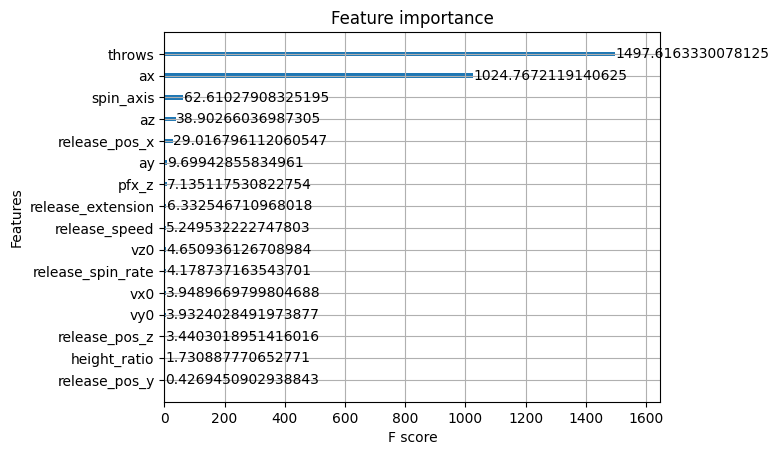

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
y_pred = final_model.predict(dtest)

In [ ]:
print(y_pred.min())

-1.8447417


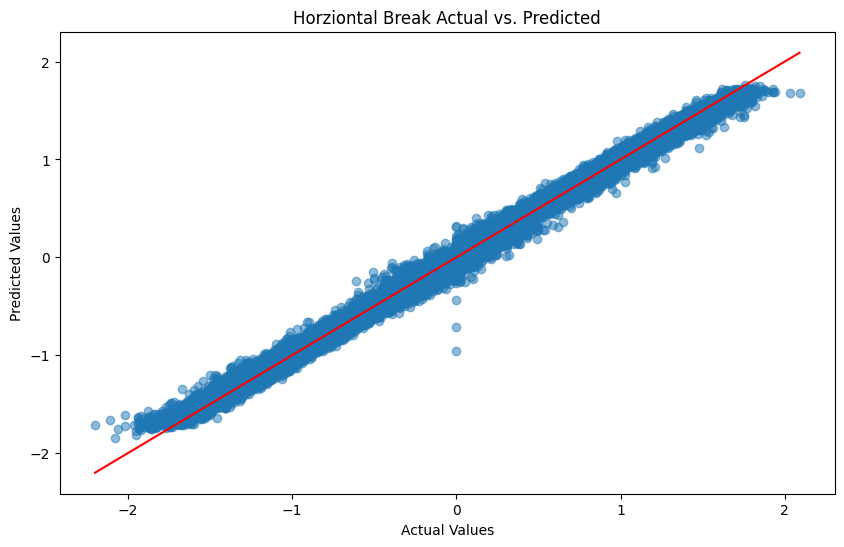

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Horziontal Break Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [ ]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [ ]:
testing_identifiers['xpfx_x'] = predictions

In [ ]:
testing_identifiers.head()

pitch_id_raw    xpfx_x
0  663364_455139_617228_4_75_10 -0.640294
1  663364_455139_617228_3_75_10 -0.672000
2  663364_455139_617228_2_75_10 -0.748169
3  663364_455139_617228_1_75_10 -0.644203
5  663364_593428_605347_4_72_10 -0.726116

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/pfx_2022&3_xpfx.csv")